# Exploration of Mus Musculus aging dynamics
On the [Tabula Muris Senis](https://github.com/czbiohub/tabula-muris-senis) dataset.  
Data is raw RNA-seq counts from
```
https://czb-tabula-muris-senis.s3-us-west-2.amazonaws.com/Data-objects/tabula-muris-senis-facs-official-raw-obj.h5ad
```

<!-- Gene annotations are from
```
ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Mus_musculus.gene_info.gz
``` -->

<br/>

**Pre-processed** as  
- RNA counts normalized to 1.0 per cell

<br/>

Cell **statistics** (expression mean and std.dev) are calculated - with 4 levels of granularity - on subsets defined by a unique combination of  
- Animal sex
- Tissue type
- Subtissue type
- Cell type

<br/>

Expression **fold-changes** computed between subsets of the pairs of age groups are filtered as  
- Subset has >= 3 cells
<!-- - Mean expression values are >= 4 max(std. dev) apart -->
- Expression is >= 1e-12 in both age groups
- Bonferroni correction is applied to p-values by multiplying them first by the number of genes (~20k) and then by the number of subsets (2-1000 depending on granularity). Results are then thresholded by 1e-5

<br/>

### Contents
- [Part I: Exploratory analysis of a single pair of age groups on a single dataset](#Part-I:-Exploratory-analysis-of-a-single-pair-of-age-groups-on-a-single-dataset)
- [Part II: Systematic sifting through a set of age groups on both FACS and Droplet datasets](#Part-II:-Systematic-sifting-through-a-set-of-age-groups-on-both-FACS-and-Droplet-datasets)

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import gc
import numpy as np
import pandas as pd
import scanpy as sc

# Part I: Exploratory analysis of a single pair of age groups on a single dataset

In [2]:
# FACS - Raw
data = sc.read_h5ad('../data/tabula-muris/tabula-muris-senis-facs-official-raw-obj.h5ad')
# Droplet - Raw
# data = sc.read_h5ad('../data/tabula-muris/tabula-muris-senis-droplet-official-raw-obj.h5ad')

# def load_gene_info(path):
#   """Load the NCBI Gene file and returns a {gene_name: info} dictionary"""
#   gene_info = pd.read_csv(path, delimiter='\t')
#   gene_info_map = {}
#   for _, row in gene_info.iterrows():
#     info = {
#       'type': row['type_of_gene'],
#       'desc': row['Other_designations'].split('|')[0],
#     }
#     gene_info_map[row['Symbol']] = info
#     for s in row['Synonyms'].split('|'):
#       gene_info_map[s] = info
#   return gene_info, gene_info_map

# gene_info, gene_info_map = load_gene_info('../data/Mus_musculus.gene_info')
gene_names = data.var.index.values

In [3]:
data.obs.head()

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,tissue,n_genes,n_counts
index,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,A10_B000497,bulge keratinocyte,nan,nan,facs,18_53_M,male,nan,Skin,2706,1009830.0
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,nan,pancreatic B cell,facs,18_45_M,male,Endocrine,Pancreas,3212,978772.0
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,A10_B000802,bulge keratinocyte,nan,outer bulge,facs,18_47_F,female,Skin Anagen,Skin,2243,419722.0
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,skeletal muscle satellite cell,nan,nan,facs,18_46_F,female,Muscle Diaphragm,Limb_Muscle,2789,878950.0
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,nan,B cell,facs,18_46_F,female,RV,Heart,1237,6587.0


In [4]:
# data.var[:100]
# data.obs.query('age in ["3m", "18m", "24m"]')
data.obs.groupby(['age', 'sex']).agg(['count'])
# np.sort(data.X[:2].toarray().ravel())[::-1][:1000]

FACS.selection   cell cell_ontology_class cell_ontology_id  \
                    count  count               count            count   
age sex                                                                 
3m  female          19315  19315               19315            19315   
    male            25203  25203               25203            25203   
18m female          19163  19163               19163            19163   
    male            14864  14864               14864            14864   
21m female            728    728                 728              728   
24m male            31551  31551               31551            31551   

           free_annotation method mouse.id subtissue tissue n_genes n_counts  
                     count  count    count     count  count   count    count  
age sex                                                                       
3m  female           19315  19315    19315     19315  19315   19315    19315  
    male             25203  25203    25203     25203  25203   25203    25203  
18m female           19163  19163    19163     19163  19163   19163    19163  
    male             14864  14864    14864     14864  14864   14864    14864  
21m female             728    728      728       728    728     728      728  
24m male             31551  31551    31551     31551  31551   31551    31551

## Split by age
As seen in the table above, top age for males and females is different.  
To avoid mixing the age groups, the analysis is done only for **3m** and **24m males**.

In [5]:
# Split the data by age groups that will be compared
def split_by_age(data, age_groups):
  data_by_age = {}
  for age in age_groups:
    idxs = data.obs['age'] == age
    data_by_age[age] = {
      'data': data[idxs],
      'obs': data.obs[idxs],
    }
  return data_by_age

age_groups = ['3m', '24m']
data_by_age = split_by_age(data, age_groups)

In [6]:
# We'll compute statistics for each subset defined by a unique set these cell attributes
subset_names = [
  'sex',
  'tissue',
  'subtissue',
  'cell_ontology_class',
]

In [7]:
# Preview cell-counts in the subsets
data_grouped = data_by_age['3m']['obs'].groupby(subset_names)
data_grouped.agg(['count']).head(20)
# data_grouped.groups

FACS.selection  \
                                                                               count   
sex    tissue        subtissue   cell_ontology_class                                   
female Aorta         Heart       aortic endothelial cell                          60   
                                 epithelial cell                                   2   
                                 macrophage                                        8   
                                 professional antigen presenting cell             17   
       BAT           Fat         B cell                                          107   
                                 NK cell                                          12   
                                 T cell                                           26   
                                 endothelial cell                                 47   
                                 epithelial cell                                   2   
                                 mesenchymal stem cell of adipose                 25   
                                 myeloid cell                                     59   
       Bladder       nan         bladder cell                                    129   
                                 bladder urothelial cell                         199   
       Brain_Myeloid Cerebellum  macrophage                                       10   
                                 microglial cell                                 303   
                     Cortex      macrophage                                        1   
                                 microglial cell                                 459   
                     Hippocampus macrophage                                        1   
                                 microglial cell                                 560   
                     Striatum    macrophage                                        1   

                                                                        age  \
                                                                      count   
sex    tissue        subtissue   cell_ontology_class                          
female Aorta         Heart       aortic endothelial cell                 60   
                                 epithelial cell                          2   
                                 macrophage                               8   
                                 professional antigen presenting cell    17   
       BAT           Fat         B cell                                 107   
                                 NK cell                                 12   
                                 T cell                                  26   
                                 endothelial cell                        47   
                                 epithelial cell                          2   
                                 mesenchymal stem cell of adipose        25   
                                 myeloid cell                            59   
       Bladder       nan         bladder cell                           129   
                                 bladder urothelial cell                199   
       Brain_Myeloid Cerebellum  macrophage                              10   
                                 microglial cell                        303   
                     Cortex      macrophage                               1   
                                 microglial cell                        459   
                     Hippocampus macrophage                               1   
                                 microglial cell                        560   
                     Striatum    macrophage                               1   

                                                                       cell  \
                                                                      count   
sex    tissue        subtissue   cell_ontology_class                 

## Split into subsets
And calculate expression **mean** and **std. dev** for each one

In [8]:
def calc_subsets(age_group, subset_names):
  """Compute mean and std. dev for all the data subsets"""
  means = {}
  stds = {}
  sample_counts = {}
  i = 0
  obs_grouped = age_group['obs'].groupby(subset_names)
  for key, group in obs_grouped:
    if not isinstance(key, tuple):
      key = (key,)
    data_array = age_group['data'][group.index].X
    # AnnData.X is usually a sparse matrix, but sometimes is an array
    if not isinstance(data_array, np.ndarray):
      data_array = data_array.toarray()
    # Skip tiny subsets
    if len(data_array.shape) < 2 or data_array.shape[0] < 3:
      continue
    data_array = data_array / (np.sum(data_array, axis=1, keepdims=True) + 1e-8)
    means[key] = np.mean(data_array, axis=0)
    stds[key] = np.std(data_array, axis=0)
    sample_counts[key] = group.index.shape[0]
    # Subsetting from AnnData can be memory-heavy, so clean it up a bit
    # (maybe, those `toarray()` calls produce the garbage?)
    if i % 10 == 0:
      gc.collect()
    i += 1
  return means, stds, sample_counts


def calc_all_subsets(data_by_age):
  means = {}
  stds = {}
  sample_counts = {}
  for age, age_group in data_by_age.items():
    means[age], stds[age], sample_counts[age] = calc_subsets(age_group, subset_names)
  return means, stds, sample_counts


means, stds, sample_counts = calc_all_subsets(data_by_age)

C:\Users\ghost\Anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


## Compute fold-changes in expression

In [9]:
def calc_diffs(means, stds, sample_counts, start_age, end_age):
  """Compute expression differences between age groups"""
  diffs = {}
  confidences = {}
  for key in means[start_age].keys():
    if key not in means[end_age]:
      # No corresponding subset in the other age group - skip it     
      continue
    fold_diff = np.maximum(
      means[end_age][key] / (means[start_age][key] + 1e-12),
      means[start_age][key] / (means[end_age][key] + 1e-12)
    )
  #   avg_std = (stds[start_age][key] + stds[end_age][key]) / 2.0
    diffs[key] = fold_diff
    z_scores = np.abs(means[start_age][key] - means[end_age][key]) \
      / np.sqrt(
          np.power(stds[start_age][key] / np.sqrt(sample_counts[start_age][key]), 2) \
        + np.power(stds[end_age][key] / np.sqrt(sample_counts[end_age][key]), 2) \
      + 1e-12)
    p_values = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-0.5 * np.power(z_scores.astype(np.float64), 2))
    # Bonferroni correction
    p_values *= diffs[key].shape[0] * len(means)
    confidences[key] = p_values
    
#     # Debug
#     if key == ('male', 'Brain_Non-Myeloid', 'Striatum', 'oligodendrocyte'):
#       gene_idx = list(gene_names).index('Ppil2')
#       print(means[start_age][key][gene_idx])
#       print(means[end_age][key][gene_idx])
#       print(stds[start_age][key][gene_idx])
#       print(stds[end_age][key][gene_idx])
#       print(sample_counts[start_age][key])
#       print(sample_counts[end_age][key])
#       print(z_scores[gene_idx])
    
    # Ignore tiny expression amounts
    min_count = 1e-12
    diffs[key][(means[start_age][key] < min_count) | (means[end_age][key] < min_count)] = 0
    
    # Zero out results with > `max_p` confidence
    max_p = 1e-5
    diffs[key][confidences[key] > max_p] = 0
    
#     # Ignore differences less than `min_stds` std. deviations
#     min_stds = 4
#     abs_mean_diff = np.abs(means[end_age][key] - means[start_age][key])
#     max_std = np.maximum(stds[start_age][key], stds[end_age][key])
#     diffs[key][abs_mean_diff < max_std * min_stds] = 0
    
    # If sample count in both groups is >= `high_sample_count`
    # and mean difference is >= `high_stds` * max(std. dev)
    # set the measurement's confidence to 'high'
#     high_sample_count = 10
#     high_stds = 5

#     confidences[key] = np.array(['low' for _ in np.arange(diffs[key].shape[0])], dtype=object)
#     if sample_counts[start_age][key] >= high_sample_count \
#       and sample_counts[end_age][key] >= high_sample_count:
#       confidences[key][abs_mean_diff > max_std * high_stds] = 'high'
  return diffs, confidences


diffs, confidences = calc_diffs(means, stds, sample_counts, age_groups[0], age_groups[-1])

## Output the descending-ordered fold-changes

In [10]:
def build_results(diffs, confidences, means, stds, dataset_id, start_age, end_age, gene_names, subset_names):
  """Sort the resulting differences and arrange 'em into a DataFrame with metadata"""
  # Python 3 dicts are ordered, be cool
  diff_arr = np.stack(list(diffs.values()), axis=0)
  confidence_arr = np.stack(list(confidences.values()), axis=0)
  subset_labels = [
    k if isinstance(k, tuple) else (k,) 
    for k in list(diffs.keys())
  ]
  # Descending ordered indexes into _subset x gene_ expression difference array
  ordered_diff_idxs = np.unravel_index(
    np.argsort(np.abs(diff_arr), axis=None)[::-1], 
    diff_arr.shape
  )
  gene_paths = [
    subset_labels[i] + (gene_names[j],) 
    for i, j in zip(*ordered_diff_idxs)
  ]

  # print(md_table)

  results = pd.DataFrame(
    [
      (dataset_id, start_age, end_age) \
      + path \
      + (
#         gene_info_map.get(path[-1], { 'desc': '' })['desc'],
        val,
        means[start_age][subset_labels[idx_i]][idx_j],
        means[end_age][subset_labels[idx_i]][idx_j],
        max(
          stds[start_age][subset_labels[idx_i]][idx_j], 
          stds[end_age][subset_labels[idx_i]][idx_j]
        ),
        conf,
      )
      for path, val, conf, (idx_i, idx_j) in zip(
        gene_paths, 
        diff_arr[ordered_diff_idxs], 
        confidence_arr[ordered_diff_idxs], 
        zip(*ordered_diff_idxs)
      )
    ],
    columns=[
      'Dataset', 'Start age', 'End age',
    ] \
    + subset_names \
#       'Sex', 'Tissue', 'Subtissue', 'Cell type', 'Gene',  # 'Gene info',
    + [
      'Gene', 
      'dExpression', 
      'Expression at start age', 
      'Expression at end age', 
      'Max expression std. dev',  # '$\\Delta$Expression'
      'Confidence (p-value)', 
    ]
  )
  
  # Threshold the minimum fold-change
  results = results[results['dExpression'] > 2.0]
  
  return results


def results2markdown(results):
  """Format DataFrame as a markdown table for in-Jupyter output"""
  # Generate Markdown table of the results
  nl = '\n'
  md_table = \
f"""
{'| ' + ' | '.join(results.columns) + ' |'}
{'| ' + ' | '.join(['---' for _ in np.arange(len(results.columns))]) + ' |'}
{nl.join([
  '| ' + ' | '.join(['{0}'.format(v) for v in row.values]) + ' |' 
  for _, row in results.iterrows()
])}
"""
  return md_table


results = build_results(
  diffs, confidences, means, stds, 'facs', age_groups[0], age_groups[-1], gene_names, subset_names
)
md_table = results2markdown(results)
display(Markdown(md_table))


| Dataset | Start age | End age | sex | tissue | subtissue | cell_ontology_class | Gene | dExpression | Expression at start age | Expression at end age | Max expression std. dev | Confidence (p-value) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppil2 | 26086.26171875 | 9.562943159835413e-05 | 3.664892389565466e-09 | 0.00017788528930395842 | 2.0255371939722143e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Aldh6a1 | 23548.62109375 | 8.632671233499423e-05 | 3.664892389565466e-09 | 0.00015953877300489694 | 1.2669133046215906e-15 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Igfbp5 | 23192.078125 | 0.0008412777679041028 | 3.62733594272413e-08 | 0.0012657494517043233 | 7.773174176474623e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tbc1d15 | 21838.41796875 | 8.843823161441833e-05 | 4.048662738398434e-09 | 0.00015793352213222533 | 3.7353678183017606e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Hist1h3e | 17991.51953125 | 5.3230778576107696e-05 | 2.9576592286417736e-09 | 0.00016050304111558944 | 6.097713303125484e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nup88 | 15844.146484375 | 5.8082936448045075e-05 | 3.664892389565466e-09 | 0.00013402130571193993 | 1.0783409913124231e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Wls | 15244.4267578125 | 0.00012345433060545474 | 8.097325476796868e-09 | 0.00019179092487320304 | 3.057292894182694e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pitpnb | 14462.5546875 | 5.301817145664245e-05 | 3.664892389565466e-09 | 0.00012043784226989374 | 4.950083813425852e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Man2b1 | 12075.44921875 | 3.759051105589606e-05 | 3.1119700150128438e-09 | 9.843570296652615e-05 | 1.1007193347715961e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hdlbp | 11871.009765625 | 4.80735870951321e-05 | 4.048662738398434e-09 | 0.0001034164524753578 | 3.736663043848585e-13 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Abpg | 11080.4013671875 | 1.832535012624703e-08 | 0.00020306331862229854 | 0.0004839695757254958 | 2.205474234643979e-11 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Acta1 | 10272.0419921875 | 6.444087574664081e-08 | 0.0006619496853090823 | 0.000961235782597214 | 3.854464316014752e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Akap12 | 9981.560546875 | 0.0008065856527537107 | 8.080656499487304e-08 | 0.0007774969562888145 | 1.6993661817469358e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Olfml2a | 9581.4609375 | 0.0004391836700960994 | 4.583581869610498e-08 | 0.0004131963069085032 | 1.007301520736537e-08 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Car6 | 9186.4326171875 | 3.665070025249406e-08 | 0.00033669837284833193 | 0.0008942940621636808 | 1.7232921767565114e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Exoc3 | 9159.255859375 | 0.00010180020035477355 | 1.1113461262368673e-08 | 0.00015368298045359552 | 5.567368034017477e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sf3b3 | 8326.9619140625 | 3.372138962731697e-05 | 4.048662738398434e-09 | 9.410324128111824e-05 | 2.5910250445745154e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Commd5 | 8044.2490234375 | 2.9489352527889423e-05 | 3.664892389565466e-09 | 7.0081528974697e-05 | 1.677588786114677e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atg4c | 7799.08154296875 | 6.31595030426979e-05 | 8.097325476796868e-09 | 0.00010322660091333091 | 2.25760992066934e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Eif3b | 7791.12548828125 | 0.00014525896403938532 | 1.864315635202729e-08 | 0.00018231656576972455 | 1.2732793990565542e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ccdc127 | 7765.4423828125 | 2.8467276933952235e-05 | 3.664892389565466e-09 | 7.264847226906568e-05 | 4.484719092876643e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Sepp1 | 7130.73046875 | 0.0005762169603258371 | 8.080656499487304e-08 | 0.0008979129488579929 | 3.4408416124441914e-07 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Scgb1a1 | 7045.04150390625 | 2.9447317473341172e-08 | 0.00020746461814269423 | 0.000472331972559914 | 8.240441930063464e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Dtd1 | 6932.1611328125 | 0.0002861183893401176 | 4.127305430756678e-08 | 2.503326686564833e-05 | 3.918270462434052e-81 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 4930402H24Rik | 6751.47998046875 | 0.00012587565288413316 | 1.864315635202729e-08 | 0.00016991651500575244 | 9.406566776599558e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Erbb3 | 6610.23486328125 | 2.4232409487012774e-05 | 3.664892389565466e-09 | 5.602353485301137e-05 | 9.395386307278406e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dync1li1 | 6150.68896484375 | 6.836159445811063e-05 | 1.1113461262368673e-08 | 0.00011748386168619618 | 8.277529480308865e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arih1 | 6068.5283203125 | 2.4575492716394365e-05 | 4.048662738398434e-09 | 6.722727266605943e-05 | 2.464308400226756e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Elavl2 | 5899.2568359375 | 0.0001232894865097478 | 2.0898156094517617e-08 | 2.810044497891795e-05 | 5.951617441831347e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arpc5l | 5613.2431640625 | 6.238817150006071e-05 | 1.1113461262368673e-08 | 9.277285425923765e-05 | 4.161538640447856e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ptplad1 | 5377.86474609375 | 9.752468031365424e-05 | 1.8133460955027658e-08 | 0.0001496464101364836 | 7.679248479392379e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ctnnb1 | 5190.04296875 | 0.0001730432122712955 | 3.334038467528444e-08 | 0.00023533277271781117 | 2.2845424174594764e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc30a5 | 4975.24365234375 | 2.6535741199040785e-05 | 5.3325561744088645e-09 | 8.182481542462483e-05 | 1.6505431593229824e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Xrcc1 | 4547.07861328125 | 6.66627602186054e-05 | 1.4659569558261865e-08 | 0.0001377797161694616 | 1.024984190354424e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mtpn | 4421.63330078125 | 0.000313509808620438 | 7.090261533448938e-08 | 0.00018008712504524738 | 3.9061078823359973e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ip6k1 | 4225.845703125 | 4.696799805969931e-05 | 1.1113461262368673e-08 | 9.562719060340896e-05 | 5.501062602553555e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Gpd1l | 4162.6474609375 | 0.00033637339947745204 | 8.080656499487304e-08 | 0.00047364525380544364 | 1.361658865525248e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hmgcs1 | 3842.43017578125 | 0.0002562200534157455 | 6.668076935056888e-08 | 0.00035257701529189944 | 1.618806485056047e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Uap1 | 3818.35107421875 | 4.243891453370452e-05 | 1.1113461262368673e-08 | 0.00010412320989416912 | 2.6950413776326887e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ipo13 | 3795.410400390625 | 0.00023121951380744576 | 6.091981674671842e-08 | 0.0003020910080522299 | 4.1063015619654056e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cadm3 | 3608.48583984375 | 7.972200546646491e-05 | 2.2091924734013446e-08 | 1.708705531200394e-05 | 1.7155277984748673e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Csnk1d | 3583.368896484375 | 8.705069922143593e-05 | 2.4291976430390605e-08 | 0.00015117392467800528 | 1.5882767888333388e-22 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | H13 | 3072.29150390625 | 0.0002482644049450755 | 8.080656499487304e-08 | 0.00040310999611392617 | 2.4724979555940606e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Snx13 | 3025.810302734375 | 3.3630250982241705e-05 | 1.1113461262368673e-08 | 9.440533904125914e-05 | 3.39537646391509e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cerk | 2965.43994140625 | 9.436568507226184e-05 | 3.182081798058789e-08 | 0.0001603369164513424 | 9.830480895861468e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp445 | 2937.268310546875 | 5.326577593223192e-05 | 1.8133460955027658e-08 | 0.00014463036495726556 | 4.158626747351829e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps4y2 | 2653.328369140625 | 2.4861521524144337e-05 | 9.368937625708895e-09 | 4.3780586565844715e-05 | 1.5516733175047307e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ddit4 | 2643.285888671875 | 9.690002116258256e-06 | 3.664892389565466e-09 | 1.8392949641565792e-05 | 4.013074775940328e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rbm18 | 2642.503662109375 | 5.316992610460147e-05 | 2.012004074458673e-08 | 0.00013265361485537142 | 6.488221827539025e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Srsf11 | 2608.677001953125 | 0.0003618781629484147 | 1.387199546343254e-07 | 0.0004410528053995222 | 5.564907959151696e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Cd97 | 2601.7080078125 | 0.00028705535805784166 | 1.1033242230951146e-07 | 0.00014047046715859324 | 3.100225726022262e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tarsl2 | 2597.614013671875 | 4.8430323658976704e-05 | 1.864315635202729e-08 | 0.00010989081056322902 | 1.6328349116102796e-11 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Clps | 2538.34912109375 | 1.1665770927038466e-07 | 0.0002961205318570137 | 0.0006628111586906016 | 2.2120913896024018e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Brox | 2469.86669921875 | 3.620965435402468e-05 | 1.4659569558261865e-08 | 8.222398173529655e-05 | 9.623654311020621e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tia1 | 2432.779052734375 | 2.703902828216087e-05 | 1.1113461262368673e-08 | 7.281629223143682e-05 | 9.290997261703913e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Hsp90b1 | 2306.946533203125 | 0.0006928546354174614 | 3.003330846240715e-07 | 0.0009356135269626975 | 9.718765597455492e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc27a1 | 2265.802001953125 | 5.5043074098648503e-05 | 2.4291976430390605e-08 | 0.00012773519847542048 | 5.819723199546159e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cdkn2aipnl | 2242.24951171875 | 4.109025758225471e-05 | 1.832446194782733e-08 | 0.0001040962670231238 | 1.7179100320734624e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Aldh3a2 | 2233.737060546875 | 7.447587995557114e-05 | 3.334038467528444e-08 | 0.00014287338126450777 | 8.983666441786749e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Selplg | 2177.005615234375 | 0.00035183486761525273 | 1.6161312998974608e-07 | 0.0005896391812711954 | 9.933675145328812e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Ccni | 2147.775146484375 | 0.0002369713765801862 | 1.1033242230951146e-07 | 0.00013040618796367198 | 9.061918567608031e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zzef1 | 2105.647705078125 | 2.3403141312883236e-05 | 1.1113461262368673e-08 | 6.460089207394049e-05 | 4.311008051596942e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vps11 | 2058.89404296875 | 5.808061177958734e-05 | 2.8208617663949553e-08 | 0.00012080538726877421 | 1.836850370099817e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arfip1 | 1993.935302734375 | 3.653978637885302e-05 | 1.832446194782733e-08 | 7.292006921488792e-05 | 3.557979539897057e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Sf1 | 1973.8590087890625 | 0.0001595027424627915 | 8.080656499487304e-08 | 0.00023603798763360828 | 2.522535664842948e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Txndc11 | 1909.2847900390625 | 0.00046285014832392335 | 2.424197020900465e-07 | 0.0007293104426935315 | 6.043413263668083e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pcx | 1889.82958984375 | 0.00012027374032186344 | 6.364163596117578e-08 | 0.00018596337758935988 | 1.6782685138074384e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rnf6 | 1886.7496337890625 | 0.00016381844761781394 | 8.682474827992337e-08 | 0.000152068751049228 | 8.840963790409001e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Strap | 1881.2662353515625 | 0.00010736915282905102 | 5.707181216507706e-08 | 0.00010526207188377157 | 4.7760931785895957e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Parn | 1875.0615234375 | 3.4003231121459976e-05 | 1.8133460955027658e-08 | 9.211300493916497e-05 | 6.88044604447843e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Hspb1 | 1871.432373046875 | 0.001738589839078486 | 9.290145612794731e-07 | 0.000761816801968962 | 9.241130305321426e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cttn | 1864.1380615234375 | 6.148865213617682e-05 | 3.2984033282446035e-08 | 0.00012233169400133193 | 7.628598954009712e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Sash3 | 1850.6778564453125 | 0.0005134537350386381 | 2.774399092686508e-07 | 0.0008284993236884475 | 1.8516180894003184e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zkscan3 | 1794.9708251953125 | 4.3605185055639595e-05 | 2.4291976430390605e-08 | 0.00011972920765401796 | 8.722302007671735e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sh3bgrl | 1769.1192626953125 | 0.00014430009468924254 | 8.156506225986959e-08 | 3.436846236581914e-05 | 6.627754131246514e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Foxo1 | 1765.14013671875 | 6.581733032362536e-05 | 3.728631270405458e-08 | 0.00012487018830142915 | 3.976078708567252e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | 1110057K04Rik | 1746.4249267578125 | 9.967337973648682e-05 | 5.707181216507706e-08 | 0.00011375965550541878 | 3.1197718979702474e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Capza2 | 1730.8060302734375 | 0.00015234346210490912 | 8.801779216582872e-08 | 0.0002199298032792285 | 5.266253814362848e-28 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Grb2 | 1722.7335205078125 | 0.00013920990750193596 | 8.080656499487304e-08 | 0.0001775221317075193 | 2.0829887457255206e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 9030624J02Rik | 1709.815673828125 | 6.880483124405146e-05 | 4.024008148917346e-08 | 0.00013431710249278694 | 1.5601586820344492e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ctnna1 | 1699.87158203125 | 0.0001710091164568439 | 1.006001966175063e-07 | 0.00020325601508375257 | 6.0600004285486285e-43 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Mki67 | 1696.713134765625 | 0.0027220414485782385 | 1.6043017012634664e-06 | 0.0011811696458607912 | 1.944575080566108e-11 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Wfdc12 | 1695.2391357421875 | 3.87795573431049e-08 | 6.574231520062312e-05 | 0.00017763285723049194 | 6.155676470555419e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ash1l | 1691.4036865234375 | 4.771385283675045e-05 | 2.8208617663949553e-08 | 9.831375064095482e-05 | 1.423582513348079e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Bcap29 | 1686.099609375 | 0.00013918265176471323 | 8.254610861513356e-08 | 3.131937774014659e-05 | 2.8341841094602776e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gapvd1 | 1685.118896484375 | 5.362354568205774e-05 | 3.182081798058789e-08 | 0.00013222184497863054 | 2.5475364223951116e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ss18 | 1677.6878662109375 | 0.000129057138110511 | 7.692459291774867e-08 | 0.00019144669931847602 | 2.2646712698712934e-32 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Psmb8 | 1653.970947265625 | 4.0402898093816475e-07 | 0.0006682538660243154 | 0.0007497030892409384 | 1.2636590083231872e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ddx6 | 1620.961669921875 | 0.00030019358382560313 | 1.8519375544201466e-07 | 0.00040151519351638854 | 2.63700307896595e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Cct7 | 1581.8824462890625 | 0.0003472667303867638 | 2.195265267346258e-07 | 0.000532873731572181 | 1.6413343487509593e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Aldh6a1 | 1558.0289306640625 | 0.00011618786811595783 | 7.457262540810916e-08 | 0.0001713183446554467 | 1.0279236737403738e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Arfgap1 | 1547.234375 | 8.830501610646024e-05 | 5.707181216507706e-08 | 0.00010784147889353335 | 7.312647275326786e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tsc22d2 | 1540.4437255859375 | 3.118522363365628e-05 | 2.024331280381375e-08 | 7.519053906435147e-05 | 2.367022679129442e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Srsf2 | 1493.9007568359375 | 0.00032795232255011797 | 2.195265267346258e-07 | 0.00047741876915097237 | 9.777725977911742e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Slc9a6 | 1432.300537109375 | 6.328598101390526e-05 | 4.418384946802689e-08 | 8.817119123705197e-06 | 9.911694946611654e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nudt4 | 1419.04345703125 | 0.0002914272772613913 | 2.053678258562286e-07 | 0.0002941949060186744 | 1.9858476165686268e-74 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Srp72 | 1410.1575927734375 | 6.268833385547623e-05 | 4.4453845049474694e-08 | 0.00013096266775391996 | 2.312183896991647e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tbc1d20 | 1404.9490966796875 | 2.2754065867047757e-05 | 1.6194650953593737e-08 | 6.115517317084596e-05 | 1.6071516089779631e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fkbp15 | 1339.7926025390625 | 2.978080556204077e-05 | 2.2226922524737347e-08 | 7.005770021351054e-05 | 7.091961562447717e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Tnnt2 | 1335.367919921875 | 2.0233585473761195e-07 | 0.00027019414119422436 | 0.0006253371830098331 | 2.8332815313603786e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Nucb1 | 1333.1370849609375 | 3.778683822019957e-05 | 2.834329926315604e-08 | 8.342592627741396e-05 | 5.436672810677228e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Klk1 | 1328.6839599609375 | 7.794197642851941e-08 | 0.00010356158600188792 | 0.00029141022241674364 | 4.030418121179667e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ilf3 | 1321.9315185546875 | 9.633830632083118e-05 | 7.287592751481498e-08 | 0.00018401542911306024 | 4.26525898397648e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dcaf8 | 1309.1104736328125 | 9.512449469184503e-05 | 7.266245916071057e-08 | 0.00016049007535912097 | 4.2505317084106295e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Idh1 | 1305.6414794921875 | 0.00012170770060038194 | 9.321578176013645e-08 | 0.00018905931210611016 | 3.4427441442846017e-29 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Fabp2 | 1293.211181640625 | 3.1489801699535747e-07 | 0.0004072309238836169 | 0.0009428502526134253 | 2.8577556495059793e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arf6 | 1287.6239013671875 | 4.097452983842231e-05 | 3.182081798058789e-08 | 8.482811244903132e-05 | 3.580507792074968e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem167b | 1266.266845703125 | 3.854391252389178e-05 | 3.0438012998956765e-08 | 9.951715765055269e-05 | 4.374896183164761e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Rbbp4 | 1264.6339111328125 | 0.00017543121066410094 | 1.387199546343254e-07 | 0.000278087129117921 | 8.424021491180686e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Drg1 | 1242.547119140625 | 9.266124834539369e-05 | 7.457262540810916e-08 | 0.0001480228384025395 | 3.297004187026648e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Amfr | 1237.790283203125 | 0.0001972103345906362 | 1.5932351971059688e-07 | 0.00024632882559672 | 2.7498868744943187e-47 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Acta1 | 1236.73828125 | 1.7644252636728197e-07 | 0.00021821445261593908 | 0.0005754301673732698 | 1.2232698282842683e-08 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Apoa4 | 1228.887939453125 | 1.551182293724196e-07 | 0.00019062415231019258 | 0.0005244896747171879 | 1.208331914688298e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Cybasc3 | 1226.8402099609375 | 0.0005124828894622624 | 4.177248911219067e-07 | 0.0006826163735240698 | 4.018292044049118e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Adam22 | 1225.2108154296875 | 3.968494638684206e-05 | 3.238930190718747e-08 | 0.0001021122807287611 | 4.208567955593682e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Fam92a | 1209.4876708984375 | 6.902885797899216e-05 | 5.707181216507706e-08 | 7.389049278572202e-05 | 1.2883959196691059e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vapb | 1193.14111328125 | 3.365805605426431e-05 | 2.8208617663949553e-08 | 6.0917725932085887e-05 | 1.2820269622286052e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Thumpd3 | 1172.7611083984375 | 3.3083142625400797e-05 | 2.8208617663949553e-08 | 9.423688607057557e-05 | 6.648069041617481e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ash1l | 1171.56689453125 | 5.280399273033254e-05 | 4.5070258636314975e-08 | 0.00011522133718244731 | 4.890339685576923e-10 |
| facs | 3m | 24m | male | Heart | RA | B cell | Psme1 | 1156.63818359375 | 3.6438686379369756e-07 | 0.0004214649088680744 | 0.0005062830750830472 | 1.2565253251700831e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | C80913 | 1150.3453369140625 | 2.1080610167700797e-05 | 1.832446194782733e-08 | 5.2348106692079455e-05 | 4.125207120176279e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Coasy | 1142.0877685546875 | 6.213114829733968e-05 | 5.4400381088726135e-08 | 0.00013190148456487805 | 8.532780470557354e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Mef2c | 1129.5478515625 | 0.0004242213617544621 | 3.755664010895998e-07 | 0.0006223155069164932 | 3.882780386264967e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Macf1 | 1119.080078125 | 7.21980759408325e-05 | 6.451455902833914e-08 | 0.00013318857236299664 | 2.001925949752843e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ecd | 1107.5479736328125 | 3.58738107024692e-05 | 3.238930190718747e-08 | 0.00010178941738558933 | 4.961060342573709e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mlec | 1101.130859375 | 3.566595842130482e-05 | 3.238930190718747e-08 | 8.70791045599617e-05 | 3.17524056400656e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spnb2 | 1076.2896728515625 | 0.00012475124094635248 | 1.1590761062052479e-07 | 0.00017684845079202205 | 1.0951379415541208e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fig4 | 1052.759765625 | 3.350072802277282e-05 | 3.182081798058789e-08 | 9.074538684217259e-05 | 7.215233373123096e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rtcd1 | 1049.697509765625 | 3.914039916708134e-05 | 3.728631270405458e-08 | 9.105594654101878e-05 | 1.4225878473018234e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arid4a | 1049.0906982421875 | 2.9594448278658092e-05 | 2.8208617663949553e-08 | 7.46403238736093e-05 | 3.1760607819421896e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lsm14b | 1047.5927734375 | 2.3285811039386317e-05 | 2.2226922524737347e-08 | 4.4649885239778087e-05 | 8.94937320778739e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Svop | 1035.1009521484375 | 8.987341425381601e-05 | 8.682474827992337e-08 | 0.00010439506149850786 | 7.664954838197011e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Capn10 | 1022.4910278320312 | 2.1344618289731443e-05 | 2.0874114881053174e-08 | 6.434536044253036e-05 | 1.5081998118107165e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ndufs2 | 1000.7998657226562 | 0.00013671816850546747 | 1.3660790898484265e-07 | 0.00017824146198108792 | 2.58828892871734e-10 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Park7 | 995.9290161132812 | 4.0402898093816475e-07 | 0.0004023851652164012 | 0.0004950814181938767 | 4.6808592185237135e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Klhl4 | 988.716796875 | 0.00014284583448898047 | 1.4447499552261434e-07 | 0.00023322964261751622 | 3.569128581489991e-26 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Prelid1 | 987.3418579101562 | 0.0003537127049639821 | 3.582464671580965e-07 | 0.00048700172919780016 | 3.5667635046531906e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Snx18 | 985.9505615234375 | 2.781328839773778e-05 | 2.8208617663949553e-08 | 7.40782925277017e-05 | 5.345662370440728e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Carns1 | 982.4711303710938 | 2.7715135729522444e-05 | 2.8208617663949553e-08 | 7.617870869580656e-05 | 2.17395914490531e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Vps35 | 974.3780517578125 | 0.00014436875062528998 | 1.4816403393069777e-07 | 0.0001944920513778925 | 1.3898151033082387e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arhgef19 | 953.767333984375 | 3.5563418350648135e-05 | 3.728631270405458e-08 | 9.781135304365307e-05 | 1.2943337059579502e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Aktip | 935.9845581054688 | 0.00018508220091462135 | 1.977396664187836e-07 | 4.870500197284855e-05 | 7.731554954643924e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nfe2l3 | 930.2489624023438 | 4.5944070734549314e-05 | 4.938800657328102e-08 | 9.157245222013444e-05 | 1.6296927508259902e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 1190005I06Rik | 928.8750610351562 | 4.587621515383944e-05 | 4.938800657328102e-08 | 6.910457886988297e-05 | 7.748934629646629e-24 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Try4 | 896.4752807617188 | 4.171279499587399e-07 | 0.00037394577520899475 | 0.0008218882721848786 | 5.470094767250245e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Gnai2 | 895.7164916992188 | 0.0008179597789421678 | 9.131894671554619e-07 | 0.0003619854978751391 | 1.5904629766654134e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tbc1d17 | 890.2446899414062 | 0.0001357904839096591 | 1.5253064589160203e-07 | 0.0002174344554077834 | 4.54177455155887e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ankrd40 | 886.867431640625 | 7.54040593164973e-05 | 8.50219166181887e-08 | 0.00011378248746041209 | 1.6643029887493017e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Smg5 | 863.5918579101562 | 1.8980144886882044e-05 | 2.197714188412192e-08 | 5.8141442423220724e-05 | 5.2388329026602315e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ube2j2 | 857.143798828125 | 3.5377797757973894e-05 | 4.127305430756678e-08 | 5.228805548540549e-06 | 2.8640528203261206e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gabrg2 | 853.6018676757812 | 0.00014822838420514017 | 1.7364949655984674e-07 | 0.0001545662817079574 | 2.2309101241881716e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Kif5b | 826.9278564453125 | 0.0002294236037414521 | 2.774399092686508e-07 | 0.00038228457560762763 | 8.106318541357566e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Zfp207 | 819.1344604492188 | 0.0007184036658145487 | 8.770267641011742e-07 | 0.00012388073082547635 | 2.602859740692224e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pak7 | 816.9158935546875 | 7.406837539747357e-05 | 9.066729944606777e-08 | 0.00014865414414089173 | 6.299355350013025e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fastk | 798.8803100585938 | 2.9788099709548987e-05 | 3.728631270405458e-08 | 7.521240331698209e-05 | 3.34502254814542e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lysmd2 | 792.803955078125 | 3.175114034092985e-05 | 4.004817100167202e-08 | 7.782215834595263e-05 | 6.224673616668464e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tmem181b-ps | 782.3762817382812 | 0.00015559745952486992 | 1.988770463867695e-07 | 0.00014771132555324584 | 4.875137363832392e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Acsl3 | 781.786865234375 | 6.453424430219457e-05 | 8.254610861513356e-08 | 8.446490937785711e-06 | 7.453101302436002e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Heatr3 | 777.447021484375 | 6.295319326454774e-05 | 8.0973251215255e-08 | 0.00013884254440199584 | 1.5333365959328938e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | N4bp2 | 758.8092651367188 | 3.7195117329247296e-05 | 4.901674444113269e-08 | 7.791192183503881e-05 | 5.0866530645492085e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Habp4 | 758.400146484375 | 3.051884050364606e-05 | 4.024008148917346e-08 | 7.422284397762269e-05 | 4.806808108551398e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Stk38l | 751.0033569335938 | 0.00018495101539883763 | 2.462709005612851e-07 | 0.0002850480377674103 | 2.1808662416612524e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Zfp239 | 747.8499145507812 | 6.493263208540156e-05 | 8.682474827992337e-08 | 7.743393507553264e-05 | 2.959511116057808e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps4y2 | 739.1461791992188 | 3.949481470044702e-05 | 5.343202502672284e-08 | 9.880839934339747e-05 | 7.515448137181322e-12 |
| facs | 3m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Btg2 | 708.0772094726562 | 4.163502467235958e-07 | 0.0002948088222183287 | 8.241115574492142e-05 | 1.5360924024981546e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Grk6 | 698.8301391601562 | 0.0002624578191898763 | 3.755664010895998e-07 | 0.00030236164457164705 | 9.813940172315823e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pygo2 | 692.3096923828125 | 2.3082562620402314e-05 | 3.334038467528444e-08 | 6.166548701003194e-05 | 1.215396830467167e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Sbk1 | 675.1113891601562 | 0.0002500535047147423 | 3.703875108840293e-07 | 0.0003809340123552829 | 2.411781308940783e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lrrc8d | 672.0362548828125 | 5.9749861975433305e-05 | 8.890769009894939e-08 | 0.00010757872223621234 | 2.8083921661646505e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Add1 | 658.7463989257812 | 0.0002474036591593176 | 3.755664010895998e-07 | 0.0003780762490350753 | 2.7844089235056993e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Txnip | 651.9381713867188 | 0.0004829402023460716 | 7.407750217680587e-07 | 0.0006631654687225819 | 1.2526432929761022e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Eif3e | 646.737060546875 | 6.022430898156017e-05 | 9.311924031862873e-08 | 0.00010573852341622114 | 1.7782970605282274e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Acyp2 | 643.4733276367188 | 1.6508467524545267e-05 | 2.5654248503315102e-08 | 3.2108204322867095e-05 | 6.251486850383734e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Try5 | 643.042236328125 | 2.9583151217593695e-07 | 0.0001902327931020409 | 0.00046778860269114375 | 1.9605097801818796e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 1110008F13Rik | 642.6961669921875 | 4.7928184358170256e-05 | 7.457262540810916e-08 | 7.139284571167082e-05 | 6.155994852268636e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Abcb8 | 639.1959228515625 | 0.00011947243183385581 | 1.869095171969093e-07 | 0.00021726654085796326 | 2.699975397552355e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sephs2 | 636.6447143554688 | 2.8301941711106338e-05 | 4.4453845049474694e-08 | 8.043548587011173e-05 | 8.559648527258392e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ptrh2 | 631.0830078125 | 3.321617987239733e-05 | 5.2632614711001224e-08 | 7.684782758587971e-05 | 1.802968130362321e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Pla2g1b | 630.1347045898438 | 1.1665770927038466e-07 | 7.351070235017687e-05 | 0.0001901940122479573 | 5.7117501743760844e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ube2h | 628.8886108398438 | 0.0002731917193159461 | 4.3440300601105264e-07 | 0.00039017709787003696 | 1.0560016343271525e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tspan31 | 621.3412475585938 | 0.00012393835640978068 | 1.9946806162352004e-07 | 0.00016982723900582641 | 2.471743704689655e-38 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Sdha | 620.320068359375 | 0.0003809150366578251 | 6.140610935290169e-07 | 0.0005500962142832577 | 1.8488328986399766e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ncstn | 615.3787231445312 | 4.952639574185014e-05 | 8.048016297834693e-08 | 0.00010792840475915 | 5.233702179849302e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cul5 | 609.3595581054688 | 7.144700066419318e-05 | 1.1724832660320317e-07 | 0.00013010474503971636 | 5.733963827819542e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | D17Wsu92e | 607.9544067382812 | 3.661326627479866e-05 | 6.022270326866419e-08 | 7.992081373231485e-05 | 1.1020256943337765e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | March5 | 604.4265747070312 | 6.049137664376758e-05 | 1.0007960327129695e-07 | 0.00012144165521021932 | 9.654927809424408e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ankrd13a | 603.2930908203125 | 0.00022345283650793135 | 3.703875108840293e-07 | 0.00033318158239126205 | 9.0188766972859e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Aftph | 600.8948364257812 | 5.217314537730999e-05 | 8.682474827992337e-08 | 6.08029258728493e-05 | 1.2164805100049568e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ctrb1 | 600.5796508789062 | 8.283553825094714e-07 | 0.0004974940093234181 | 0.001174239907413721 | 1.2041617093877562e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Crim1 | 593.7537841796875 | 2.1534215193241835e-05 | 3.6266921910055316e-08 | 5.723721187678166e-05 | 1.3477693607888262e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tspan14 | 591.7329711914062 | 0.00014519307296723127 | 2.453682554914849e-07 | 0.00021460729476530105 | 1.292557902086068e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rab33a | 583.6680297851562 | 8.048262679949403e-05 | 1.3789011177323118e-07 | 0.00014469586312770844 | 1.141801053972484e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Vcp | 580.914794921875 | 0.00020695825514849275 | 3.5626166550173366e-07 | 0.0001856748276622966 | 6.634692426785529e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Dapk1 | 576.6759033203125 | 0.00010014005238190293 | 1.7364949655984674e-07 | 9.627052349969745e-05 | 1.4191527458409683e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cc2d1b | 569.5260620117188 | 4.381113103590906e-05 | 7.692459291774867e-08 | 9.231506555806845e-05 | 1.186296774402244e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tfeb | 569.3847045898438 | 6.219585338840261e-05 | 1.0923244531113596e-07 | 9.816064266487956e-05 | 2.9907222619686145e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ngfrap1 | 564.993408203125 | 3.41036356985569e-05 | 6.03601222337602e-08 | 6.210619903868064e-05 | 6.698350169945368e-15 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Mb | 560.619384765625 | 2.0233585473761195e-07 | 0.00011343395453877747 | 0.00031147297704592347 | 1.2275440163973835e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | BC024659 | 558.2579956054688 | 9.694177424535155e-05 | 1.7364949655984674e-07 | 0.00010431609553052112 | 1.551271561491419e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Iah1 | 551.4446411132812 | 1.9999750293209217e-05 | 3.6266921910055316e-08 | 5.340613279258832e-05 | 2.3684832398807403e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hdhd2 | 546.1572875976562 | 0.00011617247946560383 | 2.1270784600346815e-07 | 0.00012597798195201904 | 2.2610877723967832e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gng12 | 545.5242919921875 | 0.00011811633157776669 | 2.1651793247201567e-07 | 0.00021935651602689177 | 2.286931322887684e-19 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Pnlip | 539.37841796875 | 1.2454833040465019e-06 | 0.0006717873620800674 | 0.0015471774386242032 | 2.0891256009258945e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Fam19a5 | 535.4978637695312 | 9.168602991849184e-05 | 1.712154329425175e-07 | 0.00010693621879909188 | 9.670228567363509e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf14 | 535.2272338867188 | 0.00010976210614899173 | 2.0507472697772755e-07 | 0.00018905106117017567 | 5.129506624901512e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Tmem123 | 532.2810668945312 | 0.0005907045560888946 | 1.1097596370746032e-06 | 0.0008368167909793556 | 2.1486452624459073e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Herpud2 | 532.25341796875 | 6.334291538223624e-05 | 1.1900793595032155e-07 | 0.00013115578622091562 | 1.2180163603949627e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Cd38 | 525.1827392578125 | 0.0007214501383714378 | 1.3737115978074144e-06 | 0.0007312117959372699 | 1.0185577518305963e-21 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Trf | 523.7018432617188 | 6.806124019931303e-06 | 0.003564380342140794 | 0.004544645082205534 | 5.6970110121243385e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Amigo2 | 520.9429931640625 | 0.00022157332568895072 | 4.253302563483885e-07 | 0.00023269039229489863 | 2.9245944923511124e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dnajb12 | 509.6325988769531 | 5.5448927014367655e-05 | 1.0880076217745227e-07 | 0.0001289055508095771 | 7.203049357507834e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gpatch8 | 497.6341552734375 | 5.19182940479368e-05 | 1.0432924568704038e-07 | 0.00011021288810297847 | 1.3319310403453535e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Osbpl2 | 485.0267028808594 | 4.104628533241339e-05 | 8.462585299184866e-08 | 0.00010904006921919063 | 2.122538312116925e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp704 | 479.6112976074219 | 2.9127244488336146e-05 | 6.072993841144125e-08 | 7.48380261939019e-05 | 8.997936680281298e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Elavl1 | 479.30889892578125 | 0.00014716295117978007 | 3.0703054676450847e-07 | 0.00019933079602196813 | 6.38227291637217e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Trappc6a | 478.5527038574219 | 1.595560934219975e-05 | 3.334038467528444e-08 | 4.093931784154847e-05 | 2.2572571505880308e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Fgfrl1 | 472.6695556640625 | 0.00016545047401450574 | 3.500331331451889e-07 | 0.00037269946187734604 | 7.282152508067602e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Peli1 | 467.3005065917969 | 4.2123177991015837e-05 | 9.014051727262995e-08 | 8.586079638916999e-05 | 1.0605435171850274e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Cfp | 466.3828430175781 | 2.8320550882199313e-07 | 0.00013208265590947121 | 0.00045245123328641057 | 1.4489984255661472e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tbc1d14 | 466.14398193359375 | 0.00010191249020863324 | 2.1862778964987228e-07 | 0.0001536819472676143 | 6.788563638855362e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ash2l | 464.31341552734375 | 5.2391023928066716e-05 | 1.1283447065579821e-07 | 0.00010834239947143942 | 1.6943222807563323e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem62 | 461.761962890625 | 6.671351729892194e-05 | 1.4447499552261434e-07 | 0.00013997696805745363 | 3.3809636770328265e-14 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Prkcsh | 460.286376953125 | 7.004858343861997e-05 | 1.5218378734971338e-07 | 0.00010235120862489566 | 2.191325438464318e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Trim28 | 454.3365478515625 | 0.0003508968511596322 | 7.723269845882896e-07 | 0.00018898666894529015 | 3.792456037016218e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tollip | 452.68829345703125 | 4.4715197873301804e-05 | 9.877601314656204e-08 | 9.894335380522534e-05 | 1.608394186854125e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ndufa9 | 449.8193054199219 | 0.0001666079042479396 | 3.703875108840293e-07 | 0.00026011926820501685 | 7.55713341147563e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Ube2s | 448.22406005859375 | 3.621989526436664e-05 | 8.080656499487304e-08 | 5.31010955455713e-05 | 4.8873093161960406e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Afap1l1 | 443.5282287597656 | 6.823689909651875e-05 | 1.5384918583549734e-07 | 0.00014205560728441924 | 1.750106287910553e-14 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Oaz3 | 443.1811218261719 | 4.171279499587399e-07 | 0.00018486367480363697 | 0.0005391942104324698 | 2.2047059894188034e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Txndc12 | 442.91058349609375 | 4.244499359629117e-05 | 9.583096982623829e-08 | 7.118749635992572e-05 | 1.4626527207577653e-18 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Myh6 | 438.6174621582031 | 2.0233585473761195e-07 | 8.874847844708711e-05 | 0.00025625270791351795 | 1.5413132912284077e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Terf2ip | 434.251220703125 | 4.3477855797391385e-05 | 1.0012043105689372e-07 | 0.00010134893818758428 | 3.044248595157439e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc35a4 | 433.0074157714844 | 0.00015878945123404264 | 3.667120154204895e-07 | 0.00022201845422387123 | 8.173373728012897e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmem163 | 427.9911193847656 | 5.353266533347778e-05 | 1.250779178008088e-07 | 9.221162326866761e-05 | 6.693243740399721e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Synrg | 421.9764099121094 | 3.72895083273761e-05 | 8.836769893605378e-08 | 3.0040857836866053e-06 | 2.6615998488891618e-71 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vps52 | 418.11676025390625 | 6.0655645938823e-05 | 1.4506768764022127e-07 | 0.00010289198689861223 | 3.717753024408308e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dram2 | 417.6795654296875 | 7.427026866935194e-05 | 1.7781538019789878e-07 | 0.00013542572560254484 | 6.714702557542098e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Shroom2 | 404.5771789550781 | 8.699200407136232e-05 | 2.1501855940186942e-07 | 0.00015200505731627345 | 9.354460889073106e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Klhl2 | 400.2389221191406 | 0.0002846749557647854 | 7.112615207915951e-07 | 0.00038559813401661813 | 1.203110214200823e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Jkamp | 399.6438903808594 | 0.00033710073330439627 | 8.435017662122846e-07 | 6.400504935299978e-05 | 2.018319081308339e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Wtap | 399.2283935546875 | 0.0001499371719546616 | 3.755664010895998e-07 | 0.00022026331862434745 | 4.745751625647112e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Elovl4 | 392.3965148925781 | 2.9262431780807674e-05 | 7.457262540810916e-08 | 8.279700705315918e-05 | 6.928594958266373e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Trim28 | 390.3497009277344 | 5.662751573254354e-05 | 1.4506768764022127e-07 | 9.357316594105214e-05 | 2.200100535372067e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gca | 385.16571044921875 | 4.190670733805746e-05 | 1.0880076217745227e-07 | 0.0001024069933919236 | 2.5501736739919084e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Crkl | 384.431640625 | 2.801619666570332e-05 | 7.287592751481498e-08 | 7.206371083157137e-05 | 1.1130508419645547e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Bzw1 | 384.2669677734375 | 0.00011386947153368965 | 2.9632806786139554e-07 | 0.0001545660343253985 | 9.785473713523175e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Abi1 | 381.7338562011719 | 4.270072895451449e-05 | 1.118589452175911e-07 | 0.00010370455129304901 | 1.7237503184218144e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ecsit | 381.17474365234375 | 3.638825728558004e-05 | 9.546245394176367e-08 | 9.451639198232442e-05 | 8.922543198701247e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Crispld1 | 376.0247497558594 | 8.036555664148182e-05 | 2.1372311209688633e-07 | 0.00024478056002408266 | 2.7436622681066936e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gdi2 | 375.1849670410156 | 0.0001628770842216909 | 4.341237627158989e-07 | 0.00017799728084355593 | 3.424256539894342e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ankra2 | 374.8813781738281 | 2.2766898837289773e-05 | 6.072993841144125e-08 | 5.829086876474321e-05 | 2.1191579531941885e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Otud6b | 365.3943786621094 | 4.2714269511634484e-05 | 1.168980858778923e-07 | 0.00010870064579648897 | 2.3210104044324533e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Alg2 | 358.9347229003906 | 5.185744885238819e-05 | 1.4447499552261434e-07 | 0.00012091126700397581 | 1.0256705837633233e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rps4y2 | 355.7605895996094 | 4.696030373452231e-05 | 1.3199874615565932e-07 | 7.973558240337297e-05 | 1.1034597976835813e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ubfd1 | 351.15460205078125 | 3.5543016565497965e-05 | 1.0121657112449611e-07 | 9.18818186619319e-05 | 7.483753541063905e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Exosc4 | 349.74554443359375 | 0.00015662955411244184 | 4.4783760699829145e-07 | 3.3703377994243056e-05 | 2.0785242565461697e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ibtk | 349.7104797363281 | 4.818322486244142e-05 | 1.3777933816072618e-07 | 9.76449009613134e-05 | 9.260328622456079e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | St13 | 346.94757080078125 | 6.251533341128379e-05 | 1.801856939209756e-07 | 0.00013376834976952523 | 9.40018696270451e-07 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Reg3b | 346.11065673828125 | 2.9729775974374206e-07 | 0.00010289826605003327 | 0.00027377629885450006 | 2.5452960928979097e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppp2r5c | 346.0771179199219 | 0.00011283116327831522 | 3.260279584083037e-07 | 0.00020532385678961873 | 3.3811744423070825e-16 |
| facs | 3m | 24m | male | Heart | RA | B cell | Txn1 | 345.925048828125 | 7.302115818674793e-07 | 0.00025259883841499686 | 0.0003267985593993217 | 6.70964949402004e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fam13c | 345.08270263671875 | 2.9088236260577105e-05 | 8.429252318364888e-08 | 6.343486893456429e-05 | 2.5044252748096723e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Tram1 | 335.24822998046875 | 0.0005417905631475151 | 1.6160867062353645e-06 | 0.0006839184206910431 | 1.0464076371771474e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Blcap | 331.90924072265625 | 4.814963540411554e-05 | 1.4506768764022127e-07 | 0.00010132363968295977 | 9.076415736168568e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ston2 | 330.97955322265625 | 2.800975926220417e-05 | 8.462585299184866e-08 | 6.899117579450831e-05 | 1.3063502922992583e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stx5a | 329.1933288574219 | 4.2649695387808606e-05 | 1.295572076287499e-07 | 9.650162246543914e-05 | 2.2241364833076738e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Galnt1 | 329.094970703125 | 3.681254747789353e-05 | 1.118589452175911e-07 | 8.681920007802546e-05 | 4.518300424577401e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tbc1d12 | 328.364013671875 | 1.7863454559119418e-05 | 5.4400381088726135e-08 | 4.337191421655007e-05 | 9.981106332181209e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Serinc3 | 316.77880859375 | 4.693554001278244e-05 | 1.4816403393069777e-07 | 9.449620847590268e-05 | 3.744353366944501e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sulf2 | 316.4197692871094 | 0.0001915120956255123 | 6.052459298189206e-07 | 0.00022409987286664546 | 6.520689386279413e-54 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Bicd2 | 311.2633056640625 | 6.224605021998286e-05 | 1.999777623495902e-07 | 0.0001441117492504418 | 5.193420551525387e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Rab7 | 310.8127136230469 | 0.00013014793512411416 | 4.18733264950788e-07 | 0.00020196576952002943 | 6.226153062158305e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arfrp1 | 308.50494384765625 | 3.0473198421532288e-05 | 9.877601314656204e-08 | 7.920838106656447e-05 | 9.52828412507473e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Usp39 | 308.3933410644531 | 3.3711985452100635e-05 | 1.0931389482493614e-07 | 8.918270759750158e-05 | 2.6615949222756716e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cat | 307.9889221191406 | 0.00016028228856157511 | 5.204147441872919e-07 | 0.0002171646774513647 | 5.065143467753211e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2400003C14Rik | 307.376953125 | 9.379474067827687e-05 | 3.0514465265696344e-07 | 0.00015516410348936915 | 5.258368240152425e-25 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup15 | 306.84442138671875 | 4.094135147170164e-05 | 1.334260701923995e-07 | 6.19587444816716e-05 | 3.8615594545238795e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Xab2 | 305.2491149902344 | 0.0001206054657814093 | 3.9510405258624814e-07 | 0.00020924101409036666 | 3.763851199560014e-18 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Pnliprp1 | 297.9919128417969 | 3.927761440536415e-07 | 0.00011704440839821473 | 0.00034253214835189283 | 2.827985176890035e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Spop | 295.91876220703125 | 8.878657536115497e-05 | 3.000359924953955e-07 | 0.0001430700795026496 | 2.063162646486996e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Chmp3 | 295.0167541503906 | 0.0001230932684848085 | 4.1724064203663147e-07 | 0.00019286277529317886 | 1.938083378047718e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Setd7 | 294.8113098144531 | 2.784766002150718e-05 | 9.445826520959599e-08 | 7.199305400718004e-05 | 9.322062860811007e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Nufip2 | 294.7629699707031 | 8.411357703153044e-05 | 2.853590501672443e-07 | 9.94502188405022e-05 | 2.0114846667325185e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pnpla8 | 291.11322021484375 | 5.4651653044857085e-05 | 1.877323398957742e-07 | 9.926689381245524e-05 | 8.164142461472849e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Inpp5k | 289.2139892578125 | 7.141879905248061e-05 | 2.469400328664051e-07 | 0.00017841810768004507 | 6.755136243604257e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sorcs1 | 285.94219970703125 | 2.74894482572563e-05 | 9.613538054509263e-08 | 7.161071698646992e-05 | 2.2763689069426326e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Sphk1 | 284.1890563964844 | 0.00013578706420958042 | 4.778043489750416e-07 | 0.00021341048704925925 | 5.96405428805199e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Pbrm1 | 282.3176574707031 | 0.0002452795743010938 | 8.688060120221053e-07 | 0.00033937094849534333 | 2.198230107960586e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Taf9b | 278.6104736328125 | 0.00010721340368036181 | 3.848137168915855e-07 | 0.00016358318680431694 | 2.3853467386009772e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gphn | 278.42938232421875 | 9.282970859203488e-05 | 3.334038467528444e-07 | 0.00016079364286269993 | 1.6846731924115407e-22 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic B cell | Lars2 | 277.9408874511719 | 0.004500544164329767 | 1.6192449038499035e-05 | 0.0024033805821090937 | 8.008486947228403e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Atp6v1a | 273.59490966796875 | 0.00018540286691859365 | 6.776536451980064e-07 | 0.00041125158895738423 | 3.933638791621116e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dnajc11 | 272.5880432128906 | 4.544122202787548e-05 | 1.667019233764222e-07 | 0.00010599926463328302 | 1.4388754102454248e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hiatl1 | 271.31793212890625 | 0.00010648763418430462 | 3.9248183725248964e-07 | 0.00016191488248296082 | 2.8945566876262327e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pdha1 | 271.2685546875 | 0.00010438812751090154 | 3.848137168915855e-07 | 0.00019156090274918824 | 8.370044210824431e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Axin1 | 267.062255859375 | 2.1515399566851556e-05 | 8.056223776975457e-08 | 6.350255716824904e-05 | 6.852517416644872e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kif3c | 266.0761413574219 | 8.402595994994044e-05 | 3.1579568826600735e-07 | 0.00014708952221553773 | 7.0981776625029555e-22 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cpa1 | 263.39678955078125 | 5.522368837773683e-07 | 0.00014545769954565912 | 0.00042137617128901184 | 1.7828371773433319e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Extl2 | 261.63653564453125 | 3.6077351978747174e-05 | 1.3789011177323118e-07 | 9.022477752296254e-05 | 1.3831932592419423e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fut8 | 258.3250427246094 | 4.3344207369955257e-05 | 1.6778841427367297e-07 | 0.00010396390280220658 | 8.811773838344281e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Smap1 | 254.5473175048828 | 5.999808126944117e-05 | 2.3570402163386461e-07 | 1.4144125088932924e-05 | 6.512418552947212e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vhl | 253.3831329345703 | 5.6686592870391905e-05 | 2.237178904351822e-07 | 0.00012565810175146908 | 3.250892100831619e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mtpn | 251.09068298339844 | 4.048994742333889e-05 | 1.6125527224630787e-07 | 8.532408537575975e-05 | 1.1898517501494478e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Myh11 | 250.94615173339844 | 5.399420842877589e-05 | 2.1516153481115907e-07 | 0.0001263819431187585 | 2.7087249478364e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Spg20 | 247.7093505859375 | 0.00019609113223850727 | 7.916167987787048e-07 | 0.00022461987100541592 | 4.612889388671299e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Atox1 | 247.58750915527344 | 4.23685232817661e-05 | 1.7112445505063079e-07 | 4.495492703426862e-06 | 2.9019728582301707e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Afap1l1 | 247.45957946777344 | 5.804266038467176e-05 | 2.3455311293218983e-07 | 0.00012737531505990773 | 7.682276678095948e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Osgin2 | 247.43902587890625 | 3.13157906930428e-05 | 1.2655863201871398e-07 | 9.655637404648587e-05 | 1.2794170330449802e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ranbp2 | 243.51150512695312 | 2.957711876661051e-05 | 1.214598768228825e-07 | 7.580430246889591e-05 | 8.557335951588483e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnpepl1 | 243.44085693359375 | 0.00013145852426532656 | 5.400008831202285e-07 | 0.00018199195619672537 | 2.7637261691570892e-37 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Fam107b | 242.95169067382812 | 0.0007178576779551804 | 2.95473341793695e-06 | 0.0008321688510477543 | 1.1496096620235556e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pspc1 | 242.7427215576172 | 2.440960452076979e-05 | 1.0055651245011177e-07 | 6.636380567215383e-05 | 7.547782161167756e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Glrx5 | 242.68484497070312 | 4.045627065352164e-05 | 1.667019233764222e-07 | 7.904007361503318e-05 | 4.801792141428771e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mkrn2 | 242.1674041748047 | 4.6236029447754845e-05 | 1.9092490788352734e-07 | 0.00010797856521094218 | 1.5502810575369662e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Asf1a | 240.71624755859375 | 2.4216342353611253e-05 | 1.006001966175063e-07 | 6.023926107445732e-05 | 3.0095192858235216e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Snx14 | 238.52484130859375 | 2.190280611102935e-05 | 9.182510041227943e-08 | 6.446702900575474e-05 | 5.654544718460115e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Stoml1 | 234.46282958984375 | 0.00011126169556519017 | 4.74537756645077e-07 | 1.480811715737218e-05 | 2.482603078090473e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nek7 | 233.24595642089844 | 2.6090880055562593e-05 | 1.118589452175911e-07 | 7.236399687826633e-05 | 4.4362206775283e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Homer1 | 232.9759979248047 | 0.00028081657364964485 | 1.2053444606863195e-06 | 0.00018831031047739089 | 1.8017261659917244e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rbmxl1 | 229.80789184570312 | 3.8895606849109754e-05 | 1.6925170598369732e-07 | 8.399857324548066e-05 | 1.3797234337789079e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Abcb9 | 229.6470947265625 | 0.0001630601182114333 | 7.100454695319058e-07 | 0.0003072887775488198 | 8.178847594395731e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tbca | 227.2728729248047 | 4.834295032196678e-05 | 2.1270784600346815e-07 | 4.5962871809024364e-05 | 1.8256647771697046e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cenpb | 224.2107696533203 | 4.62956668343395e-05 | 2.0648180054649856e-07 | 0.00010173290502279997 | 2.7872422354114403e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Flcn | 223.98358154296875 | 4.843189162784256e-05 | 2.1622865631343302e-07 | 0.00011315893061691895 | 3.3895583718495126e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Tmem170b | 223.94618225097656 | 0.00015455663378816098 | 6.901497613398533e-07 | 0.00033730166614986956 | 2.01846642088677e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ccdc97 | 222.17649841308594 | 2.2488165996037424e-05 | 1.0121657112449611e-07 | 5.7875575294019654e-05 | 3.1601281715303777e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp651 | 218.25816345214844 | 2.827713433362078e-05 | 1.295572076287499e-07 | 7.293838280020282e-05 | 1.38948469635179e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp2r5a | 215.70933532714844 | 7.685364107601345e-05 | 3.5628232808448956e-07 | 0.00011399506911402568 | 2.374751857403811e-31 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ttn | 214.4197235107422 | 1.0938612149402616e-06 | 0.00023454564507119358 | 0.0006065966445021331 | 5.082820199108068e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp1cc | 214.36924743652344 | 3.8872774894116446e-05 | 1.8133459889213555e-07 | 5.976091779302806e-05 | 9.488022531910736e-27 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | U2af1 | 213.28167724609375 | 8.010164310690016e-05 | 3.755664010895998e-07 | 0.00012345360300969332 | 5.45943776746823e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atp2c1 | 211.2503662109375 | 0.00013624464918393642 | 6.449429292842979e-07 | 0.0001822232734411955 | 4.37230341134417e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cby1 | 210.88116455078125 | 5.980831338092685e-05 | 2.8361046133795753e-07 | 6.554427091032267e-05 | 6.377103238425448e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rxrb | 208.54832458496094 | 6.179892807267606e-05 | 2.9632806786139554e-07 | 0.00010592467151582241 | 3.727614628277898e-18 |
| facs | 3m | 24m | male | Pancreas | Exocrine | leukocyte | Lars2 | 206.34703063964844 | 0.0036549491342157125 | 1.771263123373501e-05 | 0.0017561608692631125 | 1.2205598299473048e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Hdgf | 203.14732360839844 | 0.00015259083011187613 | 7.511328021791996e-07 | 0.00023375725140795112 | 3.7885331399083825e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ubac1 | 195.4777069091797 | 0.00010183401900576428 | 5.209485038903949e-07 | 0.00011306643136776984 | 9.954541365565635e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Prpf4b | 194.70333862304688 | 3.0431876439251937e-05 | 1.562976876812172e-07 | 6.377293902914971e-05 | 5.883641723221776e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ptdss2 | 193.32565307617188 | 5.58190222363919e-05 | 2.8872955226688646e-07 | 0.00011361318320268765 | 6.5876003482385546e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Chka | 192.7823486328125 | 3.532652044668794e-05 | 1.8324462303098699e-07 | 9.05219858395867e-05 | 4.460426686272601e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pigq | 192.6095733642578 | 0.00022652703046333045 | 1.1760932920878986e-06 | 0.00029736943542957306 | 4.5147867279966395e-42 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cetn2 | 192.18585205078125 | 2.1358691810746677e-05 | 1.111346108473299e-07 | 5.5652148148510605e-05 | 7.309015101219365e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stox2 | 190.37599182128906 | 6.444311293307692e-05 | 3.3850341196739464e-07 | 0.00010394921264378354 | 9.335686908745264e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Rpl19 | 189.39956665039062 | 0.00017895243945531547 | 9.448397690903221e-07 | 8.103603613562882e-05 | 6.463927153329986e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Denr | 188.6216278076172 | 7.535503391409293e-05 | 3.9950268160282576e-07 | 7.355928391916677e-05 | 6.306276512239325e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hey1 | 188.59405517578125 | 9.687082638265565e-05 | 5.136462846166978e-07 | 0.00010034578735940158 | 2.2195844393035592e-09 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Gimap4 | 188.15731811523438 | 2.869810941774631e-06 | 0.0005399761139415205 | 0.0007078008493408561 | 1.8795762660011865e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arhgap1 | 187.5362548828125 | 3.4750770282698795e-05 | 1.8530062106947298e-07 | 8.576242544222623e-05 | 8.825612740386076e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cd47 | 187.16139221191406 | 0.00019630230963230133 | 1.0488387260920717e-06 | 3.7241916288621724e-05 | 2.7131819143957404e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dgkz | 185.71160888671875 | 1.539609547762666e-05 | 8.290224684515124e-08 | 4.054155579069629e-05 | 8.624175588482058e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Plat | 185.19049072265625 | 7.272824586834759e-05 | 3.9272029539461073e-07 | 0.00018146848015021533 | 5.3086865439663824e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Akirin1 | 184.8797607421875 | 0.0001397166633978486 | 7.557153480775014e-07 | 0.00017509049212094396 | 6.591757306732678e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Abl1 | 184.51174926757812 | 3.827284672297537e-05 | 2.0742669448736706e-07 | 7.866228406783193e-05 | 4.153348638230845e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Abcd3 | 183.683837890625 | 3.695744453580119e-05 | 2.012003932350126e-07 | 8.501100091962144e-05 | 2.5153892932364198e-08 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Gstm5 | 181.88330078125 | 1.4071695204620482e-06 | 0.0002559408312663436 | 0.000664006220176816 | 6.362777873530704e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Rpl27 | 181.5830078125 | 8.578360575484112e-05 | 4.7241988454516104e-07 | 3.511985778459348e-05 | 3.6980688222485246e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Atcay | 180.71629333496094 | 8.575688116252422e-05 | 4.74537756645077e-07 | 1.9027294911211357e-05 | 2.0241193789111296e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rps6ka1 | 180.70944213867188 | 4.205711229587905e-05 | 2.3273234717180458e-07 | 0.00010611054312903434 | 1.8101766766446678e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Akirin1 | 179.48045349121094 | 0.00011523455032147467 | 6.420440854526532e-07 | 0.00014212317182682455 | 1.2022107746654662e-38 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Zfp36 | 179.11012268066406 | 0.0003363389114383608 | 1.8778321191348368e-06 | 0.0003410095814615488 | 1.5769079611946024e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sgpp1 | 178.74945068359375 | 4.929574060952291e-05 | 2.7578022354646237e-07 | 0.00010974176257150248 | 6.637376665455776e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ndufb11 | 177.71652221679688 | 7.720076973782852e-05 | 4.3440300601105264e-07 | 9.932004468282685e-05 | 4.788557153618717e-10 |
| facs | 3m | 24m | male | GAT | Fat | epithelial cell | Vmp1 | 174.13174438476562 | 0.00028230613679625094 | 1.6212204627663596e-06 | 0.00013783889880869538 | 2.3874196331219323e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Akirin2 | 172.08351135253906 | 4.207392339594662e-05 | 2.4449613533761294e-07 | 7.962332165334374e-05 | 3.0106734238969467e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gnpat | 172.06802368164062 | 6.607022805837914e-05 | 3.8397638491005637e-07 | 0.00013643868442159146 | 1.4921729534157165e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atp6v1b2 | 171.6995086669922 | 0.0001982811518246308 | 1.1548138445505174e-06 | 0.0002934336371254176 | 3.0877566503910856e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Kif3c | 170.4201202392578 | 7.424396608257666e-05 | 4.356515717063303e-07 | 0.00013798216241411865 | 6.424546441967494e-25 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Vcp | 170.38519287109375 | 0.000354474555933848 | 2.0804295672860462e-06 | 0.0003420919820200652 | 2.321188491335238e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Calr | 170.36276245117188 | 0.0004323323373682797 | 2.5377153178851586e-06 | 0.0007158797816373408 | 7.6022035382655175e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Etfdh | 169.41763305664062 | 5.0071954319719225e-05 | 2.9555238256762095e-07 | 0.0001137648505391553 | 2.6266367317281974e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Def8 | 168.74705505371094 | 3.5149558243574575e-05 | 2.0829632774166384e-07 | 0.00010055577877210453 | 9.09910570361669e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dnm3 | 167.99642944335938 | 0.00011689187522279099 | 6.957987466194027e-07 | 0.00014935326180420816 | 8.14757999147067e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Inpp5a | 167.7121124267578 | 9.111281542573124e-05 | 5.432681291495101e-07 | 0.0001673681108513847 | 1.3564280932209668e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ep400 | 167.22120666503906 | 3.014697904291097e-05 | 1.802810345452599e-07 | 7.308291242225096e-05 | 5.570688836285646e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Crbn | 167.10546875 | 7.007744716247544e-05 | 4.193595941615058e-07 | 0.0001514371979283169 | 4.3413113119874e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Poldip3 | 166.96438598632812 | 8.247003279393539e-05 | 4.939368523082521e-07 | 0.0001354270934825763 | 4.779286588632778e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Extl2 | 165.2761993408203 | 3.435849430388771e-05 | 2.078843266417607e-07 | 8.29507625894621e-05 | 1.2070066264551401e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Calcoco1 | 164.7777862548828 | 4.300785803934559e-05 | 2.610042031392368e-07 | 7.840133912395686e-05 | 8.407229642417271e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slc30a9 | 164.6477508544922 | 5.300367411109619e-05 | 3.219206519133877e-07 | 9.986672375816852e-05 | 2.6850740908404603e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Pdcd10 | 164.47967529296875 | 3.394305895199068e-05 | 2.0636528574868862e-07 | 7.092454325174913e-06 | 2.423024572625953e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Junb | 163.9884033203125 | 6.838534318376333e-05 | 4.170122736013582e-07 | 0.0001767302310327068 | 3.999201798589574e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rpl7a | 162.4773406982422 | 0.00010368078073952347 | 6.381235380104044e-07 | 8.477191295241937e-05 | 4.423125066005075e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 1810013D10Rik | 162.41232299804688 | 7.87250028224662e-05 | 4.847220793635643e-07 | 0.00014223357720766217 | 3.9975002143742675e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Ppp1r12b | 162.2030029296875 | 0.0003373269864823669 | 2.0796583157789428e-06 | 0.0003166906244587153 | 3.788499194226193e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Phc3 | 161.2704620361328 | 4.5426917495206e-05 | 2.8168057042421424e-07 | 8.279626490548253e-05 | 2.9406881893621807e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Yipf4 | 161.25755310058594 | 0.00010234567162115127 | 6.346710961224744e-07 | 0.00012999525642953813 | 5.533219381561295e-44 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cpb1 | 160.07008361816406 | 9.30820078792749e-07 | 0.00014899660891387612 | 0.00038654025411233306 | 7.0710569621135076e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Setx | 159.95199584960938 | 2.8615870178327896e-05 | 1.7890187109514954e-07 | 7.831082621123642e-05 | 2.1676254734620008e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Hnrpdl | 159.0805206298828 | 0.00013161470997147262 | 8.273455023299903e-07 | 0.00018789537716656923 | 7.118274990296698e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cdk16 | 158.94436645507812 | 0.0001236497046193108 | 7.779422617204546e-07 | 0.0001615107321413234 | 9.789756388621358e-42 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Eif4g2 | 158.67166137695312 | 0.00035807600943371654 | 2.2567096493730787e-06 | 0.0004896741011179984 | 3.397585579992026e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | 1700081L11Rik | 157.86715698242188 | 0.00013715609384234995 | 8.688060120221053e-07 | 0.00020800548372790217 | 2.631707429306911e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Foxo1 | 155.8863525390625 | 0.0004307569470256567 | 2.763274778772029e-06 | 0.0004658173129428178 | 7.922982761752623e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fhl1 | 155.46849060058594 | 0.000115500035462901 | 7.429150059579115e-07 | 2.709986256377306e-05 | 4.504169893067323e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nfs1 | 153.02125549316406 | 4.534464460448362e-05 | 2.9632806786139554e-07 | 0.00011600045399973169 | 3.2596866016091784e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ryk | 152.64686584472656 | 2.2766706024412997e-05 | 1.4914525081621832e-07 | 6.349179602693766e-05 | 9.680887509976044e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Amph | 151.59898376464844 | 8.074370998656377e-05 | 5.326127734406327e-07 | 0.0001441671629436314 | 1.3001288512522505e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hsph1 | 150.9908905029297 | 5.96572645008564e-05 | 3.9510405258624814e-07 | 0.00011606584303081036 | 2.6996626846056547e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tab2 | 150.76348876953125 | 3.358207322889939e-05 | 2.2274572586411523e-07 | 7.838278543204069e-05 | 4.3671073928341377e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2810025M15Rik | 149.45614624023438 | 2.507715907995589e-05 | 1.6778841427367297e-07 | 5.580787546932697e-05 | 1.1547206599500408e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rab2b | 148.50376892089844 | 6.702552491333336e-05 | 4.5133788262319285e-07 | 0.00012877077097073197 | 2.807861292221138e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atf2 | 148.46133422851562 | 4.619788523996249e-05 | 3.111769046881818e-07 | 9.926273196469992e-05 | 7.099609941885929e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 9930021J03Rik | 148.3954620361328 | 2.943950312328525e-05 | 1.9838446974063118e-07 | 6.614707672270015e-05 | 7.887540973792878e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Usp14 | 146.3901824951172 | 0.00016607130237389356 | 1.1344418453518301e-06 | 0.0001818555174395442 | 4.9520904971446926e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Tsc22d1 | 145.85870361328125 | 0.00018248590640723705 | 1.251113189937314e-06 | 0.0003002609882969409 | 7.461747012191159e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Tcf3 | 143.88829040527344 | 0.0009684082469902933 | 6.730277618771652e-06 | 0.0004962518578395247 | 4.77872897267843e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Wdr77 | 142.7965087890625 | 3.173941149725579e-05 | 2.222692216946598e-07 | 8.915251237340271e-05 | 5.449102004204844e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pcyox1l | 141.767822265625 | 2.678416967683006e-05 | 1.8892883701937535e-07 | 6.770963227609172e-05 | 7.534263381047357e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Agfg1 | 141.65354919433594 | 3.455254409345798e-05 | 2.4392190312028106e-07 | 9.690293518360704e-05 | 4.328234122543426e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Saa2 | 141.39205932617188 | 0.004157118499279022 | 2.940135709650349e-05 | 0.004307917319238186 | 3.9296431807554787e-31 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Mcl1 | 140.75840759277344 | 0.00041158817475661635 | 2.9240743515401846e-06 | 0.00046134815784171224 | 8.207346884490191e-17 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Insl3 | 139.64248657226562 | 2.6076787662532297e-07 | 3.641441435320303e-05 | 0.00010494150774320588 | 3.578935467410892e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Tcp11 | 139.06317138671875 | 9.050870630744612e-07 | 0.00012586441880557686 | 0.0003590930427890271 | 1.081646102169263e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ggps1 | 138.93641662597656 | 7.30429746909067e-05 | 5.257284669824003e-07 | 8.5903171566315e-05 | 1.985415053375214e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | BC005537 | 138.71078491210938 | 3.7065288779558614e-05 | 2.6721173185251246e-07 | 7.726473268121481e-05 | 1.7851808847690582e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Capn5 | 137.97662353515625 | 4.3448271753732115e-05 | 3.148948906073201e-07 | 9.91590422927402e-05 | 5.189975873097325e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Impact | 134.78018188476562 | 7.538198406109586e-05 | 5.592947331933829e-07 | 0.00012844265438616276 | 7.846151176088839e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Cables1 | 134.485107421875 | 0.00010720179125200957 | 7.971265745254641e-07 | 0.00023210504150483757 | 1.7519705700073178e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Acsbg1 | 134.45132446289062 | 0.00013619064702652395 | 1.012935399558046e-06 | 0.00037227809661999345 | 1.4579800901308e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppp1r16a | 132.4071502685547 | 4.626066947821528e-05 | 3.4938096860059886e-07 | 9.827412577578798e-05 | 1.9794503326227503e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ahsa1 | 132.00302124023438 | 8.013818296603858e-05 | 6.070925451240328e-07 | 0.00017963911523111165 | 8.770237880716082e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pcx | 131.94920349121094 | 9.123404743149877e-05 | 6.914320920259343e-07 | 0.00016731735377106816 | 1.4659583296810122e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cept1 | 131.91705322265625 | 0.00011435243504820392 | 8.66849973135686e-07 | 0.0001749844232108444 | 2.0335037488518983e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atf7ip | 131.3632354736328 | 4.958764111506753e-05 | 3.774839285597409e-07 | 9.447724733036011e-05 | 9.154559347185154e-14 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Dpysl2 | 131.35450744628906 | 3.828231911029434e-06 | 0.0005028556333854795 | 0.0006312415353022516 | 2.1621308151848087e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Itfg2 | 131.25994873046875 | 2.9621423891512677e-05 | 2.2566894131159643e-07 | 6.672482413705438e-05 | 9.687552704319649e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mau2 | 131.01666259765625 | 9.027998021338135e-05 | 6.890714985274826e-07 | 0.00017903161642607301 | 3.7320452566165793e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rfxank | 130.0913848876953 | 2.8977430702070706e-05 | 2.2274572586411523e-07 | 7.969285070430487e-05 | 2.8355002433304626e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atp6v0a1 | 129.27464294433594 | 2.482427589711733e-05 | 1.9202641965421208e-07 | 4.76801760669332e-05 | 9.129841240090395e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Ywhaq | 129.2189178466797 | 0.00037492424598895013 | 2.9014647680014605e-06 | 0.00018682210065890104 | 1.2419486541656002e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Lpcat4 | 126.99359893798828 | 3.669002398964949e-05 | 2.889113943638222e-07 | 2.592678811197402e-06 | 3.840905758110773e-83 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dnajb9 | 126.59516906738281 | 4.376610741019249e-05 | 3.457160460129671e-07 | 7.837741577532142e-05 | 9.912018693348945e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Trim28 | 124.65534973144531 | 0.00010597845539450645 | 8.501706929564534e-07 | 6.924363697180524e-05 | 2.1744362730626246e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rufy2 | 124.43457794189453 | 3.1859926821198314e-05 | 2.560365714998625e-07 | 7.589354208903387e-05 | 1.7827428237953662e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fbxo25 | 123.82343292236328 | 4.380326208774932e-05 | 3.537548423082626e-07 | 6.652513093285961e-06 | 2.5502760055644106e-22 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Maged1 | 123.55155944824219 | 0.0008434218470938504 | 6.826475782872876e-06 | 1.6721382053219713e-05 | 0.0 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fam120a | 123.54373931884766 | 3.136510349577293e-05 | 2.5387754476469127e-07 | 7.62481358833611e-05 | 6.208685263316323e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc39a1 | 123.26922607421875 | 1.6484140360262245e-05 | 1.3372370233355468e-07 | 3.5819364711642265e-05 | 2.2073652061946275e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp6v0a2 | 122.7789535522461 | 3.0739669455215335e-05 | 2.503649625396065e-07 | 7.796240242896602e-05 | 6.426815401301743e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte precursor cell | Sh3bp4 | 121.7682876586914 | 0.00046356709208339453 | 3.806959739449667e-06 | 0.0003683714021462947 | 1.3790976879326369e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Lhfpl4 | 120.6249771118164 | 0.00010473246220499277 | 8.682475254317978e-07 | 0.00011798344348790124 | 2.516211035247561e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ralgds | 118.91446685791016 | 0.0004162312252447009 | 3.500256298138993e-06 | 0.00034669169690459967 | 1.8356018277627848e-108 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dtna | 118.8250503540039 | 5.8348763559479266e-05 | 4.910466486762743e-07 | 0.0001284147729165852 | 1.3014540935939582e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | D19Ertd737e | 118.33468627929688 | 4.005681330454536e-05 | 3.3850341196739464e-07 | 7.144815026549622e-05 | 2.4164738668985426e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arid5b | 118.19517517089844 | 9.051785309566185e-05 | 7.6583273767028e-07 | 0.00011128610640298575 | 1.7200060290202427e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arfgap3 | 117.98675537109375 | 5.113852603244595e-05 | 4.33424986567843e-07 | 0.00011632090172497556 | 3.50742272974028e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Kat2b | 117.20556640625 | 5.209706068853848e-05 | 4.4449205915952916e-07 | 0.00010322514572180808 | 1.6623478421604156e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mdm4 | 117.1529312133789 | 1.8960288798552938e-05 | 1.6184121420792508e-07 | 5.563637751038186e-05 | 1.4568124065480675e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hars | 117.12635040283203 | 0.00018573288980405778 | 1.5857470998525969e-06 | 2.393080467300024e-05 | 1.4381663231852112e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ep400 | 116.82440185546875 | 2.7783378754975274e-05 | 2.3782071423283924e-07 | 7.221641862997785e-05 | 2.670701855656226e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Xpo7 | 116.33746337890625 | 1.93236210179748e-05 | 1.6609872943718074e-07 | 4.848398384638131e-05 | 3.1577844543808365e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Btk | 115.50696563720703 | 0.0002904404536820948 | 2.5144834125967463e-06 | 0.0004617137892637402 | 1.4683643748138286e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cpm | 114.83446502685547 | 0.0001527194253867492 | 1.3299082866069512e-06 | 0.00019268029427621514 | 1.2588407670283863e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pcdh17 | 114.38162231445312 | 4.584628186421469e-05 | 4.008176119896234e-07 | 0.00010655792721081525 | 1.7630845754462462e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Actr3b | 113.75975799560547 | 3.2866602850845084e-05 | 2.889113943638222e-07 | 3.0874766707711387e-06 | 1.3120472606388717e-50 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rps17 | 113.68486785888672 | 0.00011465798888821155 | 1.0085587973662768e-06 | 6.867382035125047e-05 | 2.5061040860938305e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pls3 | 113.46769714355469 | 6.804673466831446e-05 | 5.99700342718279e-07 | 0.00012705367407761514 | 2.5926028649640617e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Aamp | 113.1150131225586 | 0.00019391172099858522 | 1.714287122922542e-06 | 2.8786345865228213e-05 | 4.0447242458187455e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmco3 | 112.7162857055664 | 9.269755537388846e-05 | 8.223961458497797e-07 | 0.00016819383017718792 | 7.994457723325749e-20 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Myl2 | 112.69738006591797 | 9.621721801522654e-07 | 0.00010843439667951316 | 0.00026567865279503167 | 3.277773833995817e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mkln1 | 112.65414428710938 | 5.0405607908032835e-05 | 4.474357808703644e-07 | 0.00012372723722364753 | 3.915204016659276e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Optn | 112.48846435546875 | 3.937433575629257e-05 | 3.500289835756121e-07 | 0.00010168139851884916 | 8.688385257007735e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ptp4a1 | 111.44952392578125 | 4.155552960583009e-05 | 3.728631270405458e-07 | 5.673105624737218e-05 | 8.698389427664064e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Actr1b | 110.85655975341797 | 6.820174894528463e-05 | 6.152241667223279e-07 | 0.00012881812290288508 | 7.88018984064452e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Vps35 | 110.80747985839844 | 0.00010731767542893067 | 9.68504650700197e-07 | 1.8777749573928304e-05 | 4.9810172736043504e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nacc2 | 110.32586669921875 | 0.00022162962704896927 | 2.008862793445587e-06 | 0.000257181643974036 | 7.398737144472268e-54 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pmpca | 110.24693298339844 | 9.730499004945159e-05 | 8.826084467727924e-07 | 0.00016665116709191352 | 1.244621386612843e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dpp3 | 110.00186920166016 | 5.50672848476097e-05 | 5.006021410736139e-07 | 0.00011706796794896945 | 1.802912892410833e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Skiv2l2 | 109.9133071899414 | 3.799890328082256e-05 | 3.457160460129671e-07 | 9.490134107181802e-05 | 1.6370434774366787e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Afap1 | 109.78167724609375 | 4.6451947127934545e-05 | 4.231292507483886e-07 | 0.00011904918937943876 | 4.631295338559419e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Pros1 | 109.49947357177734 | 0.00015604737563990057 | 1.4250960020945058e-06 | 0.000308355811284855 | 1.8122343552175572e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arc | 109.30542755126953 | 4.6869448851794004e-05 | 4.2879241846094374e-07 | 0.00011654431000351906 | 1.0346489522556919e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mgrn1 | 109.25695037841797 | 0.0001399698230670765 | 1.2811058240913553e-06 | 0.00019007574883289635 | 2.0584834964487294e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ric8 | 108.8370361328125 | 0.0001052356165018864 | 9.669089422459365e-07 | 0.00018042209558188915 | 9.565845011093235e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zc3h15 | 108.31239318847656 | 0.000287061178823933 | 2.6503068966121646e-06 | 5.461356704472564e-05 | 4.3564776444300665e-14 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Myadm | 107.81742095947266 | 0.0008870534365996718 | 8.227365469792858e-06 | 0.000719800591468811 | 1.5356643312152721e-31 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Pxk | 107.75914001464844 | 0.00022561178775504231 | 2.0936663531756494e-06 | 0.0003197351470589638 | 1.1656762811857444e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Tff3 | 107.42471313476562 | 3.53552735532503e-07 | 3.7980407796567306e-05 | 5.67590768696391e-06 | 1.5542277774526411e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ptpdc1 | 105.94778442382812 | 4.9312584451399744e-05 | 4.6544133169845736e-07 | 0.00010235816444037482 | 4.865030121184035e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ubxn8 | 105.89656829833984 | 2.1918407583143562e-05 | 2.069783988645213e-07 | 5.280278855934739e-05 | 1.5580421383848582e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Siah1a | 105.53569793701172 | 3.935047425329685e-05 | 3.728631270405458e-07 | 8.330713171744719e-05 | 5.647836091978464e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Arhgap17 | 105.49480438232422 | 0.00020722340559586883 | 1.964298689927091e-06 | 0.0003177072503603995 | 4.719707806316486e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Kdelr2 | 105.45886993408203 | 3.418559208512306e-05 | 3.241594299652206e-07 | 6.833691440988332e-05 | 1.1228588341759668e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Axin1 | 105.41165161132812 | 2.816733467625454e-05 | 2.6721173185251246e-07 | 7.494317105738446e-05 | 8.103572651430498e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tjp2 | 105.14079284667969 | 9.153059363598004e-05 | 8.705516165719018e-07 | 0.00014767138054594398 | 6.5770876136880916e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cdc42se2 | 104.87568664550781 | 0.0001772806135704741 | 1.6903870800888399e-06 | 0.0002306044625584036 | 3.390767885447356e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Serinc5 | 104.14794921875 | 0.00012596491433214396 | 1.2094794783479301e-06 | 0.0001765260094543919 | 8.263848133762588e-29 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Txnl4a | 103.75684356689453 | 0.0003117407613899559 | 3.0045312087167986e-06 | 0.0004378962912596762 | 7.465039902937839e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cbfb | 103.35214233398438 | 2.6708288714871742e-05 | 2.5841927708825096e-07 | 6.182892684591934e-05 | 4.325653043861447e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | D4Wsu53e | 103.3076400756836 | 0.0001601385447429493 | 1.5501123016292695e-06 | 3.3095617254730314e-05 | 2.4122454962757687e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sap18 | 102.72869873046875 | 5.5082626204239205e-05 | 5.361940793591202e-07 | 0.0001087840209947899 | 1.2185875943903727e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rragc | 101.74068450927734 | 6.711646710755304e-05 | 6.596806656489207e-07 | 0.00011682108015520498 | 2.993474832959469e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Capza1 | 101.49088287353516 | 0.00022043978970032185 | 2.1720147742598783e-06 | 0.0002731849963311106 | 4.660908710029455e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp2ca | 100.90689849853516 | 0.0006313988706097007 | 6.257240784179885e-06 | 0.0005951542989350855 | 1.4245761507620876e-81 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pdk3 | 100.6528091430664 | 8.053938654484227e-05 | 8.001692322068266e-07 | 0.00014164819731377065 | 4.4057287555202925e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Phax | 100.64551544189453 | 4.268096017767675e-05 | 4.240711461989122e-07 | 7.907975668786094e-05 | 6.747176812493038e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fbxo8 | 100.41236114501953 | 5.455093923956156e-05 | 5.432681291495101e-07 | 0.00011770072160288692 | 4.970795980211027e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Thumpd1 | 100.19007873535156 | 7.794219709467143e-05 | 7.779422617204546e-07 | 0.00016771980153862387 | 4.787245330555973e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hint3 | 100.13472747802734 | 1.4123410437605344e-05 | 1.4104308831974777e-07 | 3.4749220503726974e-05 | 2.438000578883077e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Vamp7 | 99.26402282714844 | 3.9679558540228754e-05 | 3.9973656384972855e-07 | 7.491008000215515e-05 | 1.3047970270571045e-13 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ehd3 | 99.13407897949219 | 0.0028877570293843746 | 2.9129809263395146e-05 | 0.0031021442264318466 | 3.271276839320963e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atp6v1d | 98.95463562011719 | 7.14824564056471e-05 | 7.223749776130717e-07 | 0.000101310113677755 | 1.6407730603014428e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rock2 | 98.3174057006836 | 3.6057437682757154e-05 | 3.6674421721727413e-07 | 8.767670078668743e-05 | 4.941399881033014e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fam46a | 98.21630096435547 | 2.743757977441419e-05 | 2.793577209558862e-07 | 7.108451245585456e-05 | 2.7593585483533983e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Pou2af1 | 98.12232971191406 | 0.0010393032571300864 | 1.05919125417131e-05 | 0.0004721455043181777 | 8.3392044487992e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cela2a | 97.7197265625 | 2.7095422865386354e-06 | 0.00026477582287043333 | 0.0006578020984306931 | 6.844336465047286e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nudt13 | 97.40495300292969 | 2.740519084909465e-05 | 2.813521575717459e-07 | 7.695179374422878e-05 | 8.558043381720705e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Eef2 | 97.1085205078125 | 0.001485294895246625 | 1.5295205230358988e-05 | 0.000993748428300023 | 1.6885026117335853e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Man2b2 | 96.99104309082031 | 2.8162421585875563e-05 | 2.903600488934899e-07 | 8.677472214912996e-05 | 2.4037962340668862e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp1cb | 96.69719696044922 | 5.0476846809033304e-05 | 5.220084062784736e-07 | 9.900836448650807e-05 | 6.665898016071502e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Magi1 | 96.32115936279297 | 4.088555579073727e-05 | 4.2447018699931505e-07 | 8.993381197797135e-05 | 2.3145848698798297e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pcdhgc3 | 96.09776306152344 | 6.293633487075567e-05 | 6.549188356075319e-07 | 0.00013121085066813976 | 3.6552631250758076e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zdhhc3 | 95.7537841796875 | 2.9075703423586674e-05 | 3.036496991626336e-07 | 7.463249494321644e-05 | 1.50658137101608e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Serp1 | 95.29322814941406 | 0.00010378578735981137 | 1.0891192232520552e-06 | 0.00018761349201668054 | 6.592870885099619e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mt2 | 95.04257202148438 | 0.000302790489513427 | 3.185839659636258e-06 | 0.00036833612830378115 | 2.027927518470223e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Psma5 | 94.46321105957031 | 0.00022042711498215795 | 2.333469637960661e-06 | 4.299937063478865e-05 | 4.675368250508664e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hnrnph2 | 93.8511962890625 | 0.00010381275933468714 | 1.106141098716762e-06 | 0.00015439308481290936 | 9.905607701731837e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Elp2 | 93.77083587646484 | 6.561880582012236e-05 | 6.997773880357272e-07 | 0.00014861137606203556 | 1.5707063193794535e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rps6ka4 | 93.1410903930664 | 3.22869309457019e-05 | 3.4664441272980184e-07 | 9.832373325480148e-05 | 1.0058267008062263e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ubqln1 | 92.99569702148438 | 0.00014883524272590876 | 1.600452037564537e-06 | 0.00019240943947806954 | 1.3863026099521388e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Med17 | 92.884521484375 | 3.9828290027799085e-05 | 4.2879261741290975e-07 | 0.00010023407958215103 | 2.629411492435666e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ifit3 | 92.33531951904297 | 1.2079669886588817e-06 | 0.00011153811647091061 | 0.00047636296949349344 | 7.745223327351778e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cep57 | 92.1707534790039 | 2.507071076252032e-05 | 2.720018983382033e-07 | 5.389809302869253e-05 | 2.2747085919685574e-11 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Vapb | 91.9941177368164 | 9.223807137459517e-05 | 1.0026508334703976e-06 | 5.5150849220808595e-06 | 4.3872946509582397e-147 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Atf2 | 91.96526336669922 | 4.183877172181383e-05 | 4.5494002165469283e-07 | 8.501639240421355e-05 | 1.894556818545202e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lrrc8b | 91.79681396484375 | 4.316645936341956e-05 | 4.7023817728586437e-07 | 9.017581032821909e-05 | 1.0474819975132962e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Snrpe | 91.74398040771484 | 1.5527915820712224e-05 | 1.6925170598369732e-07 | 2.8599280994967557e-05 | 3.096967182131727e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Eif3b | 91.51991271972656 | 9.559212776366621e-05 | 1.0444944109622156e-06 | 0.00014476907381322235 | 6.39570359627467e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Abhd3 | 91.2494125366211 | 7.098686910467222e-05 | 7.779422617204546e-07 | 0.00011803709639934823 | 1.2281829914369527e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acat2 | 90.90089416503906 | 4.4560110836755484e-05 | 4.902043997390138e-07 | 8.609044743934646e-05 | 2.6624634649078786e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Psd3 | 90.51683807373047 | 2.8557413315866143e-05 | 3.154918317704869e-07 | 7.187035953393206e-05 | 4.511701726656057e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | P4hb | 89.99211120605469 | 0.00012761361722368747 | 1.4180523066897877e-06 | 0.00011689209350151941 | 9.849928400722725e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp292 | 89.88924407958984 | 3.896033376804553e-05 | 4.33424986567843e-07 | 0.00010489286796655506 | 7.702643988964107e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Gm6981 | 89.00801849365234 | 7.976683491506265e-07 | 7.099896902218461e-05 | 2.760072129603941e-05 | 3.3345990249309956e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atp6v1a | 88.66826629638672 | 0.00015423404693137854 | 1.7394493170286296e-06 | 0.00021523676696233451 | 3.214267520834757e-29 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Bcl2a1b | 88.64151763916016 | 7.901063554527354e-07 | 7.003631617408246e-05 | 0.0001519417273811996 | 9.753815220367236e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cyb5b | 88.52198028564453 | 4.4947577407583594e-05 | 5.077550895293825e-07 | 9.671343286754563e-05 | 1.4686264254664333e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Coro1b | 88.28546142578125 | 0.00013771283556707203 | 1.5598575373587664e-06 | 0.00014805322280153632 | 2.6204171783491288e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ahcyl1 | 88.1447982788086 | 0.00011389808059902862 | 1.2921691450173967e-06 | 0.00012143773346906528 | 1.6897318518549075e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup16 | 88.1171646118164 | 2.592707096482627e-05 | 2.9423307523757103e-07 | 3.062452742597088e-05 | 8.843881916580966e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lamc1 | 87.97855377197266 | 2.823165232257452e-05 | 3.208914449714939e-07 | 8.647842332720757e-05 | 1.88164939668383e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Rftn2 | 87.5136489868164 | 0.00014021233073435724 | 1.6021757573980722e-06 | 0.00023300286557059735 | 3.0071041331337363e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Taco1 | 87.44355773925781 | 1.86735596798826e-05 | 2.1354885859636852e-07 | 5.413791222963482e-05 | 1.2064619206108905e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Per1 | 87.39569091796875 | 3.168829789501615e-05 | 3.625832221132441e-07 | 8.661000174470246e-05 | 5.580092024610318e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | interneuron | Rps29 | 86.61126708984375 | 0.0010015713050961494 | 1.1563983207452111e-05 | 0.0010643835412338376 | 1.325668261958439e-06 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Foxc1 | 86.31624603271484 | 0.00015140340838115662 | 1.7540535282023484e-06 | 3.179585837642662e-05 | 9.694447042562938e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | H2afy | 86.21798706054688 | 0.0001413547433912754 | 1.6395030115745612e-06 | 0.00011887060827575624 | 9.085226736678276e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | BC018242 | 86.1949691772461 | 5.455343853100203e-05 | 6.329064490273595e-07 | 1.2181661077192985e-05 | 6.816578198021062e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Snx10 | 85.86145782470703 | 0.0001339317241217941 | 1.5598575373587664e-06 | 0.00014258608280215412 | 1.5825741356075213e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Luzp2 | 85.57122802734375 | 3.2615458621876314e-05 | 3.811488227256632e-07 | 7.92876016930677e-05 | 7.685955359941638e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Bax | 85.44538879394531 | 4.767467180499807e-05 | 5.579538537858753e-07 | 6.821935676271096e-05 | 2.0037395372217072e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Ms4a6c | 85.27490997314453 | 1.4350725905387662e-05 | 0.0012237569317221642 | 0.0013471349375322461 | 2.50510554914208e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Srp68 | 85.13687896728516 | 5.836478158016689e-05 | 6.855395326965663e-07 | 0.00011708078818628564 | 4.052034451198935e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Errfi1 | 85.00887298583984 | 0.0001531492598587647 | 1.8015668956650188e-06 | 0.00023397596669383347 | 4.258251599112772e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Phf20l1 | 84.95913696289062 | 4.910819552605972e-05 | 5.780203196081857e-07 | 5.904932913836092e-05 | 8.544358093075667e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dmap1 | 84.86389923095703 | 3.693311373353936e-05 | 4.352030487098091e-07 | 9.682145901024342e-05 | 2.5393112502930136e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pnpla8 | 84.80068969726562 | 4.994883420295082e-05 | 5.890134389119339e-07 | 0.0001165297653642483 | 2.5982234707103856e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rbbp4 | 83.33859252929688 | 0.00010045297676697373 | 1.2053586715410347e-06 | 1.1883541446877643e-05 | 9.092829788413024e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vipar | 83.28302764892578 | 4.282256486476399e-05 | 5.141801580066385e-07 | 0.00011440845264587551 | 5.02021070385056e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ncdn | 82.44473266601562 | 9.567605593474582e-05 | 1.1604861356317997e-06 | 0.00014941910922061652 | 1.853199298607114e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Klhl5 | 82.292236328125 | 2.3397496988764033e-05 | 2.843210609171365e-07 | 6.142419442767277e-05 | 2.8282216690393577e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tusc3 | 81.99095916748047 | 1.958535358426161e-05 | 2.388711095591134e-07 | 5.103211879031733e-05 | 1.8284884099813585e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sdccag3 | 81.30717468261719 | 7.21117394277826e-05 | 8.869039334058471e-07 | 0.00013424591452348977 | 1.3925054106126022e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Nptn | 81.302978515625 | 5.422215326689184e-05 | 6.669137064818642e-07 | 8.738395263208076e-05 | 2.499058155156816e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acbd6 | 80.46139526367188 | 2.1460991774802096e-05 | 2.667230774022755e-07 | 4.564875052892603e-05 | 5.7300723897608724e-11 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Fam115a | 80.30462646484375 | 8.635102130938321e-05 | 1.0752921753010014e-06 | 0.0001331348466919735 | 4.7134306336704555e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup11 | 80.22406005859375 | 7.826900400687009e-06 | 9.75620011445244e-08 | 8.067874659900554e-06 | 6.724134337538735e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stam | 80.0037612915039 | 5.821298691444099e-05 | 7.276270821421349e-07 | 0.00010707379260566086 | 1.4263039505959184e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Saa1 | 79.92167663574219 | 0.0047735795378685 | 5.9728219639509916e-05 | 0.00506120128557086 | 3.293647775614309e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cops2 | 79.70695495605469 | 8.853926556184888e-05 | 1.1108087392130983e-06 | 0.00013797925203107297 | 1.5539747619560382e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Matr3 | 79.64620971679688 | 0.0002310597919858992 | 2.901076186390128e-06 | 0.0002746284881141037 | 2.4631502274842607e-50 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tax1bp1 | 79.46172332763672 | 0.00021742373064626008 | 2.7362061700841878e-06 | 0.00019078687182627618 | 4.067421174007408e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atad1 | 78.81029510498047 | 9.35814023250714e-05 | 1.1874251413246384e-06 | 0.00014885042037349194 | 3.297766030045064e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2410091C18Rik | 78.50808715820312 | 3.307305814814754e-05 | 4.212684530102706e-07 | 7.996154454303905e-05 | 5.14868301233071e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Rogdi | 78.09375 | 3.7679462820960907e-06 | 0.00029425311367958784 | 0.000479048234410584 | 6.5857347743117e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Il1rap | 78.0353012084961 | 0.00013723407755605876 | 1.7586143030712265e-06 | 0.00019028900715056807 | 4.305757658039111e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pias2 | 77.64479064941406 | 2.9338756576180458e-05 | 3.778576740387507e-07 | 7.679178088437766e-05 | 4.393979495471633e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Rap1b | 77.3524169921875 | 0.00041862300713546574 | 5.4118922889756504e-06 | 0.0004938790807500482 | 1.733223564367723e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Uqcrh | 77.18339538574219 | 0.0001342759933322668 | 1.7396994280716171e-06 | 0.0001413465361110866 | 5.5102154282995985e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Epm2aip1 | 77.09756469726562 | 8.84325199876912e-05 | 1.1470199297036743e-06 | 2.0600064090103842e-05 | 5.245525692079818e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lifr | 76.6771240234375 | 0.00010095806646859273 | 1.3166637700123829e-06 | 0.0002091782371280715 | 3.110296455073772e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Strn3 | 76.58599090576172 | 7.16569265932776e-05 | 9.356391501569306e-07 | 0.0001356738357571885 | 5.79092639603647e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Cav2 | 76.43168640136719 | 0.000694737012963742 | 9.089645573112648e-06 | 0.0007984017138369381 | 1.2834873656493476e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Wdr1 | 76.17776489257812 | 0.0004655524389818311 | 6.111394213803578e-06 | 0.0005663475021719933 | 1.853953240706866e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Edem2 | 75.85260009765625 | 0.0001361414761049673 | 1.7948151480595698e-06 | 0.00021091529924888164 | 6.338281562427641e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Iws1 | 75.60202026367188 | 3.3525939215905964e-05 | 4.4345196670292353e-07 | 8.085023000603542e-05 | 5.641671799142841e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gorasp2 | 75.49507904052734 | 0.00011767690739361569 | 1.558735107209941e-06 | 0.00016754490206949413 | 2.459919096483206e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fem1a | 75.429931640625 | 5.2286599384387955e-05 | 6.931800271559041e-07 | 0.00012241009972058237 | 6.012407950107478e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Uck1 | 75.32258605957031 | 6.0330716223688796e-05 | 8.009634484551498e-07 | 0.00013284620945341885 | 2.073956679949331e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fzr1 | 75.0069580078125 | 0.00021051219664514065 | 2.8065678634447977e-06 | 3.9667924284003675e-05 | 4.845759393827465e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sh2b1 | 74.92404174804688 | 2.306551323272288e-05 | 3.078509678289265e-07 | 5.395913103711791e-05 | 4.838719154155233e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Zfp512 | 74.88003540039062 | 3.2353818824049085e-05 | 4.320743869357102e-07 | 9.311855683336034e-05 | 8.712322078179844e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Itih3 | 74.7541732788086 | 5.482658161781728e-05 | 7.33424030840979e-07 | 0.00013165798736736178 | 1.5207338558327844e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Noc2l | 74.5909194946289 | 4.097866258234717e-05 | 5.493776598086697e-07 | 9.41795515245758e-05 | 2.989639518334486e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 0610009O20Rik | 74.51209259033203 | 3.0857980164000764e-05 | 4.1413287021896394e-07 | 5.850414891028777e-05 | 1.0037709921851022e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | H2-Ke6 | 74.47196197509766 | 4.726527913589962e-05 | 6.346710961224744e-07 | 8.522560528945178e-05 | 7.494679442234699e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sc4mol | 74.14393615722656 | 0.00018292712047696114 | 2.4671883238625014e-06 | 0.00025026759249158204 | 1.5979716446391087e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cep170 | 73.71988677978516 | 6.780244439141825e-05 | 9.197297003993299e-07 | 0.00011556092067621648 | 8.32600817424365e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zdhhc14 | 73.61872863769531 | 0.00010651303455233574 | 1.4468187146121636e-06 | 0.0001499064383096993 | 6.999626546250601e-28 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Fxr2 | 73.55897521972656 | 1.9467253878246993e-05 | 2.646472410106071e-07 | 3.238975114072673e-05 | 3.6255773899998986e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Itsn2 | 73.35075378417969 | 0.00017659338482189924 | 2.4075188775896095e-06 | 0.00026762826018966734 | 3.920119386194737e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Lars2 | 73.32215881347656 | 0.0009592370479367673 | 1.3082498298899736e-05 | 0.0008726258529350162 | 1.0897577872384464e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gnl1 | 73.20523071289062 | 3.438053317950107e-05 | 4.696448741015047e-07 | 8.191969391191378e-05 | 2.574313337452192e-09 |
| facs | 3m | 24m | male | GAT | Fat | epithelial cell | Anxa5 | 72.9161605834961 | 0.0007307723280973732 | 1.0022089554695413e-05 | 0.00025268731405958533 | 1.3751560455238143e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fam45a | 72.77304077148438 | 4.5145530748413876e-05 | 6.203596285558888e-07 | 9.933506953530014e-05 | 2.6931551363502116e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Efha1 | 72.73893737792969 | 7.113763422239572e-05 | 9.779845413504518e-07 | 0.00012180978228570893 | 8.090613325469071e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Eif4b | 72.71454620361328 | 4.309479845687747e-05 | 5.926561357227911e-07 | 9.931862587109208e-05 | 4.060602361934597e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ewsr1 | 72.52392578125 | 0.00036293105222284794 | 5.004293143429095e-06 | 0.000414328183978796 | 1.4161926260124244e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sec16a | 72.08341217041016 | 1.8724105757428333e-05 | 2.5975509743147995e-07 | 5.674428757629357e-05 | 7.602751594669979e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Lmbrd1 | 72.0406723022461 | 8.131394861266017e-05 | 1.1287218057987047e-06 | 9.330332250101492e-05 | 9.55749847520147e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cd164 | 71.95294189453125 | 0.00010228437167825177 | 1.4215443115972448e-06 | 0.0001348054938716814 | 7.532771747470205e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tle4 | 71.94536590576172 | 0.00014742856728844345 | 2.049172962870216e-06 | 0.00013670405314769596 | 2.733760468701809e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pard3 | 71.79019927978516 | 4.472764703677967e-05 | 6.230317239896976e-07 | 0.00010014139843406156 | 8.36882861066766e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Zbtb32 | 71.47852325439453 | 2.1660771380993538e-06 | 0.00015482805611100048 | 0.0004289706121198833 | 2.4014088921936574e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ahctf1 | 71.45655822753906 | 2.6966908990289085e-05 | 3.773878631818661e-07 | 6.998213939368725e-05 | 8.389504415161403e-10 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Gm6981 | 71.2486801147461 | 4.080551434526569e-07 | 2.9073462428641506e-05 | 3.972609920310788e-05 | 1.003722322652206e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Psmd12 | 71.18132019042969 | 0.00014131443458609283 | 1.9852732293657027e-06 | 0.0001221087295562029 | 1.488635886555411e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Bcat1 | 71.15390014648438 | 4.340600935393013e-05 | 6.100289056121255e-07 | 0.00012165818770881742 | 1.2924789460684346e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rragc | 71.06578063964844 | 7.276074029505253e-05 | 1.0238495633529965e-06 | 0.00012816413072869182 | 1.0426011901515675e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dpf2 | 70.27782440185547 | 6.115213909652084e-05 | 8.701474030203826e-07 | 0.00011236318823648617 | 6.160581551203629e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fyn | 69.99178314208984 | 8.220673771575093e-05 | 1.174518843072292e-06 | 0.00013471141573973 | 3.869273233845079e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rnps1 | 69.85926818847656 | 7.039731281111017e-05 | 1.0077008028019918e-06 | 1.58505226863781e-05 | 1.1580310156902932e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mt1 | 69.74575805664062 | 0.001295162015594542 | 1.8569759049569257e-05 | 0.0016424109926447272 | 2.778440645899488e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stard7 | 68.95936584472656 | 7.599123637191951e-05 | 1.1019701560144313e-06 | 0.0001489604328526184 | 9.80126137159921e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dusp16 | 68.89659881591797 | 2.7208758183405735e-05 | 3.9492064729529375e-07 | 6.624664092669263e-05 | 2.0439564699179564e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Lrpprc | 68.88898468017578 | 2.924298678408377e-05 | 4.244934075359197e-07 | 5.9206056903349236e-05 | 3.6127774688039634e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Smarcc2 | 68.84954071044922 | 4.112923488719389e-05 | 5.973774932499509e-07 | 8.492947381455451e-05 | 9.476793157964384e-11 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Lars2 | 68.81837463378906 | 0.0019880966283380985 | 2.8889036912005395e-05 | 0.0017139294650405645 | 1.0140453536299357e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gstz1 | 68.78949737548828 | 5.0514408940216526e-05 | 7.343321044572804e-07 | 0.00010614975326461717 | 2.902053767774306e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Plcxd2 | 68.34178161621094 | 0.00013660397962667048 | 1.998834704863839e-06 | 2.532440521463286e-05 | 1.76740134891497e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Gas6 | 68.22360229492188 | 9.877772390609607e-05 | 1.4478515595328645e-06 | 0.00020376278553158045 | 2.717584040488216e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cap1 | 68.17975616455078 | 2.9672106393263675e-05 | 4.352030487098091e-07 | 6.160019984235987e-05 | 1.2309263819875642e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pole4 | 68.1196060180664 | 3.2454405300086364e-05 | 4.764316656746814e-07 | 8.23525115265511e-05 | 7.731338897972291e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Atp1b3 | 68.1171646118164 | 0.00017907770234160125 | 2.6289649213140365e-06 | 0.00026131028425879776 | 7.469413802226065e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2610507B11Rik | 68.05740356445312 | 3.4257802326465026e-05 | 5.033652428210189e-07 | 8.543564035790041e-05 | 3.260673646530311e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rlim | 68.02783203125 | 5.8213969168718904e-05 | 8.557365163142094e-07 | 0.00011611293302848935 | 3.9717369583069766e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ubap1 | 68.01376342773438 | 7.663269207114354e-05 | 1.126722281696857e-06 | 0.00014977871614973992 | 8.094250982645326e-13 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Rab11b | 67.75608825683594 | 0.0005348151898942888 | 7.89324076322373e-06 | 7.26166763342917e-05 | 9.832535295561134e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gclc | 67.74976348876953 | 5.2705476264236495e-05 | 7.779422617204546e-07 | 0.00012161608174210414 | 1.692783270367426e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 2310001A20Rik | 67.62348175048828 | 5.499753387994133e-05 | 8.132894890877651e-07 | 0.00013199327804613858 | 3.6510121606048356e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Parp1 | 67.54885864257812 | 3.1024250347400084e-05 | 4.5928510417070356e-07 | 7.585177081637084e-05 | 1.4092180023868464e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ensa | 67.4317626953125 | 4.0228576835943386e-05 | 5.965810032648733e-07 | 9.781725384527817e-05 | 5.957086479152428e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cog7 | 67.38067626953125 | 7.26012876839377e-05 | 1.077478373190388e-06 | 0.0001511540322098881 | 6.728677882110249e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clptm1 | 67.34127044677734 | 0.00030085467733442783 | 4.467611233849311e-06 | 0.0002830824232660234 | 3.2512070564673056e-77 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Por | 67.10289764404297 | 0.00010384907363913953 | 1.547608349028451e-06 | 0.00018366423319093883 | 1.781092161704258e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc39a9 | 66.9804916381836 | 3.168194234604016e-05 | 4.7300153482865426e-07 | 8.43804664327763e-05 | 1.81175517940308e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Minpp1 | 66.10328674316406 | 4.407824599184096e-05 | 6.668076935056888e-07 | 9.975214197766036e-05 | 7.380516860443449e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mtmr6 | 66.09083557128906 | 6.713384937029332e-05 | 1.015780526358867e-06 | 0.00012353729107417166 | 1.3258932038656259e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kpna3 | 65.82743072509766 | 4.049869312439114e-05 | 6.152241667223279e-07 | 0.00010080601350637153 | 2.1356314203442114e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sec23b | 65.6237564086914 | 9.496470011072233e-05 | 1.4471075928668142e-06 | 0.00018168575479649007 | 1.1480261815468146e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Bcap31 | 65.34976196289062 | 0.00019892677664756775 | 3.044031245735823e-06 | 2.95964528049808e-05 | 2.9786706951782284e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rps6kb1 | 65.1226577758789 | 8.987268665805459e-05 | 1.380051457999798e-06 | 1.8104847185895778e-05 | 9.223772751560794e-12 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Sftpc | 64.52903747558594 | 5.53843119632802e-06 | 0.0003573897120077163 | 0.0008381849038414657 | 2.7507404515209766e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Kbtbd2 | 64.2179946899414 | 2.8820681109209545e-05 | 4.4879345750814537e-07 | 7.453256694134325e-05 | 6.463283482152195e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Itga4 | 64.15106964111328 | 0.0002843240217771381 | 4.432100013218587e-06 | 0.0004607419832609594 | 5.555798409747228e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pomgnt1 | 63.876583099365234 | 0.00010627777373883873 | 1.6637976614219951e-06 | 0.0001926141558215022 | 2.585178209368674e-19 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Stk4 | 63.70460510253906 | 0.00018414761871099472 | 2.8906474653922487e-06 | 0.0002804099640343338 | 5.211296595521512e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tlk2 | 63.440711975097656 | 1.983354195544962e-05 | 3.126301351130678e-07 | 5.129645433044061e-05 | 5.980330971482319e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gm410 | 63.280582427978516 | 3.125308285234496e-05 | 4.938800657328102e-07 | 7.329368963837624e-05 | 2.258148139970177e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Asxl2 | 63.13203048706055 | 3.4344127925578505e-05 | 5.440037966764066e-07 | 8.633687684778124e-05 | 5.398096188919512e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tmco1 | 63.12055587768555 | 7.887816900620237e-05 | 1.2496420822571963e-06 | 0.00010294248932041228 | 1.2422167320867006e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acat1 | 63.054588317871094 | 9.918148134602234e-05 | 1.5729452798041166e-06 | 0.00019671751942951232 | 9.825754995231357e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mllt11 | 62.763797760009766 | 0.0004819491587113589 | 7.678775546082761e-06 | 5.713577047572471e-05 | 2.1066266805545016e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Skiv2l | 62.58415603637695 | 5.151093500899151e-05 | 8.230657044805412e-07 | 0.0001243797887582332 | 7.596062773066904e-13 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Mbp | 62.52853775024414 | 1.5794050341355614e-05 | 0.0009875789983198047 | 0.0012289370642974973 | 3.800686607005297e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Aldh9a1 | 62.34880447387695 | 8.991350478027016e-05 | 1.4421036667044973e-06 | 0.00016398821026086807 | 3.8385828578154097e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ube2k | 61.725162506103516 | 4.729353895527311e-05 | 7.661944323444914e-07 | 8.826761768432334e-05 | 7.938713384663749e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Hnrnpk | 61.533668518066406 | 0.0010461572092026472 | 1.7001377273118123e-05 | 0.0007298922864720225 | 8.223296226752531e-41 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Hnrnpf | 61.136383056640625 | 0.0006783716380596161 | 1.1096037269453518e-05 | 0.0004797067085746676 | 3.253843016740761e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tmco1 | 60.802677154541016 | 9.011683141579852e-05 | 1.4821184777247254e-06 | 0.00010468444816069677 | 1.7808525223905969e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cct2 | 60.74882507324219 | 0.00017317140009254217 | 2.8506121907412307e-06 | 0.00013242728891782463 | 1.393172002297384e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc27a4 | 60.616024017333984 | 6.912756361998618e-05 | 1.1404163160477765e-06 | 0.00013108398707117885 | 2.7361872602490764e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Api5 | 60.60735321044922 | 4.0049086237559095e-05 | 6.607947966585925e-07 | 8.996278484119102e-05 | 1.586290692524815e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ing3 | 60.588356018066406 | 2.8814181860070676e-05 | 4.7557193738612114e-07 | 8.831691957311705e-05 | 2.6389153525703895e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rpa1 | 60.4678840637207 | 8.063656423473731e-05 | 1.3335426274352358e-06 | 0.00015197126776911318 | 1.1550677373656426e-17 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Msn | 60.39181137084961 | 0.0009196724859066308 | 1.5228429219860118e-05 | 0.0007264385349117219 | 8.682823050807916e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Slk | 60.38515090942383 | 4.505885954131372e-05 | 7.461900395355769e-07 | 7.770414413243998e-06 | 2.0216105570726084e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Golph3 | 60.28378677368164 | 4.4407712266547605e-05 | 7.366433578681608e-07 | 8.631888340460137e-05 | 1.923930555044419e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rhbdd2 | 59.90325927734375 | 0.00014563044533133507 | 2.4310929802595638e-06 | 0.00015485374024137855 | 2.251852411471857e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Wac | 59.44932174682617 | 5.0982922402909026e-05 | 8.575852348258195e-07 | 9.144256182480603e-05 | 7.432233810616682e-19 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Arhgap17 | 59.26721954345703 | 0.0002228165976703167 | 3.759524133783998e-06 | 0.00031696580117568374 | 1.0297797881970483e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Pou2af1 | 59.182952880859375 | 0.0008360283100046217 | 1.4126167116046418e-05 | 0.0007706960313953459 | 3.089522951850858e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fbxl3 | 58.98149108886719 | 7.15141068212688e-05 | 1.2124828572268598e-06 | 0.0001187452653539367 | 5.579117326249276e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zcrb1 | 58.58479309082031 | 7.66698649385944e-05 | 1.3086980743537424e-06 | 9.61711339186877e-06 | 3.7704773829865606e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Zc3hc1 | 58.46612548828125 | 0.00011341460049152374 | 1.9398335098230746e-06 | 2.3227768906508572e-05 | 4.2593362223207826e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hist1h1e | 58.438331604003906 | 4.2934891098411754e-05 | 7.347032351390226e-07 | 8.154035458574072e-05 | 9.84444717073587e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mkrn2 | 58.40498352050781 | 5.415420309873298e-05 | 9.272178544961207e-07 | 0.00011748480756068602 | 1.5189057863731966e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pam16 | 58.16753005981445 | 2.2982285372563638e-05 | 3.9510405258624814e-07 | 4.129675289732404e-05 | 6.408463639363888e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Acyp1 | 58.1628303527832 | 1.2740173588099424e-05 | 2.1904222080593172e-07 | 2.5636729333200492e-05 | 4.148046894059997e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Hsf1 | 58.02135467529297 | 4.4980613893130794e-05 | 7.752413466732833e-07 | 8.159069693647325e-05 | 9.889354252902563e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Acadm | 57.886470794677734 | 3.9035232475725934e-05 | 6.743401854691911e-07 | 9.583796054357663e-05 | 1.3377785127301457e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cct8 | 57.85646438598633 | 0.00029637906118296087 | 5.1226602408860344e-06 | 0.000253911130130291 | 1.0743154034799918e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Clk4 | 57.79496383666992 | 5.888389205210842e-05 | 1.018840180222469e-06 | 0.00013314794341567904 | 1.4355203874772527e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dennd5b | 57.79170608520508 | 2.6900055672740564e-05 | 4.6546469434360915e-07 | 6.660911458311602e-05 | 4.204653067548773e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Aars | 57.72323989868164 | 0.00010839544120244682 | 1.8778464436763898e-06 | 0.00016463104111608118 | 1.2012428935497112e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Msl3l2 | 57.668479919433594 | 4.066876135766506e-05 | 7.052154273878841e-07 | 0.00010050304990727454 | 1.802752477964449e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Calm5 | 57.15379333496094 | 0.00014098854444455355 | 2.4668265723448712e-06 | 0.00047902646474540234 | 2.998816447887599e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tra2b | 57.10472869873047 | 9.146734373643994e-05 | 1.60174624852516e-06 | 0.00013271796342451125 | 3.491727376267561e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mocs2 | 56.78599548339844 | 0.00010468322579981759 | 1.843467998696724e-06 | 9.861022408585995e-05 | 1.736371547517556e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Lars2 | 56.543182373046875 | 0.0010577652137726545 | 1.8707209164858796e-05 | 0.0010407750960439444 | 3.99709483844431e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fech | 56.41035461425781 | 0.00010669857874745503 | 1.8914704469352728e-06 | 0.00016788860375527292 | 2.6861682324037594e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ap3b2 | 56.16294860839844 | 5.849224908160977e-05 | 1.0414729558760882e-06 | 0.0001392735866829753 | 2.0080138590416412e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Yars | 56.11686706542969 | 9.145956573775038e-05 | 1.6298042737616925e-06 | 0.0001597402588231489 | 1.362987736855457e-16 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Dmpk | 56.019935607910156 | 3.715014099725522e-05 | 6.631582891714061e-07 | 0.00010232727800030261 | 9.882660753754171e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Aacs | 56.01416015625 | 5.8275862102163956e-05 | 1.0403763326394255e-06 | 0.0001484003005316481 | 4.835091343172653e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Irak1 | 55.88058090209961 | 2.2556600015377626e-05 | 4.03656230218985e-07 | 6.885717448312789e-05 | 4.932328095587944e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Wdr1 | 55.87584686279297 | 0.0001875342131825164 | 3.3562653243279783e-06 | 0.000244387163547799 | 5.2819538821129757e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Pdcd6 | 55.855525970458984 | 0.00029702275060117245 | 5.317695922713028e-06 | 0.00024086957273539156 | 1.0289587648848884e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ncs1 | 55.50006866455078 | 7.630424079252407e-05 | 1.3748484661846305e-06 | 1.815832729334943e-05 | 2.2881450116110095e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Foxo1 | 55.38179016113281 | 0.0008673182455822825 | 1.5660709323128685e-05 | 0.0007891753921285272 | 6.07194558534276e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Olig2 | 55.365596771240234 | 0.00024153040430974215 | 4.3624627323879395e-06 | 0.00022522643848787993 | 4.635571707715474e-77 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Ube2h | 55.10009765625 | 0.0004042726068291813 | 7.33705701350118e-06 | 0.0004910419811494648 | 3.3622873406450435e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sdf2 | 55.01450729370117 | 3.89014785469044e-05 | 7.071120649015938e-07 | 2.9841514788131462e-06 | 8.450237994948961e-68 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cask | 54.95391845703125 | 4.063683809363283e-05 | 7.394701242446899e-07 | 0.00010579010267974809 | 2.573275897232812e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Sdhc | 54.91703414916992 | 0.0001065633405232802 | 1.9404415070312098e-06 | 9.542967745801434e-05 | 5.160151742316129e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Lonp2 | 54.69322204589844 | 0.00015412663924507797 | 2.818019993355847e-06 | 0.0003083868359681219 | 8.553033605082899e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Map2k1 | 54.615787506103516 | 0.00020552999922074378 | 3.763196673389757e-06 | 0.00021270260913297534 | 1.074583976914579e-62 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Try4 | 54.56096267700195 | 2.641008723003324e-05 | 0.0014409598661586642 | 0.0017595677636563778 | 1.9716348337962085e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rasl10b | 54.39777374267578 | 4.035958772874437e-05 | 7.419335474878608e-07 | 4.069383066962473e-05 | 3.6844622168835663e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tfg | 54.24947738647461 | 0.0001561002864036709 | 2.87745137939055e-06 | 0.00018527169595472515 | 2.761267987993926e-48 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Snx4 | 54.12346267700195 | 7.928747072583064e-05 | 1.4649360764451558e-06 | 0.00014310990809462965 | 4.248752195242545e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2700094K13Rik | 54.04240798950195 | 1.5015009012131486e-05 | 2.778365342237521e-07 | 3.779021426453255e-05 | 5.397487666831726e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Lars2 | 53.82478332519531 | 0.0008806467521935701 | 1.6361360394512303e-05 | 0.000601892126724124 | 4.984303712526644e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Narf | 53.809513092041016 | 5.116219472256489e-05 | 9.508009952696739e-07 | 0.00012377946404740214 | 4.527435609545089e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Sdcbp | 53.69035339355469 | 0.00039379941881634295 | 7.334639121836517e-06 | 0.0005496484809555113 | 9.333498746618436e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Klhl24 | 53.67069625854492 | 6.278311047935858e-05 | 1.1697827630996471e-06 | 0.00014099576219450682 | 3.657383521074725e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Paics | 53.55244064331055 | 0.0002875839709304273 | 5.3701364777225535e-06 | 0.00028123153606429696 | 5.473193189647982e-72 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp91 | 53.53156661987305 | 1.995483398786746e-05 | 3.7276660691532015e-07 | 4.794843334821053e-05 | 7.638661090457442e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Phc2 | 53.48760986328125 | 0.00020315083384048194 | 3.7980905744916527e-06 | 0.0002131182118318975 | 5.66203410073515e-51 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Sept1 | 53.40440368652344 | 0.00014029988960828632 | 2.6271211481798673e-06 | 0.00021617863967549056 | 7.626541025603271e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup14 | 53.397396087646484 | 0.0016642456175759435 | 3.116716834483668e-05 | 0.0015968868974596262 | 6.090635334639616e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mecp2 | 53.05774688720703 | 2.4925961042754352e-05 | 4.697882900472905e-07 | 6.547027442138642e-05 | 1.1754242558783628e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Taf9b | 53.05670928955078 | 0.00013656508235726506 | 2.5739445845829323e-06 | 0.00019125723338220268 | 2.3880223275164134e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Mtus1 | 53.05486297607422 | 0.00026466051349416375 | 4.9884297368407715e-06 | 0.0003737840161193162 | 1.4395166576812114e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spsb1 | 53.03520965576172 | 0.00010196538642048836 | 1.9225969936087495e-06 | 0.00016376777784898877 | 9.455280459280155e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fzd3 | 52.69906997680664 | 2.6628746127244085e-05 | 5.052971800978412e-07 | 8.264806820079684e-05 | 7.1985469803048314e-06 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Pnlip | 52.412200927734375 | 2.4788774680928327e-05 | 0.00129923433996737 | 0.001517333323135972 | 1.2047001576564175e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pomgnt1 | 52.2488899230957 | 9.344549471279606e-05 | 1.7884674434753833e-06 | 0.00017599582497496158 | 9.136341810561601e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Orc4 | 52.23875045776367 | 2.3404571038554423e-05 | 4.480298514408787e-07 | 6.633938028244302e-05 | 1.8964308810854333e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Anp32a | 52.22324752807617 | 5.3453128202818334e-05 | 1.0235494301014114e-06 | 0.00011285470827715471 | 1.4496523687937184e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Lars2 | 52.07212829589844 | 0.00081951345782727 | 1.5738041838631034e-05 | 0.000465225923107937 | 2.7537992453113737e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Yme1l1 | 51.912513732910156 | 4.135793642490171e-05 | 7.966842758833081e-07 | 0.00010333188402000815 | 2.580975804307634e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Sdc2 | 51.810523986816406 | 0.0005566221661865711 | 1.0743417988123838e-05 | 0.00037525995867326856 | 6.576873301951387e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cul4a | 51.74728775024414 | 3.82721918867901e-05 | 7.395969987555873e-07 | 0.00010526681580813602 | 1.1490016678564297e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acss2 | 51.34548568725586 | 7.531607843702659e-05 | 1.466848061681958e-06 | 0.00014621550508309156 | 6.948145800530791e-16 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Apc | 51.03013610839844 | 6.191923603182659e-05 | 1.2133846212236676e-06 | 0.00010382405162090436 | 1.0324521190351855e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gm6981 | 50.955665588378906 | 1.327795416727895e-06 | 6.765875150449574e-05 | 5.88879338465631e-05 | 4.628210675131409e-175 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lman2 | 50.950679779052734 | 5.423130278359167e-05 | 1.0643872201399063e-06 | 0.00010694847151171416 | 4.210269144715132e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clpb | 50.819557189941406 | 5.447727380669676e-05 | 1.0719735428210697e-06 | 0.00013081626093480736 | 3.0646719961053877e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ccny | 50.60948944091797 | 4.7176083171507344e-05 | 9.321578318122192e-07 | 0.00010666175512596965 | 1.1256460331661983e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Vps52 | 50.41374206542969 | 5.6710508943069726e-05 | 1.1249007911828812e-06 | 9.868166671367362e-05 | 2.6750398476177794e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Eif3b | 50.16453170776367 | 0.0003592029388528317 | 7.160495442803949e-06 | 0.00022867343795951456 | 1.0053543782629612e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hnrnph2 | 50.040992736816406 | 9.365049481857568e-05 | 1.8714745237957686e-06 | 0.00015039302525110543 | 1.5515326805145967e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rab3gap2 | 49.86676788330078 | 2.355698961764574e-05 | 4.7239757350325817e-07 | 6.967749504838139e-05 | 1.2592841973926801e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Bud31 | 49.771202087402344 | 4.798956433660351e-05 | 9.64202399700298e-07 | 8.0083918874152e-05 | 1.1671241427559084e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Spcs3 | 49.476829528808594 | 3.3486208849353716e-05 | 6.768048592675768e-07 | 8.736207382753491e-05 | 1.0117881025192763e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nmt1 | 49.46642303466797 | 2.3206574041978456e-05 | 4.6913689288885507e-07 | 6.291206955211237e-05 | 6.2454929856756045e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cep97 | 49.41776657104492 | 6.477681017713621e-05 | 1.3107990071148379e-06 | 0.00014304752403404564 | 3.5187133198466867e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Wasf2 | 49.400657653808594 | 0.00014596582332160324 | 2.95473341793695e-06 | 0.00018795274081639946 | 4.045776981085918e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ccdc104 | 49.31513595581055 | 0.00015775146312080324 | 3.198843842255883e-06 | 3.647322591859847e-05 | 6.404906462396625e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Klhl13 | 49.20457077026367 | 0.0001674592203926295 | 3.4033255360554904e-06 | 0.00016596756177023053 | 5.62150851914076e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Stil | 49.183982849121094 | 6.141508492873982e-05 | 1.248679609489045e-06 | 0.00011421537055866793 | 3.072290017837948e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Aff1 | 48.86431884765625 | 0.00023012851306702942 | 4.709540007752366e-06 | 0.00028852029936388135 | 5.729005713838742e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atp6v1b2 | 48.820899963378906 | 0.00016752649389673024 | 3.4314493859710637e-06 | 0.0002559113490860909 | 7.040571232433237e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dusp8 | 48.81501770019531 | 4.823354902327992e-05 | 9.880873221845832e-07 | 9.257683268515393e-05 | 9.675684835645228e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Csde1 | 48.718448638916016 | 0.00020126719027757645 | 4.131230525672436e-06 | 0.00030105182668194175 | 3.6266351969598746e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Yme1l1 | 48.692161560058594 | 4.720438300864771e-05 | 9.694441587271285e-07 | 0.00010370832023909315 | 2.0550639572652272e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Enpp5 | 48.66649627685547 | 0.0003548429231159389 | 7.291317615454318e-06 | 0.0003305169229861349 | 1.0599251867515746e-77 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mcl1 | 48.563533782958984 | 3.132623533019796e-05 | 6.450557066273177e-07 | 6.11377035966143e-05 | 1.843681984995743e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lrrc8d | 48.366573333740234 | 4.147848812863231e-05 | 8.575848369218875e-07 | 7.196157821454108e-05 | 1.0993444435112467e-15 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Prss2 | 48.34189987182617 | 4.010625161754433e-06 | 0.00019388127839192748 | 0.0005230128299444914 | 1.6670927173577212e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cry2 | 48.32942199707031 | 3.0720166250830516e-05 | 6.356400490403757e-07 | 7.830361573724076e-05 | 2.2570798956218406e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Scaf1 | 48.14967346191406 | 1.0771991583169438e-05 | 2.237178904351822e-07 | 2.299712286912836e-05 | 3.344282187776486e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Chd4 | 48.068939208984375 | 0.00016913932631723583 | 3.518681523928535e-06 | 0.00025226647267118096 | 3.3013029467762226e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nptn | 48.04499435424805 | 8.006332791410387e-05 | 1.6664229178786627e-06 | 0.0001758292637532577 | 1.0672870006900723e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Eif5 | 47.979610443115234 | 0.00039523420855402946 | 8.2375445344951e-06 | 4.662505307351239e-05 | 6.944164708333968e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sbno1 | 47.92940902709961 | 6.154563743621111e-05 | 1.2840881709053065e-06 | 0.0001197473393403925 | 2.147989019971413e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Arfgef1 | 47.79189682006836 | 5.168846109881997e-05 | 1.0815308542078128e-06 | 3.809504414675757e-05 | 4.41210107407004e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc35f5 | 47.66616439819336 | 2.5217583242920227e-05 | 5.290447688821587e-07 | 7.745724724372849e-05 | 5.50074692622161e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ccdc13 | 47.64291000366211 | 6.076041972846724e-05 | 1.2753287137456937e-06 | 0.00012861084542237222 | 1.1033186311743623e-12 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Mrpl39 | 47.639034271240234 | 0.0003342457057442516 | 7.0162141128093936e-06 | 8.556969260098413e-05 | 7.980608237136409e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte precursor cell | Vcp | 47.43918991088867 | 0.0002836967178154737 | 5.980217338219518e-06 | 0.00023048480215948075 | 7.969871489739192e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Zfhx3 | 47.23236846923828 | 5.8328325394541025e-05 | 1.234921683135326e-06 | 8.496916416333988e-05 | 6.973903453366111e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Egr1 | 47.137638092041016 | 0.00014605674368795007 | 3.0985154353402322e-06 | 0.0003890056104864925 | 3.349166315332891e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fundc1 | 47.107215881347656 | 6.97959985700436e-05 | 1.4816403108852683e-06 | 0.00012680143117904663 | 1.1662104002575636e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Alg9 | 47.0657958984375 | 3.849388303933665e-05 | 8.178728307939309e-07 | 9.994767606258392e-05 | 5.523917923105884e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Def8 | 47.01217269897461 | 4.0263767004944384e-05 | 8.564530276089499e-07 | 0.00011240095773246139 | 2.826661444560921e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2700007P21Rik | 46.98362350463867 | 4.671784336096607e-05 | 9.94342144622351e-07 | 0.00010597140499157831 | 1.4514038420417022e-10 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Col5a2 | 46.90814208984375 | 0.00027591059915721416 | 5.881933248019777e-06 | 0.00031007654615677893 | 5.6457052860084096e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Lmnb1 | 46.78175735473633 | 0.0010296865366399288 | 2.201042661909014e-05 | 0.0005207693320699036 | 6.654664644287849e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fhl1 | 46.645225524902344 | 0.00016513493028469384 | 3.5402313187660184e-06 | 0.00022048602113500237 | 5.729696436240288e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gm561 | 46.495635986328125 | 1.4427399946725927e-05 | 3.1029478009259037e-07 | 2.8011054382659495e-05 | 6.428831242990118e-10 |
| facs | 3m | 24m | male | Heart | RA | B cell | Slc25a3 | 46.431156158447266 | 1.986116694752127e-05 | 0.0009221770451404154 | 0.0011187969939783216 | 9.123288251824378e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Abhd3 | 46.30803680419922 | 7.865129737183452e-05 | 1.698436221886368e-06 | 0.0001298783754464239 | 3.898218943346809e-30 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Phf16 | 46.28107833862305 | 4.7515863116132095e-05 | 1.0266791150570498e-06 | 9.123100608121604e-05 | 1.7861709494770112e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Vps11 | 46.26303482055664 | 5.255134965409525e-05 | 1.1359242080288823e-06 | 0.0001232408540090546 | 1.6410217581381522e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Amfr | 46.25754165649414 | 0.0001968622673302889 | 4.25578673457494e-06 | 0.000215120569919236 | 5.624513199119175e-74 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sf3a1 | 46.23963928222656 | 2.2482709027826786e-05 | 4.86220528728154e-07 | 5.082621282781474e-05 | 2.1793855329626412e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Abtb2 | 45.928775787353516 | 4.3372903746785596e-05 | 9.443504040973494e-07 | 0.00010524877143325284 | 3.94172053208944e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tatdn2 | 45.7501335144043 | 2.714087372623908e-07 | 1.2417031030054204e-05 | 1.8428192561259493e-05 | 8.357254515087665e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cldn25 | 45.707435607910156 | 6.506975478259847e-05 | 1.4236131846701028e-06 | 1.5873707525315695e-05 | 1.3848116113806839e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sppl3 | 45.524070739746094 | 4.84179581690114e-05 | 1.063567310666258e-06 | 0.00010423832281958312 | 2.124843573648814e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | B3gat1 | 45.51219177246094 | 2.5933019060175866e-05 | 5.69802750760573e-07 | 6.43815437797457e-05 | 6.9861289942020435e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Vps26a | 45.453407287597656 | 5.5325886933133006e-05 | 1.2171989283160656e-06 | 9.521887841401622e-05 | 5.020535912492703e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pes1 | 45.40000534057617 | 4.863556387135759e-05 | 1.0712667517509544e-06 | 9.655672329245135e-05 | 1.1969848448553876e-14 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Chmp3 | 45.33831024169922 | 0.0001750234077917412 | 3.860385731968563e-06 | 0.00020118104293942451 | 1.1748215219466891e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Txn2 | 45.17756652832031 | 0.00011682256445055827 | 2.5858525987132452e-06 | 0.0001599160023033619 | 1.2514367467620188e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stambp | 45.16202163696289 | 7.806623034412041e-05 | 1.7285804005950922e-06 | 0.00014574566739611328 | 1.0178119059735881e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | 1810046K07Rik | 45.15122604370117 | 2.075047177640954e-06 | 9.369096369482577e-05 | 0.00030501128640025854 | 3.52929620315671e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Abcc5 | 45.117977142333984 | 2.8026181098539382e-05 | 6.211744789652585e-07 | 6.776529335184023e-05 | 2.5757061320753593e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Lrrc58 | 45.11384201049805 | 0.0001080518850358203 | 2.395092906226637e-06 | 0.00018923844618257135 | 1.0547990802551184e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Prkcb | 45.079532623291016 | 0.00010576016211416572 | 2.34607841775869e-06 | 0.00016657401283737272 | 6.454516362429183e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hhip | 45.0665397644043 | 9.14022748474963e-05 | 2.028161816269858e-06 | 0.0001321402523899451 | 1.841014776012495e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Dcaf7 | 45.06200408935547 | 5.516026067198254e-05 | 1.2240958540132851e-06 | 1.1635886039584875e-05 | 5.873354583143888e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Als2cr4 | 44.973594665527344 | 3.93279769923538e-05 | 8.744671617932909e-07 | 8.80804582266137e-05 | 1.4121054769210536e-10 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Capn2 | 44.911376953125 | 0.00020207883790135384 | 4.499501301324926e-06 | 0.00024253017909359187 | 7.428467092108202e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ctnna2 | 44.88322830200195 | 4.573149999487214e-05 | 1.01889850157022e-06 | 9.947612852556631e-05 | 3.625180717361557e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Sun2 | 44.608558654785156 | 0.0003230545553378761 | 7.241984803840751e-06 | 0.0002453619090374559 | 3.329258634552806e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cytip | 44.59931945800781 | 0.00039025445585139096 | 8.75023215485271e-06 | 0.0004900529165752232 | 4.460086778085767e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dhx40 | 44.59165573120117 | 4.685014209826477e-05 | 1.0506471426197095e-06 | 0.00011351786815794185 | 8.466035770162948e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Arf2 | 44.306461334228516 | 0.00013701034185942262 | 3.092332235610229e-06 | 0.00020156794926151633 | 1.2029295517680781e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Gnai3 | 44.18107986450195 | 0.00016550219152122736 | 3.745996082216152e-06 | 0.0001971689925994724 | 8.400573913928019e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Setd5 | 44.08477020263672 | 9.197279723593965e-05 | 2.0862705696345074e-06 | 2.210630918852985e-05 | 4.7635760147626465e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pgap2 | 44.01938247680664 | 5.3560379456030205e-05 | 1.2167442946520168e-06 | 0.00010830081009771675 | 4.750145331915207e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Csnk1g3 | 43.91350555419922 | 2.1468658815138042e-05 | 4.888840976491338e-07 | 6.24118692940101e-05 | 1.6186130210019035e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Srek1 | 43.857749938964844 | 2.9435333999572322e-05 | 6.711536570946919e-07 | 6.689642032142729e-05 | 1.0197428606070304e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kcnk13 | 43.58286666870117 | 0.00022349279606714845 | 5.127995791553985e-06 | 0.00028618716169148684 | 6.266266797528147e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dnaja3 | 43.51544952392578 | 6.865050090709701e-05 | 1.5776111013110494e-06 | 0.00014697805454488844 | 2.993397580517926e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Uba3 | 43.505863189697266 | 5.2755360229639336e-05 | 1.212602455780143e-06 | 0.00011427190474933013 | 4.0671218889544047e-16 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Scaf11 | 43.43755340576172 | 0.00010952149023069069 | 2.5213539629476145e-06 | 0.0001674084778642282 | 6.88038049372221e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxo18 | 43.347904205322266 | 2.0818029952351935e-05 | 4.802535613634973e-07 | 4.068313864991069e-05 | 9.106327978127708e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Aak1 | 43.16096115112305 | 0.0001236655516549945 | 2.8652168566623004e-06 | 0.00013615930220112205 | 2.5100830182564404e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lgals8 | 43.07062911987305 | 7.840607577236369e-05 | 1.8204059415438678e-06 | 0.00017091271001845598 | 5.469472125005623e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stambp | 42.95878982543945 | 8.302326750708744e-05 | 1.9326248548168223e-06 | 0.00014136399840936065 | 8.353814916789006e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | Bergmann glial cell | Hspe1 | 42.951316833496094 | 0.00012455602700356394 | 2.8999340884183766e-06 | 8.859117951942608e-05 | 5.603609599833656e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Stk24 | 42.86207580566406 | 0.00016890584083739668 | 3.940681835956639e-06 | 0.0002584965550340712 | 8.348772724038664e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ube2w | 42.807899475097656 | 2.7609454264165834e-05 | 6.449606644309824e-07 | 6.298309017438442e-05 | 1.5338654321126752e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Itfg3 | 42.778175354003906 | 0.0002546637842897326 | 5.953123036306351e-06 | 0.0003302090335637331 | 9.245253945537913e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Otud6b | 42.73296356201172 | 3.587537139537744e-05 | 8.395235226998921e-07 | 8.360201172763482e-05 | 5.337565320179223e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Senp2 | 42.73048782348633 | 2.0921037503285334e-05 | 4.896034511148173e-07 | 5.403124669101089e-05 | 2.231085403422589e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sgk1 | 42.676055908203125 | 0.002356803510338068 | 5.5225427786353976e-05 | 0.001551152323372662 | 8.235187678471486e-158 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rbms1 | 42.64957809448242 | 0.00012170447735115886 | 2.8535905585158616e-06 | 0.00013256540114525706 | 1.5181891805468425e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dusp8 | 42.644386291503906 | 3.789809125009924e-05 | 8.886995601642411e-07 | 9.462985326536e-05 | 4.78352153751649e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Rag1 | 42.57114791870117 | 0.0004883366054855287 | 1.1471069228718989e-05 | 0.0006462738965637982 | 2.1430141125897453e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Car1 | 42.35292434692383 | 1.3179225788917392e-05 | 0.00055817881366238 | 0.002626443048939109 | 6.313077667707567e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stt3b | 42.33035659790039 | 3.609175837482326e-05 | 8.526201327185845e-07 | 9.180795314023271e-05 | 1.2512286272085154e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lcmt2 | 42.206520080566406 | 1.4186315638653468e-05 | 3.3611567573643697e-07 | 4.0930583054432645e-05 | 3.182582485910879e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atp2a2 | 42.10615158081055 | 6.66779451421462e-05 | 1.583566699991934e-06 | 0.00011080922558903694 | 2.9233514938405794e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Usp14 | 42.06341552734375 | 0.00015238739433698356 | 3.6228002500138246e-06 | 3.140374246868305e-05 | 9.566274556030071e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Las1l | 42.045005798339844 | 5.184470137464814e-05 | 1.2330752952038893e-06 | 0.0001235393574461341 | 3.669566501535113e-09 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Gm6981 | 42.038299560546875 | 3.2550639161854633e-07 | 1.3683777069672942e-05 | 2.4094400941976346e-05 | 1.681511479371242e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Minpp1 | 42.037864685058594 | 4.3237258068984374e-05 | 1.0285302778356709e-06 | 0.00010281817958457395 | 2.930719064565532e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Raf1 | 42.026588439941406 | 5.092807987239212e-05 | 1.2118051699872012e-06 | 0.00010634469799697399 | 1.0156108179482461e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2810403A07Rik | 41.98183059692383 | 2.504560507077258e-05 | 5.965810032648733e-07 | 6.0248432419029996e-05 | 4.4458573141011306e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc43a2 | 41.97524642944336 | 0.00014293468848336488 | 3.4052129649353446e-06 | 0.00019811931997537613 | 2.0473429945031955e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mphosph8 | 41.89962387084961 | 1.8747432477539405e-05 | 4.474357808703644e-07 | 4.517463457887061e-05 | 2.770984180786895e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Adss | 41.8109016418457 | 8.045904542086646e-05 | 1.924354819493601e-06 | 5.1448532758513466e-05 | 4.14184204551464e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Serp1 | 41.75508499145508 | 9.898567077470943e-05 | 2.3706245428911643e-06 | 0.00015993589477147907 | 5.278986847351151e-19 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Gm6981 | 41.70362091064453 | 4.331107845700899e-07 | 1.8062330127577297e-05 | 6.002356167300604e-05 | 6.998732582380226e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Wdr8 | 41.661376953125 | 4.274969978723675e-05 | 1.0261220495522139e-06 | 0.00010826387006090954 | 7.95775345348767e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Abr | 41.60276794433594 | 0.00024039031995926052 | 5.778228114650119e-06 | 5.72172793908976e-05 | 4.240103036163071e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Impa1 | 41.50422668457031 | 6.639346247538924e-05 | 1.5996785123206791e-06 | 0.00012965657515451312 | 1.3451464020969174e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ube2m | 41.487728118896484 | 2.6281159080099314e-05 | 6.334672661978402e-07 | 3.564622238627635e-05 | 3.382859511174063e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ppp2r2b | 41.428306579589844 | 0.00012040557339787483 | 2.9063592137390515e-06 | 0.0002377939090365544 | 8.848957284052841e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cdc42se2 | 41.414344787597656 | 0.0002326303074369207 | 5.617142505798256e-06 | 0.0003143146459478885 | 2.681002350395143e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp553 | 41.36304473876953 | 2.8960297640878707e-05 | 7.001480639701185e-07 | 7.737483974779025e-05 | 2.9097658189086596e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Adcy5 | 41.346275329589844 | 8.012999023776501e-05 | 1.9380211142561166e-06 | 0.00016344590403605253 | 6.719841628366615e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Men1 | 41.33150100708008 | 3.7308986065909266e-05 | 9.026757652463857e-07 | 9.371106716571376e-05 | 1.0234225694630533e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Limd1 | 41.31913757324219 | 0.00033973768586292863 | 8.22228321339935e-06 | 0.0005281790508888662 | 1.6009674458291965e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gm6981 | 41.15235900878906 | 5.856792881786532e-07 | 2.4102126189973205e-05 | 4.9838734412333e-05 | 1.0004069981364645e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zbtb16 | 41.05725860595703 | 5.5346979934256524e-05 | 1.3480427014656016e-06 | 0.0001270633947569877 | 7.393783916604663e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Lpar1 | 40.8985710144043 | 0.00016467926616314799 | 4.026527676614933e-06 | 0.00023051009338814765 | 1.0575459965683522e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Gm6981 | 40.84962844848633 | 3.3762938755899086e-07 | 1.3792075151286554e-05 | 1.7676016796031035e-05 | 3.4276971946471346e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Adcy2 | 40.762733459472656 | 9.928876534104347e-05 | 2.43577210312651e-06 | 0.00021442511933855712 | 5.970430114247275e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pomgnt1 | 40.67679977416992 | 0.00010071948054246604 | 2.4760906853771303e-06 | 0.00017743356875143945 | 4.656943952957585e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmem144 | 40.660884857177734 | 8.223394252127036e-05 | 2.0224326817697147e-06 | 0.00015325988351833075 | 1.4493733109695092e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Klf15 | 40.655391693115234 | 5.930110637564212e-05 | 1.4586272527594701e-06 | 0.00011942166747758165 | 4.337462693762675e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | D930015E06Rik | 40.62966537475586 | 0.00034683875855989754 | 8.536588211427443e-06 | 0.0005265202489681542 | 4.572662151335413e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arhgef2 | 40.62962341308594 | 8.271378464996815e-05 | 2.0357990706543205e-06 | 0.00011275798169663176 | 2.0664272877393416e-28 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Pten | 40.596466064453125 | 0.00046369541087187827 | 1.1422062925703358e-05 | 0.0004631269257515669 | 3.454497109408135e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Uckl1 | 40.5793342590332 | 5.976566899335012e-05 | 1.4728094583915663e-06 | 0.00015622351202182472 | 4.007017165715255e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lars2 | 40.53587341308594 | 0.0009656171896494925 | 2.382129787292797e-05 | 0.0013263137079775333 | 3.6065348892745044e-100 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fto | 40.5165901184082 | 5.930932820774615e-05 | 1.4638271750300191e-06 | 0.00010249570186715573 | 1.972725820952097e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cep57 | 40.515403747558594 | 2.000979111471679e-05 | 4.938800657328102e-07 | 4.062008156324737e-05 | 6.1291864013035156e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Arhgef1 | 40.46856689453125 | 0.0002583768218755722 | 6.384628704836359e-06 | 0.00036939457640983164 | 6.668253605339108e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fut8 | 40.34663772583008 | 3.432913217693567e-05 | 8.508538371643226e-07 | 8.403960237046704e-05 | 2.8346551872272186e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stt3a | 40.27208709716797 | 6.474337715189904e-05 | 1.6076479596449644e-06 | 0.00011735386942746118 | 1.6661815125913338e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rhbdd2 | 39.96613311767578 | 5.8295729104429483e-05 | 1.4586272527594701e-06 | 0.00012878420238848776 | 1.0452877604885165e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Psen2 | 39.93046569824219 | 4.1560848330846056e-05 | 1.0408294883745839e-06 | 0.00010185463179368526 | 2.272628265829675e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nipsnap3b | 39.8409538269043 | 7.750252552796155e-05 | 1.9452970718703e-06 | 0.00013435917207971215 | 1.007412404729703e-19 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Sqstm1 | 39.67902374267578 | 0.0006631347932852805 | 1.6712476281099953e-05 | 0.0007476535392925143 | 5.477419465044356e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Sept8 | 39.573814392089844 | 9.1816924395971e-05 | 2.320142584721907e-06 | 8.210214582504705e-05 | 4.210935973682452e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Rbbp5 | 39.560672760009766 | 4.761176751344465e-05 | 1.2035116014885716e-06 | 9.376727393828332e-05 | 9.876295667848452e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dbt | 39.54624938964844 | 2.8879758247057907e-05 | 7.302770654860069e-07 | 7.686457684030756e-05 | 5.437732321030152e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Acss2 | 39.52042007446289 | 0.00020961083646398038 | 5.3038606893096585e-06 | 0.0004497493791859597 | 3.047854414946341e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Sec61a1 | 39.49647521972656 | 0.0005576177500188351 | 1.4118163562670816e-05 | 0.00035675225080922246 | 6.664628093006908e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dtna | 39.48698806762695 | 5.459640306071378e-05 | 1.382641812597285e-06 | 0.00011667051876429468 | 2.817898236089636e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Lyn | 39.3349494934082 | 0.0007411884726025164 | 1.8842998542822897e-05 | 0.000694910588208586 | 7.188206519108122e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Anp32a | 39.28034591674805 | 4.059415005031042e-05 | 1.033445869325078e-06 | 6.852694787085056e-05 | 2.4190229015973144e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Matr3 | 39.18686294555664 | 0.000250193610554561 | 6.384628704836359e-06 | 0.0003353148349560797 | 2.9363170086619205e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ndfip2 | 39.165992736816406 | 0.0002877963415812701 | 7.34811692382209e-06 | 0.0002208514342783019 | 7.141406295532311e-19 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Lars2 | 39.15745162963867 | 0.0005537574179470539 | 1.4141813153401017e-05 | 0.00037046740180812776 | 2.16645013140195e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Plekha1 | 39.085514068603516 | 0.00024664014927111566 | 6.3102688727667555e-06 | 0.00030485581373795867 | 4.452321887373682e-42 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tapt1 | 39.02615737915039 | 4.370071837911382e-05 | 1.1197791991435224e-06 | 9.990952094085515e-05 | 8.181560535975797e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vac14 | 38.9820442199707 | 3.817152537521906e-05 | 9.792069022296346e-07 | 9.580849291523919e-05 | 1.1163972611873639e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lars2 | 38.95225143432617 | 0.0005888784653507173 | 1.5117956536414567e-05 | 0.00038105438579805195 | 6.407493940542768e-122 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Nono | 38.92816162109375 | 0.00028755588573403656 | 7.386833658529213e-06 | 0.0004591750621329993 | 6.665502468724722e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Eif4g1 | 38.829566955566406 | 0.0001983893453143537 | 5.109233370603761e-06 | 2.0219038560753688e-05 | 9.255301740624754e-142 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | oligodendrocyte | Rap1gds1 | 38.810752868652344 | 0.00013380343443714082 | 3.447585640969919e-06 | 0.0001690698554739356 | 5.844550551889615e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rpl39 | 38.71874237060547 | 3.3546377380844206e-05 | 8.664108008815674e-07 | 3.327486774651334e-05 | 3.5558839906387862e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | P4ha1 | 38.70262908935547 | 5.706561205442995e-05 | 1.4744624650120386e-06 | 0.0001248315384145826 | 1.8165557457629432e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mapk8 | 38.664310455322266 | 1.159277144324733e-05 | 2.9983033300595707e-07 | 7.726307558186818e-07 | 1.6697327921910943e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Rab10 | 38.6224365234375 | 0.00017718122398946434 | 4.587519924825756e-06 | 0.0002691686386242509 | 1.1248146506602026e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nucb1 | 38.4021110534668 | 0.00011992531653959304 | 3.1228826173901325e-06 | 0.00018091764650307596 | 1.5129374271083878e-26 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Npr3 | 38.34913635253906 | 0.0002497828390914947 | 6.513387688755756e-06 | 0.00039847142761573195 | 1.2094791271901934e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Bri3 | 38.326019287109375 | 2.7174188289791346e-05 | 7.090261533448938e-07 | 2.6557492674328387e-05 | 6.055458341510454e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arhgef10 | 38.2629280090332 | 0.0002191076782764867 | 5.726369181502378e-06 | 0.00023380122729577124 | 3.137940745251209e-45 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ube2h | 38.063385009765625 | 9.835886157816276e-05 | 2.5840797661658144e-06 | 0.0001359512680210173 | 2.871240221553813e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Fam63b | 38.002689361572266 | 0.00011700607865350321 | 3.0788885396759724e-06 | 1.613821768842172e-05 | 9.201840818944198e-27 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Zbtb32 | 37.97147750854492 | 3.7970357880112715e-06 | 0.00014417909551411867 | 0.0004925745888613164 | 1.5545596862719695e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | S100a11 | 37.81980514526367 | 7.248034671647474e-05 | 1.91646449820837e-06 | 9.39556848607026e-05 | 1.873779130209731e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ddx49 | 37.67690658569336 | 2.9967568480060436e-05 | 7.953818794703693e-07 | 7.655524677829817e-05 | 3.1536314618600903e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Gpbp1 | 37.52180862426758 | 0.00022173392062541097 | 5.9094668358739e-06 | 0.0003561839403118938 | 9.39814704495263e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lrrc41 | 37.5195426940918 | 5.4178399295778945e-05 | 1.4440038285101764e-06 | 0.00012809972395189106 | 9.008340734473578e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Znfx1 | 37.38961410522461 | 4.136550705879927e-05 | 1.106335844269779e-06 | 9.740924724610522e-05 | 6.837902938508246e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Actg2 | 37.3492546081543 | 0.00013544374087359756 | 3.626409807111486e-06 | 0.00035366948577575386 | 9.486320681899324e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pcyox1 | 37.30812454223633 | 5.378843343351036e-05 | 1.4417340707950643e-06 | 0.0001008920808089897 | 7.021922486025527e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Psap | 37.26703643798828 | 0.0012469834182411432 | 3.346076118759811e-05 | 0.0009595215669833124 | 3.150634525503037e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nono | 37.23884582519531 | 8.265196811407804e-05 | 2.2195085875864606e-06 | 0.00013980631774757057 | 2.2173543324287707e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Eftud2 | 37.193511962890625 | 4.273898230167106e-05 | 1.1490967608551728e-06 | 0.00010755075345514342 | 6.17011581710003e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itgb5 | 36.88770294189453 | 4.953677125740796e-05 | 1.3429064438241767e-06 | 0.0001241614081664011 | 1.798099373424328e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc33a1 | 36.83638381958008 | 3.132210622425191e-05 | 8.503024560013728e-07 | 7.721853035036474e-05 | 1.5396292349770174e-10 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Try5 | 36.804832458496094 | 2.106153806380462e-05 | 0.0007751664379611611 | 0.0009824245935305953 | 4.8407233455136944e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Prrc2c | 36.79618453979492 | 0.0003500575548969209 | 9.513419172435533e-06 | 0.00043239130172878504 | 3.79350730686969e-12 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Tm9sf2 | 36.738094329833984 | 0.00027081891312263906 | 7.371609626716236e-06 | 0.00026161724235862494 | 1.4507681877152854e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Praf2 | 36.61946487426758 | 8.953321230364963e-05 | 2.4449614102195483e-06 | 0.00013521821529138833 | 6.44348645167079e-26 |
| facs | 3m | 24m | male | Heart | RA | B cell | Txn2 | 36.499168395996094 | 1.3043793842371088e-05 | 0.00047608764725737274 | 0.000606953224632889 | 2.2191334191187784e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Nin | 36.44255828857422 | 0.00018402322893962264 | 5.049678293289617e-06 | 9.122347546508536e-05 | 1.1034861537708795e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sgms1 | 36.37985610961914 | 3.734439451363869e-05 | 1.026511995405599e-06 | 0.0001032027939800173 | 6.773449831760484e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rps12 | 36.36799240112305 | 4.358736987342127e-05 | 1.1985080163867678e-06 | 4.6686393034178764e-05 | 1.858632393550016e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sptlc1 | 36.30764389038086 | 6.252438470255584e-05 | 1.722071260701341e-06 | 0.00012055554543621838 | 4.1738967783116054e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Exoc5 | 36.29902267456055 | 3.590332926250994e-05 | 9.890979981719283e-07 | 8.429872104898095e-05 | 5.718657822202462e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ube2h | 36.22570037841797 | 0.00010223368008155376 | 2.8221302272868343e-06 | 0.0001343516050837934 | 1.1896664220936746e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem101 | 36.22069549560547 | 4.307353083277121e-05 | 1.1891957001353148e-06 | 9.117135778069496e-05 | 5.206308656883609e-12 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Stt3b | 36.03694534301758 | 0.00020301844051573426 | 5.6336184570682235e-06 | 0.00023077669902704656 | 3.0509602289968574e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | B3gnt9-ps | 35.769493103027344 | 6.05890600127168e-05 | 1.6938743101491127e-06 | 0.00011576975521165878 | 3.670669803726143e-21 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Azin1 | 35.616146087646484 | 0.00027345321723259985 | 7.677786925341934e-06 | 0.00031585790566168725 | 6.172688962304754e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgdib | 35.573177337646484 | 9.987447810999583e-07 | 3.552856287569739e-05 | 0.00013389985542744398 | 1.1703191879551277e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf11 | 35.57272720336914 | 4.5068351028021425e-05 | 1.2669345323956804e-06 | 9.016472176881507e-05 | 1.8018478112600685e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slc43a2 | 35.520225524902344 | 0.00011206344061065465 | 3.1549182040180312e-06 | 0.00017542341083753854 | 1.0690152378309701e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Amfr | 35.49372100830078 | 0.00016465483349747956 | 4.638984137272928e-06 | 0.00021447949984576553 | 4.1635298004208204e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rsl24d1 | 35.48628234863281 | 5.383079042076133e-05 | 1.516945417279203e-06 | 9.751824109116569e-05 | 6.549430170252773e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mfsd8 | 35.45528793334961 | 3.255205956520513e-05 | 9.181147220260755e-07 | 9.475481056142598e-05 | 6.699675644227091e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Lars2 | 35.39003372192383 | 0.0005962757859379053 | 1.6848691302584484e-05 | 0.0004613796772900969 | 5.1555794269644124e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mybbp1a | 35.386844635009766 | 4.0484748751623556e-05 | 1.1440611160651315e-06 | 0.00010431591363158077 | 2.9755934207353275e-07 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Skap1 | 35.21183395385742 | 1.935900581884198e-05 | 0.0006816661916673183 | 0.0008176909177564085 | 1.146736710939992e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Serinc3 | 35.21027755737305 | 0.0008873203187249601 | 2.5200602976838127e-05 | 0.0006237764609977603 | 5.290690855764554e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfp207 | 35.19868087768555 | 0.00012054862600052729 | 3.42480416293256e-06 | 0.00017912070325110108 | 1.0536686230965729e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mtss1 | 35.06917953491211 | 4.52379317721352e-05 | 1.2899615740025183e-06 | 7.589919550810009e-05 | 1.0767834980762458e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mrpl24 | 35.05316162109375 | 3.764059147215448e-05 | 1.0738134506027563e-06 | 7.048878615023568e-05 | 2.638462454419619e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Map1lc3b | 34.90939712524414 | 0.0005459118401631713 | 1.563796104164794e-05 | 0.0006045647896826267 | 1.5362195225473542e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gm6981 | 34.863609313964844 | 1.8550117601989768e-06 | 6.467244384111837e-05 | 5.403919203672558e-05 | 1.1514568786044796e-122 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Calu | 34.83318328857422 | 0.0004137884534429759 | 1.1879144949489273e-05 | 0.0004779925220645964 | 3.1679745992647485e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Myo1c | 34.73333740234375 | 0.00039301381912082434 | 1.1315175470372196e-05 | 0.0006242857198230922 | 7.071141316987677e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Phactr3 | 34.716270446777344 | 8.762162906350568e-05 | 2.523934654163895e-06 | 0.00012716426863335073 | 8.830610669065305e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pigu | 34.48236083984375 | 8.614327816758305e-05 | 2.498182993804221e-06 | 0.0001633776701055467 | 1.0723059477929814e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gsg1l | 34.44734573364258 | 7.86389282438904e-05 | 2.2828724013379542e-06 | 8.761080243857577e-05 | 8.576741973261808e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | AI597468 | 34.3603401184082 | 3.0930881621316075e-05 | 9.001903436001157e-07 | 8.450134191662073e-05 | 9.71319467847918e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Lars2 | 34.357635498046875 | 0.00036003493005409837 | 0.01236994843930006 | 0.01791331358253956 | 2.0212560187722355e-34 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Nfic | 34.21809387207031 | 0.00017187208868563175 | 5.022841378377052e-06 | 3.569317777873948e-05 | 5.599832987326369e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc29a3 | 34.05734634399414 | 7.463706424459815e-05 | 2.1915104753134074e-06 | 0.00016159484221134335 | 7.539256487901262e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Col9a3 | 34.02628707885742 | 4.244587034918368e-05 | 1.2474424693209585e-06 | 9.660405339673162e-05 | 1.2410485688037298e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppp1r8 | 33.96042251586914 | 2.3149837943492457e-05 | 6.816700306444545e-07 | 5.145842078491114e-05 | 2.5682754721728825e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ankrd46 | 33.908233642578125 | 0.00013440032489597797 | 3.963647941418458e-06 | 0.00018590118270367384 | 3.1670230173232362e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ubqln1 | 33.86975860595703 | 0.00018953412654809654 | 5.59596810489893e-06 | 0.00022929786064196378 | 2.270696753195946e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Uba2 | 33.86598587036133 | 0.00010877246677409858 | 3.2118489343702095e-06 | 0.00016754877287894487 | 2.537945831665698e-20 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Igfbp3 | 33.86385726928711 | 0.0013154848711565137 | 3.88462794944644e-05 | 0.002202452626079321 | 9.098850101956914e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pld1 | 33.84972381591797 | 2.352309638808947e-05 | 6.949262569833081e-07 | 6.791300984332338e-05 | 1.384221152528448e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Gm6981 | 33.763519287109375 | 3.1130284128266794e-07 | 1.0510712854738813e-05 | 1.6941023204708472e-05 | 8.271154827479314e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rhot1 | 33.742576599121094 | 4.962322418577969e-05 | 1.4706401998410001e-06 | 0.00010775606642710045 | 4.793196835470594e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Lars2 | 33.715877532958984 | 0.0007087560370564461 | 2.1021429347456433e-05 | 0.000478446192573756 | 7.680247114449223e-78 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fxr2 | 33.61896514892578 | 4.969059591530822e-05 | 1.47805155847891e-06 | 7.28635277482681e-05 | 7.016124737963139e-26 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Selenbp2 | 33.43711471557617 | 0.0034848246723413467 | 0.0001042202566168271 | 0.0024851830676198006 | 8.862095294606768e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tm9sf2 | 33.42425537109375 | 0.00019496165623422712 | 5.832938313687919e-06 | 0.0002190218510804698 | 1.1948169823827535e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mark3 | 33.37702560424805 | 7.906852988526225e-05 | 2.3689497083978495e-06 | 0.00014361142530106008 | 4.4061000410852564e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Atp6v1g1 | 33.3565559387207 | 0.00019981492368970066 | 5.990273621137021e-06 | 0.0003009265346918255 | 7.678079898587549e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Pls3 | 33.294551849365234 | 0.00024628362734802067 | 7.397113677143352e-06 | 0.00023682050232309848 | 8.548177243026695e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gm6981 | 33.25822448730469 | 6.978162900850293e-07 | 2.3208163838717155e-05 | 2.4789445888018236e-05 | 1.7620047761741352e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acp2 | 33.132347106933594 | 4.3817624828079715e-05 | 1.322501930189901e-06 | 0.00011384792742319405 | 7.513021657918013e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Bpgm | 33.119873046875 | 0.00010594040213618428 | 3.198695139872143e-06 | 0.00022803840693086386 | 8.294431072721825e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hnrpdl | 33.08934783935547 | 9.446982585359365e-05 | 2.854991180356592e-06 | 0.00014474248746410012 | 9.721443302865732e-26 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Clps | 33.08898162841797 | 1.0587255928840023e-05 | 0.00035032155574299395 | 0.00048368950956501067 | 3.0116489076519974e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Uap1 | 33.08323669433594 | 4.15345020883251e-05 | 1.2554536397146876e-06 | 9.379915718454868e-05 | 7.917078538261421e-14 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Fah | 33.055564880371094 | 2.498753474355908e-06 | 8.259773312602192e-05 | 0.000287790346192196 | 5.797943846213257e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tom1l2 | 32.96375274658203 | 8.306325617013499e-05 | 2.5198351067956537e-06 | 0.00013412478438112885 | 5.592566248371942e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Taok3 | 32.93693923950195 | 4.1504834371153265e-05 | 1.2601292382896645e-06 | 9.872931696008891e-05 | 9.804154524682462e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | M6pr | 32.74179458618164 | 0.00012931977107655257 | 3.949684014514787e-06 | 0.0002604720357339829 | 2.3752716348642597e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mark2 | 32.713409423828125 | 2.764422788459342e-05 | 8.450417112726427e-07 | 5.403596151154488e-05 | 2.2829365483458046e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mapk9 | 32.703338623046875 | 3.231378650525585e-05 | 9.880873221845832e-07 | 8.285486546810716e-05 | 7.466384095232007e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Pigt | 32.67717361450195 | 9.944594785338268e-05 | 3.0432840958383167e-06 | 0.00018495302356313914 | 1.0107322539332606e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ranbp3 | 32.61811447143555 | 7.757505954941735e-05 | 2.378280669290689e-06 | 0.00015388014435302466 | 6.244761145478902e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gna12 | 32.43975830078125 | 0.00042902742279693484 | 1.3225357179180719e-05 | 0.00029363075736910105 | 4.343318745094329e-120 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cbx6 | 32.43111801147461 | 2.9339411412365735e-05 | 9.046674449564307e-07 | 6.553519779117778e-05 | 1.021741185429229e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Plbd2 | 32.401580810546875 | 8.803764649201185e-05 | 2.7170776775164995e-06 | 0.00017368324915878475 | 1.800155189595548e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lonp2 | 32.368507385253906 | 7.194525824161246e-05 | 2.2226922737900168e-06 | 0.00013474594743456692 | 8.93741870269121e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Coq2 | 32.31134033203125 | 8.56771002872847e-05 | 2.6516099751461297e-06 | 0.00014870200539007783 | 1.0040204470679022e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tmem151a | 32.2607307434082 | 0.00018964140326716006 | 5.878396677871933e-06 | 0.00016599020455032587 | 7.80581885594385e-13 |
| facs | 3m | 24m | male | Marrow | KLS | naive B cell | Hnrnpc | 32.247623443603516 | 0.0008602550369687378 | 2.6676540073822252e-05 | 8.745181548874825e-05 | 2.176746359134275e-45 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Lgals1 | 32.19904327392578 | 1.022128253680421e-05 | 0.0003291155444458127 | 0.00034398376010358334 | 6.048021899125167e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Col6a2 | 32.16511154174805 | 0.00012356672959867865 | 3.841637408186216e-06 | 0.00025161562371067703 | 4.892555825837985e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Smap1 | 32.152931213378906 | 3.644772732513957e-05 | 1.1335730505379615e-06 | 6.85063423588872e-05 | 1.1502335340414788e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | B3gat1 | 32.14636993408203 | 1.6112426237668842e-05 | 5.012196879761177e-07 | 4.112382521270774e-05 | 9.410289788737277e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Olfml2a | 32.07046890258789 | 0.0001487529370933771 | 4.638314294425072e-06 | 0.00023583984875585884 | 1.2634008033481176e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Il33 | 31.999832153320312 | 0.0002328508853679523 | 7.276627457031282e-06 | 0.00040168751729652286 | 4.249543651756156e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | U2af1l4 | 31.987590789794922 | 9.75241928244941e-05 | 3.0488124593830435e-06 | 0.00010976289922837168 | 1.57463672996682e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Puf60 | 31.985868453979492 | 0.00032434609602205455 | 1.0140292943106033e-05 | 0.00045823745313100517 | 7.54281230524463e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stat3 | 31.91990089416504 | 5.891248656553216e-05 | 1.8456339603289962e-06 | 0.00011274385906290263 | 2.0005492027271204e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Gm6981 | 31.903053283691406 | 1.002526119009417e-06 | 3.1983676308300346e-05 | 3.636859401012771e-05 | 7.31944599116753e-72 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem65 | 31.900836944580078 | 4.307174458517693e-05 | 1.3501750117939082e-06 | 8.717319724382833e-05 | 1.3733451914727623e-17 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ptgds | 31.8759765625 | 3.5814505281450693e-06 | 0.000114162263344042 | 0.00032062747050076723 | 1.7713401644952924e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cul5 | 31.734033584594727 | 7.860888581490144e-05 | 2.4771152311586775e-06 | 0.0001433831494068727 | 1.0677775754550737e-13 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Cav2 | 31.705812454223633 | 0.00015091680688783526 | 4.759908733831253e-06 | 0.00020098433014936745 | 9.418284882721373e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Rb1cc1 | 31.642515182495117 | 3.991095218225382e-05 | 1.261306806554785e-06 | 7.092025043675676e-05 | 2.0489807974798257e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fbxw11 | 31.519317626953125 | 6.349941395455971e-05 | 2.0146180759184062e-06 | 0.0001071915976353921 | 1.8861530116628606e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Tmcc3 | 31.49404525756836 | 0.00015716691268607974 | 4.9903683247976005e-06 | 0.00019862392218783498 | 1.686686921886523e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zfp281 | 31.377431869506836 | 8.749702828936279e-05 | 2.788532810882316e-06 | 0.00012978965241927654 | 2.2872640498869313e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | A130040M12Rik | 31.341455459594727 | 2.2885169528308325e-06 | 7.172548066591844e-05 | 0.0001387035008519888 | 9.263033973170064e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ttc15 | 31.332622528076172 | 5.674952262779698e-05 | 1.8111950339516625e-06 | 0.0001407684903824702 | 4.6235953966833945e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hiatl1 | 31.313858032226562 | 5.797833000542596e-05 | 1.8515220290282741e-06 | 0.00011535370140336454 | 7.060661226000824e-11 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Btg2 | 31.310956954956055 | 7.427105447277427e-05 | 0.0023254978004842997 | 0.0028221411630511284 | 3.420418665977915e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmco3 | 31.29777717590332 | 8.850192534737289e-05 | 2.82773748949694e-06 | 0.00016269202751573175 | 4.3210985865864836e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tnks2 | 31.27911949157715 | 0.00010204375575995073 | 3.262359314248897e-06 | 0.00014822924276813865 | 3.1489207183435154e-27 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Mtus1 | 31.21340560913086 | 0.00011566290049813688 | 3.7055510802019853e-06 | 7.764312613289803e-05 | 1.1774122855148939e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Arid5b | 31.089237213134766 | 0.00010004305659094825 | 3.217931180188316e-06 | 0.00011904826533282176 | 2.5788355452693996e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Abhd4 | 31.044635772705078 | 0.0002448727027513087 | 7.887761057645548e-06 | 0.0004569825541693717 | 5.008857719777158e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clptm1l | 30.99908447265625 | 0.0001403487694915384 | 4.52751237389748e-06 | 0.0002047075831796974 | 9.228519865799844e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Letm1 | 30.934814453125 | 0.00013749311619903892 | 4.444606929610018e-06 | 0.00013765585026703775 | 2.3547237716078587e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rab5a | 30.838794708251953 | 0.00011811571312136948 | 3.830100467894226e-06 | 0.0001582832628628239 | 2.2319506415605733e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nupr1 | 30.704605102539062 | 2.7750029403250664e-06 | 8.520539995515719e-05 | 0.00027549968217499554 | 5.546777281003373e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gnai3 | 30.657743453979492 | 7.461264613084495e-05 | 2.433728241157951e-06 | 0.00013817506260238588 | 4.741892928357515e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Abcf3 | 30.618576049804688 | 5.537024117074907e-05 | 1.8083861732520745e-06 | 0.00012413636432029307 | 4.38618210345235e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ncam2 | 30.529720306396484 | 0.00014343095244839787 | 4.698075372289168e-06 | 0.0001929110148921609 | 7.0413642190883925e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cobll1 | 30.490968704223633 | 2.1710324290324934e-05 | 7.120237341950997e-07 | 5.602275996352546e-05 | 4.286927849494118e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp1r37 | 30.36280632019043 | 3.503472908050753e-05 | 1.1538688795553753e-06 | 5.989662167849019e-05 | 2.1915674183435174e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Limk2 | 30.30278968811035 | 3.5901623050449416e-05 | 1.1847619134641718e-06 | 9.653586312197149e-05 | 5.806968197941377e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | AU040320 | 30.292043685913086 | 3.4338274417677894e-05 | 1.1335730505379615e-06 | 7.917029870441183e-05 | 5.8252013341026984e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Gsn | 30.28968048095703 | 0.001305765938013792 | 4.3109266698593274e-05 | 0.0009505961206741631 | 5.571323016082059e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Coasy | 30.278451919555664 | 6.33572053629905e-05 | 2.0924840100633446e-06 | 0.0001432913850294426 | 9.635191275759506e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rasa3 | 30.22040557861328 | 8.020725363167003e-05 | 2.6540751605352852e-06 | 0.0001509262074250728 | 4.3113456051186237e-13 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Alad | 30.168424606323242 | 2.3528511974291177e-06 | 7.098184141796082e-05 | 0.0001955132611328736 | 1.5447211966880828e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lmf2 | 30.16177749633789 | 5.218966180109419e-05 | 1.73032344719104e-06 | 0.00011405866825953126 | 2.157962671848836e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Flot2 | 30.11908721923828 | 3.864270547637716e-05 | 1.2829962088289903e-06 | 9.953192056855187e-05 | 4.597302762154354e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Elmo2 | 30.114042282104492 | 3.234970790799707e-05 | 1.0742389804363484e-06 | 9.000352292787284e-05 | 8.733436368941704e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rbm33 | 30.016597747802734 | 1.9248920580139384e-05 | 6.412748803086288e-07 | 5.365760443964973e-05 | 1.0468902733643843e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hsph1 | 30.008390426635742 | 9.613746806280687e-05 | 3.2036853099270957e-06 | 5.9003275964641944e-05 | 6.104579100060227e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Habp4 | 29.995569229125977 | 0.00013014684373047203 | 4.338868166087195e-06 | 1.835448529163841e-05 | 5.952266583665679e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rpa1 | 29.977922439575195 | 6.278572254814208e-05 | 2.0943978142895503e-06 | 0.00012481641897466034 | 8.614890037412152e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ptdss1 | 29.89103889465332 | 0.00014250821550376713 | 4.767588961840374e-06 | 0.0002220247988589108 | 5.2913246666565816e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Vmp1 | 29.861650466918945 | 0.00012361693370621651 | 4.139654265600257e-06 | 0.00024303224927280098 | 1.3767970750112613e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mrpl17 | 29.8588809967041 | 6.562928319908679e-05 | 2.197981075369171e-06 | 6.793723878217861e-05 | 4.456692430634419e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Actr8 | 29.811767578125 | 5.4476753575727344e-05 | 1.8273564137416543e-06 | 0.00012313007027842104 | 1.1398657381594066e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Skiv2l2 | 29.75211524963379 | 4.433032154338434e-05 | 1.4899878806318156e-06 | 0.00010549061698839068 | 3.7447783373662496e-12 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tmed7 | 29.657344818115234 | 0.00013802155444864184 | 4.6538734750356525e-06 | 0.0001693499507382512 | 2.8562320953082576e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Alg9 | 29.6541748046875 | 4.7786306822672486e-05 | 1.6114519212351297e-06 | 0.00011705300130415708 | 6.80048801982945e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Fam164a | 29.651317596435547 | 0.00018021280993707478 | 6.07773290539626e-06 | 0.00015972525579854846 | 3.2736518772830255e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam115a | 29.559051513671875 | 5.62252571398858e-05 | 1.902132339637319e-06 | 0.00012605253141373396 | 2.5492553886688633e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sri | 29.52286720275879 | 0.00013044469233136624 | 4.418428034114186e-06 | 0.00016527468687854707 | 7.963702253351715e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ggt7 | 29.438800811767578 | 2.818217944877688e-05 | 9.573130910212058e-07 | 7.719259156147018e-05 | 1.3799912568919926e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zbtb38 | 29.418315887451172 | 5.3110430599190295e-05 | 1.8053515304927714e-06 | 0.00011868010187754408 | 4.952487644490444e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Zdhhc20 | 29.39438247680664 | 4.187003287370317e-05 | 1.4244219528336544e-06 | 7.5117452070117e-05 | 2.523718286714089e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rab2a | 29.241680145263672 | 0.00057167187333107 | 1.9549896023818292e-05 | 6.986805965425447e-05 | 7.579477899553644e-33 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mpst | 29.208131790161133 | 4.085171894985251e-06 | 0.00011932026245631278 | 0.00011588198685785756 | 6.801199416003297e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | P2rx4 | 29.192344665527344 | 5.862880061613396e-05 | 2.0083612071175594e-06 | 0.00012549874372780323 | 7.786194711741708e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Necap1 | 29.18671417236328 | 0.0001982229296118021 | 6.791545729356585e-06 | 0.0001623612188268453 | 1.1647655821934238e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mmgt1 | 29.147235870361328 | 6.339923857012764e-05 | 2.1751363874500385e-06 | 1.0355677659390494e-05 | 3.266693879874561e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Atp5a1 | 29.13565444946289 | 0.0009766585426405072 | 3.352107887621969e-05 | 0.0009394368971697986 | 7.197322291633489e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Alg14 | 29.113357543945312 | 4.007588722743094e-05 | 1.3765453559244634e-06 | 8.706112566869706e-05 | 1.8989011464776276e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Bmi1 | 29.103303909301758 | 2.910948751377873e-05 | 1.000211454993405e-06 | 7.348338840529323e-05 | 7.855792806013692e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Cecr2 | 29.09137725830078 | 0.0005488354945555329 | 1.8865914171328768e-05 | 0.0005756256869062781 | 2.631577645107248e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sfpq | 29.077518463134766 | 3.9109745557652786e-05 | 1.345015562037588e-06 | 6.850947829661891e-05 | 1.186085415494959e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Clstn3 | 28.901777267456055 | 7.686182925681351e-07 | 2.2214464479475282e-05 | 4.401821206556633e-05 | 2.4005662040001933e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Dapk3 | 28.894624710083008 | 6.965598004171625e-05 | 2.410688921372639e-06 | 6.831909558968619e-05 | 2.8699248568018994e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | 1110018G07Rik | 28.876708984375 | 0.00015795444778632373 | 5.469959432957694e-06 | 0.00013292541552800685 | 1.0423264481182314e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mfsd6 | 28.791234970092773 | 6.893444515299052e-05 | 2.3942848201841116e-06 | 0.0001295560214202851 | 3.5563924307391057e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vamp3 | 28.781635284423828 | 0.0002995598188135773 | 1.0408018169982824e-05 | 0.0003056403074879199 | 2.0953426358581864e-62 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Setd7 | 28.751270294189453 | 3.0046116080484353e-05 | 1.0450351055624196e-06 | 8.000103844096884e-05 | 3.1254726460007607e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Celf2 | 28.690425872802734 | 0.00029981762054376304 | 1.0450092304381542e-05 | 0.00040245865238830447 | 2.7928636325984946e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Orm2 | 28.5885066986084 | 0.0003705935087054968 | 1.2963023436896037e-05 | 0.0004268242046236992 | 8.445180112516703e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Siah1a | 28.54921531677246 | 3.216706681996584e-05 | 1.126722281696857e-06 | 7.350530358962715e-05 | 5.330945883017903e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 4930420K17Rik | 28.505582809448242 | 2.319234590686392e-05 | 8.136061069308198e-07 | 4.310585427447222e-05 | 1.311033556440055e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gars | 28.504135131835938 | 9.789700561668724e-05 | 3.4344834602961782e-06 | 0.00016440299805253744 | 1.7178833384542343e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 9330182L06Rik | 28.476558685302734 | 6.795432273065671e-05 | 2.386324013059493e-06 | 0.00012343951675575227 | 3.6564527276462403e-16 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Med13 | 28.420576095581055 | 7.065563113428652e-05 | 2.4860721623554127e-06 | 0.00014068576274439692 | 2.0287182208947672e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tm9sf1 | 28.37526512145996 | 4.484475721255876e-05 | 1.5804162103449926e-06 | 0.00011005267879227176 | 6.3287180433517274e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ehd1 | 28.345916748046875 | 8.068204624578357e-05 | 2.846336656148196e-06 | 0.0001510136207798496 | 1.6702420425188152e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Oasl2 | 28.114131927490234 | 1.8151266658605891e-06 | 5.103073999634944e-05 | 0.00023631435760762542 | 1.2692378575067566e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zmynd11 | 28.059185028076172 | 6.470208609243855e-05 | 2.305913767486345e-06 | 0.00011164978059241548 | 9.63199933976758e-20 |
| facs | 3m | 24m | male | Heart | RA | B cell | Ifi27l1 | 28.059057235717773 | 1.439328207197832e-05 | 0.0004038619517814368 | 0.0004830238176509738 | 3.128111335264871e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1100001G20Rik | 28.015974044799805 | 0.00087288289796561 | 3.115661456831731e-05 | 0.0007997868815436959 | 2.982292827687814e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hadha | 27.952009201049805 | 0.00011180475848959759 | 3.99988175558974e-06 | 0.00015338804223574698 | 2.9646293736198085e-32 |
| facs | 3m | 24m | male | Heart | RA | B cell | Lgals1 | 27.938405990600586 | 1.7044203559635207e-05 | 0.00047618793905712664 | 0.0005766007816419005 | 2.365826657494083e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Pop7 | 27.875133514404297 | 8.712908311281353e-05 | 3.1256911370292073e-06 | 8.78933715284802e-05 | 1.3701115758223382e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Brcc3 | 27.817358016967773 | 4.62966927443631e-05 | 1.6643084563838784e-06 | 0.00012404775770846754 | 5.024307712435064e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Megf9 | 27.794118881225586 | 3.87797445000615e-05 | 1.395249000779586e-06 | 8.733994764043018e-05 | 2.698121753695836e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zfp365 | 27.781465530395508 | 6.93115871399641e-05 | 2.494884938641917e-06 | 0.00013501629291567951 | 4.533402744486656e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Armcx3 | 27.641691207885742 | 3.0663883080706e-05 | 1.1093335388068226e-06 | 6.202094664331526e-05 | 1.3335277751820987e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tob1 | 27.60692024230957 | 4.6186432882677764e-05 | 1.6730009519960731e-06 | 6.643746746703982e-05 | 1.7136407691980035e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | H2afy | 27.559703826904297 | 0.00019749936473090202 | 7.16623617336154e-06 | 2.606572707009036e-05 | 5.929523954865505e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rsl1d1 | 27.550241470336914 | 6.55931216897443e-05 | 2.38085385717568e-06 | 0.0001194859214592725 | 4.10721837173101e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Derl2 | 27.362255096435547 | 4.0136299503501505e-05 | 1.466848061681958e-06 | 8.935313962865621e-05 | 1.1270335834639276e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ets1 | 27.329429626464844 | 0.0008086024899967015 | 2.9587241442641243e-05 | 0.000950439425650984 | 3.824708150976633e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | A130040M12Rik | 27.3237247467041 | 1.3826006579620298e-05 | 0.00037777802208438516 | 0.0004975713090971112 | 6.904933526001619e-48 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Phactr2 | 27.253671646118164 | 4.1475926991552114e-05 | 1.521846343166544e-06 | 0.00011403988173697144 | 3.4137843257222205e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 9330159F19Rik | 27.24495506286621 | 4.495439861784689e-05 | 1.65000710694585e-06 | 9.310821042163298e-05 | 1.0079876239504282e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ppp3r1 | 27.214494705200195 | 3.8501821109093726e-05 | 1.414753228345944e-06 | 8.184784383047372e-05 | 6.713671635378834e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pltp | 27.19365882873535 | 3.721269877132727e-06 | 0.00010119497164851055 | 0.00016626583237666637 | 3.335151822422223e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Blnk | 27.109968185424805 | 0.0005613904213532805 | 2.0707895600935444e-05 | 0.0005507204914465547 | 2.2395108217831275e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Fignl1 | 27.041563034057617 | 0.00015258423809427768 | 5.642581072606845e-06 | 0.00020171089272480458 | 1.0783190716809022e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Gm6981 | 26.972246170043945 | 6.056228585293866e-07 | 1.6335035979864188e-05 | 2.292664248670917e-05 | 2.205352679225955e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gspt1 | 26.951751708984375 | 6.152743299026042e-05 | 2.2828724013379542e-06 | 6.960729660931975e-05 | 4.141996752101193e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | C130026I21Rik | 26.910202026367188 | 1.692651494522579e-05 | 0.0004554959887173027 | 0.00040981467464007437 | 5.060980315681936e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Gm6981 | 26.907115936279297 | 5.149296384843183e-07 | 1.3855298675480299e-05 | 2.787841913232114e-05 | 5.369794219736157e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mmgt1 | 26.827648162841797 | 5.034009518567473e-05 | 1.8764249034575187e-06 | 9.665797551861033e-05 | 4.051962760592041e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Gapvd1 | 26.79339027404785 | 3.969719182350673e-05 | 1.4816029079156579e-06 | 6.568701792275533e-05 | 4.197258991422958e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atg13 | 26.757572174072266 | 3.961773109040223e-05 | 1.4806165609115851e-06 | 9.585941734258085e-05 | 5.268509339784198e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zmynd8 | 26.744905471801758 | 3.297851071693003e-05 | 1.2330752952038893e-06 | 6.366355955833569e-05 | 7.306000532767756e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup7 | 26.70523452758789 | 0.007364341523498297 | 0.00027576397405937314 | 0.0063252076506614685 | 9.446413105226518e-44 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sparcl1 | 26.70429229736328 | 6.049393778084777e-05 | 2.265325520056649e-06 | 0.00015459403221029788 | 5.489180830162328e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Map3k7 | 26.696992874145508 | 3.287844447186217e-05 | 1.2315400681472966e-06 | 9.47138323681429e-05 | 6.387516811279784e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem80 | 26.66947364807129 | 3.260294397477992e-05 | 1.2224807051097741e-06 | 7.520456711063161e-05 | 1.465669994049155e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hccs | 26.635536193847656 | 6.450549699366093e-05 | 2.4217824829975143e-06 | 0.00011426792480051517 | 1.3493278435133212e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc25a23 | 26.631853103637695 | 2.8686155928880908e-05 | 1.0771360621220083e-06 | 6.336429214570671e-05 | 2.0089957752684092e-09 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cela1 | 26.614517211914062 | 6.836366083007306e-06 | 0.00018194661242887378 | 0.0005122917355038226 | 3.703296929463533e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fgfr1op2 | 26.54965591430664 | 8.738047472434118e-05 | 3.2912084861891344e-06 | 0.00013749301433563232 | 9.607522275594333e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | 8430419L09Rik | 26.536067962646484 | 0.00017866007692646235 | 6.732725069014123e-06 | 0.00012824156146962196 | 2.433660681200786e-19 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Postn | 26.51451873779297 | 0.0007659214898012578 | 2.888687049562577e-05 | 0.001836002222262323 | 2.2014625979794326e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Wrb | 26.4840145111084 | 6.571036647073925e-05 | 2.481132241882733e-06 | 0.00014166916662361473 | 1.8318086414095714e-08 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Copa | 26.447036743164062 | 0.00020772803691215813 | 7.854490831959993e-06 | 0.00024092616513371468 | 6.552102711313249e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Lars2 | 26.43126106262207 | 0.0008582824375480413 | 3.247224594815634e-05 | 0.0004773754917550832 | 4.2786521551643835e-129 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Rod1 | 26.386558532714844 | 0.0004310802323743701 | 1.6337113265763037e-05 | 0.00046784759615547955 | 3.076481779701386e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem63b | 26.38448715209961 | 3.5877343179890886e-05 | 1.3597882571048103e-06 | 8.665246423333883e-05 | 9.474077301857932e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Wipi2 | 26.360273361206055 | 7.711756188655272e-05 | 2.92552113023703e-06 | 0.00014838858623988926 | 4.923713679989813e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Glrb | 26.3548526763916 | 0.00015728491416666657 | 5.967966899333987e-06 | 0.00020370444690342993 | 2.4932250442014584e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ddx1 | 26.286415100097656 | 0.00011415483459131792 | 4.342730335338274e-06 | 0.00013298692647367716 | 9.97609186097983e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Chrdl1 | 26.27324867248535 | 0.0006548912497237325 | 2.492615931259934e-05 | 0.0011373633751645684 | 1.695852760895376e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Hnrnpu | 26.194169998168945 | 0.0005439705564640462 | 2.0766854504472576e-05 | 0.0005509171751327813 | 9.977766542994438e-18 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Bcat1 | 26.0855770111084 | 4.3771942728199065e-05 | 1.6780121541160042e-06 | 8.941120177041739e-05 | 3.623783762978145e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Eno3 | 26.041500091552734 | 1.4058767192182131e-05 | 0.00036611140239983797 | 0.0007657968089915812 | 7.667058620683355e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rnf139 | 25.9864559173584 | 4.850795085076243e-05 | 1.8666618188944994e-06 | 0.00010390135867055506 | 7.320896742161329e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Pik3r1 | 25.961225509643555 | 9.514962584944442e-05 | 3.665065833047265e-06 | 0.00014965790614951402 | 4.0640610644741285e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gm6981 | 25.945337295532227 | 1.0377038961451035e-06 | 2.692360430955887e-05 | 3.0302995583042502e-05 | 3.58816098771121e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Hnrnpf | 25.931161880493164 | 0.00017565078451298177 | 6.773732820875011e-06 | 0.00013166337157599628 | 2.7507277409137666e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col3a1 | 25.890329360961914 | 0.008690833114087582 | 0.0003356787492521107 | 0.009035131894052029 | 2.8377917021383064e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ptgr2 | 25.881927490234375 | 3.139404361718334e-05 | 1.2129705737606855e-06 | 6.84073893353343e-05 | 1.2011891422854828e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Cerk | 25.877084732055664 | 0.0005370596772991121 | 2.0754256183863617e-05 | 0.0007519563077948987 | 7.769935266955828e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmed2 | 25.874563217163086 | 0.0001067052799044177 | 4.123944108869182e-06 | 9.683676034910604e-05 | 2.0952755700058308e-72 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spock3 | 25.852813720703125 | 0.00026082509430125356 | 1.0088846465805545e-05 | 0.00030529446667060256 | 6.646310556156547e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Npy1r | 25.84043312072754 | 0.00029850759892724454 | 1.1551956959010568e-05 | 0.0002702096535358578 | 1.8417242129739474e-08 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Tra2b | 25.839624404907227 | 0.0002655244607012719 | 1.0275863132847007e-05 | 1.429634812666336e-05 | 5.80744779140883e-146 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ubc | 25.838985443115234 | 0.00011277008161414415 | 4.364337655715644e-06 | 7.964077667566016e-05 | 1.1051661337997017e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Appl1 | 25.838977813720703 | 5.1520386477932334e-05 | 1.993900923480396e-06 | 0.00010142524843104184 | 1.6445065408717567e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ncoa4 | 25.80657386779785 | 3.8293583202175796e-05 | 1.4838683455309365e-06 | 9.558076999383047e-05 | 6.85996922487754e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kif13a | 25.757017135620117 | 0.00011123879812657833 | 4.318775609135628e-06 | 0.00016557011986151338 | 4.2823461679171795e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Itgb1 | 25.750547409057617 | 0.00011800865468103439 | 4.582761903293431e-06 | 0.0001744283945299685 | 3.040441396712713e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Thrap3 | 25.694364547729492 | 8.093212090898305e-05 | 3.149799567836453e-06 | 0.00013374074478633702 | 4.762844599757357e-19 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | 2810428I15Rik | 25.670124053955078 | 0.00013513297017198056 | 5.264210813038517e-06 | 2.0130402845097706e-05 | 2.233072622963837e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Eif5b | 25.613525390625 | 3.3302178053418174e-05 | 1.3001783827348845e-06 | 6.625778769375756e-05 | 2.2007648179130117e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Wtap | 25.59430694580078 | 2.2912377971806563e-05 | 8.952127927841502e-07 | 5.4757903853897005e-05 | 7.159253444995416e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nfasc | 25.58266258239746 | 0.0002779756614472717 | 1.086578231479507e-05 | 0.00029524159617722034 | 7.654041024334409e-45 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem65 | 25.576086044311523 | 4.1783136111916974e-05 | 1.6336788348780829e-06 | 0.00010714042582549155 | 1.3346919175740153e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Cpe | 25.57124900817871 | 0.0010888564866036177 | 4.258127955836244e-05 | 0.0006639013881795108 | 2.8937203785541146e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rabep1 | 25.56674575805664 | 3.37300771207083e-05 | 1.3192939150030725e-06 | 6.964914064155892e-05 | 1.3626443814313383e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fbxl3 | 25.537569046020508 | 7.257336983457208e-05 | 2.8418266992957797e-06 | 0.00015052466187626123 | 1.884104461514138e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Plekhm3 | 25.463735580444336 | 3.153466968797147e-05 | 1.2384139154164586e-06 | 8.844477270031348e-05 | 2.1510379724843754e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sema4d | 25.45409393310547 | 0.0002841107198037207 | 1.1161690053995699e-05 | 0.0003178325423505157 | 7.141132552162067e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hmgcs1 | 25.44774055480957 | 0.00026059767697006464 | 1.0240502888336778e-05 | 0.00029808637918904424 | 1.1945699784551356e-58 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 4833439L19Rik | 25.44114112854004 | 0.00022537978657055646 | 8.858870387484785e-06 | 0.00025999255012720823 | 9.925095586474665e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lbr | 25.430044174194336 | 5.625845733447932e-05 | 2.212282197433524e-06 | 0.00010696703975554556 | 6.690895403543979e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup8 | 25.361953735351562 | 1.778375190042425e-05 | 7.01196995578357e-07 | 2.2450083633884788e-05 | 1.133240007060676e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | B230118H07Rik | 25.352888107299805 | 7.010588160483167e-05 | 2.765201998045086e-06 | 7.687924517085776e-05 | 1.3007209958064295e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Eml1 | 25.257444381713867 | 0.0003338491660542786 | 1.3217851119406987e-05 | 0.0003567940730135888 | 3.7297780971208366e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 4930506M07Rik | 25.25637435913086 | 4.121939855394885e-05 | 1.6320384474965977e-06 | 7.865866064094007e-05 | 1.6437504728952368e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Pnrc2 | 25.249311447143555 | 0.00033199708559550345 | 1.3148756806913298e-05 | 0.0004793843545485288 | 4.956618512693894e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zranb1 | 25.23996925354004 | 3.212628507753834e-05 | 1.2728327192235156e-06 | 8.398795034736395e-05 | 4.863000765814384e-06 |
| facs | 3m | 24m | male | SCAT | Fat | NK cell | Lars2 | 25.21843719482422 | 0.0017030235612764955 | 6.75308911013417e-05 | 0.0007114206091500819 | 5.015802241117502e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cpeb2 | 25.163637161254883 | 3.4715620131464675e-05 | 1.379593641104293e-06 | 7.789261871948838e-05 | 4.607057184691063e-09 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl36a | 25.158416748046875 | 0.0001059402638929896 | 4.210926363157341e-06 | 0.00011208497016923502 | 5.154825628543902e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cds2 | 25.150959014892578 | 0.0001157171864178963 | 4.600904503604397e-06 | 0.00015333473857026547 | 1.0492402649888297e-31 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cyfip2 | 25.09477996826172 | 0.0003089910314884037 | 1.2312959370319732e-05 | 0.0004106942215003073 | 3.713525726669982e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Gdi1 | 25.06322479248047 | 0.00039324606768786907 | 1.5690160580561496e-05 | 7.865211955504492e-05 | 8.723943912166747e-11 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | App | 25.042882919311523 | 0.0015075781848281622 | 6.019986540195532e-05 | 0.0012376019731163979 | 1.0571693469742936e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mapk8ip3 | 25.008262634277344 | 0.00010139683581655845 | 4.054532382724574e-06 | 0.00011427439312683418 | 3.428702352098473e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Trip4 | 24.992664337158203 | 3.83302140107844e-05 | 1.533657609797956e-06 | 8.987271576188505e-05 | 3.203483226091145e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eml1 | 24.986642837524414 | 0.00031648442381992936 | 1.2666143447859213e-05 | 0.00037535896990448236 | 2.0089116674169554e-58 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Usp31 | 24.977033615112305 | 5.823301034979522e-05 | 2.331461246285471e-06 | 0.0001033239605021663 | 4.595774814952128e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ncoa4 | 24.96262550354004 | 2.3603242880199105e-05 | 9.455422400606039e-07 | 4.824001734959893e-05 | 2.7995716111645967e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rsrc1 | 24.928234100341797 | 4.583557529258542e-05 | 1.8387002000963548e-06 | 7.1268091232923325e-06 | 3.555919895932353e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmed7 | 24.903873443603516 | 0.00014177527918945998 | 5.692899776477134e-06 | 0.00018981765606440604 | 6.971932374470619e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Glud1 | 24.903392791748047 | 0.00012604148651007563 | 5.061216597823659e-06 | 0.00020367634715512395 | 2.556021416026155e-16 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Nup107 | 24.902185440063477 | 9.986046643462032e-05 | 4.010107659269124e-06 | 0.00014215527335181832 | 3.2358956034102713e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Lars2 | 24.895648956298828 | 0.0009601542842574418 | 3.856715193251148e-05 | 0.0006188357947394252 | 3.753613263908388e-101 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Nckap1 | 24.8863582611084 | 6.282611138885841e-05 | 2.5245192318834597e-06 | 8.734337461646646e-05 | 9.127063394197562e-07 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cxcl13 | 24.829730987548828 | 0.000183072843356058 | 0.004545649513602257 | 0.009299677796661854 | 3.307572604902165e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | C130026I21Rik | 24.797958374023438 | 1.2536313988675829e-05 | 0.0003108750097453594 | 0.00045335484901443124 | 2.2489689644852988e-36 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Chka | 24.79435920715332 | 0.00018090482626575977 | 7.296207968465751e-06 | 0.00026227402850054204 | 1.6174318023688466e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Saa3 | 24.77835464477539 | 6.575475708814338e-05 | 2.6537168196227867e-06 | 0.0001233579241670668 | 4.268886238114969e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-Eb1 | 24.752883911132812 | 1.286950646317564e-05 | 0.0003185574314557016 | 0.0007513349992223084 | 1.0876590776123544e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pigs | 24.689245223999023 | 0.00020439275249373168 | 8.278613677248359e-06 | 0.0002813348837662488 | 5.133235491646679e-24 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Lars2 | 24.61089324951172 | 0.0005457879160530865 | 2.2176678612595424e-05 | 0.00047286570770666003 | 1.930065142953034e-61 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dusp10 | 24.50396728515625 | 3.845564788207412e-05 | 1.5693631212343462e-06 | 8.70604271767661e-05 | 5.452639087161758e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Tm9sf2 | 24.490280151367188 | 0.00032811437267810106 | 1.3397737347986549e-05 | 0.00031258666422218084 | 4.106497868862074e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Csnk1d | 24.46158790588379 | 0.00013317330740392208 | 5.44417980563594e-06 | 0.00017343908257316798 | 1.0131540233884369e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dcaf11 | 24.433565139770508 | 9.28596273297444e-05 | 3.8004934594937367e-06 | 0.00016967915871646255 | 2.3659019837437823e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Gng10 | 24.431503295898438 | 3.0480845452984795e-05 | 0.0007446929230354726 | 0.0001043185475282371 | 6.5059627750377664e-24 |
| facs | 3m | 24m | male | MAT | Fat | CD4-positive, alpha-beta T cell | Lars2 | 24.382198333740234 | 0.0032554464414715767 | 0.00013351734378375113 | 0.0020133056677877903 | 2.7768903692618394e-18 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Eng | 24.3021183013916 | 0.0028413517866283655 | 0.00011691786494338885 | 0.0021255428437143564 | 2.586943066976675e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lmf2 | 24.28316307067871 | 8.876481297193095e-05 | 3.6554047255776823e-06 | 0.00016033017891459167 | 1.2229261268179878e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Actr3 | 24.282861709594727 | 0.0006457444978877902 | 2.6592600988806225e-05 | 0.0007326412596739829 | 8.274536010084581e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Eif4a2 | 24.281591415405273 | 0.0002035376674029976 | 8.382385203731246e-06 | 0.00017640610167291015 | 4.03953238313104e-09 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Son | 24.259098052978516 | 0.00012644995877053589 | 5.212474661675515e-06 | 2.397339449089486e-05 | 2.9995380078229736e-11 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Gm6981 | 24.240230560302734 | 5.552463449021161e-07 | 1.3459324691211805e-05 | 2.2928508769837208e-05 | 3.481248782450488e-08 |
| facs | 3m | 24m | male | SCAT | Fat | epithelial cell | Ctrb1 | 24.21088218688965 | 4.9064165068557486e-05 | 0.0011878866935148835 | 0.0015278559876605868 | 4.176978546121322e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Lars2 | 24.177743911743164 | 0.0014719207538291812 | 6.087915971875191e-05 | 0.0014694692799821496 | 1.1521458136797115e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppp2r2a | 24.171207427978516 | 0.00016751105431467295 | 6.930188646947499e-06 | 0.00020113444770686328 | 3.723721986352377e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clu | 24.132667541503906 | 6.029264568496728e-06 | 0.00014550225751008838 | 0.0004472827131394297 | 1.0358734946654514e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nolc1 | 24.127573013305664 | 3.396687679924071e-05 | 1.4078023014008068e-06 | 8.080936095211655e-05 | 9.541567700547966e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Srsf9 | 24.05242919921875 | 7.390714017674327e-06 | 0.00017776465392671525 | 0.00020306537044234574 | 6.186947606469315e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hnrnpm | 24.047409057617188 | 0.0001250540226465091 | 5.200310624786653e-06 | 0.0002058259560726583 | 4.795050639339853e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slc6a6 | 24.004047393798828 | 0.0001160867977887392 | 4.836133484786842e-06 | 0.00018340095994062722 | 5.471780156172536e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clca1 | 23.995861053466797 | 1.6284615185213624e-06 | 3.9076359826140106e-05 | 0.00013010473048780113 | 3.56695466893305e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pcyt1b | 23.97007179260254 | 4.315527985454537e-05 | 1.8003806872002315e-06 | 9.4203045591712e-05 | 9.472660186422618e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Dpp6 | 23.960777282714844 | 0.00015629715926479548 | 6.523041065520374e-06 | 0.00017302983906120062 | 2.0960967220095006e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Zg16 | 23.917924880981445 | 3.1044453407957917e-06 | 7.425191142829135e-05 | 0.00020292932458687574 | 1.1447829975693962e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cfp | 23.8535099029541 | 9.636134564061649e-06 | 0.0002298556501045823 | 0.0006751483306288719 | 4.028406020640181e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Nucks1 | 23.8525447845459 | 0.00013068558473605663 | 5.47889385416056e-06 | 9.88767424132675e-05 | 2.538876352490246e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gm6981 | 23.848207473754883 | 7.552951615252823e-07 | 1.8012460714089684e-05 | 3.1216375646181405e-05 | 3.497193838371501e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gm410 | 23.843555450439453 | 3.282176112406887e-05 | 1.3765453559244634e-06 | 7.814822311047465e-05 | 1.2912552464831532e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cdk13 | 23.81746482849121 | 0.00010487830877536908 | 4.403419552545529e-06 | 0.0002073755895253271 | 4.727347154581732e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Camk1 | 23.808374404907227 | 8.430849993601441e-05 | 3.5411271710472647e-06 | 0.00015658779011573642 | 9.519548113119223e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Insig1 | 23.8013916015625 | 9.436398977413774e-05 | 3.964640654885443e-06 | 0.00017358527111355215 | 2.020854735526998e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dpp3 | 23.786752700805664 | 5.752547804149799e-05 | 2.4183821096812608e-06 | 0.00013843660417478532 | 8.545023932070947e-08 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | AU021092 | 23.775463104248047 | 0.001282810466364026 | 5.39552238478791e-05 | 0.0015101413009688258 | 1.1805193036870931e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lars2 | 23.708820343017578 | 0.0004642551066353917 | 1.9581533706514165e-05 | 0.0003269075823482126 | 5.201178581666335e-49 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Ahnak | 23.706050872802734 | 0.001027106773108244 | 4.332677781349048e-05 | 0.0007046801620163023 | 8.950939691567062e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ivns1abp | 23.699880599975586 | 4.6835124521749094e-05 | 1.9761746443691663e-06 | 0.00010633147758198902 | 6.733298777741778e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Scyl1 | 23.698266983032227 | 7.821233157301322e-05 | 3.3003386761265574e-06 | 0.00016458079335279763 | 1.0524980891222066e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dram2 | 23.672523498535156 | 0.00011187912605237216 | 4.72611645818688e-06 | 0.00016087679250631481 | 2.3380145440051274e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Lars2 | 23.659263610839844 | 0.0014733093557879329 | 6.227198900887743e-05 | 0.0009085367782972753 | 5.780289919893145e-47 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sec61g | 23.6466007232666 | 9.153466817224398e-05 | 3.870943146466743e-06 | 8.701551269041374e-05 | 1.077879331406292e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ypel5 | 23.63601303100586 | 0.00020580423006322235 | 8.707230335858185e-06 | 3.0360990422195755e-05 | 2.028985175912057e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stam2 | 23.625164031982422 | 4.022592111141421e-05 | 1.7026716250256868e-06 | 0.00010680532432161272 | 9.309261498404779e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zdhhc9 | 23.61456871032715 | 0.0001738247083267197 | 7.360908966802526e-06 | 0.00017782744544092566 | 3.279554166006732e-42 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Tpm1 | 23.60669708251953 | 1.6352059901691973e-05 | 0.0003860181604977697 | 0.000919690472073853 | 1.7898437892606377e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Agtpbp1 | 23.59897232055664 | 2.7769769076257944e-05 | 1.1767353953473503e-06 | 7.510984141845256e-05 | 9.912167962386886e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Rab7 | 23.596115112304688 | 0.0002261129266116768 | 9.582632628735155e-06 | 0.0003299801319371909 | 3.498517546313433e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Afap1l1 | 23.529054641723633 | 6.203176599228755e-05 | 2.636389126564609e-06 | 0.0001258442207472399 | 4.782847763737458e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Kif26a | 23.442819595336914 | 2.3875072656664997e-06 | 5.5969925597310066e-05 | 0.00010586075950413942 | 9.945997841724315e-08 |
| facs | 3m | 24m | male | Heart | RA | B cell | Sod1 | 23.42567253112793 | 1.1899525816261303e-05 | 0.000278754421742633 | 0.000289517774945125 | 4.2311180942938255e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Exd2 | 23.42156219482422 | 6.93458496243693e-05 | 2.9607685974042397e-06 | 0.00014886386634316295 | 2.969758108288858e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Arap1 | 23.38228988647461 | 2.692648740776349e-05 | 1.151575133917504e-06 | 8.109698683256283e-05 | 9.310844564937204e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox7c | 23.358461380004883 | 0.00017392203153576702 | 7.445782102877274e-06 | 0.00012520742893684655 | 2.243297263542345e-62 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Skp1a | 23.328510284423828 | 0.0003053427499253303 | 1.3088822925055865e-05 | 0.0002437296643620357 | 7.140924301935322e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Armcx3 | 23.24532127380371 | 1.950818841578439e-05 | 8.392297559112194e-07 | 4.7260353312594816e-05 | 3.6986486340554603e-09 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Snrpg | 23.197439193725586 | 4.845698640565388e-05 | 2.088892870233394e-06 | 3.838395787170157e-05 | 1.0194312344530884e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2610301G19Rik | 23.109716415405273 | 3.981064219260588e-05 | 1.7226788031621254e-06 | 0.00010003636998590082 | 1.0766977863515125e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dnajb9 | 23.096073150634766 | 3.619152266765013e-05 | 1.5669979802623857e-06 | 6.863306043669581e-05 | 8.714907933755843e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klf4 | 23.071887969970703 | 6.354556489895913e-07 | 1.4661184650321957e-05 | 5.875765054952353e-05 | 7.772852956343491e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps29 | 23.048234939575195 | 5.0639413530007005e-05 | 2.197105004597688e-06 | 5.0411636038916185e-05 | 4.813672524204225e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Fosb | 23.039871215820312 | 3.0463885195786133e-05 | 1.3222236248111585e-06 | 7.895784074207768e-05 | 9.011006281779417e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Epn2 | 22.980670928955078 | 0.00013441365445032716 | 5.848986347700702e-06 | 0.00012485144543461502 | 3.663511629557584e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Csf1 | 22.921966552734375 | 4.3684605770977214e-05 | 1.905795556922385e-06 | 9.278823563363403e-05 | 8.383130039773161e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Slamf9 | 22.894495010375977 | 6.5326885305694304e-06 | 0.00014956262020859867 | 0.000343439111020416 | 9.423593969521242e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Por | 22.85982894897461 | 0.00010432083217892796 | 4.563499260257231e-06 | 0.00017722684424370527 | 1.1240599806401782e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fam108c | 22.81780433654785 | 3.2648593332851306e-05 | 1.4308375284599606e-06 | 7.241166167659685e-05 | 2.082517894631634e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fam63a | 22.79265022277832 | 0.00010609241871861741 | 4.654675649362616e-06 | 0.00016256146773230284 | 2.666645935549424e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mapkap1 | 22.759920120239258 | 4.1446379327680916e-05 | 1.821023715820047e-06 | 9.491342643741518e-05 | 3.17746985726166e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Zfp146 | 22.758544921875 | 1.9031367628485896e-05 | 8.362285370822065e-07 | 4.5505177695304155e-05 | 2.2666176710568185e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Myo1e | 22.696279525756836 | 4.817068111151457e-05 | 2.122403429893893e-06 | 0.0001070769430953078 | 6.047522003885555e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Golph3 | 22.65533447265625 | 6.420371209969744e-05 | 2.833932512658066e-06 | 0.00016941557987593114 | 5.6973210227537135e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ost4 | 22.640811920166016 | 3.5126653529005125e-05 | 1.5514739288846613e-06 | 4.406942753121257e-05 | 1.160869037248479e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | 1810022K09Rik | 22.63136863708496 | 8.574952516937628e-05 | 3.788966751017142e-06 | 1.5443056327058002e-05 | 2.0373042441017574e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Paqr7 | 22.62837028503418 | 3.9985265175346285e-05 | 1.7670403167358018e-06 | 0.00010074649617308751 | 1.3614819740410223e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Hist1h2ab | 22.621097564697266 | 0.00045099385897628963 | 1.9936867829528637e-05 | 6.776619557058439e-05 | 9.158762373739966e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mkrn1 | 22.58051109313965 | 0.00015706928388681263 | 6.955966000532499e-06 | 0.00020121813577134162 | 4.6145392980867286e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Bcat1 | 22.539161682128906 | 2.867421972041484e-05 | 1.2721944813165464e-06 | 6.262149690883234e-05 | 6.759687630227535e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Anp32b | 22.53068733215332 | 3.615450987126678e-05 | 1.6046774362621363e-06 | 8.607833478890825e-06 | 4.140062155847208e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Vps35 | 22.507984161376953 | 0.00010224383004242554 | 4.542557235254208e-06 | 0.0001997487124754116 | 9.031742086760458e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cs | 22.50481605529785 | 0.00010133818432223052 | 4.502954652707558e-06 | 0.00015345225983764976 | 5.505080145811488e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ube2f | 22.473678588867188 | 4.2829102312680334e-05 | 1.9057440567848971e-06 | 9.448170749237761e-05 | 2.6266208787515804e-07 |
| facs | 3m | 24m | male | BAT | Fat | NK cell | Whsc1l1 | 22.440885543823242 | 2.6982015697285533e-05 | 0.0006055003614164889 | 5.147761112311855e-05 | 4.350256210466423e-60 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vbp1 | 22.423593521118164 | 0.0001357284199912101 | 6.052928256394807e-06 | 0.00017322042549494654 | 4.469246236248999e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rrm1 | 22.419944763183594 | 3.665298208943568e-05 | 1.6348371900676284e-06 | 9.676987247075886e-05 | 8.107641540867926e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Fndc4 | 22.41834831237793 | 0.00017296808073297143 | 7.715468200331088e-06 | 0.00029855885077267885 | 4.010551029871605e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gpsm2 | 22.414592742919922 | 4.541191810858436e-05 | 2.025996991505963e-06 | 0.0001127241994254291 | 1.7085125297180152e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Map6d1 | 22.40119743347168 | 0.0002703917562030256 | 1.2070414413756225e-05 | 0.00029044653638266027 | 1.546942860270187e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Plekha1 | 22.395082473754883 | 0.00016654909995850176 | 7.436859505105531e-06 | 0.0002619528095237911 | 1.0891521944460026e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Poglut1 | 22.392719268798828 | 4.716761031886563e-05 | 2.106380634359084e-06 | 0.00010902906069532037 | 6.397839817338822e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rab18 | 22.373451232910156 | 0.0001814982679206878 | 8.112215255096089e-06 | 0.00021860070410184562 | 2.606027190305675e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Snd1 | 22.358444213867188 | 6.267218122957274e-05 | 2.8030644898535684e-06 | 0.00014842263772152364 | 2.6746607246645008e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Cyp51 | 22.357059478759766 | 0.000189023427083157 | 8.454752787656616e-06 | 0.00032254119287244976 | 1.4158548698148052e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ddx6 | 22.291540145874023 | 9.476749983150512e-05 | 4.251275640854146e-06 | 0.00016441596380900592 | 2.901055844156186e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fam63b | 22.267488479614258 | 9.484840848017484e-05 | 4.259501110936981e-06 | 0.00015819357940927148 | 1.8557791876553726e-17 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Tcp11l2 | 22.219858169555664 | 0.0005711221019737422 | 2.570322794781532e-05 | 0.0010177891235798597 | 1.586942964951811e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Lrp10 | 22.213932037353516 | 0.0001359700399916619 | 6.120934358477825e-06 | 0.0002411526656942442 | 1.034007550417388e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cnot2 | 22.209720611572266 | 2.4219067199737765e-05 | 1.0904705050052144e-06 | 6.90389279043302e-05 | 4.565058017886681e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ccnd1 | 22.182254791259766 | 0.00010847072553588077 | 4.889976480626501e-06 | 0.00012052038800902665 | 9.751580274680936e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Tm9sf2 | 22.13652992248535 | 0.00021137400472071022 | 9.548650268698111e-06 | 0.00015927755157463253 | 1.881774805578175e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Lars2 | 22.132904052734375 | 0.00040317760431207716 | 1.821620753617026e-05 | 0.0002131437649950385 | 7.89440301052571e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stxbp3a | 22.11871910095215 | 0.00021733592438977212 | 9.825881534197833e-06 | 0.0002617470745462924 | 5.425708561493008e-32 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Ppp1cc | 22.09221839904785 | 0.0002197546127717942 | 9.947149010258727e-06 | 0.00010913339792750776 | 1.1423009240938657e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Bcam | 22.08640480041504 | 0.0009792075725272298 | 4.4335309212328866e-05 | 0.0007816953002475202 | 5.249195347574145e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Col3a1 | 22.047300338745117 | 0.0007196294027380645 | 3.2640251447446644e-05 | 0.0009660620708018541 | 7.078759351222206e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nfu1 | 22.02173614501953 | 4.4948650611331686e-05 | 2.041103016381385e-06 | 8.626294584246352e-05 | 6.252564385023855e-14 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Fkbp5 | 21.999095916748047 | 0.00020063878037035465 | 9.12031828192994e-06 | 0.00030229808180592954 | 4.6937166840951924e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Acvr1c | 21.94988441467285 | 0.00011596907279454172 | 5.283356131258188e-06 | 0.00012473372044041753 | 3.1255809750245403e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Calu | 21.867597579956055 | 7.70517362980172e-05 | 3.5235566429037135e-06 | 0.00015137529408093542 | 2.6696122036583e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Actr3 | 21.82166290283203 | 0.0009360927506349981 | 4.289740536478348e-05 | 0.0009991582483053207 | 5.109665301617244e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ptdss2 | 21.772058486938477 | 0.00012796586088370532 | 5.8775262914423365e-06 | 0.000253465463174507 | 1.6043481466260037e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Kif14 | 21.76741600036621 | 5.639049777528271e-05 | 2.5905912934831576e-06 | 0.00010427895176690072 | 3.279468596271056e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Terf2ip | 21.76527214050293 | 5.137220796314068e-05 | 2.360282451263629e-06 | 0.00011960001575062051 | 1.0473482458066657e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mcl1 | 21.7376651763916 | 4.638048631022684e-05 | 2.1336452391551575e-06 | 7.878162432461977e-05 | 6.390145279308463e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Usp9x | 21.73188018798828 | 6.90848464728333e-05 | 3.1789622880751267e-06 | 0.0001126652568927966 | 2.4387936188877496e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mfap1b | 21.707090377807617 | 3.446537084528245e-05 | 1.587746055520256e-06 | 7.023931539151818e-05 | 1.5037470842225253e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810035L17Rik | 21.701704025268555 | 4.7903857193887234e-05 | 2.2073768377595115e-06 | 5.1282575441291556e-05 | 1.6740883502338034e-24 |
| facs | 3m | 24m | male | Heart | RA | B cell | Atp5j | 21.697174072265625 | 9.492751814832445e-06 | 0.0002059659018414095 | 0.000241637128056027 | 5.9321295969138e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dhcr7 | 21.68646240234375 | 8.64650501171127e-05 | 3.987051059084479e-06 | 0.0001401362824253738 | 2.3587964137608295e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ap3m1 | 21.678943634033203 | 7.850708061596379e-05 | 3.6213509702065494e-06 | 0.00013792130630463362 | 2.0300005129085167e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ifrd1 | 21.651966094970703 | 7.485259266104549e-05 | 3.457079628788051e-06 | 0.0001164802597486414 | 1.7814114020726324e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Serinc5 | 21.623441696166992 | 0.00016644249262753874 | 7.697316505073104e-06 | 0.00019512561266310513 | 2.248592123270319e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lars2 | 21.560527801513672 | 0.0005198224680498242 | 2.410991146462038e-05 | 0.0003306531289126724 | 9.239298016507998e-107 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cyp20a1 | 21.51569366455078 | 9.722540562506765e-05 | 4.518812602327671e-06 | 0.0001668238255660981 | 2.4696052371133474e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tsn | 21.51364517211914 | 0.00019219709793105721 | 8.933729077398311e-06 | 0.0001427571551175788 | 2.6984255835821967e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gpr137 | 21.504135131835938 | 3.5182933061150834e-05 | 1.6360997960873647e-06 | 6.99060401530005e-05 | 3.637920160442218e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ndufa4l2 | 21.459827423095703 | 0.00015884896856732666 | 0.003408871591091156 | 0.003073107684031129 | 1.288496701661845e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Egr1 | 21.429208755493164 | 0.0002990101056639105 | 1.395338858856121e-05 | 0.0005150176002644002 | 1.3660078202778274e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rplp0 | 21.424551010131836 | 0.00018459053535480052 | 8.615840670245234e-06 | 3.552401176420972e-05 | 1.372624005193405e-25 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Cd34 | 21.385257720947266 | 0.0016180112725123763 | 7.566012209281325e-05 | 0.0012828370090574026 | 1.1844089122241395e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Alkbh6 | 21.36172866821289 | 3.266473504481837e-05 | 1.5291230965885916e-06 | 7.219093822641298e-05 | 6.876673385496532e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Klf4 | 21.34535026550293 | 6.567875243490562e-05 | 3.076957455050433e-06 | 0.00018299992370884866 | 1.0210924201965882e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rexo2 | 21.343542098999023 | 8.928548049880192e-05 | 4.183254077361198e-06 | 7.653509237570688e-05 | 9.168488148417908e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Elmo1 | 21.338653564453125 | 9.129661339102313e-05 | 4.27846089223749e-06 | 0.0001470369752496481 | 3.241349014427903e-15 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ncoa4 | 21.31920623779297 | 1.3144350305083208e-05 | 6.165486752252036e-07 | 3.686025593196973e-05 | 6.921090702234774e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Col4a2 | 21.201948165893555 | 0.0014180407160893083 | 6.688256689812988e-05 | 0.001202210783958435 | 6.653657662322465e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dars | 21.19242286682129 | 9.313037298852578e-05 | 4.394511961436365e-06 | 0.00013827055227011442 | 7.028079639099318e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cadm1 | 21.170801162719727 | 0.00016425173089373857 | 7.758408173685893e-06 | 0.0002052352938335389 | 3.5273723400067617e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Scap | 21.166318893432617 | 5.446995055535808e-05 | 2.573424808360869e-06 | 0.00010663937428034842 | 5.73583070068906e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Lars2 | 21.150434494018555 | 0.00041114899795502424 | 1.9439266907284036e-05 | 0.000284329813439399 | 2.073132627906067e-34 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Lars2 | 21.134456634521484 | 0.00045731005957350135 | 2.163812496291939e-05 | 0.00034713701461441815 | 5.437979623626862e-178 |
| facs | 3m | 24m | male | Marrow | T-cells | basophil | Serinc3 | 21.115020751953125 | 0.000320181658025831 | 1.5163690477493219e-05 | 0.0001438373583368957 | 6.938779688892906e-09 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Coro1c | 21.108896255493164 | 0.00023234335822053254 | 1.1006892236764543e-05 | 0.00023557287931907922 | 3.572038057450113e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stag2 | 21.104551315307617 | 6.18074118392542e-05 | 2.9286286462593125e-06 | 0.00011641383025562391 | 6.728029251224788e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tsc2 | 21.090627670288086 | 4.052520671393722e-05 | 1.9214785424992442e-06 | 8.43746165628545e-05 | 8.242775290249944e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Dhx30 | 21.082468032836914 | 7.80654008849524e-05 | 3.7028578390163602e-06 | 7.725881005171686e-05 | 2.5960097005435774e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Acot7 | 21.044639587402344 | 0.00041581623372621834 | 1.9758770577027462e-05 | 0.0003166356182191521 | 2.3125247325476403e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rrs1 | 21.0091495513916 | 1.999005689867772e-05 | 9.514918701825081e-07 | 5.460579268401489e-05 | 2.641440988055085e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ssrp1 | 20.998140335083008 | 3.312692206236534e-05 | 1.5776111013110494e-06 | 6.896154081914574e-05 | 6.900897711251912e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Scamp1 | 20.98607063293457 | 4.906967660645023e-05 | 2.338201284146635e-06 | 0.0001007347964332439 | 1.455351351783048e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Csde1 | 20.985219955444336 | 0.00021606605150736868 | 1.0296104846929666e-05 | 0.00019570335280150175 | 2.912027986770296e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Phc2 | 20.963237762451172 | 0.0002502017596270889 | 1.1935262591578066e-05 | 0.00026729388628154993 | 6.594793508177663e-46 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Nptn | 20.907756805419922 | 0.00017684593331068754 | 8.458388037979603e-06 | 0.0001975495251826942 | 8.139950976179109e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ndel1 | 20.878589630126953 | 0.00012839847477152944 | 6.14976670476608e-06 | 0.00012614676961675286 | 2.865934217471358e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Fam108c | 20.839588165283203 | 3.667064811452292e-05 | 1.7596616999071557e-06 | 6.967340596020222e-05 | 1.203015969799058e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tomm70a | 20.820873260498047 | 3.7111807614564896e-05 | 1.7824318092607427e-06 | 8.703627099748701e-05 | 4.158557908403485e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Egr1 | 20.81723976135254 | 0.0002552435908000916 | 1.2261163647053763e-05 | 0.0005195053527131677 | 5.816583864616874e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Srsf1 | 20.799488067626953 | 4.108982830075547e-05 | 1.9755202629312407e-06 | 8.391914161620662e-05 | 1.686884955724216e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rbm22 | 20.797401428222656 | 1.8534426999394782e-05 | 8.911885061024805e-07 | 4.5270960981724784e-05 | 2.6355966363788735e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Atp5k | 20.778785705566406 | 6.64158578729257e-05 | 3.1963293167791562e-06 | 4.66067431261763e-05 | 2.6793375967469425e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Igsf8 | 20.69399070739746 | 0.00014361640205606818 | 6.940004368516384e-06 | 0.0001485349057475105 | 4.265834608749609e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Brwd1 | 20.676685333251953 | 0.00012639448686968535 | 6.11289806329296e-06 | 0.0001171335534309037 | 1.4041694753419833e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vps53 | 20.670167922973633 | 3.721419125213288e-05 | 1.8003806872002315e-06 | 8.832969615468755e-05 | 2.432779926387396e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Usp33 | 20.648468017578125 | 2.900088657042943e-05 | 1.4045044736121781e-06 | 8.152954978868365e-05 | 1.1208172593458859e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ssb | 20.639911651611328 | 6.823046714998782e-05 | 3.3057528980862116e-06 | 9.496951679466292e-05 | 1.060062653629613e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa3 | 20.56980323791504 | 8.633937977720052e-05 | 4.197383987047942e-06 | 8.377579069929197e-05 | 8.446375635269505e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ndufaf4 | 20.502864837646484 | 9.078798029804602e-05 | 4.428062311490066e-06 | 9.723741095513105e-05 | 1.2933213385835016e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stag2 | 20.49103355407715 | 7.258649566210806e-05 | 3.5423531699052546e-06 | 0.00013052677968516946 | 1.0833039800518541e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cdk16 | 20.48587417602539 | 0.0001331851090071723 | 6.501313237095019e-06 | 0.00017370222485624254 | 7.539876695168904e-38 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Usp9x | 20.45775604248047 | 5.68845534871798e-05 | 2.7805851914308732e-06 | 8.154664101311937e-05 | 5.046740890895216e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Mast4 | 20.432207107543945 | 7.5988718890585e-05 | 3.7190648072282784e-06 | 0.00014300202019512653 | 4.326200807313835e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Lars2 | 20.431764602661133 | 0.0008810705621726811 | 4.3122588976984844e-05 | 0.0005682844202965498 | 7.119245522707262e-91 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf130 | 20.416893005371094 | 0.0005386863485909998 | 2.6384343073004857e-05 | 0.00033507277839817107 | 2.9207363629877492e-120 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sgpp1 | 20.395021438598633 | 5.869728556717746e-05 | 2.878019358831807e-06 | 9.546724322717637e-05 | 5.0975095443030335e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atg4c | 20.38833236694336 | 4.8407819122076035e-05 | 2.3742893517919583e-06 | 9.653475717641413e-05 | 4.94304939265394e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 2810008M24Rik | 20.372432708740234 | 0.00010307732009096071 | 5.059646355221048e-06 | 0.0001415323931723833 | 1.241961699963004e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Thrap3 | 20.369539260864258 | 6.639674393227324e-05 | 3.259608547523385e-06 | 0.00011471559264464304 | 1.400523294113704e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Egr1 | 20.36764144897461 | 0.0005652320105582476 | 2.7751470042858273e-05 | 0.0004792420077137649 | 1.6606174630462943e-13 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Cd200 | 20.352294921875 | 0.0009394807275384665 | 4.6160923375282437e-05 | 0.0007060070056468248 | 8.879346693741266e-11 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Prdx3 | 20.350372314453125 | 0.0003212607989553362 | 1.578648152644746e-05 | 4.628938768291846e-05 | 2.8041791081580204e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pigy | 20.31592559814453 | 2.9577233362942934e-05 | 1.45586341204762e-06 | 7.42495249141939e-05 | 4.3144177584852906e-06 |
| facs | 3m | 24m | male | Heart | RA | B cell | Nme2 | 20.309070587158203 | 3.138148895232007e-05 | 0.000637328892480582 | 0.0006885627517476678 | 2.008374207545006e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Scin | 20.294281005859375 | 0.00024101386952679604 | 1.1875948985107243e-05 | 0.0002963684964925051 | 7.928017877779134e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp3r1 | 20.271421432495117 | 4.888700641458854e-05 | 2.4116211534419563e-06 | 0.0001048141421051696 | 1.6348199334859643e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stx12 | 20.264381408691406 | 0.00010886463132919744 | 5.3722151278634556e-06 | 0.00016212431364692748 | 3.385977718453783e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Sae1 | 20.247182846069336 | 0.00048488224274478853 | 2.3948132366058417e-05 | 0.0002444373967591673 | 4.62651963479644e-06 |
| facs | 3m | 24m | male | Marrow | KLS | megakaryocyte-erythroid progenitor cell | Lsm4 | 20.2358455657959 | 3.1020608730614185e-05 | 0.0006277282373048365 | 0.00015896778495516628 | 2.989064347293366e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tm9sf2 | 20.235172271728516 | 0.00019247799355071038 | 9.512050382909365e-06 | 0.00027685239911079407 | 5.861849588430117e-21 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Meig1 | 20.226715087890625 | 3.926537829102017e-06 | 7.94209772720933e-05 | 0.0002087199391098693 | 7.65742860653187e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Maged1 | 20.21409034729004 | 0.00014410835865419358 | 7.129103323677555e-06 | 0.00021211964485701174 | 1.2302930390235101e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2900053A13Rik | 20.19470977783203 | 1.7671995010459796e-05 | 8.750794222578406e-07 | 2.3600190615979955e-05 | 5.595915414968167e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rap1gds1 | 20.185667037963867 | 0.00012189000699436292 | 6.038442279532319e-06 | 0.00016256839444395155 | 2.7066597970494293e-24 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tspan11 | 20.18364143371582 | 0.00012143791536800563 | 6.016649422235787e-06 | 0.0002157730341423303 | 4.577518497721302e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Lars2 | 20.151264190673828 | 0.0004574419290293008 | 2.2700405679643154e-05 | 0.0004026499518658966 | 4.313701843468451e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nptn | 20.121843338012695 | 4.25505313614849e-05 | 2.1146429389773402e-06 | 7.976002962095663e-05 | 3.5097799341059946e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ssr3 | 20.11379051208496 | 0.0001988625735975802 | 9.886875886877533e-06 | 0.00021162147459108382 | 1.0758457765402585e-42 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Wwp2 | 20.111906051635742 | 4.805529169971123e-05 | 2.389394239799003e-06 | 0.00011823988461401314 | 9.294017713797496e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Lars2 | 20.099445343017578 | 0.0043817851692438126 | 0.0002180052688345313 | 0.003016555216163397 | 4.514512060810496e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Actr10 | 20.08265495300293 | 0.00011968611943302676 | 5.959675036137924e-06 | 0.00017663571634329855 | 2.5854672456087054e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Spata2 | 20.07321548461914 | 2.872184631996788e-05 | 1.4308532172435662e-06 | 7.935144822113216e-05 | 8.405887076525854e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Jun | 20.073205947875977 | 0.0016298404661938548 | 8.119482663460076e-05 | 0.0020223520696163177 | 1.697954602932015e-52 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa1 | 20.065706253051758 | 0.0001849831605795771 | 9.218870218319353e-06 | 0.00012169815454399213 | 1.0941202517795207e-73 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl39 | 20.0021915435791 | 4.4424137740861624e-05 | 2.22096264224092e-06 | 5.560018325923011e-05 | 5.438447850864367e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup12 | 19.957910537719727 | 0.00011819932842627168 | 5.922428954363568e-06 | 0.00012930165394209325 | 1.684880911635828e-24 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Cct5 | 19.94768714904785 | 2.8282283892622218e-05 | 0.0005641661700792611 | 0.0006296511855907738 | 6.97434113697191e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Olfml2b | 19.935890197753906 | 0.0003343104326631874 | 1.6769274225225672e-05 | 0.00038810234400443733 | 1.3833275583173013e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810006K21Rik | 19.883359909057617 | 6.627053517149761e-05 | 3.3329638426948804e-06 | 6.119974568719044e-05 | 1.692871612416449e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pom121 | 19.870037078857422 | 2.5394881959073246e-05 | 1.278047989217157e-06 | 6.106181535869837e-05 | 1.615868642083988e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Zc4h2 | 19.842483520507812 | 3.9119855500757694e-05 | 1.971519168364466e-06 | 0.00010447392560308799 | 2.138381079533109e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rnf4 | 19.823810577392578 | 5.536094613489695e-05 | 2.792648047034163e-06 | 0.0001313939137617126 | 9.492551414454946e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Zfp106 | 19.816787719726562 | 0.00016373545804526657 | 8.262461051344872e-06 | 0.00023160723503679037 | 8.278464063149166e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Elk4 | 19.808393478393555 | 5.67900096939411e-05 | 2.866966042347485e-06 | 0.00010441392805660143 | 3.0884669574899285e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Copa | 19.800308227539062 | 0.0008010145975276828 | 4.0454651752952486e-05 | 0.0005301065393723547 | 1.8887537354862195e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gars | 19.77776336669922 | 9.803608554648235e-05 | 4.956883458362427e-06 | 0.00017078769451472908 | 4.881394817914921e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gm6981 | 19.764728546142578 | 7.394197041321604e-07 | 1.4614449355576653e-05 | 2.0161114662187174e-05 | 9.402532278827923e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ttl | 19.731924057006836 | 0.0001048155318130739 | 5.311976110533578e-06 | 0.00011272518895566463 | 6.594601462548692e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Xrcc3 | 19.69886016845703 | 0.00016830956155899912 | 8.544126103515737e-06 | 0.0002776730980258435 | 8.21944852607942e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rnf34 | 19.67797088623047 | 0.00013952198787592351 | 7.090261988196289e-06 | 0.0001534961920697242 | 4.6773022079578165e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Raf1 | 19.66628074645996 | 7.271426147781312e-05 | 3.6974070098949596e-06 | 0.00010558599751675501 | 1.2920321094673705e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | A130040M12Rik | 19.648399353027344 | 5.889631665922934e-06 | 0.00011572185030672699 | 0.0002618162543512881 | 1.8194604509127356e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Spop | 19.646169662475586 | 0.00013758469140157104 | 7.003129667282337e-06 | 9.13189142011106e-05 | 5.402343414770834e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dhcr24 | 19.576675415039062 | 4.374472700874321e-05 | 2.2345320758176968e-06 | 0.0001095715633709915 | 1.7066707289168728e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gpr56 | 19.54233741760254 | 3.971207843278535e-05 | 2.0321040210546926e-06 | 9.263865649700165e-05 | 1.6831700446858003e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clcc1 | 19.542009353637695 | 4.940465441904962e-05 | 2.528124696254963e-06 | 0.00011744240327971056 | 5.0714192981407844e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem229a | 19.52292251586914 | 0.00037376166437752545 | 1.9144757970934734e-05 | 0.0003353178035467863 | 1.4268315505935402e-60 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Itfg1 | 19.495100021362305 | 0.0002788763667922467 | 1.430494558007922e-05 | 0.00026664312463253736 | 1.6982524376302728e-76 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp2cb | 19.44903564453125 | 3.62479840987362e-05 | 1.8637409766597557e-06 | 6.76448835292831e-05 | 4.123755893989439e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cs | 19.426599502563477 | 0.00012018941197311506 | 6.186846803757362e-06 | 0.00018144867499358952 | 1.072120087451852e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | interneuron | Lars2 | 19.417434692382812 | 0.0014681622851639986 | 7.561051461379975e-05 | 0.001268039341084659 | 7.853564649184442e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Llgl1 | 19.37664794921875 | 0.00012555508874356747 | 6.479710464191157e-06 | 0.0001695158425718546 | 1.4637522318437446e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gdi2 | 19.36618423461914 | 0.00017035544442478567 | 8.796540896582883e-06 | 0.000201241418835707 | 4.262916048524588e-30 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Boc | 19.35120391845703 | 0.0005097714019939303 | 2.6343133868067525e-05 | 0.0005552575457841158 | 1.0869611723985684e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acadvl | 19.35068130493164 | 0.00013849417155142874 | 7.15706892151502e-06 | 0.0002466084551997483 | 3.294910846822359e-14 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Fah | 19.339710235595703 | 3.7095237530593295e-06 | 7.174113125074655e-05 | 0.0002696018200367689 | 3.5859288980891285e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Prepl | 19.280536651611328 | 2.0199429854983464e-05 | 1.0476580882823328e-06 | 5.462481203721836e-05 | 1.6391210684725295e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Rpl27a | 19.277620315551758 | 4.5535674871644005e-05 | 2.3620993943040958e-06 | 1.8958866348839365e-05 | 2.038500979207123e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ccnt1 | 19.21942901611328 | 3.952643965021707e-05 | 2.056586708931718e-06 | 9.81894409051165e-05 | 4.876335422463331e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp13a1 | 19.201679229736328 | 4.752811946673319e-05 | 2.4752055196586298e-06 | 0.0001272089866688475 | 4.378682945464404e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Prkdc | 19.187219619750977 | 2.576157021394465e-05 | 1.3426412124317721e-06 | 7.478200132027268e-05 | 9.351887313154629e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hip1r | 19.171613693237305 | 5.02828843309544e-05 | 2.622776946736849e-06 | 0.00010195845970883965 | 1.893517008616901e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ldb1 | 19.168529510498047 | 2.261975714645814e-05 | 1.1800455013144528e-06 | 5.4266449296846986e-05 | 2.1492592239515406e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Col6a1 | 19.162609100341797 | 0.0002990632492583245 | 1.560660166433081e-05 | 0.0004128352738916874 | 2.1365446610015775e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gm2083 | 19.159765243530273 | 0.0008042825502343476 | 4.197768430458382e-05 | 0.000677224772516638 | 3.5838516076894796e-44 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Hist1h3e | 19.11530113220215 | 6.165662489365786e-05 | 3.225510681659216e-06 | 0.00017956025840248913 | 4.331328320066634e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Sun2 | 19.079456329345703 | 0.00030536242411471903 | 1.600477480678819e-05 | 0.0003679542278405279 | 6.003733544694008e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rraga | 19.075664520263672 | 0.00028236789512448013 | 1.4802518307988066e-05 | 5.714257713407278e-05 | 1.8808381782013967e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Glud1 | 19.066490173339844 | 0.00016180700913537294 | 8.486459591949824e-06 | 0.00022499958868138492 | 8.731416298767322e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | oligodendrocyte | Lrrn1 | 19.0497989654541 | 0.0002133367524947971 | 1.119889748224523e-05 | 0.0002338181366212666 | 3.0965859155103124e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gab1 | 18.98842430114746 | 0.0001776461722329259 | 9.355497240903787e-06 | 0.00021369525347836316 | 2.64429672717227e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Dach1 | 18.953866958618164 | 9.003988816402853e-05 | 4.750475000037113e-06 | 8.270808757515624e-05 | 1.7347793388720344e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | St18 | 18.949954986572266 | 0.00012639300257433206 | 6.6698303271550685e-06 | 0.00019080398487858474 | 4.248154455086385e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte precursor cell | Lrrtm3 | 18.928518295288086 | 0.0003829061461146921 | 2.0229059373377822e-05 | 0.00029120786348357797 | 6.131022977380816e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col1a1 | 18.917865753173828 | 0.0029880169313400984 | 0.0001579468371346593 | 0.003780781989917159 | 1.0528572657749858e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hiat1 | 18.81956672668457 | 0.00013419265451375395 | 7.130484846129548e-06 | 0.0001898298505693674 | 4.5616275764456715e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lars2 | 18.818191528320312 | 0.0005347124533727765 | 2.8414655389497057e-05 | 0.0004866160452365875 | 2.5141424503828187e-100 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Yaf2 | 18.813467025756836 | 9.663469245424494e-05 | 5.13646273248014e-06 | 8.914158388506621e-05 | 2.264837808265314e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lyrm5 | 18.80086326599121 | 4.44748075096868e-05 | 2.3655716177017894e-06 | 0.00011674276174744591 | 9.366688383747352e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | epithelial cell of large intestine | Lars2 | 18.7851619720459 | 0.0022190387826412916 | 0.0001181272164103575 | 0.0010015602456405759 | 3.012947034576293e-54 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ugp2 | 18.784208297729492 | 5.117876207805239e-05 | 2.72456236416474e-06 | 0.00012059390428476036 | 1.813164588138872e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Wdr26 | 18.7685604095459 | 3.208480848115869e-05 | 1.7094964732677909e-06 | 8.146330219460651e-05 | 2.8742156243694264e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Wdr1 | 18.7639217376709 | 0.00016859755851328373 | 8.985197382571641e-06 | 0.00025808028294704854 | 1.6500917336446313e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Tmed2 | 18.756683349609375 | 7.184183050412685e-05 | 3.830198238574667e-06 | 0.00011012754839612171 | 4.766225432418019e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Usmg5 | 18.73949432373047 | 0.0001416193408658728 | 7.5572647801891435e-06 | 0.00012545644131023437 | 5.7401831442509134e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gcnt2 | 18.706253051757812 | 0.00015518124564550817 | 8.295687621284742e-06 | 0.0001710643555270508 | 4.173203339454628e-06 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | A130040M12Rik | 18.704090118408203 | 2.027893515332835e-06 | 3.792991992668249e-05 | 7.245432061608881e-05 | 4.175657229331796e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Bet1 | 18.684947967529297 | 8.094165241345763e-05 | 4.331916443334194e-06 | 0.00012853498628828675 | 2.7654597941392926e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Itfg1 | 18.68360137939453 | 0.00020625362230930477 | 1.1039284800062887e-05 | 0.00025513983564451337 | 5.382527254562132e-22 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Amfr | 18.663585662841797 | 0.00014794334128964692 | 7.926843863970134e-06 | 0.00018820285913534462 | 7.025568424446988e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Egr1 | 18.662174224853516 | 0.00023164400772657245 | 1.2412487194524147e-05 | 0.00045877485536038876 | 1.1636913572471412e-27 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Lars2 | 18.654266357421875 | 0.00044570217141881585 | 2.3892773242550902e-05 | 0.000279147905530408 | 2.713354008760368e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ryk | 18.64907455444336 | 2.8552280127769336e-05 | 1.5310282606151304e-06 | 6.515478162327781e-05 | 8.95359361723392e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Trim8 | 18.62448501586914 | 7.726804324192926e-05 | 4.148733751208056e-06 | 0.00011920351244043559 | 7.180310696338972e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 2610101N10Rik | 18.621517181396484 | 4.5220484025776386e-05 | 2.4283986022055615e-06 | 8.475362119497731e-05 | 7.734833588797319e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Sln | 18.601755142211914 | 0.0026765461079776287 | 0.00014388674753718078 | 0.0022689460311084986 | 2.0066001976591967e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gnptab | 18.536741256713867 | 4.296386759961024e-05 | 2.3177672119345516e-06 | 9.283429972128943e-05 | 4.5226830195059214e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tprn | 18.531858444213867 | 0.000201630056835711 | 1.0880185072892345e-05 | 0.00017994966765400022 | 2.6801232655141656e-35 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Ubc | 18.521913528442383 | 0.0001328319194726646 | 7.171607649070211e-06 | 6.430965731851757e-05 | 3.6399879624687163e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Sox4 | 18.518461227416992 | 0.001059692818671465 | 5.72235876461491e-05 | 0.0011292181443423033 | 1.0624299900656415e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sec61a1 | 18.51094627380371 | 0.00016093364683911204 | 8.693970812601037e-06 | 0.00021210779959801584 | 7.461643761458445e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Akt2 | 18.506607055664062 | 0.0002015808568103239 | 1.0892371392401401e-05 | 0.000356246717274189 | 2.0781989033284356e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lrrn1 | 18.450851440429688 | 0.0003050217928830534 | 1.6531581422896124e-05 | 0.0002953508810605854 | 2.7321402677338757e-52 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Map3k1 | 18.44080924987793 | 0.0005206132191233337 | 2.823158138198778e-05 | 0.0005188896902836859 | 2.060853351079965e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Appl1 | 18.43462371826172 | 4.017009632661939e-05 | 2.1790560822410043e-06 | 8.887725562090054e-05 | 6.2130391544396066e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stat3 | 18.40485954284668 | 5.2956333092879504e-05 | 2.8773008580174064e-06 | 9.867930930340663e-05 | 3.0000730123057623e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cltc | 18.404582977294922 | 5.956562017672695e-05 | 3.2364550861530006e-06 | 0.0001093850951292552 | 4.1148187341728436e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dync1h1 | 18.3996639251709 | 9.70805631368421e-05 | 5.276212959870463e-06 | 0.00013966383994556963 | 1.830535569375838e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ahsa2 | 18.397052764892578 | 5.088126999908127e-05 | 2.765728368103737e-06 | 0.00010076733451569453 | 1.1326554602135575e-08 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Serinc3 | 18.393264770507812 | 0.0004969589062966406 | 2.7018524633604102e-05 | 0.00045751273864880204 | 6.245650301242228e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Man2a2 | 18.345149993896484 | 5.515383236343041e-05 | 3.0064522889006184e-06 | 0.00010825844219652936 | 2.2026370158541684e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2010107E04Rik | 18.32586097717285 | 0.0001756680285325274 | 9.585798579792026e-06 | 0.00015300411905627698 | 1.5428421356041389e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mrps34 | 18.30933380126953 | 2.662483530002646e-05 | 1.4541662949341116e-06 | 5.65971749892924e-05 | 2.2726381381522006e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Rac1 | 18.258609771728516 | 0.00019959022756665945 | 1.0931293218163773e-05 | 2.695038892852608e-05 | 1.0376909633840758e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Map4k4 | 18.256261825561523 | 7.882321369834244e-05 | 4.317597813496832e-06 | 0.00010275725071551278 | 8.135760323693355e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zfp207 | 18.211265563964844 | 0.0001255838869838044 | 6.895943897688994e-06 | 0.0001898764749057591 | 3.2073703487900675e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Idi1 | 18.200523376464844 | 1.947508098965045e-05 | 1.0700275652197888e-06 | 3.315413778182119e-05 | 5.763830328667768e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mtmr6 | 18.182809829711914 | 6.737504008924589e-05 | 3.705424205691088e-06 | 0.0001255014940397814 | 2.9741449145680495e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Mbnl1 | 18.182689666748047 | 0.0003744620771612972 | 2.059442522295285e-05 | 0.0005360039649531245 | 2.519831683474495e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Nap1l1 | 18.160993576049805 | 0.00014901992108207196 | 8.20549303170992e-06 | 0.00019892999262083322 | 2.2359925647876647e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Pros1 | 18.133934020996094 | 0.00015501877351198345 | 8.548545338271651e-06 | 0.00020471416064538062 | 1.723009367391456e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Slc35f5 | 18.133731842041016 | 0.0001260120770893991 | 6.949042017367901e-06 | 0.00028762369765900075 | 3.909443562454423e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rc3h1 | 18.12097930908203 | 5.6821667385520414e-05 | 3.1356833005702356e-06 | 0.00011778742918977514 | 2.6209887267113272e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Atp5k | 18.111621856689453 | 0.0001679884153418243 | 9.275171578337904e-06 | 0.00020965254225302488 | 3.098320318487307e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gak | 18.09909439086914 | 2.938475699920673e-05 | 1.6235474049608456e-06 | 6.68541033519432e-05 | 9.533781679094362e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rhot1 | 18.09450912475586 | 2.9173921575420536e-05 | 1.612306959941634e-06 | 6.602722714887932e-05 | 2.0204487817685583e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kat2b | 18.066160202026367 | 6.400197889888659e-05 | 3.54264329871512e-06 | 0.0001193779316963628 | 2.1754815913150916e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Htatsf1 | 18.062034606933594 | 7.329400250455365e-05 | 4.057902970089344e-06 | 0.00011829264258267358 | 3.4126047942537778e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mll5 | 18.04475212097168 | 9.582540224073455e-05 | 5.3104295147932135e-06 | 0.00015861119027249515 | 8.333898088239958e-13 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Cd24a | 18.038829803466797 | 0.0006373475189320743 | 3.5331977414898574e-05 | 0.0008770819404162467 | 4.719719554564197e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ppp2r5a | 18.022689819335938 | 0.00012493519170675427 | 6.932104497536784e-06 | 0.00023572308418806642 | 5.32901618589566e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Uba1 | 18.00152587890625 | 0.0001850296976044774 | 1.0278555237164255e-05 | 0.0002278774481965229 | 1.3767311582898022e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | A130040M12Rik | 17.999818801879883 | 6.897317689436022e-06 | 0.00012415047967806458 | 0.0002586277842056006 | 1.6838462172939413e-23 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ramp3 | 17.965917587280273 | 0.0004222908173687756 | 2.3505104763899e-05 | 0.0005135729443281889 | 1.6541104986816651e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup1 | 17.956300735473633 | 0.0001978420332306996 | 1.101797170122154e-05 | 0.00020320080511737615 | 4.283286582955292e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tm9sf2 | 17.911710739135742 | 0.0002787940902635455 | 1.5564903151243925e-05 | 0.0002878438972402364 | 8.375189838228111e-65 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ncoa4 | 17.90856170654297 | 1.6334111933247186e-05 | 9.120829531639174e-07 | 3.3593598345760256e-05 | 6.377898495375903e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fbxw11 | 17.8950252532959 | 7.795928104314953e-05 | 4.356476893008221e-06 | 0.00011780392378568649 | 9.940734646259302e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Hist1h4d | 17.893108367919922 | 0.0001069693171302788 | 5.9782400967378635e-06 | 0.00010546293924562633 | 3.836987673653335e-31 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | 4833439L19Rik | 17.88700294494629 | 9.373897773912176e-05 | 5.240618520474527e-06 | 6.110648973844945e-05 | 4.5633773830435934e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps27 | 17.849512100219727 | 2.944181142083835e-05 | 1.6494452665938297e-06 | 2.9578755857073702e-05 | 3.944049104359456e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Vcl | 17.811935424804688 | 7.404319330817088e-05 | 4.1569414861442056e-06 | 0.00012643072113860399 | 1.0326922170991604e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Lars2 | 17.770418167114258 | 0.0004074689350090921 | 2.292961835337337e-05 | 0.00026477244682610035 | 9.8345412196175e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Kif13a | 17.75162696838379 | 8.429059380432591e-05 | 4.748329502035631e-06 | 0.00015766073192935437 | 7.89025961854343e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Tmem176b | 17.701549530029297 | 9.10322050913237e-05 | 0.0016114111058413982 | 0.0023780877236276865 | 1.158684280804208e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ivns1abp | 17.69767951965332 | 4.7799956519156694e-05 | 2.700915729292319e-06 | 0.0001121322566177696 | 5.78634922202555e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zfp536 | 17.689815521240234 | 0.00013474028673954308 | 7.6168275882082526e-06 | 0.0002035272918874398 | 1.9986781793876242e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Prex1 | 17.66599464416504 | 4.5968237827764824e-05 | 2.602073664093041e-06 | 0.00010506152466405183 | 6.73327086295632e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cyp51 | 17.664094924926758 | 0.0001274320384254679 | 7.214183369796956e-06 | 0.00019011044059880078 | 1.164451500501291e-33 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Myadm | 17.662050247192383 | 0.0008479349198751152 | 4.800886381417513e-05 | 0.001366878510452807 | 6.137528699043556e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Surf4 | 17.66022300720215 | 0.00011326494859531522 | 6.41356155028916e-06 | 0.00017433843459002674 | 1.798637200498852e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dpm3 | 17.63878059387207 | 2.1837931853951886e-05 | 1.2380626230878988e-06 | 2.6686955607146956e-05 | 1.9267023026174224e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf13 | 17.629274368286133 | 0.001664860057644546 | 9.443724411539733e-05 | 0.0008071883930824697 | 1.1791726931265598e-147 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Map3k1 | 17.629209518432617 | 0.0006141484482213855 | 3.4836983104469255e-05 | 0.000499697751365602 | 4.426329884133391e-20 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Bmp6 | 17.573820114135742 | 5.734541264246218e-05 | 3.2631151043460704e-06 | 0.00014533233479596674 | 4.154521354851136e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rnf115 | 17.55792236328125 | 4.488192280405201e-05 | 2.556219669713755e-06 | 9.832387877395377e-05 | 4.558273043527284e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Elovl5 | 17.54792594909668 | 6.956943252589554e-05 | 3.964537881984143e-06 | 0.00013843273336533457 | 7.344648981127154e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Spns2 | 17.533262252807617 | 4.680748679675162e-05 | 2.6696384338720236e-06 | 7.30028550606221e-05 | 1.800952380652904e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hspe1 | 17.514415740966797 | 0.00019953709852416068 | 1.1392734450055286e-05 | 4.187239392194897e-05 | 2.8840409695755452e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Atp6ap1 | 17.50693130493164 | 0.0003236207412555814 | 1.8485290638636798e-05 | 0.0005247799563221633 | 2.3859925187617508e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Asah1 | 17.482349395751953 | 5.698234599549323e-05 | 3.2594205094937934e-06 | 0.00013427856902126223 | 4.468216849791096e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ss18 | 17.470661163330078 | 9.960270836018026e-05 | 5.7011402532225475e-06 | 0.00015672676090616733 | 3.048064012985667e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Wdr45l | 17.468496322631836 | 6.332904740702361e-05 | 3.6253281905374024e-06 | 0.00013950678112450987 | 1.7963386484297127e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Fos | 17.465396881103516 | 0.00020807287364732474 | 1.1913434718735516e-05 | 0.0004585983115248382 | 1.34890314456912e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Atad5 | 17.462779998779297 | 8.769729902269319e-05 | 5.0219541662954725e-06 | 6.238250352907926e-05 | 9.718705536099996e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Srsf9 | 17.415807723999023 | 3.916581772500649e-05 | 2.2488650301966118e-06 | 6.624076195294037e-05 | 1.0986744895357287e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Plxdc2 | 17.41319465637207 | 0.00020770977425854653 | 1.1928296771657187e-05 | 0.00024850177578628063 | 6.461173918784174e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Epb4.1l2 | 17.407960891723633 | 8.306378731504083e-05 | 4.771596650243737e-06 | 0.00014773562725167722 | 3.351737899205725e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Etf1 | 17.40505599975586 | 4.6365148591576144e-05 | 2.663888608367415e-06 | 0.00010575517808320001 | 4.188706332893631e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spns1 | 17.36172866821289 | 0.00012257543858140707 | 7.06009359419113e-06 | 0.00022011595137882978 | 1.7871694063701247e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stip1 | 17.323793411254883 | 0.00018850488413590938 | 1.088127010007156e-05 | 0.0002616101410239935 | 3.837652482746054e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Ednra | 17.319826126098633 | 0.00040612102020531893 | 2.3448330466635525e-05 | 0.00037049749516882 | 1.2976999317311512e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 5730494N06Rik | 17.31458282470703 | 4.0024406189331785e-05 | 2.3115999283618294e-06 | 8.404513209825382e-05 | 6.997353608978062e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fam134a | 17.29374122619629 | 0.00019053406140301377 | 1.101751513488125e-05 | 0.00024365737044718117 | 3.241027906615815e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Snx13 | 17.27239418029785 | 3.236275733797811e-05 | 1.8736683387032826e-06 | 8.99396909517236e-05 | 9.088054211224535e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Hist1h4d | 17.260427474975586 | 6.629242852795869e-05 | 3.840716544800671e-06 | 6.083673724788241e-05 | 8.943041756596075e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Eif4g2 | 17.245115280151367 | 0.00033633827115409076 | 1.950339174072724e-05 | 0.0003221484657842666 | 1.019680893557659e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mast4 | 17.217920303344727 | 0.00010629485768731683 | 6.173500878503546e-06 | 0.00014848189312033355 | 1.0724093691671656e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dcaf12 | 17.211990356445312 | 4.691279900725931e-05 | 2.725587364693638e-06 | 0.00010693669901229441 | 1.5150016100491258e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte precursor cell | Mtpn | 17.1859130859375 | 0.0002834391489159316 | 1.649252590141259e-05 | 0.00019951364083681256 | 5.064493170807039e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Jun | 17.16215705871582 | 0.0016970537835732102 | 9.888347995001823e-05 | 0.00188239268027246 | 3.3698786417857934e-96 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gm6981 | 17.154294967651367 | 4.2893293539236765e-06 | 7.35804351279512e-05 | 4.695980896940455e-05 | 2.643876640484651e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Uchl5 | 17.107982635498047 | 5.772074291598983e-05 | 3.3739061109372415e-06 | 1.2459564459277317e-05 | 4.522123279269582e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rad21 | 17.085054397583008 | 4.902724322164431e-05 | 2.8695974378933897e-06 | 0.00012363784480839968 | 5.4615244664899736e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Fut8 | 17.080646514892578 | 0.00017684896010905504 | 1.0353761354053859e-05 | 0.0001989009033422917 | 1.4003783811045658e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Skp1a | 17.075393676757812 | 0.0006051738164387643 | 3.5441280488157645e-05 | 0.00025021270266734064 | 4.979379155030753e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Timp2 | 17.048259735107422 | 0.0005020014359615743 | 2.9445904146996327e-05 | 0.0004573057813104242 | 3.734372292067006e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sorl1 | 17.040891647338867 | 3.684274997795001e-05 | 2.1620192001137184e-06 | 8.597127452958375e-05 | 6.211740322938159e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Chic2 | 17.02841567993164 | 8.161547157214954e-05 | 4.7928979256539606e-06 | 9.924680489348248e-05 | 7.017364742435548e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Purb | 17.01983642578125 | 4.882216308033094e-05 | 2.8685440156550612e-06 | 0.00011162651207996532 | 2.3688045916034386e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Psen1 | 16.99131965637207 | 0.00010921690409304574 | 6.4278051468136255e-06 | 0.00017763819778338075 | 3.936599800769048e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | F11r | 16.96628761291504 | 8.862061804393306e-06 | 0.00015035631076898426 | 0.0003233540919609368 | 1.166075790068264e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sh3kbp1 | 16.959020614624023 | 0.000101612058642786 | 5.99162240177975e-06 | 0.0001528042193967849 | 1.0820664399325899e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sun2 | 16.955202102661133 | 5.184315887163393e-05 | 3.057654112126329e-06 | 0.00010973714233841747 | 6.07945456979222e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gcap14 | 16.93657112121582 | 5.992926162434742e-05 | 3.538452119755675e-06 | 6.41932783764787e-05 | 5.8969786242162e-06 |
| facs | 3m | 24m | male | MAT | Fat | B cell | Lars2 | 16.932109832763672 | 0.0024177832528948784 | 0.00014279279275797307 | 0.0013093245215713978 | 9.712367182611989e-44 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Khdrbs1 | 16.907655715942383 | 8.088177855825052e-05 | 4.783736130775651e-06 | 0.00012065747432643548 | 6.3859336508136196e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gm6981 | 16.90516471862793 | 1.2443049399735173e-06 | 2.103519727825187e-05 | 2.5395307602593675e-05 | 8.41025849187492e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gm6981 | 16.895008087158203 | 2.1195626231929054e-06 | 3.5810044209938496e-05 | 3.996879604528658e-05 | 4.514546785761308e-51 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stx6 | 16.87041473388672 | 0.00017143171862699091 | 1.0161676982534118e-05 | 0.00020877656061202288 | 9.2841999602856e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2810008M24Rik | 16.856843948364258 | 0.00012472027447074652 | 7.3987903306260705e-06 | 0.00018098270811606199 | 1.0649299257331451e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tspan12 | 16.85226058959961 | 0.00010189874592470005 | 6.046591352060204e-06 | 0.0002187065256293863 | 3.002173096816726e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slain1 | 16.830825805664062 | 0.0008954216027632356 | 5.320128911989741e-05 | 0.0005420842207968235 | 2.599550200912202e-60 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klf1 | 16.813037872314453 | 5.286254236125387e-06 | 8.887801232049242e-05 | 0.00034590312861837447 | 1.995486089940559e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tecpr1 | 16.810871124267578 | 4.5017226511845365e-05 | 2.6778632218338316e-06 | 0.00010239741823170334 | 1.8669419120379213e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tomm7 | 16.807785034179688 | 5.017543298890814e-05 | 2.9852487841708353e-06 | 6.395077070919797e-05 | 1.154175552516432e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tnpo1 | 16.788169860839844 | 0.00011779821943491697 | 7.0167388912523165e-06 | 0.00021020339045207947 | 1.099388052920316e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tspan5 | 16.761934280395508 | 8.732105925446376e-05 | 5.209485152590787e-06 | 9.08225410967134e-05 | 1.71732562149167e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Ubc | 16.76190757751465 | 0.00014824575919192284 | 8.844204785418697e-06 | 9.870959183899686e-05 | 3.0607757076458265e-33 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Stt3b | 16.751968383789062 | 0.00020233108079992235 | 1.2078046893293504e-05 | 0.00030577057623304427 | 4.242461633935843e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Jun | 16.749666213989258 | 0.001218399964272976 | 7.27417427697219e-05 | 0.0013617895310744643 | 7.156966565816529e-84 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp5c | 16.74379539489746 | 6.532161933137104e-05 | 3.901242507708957e-06 | 0.00010087669943459332 | 2.563421006377662e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Gm6981 | 16.714658737182617 | 2.2530236947204685e-06 | 3.765853762160987e-05 | 2.7805874196928926e-05 | 7.031281012150015e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slc44a1 | 16.710386276245117 | 0.0014410389121621847 | 8.623611938674003e-05 | 0.0009537318255752325 | 1.484983135983361e-60 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Arhgap30 | 16.667068481445312 | 0.00039744091918691993 | 2.3845877876738086e-05 | 0.0005121699650771916 | 7.764506480087142e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atad1 | 16.65009880065918 | 0.00010703383304644376 | 6.428419510484673e-06 | 0.00017434007895644754 | 6.051054114444504e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl37 | 16.64952278137207 | 9.29450397961773e-05 | 5.582443918683566e-06 | 8.549526683054864e-05 | 7.274759965349823e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hspbp1 | 16.641138076782227 | 0.00018045060278382152 | 1.0843644304259215e-05 | 0.0001756748533807695 | 9.803469868488754e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Lman2 | 16.63716697692871 | 0.00024382874835282564 | 1.4655664926976897e-05 | 0.00032948856824077666 | 5.437497126050251e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Eps15 | 16.62873649597168 | 0.00016581224917899817 | 9.971427061827853e-06 | 0.00024017754185479134 | 1.9799165788432374e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Lars2 | 16.573320388793945 | 0.0010310487123206258 | 6.221135117812082e-05 | 0.0006496827118098736 | 5.907015269192655e-96 |
| facs | 3m | 24m | male | MAT | Fat | CD8-positive, alpha-beta T cell | Lars2 | 16.55731201171875 | 0.002957564080134034 | 0.00017862585082184523 | 0.0014606285840272903 | 7.234415165510756e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lsm14a | 16.556787490844727 | 6.087478686822578e-05 | 3.676726009871345e-06 | 0.0001188493479276076 | 5.253195236745876e-16 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ndufb2 | 16.546707153320312 | 5.0065813411492854e-05 | 3.0257258458732395e-06 | 4.7907309635775164e-05 | 6.94232031328088e-16 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Trim32 | 16.524559020996094 | 3.124475551885553e-05 | 1.890806288429303e-06 | 8.479745883960277e-05 | 6.379392156690568e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 1190002N15Rik | 16.521583557128906 | 4.928232738166116e-05 | 2.9829050163243664e-06 | 9.370066982228309e-05 | 1.0080157080651482e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Marcks | 16.49513816833496 | 0.00017194727843161672 | 1.0424118045193609e-05 | 0.00023340682673733681 | 1.1310819686187437e-06 |
| facs | 3m | 24m | male | SCAT | Fat | T cell | Snrpe | 16.49321174621582 | 7.154912600526586e-05 | 4.338094640843337e-06 | 7.727223419351503e-05 | 4.7511712709265995e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mapkap1 | 16.45646858215332 | 9.082312317332253e-05 | 5.518991656572325e-06 | 1.9201115719624795e-05 | 3.873619067308236e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Syk | 16.45639991760254 | 0.0012248725397512317 | 7.44313801988028e-05 | 0.0010942561784759164 | 5.384814482146602e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ccni | 16.368724822998047 | 9.735750791151077e-05 | 5.947775207459927e-06 | 0.00012039590365020558 | 6.770520742621112e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Klhl7 | 16.33138656616211 | 5.228634472587146e-05 | 3.201585286660702e-06 | 0.00016032946587074548 | 3.3725188006309625e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rangap1 | 16.330846786499023 | 7.473525329260156e-05 | 4.57632359029958e-06 | 0.00014584243763238192 | 1.8105884645293545e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Pcdh1 | 16.328519821166992 | 0.0001290083018830046 | 7.900795026216656e-06 | 0.00023753535060677677 | 2.548271291124737e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lars2 | 16.275428771972656 | 0.0012481061276048422 | 7.668652688153088e-05 | 0.0010071763535961509 | 1.7920793734411132e-131 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gstm2 | 16.274959564208984 | 3.341800947964657e-06 | 5.438769221655093e-05 | 0.00020593631779775023 | 7.582625537910693e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sec31a | 16.236417770385742 | 6.54071118333377e-05 | 4.02841942559462e-06 | 0.00012438678822945803 | 9.374636252900194e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Aars | 16.22873878479004 | 8.228377555496991e-05 | 5.0702501539490186e-06 | 0.000149967017932795 | 1.0858005929758251e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cbfb | 16.227323532104492 | 0.00011482358968351036 | 7.075940629874822e-06 | 0.0001834058784879744 | 6.8196786887138205e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ick | 16.20941162109375 | 5.65765549254138e-05 | 3.4903512187156593e-06 | 0.00011500067921588197 | 1.5804935190934189e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-Aa | 16.202322006225586 | 3.9408285374520347e-05 | 0.0006385057349689305 | 0.0013049269327893853 | 2.204314290870585e-47 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps21 | 16.169010162353516 | 3.910286977770738e-05 | 2.418382791802287e-06 | 4.4450116547523066e-05 | 6.425162471611717e-20 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Lars2 | 16.14670753479004 | 0.0007209191680885851 | 4.4648058974416927e-05 | 0.000537838670425117 | 5.413335978835734e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Dhx15 | 16.12666893005371 | 0.00019692567002493888 | 1.2211180546728428e-05 | 3.384032970643602e-05 | 1.7653107363279005e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dld | 16.117034912109375 | 5.7774901506491005e-05 | 3.5847092476615217e-06 | 0.00010426315566292033 | 1.75043815367032e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Raly | 16.1026611328125 | 0.0001942051894729957 | 1.206043907586718e-05 | 0.00017707508231978863 | 1.961669759506766e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Klhl4 | 16.072725296020508 | 0.00012424193846527487 | 7.729984645266086e-06 | 0.000199463393073529 | 4.925328044019911e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cd53 | 16.06866455078125 | 0.0010071732103824615 | 6.267933349590749e-05 | 0.0008366436813957989 | 6.562008514619767e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ndufs2 | 16.038665771484375 | 0.0004685195744968951 | 2.9211878427304327e-05 | 0.00023826588585507125 | 1.6857498338272054e-25 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Hnrnpk | 16.0351505279541 | 0.0016826080391183496 | 0.00010493247100384906 | 0.0006756302900612354 | 2.9478828051105754e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ins1 | 16.010900497436523 | 8.687150057085091e-07 | 1.3908926121075638e-05 | 2.3468961444450542e-05 | 4.0567548217288734e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sgk1 | 16.01032829284668 | 0.0028594546020030975 | 0.00017860063235275447 | 0.001785891130566597 | 1.7994377283091376e-164 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cc2d1b | 16.003210067749023 | 4.3079893657704815e-05 | 2.6919524316326715e-06 | 9.721848618937656e-05 | 3.5097366925983994e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lpcat3 | 15.982786178588867 | 4.142861507716589e-05 | 2.5920762709574774e-06 | 0.00010340605513192713 | 3.5344894271929805e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Lars2 | 15.980388641357422 | 0.0025561151560395956 | 0.0001599532552063465 | 0.0010727067710831761 | 0.0 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tm9sf3 | 15.931611061096191 | 0.00010129898873856291 | 6.358363407343859e-06 | 0.00013947617844678462 | 1.2177668912851772e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mpp6 | 15.900045394897461 | 0.00014882087998557836 | 9.359776413475629e-06 | 0.0001364586059935391 | 1.1284271800601317e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tomm34 | 15.898833274841309 | 6.224495155038312e-05 | 3.915063189197099e-06 | 0.00011786558025050908 | 1.256866460314847e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ldlrad3 | 15.893505096435547 | 5.1817536586895585e-05 | 3.260295443396899e-06 | 0.00012363753921817988 | 3.585025114571553e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Esrra | 15.87943172454834 | 8.973926810540434e-07 | 1.4250102140067611e-05 | 2.150712134607602e-05 | 1.851141310353418e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | 5730403B10Rik | 15.861944198608398 | 0.00015295423509087414 | 9.642842087487224e-06 | 0.0003066946810577065 | 4.187295893761599e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Idh1 | 15.85469913482666 | 0.0002876330981962383 | 1.8141818145522848e-05 | 0.00014206160267349333 | 1.1752140345408175e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rock2 | 15.830475807189941 | 3.9495538658229634e-05 | 2.494904492778005e-06 | 8.632980461698025e-05 | 1.1662848405792164e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ric8 | 15.819262504577637 | 0.0001119944136007689 | 7.079621809680248e-06 | 0.00019610847812145948 | 5.689987192113066e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lgals9 | 15.80710220336914 | 3.873914465657435e-06 | 6.12353760516271e-05 | 0.00018989428644999862 | 7.498934774421586e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col1a2 | 15.777475357055664 | 0.005322206765413284 | 0.0003373294312041253 | 0.005389577709138393 | 3.2245560439509704e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Psma1 | 15.758551597595215 | 0.00023586150200571865 | 1.4967205970606301e-05 | 6.171139102661982e-05 | 1.9311349768972567e-13 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Gm6981 | 15.744399070739746 | 1.308271862399124e-06 | 2.059797043330036e-05 | 2.5433819246245548e-05 | 2.3707055490301586e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hnrnpl | 15.736833572387695 | 2.3431690351571888e-05 | 1.488970042373694e-06 | 4.747829007101245e-05 | 1.4974115422043073e-06 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Nr4a1 | 15.728848457336426 | 5.711625999538228e-05 | 0.0008983730222098529 | 0.0015382402343675494 | 1.1291272779477986e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Tmem123 | 15.727025032043457 | 0.00030382812838070095 | 1.9318853446748108e-05 | 0.0004279423737898469 | 8.340795773102707e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Api5 | 15.725713729858398 | 5.47193230886478e-05 | 3.4796073578036157e-06 | 0.00010471665154909715 | 5.408945813314653e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps26 | 15.72567081451416 | 0.00012744267587549984 | 8.104116204776801e-06 | 0.00010438798199174926 | 7.67782969918823e-45 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Mgat2 | 15.709790229797363 | 0.00010360881424276158 | 6.595173999812687e-06 | 0.00013733637752011418 | 4.778508474206389e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rps29 | 15.703896522521973 | 7.268775516422465e-05 | 4.628643637261121e-06 | 6.497975118691102e-05 | 2.140330723314791e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Pitpna | 15.687776565551758 | 0.0003350187325850129 | 2.1355397620936856e-05 | 0.00041929015424102545 | 5.124501103853652e-07 |
| facs | 3m | 24m | male | GAT | Fat | epithelial cell | Wbp5 | 15.66993522644043 | 0.0003059573355130851 | 1.9525115931173787e-05 | 0.00012481529847718775 | 2.555596313372836e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Gpm6a | 15.66448974609375 | 0.00045810718438588083 | 2.9244945835671388e-05 | 8.480664109811187e-05 | 9.003695876736596e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sorbs3 | 15.661482810974121 | 9.565182699589059e-05 | 6.1074556469975505e-06 | 0.00013447793025989085 | 3.93075617400169e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cpe | 15.645598411560059 | 0.000244166876655072 | 1.5606105080223642e-05 | 0.0006146164378151298 | 8.836526414999751e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Stt3a | 15.634773254394531 | 0.00027849822072312236 | 1.7812742953537963e-05 | 0.0002912526542786509 | 3.050154544125607e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ier3ip1 | 15.618060111999512 | 0.00010857208690140396 | 6.9517004703811835e-06 | 8.770501881372184e-05 | 1.1373651236572496e-12 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Man2b2 | 15.613655090332031 | 8.252543193520978e-05 | 5.2854643399768975e-06 | 0.00011754503066185862 | 9.104872804362209e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pgrmc1 | 15.612015724182129 | 0.00010657520761014894 | 6.826485332567245e-06 | 0.00016208352462854236 | 1.4815364404241846e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Max | 15.590084075927734 | 6.949265662115067e-05 | 4.457489922060631e-06 | 1.8378696040599607e-05 | 1.0647383424547657e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Prkaca | 15.571798324584961 | 5.7861663663061336e-05 | 3.715797447512159e-06 | 8.874631021171808e-05 | 2.533356873561891e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Zdhhc3 | 15.571389198303223 | 3.061963798245415e-05 | 1.9664028059196426e-06 | 7.510718569392338e-05 | 8.761213650831878e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Map2k1 | 15.566143989562988 | 0.00017719276365824044 | 1.1383213859517127e-05 | 0.00019956630421802402 | 7.265052303153066e-54 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Trp53inp2 | 15.531822204589844 | 2.6015288312919438e-05 | 1.6749659152992535e-06 | 7.228771573863924e-05 | 3.6939636907070577e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | A130040M12Rik | 15.516375541687012 | 1.2915197658003308e-05 | 0.00020039707305841148 | 0.00025285876472480595 | 9.653933339677469e-35 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Sertad1 | 15.466215133666992 | 0.00012432374933268875 | 8.03840703156311e-06 | 0.0001531991147203371 | 2.253835014051189e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gorasp2 | 15.449610710144043 | 0.00012395936937537044 | 8.023461305128876e-06 | 0.0001724206522339955 | 1.4150837411342758e-19 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | C1qbp | 15.44394302368164 | 0.00017608178313821554 | 1.1401348274375778e-05 | 2.792748637148179e-05 | 1.977884395978458e-36 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Msh6 | 15.422426223754883 | 8.474191417917609e-05 | 5.494719061971409e-06 | 0.00014975333760958165 | 1.3185022645650592e-07 |
| facs | 3m | 24m | male | Heart | RA | valve cell | Itgb5 | 15.418862342834473 | 0.0008884175913408399 | 5.761887950939126e-05 | 0.000734397501219064 | 7.977310803383333e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Col6a2 | 15.413595199584961 | 0.0016865554498508573 | 0.00010941999062197283 | 0.001631532097235322 | 5.313160887785033e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spen | 15.404208183288574 | 2.972816764668096e-05 | 1.9298722691019066e-06 | 7.360162999248132e-05 | 3.0695714637705176e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Gm6981 | 15.399534225463867 | 9.67852884059539e-07 | 1.4904499039403163e-05 | 2.3637789126951247e-05 | 6.093796648047968e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sdcbp | 15.385100364685059 | 0.0001029125924105756 | 6.689106612611795e-06 | 0.00017809373093768954 | 2.2347171508819524e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ntm | 15.378859519958496 | 0.0003360522969160229 | 2.1851572455489077e-05 | 0.00030131780658848584 | 2.597402403002183e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ctps | 15.367809295654297 | 0.00013216598017606884 | 8.600182809459511e-06 | 8.950741175794974e-05 | 5.368118938514225e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Pgam1 | 15.362162590026855 | 4.462468859856017e-05 | 2.9048433134448715e-06 | 4.4908949348609895e-05 | 4.256136206366648e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | enterocyte of epithelium of large intestine | Nme7 | 15.349145889282227 | 2.8460977773647755e-05 | 1.8542375528340926e-06 | 3.805769301834516e-05 | 8.942268335408507e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Maoa | 15.34287166595459 | 4.703209924628027e-05 | 3.0654030069854343e-06 | 0.00011198974243598059 | 3.3573573401220927e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Magi1 | 15.330832481384277 | 4.4141106627648696e-05 | 2.8792364901164547e-06 | 9.907074854709208e-05 | 3.801776641403475e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Plaa | 15.309508323669434 | 8.640500891488045e-05 | 5.643878012051573e-06 | 0.0001468291156925261 | 7.356004846081274e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plscr2 | 15.296372413635254 | 2.6877899017563323e-06 | 4.111344969714992e-05 | 0.00011609414650592953 | 3.9405758659756225e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cd164 | 15.29590892791748 | 0.00010046784882433712 | 6.568281605723314e-06 | 0.0001397533342242241 | 2.1542503014231712e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Papss1 | 15.275797843933105 | 0.0004396368167363107 | 2.8779955755453557e-05 | 0.00036186378565616906 | 5.770032242424669e-83 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Trim2 | 15.274290084838867 | 0.00028552967705763876 | 1.8693481251830235e-05 | 0.00024636092712171376 | 3.331101230024653e-61 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Cnot1 | 15.269330978393555 | 8.318384061567485e-05 | 5.447771400213242e-06 | 0.000134105677716434 | 1.090353483371421e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Wbp11 | 15.259210586547852 | 2.0703791960841045e-05 | 1.3568052281698328e-06 | 3.7031652027508244e-05 | 9.193321871758536e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ociad1 | 15.245709419250488 | 0.0006245953845791519 | 4.0968599932966754e-05 | 0.00011696721048792824 | 9.28020426542633e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Shfm1 | 15.219114303588867 | 8.812492887955159e-05 | 5.790410341433017e-06 | 7.983641989994794e-05 | 2.228206480363385e-35 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Ltbp4 | 15.196805953979492 | 0.0016470695845782757 | 0.00010838261368917301 | 0.0014595245011150837 | 3.7560002163105283e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nat15 | 15.18282699584961 | 5.770696225226857e-05 | 3.8008038245607167e-06 | 0.00013748231867793947 | 3.595129767080211e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Lig4 | 15.119424819946289 | 4.9405087338527665e-05 | 3.2676555292709963e-06 | 9.358483657706529e-05 | 2.6163326519544336e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ggh | 15.079171180725098 | 5.55312835786026e-05 | 3.6826472751272377e-06 | 0.00011023351544281468 | 1.8132815338742667e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Apba1 | 15.070979118347168 | 4.9729518650565296e-05 | 3.2996863410517108e-06 | 8.582594455219805e-05 | 7.402895011667494e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Anp32e | 15.054448127746582 | 5.420748857432045e-05 | 3.600761374400463e-06 | 9.132171544479206e-05 | 2.3819555710360963e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Mta2 | 15.002274513244629 | 0.00022350002836901695 | 1.4897742403263692e-05 | 0.000259499967796728 | 4.8841885527978395e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Actr8 | 15.001777648925781 | 6.661880615865812e-05 | 4.4407265704649035e-06 | 0.00014703974011354148 | 1.569188789654238e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Brap | 14.985676765441895 | 2.815180050674826e-05 | 1.8785794964060187e-06 | 6.366828893078491e-05 | 2.18024063252105e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Mtch1 | 14.95895767211914 | 0.00028968561673536897 | 1.9365359548828565e-05 | 0.00037472444819286466 | 2.480339317279425e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Bscl2 | 14.941474914550781 | 7.782386819599196e-05 | 5.208579295867821e-06 | 0.0001611533371033147 | 4.860770546901484e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Apoe | 14.936971664428711 | 0.0004384967323858291 | 0.0065498133189976215 | 0.024199694395065308 | 5.4798211479788406e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lass5 | 14.90985107421875 | 9.229494025930762e-05 | 6.190197836986044e-06 | 0.00016009408864192665 | 6.441609230395279e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pgrmc1 | 14.904921531677246 | 0.00011630766675807536 | 7.803305379638914e-06 | 0.00018198956968262792 | 5.149854984129859e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Sqstm1 | 14.898940086364746 | 0.0005039646057412028 | 3.382553404662758e-05 | 7.173463382059708e-05 | 2.202183831727681e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gsr | 14.884856224060059 | 4.688000990427099e-05 | 3.1495094390265876e-06 | 9.392085485160351e-05 | 2.38321691316577e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ces1d | 14.880549430847168 | 2.0710149328806438e-06 | 3.081785325775854e-05 | 0.00011340199125697836 | 9.590546083257343e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mob3a | 14.879536628723145 | 4.167053702985868e-05 | 2.8005256353935692e-06 | 9.777369996299967e-05 | 1.2150897909322232e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eif4ebp3 | 14.826746940612793 | 4.906903632218018e-05 | 3.3094934224209283e-06 | 5.478306411532685e-05 | 5.568074973450718e-21 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Cav1 | 14.816749572753906 | 0.001599217765033245 | 0.00010793310502776876 | 0.0012397639220580459 | 3.131090665476713e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Nrip2 | 14.793584823608398 | 0.0008311607525683939 | 5.618386421701871e-05 | 0.0006475569098256528 | 1.4642980413375948e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rap1b | 14.785558700561523 | 0.00010934438614640385 | 7.395349257421913e-06 | 0.00017328307149000466 | 2.3763589217519796e-18 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Myadm | 14.733726501464844 | 0.00023299870372284204 | 1.581396827532444e-05 | 0.0002658824378158897 | 1.0246780346630991e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Dmwd | 14.732282638549805 | 7.914497109595686e-05 | 5.372212854126701e-06 | 0.0001472933654440567 | 5.960427365426818e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc5a3 | 14.720483779907227 | 9.928234067047015e-05 | 6.7445016611600295e-06 | 0.00020163551380392164 | 7.883503885903242e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | AI506816 | 14.720270156860352 | 4.502501178649254e-05 | 3.058707306990982e-06 | 4.795737913809717e-05 | 2.7925721125663135e-09 |
| facs | 3m | 24m | male | Heart | RA | B cell | C130026I21Rik | 14.710399627685547 | 3.614939487306401e-05 | 0.0005317720351740718 | 0.0005889065796509385 | 8.086171834123311e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cav2 | 14.709911346435547 | 0.00015676951443310827 | 1.065740616468247e-05 | 0.00013373661204241216 | 9.240092387065389e-107 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | P2ry10 | 14.706986427307129 | 0.00019482889911159873 | 1.3247369679447729e-05 | 0.0003876553091686219 | 5.220465113031387e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Supt6h | 14.694134712219238 | 2.9848610211047344e-05 | 2.0313273125793785e-06 | 6.704885163344443e-05 | 6.034623304271217e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fam134a | 14.673717498779297 | 0.00021033122902736068 | 1.4333873878058512e-05 | 0.000253407284617424 | 2.205436681209973e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | D14Abb1e | 14.65599536895752 | 4.9131427658721805e-05 | 3.3523083402542397e-06 | 9.439864516025409e-05 | 9.771921283470462e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fkbp9 | 14.638407707214355 | 0.00016202448750846088 | 1.106844956666464e-05 | 0.00028228829614818096 | 6.664011164983196e-12 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mapk14 | 14.61622142791748 | 0.00010725786705734208 | 7.338275281654205e-06 | 5.671897088177502e-05 | 3.6813659966587816e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Polr2k | 14.601285934448242 | 1.5101920325832907e-05 | 1.0342860150558408e-06 | 1.956491541932337e-05 | 8.199238539357076e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Appbp2 | 14.599700927734375 | 0.00018379671382717788 | 1.2589072866830975e-05 | 0.00024173810379579663 | 1.239267601201967e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gtf2a1 | 14.587227821350098 | 0.00012150018301326782 | 8.329216143465601e-06 | 0.00015633953444194049 | 4.651277430185967e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810027O10Rik | 14.567496299743652 | 0.0001642399438424036 | 1.127441009884933e-05 | 0.0001450086710974574 | 5.98105520048631e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ndufs1 | 14.558819770812988 | 0.00010346734779886901 | 7.106848897819873e-06 | 0.0001575648202560842 | 2.320366243891583e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Aldh9a1 | 14.555088996887207 | 0.00011696037108777091 | 8.035702194320038e-06 | 0.0002018222730839625 | 1.876895706384449e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ell2 | 14.55320930480957 | 3.814850788330659e-05 | 2.6213115233986173e-06 | 7.013630238361657e-05 | 1.4367020648369084e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Usf1 | 14.537497520446777 | 5.383916504797526e-05 | 3.703467655213899e-06 | 0.00011247942165937275 | 6.199023169188511e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem161a | 14.496272087097168 | 9.544134081806988e-05 | 6.583853064512368e-06 | 0.00016286969184875488 | 2.23456053855699e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Copg | 14.486801147460938 | 7.108644058462232e-05 | 4.906979029328795e-06 | 0.00015473025268875062 | 2.2253897654936566e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ncoa4 | 14.484683990478516 | 2.4567696527810767e-05 | 1.6961143955995794e-06 | 6.399359699571505e-05 | 2.8128054927943963e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Shfm1 | 14.466534614562988 | 8.694030839251354e-05 | 6.009752723912243e-06 | 6.829691847087815e-05 | 2.642075527845874e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Setd3 | 14.46252727508545 | 0.00012236218026373535 | 8.460635399387684e-06 | 0.0001614257926121354 | 1.6048859874315109e-32 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rpa1 | 14.458942413330078 | 0.00020844978280365467 | 1.4416667909245007e-05 | 0.00027735071489587426 | 9.434238769946e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rbm7 | 14.458516120910645 | 6.85030099702999e-05 | 4.737899416795699e-06 | 0.00012854376109316945 | 6.195883687527523e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lcn2 | 14.455005645751953 | 0.0002577104314696044 | 1.782845356501639e-05 | 0.00033024593722075224 | 5.056646608524116e-16 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Ncf1 | 14.430878639221191 | 0.00035898806527256966 | 2.4876380848581903e-05 | 0.00032988935708999634 | 6.493997957708798e-07 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Jund | 14.411341667175293 | 0.00012700479419436306 | 0.0018303095130249858 | 0.0021999289747327566 | 6.50369340161566e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atf6b | 14.40001106262207 | 3.0435459848376922e-05 | 2.113571099471301e-06 | 5.779520870419219e-05 | 4.1939842586742727e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mrps25 | 14.398859024047852 | 2.8557877158164047e-05 | 1.9833421447401633e-06 | 6.584809307241812e-05 | 5.125187557899017e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa4 | 14.395437240600586 | 0.0008402694365940988 | 5.837054050061852e-05 | 0.0007560516241937876 | 1.1159439967008398e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sc4mol | 14.372591018676758 | 0.00016658304957672954 | 1.1590327630983666e-05 | 0.00023637583944946527 | 2.4316604384340906e-19 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Serinc1 | 14.368631362915039 | 0.0002804948890116066 | 1.9521334252203815e-05 | 0.0002473123022355139 | 8.097083693933482e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Setd3 | 14.335745811462402 | 0.0001242959260707721 | 8.670348506711889e-06 | 0.00017507966549601406 | 1.0517820165110009e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rasa3 | 14.329612731933594 | 0.00011610202636802569 | 8.10224355518585e-06 | 0.00016537228657398373 | 1.4405858318625016e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ano10 | 14.310948371887207 | 8.669865928823128e-05 | 6.058204235159792e-06 | 0.00016291473002638668 | 3.506216116426752e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Olfml2b | 14.308501243591309 | 0.0004820233734790236 | 3.368790203239769e-05 | 0.0005659327143803239 | 1.737457408871891e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Omg | 14.306604385375977 | 0.0006729818996973336 | 4.7039946366567165e-05 | 0.0005824677646160126 | 2.0141601954770753e-45 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dusp7 | 14.30410099029541 | 4.0451264794683084e-05 | 2.827947810146725e-06 | 8.673911361256614e-05 | 5.828654810900174e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ost4 | 14.295517921447754 | 9.105290519073606e-05 | 6.3693314586998895e-06 | 8.866954885888845e-05 | 5.600665693106936e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Runx1t1 | 14.249922752380371 | 0.00010009117977460846 | 7.023979833320482e-06 | 2.8960614145034924e-05 | 2.011853715691906e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cdk5rap2 | 14.230497360229492 | 2.7336431230651215e-05 | 1.920974227687111e-06 | 6.876272527733818e-05 | 1.3899739452290066e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Abcd3 | 14.226497650146484 | 5.511736526386812e-05 | 3.8742741708119866e-06 | 0.00012059109576512128 | 3.0092906104215537e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gpr56 | 14.214767456054688 | 4.1210470953956246e-05 | 2.899129867728334e-06 | 9.834283264353871e-05 | 2.8831538749192394e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Myst3 | 14.209033012390137 | 0.00016183503612410277 | 1.1389587598387152e-05 | 0.0003090973768848926 | 4.535104736040805e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ddx1 | 14.201862335205078 | 0.0001628443133085966 | 1.1466404430393595e-05 | 0.00022637625806964934 | 1.3039963302401416e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ankrd40 | 14.197611808776855 | 6.356234371196479e-05 | 4.476973572309362e-06 | 8.535660890629515e-05 | 8.753931112690036e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmem127 | 14.172890663146973 | 6.150185799924657e-05 | 4.3394002204877324e-06 | 0.00013199351087678224 | 7.987196191504377e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sh3bp5 | 14.171270370483398 | 0.00010217464296147227 | 7.2099837780115195e-06 | 0.0001648262987146154 | 5.642764757626469e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Slc44a2 | 14.168815612792969 | 0.00010411880793981254 | 7.348447070398834e-06 | 0.0001655035448493436 | 3.5874813042434404e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gpr37 | 14.155318260192871 | 0.0010032837744802237 | 7.087680569384247e-05 | 0.0006868436466902494 | 2.155822105981726e-56 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hnrnpf | 14.142366409301758 | 0.00011733239807654172 | 8.296517080452759e-06 | 0.00017443284741602838 | 6.454340347242703e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Ctbp1 | 14.125879287719727 | 0.00017557336832396686 | 1.2429198250174522e-05 | 0.00011997776891803369 | 2.7130916199836413e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lmbrd1 | 14.117863655090332 | 0.00024574759299866855 | 1.7406851839041337e-05 | 0.0002548462653066963 | 3.957845317869299e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Hadhb | 14.111319541931152 | 0.0003581909404601902 | 2.5383233150932938e-05 | 0.00040261930553242564 | 1.2284188625549095e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc17a8 | 14.103301048278809 | 9.554117923471495e-07 | 1.3474474144459236e-05 | 2.2868134692544118e-05 | 3.6650971235837663e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Calm4 | 14.097664833068848 | 0.00035436649341136217 | 2.5136536351055838e-05 | 0.0009452842641621828 | 6.26652669720956e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stard7 | 14.097618103027344 | 9.679228242021054e-05 | 6.865859631943749e-06 | 0.00018245364481117576 | 5.711902754865488e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Insig1 | 14.071876525878906 | 0.00014853622997179627 | 1.0555537301115692e-05 | 0.0002655892458278686 | 7.400958817325693e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Smu1 | 14.05436897277832 | 0.00013468301040120423 | 9.582998245605268e-06 | 3.9331895095529035e-05 | 6.963572442905523e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Myadm | 14.05185317993164 | 0.0006721937097609043 | 4.783666008734144e-05 | 0.0007159797241911292 | 3.209926282787677e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ctso | 14.04305648803711 | 8.101335697574541e-05 | 5.768925348093035e-06 | 0.0001545950653962791 | 1.815037532709822e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Hsd17b4 | 14.038335800170898 | 6.697472417727113e-05 | 4.77084404337802e-06 | 0.00011826721311081201 | 1.7750037016739786e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Txndc9 | 14.02568531036377 | 0.00012132386473240331 | 8.650119525555056e-06 | 0.00010597959044389427 | 8.676029835293604e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Erbb2ip | 14.013160705566406 | 0.00011234186968067661 | 8.01688202045625e-06 | 0.0002275084552820772 | 7.394485068767349e-06 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Lars2 | 13.977819442749023 | 0.0005571437068283558 | 3.98591291741468e-05 | 0.00041105609852820635 | 1.7458274175571436e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fryl | 13.964383125305176 | 9.083292388822883e-05 | 6.504613338620402e-06 | 0.00013555875921156257 | 3.4568505964052546e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Csde1 | 13.96179485321045 | 0.00024397122615482658 | 1.7474199921707623e-05 | 0.0002505882002878934 | 1.247835171875686e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Dynlrb1 | 13.92888069152832 | 0.0003783661231864244 | 2.7164142011315562e-05 | 0.0001517354539828375 | 4.801297865445242e-06 |
| facs | 3m | 24m | male | Heart | RV | atrial myocyte | Egr1 | 13.928227424621582 | 0.001849191845394671 | 0.00013276576646603644 | 0.0002950190391857177 | 5.062142532035693e-85 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Lyz1 | 13.918983459472656 | 1.0119737453351263e-05 | 0.0001408564712619409 | 0.00033710230491124094 | 2.75118347596111e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cpne1 | 13.899576187133789 | 0.00010489505075383931 | 7.546635970356874e-06 | 0.00035624069278128445 | 6.86165270152509e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Sft2d1 | 13.898863792419434 | 4.5754008169751614e-05 | 3.291923349024728e-06 | 8.816830086288974e-05 | 6.1687945599451376e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Aspn | 13.878698348999023 | 0.00028716569067910314 | 2.0691109966719523e-05 | 0.0002776873006951064 | 5.357986014017217e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Capza1 | 13.877862930297852 | 3.695761188282631e-05 | 2.6630611955624772e-06 | 8.149219502229244e-05 | 2.034372163387941e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col11a1 | 13.871623992919922 | 9.726663120090961e-05 | 7.0119126576173585e-06 | 0.00014145525346975774 | 7.43703275339695e-32 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cnn3 | 13.830852508544922 | 0.0005009747692383826 | 3.622153963078745e-05 | 0.000647138396743685 | 9.222821127291709e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Map2k1 | 13.824302673339844 | 0.00042735811439342797 | 3.091353937634267e-05 | 0.00029899878427386284 | 2.0558770316920082e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Lars2 | 13.81259536743164 | 0.0004781323077622801 | 3.4615673939697444e-05 | 0.00025677221128717065 | 8.761994262510634e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Pdia4 | 13.806719779968262 | 0.0005630950327031314 | 4.0784128941595554e-05 | 0.00020123209105804563 | 2.1060738673580686e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fbxl5 | 13.800456047058105 | 0.0002160228614229709 | 1.5653311493224464e-05 | 0.00028855630080215633 | 9.616603784549611e-20 |
| facs | 3m | 24m | male | Heart | RA | valve cell | Col1a2 | 13.791364669799805 | 0.000738360162358731 | 5.353786036721431e-05 | 0.0006069836672395468 | 7.634772479949722e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Eif3b | 13.786555290222168 | 0.0001518108620075509 | 1.1011514288838953e-05 | 0.0001904160453705117 | 1.6612618048617965e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Foxn2 | 13.786455154418945 | 2.9557662855950184e-05 | 2.1439630017994205e-06 | 6.20574937784113e-05 | 5.320137783969114e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Yipf4 | 13.78465461730957 | 8.34139427752234e-05 | 6.051216587366071e-06 | 0.00010801896860357374 | 9.035809451438695e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ror1 | 13.774831771850586 | 0.0001543879188830033 | 1.1207970601390116e-05 | 0.00028269991162233055 | 1.7775975802552311e-10 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Lars2 | 13.772704124450684 | 0.0005470402538776398 | 3.9719161577522755e-05 | 0.000405206810683012 | 1.5899695046551112e-65 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Adam9 | 13.76893424987793 | 5.445334318210371e-05 | 3.954796284233453e-06 | 0.00012764535495080054 | 1.7305882136856716e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 4833442J19Rik | 13.763020515441895 | 2.2888461899128743e-05 | 1.6630395975880674e-06 | 6.158024916658178e-05 | 1.0934828129815393e-06 |
| facs | 3m | 24m | male | Heart | RA | B cell | Rnaset2b | 13.752745628356934 | 1.218462875840487e-05 | 0.00016757211415097117 | 0.00019852341210935265 | 3.667106611354642e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | D630003M21Rik | 13.745805740356445 | 4.116981290280819e-05 | 2.9950808766443515e-06 | 0.00010070608550449833 | 1.524942372278554e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Iscu | 13.737651824951172 | 9.284853877034038e-05 | 6.758689778507687e-06 | 0.00017212913371622562 | 3.3918663452319703e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Api5 | 13.735461235046387 | 5.5272197641897947e-05 | 4.024050213047303e-06 | 0.00010123948595719412 | 5.59626448151339e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fbxl3 | 13.73282527923584 | 6.023864261806011e-05 | 4.3864702092832886e-06 | 0.0001078680288628675 | 1.332653105455427e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tcp11l2 | 13.70940113067627 | 0.00047376955626532435 | 3.4558004699647427e-05 | 0.000649620546028018 | 8.051354997759988e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Vcpip1 | 13.705670356750488 | 6.830646452726796e-05 | 4.983809503755765e-06 | 0.0001493137824581936 | 3.1759962357099023e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tm9sf2 | 13.705193519592285 | 0.0001340993185294792 | 9.784561370906886e-06 | 0.0001324343029409647 | 1.7189234713632677e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gaa | 13.700287818908691 | 0.00015796783554833382 | 1.1530255505931564e-05 | 0.00010271551582263783 | 3.868451817320811e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lars2 | 13.694278717041016 | 0.0007494129240512848 | 5.472452539834194e-05 | 0.0008380276849493384 | 2.3053851923621985e-64 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Lars2 | 13.69088363647461 | 0.0003075368294958025 | 2.246288931928575e-05 | 0.0002014275814872235 | 3.5560325591334317e-40 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sun2 | 13.687055587768555 | 0.0002052133932011202 | 1.4993245713412762e-05 | 0.0003328814054839313 | 6.695275415986034e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ubqln2 | 13.670672416687012 | 0.00012619046901818365 | 9.230742762156297e-06 | 9.273349860450253e-05 | 2.9143399314262206e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Myo1g | 13.6641263961792 | 0.0002723367651924491 | 1.9930783309973776e-05 | 0.00034277024678885937 | 3.809145407726507e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Atp1a1 | 13.633970260620117 | 0.0002752329164650291 | 2.0187288100714795e-05 | 0.0003226285916753113 | 9.839166427962979e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Spred1 | 13.628602027893066 | 0.00022590863227378577 | 1.6576066627749242e-05 | 0.0003607217513490468 | 7.482420258654056e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sgcb | 13.624483108520508 | 0.00014341052155941725 | 1.0525941434025299e-05 | 0.00021222532086540014 | 4.213979987760288e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vps35 | 13.597643852233887 | 0.00019998624338768423 | 1.4707417903991882e-05 | 0.0002164855250157416 | 3.899306705789712e-20 |
| facs | 3m | 24m | male | Pancreas | Endocrine | leukocyte | Lars2 | 13.565914154052734 | 0.0005001602694392204 | 3.6868896131636575e-05 | 0.0003021314914803952 | 1.0754441610057938e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Aldh3a2 | 13.565184593200684 | 6.795323133701459e-05 | 5.009384040022269e-06 | 0.0001275348331546411 | 1.7405467043520268e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pum2 | 13.521181106567383 | 4.2758001654874533e-05 | 3.162296934533515e-06 | 9.229387796949595e-05 | 3.184812608940135e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Kpna3 | 13.508832931518555 | 0.00011578193516470492 | 8.570830686949193e-06 | 0.00015394673391710967 | 3.693862525946503e-15 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | C130026I21Rik | 13.505583763122559 | 1.5477489796467125e-05 | 0.0002090325579047203 | 0.0004198508686386049 | 5.809094331581146e-26 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Myadm | 13.490909576416016 | 0.0002963481529150158 | 2.196650530095212e-05 | 0.00033489588531665504 | 2.9911590508808014e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Wdr1 | 13.476659774780273 | 0.00020377371401991695 | 1.5120490388653707e-05 | 0.0002684525097720325 | 9.999651842817492e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Rab5a | 13.428370475769043 | 0.00011150309001095593 | 8.303544746013358e-06 | 0.00018647636170499027 | 1.1080496492551833e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | basophil | Lars2 | 13.378805160522461 | 0.0006123606581240892 | 4.577095387503505e-05 | 0.000255794235272333 | 9.304453005265528e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Golga4 | 13.352231979370117 | 4.824930147151463e-05 | 3.613574790506391e-06 | 9.811214113142341e-05 | 6.541366561673836e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 1700081L11Rik | 13.348488807678223 | 2.5226287107216194e-05 | 1.8898224425356602e-06 | 5.3894971642876044e-05 | 4.697619903876692e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmed7 | 13.345959663391113 | 0.00012038690329063684 | 9.02047486306401e-06 | 0.0001990557211684063 | 2.2624983732973736e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tfip11 | 13.345765113830566 | 3.722631299751811e-05 | 2.7893718197447015e-06 | 0.00010396561265224591 | 7.335554160665535e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zfand5 | 13.340118408203125 | 0.00011104834993602708 | 8.324389455083292e-06 | 0.0001616229274077341 | 3.173962494401569e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Samd9l | 13.334721565246582 | 0.00010890169505728409 | 8.166775842255447e-06 | 2.662607585079968e-05 | 2.0509331468945702e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cpsf3 | 13.332189559936523 | 8.325879753101617e-05 | 6.244944415811915e-06 | 0.00015883114247117192 | 3.760741461624704e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Pdcd4 | 13.315023422241211 | 8.955004159361124e-05 | 6.725487764924765e-06 | 0.00012272020103409886 | 8.419089573745153e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Tuba1b | 13.301708221435547 | 0.00014186016051098704 | 1.0664806723070797e-05 | 0.00020031072199344635 | 5.656296414042314e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Klhl2 | 13.298124313354492 | 0.00020183490414638072 | 1.517769578640582e-05 | 0.00022980206995271146 | 2.4197718270761296e-18 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Dars | 13.258501052856445 | 0.0003376665117684752 | 2.546792347857263e-05 | 0.00012171561684226617 | 6.42402401086709e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Capza2 | 13.25550365447998 | 0.00023160639102570713 | 1.7472468243795447e-05 | 0.00038466695696115494 | 1.69849982286057e-08 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Usmg5 | 13.24819564819336 | 7.068954437272623e-05 | 5.335785772331292e-06 | 6.798320100642741e-05 | 1.2112957300782202e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fam171a1 | 13.23755168914795 | 6.198657501954585e-05 | 4.68263033326366e-06 | 0.00013132928870618343 | 4.255781076807509e-07 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Klf10 | 13.227673530578613 | 8.574852108722553e-05 | 6.482508524641162e-06 | 0.00010817439761012793 | 3.3562211847745523e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup2 | 13.216795921325684 | 2.393265640421305e-05 | 1.8107749610862811e-06 | 1.899877497635316e-05 | 1.0149259216129338e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mrpl28 | 13.178975105285645 | 8.814665488898754e-05 | 6.688429039058974e-06 | 0.0001271705114049837 | 9.573624788736415e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb2 | 13.167925834655762 | 0.00019075762247666717 | 1.4486534382740501e-05 | 0.00017944900901056826 | 3.44685890780844e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hif1a | 13.165989875793457 | 6.553666025865823e-05 | 4.97772271046415e-06 | 0.00010837909212568775 | 4.757539486345524e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hmgn1 | 13.163858413696289 | 2.888347444240935e-05 | 2.194148692069575e-06 | 6.436804687837139e-05 | 7.4517516870916085e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Slc35f5 | 13.158773422241211 | 0.00026223427266813815 | 1.992847137444187e-05 | 0.00033780024386942387 | 2.3676167674049436e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dnaja2 | 13.154714584350586 | 0.00010399062011856586 | 7.905196980573237e-06 | 0.0001699878484942019 | 2.756898477023641e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Eif4a2 | 13.154558181762695 | 0.00012886432523373514 | 9.796171980269719e-06 | 0.000162723648827523 | 1.8452804103878546e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lims2 | 13.149262428283691 | 8.972262730821967e-05 | 6.823395324317971e-06 | 0.00016569255967624485 | 2.730437185705682e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fbxo30 | 13.145673751831055 | 0.00031728396425023675 | 2.4135997591656633e-05 | 0.0004654924268834293 | 1.03876711476396e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf4 | 13.145612716674805 | 7.100327638909221e-05 | 5.4012898544897325e-06 | 0.00014741020277142525 | 1.2583436526507209e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5k | 13.14111328125 | 4.253219594829716e-05 | 3.236573775211582e-06 | 4.6110551920719445e-05 | 5.4600592166658895e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Atp2a3 | 13.138100624084473 | 0.0005982298171147704 | 4.553396502160467e-05 | 0.0006673630559816957 | 3.83308922591234e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kdsr | 13.129382133483887 | 8.051328040892258e-05 | 6.1322966757870745e-06 | 0.00012512279499787837 | 1.8784015488498424e-12 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Pbx1 | 13.129018783569336 | 0.0004304523463360965 | 3.2786330848466605e-05 | 0.0005931811174377799 | 4.84005595906574e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Calu | 13.116323471069336 | 0.0006735415081493556 | 5.135139508638531e-05 | 0.0005127027397975326 | 5.034270101049712e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cxcr7 | 13.111315727233887 | 0.0015073396498337388 | 0.0001149647869169712 | 0.0017554089426994324 | 1.3362209532116868e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Marcks | 13.066105842590332 | 0.00018657826876733452 | 1.4279561582952738e-05 | 0.00016576718189753592 | 1.524359965932877e-10 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Lrp10 | 13.061470031738281 | 0.00014592472871299833 | 1.1172151062055491e-05 | 0.00016871688421815634 | 1.8978238029152173e-09 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Lrrc8c | 13.026575088500977 | 0.000321191648254171 | 2.4656643290654756e-05 | 0.00038605305599048734 | 3.6146939527320424e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clcn7 | 13.009369850158691 | 3.4128810511901975e-05 | 2.623401314849616e-06 | 7.52521664253436e-05 | 4.417467017925709e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Bnip2 | 13.004034996032715 | 0.00015178861212916672 | 1.1672423170239199e-05 | 0.00018187241221312433 | 2.041312991170752e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cdc42se1 | 12.984172821044922 | 8.416116907028481e-05 | 6.481826858362183e-06 | 0.00012426973262336105 | 1.3820278316539403e-18 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Psap | 12.980573654174805 | 6.200149073265493e-05 | 0.0008048149175010622 | 0.0013299444690346718 | 2.6932219971419707e-06 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Ahnak | 12.975532531738281 | 0.0009183399379253387 | 7.07747385604307e-05 | 0.0007516117766499519 | 1.244207434514005e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Prickle1 | 12.943686485290527 | 0.0001244596642209217 | 9.61547175393207e-06 | 0.00020575083908624947 | 1.8620895332260502e-18 |
| facs | 3m | 24m | male | Heart | LA | monocyte | Lars2 | 12.939508438110352 | 0.0003200013597961515 | 2.4730563382036053e-05 | 0.00019440693722572178 | 3.460782554277018e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ngef | 12.935676574707031 | 0.00023136413074098527 | 1.7885737179312855e-05 | 0.0003765795845538378 | 3.1226987338164144e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dag1 | 12.935420036315918 | 0.0007474556914530694 | 5.778364356956445e-05 | 0.0008632323006168008 | 1.079901647198973e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Brd4 | 12.923584938049316 | 5.1902283303206787e-05 | 4.016089405922685e-06 | 7.915689639048651e-05 | 3.818802024504496e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Pcmtd1 | 12.893442153930664 | 0.000224412971874699 | 1.7405200196662918e-05 | 0.00016455868899356574 | 6.564438440989903e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps28 | 12.888768196105957 | 3.239656871301122e-05 | 2.513549588911701e-06 | 2.990049142681528e-05 | 1.0814786648178463e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atad1 | 12.886385917663574 | 0.00010830308747244999 | 8.404456821153872e-06 | 0.00016268227773252875 | 1.9314485903148535e-16 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Ccl5 | 12.884621620178223 | 0.0008882129332050681 | 0.01144428737461567 | 0.012212573550641537 | 2.5638248758297955e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Zfp706 | 12.880438804626465 | 2.1799118258059025e-05 | 0.0002807822311297059 | 0.0002302224893355742 | 1.7397272463851715e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Hist1h3c | 12.871922492980957 | 7.113835454219952e-05 | 5.526629138330463e-06 | 7.649914914509282e-05 | 5.675998286290478e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cat | 12.84613037109375 | 0.0001427132956450805 | 1.110943776438944e-05 | 0.0002212481340393424 | 6.921364242748692e-26 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Zfp91 | 12.829977035522461 | 3.2915198971750215e-05 | 2.565490831329953e-06 | 5.1917908422183245e-05 | 5.100747298190899e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox7a2 | 12.827174186706543 | 0.00035731634125113487 | 2.7856198357767425e-05 | 0.00029077279032208025 | 1.4421081879348954e-44 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Plcg2 | 12.812371253967285 | 0.00010129798465641215 | 7.906262908363715e-06 | 0.00013946618128102273 | 8.627575860225188e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Zbed3 | 12.811919212341309 | 4.9462578317616135e-05 | 3.8606681300734635e-06 | 7.831500261090696e-05 | 1.7588697687204564e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Smek2 | 12.810771942138672 | 5.413039252744056e-05 | 4.225380052957917e-06 | 0.00011983458534814417 | 5.526384791839147e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Acin1 | 12.797005653381348 | 4.155499846092425e-05 | 3.24724305755808e-06 | 8.014797640498728e-05 | 4.59033602556372e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpc | 12.78849983215332 | 3.353094371050247e-06 | 4.288105992600322e-05 | 6.17651894572191e-05 | 2.250381679872905e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pex19 | 12.78708553314209 | 9.0112051111646e-05 | 7.047113285807427e-06 | 0.0001584459823789075 | 9.240785774592842e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Efna5 | 12.786077499389648 | 1.0457630196469836e-05 | 0.00013371207751333714 | 0.0003741103573702276 | 1.1498419100643177e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ccnd1 | 12.766385078430176 | 0.00017391025903634727 | 1.3622512597066816e-05 | 0.0003240392543375492 | 2.6790741885411328e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Phactr2 | 12.749894142150879 | 0.0005115375970490277 | 4.012092904304154e-05 | 0.0007474764133803546 | 1.7313562754323538e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sec61a1 | 12.737627983093262 | 0.000134710076963529 | 1.0575757187325507e-05 | 0.00017195483087562025 | 2.7453299937318557e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ext2 | 12.735719680786133 | 7.400696631520987e-05 | 5.810975380882155e-06 | 0.00014524713333230466 | 5.897609322747565e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | D8Ertd82e | 12.729033470153809 | 4.1766459617065266e-05 | 3.281195631643641e-06 | 7.446035306202248e-05 | 4.404004311944406e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppp2r5b | 12.7241849899292 | 4.6768036554567516e-05 | 3.6755222936335485e-06 | 8.17375403130427e-05 | 4.655025766924735e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hist1h2ab | 12.703990936279297 | 0.00028995893080718815 | 2.2824237021268345e-05 | 0.0002948880137410015 | 3.559236447775645e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem41b | 12.699552536010742 | 6.757811934221536e-05 | 5.321298431226751e-06 | 9.116072033066303e-05 | 3.285634448266013e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox17 | 12.694290161132812 | 3.8883972592884675e-05 | 3.0631063054897822e-06 | 5.1434246415738016e-05 | 6.033971014263113e-13 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Fam117b | 12.674904823303223 | 0.00026195443933829665 | 2.0667170247179456e-05 | 0.00034922626218758523 | 4.659981530739831e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Nxt2 | 12.671916961669922 | 0.00011582584556890652 | 9.140356269199401e-06 | 0.0001618324313312769 | 1.7284257104072626e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clec3b | 12.66361141204834 | 1.2140355920564616e-06 | 1.5374087524833158e-05 | 4.875967715634033e-05 | 2.0411971240175624e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eif4a2 | 12.620863914489746 | 0.00013272730575408787 | 1.051649815053679e-05 | 0.00016031631093937904 | 1.9301363766838845e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc1a3 | 12.616350173950195 | 5.2733834309037775e-05 | 4.1798002712312154e-06 | 0.00010698773985495791 | 3.0151660380644816e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ins2 | 12.609749794006348 | 1.8149534071199014e-06 | 2.288612085976638e-05 | 3.736451981239952e-05 | 6.179681739013571e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sgpp1 | 12.591812133789062 | 4.852309211855754e-05 | 3.853542239085073e-06 | 9.814563964027911e-05 | 1.0266755667609327e-13 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Blmh | 12.584068298339844 | 0.0004304260655771941 | 3.420404755161144e-05 | 8.378246275242418e-05 | 6.412367554636249e-15 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Nup107 | 12.574797630310059 | 0.00010020582703873515 | 7.968781574163586e-06 | 5.6972385209519416e-05 | 1.1633074160222543e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Snx18 | 12.559839248657227 | 0.00011319509940221906 | 9.012463124236092e-06 | 0.00022479431936517358 | 2.3439275587807706e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Gpbp1 | 12.552988052368164 | 0.00017831946024671197 | 1.4205338629835751e-05 | 0.0003153503639623523 | 3.7179139548028497e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Atl2 | 12.54641342163086 | 8.645526395412162e-05 | 6.890833901707083e-06 | 0.0001351194950984791 | 1.3169776161973015e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Csgalnact2 | 12.5367431640625 | 2.2318139599519782e-05 | 1.7802173033487634e-06 | 4.050699499202892e-05 | 3.6623405169202203e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gjb1 | 12.530197143554688 | 7.811482646502554e-06 | 9.787942690309137e-05 | 0.00019435926515143365 | 1.3737909311445768e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfyve1 | 12.525455474853516 | 1.5474428437300958e-05 | 1.2354373666312313e-06 | 5.887563020223752e-05 | 9.170321125606836e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Trp53bp2 | 12.523542404174805 | 7.010945410002023e-05 | 5.598211828328203e-06 | 0.00010474609007360414 | 3.3447048850546345e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ugp2 | 12.520655632019043 | 6.236001354409382e-05 | 4.98056988362805e-06 | 0.00011065845319535583 | 4.6464903242317735e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ctnnb1 | 12.518795013427734 | 0.00012584042269736528 | 1.005211834126385e-05 | 0.00018891351646743715 | 2.139105142120194e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Oat | 12.512615203857422 | 7.904293306637555e-05 | 6.3170582507154904e-06 | 0.00015432840154971927 | 1.3880704899083504e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rhoa | 12.508577346801758 | 0.0005770695861428976 | 4.613391138263978e-05 | 0.0002446176076773554 | 1.3066335430604737e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppp2r5a | 12.492393493652344 | 5.58799656573683e-05 | 4.473118224268546e-06 | 8.776031609158963e-05 | 7.16816379552968e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hsd3b5 | 12.4900484085083 | 0.0002873105404432863 | 2.300315463799052e-05 | 0.0002797945635393262 | 9.259675202907893e-29 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Cd97 | 12.483823776245117 | 0.00016078486805781722 | 1.2879455425718334e-05 | 0.00010140529047930613 | 5.871975241949209e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cyb5r4 | 12.480756759643555 | 3.141253182548098e-05 | 2.516876293157111e-06 | 8.830949809635058e-05 | 2.7117975246545035e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Acaca | 12.442164421081543 | 3.026382728421595e-05 | 2.4323594516317826e-06 | 7.444317452609539e-05 | 6.580137568971274e-08 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cfb | 12.43355655670166 | 1.4909739547874779e-05 | 0.000185381097253412 | 0.0004772225802298635 | 5.0621884222088675e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cab39l | 12.429738998413086 | 3.425500835874118e-05 | 2.7558903639146592e-06 | 8.29594282549806e-05 | 6.463735248668919e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Lars2 | 12.414063453674316 | 0.00044087774585932493 | 3.551437839632854e-05 | 0.0003538112505339086 | 6.662252735912948e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Tmem50a | 12.404086112976074 | 4.540707595879212e-05 | 0.0005632332758978009 | 0.0007915996247902513 | 2.5706839289849053e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tm9sf3 | 12.39770221710205 | 0.00014462100807577372 | 1.1665145393635612e-05 | 0.00028224458219483495 | 1.781717658362394e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox7b | 12.397485733032227 | 0.00022159120999276638 | 1.7873881006380543e-05 | 0.0001938111672643572 | 9.185054406360963e-38 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1500011K16Rik | 12.379149436950684 | 1.9288605471956544e-05 | 1.5581516663587536e-06 | 3.077671863138676e-05 | 6.099586817735605e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Trim33 | 12.378791809082031 | 3.626438046921976e-05 | 2.929556330855121e-06 | 6.292352918535471e-05 | 2.8252695678681716e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sec61b | 12.378750801086426 | 0.00021136862051207572 | 1.7075115465559065e-05 | 0.00016326048353221267 | 3.7356463913611994e-49 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Lifr | 12.368546485900879 | 0.0008552384097129107 | 6.914623372722417e-05 | 0.0010633353376761079 | 6.047819481514056e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Spg7 | 12.36478042602539 | 3.6382858525030315e-05 | 2.9424579679471208e-06 | 9.247205161955208e-05 | 4.794439608685427e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ctnna2 | 12.364673614501953 | 3.892340464517474e-05 | 3.1479514746024506e-06 | 9.668487473390996e-05 | 1.169574145109894e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Csrp1 | 12.364031791687012 | 0.00018871581414714456 | 1.5263289242284372e-05 | 0.0002386898995609954 | 2.7120908276933593e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | M6pr | 12.353109359741211 | 0.0002933051437139511 | 2.374342511757277e-05 | 0.0002758605987764895 | 2.870002041143935e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Elp2 | 12.328474998474121 | 6.603601650567725e-05 | 5.356380825105589e-06 | 0.000142016913741827 | 2.4060319216043597e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pdia4 | 12.318116188049316 | 0.00015287959831766784 | 1.241095469595166e-05 | 0.00019847977091558278 | 5.17174338504854e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Hist1h2bg | 12.309046745300293 | 4.5265544031281024e-05 | 3.6774199543287978e-06 | 0.0001495561155024916 | 9.717433528775023e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Lars2 | 12.305907249450684 | 0.0015832205535843968 | 0.00012865533062722534 | 0.001651298487558961 | 7.083684854432342e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cdk18 | 12.302882194519043 | 0.00010956262849504128 | 8.905442882678472e-06 | 0.00016558908100705594 | 1.0403380284727651e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fgfr1op2 | 12.294663429260254 | 8.629795047454536e-05 | 7.0191381382755935e-06 | 0.00013832611148245633 | 1.7063421467298065e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bola2 | 12.291916847229004 | 2.4147371732397005e-05 | 1.964491048056516e-06 | 2.6939336748910137e-05 | 1.5583787693236411e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Myeov2 | 12.287908554077148 | 4.9049805966205895e-05 | 3.991712219431065e-06 | 4.0341183193959296e-05 | 2.2592324241756858e-38 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ehd2 | 12.281707763671875 | 8.822467498248443e-05 | 7.183419711509487e-06 | 0.0001387290976708755 | 2.746859752300993e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ppp1cb | 12.253669738769531 | 4.006096423836425e-05 | 3.269302624175907e-06 | 7.733941311016679e-05 | 5.653361248313886e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Myo18a | 12.242074012756348 | 5.622889511869289e-05 | 4.5930846681585535e-06 | 0.00011023288971045986 | 3.851496202110965e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fmod | 12.23979663848877 | 0.0003499204176478088 | 2.8588743589352816e-05 | 0.0007909288979135454 | 5.4519531193296176e-11 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Serinc3 | 12.239175796508789 | 9.429860801901668e-05 | 7.704652489337604e-06 | 9.925584163283929e-05 | 4.1910360137165774e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fxr1 | 12.224006652832031 | 5.9439636970637366e-05 | 4.862532023253152e-06 | 0.00010787207429530099 | 1.861453062869555e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cyp51 | 12.210766792297363 | 0.00012918048014398664 | 1.0579226909612771e-05 | 0.0001990197051782161 | 1.9582977369297028e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aldh1b1 | 12.197638511657715 | 1.778726073098369e-05 | 0.00021696259500458837 | 0.00027287626289762557 | 7.034907277402323e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Xab2 | 12.184746742248535 | 0.00010490979184396565 | 8.609927135694306e-06 | 0.00019147343118675053 | 5.2329012107385775e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Zcrb1 | 12.184721946716309 | 8.351050200872123e-05 | 6.853705144749256e-06 | 7.421823829645291e-05 | 4.361765576881337e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810022K09Rik | 12.172249794006348 | 2.973077425849624e-05 | 2.442503500788007e-06 | 3.3400359825463966e-05 | 3.6644096797863864e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ctnnb1 | 12.165525436401367 | 0.0003671552112791687 | 3.0179970053723082e-05 | 0.00046668766299262643 | 9.772601198470655e-25 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Csde1 | 12.15585708618164 | 0.0003090353566221893 | 2.5422752514714375e-05 | 0.0004911695723421872 | 2.3857084076079022e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncoa4 | 12.149229049682617 | 5.0412774726282805e-05 | 4.149461801716825e-06 | 6.395094533218071e-05 | 1.0496265831042945e-79 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tyro3 | 12.137045860290527 | 0.00023362734646070749 | 1.9249109755037352e-05 | 0.0002501480339560658 | 3.0903951294252845e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hiatl1 | 12.132672309875488 | 7.912748696980998e-05 | 6.521850536955753e-06 | 0.0002159003634005785 | 4.900946772500195e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Erbb2ip | 12.121755599975586 | 0.00011303866631351411 | 9.325271093985066e-06 | 0.00022353451640810817 | 9.87007973256991e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cdh19 | 12.120136260986328 | 6.409061461454257e-05 | 5.287944077281281e-06 | 0.00014552877109963447 | 5.711121899687982e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tram1 | 12.119489669799805 | 5.632476313621737e-05 | 4.647452442441136e-06 | 9.219098865287378e-05 | 1.656847814551844e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ggps1 | 12.118207931518555 | 3.7049852835480124e-05 | 3.0573696676583495e-06 | 8.522427378920838e-05 | 1.683471285815035e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Crot | 12.113334655761719 | 4.4908210838912055e-05 | 3.7073359635542147e-06 | 6.334877980407327e-05 | 3.0877944466346315e-32 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | A130040M12Rik | 12.107603073120117 | 1.3252712960820645e-05 | 0.000160458599566482 | 0.00026730404351837933 | 7.334497280502888e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Taf9b | 12.105945587158203 | 0.00011793618614319712 | 9.742004294821527e-06 | 0.000165413977811113 | 5.209565027924728e-22 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Tm9sf2 | 12.105173110961914 | 0.0005181527230888605 | 4.280424036551267e-05 | 0.0005075499648228288 | 1.5106157030010947e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Psme2 | 12.10059642791748 | 3.0680701456731185e-05 | 2.5354693207191303e-06 | 6.447730265790597e-05 | 4.625434423096273e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Csrnp1 | 12.064702987670898 | 0.0005091197090223432 | 4.2199109884677455e-05 | 0.00040751296910457313 | 7.370528125203136e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Glrb | 12.056646347045898 | 0.00024242361541837454 | 2.0107050659134984e-05 | 0.0002505246375221759 | 2.188508903792988e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Plat | 12.055460929870605 | 9.14564952836372e-05 | 7.586311767227016e-06 | 0.00019918977341149002 | 2.1977166802428154e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sh3bp5 | 12.053445816040039 | 8.532966603524983e-05 | 7.079274837451521e-06 | 0.00015032287046778947 | 5.619722702558079e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | 1110028C15Rik | 12.049034118652344 | 4.6180040953913704e-05 | 3.832674792647595e-06 | 6.612474680878222e-05 | 3.164705576632037e-11 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Txnip | 12.042216300964355 | 0.0017198941204696894 | 0.00014282205665949732 | 0.0012359131360426545 | 6.32800406706079e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ms4a6c | 12.031538963317871 | 4.0140828787116334e-05 | 0.0004829559475183487 | 0.0009730038000270724 | 2.417972194781675e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cttnbp2 | 12.027613639831543 | 3.25533292198088e-05 | 2.7065484573540743e-06 | 6.846367614343762e-05 | 7.22245872022193e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ptp4a1 | 12.023453712463379 | 3.297118018963374e-05 | 2.7422377115726704e-06 | 4.68790894956328e-05 | 2.6343136235448e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ptp4a1 | 12.020350456237793 | 4.687761247623712e-05 | 3.899853254551999e-06 | 6.91231107339263e-05 | 1.7123246258930065e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Kifc3 | 12.018460273742676 | 1.8666594314709073e-06 | 2.2434383936342783e-05 | 4.155173519393429e-05 | 1.8956475758636875e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | A130040M12Rik | 12.008731842041016 | 1.7377287804265507e-05 | 0.0002086792082991451 | 0.00027110145310871303 | 6.350285212190665e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ndst1 | 12.007416725158691 | 6.453334935940802e-05 | 5.374456577555975e-06 | 0.0001298647403018549 | 2.6212252847100044e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Eif2ak1 | 12.002206802368164 | 7.281015859916806e-05 | 6.066396508686012e-06 | 0.00012636040628422052 | 8.474835606128754e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dnajc18 | 12.000476837158203 | 0.0001259219425264746 | 1.0493077752471436e-05 | 0.00018917073612101376 | 8.221409610474601e-15 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ivns1abp | 11.986237525939941 | 0.00024163388297893107 | 2.015927566390019e-05 | 0.0002781336661428213 | 8.073452524021324e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem30b | 11.978074073791504 | 2.7376350772101432e-05 | 2.2855376755614998e-06 | 5.306830644258298e-05 | 1.1885280929060171e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Csde1 | 11.975095748901367 | 0.0001557536597829312 | 1.3006463632336818e-05 | 0.00019698521646205336 | 4.847802306204068e-19 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Insr | 11.962093353271484 | 0.0003408469492569566 | 2.849391967174597e-05 | 0.0004973793402314186 | 1.9313211823858345e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Rpl13a | 11.961892127990723 | 0.00012835396046284586 | 0.0015353562775999308 | 0.0014156517572700977 | 1.969002382735329e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cxcr7 | 11.92053508758545 | 0.0007672383217141032 | 6.436274270527065e-05 | 0.001124289003200829 | 1.4696204086835286e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lepre1 | 11.917903900146484 | 0.00016324693569913507 | 1.3697620488528628e-05 | 0.00018592611013446003 | 2.7191672007225547e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Enoph1 | 11.914717674255371 | 0.0002759603667072952 | 2.31612993957242e-05 | 0.0002829781733453274 | 1.60330467076165e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ids | 11.909077644348145 | 3.1777868571225554e-05 | 2.668372644620831e-06 | 5.627921564155258e-05 | 3.8756340334126765e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gm6981 | 11.898885726928711 | 2.907246880567982e-06 | 3.459300933172926e-05 | 4.4704152969643474e-05 | 2.8778096591260297e-65 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ddx54 | 11.890674591064453 | 5.444962880574167e-05 | 4.5791866796207614e-06 | 0.00012296139902900904 | 1.5843019240849206e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cxcr7 | 11.885607719421387 | 0.00011214373080292717 | 9.43525355978636e-06 | 0.0002442816330585629 | 3.4398298418412935e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Ehd2 | 11.882781028747559 | 0.0006364040891639888 | 5.355682878871448e-05 | 0.00043301921687088907 | 3.219491659903675e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gdi2 | 11.867327690124512 | 0.00016930847777985036 | 1.4266773177951109e-05 | 0.0002121661527780816 | 2.4025746561995606e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Col8a1 | 11.85754680633545 | 0.0001841742341639474 | 1.5532235920545645e-05 | 0.0003025215701200068 | 8.6379940716245e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | F13a1 | 11.855486869812012 | 0.001479982864111662 | 0.00012483526370488107 | 0.001164899906143546 | 3.3161150999596675e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tcirg1 | 11.837191581726074 | 7.277115946635604e-05 | 6.147669864731142e-06 | 0.00016357273852918297 | 5.222477624221426e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Hnrnpk | 11.831282615661621 | 0.0005493633216246963 | 4.643311694962904e-05 | 0.0004682376456912607 | 7.324700852980112e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmem64 | 11.823165893554688 | 7.617707160534337e-05 | 6.443034180847462e-06 | 0.00016100732318591326 | 1.3010687368643385e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Tsc22d3 | 11.823065757751465 | 0.0014817226910963655 | 0.00012532474647741765 | 0.0009909548098221421 | 2.7155484285130205e-27 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Osmr | 11.813018798828125 | 0.0004000028420705348 | 3.386118623893708e-05 | 0.0004038932383991778 | 1.4051334540190806e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Man1a | 11.789739608764648 | 0.0002603318134788424 | 2.2081216229707934e-05 | 0.0003433331730775535 | 6.015534337874396e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Copa | 11.786567687988281 | 0.00010308879427611828 | 8.746294042794034e-06 | 0.00016178753867279738 | 2.3170354872834268e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dusp10 | 11.771125793457031 | 0.00012239735224284232 | 1.039810013025999e-05 | 0.00024914246750995517 | 1.2029112226265025e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dars | 11.730694770812988 | 0.0001026162353809923 | 8.747668289288413e-06 | 0.00014149592607282102 | 3.8212820555008953e-25 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Matr3 | 11.725839614868164 | 0.00013115702313371003 | 1.1185297807969619e-05 | 0.00014968417235650122 | 7.621803677089666e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Mgea5 | 11.719098091125488 | 8.324941882165149e-05 | 7.1037384259398095e-06 | 0.00014167765039019287 | 4.541941079946787e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Capza2 | 11.69572639465332 | 0.00011828181595774367 | 1.0113250027643517e-05 | 0.00018369995814282447 | 2.0789690877769624e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hdgfrp2 | 11.68366813659668 | 7.654794899281114e-05 | 6.551704245794099e-06 | 0.00013821681204717606 | 5.578173250028527e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ddx1 | 11.683389663696289 | 7.323789031943306e-05 | 6.268547167564975e-06 | 0.00015797333617229015 | 3.025570985020258e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Spcs3 | 11.670699119567871 | 0.00010359800944570452 | 8.876760148268659e-06 | 0.00020902187679894269 | 1.2985898905543832e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ly6c1 | 11.66681957244873 | 3.25360906572314e-06 | 3.7959282053634524e-05 | 3.6978999560233206e-05 | 3.7185407488769655e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Exoc6 | 11.626947402954102 | 1.851629713200964e-05 | 1.592531930327823e-06 | 3.529680907377042e-05 | 1.5943850639662112e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fbxl5 | 11.61772346496582 | 0.0002576561237219721 | 2.2177848222781904e-05 | 0.0002979139389935881 | 1.0636404144297062e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enteroendocrine cell | Lars2 | 11.613636016845703 | 0.0011959136463701725 | 0.00010297495464328676 | 0.0007307587657123804 | 7.591440866864844e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Epb4.1l3 | 11.609121322631836 | 2.5728586479090154e-05 | 2.216238044638885e-06 | 7.598500087624416e-05 | 1.0530656898391614e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dnajb4 | 11.608757019042969 | 2.969552224385552e-05 | 2.558026835686178e-06 | 7.072452717693523e-05 | 1.4177258829200046e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hiat1 | 11.601404190063477 | 0.00013614115596283227 | 1.173488544736756e-05 | 0.00023069625603966415 | 2.6636317065021083e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Cd9 | 11.59127140045166 | 3.4685948776314035e-05 | 0.00040205425466410816 | 0.0007275993702933192 | 1.7295787162141689e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pls3 | 11.576909065246582 | 0.0001715948455967009 | 1.4822163393546361e-05 | 0.00023979824618436396 | 5.9130343139863305e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf141 | 11.571165084838867 | 9.754180791787803e-05 | 8.429729859926738e-06 | 8.91812815098092e-05 | 1.315486081032045e-32 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Tfdp1 | 11.566672325134277 | 0.00024526691413484514 | 2.1204619770287536e-05 | 0.00014144126907922328 | 5.144279863188428e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Esyt1 | 11.563591003417969 | 0.0006259586079977453 | 5.413185135694221e-05 | 0.0006839268025942147 | 4.1526354255595105e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | 2010107E04Rik | 11.562854766845703 | 0.00018612317217048258 | 1.6096642866614275e-05 | 0.00013438855239655823 | 1.1981718491782674e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Nop10 | 11.561561584472656 | 0.00012444134335964918 | 1.0763366844912525e-05 | 8.487359446007758e-05 | 2.1071899313606316e-11 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Celsr1 | 11.55957317352295 | 0.0001689179625827819 | 1.4612818631576374e-05 | 0.00022218740195967257 | 1.1734981053978961e-06 |
| facs | 3m | 24m | male | Heart | RA | B cell | Slc25a5 | 11.545599937438965 | 0.00010058010229840875 | 0.0011612576199695468 | 0.0011166001204401255 | 4.4853932184762094e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Csde1 | 11.533249855041504 | 0.00020228017820045352 | 1.7538868632982485e-05 | 0.00025526274112053216 | 1.2462138003841562e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ssr3 | 11.531265258789062 | 0.0001711265358608216 | 1.4840221410850063e-05 | 0.00029340863693505526 | 2.522326854169748e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc44a1 | 11.508967399597168 | 0.0016845958307385445 | 0.00014637246204074472 | 0.0009232858428731561 | 1.6270180370730109e-170 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Spag9 | 11.478184700012207 | 2.9666458431165665e-05 | 2.584594085419667e-06 | 5.301150667946786e-05 | 6.737144852761032e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Fos | 11.477225303649902 | 0.00044724965118803084 | 3.8968446460785344e-05 | 0.001033868989907205 | 9.656662563341427e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 5033403H07Rik | 11.474719047546387 | 2.874074925784953e-05 | 2.5047008875844767e-06 | 4.1055798646993935e-05 | 2.2782374087301118e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Pak1ip1 | 11.469022750854492 | 7.601184188388288e-05 | 6.627577022300102e-06 | 2.7326201234245673e-05 | 4.9076483024976375e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cadm2 | 11.446639060974121 | 0.0003073355183005333 | 2.6849409550777636e-05 | 0.00022723765869159251 | 2.468918490505715e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fos | 11.439523696899414 | 0.00010024003131547943 | 0.001146698254160583 | 0.001727354247123003 | 2.3488723759891703e-85 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rnf220 | 11.426685333251953 | 0.00017710303654894233 | 1.5499072105740197e-05 | 0.0002357651828788221 | 1.7610360394665992e-18 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | F2r | 11.426386833190918 | 0.0005483335698954761 | 4.798836016561836e-05 | 0.0006532851839438081 | 2.0584846381714708e-26 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Nedd4 | 11.423773765563965 | 0.0006691181915812194 | 5.857243013451807e-05 | 0.0006427387124858797 | 1.1667184590128095e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Copg | 11.42311954498291 | 0.00015274177712853998 | 1.337128287559608e-05 | 0.0002805105468723923 | 8.579399012773859e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Bub1b | 11.41747760772705 | 0.00021058441780041903 | 1.844403777795378e-05 | 0.0002628602378536016 | 1.0530833974837152e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sema4d | 11.403390884399414 | 0.00028485001530498266 | 2.4979412046377547e-05 | 0.0003058671427424997 | 2.2037767994910973e-42 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Cyr61 | 11.383149147033691 | 0.00024075315741356462 | 0.0027405291330069304 | 0.004569747019559145 | 1.240375929301401e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | 2510003E04Rik | 11.381573677062988 | 0.00029328244272619486 | 2.5768178602447733e-05 | 0.0002904126013163477 | 5.423822873943068e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ythdc1 | 11.377914428710938 | 3.964692587032914e-05 | 3.484550234134076e-06 | 7.375641871476546e-05 | 7.214497649752159e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Gpbp1 | 11.376945495605469 | 0.00014248261868488044 | 1.2523801160568837e-05 | 0.00028413947438821197 | 7.609569781643747e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lars2 | 11.374248504638672 | 0.0009588204557076097 | 8.429747686022893e-05 | 0.00118360947817564 | 2.3597026727570433e-55 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmem123 | 11.373997688293457 | 0.0003574757429305464 | 3.142920832033269e-05 | 0.00041237971163354814 | 3.720437726358641e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arhgef2 | 11.356255531311035 | 0.00012869133206550032 | 1.1332196663715877e-05 | 0.00015566281217616051 | 1.2129395827267757e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Camp | 11.340494155883789 | 0.0017453277250751853 | 0.01979287900030613 | 0.023319654166698456 | 8.549283125236824e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | S1pr3 | 11.339136123657227 | 1.8217522665509023e-05 | 1.6066048829088686e-06 | 6.508320802822709e-05 | 3.8990525104436267e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Rpl22l1 | 11.337037086486816 | 8.46158764034044e-06 | 9.592934657121077e-05 | 9.370279440190643e-05 | 3.963632688696614e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | C2cd4b | 11.331425666809082 | 0.0001652943465160206 | 0.0018730206647887826 | 0.0020970944315195084 | 1.0957860414594042e-57 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pard3 | 11.318035125732422 | 4.230576814734377e-05 | 3.7379065815912327e-06 | 8.636293932795525e-05 | 6.385500884706738e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Myst3 | 11.289312362670898 | 0.00010476667375769466 | 9.280163794755936e-06 | 0.0001877066242741421 | 5.8446893019398e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lrp4 | 11.287202835083008 | 4.376598008093424e-05 | 3.877486051351298e-06 | 8.420955418841913e-05 | 4.294176350674724e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tm9sf2 | 11.281061172485352 | 0.00024479383137077093 | 2.1699537683161907e-05 | 0.00019821972819045186 | 2.682716482121637e-30 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rc3h1 | 11.279801368713379 | 0.00012406385212671012 | 1.0998761354130693e-05 | 0.00022159262152854353 | 5.946410712369388e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tm9sf3 | 11.277480125427246 | 0.00018906751938629895 | 1.6765048712841235e-05 | 0.0002796055923681706 | 4.902947541353267e-17 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps29 | 11.268007278442383 | 0.00011521139822434634 | 1.0224645848211367e-05 | 8.000156230991706e-05 | 5.168427914598105e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Pltp | 11.265259742736816 | 3.438727435423061e-05 | 0.0003873815876431763 | 0.0007805594359524548 | 2.733350044862546e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Rnf13 | 11.260814666748047 | 0.0004369917151052505 | 3.8806403608759865e-05 | 0.000575674173887819 | 1.4257137553914246e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rnf20 | 11.250714302062988 | 0.0001134087797254324 | 1.0080139873025473e-05 | 0.0001851168053690344 | 8.76385914415752e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Itm2a | 11.248576164245605 | 0.000465436780359596 | 4.137739597354084e-05 | 0.0010879557812586427 | 4.1533261216153083e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mapk1 | 11.24734115600586 | 8.981745486380532e-05 | 7.985659976839088e-06 | 0.00014619989087805152 | 3.0006487192376e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Cav1 | 11.23986530303955 | 0.0006137739401310682 | 5.46068768016994e-05 | 0.000645900727249682 | 2.6324789126828916e-10 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps29 | 11.234641075134277 | 0.0003503155894577503 | 3.118173481198028e-05 | 0.00038435793248936534 | 3.7319593285444554e-35 |
| facs | 3m | 24m | male | Marrow | T-cells | basophil | Ets1 | 11.223888397216797 | 0.0012908586068078876 | 0.0001150099269580096 | 0.000525861803907901 | 4.716890455803677e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Mettl5 | 11.223028182983398 | 1.8792338778439444e-06 | 2.1090705558890477e-05 | 4.453575820662081e-05 | 8.107612510728561e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Jun | 11.212141036987305 | 0.0020233236718922853 | 0.00018045827164314687 | 0.001840891083702445 | 4.91683286373789e-117 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hspa5 | 11.205513954162598 | 0.00031558863702230155 | 2.8163689421489835e-05 | 0.00033694051671773195 | 5.301294517898199e-28 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Loxl3 | 11.189291000366211 | 0.00016870909894350916 | 1.5077727766765747e-05 | 0.00022435087885241956 | 1.8278574194950991e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Scrn1 | 11.188940048217773 | 6.020335422363132e-05 | 5.380612037697574e-06 | 0.00011893002374563366 | 2.5341712394375537e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Wfdc1 | 11.174530029296875 | 0.0001949368743225932 | 1.7444746845285408e-05 | 0.00035913893952965736 | 1.3620744655042268e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Psap | 11.164666175842285 | 0.0016550448490306735 | 0.0001482395309722051 | 0.0012941121822223067 | 2.1255067254257828e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ano10 | 11.154925346374512 | 3.7027708458481357e-05 | 3.3194035040651215e-06 | 0.00010558503709034994 | 2.782948501504589e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pin4 | 11.154385566711426 | 1.2359178072074428e-05 | 1.1080096555815544e-06 | 1.6036519809858873e-05 | 2.098098457592873e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox6c | 11.14368724822998 | 0.00044520001392811537 | 3.995087172370404e-05 | 0.0003676263149827719 | 6.703782671391719e-42 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 9030624J02Rik | 11.141199111938477 | 9.136892185779288e-05 | 8.200994670914952e-06 | 0.00015155808068811893 | 1.3524012553486418e-18 |
| facs | 3m | 24m | male | SCAT | Fat | CD4-positive, alpha-beta T cell | Lars2 | 11.138140678405762 | 0.0010751107474789023 | 9.652515291236341e-05 | 0.0005355161265470088 | 7.806738389318838e-07 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Nr4a1 | 11.132368087768555 | 0.0001345079072052613 | 0.00149739149492234 | 0.002452470362186432 | 1.4803215239692948e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | C1qtnf3 | 11.131695747375488 | 0.0003339819668326527 | 3.0002791390870698e-05 | 0.0006251716986298561 | 1.4794935139019786e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Phyhipl | 11.130765914916992 | 0.0004568515287246555 | 4.10440334235318e-05 | 0.0004024482623208314 | 3.4683328541210963e-47 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Atf3 | 11.122685432434082 | 6.16776233073324e-05 | 0.0006860208231955767 | 0.0008147940970957279 | 6.133015548668859e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Txlna | 11.114018440246582 | 5.7906010624719784e-05 | 5.210176823311485e-06 | 0.00012142147897975519 | 1.3789340122360616e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Adamtsl2 | 11.1135835647583 | 0.0005723022622987628 | 5.1495742809493095e-05 | 0.0007534585311077535 | 1.5155748632574613e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sun2 | 11.111955642700195 | 4.458139301277697e-05 | 4.012019417132251e-06 | 8.164291648427024e-05 | 2.6785019404515823e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rabgap1l | 11.104353904724121 | 3.374594234628603e-05 | 3.0389819585252553e-06 | 8.381609950447455e-05 | 4.28075164091601e-06 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Cxcr7 | 11.098003387451172 | 0.0006948755471967161 | 6.261266389628872e-05 | 0.000844391412101686 | 3.270965839191448e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps15a | 11.092440605163574 | 7.579806697322056e-05 | 6.8333074523252435e-06 | 8.678272570250556e-05 | 1.5184352005707584e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Csde1 | 11.09038257598877 | 0.0003827157779596746 | 3.4508797398302704e-05 | 0.00040625841938890517 | 1.4272308238342936e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Ddx5 | 11.069955825805664 | 0.0005471772165037692 | 4.942903251503594e-05 | 0.00038696592673659325 | 7.646335556110293e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Serinc3 | 11.05891227722168 | 5.1634218834806234e-05 | 4.6690133785887156e-06 | 6.93778129061684e-05 | 6.994608635374203e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clec1a | 11.04409122467041 | 5.455023710965179e-06 | 6.024579124641605e-05 | 0.0001696525578154251 | 1.782737954531627e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sar1a | 11.036395072937012 | 0.00010180141543969512 | 9.224153473041952e-06 | 0.00016147295536939055 | 1.2600289464621178e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rab18 | 11.034659385681152 | 0.0002072885981760919 | 1.878522743936628e-05 | 0.00022668503515888005 | 1.679902419945721e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lipa | 11.027700424194336 | 7.572980393888429e-05 | 6.867233423690777e-06 | 0.00013952497101854533 | 1.678903942152634e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Smc3 | 11.02605152130127 | 7.921015640022233e-05 | 7.18390856491169e-06 | 0.0001130505625042133 | 1.1433329048672982e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Exoc7 | 11.024192810058594 | 0.00010748839122243226 | 9.750227036420256e-06 | 0.0001808365195756778 | 1.3127390321148753e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Capn2 | 11.015963554382324 | 7.34360291971825e-05 | 6.66632740831119e-06 | 0.0001441161730326712 | 3.9044828396129645e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Chi3l3 | 11.012945175170898 | 0.0031259083189070225 | 0.0002838394430000335 | 0.004006386734545231 | 2.1825272244191948e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Otud5 | 11.012680053710938 | 2.714057882258203e-05 | 2.4644834866194287e-06 | 6.734737689839676e-05 | 3.0227123302636506e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Prdx1 | 10.998933792114258 | 5.6100707297446206e-05 | 0.000617047946434468 | 0.0006232827436178923 | 1.7174678731433912e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | D0H4S114 | 10.97072982788086 | 8.883255941327661e-05 | 8.097232239379082e-06 | 0.0001658898836467415 | 2.913014466103757e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uqcrb | 10.958808898925781 | 0.00027756832423619926 | 2.532832877477631e-05 | 0.00019150818116031587 | 7.162627552225713e-60 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Fam84a | 10.957168579101562 | 0.0003029329236596823 | 2.7647005481412634e-05 | 0.000578503415454179 | 1.6051204298239268e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pcyt1a | 10.955032348632812 | 3.263943290221505e-05 | 2.979400051117409e-06 | 7.995067426236346e-05 | 4.007144325658932e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pdia4 | 10.93515682220459 | 0.00011372423614375293 | 1.0399871825939044e-05 | 0.00017379432392772287 | 3.8368672777570435e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tm9sf1 | 10.930533409118652 | 4.9041525926440954e-05 | 4.486653324420331e-06 | 9.962678450392559e-05 | 7.107560708869966e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ids | 10.926200866699219 | 2.342693551327102e-05 | 2.144105337720248e-06 | 3.79581397282891e-05 | 3.6854315342057933e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Appbp2 | 10.920552253723145 | 0.00011608385102590546 | 1.0629851203702856e-05 | 0.00021281004592310637 | 9.073811948045586e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stx12 | 10.920552253723145 | 0.0001232860959134996 | 1.128936401073588e-05 | 0.0001720809959806502 | 1.1921699401073343e-28 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Fcrl5 | 10.90299129486084 | 7.281174475792795e-06 | 7.938659109640867e-05 | 0.00024345790734514594 | 7.241848046034318e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ermp1 | 10.88509464263916 | 0.00014902601833455265 | 1.3690832020074595e-05 | 0.0002158071001758799 | 1.9868369630343856e-28 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Nipal2 | 10.88201904296875 | 5.8786317822523415e-05 | 5.402150691224961e-06 | 0.00013700003910344094 | 3.055854523764728e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Samd8 | 10.881136894226074 | 9.175186278298497e-05 | 8.43219368107384e-06 | 0.00014212795940693468 | 3.550872345786243e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fstl4 | 10.880189895629883 | 4.3775533413281664e-05 | 4.023415385745466e-06 | 8.787193655734882e-05 | 1.597002236057145e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arrdc2 | 10.87131404876709 | 0.00011250098032178357 | 1.0348424439143855e-05 | 0.0001912075822474435 | 1.2971578143700702e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Txndc5 | 10.863017082214355 | 0.00017245695926249027 | 1.587560291227419e-05 | 0.0003184019005857408 | 7.237757301312573e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Lars2 | 10.862534523010254 | 0.001957348547875881 | 0.00018019262643065304 | 0.001373570179566741 | 5.558143309077227e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Chtf8 | 10.858502388000488 | 4.455984162632376e-05 | 4.103681021661032e-06 | 0.00011165002069901675 | 2.588926355259014e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tbcd | 10.856472969055176 | 6.575565930688754e-05 | 6.056814982002834e-06 | 0.0001376802974846214 | 9.464519537824439e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Pfkm | 10.856391906738281 | 0.0005099027184769511 | 4.696797259384766e-05 | 0.0006222080555744469 | 1.8370262814147588e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pdia4 | 10.853318214416504 | 0.00017429592844564468 | 1.605922807357274e-05 | 0.000226813557674177 | 6.216277817274237e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Sdcbp | 10.849193572998047 | 0.0001918478956213221 | 1.7683145415503532e-05 | 0.00035728939110413194 | 2.448670091821881e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hccs | 10.831472396850586 | 5.952667197561823e-05 | 5.495712684933096e-06 | 0.00010063365334644914 | 1.3202745499352806e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rassf2 | 10.830260276794434 | 0.00013120337098371238 | 1.2114515811845195e-05 | 0.00018508965149521828 | 2.2453530169985926e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Hist1h4d | 10.824764251708984 | 4.520873699220829e-05 | 4.17641695094062e-06 | 8.184040052583441e-05 | 4.119641704998403e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb4 | 10.819653511047363 | 6.114572897786275e-05 | 5.651356332236901e-06 | 5.7361256040167063e-05 | 1.087509189500917e-29 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Pecam1 | 10.814774513244629 | 0.0021657480392605066 | 0.00020025827689096332 | 0.0015283398097380996 | 3.0927993828530866e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cav2 | 10.805755615234375 | 8.413370960624889e-05 | 7.786007699905895e-06 | 0.00012257204798515886 | 3.010885346503576e-54 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Wsb1 | 10.792019844055176 | 0.0006178878829814494 | 5.725414666812867e-05 | 0.0007076336769387126 | 7.488854859413946e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Klhl2 | 10.791508674621582 | 0.0002941243292298168 | 2.7255162422079593e-05 | 0.00030463162693195045 | 1.8437345386162263e-48 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Lrrc33 | 10.789834022521973 | 0.0004259589477442205 | 3.947780351154506e-05 | 0.00027826856239698827 | 6.804448596066598e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Akt1 | 10.789463996887207 | 0.00018482237646821886 | 1.7129892512457445e-05 | 0.00023538176901638508 | 6.695029285925998e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | AI506816 | 10.789363861083984 | 1.918910857057199e-05 | 1.778519845174742e-06 | 3.5973040212411433e-05 | 5.23595551694338e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sptlc1 | 10.788816452026367 | 7.48491584090516e-05 | 6.937660600669915e-06 | 0.00013609291636385024 | 6.7688188407287714e-15 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Cav2 | 10.787437438964844 | 0.00096624850993976 | 8.957164391176775e-05 | 0.0008967038593254983 | 2.3395292839728593e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Cav1 | 10.777872085571289 | 0.0005494075012393296 | 5.097550820210017e-05 | 0.0003803262661676854 | 8.348029938529708e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Adrb2 | 10.777599334716797 | 0.0002069814217975363 | 1.9204777345294133e-05 | 0.0004156550276093185 | 5.426861780157451e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pls3 | 10.759908676147461 | 6.0608705098275095e-05 | 5.632826287182979e-06 | 8.687191439094022e-05 | 9.983042763999264e-31 |
| facs | 3m | 24m | male | Trachea | nan | basal epithelial cell of tracheobronchial tree | Rps29 | 10.738390922546387 | 0.00013379270967561752 | 1.2459287972887978e-05 | 0.00010654246580088511 | 2.6912453308779427e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp8a2 | 10.738283157348633 | 0.00010832207044586539 | 1.0087465852848254e-05 | 0.0002908900787588209 | 4.756604881880128e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Snrpg | 10.736885070800781 | 2.1463765733642504e-05 | 1.9990673081338173e-06 | 2.0242639948264696e-05 | 9.599606986944119e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gdpd1 | 10.734564781188965 | 0.00012466705811675638 | 1.161360978585435e-05 | 0.00016749191854614764 | 2.638307750041324e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | A130040M12Rik | 10.725445747375488 | 1.683903974480927e-06 | 1.8060631191474386e-05 | 5.719681939808652e-05 | 5.784578660138431e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | enterocyte of epithelium of large intestine | Lars2 | 10.713968276977539 | 0.0011934635695070028 | 0.00011139323032693937 | 0.0009176612365990877 | 2.0167453131991426e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Xab2 | 10.713812828063965 | 0.0001243416336365044 | 1.1605730833252892e-05 | 0.00023554908693768084 | 5.023546293075348e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rif1 | 10.704068183898926 | 5.99984559812583e-05 | 5.605200385616627e-06 | 0.00012036652333335951 | 1.2139144614295858e-08 |
| facs | 3m | 24m | male | MAT | Fat | macrophage | Lars2 | 10.702003479003906 | 0.0016723694279789925 | 0.0001562669494887814 | 0.0011425521224737167 | 1.186270772208797e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rab5a | 10.698713302612305 | 0.00013882070197723806 | 1.2975456229469273e-05 | 0.00016631107428111136 | 6.873094731375861e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tug1 | 10.698663711547852 | 5.450948083307594e-05 | 5.0949793148902245e-06 | 0.00012006735050817952 | 7.752927494862504e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Hvcn1 | 10.694408416748047 | 0.0012244677636772394 | 0.00011449607700342312 | 0.0013036770978942513 | 8.676503390776244e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nop10 | 10.688375473022461 | 0.00012458050332497805 | 1.1655699381662998e-05 | 0.00011054161586798728 | 6.563443539763002e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dirc2 | 10.685269355773926 | 0.0001498548808740452 | 1.4024435586179607e-05 | 0.0002050271286861971 | 1.9104162887816764e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Strap | 10.677644729614258 | 0.00010340216249460354 | 9.683984899311326e-06 | 0.00014326082600746304 | 2.150130675962441e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Mmp8 | 10.664665222167969 | 0.0002201764000346884 | 2.0645409676944837e-05 | 0.0003289059386588633 | 1.5292386761814145e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Gfpt2 | 10.662652969360352 | 0.000714167661499232 | 6.697842036373913e-05 | 0.0007704332238063216 | 5.790694104104151e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sypl | 10.64848518371582 | 0.00041788877570070326 | 3.924396514776163e-05 | 0.0003175262827426195 | 7.33887060457201e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atg7 | 10.630969047546387 | 3.902293246937916e-05 | 3.670683554446441e-06 | 0.00010218023817287758 | 6.33199511480685e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | S100a10 | 10.624723434448242 | 0.0005295491428114474 | 4.984121551387943e-05 | 0.00041740096639841795 | 8.858586464519736e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nub1 | 10.61344051361084 | 4.564054688671604e-05 | 4.300258297007531e-06 | 7.773446122882888e-05 | 3.3997551543387906e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psmb8 | 10.606755256652832 | 3.2197326618188526e-06 | 3.4150925785070285e-05 | 0.00011931200424442068 | 2.1831737817807343e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pigt | 10.605868339538574 | 3.670851810966269e-06 | 3.893257962772623e-05 | 4.6021275920793414e-05 | 8.436224355967057e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc6a6 | 10.605774879455566 | 0.00016713989316485822 | 1.5759327652631328e-05 | 0.00023376506578642875 | 9.565356273829232e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rnf14 | 10.598618507385254 | 8.264738426078111e-05 | 7.797938451403752e-06 | 0.0001392621488776058 | 7.604380444228052e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Crlf2 | 10.598389625549316 | 9.003691047837492e-06 | 9.542463521938771e-05 | 0.00019616400822997093 | 2.0177687223047857e-45 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dstn | 10.59713363647461 | 0.0003442942979745567 | 3.2489380828337744e-05 | 0.0003139841428492218 | 8.492096636806434e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Nap1l2 | 10.596412658691406 | 0.00016338743444066495 | 1.5419125702464953e-05 | 0.00014185522741172463 | 4.6287760159900927e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Nsun2 | 10.584163665771484 | 0.00039483755244873464 | 3.7304558645701036e-05 | 0.00017645164916757494 | 3.393077523306275e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps27l | 10.579524993896484 | 0.000364143488695845 | 3.4419645089656115e-05 | 0.0002975917886942625 | 4.235821631636257e-42 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Vcp | 10.577961921691895 | 0.00024992137332446873 | 2.362660779908765e-05 | 0.0002824785769917071 | 1.7148975358473597e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Sdcbp | 10.57525634765625 | 0.00039071610081009567 | 3.694625411299057e-05 | 0.0007802714826539159 | 1.8312774203946341e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kcna3 | 10.574378967285156 | 5.896473885513842e-05 | 5.576188414124772e-06 | 9.578531899023801e-05 | 1.9609289428713255e-52 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ifitm2 | 10.570069313049316 | 2.544898961787112e-05 | 0.00026899759541265666 | 0.0005219580489210784 | 5.172252890695661e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Idh1 | 10.56420612335205 | 0.000131783468532376 | 1.2474525647121482e-05 | 0.00019860893371514976 | 1.0865072328584235e-18 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Pik3ap1 | 10.562915802001953 | 0.00028125534299761057 | 2.6626674298313446e-05 | 0.00032906397245824337 | 7.580905340579811e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tm9sf2 | 10.555359840393066 | 0.0006444164318963885 | 6.10511124250479e-05 | 0.0007227530004456639 | 2.0305217042529965e-86 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Ngp | 10.554715156555176 | 0.006378497928380966 | 0.0673232302069664 | 0.07465574145317078 | 2.85902233901375e-07 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | F2r | 10.53942584991455 | 0.0003122806374449283 | 2.9629754862980917e-05 | 0.00042930920608341694 | 8.785700843189132e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tpst1 | 10.537516593933105 | 0.00018731001182459295 | 1.7775535525288433e-05 | 0.00021117906726431102 | 3.6522767091816466e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Srd5a1 | 10.528158187866211 | 8.125134627334774e-05 | 7.7175263868412e-06 | 0.00014702360203955323 | 2.7841768104456616e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Uba2 | 10.528055191040039 | 0.000224934789002873 | 2.1365272914408706e-05 | 0.00011770379933295771 | 2.3268317518051448e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrps18c | 10.524198532104492 | 6.27229965175502e-05 | 5.959882400929928e-06 | 6.886075425427407e-05 | 5.2197003176945385e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Sdcbp | 10.520183563232422 | 0.0009461595909669995 | 8.993755182018504e-05 | 0.0007360545569099486 | 7.690086171621052e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lims2 | 10.510162353515625 | 9.759608656167984e-05 | 9.285877240472473e-06 | 0.00017553253564983606 | 6.84437576921008e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Srsf5 | 10.50936222076416 | 0.00031020669848658144 | 2.9517173970816657e-05 | 0.00034280860563740134 | 2.07325428770003e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tomm7 | 10.497326850891113 | 5.168094867258333e-05 | 4.923247615806758e-06 | 4.706951949629001e-05 | 1.5190639412233803e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Snd1 | 10.491009712219238 | 0.00011164067109348252 | 1.0641555491019972e-05 | 0.00022096504108048975 | 2.0744400896567163e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ccpg1 | 10.478224754333496 | 0.00012776011135429144 | 1.2192915164632723e-05 | 0.00017046068387571722 | 1.24231304409792e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bhlhb9 | 10.470867156982422 | 2.383201353950426e-05 | 2.27602959057549e-06 | 5.275208241073415e-05 | 5.425421274813617e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cdk5 | 10.466371536254883 | 0.0001343886979157105 | 1.2840045201301109e-05 | 5.194590994506143e-05 | 1.9161111832135207e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Stt3a | 10.465234756469727 | 0.0003264102851971984 | 3.118996392004192e-05 | 0.00016766264161560684 | 8.86378455488014e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Stt3a | 10.464473724365234 | 0.00017563291476108134 | 1.678372973401565e-05 | 0.00028165060211904347 | 2.513983209475655e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | P4hb | 10.460166931152344 | 0.00027617841260507703 | 2.6402865842101164e-05 | 0.00044707764755003154 | 2.2605869247881526e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2310009A05Rik | 10.444558143615723 | 1.4730376278748736e-05 | 1.4103387684372137e-06 | 2.0058811060152948e-05 | 5.409681428025327e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tuba4a | 10.44053840637207 | 4.038184852106497e-05 | 0.00042160824523307383 | 0.0009817536920309067 | 1.635896859533531e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Clasp2 | 10.439399719238281 | 9.806521120481193e-05 | 9.393758773512673e-06 | 6.4530671807006e-05 | 5.5636007818322264e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ctbp1 | 10.439167022705078 | 0.00013710613711737096 | 1.3133819265931379e-05 | 0.00011873347830260172 | 6.689517273787601e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Serpinb9 | 10.42564582824707 | 0.0008695361902937293 | 8.340358181158081e-05 | 0.0008056373917497694 | 1.2377813369311814e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rbbp9 | 10.423540115356445 | 0.00010260188719257712 | 9.843284715316258e-06 | 0.00017749519611243159 | 1.4081113686813162e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Adprh | 10.41868782043457 | 0.0001580844254931435 | 1.5173159226833377e-05 | 0.00012608777615241706 | 1.4120318729634794e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lox | 10.403016090393066 | 0.00010456707241246477 | 1.0051609933725558e-05 | 0.00016200786922127008 | 5.1615012618068607e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Got2 | 10.401266098022461 | 0.000117208604933694 | 1.1268685739196371e-05 | 0.0001464759261580184 | 9.61709186664047e-19 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Lars2 | 10.396482467651367 | 0.0004935207543894649 | 4.746997365145944e-05 | 0.0003746133006643504 | 2.53109736327957e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aco1 | 10.393023490905762 | 3.517454388202168e-05 | 3.38443715008907e-06 | 5.7189594372175634e-05 | 8.143309068553358e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pla2g7 | 10.391168594360352 | 0.00014017621288076043 | 1.3489936463884078e-05 | 0.00033537475974299014 | 4.084487631996952e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dpy19l1 | 10.380830764770508 | 0.0004226507735438645 | 4.0714541682973504e-05 | 0.00034153345040977 | 1.8510721688640576e-53 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gnpat | 10.380793571472168 | 7.965788972796872e-05 | 7.67358324083034e-06 | 0.00015660874487366527 | 2.9394967341128166e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1600029D21Rik | 10.379270553588867 | 3.0753741157241166e-05 | 0.00031920141191221774 | 0.0012191175483167171 | 3.3440472490499604e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | F2r | 10.371251106262207 | 0.00011471053585410118 | 1.1060432370868511e-05 | 0.0002279372129123658 | 1.1399074191414709e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Loxl2 | 10.350014686584473 | 0.00021910181385464966 | 2.116922587447334e-05 | 0.0004160288954153657 | 5.435861660354093e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zfp281 | 10.34532642364502 | 9.715487249195576e-05 | 9.391183994011953e-06 | 0.00021221979113761336 | 7.216619304005039e-06 |
| facs | 3m | 24m | male | MAT | Fat | CD8-positive, alpha-beta T cell | A130040M12Rik | 10.336785316467285 | 1.6469044567202218e-05 | 0.00017023699183482677 | 0.0001535690826131031 | 1.0493687250279806e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoc4 | 10.334026336669922 | 0.002513756277039647 | 0.00024325042613781989 | 0.002432231092825532 | 5.19300788980567e-29 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Col3a1 | 10.326704978942871 | 0.005153239704668522 | 0.0004990207380615175 | 0.004083263222128153 | 3.167805777884589e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ado | 10.317739486694336 | 0.0010242644930258393 | 9.927217615768313e-05 | 0.0007020181510597467 | 1.679325705146351e-41 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ptplad1 | 10.30251407623291 | 9.665066318120807e-05 | 9.381268682773225e-06 | 0.0001959690562216565 | 2.6365444242937564e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc25a1 | 10.299195289611816 | 0.00010784222104121 | 1.0470936103956774e-05 | 0.00017453936743550003 | 6.526681418334553e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Gclc | 10.296589851379395 | 0.0001987621799344197 | 1.9303688532090746e-05 | 0.00026458321372047067 | 6.058579090122424e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mmp14 | 10.278022766113281 | 3.350349970787647e-06 | 3.443498280830681e-05 | 5.589662032434717e-05 | 1.0607527220067962e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ufd1l | 10.270903587341309 | 9.378603135701269e-05 | 9.131234037340619e-06 | 0.00013785822375211865 | 3.826686528907476e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nxt2 | 10.267930030822754 | 1.5805895600351505e-05 | 1.5393449075418175e-06 | 3.365767406648956e-05 | 8.660428704678154e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Pisd-ps3 | 10.266146659851074 | 0.00013662366836797446 | 0.0014025985728949308 | 0.0015538432635366917 | 1.0476557869885646e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Usp5 | 10.257922172546387 | 0.00013793578546028584 | 1.3446755474433303e-05 | 0.00017692436813376844 | 7.52323649158862e-16 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Dld | 10.256097793579102 | 0.000158757931785658 | 1.5479368812520988e-05 | 7.505223766202107e-05 | 2.4508907641044315e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Amfr | 10.251872062683105 | 0.00011296811862848699 | 1.1019266821676865e-05 | 0.00020748970564454794 | 5.263977822948303e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa5 | 10.245657920837402 | 0.00010179694800172001 | 9.935617526934948e-06 | 9.149208199232817e-05 | 1.8024158306473093e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Plxdc2 | 10.23551082611084 | 0.00022703144350089133 | 2.2180762243806385e-05 | 0.00025092181749641895 | 2.8752786436166713e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Btrc | 10.226710319519043 | 0.00018840744451154023 | 1.842307210608851e-05 | 0.0001897092442959547 | 1.2936460553297445e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gabra4 | 10.223719596862793 | 0.00047626669402234256 | 4.6584482333855703e-05 | 0.00027311500161886215 | 2.623356093432602e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tm9sf3 | 10.198749542236328 | 0.0001520160149084404 | 1.4905357602401637e-05 | 0.00019655036157928407 | 1.5740586271268549e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 9530068E07Rik | 10.19233512878418 | 0.00011651123350020498 | 1.1431258826632984e-05 | 0.0001742924068821594 | 8.311771209339083e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sytl2 | 10.191631317138672 | 5.048655657446943e-05 | 4.953725692757871e-06 | 9.29258021642454e-05 | 1.9701248798944024e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl35a | 10.190421104431152 | 0.00012195536692161113 | 1.1967646969424095e-05 | 9.679389040684327e-05 | 1.955940388784436e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dhcr7 | 10.190293312072754 | 8.703387720743194e-05 | 8.54086010804167e-06 | 0.00013229147589299828 | 2.2836497151451122e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ifi27l2a | 10.184393882751465 | 0.0004489034472499043 | 4.407758024171926e-05 | 0.0005663842894136906 | 2.082520961137102e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ywhaz | 10.178587913513184 | 0.0007347743376158178 | 7.218823884613812e-05 | 0.00016123020031955093 | 3.971425266162772e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pak7 | 10.17797565460205 | 6.234242027858272e-05 | 6.1252271734701935e-06 | 0.00012013263767585158 | 4.539689794686695e-14 |
| facs | 3m | 24m | male | SCAT | Fat | endothelial cell | Acox1 | 10.17373275756836 | 0.00022645953868050128 | 2.2259235265664756e-05 | 0.00035864009987562895 | 9.790533625235646e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Axl | 10.170977592468262 | 0.0003060195886064321 | 3.0087527193245478e-05 | 0.0002763571683317423 | 4.024334282615098e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atrx | 10.168790817260742 | 6.325784488581121e-05 | 6.2207823248172645e-06 | 0.00010971597657771781 | 2.4758226719455947e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Lrrn1 | 10.164463996887207 | 0.0002135954418918118 | 2.101393874909263e-05 | 0.0002687039377633482 | 9.66404157698067e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tjp1 | 10.162394523620605 | 4.3820487917400897e-05 | 4.312023065722315e-06 | 7.828658272046596e-05 | 1.868519756608621e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gadd45a | 10.146380424499512 | 8.84214387042448e-06 | 8.97157660801895e-05 | 3.624054079409689e-05 | 1.823421260764659e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppap2b | 10.14480209350586 | 0.00012804388825315982 | 1.2621623682207428e-05 | 0.00017718716117087752 | 3.2939032376514984e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps29 | 10.143980026245117 | 0.00011290227848803625 | 1.112997779273428e-05 | 6.568355456693098e-05 | 3.0469231275746374e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Serinc3 | 10.140899658203125 | 4.7586316213710234e-05 | 4.692513357440475e-06 | 5.7750170526560396e-05 | 1.997932764816091e-29 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col6a2 | 10.134419441223145 | 0.002905327593907714 | 0.00028667922015301883 | 0.0020240643061697483 | 1.4531068657408675e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Sh2d3c | 10.119704246520996 | 0.00028902862686663866 | 2.8560974897118285e-05 | 0.00032863515662029386 | 2.585884109548857e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ugp2 | 10.119207382202148 | 5.3482035582419485e-05 | 5.285199222271331e-06 | 9.833576041273773e-05 | 3.620097723590111e-16 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Atp11a | 10.114395141601562 | 0.00019211407925467938 | 1.899412200145889e-05 | 0.00022087068646214902 | 1.68858581542734e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Abhd16a | 10.097661018371582 | 6.186101381899789e-05 | 0.0006246515549719334 | 0.00012336914369370788 | 6.515167098535252e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | D0H4S114 | 10.095800399780273 | 0.00027923850575461984 | 2.7658876206260175e-05 | 0.0004031870048493147 | 2.569254007768947e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Secisbp2l | 10.090968132019043 | 0.00017853204917628318 | 1.76922603714047e-05 | 0.00015607559180352837 | 4.4802965706018925e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col4a3 | 10.086687088012695 | 0.00010498634946998209 | 1.0408406524220482e-05 | 0.00024340642266906798 | 2.0828253605179982e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Magi2 | 10.085116386413574 | 4.867084135184996e-05 | 4.8260058065352496e-06 | 9.23129846341908e-05 | 7.761649364382767e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5j2 | 10.084391593933105 | 0.00023980712285265326 | 2.378002682235092e-05 | 0.00016926240641623735 | 1.5182547352853267e-56 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Usp30 | 10.077042579650879 | 9.930948726832867e-05 | 9.855021744442638e-06 | 0.0001647202589083463 | 1.1668804816337378e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | H2-K1 | 10.071488380432129 | 0.0008544821757823229 | 0.008605907671153545 | 0.00408982252702117 | 1.0465289973125838e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | Tmsb10 | 10.067625999450684 | 1.5021665603853762e-05 | 0.0001512325252406299 | 0.00021930437651462853 | 6.4117148115589685e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Serinc3 | 10.0657377243042 | 0.0007714537205174565 | 7.664154691156e-05 | 0.0005223581683821976 | 3.2044154660477677e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Zfyve27 | 10.065093040466309 | 5.102432260173373e-05 | 5.069432972959476e-06 | 0.00011315188021399081 | 2.3316279557636376e-06 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl37 | 10.052672386169434 | 0.00021629447292070836 | 2.151611442968715e-05 | 0.00017666902567725629 | 5.887832936843729e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Fos | 10.044459342956543 | 0.0005492723430506885 | 5.4684114729752764e-05 | 0.000985484104603529 | 1.2413651456578147e-25 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ecd | 10.041900634765625 | 0.00018222005746793002 | 1.8145970898331143e-05 | 0.0001189650283777155 | 4.975936551455887e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Gsn | 10.039938926696777 | 0.0025810168590396643 | 0.0002570749493315816 | 0.0025328719057142735 | 5.822467528471047e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sgk1 | 10.039313316345215 | 0.002379080979153514 | 0.00023697646975051612 | 0.0018603529315441847 | 5.167664736162612e-29 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Gm6981 | 10.029359817504883 | 2.0724075966427336e-06 | 2.078492980217561e-05 | 3.824591840384528e-05 | 7.576841891310341e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc44a2 | 10.025165557861328 | 6.130625843070447e-05 | 6.115235464676516e-06 | 0.00012318363587837666 | 1.310065149751277e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ei24 | 10.02389907836914 | 8.456510113319382e-05 | 8.436347343376838e-06 | 0.00012260297080501914 | 5.1213915696020874e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cyp46a1 | 10.02330493927002 | 0.000336655939463526 | 3.3587319194339216e-05 | 0.00019030962721444666 | 1.6087729228345517e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mid1 | 10.020143508911133 | 3.343753269291483e-05 | 3.3370304208801826e-06 | 7.989029109012336e-05 | 6.905042771017313e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Selenbp2 | 10.014993667602539 | 0.0016472747083753347 | 0.0001644808507990092 | 0.0008789906278252602 | 8.597227058499115e-95 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Nav2 | 10.010336875915527 | 2.9081568300171057e-06 | 2.9111639378243126e-05 | 5.951715138508007e-05 | 5.483444037678144e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rps29 | 9.998603820800781 | 9.850341302808374e-05 | 9.851715731201693e-06 | 9.115140710491687e-05 | 2.9114054003282278e-24 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps21 | 9.989709854125977 | 9.515804413240403e-05 | 9.525605491944589e-06 | 8.221064490498975e-05 | 6.962145461295908e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ggh | 9.989594459533691 | 6.087858128012158e-05 | 6.094198397477157e-06 | 9.957401198334992e-05 | 7.809611981164039e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gas1 | 9.973572731018066 | 0.0010892749996855855 | 0.00010921612556558102 | 0.002162841148674488 | 4.632312199616956e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Scd1 | 9.972476959228516 | 9.425065945833921e-05 | 9.451076948607806e-06 | 0.00016189791494980454 | 4.574446703649851e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam108c | 9.971282958984375 | 3.162420398439281e-05 | 3.171527168888133e-06 | 6.997952732490376e-05 | 1.227890340098734e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Rps21 | 9.959054946899414 | 4.9184152885572985e-05 | 4.9386358114134055e-06 | 4.9228885472984985e-05 | 5.074879555488206e-12 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Nt5dc2 | 9.950630187988281 | 0.00028991117142140865 | 2.9134953365428373e-05 | 0.0004387924273032695 | 1.9045743135398219e-28 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Gadd45gip1 | 9.94238567352295 | 3.4373588277958333e-05 | 0.00034175548353232443 | 6.071141251595691e-05 | 8.867547891983404e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Idh1 | 9.926922798156738 | 0.00023604734451510012 | 2.377849887125194e-05 | 0.0003900221490766853 | 1.0909347295786238e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Ptprb | 9.922672271728516 | 0.0014377082698047161 | 0.0001448912371415645 | 0.0011639893054962158 | 3.515294509013462e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tgfbr2 | 9.922225952148438 | 0.00016546541883144528 | 1.6676238374202512e-05 | 0.00017541908891871572 | 2.3419928119624158e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rap1b | 9.90666389465332 | 9.905801562126726e-05 | 9.999128451454453e-06 | 0.00016394257545471191 | 1.6277437020396873e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | AW551984 | 9.904007911682129 | 3.371791171957739e-05 | 3.4044705898850225e-06 | 8.372821321245283e-05 | 2.190167569990422e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Lars2 | 9.902115821838379 | 0.0007402506889775395 | 7.475681923097e-05 | 0.00041834733565337956 | 1.0646962392985793e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Snrpe | 9.897947311401367 | 3.4192042221548036e-05 | 3.4544568734418135e-06 | 5.4128588089952245e-05 | 6.783006061343938e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps4y2 | 9.891765594482422 | 1.866770617198199e-05 | 1.8871954807764268e-06 | 5.02777002111543e-05 | 1.7074397239050084e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ddx1 | 9.88371467590332 | 0.00019332260126248002 | 1.955970947165042e-05 | 0.00023878063075244427 | 2.099697553814596e-34 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Dusp1 | 9.880648612976074 | 0.00015543887275271118 | 1.5731644452898763e-05 | 0.0003992346173617989 | 7.246954690067166e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col5a2 | 9.880424499511719 | 0.0007973882020451128 | 8.070383773883805e-05 | 0.0006427784101106226 | 2.8951568169943977e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pcif1 | 9.87192153930664 | 6.287823634920642e-05 | 6.369401035044575e-06 | 0.00013131237938068807 | 3.692080981874139e-06 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Lars2 | 9.867429733276367 | 0.001279353746213019 | 0.0001296542031923309 | 0.001035869587212801 | 4.488168591732879e-11 |
| facs | 3m | 24m | male | GAT | Fat | epithelial cell | Pebp1 | 9.86103630065918 | 0.0004950517322868109 | 5.020280877943151e-05 | 0.00017390762513969094 | 1.3098900849043849e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cdc16 | 9.852492332458496 | 4.6047367504797876e-05 | 4.673676357924705e-06 | 0.00011293940042378381 | 1.9747712043733114e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl37a | 9.841510772705078 | 9.610099368728697e-05 | 9.764860806171782e-06 | 6.925904745003209e-05 | 7.073006080525374e-52 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hspa2 | 9.83141040802002 | 4.957043347530998e-05 | 5.042046268499689e-06 | 0.00010973998723784462 | 4.256160951198359e-09 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Ppp1ca | 9.82689380645752 | 8.91481977305375e-05 | 0.00087604986038059 | 0.0009365851292386651 | 1.788841967380611e-07 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Crk | 9.826508522033691 | 0.00041999437962658703 | 4.274095772416331e-05 | 0.0004487737896852195 | 5.455315006414709e-10 |
| facs | 3m | 24m | male | GAT | Fat | epithelial cell | Ngfrap1 | 9.821147918701172 | 0.00025870956596918404 | 2.6342087949160486e-05 | 9.969622624339536e-05 | 3.5702388915614912e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stk11 | 9.801031112670898 | 4.8624926421325654e-05 | 4.96120446769055e-06 | 8.824428368825465e-05 | 1.4102667112926144e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Plk2 | 9.797222137451172 | 0.00033069876371882856 | 3.3754338801372796e-05 | 0.00021446844039019197 | 4.186203885095941e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tram1 | 9.7968111038208 | 5.1125589379807934e-05 | 5.218594196776394e-06 | 9.312426846008748e-05 | 6.411371838812941e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndufa4l2 | 9.784297943115234 | 2.06769909709692e-05 | 0.0002023098641075194 | 0.0005029768799431622 | 2.0608286293871658e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tiam2 | 9.776779174804688 | 0.00021624352666549385 | 2.211807259300258e-05 | 0.00015863154840189964 | 2.39412712811394e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tpm3 | 9.77647876739502 | 9.363866411149502e-05 | 9.577953278494533e-06 | 0.0001152697586803697 | 1.766096848868539e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Flt3 | 9.772018432617188 | 0.0002803464012686163 | 2.8688687962130643e-05 | 0.00036815632483921945 | 8.444710230847357e-89 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Timm8b | 9.768056869506836 | 9.329521708423272e-05 | 9.55105042521609e-06 | 0.00010640839900588617 | 3.3730208711445674e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mfn1 | 9.761616706848145 | 7.664824079256505e-05 | 7.85200154496124e-06 | 0.00013680731353815645 | 5.357255063340694e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Stt3b | 9.752238273620605 | 9.218326158588752e-05 | 9.452523045183625e-06 | 0.00013851640687789768 | 2.614804211979514e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Flii | 9.749356269836426 | 6.291186582529917e-05 | 6.452924480981892e-06 | 0.00012488415814004838 | 6.963140808479862e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Atp6ap2 | 9.74902629852295 | 0.0003667494165711105 | 3.761908010346815e-05 | 0.00036288207047618926 | 1.5460739551742845e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | G6pdx | 9.733258247375488 | 8.945061563281342e-05 | 9.190202035824768e-06 | 0.0001640257687540725 | 1.1557576557337369e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Mafk | 9.72661018371582 | 0.00015229263226501644 | 1.5657316907891072e-05 | 0.0002473777567502111 | 2.330239879324957e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pigt | 9.715468406677246 | 8.74827746883966e-05 | 9.004482308228035e-06 | 0.00012460796278901398 | 1.0807598458343224e-15 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl38 | 9.704508781433105 | 7.945952529553324e-05 | 8.18789703771472e-06 | 6.951643445063382e-05 | 5.990524378775363e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Slc44a2 | 9.696478843688965 | 0.00026407180121168494 | 2.723378020164091e-05 | 0.0004976991913281381 | 2.965942953067278e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Slc29a1 | 9.678197860717773 | 0.0007194287027232349 | 7.43349883123301e-05 | 0.0008559380657970905 | 1.4774172423588896e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Asah1 | 9.674642562866211 | 0.00011458876542747021 | 1.1844236723845825e-05 | 0.00022792040545027703 | 1.9040352965540355e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmod1 | 9.666197776794434 | 0.0004127986612729728 | 4.270538192940876e-05 | 0.0003705528215505183 | 8.06324394871639e-31 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rps26 | 9.662619590759277 | 6.488681538030505e-05 | 6.715239578625187e-06 | 5.6934244639705867e-05 | 5.032420114167079e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | macrophage | Nptn | 9.657562255859375 | 0.0004098949139006436 | 4.244289448251948e-05 | 0.0004686913744080812 | 7.151716153169488e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem123 | 9.653921127319336 | 8.016990614123642e-05 | 8.3043869381072e-06 | 0.00013435023720376194 | 1.0954971085566991e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cdk16 | 9.651535987854004 | 9.106493962462991e-05 | 9.43527902563801e-06 | 0.00011648052895907313 | 1.8275067585536642e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ubl3 | 9.650158882141113 | 0.0003817163233179599 | 3.9555445255246013e-05 | 0.0002967464679386467 | 1.3585527137957637e-28 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | H2-T23 | 9.640934944152832 | 0.0003317318914923817 | 3.440868385951035e-05 | 0.0004278657434042543 | 7.747461640280653e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cmtm6 | 9.640470504760742 | 0.00019028144015464932 | 1.9737773982342333e-05 | 0.00028691848274320364 | 3.2172693691319624e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ap2m1 | 9.638632774353027 | 0.00021634821314364672 | 2.2445941795012914e-05 | 0.00024279816716443747 | 2.988392263154389e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ggcx | 9.632917404174805 | 0.00014143351290840656 | 1.4682312212244142e-05 | 0.00024337963259313256 | 3.338752138339574e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ptpdc1 | 9.629940032958984 | 5.1909064495703205e-05 | 5.39038228453137e-06 | 9.427361510461196e-05 | 2.508052640596948e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Gpc3 | 9.626435279846191 | 0.0003854927490465343 | 4.0045222704065964e-05 | 0.0005340195493772626 | 2.5792604591601704e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tgfa | 9.621865272521973 | 7.976896449690685e-05 | 8.290383448184002e-06 | 0.00013599536032415926 | 1.501232064365798e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Dusp1 | 9.618502616882324 | 7.988562720129266e-05 | 8.305411029141396e-06 | 0.00022200343664735556 | 1.449014658372922e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mtap4 | 9.615401268005371 | 0.0001185269866255112 | 1.2326784599281382e-05 | 0.0001548414584249258 | 9.378940244126249e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Clptm1l | 9.614295959472656 | 0.00014079597895033658 | 1.4644439033872914e-05 | 0.00023092319315765053 | 6.819063933235285e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Arhgap39 | 9.611709594726562 | 5.871174289495684e-05 | 6.108354682510253e-06 | 0.00011841906962217763 | 1.1418718852489596e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lta4h | 9.608405113220215 | 4.690276546170935e-05 | 4.881429958913941e-06 | 0.0001054688764270395 | 4.747031658277881e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hiat1 | 9.579793930053711 | 9.041067096404731e-05 | 9.437641892873216e-06 | 0.00024291337467730045 | 1.9229497254669124e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sec63 | 9.57160472869873 | 6.617062899749726e-05 | 6.913221113791224e-06 | 0.00011774119775509462 | 7.543478112290783e-08 |
| facs | 3m | 24m | male | Heart | RA | valve cell | Col6a2 | 9.566487312316895 | 0.0024471040815114975 | 0.000255799648584798 | 0.001771106501109898 | 2.7980214086559005e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hiat1 | 9.5623140335083 | 0.0001597794034751132 | 1.6709280316717923e-05 | 0.00020611535001080483 | 1.9246000864474374e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sdcbp | 9.555584907531738 | 8.370883733732626e-05 | 8.76019930728944e-06 | 0.00016412102559115738 | 5.718450555711109e-07 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Ndfip1 | 9.545744895935059 | 8.298819739138708e-05 | 0.0007921841461211443 | 0.0007124117692001164 | 2.1649618891004555e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Gas1 | 9.544567108154297 | 0.0009595767478458583 | 0.00010053643927676603 | 0.0015325839631259441 | 2.285445643445101e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Vav1 | 9.536389350891113 | 0.00023357804457191378 | 2.449333987897262e-05 | 0.00010723442392190918 | 3.964009870050992e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Zfp750 | 9.53111743927002 | 4.8842182877706364e-05 | 5.124496055941563e-06 | 0.00013176133506931365 | 4.72217122121606e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Lars2 | 9.512962341308594 | 0.0014402481028810143 | 0.00015139848983380944 | 0.0008525281446054578 | 2.0217603225918196e-165 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Usp19 | 9.512402534484863 | 3.186700996593572e-05 | 3.3500475637993077e-06 | 7.932147127576172e-05 | 4.79956445928873e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lamp1 | 9.508591651916504 | 0.0027131931856274605 | 0.0002853412297554314 | 0.0009755745995789766 | 9.846755865403181e-158 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mmp2 | 9.501267433166504 | 3.558266689651646e-05 | 3.745043386516045e-06 | 0.00011266969522694126 | 1.2019271477955898e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl36a | 9.500231742858887 | 5.279525794321671e-05 | 5.557259100896772e-06 | 5.442849578685127e-05 | 1.666388046783975e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gna12 | 9.499250411987305 | 0.0004620076506398618 | 4.8636222345521674e-05 | 0.00034762072027660906 | 4.1184492167799175e-83 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tm9sf3 | 9.495562553405762 | 0.00015103767509572208 | 1.59061310114339e-05 | 0.00015869917115196586 | 2.9596643144223058e-15 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Elavl1 | 9.492088317871094 | 0.00020970783953089267 | 2.2092906874604523e-05 | 9.351249173050746e-05 | 1.1356419259801617e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pstpip2 | 9.485746383666992 | 3.626280158641748e-05 | 3.822871804004535e-06 | 8.556343527743593e-05 | 6.044594632639022e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Itpk1 | 9.48144245147705 | 0.0002135733375325799 | 2.2525404347106814e-05 | 0.0002365417021792382 | 3.5535544612691896e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Uba2 | 9.480769157409668 | 0.0001143813569797203 | 1.206456363433972e-05 | 0.00016959031927399337 | 3.280988898473279e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Srprb | 9.476371765136719 | 8.021033136174083e-05 | 8.464244274364319e-06 | 0.00011792233999585733 | 1.4204762601132967e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sacm1l | 9.472710609436035 | 2.6356050511822104e-05 | 2.7823125492432155e-06 | 6.704067345708609e-05 | 8.264776099430621e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Serpina4-ps1 | 9.46772289276123 | 8.544665615772828e-05 | 9.025047802424524e-06 | 0.00011016388452844694 | 6.658892828369378e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rbl2 | 9.465145111083984 | 4.5761698856949806e-05 | 4.834758328797761e-06 | 0.00010547977581154555 | 6.444602479852703e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cmtm6 | 9.458863258361816 | 0.00017318595200777054 | 1.830938163038809e-05 | 0.0004907423863187432 | 8.373082613516573e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Lgals1 | 9.453742980957031 | 1.468394293624442e-05 | 0.00013881822815164924 | 0.0002986679319292307 | 4.523757154084878e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hspa9 | 9.449446678161621 | 0.00026425556279718876 | 2.7965186745859683e-05 | 0.00020307280647102743 | 6.059591610844625e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl41 | 9.448843002319336 | 0.00025706866290420294 | 2.7206362574361265e-05 | 0.00017690815730020404 | 5.283193896820651e-57 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Nedd4 | 9.448724746704102 | 0.00021260911307763308 | 2.250135366921313e-05 | 0.0002604355977382511 | 4.533921294162187e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rgnef | 9.442636489868164 | 8.569211058784276e-05 | 9.075018169824034e-06 | 0.00017181278963107616 | 1.1584268267027785e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl34-ps1 | 9.438813209533691 | 4.701444777310826e-05 | 4.980969151802128e-06 | 4.5710814447375014e-05 | 2.401437799165059e-25 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Sp3 | 9.432979583740234 | 0.00014785434177611023 | 1.5674191672587767e-05 | 0.0001973016042029485 | 9.174198106476448e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Csde1 | 9.423504829406738 | 0.00017052389739546925 | 1.8095590348821133e-05 | 0.00019359721045475453 | 2.824273044854184e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tspan14 | 9.415898323059082 | 0.0001328437210759148 | 1.4108447430771776e-05 | 0.0002025868889177218 | 2.72338485507036e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arf4 | 9.41379165649414 | 0.00016358633001800627 | 1.737730417517014e-05 | 0.00019651705224532634 | 1.5799692221647665e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Abcf1 | 9.406014442443848 | 5.935250374022871e-05 | 6.310057869995944e-06 | 0.00010532911255722865 | 1.0702725608006801e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Itpkc | 9.390597343444824 | 0.0004218191315885633 | 4.4919306674273685e-05 | 0.000608196365647018 | 5.285452641005967e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Mmp11 | 9.389420509338379 | 2.281596425746102e-05 | 0.00021422869758680463 | 0.0004455996968317777 | 1.4219349826387636e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tank | 9.387401580810547 | 3.170311538269743e-05 | 3.3771973448892822e-06 | 7.803335756761953e-05 | 5.845552293425696e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sec23b | 9.386661529541016 | 0.00014029999147169292 | 1.4946739611332305e-05 | 0.00026241832529194653 | 1.9669192850840086e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ifitm3 | 9.385493278503418 | 8.158458513207734e-06 | 7.6571166573558e-05 | 0.00033207234810106456 | 1.020766826450336e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Romo1 | 9.37124252319336 | 6.900518928887323e-05 | 7.363504209934035e-06 | 5.4366995755117387e-05 | 5.945482529519063e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gdi2 | 9.370269775390625 | 0.00019299527048133314 | 2.0596553440555e-05 | 0.00021453615045174956 | 2.6487324022675077e-40 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pibf1 | 9.367419242858887 | 1.2024896932416596e-05 | 0.00011264225759077817 | 0.0001959605870069936 | 1.687361884819183e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmsb10 | 9.36288833618164 | 2.9615882795042126e-06 | 2.7729029170586728e-05 | 6.540773756569251e-05 | 2.487776271305064e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ncoa4 | 9.336546897888184 | 5.616300768451765e-05 | 6.015392955305288e-06 | 6.51502123218961e-05 | 3.605633733770732e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmf1 | 9.328245162963867 | 0.00016894713917281479 | 1.8111350073013455e-05 | 0.00020396157924551517 | 1.3981038530134584e-10 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Tmsb10 | 9.32815170288086 | 1.1776348401326686e-05 | 0.00010985157132381573 | 0.00015517247084062546 | 4.382357303825929e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Fam107b | 9.324328422546387 | 0.0004957987694069743 | 5.3172600019024685e-05 | 0.0006764548015780747 | 2.246145415595394e-15 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Casp6 | 9.323490142822266 | 3.764492430491373e-05 | 0.0003509820671752095 | 0.00010092642332892865 | 5.685278089826171e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Dlat | 9.321842193603516 | 2.983074591611512e-05 | 3.2000903047446627e-06 | 5.051655898569152e-05 | 4.118957631405191e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sgpp1 | 9.321741104125977 | 6.167953688418493e-05 | 6.616739028686425e-06 | 0.00018498561985325068 | 3.045809942260687e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Golph3 | 9.321660995483398 | 5.029936073697172e-05 | 5.395964763010852e-06 | 9.240466897608712e-05 | 2.162989579919648e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ldlrad3 | 9.305279731750488 | 6.0321759519865736e-05 | 6.4825294430193026e-06 | 0.00011004123371094465 | 1.0212668576071362e-31 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cmtm6 | 9.304896354675293 | 9.344262070953846e-05 | 1.0042305802926421e-05 | 0.00017534579092171043 | 6.758285137329482e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gsn | 9.291848182678223 | 0.002357606077566743 | 0.00025372844538651407 | 0.0021868194453418255 | 6.821629052039095e-23 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cdca7l | 9.291776657104492 | 9.660935029387474e-05 | 1.0397295227448922e-05 | 6.101583858253434e-05 | 3.2012547381649504e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mir568 | 9.280648231506348 | 6.13468000665307e-05 | 6.610183845623396e-06 | 0.00011217133578611538 | 2.6462981872900844e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc30a5 | 9.2802152633667 | 3.9961472793947905e-05 | 4.306092250772053e-06 | 6.131290865596384e-05 | 4.338350634374312e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Socs3 | 9.279285430908203 | 6.420699355658144e-05 | 6.919389306858648e-06 | 0.00017850645235739648 | 6.515768522296914e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dll1 | 9.276620864868164 | 7.364258635789156e-05 | 7.938513590488583e-06 | 0.0001721173175610602 | 9.87386343714266e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Plxdc2 | 9.273386001586914 | 0.00013723043957725167 | 1.479830825701356e-05 | 0.00023569339828100055 | 2.7647419381086805e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Uba2 | 9.258864402770996 | 0.0007471914868801832 | 8.07001197244972e-05 | 0.0005700124893337488 | 4.754972245734475e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Chchd1 | 9.256510734558105 | 7.15435016900301e-05 | 7.72899147705175e-06 | 7.868814282119274e-05 | 7.600777352886444e-20 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps27 | 9.256152153015137 | 7.721692236373201e-05 | 8.342226465174463e-06 | 6.884642061777413e-05 | 5.072848543862213e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Flii | 9.256058692932129 | 0.00011796545004472136 | 1.2744672858389094e-05 | 0.00018385985458735377 | 2.0316497721983764e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cpd | 9.24838924407959 | 9.745287388795987e-05 | 1.0537280104472302e-05 | 0.00014576905232388526 | 1.5017103126637207e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ccpg1 | 9.228267669677734 | 0.00010484613449079916 | 1.1361408724042121e-05 | 0.00014770144480280578 | 6.82492017599022e-14 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ccnd2 | 9.228097915649414 | 2.2530544811161235e-05 | 0.00020791409770026803 | 0.0005325034144334495 | 7.455614311593557e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | App | 9.218890190124512 | 0.00027542433235794306 | 2.9876082408009097e-05 | 0.0003918783913832158 | 1.0691343720991368e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Slc8a1 | 9.218239784240723 | 2.7840414986712858e-05 | 3.0201435947674327e-06 | 6.12312214798294e-05 | 2.376650570119127e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Ly6c1 | 9.212702751159668 | 2.586041318863863e-06 | 2.3824439267627895e-05 | 3.347130405018106e-05 | 2.8899706968438997e-35 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cdc42se2 | 9.212241172790527 | 0.0003213985764887184 | 3.4888205846073106e-05 | 0.0005735002923756838 | 3.694915959037981e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | D7Ertd443e | 9.210516929626465 | 0.00010418298916192725 | 1.1311306479910854e-05 | 0.00018592423293739557 | 9.835080141418482e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Hnrnpk | 9.209589004516602 | 0.0004032598517369479 | 4.3786953028757125e-05 | 0.0005563532467931509 | 9.794699467513172e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Crlf3 | 9.20619010925293 | 0.00019940779020544142 | 2.1660183847416192e-05 | 0.00024102073803078383 | 1.1560518069420886e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Chodl | 9.20409870147705 | 0.001749806571751833 | 0.0001901116775115952 | 0.0016730264760553837 | 2.767776560246254e-37 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Lgals1 | 9.196745872497559 | 0.0005175060941837728 | 5.627056452794932e-05 | 0.0005532859941013157 | 4.5875859505860494e-10 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Serinc1 | 9.194286346435547 | 0.00029217175324447453 | 3.17775338771753e-05 | 0.00036940324935130775 | 3.4472556876681793e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Pik3cd | 9.186247825622559 | 0.00029250408988445997 | 3.184151864843443e-05 | 0.0003116361622232944 | 1.0012181667191452e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ndfip2 | 9.181985855102539 | 0.00014919042587280273 | 1.624816286494024e-05 | 0.0001771025126799941 | 1.4635015640078634e-08 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Cox7a2 | 9.173069953918457 | 0.00011042585538234562 | 1.2038046406814829e-05 | 0.00010122462117578834 | 2.0385443413555265e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Napsa | 9.17209243774414 | 0.0001637707173358649 | 0.0015021201688796282 | 0.0012601097114384174 | 1.416007018147751e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ppp1r3c | 9.16574764251709 | 0.00031491334084421396 | 3.435762846493162e-05 | 0.0005217580473981798 | 2.327951086974573e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dld | 9.16550064086914 | 0.00011552888463484123 | 1.2604753464984242e-05 | 0.00019665111904032528 | 4.750293846584323e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | C130026I21Rik | 9.16495418548584 | 2.3145357772591524e-05 | 0.00021212614956311882 | 0.00041462306398898363 | 3.023423008080416e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Csnk2a1 | 9.162595748901367 | 9.349946049042046e-05 | 1.0204472346231341e-05 | 0.0001099101864383556 | 5.302421941729928e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Cd177 | 9.151147842407227 | 0.00034512815182097256 | 3.7714191421400756e-05 | 0.0005297173047438264 | 1.5632161431288652e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Atp1b3 | 9.13730525970459 | 0.00019677913223858923 | 2.153579225705471e-05 | 0.0003293384506832808 | 7.788124608528315e-06 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Cyp2a5 | 9.131414413452148 | 5.607843559118919e-05 | 0.0005120754358358681 | 0.0008730647969059646 | 6.61164615835711e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ccni | 9.12790298461914 | 0.00022249929315876216 | 2.4375727662118152e-05 | 0.00035923600080423057 | 5.526475007092584e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tbca | 9.125167846679688 | 5.883758421987295e-05 | 6.447834948630771e-06 | 7.010515400907025e-05 | 1.9789415317916596e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fabp5 | 9.12486743927002 | 7.747776544420049e-05 | 8.490836080454756e-06 | 0.00010351236414862797 | 1.6331839740262054e-12 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mogs | 9.10886287689209 | 0.0004930963623337448 | 5.413368853623979e-05 | 0.00019760846043936908 | 1.4819429273959474e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox6b1 | 9.106915473937988 | 0.00040203388198278844 | 4.4145999709144235e-05 | 0.0002503783907741308 | 1.0595881717544931e-71 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uqcr11 | 9.09422492980957 | 0.0005915958317928016 | 6.505181227112189e-05 | 0.0004941322258673608 | 1.2505472174591036e-37 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Pdia4 | 9.090926170349121 | 0.0002953224175143987 | 3.248540451750159e-05 | 0.0003459715808276087 | 3.492499058088526e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mex3c | 9.089247703552246 | 1.1723719580913894e-05 | 1.2898437944386387e-06 | 2.2575268303626217e-05 | 6.624106411877721e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ptger4 | 9.088658332824707 | 5.9433496062410995e-05 | 6.539302830788074e-06 | 0.00010218554234597832 | 3.0224279561324853e-07 |
| facs | 3m | 24m | male | Kidney | nan | T cell | Rpl13a | 9.079407691955566 | 0.00023835990577936172 | 0.0021641666535288095 | 0.0012629888951778412 | 2.6737640847090213e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Map3k1 | 9.0725679397583 | 8.955570956459269e-05 | 9.871042493614368e-06 | 0.00010038045729743317 | 2.4556496190183272e-52 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl33 | 9.07189655303955 | 5.124293238623068e-05 | 5.648535079672001e-06 | 5.6807341024978086e-05 | 1.7106907681351967e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | R3hdm1 | 9.052865028381348 | 0.0001412851852364838 | 1.5606679880875163e-05 | 0.00012068296200595796 | 3.433288251801848e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Sgk1 | 9.0480318069458 | 0.000614053918980062 | 6.786602170905098e-05 | 0.0009949365630745888 | 1.4609791600704917e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps17 | 9.047393798828125 | 0.00016537959163542837 | 1.827925007091835e-05 | 0.00020218476129230112 | 3.179334177498539e-16 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Psmd1 | 9.041464805603027 | 0.000275983038591221 | 3.0524151952704415e-05 | 0.00015577595331706107 | 1.712811236541707e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | Brush cell of epithelium proper of large intestine | Lars2 | 9.019401550292969 | 0.0019360949518159032 | 0.00021465891040861607 | 0.001031465013511479 | 6.202491646670753e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | S1pr3 | 9.014567375183105 | 0.00044184550642967224 | 4.901461215922609e-05 | 0.0007356705609709024 | 4.528220682774949e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Eif4a2 | 9.007528305053711 | 0.00035043703974224627 | 3.890490552294068e-05 | 0.0004521722730714828 | 2.7037205064774677e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atp1a1 | 9.005630493164062 | 0.00032591578201390803 | 3.6190223909216e-05 | 0.00030939889256842434 | 8.0967455905633e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ctnnb1 | 9.005608558654785 | 0.00013516306353267282 | 1.5008764421509113e-05 | 0.00019983014499302953 | 6.424546242037794e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ubl5 | 8.994987487792969 | 7.898428157204762e-05 | 8.780921234574635e-06 | 7.532889139838517e-05 | 1.83652997579651e-27 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Hsd3b7 | 8.984088897705078 | 7.852705311961472e-05 | 8.74067973199999e-06 | 0.00020682750619016588 | 3.7810932901123144e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Man2b1 | 8.981541633605957 | 0.00024803902488201857 | 2.7616528313956223e-05 | 0.0001381370093440637 | 1.1906792630415984e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Tfdp1 | 8.978812217712402 | 0.00029969896422699094 | 3.337846283102408e-05 | 6.804809527238831e-05 | 1.4008963348351099e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gstm1 | 8.97836685180664 | 0.00016181732644326985 | 0.0014528553001582623 | 0.0018579718889668584 | 5.66414218249261e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eppk1 | 8.976828575134277 | 0.0006224545650184155 | 6.934014527359977e-05 | 0.0006013546953909099 | 5.1423465774371e-44 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Vcp | 8.97427749633789 | 0.00037998499465174973 | 4.234156949678436e-05 | 0.00036328553687781096 | 2.2945170553889907e-39 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ptp4a3 | 8.97384262084961 | 0.0006249502184800804 | 6.964131898712367e-05 | 0.0006362178246490657 | 1.9205741292157137e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1110001J03Rik | 8.971404075622559 | 4.955153781338595e-05 | 5.523274921870325e-06 | 5.160853106644936e-05 | 5.343096104030672e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Usp5 | 8.970077514648438 | 0.00011525752779562026 | 1.2849111044488382e-05 | 0.00019937990873586386 | 1.231021315757646e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | A130040M12Rik | 8.959623336791992 | 1.002188855636632e-05 | 8.979235281003639e-05 | 0.00010361678141634911 | 2.70097919592208e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rcan2 | 8.94981575012207 | 0.00017940625548362732 | 2.004580346692819e-05 | 0.00015294387412723154 | 2.396330033072534e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ppp3r1 | 8.949203491210938 | 0.0001093787795980461 | 1.222217997565167e-05 | 0.0003803559229709208 | 3.4754904345223685e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ncoa4 | 8.948229789733887 | 3.91348876291886e-05 | 4.3734771679737605e-06 | 5.6387027143500745e-05 | 9.734868470124533e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zdhhc20 | 8.942428588867188 | 0.00023992819478735328 | 2.6830315619008616e-05 | 0.000252079451456666 | 1.402161656899933e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Galnt11 | 8.937335014343262 | 2.9377588361967355e-05 | 3.287062781964778e-06 | 7.40181640139781e-05 | 1.4565747253811947e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Pou2af1 | 8.926936149597168 | 0.0013924125814810395 | 0.00015597877791151404 | 0.0012375692604109645 | 3.214080807032305e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Wscd1 | 8.926042556762695 | 0.0005302131175994873 | 5.9400696045486256e-05 | 0.0006921657477505505 | 1.744579501820528e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | T cell | Hnrnpf | 8.924674987792969 | 0.0005978756817057729 | 6.699131336063147e-05 | 0.0004341256571933627 | 2.2579334596374943e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam63a | 8.9033203125 | 0.00011301067570457235 | 1.2693092685367446e-05 | 0.00018558299052529037 | 4.95330258311091e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Paqr4 | 8.899240493774414 | 0.00021192153508309275 | 2.3813439838704653e-05 | 0.00023411923029925674 | 7.807984047706739e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Efr3a | 8.899238586425781 | 7.297519914573058e-05 | 8.200161573768128e-06 | 0.00012718906509689987 | 9.744544247833985e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | immature B cell | Serinc3 | 8.869596481323242 | 0.0005012862384319305 | 5.651736501022242e-05 | 0.0004537154745776206 | 2.188460129264712e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clk4 | 8.868379592895508 | 6.282331742113456e-05 | 7.083966920617968e-06 | 0.00012127725494792685 | 1.087205166127592e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sppl3 | 8.86521053314209 | 4.5410859456751496e-05 | 5.12236556460266e-06 | 8.873863407643512e-05 | 8.435238004983881e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cript | 8.8635835647583 | 0.00014313314750324935 | 1.6148449503816664e-05 | 0.00016467744717374444 | 1.2123964986664398e-14 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Smek2 | 8.86133098602295 | 0.00012612064892891794 | 1.4232697139959782e-05 | 0.00015210715355351567 | 2.62102034346061e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mtch2 | 8.85885238647461 | 0.00021607184316962957 | 2.4390499675064348e-05 | 0.00016368312935810536 | 2.5737821502122627e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Snrpc | 8.852548599243164 | 6.5241611082456075e-06 | 5.775546014774591e-05 | 0.00012034977407893166 | 4.8124760138971614e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cbfb | 8.851911544799805 | 0.00012035098916385323 | 1.3596043572761118e-05 | 0.00013818473962601274 | 1.6609324406848766e-107 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl13a | 8.849903106689453 | 0.0001304646721109748 | 0.0011545997112989426 | 0.0011840233346447349 | 1.9736838504322544e-74 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Angpt4 | 8.844378471374512 | 0.00018976670980919152 | 2.1456193280755542e-05 | 0.0004539248766377568 | 3.321310592206041e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ghitm | 8.842537879943848 | 0.0002102031430695206 | 2.3771810447215103e-05 | 0.00021543372713495046 | 3.236174856441891e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Slc2a1 | 8.838776588439941 | 0.0003626958350650966 | 4.103461833437905e-05 | 0.0003550448454916477 | 1.0485055197799066e-26 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Mpzl2 | 8.836522102355957 | 4.124441329622641e-05 | 4.667493158194702e-06 | 0.0001106869094655849 | 5.472732896744363e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Vmp1 | 8.832130432128906 | 0.0007582515245303512 | 8.585148316342384e-05 | 0.00047982268733903766 | 2.482811981531655e-44 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmod1 | 8.814374923706055 | 0.0002906775043811649 | 3.2977666705846786e-05 | 0.0003075318527407944 | 8.219687632954749e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eif3b | 8.807016372680664 | 0.00013643263082485646 | 1.5491354133700952e-05 | 0.0001860533666331321 | 6.401765798259267e-22 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Lrp10 | 8.805797576904297 | 0.00010132067109225318 | 1.1506131158967037e-05 | 6.287220458034426e-05 | 4.677020559688766e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ncor1 | 8.797059059143066 | 9.784169378690422e-05 | 1.1122090654680505e-05 | 0.00012758348020724952 | 2.4742419990639935e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps25 | 8.796143531799316 | 0.00014714931603521109 | 1.6728841728763655e-05 | 0.00010905859380727634 | 2.04273932580807e-48 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Fam65b | 8.794445991516113 | 0.00042022703564725816 | 4.778322909260169e-05 | 0.0005207822541706264 | 4.5183690138156526e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Tmsb10 | 8.794313430786133 | 9.355727524962276e-05 | 0.0008227719808928668 | 0.00014500287943519652 | 1.0524296463829253e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Aldh6a1 | 8.791502952575684 | 0.00013186475553084165 | 1.49991137732286e-05 | 0.00019405633793212473 | 5.168936423881081e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Atp6v1a | 8.78970718383789 | 0.00021364928397815675 | 2.43067552219145e-05 | 0.0003584847436286509 | 2.0095946070290305e-11 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps15 | 8.788551330566406 | 0.00019033797434531152 | 2.165748992410954e-05 | 0.0001577191287651658 | 6.455331787913099e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | A130040M12Rik | 8.787763595581055 | 1.4131167517916765e-05 | 0.0001241813733940944 | 0.00032145052682608366 | 3.5849885247807465e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Calu | 8.78557300567627 | 0.00048326142132282257 | 5.500625047716312e-05 | 0.0005133891245350242 | 5.572597956936493e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Fam57a | 8.782354354858398 | 0.00014322013885248452 | 1.630771475902293e-05 | 0.00017203582683578134 | 1.9525688801750757e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc35f5 | 8.781828880310059 | 2.2920883566257544e-05 | 2.6100344712176593e-06 | 6.92297107889317e-05 | 8.962576337890596e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Klf10 | 8.78095817565918 | 0.0001731152879074216 | 1.9714849258889444e-05 | 0.0002275355946039781 | 1.0605781251885956e-65 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sgk1 | 8.780926704406738 | 0.0005497665260918438 | 6.260917143663391e-05 | 0.0008791906875558197 | 1.7758024499859799e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lrp10 | 8.779716491699219 | 0.00011080151307396591 | 1.2620168490684591e-05 | 0.0001436280581401661 | 4.91142677711934e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sel1l | 8.773892402648926 | 9.020151628647e-05 | 1.028067163133528e-05 | 0.00013412156840786338 | 5.010187092091049e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Crk | 8.770478248596191 | 9.659571514930576e-05 | 1.1013733455911279e-05 | 0.00015447674377355725 | 2.916260896880294e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ptdss1 | 8.763729095458984 | 0.0001358517474727705 | 1.5501589587074704e-05 | 0.00022254310897551477 | 1.0910177715155528e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ptdss1 | 8.760144233703613 | 0.00013675048830918968 | 1.5610527043463662e-05 | 0.000211784485145472 | 4.9349084610937187e-17 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | A130040M12Rik | 8.759686470031738 | 5.3452995416591875e-06 | 4.682315557147376e-05 | 9.47480439208448e-05 | 9.238772861251531e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Kctd3 | 8.758831977844238 | 0.00019240919209551066 | 2.1967445718473755e-05 | 0.00023984833387658 | 7.453610978979579e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gt(ROSA)26Sor | 8.748321533203125 | 1.0525065590627491e-05 | 9.207666153088212e-05 | 0.0003762986743822694 | 1.040770745558787e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plk2 | 8.7466459274292 | 7.605353312101215e-05 | 8.695164069649763e-06 | 0.0001413513527950272 | 3.087066964115391e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Abcg2 | 8.744643211364746 | 2.268979005748406e-05 | 2.5947065296350047e-06 | 4.877014725934714e-05 | 8.865439109304945e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tceb2 | 8.743196487426758 | 0.00019759649876505136 | 2.260002656839788e-05 | 0.00017169254715554416 | 1.8503927338994726e-34 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hif1a | 8.741657257080078 | 0.0002227726363344118 | 2.548402699176222e-05 | 0.0003843293816316873 | 5.693830747577263e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Erp44 | 8.740338325500488 | 6.085832501412369e-05 | 6.962924544495763e-06 | 9.559332829667255e-05 | 1.206618022796843e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pigq | 8.739911079406738 | 0.00024176597071345896 | 2.7662288630381227e-05 | 0.00028061270131729543 | 1.4142157260249804e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Wsb1 | 8.723614692687988 | 0.00042252379353158176 | 4.843448550673202e-05 | 0.0004936922923661768 | 1.2369634004556327e-27 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Hnrnpk | 8.71969223022461 | 0.0005629590013995767 | 6.456179835367948e-05 | 0.0004644269647542387 | 8.164568497348486e-06 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps28 | 8.703573226928711 | 0.00015837566752452403 | 1.8196624296251684e-05 | 0.0001607459707884118 | 7.80055224550113e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ezh1 | 8.703459739685059 | 5.166767004993744e-05 | 5.936451088928152e-06 | 0.00011476150393718854 | 9.710561445588987e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gpr37 | 8.701111793518066 | 0.0013580068480223417 | 0.00015607279783580452 | 0.0006918208673596382 | 1.434324506355389e-68 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | P4hb | 8.699979782104492 | 0.00035846594255417585 | 4.1203078581020236e-05 | 0.00026615214301273227 | 2.7568684502522474e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Cct2 | 8.699166297912598 | 0.0002465515281073749 | 2.8341970391920768e-05 | 8.32382938824594e-05 | 1.5207848882890881e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cyp2f2 | 8.696170806884766 | 1.7744700016919523e-05 | 0.00015431095380336046 | 0.0005227444344200194 | 1.1664947730158462e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Phactr2 | 8.694714546203613 | 0.00025030149845406413 | 2.8787773771909997e-05 | 0.0003039741422981024 | 2.280475211691914e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | 2810407C02Rik | 8.693400382995605 | 0.00014800285862293094 | 1.7024734916049056e-05 | 0.0001700667489785701 | 6.845768843365161e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Chordc1 | 8.692087173461914 | 4.810452810488641e-05 | 5.534288447961444e-06 | 9.863333980320022e-05 | 1.4344776849331902e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Sec23b | 8.688337326049805 | 5.533017611014657e-05 | 6.36832646705443e-06 | 0.00010777150600915775 | 6.178457772433035e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Adam9 | 8.686100006103516 | 0.00010647266753949225 | 1.2257821254024748e-05 | 0.00014519911201205105 | 6.811012540748488e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cog7 | 8.6802396774292 | 7.41393378120847e-05 | 8.541162060282659e-06 | 0.00015703128883615136 | 7.357758484436599e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hiatl1 | 8.67944049835205 | 8.124874148052186e-05 | 9.361056072521023e-06 | 0.00023534336651209742 | 6.313919535672936e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ccdc88c | 8.669794082641602 | 2.867918556148652e-05 | 3.307942051833379e-06 | 7.787151116644964e-05 | 1.8538237911693805e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp1a1 | 8.669255256652832 | 2.6911757231573574e-05 | 0.00023330490512307733 | 0.00018695589096751064 | 4.524320453329963e-49 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps19 | 8.66561508178711 | 0.00027492200024425983 | 3.17256199195981e-05 | 0.0002389288565609604 | 8.760004858232377e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Heatr3 | 8.661044120788574 | 6.207152182469144e-05 | 7.166747309383936e-06 | 0.0001224636216647923 | 9.922863985207529e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fech | 8.6486177444458 | 0.0001181201369035989 | 1.3657688214152586e-05 | 0.00017770775593817234 | 3.7173397232157195e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cdv3 | 8.647651672363281 | 0.0003746883012354374 | 4.332833123044111e-05 | 0.0006803607102483511 | 1.2158504922157715e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte precursor cell | P4hb | 8.645430564880371 | 0.0004422893689479679 | 5.115874228067696e-05 | 0.00026452765450812876 | 1.309833596124874e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Sorbs2 | 8.64373779296875 | 0.0016136188060045242 | 0.00018668068514671177 | 0.001190279028378427 | 5.711515021934637e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Prr13 | 8.638862609863281 | 0.0001515728945378214 | 0.0013094174209982157 | 0.0016771972877904773 | 5.639613300397904e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Litaf | 8.629451751708984 | 1.7898664737003855e-05 | 0.0001544556871522218 | 0.0004060371720697731 | 3.4845434489636386e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mt1 | 8.619091987609863 | 7.671524144825526e-06 | 6.612158176722005e-05 | 0.00018467847257852554 | 1.2794000872946258e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slc2a1 | 8.617899894714355 | 0.0003439845168031752 | 3.991512130596675e-05 | 0.0003422734444029629 | 3.33238949903641e-18 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Irgm1 | 8.616981506347656 | 0.0009498678264208138 | 0.0001102320893551223 | 0.0010942643275484443 | 7.429982449090129e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Sgms1 | 8.616283416748047 | 0.0016134721226990223 | 0.00018725846894085407 | 0.0011196554405614734 | 2.536540035401617e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Zfp36l2 | 8.612784385681152 | 0.00013233044592197984 | 1.536441959615331e-05 | 0.00022080358758103102 | 2.6260801620774465e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gng7 | 8.612255096435547 | 6.835093518020585e-05 | 7.936472684377804e-06 | 0.00011991389328613877 | 5.558570335286898e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Kcna6 | 8.61167049407959 | 5.5482312745880336e-05 | 6.442688118113438e-06 | 8.679044549353421e-05 | 4.1745112701910047e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Gdi2 | 8.605132102966309 | 0.00022942040232010186 | 2.6660878575057723e-05 | 0.0004409588873386383 | 3.486447651796011e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sbf1 | 8.602082252502441 | 6.637197657255456e-05 | 7.71580289438134e-06 | 9.835034143179655e-05 | 3.163371359716529e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Copg | 8.599655151367188 | 0.0001851458800956607 | 2.152945307898335e-05 | 0.0001057002300512977 | 1.43548582088921e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810037I17Rik | 8.593379020690918 | 3.4173903259215876e-05 | 3.9767705857229885e-06 | 3.9724338421365246e-05 | 1.8143709358082805e-15 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gpr153 | 8.583849906921387 | 0.00012506567873060703 | 1.4569881386705674e-05 | 0.00020295943249948323 | 3.135357667889249e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Map3k1 | 8.57960033416748 | 0.0004646251327358186 | 5.415463601821102e-05 | 0.0004412920097820461 | 6.15515201231796e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Adamts1 | 8.575812339782715 | 0.00036975470720790327 | 4.3115996959386393e-05 | 0.0007816795259714127 | 2.6552634980841444e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Blzf1 | 8.575286865234375 | 3.981189729529433e-05 | 4.6426307562796865e-06 | 0.0001068449200829491 | 2.320755129783681e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gadd45g | 8.573541641235352 | 2.7917105853703106e-06 | 2.3934853743412532e-05 | 9.296669304603711e-05 | 2.7309674893164305e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrps21 | 8.573392868041992 | 3.866906990879215e-05 | 4.510357030085288e-06 | 3.2803192880237475e-05 | 1.4924897025665615e-30 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | H2-Eb1 | 8.53977108001709 | 0.0005210578674450517 | 0.004449714906513691 | 0.007149592507630587 | 9.008348384924729e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Serinc1 | 8.529524803161621 | 0.0006632751901634037 | 7.776226993883029e-05 | 0.00047127847210504115 | 9.574411292902503e-39 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Zc3h14 | 8.524237632751465 | 8.489542233292013e-05 | 9.959297130990308e-06 | 0.00016434445569757372 | 4.44134842665561e-15 |
| facs | 3m | 24m | male | Heart | LA | endocardial cell | Lars2 | 8.517704010009766 | 0.0010275423992425203 | 0.00012063607573509216 | 0.0005431227618828416 | 3.190985717755394e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Zbtb16 | 8.511168479919434 | 0.0003315146022941917 | 3.895054032909684e-05 | 0.0004914187011308968 | 1.3028564262111137e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pcsk5 | 8.50647258758545 | 0.00011773117876145989 | 1.384018651151564e-05 | 0.00028053324786014855 | 4.8937392959669865e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ppp1r2 | 8.493776321411133 | 0.00013692110951524228 | 1.6120167856570333e-05 | 0.00016326810873579234 | 5.526530974872197e-07 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Ndufa4l2 | 8.491657257080078 | 0.00020884658442810178 | 0.001773453550413251 | 0.001203188905492425 | 6.298722228391639e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Lars2 | 8.488319396972656 | 0.00043402877054177225 | 5.113247243571095e-05 | 0.00023868167772889137 | 1.702504031282869e-72 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Prrc2a | 8.482991218566895 | 2.902635606005788e-05 | 3.421711426199181e-06 | 3.727521834662184e-05 | 6.851995645887503e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ddhd2 | 8.463560104370117 | 3.1055671570356935e-05 | 0.00026284155319444835 | 0.0006540704052895308 | 2.992689416766037e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Appl2 | 8.459346771240234 | 0.00010682216816348955 | 1.2627708201762289e-05 | 0.0001716709230095148 | 1.9293114691257464e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppt1 | 8.458663940429688 | 0.00019982441153842956 | 2.3623635570402257e-05 | 0.00024385798315051943 | 3.430375154677404e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Jund | 8.456348419189453 | 1.4658951840829104e-05 | 0.00012396121746860445 | 0.000140471980557777 | 3.8236676871131417e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ugt8a | 8.446450233459473 | 0.0008039302774704993 | 9.517966100247577e-05 | 0.0006163509679026902 | 2.390575670173407e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ncstn | 8.445865631103516 | 0.00013095067697577178 | 1.550470551592298e-05 | 0.0002064556028926745 | 9.73339545935692e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Smarca5 | 8.442702293395996 | 0.00010679739352781326 | 1.2649668860831298e-05 | 0.00015164812793955207 | 4.022658101659403e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps29 | 8.439358711242676 | 0.00012345955474302173 | 1.4629020370193757e-05 | 0.00011923873535124585 | 7.771112046834712e-60 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gpsm2 | 8.42271614074707 | 1.8645445379661396e-05 | 2.2137085124995792e-06 | 4.1942261304939166e-05 | 8.750894188077724e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Mcm6 | 8.418235778808594 | 0.0006007141200825572 | 7.1358670538757e-05 | 0.00037743765278719366 | 7.927636343133417e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arl8b | 8.416777610778809 | 0.00019012618577107787 | 2.258895074191969e-05 | 0.00023702721227891743 | 5.1955971425163905e-15 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Fermt2 | 8.409576416015625 | 0.0002789145801216364 | 3.316630682093091e-05 | 5.083139330963604e-05 | 1.9373338164816762e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pgf | 8.406420707702637 | 5.059408431407064e-05 | 6.018503881932702e-06 | 0.00012486630294006318 | 9.519937671851446e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Bcar1 | 8.403851509094238 | 0.00015687005361542106 | 1.8666445612325333e-05 | 0.00020026692072860897 | 7.518157467813587e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Acta2 | 8.401633262634277 | 0.0007785015041008592 | 9.266073175240308e-05 | 0.001723035704344511 | 6.216813312619361e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Leap2 | 8.399117469787598 | 0.00011031814210582525 | 1.3134490473021287e-05 | 0.0001042725270963274 | 5.565731728612972e-28 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ccrn4l | 8.398726463317871 | 0.0003802762075792998 | 4.5277840399648994e-05 | 0.0004970232839696109 | 2.3067454829873625e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Nudcd3 | 8.390199661254883 | 0.00010175085481023416 | 1.2127345144108403e-05 | 8.443655679002404e-05 | 2.3006590115850775e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sdha | 8.378957748413086 | 0.00037475553108379245 | 4.4725791667588055e-05 | 0.0003441488661337644 | 7.247655269745405e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vamp2 | 8.374722480773926 | 6.820889393566176e-05 | 8.144614184857346e-06 | 6.920111627550796e-05 | 1.5090877295356065e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Nptn | 8.368722915649414 | 5.173594763618894e-05 | 6.182059223647229e-06 | 7.92481514508836e-05 | 2.9288345929575998e-08 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Rps29 | 8.365427017211914 | 0.00025210363673977554 | 3.013637069670949e-05 | 0.00021353769989218563 | 7.271686642599577e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Atp6v1c1 | 8.36242961883545 | 0.0003846403560601175 | 4.599624662660062e-05 | 0.0002585115435067564 | 1.4461375090515493e-15 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Chtf8 | 8.35728645324707 | 6.262261013034731e-05 | 7.493174052797258e-06 | 0.00019880803301930428 | 4.165298247281832e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mars | 8.351028442382812 | 6.543018389493227e-05 | 7.834983989596367e-06 | 0.00014709477545693517 | 9.329917700419335e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Ubl3 | 8.34516429901123 | 0.00014067401934880763 | 1.685694769548718e-05 | 4.6839249989716336e-05 | 2.3441951729972242e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Clptm1l | 8.338522911071777 | 0.0001195614313473925 | 1.4338441360450815e-05 | 0.00023417336342390627 | 5.565127178469802e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Sla | 8.338483810424805 | 0.0003161011263728142 | 3.7908706872258335e-05 | 7.144246774259955e-05 | 8.47599090542041e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Slc44a1 | 8.337615013122559 | 0.00015429580525960773 | 1.8505987100070342e-05 | 0.0001826842490117997 | 6.86735251036337e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map3k1 | 8.328987121582031 | 5.978610715828836e-05 | 7.178075520641869e-06 | 9.224639507010579e-05 | 9.021515781097127e-48 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | B2m | 8.313873291015625 | 0.0015174276195466518 | 0.01261570118367672 | 0.004290343727916479 | 8.288930732989439e-25 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Efha2 | 8.309552192687988 | 1.8178394384449348e-05 | 0.00015105433703865856 | 0.00031819133437238634 | 1.5565212549223489e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Marcksl1 | 8.306374549865723 | 5.272028283798136e-05 | 6.3469656197412405e-06 | 7.279912824742496e-05 | 4.785498423868464e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Plat | 8.305963516235352 | 0.0019278067629784346 | 0.0002320991043234244 | 0.0017342064529657364 | 1.3518862772106553e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rlim | 8.305693626403809 | 7.6769181760028e-05 | 9.242957276001107e-06 | 0.00013756376574747264 | 5.410434100506333e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Adamts1 | 8.302209854125977 | 0.0005786102265119553 | 6.969351670704782e-05 | 0.0010504878591746092 | 2.130638236082897e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ccpg1 | 8.28398609161377 | 0.0001640463015064597 | 1.9802821043413132e-05 | 0.00022172128956299275 | 3.964583741178487e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Eif3a | 8.27830982208252 | 0.000282315188087523 | 3.410299905226566e-05 | 0.00013177529035601765 | 1.93936139581668e-11 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Nptn | 8.274394989013672 | 0.00024382519768550992 | 2.9467431886587292e-05 | 0.00028320300043560565 | 2.3618066224991467e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Matr3 | 8.274064064025879 | 0.0003624514793045819 | 4.380573955131695e-05 | 0.0006681072409264743 | 3.0157628393611556e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rpa1 | 8.269171714782715 | 0.00021931812807451934 | 2.652238072187174e-05 | 0.0004170092288404703 | 6.6645595467666e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mta2 | 8.256519317626953 | 0.0001578391093062237 | 1.911690560518764e-05 | 8.02500726422295e-05 | 5.803690018446248e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rragc | 8.250590324401855 | 8.244851778727025e-05 | 9.993043931899592e-06 | 0.00013784877955913544 | 1.278954985906705e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Rock2 | 8.245515823364258 | 8.511284249834716e-05 | 1.0322318303224165e-05 | 0.00011747665848815814 | 1.0036196770711802e-08 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Pebp1 | 8.244307518005371 | 2.682963531697169e-05 | 0.00022119178902357817 | 0.0004901530337519944 | 4.5289985820632675e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Hist1h2ab | 8.244243621826172 | 3.9289250707952306e-05 | 4.76565764984116e-06 | 8.846327546052635e-05 | 6.276780843960915e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmem63a | 8.243494987487793 | 0.0005673134000971913 | 6.881952140247449e-05 | 0.0004663269210141152 | 3.0528031764907494e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Cox7b | 8.241447448730469 | 0.0004060536448378116 | 4.9269699957221746e-05 | 0.00041541026439517736 | 2.0012252230285446e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Copg2 | 8.230497360229492 | 5.045708894613199e-05 | 6.1305022427404765e-06 | 6.849335477454588e-05 | 1.106087776768084e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Il1r1 | 8.230269432067871 | 2.1527797798626125e-05 | 2.6156847070524236e-06 | 2.6805644665728323e-05 | 4.404851367820693e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ubl3 | 8.226700782775879 | 0.00042604506597854197 | 5.178808351047337e-05 | 0.00042682525236159563 | 3.1147907557478243e-27 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Zfml | 8.224603652954102 | 7.515354809584096e-05 | 9.137648703472223e-06 | 0.00012079453881597146 | 9.60089227062057e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cd200 | 8.223800659179688 | 9.695411426946521e-05 | 1.178945240098983e-05 | 0.00019892319687642157 | 3.2191491580825683e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Arid5b | 8.221925735473633 | 9.197766485158354e-05 | 1.1186874871782493e-05 | 0.00012324412818998098 | 1.5559034448273833e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Psmd1 | 8.215373992919922 | 0.000165247154654935 | 2.011437936744187e-05 | 9.783726272871718e-05 | 4.7852795974608505e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tcp11l2 | 8.214411735534668 | 0.00041741118184290826 | 5.08144948980771e-05 | 0.0007170765893533826 | 4.828703725868128e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Gna12 | 8.212979316711426 | 0.0003199208586011082 | 3.8953083276282996e-05 | 0.0002582364541012794 | 2.3283153159588102e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hspa9 | 8.21276569366455 | 0.0001943767856573686 | 2.3667638743063435e-05 | 0.0002199052250944078 | 2.579242891845097e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mprip | 8.205952644348145 | 6.505839701276273e-05 | 7.928194463602267e-06 | 0.0001085537951439619 | 5.329983350157302e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col6a1 | 8.201560974121094 | 0.002688503125682473 | 0.0003278038348071277 | 0.001944457064382732 | 5.747911294158604e-38 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cxcl1 | 8.200395584106445 | 4.8141751904040575e-05 | 0.0003947814111597836 | 0.0011706899385899305 | 1.4496151052848816e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Plekhf1 | 8.198253631591797 | 0.00016202524420805275 | 1.9763383534154855e-05 | 0.0002435843925923109 | 5.907572334144506e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chtf8 | 8.198156356811523 | 7.14517809683457e-05 | 8.715590411156882e-06 | 8.227051876019686e-05 | 1.633438721855344e-95 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sell | 8.1970796585083 | 0.0005891693872399628 | 7.187552546383813e-05 | 0.0005195717676542699 | 9.201194532466877e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | astrocyte | Gpm6a | 8.196571350097656 | 0.0035564848221838474 | 0.00043389908387325704 | 0.0008419093210250139 | 1.719864791558388e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Eif3b | 8.195565223693848 | 0.0006256634369492531 | 7.63417046982795e-05 | 0.00027272061561234295 | 1.3686850612486704e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | P4hb | 8.191831588745117 | 0.0005401007947511971 | 6.593162834178656e-05 | 0.0005022184341214597 | 1.126708300932645e-44 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sgpp1 | 8.191715240478516 | 0.0001003247089101933 | 1.2247093764017336e-05 | 0.0001386538497172296 | 1.4917683720000418e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hist1h4d | 8.184919357299805 | 5.879633317817934e-05 | 7.183494744822383e-06 | 7.861764606786892e-05 | 1.668065135018322e-08 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | NK cell | Lars2 | 8.17938232421875 | 0.00030426951707340777 | 3.7199570215307176e-05 | 8.63663517520763e-05 | 5.6454763945409755e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Ivns1abp | 8.176337242126465 | 0.000134485395392403 | 1.644812073209323e-05 | 0.0002123395388480276 | 8.534961858775133e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Mctp1 | 8.17546558380127 | 0.00018804380670189857 | 2.3000988221610896e-05 | 0.00016817664436530322 | 6.754976287388146e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hnrnpab | 8.1732816696167 | 0.0003216913028154522 | 3.935889253625646e-05 | 0.00018846968305297196 | 6.400466989005238e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Fbxl5 | 8.173274040222168 | 9.89734471659176e-05 | 1.2109399904147722e-05 | 0.0003376800159458071 | 2.673447089447239e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5e | 8.170880317687988 | 0.00019804798648692667 | 2.4238264813902788e-05 | 0.00013897221651859581 | 1.4398247366152567e-48 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rrm1 | 8.167657852172852 | 0.00034257725928910077 | 4.194314533378929e-05 | 0.00016453259740956128 | 2.5806807574972855e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Mbnl1 | 8.163362503051758 | 0.00048105631140060723 | 5.8928697399096563e-05 | 0.0006229373393580317 | 5.027272379181147e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoa4 | 8.16022777557373 | 6.487882637884468e-05 | 0.0005294259754009545 | 0.0006157978787086904 | 3.087308874904228e-22 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Abi3 | 8.15955924987793 | 3.541828482411802e-05 | 0.0002889976021833718 | 0.00046088374801911414 | 2.368740834444237e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte precursor cell | Dner | 8.158711433410645 | 0.00074586714617908 | 9.141972259385511e-05 | 0.0003802943101618439 | 1.3592752496332144e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ccnd2 | 8.153931617736816 | 4.639587859855965e-05 | 0.00037830881774425507 | 0.0008178735733963549 | 7.927953582607556e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Myocd | 8.153047561645508 | 0.0004557027714326978 | 5.589354987023398e-05 | 0.0003386990283615887 | 9.726378761120438e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Antxr2 | 8.152548789978027 | 0.0001353996922262013 | 1.6608262740192004e-05 | 0.00025044806534424424 | 5.334375487425085e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Klf10 | 8.15040397644043 | 0.0005808431887999177 | 7.12655673851259e-05 | 0.0006460942677222192 | 1.9081784367639066e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tbc1d8b | 8.142292022705078 | 2.316148857062217e-05 | 2.8445899715734413e-06 | 4.2577394196996465e-05 | 4.348441668325567e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Lrrc8a | 8.14023208618164 | 4.693087703344645e-06 | 3.8202830182854086e-05 | 0.00010020558693213388 | 4.788236379983264e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uqcrh | 8.136601448059082 | 0.00026595877716317773 | 3.268671571277082e-05 | 0.0002259001339552924 | 8.579822845118529e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Stx7 | 8.13469409942627 | 0.00016290924395434558 | 2.002647306653671e-05 | 0.00019906123634427786 | 1.0873269421368428e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ucp2 | 8.131282806396484 | 0.00013179150118958205 | 1.6207957742153667e-05 | 0.0002374926261836663 | 1.513133702971284e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Txndc16 | 8.130096435546875 | 0.00017101371486205608 | 2.1034646124462597e-05 | 0.0002264066570205614 | 2.6373001344240993e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Adra1b | 8.12211799621582 | 2.2827889551990665e-06 | 1.8541088138590567e-05 | 1.926049662870355e-05 | 1.5032570801596e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Pura | 8.121747016906738 | 0.00021135479619260877 | 2.6023315513157286e-05 | 5.014280031900853e-05 | 1.4925544198532513e-08 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Nptn | 8.119914054870605 | 0.00015240443462971598 | 1.876921669463627e-05 | 0.00016019390022847801 | 4.45709653115905e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 1110020G09Rik | 8.118529319763184 | 3.4398930438328534e-05 | 4.2370879782538395e-06 | 7.382006151601672e-05 | 3.260271563917263e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sowahb | 8.117511749267578 | 4.458847615751438e-05 | 5.492873697221512e-06 | 6.977476004976779e-05 | 2.964435300862145e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tpp1 | 8.112604141235352 | 0.00016966360271908343 | 2.0913577827741392e-05 | 0.00024077430134639144 | 1.261216384859156e-06 |
| facs | 3m | 24m | male | Heart | RA | smooth muscle cell | Sncg | 8.112089157104492 | 0.00023250265803653747 | 0.001886082231067121 | 0.0005961165297776461 | 1.0308259696202357e-06 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl36 | 8.111956596374512 | 0.000292025797534734 | 3.599943011067808e-05 | 0.00022848417575005442 | 4.796442129845417e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rab40c | 8.110422134399414 | 7.748007192276418e-05 | 9.55314862949308e-06 | 0.00015328649897128344 | 5.353856881065889e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sesn1 | 8.104277610778809 | 0.00023027698625810444 | 2.8414249754860066e-05 | 0.00040143783553503454 | 2.0779193421522799e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | P4hb | 8.102804183959961 | 0.0008241065661422908 | 0.00010170634050155059 | 0.0006668541464023292 | 5.5258599025313546e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Micu1 | 8.101814270019531 | 0.00010765560728032142 | 1.3287838555697817e-05 | 0.0001614924694877118 | 1.1375897706318137e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tmem176a | 8.097245216369629 | 6.962973657209659e-06 | 5.638091533910483e-05 | 0.00011094048386439681 | 4.826575656208435e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Hnrnpk | 8.096691131591797 | 0.0003647699486464262 | 4.505172910285182e-05 | 0.0002396460622549057 | 4.097790903199863e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Myadm | 8.095623970031738 | 0.0003856093971990049 | 4.763183096656576e-05 | 0.0007524149841628969 | 4.710907121794472e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | H2-Aa | 8.094698905944824 | 0.0011743803042918444 | 0.009506254456937313 | 0.013727846555411816 | 1.1791413974271645e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gsn | 8.092442512512207 | 0.002078981837257743 | 0.00025690410984680057 | 0.0014045343268662691 | 2.5247457539821308e-98 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Hiatl1 | 8.090018272399902 | 6.975882570259273e-05 | 8.62282558955485e-06 | 0.00013878830941393971 | 4.624818602810542e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zfp266 | 8.078439712524414 | 5.847594729857519e-05 | 7.238519174279645e-06 | 0.00010197186202276498 | 8.47291114092772e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Sdcbp | 8.07695198059082 | 0.0005718673346564174 | 7.080237264744937e-05 | 0.0004397908633109182 | 3.012076343707099e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Exosc5 | 8.075139045715332 | 1.2790310393029358e-05 | 0.00010328354255761951 | 0.00018151616677641869 | 1.5048570376231982e-21 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Nr1d1 | 8.054773330688477 | 0.00017975275113712996 | 2.2316300601232797e-05 | 0.00030241472995840013 | 2.3339819608872983e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cox17 | 8.054272651672363 | 1.4157726582197938e-05 | 1.7577898461240693e-06 | 2.1443642253871076e-05 | 4.2492442293326505e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lemd2 | 8.052877426147461 | 5.8575704315444455e-05 | 7.273883966263384e-06 | 0.0001203520005219616 | 2.394839248982185e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Fah | 8.050804138183594 | 1.4578819900634699e-05 | 0.00011737123713828623 | 0.0002969355555251241 | 6.638168835147997e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Actr1a | 8.050463676452637 | 7.37036025384441e-05 | 9.155199222732335e-06 | 3.8336715078912675e-05 | 2.142640833443535e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sult1a1 | 8.048914909362793 | 1.580581010784954e-05 | 0.00012721963867079467 | 0.00043279328383505344 | 1.2525101125939494e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Gas7 | 8.046343803405762 | 0.00035061471862718463 | 4.357441503088921e-05 | 0.00034570993739180267 | 1.4518026205970824e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Sc4mol | 8.045161247253418 | 0.0008793246815912426 | 0.00010929857671726495 | 0.0009464181493967772 | 4.526063162304274e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox5b | 8.044478416442871 | 0.00019428205268923193 | 2.415098060737364e-05 | 0.00010065593232866377 | 1.6242855649945332e-99 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Copb1 | 8.037912368774414 | 0.0002956473908852786 | 3.678161374409683e-05 | 0.000295015488518402 | 1.0264923134761692e-13 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Mmp2 | 8.03449535369873 | 0.001508283312432468 | 0.00018772594921756536 | 0.0012987355003133416 | 9.46936165607019e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl38 | 8.030974388122559 | 3.13962773361709e-05 | 3.909397491952404e-06 | 3.771233605220914e-05 | 1.781717903221527e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Prkcb | 8.028270721435547 | 0.0005586703191511333 | 6.958787707844749e-05 | 0.0005752937286160886 | 1.5486242490196095e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sstr2 | 8.027115821838379 | 3.215407195966691e-05 | 4.0056811485555954e-06 | 9.359902469441295e-05 | 1.8706852008919346e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Galnt11 | 8.015936851501465 | 3.97757175960578e-05 | 4.9620789468463045e-06 | 8.321092900587246e-05 | 1.5102762864428947e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Vcp | 8.014627456665039 | 0.00045583563041873276 | 5.687545854016207e-05 | 0.00016583378601353616 | 6.505474476656733e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ypel2 | 8.014410972595215 | 0.0002045642613666132 | 2.552455225668382e-05 | 0.0001772020332282409 | 3.9640433172182784e-07 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ptms | 8.012738227844238 | 3.75330782844685e-05 | 0.00030074274400249124 | 0.0004310938238631934 | 3.143409832799742e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ddx6 | 8.00377368927002 | 0.000313352735247463 | 3.9150625525508076e-05 | 0.0005097277462482452 | 3.449100466567953e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Golt1b | 8.0028657913208 | 0.00033691615681163967 | 4.209944017929956e-05 | 0.0006065574707463384 | 1.0251840811029026e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Nup54 | 7.9962358474731445 | 2.5761473807506263e-05 | 3.221699216737761e-06 | 4.957840428687632e-05 | 1.1575303200489698e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Zfand5 | 7.993271827697754 | 9.241222869604826e-05 | 1.1561251085367985e-05 | 0.00012574080028571188 | 1.5425052205194933e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lgals8 | 7.991325378417969 | 4.982480459148064e-05 | 6.234860393306008e-06 | 0.00012222432997077703 | 2.2709015058597672e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atrn | 7.989696025848389 | 0.0001450286217732355 | 1.815195537346881e-05 | 0.00016920997586566955 | 1.0366523113504895e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Mast2 | 7.988494396209717 | 6.862278678454459e-05 | 8.590202014602255e-06 | 3.1888823286863044e-05 | 5.133824278487853e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Tmbim6 | 7.98771858215332 | 0.0005904758581891656 | 7.392296538455412e-05 | 0.0006179269985295832 | 6.432540281942585e-21 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Csde1 | 7.985249996185303 | 0.00014482169353868812 | 1.8136148355551995e-05 | 8.052940393099561e-05 | 1.001513254452491e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cse1l | 7.982361316680908 | 0.00010844370990525931 | 1.3585416127170902e-05 | 0.00021052153897471726 | 3.116421295810016e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Kdm6b | 7.9778571128845215 | 1.4214630937203765e-05 | 0.00011340230412315577 | 0.00024133195984177291 | 1.1805596982579e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rpl31 | 7.976710319519043 | 5.724454968003556e-05 | 7.176459803304169e-06 | 7.756489503663033e-05 | 3.211326913403485e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gas5 | 7.973931789398193 | 6.92881949362345e-05 | 8.689337846590206e-06 | 5.9371301176724955e-05 | 6.584506410097095e-33 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Mbnl1 | 7.97169828414917 | 0.00021254047169350088 | 2.6661879019229673e-05 | 0.00040714151691645384 | 3.2646374953799364e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hiatl1 | 7.966767311096191 | 4.1910512663889676e-05 | 5.260666512185708e-06 | 5.553504161071032e-05 | 3.786085030777147e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cs | 7.9621052742004395 | 0.00011932817142223939 | 1.498701203672681e-05 | 0.00015852034266572446 | 7.921341816572193e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 1110014N23Rik | 7.9585041999816895 | 6.730134191457182e-05 | 8.456530849798582e-06 | 0.00014102511340752244 | 4.159149573945981e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uqcr10 | 7.940956115722656 | 0.0002283268258906901 | 2.8753063816111535e-05 | 0.00015933599206618965 | 3.6938374467072666e-52 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pcx | 7.936270236968994 | 0.0001264033344341442 | 1.5927294953144155e-05 | 0.00019747937039937824 | 4.8825468751006476e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tra2b | 7.9306488037109375 | 9.573168063070625e-05 | 1.2071101991750766e-05 | 0.00013180145469959825 | 3.894205191669363e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gucy1b3 | 7.9291229248046875 | 0.00023693652474321425 | 2.9881804948672652e-05 | 0.00020787313405890018 | 6.892972141554968e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rpl14 | 7.922641754150391 | 0.00029660927248187363 | 0.002349928952753544 | 0.0005239516030997038 | 3.205083976995215e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tmem176a | 7.915392875671387 | 8.512784552294761e-05 | 0.0006738203228451312 | 0.00138083437923342 | 3.7593393605619198e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl27 | 7.903157711029053 | 0.0001297872804570943 | 1.642220377107151e-05 | 0.00010515160829527304 | 5.824961960516725e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc12a2 | 7.901557445526123 | 0.0006442784797400236 | 8.153816452249885e-05 | 0.0005066606681793928 | 8.442705716430553e-77 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Atp5j2 | 7.897420883178711 | 0.00019170991436112672 | 2.42750011238968e-05 | 3.589597690734081e-05 | 8.698565891289262e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rasgef1b | 7.88682222366333 | 5.7892109907697886e-05 | 7.340358479268616e-06 | 0.00011396891204640269 | 6.016991914078198e-06 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl39 | 7.884437561035156 | 8.297376916743815e-05 | 1.0523738637857605e-05 | 7.737866690149531e-05 | 6.276223108438292e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Lars2 | 7.8786845207214355 | 0.0009367875172756612 | 0.00011890151654370129 | 0.000966483261436224 | 1.0199833923824038e-22 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Ier5 | 7.877585411071777 | 0.00042955056414939463 | 5.4528201872017235e-05 | 0.0004422587517183274 | 1.1144316279590827e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | St6galnac3 | 7.876039028167725 | 8.311407145811245e-05 | 1.0552774256211706e-05 | 0.00014974198711570352 | 1.4346237271253665e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zdhhc9 | 7.87410831451416 | 1.7292151824221946e-05 | 2.1960765934636584e-06 | 4.996355710318312e-05 | 1.1727617893417314e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | basophil | Sept1 | 7.8726582527160645 | 0.00029710723902098835 | 3.773912612814456e-05 | 0.00012067040370311588 | 2.606601287184915e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Csde1 | 7.866267681121826 | 0.00021635474695358425 | 2.750411476881709e-05 | 0.00021610579278785735 | 9.94673237948935e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Tpm4 | 7.865152835845947 | 0.0016405691858381033 | 0.00020858706557191908 | 0.0010851582046598196 | 1.4663364055104598e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Slc12a2 | 7.865045070648193 | 0.00042081758147105575 | 5.3504791139857844e-05 | 0.00035834216396324337 | 1.7837293552164793e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Hmgcs1 | 7.864396572113037 | 0.00015265728870872408 | 1.94111871678615e-05 | 0.00021074099640827626 | 5.718109170594762e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cpsf3 | 7.856484413146973 | 8.762656943872571e-05 | 1.1153406376251951e-05 | 0.0001786604116205126 | 3.7845338616687705e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lrrc58 | 7.854084014892578 | 0.0002722260251175612 | 3.4660442906897515e-05 | 0.00034668948501348495 | 4.428648730785568e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sulf2 | 7.853700160980225 | 0.0001457546022720635 | 1.855871596490033e-05 | 0.0001785778149496764 | 1.159807924014108e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgef3 | 7.851250171661377 | 3.647153789643198e-05 | 4.645315129891969e-06 | 9.358986426377669e-05 | 1.9021832250800807e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nup98 | 7.850851058959961 | 8.523814904037863e-05 | 1.085718486137921e-05 | 0.00017265499627683312 | 4.447891236736166e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sgpp1 | 7.8479509353637695 | 6.0367969126673415e-05 | 7.692194230912719e-06 | 9.358078386867419e-05 | 1.432004642098783e-40 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Itga4 | 7.847862720489502 | 0.0005718014435842633 | 7.286078471224755e-05 | 0.0007105552940629423 | 6.6482571597039814e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Polr2l | 7.8392229080200195 | 2.3237282221089117e-05 | 2.964231953228591e-06 | 1.9203902411391027e-05 | 1.8284014006431675e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Wasl | 7.838505744934082 | 0.00010569009464234114 | 1.348344812868163e-05 | 7.288897904800251e-05 | 9.985325141997877e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Lmod1 | 7.8336029052734375 | 0.0009043959435075521 | 0.00011545082816155627 | 0.0006800576811656356 | 1.615345125254632e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Zdhhc18 | 7.826125144958496 | 9.760245302459225e-05 | 1.2471362424548715e-05 | 0.00018121086759492755 | 4.7707340139493795e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Actr3 | 7.8248114585876465 | 0.00010709781781770289 | 1.368695120618213e-05 | 0.00015608190733473748 | 2.5585188078780623e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col3a1 | 7.819942951202393 | 0.0025276225060224533 | 0.0003232277522329241 | 0.002122261095792055 | 5.670883248216203e-50 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atat1 | 7.81889009475708 | 0.00013188565208110958 | 1.6867565136635676e-05 | 0.00020471765310503542 | 8.755444853665289e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ncam2 | 7.81219482421875 | 0.0001345784548902884 | 1.7226713680429384e-05 | 0.0001894715242087841 | 2.591437430374616e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | P4hb | 7.804171085357666 | 0.00033031473867595196 | 4.232540959492326e-05 | 0.00034642303944565356 | 3.329429214463607e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dst | 7.793124675750732 | 0.0003043372998945415 | 3.905202538589947e-05 | 0.00033035650267265737 | 2.467962016297106e-93 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Slc30a5 | 7.790536880493164 | 0.0001111438250518404 | 1.4266515790950507e-05 | 0.0003889325016643852 | 1.2536931307653906e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rplp1 | 7.783504486083984 | 0.0002612275129649788 | 3.356168235768564e-05 | 0.0002226351498393342 | 7.156525713187645e-35 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Sgpp1 | 7.779836177825928 | 6.823316653026268e-05 | 8.770513886702247e-06 | 9.948149090632796e-05 | 1.1365051136680331e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Mrfap1 | 7.779152870178223 | 0.0004093657189514488 | 5.262343256617896e-05 | 0.00011476947111077607 | 7.967750780294886e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Skp1a | 7.774078369140625 | 0.00048078448162414134 | 6.184456287883222e-05 | 0.00013672717614099383 | 4.072969015509629e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Adamts2 | 7.772183895111084 | 0.0003894127730745822 | 5.0103390094591305e-05 | 0.0003163862565997988 | 3.147415964384848e-22 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Stip1 | 7.771885871887207 | 0.0002470137260388583 | 3.1782983569428325e-05 | 0.00028824518085457385 | 1.8591508214562165e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tm9sf2 | 7.770644187927246 | 0.00018337507208343595 | 2.3598437110194936e-05 | 0.00018118791922461241 | 2.0073032093898627e-142 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ndufa3 | 7.766843318939209 | 0.00011572382936719805 | 1.4899724192218855e-05 | 8.214631088776514e-05 | 7.567298490692972e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Nedd4 | 7.76523494720459 | 0.00025881416513584554 | 3.332985579618253e-05 | 0.0003225752734579146 | 5.244690555710584e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Lbr | 7.765203475952148 | 0.0003960235044360161 | 5.0999758968828246e-05 | 0.00039202457992359996 | 7.778129843006869e-20 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Iigp1 | 7.750761985778809 | 0.0018064402975142002 | 0.00023306615184992552 | 0.002060816390439868 | 3.055991183583681e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sdpr | 7.748939514160156 | 8.171796253009234e-06 | 6.332276097964495e-05 | 0.0001886207755887881 | 9.756059215418446e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ptp4a1 | 7.74846887588501 | 6.620209023822099e-05 | 8.543892363377381e-06 | 0.00011723554780473933 | 2.9406025722485216e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lamp2 | 7.74697732925415 | 0.00030315338517539203 | 3.913182808901183e-05 | 0.0002884870918933302 | 1.280196415340363e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cacnb4 | 7.746166706085205 | 0.0002891821786761284 | 3.73322945961263e-05 | 0.00017804511298891157 | 1.6443955224920488e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cpm | 7.741762161254883 | 0.00017680495511740446 | 2.2837815777165815e-05 | 0.00019113760208711028 | 2.8669171602232116e-38 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Wsb1 | 7.738002777099609 | 0.00025559126515872777 | 3.303065022919327e-05 | 0.000435806781752035 | 8.899877743695685e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Sdcbp | 7.737008571624756 | 0.0006110311951488256 | 7.897512114141136e-05 | 0.0005285310908220708 | 2.7417950476893327e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hnrnpa2b1 | 7.725799560546875 | 0.00041607022285461426 | 5.385464828577824e-05 | 0.00020815001334995031 | 2.2664273868384779e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Wwc1 | 7.724978923797607 | 5.1782581067527644e-06 | 4.0001941670197994e-05 | 4.692311631515622e-05 | 1.2065546600516702e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rab7 | 7.712893486022949 | 0.00025355294928885996 | 3.2873907912289724e-05 | 0.0001763430336723104 | 2.087909649657443e-18 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | S100a6 | 7.71270751953125 | 1.3004668289795518e-05 | 0.00010030120756709948 | 0.00031089907861314714 | 4.391035402424682e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb3 | 7.7109599113464355 | 7.703266601311043e-05 | 9.9900216810056e-06 | 6.021625449648127e-05 | 5.635723706210838e-40 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmed2 | 7.704322338104248 | 0.00011222640750929713 | 1.4566679965355434e-05 | 9.365173173137009e-05 | 4.058433552451181e-28 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cxcr7 | 7.702889919281006 | 0.0005331435822881758 | 6.9213449023664e-05 | 0.0006469229701906443 | 2.884534354104053e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Fam107b | 7.699674129486084 | 0.0003338645037729293 | 4.336086203693412e-05 | 0.00037049411912448704 | 5.6238692958588816e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h2ab | 7.697829723358154 | 8.714786963537335e-05 | 1.1321095371386036e-05 | 0.0001948556600837037 | 4.33107830366249e-26 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Gm6981 | 7.696518898010254 | 1.8130755279344157e-06 | 1.395437811879674e-05 | 1.6538266208954155e-05 | 3.700961460814635e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5l | 7.690218925476074 | 0.00011625846673268825 | 1.5117704606382176e-05 | 9.223746747011319e-05 | 3.7128318670460708e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Oat | 7.690016746520996 | 0.0004914269084110856 | 6.390453199855983e-05 | 0.000624436535872519 | 3.53747508865683e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Nr1d2 | 7.686228275299072 | 3.800796184805222e-05 | 4.944942247675499e-06 | 6.985541403992102e-05 | 2.4575343539135028e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Olfml2b | 7.680149078369141 | 0.0006793717038817704 | 8.845813863445073e-05 | 0.0006526031065732241 | 1.1547034252086224e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sqle | 7.676719665527344 | 7.212720083771273e-05 | 9.395575034432113e-06 | 0.00013337038399185985 | 5.277142452770663e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cpe | 7.668692588806152 | 0.0003908948565367609 | 5.0972816097782925e-05 | 0.0005640408489853144 | 2.671106755570288e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | P4ha1 | 7.665388107299805 | 7.821443432476372e-05 | 1.020358376990771e-05 | 0.00015615382289979607 | 3.9323756827189e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Prkcd | 7.653635025024414 | 0.0002777988265734166 | 3.629632556112483e-05 | 0.0005099737900309265 | 1.926159240630627e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Dlat | 7.650167465209961 | 3.5218017728766426e-05 | 4.603560682880925e-06 | 6.699202640447766e-05 | 3.7123338756526187e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hs6st2 | 7.649921417236328 | 9.908555512083694e-05 | 1.2952492397744209e-05 | 0.00018783276027534157 | 1.0039063369346101e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Tmsb10 | 7.645622253417969 | 2.9908276701462455e-05 | 0.00022866739891469479 | 0.00033424640423618257 | 1.171627874235179e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gsta4 | 7.644863605499268 | 2.783836316666566e-05 | 0.00021282050875015557 | 0.0003105057112406939 | 9.557415780692265e-32 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ints4 | 7.644855499267578 | 2.795822911139112e-05 | 3.6571289001585683e-06 | 5.515641896636225e-05 | 1.1919228339889654e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Vcam1 | 7.644854545593262 | 0.0003747610899154097 | 4.9021349695976824e-05 | 0.0004858321335632354 | 1.659898778010772e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spag9 | 7.642816543579102 | 0.00010534921602811664 | 1.3784081602352671e-05 | 0.0001399866450810805 | 2.2358841194087468e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rasd1 | 7.639845848083496 | 7.42575284675695e-05 | 0.0005673160776495934 | 0.0010342929745092988 | 1.8515205132110595e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cmtm6 | 7.6299567222595215 | 0.0008078406099230051 | 0.00010587747965473682 | 0.0008683835621923208 | 1.7358963766232864e-82 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gsn | 7.623880863189697 | 0.0019906009547412395 | 0.0002611007366795093 | 0.0016154206823557615 | 4.3166067243050866e-58 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Itfg3 | 7.62371301651001 | 0.00022651829931419343 | 2.971233152493369e-05 | 0.0002944626903627068 | 2.1651808302627904e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Otud1 | 7.614077091217041 | 5.1855651690857485e-05 | 6.810496415710077e-06 | 0.0001117394640459679 | 8.89999632647376e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Otud1 | 7.601562023162842 | 6.0226273490116e-05 | 7.922880286059808e-06 | 0.00017227094213012606 | 1.1400455557338296e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp6v1b2 | 7.591233253479004 | 0.00017551015480421484 | 2.3120108380680904e-05 | 0.0002459828101564199 | 3.476626930809445e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cdc42se2 | 7.583683490753174 | 0.00019370848895050585 | 2.554279490141198e-05 | 0.0003285823331680149 | 2.1893700901253804e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lsmd1 | 7.582076549530029 | 4.365919085103087e-05 | 5.758209226769395e-06 | 4.160387106821872e-05 | 1.6486655555366562e-23 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Golph3 | 7.581632614135742 | 0.000252110738074407 | 3.3252828870899975e-05 | 0.0003110655234195292 | 6.587629116960676e-22 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col1a1 | 7.5805511474609375 | 0.0012699143262580037 | 0.00016752269584685564 | 0.0008693261770531535 | 5.0370372089260576e-73 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Chodl | 7.5790557861328125 | 0.0015510392840951681 | 0.00020464809495024383 | 0.0011822014348581433 | 2.3343114253344106e-65 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Man1c1 | 7.577642440795898 | 2.0369738194858655e-05 | 2.6881357371166814e-06 | 6.24051463091746e-05 | 1.307426941369485e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Sdcbp | 7.57186222076416 | 0.00033847641316242516 | 4.470187195693143e-05 | 0.00023532236809842288 | 4.0739742157117864e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Uba52 | 7.569687366485596 | 0.00020602488075383008 | 2.7217090973863378e-05 | 0.00016872221021912992 | 4.2720798505803115e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ext2 | 7.5689473152160645 | 0.00017825953545980155 | 2.35514289670391e-05 | 0.00022414392151404172 | 1.0268517936787575e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ets1 | 7.568225860595703 | 0.0015027293702587485 | 0.00019855768186971545 | 0.0013846977381035686 | 8.821672723809885e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mcam | 7.562222957611084 | 0.0002322512009413913 | 3.071202809223905e-05 | 0.00024601840414106846 | 2.7536605542137486e-13 |
| facs | 3m | 24m | male | GAT | Fat | B cell | C130026I21Rik | 7.5568037033081055 | 3.126814044662751e-05 | 0.0002362872037338093 | 0.00026633054949343204 | 7.258481470761213e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1200009I06Rik | 7.556149959564209 | 7.411459591821767e-06 | 5.60021071578376e-05 | 0.00013916629541199654 | 3.17512468065038e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Hist2h2ac | 7.5543341636657715 | 0.00023178612173069268 | 3.068253499804996e-05 | 5.66924391023349e-05 | 1.02071026719354e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cotl1 | 7.551217555999756 | 8.74993929755874e-06 | 6.607270188396797e-05 | 0.00013030033733230084 | 1.2253268582255295e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gng5 | 7.535624980926514 | 0.00013579944788943976 | 1.8020991774392314e-05 | 8.829269063426182e-05 | 1.3361674689208064e-60 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Crlf2 | 7.534533500671387 | 1.0231907253910322e-05 | 7.709265628363937e-05 | 0.00016330515791196376 | 2.3581627122968693e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnfrsf26 | 7.5324201583862305 | 6.231705629033968e-05 | 8.273177627415862e-06 | 0.00017498552915640175 | 1.4691192680249196e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufc1 | 7.531731605529785 | 7.044310768833384e-05 | 9.352842425869312e-06 | 5.120239075040445e-05 | 4.069346963525182e-44 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Uqcr10 | 7.530491352081299 | 5.187552233110182e-05 | 6.8887293309671804e-06 | 4.834686842514202e-05 | 3.12108237813775e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cpne1 | 7.5303144454956055 | 5.678649904439226e-05 | 7.541052127635339e-06 | 7.493174052797258e-05 | 1.068717642353488e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pnpt1 | 7.529138088226318 | 2.8498958272393793e-05 | 3.785154603974661e-06 | 5.0274251407245174e-05 | 1.2926633726850362e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lrrc8d | 7.5287628173828125 | 7.02733377693221e-05 | 9.333981324743945e-06 | 0.00012893957318738103 | 8.881251594019013e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eif4b | 7.527707576751709 | 6.79150180076249e-05 | 9.022004633152392e-06 | 0.00012867155601270497 | 2.1863073727634637e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Ocln | 7.526586055755615 | 0.0003168208058923483 | 4.20935612055473e-05 | 0.000467593694338575 | 6.837192758019749e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Raf1 | 7.5262556076049805 | 0.00012759592209476978 | 1.6953437807387672e-05 | 0.00025585631374269724 | 2.5412321125988925e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Itm2a | 7.523404121398926 | 0.0003286717692390084 | 4.368657755549066e-05 | 0.000460115319583565 | 5.797368784176757e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim32 | 7.522146224975586 | 1.906727447931189e-05 | 2.5348174403916346e-06 | 5.881350807612762e-05 | 2.5338059661505075e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gapvd1 | 7.518164157867432 | 6.303936243057251e-05 | 8.384939974348526e-06 | 0.00012936818529851735 | 9.653353684233272e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Csde1 | 7.517263412475586 | 0.00038146929000504315 | 5.0745766202453524e-05 | 0.00028215261409059167 | 2.5118984581026914e-202 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Pigt | 7.517196178436279 | 4.985689156455919e-05 | 6.63237779008341e-06 | 7.094024476828054e-05 | 1.6434123258656242e-07 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Sun2 | 7.514339923858643 | 0.0003179734922014177 | 4.2315557948313653e-05 | 0.0003592753491830081 | 7.807330097433121e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps14 | 7.513330459594727 | 0.0005425781710073352 | 7.221539999591187e-05 | 0.0005155380931682885 | 2.4223714678640102e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sdcbp | 7.509425640106201 | 9.88540195976384e-05 | 1.3163990843167994e-05 | 0.00015903862367849797 | 2.220022593598828e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Selm | 7.509374141693115 | 5.256780241325032e-06 | 3.9475136873079464e-05 | 0.0001004360310616903 | 2.440719547579974e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Hnrnpf | 7.505640983581543 | 0.0007482384098693728 | 9.96901435428299e-05 | 0.000290961965220049 | 1.4785785179895347e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Mest | 7.503145694732666 | 4.971096495864913e-05 | 6.625348760280758e-06 | 0.00012862287985626608 | 6.636979274647111e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Serinc3 | 7.5023579597473145 | 0.0001623961143195629 | 2.164600846299436e-05 | 0.00017480613314546645 | 1.7545333462641236e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fabp1 | 7.500276565551758 | 0.008144859224557877 | 0.0010859412141144276 | 0.007779239676892757 | 4.7949363654823574e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sh3glb2 | 7.4996819496154785 | 6.852990918559954e-05 | 9.137707820627838e-06 | 0.00011223589535802603 | 6.5992721929717135e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rasa3 | 7.496768951416016 | 0.0003173187142238021 | 4.232739593135193e-05 | 0.0004881875356659293 | 1.1566732393824049e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Hsd11b1 | 7.493948459625244 | 0.00012916124251205474 | 0.0009679276845417917 | 0.0011603948660194874 | 1.9799632015684527e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tsc22d2 | 7.493227958679199 | 3.67879074474331e-05 | 4.909486506221583e-06 | 8.257809531642124e-05 | 1.3898046630099196e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rab5a | 7.4898834228515625 | 0.00015586629160679877 | 2.0810241039725952e-05 | 0.0001989576849155128 | 1.1530641997681878e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Anxa6 | 7.487959861755371 | 0.000999160693027079 | 0.00013343563477974385 | 0.0008386778645217419 | 2.159518356131204e-53 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps23 | 7.485835552215576 | 0.00015429648919962347 | 2.0611791114788502e-05 | 0.00013716840476263314 | 3.3203539497381148e-31 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc33a1 | 7.4829559326171875 | 3.2289284717990085e-05 | 4.315043042879552e-06 | 7.121204544091597e-05 | 4.547661105095662e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Clcn4-2 | 7.48110818862915 | 0.00036529768840409815 | 4.882935536443256e-05 | 0.0003789382753893733 | 7.93287400817732e-36 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Txn1 | 7.4795122146606445 | 0.00015860707208048552 | 2.120553472195752e-05 | 0.00014248148363549262 | 9.309290627875908e-12 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Cxcr7 | 7.47695255279541 | 0.0005865295534022152 | 7.844500214559957e-05 | 0.0009461487061344087 | 9.871046266443988e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Dclk1 | 7.471068859100342 | 0.000815372506622225 | 0.00010913732694461942 | 0.0004908062401227653 | 1.9268652485203645e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem64 | 7.470229625701904 | 0.00019615222117863595 | 2.625785600685049e-05 | 0.00019164498371537775 | 2.000081173008954e-67 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Lpp | 7.466165065765381 | 0.00024141512403730303 | 3.2334555726265535e-05 | 0.0002958608092740178 | 7.500651181747901e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Usmg5 | 7.465280532836914 | 3.951982216676697e-05 | 5.2938153203285765e-06 | 5.25476825714577e-05 | 2.86313485167516e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Shcbp1 | 7.465169429779053 | 0.00019894514116458595 | 2.664978092070669e-05 | 0.00021647990797646344 | 5.659038806407962e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slain1 | 7.462569713592529 | 0.0010217424714937806 | 0.0001369156379951164 | 0.0005450973985716701 | 3.711874217852596e-101 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ms4a3 | 7.45339298248291 | 8.796607289696112e-06 | 6.556457810802385e-05 | 0.0002800580987241119 | 6.246928633753575e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Eif4b | 7.452289581298828 | 0.00012496724957600236 | 1.6768972272984684e-05 | 0.00015281702508218586 | 1.438455212371599e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mcam | 7.451625823974609 | 0.0002370194561081007 | 3.1807750929147005e-05 | 0.0002808180288411677 | 1.6148662927019823e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | H2-Ab1 | 7.450830459594727 | 0.0013385559432208538 | 0.009973353706300259 | 0.01467268168926239 | 3.323689609624714e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Spib | 7.449481010437012 | 0.002140631200745702 | 0.0002873530611395836 | 0.0014048950979486108 | 4.7119081827014517e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cacnb4 | 7.448420524597168 | 4.039656778331846e-05 | 5.423506991064642e-06 | 8.873351180227473e-05 | 5.743806618482511e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Egflam | 7.446904182434082 | 0.00011069201718783006 | 1.4864164768368937e-05 | 0.00021975029085297137 | 3.98043366248382e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | B3gnt1 | 7.446778774261475 | 0.00020398665219545364 | 2.739260162343271e-05 | 0.00021987708169035614 | 7.513257712428378e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Itfg2 | 7.439377784729004 | 2.8791220756829716e-05 | 3.87011050406727e-06 | 6.538646266562864e-05 | 1.0002930408953906e-06 |
| facs | 3m | 24m | male | Heart | LV | monocyte | Serinc3 | 7.4383978843688965 | 0.0005779435741715133 | 7.769731746520847e-05 | 0.0003966595104429871 | 2.0587994768664967e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ptov1 | 7.437520503997803 | 0.00024924526223912835 | 3.351187478983775e-05 | 0.0002386082778684795 | 1.7377356679813434e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tagln | 7.434382438659668 | 0.00016500298806931823 | 2.2194577468326315e-05 | 0.00040760679985396564 | 2.6233304396805825e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Cox6b1 | 7.428671360015869 | 0.0002557192638050765 | 3.4423283068463206e-05 | 0.0002321189094800502 | 2.8576865770838335e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 2810407C02Rik | 7.424777507781982 | 0.00014058014494366944 | 1.8933918909169734e-05 | 0.00014900676615070552 | 1.1425348900605805e-27 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ipo7 | 7.42296838760376 | 0.0001300821895711124 | 1.7524280337966047e-05 | 0.00022261924459598958 | 4.760486519796129e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hiatl1 | 7.42291259765625 | 4.716901094070636e-05 | 6.354514425765956e-06 | 7.675075903534889e-05 | 8.648875947592023e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rab33b | 7.419710159301758 | 1.658501787460409e-05 | 2.2352639916789485e-06 | 5.4915180953685194e-05 | 1.221949005892369e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Spg20 | 7.416624546051025 | 0.00020740069157909602 | 2.7964295441051945e-05 | 0.00023266066273208708 | 5.6222863706563246e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lgals1 | 7.414852142333984 | 2.2849875676911324e-05 | 0.00016942845832090825 | 0.00029201729921624064 | 1.4628805127758766e-15 |
| facs | 3m | 24m | male | MAT | Fat | endothelial cell | Lars2 | 7.409392356872559 | 0.000991762150079012 | 0.00013385202328208834 | 0.0010514985769987106 | 1.0710272547979161e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps28 | 7.407608985900879 | 0.00011751164129236713 | 1.5863637599977665e-05 | 7.162607653299347e-05 | 1.8346243013160234e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | B2m | 7.403875827789307 | 6.89979424350895e-05 | 0.0005108522018417716 | 0.0009819024708122015 | 1.053993045283208e-31 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Dok3 | 7.40125036239624 | 0.0007643786957487464 | 0.00010327696509193629 | 0.0006499707815237343 | 1.2892711316213813e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Nup88 | 7.398182392120361 | 6.287253927439451e-05 | 8.498375791532453e-06 | 0.000136571004986763 | 6.881994326714143e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mib1 | 7.397709846496582 | 1.9522196453181095e-05 | 2.638950491018477e-06 | 4.14284695580136e-05 | 3.198115968276292e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Matr3 | 7.395656108856201 | 0.0002611169184092432 | 3.5306795325595886e-05 | 0.00042713896255008876 | 1.1076360882790084e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fbxw11 | 7.393429279327393 | 9.359999967273325e-05 | 1.265988885279512e-05 | 0.00019119042553938925 | 2.477394238997856e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Pdia5 | 7.391062259674072 | 4.528159479377791e-05 | 6.1265332078619394e-06 | 6.628197297686711e-05 | 4.01602833427744e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pdk2 | 7.387665748596191 | 9.306712308898568e-05 | 1.2597634849953465e-05 | 0.0001674285449553281 | 2.1386809122834576e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ip6k1 | 7.380812644958496 | 0.00023023456742521375 | 3.1193660106509924e-05 | 0.0006591329583898187 | 2.436358726364222e-11 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Cd164 | 7.3801589012146 | 0.0006181976059451699 | 8.376481127925217e-05 | 0.0004769165825564414 | 3.3493065191793346e-19 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Oxct1 | 7.379264831542969 | 1.5675437680329196e-05 | 0.00011567321780603379 | 0.0002865345450118184 | 8.008690231003777e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Ivns1abp | 7.37797737121582 | 0.00034613252501003444 | 4.69142833026126e-05 | 0.00036382648977451026 | 1.2151073353450087e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | endothelial cell | Ptrf | 7.374887466430664 | 0.002708983840420842 | 0.00036732543958351016 | 0.0026113195344805717 | 4.5266090249735565e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Lmnb1 | 7.370152950286865 | 0.00019288359908387065 | 2.6170906494371593e-05 | 0.00010835826833499596 | 2.2697398114756144e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Snrpc | 7.364568710327148 | 4.307385097490624e-06 | 3.1722040148451924e-05 | 3.959012610721402e-05 | 8.586825022097616e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Serinc3 | 7.3629069328308105 | 0.0007017992320470512 | 9.531551040709019e-05 | 0.0005259935278445482 | 2.0489578880578904e-51 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl31 | 7.361291408538818 | 8.224526391131803e-05 | 1.1172666745551396e-05 | 7.200668915174901e-05 | 8.61429231010595e-31 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | 1810006K21Rik | 7.356410026550293 | 4.899995110463351e-05 | 6.660849976469763e-06 | 5.246469299891032e-05 | 1.431648735025796e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa2 | 7.341670513153076 | 0.00021482317242771387 | 2.9260800147312693e-05 | 0.0001816168223740533 | 9.082666887953384e-34 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Spire1 | 7.331869125366211 | 0.00010972480231430382 | 1.4965460650273599e-05 | 0.00017428780847694725 | 1.6976719749064204e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Oxr1 | 7.329107284545898 | 0.00012304866686463356 | 1.6789037545095198e-05 | 0.00018221477512270212 | 8.431001618537499e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Zfp395 | 7.321334362030029 | 1.643094037717674e-06 | 1.2029648132738657e-05 | 1.5589828763040714e-05 | 9.394603712906548e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hnrnph2 | 7.3192219734191895 | 9.844010492088273e-05 | 1.3449530342768412e-05 | 0.00013832062541041523 | 6.104134243450059e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dync1i2 | 7.319221019744873 | 7.751782686682418e-05 | 1.0590993042569607e-05 | 0.00011015346535714343 | 1.8948364550018006e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sulf2 | 7.318194389343262 | 0.00012336821237113327 | 1.6857737136888318e-05 | 0.0001530018780613318 | 3.768301762103982e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Zbtb7a | 7.316624641418457 | 3.528196884872159e-06 | 2.581449916760903e-05 | 2.9580274713225663e-05 | 8.219750233434282e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl52 | 7.314161777496338 | 3.7790672649862245e-05 | 5.16678028361639e-06 | 3.696687053889036e-05 | 2.9026152271072817e-18 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Sgol2 | 7.308454990386963 | 0.00013366682105697691 | 1.8289338186150417e-05 | 0.0001793632109183818 | 6.908845959780181e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lama2 | 7.308436393737793 | 0.00016704534937161952 | 2.2856507712276652e-05 | 0.0002753546868916601 | 6.868740561165621e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Tm9sf3 | 7.304732322692871 | 9.154853614745662e-05 | 1.253276968782302e-05 | 0.00011406157136661932 | 3.922950038974319e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acpl2 | 7.304337501525879 | 4.0738068491918966e-05 | 5.577242518484127e-06 | 9.654716996010393e-05 | 2.1151190114439557e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rnf10 | 7.302123069763184 | 5.382399103837088e-05 | 7.371004812739557e-06 | 8.609172073192894e-05 | 2.045191480918114e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Mid1 | 7.297171592712402 | 3.175776873831637e-05 | 4.35206447946257e-06 | 7.864435610827059e-05 | 2.5192576830336066e-09 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Mef2a | 7.296533107757568 | 0.00025181478122249246 | 3.45115659001749e-05 | 0.0003477289283182472 | 4.261774312184504e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl39 | 7.2926411628723145 | 7.56447552703321e-05 | 1.0372750693932176e-05 | 5.1848146540578455e-05 | 4.325809300968559e-18 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Bhlhe40 | 7.292267799377441 | 0.0011846186826005578 | 0.00016244860307779163 | 0.0011447904398664832 | 3.902218615045609e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Qrich1 | 7.290971755981445 | 9.903534373734146e-05 | 1.3583283362095244e-05 | 0.00015488291683141142 | 1.316725932331358e-52 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pcdh1 | 7.288064956665039 | 6.562915132235503e-06 | 4.783095937455073e-05 | 4.3112679122714326e-05 | 4.946271072604577e-26 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sgpp1 | 7.283087730407715 | 0.00010652640776243061 | 1.462654381612083e-05 | 0.00018922329763881862 | 3.9556680012740896e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bmi1 | 7.2818498611450195 | 2.3113681891118176e-05 | 3.1741487873659935e-06 | 6.2057442846708e-05 | 5.689253517848246e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Sepp1 | 7.279376029968262 | 0.00038740213494747877 | 5.321914068190381e-05 | 0.0005810301518067718 | 1.0129461455283518e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ehd2 | 7.275546550750732 | 0.00028447629301808774 | 3.910033410647884e-05 | 0.0002868468873202801 | 1.1671330871748825e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Sdcbp | 7.275076866149902 | 0.00043445726623758674 | 5.971857899567112e-05 | 0.0004028062685392797 | 3.445199068896964e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2900010M23Rik | 7.2649993896484375 | 4.1881241486407816e-05 | 5.764795332652284e-06 | 4.3359719711588696e-05 | 1.1570607291686551e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Slc1a1 | 7.262843608856201 | 0.0003139894106425345 | 4.32322958658915e-05 | 0.0004739287542179227 | 9.775084698589828e-08 |
| facs | 3m | 24m | male | Aorta | Heart | fibrocyte | Lars2 | 7.2530694007873535 | 0.0013386447681114078 | 0.00018456252291798592 | 0.00066756596788764 | 2.188431606903496e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Hnrnpf | 7.252296447753906 | 0.0005683245835825801 | 7.836477743694559e-05 | 0.00044418152538128197 | 2.840748734104331e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Minos1 | 7.242887496948242 | 9.566426888341084e-05 | 1.320802857662784e-05 | 9.018526907311752e-05 | 1.3095613679671665e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Swi5 | 7.240354061126709 | 0.00014326264499686658 | 0.0010372722754254937 | 0.0001825126091716811 | 3.58044942781218e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Epha1 | 7.235267162322998 | 3.4187075925729005e-06 | 2.4735269107623026e-05 | 3.502865001792088e-05 | 1.0894178454940835e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | M6pr | 7.234792709350586 | 0.0002959530975203961 | 4.090692164027132e-05 | 0.00034490847610868514 | 9.877655914393773e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl36al | 7.23290491104126 | 0.00015641713980585337 | 2.1625768567901105e-05 | 9.975438297260553e-05 | 7.50140479548768e-62 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hist1h3c | 7.229194641113281 | 3.6275218008086085e-05 | 5.017877356294775e-06 | 4.842039925279096e-05 | 1.2218118508516697e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Pfkl | 7.225811004638672 | 0.00023750163381919265 | 3.286850915174e-05 | 0.00012726035492960364 | 1.1090116987898733e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Arhgef12 | 7.2245917320251465 | 6.874212704133242e-05 | 9.51501806412125e-06 | 0.00014099993859417737 | 3.99566779279468e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ppp6r1 | 7.221255302429199 | 3.107930751866661e-06 | 2.2443167836172506e-05 | 2.757979564194102e-05 | 4.682428270565314e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Trim59 | 7.218827247619629 | 0.00018388046009931713 | 2.5472343622823246e-05 | 0.00022831931710243225 | 5.3729980130704017e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Ubl3 | 7.217803478240967 | 0.0002166296762879938 | 3.0013239666004665e-05 | 0.0003494908451102674 | 9.678232666165945e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx20 | 7.2176923751831055 | 5.057081943959929e-05 | 7.006507075857371e-06 | 0.00010096601181430742 | 8.328155653999876e-29 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sgpp1 | 7.21675443649292 | 5.125088864588179e-05 | 7.101652499841293e-06 | 0.00010523117089178413 | 4.312956325590884e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Tspan7 | 7.210793495178223 | 0.0008131788927130401 | 0.00011277245357632637 | 0.0003153485304210335 | 2.4408341769208715e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Snrpc | 7.2089128494262695 | 6.30419754088507e-06 | 4.544641706161201e-05 | 8.119389531202614e-05 | 5.137996489324835e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ctnna1 | 7.2017822265625 | 0.00015208662080112845 | 2.1117912183399312e-05 | 0.00021063309395685792 | 2.9292643598002883e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pmp22 | 7.201464653015137 | 0.000454959983471781 | 6.317603401839733e-05 | 0.0008522854768671095 | 3.0690930027338404e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Coro1c | 7.199074745178223 | 9.201165084959939e-05 | 1.2781037185050081e-05 | 0.00013434095308184624 | 1.6241500918728258e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Adap1 | 7.1955084800720215 | 0.0002896079677157104 | 4.02484365622513e-05 | 0.0002511047350708395 | 2.510920078169376e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl23a | 7.188905715942383 | 8.314339356729761e-05 | 1.1565513887035195e-05 | 6.38382916804403e-05 | 9.078229045487582e-41 |
| facs | 3m | 24m | male | Heart | RA | B cell | Calm1 | 7.188798427581787 | 0.0004340557788964361 | 0.0031203394755721092 | 0.0025617319624871016 | 1.5499964412951768e-12 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Aldh16a1 | 7.186432838439941 | 5.424505070550367e-05 | 7.548257144662784e-06 | 0.0001371355028823018 | 2.4486858390175996e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col15a1 | 7.183414936065674 | 0.00013563138782046735 | 1.8881182768382132e-05 | 0.0001940837682923302 | 2.3840529844410168e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | Csf2ra | 7.18218994140625 | 5.818144927616231e-05 | 0.00041787020745687187 | 0.0005708248936571181 | 5.5880924026842104e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Serinc5 | 7.181914329528809 | 0.00016843991761561483 | 2.3453343601431698e-05 | 0.00023177814728114754 | 8.899123794036363e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hspa9 | 7.172356128692627 | 0.00031501325429417193 | 4.39204704889562e-05 | 0.00045823800610378385 | 1.243012725810813e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rtp4 | 7.168892860412598 | 1.7118920368375257e-05 | 0.00012272372259758413 | 0.0003852235386148095 | 1.8509321545558053e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Nono | 7.1687822341918945 | 0.00029085742426104844 | 4.057278056279756e-05 | 0.0003110488469246775 | 6.941415929767165e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cirbp | 7.165342330932617 | 1.1087166967627127e-05 | 7.944335084175691e-05 | 0.00011227993672946468 | 2.96102623662384e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rps6ka1 | 7.163565635681152 | 5.052278356743045e-05 | 7.052741693769349e-06 | 0.00011428029392845929 | 8.3722307125854e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klf10 | 7.163520336151123 | 0.00013120408402755857 | 1.8315586203243583e-05 | 0.00020479010709095746 | 1.2938355830004003e-54 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Zc3h14 | 7.162470817565918 | 8.359099592780694e-05 | 1.1670691492327023e-05 | 0.0001264942839043215 | 6.088565463268585e-07 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Serinc3 | 7.1596503257751465 | 0.000511816528160125 | 7.148624717956409e-05 | 0.0005555180250667036 | 5.822407804139353e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | H2-Q6 | 7.1572113037109375 | 1.8424372683512047e-05 | 0.0001318671420449391 | 0.00039504218148067594 | 1.6973577460869887e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cav2 | 7.149972438812256 | 0.00014064372226130217 | 1.967052412510384e-05 | 0.0001980246597668156 | 6.315469238640894e-31 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Nptn | 7.147132873535156 | 6.404145096894354e-05 | 8.960438208305277e-06 | 0.0001002573044388555 | 6.068757843725655e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Far1 | 7.142701625823975 | 5.4796018957858905e-05 | 7.67160872783279e-06 | 0.00011562747386051342 | 9.151346983208138e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem170b | 7.14110803604126 | 5.713948485208675e-05 | 8.001486094144639e-06 | 0.00012531875108834356 | 7.12601727596015e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Jund | 7.139395713806152 | 0.00041809555841609836 | 0.0029849496204406023 | 0.004577935207635164 | 1.1386613690231087e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fastkd5 | 7.128355979919434 | 2.6149247787543572e-05 | 3.668341150842025e-06 | 7.522037049056962e-05 | 5.905738075121876e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Add3 | 7.122647762298584 | 0.0001744462497299537 | 2.4491768272127956e-05 | 0.00020797413890250027 | 1.1099746538005551e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Slc38a10 | 7.121219635009766 | 0.00012381460692267865 | 1.7386711988365278e-05 | 0.00014025774726178497 | 2.980621360607492e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp5k | 7.120645523071289 | 2.761555697361473e-05 | 3.878236839227611e-06 | 1.69242630363442e-05 | 3.207903941179911e-45 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Sept2 | 7.120122909545898 | 0.0009163835784420371 | 0.00012870333739556372 | 0.0006776208174414933 | 3.980773783129129e-26 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Spred1 | 7.119956970214844 | 4.214801811031066e-05 | 5.919700470258249e-06 | 7.457016909029335e-05 | 1.2284271266111327e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Opa1 | 7.110376834869385 | 5.110699567012489e-05 | 7.187662504293257e-06 | 9.69697066466324e-05 | 2.2868659730476366e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cox7c | 7.109332084655762 | 3.283915430074558e-05 | 4.619160790753085e-06 | 3.220371945644729e-05 | 4.9355401307595576e-39 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmtc4 | 7.105260848999023 | 2.756482717813924e-05 | 3.879494670400163e-06 | 6.533511623274535e-05 | 2.2470522412981388e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Cd2ap | 7.105252742767334 | 0.0002188319485867396 | 3.079861562582664e-05 | 0.00024535198463127017 | 6.069821598386977e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rnf139 | 7.101512432098389 | 5.6389817473245785e-05 | 7.940535397210624e-06 | 0.00011891051690327004 | 1.6537861677376772e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ogdh | 7.096976280212402 | 0.0001639689871808514 | 2.3104061256162822e-05 | 0.00021170919353608042 | 2.755792361140233e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Man2b2 | 7.094320297241211 | 0.0002966105821542442 | 4.180958421784453e-05 | 0.00046913212281651795 | 1.7777766349461462e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ncstn | 7.093708038330078 | 5.577872434514575e-05 | 7.863125574658625e-06 | 0.00010969213326461613 | 1.8338964471058606e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Nptn | 7.092063903808594 | 0.00010440731421113014 | 1.4721709703735542e-05 | 0.00013115809997543693 | 1.289395588913897e-37 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Ncoa4 | 7.089010715484619 | 4.2674328142311424e-05 | 6.0197853599675e-06 | 8.503979915985838e-05 | 9.169494377479591e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Sort1 | 7.088830471038818 | 0.00026913968031294644 | 3.7966725358273834e-05 | 0.000297480815788731 | 7.541980442623336e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Add3 | 7.08710241317749 | 0.0004604142450261861 | 6.496509013231844e-05 | 0.0005924435099586844 | 1.985451646395348e-15 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tm9sf2 | 7.086160659790039 | 0.0003710751188918948 | 5.236617289483547e-05 | 0.0002903921122197062 | 9.684996472441354e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Vsig2 | 7.084859848022461 | 4.739386713481508e-05 | 0.00033577889553271234 | 0.00039221360930241644 | 2.5418149272872173e-48 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Palmd | 7.083262920379639 | 0.00036477073444984853 | 5.1497558160917833e-05 | 0.00031015006243251264 | 1.7638499403686202e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | D16Ertd472e | 7.083174705505371 | 0.00011302841448923573 | 1.5957308278302662e-05 | 0.00015393209469038993 | 3.508165046812748e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Selm | 7.081377983093262 | 8.397275087190792e-05 | 0.000594642770010978 | 0.0007164051639847457 | 1.782756364279798e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Hnrnpk | 7.076837539672852 | 0.000948587607126683 | 0.00013404116907622665 | 0.0005495557561516762 | 6.817010047800607e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ythdf3 | 7.076319217681885 | 6.148751708678901e-05 | 8.689194146427326e-06 | 0.00019560568034648895 | 7.826519705008523e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Fam167b | 7.076176166534424 | 0.0005857822252437472 | 8.278230961877853e-05 | 0.0006891830707900226 | 2.3047891307879796e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Leprel1 | 7.073886871337891 | 0.0001346681237919256 | 1.9037357560591772e-05 | 0.00017052810289897025 | 5.196966247933521e-62 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Dusp6 | 7.07240629196167 | 0.00023682398023083806 | 3.348563041072339e-05 | 0.00036439052200876176 | 6.6694431970388965e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | P4hb | 7.0715765953063965 | 0.0004321901360526681 | 6.11165160080418e-05 | 0.0004063434316776693 | 4.3249197145103746e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Osbpl5 | 7.067919731140137 | 2.2564905520994216e-05 | 3.1925799248710973e-06 | 7.618167728651315e-05 | 7.922016343014921e-07 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Ablim1 | 7.061411380767822 | 0.00015219274791888893 | 2.155273614334874e-05 | 0.00019068512483499944 | 5.389837068116575e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Sytl5 | 7.06111478805542 | 4.9593971198191866e-05 | 7.0235319071798585e-06 | 8.115010132314637e-05 | 8.6220210027987e-06 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rps29 | 7.059749603271484 | 0.00016703947039786726 | 2.366081935178954e-05 | 0.00014069410099182278 | 1.2833256395352637e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ier3ip1 | 7.058306694030762 | 3.119678876828402e-05 | 4.419867764227092e-06 | 3.296228896942921e-05 | 3.02207125346368e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Zdhhc9 | 7.052140712738037 | 0.0002025620051426813 | 2.8723476134473458e-05 | 0.00019952739239670336 | 8.49789004678944e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cxcl10 | 7.051187038421631 | 4.755803820444271e-05 | 0.0003353406209498644 | 0.0010661797132343054 | 1.96975533835028e-08 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Itfg1 | 7.048096179962158 | 0.00012732385948766023 | 1.80649985850323e-05 | 0.00016532758309040219 | 1.8933625925028773e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Hspg2 | 7.045910835266113 | 0.00021085006301291287 | 2.992516601807438e-05 | 0.0003009442298207432 | 1.6191172644619718e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Clcn4-2 | 7.044130802154541 | 0.00037342196446843445 | 5.3011786803836e-05 | 0.0003808267065323889 | 7.517591793296689e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sun2 | 7.041326999664307 | 0.0002691945119295269 | 3.8230649806791916e-05 | 0.00039787677815183997 | 1.3228732758644076e-27 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl35 | 7.0378737449646 | 7.830534741515294e-05 | 1.1126277968287468e-05 | 7.153696060413495e-05 | 1.885292450018999e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stt3a | 7.034891128540039 | 0.0001988773001357913 | 2.8270129405427724e-05 | 0.00021449245105031878 | 5.852920980283644e-116 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mafk | 7.033982753753662 | 5.888731175218709e-05 | 8.37182960822247e-06 | 0.00011605443432927132 | 2.6550432280147506e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Agtpbp1 | 7.028994560241699 | 5.850868546986021e-05 | 0.00041125723510049284 | 8.153079397743568e-05 | 2.3691305630592244e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ltbp4 | 7.024503707885742 | 0.0005103192524984479 | 7.264844316523522e-05 | 0.0005870388122275472 | 2.7018686694445954e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rpn2 | 7.0141825675964355 | 0.00030805618735030293 | 4.391904440126382e-05 | 0.0005904232966713607 | 7.118068811243632e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Exosc10 | 7.0131144523620605 | 9.792865603230894e-05 | 1.3963645869807806e-05 | 0.00012291154416743666 | 1.1497746269191776e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Erbb2ip | 7.012070178985596 | 0.00012705838889814913 | 1.8119952073902823e-05 | 0.00019953497394453734 | 1.4476104361529584e-11 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Cldn5 | 7.011647701263428 | 0.0004559159278869629 | 0.0031967218965291977 | 0.003721459535881877 | 4.5417953791193674e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tm9sf2 | 7.009013652801514 | 0.00013137019413989037 | 1.874303416116163e-05 | 0.00012627143587451428 | 3.19372944242938e-109 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Nptn | 7.0074005126953125 | 0.00022260269906837493 | 3.176680183969438e-05 | 0.0001824167266022414 | 3.302956802149562e-66 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fst | 7.0062947273254395 | 2.570953711256152e-06 | 1.8012866348726675e-05 | 2.992785448441282e-05 | 8.094631222250375e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox8a | 7.005912780761719 | 0.0004177943046670407 | 5.9634527133312076e-05 | 0.0002609392686281353 | 1.5001179667418438e-65 |
| facs | 3m | 24m | male | Heart | RV | smooth muscle cell | Anxa6 | 7.004354953765869 | 0.0004947892157360911 | 7.06402279320173e-05 | 0.00013166226563043892 | 6.531654928064756e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nono | 7.001614093780518 | 0.00012400984996929765 | 1.7711607142700814e-05 | 0.00022379137226380408 | 2.479185272069316e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tmem123 | 6.995356559753418 | 0.0004395665891934186 | 6.283690890995786e-05 | 0.0006730672903358936 | 3.237822060473179e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dock5 | 6.994422435760498 | 9.08844085643068e-05 | 1.299383984587621e-05 | 0.0001532674941699952 | 7.430777996244748e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Cd164 | 6.993402004241943 | 0.0003163473738823086 | 4.5235119614517316e-05 | 0.00032083765836432576 | 2.8541539277192466e-06 |
| facs | 3m | 24m | male | SCAT | Fat | endothelial cell | Lars2 | 6.993236541748047 | 0.0008322707144543529 | 0.00011901080870302394 | 0.0005883603589609265 | 1.548670439341287e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ipo7 | 6.991062641143799 | 8.325782255269587e-05 | 1.190917919302592e-05 | 0.00010555138578638434 | 1.3947867408714635e-59 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl13a | 6.987565517425537 | 9.276588389184326e-05 | 0.0006482076714746654 | 0.0007365251076407731 | 3.0657699922083473e-106 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Smpd1 | 6.985815525054932 | 0.00014924794959370047 | 2.1364425265346654e-05 | 0.00018680267385207117 | 4.231169692898762e-27 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Dpysl2 | 6.985421657562256 | 8.652391261421144e-05 | 0.0006044059991836548 | 0.00042590100201778114 | 3.619636388507571e-06 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | NK cell | Tmsb10 | 6.985306739807129 | 0.00012641835201065987 | 0.0008830709848552942 | 0.0003915387496817857 | 2.690241258206278e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Actn3 | 6.98301887512207 | 0.00010269739868817851 | 1.4706733054481447e-05 | 0.00018602050840854645 | 4.820073900577029e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Lbr | 6.9782867431640625 | 0.00039795509655959904 | 5.702762064174749e-05 | 0.0004145998682361096 | 6.570922550878183e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Serpinh1 | 6.9716877937316895 | 0.0005507289315573871 | 7.899506454123184e-05 | 0.0004787686630152166 | 2.8813111208920546e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sema3c | 6.970067501068115 | 0.00012999320460949093 | 1.8650205674930476e-05 | 0.00022394988627638668 | 2.9524296208602967e-34 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Abtb2 | 6.96775484085083 | 6.697600474581122e-05 | 9.612278518034145e-06 | 9.044293983606622e-05 | 2.566780770113753e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xpnpep2 | 6.965860366821289 | 3.1278006645152345e-05 | 4.490184892347315e-06 | 9.310375025961548e-05 | 7.040305491309704e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ly6e | 6.965325832366943 | 1.4514570466417354e-05 | 0.00010109871800523251 | 0.00019635565695352852 | 2.4924688353219577e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hiat1 | 6.960226535797119 | 7.259778794832528e-05 | 1.0430376278236508e-05 | 0.00012829953629989177 | 1.7242494045915378e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp146 | 6.959873676300049 | 9.11446477402933e-05 | 1.3095732356305234e-05 | 0.00014737197489012033 | 4.454926977615136e-45 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Nptn | 6.958426475524902 | 0.00023453449830412865 | 3.3705106034176424e-05 | 0.0002333668089704588 | 2.1472502802169236e-15 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Bub1 | 6.958065032958984 | 0.00010056074825115502 | 1.4452400137088262e-05 | 0.00013374142872635275 | 6.280851798870716e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gjb1 | 6.951634883880615 | 1.744082328514196e-05 | 0.00012124225031584501 | 0.00014616214320994914 | 1.9495482622595964e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ppp1r15b | 6.950262069702148 | 0.00011378655472071841 | 1.637154673517216e-05 | 0.0002024176501436159 | 1.279678752686435e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Jmjd1c | 6.949514865875244 | 0.0003902350435964763 | 5.6152846809709445e-05 | 0.000586681708227843 | 2.7592063160728583e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxl3 | 6.948851108551025 | 3.0783274269197136e-05 | 4.429979526321404e-06 | 7.61116316425614e-05 | 1.2802982875636178e-16 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Rpl39 | 6.942760944366455 | 8.65073743625544e-05 | 1.2460081961762626e-05 | 6.624786328757182e-05 | 1.7857138241980104e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Mcm4 | 6.941295623779297 | 0.00028965642559342086 | 4.1729446820681915e-05 | 0.0003800929116550833 | 1.1519365864227578e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Enpp2 | 6.9412689208984375 | 0.003595174290239811 | 0.0005179419531486928 | 0.0015085161430761218 | 1.412544401426293e-202 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Dag1 | 6.940863609313965 | 9.617702016839758e-05 | 1.3856634723197203e-05 | 0.00012612865248229355 | 2.1126847371505572e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Ets1 | 6.938227653503418 | 0.000561692169867456 | 8.095614612102509e-05 | 0.0006083137122914195 | 3.2918127731724154e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fkbp9 | 6.9367876052856445 | 0.0004475228488445282 | 6.451442459365353e-05 | 0.0003615577006712556 | 7.855611285858768e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lsm2 | 6.93505859375 | 5.729280928790104e-06 | 3.973290586145595e-05 | 9.648020204622298e-05 | 1.3565276115360628e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam134a | 6.93485164642334 | 0.00022151916346047074 | 3.194288365193643e-05 | 0.0002488579775672406 | 5.238148965476811e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Mkrn1 | 6.9321370124816895 | 0.00018835974333342165 | 2.7171956389793195e-05 | 0.00022133132733870298 | 7.419707242078864e-15 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps29 | 6.927128314971924 | 0.0004058203485328704 | 5.8584209909895435e-05 | 0.00025207363069057465 | 2.351837556217238e-44 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col3a1 | 6.922609329223633 | 0.003698293585330248 | 0.0005342340446077287 | 0.004965521395206451 | 1.7676635682004115e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cmtm6 | 6.918246269226074 | 8.493501809425652e-05 | 1.227695702255005e-05 | 0.00015662047371733934 | 2.673453083221946e-34 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Crk | 6.916991233825684 | 0.0002126205654349178 | 3.0738880013814196e-05 | 0.0003568197716958821 | 6.17780568985393e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ptma | 6.9022908210754395 | 4.9046655476558954e-05 | 0.00033853427157737315 | 0.0005486453301273286 | 7.681072606580908e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ins1 | 6.896650314331055 | 2.4268190372822573e-06 | 1.673692895565182e-05 | 3.266427665948868e-05 | 6.687416217818556e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Romo1 | 6.8956451416015625 | 9.598601900506765e-05 | 1.3919801858719438e-05 | 6.372367352014408e-05 | 1.784975931978555e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sun2 | 6.8950514793396 | 0.0002665403881110251 | 3.865676626446657e-05 | 0.0004694201925303787 | 1.0808751746853817e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ptplad1 | 6.893302917480469 | 0.00010617725638439879 | 1.5402956705656834e-05 | 0.00015923043247312307 | 1.1160338254886466e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Hnrnpc | 6.8875532150268555 | 0.00034840154694393277 | 5.0584225391503423e-05 | 0.00038459873758256435 | 6.31325005485518e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Sdcbp | 6.884469032287598 | 0.000461909978184849 | 6.70944937155582e-05 | 0.00011515799997141585 | 8.99084631628036e-28 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Aplp2 | 6.883116722106934 | 0.0015751596074551344 | 0.00022884394275024533 | 0.0010618566302582622 | 1.9843611493737676e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tnfsf13b | 6.882788181304932 | 1.802214319468476e-05 | 0.0001240426063304767 | 0.0003758523380383849 | 4.95219277326764e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Maged1 | 6.8817548751831055 | 0.0003857858246192336 | 5.605922342510894e-05 | 0.0005266980151645839 | 2.1976689126372203e-17 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Maf | 6.876767158508301 | 0.0003454623802099377 | 5.0236161769134924e-05 | 0.00029256733250804245 | 1.8248057192834646e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hbp1 | 6.876514911651611 | 0.00012394014629535377 | 1.8023683878709562e-05 | 0.00021027539332862943 | 4.966024721452899e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Rap1b | 6.876348495483398 | 0.000424273224780336 | 6.170036795083433e-05 | 0.00039935874519869685 | 8.926055253767154e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ints4 | 6.872903823852539 | 6.925856723682955e-05 | 1.007704486255534e-05 | 0.0001406269147992134 | 2.081902385403081e-28 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Atf6 | 6.8692522048950195 | 0.00013666978338733315 | 1.9895873265340924e-05 | 0.0002608379872981459 | 4.076587489797786e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ivns1abp | 6.863044738769531 | 0.0003158177714794874 | 4.601715045282617e-05 | 0.00040504938806407154 | 2.887444901611896e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox6a1 | 6.858449935913086 | 0.00039755553007125854 | 5.7965800806414336e-05 | 0.000275851518381387 | 3.963257036373228e-52 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | AW112010 | 6.858134746551514 | 0.00047186482697725296 | 0.0032361126504838467 | 0.004132456611841917 | 5.791549538179785e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Zfp36l1 | 6.856631755828857 | 1.1293948773527518e-05 | 7.743845344521105e-05 | 0.00014898365770932287 | 2.3272713615047502e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tap2 | 6.855311870574951 | 3.13774785354326e-06 | 2.151024636987131e-05 | 2.8176504201837815e-05 | 1.7012633061568635e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | P4hb | 6.855278015136719 | 0.002067236928269267 | 0.0003015540714841336 | 0.0016599718946963549 | 4.782799063946914e-50 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Klf9 | 6.843445301055908 | 9.883410530164838e-05 | 1.4442155588767491e-05 | 0.000110474786197301 | 7.874450756448688e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Sema4a | 6.841367721557617 | 0.0005777418846264482 | 8.444830018561333e-05 | 0.0005309957196004689 | 9.982420734604279e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lrp10 | 6.839459419250488 | 7.361674306594068e-06 | 5.0349877710686997e-05 | 5.337810216587968e-05 | 2.6307565187977782e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sash3 | 6.8388214111328125 | 0.0005779884522780776 | 8.451579924440011e-05 | 0.0008106634486466646 | 7.139570109803779e-13 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Smarcd2 | 6.837735176086426 | 0.00021281286899466068 | 3.112329795840196e-05 | 9.241985389962792e-05 | 5.523229981724088e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cept1 | 6.8340840339660645 | 0.00011883036495419219 | 1.738789796945639e-05 | 0.00017972139175981283 | 5.864110984320837e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Clic4 | 6.829258918762207 | 0.0004144598206039518 | 6.068884249543771e-05 | 0.0003772153868339956 | 5.384011244485834e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Adamtsl4 | 6.828317642211914 | 0.00010698724508984014 | 1.5668168998672627e-05 | 0.00016085676907096058 | 5.090934967467593e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ankib1 | 6.82678747177124 | 7.965369877638295e-05 | 1.1667814760585316e-05 | 0.00013560292427428067 | 7.918441796397512e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Errfi1 | 6.823222637176514 | 0.0001271372166229412 | 1.8633014406077564e-05 | 0.00030967104248702526 | 9.800349513231306e-07 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Kdm6b | 6.8205647468566895 | 4.138598887948319e-05 | 0.000282275810604915 | 0.0003889576473738998 | 6.653728081604513e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Mthfd2 | 6.818532466888428 | 3.635544271674007e-05 | 5.331856300472282e-06 | 8.378190250368789e-05 | 8.559017630057295e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Slc39a1 | 6.817716598510742 | 0.0002497099922038615 | 3.6626632208935916e-05 | 0.0002872904296964407 | 4.5418860656725574e-55 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Apoe | 6.813751697540283 | 0.00050575245404616 | 0.0034460716415196657 | 0.0077062370255589485 | 1.8074879710705193e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aarsd1 | 6.8135271072387695 | 8.927388989832252e-06 | 6.0827012930531055e-05 | 0.00012926195631735027 | 3.050124082506839e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Sgpp1 | 6.811809539794922 | 3.240264777559787e-05 | 4.756833277497208e-06 | 5.394951222115196e-05 | 1.779111961755897e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fignl1 | 6.81081485748291 | 6.418844714062288e-05 | 9.424487871001475e-06 | 0.0001161576365120709 | 1.8569731184865538e-35 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Sdpr | 6.807556629180908 | 0.0017265230417251587 | 0.00025361860753037035 | 0.0011414486216381192 | 6.508210067523535e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Calcr | 6.806562423706055 | 0.00019739710842259228 | 2.9000997528783046e-05 | 0.00037234119372442365 | 4.772433342809417e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | AW112010 | 6.806228160858154 | 0.00025270372861996293 | 3.7128305848455057e-05 | 0.00022938613255973905 | 3.4585686958570995e-28 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mybbp1a | 6.803096294403076 | 0.00013059962657280266 | 1.9197084839106537e-05 | 0.00024085951736196876 | 2.1528070213906567e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stard7 | 6.8023457527160645 | 9.151178528554738e-05 | 1.3452973689709324e-05 | 0.00017262499022763222 | 2.003736890914255e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Tram1 | 6.802218914031982 | 0.00028951591229997575 | 4.256198008079082e-05 | 0.00023714176495559514 | 2.1009098983075493e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Psmd3 | 6.80061149597168 | 0.00018890766659751534 | 2.7778040021075867e-05 | 0.00021290509903337806 | 9.970099215106453e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Anks1b | 6.796525001525879 | 0.00015098086441867054 | 2.2214419004740193e-05 | 0.00015674984024371952 | 1.1288329860274049e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hmgn2 | 6.795905113220215 | 1.1564827218535356e-05 | 7.85934753366746e-05 | 0.00017991058120969683 | 5.181434483573576e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Stx11 | 6.795501232147217 | 0.0006508590304292738 | 9.5777926617302e-05 | 0.0007781654712744057 | 7.166361894694231e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Serinc1 | 6.792096138000488 | 0.0005654716514982283 | 8.325436647282913e-05 | 0.00040544470539316535 | 3.7229868536129835e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hhip | 6.788320064544678 | 0.00010981757077388465 | 1.6177427824004553e-05 | 0.00016100854554679245 | 2.656676951111999e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps27a | 6.788027286529541 | 0.0003225058608222753 | 4.7510984586551785e-05 | 0.0002913580974563956 | 2.63123434400934e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ctbp1 | 6.786007881164551 | 0.0002148104103980586 | 3.165490124956705e-05 | 0.00011947594612138346 | 4.6565036796367065e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl23a | 6.783977508544922 | 0.00019116925250273198 | 2.8179521905258298e-05 | 0.00016979745123535395 | 8.867568861757417e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Twsg1 | 6.783123970031738 | 0.0001242470316356048 | 1.8317079593543895e-05 | 0.0002341453655390069 | 1.6667547227165936e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Nptn | 6.782381534576416 | 0.0002662547631189227 | 3.92568254028447e-05 | 0.00033420766703784466 | 1.0783811342625391e-53 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Aff4 | 6.780391693115234 | 0.000445508339907974 | 6.570539699168876e-05 | 0.0007406874792650342 | 1.7436389371809304e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptk7 | 6.7782721519470215 | 3.0949096981203184e-05 | 4.565926246868912e-06 | 5.431300451164134e-05 | 2.936641809632905e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gemin4 | 6.773344993591309 | 5.2374398364918306e-05 | 7.732426638540346e-06 | 0.00010025282972492278 | 1.1768075745066649e-28 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Hist1h1e | 6.772975444793701 | 0.00017136498354375362 | 2.530128404032439e-05 | 0.00017523582209832966 | 8.213253106723823e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klhl2 | 6.768512725830078 | 1.9335000615683384e-05 | 2.8566089440573705e-06 | 6.400919664883986e-05 | 3.935557567247995e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Nono | 6.767528057098389 | 0.00042972073424607515 | 6.349744217004627e-05 | 0.0001856502058217302 | 2.9699221758332666e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Twsg1 | 6.758915424346924 | 0.00011234824341954663 | 1.6622227121843025e-05 | 0.00015719750081188977 | 3.791683214187086e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Orm1 | 6.7571306228637695 | 0.002468894934281707 | 0.0003653762396425009 | 0.001628135098144412 | 1.83529489766574e-58 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 1700066M21Rik | 6.752910137176514 | 6.37854536762461e-05 | 9.445623618375976e-06 | 0.00012554159911815077 | 9.666324793512249e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Med1 | 6.75111722946167 | 0.00022954228916205466 | 3.400063724257052e-05 | 0.00035672023659572005 | 8.251699603485144e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gpr165 | 6.750518321990967 | 9.157660679193214e-05 | 1.3565861991082784e-05 | 0.00021328598086256534 | 2.365981821972908e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | D630045J12Rik | 6.750080108642578 | 3.28351125062909e-05 | 4.864402399107348e-06 | 9.730604506330565e-05 | 4.2902914114774635e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Heg1 | 6.748727321624756 | 0.00018896230903919786 | 2.7999692974844947e-05 | 0.00025912406272254884 | 4.234758213370756e-09 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Rps29 | 6.74595308303833 | 0.00026942079421132803 | 3.993813515990041e-05 | 0.00011872737377416342 | 1.064345143977501e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klf2 | 6.744003772735596 | 3.4717727430688683e-06 | 2.341365507163573e-05 | 6.279612716753036e-05 | 5.819503446471803e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | M6pr | 6.743545055389404 | 0.0002844600530806929 | 4.218256799504161e-05 | 0.0002678563760127872 | 3.825799167518262e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Slc44a1 | 6.74334716796875 | 0.00018801218539010733 | 2.7881134883500636e-05 | 0.0003031639789696783 | 7.405751044532789e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hiatl1 | 6.741466522216797 | 3.50797527062241e-05 | 5.203577984502772e-06 | 7.387727237073705e-05 | 3.818174432626009e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Acap1 | 6.73628568649292 | 0.00028103325166739523 | 4.171931868768297e-05 | 0.0002942760183941573 | 2.7511544354251064e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Wdr1 | 6.734405517578125 | 0.000845929782371968 | 0.00012561313633341342 | 0.0006583951180800796 | 2.130263678875531e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | F2r | 6.733094692230225 | 0.0006067750509828329 | 9.011830115923658e-05 | 0.0006807062891311944 | 1.9388681540090417e-26 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Clptm1l | 6.731912136077881 | 0.00027035476523451507 | 4.016017555841245e-05 | 0.00012402499851305038 | 5.420600123595747e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa6 | 6.730716228485107 | 0.0003179080958943814 | 4.723243182525039e-05 | 0.00023670514929108322 | 1.957500512711493e-44 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Golph3 | 6.72859525680542 | 0.00016145814151968807 | 2.3995815354282968e-05 | 0.00020946025324519724 | 1.906709563515671e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cmtm6 | 6.726621627807617 | 9.423220762982965e-05 | 1.4008845028001815e-05 | 0.00012896324915345758 | 2.86008847264972e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Atp1a1 | 6.7254533767700195 | 0.00020688687800429761 | 3.0761773814447224e-05 | 0.00021841152920387685 | 1.5717969893722465e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Loxl2 | 6.72544002532959 | 0.0006505572819150984 | 9.673081513028592e-05 | 0.00044314347906038165 | 8.09586789231415e-38 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mgst1 | 6.721604347229004 | 0.000101478275610134 | 0.0006820968119427562 | 0.0009203506051562726 | 4.121637803654551e-35 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gars | 6.71860408782959 | 0.0002626845089253038 | 3.909807855961844e-05 | 0.00012324519047979265 | 2.188551021978149e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Pfkp | 6.71425724029541 | 0.00021632463904097676 | 3.221870065317489e-05 | 9.971942199626938e-05 | 3.84521324208022e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gbe1 | 6.713841438293457 | 3.9913549699122086e-05 | 5.944963504589396e-06 | 9.055669215740636e-05 | 1.4738694522551434e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5j | 6.712677955627441 | 0.000432866218034178 | 6.448487692978233e-05 | 0.00027037528343498707 | 1.396696309983211e-63 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Neo1 | 6.7126145362854 | 0.0001093424652935937 | 1.6289101040456444e-05 | 0.00017491566541139036 | 1.634832550906184e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Scamp4 | 6.710699081420898 | 0.00018383003771305084 | 2.7393572963774204e-05 | 0.0002575088292360306 | 8.952287147858122e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pros1 | 6.710254192352295 | 0.0002849180018529296 | 4.24600912083406e-05 | 0.000403876940254122 | 1.1186033575262521e-14 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Pdgfrl | 6.7097907066345215 | 0.0001470637507736683 | 2.1917783669778146e-05 | 0.00033832789631560445 | 2.0048890998571724e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Nr1d1 | 6.709743976593018 | 0.0001575832284288481 | 2.3485727069783024e-05 | 0.00023497278743889183 | 2.9608360963723446e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ccni | 6.708212375640869 | 9.25304411794059e-05 | 1.3793605830869637e-05 | 0.00010978274076478556 | 4.718778247443546e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cyp2b10 | 6.707586765289307 | 0.00018318613001611084 | 2.731028689595405e-05 | 0.00043882723548449576 | 1.3959545856200202e-06 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl37a | 6.707364559173584 | 0.00025037999148480594 | 3.7329115002648905e-05 | 0.00020600295101758093 | 1.086681860953968e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp51 | 6.7071332931518555 | 3.129317337879911e-05 | 4.665654614655068e-06 | 0.0001091145895770751 | 3.984627964512693e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ppt1 | 6.705327033996582 | 0.0001811168622225523 | 2.701089033507742e-05 | 0.00022360430739354342 | 1.482728714223525e-16 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Far1 | 6.704033374786377 | 0.00011917176016140729 | 1.7776126696844585e-05 | 0.00017322257917840034 | 5.530035534268415e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Bace2 | 6.698911666870117 | 0.00017699562886264175 | 2.6421548682264984e-05 | 0.0002640905149746686 | 1.8103057046445523e-23 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Apoe | 6.697787761688232 | 0.0009066800703294575 | 0.00607275078073144 | 0.011056256480515003 | 1.5829350269015527e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Fgf18 | 6.696535587310791 | 0.00020077037333976477 | 2.9981229090481065e-05 | 0.0003307485021650791 | 7.947263666295251e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Vps4b | 6.696512222290039 | 5.473563214763999e-05 | 8.173751666618045e-06 | 0.00012135901488363743 | 2.6200942052519423e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Slc26a2 | 6.695082187652588 | 0.00012757173681166023 | 1.905454155348707e-05 | 0.00013445703370962292 | 1.9368193275020495e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cstb | 6.6943440437316895 | 7.589632150484249e-05 | 1.1337378964526579e-05 | 6.944683991605416e-05 | 1.6693758648354383e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hnrnpk | 6.6926751136779785 | 0.0005053853383287787 | 7.551320595666766e-05 | 0.00036745102261193097 | 1.7929984705445716e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Churc1 | 6.690072536468506 | 8.51355362101458e-05 | 1.2725651686196215e-05 | 8.992775110527873e-05 | 6.975244571514937e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Uba1 | 6.6871843338012695 | 0.00018226240354124457 | 2.7255475288257003e-05 | 0.00027833349304273725 | 5.233940306362478e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Eftud2 | 6.686067581176758 | 0.00016473053256049752 | 2.4637878595967777e-05 | 0.0002132390800397843 | 2.371865018943727e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nnt | 6.683788299560547 | 3.753663622774184e-05 | 5.6160711210395675e-06 | 9.19057201826945e-05 | 6.312440498855609e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Cd79a | 6.682631969451904 | 0.0011192734818905592 | 0.007479692809283733 | 0.0040884907357394695 | 3.0110634838555096e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Paqr7 | 6.676670551300049 | 4.876315506407991e-05 | 7.303513029910391e-06 | 0.00010622038098517805 | 1.0702045481481701e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tm9sf3 | 6.675976276397705 | 0.0001409160759067163 | 2.110793320753146e-05 | 0.00017271876276936382 | 6.171768513423532e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Serpinb9 | 6.6734819412231445 | 0.0003239301440771669 | 4.8539899580646306e-05 | 0.0004941799561493099 | 6.744496595064376e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | leukocyte | Cd72 | 6.6726861000061035 | 0.0003421241126488894 | 0.002282886765897274 | 0.0010582610266283154 | 2.202178933591538e-08 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Pamr1 | 6.671362400054932 | 0.000522019574418664 | 7.82478236942552e-05 | 0.0005769557319581509 | 2.748789212878486e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tpd52 | 6.6675639152526855 | 0.0001667995093157515 | 2.5016557628987357e-05 | 0.0001662397407926619 | 1.2713036969458083e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | 2010107G23Rik | 6.663033962249756 | 6.48992545393412e-06 | 4.3242598621873185e-05 | 8.417289063800126e-05 | 5.846007038478477e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl39 | 6.662841796875 | 7.299493154278025e-05 | 1.0955523976008408e-05 | 6.520906754303724e-05 | 1.4393345409019425e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rnf13 | 6.660772800445557 | 0.0018652791623026133 | 0.00028003944316878915 | 0.0008761318167671561 | 1.1790636907067462e-173 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Dpysl2 | 6.6602582931518555 | 5.4411819291999564e-05 | 0.0003623967641033232 | 0.0005169797223061323 | 1.3211091235161423e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cog6 | 6.659295082092285 | 3.704313712660223e-05 | 5.562620572163723e-06 | 5.580765719059855e-05 | 7.142374969110702e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Spcs3 | 6.656785488128662 | 9.551288530929014e-05 | 1.4348198419611435e-05 | 0.0002066969173029065 | 8.302590508109336e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mdm2 | 6.654263496398926 | 0.00011543923028511927 | 1.7348158507957123e-05 | 0.0001974459592020139 | 2.0155785922204945e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmeff1 | 6.653414249420166 | 0.0003970943216700107 | 5.9682788560166955e-05 | 0.0003332460473757237 | 1.4111276458169367e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rhot1 | 6.649919509887695 | 5.7141744036925957e-05 | 8.59284682519501e-06 | 0.00012129842070862651 | 2.5920331303898596e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arsg | 6.648828506469727 | 0.000452266976935789 | 6.802205462008715e-05 | 0.00040866213385015726 | 2.6565398052926914e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pros1 | 6.647471904754639 | 0.0002449002640787512 | 3.6841112887486815e-05 | 0.00026614783564582467 | 2.1028441611170872e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Gpbp1 | 6.6450018882751465 | 0.0001643341820454225 | 2.4730492441449314e-05 | 0.0001868179824668914 | 4.7676087267839905e-12 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Nudt7 | 6.642616271972656 | 0.0013786905910819769 | 0.00020755235163960606 | 0.001024631317704916 | 4.4233791172881515e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Txn1 | 6.640185832977295 | 0.0002821111411321908 | 4.2485429730731994e-05 | 0.0002003855915972963 | 1.1319214687387832e-46 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spred1 | 6.636882781982422 | 2.6486472052056342e-05 | 3.990799086750485e-06 | 4.999800876248628e-05 | 4.889172279583691e-18 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Snrpc | 6.636694431304932 | 4.361811079434119e-06 | 2.8948014005436562e-05 | 4.7318233555415645e-05 | 1.2022067339593543e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Klf10 | 6.633631229400635 | 0.00015205724048428237 | 2.2922171410755254e-05 | 0.00018370126781519502 | 1.3586512474200838e-23 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Copa | 6.628546714782715 | 0.0002516345994081348 | 3.7962257920298725e-05 | 0.00023961193801369518 | 1.5707190672971295e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rab18 | 6.625870704650879 | 0.0001792283437680453 | 2.7049778509535827e-05 | 0.0002066087326966226 | 4.1166621781172754e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tm9sf2 | 6.625457763671875 | 0.00011091424676124007 | 1.6740614228183404e-05 | 0.000126028447994031 | 2.435135335705797e-13 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Mgat4b | 6.62461519241333 | 5.527466055355035e-05 | 8.343828994838987e-06 | 0.00013924777158536017 | 2.0682671156164032e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps29 | 6.623806953430176 | 0.0001191987466881983 | 1.7995502275880426e-05 | 4.985880514141172e-05 | 1.7932028736752936e-146 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Glg1 | 6.620980739593506 | 0.00011651839304249734 | 1.759835686243605e-05 | 0.00017675278650131077 | 1.9402618433886135e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Fbxo18 | 6.616109371185303 | 2.560908797022421e-05 | 3.870716227538651e-06 | 5.4291103879222646e-05 | 4.938871244529881e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rasd2 | 6.613333702087402 | 0.0011750238481909037 | 0.00017767497047316283 | 0.0007020593620836735 | 3.532269630420354e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl22l1 | 6.611958026885986 | 3.134729922749102e-05 | 4.740999884234043e-06 | 4.331923628342338e-05 | 2.2548262680599015e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mthfd1 | 6.6061811447143555 | 0.0001278461131732911 | 1.9352497474756092e-05 | 7.303990423679352e-05 | 6.17688187448811e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ccdc80 | 6.605402946472168 | 0.005033023655414581 | 0.0007619555690325797 | 0.0042739552445709705 | 1.538436049644222e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sec24d | 6.605282783508301 | 0.00015225682000163943 | 2.3050763047649525e-05 | 0.0001632277126191184 | 3.3106259823870324e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Hnrnpf | 6.603806495666504 | 0.0005891092005185783 | 8.920751861296594e-05 | 0.0003793950891122222 | 6.543740782968718e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmem30a | 6.602792739868164 | 0.0001522506063338369 | 2.3058515580487438e-05 | 0.0002253040438517928 | 1.7216638555497635e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Hnrnph2 | 6.602737903594971 | 9.242098167305812e-05 | 1.399737175233895e-05 | 0.00013411893451120704 | 8.373356635920041e-06 |
| facs | 3m | 24m | male | MAT | Fat | CD8-positive, alpha-beta T cell | Kdm6b | 6.5981221199035645 | 7.309805369004607e-05 | 0.0004823099006898701 | 0.00046737087541259825 | 6.5387216015674745e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Pltp | 6.597291946411133 | 0.00017300707986578345 | 0.001141378190368414 | 0.0015445599565282464 | 2.982807531564441e-28 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Anapc5 | 6.594454765319824 | 0.0004082999366801232 | 6.191564898472279e-05 | 0.00016693631187081337 | 5.710810291317566e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tdrd7 | 6.593214988708496 | 2.3851429432397708e-05 | 3.617571110225981e-06 | 3.961257971241139e-05 | 9.861044722741945e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Sept2 | 6.589303970336914 | 0.0004850960976909846 | 7.361871394095942e-05 | 0.0004923117230646312 | 1.313050304267248e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp1a1 | 6.587981700897217 | 0.0005249906098470092 | 7.968913996592164e-05 | 0.00040641671512275934 | 7.334240131348547e-55 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Txndc5 | 6.583402156829834 | 0.0004328165377955884 | 6.574359576916322e-05 | 0.000362896709702909 | 2.136428394985326e-23 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Apoa5 | 6.582077980041504 | 0.00023104134015738964 | 0.0015207320684567094 | 0.0020428376737982035 | 1.2841560473105907e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps21 | 6.582077503204346 | 7.506321708206087e-05 | 1.1404182259866502e-05 | 4.838582026422955e-05 | 5.542470225655182e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Snx5 | 6.5806965827941895 | 9.715458145365119e-05 | 1.4763570106879342e-05 | 0.000136554692289792 | 2.3225771123667419e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufc2 | 6.5800580978393555 | 0.0001536860509077087 | 2.3356335077551194e-05 | 0.000153838875121437 | 5.957790372865914e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ipo13 | 6.578622817993164 | 0.00029791000997647643 | 4.5284556108526886e-05 | 0.00029725709464401007 | 6.089198070244277e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Atl2 | 6.57241153717041 | 0.00012634195445571095 | 1.9223072740714997e-05 | 0.0002332675358047709 | 1.053614131759564e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Birc3 | 6.570868015289307 | 0.0005807995330542326 | 8.839007932692766e-05 | 0.0010386200156062841 | 3.6817578062424687e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mmp2 | 6.56741189956665 | 0.00045445049181580544 | 6.91978057147935e-05 | 0.0006233177846297622 | 9.555990740405229e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tlr4 | 6.56589412689209 | 7.530777656938881e-05 | 1.1469537639641203e-05 | 0.00020765092631336302 | 1.8575816689689548e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Acly | 6.565748691558838 | 0.00010260041017318144 | 1.5626610547769815e-05 | 0.0002564382739365101 | 1.885591642195487e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tgm2 | 6.564810276031494 | 0.0002381985104875639 | 3.628414197009988e-05 | 0.00041630593477748334 | 6.19886468060312e-17 |
| facs | 3m | 24m | male | SCAT | Fat | T cell | Jak1 | 6.562539100646973 | 0.0007112464518286288 | 0.00010837976878974587 | 0.0004624647554010153 | 1.009968476217527e-08 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Lars2 | 6.5611891746521 | 0.00038622954161837697 | 5.886578219360672e-05 | 0.0002458092931192368 | 2.301928944508263e-77 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gfpt2 | 6.56091833114624 | 0.0006795927765779197 | 0.00010358195868320763 | 0.0011955498484894633 | 3.665113350011519e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Serinc3 | 6.5564961433410645 | 0.0003106634831055999 | 4.738254574476741e-05 | 0.00029747167718596756 | 1.4067846788053694e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col1a2 | 6.551679611206055 | 0.0016464993823319674 | 0.0002513095096219331 | 0.0009687860147096217 | 9.897648864478029e-95 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tmem123 | 6.545827388763428 | 0.0005092172068543732 | 7.779263978591189e-05 | 0.000789493031334132 | 6.677170001347978e-45 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ddx3x | 6.544190883636475 | 0.0005689926911145449 | 8.694622374605387e-05 | 0.0005746702081523836 | 2.559186563308651e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snrpc | 6.543348789215088 | 9.35799653234426e-06 | 6.123264029156417e-05 | 8.227276703109965e-05 | 2.486875170402893e-58 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Stard7 | 6.542329788208008 | 2.5147917767753825e-05 | 3.843877038889332e-06 | 5.1717062888201326e-05 | 3.215486569736004e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vcp | 6.541382312774658 | 0.00027986406348645687 | 4.278362757759169e-05 | 0.00025341802393086255 | 2.271917812882859e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Amfr | 6.537045955657959 | 0.00021787644072901458 | 3.3329495636280626e-05 | 0.0004102328675799072 | 6.598381498113123e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Copa | 6.53506326675415 | 0.00027237203903496265 | 4.167856241110712e-05 | 0.000355683034285903 | 2.0178619572037894e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atox1 | 6.5324296951293945 | 0.00017827087140176445 | 2.729013067437336e-05 | 0.00013609716552309692 | 4.2684459184594764e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cct6a | 6.531604766845703 | 0.0001939543435582891 | 2.9694743716390803e-05 | 0.0001867604732979089 | 1.8283565510599784e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mboat2 | 6.527834415435791 | 7.193711644504219e-05 | 1.1020057172572706e-05 | 0.00015150535909924656 | 8.079885630246421e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cdkn1a | 6.525815963745117 | 0.0005014037014916539 | 7.683387229917571e-05 | 0.0007769211078993976 | 8.375924633052611e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Fkbp14 | 6.525052547454834 | 6.56434494885616e-05 | 1.0060216482088435e-05 | 9.082979522645473e-05 | 1.1807018198380322e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hdac5 | 6.522571086883545 | 5.18230353918625e-06 | 3.3801949030021206e-05 | 3.817849938059226e-05 | 8.433905537518258e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Gm6981 | 6.5225090980529785 | 2.412389449091279e-06 | 1.573483859829139e-05 | 2.200854942202568e-05 | 5.546212362413179e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem176a | 6.522343158721924 | 1.0316798579879105e-05 | 6.728970765834674e-05 | 0.00017535631195642054 | 7.152061238612243e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Preb | 6.518953800201416 | 0.00015288738359231502 | 2.3452746972907335e-05 | 6.831286736996844e-05 | 5.7254980353083335e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tbc1d8 | 6.514942646026611 | 6.207523983903229e-05 | 9.528132068226114e-06 | 7.342241588048637e-05 | 1.2586790305350993e-34 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cav1 | 6.513712406158447 | 0.0002952302456833422 | 4.5324421080294997e-05 | 0.00041529862210154533 | 1.6600124610109655e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Npat | 6.512266159057617 | 4.063013329869136e-05 | 6.239014965103706e-06 | 8.736710151424631e-05 | 4.965034600372705e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tuba4a | 6.511934280395508 | 1.7391250366927125e-05 | 0.00011325068771839142 | 0.0002476873924024403 | 3.3342468447432637e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Trpc4ap | 6.511572360992432 | 0.0001015598900266923 | 1.559682823426556e-05 | 0.0001872226712293923 | 2.44545973398708e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gclc | 6.511098384857178 | 4.520770380622707e-05 | 6.943175321794115e-06 | 0.00010274814849253744 | 2.2664556654474354e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gas1 | 6.508856296539307 | 2.1461980850290274e-06 | 1.396930110786343e-05 | 1.831356894399505e-05 | 1.264409254111786e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | C230096C10Rik | 6.508545398712158 | 0.00016000632604118437 | 2.458403650962282e-05 | 0.0002167256170650944 | 9.734706285325986e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rps29 | 6.504064559936523 | 0.000130128362798132 | 2.000723543460481e-05 | 0.00010784008918562904 | 7.835172188281338e-67 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ndufa4l2 | 6.503915786743164 | 4.198703754809685e-05 | 0.00027308016433380544 | 0.0006085640634410083 | 3.654019163713083e-21 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Larp4b | 6.502818584442139 | 0.00014830697909928858 | 2.28065673582023e-05 | 0.00017553576617501676 | 2.696534756131735e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dars | 6.500450134277344 | 0.00017214279796462506 | 2.6481671739020385e-05 | 0.0002905731089413166 | 1.7285442630714838e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Akap2 | 6.500238418579102 | 0.001326404046267271 | 0.00020405468239914626 | 0.001789133413694799 | 7.431699366602051e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm15b | 6.499718189239502 | 3.090187601628713e-05 | 4.754339897772297e-06 | 6.104547355789691e-05 | 8.62834647629256e-22 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ctnnb1 | 6.499711036682129 | 0.0006238730275072157 | 9.598473116056994e-05 | 0.0004902424407191575 | 3.548380271764678e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd9 | 6.499412536621094 | 4.607997107086703e-05 | 0.0002994927344843745 | 0.0006526207434944808 | 3.166813361494956e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mal2 | 6.497250080108643 | 0.00012863799929618835 | 1.9798835637629963e-05 | 0.00024100013251882046 | 8.329110729164704e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tmeff1 | 6.495645999908447 | 0.00039117338019423187 | 6.022085653967224e-05 | 0.0003011836379300803 | 6.73234805478821e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem64 | 6.491675853729248 | 6.552803824888542e-05 | 1.0094162462337408e-05 | 0.00017419141659047455 | 1.2691573214823276e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Clca6 | 6.4883551597595215 | 0.0006253566243685782 | 9.638137998990715e-05 | 0.0013748343335464597 | 1.5654694081687124e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Leprel1 | 6.487852096557617 | 0.0001201064296765253 | 1.8512508177082054e-05 | 0.0002643930201884359 | 4.548039812439113e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem123 | 6.484878063201904 | 0.00036759767681360245 | 5.668536323355511e-05 | 0.00031976975151337683 | 3.6967010012873737e-78 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Golim4 | 6.484500885009766 | 0.0002473251079209149 | 3.8140962715260684e-05 | 0.0002971918147522956 | 3.3161344720199744e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Copb1 | 6.479678630828857 | 0.00023746356600895524 | 3.664743053377606e-05 | 0.0002619127044454217 | 5.778382825588287e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Map3k11 | 6.47829532623291 | 5.4886058933334425e-05 | 8.47229875944322e-06 | 9.213721932610497e-05 | 4.707978710155709e-09 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Tie1 | 6.471617698669434 | 0.0011317712487652898 | 0.0001748822833178565 | 0.0013279133709147573 | 4.589921760965183e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Kctd3 | 6.4676079750061035 | 0.00012394218356348574 | 1.916352630360052e-05 | 0.00019017717568203807 | 2.213355679288836e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mib1 | 6.466872215270996 | 2.078714533126913e-05 | 3.214403932361165e-06 | 6.46079279249534e-05 | 2.7675714270297786e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tiparp | 6.46605920791626 | 9.70623004832305e-05 | 1.5011043615231756e-05 | 0.00020240475714672357 | 9.330305508172494e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Stt3a | 6.4648027420043945 | 0.0002862494147848338 | 4.427813473739661e-05 | 0.00036088726483285427 | 3.0158862374076245e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Serinc1 | 6.461605548858643 | 0.00023539092217106372 | 3.642916999524459e-05 | 0.0003240288351662457 | 7.45822804964152e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tsc22d2 | 6.460839748382568 | 6.723238038830459e-05 | 1.0406135515950155e-05 | 0.00016161745588760823 | 5.529423370400273e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rnf141 | 6.459375381469727 | 9.44167550187558e-05 | 1.4617008673667442e-05 | 0.00013034476432949305 | 4.7913843448119004e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | S1pr1 | 6.456021308898926 | 0.0010576851200312376 | 0.0001638292451389134 | 0.0007639373070560396 | 1.15137143372958e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kif20a | 6.4556884765625 | 7.058314076857641e-05 | 1.0933478733932134e-05 | 0.00015767991135362536 | 1.4359026770646646e-23 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Aes | 6.455453395843506 | 5.562968726735562e-05 | 0.0003591148415580392 | 0.000506550190038979 | 1.1194804845906414e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Kif4 | 6.454331398010254 | 0.0001905639801407233 | 2.952497379737906e-05 | 0.0002345444809179753 | 5.736585659983967e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Crip1 | 6.452889442443848 | 0.0005213161930441856 | 0.003363995812833309 | 0.0057754358276724815 | 1.6374534363013151e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Vcp | 6.448655128479004 | 0.00027283348026685417 | 4.2308587580919266e-05 | 0.00019696862727869302 | 7.368689102273342e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Satb1 | 6.448592662811279 | 8.608265488874167e-05 | 1.334906028205296e-05 | 0.00014787883264943957 | 6.876872174040988e-41 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ccni | 6.444653034210205 | 0.00015101277676876634 | 2.343225605727639e-05 | 0.00016120690270327032 | 8.115090326398585e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Zbtb32 | 6.444324493408203 | 3.585590093280189e-05 | 0.0002310670679435134 | 0.0005128150223754346 | 1.7040978919729298e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Strbp | 6.444095134735107 | 0.0002495574299246073 | 3.872652814607136e-05 | 0.000447251892182976 | 3.1016818616344883e-06 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | B cell | Tmsb10 | 6.443645477294922 | 6.7673965531867e-05 | 0.00043606702820397913 | 0.00030734314350411296 | 8.43777822236743e-14 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps19 | 6.438507080078125 | 0.0006114622228778899 | 9.496956772636622e-05 | 0.0005696429871022701 | 1.4742913497141323e-06 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps16 | 6.434824466705322 | 0.00029539508977904916 | 4.59056936961133e-05 | 0.00026823830557987094 | 2.0081680213458804e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cpsf6 | 6.433384895324707 | 4.679922494688071e-05 | 7.274431482073851e-06 | 9.8366683232598e-05 | 5.851638240325169e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Numb | 6.42919921875 | 0.00011242264008615166 | 1.7486256183474325e-05 | 0.0002021694090217352 | 4.738865200897896e-24 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Slc39a1 | 6.428951740264893 | 0.00022996396000962704 | 3.5770055546890944e-05 | 0.00030581100145354867 | 3.655764992941436e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp2r1b | 6.427865028381348 | 5.4005449783289805e-05 | 8.401770173804834e-06 | 0.00011008576257154346 | 4.650674529924061e-26 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | P4hb | 6.427429676055908 | 0.0016038828762248158 | 0.00024953720276243985 | 0.0009282654500566423 | 3.952292987990586e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Wdr1 | 6.424232482910156 | 0.0002744470548350364 | 4.2720599594758824e-05 | 0.0001246061292476952 | 2.140544752561729e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Cdc42 | 6.422170162200928 | 0.0005433672922663391 | 8.460805111099035e-05 | 0.0003932889667339623 | 1.7714086582530478e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Alg2 | 6.420927047729492 | 2.5858151275315322e-05 | 4.027167051390279e-06 | 5.409379446064122e-05 | 5.0116941356389896e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Sun2 | 6.4153852462768555 | 0.00021637517784256488 | 3.372754144947976e-05 | 0.00025319543783552945 | 8.99497910171775e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tpp1 | 6.414600372314453 | 0.00016836202121339738 | 2.6246687411912717e-05 | 0.000236540989135392 | 5.789356700794041e-07 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rps29 | 6.412050724029541 | 0.00034983735531568527 | 5.455935752252117e-05 | 0.00021399262186605483 | 3.31947553539114e-29 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Cd47 | 6.411508083343506 | 0.00029076210921630263 | 4.535003245109692e-05 | 0.00027667838730849326 | 7.180363619879724e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hspa12b | 6.409432411193848 | 0.00024856190430000424 | 3.878064308082685e-05 | 0.000325794389937073 | 4.074463082302566e-10 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Lars2 | 6.409367084503174 | 0.0008211354142986238 | 0.00012811490159947425 | 0.0006778188399039209 | 3.0238717468513468e-52 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cul4a | 6.409163475036621 | 5.724941365770064e-05 | 8.93243031896418e-06 | 8.574206731282175e-05 | 1.9209270318681003e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Copg | 6.407642364501953 | 0.00019580897060222924 | 3.055866181966849e-05 | 0.00023550198238808662 | 1.2059853754479862e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Acsl5 | 6.405461311340332 | 0.00022038223687559366 | 3.440536602283828e-05 | 0.00010455495066707954 | 8.170350823967431e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp101 | 6.4043121337890625 | 2.3311044060392305e-05 | 3.6398971587914275e-06 | 8.414619514951482e-05 | 6.121837205764045e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Asah1 | 6.401222229003906 | 0.00027091361698694527 | 4.2322171793784946e-05 | 0.00023946863075252622 | 2.6585440612176587e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Crot | 6.399994373321533 | 2.2735248421668075e-05 | 3.55238489646581e-06 | 5.190506999497302e-05 | 4.927351559720237e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Arsg | 6.397254467010498 | 0.00047184337745420635 | 7.375716813839972e-05 | 0.00039077570545487106 | 1.2033332048878944e-42 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Actr3 | 6.394019603729248 | 0.00026119445101357996 | 4.084980537299998e-05 | 0.00041115767089650035 | 1.903279497607552e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Selm | 6.392727375030518 | 0.0001596443325979635 | 0.0010205627186223865 | 0.0013937290059402585 | 9.614064984051241e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hnrnpu | 6.392435073852539 | 0.0002332075237063691 | 3.648179699666798e-05 | 0.000255616003414616 | 4.1912706416823546e-13 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Emilin1 | 6.39182710647583 | 0.0001729699579300359 | 2.7061110813519917e-05 | 9.469691576668993e-05 | 1.0478953100260851e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dync1i2 | 6.391628742218018 | 8.295890438603237e-05 | 1.2979305211047176e-05 | 0.00012325908755883574 | 1.4395424116880735e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Hpse | 6.391513347625732 | 0.00011574334348551929 | 1.8108908989233896e-05 | 0.00016180479724425822 | 7.80118362024088e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Arpc5l | 6.391396522521973 | 0.00022638925292994827 | 3.542093691066839e-05 | 0.000150113322888501 | 7.90383595860503e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Matn2 | 6.390881061553955 | 0.0007273980299942195 | 0.00011381811782484874 | 0.000986176892183721 | 1.736276933260284e-29 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Peg3 | 6.387875080108643 | 0.0001278143608942628 | 2.0008899809909053e-05 | 0.0002631606184877455 | 2.6042979574294506e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Snrpc | 6.385890007019043 | 1.3947580555395689e-05 | 8.906771836336702e-05 | 5.605120531981811e-05 | 9.226213728205765e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ppp1r35 | 6.383882522583008 | 6.514421329484321e-06 | 4.1587307350710034e-05 | 0.00016642114496789873 | 5.208496414411825e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Erap1 | 6.379264831542969 | 4.387311855680309e-05 | 6.877455689391354e-06 | 7.251025090226904e-05 | 4.1681561990748413e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mafk | 6.376286029815674 | 0.0006978248711675406 | 0.0001094406470656395 | 0.0008018221706151962 | 6.089307761667559e-25 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fkbp14 | 6.37107515335083 | 7.381752220680937e-05 | 1.1586351320147514e-05 | 0.00010340877634007484 | 9.786116343758384e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Elavl1 | 6.370415687561035 | 9.368480823468417e-05 | 1.4706231013406068e-05 | 0.00010998941434081644 | 2.8364041741060935e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Mfap4 | 6.3677825927734375 | 0.0008424906409345567 | 0.0001323051837971434 | 0.0018414322985336185 | 5.6810754807809835e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Serp1 | 6.367681980133057 | 0.00010128597205039114 | 1.5906252883723937e-05 | 0.00014702050248160958 | 2.124139875138857e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fkbp5 | 6.367448329925537 | 9.78367097559385e-05 | 1.5365134458988905e-05 | 0.00024350779131054878 | 2.2913216053836885e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Csde1 | 6.364591598510742 | 0.00034031490213237703 | 5.347003025235608e-05 | 0.0002778936759568751 | 2.237746197311554e-95 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ugt1a5 | 6.362820625305176 | 6.231845873116981e-06 | 3.9652124542044476e-05 | 4.746314152725972e-05 | 6.198523787466362e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ythdf2 | 6.359083652496338 | 0.00024726332048885524 | 3.888348146574572e-05 | 0.0004722165467683226 | 8.840236188708103e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tprn | 6.358943939208984 | 0.0002635069249663502 | 4.1438786865910515e-05 | 0.00023006857372820377 | 7.76444902717936e-18 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pdia4 | 6.358597278594971 | 0.000249808857915923 | 3.9286787796299905e-05 | 0.0003282972611486912 | 4.421127981257245e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Capg | 6.358394622802734 | 0.00032400639611296356 | 0.002060160506516695 | 0.0005760802305303514 | 3.9546701504620556e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rps28 | 6.353281021118164 | 5.0280217692488804e-05 | 7.914054549473803e-06 | 5.95358906139154e-05 | 6.203870329599533e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gsta3 | 6.3482561111450195 | 3.266884232289158e-05 | 0.00020739018509630114 | 0.0003238958597648889 | 7.238073929643383e-13 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Txnip | 6.348138809204102 | 0.0017937402008101344 | 0.0002825615811161697 | 0.0016268258914351463 | 2.3773551299523448e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Abcg1 | 6.346561431884766 | 2.7270276405033655e-05 | 0.00017307249072473496 | 0.00034404624602757394 | 9.052223307316871e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Rps21 | 6.344426155090332 | 0.0002134721726179123 | 3.3647200325503945e-05 | 0.00013956730253994465 | 2.5813320508297044e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Gpm6a | 6.343964576721191 | 0.0024483096785843372 | 0.00038592738565057516 | 0.0018040434224531054 | 2.6015865527737188e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Btg1 | 6.341870307922363 | 0.002998222364112735 | 0.0004727662599179894 | 0.0026522474363446236 | 6.163166290489534e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Camkk2 | 6.341805934906006 | 0.00013889842375647277 | 2.190202758356463e-05 | 0.00012338125088717788 | 6.996214684039699e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rel | 6.339724540710449 | 0.00014497787924483418 | 2.2868165615363978e-05 | 0.00024391943588852882 | 1.7465789023913881e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cnot7 | 6.339315891265869 | 6.242514064069837e-05 | 9.847298315435182e-06 | 0.0001129637603298761 | 2.4952524720102804e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Klc1 | 6.335118770599365 | 0.00012165061343694106 | 1.9202576368115842e-05 | 0.00018132907280232757 | 9.568591977723675e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Taf5l | 6.334450721740723 | 8.660765888635069e-05 | 1.367248023598222e-05 | 0.00013936513278167695 | 1.7739629463473653e-46 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Snrpf | 6.334103107452393 | 1.8717913917498663e-05 | 2.9550999443017645e-06 | 2.368060995650012e-05 | 1.0418979618313945e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Zfp318 | 6.333284378051758 | 0.00022233594791032374 | 3.510594615363516e-05 | 0.0003556043666321784 | 7.461972673759327e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam115a | 6.330383777618408 | 2.5985380489146337e-05 | 4.104865638510091e-06 | 6.470214430009946e-05 | 4.5462922407534295e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fbxl3 | 6.328421115875244 | 7.338578870985657e-05 | 1.1596222975640558e-05 | 0.000139932322781533 | 7.887225191021191e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dcaf11 | 6.3265461921691895 | 7.39839524612762e-05 | 1.1694208296830766e-05 | 0.00014455059135798365 | 2.919194935891604e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Tmsb4x | 6.323869228363037 | 0.0008373286109417677 | 0.005295156501233578 | 0.008013270795345306 | 1.385943310539721e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cog5 | 6.318211078643799 | 2.0038838556502014e-05 | 3.1715992463432485e-06 | 6.512378604384139e-05 | 6.910860181498996e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | 2900097C17Rik | 6.3139166831970215 | 0.000537199666723609 | 8.508183964295313e-05 | 0.0003430096840020269 | 2.1366205954128928e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dbi | 6.313817501068115 | 0.0018070390215143561 | 0.000286203867290169 | 0.0010810423409566283 | 3.940696567894857e-66 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Actr3 | 6.312188148498535 | 0.0010612219339236617 | 0.0001681226713117212 | 0.0009559555328451097 | 2.0142537145835887e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stard7 | 6.306575775146484 | 0.00013523187953978777 | 2.1442994693643413e-05 | 0.0001902382937259972 | 4.724307982976971e-62 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Stt3a | 6.306437015533447 | 0.00022568927670363337 | 3.5787128581432626e-05 | 0.00038126492290757596 | 3.9451694243188757e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Psen1 | 6.298210620880127 | 0.00012022058945149183 | 1.9088052795268595e-05 | 0.00017261423636227846 | 3.730205108742745e-14 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Csde1 | 6.297189712524414 | 0.00020666724594775587 | 3.281896351836622e-05 | 0.00027814588975161314 | 5.9441886837170546e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem123 | 6.295864105224609 | 0.00014810172433499247 | 2.3523651179857552e-05 | 0.00018911562801804394 | 1.682106584412219e-74 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Tmx1 | 6.291156768798828 | 0.00012233329471200705 | 1.9445276848273352e-05 | 0.00017860745720099658 | 4.037691294230295e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mgrn1 | 6.286904811859131 | 0.00013160229718778282 | 2.093276270898059e-05 | 0.00020502900588326156 | 1.5512305124681089e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Adi1 | 6.285167694091797 | 0.00039889418985694647 | 6.34659591014497e-05 | 0.00030810394673608243 | 2.6005008447788643e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Trim35 | 6.2783427238464355 | 0.00018783622363116592 | 2.9918121072114445e-05 | 0.00025752457440830767 | 1.9360324356593606e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bhlhe40 | 6.277536869049072 | 0.00010224053403362632 | 1.6286725440295413e-05 | 0.00019344016618561 | 4.535786232435819e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Pink1 | 6.275994777679443 | 0.00021294044563546777 | 3.3929354685824364e-05 | 0.00016712427895981818 | 3.548561097435696e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dag1 | 6.2747650146484375 | 5.797471203550231e-06 | 3.637777626863681e-05 | 4.860372428083792e-05 | 1.3651173779442228e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pls3 | 6.273224353790283 | 0.00029866339173167944 | 4.7609231842216104e-05 | 0.00026030567823909223 | 7.702704785392923e-47 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Tmsb10 | 6.271175384521484 | 0.00017436972120776772 | 0.001093503087759018 | 0.0009117491426877677 | 1.1067443330160959e-23 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 9530068E07Rik | 6.268056392669678 | 0.00017518681124784052 | 2.7949141440331005e-05 | 0.0002883405250031501 | 2.5575572523370172e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Spon1 | 6.2653117179870605 | 0.0003361630660947412 | 5.365464312490076e-05 | 0.0004073391028214246 | 8.604508823235985e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Rab2a | 6.262695789337158 | 0.0005414704792201519 | 8.645965135656297e-05 | 0.00027254660381004214 | 8.681823346874985e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sepp1 | 6.261294364929199 | 0.00034300220431759953 | 5.4781357903266326e-05 | 0.00038775100256316364 | 2.7148543889622425e-24 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hnrnph2 | 6.260561943054199 | 0.00018468688358552754 | 2.950004636659287e-05 | 0.0002491883060429245 | 3.277436630634721e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Clptm1l | 6.258233547210693 | 0.00012422325380612165 | 1.984956907108426e-05 | 0.00020057123037986457 | 2.8630466642042195e-11 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Apold1 | 6.257164001464844 | 0.0002666406217031181 | 0.0016684141010046005 | 0.002407158026471734 | 1.6430881705611764e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Caprin1 | 6.252371311187744 | 0.00016376975690945983 | 2.6193221856374294e-05 | 0.00019179933588020504 | 1.6535953093249935e-12 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Myadm | 6.2487263679504395 | 0.0015106761129572988 | 0.00024175744329113513 | 0.0013513631420210004 | 9.535598099489622e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rnf4 | 6.246938705444336 | 0.00020529614994302392 | 3.28634814650286e-05 | 0.000322888809023425 | 2.190638450444521e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Chodl | 6.2451252937316895 | 0.00023591361241415143 | 3.777564052143134e-05 | 0.00040392906521447003 | 2.12606296387374e-13 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Lars2 | 6.244631767272949 | 0.00045166598283685744 | 7.232867938000709e-05 | 0.0002153054956579581 | 4.736988402200528e-15 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Litaf | 6.244595527648926 | 2.3089529349817894e-05 | 0.00014418478531297296 | 0.0004164449346717447 | 7.884094346886372e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Hnrnpab | 6.24267578125 | 0.00019298912957310677 | 3.091448888881132e-05 | 0.00017214109539054334 | 8.174170451598367e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cmtm6 | 6.238161087036133 | 0.0008220275631174445 | 0.00013177402433939278 | 0.0009562433697283268 | 4.2528901726258014e-44 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Arl8a | 6.2365593910217285 | 0.0001547683496028185 | 2.4816301447572187e-05 | 0.00011370013089617714 | 1.1712661939949203e-17 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pvrl4 | 6.235843658447266 | 8.169350621756166e-05 | 1.3100632713758387e-05 | 0.0001699725107755512 | 4.040946958516443e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nme1 | 6.234363555908203 | 2.3958797100931406e-05 | 0.0001493678573751822 | 0.00034348631743341684 | 4.57558627367404e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sec31a | 6.224391460418701 | 0.0001357095461571589 | 2.180285991926212e-05 | 0.00021020665008109063 | 4.608112155145129e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Leprel1 | 6.22361946105957 | 7.423134957207367e-05 | 1.192735908261966e-05 | 0.00012418648111633956 | 2.189913333624643e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Pam | 6.222355842590332 | 0.00030412946944124997 | 4.887690010946244e-05 | 0.0004387279332149774 | 7.952501081884344e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Phc2 | 6.220499038696289 | 0.00020320946350693703 | 3.266771091148257e-05 | 0.00022002514742780477 | 1.850742479396264e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arhgef3 | 6.220288276672363 | 2.4143510017893277e-05 | 3.881412339978851e-06 | 4.36240152339451e-05 | 8.113174391055007e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ugt8a | 6.219940662384033 | 0.0010979440994560719 | 0.00017652002861723304 | 0.0007576891221106052 | 6.236943445103447e-61 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Apba1 | 6.217052459716797 | 6.261871749302372e-05 | 1.0072089935420081e-05 | 0.00010166138235945255 | 5.653317728844641e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tm9sf2 | 6.216700077056885 | 0.0005572396912612021 | 8.963592699728906e-05 | 0.0006479574367403984 | 4.81791850568688e-44 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Egfr | 6.21507453918457 | 0.00041810772381722927 | 6.727316213073209e-05 | 0.0006882418529130518 | 4.1507947474286255e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Serinc1 | 6.214484691619873 | 0.0003230367146898061 | 5.1981256547151133e-05 | 0.00028122804360464215 | 2.3046692764246204e-20 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Smek1 | 6.213994026184082 | 7.882757199695334e-05 | 1.2685491128650028e-05 | 9.635059541324154e-05 | 2.420446161470902e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ifngr1 | 6.2110209465026855 | 0.0005897155497223139 | 9.494663390796632e-05 | 0.0005043439450673759 | 1.148620308286197e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hiat1 | 6.206901550292969 | 0.00012996663281228393 | 2.0939049136359245e-05 | 0.00033892394276335835 | 9.06418182015608e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ahcyl1 | 6.206573963165283 | 7.851578266127035e-05 | 1.2650421922444366e-05 | 0.00010872657730942592 | 9.57217233598513e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Golph3 | 6.202822685241699 | 5.927725214860402e-05 | 9.556495569995604e-06 | 9.49777677305974e-05 | 9.91376754460908e-43 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Eif3b | 6.202242374420166 | 0.00023078746744431555 | 3.7210327718639746e-05 | 0.0003373686340637505 | 2.67443787894274e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Utp14b | 6.200316905975342 | 5.303430953063071e-05 | 8.553482985007577e-06 | 8.495651854900643e-05 | 3.7375140519824897e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nptn | 6.199784278869629 | 0.0001018310576910153 | 1.642493407416623e-05 | 0.0001096406631404534 | 8.394288790855304e-71 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Map2k1 | 6.196849822998047 | 0.00020899025548715144 | 3.372524224687368e-05 | 0.00023897370556369424 | 1.058264533493679e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hiatl1 | 6.1959123611450195 | 3.322141128592193e-05 | 5.361826424632454e-06 | 4.7142380935838446e-05 | 2.070257027445946e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lpcat4 | 6.193861484527588 | 3.147075403830968e-05 | 5.080957635072991e-06 | 7.969449507072568e-05 | 7.094377847964966e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ddx17 | 6.193514347076416 | 5.6509601563448086e-05 | 9.123995369009208e-06 | 9.567735833115876e-05 | 5.574942276554576e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | basophil | Actr3 | 6.1928839683532715 | 0.0010993743781000376 | 0.00017752220446709543 | 0.0003658652713056654 | 1.7905129044702293e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Myadm | 6.192711353302002 | 0.00061983015621081 | 0.00010009027027990669 | 0.0005503534339368343 | 7.847692813061949e-54 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc40a1 | 6.191588878631592 | 0.0001913786109071225 | 3.09094502881635e-05 | 0.0003408922057133168 | 3.291592866375316e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Rpl13a | 6.187065601348877 | 0.00016062030044849962 | 0.0009937683353200555 | 0.000638734782114625 | 2.191860529918321e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Vcan | 6.1844072341918945 | 0.0003514522104524076 | 5.682876144419424e-05 | 0.00040781055577099323 | 1.3957621103211016e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Arfip1 | 6.184006690979004 | 4.6060577005846426e-05 | 7.448337782989256e-06 | 6.605067756026983e-05 | 2.7730753918971552e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | F2r | 6.182836532592773 | 3.495095734251663e-05 | 5.652899289998459e-06 | 7.530757284257561e-05 | 2.378179306172139e-16 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Tm9sf2 | 6.182693004608154 | 0.00015991576947271824 | 2.58650652540382e-05 | 6.513066909974441e-05 | 2.6448962505869505e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | P4hb | 6.181843280792236 | 0.0003387271426618099 | 5.479387618834153e-05 | 0.0002747221733443439 | 1.990663673227639e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col3a1 | 6.18019962310791 | 0.009385385550558567 | 0.0015186216915026307 | 0.0068161580711603165 | 5.2074523385994084e-96 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Macf1 | 6.1793670654296875 | 0.00034425759804435074 | 5.571081783273257e-05 | 0.00033738839556463063 | 1.0844705864900688e-08 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Jund | 6.177387237548828 | 9.620737546356395e-05 | 0.0005943102296441793 | 0.0006981095066294074 | 8.835566329534695e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col3a1 | 6.17690372467041 | 0.006301508750766516 | 0.0010201727272942662 | 0.003872089320793748 | 3.139171713191004e-154 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Serinc3 | 6.173856258392334 | 0.0010091459844261408 | 0.00016345472249668092 | 0.0006529538077302277 | 8.389328825243572e-198 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Golph3 | 6.172956943511963 | 0.00012100960884708911 | 1.9603181499405764e-05 | 0.00014801369979977608 | 6.691877791740809e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ptpn6 | 6.172282695770264 | 7.983997056726366e-05 | 1.293524110224098e-05 | 0.00018944882322102785 | 2.1817408610436194e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pcsk6 | 6.16685676574707 | 4.1278497519670054e-05 | 6.69360315441736e-06 | 8.173527021426708e-05 | 7.351356261862489e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ptrf | 6.166484832763672 | 0.0007528747664764524 | 0.0001220913982251659 | 0.0009806144516915083 | 2.6053953961793937e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Rpl41 | 6.166183948516846 | 0.000481386756291613 | 7.806882786098868e-05 | 0.0004979060031473637 | 2.138984412723385e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | App | 6.163686752319336 | 0.0007135747582651675 | 0.00011577076656976715 | 0.00045310365385375917 | 1.1974827461215692e-41 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxl5 | 6.162266254425049 | 5.457428051158786e-05 | 8.856201930029783e-06 | 0.00011196704144822434 | 5.734851302056365e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snrpc | 6.161454677581787 | 1.4423252650885843e-05 | 8.886822615750134e-05 | 8.516260277247056e-05 | 1.6288305446232448e-152 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Lgals1 | 6.16138219833374 | 0.0005265055224299431 | 8.545249875169247e-05 | 0.0006933605181984603 | 5.529980453831429e-11 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Myh9 | 6.159769535064697 | 0.00025296915555372834 | 4.1067956772167236e-05 | 0.00027457703254185617 | 1.383887719782934e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gm3776 | 6.156893730163574 | 4.296890892874217e-06 | 2.6455505576450378e-05 | 6.132049020379782e-05 | 1.223029974122252e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc40a1 | 6.156143665313721 | 2.669313835212961e-05 | 4.336015081207734e-06 | 6.352099444484338e-05 | 1.628394295250951e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbrg3 | 6.155043125152588 | 2.320322164450772e-05 | 3.7697893731092336e-06 | 5.966248136246577e-05 | 1.1752883295275002e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Vcan | 6.151490211486816 | 0.00017272539844270796 | 2.8078624382033013e-05 | 0.00032103434205055237 | 5.191020359963559e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Vim | 6.1507673263549805 | 0.0003100777103099972 | 0.0019072158029302955 | 0.0027387412264943123 | 2.1212745451227797e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tagap | 6.150058269500732 | 0.00020365133241284639 | 3.311372347525321e-05 | 0.00034690165193751454 | 9.418602644334834e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-Ab1 | 6.1455817222595215 | 0.00012131960829719901 | 0.0007455795421265066 | 0.0012427002657204866 | 2.138676221525842e-56 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ncoa4 | 6.143581867218018 | 2.654143827385269e-05 | 4.320188509154832e-06 | 4.312607416068204e-05 | 2.963057352174834e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Hspa5 | 6.14339017868042 | 0.00046165494131855667 | 7.514660683227703e-05 | 0.000579077925067395 | 9.654481654578787e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Trim8 | 6.143252372741699 | 0.00017055956413969398 | 2.7763722755480558e-05 | 0.00021271099103614688 | 3.0593296588885598e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lrrc26 | 6.1426286697387695 | 1.1758807886508293e-05 | 7.222999556688592e-05 | 0.00015802292909938842 | 1.8234231972061965e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ncaph | 6.1426286697387695 | 0.0002249659737572074 | 3.662372910184786e-05 | 0.0002306873502675444 | 4.242033376518668e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Otud1 | 6.141502380371094 | 1.4523806385113858e-05 | 2.3648613023397047e-06 | 4.4317472202237695e-05 | 5.0739729245816445e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Glg1 | 6.140201091766357 | 0.00011629790969891474 | 1.8940405425382778e-05 | 0.0003601261996664107 | 3.559606927340725e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Atp2a2 | 6.139678001403809 | 0.0002010096941376105 | 3.273945185355842e-05 | 0.00030414346838369966 | 9.665104330831082e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dock10 | 6.139589309692383 | 0.0002044826396740973 | 3.3305590477539226e-05 | 0.00026003524544648826 | 1.553512476737198e-20 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Colec12 | 6.139529705047607 | 0.0002466547302901745 | 4.017485844087787e-05 | 0.0002906233712565154 | 4.729992327257598e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rbm26 | 6.13864278793335 | 4.0809572965372354e-05 | 0.00025051538250409067 | 0.0003828314656857401 | 1.165501517801934e-22 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | Lars2 | 6.134941101074219 | 0.00036887769238092005 | 6.012733865645714e-05 | 0.0002214101841673255 | 4.14080387720634e-48 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps7 | 6.133571624755859 | 9.623783262213692e-05 | 0.0005902816192246974 | 0.0006929186638444662 | 3.0472233296653924e-48 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | mature NK T cell | Tmsb10 | 6.131152629852295 | 0.00015990248357411474 | 0.0009803865104913712 | 0.00047253386583179235 | 8.365593943630992e-36 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Smek2 | 6.12943696975708 | 5.8104040363105014e-05 | 9.479505933995824e-06 | 8.202285971492529e-05 | 1.6172691228109322e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ccdc72 | 6.125820636749268 | 5.6658383982721716e-05 | 9.249108188669197e-06 | 5.48569078091532e-05 | 5.183816232316018e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Amfr | 6.12548303604126 | 8.005937706911936e-05 | 1.3069887245364953e-05 | 0.0001317334099439904 | 4.426145826577808e-41 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ipo5 | 6.113190174102783 | 0.00018621192430146039 | 3.0460678317467682e-05 | 0.00027549450169317424 | 4.6404275760936475e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nedd4 | 6.111486911773682 | 0.0008196306880563498 | 0.00013411314284894615 | 0.0006644732202403247 | 6.545814152656641e-50 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | T cell | Mbnl1 | 6.108847141265869 | 0.0006534301792271435 | 0.00010696456592995673 | 0.00042893853969872 | 6.248738402915289e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Plekha3 | 6.108455657958984 | 0.00014724019274581224 | 2.4104321710183285e-05 | 0.0002519708650652319 | 9.17435661086664e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Herpud2 | 6.106418609619141 | 9.813133510760963e-05 | 1.6070192941697314e-05 | 0.00018988270312547684 | 7.74217203376358e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lpar1 | 6.103781223297119 | 0.0006641338113695383 | 0.00010880694753723219 | 0.0005124265444464982 | 1.8226784418322404e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pik3ap1 | 6.103745937347412 | 0.00010202687553828582 | 1.671545032877475e-05 | 0.00022209432790987194 | 3.608336106564122e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Sulf1 | 6.103237152099609 | 0.0002877791121136397 | 4.715187969850376e-05 | 0.00036785926204174757 | 4.410561119370221e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Frmd8 | 6.103006362915039 | 9.222051448887214e-05 | 1.5110668755369261e-05 | 0.0001199234975501895 | 1.6144715207026138e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ei24 | 6.101682662963867 | 0.00010057367762783542 | 1.6482939827255905e-05 | 0.00012203094956930727 | 5.684999845043299e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Pou2af1 | 6.096382141113281 | 0.0006488775834441185 | 0.00010643649875419214 | 0.000809216289781034 | 1.7586280365653453e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mef2a | 6.095978260040283 | 3.338876194902696e-05 | 5.477177637658315e-06 | 9.113610576605424e-05 | 9.859039283491056e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Timp2 | 6.095054626464844 | 0.00032597448443993926 | 5.3481799113797024e-05 | 0.00028727090102620423 | 1.5557840702527612e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Snrpc | 6.093720436096191 | 4.278264441381907e-06 | 2.6070552848977968e-05 | 4.740094664157368e-05 | 2.615386399486853e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Prr18 | 6.090902805328369 | 0.00026861397782340646 | 4.410084875416942e-05 | 0.0002289696567459032 | 5.63295177430828e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mprip | 6.089527130126953 | 6.991753616603091e-05 | 1.1481602996354923e-05 | 0.00012907429481856525 | 3.940591096247619e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb11 | 6.086230754852295 | 0.0003476624842733145 | 5.712279016734101e-05 | 0.0003273996990174055 | 1.1158881203624177e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ptms | 6.085969924926758 | 2.1474979803315364e-05 | 0.0001306960912188515 | 0.0002488845493644476 | 2.1753819127438064e-33 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Uqcrb | 6.085551738739014 | 9.41649850574322e-05 | 1.547353167552501e-05 | 7.498903141822666e-05 | 3.048181515094889e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 2900097C17Rik | 6.081595420837402 | 0.0001302930322708562 | 2.1424151782412082e-05 | 0.0001878653565654531 | 2.114842031113111e-14 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Bop1 | 6.081262111663818 | 0.0001037681577145122 | 1.7063586710719392e-05 | 0.00017431475862395018 | 1.0509310101686704e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zbtb2 | 6.081123352050781 | 1.7093865608330816e-05 | 2.8109707272960804e-06 | 5.105009404360317e-05 | 2.1969274977630133e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Vps35 | 6.077999114990234 | 0.00013517672778107226 | 2.2240332327783108e-05 | 0.0002866189170163125 | 1.3506537079642112e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa11 | 6.076866626739502 | 0.0002107161417370662 | 3.4675129427341744e-05 | 0.00017969994223676622 | 8.350852719608204e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Naa30 | 6.076714515686035 | 1.8321803509024903e-05 | 3.0150829388730926e-06 | 5.734647493227385e-05 | 5.335835149464374e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | 1500003O03Rik | 6.075475692749023 | 0.00016658649838063866 | 2.741949720075354e-05 | 0.00021313260367605835 | 8.201937444176473e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ppp2r3a | 6.074587345123291 | 0.00013311280054040253 | 2.1913057935307734e-05 | 0.0001622159470571205 | 5.07540823974193e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dhx15 | 6.072712421417236 | 0.0001030299172271043 | 1.6966043403954245e-05 | 0.00018731677846517414 | 5.368221763289619e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Grsf1 | 6.071002960205078 | 7.287792686838657e-05 | 1.2004264135612175e-05 | 0.00010857013694476336 | 1.884018032832635e-06 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Emr1 | 6.069446563720703 | 0.0008231615065596998 | 0.0001356238208245486 | 0.0006134235882200301 | 1.4877778850153465e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmsb10 | 6.066227436065674 | 4.681166956288507e-06 | 2.8397029382176697e-05 | 6.913253309903666e-05 | 6.133122390452496e-18 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Wtap | 6.064531326293945 | 0.00011541025742189959 | 1.9030365365324542e-05 | 0.00014915343490429223 | 9.749164251540595e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Man2b2 | 6.062696933746338 | 4.619586979970336e-05 | 7.61968885854003e-06 | 0.0001076782209565863 | 8.417889352790183e-19 |
| facs | 3m | 24m | male | SCAT | Fat | T cell | Lcp1 | 6.06075382232666 | 0.0007820087485015392 | 0.00012902829621452838 | 0.0005978331319056451 | 3.294480859316084e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Aco2 | 6.0607218742370605 | 0.00027930279611609876 | 4.6084081986919045e-05 | 0.00013989562285132706 | 8.232807921655443e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp3r1 | 6.057660102844238 | 6.0441223467933014e-05 | 9.977650734072085e-06 | 9.123511699726805e-05 | 1.0999045741313638e-37 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cdca7 | 6.056522369384766 | 0.0002791814331430942 | 4.609599636751227e-05 | 0.00014637724962085485 | 2.1001853383760603e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Arhgef19 | 6.054186820983887 | 8.0679501479608e-06 | 4.8844882257981226e-05 | 5.931604027864523e-05 | 4.49238282114469e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | AA987161 | 6.0521240234375 | 2.341283834539354e-05 | 3.868531621264992e-06 | 7.556688797194511e-05 | 2.113793257634092e-07 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Wsb1 | 6.051826477050781 | 0.0006578553002327681 | 0.00010870359255932271 | 0.0006577418535016477 | 5.841874472608916e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mafk | 6.051640510559082 | 8.247028745245188e-05 | 1.3627756743517239e-05 | 0.00011652863759081811 | 6.686066412556834e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Top2b | 6.04879903793335 | 0.00018340784299653023 | 3.032136373803951e-05 | 0.00020143622532486916 | 6.410883230194445e-103 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Nsun2 | 6.047046661376953 | 9.16429708013311e-05 | 1.515499570814427e-05 | 0.00022306192840915173 | 5.317640901839825e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cry1 | 6.044301986694336 | 3.356522256581229e-06 | 2.0287840015953407e-05 | 2.6682790121412836e-05 | 8.938160573783191e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Yars | 6.0416035652160645 | 0.00014263304183259606 | 2.36084724747343e-05 | 7.135669147828594e-05 | 9.215483989188065e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tspan11 | 6.0403547286987305 | 0.00011942931450903416 | 1.977190186153166e-05 | 0.00019978880300186574 | 2.185273858868157e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ms4a6c | 6.036195755004883 | 5.434064951259643e-05 | 0.00032801079214550555 | 0.0008282845956273377 | 8.636897044142517e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cbx6 | 6.035995960235596 | 3.686580021167174e-05 | 6.107657100073993e-06 | 6.229610880836844e-05 | 4.7386184144630635e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd74 | 6.035626411437988 | 2.4643200958962552e-05 | 0.00014873716281726956 | 0.0003660537186078727 | 1.282704445521283e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Serpinh1 | 6.033335208892822 | 0.00018892773368861526 | 3.131397897959687e-05 | 0.0003706755524035543 | 7.4350392927259265e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmem65 | 6.029747009277344 | 0.0001700248831184581 | 2.8197679057484493e-05 | 0.0002616306010168046 | 7.064321181298754e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Npnt | 6.0234694480896 | 4.1740917367860675e-05 | 6.929712526471121e-06 | 0.00011567670298973098 | 4.065066849190552e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Galnt1 | 6.0211639404296875 | 6.118544843047857e-05 | 1.016172973322682e-05 | 9.810809569898993e-05 | 5.814953947670465e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Snrpc | 6.014608860015869 | 5.071265604783548e-06 | 3.0501683795591816e-05 | 3.3711559808580205e-05 | 5.440042038501492e-29 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Tap2 | 6.010224342346191 | 0.0002679065219126642 | 4.457512841327116e-05 | 0.00014736995217390358 | 1.0488497673840066e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pdxdc1 | 6.005885601043701 | 0.000164058554219082 | 2.7316295017953962e-05 | 0.0002066316519631073 | 4.188122634923074e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Egr1 | 6.003167152404785 | 2.038219099631533e-05 | 0.00012235771282576025 | 0.00020449591102078557 | 4.617012684725215e-47 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Rrm1 | 6.00293493270874 | 0.0004249959602020681 | 7.07980289007537e-05 | 0.0001283902529394254 | 2.194113585869308e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ncoa4 | 6.001485347747803 | 2.3489063096349128e-05 | 3.913874024874531e-06 | 4.188738239463419e-05 | 2.815096113462795e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tlr7 | 5.998832702636719 | 0.00018649644334800541 | 3.108878809143789e-05 | 0.0003496281860861927 | 8.29687640510219e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sgpp1 | 5.997183799743652 | 2.33453083637869e-05 | 3.8927109926589765e-06 | 6.835649401182309e-05 | 1.971031896652932e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl53 | 5.992557525634766 | 5.18619708600454e-05 | 8.654395969642792e-06 | 5.126641917740926e-05 | 1.7233071696710716e-19 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Cav2 | 5.991604328155518 | 0.0004802858456969261 | 8.015980711206794e-05 | 0.00043043942423537374 | 9.749794415351735e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm6 | 5.991403102874756 | 0.0006847678450867534 | 0.00011429173173382878 | 0.0006332544144243002 | 1.9379610280301827e-152 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pnpt1 | 5.991114616394043 | 3.365401425980963e-05 | 5.617320312012453e-06 | 6.702532118652016e-05 | 1.6476755085870256e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ets1 | 5.988402366638184 | 0.0009589585242792964 | 0.00016013595450203866 | 0.0008597339619882405 | 1.560830686403245e-12 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Rps29 | 5.988231658935547 | 7.282631122507155e-05 | 1.2161571248725522e-05 | 4.3823027226608247e-05 | 4.229573671421245e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Gngt2 | 5.987193584442139 | 0.00011935013753827661 | 0.0007145723793655634 | 0.0009836130775511265 | 3.052648723769813e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rpn2 | 5.984836101531982 | 0.000333076692186296 | 5.5653435993008316e-05 | 0.0003672716848086566 | 3.337251698472628e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam102a | 5.98270320892334 | 8.17183536128141e-05 | 1.3659100659424439e-05 | 0.00011822414671769366 | 3.8464154512119737e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Ccnd1 | 5.981245040893555 | 0.0002650398819241673 | 4.431182605912909e-05 | 0.00020828064589295536 | 6.67231333208596e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Serinc3 | 5.9785590171813965 | 0.0003176986356265843 | 5.3139665396884084e-05 | 0.00031050434336066246 | 1.4120297350266002e-15 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ssrp1 | 5.9785237312316895 | 0.00027054554084315896 | 4.525290205492638e-05 | 0.00012695846089627594 | 1.4929204737900524e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Gpi1 | 5.9751458168029785 | 0.0016726888716220856 | 0.00027994110132567585 | 0.00045115119428373873 | 1.5844973618415746e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Myadm | 5.971243381500244 | 0.0006264565163291991 | 0.00010491223656572402 | 0.0005256244912743568 | 2.435071088756229e-43 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Ccl11 | 5.969986915588379 | 0.0006471707602031529 | 0.0038636010140180588 | 0.004185963422060013 | 1.2575122632855431e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Sash3 | 5.9681010246276855 | 0.0005223236512392759 | 8.751923451200128e-05 | 0.0005585262551903725 | 9.49663698029923e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Nedd4 | 5.966763973236084 | 0.0007276498945429921 | 0.00012195050658192486 | 0.0008330712444148958 | 6.294606335305729e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dync1h1 | 5.965771198272705 | 0.0001285555335925892 | 2.1548852600972168e-05 | 0.00017471154569648206 | 5.768029364221706e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Spag9 | 5.96550989151001 | 0.00011388533312128857 | 1.9090626665274613e-05 | 0.00016085527022369206 | 1.8780199055267388e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Aldh3b1 | 5.964784145355225 | 4.426267696544528e-05 | 0.00026401731884106994 | 0.0006016811821609735 | 6.13323540825112e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Itgb5 | 5.964206218719482 | 0.0009201463544741273 | 0.0001542780955787748 | 0.0007312792004086077 | 2.3945208240066104e-48 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eif2ak1 | 5.9620866775512695 | 5.952056744717993e-05 | 9.983175914385356e-06 | 0.00010585878044366837 | 1.7579557324959373e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ctbp1 | 5.96164608001709 | 0.00011899702076334506 | 1.9960429199272767e-05 | 0.00013210048200562596 | 5.937893355020822e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Phactr2 | 5.959712982177734 | 0.0001982415997190401 | 3.3263615478063e-05 | 0.0002885803987737745 | 1.7937566758023718e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Glrb | 5.95837926864624 | 0.00022507186804432422 | 3.777400706894696e-05 | 0.0002335770841455087 | 8.587577417291448e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Tmsb10 | 5.955891132354736 | 4.450770575203933e-05 | 0.0002650830429047346 | 0.00032743567135185003 | 5.017577699719474e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Socs6 | 5.955599784851074 | 2.4552249669795856e-05 | 4.12254757975461e-06 | 6.851072976132855e-05 | 1.0645259685881022e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp263 | 5.953741550445557 | 6.15408134763129e-05 | 1.0336492778151296e-05 | 0.0001235741947311908 | 1.4825966858451123e-25 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Slc38a10 | 5.953548431396484 | 0.00012930302182212472 | 2.1718646166846156e-05 | 0.00021240771457087249 | 1.841358690519071e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ablim2 | 5.947541236877441 | 0.00011080542026320472 | 1.8630456906976178e-05 | 0.00017831037985160947 | 2.529152279556899e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tnfrsf21 | 5.946479797363281 | 0.000270246178843081 | 4.54464134236332e-05 | 0.00040736328810453415 | 2.998686139364324e-35 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Dr1 | 5.9451398849487305 | 0.00011525163426995277 | 1.938585592142772e-05 | 0.00013280635175760835 | 1.427427067058505e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gng11 | 5.941127777099609 | 1.2545171557576396e-05 | 7.453247235389426e-05 | 0.00012369672185741365 | 9.741223448419129e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plekhb2 | 5.93794584274292 | 4.790771708940156e-05 | 8.068061106314417e-06 | 0.0001085407129721716 | 1.05528862357948e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pcmtd2 | 5.937175273895264 | 2.5656820071162656e-05 | 4.3213840399403125e-06 | 5.6879795010900125e-05 | 1.7670842978234136e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mthfd1 | 5.936375617980957 | 0.0001313592365477234 | 2.212784966104664e-05 | 0.00017787110118661076 | 6.690646888305366e-64 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cul2 | 5.935277938842773 | 4.3525804358068854e-05 | 7.333405392273562e-06 | 6.474854308180511e-05 | 2.8858405827975752e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rasa3 | 5.935008525848389 | 0.00011461511166999117 | 1.9311699361423962e-05 | 0.0001682144356891513 | 2.7605274828308344e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Slc2a1 | 5.934020042419434 | 0.010474990122020245 | 0.0017652434762567282 | 0.004970822483301163 | 2.212127823838451e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snx14 | 5.9324259757995605 | 1.844359576352872e-05 | 3.1089457479538396e-06 | 4.191924017504789e-05 | 1.7352718773069437e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl36 | 5.931182384490967 | 0.0001269154599867761 | 2.1398001990746707e-05 | 9.70622495515272e-05 | 1.0050002914375834e-36 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Lars2 | 5.926824569702148 | 0.0003022701130248606 | 5.1000348321394995e-05 | 0.0002682679332792759 | 1.2462429285373994e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cst7 | 5.9262189865112305 | 3.229702633689158e-05 | 0.00019139924552291632 | 0.0007297772099263966 | 7.719428198778754e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam36a | 5.925999164581299 | 2.2796182747697458e-05 | 3.846807430818444e-06 | 2.4901144570321776e-05 | 6.892111721981317e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sash1 | 5.925976753234863 | 0.00010971010487992316 | 1.851341949077323e-05 | 0.00019978851196356118 | 4.016815085930955e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rps29 | 5.923859596252441 | 0.00020031817257404327 | 3.381548231118359e-05 | 9.468276402913034e-05 | 4.2186254795425915e-45 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sypl | 5.921914577484131 | 0.00037012589746154845 | 6.250105070648715e-05 | 0.0002977022959385067 | 6.943877990198708e-42 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl23 | 5.921826362609863 | 3.391618520254269e-05 | 5.727317329728976e-06 | 3.5290773666929454e-05 | 1.0064902587744992e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myadm | 5.921560764312744 | 3.682554597617127e-05 | 6.218891030584928e-06 | 9.538064477965236e-05 | 1.1029001783094268e-13 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Krt80 | 5.919404983520508 | 0.00020582106662914157 | 3.477056816336699e-05 | 0.00025497196475043893 | 5.288688837467474e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem123 | 5.919308185577393 | 0.00015207671094685793 | 2.569163370935712e-05 | 0.00014712109987158328 | 6.764501073416583e-101 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Serp1 | 5.9187912940979 | 0.0003051408566534519 | 5.155459075467661e-05 | 0.0004215410735923797 | 7.94076930782514e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mms19 | 5.918659210205078 | 2.1949836082058027e-05 | 3.7085815165482927e-06 | 4.6910841774661094e-05 | 3.290344523459626e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1110058L19Rik | 5.917393207550049 | 6.4783678681124e-05 | 1.0948008821287658e-05 | 0.00010431167902424932 | 8.389056398223762e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 1300018J18Rik | 5.917384624481201 | 6.925583147676662e-05 | 1.1703789823513944e-05 | 0.00012562994379550219 | 1.3730635222860986e-08 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rpl13a | 5.916687965393066 | 0.00017824792303144932 | 0.0010546373669058084 | 0.0008630549418739974 | 1.0409210256631054e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc30a5 | 5.9157257080078125 | 3.6028915928909555e-05 | 6.090361694077728e-06 | 7.137967622838914e-05 | 5.577244908690383e-19 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Slc5a1 | 5.915070056915283 | 0.0004472089058253914 | 7.560500671388581e-05 | 0.00045261942432262003 | 3.9719062716243606e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Gsn | 5.914661407470703 | 0.03853921592235565 | 0.006515878718346357 | 0.023178953677415848 | 1.0100879847075263e-40 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rpn1 | 5.911386489868164 | 0.000134696951135993 | 2.2786014596931636e-05 | 0.00025202002143487334 | 3.1377509138167883e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmem167b | 5.907557964324951 | 5.1647301006596535e-05 | 8.742579666431993e-06 | 0.00010268541518598795 | 6.037409799713653e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atf5 | 5.907256126403809 | 3.5863963603333104e-06 | 2.1185767764109187e-05 | 3.299887612229213e-05 | 5.180089665384865e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Wdr91 | 5.905490398406982 | 7.760148582747206e-05 | 1.3140564988134429e-05 | 0.00014411311713047326 | 4.460548614417266e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Hspa8 | 5.905458927154541 | 0.001143205794505775 | 0.0001935845793923363 | 0.0008184474427253008 | 8.258374857760187e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spata5 | 5.904839038848877 | 2.6156323656323366e-05 | 4.429641194292344e-06 | 6.725317507516593e-05 | 6.186907359485174e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stxbp3a | 5.903339385986328 | 0.0002351391303818673 | 3.983154601883143e-05 | 0.0002613757096696645 | 2.887727096405969e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Aco2 | 5.903220176696777 | 0.00020967605814803392 | 3.551892950781621e-05 | 0.0003305284189991653 | 3.228411521634399e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 8430419L09Rik | 5.902993202209473 | 0.00028966745594516397 | 4.9071284593082964e-05 | 0.00033254214213229716 | 2.0616025644213297e-21 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rbm15 | 5.899277210235596 | 9.048369975062087e-05 | 1.53380970004946e-05 | 0.00014371509314514697 | 7.124227362394749e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Gsn | 5.898041248321533 | 0.01658078469336033 | 0.0028112358413636684 | 0.01614490896463394 | 1.9428621535231856e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Leprel1 | 5.8979811668396 | 3.467658461886458e-05 | 5.879398031538585e-06 | 5.714799408451654e-05 | 2.8418703999578954e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lax1 | 5.897024631500244 | 5.038422023062594e-05 | 8.544006050215103e-06 | 0.0001600866817170754 | 2.5481347122763866e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Klf2 | 5.895600318908691 | 5.144814349478111e-05 | 8.726530722924508e-06 | 0.00011784810340031981 | 4.760844783235673e-06 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Sparc | 5.894693374633789 | 0.021491965278983116 | 0.0036459853872656822 | 0.01730840653181076 | 2.5443603223089935e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Pdcd6ip | 5.894562244415283 | 0.00037443399196490645 | 6.352193304337561e-05 | 0.00034960402990691364 | 3.620458280966575e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Psap | 5.888398170471191 | 0.0009835284436121583 | 0.00016702817811165005 | 0.0005427385913208127 | 5.68810805758211e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp87 | 5.888041973114014 | 4.089595313416794e-05 | 6.945593668206129e-06 | 0.0001084719697246328 | 6.593266912924506e-13 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Rab6a | 5.887543678283691 | 0.00015666114632040262 | 2.660891186678782e-05 | 0.0001719572173897177 | 1.3788103536061635e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Igsf10 | 5.887368202209473 | 0.00017969010514207184 | 3.052129613934085e-05 | 0.00021346985886339098 | 1.111390467764275e-33 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gusb | 5.88235330581665 | 0.0004299730062484741 | 7.309540524147451e-05 | 0.00016582889657001942 | 1.1295840528748375e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Smarcc1 | 5.879760265350342 | 6.114049028838053e-05 | 1.0398465747130103e-05 | 0.00012602565402630717 | 6.683637192336398e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Atp6ap2 | 5.876070499420166 | 0.0004271641664672643 | 7.269554771482944e-05 | 0.0003910853120032698 | 1.839213505624096e-10 |
| facs | 3m | 24m | male | GAT | Fat | T cell | Lars2 | 5.872956275939941 | 0.0009138290188275278 | 0.0001555994967930019 | 0.0004935453762300313 | 3.669406934786227e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Hnrnpf | 5.866422176361084 | 0.0007508212001994252 | 0.0001279862190131098 | 0.00043169251875951886 | 7.726335402420853e-21 |
| facs | 3m | 24m | male | GAT | Fat | B cell | Lars2 | 5.866242408752441 | 0.001006913254968822 | 0.00017164535529445857 | 0.0005144918686710298 | 9.219804900248981e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Stxbp6 | 5.863548755645752 | 7.99392000772059e-05 | 1.3633244634547736e-05 | 0.00014546586317010224 | 5.914815422460597e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Jup | 5.863526821136475 | 0.00021807457960676402 | 3.719170854310505e-05 | 0.0003266265266574919 | 4.084487631996952e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2310001H17Rik | 5.861847877502441 | 2.908835085690953e-05 | 4.962316779710818e-06 | 4.1877854528138414e-05 | 1.5445533301340917e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gnptab | 5.861349105834961 | 1.4797435142099857e-05 | 2.524577439544373e-06 | 3.772807394852862e-05 | 5.000115669376903e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Sdha | 5.857104778289795 | 0.0005583137972280383 | 9.532248805044219e-05 | 0.0007113586761988699 | 4.112990115132192e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Atp1b2 | 5.855876922607422 | 0.0007627971936017275 | 0.00013026181841269135 | 0.0005440148524940014 | 6.197938097302583e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eppk1 | 5.853164196014404 | 0.0002937772951554507 | 5.019119271310046e-05 | 0.0003749188908841461 | 1.0441784581369797e-60 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Inhbe | 5.852442264556885 | 2.59223929788277e-06 | 1.5170936421782244e-05 | 2.1450870917760767e-05 | 7.525718217347281e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Maged1 | 5.849825382232666 | 0.00016570283332839608 | 2.832611426129006e-05 | 0.00023388238332699984 | 1.3101486563840522e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rasal3 | 5.848968982696533 | 0.0001345146883977577 | 2.2998015992925502e-05 | 0.000184013057150878 | 2.1395725295700924e-58 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rhob | 5.843616962432861 | 0.00013175276399124414 | 2.254643914056942e-05 | 0.00018636164895724505 | 5.504656466950266e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Stk11 | 5.8431196212768555 | 8.946911293605808e-06 | 5.2277879149187356e-05 | 5.124932067701593e-05 | 1.1373246333488859e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nudt7 | 5.842365264892578 | 0.001313607208430767 | 0.0002248416858492419 | 0.0007270983187481761 | 5.180814135678268e-74 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lama3 | 5.837455749511719 | 0.0001100786539609544 | 1.885729761852417e-05 | 0.00017690430104266852 | 2.597085108654329e-34 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Idh1 | 5.835569858551025 | 0.0003983602800872177 | 6.82641621096991e-05 | 0.0004153827903792262 | 5.3285748066360754e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zdhhc13 | 5.831321716308594 | 4.733225432573818e-05 | 8.11689915281022e-06 | 0.00010026078234659508 | 1.6633644809103478e-23 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Timp3 | 5.830723762512207 | 0.004680315498262644 | 0.0008026988944038749 | 0.0034102322533726692 | 3.7463217329193015e-29 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Nr1d1 | 5.829034805297852 | 0.00014672052930109203 | 2.5170636945404112e-05 | 0.0002104149025399238 | 2.2474264012454662e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cmtm6 | 5.828289985656738 | 7.099664799170569e-05 | 1.2181384590803646e-05 | 8.563845040043816e-05 | 9.348530710625525e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmem30a | 5.8245439529418945 | 0.00020650449732784182 | 3.545419167494401e-05 | 0.00020454460172913969 | 9.259720518189e-07 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Tie1 | 5.823767185211182 | 0.0013371981913223863 | 0.00022961052309256047 | 0.000978604657575488 | 2.7743083138407595e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tmem43 | 5.820735931396484 | 0.00016850835527293384 | 2.8949662009836175e-05 | 0.000236397041589953 | 7.892858750748807e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Matn2 | 5.819460868835449 | 0.00027650006813928485 | 4.751300366478972e-05 | 0.0005594147369265556 | 2.5034122864534637e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rnf13 | 5.81904411315918 | 0.0001498900237493217 | 2.5758528863661923e-05 | 0.00018766190623864532 | 8.624680523238813e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp36 | 5.818058013916016 | 3.4762364521156996e-05 | 0.00020224945910740644 | 0.0002990572829730809 | 2.3131336280434878e-68 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Inmt | 5.813182353973389 | 0.000511771475430578 | 0.0029750210233032703 | 0.004273854196071625 | 6.879353488706228e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hiatl1 | 5.812586307525635 | 4.995054769096896e-05 | 8.593514394306112e-06 | 7.782330794725567e-05 | 1.5507771752518286e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Fth1 | 5.812286853790283 | 0.0009940231684595346 | 0.005777547601610422 | 0.007149713113903999 | 6.735926797314055e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Srsf2 | 5.811514854431152 | 9.288475848734379e-05 | 0.0005398011417128146 | 0.0007540803635492921 | 8.567705233383976e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sun2 | 5.810586929321289 | 0.00012635336315725 | 2.1745368940173648e-05 | 0.00014943303540349007 | 4.116447376474855e-87 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Esr1 | 5.809826850891113 | 9.263258834835142e-05 | 1.5944120605126955e-05 | 0.00016788605717010796 | 1.0757009269125434e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Reps1 | 5.808960437774658 | 8.018624066608027e-05 | 1.380388766847318e-05 | 0.0001280313153984025 | 5.777050815931922e-44 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | App | 5.807868957519531 | 5.947877070866525e-06 | 3.4544496884336695e-05 | 5.3957326599629596e-05 | 5.1294336536553375e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Angptl2 | 5.807695388793945 | 0.00028576276963576674 | 4.920415813103318e-05 | 0.00031348670017905533 | 2.1046890386470601e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rnf4 | 5.8072590827941895 | 7.829480455256999e-05 | 1.3482229405781254e-05 | 0.0001379527966491878 | 8.49904522388607e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | A130040M12Rik | 5.8022541999816895 | 3.464914334472269e-05 | 0.00020104313443880528 | 0.00029367892420850694 | 1.146220266520644e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mcm3 | 5.801005840301514 | 0.0004452570283319801 | 7.675513916183263e-05 | 0.0002602329186629504 | 5.537027061461942e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp1cb | 5.800906658172607 | 6.880053842905909e-05 | 1.186030658573145e-05 | 0.00011948424798902124 | 2.780685041947034e-36 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ccdc3 | 5.798448085784912 | 0.0002726225065998733 | 4.701645957538858e-05 | 0.0004126844578422606 | 5.581570897465606e-22 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | 8430410A17Rik | 5.798226356506348 | 0.00015816898667253554 | 2.7278854759060778e-05 | 0.00020226956985425204 | 2.2780448962939037e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Sh2d3c | 5.7979865074157715 | 0.0002605284098535776 | 4.4934291508980095e-05 | 0.0003533140697982162 | 6.087940294107207e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fancf | 5.796202182769775 | 2.0793197109014727e-05 | 3.587382025216357e-06 | 5.123871596879326e-05 | 1.4535457459664827e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Copa | 5.794257164001465 | 0.00024131084501277655 | 4.164655547356233e-05 | 0.000260007509496063 | 8.730886605296134e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wee1 | 5.793184757232666 | 0.00011649807129288092 | 2.0109502656850964e-05 | 0.00015040523430798203 | 1.1024286331926817e-68 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Txnip | 5.791860103607178 | 0.00047175041981972754 | 8.145059109665453e-05 | 0.0005559290875680745 | 5.865562410629791e-56 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Hspa8 | 5.791508674621582 | 0.0018836230738088489 | 0.0003252387687098235 | 0.0012865409953519702 | 1.1442780556533746e-23 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Prdm1 | 5.7910284996032715 | 6.797911191824824e-05 | 1.1738693501683883e-05 | 0.00013416570436675102 | 4.529265842867656e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adam12 | 5.790699005126953 | 4.50055485998746e-05 | 7.772039680276066e-06 | 0.00010497013136046007 | 9.041096229089892e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Socs3 | 5.789739608764648 | 0.000750803155824542 | 0.00012967822840437293 | 0.0015186346136033535 | 7.287432096226471e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Fam129c | 5.788565635681152 | 4.041140346089378e-05 | 0.00023392406001221389 | 0.000574704899918288 | 8.788317328105623e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Socs3 | 5.785805702209473 | 4.87406796310097e-05 | 8.424181032751221e-06 | 0.0001308514183619991 | 3.731182837209242e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ldlrad3 | 5.785702228546143 | 5.1011320465477183e-05 | 8.816788977128454e-06 | 7.849545363569632e-05 | 2.619604416199142e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Amfr | 5.784655570983887 | 0.00020521583792287856 | 3.547589585650712e-05 | 0.0003607225662562996 | 4.9873268874280275e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc5a3 | 5.782482147216797 | 0.00012169317051302642 | 2.1045141693321057e-05 | 0.00020505367137957364 | 1.2991889853788365e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Acsl1 | 5.779444694519043 | 7.604098209412768e-05 | 1.3157142348063644e-05 | 0.00013412396947387606 | 2.485381491620985e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Canx | 5.779008865356445 | 0.0006486818892881274 | 0.00011224794434383512 | 0.00042625426431186497 | 7.020538692472077e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl20 | 5.778132915496826 | 0.00010016085434472188 | 1.733446515572723e-05 | 9.855983807938173e-05 | 3.6240416472401357e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Jup | 5.776093006134033 | 0.00026904616970568895 | 4.6579265472246334e-05 | 0.00024420011322945356 | 5.281532196529561e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ncapg | 5.774006366729736 | 0.0002051040210062638 | 3.552195994416252e-05 | 0.0002689354005269706 | 9.42810141347908e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ssr3 | 5.773850440979004 | 0.0002683463681023568 | 4.6476154238916934e-05 | 0.0003164233348798007 | 3.0956382929963773e-20 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Sept2 | 5.77188777923584 | 0.0008681594044901431 | 0.00015041169535834342 | 0.0008792242151685059 | 4.4823341004441885e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Rasip1 | 5.770693778991699 | 0.0004130427842028439 | 7.157593063311651e-05 | 0.0003951038233935833 | 3.6214093866181367e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Stt3a | 5.77052116394043 | 0.0001317075948463753 | 2.2824209736427292e-05 | 0.00042189937084913254 | 2.2047790584606733e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubxn7 | 5.769083023071289 | 4.929592978442088e-05 | 8.544845513824839e-06 | 9.257323836209252e-05 | 1.5246711424985626e-29 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tmem123 | 5.768998622894287 | 0.00013724291056860238 | 2.378972749284003e-05 | 0.00022905641526449472 | 2.900271831763834e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hist1h4d | 5.767796039581299 | 8.117107790894806e-05 | 1.4073152669880074e-05 | 0.0001938214263645932 | 1.8955756423527183e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Glyr1 | 5.763882637023926 | 5.650910679833032e-05 | 9.803999091673177e-06 | 0.00011101456038886681 | 4.817235087128957e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl13a | 5.761297225952148 | 0.00013311135990079492 | 0.000766894081607461 | 0.00098149583209306 | 1.6718766356730896e-89 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 1500003O03Rik | 5.7599382400512695 | 0.00038256068364717066 | 6.641749496338889e-05 | 0.0005190264200791717 | 1.2889480822486799e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | G530011O06Rik | 5.759703159332275 | 0.000272192555712536 | 4.7258086851798e-05 | 0.0004344356420915574 | 8.803748787976361e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Aco2 | 5.759644031524658 | 0.0002941654238384217 | 5.107354445499368e-05 | 0.0002968444023281336 | 2.795390915955314e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Nid1 | 5.7592597007751465 | 0.0018559511518105865 | 0.000322255160426721 | 0.0014576155226677656 | 2.484216787374368e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Slco1c1 | 5.7585015296936035 | 0.0014761947095394135 | 0.0002563504967838526 | 0.0012382190907374024 | 2.4434981441927505e-29 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lars2 | 5.757818698883057 | 0.0005791472503915429 | 0.0001005844897008501 | 0.0006912282551638782 | 6.675029658401092e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sgk2 | 5.752580165863037 | 8.597365376772359e-05 | 1.4945232578611467e-05 | 0.00015495353727601469 | 6.1519146150965115e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lpp | 5.752561569213867 | 0.00025696048396639526 | 4.466887912712991e-05 | 0.000407590763643384 | 1.214534946139435e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Snrpc | 5.750776290893555 | 1.0198242307524197e-05 | 5.8647816331358626e-05 | 6.199192284839228e-05 | 1.017733598590198e-18 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Plekhf2 | 5.750485420227051 | 0.00012013751256745309 | 2.0891715394100174e-05 | 0.00015579827595502138 | 3.131399094412926e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem135 | 5.747800350189209 | 3.3748310670489445e-05 | 5.871516805200372e-06 | 8.482460543746129e-05 | 2.744993607221837e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Igfbp3 | 5.747434139251709 | 0.0030211249832063913 | 0.0005256475997157395 | 0.004925948567688465 | 1.4103046061527942e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Glg1 | 5.746476173400879 | 0.00012579691247083247 | 2.1891137294005603e-05 | 0.0003144682850688696 | 2.752017091355394e-06 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | Kupffer cell | Lars2 | 5.746242523193359 | 0.0008070668554864824 | 0.00014045122952666134 | 0.0005696172011084855 | 6.79087217895337e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cmpk2 | 5.745370864868164 | 3.7626941775670275e-05 | 6.549087629537098e-06 | 0.00011953163630096242 | 1.0022540682177256e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Rab18 | 5.743927001953125 | 0.00022738550615031272 | 3.9587117498740554e-05 | 0.0002853298792615533 | 5.995438841802775e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc44a2 | 5.743319988250732 | 6.252930324990302e-05 | 1.0887309144891333e-05 | 0.00012351988698355854 | 1.6284384642529836e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hace1 | 5.739943504333496 | 3.9068567275535315e-05 | 6.806436886108713e-06 | 6.0925794969080016e-05 | 3.0447135277326874e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | 2310015B20Rik | 5.738888263702393 | 2.1077819837955758e-05 | 3.6728044960909756e-06 | 2.4545824999222532e-05 | 2.556458799729949e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Larp4 | 5.737460136413574 | 5.613898974843323e-05 | 9.78464049694594e-06 | 0.000184832199010998 | 3.6012670041205733e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Calu | 5.7358784675598145 | 0.000812261481769383 | 0.00014161065337248147 | 0.0005437558284029365 | 8.715614270331908e-35 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Usp9x | 5.734370708465576 | 0.000228454518946819 | 3.9839509554440156e-05 | 0.00022548201377503574 | 1.6734133300692342e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ralgds | 5.732851982116699 | 2.1142332116141915e-05 | 3.6879248455079505e-06 | 6.874759856145829e-05 | 5.7603960291234e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Akt1s1 | 5.731335163116455 | 1.3567136193159968e-05 | 7.775780977681279e-05 | 9.616373426979408e-05 | 1.0298682711124515e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ttc32 | 5.730047225952148 | 1.900421193568036e-05 | 3.3165881632157834e-06 | 2.709077853069175e-05 | 1.8007792299925417e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cox5b | 5.729259967803955 | 0.00041545217391103506 | 7.251410715980455e-05 | 0.0001933416788233444 | 2.1288927804840072e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ammecr1 | 5.728295803070068 | 4.9099129682872444e-05 | 8.57133181852987e-06 | 6.508909427793697e-05 | 7.150855051510584e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Dock9 | 5.727710723876953 | 0.0002064881700789556 | 3.6050732887815684e-05 | 0.00028278352692723274 | 1.2923764906779655e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Lrrc41 | 5.7253899574279785 | 9.417578257853165e-05 | 1.6448795577161945e-05 | 0.00018458315753377974 | 1.4776349979154942e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ddx5 | 5.725250720977783 | 0.0014737143646925688 | 0.0002574060927145183 | 0.0010504662059247494 | 1.3103956228451412e-67 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Gtf2e2 | 5.721002101898193 | 7.759126310702413e-05 | 1.3562528693000786e-05 | 2.8841339371865615e-05 | 1.5515166004232634e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lcp1 | 5.719653606414795 | 0.0010696533136069775 | 0.00018701364751905203 | 0.0010349814547225833 | 1.2132774485710722e-27 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Prr13 | 5.716838359832764 | 9.60447869147174e-05 | 0.0005490725161507726 | 0.0006880697910673916 | 1.1327843914323e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Chtf8 | 5.71300745010376 | 3.445552283665165e-05 | 6.031064913258888e-06 | 4.5912471250630915e-05 | 5.794196243307973e-07 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Gstp1 | 5.711639404296875 | 0.008069724775850773 | 0.0014128561597317457 | 0.005059786140918732 | 2.3550837744649245e-20 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col6a1 | 5.711200714111328 | 0.0009980801260098815 | 0.00017475837375968695 | 0.0008123252773657441 | 5.59811400499873e-42 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ubqln1 | 5.711133003234863 | 0.00018989809905178845 | 3.325051147839986e-05 | 0.00021125120110809803 | 4.170755985734664e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rcn1 | 5.710174083709717 | 0.0001664300507400185 | 2.9146229280740954e-05 | 0.00017913796182256192 | 2.6700142481418766e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rnf141 | 5.70963191986084 | 3.5250432119937614e-05 | 6.173852852953132e-06 | 5.6081993534462526e-05 | 8.721785859728927e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Myeov2 | 5.709264755249023 | 5.981455251458101e-05 | 1.047675141307991e-05 | 3.24153843394015e-05 | 3.478783932863991e-75 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rarres2 | 5.7080979347229 | 0.0006233117892406881 | 0.003557924646884203 | 0.005709189921617508 | 1.8568774184017282e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Snrpc | 5.707973003387451 | 9.617570867703762e-06 | 5.489683826453984e-05 | 7.898653711890802e-05 | 3.6633572166152946e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufs5 | 5.707658290863037 | 1.945276562764775e-05 | 3.408185875741765e-06 | 1.977434294531122e-05 | 3.9271597897400454e-13 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cd163 | 5.702191352844238 | 0.0004834682331420481 | 8.47863921080716e-05 | 0.0006988790119066834 | 5.2683761196270844e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Penk | 5.700839519500732 | 0.00012853514635935426 | 0.0007327582570724189 | 0.0011758750770241022 | 1.573630300794361e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem20 | 5.696771621704102 | 3.7378336855908856e-05 | 6.5613185142865404e-06 | 6.14170276094228e-05 | 4.556709731282235e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myo5a | 5.696691036224365 | 4.8449350288137794e-05 | 8.50482228997862e-06 | 9.881834557745606e-05 | 1.6495411755529763e-24 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Map3k1 | 5.691494464874268 | 0.0003502491454128176 | 6.153904541861266e-05 | 0.0004423883801791817 | 8.501498672249859e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp6ap2 | 5.688678741455078 | 0.0004065056564286351 | 7.145871495595202e-05 | 0.00034035442513413727 | 2.655380688715232e-40 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Runx1 | 5.688348770141602 | 0.00016735793906264007 | 2.942118044302333e-05 | 0.00028777896659448743 | 1.9241198834659785e-15 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pdcd6ip | 5.687611103057861 | 0.0001388388773193583 | 2.4410752303083427e-05 | 0.00039999751606956124 | 2.0942045628205607e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Son | 5.687355041503906 | 0.00011120129056507722 | 1.9552371668396518e-05 | 0.00012666499242186546 | 3.788423164154763e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Prkcb | 5.684103965759277 | 9.737117943586782e-05 | 1.7130434571299702e-05 | 0.0001591588807059452 | 2.0910653302287298e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Sox4 | 5.682520389556885 | 1.2325467650953215e-05 | 7.003972859820351e-05 | 0.00016682199202477932 | 4.566130443180406e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp758 | 5.680871486663818 | 2.4831762857502326e-05 | 4.371117483970011e-06 | 7.456990715581924e-05 | 3.18087929775293e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Mbtps1 | 5.675857067108154 | 0.00017838578787632287 | 3.142887362628244e-05 | 0.0002876873768400401 | 2.2915887862588478e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ptplad1 | 5.673929214477539 | 5.8099911257158965e-05 | 1.0239800758427009e-05 | 0.00012324053386691958 | 2.991039212713637e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Larp4 | 5.672205924987793 | 0.00010298718552803621 | 1.815645919123199e-05 | 0.00017129824846051633 | 2.3024777362890154e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rnf19b | 5.670506000518799 | 0.00037129930569790304 | 6.547904195031151e-05 | 0.0006056277779862285 | 3.271912359170145e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Man2b2 | 5.670470714569092 | 3.278491931268945e-05 | 5.781691925221821e-06 | 5.8173325669486076e-05 | 2.2760929602115044e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fxr2 | 5.669394493103027 | 3.748138988157734e-05 | 6.611179287574487e-06 | 5.4857562645338476e-05 | 7.954924522021415e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ddb1 | 5.666047096252441 | 0.00015255676407832652 | 2.692472298804205e-05 | 0.00025435746647417545 | 1.9906220839802274e-08 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Mbnl1 | 5.664251804351807 | 0.0002263755159219727 | 3.9965652831597254e-05 | 0.00023364214575849473 | 1.2463642595071147e-06 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Tm9sf2 | 5.663351058959961 | 0.00025207901489920914 | 4.4510576117318124e-05 | 0.00034075905568897724 | 5.872432353485247e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam83b | 5.662472724914551 | 6.00839703110978e-05 | 1.0610905519570224e-05 | 8.588771015638486e-05 | 1.5258143310622134e-38 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Errfi1 | 5.661859035491943 | 0.003285591956228018 | 0.0005803026724606752 | 0.00337645853869617 | 1.9297958850244626e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Foxp1 | 5.661179065704346 | 0.0007379786111414433 | 0.00013035775918979198 | 0.0006960519822314382 | 6.779314523794156e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Akt1s1 | 5.658044338226318 | 1.1505988368298858e-05 | 6.510139792226255e-05 | 0.00011109079059679061 | 4.678678971278938e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ctnnb1 | 5.656898021697998 | 0.0002377900091232732 | 4.203540811431594e-05 | 0.0002910846669692546 | 4.7971953239571036e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Larp6 | 5.656848907470703 | 0.0002435107744531706 | 4.3047071812907234e-05 | 0.0002379306242801249 | 4.241192710510308e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | App | 5.653664588928223 | 0.0014109553303569555 | 0.0002495647349860519 | 0.0008311168639920652 | 4.046645841765706e-29 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Usp9x | 5.649876117706299 | 0.0001421368942828849 | 2.5157522031804547e-05 | 0.00021448767802212387 | 3.3279052359733426e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc44a1 | 5.646419048309326 | 5.296683229971677e-05 | 9.38060475164093e-06 | 9.640126518206671e-05 | 2.3894232484641497e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Klhl24 | 5.642895221710205 | 5.25934920005966e-05 | 9.320301614934579e-06 | 0.00011458837252575904 | 8.142192882322625e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp942 | 5.642731666564941 | 1.9317698388476856e-05 | 3.4234647046105238e-06 | 6.182937795529142e-05 | 1.1686007747743848e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Romo1 | 5.641617298126221 | 5.741941640735604e-05 | 1.0177827789448202e-05 | 4.480171264731325e-05 | 2.576104081696682e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wsb1 | 5.640834331512451 | 0.0001012906723190099 | 1.795668140402995e-05 | 0.00015080551384016871 | 3.888208545813343e-52 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lama4 | 5.640521049499512 | 0.00038159466930665076 | 6.765237776562572e-05 | 0.0004382822080515325 | 2.037359423554142e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Thyn1 | 5.6400957107543945 | 4.857481599174207e-06 | 2.7396665245760232e-05 | 6.838780973339453e-05 | 2.244777496178217e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tppp | 5.639835834503174 | 3.305869904579595e-05 | 5.8616410569811705e-06 | 7.575939525850117e-05 | 2.594216715890675e-13 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Tagln2 | 5.633609294891357 | 0.00038672974915243685 | 0.0021786843426525593 | 0.0023518321104347706 | 4.062953948978109e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Enpp2 | 5.632639408111572 | 0.003834043862298131 | 0.0006806833553127944 | 0.0015778591623529792 | 3.3193991567969924e-55 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cct3 | 5.632271766662598 | 0.00027194907306693494 | 4.8284080548910424e-05 | 0.00033502819132991135 | 8.72269511856026e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cdkn1c | 5.630413055419922 | 9.658787894295529e-05 | 0.0005438296357169747 | 0.001036119065247476 | 2.4102341984138408e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps18 | 5.627583026885986 | 0.0004194949578959495 | 7.45426514185965e-05 | 0.0003345227742101997 | 6.067593366001288e-35 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ankrd13a | 5.627255916595459 | 0.00015793595230206847 | 2.806624434015248e-05 | 0.0004265466413926333 | 2.4368395586609694e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Frem2 | 5.625977516174316 | 4.949046342517249e-05 | 8.796774636721238e-06 | 0.00011971946514677256 | 1.886705009423544e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lars2 | 5.625185966491699 | 0.000641610415186733 | 0.00011406029807403684 | 0.0003321024705655873 | 9.946236099015734e-200 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pot1a | 5.624141693115234 | 4.92699327878654e-05 | 8.7604348664172e-06 | 0.00010967333219014108 | 1.2262574983574367e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cav1 | 5.6231303215026855 | 0.0007143528200685978 | 0.00012703827815130353 | 0.0008163113961927593 | 8.196210210304623e-24 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col6a2 | 5.622053623199463 | 0.0010371828684583306 | 0.0001844846992753446 | 0.0008286344236694276 | 3.4170111919724547e-40 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Vcpip1 | 5.619802474975586 | 0.0001100807567127049 | 1.9588009308790788e-05 | 0.0003654069732874632 | 4.110809236685287e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Eif1a | 5.61863374710083 | 0.0003595729358494282 | 6.399650737876073e-05 | 0.0003562605706974864 | 1.1625132176673735e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fkbp3 | 5.615793228149414 | 1.091699959943071e-05 | 6.130761903477833e-05 | 0.00012989909737370908 | 3.45572699294285e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Nop2 | 5.613575458526611 | 0.00017171296349260956 | 3.0588875233661383e-05 | 8.592796802986413e-05 | 6.340033358825087e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Naglu | 5.611841678619385 | 7.948829079396091e-06 | 4.460757554625161e-05 | 5.260188117972575e-05 | 1.3388270365073511e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tsfm | 5.610279560089111 | 1.2843684999097604e-05 | 7.205666770460084e-05 | 0.00012741393584292382 | 2.24921490237486e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dio1 | 5.609341621398926 | 0.000156959387823008 | 2.7981783205177635e-05 | 0.00015072997484821826 | 8.37259774348487e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stat4 | 5.607665538787842 | 8.183943282347172e-05 | 1.4594205822504591e-05 | 0.0001405173825332895 | 1.1208836924977745e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Copg2 | 5.605579376220703 | 7.1150396252051e-05 | 1.2692780728684738e-05 | 0.0001073962775990367 | 3.692936465820262e-36 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gdi2 | 5.600912094116211 | 0.0002674971183296293 | 4.7759564040461555e-05 | 0.00034535740269348025 | 9.974445481208318e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Itgb1 | 5.60090970993042 | 0.0006141507183201611 | 0.00010965195542667061 | 0.0006550938705913723 | 1.758598377163376e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Aes | 5.600576400756836 | 4.378271478344686e-05 | 0.00024520844453945756 | 0.00019711238564923406 | 1.7448057582977856e-66 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plekha3 | 5.600102424621582 | 3.079616726608947e-05 | 5.499214239534922e-06 | 7.767833449179307e-05 | 7.198839442853325e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps29 | 5.595762729644775 | 6.098010271671228e-05 | 1.0897549145738594e-05 | 3.560688128345646e-05 | 4.146785920496473e-58 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Uba1 | 5.595528602600098 | 0.0002035512588918209 | 3.637748523033224e-05 | 0.0002587931230664253 | 7.458211207385388e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sdcbp | 5.59505033493042 | 0.0006132052512839437 | 0.00010959780775010586 | 0.0007301141158677638 | 8.323060316359445e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc25a46 | 5.594960689544678 | 7.821747567504644e-05 | 1.3979985851619858e-05 | 0.0001322166353929788 | 1.669615195325884e-37 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 0610010O12Rik | 5.59146785736084 | 2.412829599052202e-05 | 0.00013491259596776217 | 0.00036481014103628695 | 3.2492640936937866e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | 1810035L17Rik | 5.591250419616699 | 2.005517490033526e-05 | 3.586884531614487e-06 | 3.062831819988787e-05 | 3.1459508851076665e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gadd45g | 5.590152740478516 | 0.0002299953775946051 | 0.0012857093242928386 | 0.0030192071571946144 | 1.4630362399894002e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hmgcs2 | 5.587343692779541 | 0.0006008666241541505 | 0.00010754066170193255 | 0.0008459905511699617 | 2.754242176211741e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Sept4 | 5.586934566497803 | 0.00017864335677586496 | 0.0009980687173083425 | 0.0015166067751124501 | 5.971615735939304e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fig4 | 5.586732387542725 | 4.724926839116961e-05 | 8.457405783701688e-06 | 0.00010472202120581642 | 2.923645915945241e-19 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | P4hb | 5.58168363571167 | 0.003161610336974263 | 0.0005664259078912437 | 0.0014827980194240808 | 5.530648603769772e-13 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Hist1h4d | 5.581001281738281 | 6.550848775077611e-05 | 1.1737764907593373e-05 | 0.00016021840565372258 | 7.710733827476426e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rbck1 | 5.580519199371338 | 0.000104543796624057 | 1.873370274552144e-05 | 0.000176490968442522 | 5.384214806392657e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rab18 | 5.579229354858398 | 0.0003574205038603395 | 6.406270404113457e-05 | 0.0005281212506815791 | 6.629428185912438e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fam83b | 5.579173564910889 | 9.292110189562663e-05 | 1.6654992577969097e-05 | 9.326192230219021e-05 | 1.1331569840596713e-30 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Itgb1 | 5.578269958496094 | 0.0005110703059472144 | 9.161806519841775e-05 | 0.0004289192729629576 | 1.799978242688423e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lypla1 | 5.578178882598877 | 7.984567491803318e-05 | 1.4313931387732737e-05 | 0.00011273195559624583 | 3.2680527989133295e-45 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Usp47 | 5.577996730804443 | 0.00012270064326003194 | 2.1997257135808468e-05 | 0.00022989408171270043 | 5.733709702092484e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rock2 | 5.573910236358643 | 0.0002653262345120311 | 4.760145384352654e-05 | 0.00039498924161307514 | 4.5648405409716424e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pnpt1 | 5.573178768157959 | 3.425886097829789e-05 | 6.14709415458492e-06 | 7.756544800940901e-05 | 4.529300157494878e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gadd45gip1 | 5.570873260498047 | 1.74584911292186e-05 | 9.725904965307564e-05 | 0.00017312727868556976 | 1.5093112241554065e-17 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Hist1h4d | 5.570816516876221 | 4.694507515523583e-05 | 8.426964086538646e-06 | 5.6164855777751654e-05 | 2.9185222612932554e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rap1b | 5.569803714752197 | 0.0005366425029933453 | 9.634855086915195e-05 | 0.0006649770075455308 | 1.073180055109757e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Atf3 | 5.5684709548950195 | 0.0033361006062477827 | 0.0005991053185425699 | 0.003888726467266679 | 2.5270564605720606e-40 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Itga7 | 5.567809104919434 | 0.0002693517308216542 | 4.8376608901889995e-05 | 0.00037681168760173023 | 6.023401780614505e-13 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Adamtsl2 | 5.564692497253418 | 0.00042743096128106117 | 7.68112440709956e-05 | 0.0008357873884961009 | 1.6586565052848533e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sc4mol | 5.564333438873291 | 0.00018828643078450114 | 3.383809234946966e-05 | 0.00022343633463606238 | 4.045168507260939e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Phgr1 | 5.563922882080078 | 0.0004816996515728533 | 8.657554280944169e-05 | 0.0003256706695538014 | 1.3174089626002768e-58 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ttll5 | 5.563732147216797 | 7.869154069339857e-05 | 1.4143660337140318e-05 | 0.0001358298904960975 | 8.926474763086705e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aldh1a1 | 5.561716079711914 | 1.7067457520170137e-05 | 9.49243622017093e-05 | 0.00020514657080639154 | 1.6634222338521506e-25 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uqcrq | 5.560025215148926 | 0.0008224857156164944 | 0.00014792841102462262 | 0.0006771853077225387 | 1.7669481144179596e-29 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Inpp4a | 5.559418201446533 | 0.0001200556944240816 | 0.0006674398318864405 | 0.0009125568903982639 | 1.4668966028630236e-27 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Adss | 5.55739688873291 | 9.510484233032912e-05 | 1.71131978277117e-05 | 0.00013946884428150952 | 8.287652053544745e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cldn17 | 5.5569987297058105 | 9.379134280607104e-05 | 1.6878055248525925e-05 | 0.00017342777573503554 | 6.041211315069975e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Anapc2 | 5.55687952041626 | 0.00016421129112131894 | 2.955098716483917e-05 | 0.00021134022972546518 | 5.257114282609001e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ncstn | 5.555798053741455 | 0.00014166707114782184 | 2.5498957256786525e-05 | 0.00016823687474243343 | 6.716142802860724e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pde4dip | 5.555031776428223 | 1.920581235026475e-05 | 3.457371349213645e-06 | 6.161376222735271e-05 | 2.2688179341978515e-06 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Rps29 | 5.552576541900635 | 0.0002093195216730237 | 3.7697729567298666e-05 | 5.511151175596751e-05 | 7.602302025417098e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Cdc42 | 5.552074909210205 | 0.00028255555662326515 | 5.089188562124036e-05 | 0.0003427468182053417 | 5.77457457540559e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Map2k3 | 5.55150032043457 | 0.00043463928159326315 | 7.829222158761695e-05 | 0.0006534522399306297 | 3.1053705002308504e-10 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Emr1 | 5.550810813903809 | 0.0011816832702606916 | 0.0002128847991116345 | 0.0010751622030511498 | 3.1635501336971466e-20 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Klf10 | 5.548652172088623 | 6.595325976377353e-05 | 1.188635633297963e-05 | 0.0001384070928907022 | 3.122989600986874e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Spr | 5.547447204589844 | 7.04746853443794e-05 | 0.0003909546067006886 | 0.0004107173008378595 | 9.298087002580939e-58 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ifitm3 | 5.547083854675293 | 0.0014170365175232291 | 0.007860420271754265 | 0.009050284512341022 | 2.114890976145806e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zmym1 | 5.542520046234131 | 2.274274083902128e-05 | 4.103320407011779e-06 | 6.543211202370003e-05 | 4.558829137229152e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Klf10 | 5.541152477264404 | 0.00014456808276008815 | 2.6089892344316468e-05 | 0.00018655482563190162 | 3.9431722077103023e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Glt25d1 | 5.541019439697266 | 0.00016592264000792056 | 2.9944421839900315e-05 | 0.00019899402104783803 | 2.1529652249498117e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fkbp11 | 5.540771961212158 | 2.0727462469949387e-05 | 3.740897000170662e-06 | 2.7921510991291143e-05 | 1.4602372608570102e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam25c | 5.540082931518555 | 3.3865344448713586e-05 | 6.112785740697291e-06 | 3.725822898559272e-05 | 2.1462122159530618e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Adrb1 | 5.53984260559082 | 0.00015736441127955914 | 2.8405933335307054e-05 | 0.00025209743762388825 | 1.5635882193780522e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Azin1 | 5.5377678871154785 | 0.00025720542180351913 | 4.644568616640754e-05 | 0.0003965768846683204 | 1.4228722153434759e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ppp3r1 | 5.536614894866943 | 4.848440585192293e-05 | 8.757047908147797e-06 | 6.316073995549232e-05 | 9.35456699573512e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vps35 | 5.536534786224365 | 0.00012211814464535564 | 2.20567799260607e-05 | 0.0001186491790576838 | 4.423474146522484e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cobll1 | 5.5358476638793945 | 1.5912710296106525e-05 | 2.8744839255523402e-06 | 4.834527862840332e-05 | 6.819174915940436e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aldh6a1 | 5.53571891784668 | 0.00012963413610123098 | 2.341775871173013e-05 | 0.00012030760262859985 | 1.8984348737266974e-60 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sec23ip | 5.533183574676514 | 3.416512845433317e-05 | 6.174586815177463e-06 | 6.731659959768876e-05 | 2.175322704535799e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Npm3 | 5.531684398651123 | 8.640763553557917e-06 | 4.7797981096664444e-05 | 9.377677633892745e-05 | 1.714650423486396e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bola3 | 5.531561851501465 | 8.609280484961346e-05 | 1.556392089696601e-05 | 7.069770799716935e-05 | 1.1521552252005013e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atad1 | 5.52935266494751 | 6.96889401297085e-05 | 1.2603452887560707e-05 | 0.0002013318007811904 | 1.7116308683976856e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | March1 | 5.5289306640625 | 0.0003001136938109994 | 5.428060467238538e-05 | 0.00048221630277112126 | 2.476053431582373e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Rpl13a | 5.525901794433594 | 0.00011898899538209662 | 0.0006575214792974293 | 0.0009071170352399349 | 8.233648569254352e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Sypl | 5.523651123046875 | 0.00028940578340552747 | 5.2393927035154775e-05 | 0.0003447576309554279 | 5.902501700948407e-10 |
| facs | 3m | 24m | male | Kidney | nan | T cell | Tmsb10 | 5.522002696990967 | 0.00011823058594018221 | 0.0006528696394525468 | 0.00047392150736413896 | 7.930614123849484e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mycl1 | 5.519382953643799 | 2.7225882149650715e-05 | 4.932775482302532e-06 | 5.127872645971365e-05 | 3.015098552009911e-09 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Calu | 5.518133640289307 | 0.0005868265288881958 | 0.000106345112726558 | 0.0004549893201328814 | 6.119263278673487e-16 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Gsr | 5.517515659332275 | 6.405731983250007e-05 | 1.1609810826485045e-05 | 0.0001096819105441682 | 7.593972433644873e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ndn | 5.5173420906066895 | 1.1093892680946738e-05 | 6.12088042544201e-05 | 0.00019567414710763842 | 8.641156756251722e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pdha1 | 5.516655445098877 | 0.00011258207814535126 | 2.0407667761901394e-05 | 0.0001777189754648134 | 9.000701901142996e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Esyt1 | 5.516548156738281 | 0.0002965456515084952 | 5.375565160647966e-05 | 0.0005967752076685429 | 1.1666618849567927e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncapg | 5.514130592346191 | 5.3473253501579165e-05 | 9.69749362411676e-06 | 0.00011451982572907582 | 1.6528509429926091e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdcl | 5.512728691101074 | 3.3871085179271176e-05 | 6.144158760434948e-06 | 6.455565016949549e-05 | 1.409065759575707e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Serinc1 | 5.511753559112549 | 0.00015446392353624105 | 2.8024458515574224e-05 | 0.00018099442240782082 | 6.865753199276324e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | precursor B cell | Ywhaz | 5.509053707122803 | 0.0009744811686687171 | 0.00017688721709419042 | 0.0006157859461382031 | 4.3053051452147495e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Hist1h2bg | 5.508749485015869 | 0.0001028085098369047 | 1.866276579676196e-05 | 2.9169816116336733e-05 | 9.07087263697453e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Calu | 5.505776882171631 | 0.0006358713726513088 | 0.0001154916753876023 | 0.0005613312823697925 | 4.581949392676676e-35 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col4a5 | 5.504742622375488 | 6.57338896417059e-05 | 1.1941318916797172e-05 | 0.00011973913933616132 | 5.9594133925658764e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Loxl2 | 5.504497051239014 | 0.00031866884091868997 | 5.789245551568456e-05 | 0.00027288123965263367 | 3.5243317748399926e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adam23 | 5.500789642333984 | 9.869672794593498e-05 | 1.794228228391148e-05 | 0.0001907957048388198 | 3.6550023602710697e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Cmtm7 | 5.497806549072266 | 8.273494313471019e-05 | 0.0004548607103060931 | 0.0004119568911846727 | 2.9533009645334277e-06 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Cyp2a4 | 5.49759578704834 | 0.00020036357454955578 | 0.001101517933420837 | 0.001402847352437675 | 3.701808372276596e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cpn1 | 5.493191242218018 | 0.00014356391329783946 | 2.6134881409234367e-05 | 0.00030540686566382647 | 1.598847420283383e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Parp9 | 5.4930419921875 | 5.51676785107702e-05 | 1.0043191650765948e-05 | 0.00011877669749082997 | 2.284182600600994e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Man1a | 5.489218711853027 | 3.9964161260286346e-05 | 7.2804814408300444e-06 | 7.763922621961683e-05 | 7.773033652769647e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | S1pr1 | 5.488978385925293 | 0.0018231159774586558 | 0.0003321412077639252 | 0.0014221047749742866 | 4.554397190573778e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | AW112010 | 5.488847732543945 | 8.813819476927165e-06 | 4.837771848542616e-05 | 0.0001679096167208627 | 6.428562680290559e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpr125 | 5.487585067749023 | 2.552229125285521e-05 | 4.650913979276083e-06 | 6.17938203504309e-05 | 2.8367817101542915e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Adamts2 | 5.48622465133667 | 0.0006688970024697483 | 0.00012192301073810086 | 0.0008775528986006975 | 2.142498414079314e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vwa5a | 5.486147403717041 | 2.2655587599729188e-05 | 4.129597982682753e-06 | 4.224271833663806e-05 | 3.6054424057720686e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apcs | 5.485591411590576 | 0.0005809097783640027 | 0.00010589737939881161 | 0.0007382625481113791 | 7.476872544372686e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Icosl | 5.484947204589844 | 2.5772989829420112e-05 | 4.6988575377326924e-06 | 5.84800545766484e-05 | 5.376792511268201e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Apba3 | 5.48315954208374 | 9.283774124924093e-05 | 1.693142985459417e-05 | 0.00019068829715251923 | 4.713323924779278e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Mafk | 5.482616901397705 | 6.620708882110193e-05 | 1.2075817721779458e-05 | 0.0001379924506181851 | 8.114969079891718e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Csde1 | 5.4811272621154785 | 0.00021926253975834697 | 4.000318222097121e-05 | 0.0002269881370011717 | 3.972131615437501e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atrn | 5.478001117706299 | 0.00022872883710078895 | 4.175406866124831e-05 | 0.0002922045241575688 | 6.220426184657532e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mthfd1 | 5.475772380828857 | 5.310277992975898e-05 | 9.697769201011397e-06 | 7.025647209957242e-05 | 5.301026606335413e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Stt3a | 5.472664833068848 | 0.00028556337929330766 | 5.217995203565806e-05 | 0.0005051789339631796 | 1.184793085968365e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Nt5e | 5.46985387802124 | 5.558002885663882e-05 | 1.0161153113585897e-05 | 0.00011582553997868672 | 1.2071445419520666e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Krtcap2 | 5.468186855316162 | 0.00011641514720395207 | 2.128953201463446e-05 | 9.656419570092112e-05 | 1.990956243671383e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Nedd4 | 5.467437267303467 | 0.00021185289369896054 | 3.874811591231264e-05 | 0.0002563038724474609 | 8.703659168497502e-19 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Wac | 5.466410160064697 | 8.436411008005962e-05 | 1.5433181033586152e-05 | 0.00010621061665005982 | 8.733837106154751e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rnf11 | 5.461897850036621 | 0.00012803867866750807 | 2.344215681659989e-05 | 0.0001983825204661116 | 2.104970682968512e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ctsc | 5.458792209625244 | 7.931876461952925e-05 | 1.4530459338857327e-05 | 0.00016599183436483145 | 4.46434350039538e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Pecam1 | 5.4582014083862305 | 0.0006532596307806671 | 0.00011968404578510672 | 0.0006956233992241323 | 3.0950386645101655e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col6a3 | 5.457208633422852 | 0.00027972878888249397 | 5.1258582971058786e-05 | 0.0003022993041668087 | 5.701012068575602e-09 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Myadm | 5.455909252166748 | 0.0005532052018679678 | 0.00010139560617972165 | 0.0005724683287553489 | 2.996175142573784e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Man1a | 5.454410076141357 | 0.00015254302707035094 | 2.796691478579305e-05 | 0.00017839492647908628 | 4.1094579216020004e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | P2ry10 | 5.453567981719971 | 0.00015016600082162768 | 2.7535365006770007e-05 | 0.0004661751736421138 | 2.6346604970679524e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Myadm | 5.453009128570557 | 0.0003653976309578866 | 6.700844096485525e-05 | 0.0003687868011184037 | 4.156384718152882e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col5a2 | 5.451524257659912 | 0.0006164676742628217 | 0.00011308171087875962 | 0.00035590954939834774 | 1.0574697603508853e-113 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lars2 | 5.449229717254639 | 0.0003279098600614816 | 6.017545092618093e-05 | 0.0005772691802121699 | 1.5562438423277096e-11 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | B cell | Lars2 | 5.448670387268066 | 0.000557103892788291 | 0.00010224584548268467 | 0.0002595561381895095 | 5.1690504247716104e-12 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ptrf | 5.4481635093688965 | 0.0008214125409722328 | 0.0044751898385584354 | 0.004738297313451767 | 1.3443277931197771e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cul2 | 5.448047637939453 | 3.743801426026039e-05 | 6.87182091496652e-06 | 6.069993833079934e-05 | 1.554020957551781e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Dip2b | 5.447389602661133 | 0.00013153660984244198 | 2.414672235317994e-05 | 0.00017549112089909613 | 3.469215339743762e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Gpr141 | 5.443392276763916 | 0.00018538879521656781 | 3.405758616281673e-05 | 0.0002372810704400763 | 7.21312656140964e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cdh15 | 5.440222263336182 | 0.0006779607501812279 | 0.00012462004087865353 | 0.0008283936185762286 | 4.082621284563424e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Wdtc1 | 5.439136028289795 | 6.6991210587730166e-06 | 3.6437435483094305e-05 | 4.7789846576051787e-05 | 5.7467611460297995e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mex3c | 5.437643527984619 | 2.618316102598328e-05 | 4.815165993932169e-06 | 5.118408807902597e-05 | 4.479657174105583e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm12 | 5.4369215965271 | 1.9393004549783655e-05 | 3.5669079352373956e-06 | 4.786719728144817e-05 | 3.074491569310301e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Atp5j2 | 5.436601638793945 | 5.7276418374385685e-05 | 1.0535333785810508e-05 | 5.4094361985335127e-05 | 2.0684507084785554e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dip2a | 5.4358086585998535 | 0.0002367894194321707 | 4.3561027268879116e-05 | 0.00027687515830621123 | 2.069872402452845e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ier2 | 5.435612201690674 | 0.0001183045023935847 | 0.0006430573994293809 | 0.0012018275447189808 | 7.870654357270252e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | BC017612 | 5.4348626136779785 | 1.659717054280918e-05 | 9.020334982778877e-05 | 0.00014338159235194325 | 6.16824410903654e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | immature B cell | Tmem123 | 5.434661865234375 | 0.0005505331209860742 | 0.00010130034206667915 | 0.0007037645555101335 | 1.6098815020863807e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Calm1 | 5.433993339538574 | 0.0002338968333788216 | 0.0012709938455373049 | 0.001279713585972786 | 8.802762803348493e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pros1 | 5.4330573081970215 | 0.0005386830307543278 | 9.914915426634252e-05 | 0.0005841943784616888 | 3.8697185303578843e-66 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Rod1 | 5.432421684265137 | 0.00024380510149057955 | 4.487963451538235e-05 | 0.00026478743529878557 | 4.988424571909713e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fgfr4 | 5.430166244506836 | 0.00040558254113420844 | 7.469062984455377e-05 | 0.0004306425980757922 | 6.493633202793961e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Hist1h4d | 5.429751396179199 | 8.373879245482385e-05 | 1.542221252748277e-05 | 0.0001775917480699718 | 1.0528850429304749e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ganab | 5.427525043487549 | 8.741843339521438e-05 | 1.6106498151202686e-05 | 9.237831545760855e-05 | 6.885883421817333e-41 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Mapk1 | 5.424191474914551 | 0.00013459309411700815 | 2.4813483832986094e-05 | 0.00015830365009605885 | 2.0557853724662675e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa1 | 5.423857688903809 | 0.00014620216097682714 | 2.6955382054438815e-05 | 8.134988456731662e-05 | 1.7112935506732667e-82 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Plekhh1 | 5.42352294921875 | 0.00017022471001837403 | 3.1386371119879186e-05 | 0.00020487069559749216 | 2.093654400571312e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Tm9sf2 | 5.423187732696533 | 0.0002138788695447147 | 3.943785122828558e-05 | 0.0003199728671461344 | 1.6861938964820135e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps12 | 5.421884059906006 | 4.6616216422989964e-05 | 8.597788109909743e-06 | 5.019825402996503e-05 | 5.708314400427153e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Wtap | 5.421853542327881 | 0.00015962246106937528 | 2.9440569051075727e-05 | 0.0002383323444519192 | 4.400627748012387e-09 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Rps29 | 5.419113636016846 | 0.00017893897893372923 | 3.3019972761394456e-05 | 0.0002139956341125071 | 1.5438721461289862e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hamp | 5.418363571166992 | 0.000651995709631592 | 0.00012033074017381296 | 0.0008960746927186847 | 1.8965645970330704e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Dlg1 | 5.418178558349609 | 2.1239820853224955e-05 | 3.920102699339623e-06 | 3.659176582004875e-05 | 8.252635488062365e-09 |
| facs | 3m | 24m | male | SCAT | Fat | T cell | Lars2 | 5.417828559875488 | 0.0016529221320524812 | 0.0003050894010812044 | 0.0011230201926082373 | 2.37841205208018e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Crot | 5.417324542999268 | 0.0001185947548947297 | 2.1891755750402808e-05 | 0.00013957703777123243 | 4.321392987310705e-22 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Tfdp1 | 5.416094779968262 | 6.482228491222486e-05 | 1.1968453691224568e-05 | 0.00010145531996386126 | 1.3809240647861314e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fhl1 | 5.414724826812744 | 0.00018939681467600167 | 3.497810394037515e-05 | 0.00034106988459825516 | 9.033733233410324e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp9x | 5.411759376525879 | 6.49432186037302e-05 | 1.200038877868792e-05 | 0.00010858786845346913 | 3.3475178427372015e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tnfrsf21 | 5.410968780517578 | 7.700476999161765e-05 | 1.4231234672479331e-05 | 0.0001632457715459168 | 6.573698497743872e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoa2 | 5.410029888153076 | 0.012168069370090961 | 0.002249168697744608 | 0.008741426281630993 | 4.15909765307484e-43 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Serinc3 | 5.40972900390625 | 0.0009354157955385745 | 0.00017291361291427165 | 0.0005839328514412045 | 3.272508809933436e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sun2 | 5.409040927886963 | 0.00011760325287468731 | 2.1741976524936035e-05 | 0.00021834237850271165 | 2.3427390979770973e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Prr13 | 5.408695697784424 | 0.0002504212607163936 | 0.001354452339001 | 0.0015130160609260201 | 2.252871342962126e-10 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Mbnl2 | 5.408191204071045 | 0.00020264709019102156 | 3.747039954760112e-05 | 0.0001871973800007254 | 5.770944320825531e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Csde1 | 5.4056806564331055 | 0.0003056347486563027 | 5.6539549404988065e-05 | 0.00023485851124860346 | 1.0214615480275963e-56 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cbfb | 5.403306484222412 | 3.4080123441526666e-05 | 6.307271178229712e-06 | 5.443757981993258e-05 | 3.435921138152784e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psenen | 5.402994155883789 | 6.582429341506213e-05 | 1.2182928003312554e-05 | 6.329324969556183e-05 | 2.1630700481760257e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | E2f8 | 5.402707576751709 | 4.2514624510658905e-05 | 7.869131877669133e-06 | 6.370838673319668e-05 | 7.769651582518752e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdcl | 5.400693893432617 | 5.4035044740885496e-05 | 1.0005202966567595e-05 | 0.00011076618102379143 | 3.4637844576390646e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Serinc1 | 5.400583744049072 | 0.0006828687037341297 | 0.0001264434977201745 | 0.0004804536874871701 | 8.630345540522831e-35 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Leprel2 | 5.399942874908447 | 0.00019639312813524157 | 3.636948167695664e-05 | 0.0002211097307736054 | 6.802918774419921e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vwa5a | 5.399682998657227 | 3.4630458685569465e-05 | 6.413423761841841e-06 | 8.675210119690746e-05 | 2.0285843110906346e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Tram1 | 5.399160385131836 | 0.00010835466673597693 | 2.0068797311978415e-05 | 0.00016104326641652733 | 1.1620548155821909e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dnajc19 | 5.3984479904174805 | 0.0001080709625966847 | 2.0018893337692134e-05 | 9.440058784093708e-05 | 9.054470162237383e-26 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Usmg5 | 5.398182392120361 | 3.5826582461595535e-05 | 6.636785201408202e-06 | 3.553070200723596e-05 | 1.304853600760495e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nxt2 | 5.396640777587891 | 2.0578310795826837e-05 | 3.813169541899697e-06 | 4.44534671260044e-05 | 1.9383172429674705e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ibtk | 5.396117210388184 | 5.044479257776402e-05 | 9.348349522042554e-06 | 7.702977018197998e-05 | 2.0547136349184826e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctdp1 | 5.395070552825928 | 3.1067931558936834e-05 | 5.7585766626289114e-06 | 7.96654712758027e-05 | 4.21180278614044e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zc3hav1 | 5.392951488494873 | 6.0975533415330574e-05 | 1.1306522537779529e-05 | 0.0001300142175750807 | 2.5092447820855296e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Psat1 | 5.391659736633301 | 0.0005457104416564107 | 0.00010121380910277367 | 0.0006436341209337115 | 1.6813387113786055e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Amfr | 5.391461372375488 | 9.279599908040836e-05 | 1.7211657905136235e-05 | 0.0003077550500165671 | 4.295171798445587e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cbfb | 5.389878749847412 | 8.449545566691086e-05 | 1.5676687326049432e-05 | 0.0002806632546707988 | 6.7688321417659405e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmtc3 | 5.389511585235596 | 5.860247620148584e-05 | 1.0873429346247576e-05 | 0.00010146872227778658 | 9.85778864403925e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Degs1 | 5.3890461921691895 | 0.0008646809146739542 | 0.0001604515709914267 | 0.0004886150709353387 | 1.6741827265621433e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ptpn22 | 5.388535022735596 | 0.0003281378303654492 | 6.089555245125666e-05 | 0.0003667506971396506 | 4.628529399803716e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc40 | 5.3877997398376465 | 2.599368235678412e-05 | 4.8245442485495005e-06 | 6.110906542744488e-05 | 2.9948048521720126e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cilp | 5.386776447296143 | 0.0009560217731632292 | 0.00017747566744219512 | 0.001823092345148325 | 4.575544601978339e-12 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl27 | 5.386280059814453 | 0.00011085627193097025 | 2.0581228454830125e-05 | 6.646857218584046e-05 | 7.152208534559206e-28 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Polr2i | 5.384078025817871 | 3.372251012478955e-05 | 6.263376235438045e-06 | 3.840262070298195e-05 | 1.027461251639381e-12 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Tm9sf3 | 5.384002685546875 | 0.0003078285662923008 | 5.7174667745130137e-05 | 0.0003203062224201858 | 3.6631976854652076e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf139 | 5.38294792175293 | 7.483893568860367e-05 | 1.3902964383305516e-05 | 0.00013708695769309998 | 6.877507980984857e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tmeff1 | 5.382730007171631 | 2.470934487064369e-05 | 4.590484877553536e-06 | 4.466291284188628e-05 | 6.380174351313675e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Fkbp14 | 5.381860733032227 | 5.56240338482894e-05 | 1.0335464139643591e-05 | 0.00011336853640386835 | 1.4917071285964952e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Vwa5a | 5.38020133972168 | 9.729382145451382e-05 | 1.8083674149238504e-05 | 0.000249409640673548 | 4.713828425124138e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hk3 | 5.376588344573975 | 0.00010096009646076709 | 1.877772228908725e-05 | 0.00017803914670366794 | 1.108056715711187e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hif1a | 5.372997760772705 | 5.625227277050726e-05 | 1.0469438166182954e-05 | 9.806315210880712e-05 | 4.1848776699733214e-32 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Traf4 | 5.371076583862305 | 9.399163900525309e-06 | 5.048363527748734e-05 | 6.420031422749162e-05 | 2.1967076183040772e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Cox7b | 5.369105815887451 | 0.00024388670863118023 | 4.5424083509715274e-05 | 0.00013713147200178355 | 6.972514185597871e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gab1 | 5.369091510772705 | 0.00023777504975441843 | 4.4285898184170946e-05 | 0.0002608781214803457 | 1.7984314452859194e-22 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Sec61g | 5.36798095703125 | 5.5372111091855913e-05 | 1.0315257895854302e-05 | 4.348592847236432e-05 | 5.0983981624668454e-14 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Slc39a1 | 5.366896629333496 | 5.611255983239971e-05 | 1.0455307347001508e-05 | 0.0001752045500325039 | 4.844229760664692e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hiatl1 | 5.365558624267578 | 0.00010565399134065956 | 1.969114236999303e-05 | 0.00014510436449199915 | 3.899553089916158e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mtmr6 | 5.363415718078613 | 8.823403186397627e-05 | 1.6451087503810413e-05 | 0.00025486049707978964 | 1.9944136681720116e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | App | 5.3617939949035645 | 0.003963542636483908 | 0.0007392194820567966 | 0.001195344841107726 | 1.5996568504947514e-139 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 2810008M24Rik | 5.359750270843506 | 0.00010748664499260485 | 2.005441092478577e-05 | 0.00014663560432381928 | 6.018054804064642e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tnpo1 | 5.3586015701293945 | 4.4648073526332155e-05 | 8.3320373960305e-06 | 7.416527660097927e-05 | 1.8861076934506092e-26 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pik3ap1 | 5.358517169952393 | 8.252285624621436e-05 | 1.5400313714053482e-05 | 0.00024190213298425078 | 3.7223981004152904e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dnajb9 | 5.357690811157227 | 0.00025980500504374504 | 4.849197284784168e-05 | 0.0003608412516769022 | 2.084085826492106e-14 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Serinc3 | 5.35741662979126 | 0.0005090172053314745 | 9.501168824499473e-05 | 0.00046435950207524 | 2.671071645711987e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Lypla1 | 5.353417873382568 | 8.208355575334281e-05 | 1.5332923794630915e-05 | 0.00011981311399722472 | 6.800579540306664e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Nptn | 5.351950168609619 | 0.00031784267048351467 | 5.938819595030509e-05 | 0.00044439552584663033 | 4.0821797989338317e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Maged1 | 5.350350856781006 | 0.0003235505137126893 | 6.0472768382169306e-05 | 0.0003060103044845164 | 4.014878761420042e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Prkcq | 5.350327968597412 | 0.00012867632904089987 | 2.4050174033618532e-05 | 0.00018893778906203806 | 3.659585527232833e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cpne1 | 5.350080490112305 | 6.0267921071499586e-05 | 1.1264861313975416e-05 | 0.00010089298302773386 | 5.565107815396367e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ddit4 | 5.3485307693481445 | 1.3500147360900883e-05 | 2.524084266042337e-06 | 3.070088860113174e-05 | 3.6079895379384935e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Itgb5 | 5.347796440124512 | 0.0002676797448657453 | 5.005421189707704e-05 | 0.00026827226975001395 | 3.567986079138499e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sulf2 | 5.347329139709473 | 0.0005403009126894176 | 0.00010104126704391092 | 0.000550514436326921 | 1.8250908649215218e-26 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox16 | 5.347020626068115 | 5.5269658332690597e-05 | 1.0336532795918174e-05 | 5.2500203310046345e-05 | 5.107082285472482e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Phactr2 | 5.345407962799072 | 0.0002095450763590634 | 3.9200949686346576e-05 | 0.00038080677040852606 | 1.838390104841617e-06 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Lgals3 | 5.34489631652832 | 0.0003578383184503764 | 0.0019126086262986064 | 0.00034995749592781067 | 6.051784058221983e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myadm | 5.34393310546875 | 0.00018826367158908397 | 3.522942279232666e-05 | 0.00023885232803877443 | 3.009373513058279e-55 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Dhrsx | 5.340230941772461 | 1.0566410310275387e-05 | 5.642707401420921e-05 | 0.00016950719873420894 | 3.8019012973418206e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Antxr2 | 5.338677406311035 | 0.00021855074737686664 | 4.093724419362843e-05 | 0.00026155030354857445 | 1.4378682039592221e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Colec12 | 5.338508605957031 | 0.0005528394249267876 | 0.000103556907561142 | 0.00048219013842754066 | 1.2456568409496604e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Phyhipl | 5.337274551391602 | 0.00041725850314833224 | 7.817820005584508e-05 | 0.00034483682247810066 | 2.3665905297761684e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Hnrnpu | 5.336360454559326 | 0.0005408773431554437 | 0.00010135697084479034 | 0.00042646663496270776 | 2.0825145342958495e-14 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Hist1h1e | 5.335934162139893 | 4.8401187086710706e-05 | 9.070798114407808e-06 | 8.179085853043944e-05 | 1.6344936374078909e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Itfg1 | 5.335231781005859 | 7.975752669153735e-05 | 1.4949213436921127e-05 | 0.00010888731776503846 | 2.093744526156498e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ifi44 | 5.335016250610352 | 3.4675642382353544e-05 | 6.49963112664409e-06 | 0.00011651188833639026 | 1.0927352964493544e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Smarca5 | 5.334895133972168 | 0.00020442165259737521 | 3.8317837606882676e-05 | 0.00011526574962772429 | 2.390878486653072e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rhoc | 5.332146644592285 | 4.604774949257262e-05 | 0.00024553335970267653 | 0.0006149329128675163 | 5.765715214127241e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Myadm | 5.330907821655273 | 0.00020976742962375283 | 3.934928827220574e-05 | 0.0003758007369469851 | 4.934464656058541e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Surf4 | 5.330905914306641 | 0.00027717353077605367 | 5.1993702072650194e-05 | 0.0004048855626024306 | 2.6940074190436512e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ssb | 5.33052921295166 | 0.0002824011608026922 | 5.297807001625188e-05 | 0.00015106244245544076 | 2.3042537656825604e-10 |
| facs | 3m | 24m | male | GAT | Fat | CD4-positive, alpha-beta T cell | Fth1 | 5.328332901000977 | 0.00048591019003652036 | 0.002589091192930937 | 0.002163090743124485 | 9.884221061878835e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Itgb5 | 5.328155040740967 | 0.0006876821862533689 | 0.00012906572374049574 | 0.0007012452115304768 | 2.123088466843907e-14 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Kif11 | 5.327340126037598 | 0.0003553117858245969 | 6.669590948149562e-05 | 0.000383965001674369 | 1.7808763812897304e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Alg2 | 5.326418876647949 | 2.7626048904494382e-05 | 5.18660726811504e-06 | 5.582486483035609e-05 | 5.414582123266003e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Vmp1 | 5.325436592102051 | 0.000801089801825583 | 0.00015042706218082458 | 0.0005080893752165139 | 4.4625600636292686e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dip2b | 5.3245673179626465 | 0.0001445415400667116 | 2.7146154025103897e-05 | 0.00020075772772543132 | 4.058664706184892e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tecpr1 | 5.3233819007873535 | 5.5489566875621676e-05 | 0.00029539215029217303 | 7.123134128050879e-05 | 8.999007483355989e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cycs | 5.321969032287598 | 0.00019598293874878436 | 3.682526948978193e-05 | 0.00016539311036467552 | 8.808950302291777e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm4 | 5.321835517883301 | 0.00015813298523426056 | 2.9713990443269722e-05 | 0.0002186844067182392 | 4.227042292027372e-60 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Psmd1 | 5.320355415344238 | 0.00016239289834629744 | 3.052294050576165e-05 | 0.00029511458706110716 | 1.0643244207817631e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Sepp1 | 5.319056510925293 | 0.0009865440661087632 | 0.00018547350191511214 | 0.0007536968332715333 | 1.7107977525650347e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sorl1 | 5.31815767288208 | 0.0002336191391805187 | 4.392858318169601e-05 | 0.00036343157989904284 | 1.7322525450944758e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rbm18 | 5.317219257354736 | 6.714844494126737e-05 | 1.2628487638721708e-05 | 0.00015715014887973666 | 1.5004610976182854e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Snrpc | 5.313064098358154 | 4.653373252949677e-06 | 2.4723674869164824e-05 | 8.510662155458704e-05 | 5.78789793334055e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cul2 | 5.312453269958496 | 4.1770737880142406e-05 | 7.862795428081881e-06 | 7.0362446422223e-05 | 4.33590888772121e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Kpna2 | 5.311889171600342 | 0.000605402106884867 | 0.00011397115304134786 | 0.0007676297682337463 | 1.0555018224112617e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dbp | 5.311591148376465 | 1.897025140351616e-05 | 3.5714811019715853e-06 | 5.2313193009467795e-05 | 3.274571810686015e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lrrc58 | 5.311343669891357 | 0.00017427626880817115 | 3.2812087738420814e-05 | 0.0001908533158712089 | 7.170222260102332e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rps21 | 5.311313152313232 | 4.4872136641060933e-05 | 8.448406333627645e-06 | 4.866844756179489e-05 | 3.772932230024407e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Mki67 | 5.31069278717041 | 0.00046406054752878845 | 8.738230098970234e-05 | 0.0006621272768825293 | 6.93719654845696e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxo18 | 5.310022354125977 | 3.047593418159522e-05 | 5.739322205045028e-06 | 8.1679318100214e-05 | 1.8944341822963878e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Arrdc3 | 5.309559345245361 | 4.787889338331297e-05 | 9.017488082463387e-06 | 0.00012427446199581027 | 6.037998468868529e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Pisd-ps3 | 5.309543132781982 | 9.712708560982719e-05 | 0.0005157004343345761 | 0.0007634265348315239 | 5.2231711887826933e-23 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Itgbl1 | 5.30932092666626 | 0.00021484302124008536 | 4.046525282319635e-05 | 0.00047656387323513627 | 5.039385180098843e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Snrpc | 5.309168815612793 | 1.0565398042672314e-05 | 5.609348590951413e-05 | 5.238083758740686e-05 | 1.9730353831901265e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tsc22d3 | 5.307924747467041 | 0.00020728282106574625 | 3.905157427652739e-05 | 0.00021251244470477104 | 7.721363359578672e-06 |
| facs | 3m | 24m | male | MAT | Fat | CD4-positive, alpha-beta T cell | Tmsb10 | 5.307536602020264 | 0.00014841013762634248 | 0.000787692260928452 | 0.0005512621137313545 | 2.7195744770111455e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Setx | 5.307380676269531 | 1.978026921278797e-05 | 3.726935347003746e-06 | 4.1667826735647395e-05 | 6.755850760103529e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ndufa1 | 5.306389331817627 | 7.357318827416748e-05 | 1.3865018445358146e-05 | 6.467683851951733e-05 | 4.11917217662884e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pik3r5 | 5.305301189422607 | 0.00010592484613880515 | 1.996584796870593e-05 | 0.00030886780587024987 | 3.725342239140315e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rod1 | 5.30236291885376 | 0.0002556721738073975 | 4.821853508474305e-05 | 0.0004060362989548594 | 1.4000592418959033e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Abcg1 | 5.3007917404174805 | 5.988905468257144e-05 | 0.00031745940214022994 | 0.0005008602747693658 | 8.562107987990301e-10 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | Cyp26b1 | 5.297287464141846 | 0.00023368088295683265 | 0.0012378748506307602 | 0.0013867663219571114 | 3.742422466613586e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nptn | 5.296022415161133 | 8.386441186303273e-05 | 1.5835355952731334e-05 | 7.911450666142628e-05 | 4.174306882659309e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vcp | 5.29380989074707 | 0.0004430781118571758 | 8.369739953195676e-05 | 0.0002819370129145682 | 5.389355054982703e-287 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Cfl1 | 5.2927446365356445 | 7.26900325389579e-05 | 0.00038472976302728057 | 0.0007180210668593645 | 4.159077849527359e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Prr13 | 5.291802883148193 | 0.00013675185618922114 | 0.0007236638921312988 | 0.0013575144112110138 | 4.023432894962348e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sh3bp5 | 5.291301727294922 | 0.00011525177251314744 | 2.1781363102491014e-05 | 0.00016153221076820046 | 1.310375145735883e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col6a2 | 5.290524005889893 | 0.0017974629299715161 | 0.00033975139376707375 | 0.0014678100124001503 | 7.844610937310914e-89 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | C130026I21Rik | 5.290305137634277 | 4.3534058931982145e-05 | 0.00023030844749882817 | 0.0002727246901486069 | 7.094756474471259e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Tomm6 | 5.289987564086914 | 3.0921513825887814e-05 | 0.00016357442655134946 | 0.0003194401797372848 | 1.9247629177671464e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sdha | 5.289528846740723 | 0.0004761798772960901 | 9.002311708172783e-05 | 0.0007696009706705809 | 1.7486329701137715e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aldh2 | 5.288618087768555 | 0.00034794790553860366 | 0.0018401636043563485 | 0.00110830448102206 | 1.2027840816111358e-68 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Insc | 5.287179470062256 | 0.00019462300406303257 | 3.6810364690609276e-05 | 0.00022983130475040525 | 1.7511100842657474e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ewsr1 | 5.287165641784668 | 0.000314668141072616 | 5.9515467000892386e-05 | 0.00030987002537585795 | 3.9972737789719054e-08 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Adamts2 | 5.286684513092041 | 0.0004922375665046275 | 9.31089380173944e-05 | 0.00046921998728066683 | 7.655283189152559e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Stat1 | 5.2861857414245605 | 0.00010693775402614847 | 2.0229661458870396e-05 | 0.00011439043009886518 | 1.2971602495845885e-10 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Col4a1 | 5.283716201782227 | 0.0012526256032288074 | 0.0002370728470850736 | 0.001163989189080894 | 1.3885144095731266e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc30a5 | 5.2809624671936035 | 5.586197221418843e-05 | 1.057798999681836e-05 | 0.00011314456787658855 | 3.693121510768665e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rragc | 5.280045032501221 | 6.441824370995164e-05 | 1.2200320270494558e-05 | 0.0001101140514947474 | 2.362707999711966e-34 |
| facs | 3m | 24m | male | MAT | Fat | B cell | Jund | 5.279863357543945 | 0.00016699459229130298 | 0.0008817086345516145 | 0.0008558683912269771 | 1.5527705461870238e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Wnk1 | 5.279244899749756 | 0.0002318087063031271 | 4.39094437751919e-05 | 0.00037451047683134675 | 6.511464268699752e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nhp2 | 5.277149200439453 | 1.3235096048447303e-05 | 6.984358333284035e-05 | 0.0001666169846430421 | 6.648432205836501e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Apex1 | 5.275814056396484 | 4.910883490083506e-06 | 2.5908911993610673e-05 | 6.307438161456957e-05 | 7.733129649401734e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atad1 | 5.275537490844727 | 6.839716661488637e-05 | 1.2964965208084323e-05 | 0.00011599655408645049 | 2.754895234610166e-34 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2010003K15Rik | 5.272684574127197 | 4.606616494129412e-05 | 8.736756171856541e-06 | 6.309077434707433e-05 | 6.837635844285206e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Asph | 5.2677531242370605 | 0.00015815586084499955 | 3.002339872182347e-05 | 0.00014880724484100938 | 1.0043725554197624e-56 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ubc | 5.266769886016846 | 0.0006100610480643809 | 0.00011583211016841233 | 0.0005176301347091794 | 4.348256010657939e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sec23b | 5.266021251678467 | 8.640510350232944e-05 | 1.64080411195755e-05 | 0.00014123560686130077 | 2.2987687256673284e-40 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rtn1 | 5.265556812286377 | 1.1646348866634071e-05 | 6.132451380835846e-05 | 0.00011451014142949134 | 1.34879762825138e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Apoe | 5.2655110359191895 | 0.0006562973721884191 | 0.003455741098150611 | 0.007191841024905443 | 1.3304286660854986e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Caprin1 | 5.262410640716553 | 0.0001621350966161117 | 3.081004251725972e-05 | 0.00044914442696608603 | 4.48758423251525e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cnr2 | 5.261164665222168 | 0.00019648247689474374 | 3.7345813325373456e-05 | 0.0004910039715468884 | 1.883265243938349e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Add3 | 5.260974407196045 | 0.0005588035564869642 | 0.00010621674300637096 | 0.0006774305365979671 | 5.343342985798643e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap2a1 | 5.259632587432861 | 2.2675567379337735e-05 | 4.311244538257597e-06 | 4.102256934856996e-05 | 1.484069857854104e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Dusp1 | 5.259134292602539 | 0.00024433518410660326 | 4.6459201257675886e-05 | 0.0004481084761209786 | 2.151997286499027e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd72 | 5.258512496948242 | 0.00019344844622537494 | 0.0010172510519623756 | 0.0015487351920455694 | 3.236002770831103e-20 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Kif15 | 5.257829189300537 | 0.000167514881468378 | 3.186008325428702e-05 | 0.00020176474936306477 | 1.867646252092925e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps27a | 5.254940032958984 | 0.00021183441276662052 | 4.031147909699939e-05 | 0.0002152311208192259 | 1.0672450391020675e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tomm5 | 5.254180908203125 | 3.1285439035855234e-05 | 5.9543885981838685e-06 | 4.127001011511311e-05 | 1.564897858805005e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Glud1 | 5.251715183258057 | 0.00016794874682091177 | 3.197979094693437e-05 | 0.00026618788251653314 | 3.2636068682553338e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mob1a | 5.249449253082275 | 3.2432562875328586e-05 | 6.178278454171959e-06 | 5.52875135326758e-05 | 8.461336143148978e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | Bergmann glial cell | Mt2 | 5.246816158294678 | 0.000919117359444499 | 0.00017517620290163904 | 0.0004861708148382604 | 2.6100254863057708e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Enpp2 | 5.246406555175781 | 0.0005487962625920773 | 0.00010460422345204279 | 0.0006346178706735373 | 8.284090141920844e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cpne1 | 5.245558261871338 | 5.256228905636817e-05 | 1.0020341505878605e-05 | 8.757035539019853e-05 | 5.229865548127778e-27 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rbx1 | 5.245248794555664 | 8.956837700679898e-05 | 1.7076095900847577e-05 | 7.128771540010348e-05 | 1.3764548708794518e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rfwd2 | 5.2450642585754395 | 4.2371069866931066e-05 | 8.078273822320625e-06 | 7.999048830242828e-05 | 1.0678178020808133e-25 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoc1 | 5.244043827056885 | 0.0044305771589279175 | 0.0008448779699392617 | 0.002741633215919137 | 5.1699095083193224e-52 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lama3 | 5.2411112785339355 | 2.906912413891405e-05 | 5.546365628106287e-06 | 4.766535494127311e-05 | 1.4182265448801952e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hspe1 | 5.239864349365234 | 0.00015319406520575285 | 2.9236263799248263e-05 | 9.20268430490978e-05 | 1.501724794895608e-59 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Parp12 | 5.239294528961182 | 3.0869010515743867e-05 | 5.89182491239626e-06 | 8.417591743636876e-05 | 5.786917539568478e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Btg2 | 5.238408088684082 | 0.0009461057488806546 | 0.00018060939328279346 | 0.0012556696310639381 | 1.6110154177357067e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Alg2 | 5.238339900970459 | 4.8441579565405846e-05 | 9.247504749509972e-06 | 0.00011384507524780929 | 1.8944135433086224e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | 4933406I18Rik | 5.2343430519104 | 5.864648846909404e-05 | 1.1204172551515512e-05 | 0.00011061756231356412 | 2.564239293502926e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | BC017612 | 5.233343601226807 | 6.615378424612572e-06 | 3.4620552469277754e-05 | 7.025562808848917e-05 | 7.100601118204807e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Klf13 | 5.232468605041504 | 4.676649405155331e-05 | 0.00024470422067679465 | 0.00044272365630604327 | 8.331172429133332e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dynll1 | 5.230657577514648 | 2.662898987182416e-05 | 5.090943886898458e-06 | 3.359328911756165e-05 | 3.80785400471926e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | macrophage | Rps29 | 5.229231834411621 | 0.00020819460041821003 | 3.981361078331247e-05 | 5.559462806559168e-05 | 6.942577726749407e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Rps3 | 5.229086399078369 | 0.000403273559641093 | 0.0021087522618472576 | 0.0017449073493480682 | 9.341975684198108e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Megf9 | 5.228541851043701 | 6.71548186801374e-05 | 1.2843889635405503e-05 | 0.00014843285316601396 | 9.01136710917068e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Elp2 | 5.226828575134277 | 4.22128796344623e-05 | 8.076192898442969e-06 | 6.119906174717471e-05 | 7.779690607626972e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Snrpc | 5.226003170013428 | 7.631865628354717e-06 | 3.988415846833959e-05 | 0.00014379987260326743 | 1.2844877378351385e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hmgcs1 | 5.223870277404785 | 2.8187583666294813e-05 | 5.395918378781062e-06 | 7.372257095994428e-05 | 8.687141319006496e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Qrich1 | 5.221797466278076 | 0.00010008179378928617 | 1.9166156562278047e-05 | 0.0002499312977306545 | 6.557193674204093e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Kcnk6 | 5.221295356750488 | 3.237220516894013e-05 | 6.200032203196315e-06 | 5.001360477763228e-05 | 9.952970229121063e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Immp2l | 5.220495223999023 | 6.540576123370556e-06 | 3.414505044929683e-05 | 8.141955913743004e-05 | 4.223339728724756e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zbtb41 | 5.2187581062316895 | 1.4984391782491002e-05 | 2.8712552193610463e-06 | 3.869316788041033e-05 | 2.7864898584312437e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Tie1 | 5.217470645904541 | 0.0009187808027490973 | 0.00017609697533771396 | 0.0008378525963053107 | 1.0502624127509376e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cmtm6 | 5.216378688812256 | 5.089405021863058e-05 | 9.75658531388035e-06 | 8.447201253147796e-05 | 2.1616565761401946e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pdcd4 | 5.216294765472412 | 0.00028881034813821316 | 5.536695243790746e-05 | 0.00027017874526791275 | 3.8882239900498266e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Chtf8 | 5.21563720703125 | 4.733798050438054e-05 | 9.076163223653566e-06 | 6.0297119489405304e-05 | 3.12265494016333e-44 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Letm1 | 5.214447975158691 | 9.33499977691099e-05 | 1.790218084352091e-05 | 0.00016039410547818989 | 7.554172329925275e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cul4a | 5.213198661804199 | 6.053589822840877e-05 | 1.16120445454726e-05 | 8.892890036804602e-05 | 5.192021566039871e-35 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Dars | 5.212567329406738 | 0.00016452519048471004 | 3.1563176889903843e-05 | 0.00015600677579641342 | 1.1149693363853995e-15 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps29 | 5.212169170379639 | 0.0002282388013554737 | 4.378960147732869e-05 | 0.00011694247950799763 | 4.2146665368135086e-37 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox7a1 | 5.212134838104248 | 1.568917286931537e-05 | 3.0101232368906494e-06 | 2.051614865195006e-05 | 1.517206894826235e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Exoc2 | 5.211575984954834 | 2.2017364244675264e-05 | 4.224702934152447e-06 | 5.133637023391202e-05 | 7.426023920480014e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Emr1 | 5.210556983947754 | 0.0004632417403627187 | 8.890446042641997e-05 | 0.0007042547222226858 | 9.33597590813097e-33 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmem123 | 5.2080607414245605 | 0.00010521395597606897 | 2.0202134692226537e-05 | 0.0001359456655336544 | 3.6388971108293583e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Capn2 | 5.207888126373291 | 0.0002602304448373616 | 4.9968515668297186e-05 | 0.0002734930894803256 | 7.461584443328786e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Axl | 5.207342147827148 | 0.0006161034107208252 | 0.00011831436859210953 | 0.0006252808962017298 | 6.921666236382894e-27 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Azgp1 | 5.206926345825195 | 0.0001260820426978171 | 0.000656499934848398 | 0.0008457285584881902 | 1.5423721357949289e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Errfi1 | 5.20688009262085 | 0.0034294240176677704 | 0.0006586331874132156 | 0.003770297160372138 | 6.110049521223814e-26 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Eif5a | 5.205520153045654 | 0.0005641866591759026 | 0.002936884993687272 | 0.0006650992436334491 | 5.760531063805613e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Elavl1 | 5.204873085021973 | 0.0001633570936974138 | 3.138541433145292e-05 | 0.0002110268105752766 | 1.4640977778552107e-15 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Errfi1 | 5.204742431640625 | 0.001054729102179408 | 0.00020264770137146115 | 0.0012884074822068214 | 8.744811297852729e-18 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Cox6a1 | 5.203278541564941 | 0.0002426116116112098 | 4.662668288801797e-05 | 0.00019140449876431376 | 7.108757225930371e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tspan12 | 5.2027177810668945 | 0.00021240019123069942 | 4.082485247636214e-05 | 0.00023085883003659546 | 1.9973299057655425e-43 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lamb1 | 5.2017693519592285 | 0.0004607322334777564 | 8.857221837388352e-05 | 0.0005906280130147934 | 3.363364495749415e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ece1 | 5.200502395629883 | 0.00030243219225667417 | 0.0015727992868050933 | 0.0017569024348631501 | 1.6121587920646878e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ythdf3 | 5.1996660232543945 | 4.5091041101841256e-05 | 8.671910109114833e-06 | 6.093756383052096e-05 | 3.169184265548023e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstm3 | 5.198551177978516 | 0.00011707305384334177 | 0.0006086102803237736 | 0.000910053204279393 | 4.6377664608281795e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tnfsf13b | 5.196089267730713 | 1.3588347428594716e-05 | 7.06062710378319e-05 | 0.000233673577895388 | 6.00769892982487e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rbbp9 | 5.194194316864014 | 8.737749885767698e-05 | 1.6822144971229136e-05 | 0.00014869238657411188 | 1.999299696216132e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Anxa6 | 5.193146705627441 | 0.0012607771204784513 | 0.0002427770959911868 | 0.0009525362984277308 | 1.2585655006669154e-14 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps28 | 5.193065166473389 | 0.0002967026666738093 | 5.713439895771444e-05 | 0.00027879379922524095 | 4.559607083994859e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccng2 | 5.191962242126465 | 7.296235708054155e-05 | 1.4052943697606679e-05 | 0.00014128611655905843 | 7.65230599641344e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rnf14 | 5.191213607788086 | 3.482057582004927e-05 | 6.70759754939354e-06 | 5.897353184991516e-05 | 1.1485623898789898e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim34a | 5.190945148468018 | 5.394280015025288e-05 | 1.0391710020485334e-05 | 0.0001342710602330044 | 8.346959321862327e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tec | 5.188343524932861 | 1.6925039744819514e-05 | 3.262126938352594e-06 | 5.032173066865653e-05 | 1.2585162392894852e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Hspa8 | 5.1867146492004395 | 0.0013850401155650616 | 0.00026703611365519464 | 0.0009535321732982993 | 2.893602247829441e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mtpn | 5.185904026031494 | 0.0001308105420321226 | 2.522424802009482e-05 | 0.00020045682322233915 | 1.1683673063775813e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ado | 5.182435989379883 | 0.0008887624135240912 | 0.00017149510676972568 | 0.0006164086516946554 | 1.1728721212928655e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | BC048546 | 5.182278156280518 | 1.859977601270657e-05 | 3.589110974644427e-06 | 2.5459470634814352e-05 | 9.613710320594213e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chuk | 5.179267406463623 | 2.0335684894234873e-05 | 3.926362296624575e-06 | 6.674030009889975e-05 | 5.421684739241054e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Myb | 5.177667617797852 | 0.00037455468554981053 | 7.2340430051554e-05 | 0.0003450865624472499 | 1.6418309260098924e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Nfkbiz | 5.177464485168457 | 8.535850793123245e-05 | 0.0004419406468514353 | 0.0008421255624853075 | 1.4139805030647245e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Nedd4 | 5.177070617675781 | 0.0005643499316647649 | 0.00010900951019721106 | 0.00031603776733390987 | 7.962089939902005e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cpne1 | 5.174797534942627 | 5.965417585684918e-05 | 1.152782715507783e-05 | 0.00011643784091575071 | 2.3975055122579015e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Osbpl9 | 5.174323558807373 | 0.00011519644613144919 | 2.2263091523200274e-05 | 0.00016481443890370429 | 1.2923997231379906e-52 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Gm5506 | 5.173516273498535 | 7.774200639687479e-06 | 4.0219958464149386e-05 | 5.8105953939957544e-05 | 1.2428968425377523e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Frmd6 | 5.1735100746154785 | 0.00028409165679477155 | 5.491274714586325e-05 | 0.0003607558610383421 | 2.2158413241908902e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmem151a | 5.173343658447266 | 0.001534565701149404 | 0.00029662938322871923 | 0.0007966939592733979 | 2.0951739235813142e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ythdf3 | 5.173178672790527 | 3.675742482300848e-05 | 7.105384156602668e-06 | 6.686083361273631e-05 | 2.52577392423257e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sdha | 5.170029163360596 | 0.0002932429197244346 | 5.6719778513070196e-05 | 0.00037222992978058755 | 4.228280882768333e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lass2 | 5.169758319854736 | 0.0012522416654974222 | 0.00024222441425081342 | 0.0006506427889689803 | 6.757545900864785e-13 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl36a | 5.168490409851074 | 7.329011714318767e-05 | 1.4180177458911203e-05 | 5.551626600208692e-05 | 2.0704438167819092e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Shoc2 | 5.166977882385254 | 4.907518450636417e-05 | 9.497849532635882e-06 | 5.725413211621344e-05 | 3.593512620904723e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | B2m | 5.1659393310546875 | 3.965953874285333e-05 | 0.0002048787719104439 | 0.0003820257552433759 | 7.417532022126384e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cry1 | 5.165720462799072 | 2.036086516454816e-05 | 3.941533577744849e-06 | 5.888848681934178e-05 | 8.430491329906697e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Afg3l2 | 5.16503381729126 | 4.0890681702876464e-05 | 7.916826689324807e-06 | 5.508524554898031e-05 | 2.74978134082699e-23 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Junb | 5.1644287109375 | 0.00026303340564481914 | 0.0013584173284471035 | 0.0016888889949768782 | 3.253530231809168e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Ywhaq | 5.164195537567139 | 0.0004660018894355744 | 9.023707389133051e-05 | 0.0003012040979228914 | 2.5903505592751747e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ppp2r1a | 5.161085605621338 | 0.00046609138371422887 | 9.03087857295759e-05 | 0.0007310232613235712 | 2.684508628548696e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tcf7l1 | 5.160358428955078 | 1.096647247322835e-05 | 5.6590935855638236e-05 | 0.00014159362763166428 | 9.447667384630954e-07 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Slc25a4 | 5.158432960510254 | 5.044249337515794e-05 | 0.00026020422228612006 | 0.0005357929039746523 | 3.0900025550016337e-07 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Cfh | 5.157680511474609 | 0.0008630583179183304 | 0.00016733458323869854 | 0.0006774244830012321 | 2.9738543884165544e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Atp2a3 | 5.1567301750183105 | 0.0001244301238330081 | 2.4129652956617065e-05 | 0.00016761710867285728 | 7.848785019429625e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sorbs3 | 5.156125068664551 | 0.00011358880874468014 | 2.2029877072782256e-05 | 0.000153339933604002 | 8.718096449342755e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem176b | 5.153409004211426 | 2.386975393164903e-05 | 0.00012301061360631138 | 0.0002880331303458661 | 5.0070227078970206e-08 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Cox6c | 5.151905536651611 | 0.00022802063904237002 | 4.425947554409504e-05 | 0.0001773899857653305 | 7.179081170116666e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Vcp | 5.151183605194092 | 0.00021845352603122592 | 4.240841371938586e-05 | 0.0003684555122163147 | 1.8071149164409234e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sec23ip | 5.150345802307129 | 3.584295336622745e-05 | 6.959328402444953e-06 | 8.188540959963575e-05 | 7.746264797439929e-17 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Csnk2a1 | 5.149625301361084 | 0.0001519506040494889 | 2.9507116778404452e-05 | 0.00023341747873928398 | 8.878345183235507e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 9330151L19Rik | 5.148420333862305 | 2.0214876712998375e-05 | 3.926422323274892e-06 | 6.32000737823546e-05 | 1.1578061383071447e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mettl7a1 | 5.147374153137207 | 2.3593031073687598e-05 | 0.00012144216452725232 | 9.75064976955764e-05 | 3.485128469347953e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Stt3a | 5.146860599517822 | 0.00013703899458050728 | 2.662574297573883e-05 | 0.00012590119149535894 | 2.549992662804221e-57 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Matr3 | 5.144780158996582 | 0.00029180548153817654 | 5.671874532708898e-05 | 0.00023989539477042854 | 1.3554337119393047e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccdc132 | 5.144330978393555 | 2.393333488726057e-05 | 4.652369625546271e-06 | 5.735933154937811e-05 | 2.834625027327778e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Peg3 | 5.144257545471191 | 0.0016714048106223345 | 0.00032490689773112535 | 0.0009272011811845005 | 1.1908246820868097e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dsg1a | 5.143514633178711 | 0.0003137476451229304 | 6.099868915043771e-05 | 0.00041048217099159956 | 3.578063984010873e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Itgb2 | 5.143147945404053 | 0.0013899503974243999 | 0.0002702528436202556 | 0.000982922618277371 | 2.35714214194485e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp1a1 | 5.142542362213135 | 0.0005773080047219992 | 0.00011226120841456577 | 0.0004158001684118062 | 6.736507592705093e-108 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cd320 | 5.142523288726807 | 1.7085780200432055e-05 | 8.786403486737981e-05 | 0.00019597755454014987 | 2.984584596411252e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2610301G19Rik | 5.142060279846191 | 2.9912158424849622e-05 | 5.817153578391299e-06 | 6.197293987497687e-05 | 3.4894264207541864e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lpar5 | 5.1405816078186035 | 2.5868614102364518e-05 | 5.032234184909612e-06 | 6.634782766923308e-05 | 9.640785506679733e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Dnajb11 | 5.1396355628967285 | 0.00017989613115787506 | 3.50017289747484e-05 | 0.0002150802465621382 | 6.377104725526902e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Anapc13 | 5.1380534172058105 | 2.8306711101322435e-05 | 5.509227776201442e-06 | 3.4029311791528016e-05 | 1.6260714925245899e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Map3k1 | 5.136674404144287 | 0.0004518423811532557 | 8.796399197308347e-05 | 0.0006384609150700271 | 5.700644440286153e-48 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | St18 | 5.135644435882568 | 9.732349280966446e-05 | 1.8950588128063828e-05 | 0.0001652817300055176 | 7.75894611357921e-09 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Ppia | 5.134761810302734 | 0.0007117612403817475 | 0.00013861621846444905 | 0.0003810142516158521 | 1.4916370447619923e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Ehd2 | 5.133872985839844 | 0.0008935090154409409 | 0.00017404189566150308 | 0.0006212943699210882 | 8.624203840265817e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Qsox1 | 5.133556365966797 | 6.361049599945545e-05 | 0.00032654806273058057 | 0.00021172655397094786 | 1.2192162241716967e-55 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ddx5 | 5.133232116699219 | 0.00033671475830487907 | 6.559507892234251e-05 | 0.00017416237096767873 | 5.8587416682490366e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Usmg5 | 5.132984638214111 | 0.00027683013468049467 | 5.3931609727442265e-05 | 0.0001401422341587022 | 1.8062648780499096e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Rps10 | 5.129847526550293 | 8.976645767688751e-05 | 0.0004604882560670376 | 0.00041196931852027774 | 4.216102839887379e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nampt | 5.129338264465332 | 5.731486089644022e-05 | 1.1173928214702755e-05 | 0.000122905767057091 | 4.5889832609894326e-21 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Penk | 5.12908411026001 | 0.0002843065594788641 | 0.0014582322910428047 | 0.002058262238278985 | 8.957779822299596e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gar1 | 5.127973556518555 | 6.645111170655582e-06 | 3.4075957955792546e-05 | 5.2787672757403925e-05 | 2.7324752212041735e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps21 | 5.12776517868042 | 6.476066482719034e-05 | 1.2629412594833411e-05 | 3.1881605536909774e-05 | 2.4863130958716182e-88 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Arrdc3 | 5.127476215362549 | 0.00023355436860583723 | 4.55495755886659e-05 | 0.000279066211078316 | 1.3169325371154883e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Polr2b | 5.126029968261719 | 4.5943706936668605e-05 | 8.962823812908027e-06 | 6.500776362372562e-05 | 2.481043503175153e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ralgds | 5.125189304351807 | 0.0005251187831163406 | 0.00010245841258438304 | 0.0004308689385652542 | 4.3088405103349947e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sgk1 | 5.124866008758545 | 0.0006244165706448257 | 0.00012184056686237454 | 0.0007169267628341913 | 3.127371453823699e-58 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Rpl3 | 5.124701499938965 | 0.0004783145559486002 | 0.0024512193631380796 | 0.0012756513897329569 | 3.4269851584433973e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem87a | 5.12470006942749 | 1.6780391888460144e-05 | 3.27441352965252e-06 | 3.7012599932495505e-05 | 3.7017109822630353e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cfl1 | 5.124582767486572 | 0.0004172853659838438 | 0.0021384134888648987 | 0.0013451185077428818 | 1.0322284596070188e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ctnnb1 | 5.124229907989502 | 0.00017312793352175504 | 3.3786138374125585e-05 | 0.0002471063635312021 | 9.093399319121015e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ggta1 | 5.123656749725342 | 4.9740854592528194e-05 | 9.70807650446659e-06 | 9.507147478871047e-05 | 6.874353457376513e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | Rpl13a | 5.123579025268555 | 0.00021389919857028872 | 0.001095929415896535 | 0.0009930763626471162 | 4.2917112956833834e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ddx5 | 5.122983932495117 | 0.0012176429154351354 | 0.00023768235405441374 | 0.0010219085961580276 | 4.978411405211073e-35 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Stt3a | 5.122910976409912 | 0.00014366323011927307 | 2.804327777994331e-05 | 0.00018269068095833063 | 2.3334837669165825e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pi4kb | 5.12205171585083 | 2.034997487498913e-05 | 3.973011644120561e-06 | 5.183776738704182e-05 | 9.304624756698135e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Snrpc | 5.121131896972656 | 6.862939244456356e-06 | 3.514602212817408e-05 | 0.00011258894664933905 | 4.860085505260773e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Csf1r | 5.120265960693359 | 0.010855406522750854 | 0.002120086457580328 | 0.0057431659661233425 | 3.750040501849408e-305 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cpeb2 | 5.119973182678223 | 0.00010069156996905804 | 1.9666424122988246e-05 | 0.00017996500537265092 | 1.2012863813357425e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ang | 5.119156837463379 | 0.0005892575718462467 | 0.00011510832700878382 | 0.0005355101893655956 | 1.2641379545358057e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tnfsf13 | 5.118379592895508 | 7.239464594022138e-06 | 3.7054331187391654e-05 | 9.225435496773571e-05 | 2.3092700992936643e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Car4 | 5.116216659545898 | 0.00025883232592605054 | 0.0013242422137409449 | 0.0017584615852683783 | 2.726117340069434e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col3a1 | 5.115767002105713 | 0.0017089920584112406 | 0.0003340636903885752 | 0.0015636341413483024 | 8.979948653522292e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Glg1 | 5.115616321563721 | 0.00011814900062745437 | 2.3095748474588618e-05 | 0.0002787398116197437 | 2.121463685554277e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Top2b | 5.1153883934021 | 0.0002879348467104137 | 5.628797589452006e-05 | 0.0002974917006213218 | 1.7793656745717224e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sec23a | 5.112514972686768 | 5.087372483103536e-05 | 9.950820640369784e-06 | 7.465028465958312e-05 | 4.1995125205080954e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ctbp1 | 5.112464427947998 | 0.0001479775964980945 | 2.8944472433067858e-05 | 0.0002312419528607279 | 9.466231866885097e-10 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Ccni | 5.112362384796143 | 0.00020703118934761733 | 4.049618655699305e-05 | 0.00020389231212902814 | 4.5055317920989213e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rpsa | 5.111270904541016 | 0.0013487390242516994 | 0.006893770303577185 | 0.0013369768857955933 | 3.291562719424825e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tm9sf3 | 5.108600616455078 | 0.00015652198635507375 | 3.063891563215293e-05 | 0.00016780587611719966 | 7.457241380952717e-94 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Itgb1 | 5.106954574584961 | 0.0004155319184064865 | 8.136589167406783e-05 | 0.0003404349263291806 | 3.2931848414191286e-22 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tm9sf2 | 5.1066155433654785 | 0.0002794806205201894 | 5.472912744153291e-05 | 0.00021941227896604687 | 2.9003280248503102e-55 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gsdmc3 | 5.10609769821167 | 5.062037234893069e-05 | 9.913709618558642e-06 | 0.0001035571622196585 | 3.4080964000060036e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Jund | 5.104533672332764 | 2.995633076352533e-05 | 0.00015291311137843877 | 0.00020321320334915072 | 1.2461425079978786e-80 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mxi1 | 5.103842735290527 | 6.0436079365899786e-05 | 1.1841288142022677e-05 | 0.00011216833809157833 | 5.566371236460231e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Snd1 | 5.10309362411499 | 7.621577242389321e-05 | 1.4935208128008526e-05 | 8.840118971420452e-05 | 9.907899860776899e-34 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hist1h1e | 5.102928161621094 | 9.896450501400977e-05 | 1.939366848091595e-05 | 0.00018035266839433461 | 1.3457076939146912e-19 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Esyt1 | 5.1027045249938965 | 0.00017681167810223997 | 3.465058034635149e-05 | 0.0002379732468398288 | 2.6211335952197676e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Usmg5 | 5.102075099945068 | 6.859069253550842e-05 | 1.3443685020320117e-05 | 3.953502528020181e-05 | 4.742873639044698e-55 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Mtpn | 5.101352214813232 | 0.000109374726889655 | 2.1440338969114237e-05 | 0.00012933736434206367 | 8.722767837229629e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col1a2 | 5.100401878356934 | 0.011296032927930355 | 0.0022147339768707752 | 0.0073296623304486275 | 1.371326349312647e-122 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Slc44a2 | 5.100249290466309 | 0.00026083047850988805 | 5.114073064760305e-05 | 0.0006080793682485819 | 3.89408287398492e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Actg1 | 5.098295211791992 | 0.0012046268675476313 | 0.00023628032067790627 | 0.0006008591735735536 | 2.3534437687923427e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sec61a1 | 5.098184585571289 | 0.00035725210909731686 | 7.007437670836225e-05 | 0.00028902743360958993 | 1.0057531196809927e-21 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Eltd1 | 5.097451210021973 | 0.0015509441727772355 | 0.0003042587486561388 | 0.0012177699245512486 | 5.580192136676954e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ifi27l2a | 5.096469402313232 | 0.00020668853539973497 | 4.0555238228989765e-05 | 0.0004159525269642472 | 6.904017412104443e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Maged1 | 5.094371795654297 | 9.741508984006941e-05 | 1.9122098819934763e-05 | 0.00018512600217945874 | 6.284522775266453e-28 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Csde1 | 5.092013835906982 | 0.00021952488168608397 | 4.311160228098743e-05 | 0.00021549832308664918 | 1.8899584896985345e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbc1d4 | 5.091737747192383 | 2.2936710593057796e-05 | 4.5046913328405935e-06 | 6.610268610529602e-05 | 1.3535671645108601e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Setd8 | 5.091660022735596 | 9.938368748407811e-05 | 1.95189149962971e-05 | 0.00011897614604094997 | 5.426667026799975e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fam115a | 5.09047794342041 | 0.00017175420362036675 | 3.374028892721981e-05 | 0.00029299705056473613 | 3.3362606995877587e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Actb | 5.090462684631348 | 0.007494783028960228 | 0.0014723186613991857 | 0.003053502179682255 | 7.152919499484316e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Snrpc | 5.090002536773682 | 5.852672984474339e-06 | 2.9790126063744538e-05 | 8.998460543807596e-05 | 3.38861993190532e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Usmg5 | 5.0870537757873535 | 8.263230120064691e-05 | 1.6243644495261833e-05 | 3.5333116102265194e-05 | 4.885044926074205e-109 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Pecam1 | 5.086545944213867 | 0.0015917198034003377 | 0.00031292744097299874 | 0.0010647299932315946 | 2.392353327049874e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Rpl29 | 5.083943843841553 | 0.00010543668031459674 | 0.0005360341747291386 | 0.00040076105506159365 | 8.516229647884632e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Gbe1 | 5.078672409057617 | 7.927612750791013e-05 | 1.5609613910783082e-05 | 9.960297757061198e-05 | 1.142030894149234e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Anxa11 | 5.0781354904174805 | 1.0966111403831746e-05 | 2.159475116059184e-06 | 2.3861501176725142e-05 | 5.7269486139945075e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Fcgr3 | 5.077873229980469 | 0.0006945646018721163 | 0.00013678257528226823 | 0.0006841793074272573 | 8.029568604168038e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cd164 | 5.076540470123291 | 0.0002630144590511918 | 5.1809780416078866e-05 | 0.00036240098415873945 | 1.7338611059848e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ripk1 | 5.074795722961426 | 0.00040938155143521726 | 8.066956070251763e-05 | 0.000720165204256773 | 5.258244393108779e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Sec61g | 5.074448108673096 | 7.294704846572131e-05 | 1.4375365026353393e-05 | 3.860196375171654e-05 | 1.5468546948860545e-77 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Il4ra | 5.073052883148193 | 6.315733480732888e-05 | 1.2449570931494236e-05 | 0.00011990543134743348 | 5.277699980260023e-27 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Hiat1 | 5.07295036315918 | 6.068685252103023e-05 | 1.1962831194978207e-05 | 0.00011769304546760395 | 7.823709518809775e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nedd8 | 5.072406768798828 | 0.00011535686644492671 | 2.2742036890122108e-05 | 0.00010204433783655986 | 2.222914496065995e-24 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Map1lc3a | 5.072134494781494 | 0.00018891530635301024 | 0.0009582038037478924 | 0.001430851873010397 | 4.679678441741151e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Elovl6 | 5.071770668029785 | 0.00017174295498989522 | 3.386252501513809e-05 | 0.00022665165306534618 | 4.343058770013694e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankrd28 | 5.0713605880737305 | 1.6167332432814874e-05 | 3.187966512996354e-06 | 4.847651507589035e-05 | 2.90627263227005e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cul2 | 5.070713043212891 | 4.028502735309303e-05 | 7.944646313262638e-06 | 8.706152584636584e-05 | 3.2406513589187697e-18 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fam198b | 5.068865776062012 | 9.181269706459716e-05 | 1.8113063561031595e-05 | 0.00014575211389455944 | 9.965354506837206e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Scamp1 | 5.06805419921875 | 0.0002487401943653822 | 4.908001938019879e-05 | 0.0001590768515598029 | 2.34307913532092e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdkn1c | 5.065498352050781 | 8.617433195468038e-06 | 4.365159838926047e-05 | 0.0001526359556009993 | 1.0492233147871275e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Epha1 | 5.0654191970825195 | 6.564547220477834e-05 | 1.2959532796230633e-05 | 9.033535025082529e-05 | 3.738258456003318e-22 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pltp | 5.064403057098389 | 7.124886906240135e-05 | 0.00036083298618905246 | 0.0006365454755723476 | 8.600791052453889e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Apc | 5.06383752822876 | 6.505139754153788e-05 | 1.284626341657713e-05 | 0.00012974446872249246 | 9.083524580318129e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Spata13 | 5.062755584716797 | 3.135696169920266e-05 | 6.1936539168527815e-06 | 5.186564158066176e-05 | 4.286397342620302e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jub | 5.061827659606934 | 0.00014283413474913687 | 2.8217897124704905e-05 | 0.00017246803326997906 | 3.3858922053718027e-53 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rhob | 5.060718059539795 | 0.00020760988991241902 | 4.1023798985406756e-05 | 0.00017052667681127787 | 1.5595005296117295e-38 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Tomm7 | 5.060519218444824 | 5.973355655441992e-05 | 1.1803838788182475e-05 | 6.0004909755662084e-05 | 1.4302326178744653e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Notch2 | 5.060306072235107 | 0.00010039313201559708 | 1.9839337255689315e-05 | 0.00011285237997071818 | 1.8058051199788543e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ssr3 | 5.056408405303955 | 0.0001424457150278613 | 2.817132008203771e-05 | 0.00016895277076400816 | 2.5812731921245303e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aldh6a1 | 5.055062294006348 | 1.933876956172753e-05 | 3.825623480224749e-06 | 5.29043136339169e-05 | 4.574955762575171e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dock10 | 5.054811477661133 | 8.879681990947574e-05 | 1.7566790120326914e-05 | 0.00014627448399551213 | 5.239469498985322e-39 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Gem | 5.0547943115234375 | 0.0011807635892182589 | 0.00023359281476587057 | 0.0013645213330164552 | 3.0237180061810513e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp53 | 5.054255962371826 | 4.0452527173329145e-05 | 8.003655239008367e-06 | 0.00010795568960020319 | 2.5285745677084055e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tm9sf2 | 5.05307149887085 | 0.00037484141648747027 | 7.418090535793453e-05 | 0.0003237187920603901 | 9.006690988761574e-34 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Zfp187 | 5.051191806793213 | 6.507516809506342e-05 | 0.0003287071594968438 | 0.0004365960194263607 | 3.837493341665252e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Jund | 5.047848224639893 | 0.00012201754725538194 | 0.0006159260519780219 | 0.0006484797922894359 | 7.674737069261901e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Asb8 | 5.047241687774658 | 6.797781679779291e-05 | 1.3468308679875918e-05 | 0.0001335994602413848 | 5.9556573941426884e-06 |
| facs | 3m | 24m | male | Aorta | Heart | fibroblast of cardiac tissue | Rps29 | 5.047110557556152 | 0.00011725758668035269 | 2.323261469427962e-05 | 5.8366025768918917e-05 | 2.9442492387760046e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tram1 | 5.0470075607299805 | 0.0002164926117984578 | 4.289524076739326e-05 | 0.0001831398403737694 | 2.603631711290053e-18 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl15 | 5.046666622161865 | 0.0003323637065477669 | 6.585806841030717e-05 | 0.000263902940787375 | 2.280303070863081e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Setx | 5.043083667755127 | 3.5560591641115025e-05 | 7.05135744283325e-06 | 6.873691017972305e-05 | 5.347308045990581e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa3 | 5.042509078979492 | 4.560186789603904e-05 | 9.043486898008268e-06 | 2.4849674446159042e-05 | 2.0210939650537834e-59 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Atp1a1 | 5.040894985198975 | 0.0003332066407892853 | 6.610069249290973e-05 | 0.0004100674414075911 | 5.2483730595098577e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | T cell | Rps29 | 5.040419578552246 | 0.0005560527206398547 | 0.00011031873873434961 | 0.0002916300727520138 | 5.115119236190657e-11 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Ndufa3 | 5.039862632751465 | 7.305616600206122e-05 | 1.44956648000516e-05 | 9.161171328742057e-05 | 7.336074272712692e-17 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Myadm | 5.039531230926514 | 0.0006506207282654941 | 0.00012910342775285244 | 0.0004981037927791476 | 1.3389003816796543e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Akap2 | 5.039497375488281 | 0.0027041486464440823 | 0.0005365909310057759 | 0.0022891592234373093 | 1.61199869646352e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ndufs1 | 5.039421558380127 | 7.12681285222061e-05 | 1.4142124200589024e-05 | 8.57312697917223e-05 | 8.293616529622136e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Map4k5 | 5.038264751434326 | 4.075722608831711e-05 | 8.089535185717978e-06 | 6.49423964205198e-05 | 2.989435115228858e-26 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Thy1 | 5.038244247436523 | 5.6842854974092916e-05 | 1.1282273590040859e-05 | 8.077226084424183e-05 | 1.3569624379862872e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zbtb9 | 5.036715507507324 | 6.141915218904614e-05 | 1.2194285773148295e-05 | 0.00012901186710223556 | 1.5519881633829047e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkx | 5.035947322845459 | 2.3288852389669046e-05 | 4.624521807272686e-06 | 7.272752554854378e-05 | 5.439548248105931e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp33 | 5.035233974456787 | 2.174959627154749e-05 | 4.319480012782151e-06 | 4.040122075821273e-05 | 1.396795573538288e-08 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Csrnp1 | 5.0346856117248535 | 0.0007697748951613903 | 0.00015289433940779418 | 0.0006582903442904353 | 2.3618731363556653e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rps29 | 5.032308101654053 | 0.00014561729039996862 | 2.8936479793628678e-05 | 7.991435995791107e-05 | 1.5718471919384978e-88 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Golph3l | 5.032134532928467 | 5.235104981693439e-05 | 1.040334791468922e-05 | 0.0001191165647469461 | 2.544020516933287e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Fhl1 | 5.032068252563477 | 0.0003406602772884071 | 6.769786705262959e-05 | 0.00039002858102321625 | 2.4795361769440824e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sesn1 | 5.031282424926758 | 0.00014033525076229125 | 2.7892538128071465e-05 | 0.00020735751604661345 | 6.525289776283361e-51 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Alas1 | 5.029655933380127 | 0.00026720413006842136 | 5.3125728300074115e-05 | 0.0003044764162041247 | 9.097380433309643e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Spire1 | 5.0292463302612305 | 7.499375351471826e-05 | 1.4911528523953166e-05 | 0.00017303411732427776 | 3.7028037720348177e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Efemp1 | 5.028533935546875 | 0.0001893750304589048 | 0.0009522787877358496 | 0.0011404019314795732 | 5.877445429222316e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp1r35 | 5.026779651641846 | 1.500050893810112e-05 | 7.540425576735288e-05 | 0.00011129523045383394 | 1.4976395804252645e-60 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ints10 | 5.026251792907715 | 3.3054911909857765e-05 | 6.576452506124042e-06 | 5.5476371926488355e-05 | 9.891149571189402e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dpy30 | 5.0234222412109375 | 4.41803022113163e-05 | 8.794860150374006e-06 | 6.596963794436306e-05 | 5.962926516406593e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sdha | 5.021867752075195 | 0.0004007707757409662 | 7.980512600624934e-05 | 0.00036096255644224584 | 1.3900186748081323e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | neuron | Hnrnpc | 5.021269798278809 | 0.0003609184641391039 | 7.187792652985081e-05 | 0.00014832346641924232 | 4.466742781856378e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cpeb1 | 5.0207695960998535 | 7.353152614086866e-05 | 1.464546858187532e-05 | 0.0001370809623040259 | 8.487919579319508e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Itgb7 | 5.017665386199951 | 0.0010250679915770888 | 0.00020429182040970773 | 0.000916978984605521 | 4.382208262970063e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rapgef5 | 5.017463207244873 | 8.58796774991788e-05 | 1.7116153685492463e-05 | 0.0002163770404877141 | 1.352983552508791e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mal2 | 5.016703128814697 | 0.00024522171588614583 | 4.888105104328133e-05 | 0.00022876607545185834 | 1.3622479239387661e-25 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | App | 5.0162434577941895 | 0.0012190527049824595 | 0.0002430210297461599 | 0.0010892475256696343 | 4.081113002630395e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Lrrc58 | 5.015407562255859 | 0.00020199647406116128 | 4.0275186620419845e-05 | 0.00023549949401058257 | 4.697952031072347e-06 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Tmem176b | 5.013972759246826 | 0.000438362592831254 | 0.0021979380398988724 | 0.002205043798312545 | 8.31531525538175e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hspa5 | 5.0139241218566895 | 0.000774931802880019 | 0.00015455594984814525 | 0.000628449663054198 | 6.110082787573428e-19 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Parvg | 5.013721942901611 | 0.00037662265822291374 | 7.5118376116734e-05 | 0.00017302164633292705 | 3.5840150151859655e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rlim | 5.012624740600586 | 0.0003134958096779883 | 6.254125037230551e-05 | 0.0004774798289872706 | 1.2252793107662023e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ppp2r5a | 5.012622833251953 | 1.6800782759673893e-05 | 8.421599341090769e-05 | 6.085829227231443e-05 | 3.573458461689887e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4831426I19Rik | 5.011032581329346 | 3.4039421734632924e-05 | 6.792894964746665e-06 | 8.770148269832134e-05 | 3.2134533617414056e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl38 | 5.0092668533325195 | 5.331189458956942e-05 | 1.0642653251125012e-05 | 5.848678119946271e-05 | 4.89583156463398e-31 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Aff4 | 5.008858680725098 | 0.00021542917238548398 | 4.300963337300345e-05 | 0.00024369188759010285 | 1.1378806810570014e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl23 | 5.008450031280518 | 0.00012785538274329156 | 2.5527931938995607e-05 | 9.973730630008504e-05 | 4.343634036827854e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgef3 | 5.007327556610107 | 4.813350096810609e-05 | 9.612612302589696e-06 | 7.942209049360827e-05 | 1.2967399087052859e-25 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Enpp2 | 5.006852626800537 | 0.0004691364010795951 | 9.369886538479477e-05 | 0.0007941314252093434 | 1.6212985305431422e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Amfr | 5.00657844543457 | 0.00010824812488863245 | 2.1621177438646555e-05 | 0.00010387671500211582 | 7.446529272068946e-50 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nlrp12 | 5.006344795227051 | 6.863811722723767e-05 | 1.3710225175600499e-05 | 8.471925684716552e-05 | 2.1674971980849517e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pls3 | 5.005425930023193 | 0.00017950798792298883 | 3.58626784873195e-05 | 0.00026918292860500515 | 7.239641189421836e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Spon1 | 5.000644683837891 | 0.0002726744278334081 | 5.4527852626051754e-05 | 0.0003684285911731422 | 9.612309102602516e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tspyl3 | 5.000575065612793 | 5.3118586947675794e-05 | 1.0622495210554916e-05 | 0.00012065787450410426 | 4.757347409249835e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ccr5 | 5.000518321990967 | 0.00035522630787454545 | 7.103789539542049e-05 | 0.00046960951294749975 | 1.0437216481713637e-40 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Stk17b | 5.000083923339844 | 0.0007562050013802946 | 0.00015123846242204309 | 0.0008420547819696367 | 7.241777246030856e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Spr | 4.9975972175598145 | 2.988588676089421e-05 | 0.00014935762737877667 | 0.0001902365474961698 | 1.7591617666772331e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Lpl | 4.996616840362549 | 0.0011879230150952935 | 0.0002377454802626744 | 0.0008678582380525768 | 2.8467443988263098e-21 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hmgcs1 | 4.9959564208984375 | 0.00019024214998353273 | 3.807922621490434e-05 | 0.00022381870076060295 | 9.688924397923518e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Endod1 | 4.995514869689941 | 0.00042874881182797253 | 8.582675218349323e-05 | 0.0003736697253771126 | 4.0533858909026266e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Camkk1 | 4.990752696990967 | 2.922526437032502e-05 | 5.855882136529544e-06 | 7.547826680820435e-05 | 1.798372686041285e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nkain1 | 4.990123271942139 | 0.00039871426997706294 | 7.990068843355402e-05 | 0.0002549935597926378 | 5.196195177272422e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klhl12 | 4.989330768585205 | 2.7727046472136863e-05 | 5.557266831601737e-06 | 8.898776286514476e-05 | 5.854462971078294e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp738 | 4.9886345863342285 | 2.087551365548279e-05 | 4.184613771940349e-06 | 6.70268782414496e-05 | 4.184715650839795e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Snd1 | 4.986698150634766 | 0.00015798790263943374 | 3.168186594848521e-05 | 7.731245568720624e-05 | 5.027742826642967e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Srsf1 | 4.985748291015625 | 7.085238030413166e-05 | 1.421098113496555e-05 | 0.00012605194933712482 | 5.852376351441106e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cfl1 | 4.983508586883545 | 0.0009635951137170196 | 0.004802084527909756 | 0.0009180501801893115 | 3.1670842872978534e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | 2810008D09Rik | 4.981503486633301 | 1.9374725525267422e-05 | 9.651527216192335e-05 | 0.0002373410388827324 | 1.6432262003372897e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Vcp | 4.979671478271484 | 0.00020038397633470595 | 4.0240400267066434e-05 | 0.00031741050770506263 | 3.1125306526052906e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam198a | 4.978039741516113 | 5.02672901347978e-06 | 2.5023260604939424e-05 | 4.0655424527358264e-05 | 9.838788500818342e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gatm | 4.975348949432373 | 0.00018907948106061667 | 3.8003261579433456e-05 | 0.00010708980698836967 | 8.23056270874055e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ocln | 4.975074768066406 | 5.651084939017892e-05 | 1.1358793017279822e-05 | 7.782530155964196e-05 | 2.318384269525296e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Angptl1 | 4.974648952484131 | 0.0003731141332536936 | 7.50031103962101e-05 | 0.0005000036908313632 | 3.6153466327596743e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Hnrnpk | 4.973999500274658 | 0.00047792127588763833 | 9.608390246285126e-05 | 0.00029087497387081385 | 7.808713438632195e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ngly1 | 4.972320556640625 | 6.221063085831702e-05 | 1.2511387467384338e-05 | 0.00012023851013509557 | 1.3170578547555405e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Repin1 | 4.9716596603393555 | 9.660687646828592e-05 | 1.943151255545672e-05 | 0.00014276339788921177 | 1.6278097187818003e-44 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Nacc2 | 4.970409870147705 | 0.00018788893066812307 | 3.780149563681334e-05 | 0.00023271256941370666 | 3.1480063324116065e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pop5 | 4.97016716003418 | 1.5466002878383733e-05 | 7.686862954869866e-05 | 0.00014647409261669964 | 2.257800358316573e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Snrpc | 4.969432830810547 | 8.898659871192649e-06 | 4.422129859449342e-05 | 4.324471592553891e-05 | 1.1947628468652128e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Capn2 | 4.968756675720215 | 0.00027767132269218564 | 5.588346175500192e-05 | 0.0003184903762303293 | 2.886536733233469e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Eif4g2 | 4.968514919281006 | 0.0004466458922252059 | 8.989524940261617e-05 | 0.00045344981481321156 | 2.305039267864883e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uba2 | 4.967086315155029 | 0.0001987051946343854 | 4.000437547801994e-05 | 0.0002064250729745254 | 1.1966115730437093e-102 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Trib1 | 4.96409273147583 | 0.00014878092042636126 | 2.9971421099617146e-05 | 0.00018956881831400096 | 3.0484632175710707e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Pbrm1 | 4.963905334472656 | 0.00034718512324616313 | 6.994193245191127e-05 | 0.0002761844953056425 | 3.0137917296769325e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pigt | 4.963218688964844 | 9.443439921597019e-05 | 1.9026843801839277e-05 | 0.00022157785133458674 | 5.854831735787387e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Caprin1 | 4.962817192077637 | 8.990206697490066e-05 | 1.8115126295015216e-05 | 0.00022924145741853863 | 1.4399121798410051e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Syt1 | 4.961217403411865 | 0.0016553703462705016 | 0.0003336621157359332 | 0.001368943601846695 | 7.826287958485387e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppp3r1 | 4.960463047027588 | 5.651536775985733e-05 | 1.1393162822059821e-05 | 6.676921475445852e-05 | 5.308149256269269e-19 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Vcan | 4.960236549377441 | 0.00027829769533127546 | 5.61057313461788e-05 | 0.00032669579377397895 | 8.098229465554186e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Glipr2 | 4.959911823272705 | 0.00024034109083004296 | 4.845672447117977e-05 | 0.00027641572523862123 | 6.785762478446561e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 4833439L19Rik | 4.958665370941162 | 0.00024146585201378912 | 4.869573604082689e-05 | 0.0002574274258222431 | 2.7085136463856483e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Snrpc | 4.958489418029785 | 8.636302482045721e-06 | 4.2823019612114877e-05 | 0.00011071761400671676 | 1.2331590362851785e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fundc2 | 4.954730033874512 | 5.235434400674421e-06 | 2.5940169507521205e-05 | 5.88171933486592e-05 | 4.897018394121676e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hsd17b4 | 4.953638076782227 | 0.00011332621943438426 | 2.287736970174592e-05 | 0.00016165984561666846 | 1.6944253233235283e-50 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Slco1a4 | 4.9532318115234375 | 0.0011322274804115295 | 0.00022858359443489462 | 0.001079387147910893 | 3.9278871215590583e-19 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Nr1d1 | 4.951533317565918 | 8.32735895528458e-05 | 1.681773574091494e-05 | 0.0001406460505677387 | 6.443785064888597e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Tomm7 | 4.951181888580322 | 2.8837957870564424e-05 | 5.824458639835939e-06 | 3.0682855140184984e-05 | 7.183436464386373e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Asph | 4.950565338134766 | 0.0003055754932574928 | 6.172537541715428e-05 | 0.00042094214586541057 | 2.487801518988886e-38 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klhl7 | 4.949094772338867 | 2.1940941223874688e-05 | 4.433323283592472e-06 | 6.486770143965259e-05 | 3.0279345883568964e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rab5a | 4.948242664337158 | 9.396528184879571e-05 | 1.8989625459653325e-05 | 0.00011850315058836713 | 5.198329315621604e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Acsl5 | 4.941625118255615 | 0.00020599525305442512 | 4.1685729229357094e-05 | 0.0002661356993485242 | 2.700497141083085e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Islr | 4.94044303894043 | 0.001341915805824101 | 0.00027161851176060736 | 0.0009439826826564968 | 7.493662648259475e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2610301G19Rik | 4.939249038696289 | 5.647330544888973e-05 | 1.1433579857111908e-05 | 0.000106126579339616 | 2.4238012114673795e-26 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Spnb2 | 4.937743663787842 | 0.00037526863161474466 | 7.600002572871745e-05 | 0.0005181761225685477 | 4.785396736065338e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf2 | 4.937673091888428 | 5.692724880645983e-05 | 1.1529164112289436e-05 | 0.00010793797264341265 | 1.5790274953837328e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 9030624J02Rik | 4.935887336730957 | 5.9360107115935534e-05 | 1.202622752316529e-05 | 0.00011047215957660228 | 2.2610398014338606e-27 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Usp5 | 4.935351371765137 | 0.00016128654533531517 | 3.267985084676184e-05 | 8.039038220886141e-05 | 1.4811755554512634e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nhsl1 | 4.934298515319824 | 2.6489766241866164e-05 | 5.368496204027906e-06 | 5.283705468173139e-05 | 6.451044968904764e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc25a32 | 4.933460712432861 | 1.7624655811232515e-05 | 3.5724722238228424e-06 | 5.202519605518319e-05 | 6.873515909970744e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gba2 | 4.933228969573975 | 3.004899735969957e-05 | 6.091140676289797e-06 | 7.982089300639927e-05 | 8.905849045881971e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Higd2a | 4.932949066162109 | 9.085290366783738e-05 | 1.841756238718517e-05 | 9.282548853661865e-05 | 1.6194113863896117e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cd164 | 4.932169437408447 | 0.00034905498614534736 | 7.077108602970839e-05 | 0.00027075037360191345 | 4.270136736594843e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Eif6 | 4.931633949279785 | 0.00011416568304412067 | 0.000563023379072547 | 0.00015098870790097862 | 3.7670602622748755e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Fxyd5 | 4.930514812469482 | 0.0005145918694324791 | 0.002537202788516879 | 0.0024747278075665236 | 5.959865951655203e-09 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps21 | 4.930307865142822 | 0.0001054285021382384 | 2.1383753846748732e-05 | 0.00012092255929019302 | 6.859065906817796e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adamts15 | 4.927201271057129 | 8.261673065135255e-05 | 1.6767475244705565e-05 | 0.00014460954116657376 | 7.21967459831242e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Lama2 | 4.926632404327393 | 0.0005709693650715053 | 0.00011589445057325065 | 0.0004835670115426183 | 1.5303438820721323e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Rcsd1 | 4.926525115966797 | 0.0001708586496533826 | 3.4681372198974714e-05 | 0.000190816426766105 | 1.005024762427014e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rnd3 | 4.925702095031738 | 8.406835695495829e-05 | 1.7067282897187397e-05 | 0.00012081774912076071 | 1.926950454965026e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Anxa6 | 4.922956943511963 | 0.0001599717215867713 | 3.249504879931919e-05 | 0.00022829479712527245 | 2.7857431929085474e-53 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pgap1 | 4.922467231750488 | 3.566464874893427e-05 | 7.245278084155871e-06 | 5.100133421365172e-05 | 3.684200048413802e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Plk2 | 4.922131538391113 | 0.0007791083189658821 | 0.00015828676987439394 | 0.0008514271466992795 | 3.2752419855192064e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Polr1b | 4.921909332275391 | 2.2620009985985234e-05 | 4.595778591465205e-06 | 6.105969077907503e-05 | 5.258218624262296e-07 |
| facs | 3m | 24m | male | Heart | LV | monocyte | Rps29 | 4.918832778930664 | 0.00012803255231119692 | 2.6029048967757262e-05 | 8.374529716093093e-05 | 3.627847622656921e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Stat6 | 4.918688774108887 | 0.00017482064140494913 | 3.554212162271142e-05 | 0.00035435683093965054 | 8.571790790159147e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Atp2a3 | 4.916514873504639 | 0.00044474381138570607 | 9.045915794558823e-05 | 0.0005880634998902678 | 3.4804006578782234e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Grcc10 | 4.916081428527832 | 0.0001639437541598454 | 3.3348460419801995e-05 | 0.0001383975613862276 | 5.354936330331645e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cbx2 | 4.915977954864502 | 1.2261974006833043e-05 | 2.4943092284956947e-06 | 3.060477683902718e-05 | 7.856532202398132e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Bri3 | 4.914350986480713 | 2.1267896954668686e-05 | 0.00010451791604282334 | 0.0002415250928606838 | 3.269961376474387e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Gas7 | 4.914096355438232 | 0.00042321378714405 | 8.612240344518796e-05 | 0.0008540870039723814 | 2.3121419306714744e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Hist1h2bc | 4.914057731628418 | 6.501451571239159e-05 | 1.3230310287326574e-05 | 8.347418770426884e-05 | 6.929387109596569e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nrgn | 4.913874626159668 | 1.333581985818455e-05 | 6.553054845426232e-05 | 8.062605047598481e-05 | 2.9898104286623193e-81 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Grb10 | 4.913692951202393 | 0.00024669847334735096 | 5.0206326704937965e-05 | 0.00038582400884479284 | 1.460457538798157e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Crk | 4.913249492645264 | 0.00010915631719399244 | 2.2216723664314486e-05 | 0.00025350291980430484 | 1.7257566130371336e-11 |
| facs | 3m | 24m | male | Spleen | nan | proerythroblast | Rps29 | 4.911587238311768 | 0.00021669300622306764 | 4.411873305798508e-05 | 0.0001406640512868762 | 5.8949094100222187e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lypla1 | 4.911489486694336 | 7.836638542357832e-05 | 1.5955725757521577e-05 | 7.836131408112124e-05 | 2.3394376961175186e-41 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ifitm2 | 4.911387920379639 | 4.546542913885787e-05 | 0.000223298353375867 | 0.0003842988808173686 | 6.356548745824021e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Twsg1 | 4.911081314086914 | 2.0073159248568118e-05 | 4.087318757228786e-06 | 6.49405992589891e-05 | 6.531445277326844e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Irs2 | 4.910344123840332 | 0.0001522630627732724 | 3.100863250438124e-05 | 0.0002251907135359943 | 4.0616417447127935e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbk1 | 4.910068988800049 | 4.257172258803621e-05 | 8.670289389556274e-06 | 9.456955740461126e-05 | 2.1917062864913514e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Traf4 | 4.909904479980469 | 1.5210068340820726e-05 | 7.467998511856422e-05 | 0.00013611868780571967 | 8.040391562331273e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cytip | 4.90870475769043 | 0.00041057931957766414 | 8.364310633623973e-05 | 0.0005512676434591413 | 3.983013760310281e-09 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Tm9sf2 | 4.907013416290283 | 0.00026753658312372863 | 5.452126424643211e-05 | 0.000333386764395982 | 1.9897830749108008e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Serinc3 | 4.905561447143555 | 0.00010303031740477309 | 2.100275560223963e-05 | 9.966760990209877e-05 | 2.9919060294981617e-29 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Uqcrb | 4.904837608337402 | 7.857340824557468e-05 | 1.6019572285586037e-05 | 7.610904140165076e-05 | 1.4835881919346242e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mdm2 | 4.903346538543701 | 4.986826752428897e-05 | 1.0170250789087731e-05 | 9.068615327123553e-05 | 1.3906181718434162e-24 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Jund | 4.900218963623047 | 0.0001592080225236714 | 0.0007801541360095143 | 0.0007653736392967403 | 6.60661730371849e-54 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crot | 4.899026870727539 | 5.9260361013002694e-05 | 1.209635320265079e-05 | 0.0001259383570868522 | 3.017463704243836e-20 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Gas2l1 | 4.8985819816589355 | 7.084882963681594e-05 | 1.4463129446085077e-05 | 0.0001283962483284995 | 2.363519977131322e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl32 | 4.896983623504639 | 0.00016053135914262384 | 3.278168151155114e-05 | 0.00011983534932369366 | 8.359919075072915e-34 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Lime1 | 4.894814491271973 | 0.00014836822811048478 | 0.0007262349245138466 | 0.0008315315935760736 | 1.7390112838935486e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Romo1 | 4.894583702087402 | 5.735441664000973e-05 | 1.1717935194610618e-05 | 4.4868233089800924e-05 | 2.4406333079045924e-30 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Sorbs2 | 4.8941216468811035 | 0.0008480852702632546 | 0.00017328650574199855 | 0.0008996336255222559 | 2.2996933212428864e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tm9sf2 | 4.892236232757568 | 0.0001758088474161923 | 3.593629662645981e-05 | 0.0004322240420151502 | 3.717839685638118e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Sept2 | 4.891993045806885 | 0.0008044224814511836 | 0.00016443655476905406 | 0.0005041964468546212 | 9.315584392591923e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mef2a | 4.8914408683776855 | 8.692321716807783e-05 | 1.777047145878896e-05 | 9.438352572033182e-05 | 1.2104263714349869e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc16a1 | 4.891342639923096 | 8.660083403810859e-05 | 1.7704918718663976e-05 | 0.00011539772094693035 | 1.0228600837586784e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Apc | 4.889091491699219 | 6.946520443307236e-05 | 1.4208201719156932e-05 | 0.00020002630481030792 | 5.114402883123179e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | BC017612 | 4.888971328735352 | 3.529122477630153e-05 | 0.00017253778059966862 | 0.0001620764669496566 | 1.9271751547838012e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppp2r1b | 4.888005256652832 | 6.096970537328161e-05 | 1.247332966158865e-05 | 7.438242755597457e-05 | 4.3474840456896393e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Msh2 | 4.887572288513184 | 2.615802804939449e-05 | 5.351946128939744e-06 | 4.230481863487512e-05 | 4.651032699557847e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gna12 | 4.8864426612854 | 0.00016706559108570218 | 3.4189615689683706e-05 | 0.0003031187516171485 | 2.9308879386193687e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pls3 | 4.8858184814453125 | 0.00016454920114483684 | 3.367894169059582e-05 | 0.0002139626012649387 | 1.580590434260838e-19 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col15a1 | 4.885578632354736 | 0.00036243596696294844 | 7.418486347887665e-05 | 0.0003656272019725293 | 1.7262194307180187e-33 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | M6pr | 4.884927749633789 | 0.00013635378854814917 | 2.7913161829928868e-05 | 0.0002441765973344445 | 3.205473294582592e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | AF251705 | 4.881769180297852 | 8.78820865182206e-05 | 0.0004290200595278293 | 0.0006378915859386325 | 3.6357224705595575e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Serinc3 | 4.881484031677246 | 0.0009461740264669061 | 0.0001938291679834947 | 0.0007074257009662688 | 2.9754544819070734e-92 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Copg2 | 4.87616491317749 | 8.665007771924138e-05 | 1.777012766979169e-05 | 9.36996511882171e-05 | 7.877846897933786e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp13a2 | 4.8734002113342285 | 4.36338123108726e-05 | 8.95346329343738e-06 | 7.206897134892642e-05 | 5.837025992523286e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Snrpc | 4.873323917388916 | 5.396481356001459e-06 | 2.6298805096303113e-05 | 2.3419650460709818e-05 | 1.4604983094676228e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif2c3 | 4.871698379516602 | 1.0901913810812403e-05 | 5.3110841690795496e-05 | 0.0001650517515372485 | 4.242529325025292e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plekhf2 | 4.870804786682129 | 5.503295687958598e-05 | 1.1298533536319155e-05 | 9.723371476866305e-05 | 7.338484732033573e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Spire1 | 4.8689141273498535 | 0.0001018745097098872 | 2.0923454940202646e-05 | 0.00022596913913730532 | 1.0082107161835399e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rtn4 | 4.867371559143066 | 1.925095602928195e-05 | 9.370156476506963e-05 | 0.00027349157608114183 | 3.952613798865258e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Plk4 | 4.863112926483154 | 8.951077325036749e-05 | 1.8406062736175954e-05 | 0.00011892351176356897 | 3.426853490635577e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Klf15 | 4.8628621101379395 | 8.371669537154958e-05 | 1.721551780065056e-05 | 0.00014105909212958068 | 2.2738436205077158e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Fgfr2 | 4.862489700317383 | 0.0004612175398506224 | 9.48521337704733e-05 | 0.0003832679067272693 | 5.753071981029683e-14 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Tmem30a | 4.861044883728027 | 0.00027475543902255595 | 5.6521887017879635e-05 | 0.0003395566891413182 | 5.567772980066093e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plaa | 4.860954284667969 | 7.910086424089968e-05 | 1.6272701031994075e-05 | 0.00012731883907690644 | 7.194971836469379e-38 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Lars2 | 4.8605122566223145 | 0.00048403858090750873 | 9.958592272596434e-05 | 0.0002579633437562734 | 5.405714103919608e-225 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Socs3 | 4.860074043273926 | 0.0017323159845545888 | 0.00035643819137476385 | 0.0015761329559609294 | 3.1324544834688346e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | U2af1 | 4.859951019287109 | 1.1393051863706205e-05 | 5.536967728403397e-05 | 0.00010102379019372165 | 1.0169293714168193e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Myo10 | 4.8575439453125 | 3.43691090165521e-06 | 1.669495031819679e-05 | 2.3136422896641307e-05 | 1.0211247798840526e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gjb1 | 4.855360984802246 | 0.00026193613302893937 | 0.0012717944337055087 | 0.001215370837599039 | 4.916848216022186e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Sqstm1 | 4.854403972625732 | 0.0032499139197170734 | 0.0006694774492643774 | 0.002837316831573844 | 6.407733357760924e-34 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gpr155 | 4.854221820831299 | 8.184582111425698e-05 | 1.6860747564351186e-05 | 0.00021154301066417247 | 3.379782619234785e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pik3c3 | 4.852108955383301 | 2.3348902686848305e-05 | 4.812113274965668e-06 | 5.8294324844609946e-05 | 2.260784384907505e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rnd3 | 4.850622653961182 | 0.0003952115948777646 | 8.147646440193057e-05 | 0.0005720828776247799 | 2.4803963339444297e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem20 | 4.850464820861816 | 2.4230850613093935e-05 | 4.995571998733794e-06 | 6.196780304890126e-05 | 4.157583439444427e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmx3 | 4.84903621673584 | 6.523812044179067e-05 | 1.3453831343213096e-05 | 0.00016344072355423123 | 1.910241032626854e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Tmsb4x | 4.846607208251953 | 0.0016622405964881182 | 0.00805622711777687 | 0.004707065410912037 | 2.368023261007455e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gsn | 4.845766544342041 | 0.002259257948026061 | 0.00046623332309536636 | 0.0015588047681376338 | 8.296335873756577e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp1r37 | 4.844174385070801 | 1.3376413335208781e-05 | 2.761339146672981e-06 | 3.472548632998951e-05 | 9.033251430859644e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Qrich1 | 4.8428425788879395 | 9.146749653154984e-05 | 1.8887149053625762e-05 | 0.0001258334523299709 | 3.622696740657575e-41 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ipo4 | 4.84281063079834 | 4.120784797123633e-05 | 8.509075996698812e-06 | 6.365656008711085e-05 | 6.877999459445246e-16 |
| facs | 3m | 24m | male | MAT | Fat | CD4-positive, alpha-beta T cell | Junb | 4.8422770500183105 | 0.0010809258092194796 | 0.005234142299741507 | 0.004150482825934887 | 7.392941182675969e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Map3k1 | 4.841989994049072 | 9.050324297277257e-05 | 1.869132938736584e-05 | 0.00010127849964192137 | 6.399083861378362e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Alg3 | 4.840290069580078 | 1.5485589756281115e-05 | 7.495475438190624e-05 | 0.00011718547466443852 | 2.122162618123233e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mical3 | 4.839816570281982 | 2.2004687707521953e-05 | 4.546594482235378e-06 | 5.132004298502579e-05 | 8.255290689628676e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Snrpc | 4.838000297546387 | 7.557422577519901e-06 | 3.656281842268072e-05 | 4.548305878415704e-05 | 3.444466288140178e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gm4759 | 4.837535858154297 | 5.086511737317778e-05 | 1.0514673704165034e-05 | 0.00012143886124249548 | 7.186272773211616e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Mta2 | 4.836331367492676 | 0.0002081688871840015 | 4.304272442823276e-05 | 0.0004671393835451454 | 8.368763655552974e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps35 | 4.835632801055908 | 0.00010310817015124485 | 2.132257941411808e-05 | 0.00013544813555199653 | 1.3744611573863097e-58 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Chpf2 | 4.8327717781066895 | 3.7608602724503726e-05 | 7.781993190292269e-06 | 6.442677113227546e-05 | 1.8602979355255522e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdc42se2 | 4.832501411437988 | 0.00010434220166644081 | 2.15917552850442e-05 | 0.00015740477829240263 | 8.576752809191595e-40 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snd1 | 4.831090450286865 | 0.00018179774633608758 | 3.763079075724818e-05 | 0.0002002547844313085 | 1.246030162514155e-84 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fkbp5 | 4.830219268798828 | 8.962597348727286e-05 | 1.855525806604419e-05 | 0.00014482134429272264 | 1.6385228279420066e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Capza1 | 4.830219268798828 | 7.726398325758055e-05 | 1.59959563461598e-05 | 0.00012507132487371564 | 2.2348665982489397e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps28 | 4.828724384307861 | 1.1863110557897016e-05 | 5.7283697969978675e-05 | 0.00011081899720011279 | 3.89707737170281e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hiat1 | 4.827028274536133 | 6.529958773171529e-05 | 1.3527905139198992e-05 | 8.096640522126108e-05 | 3.02534367613762e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hmgn1 | 4.826664924621582 | 1.8239341443404555e-05 | 8.803519449429587e-05 | 0.00016556959599256516 | 7.817332416251606e-13 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Gpbp1 | 4.825911045074463 | 0.00016040985065046698 | 3.323928831377998e-05 | 0.0003669457510113716 | 5.263577682437662e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lancl2 | 4.824963092803955 | 2.8018701414112e-05 | 5.807028173876461e-06 | 8.653452823637053e-05 | 1.560618598005189e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Chgb | 4.824178218841553 | 0.002314964309334755 | 0.0004798670706804842 | 0.0016284427838400006 | 2.9521114229651506e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col3a1 | 4.82322883605957 | 0.003716474398970604 | 0.0007705366006121039 | 0.003933613188564777 | 1.6247122458381478e-45 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hnrnpm | 4.823123931884766 | 0.0005551294889301062 | 0.0001150974931078963 | 0.00024735371698625386 | 3.944960147273802e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psap | 4.8224310874938965 | 6.710166053380817e-05 | 0.00032359312172047794 | 0.00018375218496657908 | 5.204308233005597e-71 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Tram1 | 4.82191276550293 | 0.00023933789634611458 | 4.9635465984465554e-05 | 0.00021497627312783152 | 8.008611162786197e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Vcp | 4.821228504180908 | 0.0002930194023065269 | 6.0776914324378595e-05 | 0.00025308196200057864 | 4.8871272342380844e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Brox | 4.819526672363281 | 4.0145456296158955e-05 | 8.329750016855542e-06 | 6.909198418725282e-05 | 3.770816030779073e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Calu | 4.81939172744751 | 0.00010928433039225638 | 2.2675956643070094e-05 | 0.00011322109639877453 | 4.127112495014046e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aco1 | 4.818099498748779 | 1.9940467609558254e-05 | 4.1386574594071135e-06 | 5.240951941232197e-05 | 1.0593253451267167e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Erap1 | 4.817269802093506 | 8.350850839633495e-05 | 1.733523458824493e-05 | 0.00013691790809389204 | 1.3396352426631688e-36 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Galnt1 | 4.81532096862793 | 5.24372881045565e-05 | 1.0889675650105346e-05 | 6.827073229942471e-05 | 7.243820257007422e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dynlrb1 | 4.815285682678223 | 0.00014623515016864985 | 3.0368943043868057e-05 | 0.00012816410162486136 | 3.211565040850361e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl15 | 4.814226150512695 | 0.00014276594447437674 | 2.965501153084915e-05 | 0.00011961525888182223 | 1.0559689635850006e-27 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ftl1 | 4.811163425445557 | 0.0033719786442816257 | 0.016223140060901642 | 0.01560437586158514 | 1.3412195620522072e-26 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Amfr | 4.810880661010742 | 0.00014052883489057422 | 2.9210625143605284e-05 | 0.00022866285871714354 | 4.648556157517513e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bhlhb9 | 4.810670375823975 | 5.637638969346881e-05 | 1.1719029316736851e-05 | 0.000115167822514195 | 5.813892776860538e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ier2 | 4.810124397277832 | 0.00021274755999911577 | 4.422911661094986e-05 | 0.00045608298387378454 | 1.6830267093551578e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Bmp5 | 4.8089985847473145 | 0.00021445313177537173 | 4.459413685253821e-05 | 0.00026992388302460313 | 1.4865851812456392e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lamb3 | 4.8089118003845215 | 0.0001449812261853367 | 3.0148446967359632e-05 | 0.0001592386543052271 | 6.614854455123815e-40 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp346 | 4.808420658111572 | 2.3572654754389077e-05 | 4.902368800685508e-06 | 7.435418956447393e-05 | 1.7682911458345716e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Col4a1 | 4.807675361633301 | 0.00029117875965312123 | 6.056539496057667e-05 | 0.0003574028960429132 | 3.218077697607768e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col5a2 | 4.807661056518555 | 0.0004489521961659193 | 9.338265954283997e-05 | 0.00043516556615941226 | 4.2455775993491363e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Crlf3 | 4.807310104370117 | 0.0003489330701995641 | 7.25838472135365e-05 | 0.0005276849842630327 | 5.318900911258218e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmeff1 | 4.80684757232666 | 0.00042698901961557567 | 8.88293216121383e-05 | 0.00033192074624821544 | 4.886632016701847e-35 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Exosc7 | 4.806466102600098 | 2.12234790524235e-05 | 0.00010200993710896 | 0.00018587353406473994 | 5.3885931907493385e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rspo3 | 4.803557872772217 | 5.171721204533242e-05 | 1.0766438208520412e-05 | 0.00010546657722443342 | 3.306907089671327e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc44a1 | 4.8035173416137695 | 6.123349521658383e-06 | 2.9413620723062195e-05 | 3.605380334192887e-05 | 5.375849272838683e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Pea15a | 4.803500175476074 | 0.0006110848626121879 | 0.0001272165827685967 | 0.0006477403221651912 | 2.1469447847496736e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lpin3 | 4.803312301635742 | 2.0167315597063862e-05 | 4.198625902063213e-06 | 4.3540276237763464e-05 | 9.795232713694393e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Hnrnpu | 4.803311347961426 | 0.0005019784439355135 | 0.00010450674744788557 | 0.0005523235886357725 | 2.949696576123209e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Paqr7 | 4.79948091506958 | 5.099682311993092e-06 | 2.447583210596349e-05 | 3.7634461477864534e-05 | 3.401234401783431e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tgm5 | 4.798171043395996 | 0.00021221897623036057 | 4.42291384388227e-05 | 0.00029432462179102004 | 9.35017064729361e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Otud6b | 4.7978997230529785 | 3.4543958463473246e-05 | 7.199807441793382e-06 | 7.78778048697859e-05 | 5.346250142002883e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ipo13 | 4.797304630279541 | 0.00028972531436011195 | 6.0393351304810494e-05 | 0.00033246719976887107 | 2.9038251908437657e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dync1li1 | 4.796693325042725 | 6.824316369602457e-05 | 1.4227126484911423e-05 | 0.00010890317207667977 | 6.111177909437616e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2310016M24Rik | 4.796401023864746 | 5.934011278441176e-05 | 1.2371799130050931e-05 | 6.0452093748608604e-05 | 4.263168351598162e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sla | 4.796093940734863 | 0.00040024620830081403 | 8.345253445440903e-05 | 0.00035866288817487657 | 1.6025845785610805e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Man2b1 | 4.794799327850342 | 0.00019450709805823863 | 4.056626494275406e-05 | 0.00021494354587048292 | 2.08864074288672e-87 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rhob | 4.794573783874512 | 8.98634607437998e-05 | 1.874274130386766e-05 | 0.0001379864406771958 | 4.539002733907466e-13 |
| facs | 3m | 24m | male | Heart | RA | monocyte | App | 4.793630599975586 | 0.0006245062686502934 | 0.00013027834938839078 | 0.0004910809802822769 | 5.4574722515926975e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem123 | 4.7934088706970215 | 7.066340185701847e-05 | 1.4741784070793074e-05 | 0.00019282188441138715 | 1.2279825206515924e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Acsl3 | 4.793089866638184 | 0.00012786741717718542 | 2.6677447749534622e-05 | 0.00018240361532662064 | 7.859943524119654e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gm5506 | 4.792489528656006 | 1.5939387594698928e-05 | 7.638935494469479e-05 | 5.4040901886764914e-05 | 4.589358353053769e-115 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tmem176b | 4.789258003234863 | 0.00028361621662043035 | 0.0013583112740889192 | 0.00210118037648499 | 6.049047660532648e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Bcl7c | 4.786413669586182 | 4.5460532419383526e-05 | 0.00021759291121270508 | 0.0002092068752972409 | 2.432369296196486e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Meg3 | 4.783980369567871 | 0.00014442161773331463 | 3.018858660652768e-05 | 0.0001980137312784791 | 1.1944472297171317e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Gm1821 | 4.782745838165283 | 0.00010660260159056634 | 0.0005098531255498528 | 0.00044069139403291047 | 2.984100320428837e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Smoc2 | 4.782407760620117 | 0.0019454023567959666 | 0.00040678304503671825 | 0.002270286437124014 | 7.750368256532435e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rpl13a | 4.781830787658691 | 0.00010674356599338353 | 0.0005104296724312007 | 0.0005465371068567038 | 4.8718474186437677e-132 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sun2 | 4.780374050140381 | 7.096750778146088e-05 | 1.484559561504284e-05 | 0.00012124324712203816 | 7.687932085247397e-12 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ppap2a | 4.779825687408447 | 0.004351262468844652 | 0.0009103391203097999 | 0.00348450755700469 | 1.8716169660009333e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Otub1 | 4.779685974121094 | 9.470996155869216e-05 | 1.9815099221887067e-05 | 0.00011534662917256355 | 1.084353912991065e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Lars2 | 4.778479099273682 | 0.0017642888706177473 | 0.0003692155587486923 | 0.0008890942553989589 | 1.815695360644725e-39 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nudcd1 | 4.778224468231201 | 3.0690047424286604e-05 | 6.422896603908157e-06 | 4.931893272441812e-05 | 7.385973087733026e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ets1 | 4.777864456176758 | 0.001370095182210207 | 0.00028675890644080937 | 0.0012419323902577162 | 4.403214722846482e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sla | 4.777482032775879 | 9.701719682198018e-05 | 2.0307179511291906e-05 | 0.00017622654559090734 | 1.041787195833542e-27 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Tceb2 | 4.7767791748046875 | 0.00015876851102802902 | 3.323756391182542e-05 | 9.998160385293886e-05 | 8.471592771606946e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rab6a | 4.7765374183654785 | 0.00014571113570127636 | 3.0505596441798843e-05 | 0.00017080697580240667 | 3.109579120250656e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | S1pr3 | 4.775944709777832 | 2.7689624403137714e-05 | 5.797726316814078e-06 | 7.58649330236949e-05 | 4.1788752765767716e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | AI506816 | 4.775815963745117 | 2.3623968445463106e-05 | 4.946581611875445e-06 | 2.7535839763004333e-05 | 2.8470020710909795e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mier3 | 4.774267196655273 | 5.010098539059982e-05 | 1.0493962690816261e-05 | 0.00010487439431017265 | 1.809474405315372e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Cfl1 | 4.772514343261719 | 0.0004731492663268 | 0.002258111722767353 | 0.0014829697320237756 | 1.4671974486906697e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Hif1a | 4.772165775299072 | 0.00012666918337345123 | 2.654333002283238e-05 | 0.00016400359163526446 | 2.6986890141989404e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Magi1 | 4.769726276397705 | 3.6440625990508124e-05 | 7.639981959073339e-06 | 6.0678281442960724e-05 | 1.8995077198433698e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dirc2 | 4.769258499145508 | 0.00014920062676537782 | 3.128382013528608e-05 | 0.0002045718429144472 | 2.5136663164939287e-13 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Shfm1 | 4.768104553222656 | 7.770208321744576e-05 | 1.629621874599252e-05 | 6.683668470941484e-05 | 5.316014920262733e-45 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fem1c | 4.767810344696045 | 2.5735154849826358e-05 | 5.397687800723361e-06 | 7.261063001351431e-05 | 9.127817880192802e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ccr5 | 4.767346382141113 | 0.0005364611861295998 | 0.00011252825788687915 | 0.0007588292355649173 | 3.491514364584624e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdk13 | 4.765763282775879 | 3.7210615118965507e-05 | 7.807901965861674e-06 | 7.717850530752912e-05 | 7.609778718670157e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc30a9 | 4.765187740325928 | 4.106202322873287e-05 | 8.617083040007856e-06 | 6.723063415847719e-05 | 1.2560021528560675e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Naa10 | 4.764710426330566 | 2.5872574042296037e-05 | 0.0001232753274962306 | 0.00028641324024647474 | 4.14795485299209e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hsh2d | 4.763988494873047 | 2.1040181309217587e-05 | 4.416504452819936e-06 | 5.614787733065896e-05 | 1.8603411005412745e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gal3st1 | 4.76324987411499 | 0.00031662435503676534 | 6.64723411318846e-05 | 0.00028858851874247193 | 1.3966863177105263e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | endothelial cell | Tinagl1 | 4.762788772583008 | 0.0017593343509361148 | 0.0003693916369229555 | 0.0010659147519618273 | 1.1426647881372797e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fzd7 | 4.759548664093018 | 2.2369349608197808e-05 | 4.699887995229801e-06 | 5.108789264340885e-05 | 2.7436270117174198e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubxn7 | 4.758184432983398 | 4.1795679862843826e-05 | 8.783954399405047e-06 | 7.282210572157055e-05 | 5.471131426196577e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mdfic | 4.757518768310547 | 0.00011722253111656755 | 2.4639422917971388e-05 | 0.00021448310872074217 | 8.985744391601578e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | 4921531C22Rik | 4.756523132324219 | 4.5908731408417225e-05 | 0.0002183659526053816 | 0.0004311345983296633 | 7.123711982718023e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ankrd13a | 4.756081581115723 | 5.482055712491274e-05 | 1.152641107182717e-05 | 0.00010659978579496965 | 7.574778637692877e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | F13a1 | 4.7556257247924805 | 0.0006213808082975447 | 0.00013066225801594555 | 0.0010431334376335144 | 1.1283229036570693e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Npdc1 | 4.754730224609375 | 1.9650464309961535e-05 | 9.343266719952226e-05 | 0.00024886312894523144 | 1.569233172022384e-15 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Rps29 | 4.753814220428467 | 9.535361459711567e-05 | 2.0058336303918622e-05 | 6.151733396109194e-05 | 1.506469321433791e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkci | 4.752145290374756 | 5.693647108273581e-05 | 1.1981213901890442e-05 | 8.793956658337265e-05 | 1.3110782967813223e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ube2q2 | 4.7492265701293945 | 3.043959804926999e-05 | 6.409379238903057e-06 | 6.24327949481085e-05 | 5.288668097454418e-18 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fkbp14 | 4.7488298416137695 | 4.464426092454232e-05 | 9.401106581208296e-06 | 8.568269549869001e-05 | 9.741872357006538e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cav2 | 4.747976303100586 | 0.00012595925363712013 | 2.652903822308872e-05 | 0.0001449384435545653 | 4.252217153326622e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp868 | 4.747761249542236 | 3.889711297233589e-05 | 8.192726454581134e-06 | 0.00010257572284899652 | 1.685002113742587e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf13 | 4.747037410736084 | 0.00010466051026014611 | 2.204754127888009e-05 | 0.00016236047667916864 | 1.5941364329048234e-41 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lrrc58 | 4.746224880218506 | 0.00017478823428973556 | 3.6826790164923295e-05 | 0.00018127790826838464 | 9.705172835425078e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hace1 | 4.745611190795898 | 3.329368701088242e-05 | 7.0156788751774e-06 | 6.784424476791173e-05 | 1.6412799603062892e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gsr | 4.744053363800049 | 9.160691115539521e-05 | 1.9309838535264134e-05 | 0.0001275603281101212 | 7.518631587620513e-52 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrps16 | 4.742790222167969 | 6.60586156300269e-05 | 1.3928217413194943e-05 | 7.118334906408563e-05 | 5.674400523768724e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Capg | 4.739584922790527 | 3.9749622374074534e-05 | 0.0001883967051981017 | 0.0006099229794926941 | 3.0442891423863783e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rnf139 | 4.738975524902344 | 0.0001315040426561609 | 2.7749465516535565e-05 | 0.0002989594649989158 | 2.8069590899621267e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dsc2 | 4.737468242645264 | 0.0007504323730245233 | 0.00015840367996133864 | 0.0008133952505886555 | 7.07948883633881e-26 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Gdi2 | 4.73696231842041 | 0.0005490554613061249 | 0.00011590876965783536 | 0.0006733393529430032 | 1.9839114409400536e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tagap | 4.736859321594238 | 0.00023020408116281033 | 4.859846376348287e-05 | 0.0004526094417087734 | 3.493720883576967e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mkln1 | 4.735965251922607 | 4.594259007717483e-05 | 9.700785994937178e-06 | 6.042324093868956e-05 | 2.223676839249323e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pold2 | 4.734958648681641 | 1.9565019101719372e-05 | 9.263956599170342e-05 | 0.00017736220615915954 | 1.8055255598495026e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cbfb | 4.734915256500244 | 5.684497591573745e-05 | 1.2005489224975463e-05 | 7.198622188298032e-05 | 2.0129003170867093e-44 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Atp6ap1 | 4.734411239624023 | 0.000514856306836009 | 0.0001087476994143799 | 0.0004557020729407668 | 2.3668575484583587e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Setd3 | 4.731903076171875 | 6.443609163397923e-05 | 1.3617372133012395e-05 | 0.00010082823428092524 | 1.5887728131019055e-38 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cln5 | 4.7316389083862305 | 5.845020496053621e-05 | 1.2353056263236795e-05 | 0.00010609767196001485 | 5.111016343579813e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nup107 | 4.731451034545898 | 5.5638953199377283e-05 | 1.1759383596654516e-05 | 0.00010387675138190389 | 2.1780963671024442e-26 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rnd3 | 4.730067729949951 | 0.0004254733503330499 | 8.995079406304285e-05 | 0.0006843109731562436 | 4.3047648567820407e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0910001L09Rik | 4.729734897613525 | 1.898975642689038e-05 | 8.981652354123071e-05 | 0.00012863727170042694 | 3.410521878325359e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp6r1 | 4.729543209075928 | 0.0001175489742308855 | 2.4854189177858643e-05 | 0.00015676098701078445 | 2.0692791421013117e-54 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | H2-Q6 | 4.728851318359375 | 0.00011765787348849699 | 0.0005563865997828543 | 0.0009479437139816582 | 2.472426420132408e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | endothelial cell | Cd36 | 4.726844310760498 | 0.004411775153130293 | 0.0009333447087556124 | 0.0031918217428028584 | 1.7558721727955276e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Il6st | 4.726133346557617 | 0.0003016618429683149 | 6.382846913766116e-05 | 0.0004310334043111652 | 1.4399969656179196e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cd34 | 4.725824356079102 | 0.0008154617971740663 | 0.00017255439888685942 | 0.00030916635296307504 | 2.908833957237028e-14 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hdac2 | 4.725698471069336 | 0.00028550700517371297 | 6.0415830375859514e-05 | 0.00012881284055765718 | 6.786169657532476e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Sdha | 4.725403785705566 | 0.00048469332978129387 | 0.00010257183021167293 | 0.00019629063899628818 | 2.85687218291296e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dsg1a | 4.724798202514648 | 4.18905183323659e-05 | 8.866096322890371e-06 | 0.00012292661995161325 | 6.418810956611507e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp2r1b | 4.7238054275512695 | 4.8760684876469895e-05 | 1.0322330126655288e-05 | 8.907503797672689e-05 | 3.8022396513895404e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam83c | 4.72214937210083 | 4.848882963415235e-05 | 1.026837981044082e-05 | 8.08814656920731e-05 | 5.331106566125735e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc41 | 4.721943378448486 | 0.00011194128455827013 | 2.3706610591034405e-05 | 0.00017737437156029046 | 4.345377540668153e-40 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Romo1 | 4.721527099609375 | 7.108507998054847e-05 | 1.5055526091600768e-05 | 5.310844790074043e-05 | 2.0820527377940126e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Hist1h1e | 4.719615459442139 | 0.00010239049879601225 | 2.1694668248528615e-05 | 0.00016939443594310433 | 1.0914856269699612e-20 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps25 | 4.718920707702637 | 0.0002834062615875155 | 6.005743125570007e-05 | 0.00020252985996194184 | 1.0983404271146947e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Akt2 | 4.71831750869751 | 0.00025876902509480715 | 5.484349821927026e-05 | 0.00038044567918404937 | 2.0133578221041325e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plcd1 | 4.717532157897949 | 4.16661860072054e-05 | 8.832198545860592e-06 | 8.448953303741291e-05 | 1.820744511342883e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sun2 | 4.717191219329834 | 0.00015621168131474406 | 3.311540058348328e-05 | 0.00035700303851626813 | 1.4676768270362709e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Serinc3 | 4.716400623321533 | 0.0006950468523427844 | 0.00014736807497683913 | 0.000616279139649123 | 3.5242086695684223e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Prkcd | 4.714083671569824 | 0.0002618028374854475 | 5.5536314903292805e-05 | 0.00033841977710835636 | 9.326540687139421e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl16 | 4.713652610778809 | 8.617979801783804e-06 | 4.062216612510383e-05 | 8.401427476201206e-05 | 1.660886683231538e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Myl12a | 4.7135910987854 | 0.00015602531493641436 | 0.0007354395347647369 | 0.00015111934044398367 | 2.6468842387374003e-33 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Mll1 | 4.713213920593262 | 0.00022440504108089954 | 4.7611894842702895e-05 | 0.00035440002102404833 | 8.765855333852378e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Cep57 | 4.7131781578063965 | 0.00010727627523010597 | 2.2760919819120318e-05 | 0.0001305706100538373 | 3.8917141393137325e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Dusp1 | 4.711291790008545 | 0.00016582440002821386 | 0.0007812471012584865 | 0.001212509348988533 | 1.6603505411365791e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Paip1 | 4.711156845092773 | 8.158556011039764e-05 | 1.7317519450443797e-05 | 9.743824193719774e-05 | 6.372771264423355e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cx3cr1 | 4.711152076721191 | 0.0005089613259769976 | 0.0001080333095160313 | 0.0006453510723076761 | 5.69435216005671e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fgfrl1 | 4.711071014404297 | 4.000301032647258e-06 | 1.8845707018044777e-05 | 2.426338141958695e-05 | 1.0678179213916255e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Pigt | 4.709371566772461 | 8.474045898765326e-05 | 1.7994003428611904e-05 | 0.00012230759602971375 | 8.95937539258746e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gcn1l1 | 4.708944797515869 | 0.0001268703636014834 | 2.694241629797034e-05 | 0.00034210950252600014 | 1.3118218453605464e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Serinc3 | 4.708580493927002 | 0.0003577589523047209 | 7.598021329613402e-05 | 0.00032910951995290816 | 3.984610695878851e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp518a | 4.7085418701171875 | 2.830934499797877e-05 | 6.0123370531073306e-06 | 7.834187999833375e-05 | 1.5624162046602964e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Spon2 | 4.708131790161133 | 6.085547283873893e-06 | 2.8651564207393676e-05 | 4.6165303501766175e-05 | 9.226234110581628e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cldn25 | 4.707861423492432 | 0.00041993128252215683 | 8.919788524508476e-05 | 0.0006606199312955141 | 1.422037196565993e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tollip | 4.705060958862305 | 2.986211438837927e-05 | 6.346806003421079e-06 | 8.817209163680673e-05 | 2.2557762915185347e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rasgef1b | 4.701269626617432 | 2.5468731109867804e-05 | 5.417414740804816e-06 | 5.124711606185883e-05 | 2.706706629177875e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Taf2 | 4.700788497924805 | 1.8617261957842857e-05 | 3.960454250773182e-06 | 4.902120417682454e-05 | 1.674403009456287e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uhmk1 | 4.6999664306640625 | 2.7658983526634984e-05 | 5.884930942556821e-06 | 8.14098966657184e-05 | 1.0299313437342027e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rps29 | 4.699942111968994 | 0.0001018885595840402 | 2.167868115066085e-05 | 5.9831381804542616e-05 | 1.0634391496899745e-102 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Adrb1 | 4.699447154998779 | 0.00022516610624734312 | 4.791331593878567e-05 | 0.00027960792067460716 | 1.1257194902721963e-39 |
| facs | 3m | 24m | male | BAT | Fat | endothelial cell | Cfl1 | 4.6980791091918945 | 0.0004654750518966466 | 0.002186838537454605 | 0.0018271916778758168 | 6.678895168031731e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aco1 | 4.697414875030518 | 2.6284247724106535e-05 | 5.595469701802358e-06 | 7.118730718502775e-05 | 9.433315286292135e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Chtf8 | 4.697275638580322 | 2.9366168746491894e-05 | 6.251743798202369e-06 | 3.320107134641148e-05 | 2.27969956392044e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ubqln1 | 4.696288585662842 | 0.00010679754632292315 | 2.274083817610517e-05 | 0.0002565842296462506 | 7.980497527340967e-10 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Calu | 4.694856643676758 | 0.000623190775513649 | 0.00013273904914967716 | 0.0004717667761724442 | 2.2176764595794192e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ripk4 | 4.693615913391113 | 8.56344704516232e-05 | 1.8244880266138352e-05 | 0.00011834510951302946 | 3.518651813169763e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Copg2 | 4.693456172943115 | 4.55284898635e-05 | 9.70041764958296e-06 | 0.0001000412303255871 | 7.73226521431444e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Itpripl2 | 4.692843437194824 | 2.3092485207598656e-05 | 4.920786523143761e-06 | 4.1099290683632717e-05 | 5.1555551907767365e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Saa4 | 4.692803859710693 | 0.0008392210584133863 | 0.00017883148393593729 | 0.0006129288231022656 | 9.117015364438509e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gpbp1 | 4.69236946105957 | 9.906811465043575e-05 | 2.111259709636215e-05 | 0.00012419135600794107 | 1.2982028077819103e-62 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ssna1 | 4.690873146057129 | 2.143253368558362e-05 | 0.00010053730511572212 | 0.0002493661595508456 | 1.373236914388057e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cyp4b1 | 4.689980506896973 | 0.00035785001819022 | 7.630095933564007e-05 | 0.0005543137667700648 | 4.2541659429277845e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gm11428 | 4.68903923034668 | 2.7198040697840042e-05 | 5.80034338781843e-06 | 4.0656625060364604e-05 | 3.7923594257421664e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Krt80 | 4.688517093658447 | 0.00024387321900576353 | 5.201499880058691e-05 | 0.00026733026606962085 | 1.3520485347567076e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc8 | 4.688411712646484 | 1.4109286894381512e-05 | 3.0093949590082048e-06 | 3.7410787626868114e-05 | 3.541662798139674e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxo45 | 4.68541145324707 | 1.8458480553817935e-05 | 3.939563612220809e-06 | 5.345498357200995e-05 | 1.4660077455090035e-06 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Nptn | 4.68371057510376 | 8.260791946668178e-05 | 1.7637279597693123e-05 | 7.957842899486423e-05 | 7.38134690275395e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Otud7b | 4.681868553161621 | 0.00018257074407301843 | 3.899527291650884e-05 | 0.000212307641049847 | 4.4437016104962936e-06 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Sdcbp | 4.681666851043701 | 0.0011344935046508908 | 0.00024232683063019067 | 0.0009264698019251227 | 1.1065034808333473e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5g3 | 4.681553363800049 | 0.00013867947563994676 | 2.9622531656059437e-05 | 0.00011361100769136101 | 9.759335499676116e-30 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Adh1 | 4.680572986602783 | 0.00027706014225259423 | 0.0012968002120032907 | 0.0013815832789987326 | 3.134177658975692e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dr1 | 4.680268287658691 | 2.403058169875294e-05 | 5.134444563736906e-06 | 4.342438842286356e-05 | 1.818308672613166e-15 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Nptn | 4.679715156555176 | 0.00015524232003372163 | 3.317345544928685e-05 | 0.00017839393694885075 | 1.0336583540038127e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lamp2 | 4.6793694496154785 | 0.0005731589626520872 | 0.00012248636630829424 | 0.0006063864566385746 | 4.426768622838184e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ivns1abp | 4.679315090179443 | 0.00014085408474784344 | 3.010142972925678e-05 | 0.00014602398732677102 | 2.493839872557527e-44 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tapt1 | 4.6791672706604 | 4.539350265986286e-05 | 9.701191629574168e-06 | 9.344061982119456e-05 | 3.038011810070866e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ints10 | 4.678986072540283 | 5.708999015041627e-05 | 1.220135800394928e-05 | 0.00010849870159290731 | 1.4444369813747384e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Spr | 4.678736209869385 | 5.852670074091293e-05 | 0.00027383098495192826 | 0.0002813577593769878 | 7.814460332701561e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | S100a10 | 4.678058624267578 | 0.0001485796965425834 | 3.176097379764542e-05 | 0.0001271662476938218 | 2.0639240878151512e-24 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Col3a1 | 4.676206111907959 | 0.0036245244555175304 | 0.0007750993827357888 | 0.003931201994419098 | 6.606837265512461e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Erh | 4.675336837768555 | 2.5537026886013336e-05 | 0.00011939421528950334 | 0.00015799383982084692 | 1.394409917098294e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps41 | 4.67492151260376 | 7.096978515619412e-05 | 1.5180957234406378e-05 | 0.00010133706382475793 | 2.346310268082812e-35 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Dars | 4.673879146575928 | 9.851683716988191e-05 | 2.1078172721900046e-05 | 0.00012124351633246988 | 2.9896077901569816e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Idh1 | 4.673439025878906 | 0.0001271575310966 | 2.720855627558194e-05 | 0.00014724384527653456 | 6.603297996919699e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Tubb2a | 4.673409461975098 | 0.0005458079976961017 | 0.0001167901064036414 | 0.0006126060616225004 | 1.2669873013517355e-09 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Capza1 | 4.673252105712891 | 0.00015840520791243762 | 3.389613993931562e-05 | 0.0001749317889334634 | 2.1979430370833974e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr36 | 4.672985553741455 | 7.843590719858184e-05 | 1.678496482782066e-05 | 0.00013588901492767036 | 2.7964460200985134e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nop16 | 4.6720685958862305 | 1.2357138075458352e-05 | 5.77333994442597e-05 | 0.00011513228673720732 | 8.427201825777455e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col6a3 | 4.671677589416504 | 0.000864570785779506 | 0.00018506644119042903 | 0.0008526876335963607 | 1.9058153677192406e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tle4 | 4.67056131362915 | 2.8189047952764668e-05 | 6.0354723245836794e-06 | 7.004685903666541e-05 | 8.006623941543126e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Myadm | 4.670084476470947 | 4.52098720415961e-05 | 9.680738912720699e-06 | 5.8938763686455786e-05 | 2.3490134609830146e-20 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Fam107b | 4.6697564125061035 | 0.00034356594551354647 | 7.357256254181266e-05 | 0.0007443951326422393 | 2.2477839888442296e-17 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Iqgap1 | 4.669252872467041 | 0.00033141186577267945 | 7.097749039530754e-05 | 0.0002948436886072159 | 9.071748819442717e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Actr3 | 4.66895055770874 | 0.0010029376717284322 | 0.00021481009025592357 | 0.000736289017368108 | 3.753067338116025e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 2610528J11Rik | 4.668229579925537 | 2.302518805663567e-05 | 0.0001074868778232485 | 0.00010675898374756798 | 2.6867704055578336e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dusp6 | 4.668025970458984 | 0.0004189913743175566 | 8.975771925179288e-05 | 0.0005787033587694168 | 6.798826898363181e-26 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Sh3bgrl | 4.666369915008545 | 7.106638804543763e-05 | 1.5229479686240666e-05 | 9.078846051124856e-05 | 2.5436335938225413e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Srebf1 | 4.666194438934326 | 3.8511552702402696e-05 | 0.0001797024015104398 | 0.00016537297051399946 | 8.414759810901133e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Enpp5 | 4.664340972900391 | 0.0003939020971301943 | 8.444968261756003e-05 | 0.0003627888218034059 | 1.5244814473502686e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rnf11 | 4.664120674133301 | 6.449756619986147e-05 | 1.3828450391883962e-05 | 0.00010583087714621797 | 2.1243262443074637e-12 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | myeloid leukocyte | Tmsb10 | 4.6627655029296875 | 8.70757139637135e-05 | 0.0004060136270709336 | 0.0003657073830254376 | 1.8550701974875712e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncaph | 4.661898136138916 | 5.314785448717885e-05 | 1.1400474249967374e-05 | 0.0001153423945652321 | 3.265064622231781e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Itgb5 | 4.66164493560791 | 0.00011833640746772289 | 2.5385115804965608e-05 | 0.00011453065235400572 | 4.280431342409545e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc12a2 | 4.660531997680664 | 0.00025976079632528126 | 5.5736294598318636e-05 | 0.0002781972289085388 | 4.352979327578144e-74 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Capn2 | 4.660365581512451 | 0.000310221133986488 | 6.656583718722686e-05 | 0.0002943876897916198 | 8.482365181532607e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rnf141 | 4.660038948059082 | 0.00013563939137384295 | 2.9106920919730328e-05 | 0.00014484478742815554 | 3.344658588567478e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pigt | 4.659932613372803 | 0.00015086021448951215 | 3.237390410504304e-05 | 0.00015533861005678773 | 5.652284443985589e-97 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp9x | 4.659579753875732 | 6.996092270128429e-05 | 1.501442602602765e-05 | 9.13248150027357e-05 | 4.43803866696225e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csde1 | 4.658514976501465 | 0.00016034171858336776 | 3.441906301304698e-05 | 0.0001853187714004889 | 2.829276979072089e-79 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map3k7 | 4.656834125518799 | 3.320760151837021e-05 | 7.130938229238382e-06 | 7.839708996471018e-05 | 2.469792077972256e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kif11 | 4.656579494476318 | 6.593543366761878e-05 | 1.4159627426124644e-05 | 0.00014376705803442746 | 2.6843286855735982e-20 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cygb | 4.65496301651001 | 0.00016633508494123816 | 0.0007742836605757475 | 0.000897083489689976 | 2.8628599932004358e-33 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Birc3 | 4.653634548187256 | 0.0006347246817313135 | 0.00013639332610182464 | 0.0008736357558518648 | 5.1197768951139625e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 3110001D03Rik | 4.6530890464782715 | 5.549310117203277e-06 | 2.5821438612183556e-05 | 5.610716107184999e-05 | 8.796051193440472e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ssr4 | 4.652076244354248 | 0.00025009000091813505 | 5.375879118219018e-05 | 0.0002162231394322589 | 8.336480516018278e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mudeng | 4.651918888092041 | 2.5579984139767475e-05 | 5.498801783687668e-06 | 7.204763824120164e-05 | 6.640225806911282e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pigt | 4.651687145233154 | 0.0001171189796878025 | 2.517774009902496e-05 | 0.00020829190907534212 | 1.308794903315931e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mtap4 | 4.651266098022461 | 0.00013104545359965414 | 2.8174144972581416e-05 | 0.00018084919429384172 | 4.736317576842598e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ier2 | 4.650913238525391 | 0.00012280674127396196 | 0.0005711634876206517 | 0.0005932552739977837 | 9.939398202559752e-127 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Msx1 | 4.650261878967285 | 1.0277070941810962e-05 | 4.7791076212888584e-05 | 8.743594662519172e-05 | 1.2699338993424565e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Inpp5a | 4.6480512619018555 | 2.9074422855046578e-05 | 6.255184871406527e-06 | 4.5583044993691146e-05 | 2.0529058652274013e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Glg1 | 4.646867752075195 | 0.00026514264754951 | 5.7058361562667415e-05 | 0.00036560019361786544 | 5.611907184774113e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmed7 | 4.646163463592529 | 0.00020328305254224688 | 4.375288335722871e-05 | 0.000306756206555292 | 8.200539096712691e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Ppp1r16b | 4.645415306091309 | 0.0006152472924441099 | 0.00013244182628113776 | 0.00042351652518846095 | 4.9415707990478076e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tm9sf3 | 4.644810676574707 | 0.0001241539721377194 | 2.67296072706813e-05 | 0.00012235662143211812 | 4.0200755638595106e-78 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tm9sf2 | 4.6443071365356445 | 0.00012980884639546275 | 2.795009822875727e-05 | 0.0001068541532731615 | 2.039656237082976e-41 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sepn1 | 4.644064426422119 | 0.00018486921908333898 | 3.980763358413242e-05 | 0.0002004296547966078 | 2.0543170917180423e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmx1 | 4.643599510192871 | 0.00011444213305367157 | 2.4645132725709118e-05 | 0.00014997183461673558 | 2.1311121859827755e-58 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps24 | 4.643405914306641 | 0.00011562708823475987 | 2.4901350116124377e-05 | 0.00010016182204708457 | 5.665199590461434e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Stk40 | 4.643242359161377 | 4.5586029955302365e-06 | 2.1166702936170623e-05 | 2.9092801923980005e-05 | 2.799387100286463e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdk4 | 4.642629146575928 | 0.00011966891179326922 | 2.577610757725779e-05 | 0.0001489700225647539 | 1.4822265684275737e-27 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tceb1 | 4.642553329467773 | 2.773150299617555e-05 | 5.9733292800956406e-06 | 3.0497403713525273e-05 | 4.990251635996484e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bloc1s1 | 4.641953468322754 | 9.196531755151227e-05 | 1.9811768652289174e-05 | 8.869253360899165e-05 | 2.499098603800792e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Flcn | 4.636535167694092 | 8.772281580604613e-05 | 1.8919905414804816e-05 | 0.00015341700054705143 | 3.374296718761705e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pi4kb | 4.635900974273682 | 2.8605334591702558e-05 | 6.170392680360237e-06 | 7.347329665208235e-05 | 1.2795930817563206e-10 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Atp1a1 | 4.6355719566345215 | 0.0016287699108943343 | 0.0003513632982503623 | 0.0011361745418980718 | 5.3189030825126246e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mettl5 | 4.633957386016846 | 6.780768671887927e-06 | 3.1421797757502645e-05 | 7.21937685739249e-05 | 6.412166713261689e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 2700089E24Rik | 4.632959365844727 | 0.00010305250907549635 | 2.2243342755245976e-05 | 0.00012600938498508185 | 1.5365050306316356e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hnrnpf | 4.631343841552734 | 0.0006494131521321833 | 0.00014022132381796837 | 0.00017254891281481832 | 2.1426381170888197e-26 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Lsm7 | 4.630364894866943 | 1.2686698028119281e-05 | 2.7398907604947453e-06 | 1.3657344425155316e-05 | 7.536149046402577e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mob1a | 4.630336284637451 | 0.00010548007412580773 | 2.2780217477702536e-05 | 0.00018737094069365412 | 9.989743348435792e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ier2 | 4.630227088928223 | 0.00010514003952266648 | 2.2707316020387225e-05 | 0.00025680314865894616 | 1.5707297612044227e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem20 | 4.629570007324219 | 0.00011172315134899691 | 2.4132510588970035e-05 | 0.00012230519496370107 | 1.4539647385228376e-33 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Jak1 | 4.629385948181152 | 0.00012847493053413928 | 2.775204302452039e-05 | 0.00015499797882512212 | 8.360621789747967e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gna12 | 4.629089832305908 | 2.094777300953865e-05 | 4.525245458353311e-06 | 4.6295786887640134e-05 | 7.632201490439279e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 1600029D21Rik | 4.6290283203125 | 0.0006472797831520438 | 0.0029962763655930758 | 0.003603804623708129 | 4.886391300254793e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp185 | 4.6256937980651855 | 0.00010907214164035395 | 2.357962694077287e-05 | 0.00014020191156305373 | 1.3505043278319004e-46 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Arl8b | 4.62337589263916 | 0.0001893797016236931 | 4.096134580322541e-05 | 0.00021946283231955022 | 1.033548360784895e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hnrnpk | 4.622767925262451 | 0.000636556011158973 | 0.00013770018995273858 | 0.0006431714864447713 | 1.2764198841139584e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vcpip1 | 4.621823787689209 | 9.63335478445515e-05 | 2.0843186575802974e-05 | 0.00016041526396293193 | 1.677599689254235e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Scoc | 4.6209845542907715 | 0.0002047403686447069 | 4.4306652853265405e-05 | 0.00010911151912296191 | 1.8079808275287911e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rps29 | 4.620513916015625 | 0.0002938330580946058 | 6.359315739246085e-05 | 0.00020262174075469375 | 1.4329269684437088e-180 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | App | 4.619825839996338 | 0.003757916623726487 | 0.0008134325034916401 | 0.0012956383870914578 | 6.394774180037238e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Nt5c2 | 4.618597984313965 | 0.0001877553149824962 | 4.065201574121602e-05 | 0.00022392156824935228 | 1.3543484032254696e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Azin1 | 4.617956638336182 | 0.00022741584689356387 | 4.924598761135712e-05 | 0.00029747956432402134 | 3.67057172974269e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Thbs3 | 4.6172709465026855 | 0.00020607138867489994 | 4.4630560296354815e-05 | 0.0003253210161346942 | 3.3241210864266795e-07 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Aes | 4.61563777923584 | 5.9572721511358395e-05 | 0.0002749660925474018 | 0.0004485423269215971 | 2.998983095930292e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Epha1 | 4.614770889282227 | 0.00023538513050880283 | 5.100689304526895e-05 | 0.00018800533143803477 | 1.7182392043992882e-46 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp280c | 4.613822937011719 | 2.164137731597293e-05 | 4.6905511226214e-06 | 6.459702854044735e-05 | 3.6460349213844577e-07 |
| facs | 3m | 24m | male | Heart | RA | endocardial cell | Cfl1 | 4.613297462463379 | 0.00019265947048552334 | 0.0008887954172678292 | 0.0006776177906431258 | 3.4067940239969786e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Kctd12 | 4.612843036651611 | 0.0005127603653818369 | 0.00011115929373772815 | 0.0004916127072647214 | 4.566981004694051e-73 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rnf13 | 4.6112871170043945 | 0.00011922090197913349 | 2.5854147679638118e-05 | 0.00021569197997450829 | 6.641861861501226e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sh3bp4 | 4.610930442810059 | 3.480887971818447e-05 | 7.54920893086819e-06 | 6.412186485249549e-05 | 7.355885285157808e-10 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Igfbp7 | 4.610450267791748 | 0.0014504647115245461 | 0.006687295623123646 | 0.0074521442875266075 | 1.428560362634561e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tsc22d2 | 4.610221862792969 | 0.00043096914305351675 | 9.348121238872409e-05 | 0.0005467045702971518 | 8.341240986328485e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cxcl1 | 4.609594821929932 | 6.803045107517391e-05 | 1.4758443285245448e-05 | 9.582011261954904e-05 | 2.8472930520796423e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem168 | 4.607877254486084 | 2.3354490622295998e-05 | 5.068382961326279e-06 | 4.508381607593037e-05 | 4.5393687051596554e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sh3kbp1 | 4.60697078704834 | 0.00010419866885058582 | 2.2617608919972554e-05 | 0.00019185194105375558 | 6.902180708404971e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cfl1 | 4.606626510620117 | 9.600999328540638e-05 | 0.0004422821803018451 | 0.00040803136653266847 | 1.9580394132039283e-32 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Serinc1 | 4.606326103210449 | 9.894127288134769e-05 | 2.147943087038584e-05 | 0.0001537234929855913 | 2.135707969356958e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eef2 | 4.603984355926514 | 0.0007017732132226229 | 0.00015242736844811589 | 0.00046716060023754835 | 1.060780770650467e-40 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zc3hav1 | 4.603396415710449 | 4.643373176804744e-05 | 1.0086841029988136e-05 | 7.572557660751045e-05 | 5.342231417135529e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Prkci | 4.603055477142334 | 3.5387027310207486e-05 | 7.687724973948207e-06 | 4.968431676388718e-05 | 1.1024308316620756e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Serinc1 | 4.603029251098633 | 0.0001138365623774007 | 2.4730790755711496e-05 | 0.00013241622946225107 | 7.176387283079507e-56 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | S100a6 | 4.602769374847412 | 0.0007523671956732869 | 0.0034629728179425 | 0.004969528876245022 | 6.056253288851244e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Emilin1 | 4.6024580001831055 | 0.0003018581192009151 | 6.558628228958696e-05 | 0.00028398603899404407 | 4.966816418340618e-33 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Lrrc59 | 4.601964473724365 | 0.00011418868962209672 | 2.4813029085635208e-05 | 0.0001754870027070865 | 1.242340526744408e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zc3h14 | 4.600183010101318 | 0.00013853285054210573 | 3.0114637411315925e-05 | 0.0001600545074325055 | 1.3800727446104709e-74 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myb | 4.598860263824463 | 0.0002456174697726965 | 5.3408333769766614e-05 | 0.00023040293308440596 | 1.6122760326165054e-117 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col1a2 | 4.598857879638672 | 0.00784236378967762 | 0.0017052850453183055 | 0.006133380811661482 | 3.717908686545413e-73 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Notch2 | 4.597774028778076 | 4.29477913712617e-05 | 9.340995347884018e-06 | 6.914170080563053e-05 | 2.3307151240088733e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Numb | 4.5975494384765625 | 8.938786049839109e-05 | 1.9442499251454137e-05 | 0.00019175665511284024 | 5.5696798266108266e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc44a2 | 4.597498893737793 | 9.976737783290446e-05 | 2.1700358047382906e-05 | 0.00014742380881216377 | 1.1546673269608729e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ints5 | 4.597222328186035 | 6.0692214901791885e-05 | 1.3201931324147154e-05 | 0.00011668770457617939 | 7.320236047235525e-24 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox17 | 4.596981048583984 | 3.4052391129080206e-05 | 7.4075542215723544e-06 | 2.0905074052279815e-05 | 7.552066682508843e-39 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Rpl13a | 4.59486722946167 | 4.167020961176604e-05 | 0.00019146908016409725 | 0.0003688969009090215 | 1.8249011764952056e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ankrd46 | 4.591782569885254 | 0.0001402581256115809 | 3.054546323255636e-05 | 0.00018813926726579666 | 4.722017625330177e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ythdf3 | 4.590869903564453 | 2.7224734367337078e-05 | 5.930190127401147e-06 | 8.619025902589783e-05 | 2.8738298445009795e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Itga4 | 4.588884353637695 | 0.00026418486959300935 | 5.757060716859996e-05 | 0.0004186668375041336 | 8.047995933044479e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nuak2 | 4.588624954223633 | 5.139241329743527e-05 | 1.1199958862562198e-05 | 0.00010764542821561918 | 5.776618847450153e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc44a1 | 4.587963104248047 | 3.5368277167435735e-05 | 7.708927114435937e-06 | 5.676346700056456e-05 | 7.667508528637794e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkrir | 4.587348937988281 | 2.6198576961178333e-05 | 5.711048743251013e-06 | 7.071258733049035e-05 | 1.0489660739975828e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem123 | 4.587039470672607 | 0.00016277820395771414 | 3.5486551496433094e-05 | 0.0001302500459132716 | 1.7001282381607052e-43 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mat2a | 4.585155010223389 | 0.00047385605284944177 | 0.00010334570106351748 | 0.00042806772398762405 | 1.35587987258203e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pdia3 | 4.584977626800537 | 0.0005700810579583049 | 0.00012433671508915722 | 0.0005524861044250429 | 1.1894166495533745e-08 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Cox7c | 4.58414363861084 | 5.0218874093843624e-05 | 1.0954907338600606e-05 | 3.482637112028897e-05 | 3.598906582639585e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps28 | 4.58238410949707 | 0.00017527202726341784 | 3.8249090721365064e-05 | 7.772688695695251e-05 | 1.997985322417425e-118 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Utp14b | 4.5820841789245605 | 2.9869239369872957e-05 | 6.518700956803514e-06 | 7.675828237552196e-05 | 4.54990669928789e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ganab | 4.580563545227051 | 7.108102727215737e-05 | 1.5517964129685424e-05 | 0.00010913729784078896 | 3.361286168048009e-30 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Cdca7 | 4.5794806480407715 | 0.0002881716354750097 | 6.292670877883211e-05 | 0.00013672035129275173 | 1.9662370016183256e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cldn11 | 4.577459335327148 | 0.003622467862442136 | 0.0007913708686828613 | 0.001277038361877203 | 4.849511261996074e-90 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Hsp90aa1 | 4.57698917388916 | 0.0011447753058746457 | 0.00025011535035446286 | 0.0007381838513538241 | 1.4761906173815025e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Cct8 | 4.576294898986816 | 0.0004883415531367064 | 0.00010671111522242427 | 0.0004857070161961019 | 4.9662447745636115e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tcf7l2 | 4.574489116668701 | 4.7561057726852596e-05 | 0.00021756754722446203 | 0.0005688898381777108 | 2.2617074385383564e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox7c | 4.572741985321045 | 7.770914089633152e-05 | 1.6993990357150324e-05 | 3.792862480622716e-05 | 5.1603518778291396e-82 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Gtf2a1 | 4.572425842285156 | 6.823732837801799e-05 | 1.4923658454790711e-05 | 0.00014571969222743064 | 1.0089622036013039e-07 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | H2-K1 | 4.571272850036621 | 0.0004917168989777565 | 0.002247772179543972 | 0.0025878255255520344 | 7.083891494505225e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam179b | 4.571120262145996 | 2.5284882212872617e-05 | 5.531440365302842e-06 | 5.764775414718315e-05 | 1.977301674955111e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Oxr1 | 4.571091651916504 | 7.796712452545762e-05 | 1.70565635926323e-05 | 8.783274097368121e-05 | 3.179283485849061e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mcm4 | 4.569462299346924 | 4.074209573445842e-05 | 8.916167644201778e-06 | 0.00010425188520457596 | 1.7739792331978937e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nme2 | 4.569343566894531 | 4.6331912017194554e-05 | 0.0002117064141202718 | 0.00030470272758975625 | 8.39993546673154e-25 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmx1 | 4.568993091583252 | 7.710454519838095e-05 | 1.6875608707778156e-05 | 0.0001008566323434934 | 5.255809848490738e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pam16 | 4.568170070648193 | 2.867429611796979e-05 | 6.276975454966305e-06 | 2.9360930057009682e-05 | 6.4389480400643645e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankrd13a | 4.568049430847168 | 0.00048353904276154935 | 0.00010585240670479834 | 0.00037376442924141884 | 1.3555604090116785e-175 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Usp14 | 4.567370891571045 | 0.00018699349311646074 | 4.0941165934782475e-05 | 9.251978917745873e-05 | 1.920042307400829e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Stip1 | 4.567352771759033 | 0.000566347676794976 | 0.0001239991106558591 | 0.00023959747340995818 | 1.2971578143700702e-12 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Slc39a1 | 4.566882133483887 | 7.728362106718123e-05 | 1.69226204889128e-05 | 0.00010846192890312523 | 1.9033677897488675e-06 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Loxl2 | 4.565573215484619 | 0.0002226223878096789 | 4.876110324403271e-05 | 0.00017412319721188396 | 2.185870393849044e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pik3c3 | 4.565570831298828 | 4.436956442077644e-05 | 9.718293767946307e-06 | 0.0001005721278488636 | 7.461239658178329e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col5a1 | 4.563873291015625 | 0.0003369781479705125 | 7.38360031391494e-05 | 0.0003541035403031856 | 6.593343371716057e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp161 | 4.562613010406494 | 1.773497206158936e-05 | 3.887019829562632e-06 | 4.838613676838577e-05 | 2.3417263415214838e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dlg1 | 4.562408924102783 | 2.1715017282986082e-05 | 4.7595499381714035e-06 | 3.061183451791294e-05 | 1.9229214320367255e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Spg20 | 4.56206750869751 | 0.00022636206995230168 | 4.961830927641131e-05 | 0.0002233728882856667 | 1.1856133056805384e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Galnt1 | 4.560301780700684 | 8.767178951529786e-05 | 1.9224995412514545e-05 | 0.00012187795073259622 | 1.9309314173765294e-49 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Exoc6 | 4.5598273277282715 | 5.508360482053831e-05 | 1.208019421028439e-05 | 9.88402753137052e-05 | 1.2695095674818473e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl6 | 4.5576043128967285 | 9.98509640339762e-05 | 0.00045508117182180285 | 0.00048090546624735 | 1.6745440419622204e-49 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pls3 | 4.556074619293213 | 0.00023514353961218148 | 5.161099397810176e-05 | 0.00022607523715123534 | 1.3412399651577732e-88 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1810026J23Rik | 4.555511474609375 | 4.9084930651588365e-05 | 1.0774843758554198e-05 | 0.00010994957847287878 | 8.981223883458913e-17 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fbln2 | 4.554818153381348 | 0.0005439150263555348 | 0.00011941531556658447 | 0.0008461544057354331 | 1.7935771586157423e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Csnk2a1 | 4.554621696472168 | 0.00010776507406262681 | 2.366059743508231e-05 | 0.00014252826804295182 | 5.521914421435108e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | P4hb | 4.554174423217773 | 0.00156654033344239 | 0.00034397898707538843 | 0.0012857390101999044 | 9.297451319162687e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bex4 | 4.5539140701293945 | 5.2914119805791415e-06 | 2.409664011793211e-05 | 7.301288860617206e-05 | 2.8128470724059913e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp4 | 4.553726673126221 | 9.165477968053892e-05 | 2.012741970247589e-05 | 0.0001651267521083355 | 9.467548769914896e-29 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Prr13 | 4.552292346954346 | 9.342211706098169e-05 | 0.0004252847866155207 | 0.0005088798352517188 | 3.78199207356542e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps21 | 4.551901340484619 | 6.049617877579294e-05 | 1.3290308743307833e-05 | 3.18620222969912e-05 | 3.6652000029252723e-59 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ints8 | 4.5508928298950195 | 2.554537422838621e-05 | 5.613265329884598e-06 | 6.348444003378972e-05 | 2.1660865740324932e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ttc3 | 4.550631999969482 | 0.0004428474057931453 | 9.731558384373784e-05 | 0.0006458392017520964 | 5.2494046076633076e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tuba4a | 4.549665451049805 | 4.6714772906852886e-05 | 0.0002125365863321349 | 0.00047909351997077465 | 3.643516551980158e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tm9sf3 | 4.549080848693848 | 0.00010790990199893713 | 2.3721251636743546e-05 | 0.00012649288692045957 | 3.990030911661501e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vps11 | 4.548376560211182 | 4.471017746254802e-05 | 9.829918781179003e-06 | 7.241249841172248e-05 | 2.850197648133048e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nr1d2 | 4.547416687011719 | 4.167016959399916e-05 | 9.16348108148668e-06 | 7.851703412597999e-05 | 1.119629699200765e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rpl13a | 4.545393466949463 | 0.0005011616740375757 | 0.002277977066114545 | 0.0013318153796717525 | 7.310295786321506e-194 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Nfil3 | 4.544787883758545 | 0.00041781863546930254 | 9.19335798243992e-05 | 0.0006382189458236098 | 6.782466327570798e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2210021J22Rik | 4.5444769859313965 | 1.1193669706699438e-05 | 5.086938108433969e-05 | 0.00010583823313936591 | 1.3810080207595253e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zbtb20 | 4.544259548187256 | 0.0006229301216080785 | 0.00013708067126572132 | 0.0005875122151337564 | 8.519162328850707e-28 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Csf1r | 4.543511867523193 | 0.004878082312643528 | 0.0010736369295045733 | 0.0031763340812176466 | 9.416590537021841e-38 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl37a | 4.54348611831665 | 0.00018583395285531878 | 4.090118090971373e-05 | 9.485171904088929e-05 | 6.227564672447396e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Capn2 | 4.542994499206543 | 3.984541035606526e-05 | 8.77073580340948e-06 | 9.68215535976924e-05 | 4.215690477058775e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kctd10 | 4.54249382019043 | 8.592847734689713e-05 | 1.891658394015394e-05 | 0.00012903165770694613 | 4.7658444355333845e-42 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sun2 | 4.542343616485596 | 6.164673686726019e-05 | 1.357156997983111e-05 | 0.0001271769724553451 | 1.1407746786976642e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rgs1 | 4.542007923126221 | 0.00013221583503764123 | 2.910955299739726e-05 | 0.0003006212937179953 | 1.2323517959968722e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Phip | 4.541348457336426 | 0.0001511119626229629 | 3.327468948555179e-05 | 0.0001966686686500907 | 5.35717347975878e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctnnb1 | 4.541321277618408 | 0.00023493418120779097 | 5.173256067791954e-05 | 0.0002484935394022614 | 2.1858554326334004e-86 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Skiv2l2 | 4.5405731201171875 | 3.2699255825718865e-05 | 7.201569133030716e-06 | 5.00190508319065e-05 | 6.595018102697471e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cse1l | 4.539834022521973 | 7.146668940549716e-05 | 1.5742134564789012e-05 | 0.0001114624974434264 | 3.6616783184218123e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Pls1 | 4.538394451141357 | 0.0002611155214253813 | 5.7534780353307724e-05 | 0.00026322019402869046 | 4.213814395112994e-12 |
| facs | 3m | 24m | male | BAT | Fat | endothelial cell | Rps29 | 4.535680294036865 | 0.00011974458175245672 | 2.64005757344421e-05 | 0.00011213647667318583 | 7.508392429494877e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl24 | 4.535439491271973 | 0.00014407586422748864 | 3.176668178639375e-05 | 0.00011432629253249615 | 5.800908012404904e-31 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pros1 | 4.535059928894043 | 0.0002418819349259138 | 5.33359961991664e-05 | 0.0003053320397157222 | 1.751240625939388e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps27 | 4.534914016723633 | 9.34538256842643e-05 | 2.0607627448043786e-05 | 3.9658418245380744e-05 | 1.4411369937294752e-108 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps15 | 4.534418106079102 | 0.00011797872139140964 | 2.601848973426968e-05 | 0.00010328133794246241 | 1.5131474824067878e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc35b4 | 4.53420352935791 | 5.587542545981705e-05 | 1.2323094779276289e-05 | 0.00011408668797230348 | 1.5506916351619344e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cbx4 | 4.5339860916137695 | 4.962223465554416e-05 | 1.0944504538201727e-05 | 8.20575951365754e-05 | 1.399378403044821e-29 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Vwa5a | 4.533900260925293 | 8.208032522816211e-05 | 1.810368848964572e-05 | 0.00012651877477765083 | 9.675199951800571e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | BC056474 | 4.533710479736328 | 1.6959065760602243e-05 | 7.688750338274986e-05 | 0.00013071349530946463 | 8.1332737633865e-17 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Mtpn | 4.533600330352783 | 0.00015615140728186816 | 3.4443135518813506e-05 | 0.0001437605678802356 | 1.181580191313153e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hnrnpf | 4.5321197509765625 | 0.0002651354006957263 | 5.850140951224603e-05 | 0.00035794032737612724 | 4.700619775013975e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col1a2 | 4.531386375427246 | 0.00335027277469635 | 0.000739348295610398 | 0.0028706095181405544 | 3.499099166634811e-69 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc12a4 | 4.531315326690674 | 8.120960410451517e-05 | 1.792185867088847e-05 | 0.00013434897118713707 | 6.352568372557912e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps35 | 4.531027793884277 | 0.00012684596003964543 | 2.7994961783406325e-05 | 0.0001283783931285143 | 2.3404728824081984e-70 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp3r1 | 4.530944347381592 | 5.916539521422237e-05 | 1.3058070180704817e-05 | 0.00010734793613664806 | 1.2393908887314585e-25 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Zbtb16 | 4.53026008605957 | 0.00016932826838456094 | 3.7377161788754165e-05 | 0.00021760228264611214 | 5.390033366236678e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tnni1 | 4.530200004577637 | 3.519483288982883e-05 | 0.00015943963080644608 | 0.0002375655312789604 | 5.805888858396276e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gaa | 4.528605937957764 | 2.9491307941498235e-05 | 0.0001335545239271596 | 0.0001480076607549563 | 7.226384286939565e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lhfpl2 | 4.528019428253174 | 0.0001557716605020687 | 3.4401720768073574e-05 | 0.0003045564517378807 | 1.766911675771964e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tomm6 | 4.527667999267578 | 1.3362076970224734e-05 | 6.0499052779050544e-05 | 7.675035885768011e-05 | 1.3932016755593746e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ttc13 | 4.526509761810303 | 3.957059743697755e-05 | 8.741965757508297e-06 | 8.534079097444192e-05 | 3.123793584126858e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Snrpc | 4.5254669189453125 | 1.1841632840514649e-05 | 5.358891939977184e-05 | 0.00010700443090172485 | 1.6284906357703368e-19 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Prune2 | 4.525321006774902 | 0.00014601345174014568 | 0.0006607577088288963 | 0.0007797210710123181 | 5.374414210483064e-34 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cfl1 | 4.52413272857666 | 0.0002648143272381276 | 0.001198055106215179 | 0.0009595633018761873 | 1.0101140294232209e-174 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Golph3 | 4.524046421051025 | 0.00010117890633409843 | 2.2364689357345924e-05 | 0.00011418089707149193 | 9.340085508565056e-61 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xpot | 4.523334503173828 | 3.2491880119778216e-05 | 7.183168690971797e-06 | 6.310551543720067e-05 | 1.5101849635019562e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elp3 | 4.520196914672852 | 3.881294105667621e-05 | 8.586558578826953e-06 | 8.230428647948429e-05 | 5.430169921160004e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pros1 | 4.519706726074219 | 0.000702854071278125 | 0.00015550878015346825 | 0.0008075073710642755 | 1.5856745677412802e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Anapc4 | 4.518935203552246 | 6.247377314139158e-05 | 1.3824886991642416e-05 | 0.00012406602036207914 | 2.645609938279202e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ttc27 | 4.518871307373047 | 3.46355045621749e-05 | 7.664635631954297e-06 | 8.075060759438202e-05 | 7.572816898146374e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Sec61g | 4.518425941467285 | 5.574435635935515e-05 | 1.2337117368588224e-05 | 4.01788747694809e-05 | 1.2784039760204495e-13 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Trpc4ap | 4.5174078941345215 | 0.00013043054786976427 | 2.8872871553176083e-05 | 0.0003522247716318816 | 3.6140120953053433e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rbm12 | 4.51733922958374 | 2.6484944100957364e-05 | 5.8629511840990745e-06 | 4.7770885430509225e-05 | 5.604340633960805e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rod1 | 4.517153263092041 | 0.00032958629890345037 | 7.296327385120094e-05 | 0.0005112503422424197 | 8.730844599681358e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc44a2 | 4.516558647155762 | 0.00022482119675260037 | 4.977709977538325e-05 | 0.00042476176167838275 | 1.3272230753317164e-17 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ppap2b | 4.516412734985352 | 0.0036732431035488844 | 0.0008133099181577563 | 0.002904333174228668 | 2.6553769257358587e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Shoc2 | 4.516296863555908 | 3.833786104223691e-05 | 8.48878153192345e-06 | 6.218033377081156e-05 | 9.72690995702232e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crk | 4.515970706939697 | 7.425362127833068e-05 | 1.644244730414357e-05 | 0.00013725004100706428 | 1.781826237585247e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhx32 | 4.515085220336914 | 2.3610158677911386e-05 | 5.229171620158013e-06 | 7.266804459504783e-05 | 1.1363676464765384e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Serpine2 | 4.514513969421387 | 7.4890403993777e-06 | 3.3809381420724094e-05 | 3.979308530688286e-05 | 7.424887383005822e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ezr | 4.514170169830322 | 0.0004162659461144358 | 9.221317304763943e-05 | 0.0004071417497470975 | 6.884652901701952e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Actr3 | 4.513995170593262 | 0.0012467579217627645 | 0.00027619831962510943 | 0.0007178268861025572 | 2.5595557731569856e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptms | 4.512872219085693 | 8.418514335062355e-05 | 0.00037991677527315915 | 0.0003037993737962097 | 3.3214855246082855e-155 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Thbs3 | 4.5121636390686035 | 2.6593292204779573e-05 | 5.893688467040192e-06 | 7.370152889052406e-05 | 3.4259020899600025e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | C630004H02Rik | 4.5120086669921875 | 0.00012471311492845416 | 2.764026248769369e-05 | 0.00018761292449198663 | 3.334817751566903e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cul4a | 4.511172294616699 | 2.716884955589194e-05 | 6.022568868502276e-06 | 4.317301500122994e-05 | 9.721335638741534e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 2010107E04Rik | 4.51080322265625 | 0.00012079868611181155 | 2.6779858671943657e-05 | 5.882325422135182e-05 | 3.341153775286555e-89 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aff1 | 4.50734806060791 | 3.1050367397256196e-05 | 6.888832103868481e-06 | 5.033734123571776e-05 | 5.563017840812283e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Baat1 | 4.5073065757751465 | 3.6927376640960574e-05 | 8.192780114768539e-06 | 9.920060256263241e-05 | 3.0645767670156013e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nup133 | 4.5068278312683105 | 4.78818328701891e-05 | 1.0624286005622707e-05 | 9.685508121037856e-05 | 3.273594059381724e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nfic | 4.50636100769043 | 1.3968353414384183e-05 | 6.294644845183939e-05 | 5.23135531693697e-05 | 4.314486782446118e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Rod1 | 4.505887985229492 | 0.00022841877944301814 | 5.069339749752544e-05 | 0.00022372978855855763 | 3.5830325111656205e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cox17 | 4.504276752471924 | 3.833325899904594e-05 | 8.510412953910418e-06 | 3.954330531996675e-05 | 2.8772941151601412e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | BC031181 | 4.502098560333252 | 4.078129131812602e-05 | 0.00018360138346906751 | 0.00046963136992417276 | 7.935849641761553e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ptma | 4.501708507537842 | 0.00037274076021276414 | 0.0016779702855274081 | 0.0011546926107257605 | 1.3785683244825504e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cldn11 | 4.501507759094238 | 0.0036181665491312742 | 0.000803767703473568 | 0.0013736060354858637 | 8.061221718637336e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vps35 | 4.500608921051025 | 0.00011260786413913593 | 2.5020581233548e-05 | 0.00010059933265438303 | 9.02179379043236e-53 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Msh2 | 4.49995231628418 | 0.00014671652752440423 | 3.260401717852801e-05 | 0.00017239461885765195 | 5.283178771148421e-68 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vav1 | 4.4992218017578125 | 0.00019728686311282218 | 4.384910789667629e-05 | 0.00022111625003162771 | 1.1479692381372191e-80 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Snrpc | 4.498868465423584 | 1.3910101188230328e-05 | 6.25797183602117e-05 | 0.00010089905117638409 | 1.4178521069274262e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxl5 | 4.497917175292969 | 6.448596104746684e-05 | 1.4336848835228011e-05 | 8.27958356239833e-05 | 9.25819995726333e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Cd34 | 4.495337963104248 | 0.0013320696307346225 | 0.0002963224542327225 | 0.0008596331463195384 | 1.0811162778125122e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Vbp1 | 4.494935035705566 | 8.678342419443652e-05 | 1.9306935428176075e-05 | 0.00014455470954999328 | 5.561213261769426e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ndufa3 | 4.4945292472839355 | 3.8005338865332305e-05 | 8.455909664917272e-06 | 3.9235073927557096e-05 | 2.0473429945031955e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cd164 | 4.493295669555664 | 0.0007201103144325316 | 0.00016026328376028687 | 0.0007034233422018588 | 1.0618070314055528e-51 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Ctnnb1 | 4.492845058441162 | 0.0009893103269860148 | 0.0002201968600274995 | 0.0008946072775870562 | 8.698802866627857e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Acsl5 | 4.4925856590271 | 0.00012213282752782106 | 2.7185418730368838e-05 | 0.00022911147971171886 | 3.9884277813276296e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Aspn | 4.492537498474121 | 0.00010149657464353368 | 2.2592257664655335e-05 | 0.0002195081760874018 | 6.147205755165191e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ebpl | 4.492307662963867 | 1.164170043921331e-05 | 5.2298106311354786e-05 | 7.173736958066002e-05 | 1.3555851816198319e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps3 | 4.491852760314941 | 0.0003916806308552623 | 0.0017593717202544212 | 0.0016355515690520406 | 3.3873801989149884e-65 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Psmd2 | 4.4916300773620605 | 0.00024051628133747727 | 5.354766108212061e-05 | 0.0003291735192760825 | 3.7427231294780467e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gas6 | 4.4907402992248535 | 0.0002672635018825531 | 5.9514353779377416e-05 | 0.0004554574843496084 | 5.978666136371797e-07 |
| facs | 3m | 24m | male | BAT | Fat | NK cell | Eif4a1 | 4.490062713623047 | 0.0004799499292857945 | 0.00010689158807508647 | 8.29141354188323e-05 | 1.9577609859755765e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Fn1 | 4.4900007247924805 | 0.0012984992936253548 | 0.00028919801115989685 | 0.0011226186761632562 | 2.5179141211178962e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc8c | 4.48992395401001 | 3.129402102786116e-05 | 6.9698326115030795e-06 | 7.580576493637636e-05 | 1.4530803006961523e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Tomm7 | 4.489361763000488 | 5.749443153035827e-05 | 1.2806814993382432e-05 | 2.999559001182206e-05 | 1.4885060634821342e-62 |
| facs | 3m | 24m | male | Marrow | B-cells | immature B cell | Tmsb10 | 4.489303112030029 | 0.00010077234037453309 | 0.0004523975949268788 | 0.0002984718303196132 | 4.916128833319159e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Uba2 | 4.487397193908691 | 0.00024557753931730986 | 5.472605334944092e-05 | 0.0002348961861571297 | 1.5440136675761668e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp33 | 4.486936569213867 | 3.1772076908964664e-05 | 7.0810165198054165e-06 | 6.207725527929142e-05 | 7.196688465134031e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | March1 | 4.486916542053223 | 0.0001858420728240162 | 4.1418661567149684e-05 | 0.00036664967774413526 | 4.209049148622217e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Ndufa2 | 4.486763000488281 | 7.305965846171603e-05 | 1.6283376680803485e-05 | 6.115675205364823e-05 | 6.309309953413005e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rbm15 | 4.486659526824951 | 5.660293027176522e-05 | 1.261582838196773e-05 | 0.00018109405937138945 | 5.988691569591174e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa7 | 4.484757423400879 | 0.00017332122661173344 | 3.864673271891661e-05 | 0.00012934509140904993 | 1.659322307484636e-30 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc5a1 | 4.48423433303833 | 0.00035811919951811433 | 7.98618420958519e-05 | 0.00048172552487812936 | 9.279074899917817e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox7b | 4.484185218811035 | 4.505622564465739e-05 | 1.0047805517388042e-05 | 4.2349580326117575e-05 | 3.7273199009392636e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccrn4l | 4.482760429382324 | 7.471088611055166e-05 | 1.6666266674292274e-05 | 0.0001561431708978489 | 1.4825720994164795e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ripk4 | 4.482301712036133 | 0.0002684598439373076 | 5.989330020383932e-05 | 0.00026306213112547994 | 6.673475314115677e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mid1 | 4.481785774230957 | 1.3440774637274444e-05 | 2.9989764698257204e-06 | 2.6514318960835226e-05 | 1.724104535957356e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 2810008D09Rik | 4.481511116027832 | 1.2186956155346707e-05 | 5.461598630063236e-05 | 0.0001405428338330239 | 3.5990448488272195e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Msl2 | 4.479996204376221 | 3.365197699167766e-05 | 7.511607691412792e-06 | 7.570537854917347e-05 | 3.9212433576189144e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Vps35 | 4.479864120483398 | 9.641078941058367e-05 | 2.152091656171251e-05 | 0.00013857476005796343 | 2.3499934681142276e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Atxn10 | 4.4789228439331055 | 0.0004554771585389972 | 0.00010169346205657348 | 0.00029589037876576185 | 1.2185592117620214e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Carhsp1 | 4.478763580322266 | 0.0001706687908153981 | 3.810623093158938e-05 | 0.00028176073101349175 | 2.618719435749344e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Acly | 4.4778828620910645 | 6.100681275711395e-05 | 1.3624029634229373e-05 | 7.353941327892244e-05 | 3.486988860524428e-26 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Tm9sf2 | 4.47742223739624 | 0.00040934295975603163 | 9.142379713011906e-05 | 0.00048291421262547374 | 3.168794190706779e-16 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Vcp | 4.477297306060791 | 0.00026981360861100256 | 6.026260962244123e-05 | 0.00029926476418040693 | 2.313389792775491e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Uba2 | 4.476245403289795 | 8.760248601902276e-05 | 1.957052700163331e-05 | 0.0002287103998241946 | 8.009159332519071e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Rnf13 | 4.475846767425537 | 0.0016977435443550348 | 0.00037931225961074233 | 0.0009042802266776562 | 5.629696387810933e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nsun2 | 4.474786281585693 | 0.00024697795743122697 | 5.519323894986883e-05 | 0.00025462632765993476 | 6.461994457572872e-95 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Csnk1a1 | 4.473875522613525 | 0.0002555148384999484 | 5.711264020646922e-05 | 0.0002600496227387339 | 7.708358519948182e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atad1 | 4.472573280334473 | 5.319233605405316e-05 | 1.1893003829754889e-05 | 7.973151514306664e-05 | 9.548942256097618e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cirbp | 4.472382068634033 | 1.5628304026904516e-05 | 6.989575194893405e-05 | 8.896688814274967e-05 | 4.750673233294184e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Tmem123 | 4.469688892364502 | 0.00038551990292035043 | 8.625206828583032e-05 | 0.0005218266160227358 | 8.777024641585679e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rpl37 | 4.468452453613281 | 0.00010966571426251903 | 2.454221248626709e-05 | 0.0001051143481163308 | 5.281153551124299e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Amfr | 4.4679083824157715 | 8.882304246071726e-05 | 1.9880226318491623e-05 | 0.00011204849579371512 | 7.926240914702787e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Capza2 | 4.467663764953613 | 0.00022558521595783532 | 5.0492883019614965e-05 | 0.0003351918712724 | 5.33146254971685e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hccs | 4.466884613037109 | 3.162711072945967e-05 | 7.080350314936368e-06 | 7.050576823530719e-05 | 2.7534311666636272e-15 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Rpl13a | 4.466656684875488 | 0.0002279030450154096 | 0.0010179646778851748 | 0.0008655577548779547 | 1.9082622509548788e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gjb1 | 4.465591907501221 | 0.0001939562935149297 | 0.0008661296451464295 | 0.000748134742025286 | 2.511924615481408e-32 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Serinc3 | 4.464171886444092 | 0.0002597308484837413 | 5.8181194617645815e-05 | 0.0003018692077603191 | 1.6837966829771858e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Tmpo | 4.463420391082764 | 0.0003978703753091395 | 8.91402451088652e-05 | 0.00018621768685989082 | 3.2845330277713046e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Nkain2 | 4.46211576461792 | 0.00013221416156738997 | 2.9630373319378123e-05 | 0.00013325012696441263 | 5.0284064719327e-09 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Cfl1 | 4.4620256423950195 | 0.00034928074455820024 | 0.0015584996435791254 | 0.0012741979444399476 | 1.4673388360836753e-26 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Hist1h4d | 4.461666584014893 | 4.394373900140636e-05 | 9.849175512499642e-06 | 6.896920240251347e-05 | 3.589679282622895e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Galnt1 | 4.461481094360352 | 5.842072278028354e-05 | 1.3094467249175068e-05 | 8.850955782691017e-05 | 2.00182898222045e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gm5506 | 4.461053371429443 | 6.123712410044391e-06 | 2.73182122327853e-05 | 5.218821024755016e-05 | 3.491552568431686e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Amfr | 4.460301876068115 | 0.0001028417464112863 | 2.3057124053593725e-05 | 0.00011069556785514578 | 2.2391362355460783e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdc23 | 4.459375858306885 | 7.582211401313543e-05 | 1.70028524735244e-05 | 0.0001326393976341933 | 1.5699275792016035e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp11 | 4.459355354309082 | 6.294439663179219e-05 | 1.4115133126324508e-05 | 0.00012013500963803381 | 1.1370454279730544e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zw10 | 4.459163665771484 | 3.065386772505008e-05 | 6.874352948216256e-06 | 8.24807575554587e-05 | 9.167934859236114e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 0610009D07Rik | 4.458432674407959 | 5.529334885068238e-05 | 1.2401968888298143e-05 | 6.084686174290255e-05 | 1.1979992903039766e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufa13 | 4.458366870880127 | 0.000247283314820379 | 5.5464999604737386e-05 | 0.00015108194202184677 | 9.337420050381862e-48 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tlr7 | 4.457993507385254 | 0.00016341802256647497 | 3.665730400825851e-05 | 0.00028831648523919284 | 5.729512064286723e-19 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Lum | 4.457716464996338 | 0.00232458277605474 | 0.0005214738775976002 | 0.0017156667308881879 | 1.0042725442050596e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dexi | 4.455662250518799 | 5.249769856163766e-06 | 2.3391205104417168e-05 | 2.711910565267317e-05 | 1.0694857443051422e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpsa | 4.455036640167236 | 0.0004943257081322372 | 0.0022022391203790903 | 0.0025314008817076683 | 2.6873044051162057e-41 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rab5a | 4.454984664916992 | 7.557738717878237e-05 | 1.6964677342912182e-05 | 0.00018309794540982693 | 2.1654789516018563e-09 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Sh3bgrl | 4.453952789306641 | 0.00024389239843003452 | 5.4758642363594845e-05 | 0.00022143636306282133 | 1.904494296764515e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lsm6 | 4.453562259674072 | 3.8294449041131884e-05 | 8.598610293120146e-06 | 3.89339511457365e-05 | 8.57008337946877e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Bmp1 | 4.452419281005859 | 0.00042221476905979216 | 9.482816676609218e-05 | 0.0003460372390691191 | 7.992420264675976e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Nedd4 | 4.451338291168213 | 0.0005787878762930632 | 0.00013002558262087405 | 0.00041470039286650717 | 2.8239253053323433e-24 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Rps28 | 4.451324939727783 | 0.00015028275083750486 | 3.376135282451287e-05 | 0.00010074909368995577 | 1.9913754005537146e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gaa | 4.450598239898682 | 0.00016834128473419696 | 3.782441854127683e-05 | 0.00022463755158241838 | 3.042716026012652e-54 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Plxdc2 | 4.4504523277282715 | 0.0005855056224390864 | 0.00013156092609278858 | 0.0004919352941215038 | 2.1136337607571218e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ssh3 | 4.449963092803955 | 1.9982066078227945e-05 | 4.4903881644131616e-06 | 5.932040949119255e-05 | 2.2894357747480898e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ece1 | 4.449864864349365 | 0.0004647424793802202 | 0.0020680411253124475 | 0.002044075634330511 | 1.4317981775654516e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Inpp5b | 4.449325084686279 | 7.00722448527813e-05 | 1.5748959413031116e-05 | 0.00012671670992858708 | 1.2492919756824204e-27 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Bach1 | 4.4488701820373535 | 0.000157429589307867 | 3.53864197677467e-05 | 0.00026024607359431684 | 9.074183243688548e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ltbp3 | 4.447371006011963 | 0.00014911471225786954 | 3.352873318362981e-05 | 0.0001817305019358173 | 8.077624087524522e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | P4ha1 | 4.447200775146484 | 0.0003224328102078289 | 7.250241469591856e-05 | 0.0003623419615905732 | 4.397493503636104e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Dag1 | 4.444826126098633 | 0.000688352738507092 | 0.00015486606571357697 | 0.00092239526566118 | 8.549034457263392e-10 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Myadm | 4.443575859069824 | 0.0004200745315756649 | 9.453524398850277e-05 | 0.0004163568955846131 | 2.0722960064377074e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Cd36 | 4.4424591064453125 | 0.004578326363116503 | 0.001030583749525249 | 0.0035490854643285275 | 9.450106719609955e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gpx2 | 4.441681861877441 | 0.00014602195005863905 | 0.0006485830526798964 | 0.001350367208942771 | 3.2781385757167917e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aacs | 4.441551208496094 | 3.75956624338869e-05 | 8.464533493679482e-06 | 0.00010592516628094018 | 5.3191798600603995e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rabgap1 | 4.439964771270752 | 4.367870860733092e-05 | 9.837624020292424e-06 | 9.421654249308631e-05 | 7.522474957315424e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ndufa1 | 4.439433574676514 | 0.0001110723678721115 | 2.5019489839905873e-05 | 7.959880167618394e-05 | 1.4603116241866996e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smek2 | 4.438475131988525 | 0.00010468690015841275 | 2.3586228053318337e-05 | 0.00013926893007010221 | 3.616840997389872e-55 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tubgcp3 | 4.438226699829102 | 2.370293441344984e-05 | 5.340631105354987e-06 | 5.725509981857613e-05 | 9.706541611823189e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps29 | 4.43816614151001 | 0.00015358820382971317 | 3.4606229746714234e-05 | 6.665479304501787e-05 | 3.00007055e-316 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Abca9 | 4.438032150268555 | 0.000445743091404438 | 0.00010043710062745959 | 0.0006218060152605176 | 1.1723335670265769e-22 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rragc | 4.437916278839111 | 8.821830851957202e-05 | 1.9878314560628496e-05 | 0.00016821750614326447 | 6.491189007624417e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tmem30a | 4.437444686889648 | 9.38921730266884e-05 | 2.1159061361686327e-05 | 0.00011216753046028316 | 7.002894531623834e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vars | 4.4370927810668945 | 0.00010239252878818661 | 2.3076489014783874e-05 | 0.00010994679178111255 | 1.5862577598396654e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Agfg1 | 4.436760425567627 | 3.62361352017615e-05 | 8.16724968899507e-06 | 8.54375321068801e-05 | 6.527195868872695e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxl17 | 4.4364423751831055 | 2.013153789448552e-05 | 4.537765107670566e-06 | 3.663644747575745e-05 | 5.995168704185416e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ndufs1 | 4.43609619140625 | 0.00010526319238124415 | 2.3728787709842436e-05 | 0.00015656446339562535 | 1.0128256785282416e-43 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rhob | 4.435808181762695 | 0.0003684395342133939 | 8.306029485538602e-05 | 0.00029428687412291765 | 2.0833400788752546e-75 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Alcam | 4.434218883514404 | 0.0006712983595207334 | 0.00015139044262468815 | 0.0004578531952574849 | 1.6375145407371376e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ctnnb1 | 4.433454990386963 | 0.0007598475203849375 | 0.00017138947441708297 | 0.000492240535095334 | 1.8100656626652996e-195 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ctnnb1 | 4.4323649406433105 | 0.0008024154230952263 | 0.0001810355024645105 | 0.0005822127568535507 | 2.9295316160422543e-94 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ccng2 | 4.432201385498047 | 0.0001918376365210861 | 4.328269642428495e-05 | 0.00024466359172947705 | 3.04163084544308e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Strbp | 4.431070804595947 | 0.0003757752710953355 | 8.480461838189512e-05 | 0.00033169903326779604 | 2.6215326747714545e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Tspan2 | 4.430394649505615 | 0.0016089259879663587 | 0.0003631563449744135 | 0.0008967828471213579 | 6.478122921598093e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Capn2 | 4.429930210113525 | 0.00020239042351022363 | 4.568704389384948e-05 | 0.0002306829410372302 | 3.442302987767973e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Btg2 | 4.428966522216797 | 0.00037293907371349633 | 0.0016517346957698464 | 0.002296007238328457 | 5.226149801357824e-24 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Btla | 4.42814302444458 | 0.00043272084440104663 | 9.772061457624659e-05 | 0.0006136428564786911 | 1.6387906646939653e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sp3 | 4.427478790283203 | 7.4397525168024e-05 | 1.6803585822344758e-05 | 0.0001227424363605678 | 3.1405399841973815e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc28a2 | 4.4259562492370605 | 3.519762685755268e-05 | 7.952546184242237e-06 | 7.565729902125895e-05 | 2.3221927370192735e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gaa | 4.425247669219971 | 0.0002463773125782609 | 5.567537300521508e-05 | 0.0004734363465104252 | 3.213004703172193e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Bach1 | 4.425126075744629 | 0.0002369989815633744 | 5.3557563660433516e-05 | 0.0003609653504099697 | 2.0299958981898533e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | C330027C09Rik | 4.424963474273682 | 2.0111534468014725e-05 | 4.545016054180451e-06 | 5.787401460111141e-05 | 3.203016183337271e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppp1cb | 4.424093246459961 | 0.0002674506977200508 | 6.04532215220388e-05 | 0.0002071116614388302 | 8.248593453911162e-77 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Atp1a1 | 4.42404842376709 | 0.00042744301026687026 | 9.661806689109653e-05 | 0.0003535439318511635 | 1.1527800689286825e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Erbb3 | 4.42352294921875 | 4.30244335802854e-06 | 1.903196061903145e-05 | 2.7120540835312568e-05 | 2.126561656142553e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dennd5a | 4.423489093780518 | 0.0001783574844012037 | 4.0320544940186664e-05 | 0.00019366895139683038 | 1.2048280661569227e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Crlf2 | 4.423280239105225 | 1.40622905746568e-05 | 6.220145587576553e-05 | 0.00014390109572559595 | 2.073785559369198e-18 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ms4a6c | 4.42327880859375 | 5.2769697504118085e-05 | 0.00023341509222518653 | 0.0006498313159681857 | 3.369638210419722e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ptms | 4.422373294830322 | 4.472927685128525e-05 | 0.0001978095679078251 | 0.00017052702605724335 | 3.169993267963459e-82 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Pcp4 | 4.422196388244629 | 0.006302774418145418 | 0.0014252588152885437 | 0.00396968936547637 | 1.106173353140981e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ifitm2 | 4.421667575836182 | 0.0006505280616693199 | 0.002876418875530362 | 0.003179991850629449 | 1.6718443753109839e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pus10 | 4.421535015106201 | 2.2194637494976632e-05 | 5.0196672418678645e-06 | 6.016256520524621e-05 | 1.727933773025625e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cd164 | 4.42048454284668 | 0.001158485421910882 | 0.0002620720479171723 | 0.0009418503032065928 | 2.577957415322815e-108 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cxcl1 | 4.419761657714844 | 0.0015880921855568886 | 0.007018988952040672 | 0.013590754009783268 | 1.7923690990878504e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col1a1 | 4.4194793701171875 | 0.001588221755810082 | 0.0003593685105443001 | 0.001895408728159964 | 1.2107105294912429e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stt3a | 4.4194231033325195 | 0.00014166491746436805 | 3.205507164238952e-05 | 0.00014651801029685885 | 2.1994451697297252e-68 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ptms | 4.419315338134766 | 3.0175497158779763e-05 | 0.00013335504627320915 | 0.00022458989406004548 | 2.6321196490586557e-48 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Zswim7 | 4.418979644775391 | 1.0498393749003299e-05 | 4.6392193326028064e-05 | 0.00010345134796807542 | 1.4097553382167617e-07 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Eif4g2 | 4.418055534362793 | 0.0001622620620764792 | 3.6727029510075226e-05 | 0.00021363861742429435 | 3.6842542803870667e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fkbp10 | 4.417672634124756 | 0.00021825575095135719 | 4.940514554618858e-05 | 0.0002376037446083501 | 5.632029480665575e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Usmg5 | 4.4173078536987305 | 3.9664046198595315e-05 | 8.979233825812116e-06 | 3.4059685276588425e-05 | 5.374259047335658e-25 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Man1a | 4.417236804962158 | 0.00013697874965146184 | 3.101005495409481e-05 | 0.00017681517056189477 | 7.368947336191362e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Mafk | 4.41693115234375 | 0.0002461824915371835 | 5.5736094509484246e-05 | 0.00027785339625552297 | 2.1041769276846574e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Utp14b | 4.414383888244629 | 0.00015002857253421098 | 3.398629996809177e-05 | 0.00030391919426620007 | 3.574587706611075e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cd24a | 4.413803577423096 | 0.00030927194165997207 | 7.006925443420187e-05 | 0.0004677116812672466 | 5.368027571259422e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Rpl18a | 4.41325569152832 | 0.00043839847785420716 | 0.001934764557518065 | 0.0014425353147089481 | 2.534399629994511e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lrrc33 | 4.4126739501953125 | 0.0004138861841056496 | 9.379487164551392e-05 | 0.0006278189830482006 | 5.219800103043054e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ugp2 | 4.412252902984619 | 0.00017418709467165172 | 3.947803998016752e-05 | 0.00018830008048098534 | 9.723348402917912e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col1a1 | 4.41195821762085 | 0.006853573489934206 | 0.0015534085687249899 | 0.005637756548821926 | 4.009490873165689e-65 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf6 | 4.411602020263672 | 7.726944022579119e-05 | 1.7515050785732456e-05 | 0.00012924153998028487 | 1.4858147394148567e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Caprin1 | 4.4115376472473145 | 0.0002488511963747442 | 5.640917152049951e-05 | 0.0002559165295679122 | 6.077588623854381e-95 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mvp | 4.411496639251709 | 0.00027363537810742855 | 6.202778604347259e-05 | 0.0003762225096579641 | 2.2160202695569923e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pum1 | 4.410521984100342 | 0.00017770192062016577 | 4.02904515794944e-05 | 0.0002610064693726599 | 9.967036692889211e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Csde1 | 4.410146236419678 | 0.0002081572893075645 | 4.719963180832565e-05 | 0.0002071733179036528 | 2.2047340806320284e-32 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hspa4 | 4.4082112312316895 | 0.00028912187553942204 | 6.558711902471259e-05 | 0.0001420083426637575 | 6.178553585904546e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mal2 | 4.407930850982666 | 0.00010562331590335816 | 2.3962105842656456e-05 | 0.00012204499944346026 | 1.8601221107613383e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sult1c2 | 4.406715393066406 | 3.669648140203208e-05 | 0.0001617109519429505 | 0.0002377772325417027 | 3.845361603818072e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Fam107b | 4.406558036804199 | 0.0003525300417095423 | 8.000122761586681e-05 | 0.00035242264857515693 | 7.338408058136044e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rhob | 4.406556606292725 | 0.0004560068482533097 | 0.00010348371142754331 | 0.0003900615847669542 | 4.066708168095159e-94 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Il2rb | 4.406532287597656 | 0.0015354108763858676 | 0.000348439731169492 | 0.0009639709605835378 | 1.5298487644556686e-21 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cfdp1 | 4.405601501464844 | 4.546973650576547e-05 | 0.00020032153406646103 | 0.0005697152810171247 | 1.631499705742462e-08 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Lars2 | 4.405200958251953 | 0.0010521007934585214 | 0.00023883150424808264 | 0.0006784207653254271 | 1.593391051837311e-28 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Il10ra | 4.4043965339660645 | 0.0003392075013834983 | 7.701566210016608e-05 | 0.0004036580794490874 | 2.3397623599401973e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps18 | 4.4043354988098145 | 0.00030681275529786944 | 0.0013513063313439488 | 0.0019726131577044725 | 4.777979436903832e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Larp4 | 4.4043354988098145 | 7.23396151443012e-05 | 1.642463575990405e-05 | 9.42187980399467e-05 | 2.4333432141763665e-42 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hsd17b4 | 4.401996612548828 | 0.00010540139192016795 | 2.3943995984154753e-05 | 0.00010136984928976744 | 7.55557079218291e-48 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp828 | 4.401965618133545 | 3.827722684945911e-05 | 8.695484211784787e-06 | 9.916865383274853e-05 | 6.750005086659765e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp445 | 4.4009690284729 | 4.9342830607201904e-05 | 1.12118095785263e-05 | 0.0001133398327510804 | 2.6416848624890907e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 2900097C17Rik | 4.400394439697266 | 0.00014872135943733156 | 3.37972778652329e-05 | 0.00024326301354449242 | 4.574475598000295e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Zfp36 | 4.400081634521484 | 0.0003614345332607627 | 8.214268746087328e-05 | 0.00044088641880080104 | 1.3271092150936532e-30 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col1a2 | 4.399581432342529 | 0.002840176224708557 | 0.0006455560214817524 | 0.002820897614583373 | 2.2067125052668427e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap32 | 4.39941930770874 | 4.5944620069349185e-05 | 1.0443336577736773e-05 | 8.695208089193329e-05 | 1.2225062097979117e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ints4 | 4.399036407470703 | 4.617772719939239e-05 | 1.0497235962247942e-05 | 8.688717207405716e-05 | 9.479754353770945e-17 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tram1 | 4.3962082862854 | 0.00014704314526170492 | 3.3447719033574685e-05 | 0.00020219117868691683 | 2.363779211223303e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Areg | 4.396149158477783 | 9.799659164855257e-05 | 2.2291460481937975e-05 | 0.00018267227278556675 | 5.56022956922031e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ccdc3 | 4.3959550857543945 | 5.2846829930786043e-05 | 1.2021693692076951e-05 | 7.778545841574669e-05 | 3.77280511284172e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmed7 | 4.3947343826293945 | 7.543038373114541e-05 | 1.7163807569886558e-05 | 8.78544378792867e-05 | 4.874486099060347e-51 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2010107G23Rik | 4.394635200500488 | 9.968412086891476e-06 | 4.380754035082646e-05 | 0.00010115250188391656 | 4.6182564242589136e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lcp1 | 4.39460563659668 | 0.0006031091907061636 | 0.00013723853044211864 | 0.00041328725637868047 | 4.56824288973269e-220 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Spcs3 | 4.394193649291992 | 5.6890752603067085e-05 | 1.2946800779900514e-05 | 0.00010172640031669289 | 8.135627195293411e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Matn2 | 4.394145488739014 | 0.0006079883314669132 | 0.00013836326252203435 | 0.0005254357820376754 | 2.171093583102534e-30 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Lars2 | 4.393877983093262 | 0.0015027690678834915 | 0.0003420142747927457 | 0.0008536524255760014 | 2.522476887091834e-43 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Rpl13a | 4.393843650817871 | 0.00012407152098603547 | 0.0005451508914120495 | 0.0005275149014778435 | 4.484823610877034e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col5a2 | 4.393721103668213 | 0.0002480366383679211 | 5.6452525313943624e-05 | 0.00032854281016625464 | 2.1035297403827525e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tkt | 4.393703460693359 | 3.132367055513896e-05 | 0.00013762692105956376 | 9.515496640233323e-05 | 1.7919911871748332e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Psat1 | 4.392345428466797 | 0.001217446057125926 | 0.00027717449120245874 | 0.0006909602670930326 | 4.793583803539141e-25 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ptk2b | 4.3914713859558105 | 0.0002267564705107361 | 5.163564856047742e-05 | 0.0005060450057499111 | 5.909150334002078e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sdhc | 4.391419410705566 | 9.06700297491625e-05 | 0.00039817014476284385 | 0.00037188679561950266 | 8.2800553767673e-63 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl39 | 4.3905487060546875 | 0.00021582256886176765 | 4.915617319056764e-05 | 0.00018571357941254973 | 1.6140228092888418e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pebp1 | 4.388854503631592 | 0.00011375561007298529 | 0.0004992568283341825 | 0.0005006263963878155 | 1.1671124907953912e-53 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nr1d1 | 4.388697624206543 | 0.00020953039347659796 | 4.774318222189322e-05 | 0.00027709666755981743 | 5.884395440200586e-45 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | P4hb | 4.387607097625732 | 0.0009103317861445248 | 0.00020747796224895865 | 0.0011966374004259706 | 1.1322389936842354e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rrm1 | 4.387106895446777 | 2.9646485927514732e-05 | 6.757638402632438e-06 | 6.358278915286064e-05 | 7.186515817199948e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ism1 | 4.385101318359375 | 8.61821390572004e-05 | 1.9653394701890647e-05 | 0.00013966743426863104 | 4.921880020040373e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Gm1821 | 4.383097171783447 | 0.00012178911129012704 | 0.0005338134942576289 | 0.0003715255588758737 | 8.591165733951525e-20 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | P4hb | 4.38298225402832 | 0.0004738370480481535 | 0.0001081083610188216 | 0.0003919773153029382 | 1.796959126521541e-21 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Col6a2 | 4.38196325302124 | 0.001646927441470325 | 0.0003758423845283687 | 0.0010442163329571486 | 1.2759150271591848e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cyp39a1 | 4.38100528717041 | 4.1123959817923605e-05 | 9.386876627104357e-06 | 7.681812712689862e-05 | 5.58312298925417e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hif1a | 4.3807525634765625 | 0.0002611714298836887 | 5.961793431197293e-05 | 0.0002313892327947542 | 9.655606994021768e-104 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pik3cg | 4.380394458770752 | 5.227078145253472e-05 | 1.1932893357879948e-05 | 0.00010673878568923101 | 1.1927942242032422e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp6v1f | 4.380293846130371 | 0.00011628530774032697 | 2.654737363627646e-05 | 9.204952948493883e-05 | 2.421263253893625e-29 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | H2-K1 | 4.378938674926758 | 0.0016843396006152034 | 0.00737561983987689 | 0.0029820245690643787 | 1.5215248606871623e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gpm6a | 4.378566265106201 | 0.0008092928328551352 | 0.0001848305546445772 | 0.00045819260412827134 | 1.4724097206812442e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Dynlrb1 | 4.37837553024292 | 9.836848767008632e-05 | 0.0004306941700633615 | 0.0006836805259808898 | 6.40783990552713e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bub1b | 4.377071380615234 | 6.842445145593956e-05 | 1.563247133162804e-05 | 0.00015244133828673512 | 1.7841277090038793e-16 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cd164 | 4.3767523765563965 | 0.0009842617437243462 | 0.00022488403192255646 | 0.0007529392605647445 | 5.851264510300892e-43 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stard7 | 4.376718044281006 | 4.881349013885483e-05 | 1.1152988008689135e-05 | 8.870288002071902e-05 | 3.643612789177099e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rab18 | 4.375802993774414 | 0.0004264810704626143 | 9.746350406203419e-05 | 0.0004653231590054929 | 8.020464585678068e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkcd | 4.375301837921143 | 0.00011375182657502592 | 2.599862273200415e-05 | 0.0001516068005003035 | 6.010942407748597e-48 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Papd5 | 4.37486457824707 | 2.6822175641427748e-05 | 6.130971542006591e-06 | 6.944102642592043e-05 | 1.729323954850846e-10 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Mcl1 | 4.37196683883667 | 0.00032317728619091213 | 7.392034603981301e-05 | 0.00029870710568502545 | 1.497170766804974e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Slc25a3 | 4.371472358703613 | 0.00024101845338009298 | 0.0010536054614931345 | 0.0007894639857113361 | 1.176526851240177e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Peg3 | 4.371282577514648 | 4.6330602344824e-05 | 1.0598856533761136e-05 | 7.981267845025286e-05 | 2.0198326966068953e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Nt5dc2 | 4.369183540344238 | 0.0001871323329396546 | 4.283004818717018e-05 | 0.0002306095411768183 | 7.131084760015606e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Atad1 | 4.368471622467041 | 5.15788487973623e-05 | 1.1807069313363172e-05 | 8.50157011882402e-05 | 6.456329837342765e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Spry2 | 4.368173599243164 | 0.0004430115222930908 | 0.00010141801612917334 | 0.0006533788982778788 | 7.079780934936218e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem9 | 4.368124485015869 | 5.3121686505619437e-05 | 0.00023204214812722057 | 0.0003830208443105221 | 5.567791683044441e-46 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Rps29 | 4.366642951965332 | 0.0003245142288506031 | 7.431663834722713e-05 | 0.0003992549318354577 | 2.730847484369713e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gfm1 | 4.366508960723877 | 4.229750993545167e-05 | 9.686801604402717e-06 | 6.321551336441189e-05 | 2.0480931766345534e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ak3 | 4.365002155303955 | 0.00010650230251485482 | 2.4399138055741787e-05 | 0.00010554894834058359 | 5.6995768005524784e-42 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col1a1 | 4.364142894744873 | 0.001301116542890668 | 0.0002981379220727831 | 0.001597967348061502 | 1.209716045053951e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Josd1 | 4.364062309265137 | 4.123457256355323e-05 | 9.448666787648108e-06 | 7.367874786723405e-05 | 1.018288534270608e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Atp5a1 | 4.363327503204346 | 0.00048681991756893694 | 0.00011157080007251352 | 0.0004474742745514959 | 8.496096471308987e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sec23ip | 4.363180160522461 | 3.252082387916744e-05 | 7.4534668783599045e-06 | 5.3723248129244894e-05 | 1.3482962879993973e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abca9 | 4.361504077911377 | 0.00037088070530444384 | 8.503504795953631e-05 | 0.0005121843423694372 | 6.264954019430941e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cnksr3 | 4.361339092254639 | 2.896026308008004e-05 | 6.640222181886202e-06 | 7.141952664824203e-05 | 2.5496135728163866e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rpl13a | 4.360151767730713 | 0.0006630443385802209 | 0.0028909738175570965 | 0.0016838836017996073 | 4.0810178794220443e-299 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Manbal | 4.359673500061035 | 1.2427803994796705e-05 | 5.418117143562995e-05 | 9.992659033741802e-05 | 1.3289220493417112e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | A130040M12Rik | 4.359521865844727 | 1.4542620192514732e-05 | 6.339887477224693e-05 | 6.96002462063916e-05 | 7.187969828024149e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stxbp3a | 4.358870506286621 | 3.81974496121984e-05 | 8.763152436586097e-06 | 9.310252062277868e-05 | 2.752474984617623e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufs6 | 4.358738899230957 | 0.00023502942349296063 | 5.3921427024761215e-05 | 0.00017160629795398563 | 1.6124976222474514e-30 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Sec61g | 4.356868267059326 | 7.824350177543238e-05 | 1.7958655007532798e-05 | 8.894722122931853e-05 | 2.961337836339889e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Trf | 4.356820106506348 | 0.02191120944917202 | 0.0050291744992136955 | 0.008913296274840832 | 1.477980290636352e-149 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem170b | 4.355457305908203 | 3.461381857050583e-05 | 7.947228368720971e-06 | 0.00010012292477767915 | 2.2294572083807833e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Txnip | 4.3551025390625 | 0.0006945203058421612 | 0.0001594727800693363 | 0.0009073266992345452 | 5.116614454437384e-10 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Axl | 4.3509345054626465 | 0.0003659017966128886 | 8.40972934383899e-05 | 0.0004677209653891623 | 6.187562241366413e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Il1rap | 4.348700046539307 | 0.00016104905807878822 | 3.7033838452771306e-05 | 0.0002086036984110251 | 9.691772670381456e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pnpla8 | 4.344962120056152 | 4.500976501731202e-05 | 1.0359069165133405e-05 | 9.287254943046719e-05 | 1.0308755998916997e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Apoe | 4.344452857971191 | 0.0015174660366028547 | 0.00659255962818861 | 0.019019221886992455 | 2.1267916674015073e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pdcd6ip | 4.344184398651123 | 9.687025158200413e-05 | 2.2298832845990546e-05 | 0.00022298749536275864 | 1.0660338369620018e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Alpi | 4.344150066375732 | 8.955315570347011e-05 | 2.061465238512028e-05 | 0.00019967978005297482 | 7.759236851352462e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Crk | 4.343559741973877 | 0.00020856826449744403 | 4.801782051799819e-05 | 0.0002474046777933836 | 1.1821515642548169e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Arl1 | 4.341783046722412 | 0.00012879641144536436 | 2.966440297313966e-05 | 0.00014272579574026167 | 8.792199380005116e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hspa9 | 4.341602802276611 | 0.0005013681948184967 | 0.0001154799829237163 | 0.00017985056911129504 | 9.265682017464382e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mta2 | 4.341285228729248 | 8.019759115995839e-05 | 1.8473234376870096e-05 | 0.00021292096062097698 | 1.7194471250888215e-06 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Ndufa3 | 4.340975284576416 | 4.527601777226664e-05 | 1.0429917892906815e-05 | 3.0142435207380913e-05 | 3.2495703732236795e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plcb3 | 4.340639114379883 | 3.173624281771481e-05 | 7.311420631594956e-06 | 4.7092784370761365e-05 | 9.633118564466797e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Actr3 | 4.339985370635986 | 0.0012280340306460857 | 0.00028295809170231223 | 0.0010260564740747213 | 3.8076887978353375e-31 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rap1b | 4.338432312011719 | 0.0007540014339610934 | 0.0001737958227749914 | 0.0006785604055039585 | 1.7377175268460006e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Naalad2 | 4.338272571563721 | 0.0001598079252289608 | 3.683676550281234e-05 | 0.0001846404338721186 | 1.5812604524648758e-25 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Csnk1g2 | 4.337886810302734 | 8.958504622569308e-06 | 3.886098420480266e-05 | 4.8290632548741996e-05 | 9.704355249443582e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ap2a1 | 4.33738374710083 | 1.407406398357125e-05 | 3.2448269848828204e-06 | 2.2083278963691555e-05 | 5.182603782435476e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Pxk | 4.337089538574219 | 0.00029651843942701817 | 6.836807006038725e-05 | 0.00040562174399383366 | 7.672591640269875e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Stk3 | 4.329504013061523 | 3.8088950532255694e-05 | 8.797531336313114e-06 | 6.797599780838937e-05 | 4.052083598179329e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc39a10 | 4.3290205001831055 | 8.374149183509871e-05 | 1.9344210159033537e-05 | 0.00015746177814435214 | 2.44895423294159e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Mmp2 | 4.3268280029296875 | 0.002485554665327072 | 0.0005744519294239581 | 0.00195188052020967 | 2.4037393524313534e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkdc | 4.3265461921691895 | 2.0249508452252485e-05 | 4.6802929318801034e-06 | 4.8767378757474944e-05 | 2.47057673632015e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc25a24 | 4.325733184814453 | 2.6886558771366253e-05 | 6.2154908846423496e-06 | 6.209471757756546e-05 | 1.6336781773712724e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hsph1 | 4.325578212738037 | 8.015439379960299e-05 | 1.8530328816268593e-05 | 0.00011124758020741865 | 7.271510769311625e-08 |
| facs | 3m | 24m | male | SCAT | Fat | endothelial cell | Rps29 | 4.32533597946167 | 0.0001520264777354896 | 3.514789932523854e-05 | 0.00016504377708770335 | 1.1014269841195613e-07 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Klf2 | 4.324840545654297 | 0.0002649982343427837 | 0.0011460750829428434 | 0.001268101972527802 | 8.462677928117556e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sell | 4.324836254119873 | 0.001073168241418898 | 0.0002481407718732953 | 0.0010405562352389097 | 4.0073814922862393e-20 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Apoe | 4.323756694793701 | 0.000772735511418432 | 0.00334112043492496 | 0.005308868363499641 | 2.7985252291786317e-11 |
| facs | 3m | 24m | male | MAT | Fat | CD8-positive, alpha-beta T cell | Tmsb10 | 4.323685169219971 | 0.00019187932775821537 | 0.0008296258165501058 | 0.0005208741058595479 | 9.956542535736959e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Man2b1 | 4.32318639755249 | 7.871883281040937e-05 | 1.8208520486950874e-05 | 8.443852857453749e-05 | 3.2463254202881706e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ibtk | 4.32265043258667 | 3.3849169994937256e-05 | 7.83065115683712e-06 | 6.954107084311545e-05 | 1.9783835612972e-13 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Ier2 | 4.322550296783447 | 0.0009421554859727621 | 0.004072514362633228 | 0.003580335061997175 | 4.346058899250002e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Exoc5 | 4.321890830993652 | 2.6206766051473096e-05 | 6.063726232241606e-06 | 7.01045646565035e-05 | 2.4697081166236936e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gm2382 | 4.32154655456543 | 3.6792564060306177e-05 | 8.51374807098182e-06 | 4.8803416575537995e-05 | 1.0569910765282825e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sepn1 | 4.321335315704346 | 4.279308996046893e-05 | 9.902745659928769e-06 | 6.798742833780125e-05 | 5.063868257810378e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sypl | 4.320671558380127 | 0.00015017857367638499 | 3.475815537967719e-05 | 0.00017097809177357703 | 9.356892846274578e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pja2 | 4.320642948150635 | 5.284946018946357e-05 | 1.223184972332092e-05 | 8.899468957679346e-05 | 4.4390781893068375e-23 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hnrnpu | 4.319669723510742 | 0.000605310604441911 | 0.000140128904604353 | 0.00017852794553618878 | 6.6134262675284674e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp110 | 4.318711757659912 | 2.7947187845711596e-05 | 6.471185315604089e-06 | 7.603704580105841e-05 | 2.947876227083828e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Abcd3 | 4.31791877746582 | 0.00015994600835256279 | 3.7042384064989164e-05 | 0.00013239290274214 | 5.576078316427747e-62 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl35 | 4.317117691040039 | 0.0001348023652099073 | 0.0005819576908834279 | 0.0007614659261889756 | 5.748196891863062e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Cd37 | 4.317099094390869 | 0.000434395537013188 | 0.0018753285985440016 | 0.0014441597741097212 | 1.247458484839177e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 2400003C14Rik | 4.316612720489502 | 0.0002179898729082197 | 5.050021718489006e-05 | 0.0003385474847164005 | 2.4711051287991515e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pdia4 | 4.315376281738281 | 0.00025976187316700816 | 6.019448846927844e-05 | 0.0004197288362774998 | 4.8390553766707975e-23 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zbtb16 | 4.315053939819336 | 0.0002211615937994793 | 5.1253493438707665e-05 | 0.00032135314540937543 | 1.6766667024482507e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Vps35 | 4.315027236938477 | 0.00018897913105320185 | 4.379558231448755e-05 | 0.00020923039119224995 | 1.8648127911711333e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tbx3 | 4.3149614334106445 | 0.00011551544594112784 | 2.677090924407821e-05 | 0.0001435902522644028 | 1.5750703722483484e-26 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpn1 | 4.314595699310303 | 0.0002551691432017833 | 5.914091525482945e-05 | 0.00028553433367051184 | 8.631214126636545e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam134c | 4.314526557922363 | 5.346320449461928e-06 | 2.3066844732966274e-05 | 2.7496023903950118e-05 | 3.3859194098734996e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rgs1 | 4.314295768737793 | 0.00023838941706344485 | 5.525569577002898e-05 | 0.00044422695646062493 | 5.844316141167962e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Chpf | 4.3141889572143555 | 0.0002659764140844345 | 6.165154627524316e-05 | 0.0003360551199875772 | 1.6438652608954018e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppp2r1b | 4.313440322875977 | 4.997783980797976e-05 | 1.1586536857066676e-05 | 8.74469697009772e-05 | 2.7585826142202573e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mkln1 | 4.312290191650391 | 7.965591066749766e-05 | 1.8471831936039962e-05 | 0.00020296621369197965 | 8.232245627188589e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpn2 | 4.311882019042969 | 0.0005684304633177817 | 0.00013182885595597327 | 0.00048024137504398823 | 6.724371385093982e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prmt3 | 4.3113579750061035 | 0.00011823394015664235 | 2.742382639553398e-05 | 0.00016246670566033572 | 4.488597617648903e-52 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | 9530068E07Rik | 4.310917377471924 | 0.00030276403413154185 | 7.023192301858217e-05 | 0.0002633453404996544 | 1.5231861679490342e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Odc1 | 4.310675144195557 | 0.0004359511658549309 | 0.00010113291500601918 | 0.0001566489809192717 | 1.0010679517886626e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pkn1 | 4.310546398162842 | 7.783567707519978e-05 | 1.805703141144477e-05 | 0.0001183002968900837 | 1.8822851990021917e-39 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ablim1 | 4.309350967407227 | 0.0003580970806069672 | 8.309767872560769e-05 | 0.0004813617269974202 | 6.189040362218545e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Stk24 | 4.309175968170166 | 0.00018957968859467655 | 4.3994416046189144e-05 | 0.00024392314662691206 | 4.29445745236803e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Eif3a | 4.309090614318848 | 0.0005078159738332033 | 0.00011784760135924444 | 0.0007090396247804165 | 1.268790146512391e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl13 | 4.308959007263184 | 0.0002981351863127202 | 0.00128465227317065 | 0.0014699886087328196 | 1.0116024446102183e-41 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Gsk3b | 4.3084611892700195 | 0.0001809336681617424 | 4.19949647039175e-05 | 0.00018327173893339932 | 4.993617540528266e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ets1 | 4.30819034576416 | 0.0014005746925249696 | 0.00032509583979845047 | 0.0018592708511278033 | 3.022567715874424e-49 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Anapc4 | 4.30804967880249 | 3.2029747671913356e-05 | 7.434859526256332e-06 | 5.555809912038967e-05 | 9.780522465186262e-10 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Rpl13a | 4.307701110839844 | 0.00015186234668362886 | 0.0006541775655932724 | 0.0007079474744386971 | 3.80116615319698e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc30a9 | 4.3070902824401855 | 3.77436590497382e-05 | 8.763144251133781e-06 | 5.473275814438239e-05 | 4.218628541919063e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Arhgef1 | 4.3068084716796875 | 0.000328098947647959 | 7.618145900778472e-05 | 0.00033335480839014053 | 3.829330836653561e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ier5 | 4.306784629821777 | 0.0007162747788242996 | 0.00016631311154924333 | 0.0006527656223624945 | 1.5661369363483353e-25 |
| facs | 3m | 24m | male | Pancreas | Endocrine | leukocyte | Sfpi1 | 4.306027889251709 | 0.0003310296160634607 | 0.001425422728061676 | 0.000481622526422143 | 5.463212786152231e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Vars | 4.30498743057251 | 5.235792286839569e-06 | 2.2540023564943112e-05 | 3.13419004669413e-05 | 3.683631205554402e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Emp1 | 4.304630756378174 | 0.0003375497180968523 | 7.841548358555883e-05 | 0.00044397349120117724 | 3.534902740762237e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aimp1 | 4.30427885055542 | 1.6742842490202747e-05 | 7.206587179098278e-05 | 0.00011500398977659643 | 2.530147665424247e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ralgps2 | 4.303481101989746 | 0.0004042429500259459 | 9.393394429935142e-05 | 0.0005537651595659554 | 2.4378441325653823e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Zbtb20 | 4.302750110626221 | 0.0005170329823158681 | 0.00012016337859677151 | 0.0007335151312872767 | 1.2694808465902696e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | C230096C10Rik | 4.302482604980469 | 0.00018449271738063544 | 4.2880525143118575e-05 | 0.00024001390556804836 | 3.872414609677383e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Klf10 | 4.302388668060303 | 0.00012555581633932889 | 2.9182814614614472e-05 | 0.00019747127953451127 | 1.1238202658275766e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Sh3bgrl | 4.300373554229736 | 6.681853119516745e-05 | 1.5537842045887373e-05 | 7.996687054401264e-05 | 3.8451732362970053e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fosb | 4.300138473510742 | 8.577516382501926e-06 | 3.688451033667661e-05 | 6.994034629315138e-05 | 1.310109995557201e-24 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ssx2ip | 4.300096035003662 | 9.712931932881474e-05 | 2.2587708372157067e-05 | 0.00017474492779001594 | 6.933568168142387e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Mpeg1 | 4.299613952636719 | 0.0006137419841252267 | 0.0001427435054210946 | 0.0005742234061472118 | 2.664339957559651e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Copa | 4.299175262451172 | 0.0002892388147301972 | 6.727774598402902e-05 | 0.0003192838921677321 | 2.2411252864006207e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Abca1 | 4.298547744750977 | 0.00018090677622240037 | 4.20855576521717e-05 | 0.00033318501664325595 | 2.3164929945527604e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Lamb1 | 4.297433376312256 | 0.00034139430499635637 | 7.9441444540862e-05 | 0.0003771988267544657 | 3.2157659628466697e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Bace2 | 4.297036170959473 | 8.996852557174861e-05 | 2.093734292429872e-05 | 0.0001584731653565541 | 4.501406805171734e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zfp655 | 4.296646595001221 | 0.00023006356786936522 | 5.354491077014245e-05 | 0.0003619624476414174 | 3.0920788753975826e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Txnip | 4.296640872955322 | 0.0007228329195640981 | 0.00016823210171423852 | 0.0007350121159106493 | 1.5483665209995644e-101 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl13a | 4.296630859375 | 0.0002861308748833835 | 0.001229398767463863 | 0.0011222409084439278 | 1.3070440949352114e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gar1 | 4.296382904052734 | 1.083747611119179e-05 | 4.656194869312458e-05 | 0.00011541505955392495 | 3.953840547946183e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ssbp1 | 4.295525074005127 | 9.138287168752868e-06 | 3.92537476727739e-05 | 7.243827712954953e-05 | 1.7960907154676136e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ptgr1 | 4.295336723327637 | 2.9321317924768664e-05 | 0.00012594493455253541 | 0.00017668076907284558 | 1.727180776113332e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccnt2 | 4.295244216918945 | 2.5523715521558188e-05 | 5.942319148743991e-06 | 5.717950625694357e-05 | 1.3749440695423988e-10 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Serinc3 | 4.294454574584961 | 0.0004348872462287545 | 0.00010126716369995847 | 0.00044845452066510916 | 6.697089715487288e-08 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Rps29 | 4.294039726257324 | 0.00012246775440871716 | 2.85204041574616e-05 | 0.00013179802044760436 | 1.6076331425563697e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam40a | 4.294002532958984 | 5.840077210450545e-05 | 1.3600542843050789e-05 | 0.00012877944391220808 | 3.1584899125484304e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Nudt4 | 4.293884754180908 | 0.00030714055174030364 | 7.15297574060969e-05 | 0.0002909707254730165 | 1.5898293393215224e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elp2 | 4.293641567230225 | 0.00015137660375330597 | 3.525599458953366e-05 | 0.00021776776702608913 | 1.1762800657566547e-43 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Lmnb1 | 4.293365478515625 | 0.00018745379929896444 | 4.366127177490853e-05 | 0.00025020696921274066 | 8.593424590774292e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox17 | 4.290304660797119 | 5.738105028285645e-05 | 1.337458616035292e-05 | 3.917981302947737e-05 | 8.218742287469761e-33 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ipo7 | 4.289986610412598 | 5.308071558829397e-05 | 1.2373164281598292e-05 | 7.323165482375771e-05 | 4.970096275473473e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Bcl7c | 4.289328098297119 | 2.8564390959218144e-05 | 0.0001225220476044342 | 0.0002868578303605318 | 8.282294270871907e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Plk1 | 4.289297103881836 | 0.00047338890726678073 | 0.00011036515206797048 | 0.0005205513443797827 | 1.322311655691284e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ehd2 | 4.288901329040527 | 0.00042123752064071596 | 9.821572166401893e-05 | 0.00039542806916870177 | 2.3671276282020527e-21 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rap1b | 4.288853168487549 | 0.00042723421938717365 | 9.961502655642107e-05 | 0.00043480965541675687 | 2.0702245056026525e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Map3k7 | 4.2886199951171875 | 4.378317316877656e-05 | 1.0209150786977261e-05 | 7.140931120375171e-05 | 6.890078628234647e-23 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Insig1 | 4.287515640258789 | 0.00013368618965614587 | 3.1180337828118354e-05 | 0.00018687802366912365 | 2.182924135226284e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Gsr | 4.286769866943359 | 0.0006076373974792659 | 0.00014174715033732355 | 0.0004978859797120094 | 9.803260786963902e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Csf1r | 4.286423206329346 | 0.010519162751734257 | 0.0024540654849261045 | 0.004725618753582239 | 4.341780236510753e-250 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp428 | 4.285975933074951 | 6.102045517764054e-06 | 2.6153224098379724e-05 | 7.649153121747077e-05 | 6.361279827606049e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Spcs3 | 4.285746097564697 | 2.667804619704839e-05 | 6.224830485734856e-06 | 5.155674443813041e-05 | 5.472932747134044e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Fth1 | 4.285720348358154 | 0.0011022891849279404 | 0.0047241030260920525 | 0.0030566793866455555 | 1.7524416318653501e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tomm5 | 4.285430431365967 | 3.294187627034262e-05 | 0.00014117012324277312 | 0.00024351346655748785 | 9.941891884450647e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Hnrnpk | 4.284611225128174 | 0.0003248706052545458 | 7.58226597099565e-05 | 0.00029152006027288735 | 1.112899966328576e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc58 | 4.28457498550415 | 0.00012862896255683154 | 3.002140329044778e-05 | 0.00017328839749097824 | 7.038585059262636e-51 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jhdm1d | 4.283599853515625 | 4.223634459776804e-05 | 9.860010322881863e-06 | 7.985853881109506e-05 | 2.261117864593852e-17 |
| facs | 3m | 24m | male | Heart | RA | endocardial cell | Rpl13a | 4.283088207244873 | 0.00020377790497150272 | 0.0008727987878955901 | 0.0007234429940581322 | 4.695409243166889e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hnrnpa0 | 4.282788276672363 | 1.0188569831370842e-05 | 4.363548941910267e-05 | 7.381012255791575e-05 | 2.1418288772703233e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp422 | 4.2825493812561035 | 0.00028406563797034323 | 6.633096927544102e-05 | 0.0002496895322110504 | 1.0821703463197637e-130 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstm1 | 4.28219747543335 | 0.0002048876922344789 | 0.0008773695444688201 | 0.0011992893414571881 | 3.0654774105989164e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spr | 4.282140254974365 | 4.0934071876108646e-05 | 0.0001752854441292584 | 0.0002839446533471346 | 1.7500607915558272e-47 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ahcyl1 | 4.280862808227539 | 5.1743019866989926e-05 | 1.2087053619325161e-05 | 7.01405806466937e-05 | 1.852736062425045e-12 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Pdia4 | 4.280336380004883 | 0.00013054846203885972 | 3.0499579224851914e-05 | 0.00019334160606376827 | 7.481100519711358e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ttc13 | 4.279330730438232 | 2.8307576940278523e-05 | 6.6149532358394936e-06 | 4.524553878582083e-05 | 1.2167823619160448e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Naalad2 | 4.2790350914001465 | 0.00020831114670727402 | 4.8681802581995726e-05 | 0.0002686422667466104 | 4.983406633083189e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ivns1abp | 4.278814315795898 | 0.00013772449165116996 | 3.2187537726713344e-05 | 0.00017559505067765713 | 7.097954313540201e-47 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Oaz1 | 4.278459548950195 | 5.032747867517173e-05 | 0.00021532409300561994 | 0.00020630807557608932 | 5.192391690494474e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pdcd6ip | 4.2781829833984375 | 0.00011420682858442888 | 2.6695168344303966e-05 | 0.00013296029646880925 | 9.470516430670332e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim59 | 4.277861595153809 | 5.785226312582381e-05 | 1.3523639609047677e-05 | 0.00011108556645922363 | 2.1746199167932803e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mtmr10 | 4.276808261871338 | 2.034756471402943e-05 | 4.757650913234102e-06 | 5.081735798739828e-05 | 8.53863262350045e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Itfg1 | 4.27524471282959 | 0.00011756802996387705 | 2.7499716452439316e-05 | 0.00013390764070209116 | 9.226380715101402e-57 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mbtps1 | 4.273660182952881 | 0.00011588489724090323 | 2.711607339733746e-05 | 0.00015702811651863158 | 2.143641973700637e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vwa5a | 4.2733354568481445 | 3.796826786128804e-05 | 8.884924682206474e-06 | 8.117107790894806e-05 | 1.975335069625095e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Glud1 | 4.272618770599365 | 0.0002538823173381388 | 5.94207776885014e-05 | 0.000297900871373713 | 5.000481539002651e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Drap1 | 4.2717976570129395 | 1.5083540347404778e-05 | 6.443383608711883e-05 | 9.043941827258095e-05 | 8.749583925249975e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cd63 | 4.27131986618042 | 0.0002687292289920151 | 0.0011478285305202007 | 0.0014796440955251455 | 5.696786434218276e-61 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rbm15b | 4.2700300216674805 | 2.0903700715280138e-05 | 4.895444817520911e-06 | 3.1924984796205536e-05 | 6.047536883778265e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Tmsb4x | 4.26911735534668 | 0.000798242399469018 | 0.0034077903255820274 | 0.005013403948396444 | 8.152143752281806e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Galnt11 | 4.2686309814453125 | 2.517568827897776e-05 | 5.897835762880277e-06 | 5.8765603171195835e-05 | 7.954676186583372e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Etaa1 | 4.268461227416992 | 2.535814928705804e-05 | 5.940816663496662e-06 | 6.569873949047178e-05 | 2.474926701983301e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cdh15 | 4.267458915710449 | 0.0005822848761454225 | 0.0001364476775052026 | 0.0008761949138715863 | 1.0124648456212723e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppp3r1 | 4.266892433166504 | 3.707219730131328e-05 | 8.688335583428852e-06 | 4.725940743810497e-05 | 3.0786910462985703e-18 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Jun | 4.265967845916748 | 0.0045676757581532 | 0.0010707243345677853 | 0.003575051436200738 | 1.206945018224978e-70 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Vapb | 4.265367031097412 | 4.86164344692952e-06 | 2.073669747915119e-05 | 2.856694300135132e-05 | 4.669303923484257e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Pkig | 4.264853000640869 | 0.00016789224173408002 | 0.000716035719960928 | 0.001350492355413735 | 4.5734670815118944e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fkbp9 | 4.263257026672363 | 6.292651960393414e-05 | 1.4760196791030467e-05 | 8.682657062308863e-05 | 1.044257996141251e-19 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ftl1 | 4.262748718261719 | 0.0011227314826101065 | 0.004785922355949879 | 0.01063802931457758 | 2.134985462342617e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ost4 | 4.261393070220947 | 9.382735879626125e-05 | 2.20179990719771e-05 | 8.963543950812891e-05 | 4.342151195989051e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lipe | 4.260499954223633 | 3.0313947718241252e-05 | 7.1151139309222344e-06 | 8.329162665177137e-05 | 4.532257850389437e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ptov1 | 4.259181499481201 | 1.533188515168149e-05 | 6.530129030579701e-05 | 7.908329280326143e-05 | 1.7143835103464733e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Rnf26 | 4.2584638595581055 | 0.00015290074225049466 | 3.5905140975955874e-05 | 0.00015178661851678044 | 4.6735340723766663e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Fkbp5 | 4.257666110992432 | 0.00011131618521176279 | 2.6144882212975062e-05 | 0.00022696408268529922 | 2.01421351719759e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Mylk | 4.257493495941162 | 0.001888893311843276 | 0.00804195087403059 | 0.001270761014893651 | 2.125694821872588e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Caprin1 | 4.257002830505371 | 0.000160043069627136 | 3.759524770430289e-05 | 0.00017740858311299235 | 1.573846904004389e-59 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lmbrd1 | 4.256984233856201 | 0.0002741490607149899 | 6.439982826123014e-05 | 0.00027023389702662826 | 6.872486888294932e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tm9sf3 | 4.256278991699219 | 0.0001929686841322109 | 4.533741230261512e-05 | 0.0003947484365198761 | 1.6969631130479358e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tmem123 | 4.25593376159668 | 8.943257125793025e-05 | 2.1013616787968203e-05 | 0.0001032394720823504 | 2.4560356193264363e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Hnrnpk | 4.255836009979248 | 0.00039963677409105003 | 9.390323248226196e-05 | 0.00031078438041731715 | 2.768916870087224e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cog1 | 4.255075931549072 | 4.4133463234175e-05 | 1.0371955795562826e-05 | 9.799088002182543e-05 | 2.8682242971016353e-16 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Jund | 4.253407955169678 | 0.00014299621398095042 | 0.000608221220318228 | 0.0006810157792642713 | 1.722187629684206e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hnrpll | 4.2524566650390625 | 4.2742176447063684e-05 | 1.0051171557279304e-05 | 5.960284761385992e-05 | 1.5207854880471296e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Myl9 | 4.252010822296143 | 0.00037275260547176003 | 8.766501559875906e-05 | 0.0005809697322547436 | 3.0041765342107854e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nupl1 | 4.251628875732422 | 2.8604763429029845e-05 | 6.727953405061271e-06 | 5.131708167027682e-05 | 1.2115135123704718e-15 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gm5506 | 4.25093412399292 | 1.7563465007697232e-05 | 7.466114038834348e-05 | 4.02398691221606e-05 | 9.008966201009801e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tdrd3 | 4.250870227813721 | 3.0734878237126395e-05 | 7.2302545959246345e-06 | 7.389598613372073e-05 | 1.888929495538363e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Top2b | 4.250609874725342 | 0.00018223583174403757 | 4.287286719772965e-05 | 0.00015629672270733863 | 1.1272908375684315e-94 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Slpi | 4.250609397888184 | 0.00024830561596900225 | 5.841647362103686e-05 | 0.00031731263152323663 | 9.697798641648793e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ctdp1 | 4.250108242034912 | 3.091850157943554e-05 | 7.274755262187682e-06 | 7.191155600594357e-05 | 1.6686011138940146e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Nin | 4.247576713562012 | 0.00016019756731111556 | 3.771504998439923e-05 | 0.00017285965441260487 | 6.819554410779358e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Pold1 | 4.246445178985596 | 0.0002815128245856613 | 6.629376002820209e-05 | 0.00030178925953805447 | 7.250294963262016e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csrnp1 | 4.246067047119141 | 4.0299681131727993e-05 | 9.491060154687148e-06 | 8.076892845565453e-05 | 3.677743452586932e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cyld | 4.24546480178833 | 3.740637839655392e-05 | 8.810901817923877e-06 | 9.451274672755972e-05 | 3.407671690430011e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crebzf | 4.245291233062744 | 2.8580407160916366e-05 | 6.732259407726815e-06 | 5.389868238125928e-05 | 2.403932870113224e-18 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Tmsb10 | 4.245075225830078 | 0.0001564389531267807 | 0.0006640951614826918 | 0.0007811159011907876 | 7.977740003037102e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ifi27l1 | 4.244965553283691 | 5.51011435163673e-05 | 0.00023390245041809976 | 0.0004778763104695827 | 2.339987030931408e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pros1 | 4.244001865386963 | 0.00022529836860485375 | 5.308630352374166e-05 | 0.0002206689678132534 | 2.051042768495994e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rplp0 | 4.243799209594727 | 0.0009686046978458762 | 0.004110564012080431 | 0.004255327861756086 | 7.876971438487495e-51 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Ets1 | 4.243778705596924 | 0.0013794491533190012 | 0.000325052096741274 | 0.0012328348821029067 | 9.583817538466644e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Romo1 | 4.243107318878174 | 4.784483098774217e-05 | 1.1275893484707922e-05 | 2.8679187380475923e-05 | 2.2376557239821705e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb5 | 4.243035793304443 | 0.0002716895833145827 | 6.403188308468089e-05 | 0.00025740949786268175 | 2.934617192588296e-20 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Canx | 4.242835998535156 | 0.0006602660287171602 | 0.0001556190400151536 | 0.0007068821578286588 | 2.2609061983245712e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eny2 | 4.242775917053223 | 5.978742410661653e-05 | 1.4091580851527397e-05 | 4.719318894785829e-05 | 6.084615918279907e-23 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cotl1 | 4.242661476135254 | 1.4100346561463084e-05 | 5.982299990137108e-05 | 9.083826444111764e-05 | 5.531185400707357e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hint3 | 4.242389678955078 | 3.2643216400174424e-05 | 7.69453436078038e-06 | 3.669616125989705e-05 | 1.769754409531063e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Macrod1 | 4.241745471954346 | 1.4100996850174852e-05 | 5.9812846302520484e-05 | 5.157614214112982e-05 | 1.356770199846102e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trps1 | 4.241109848022461 | 0.00015247757255565375 | 3.595228190533817e-05 | 0.00016986670379992574 | 3.8283280403287518e-56 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pex6 | 4.240880012512207 | 5.8240137150278315e-05 | 1.3733029845752753e-05 | 0.00011604029714362696 | 3.1235004162091074e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | X99384 | 4.240502834320068 | 0.00023271990357898176 | 5.488025999511592e-05 | 0.00042232617852278054 | 2.6000970058847974e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ace | 4.239298343658447 | 0.0003036803100258112 | 7.163456757552922e-05 | 0.0003436027327552438 | 1.1952005723486978e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Jak3 | 4.238283634185791 | 2.5217475922545418e-05 | 5.949925707682269e-06 | 4.1348870581714436e-05 | 6.777416481721285e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Golph3 | 4.236972332000732 | 0.00020918574591632932 | 4.937151607009582e-05 | 0.00017362493963446468 | 1.2064318128675051e-67 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sec61a1 | 4.236936092376709 | 0.00034239052911289036 | 8.081088162725791e-05 | 0.00039139058208093047 | 3.518805371327314e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clip1 | 4.236821174621582 | 8.062942652031779e-05 | 1.9030640032724477e-05 | 0.00012492563109844923 | 2.0433757256533315e-36 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lgals1 | 4.236812591552734 | 1.9755601897486486e-05 | 8.370079012820497e-05 | 0.00025168037973344326 | 2.0035945280513575e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Stim1 | 4.236392021179199 | 0.0002622429165057838 | 6.190242129378021e-05 | 0.0003132343990728259 | 1.2325678214347225e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Calcoco1 | 4.236140251159668 | 3.157085302518681e-05 | 7.452739737345837e-06 | 7.483976514777169e-05 | 3.155192783428692e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Serinc3 | 4.236103534698486 | 0.00037619262002408504 | 8.88062859303318e-05 | 0.00032371218549087644 | 1.2630851577407754e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Vamp3 | 4.235663414001465 | 0.0003084492345806211 | 7.282194565050304e-05 | 0.0002830624580383301 | 2.83549787208822e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Hiatl1 | 4.234766960144043 | 0.00015491765225306153 | 3.658233254100196e-05 | 0.00017409968131687492 | 1.3713378625033468e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | C1s | 4.23438835144043 | 0.0012036447878926992 | 0.0002842546964529902 | 0.0007995459018275142 | 2.6829691614574018e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pfkp | 4.234090805053711 | 9.532580588711426e-05 | 2.2513877411256544e-05 | 0.00011515856022015214 | 1.0749318985478612e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Nfib | 4.233786106109619 | 0.0005914474022574723 | 0.00013969704741612077 | 0.0007266968605108559 | 7.884802637318336e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pycard | 4.233561992645264 | 0.0002390559238847345 | 0.0010120581137016416 | 0.0011501559056341648 | 1.3259019728133918e-39 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arap2 | 4.2326250076293945 | 0.00012057127605658025 | 2.8486168957897462e-05 | 0.0001240174169652164 | 5.68313757580507e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Exoc5 | 4.232290744781494 | 3.304031997686252e-05 | 7.806721441738773e-06 | 4.788687874679454e-05 | 1.0668682202131629e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp397 | 4.231680870056152 | 4.440775592229329e-05 | 1.049411639542086e-05 | 0.00010463064245413989 | 5.916987783371533e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sec24d | 4.231313228607178 | 0.0001974325714400038 | 4.665987944463268e-05 | 0.00023009389406070113 | 7.011783152978972e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Klf2 | 4.231269359588623 | 0.00012163459905423224 | 0.0005146687617525458 | 0.0007740006549283862 | 4.5552850399273016e-35 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pdcd4 | 4.230515003204346 | 0.00021959624427836388 | 5.190768570173532e-05 | 0.0002620589220896363 | 9.649616850981501e-38 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Mki67 | 4.2296977043151855 | 0.001731873257085681 | 0.00040945556247606874 | 0.0011190233053639531 | 4.9871333782113804e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prune2 | 4.2295637130737305 | 6.78330434311647e-06 | 2.8690421459032223e-05 | 9.636593313189223e-05 | 7.83453988000943e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fam120b | 4.228326797485352 | 0.0001128340809373185 | 2.6685276679927483e-05 | 0.00029415584867820144 | 1.2883509249773186e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Grhl1 | 4.228277683258057 | 0.00013928725093137473 | 3.294183989055455e-05 | 0.00014399734209291637 | 4.896015092620695e-40 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Antxr2 | 4.228229522705078 | 0.00015544675989076495 | 3.6764031392522156e-05 | 0.00018587188969831914 | 8.158931028852941e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gm5506 | 4.228216648101807 | 1.5776266081957147e-05 | 6.670547736575827e-05 | 5.88078037253581e-05 | 2.5346763249302196e-100 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cfl1 | 4.2272047996521 | 0.00025521006318740547 | 0.0010788252111524343 | 0.001066646771505475 | 1.0172408539032365e-122 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp6v1a | 4.227169513702393 | 0.0001803770283004269 | 4.2670875700423494e-05 | 0.0002186307538067922 | 1.5715417836619183e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Trim34a | 4.226555347442627 | 0.0002188947837566957 | 5.1790353609248996e-05 | 0.0005765973473899066 | 1.2750881306409344e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ppp3r1 | 4.225900173187256 | 3.9168477087514475e-05 | 9.26866960071493e-06 | 6.32984156254679e-05 | 2.12495300771149e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aadac | 4.224931716918945 | 4.714731403510086e-05 | 0.00019919418264180422 | 0.0003358391986694187 | 1.7109519020227961e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Thsd1 | 4.224628925323486 | 3.7516601878451183e-05 | 8.880448149284348e-06 | 0.00010549801663728431 | 3.145643218840517e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pdcd4 | 4.223226070404053 | 0.00026178822736255825 | 6.198773917276412e-05 | 0.00042766527622006834 | 3.125746496683573e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cstf2t | 4.223219871520996 | 3.742690387298353e-05 | 8.862171853252221e-06 | 7.893067959230393e-05 | 1.4053627900435342e-16 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Ddx5 | 4.2230353355407715 | 0.0012514336267486215 | 0.0002963351143989712 | 0.0007924259407445788 | 4.755139678958501e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpl13a | 4.222552299499512 | 0.00015621540660504252 | 0.0006596277235075831 | 0.0005677618319168687 | 2.552953770487476e-46 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Smarca5 | 4.222316741943359 | 0.00034373547532595694 | 8.140921272570267e-05 | 0.00026604579761624336 | 7.461190597298334e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cep170 | 4.222218990325928 | 2.551212310208939e-05 | 6.042348559276434e-06 | 7.141109381336719e-05 | 3.292806030328608e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Serinc3 | 4.22208833694458 | 0.00012543628690764308 | 2.9709533919231035e-05 | 0.0001318978756899014 | 8.543657882547365e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Akna | 4.2217326164245605 | 0.00013577711069956422 | 3.2161467970581725e-05 | 0.0003038874128833413 | 1.744298378536941e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Hmox1 | 4.220833778381348 | 0.0004658273537643254 | 0.0019661798141896725 | 0.004120409954339266 | 2.01248117809394e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ranbp1 | 4.220289707183838 | 2.4854034563759342e-05 | 0.00010489123087609187 | 0.0001774374395608902 | 1.1663589162079625e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc44a2 | 4.218255519866943 | 0.0001299303985433653 | 3.0801926186541095e-05 | 0.00018652810831554234 | 4.258660913180028e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc38a10 | 4.217460632324219 | 4.202490163152106e-05 | 9.964503078663256e-06 | 5.319893898558803e-05 | 1.4431760228649196e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Aars | 4.217383861541748 | 0.00019442148914095014 | 4.610002361005172e-05 | 0.0002856390783563256 | 7.739294156739543e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Btg1 | 4.217071533203125 | 0.0016740689752623439 | 0.00039697426836937666 | 0.001353823347017169 | 1.1288072290477201e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Megf9 | 4.216104984283447 | 5.6159336963901296e-05 | 1.332019382971339e-05 | 7.91061029303819e-05 | 5.607744325375205e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Amfr | 4.216026782989502 | 0.00010007888340624049 | 2.3737722585792653e-05 | 0.00012411749048624188 | 9.175088835683222e-46 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Cyfip1 | 4.215719699859619 | 0.0002924251020886004 | 6.936540739843622e-05 | 0.000280026433756575 | 1.6856010422694263e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Parp8 | 4.215146541595459 | 3.797673343797214e-05 | 9.009587301989086e-06 | 8.515897206962109e-05 | 3.646185014713484e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Api5 | 4.215083599090576 | 6.757887604180723e-05 | 1.603262899152469e-05 | 7.996227941475809e-05 | 5.99671115130821e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Serinc3 | 4.213956356048584 | 0.00047902713413350284 | 0.00011367634579073638 | 0.0004936790210194886 | 1.7001168916369435e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nptn | 4.2134785652160645 | 2.001673237828072e-05 | 4.7506418923148885e-06 | 4.775504203280434e-05 | 2.974899773658663e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | D14Abb1e | 4.2131028175354 | 3.055391789530404e-05 | 7.252117029565852e-06 | 5.564798630075529e-05 | 8.304608519077856e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Mtap4 | 4.212947368621826 | 0.00043578012264333665 | 0.0001034383021760732 | 0.00047563627595081925 | 5.832391464852992e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gnai3 | 4.2128424644470215 | 0.00014594930689781904 | 3.4643904655240476e-05 | 0.00022945516684558243 | 1.7521748707791208e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rpn1 | 4.2127580642700195 | 0.0007098233327269554 | 0.00016849373059812933 | 0.00022804667241871357 | 8.844021067491836e-16 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Plvap | 4.211872577667236 | 0.0022642803378403187 | 0.0005375946639105678 | 0.002239746507257223 | 2.7044160404047804e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tpk1 | 4.211649417877197 | 2.625684101076331e-05 | 6.2343360696104355e-06 | 7.806626672390848e-05 | 1.2653700991822642e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | C330006A16Rik | 4.211331844329834 | 0.0001076567787094973 | 0.0004533784231171012 | 0.0008235038840211928 | 1.4256317815685702e-12 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Ehd2 | 4.2109293937683105 | 0.00034907396184280515 | 8.289713150588796e-05 | 0.0002865150454454124 | 1.4352857164771244e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | P4hb | 4.210791110992432 | 0.0009065750637091696 | 0.00021529804507736117 | 0.0005493813077919185 | 4.838930987467451e-37 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cxcr7 | 4.2105207443237305 | 0.0011948156170547009 | 0.00028376909904181957 | 0.0014198925346136093 | 3.878992200650026e-23 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dnm1l | 4.2099289894104 | 6.068574293749407e-05 | 1.4414908036997076e-05 | 9.030339424498379e-05 | 3.4466336520355447e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rhoc | 4.209690570831299 | 0.00013317227421794087 | 0.0005606140475720167 | 0.0007105128606781363 | 7.439277886240127e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cdkn1a | 4.208900451660156 | 7.4093732109759e-05 | 1.760405757522676e-05 | 9.470406075706705e-05 | 9.40629832620924e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl13a | 4.208791732788086 | 0.00017352463328279555 | 0.0007303290767595172 | 0.000780582835432142 | 1.0508120976206499e-23 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Mmp2 | 4.208298683166504 | 0.0014169553760439157 | 0.0003367050376255065 | 0.0011634649708867073 | 4.725277541912729e-37 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ldlr | 4.208247184753418 | 2.364622378081549e-05 | 9.95091613731347e-05 | 0.00011950991029152647 | 3.041534898915158e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Lcp1 | 4.208067893981934 | 0.0014808869455009699 | 0.00035191612550988793 | 0.0009948073420673609 | 2.4481272432667688e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pja2 | 4.207162857055664 | 3.327229569549672e-05 | 7.90848662290955e-06 | 8.791064465185627e-05 | 2.884694290172844e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sf3b4 | 4.206808567047119 | 9.314600902143866e-06 | 3.918474612873979e-05 | 6.773114000679925e-05 | 2.061077045863696e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc44a2 | 4.205998420715332 | 6.015768303768709e-05 | 1.4302829185908195e-05 | 8.412700844928622e-05 | 1.307605617125396e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 3110043O21Rik | 4.203482151031494 | 3.981226836913265e-05 | 9.471257726545446e-06 | 7.811843534000218e-05 | 2.0279368112610976e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arap2 | 4.202419757843018 | 7.069422281347215e-05 | 1.6822263205540366e-05 | 9.857112308964133e-05 | 9.925581037926584e-33 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Bmp2k | 4.2018046379089355 | 0.00028222371474839747 | 6.716726056765765e-05 | 0.00039908531471155584 | 1.68208591852578e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Zfp871 | 4.201630592346191 | 0.00011826526315417141 | 2.814746585499961e-05 | 0.00027948952629230917 | 2.1219426115503083e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Lypla1 | 4.201420307159424 | 0.0001315693953074515 | 3.131545599899255e-05 | 0.00011294957221252844 | 4.7090436189854217e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hist1h4d | 4.201348304748535 | 5.998410051688552e-05 | 1.4277345144364517e-05 | 0.00013986427802592516 | 5.188741686000975e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Serp1 | 4.20045280456543 | 0.0015671534929424524 | 0.0003730915777850896 | 0.0011696593137457967 | 1.100351811287669e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rpl13a | 4.200397968292236 | 0.0005375010659918189 | 0.0022577184718102217 | 0.0019704762380570173 | 1.0188683581215057e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Hnrnpu | 4.200355529785156 | 0.0005246368236839771 | 0.00012490295921452343 | 0.0003612438158597797 | 2.759151930290382e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | 2810008D09Rik | 4.200353145599365 | 9.23335028346628e-06 | 3.87833351851441e-05 | 0.00012933232937939465 | 4.460780496443723e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Luzp2 | 4.20032262802124 | 0.0014837709022685885 | 0.00035325164208188653 | 0.001269601983949542 | 4.177488616933779e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ptms | 4.199934959411621 | 3.146530798403546e-05 | 0.00013215224316809326 | 0.00018233984883408993 | 1.0070707761158156e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Hspa8 | 4.199924468994141 | 0.001588466577231884 | 0.0003782131243497133 | 0.0007861519698053598 | 1.6247808918046994e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tm9sf3 | 4.1998772621154785 | 0.00012370564218144864 | 2.9454584364430048e-05 | 0.0003463935572654009 | 6.211375564431498e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cks2 | 4.199798107147217 | 1.7278747691307217e-05 | 4.114184321224457e-06 | 1.871893255156465e-05 | 2.3067827562988e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lypla1 | 4.199121952056885 | 0.00011532617645571008 | 2.746435347944498e-05 | 0.0001157340666395612 | 1.4381525356965338e-67 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | 2610528J11Rik | 4.198287010192871 | 2.8603239115909673e-05 | 0.00012008461635559797 | 0.00013513080193661153 | 3.334252728953575e-16 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Psmd2 | 4.197685241699219 | 0.0003803759755101055 | 9.061564924195409e-05 | 0.00013663365098182112 | 1.641089769394862e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Zfp36l2 | 4.19711446762085 | 0.00010169134475290775 | 2.422886791464407e-05 | 0.00024443725124001503 | 3.629536750773784e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tm9sf3 | 4.196393966674805 | 0.00010719564306782559 | 2.55447030212963e-05 | 9.966273501049727e-05 | 6.153152759831843e-30 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc6a6 | 4.195585250854492 | 0.00016679978580214083 | 3.975602157879621e-05 | 0.00023650244111195207 | 4.066546814388928e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl38 | 4.1952667236328125 | 9.056557610165328e-05 | 2.158755887649022e-05 | 4.03092781198211e-05 | 2.2029477202514426e-95 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Bri3 | 4.194696426391602 | 2.9189750421210192e-05 | 0.00012244214303791523 | 0.000364503386663273 | 4.905143311141616e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem135 | 4.194627285003662 | 0.00012247574341017753 | 2.9198241463745944e-05 | 0.00023677061835769564 | 9.350568522423332e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Gja1 | 4.194127082824707 | 0.001188552239909768 | 0.00028338489937596023 | 0.0011255803983658552 | 5.662668776211657e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ss18 | 4.192647933959961 | 0.00011577691475395113 | 2.761426912911702e-05 | 0.00016641331603750587 | 1.2702029876381551e-43 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ntrk2 | 4.192586421966553 | 0.00015969616652000695 | 3.8090132875368e-05 | 0.0003160877095069736 | 5.937606672628942e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ugdh | 4.190903663635254 | 0.0005787148838862777 | 0.0001380883331876248 | 0.0005405800766311586 | 1.7093037412814388e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fau | 4.190384387969971 | 0.00013910344569012523 | 3.319586903671734e-05 | 9.383443102706224e-05 | 2.766837274246182e-38 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Socs3 | 4.189228534698486 | 0.0006095294374972582 | 0.00014549921615980566 | 0.0008732519345358014 | 5.533598805386698e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox7b | 4.188970565795898 | 0.00016425501962658018 | 3.9211307012010366e-05 | 7.572051254101098e-05 | 6.966249623148138e-94 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Cfl1 | 4.188595294952393 | 0.00046617098269052804 | 0.001952601596713066 | 0.0007820154423825443 | 9.725457661190487e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vhl | 4.1884918212890625 | 3.330907929921523e-05 | 7.952522537379991e-06 | 9.262936509912834e-05 | 1.0141817306093866e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uba52 | 4.188228130340576 | 0.00025146661209873855 | 6.0041285905754194e-05 | 0.00018101808382198215 | 1.8989445533731856e-35 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfml | 4.186861515045166 | 4.4683762098429725e-05 | 1.0672375537978951e-05 | 7.580468081869185e-05 | 1.2814198125043421e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kdm3a | 4.18632698059082 | 2.6815167075255886e-05 | 6.4054152062453795e-06 | 7.861781341489404e-05 | 4.43309583701213e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gtf2e1 | 4.1850385665893555 | 3.190392817487009e-05 | 7.6233286563365255e-06 | 8.477282244712114e-05 | 2.802615577012802e-09 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Mbnl1 | 4.183983325958252 | 0.0002606156631372869 | 6.228888378245756e-05 | 0.00024044171732384712 | 4.619337626083107e-15 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Atrx | 4.18393611907959 | 0.00029166220338083804 | 6.971000402700156e-05 | 0.0002594890247564763 | 2.4584958772935913e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cfl1 | 4.183446407318115 | 0.00026643535238690674 | 0.0011146180331707 | 0.000960337114520371 | 1.2405432591903855e-191 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gfpt2 | 4.183197498321533 | 0.00250152382068336 | 0.0005979932611808181 | 0.0029665681067854166 | 5.446172840822649e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lysmd3 | 4.183001518249512 | 4.794674168806523e-05 | 1.1462280781415757e-05 | 7.189744064817205e-05 | 7.121839369368783e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Txnrd3 | 4.182496070861816 | 0.00010232139175059274 | 2.4464190573780797e-05 | 0.0002206560457125306 | 9.292969096581567e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam107b | 4.182331562042236 | 0.00033348245779052377 | 7.973601896082982e-05 | 0.0003470329975243658 | 1.4278503512757778e-91 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ier2 | 4.182121753692627 | 0.0001522712700534612 | 3.6410052416613325e-05 | 0.00029585848096758127 | 5.005707014758139e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dars2 | 4.1816182136535645 | 3.258694050600752e-05 | 7.792900760250632e-06 | 8.04514202172868e-05 | 8.2637863089869e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Pppde2 | 4.18009614944458 | 0.0007998899091035128 | 0.00019135682669002563 | 0.0004993280745111406 | 1.844029950446615e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ammecr1 | 4.180042266845703 | 3.0955110560171306e-05 | 7.405452834063908e-06 | 5.616911585093476e-05 | 1.17891433574528e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rpl13a | 4.179523468017578 | 0.0004457686736714095 | 0.0018631006823852658 | 0.0011168132768943906 | 2.8635730170997056e-57 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Acsl5 | 4.17903995513916 | 0.0001366682117804885 | 3.270325396442786e-05 | 0.00012745226558763534 | 4.718269822108205e-49 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrps28 | 4.178603649139404 | 4.7936468035914004e-05 | 1.147188595496118e-05 | 6.49068460916169e-05 | 1.9589392900719237e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sidt2 | 4.177157878875732 | 0.00025291243218816817 | 6.0546535678440705e-05 | 0.00032103381818160415 | 3.2256146841371638e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Mob1a | 4.177068710327148 | 5.65126865694765e-05 | 1.3529267562262248e-05 | 0.0001271370711037889 | 5.323337289457876e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Bsg | 4.176908493041992 | 0.00010261523857479915 | 0.00042861446854658425 | 0.000723137054592371 | 3.126788197142514e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Oxsm | 4.175056457519531 | 4.6828281483612955e-06 | 1.9551076547941193e-05 | 2.31765861826716e-05 | 1.3418747943329995e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610010K14Rik | 4.175025939941406 | 7.392282441287534e-06 | 3.08629751089029e-05 | 7.13776535121724e-05 | 4.052650538894134e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mef2a | 4.174755573272705 | 0.000326948007568717 | 7.83154828241095e-05 | 0.0005157786072231829 | 1.1010550018873958e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Hist1h4d | 4.174112319946289 | 0.00016322442388627678 | 3.910398663720116e-05 | 0.0003159351472277194 | 1.3117375813761025e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zbtb1 | 4.173095226287842 | 2.7617255909717642e-05 | 6.617930011998396e-06 | 6.203349767019972e-05 | 4.889911423457081e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gfm1 | 4.171874046325684 | 2.6287951186532155e-05 | 6.301232588157291e-06 | 4.153038753429428e-05 | 1.2057869625009794e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Snrpc | 4.171784400939941 | 1.3185592251829803e-05 | 5.500745101016946e-05 | 0.00010663364810170606 | 2.3522738576913265e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Slc29a1 | 4.171693801879883 | 0.0004781534953508526 | 0.00011461855319794267 | 0.00042614556150510907 | 5.4695016164697154e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Srebf1 | 4.171192169189453 | 0.00028601149097085 | 6.856828258605674e-05 | 0.0002497545792721212 | 3.087055307995619e-54 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Dpysl2 | 4.171133518218994 | 0.0010975420009344816 | 0.0002631279930938035 | 0.0011595296673476696 | 7.533641398765114e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Itgb5 | 4.170229434967041 | 0.0027797913644462824 | 0.0006665799301117659 | 0.001810457673855126 | 8.579225794576172e-166 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cirbp | 4.170033931732178 | 2.7424091967986897e-05 | 0.00011435939813964069 | 0.00013519125059247017 | 4.354503697074301e-11 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Rpl38 | 4.1696624755859375 | 3.937450310331769e-05 | 9.443090675631538e-06 | 2.3411666916217655e-05 | 7.923482340069883e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zbtb20 | 4.169140815734863 | 3.584630030672997e-05 | 8.598005479143467e-06 | 5.719442560803145e-05 | 7.154321581896268e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Aes | 4.167893409729004 | 2.3637019694433548e-05 | 9.851658978732303e-05 | 0.00021990534150972962 | 4.933334106642346e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp62 | 4.167634963989258 | 5.193792094360106e-05 | 1.2462203812901862e-05 | 0.0001282951416214928 | 3.42103695662147e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmx3 | 4.1670050621032715 | 4.468375482247211e-05 | 1.0723229934228584e-05 | 6.041853339411318e-05 | 1.8728687146456545e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Galnt1 | 4.166338920593262 | 0.00010917565668933094 | 2.6204215828329325e-05 | 0.00031634667539037764 | 8.940720560285614e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eftud2 | 4.165149688720703 | 0.0001799663732526824 | 4.3207659473409876e-05 | 0.0002164079633075744 | 5.4426158585512644e-64 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rnaset2b | 4.164584159851074 | 3.1700048566563055e-05 | 0.00013201752153690904 | 0.00021125633793417364 | 2.455606999226746e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zbtb38 | 4.164362907409668 | 3.5008844861295074e-05 | 8.40676966618048e-06 | 7.931020081741735e-05 | 5.162756055604641e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Klf10 | 4.164167881011963 | 9.884725295705721e-05 | 2.3737575247650966e-05 | 0.00016808364307507873 | 2.160580198608644e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Abhd13 | 4.164041996002197 | 3.769763861782849e-05 | 9.053134817804676e-06 | 5.873728514416143e-05 | 1.3016476887671333e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmx3 | 4.163738250732422 | 5.531951683224179e-05 | 1.3286020475788973e-05 | 7.972980529302731e-05 | 1.7855370779656931e-28 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Deb1 | 4.163459777832031 | 4.543206523521803e-05 | 1.0912093785009347e-05 | 4.755132249556482e-05 | 1.8344762173633554e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Meis1 | 4.163361549377441 | 3.161880886182189e-05 | 7.594537237309851e-06 | 6.110787217039615e-05 | 1.3063255633289428e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sh2b3 | 4.161367416381836 | 2.7258487534709275e-05 | 6.550366833835142e-06 | 7.310327055165544e-05 | 9.071051906158798e-08 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Ptms | 4.159732341766357 | 5.5345066357403994e-05 | 0.00023022067034617066 | 0.0003577909665182233 | 9.824575522919399e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rasa3 | 4.15955114364624 | 2.348901762161404e-05 | 5.647007128573023e-06 | 5.801633597002365e-05 | 2.3032234084966423e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Micu1 | 4.158923149108887 | 0.00011447624274296686 | 2.7525451514520682e-05 | 0.00017270696116611362 | 2.01346993287213e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstm2 | 4.156096458435059 | 5.227006840868853e-05 | 0.00021723944519180804 | 0.00032142497366294265 | 3.303108627955268e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmed2 | 4.155332565307617 | 9.471694647800177e-05 | 2.2794069082010537e-05 | 7.699453999521211e-05 | 4.099407816493849e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pus7 | 4.1548309326171875 | 5.5143646022770554e-05 | 1.3272174328449182e-05 | 0.00011068976164096966 | 2.012551814658638e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 0610010O12Rik | 4.154064178466797 | 0.0001665362942731008 | 0.0006918024737387896 | 0.0007594759808853269 | 7.345271054451218e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Csrnp1 | 4.153659820556641 | 0.000644081097561866 | 0.00015506352065131068 | 0.0005815003532916307 | 1.0954664013513376e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Qrich1 | 4.153116703033447 | 7.156242645578459e-05 | 1.723101559036877e-05 | 8.186743798432872e-05 | 3.8902864220526926e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cebpa | 4.152884483337402 | 2.8461676265578717e-05 | 6.8534704951161984e-06 | 5.0835980800911784e-05 | 1.439813369392949e-19 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Ifngr1 | 4.1528449058532715 | 0.00037778375553898513 | 9.096986468648538e-05 | 0.00033198980963788927 | 3.086192944055595e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hipk3 | 4.152630805969238 | 0.0001450636045774445 | 3.493294207146391e-05 | 0.0002401806996203959 | 5.5223091818959675e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Bcl2l1 | 4.152575969696045 | 0.00032940017990767956 | 7.932430162327364e-05 | 0.0002995250979438424 | 1.7316841520062594e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 1810006K21Rik | 4.151739120483398 | 7.424619980156422e-05 | 1.788315421435982e-05 | 4.344138142187148e-05 | 7.024370083514167e-55 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Errfi1 | 4.151328086853027 | 0.00031057524029165506 | 7.481346256099641e-05 | 0.0004364358610473573 | 4.161112633545614e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mef2a | 4.151111125946045 | 7.628113962709904e-05 | 1.8376074876869097e-05 | 0.00011708003148669377 | 1.0774670930978219e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptpn9 | 4.151036739349365 | 2.0042152755195275e-05 | 4.82822724734433e-06 | 3.2903426472330466e-05 | 5.889167904260598e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Enpp1 | 4.15036153793335 | 6.52885646559298e-05 | 1.573081135575194e-05 | 9.169553231913596e-05 | 1.819420890362777e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dhx9 | 4.150190830230713 | 5.484109351527877e-05 | 1.32141130961827e-05 | 7.439737964887172e-05 | 1.4814185027930506e-35 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr36 | 4.149153232574463 | 5.7661894970806316e-05 | 1.389726730849361e-05 | 8.949043694883585e-05 | 3.618124407338149e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cox4nb | 4.148782730102539 | 1.93660453078337e-05 | 8.034552593016997e-05 | 0.00016269617481157184 | 7.441752042342599e-10 |
| facs | 3m | 24m | male | Aorta | Heart | fibrocyte | Rps29 | 4.148199081420898 | 0.0002248154632980004 | 5.41959198017139e-05 | 0.00010025101801147684 | 6.322306916875589e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tm9sf3 | 4.1481146812438965 | 0.0001843801001086831 | 4.4449130655266345e-05 | 0.00025473121786490083 | 1.964923741499319e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tmsb10 | 4.14795446395874 | 4.3665277189575136e-05 | 0.0001811215770430863 | 0.00012714869808405638 | 1.2646812105426808e-71 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hspa5 | 4.147451877593994 | 0.0018794642528519034 | 0.0004531612212304026 | 0.0006385502056218684 | 1.6303738724781111e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Setx | 4.147258758544922 | 7.101058872649446e-05 | 1.712229277472943e-05 | 0.00012000864808214828 | 4.014771866581488e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp2a2 | 4.146258354187012 | 8.876503125065938e-05 | 2.1408464817795902e-05 | 0.00022532355797011405 | 5.349907382709249e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Tomm6 | 4.145339488983154 | 3.2853753509698436e-05 | 0.00013618996308650821 | 0.00020494851924013346 | 1.4663327543772604e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp1cb | 4.1446614265441895 | 0.0001236390817211941 | 2.9830924177076668e-05 | 0.0001621974806766957 | 3.777485166244523e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Endod1 | 4.144598960876465 | 0.00043526155059225857 | 0.00010501897486392409 | 0.000341146660503 | 9.626709881125191e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ghitm | 4.142881393432617 | 0.0002941605926025659 | 7.100386574165896e-05 | 0.00029866036493331194 | 4.137916811568684e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pak2 | 4.142635822296143 | 6.392312934622169e-05 | 1.543054349895101e-05 | 9.770831820787862e-05 | 1.9458757499512576e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Ccdc141 | 4.141404628753662 | 0.00037146880640648305 | 8.969633199740201e-05 | 0.0004671642673201859 | 8.82897784373982e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 8430410K20Rik | 4.141110420227051 | 3.074062988162041e-05 | 7.423281203955412e-06 | 9.20493112062104e-05 | 1.1079949083994086e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ddx5 | 4.140722751617432 | 0.0006655867327935994 | 0.00016074167797341943 | 0.0005182650056667626 | 5.3090045612230956e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Net1 | 4.140557765960693 | 3.9480550185544416e-05 | 9.535078788758256e-06 | 0.00010225633741356432 | 3.9079805515587506e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoc2 | 4.1404900550842285 | 0.0005293200956657529 | 0.0001278399577131495 | 0.00043751767952926457 | 7.801778190833059e-26 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Mbnl1 | 4.139018535614014 | 0.00024868466425687075 | 6.0083002608735114e-05 | 0.00023699822486378253 | 1.880878020468285e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tnks2 | 4.138035774230957 | 8.865291601978242e-05 | 2.142390985682141e-05 | 0.00020084295829292387 | 7.733565763445066e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Csde1 | 4.137679100036621 | 0.000209922029171139 | 5.073424836155027e-05 | 0.00026922047254629433 | 4.493317282510147e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Serp1 | 4.136349201202393 | 0.00022024339705239981 | 5.3245839808369055e-05 | 0.000256284634815529 | 8.343817485615906e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nfatc1 | 4.1353936195373535 | 0.00014156673569232225 | 3.423295493121259e-05 | 0.00024055237008724362 | 7.1775898131410995e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Mettl7b | 4.135266304016113 | 3.677154745673761e-05 | 0.00015206013631541282 | 0.00018054130487143993 | 6.4527091702702235e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cebpb | 4.134857177734375 | 3.317252412671223e-05 | 0.00013716364628635347 | 0.0002974199887830764 | 7.565655254196471e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fbxl3 | 4.134599685668945 | 4.212299973005429e-05 | 1.0187925909121986e-05 | 7.79003239586018e-05 | 5.666090744990568e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx58 | 4.133790016174316 | 5.793404488940723e-05 | 1.4014751286595128e-05 | 0.00012172552669653669 | 4.1896134676542093e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nhsl1 | 4.133777141571045 | 6.166328967083246e-05 | 1.4916935469955206e-05 | 8.875205821823329e-05 | 1.5966299781494593e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map4k4 | 4.133698463439941 | 4.943088788422756e-05 | 1.1958028153458145e-05 | 8.060235268203542e-05 | 4.468363739121532e-27 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ncapg | 4.133293151855469 | 0.00012145589425927028 | 2.9384775189100765e-05 | 0.00013075288734398782 | 6.166311006077932e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dsg1b | 4.1331305503845215 | 0.0001825246581574902 | 4.4161359255667776e-05 | 0.00018569959502201527 | 1.6965103745420896e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp8 | 4.131458282470703 | 4.753665052703582e-05 | 1.1506021110108122e-05 | 7.129558071028441e-05 | 6.005246473172825e-26 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ckap4 | 4.130766868591309 | 0.0001684647868387401 | 4.078293204656802e-05 | 0.00018396240193396807 | 5.321300247806256e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rpl13a | 4.130722999572754 | 0.0007298631826415658 | 0.003014862770214677 | 0.002394441282376647 | 5.680814606173684e-65 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rab5a | 4.130662441253662 | 5.199356746743433e-05 | 1.2587221135618165e-05 | 9.263378888135776e-05 | 1.5943461961596122e-26 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Rps29 | 4.130500316619873 | 4.577140498440713e-05 | 1.108132073568413e-05 | 2.7838987080031075e-05 | 6.483944328064465e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phf17 | 4.12935733795166 | 4.5206412323750556e-05 | 1.0947564987873193e-05 | 9.668515849625692e-05 | 8.873111411288241e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sepn1 | 4.12904691696167 | 2.5835361157078296e-05 | 6.2569783949584235e-06 | 6.465500337071717e-05 | 2.0779263767309922e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 1810010D01Rik | 4.128900051116943 | 3.124773138551973e-05 | 0.0001290187647100538 | 0.00019133897149004042 | 2.2724086912159688e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sipa1 | 4.128806114196777 | 0.0003560525947250426 | 8.623621397418901e-05 | 0.0005132659571245313 | 1.434091350966229e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | A830007P12Rik | 4.1284356117248535 | 0.0001303240132983774 | 3.156740785925649e-05 | 0.00031859587761573493 | 3.6787840146918335e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Erap1 | 4.128366470336914 | 3.758186721825041e-05 | 9.103325282922015e-06 | 7.764120528008789e-05 | 6.943922144656993e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Chdh | 4.128122806549072 | 1.0283009942213539e-05 | 4.244953015586361e-05 | 4.3994801671942696e-05 | 1.652657522444229e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 5730437N04Rik | 4.126192092895508 | 1.2739704288833309e-05 | 5.256647273199633e-05 | 9.302020043833181e-05 | 6.964049137554769e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Prpf19 | 4.125559329986572 | 6.296642823144794e-05 | 1.526251799077727e-05 | 7.769860530970618e-05 | 2.5642524649567575e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mta2 | 4.12509298324585 | 0.00018361600814387202 | 4.451196946320124e-05 | 0.00019183264521416277 | 1.2809605326689811e-85 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmco3 | 4.124853610992432 | 1.979823355213739e-05 | 4.7997409637901e-06 | 5.056714144302532e-05 | 4.2557551780010865e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Smek2 | 4.124764442443848 | 8.807107951724902e-05 | 2.135178328899201e-05 | 0.00011885029380209744 | 6.697265150934787e-13 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | D0H4S114 | 4.124446868896484 | 0.0002797176712192595 | 6.781944102840498e-05 | 0.00044312269892543554 | 5.4054079400658615e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Alkbh5 | 4.124406337738037 | 7.107788405846804e-05 | 1.7233480321010575e-05 | 0.00011667419312288985 | 6.106783421890458e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl39 | 4.122830390930176 | 9.183384827338159e-05 | 2.2274463844951242e-05 | 4.358556543593295e-05 | 1.555202171714012e-82 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtr | 4.121675491333008 | 2.7450201741885394e-05 | 6.65996094539878e-06 | 8.034436905290931e-05 | 5.095316805814218e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Macrod1 | 4.120041847229004 | 1.1439021363912616e-05 | 4.712925147032365e-05 | 0.00010874526196857914 | 9.098687731170381e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cirbp | 4.119861602783203 | 5.489423710969277e-05 | 0.00022615665511693805 | 0.00039668535464443266 | 1.4326322644554715e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cobll1 | 4.119719505310059 | 2.0011902961414307e-05 | 4.857587555306964e-06 | 4.2391558963572606e-05 | 4.492645250055501e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Parn | 4.119588375091553 | 2.937908902822528e-05 | 7.131558504624991e-06 | 4.413655187818222e-05 | 1.562673990644695e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dusp6 | 4.118119716644287 | 0.0005105611053295434 | 0.00012397917453199625 | 0.0006245000986382365 | 1.2754056252880278e-42 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Mbnl1 | 4.1177873611450195 | 0.0003551026456989348 | 8.623627218184993e-05 | 0.0005159101565368474 | 9.724592332865697e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Med25 | 4.1162543296813965 | 6.64747994960635e-06 | 2.7362721084500663e-05 | 3.666445263661444e-05 | 1.5357314810143664e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Epb4.1l5 | 4.1160688400268555 | 6.864178430987522e-05 | 1.6676536688464694e-05 | 8.055686339503154e-05 | 5.139326304629058e-26 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Adrb2 | 4.115700721740723 | 0.0005920979310758412 | 0.0001438632170902565 | 0.0007104671094566584 | 3.877561837210135e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cmtm6 | 4.1149115562438965 | 7.109157013474032e-05 | 1.7276572179980576e-05 | 0.00011207693751202896 | 6.555915519643749e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2610001J05Rik | 4.11482572555542 | 1.4795382412557956e-05 | 6.0880425735376775e-05 | 0.00010770963126560673 | 4.427975196877511e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pja2 | 4.113603115081787 | 5.1861919928342104e-05 | 1.2607419193955138e-05 | 8.472154149785638e-05 | 2.8146233603340453e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ints8 | 4.112932205200195 | 2.8364080208120868e-05 | 6.8963154262746684e-06 | 5.7383982493774965e-05 | 1.8887594782894592e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Capza1 | 4.112736225128174 | 0.00018506194464862347 | 4.499727947404608e-05 | 0.0003923634940292686 | 2.7044822326594983e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mta2 | 4.112088680267334 | 0.00014682453183922917 | 3.5705583286471665e-05 | 0.000145268757478334 | 7.912262209427162e-70 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Smarca5 | 4.11195182800293 | 0.0003132570127490908 | 7.618207018822432e-05 | 0.0004370184615254402 | 6.909860566423476e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sh3bp5 | 4.111832141876221 | 6.5995573095278814e-06 | 2.713627509365324e-05 | 3.0215987862902693e-05 | 2.3478179637356667e-10 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl39 | 4.111618518829346 | 0.00013403090997599065 | 3.259809091105126e-05 | 0.00014554898370988667 | 2.297659197497682e-21 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Herpud1 | 4.111138343811035 | 0.00043733930215239525 | 0.0017979623517021537 | 0.002646197099238634 | 7.352074193298358e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Calu | 4.1100172996521 | 0.00011096826347056776 | 2.6999463443644345e-05 | 0.0001352191757177934 | 1.2979693708631386e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmx1 | 4.109753608703613 | 9.911348024616018e-05 | 2.4116647182381712e-05 | 0.0002246853255201131 | 4.340535358998777e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nedd4 | 4.109202861785889 | 0.0004798307199962437 | 0.00011676978465402499 | 0.00031829028739593923 | 4.550933438662655e-171 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Slc39a1 | 4.109160900115967 | 0.00038382699131034315 | 9.340763062937185e-05 | 0.00044308186625130475 | 8.198306744240371e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tm9sf2 | 4.1091437339782715 | 0.00019334325043018907 | 4.7051955334609374e-05 | 0.00014800188364461064 | 4.6249126337945393e-63 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Exoc5 | 4.109090328216553 | 5.9798996517201886e-05 | 1.4552854736393783e-05 | 7.125468255253509e-05 | 3.2864803640292284e-16 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Emg1 | 4.1087260246276855 | 3.6584890040103346e-05 | 0.00015031728253234178 | 5.2152667194604874e-05 | 3.5531573081719505e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Kctd12 | 4.1086649894714355 | 0.0005072015337646008 | 0.00012344679271336645 | 0.0005379587528295815 | 9.002537336773708e-40 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pgcp | 4.1086201667785645 | 0.0005434880731627345 | 0.0001322799507761374 | 0.00047352732508443296 | 8.717537738433595e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Golph3 | 4.1076483726501465 | 0.00013705877063330263 | 3.3366723073413596e-05 | 0.00015663259546272457 | 1.2161576257216933e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Matr3 | 4.107186317443848 | 0.0002748175465967506 | 6.691138696623966e-05 | 0.00031823862809687853 | 9.24508767861026e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ppia | 4.106871128082275 | 0.0006344421417452395 | 0.00015448308840859681 | 0.0004013150464743376 | 1.3388772616060497e-43 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tpp2 | 4.106566905975342 | 4.7684210585430264e-05 | 1.161169620900182e-05 | 7.350619853241369e-05 | 1.8622242593398623e-23 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hspd1 | 4.106204509735107 | 0.0008900512475520372 | 0.00021675766038242728 | 0.00040082522900775075 | 2.2574474840832516e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Anp32a | 4.1060686111450195 | 8.890859317034483e-05 | 2.1652971554431133e-05 | 8.218497532652691e-05 | 1.264937222697368e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fhl1 | 4.105565071105957 | 0.00030162904295139015 | 7.34683417249471e-05 | 0.00035374038270674646 | 4.510628538018507e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Stt3a | 4.105344772338867 | 0.00023774079454597086 | 5.79100706090685e-05 | 0.0002040936960838735 | 2.8673018668784176e-37 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Larp4 | 4.1052327156066895 | 6.104986096033826e-05 | 1.4871228813717607e-05 | 7.278066186700016e-05 | 1.9125481986298506e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Meg3 | 4.104837894439697 | 0.0036961957812309265 | 0.01517228502780199 | 0.014897262677550316 | 1.370346909204486e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpd1 | 4.104313373565674 | 1.0676741112547461e-05 | 4.38206952821929e-05 | 9.51240144786425e-05 | 2.7336905761756626e-07 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Ets1 | 4.1037678718566895 | 0.000829386233817786 | 0.0002021035907091573 | 0.0007536750053986907 | 1.3640515869428626e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cul4b | 4.102779388427734 | 2.5589226424926892e-05 | 6.237045909074368e-06 | 5.376318586058915e-05 | 7.549679566339676e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubr1 | 4.102357864379883 | 3.575149821699597e-05 | 8.714864634384867e-06 | 7.319737778743729e-05 | 2.5445892636021263e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl37 | 4.102084159851074 | 0.00020136636157985777 | 4.90887941850815e-05 | 8.282915223389864e-05 | 2.209194439080169e-121 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppp6r1 | 4.101816654205322 | 2.1028601622674614e-05 | 5.126654741616221e-06 | 3.971275873482227e-05 | 1.9725522749837325e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hspa9 | 4.101562976837158 | 0.0004465649835765362 | 0.00010887678945437074 | 0.00046238716458901763 | 5.56204399558549e-22 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Twsg1 | 4.100337028503418 | 0.0001416780287399888 | 3.4552776924101636e-05 | 0.0001799241144908592 | 1.23927234433214e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox5b | 4.099247455596924 | 0.0002160877629648894 | 5.271401096251793e-05 | 0.00010055046732304618 | 3.1403589359053826e-94 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rps3 | 4.098889350891113 | 0.000880272826179862 | 0.0036081408616155386 | 0.0006432047812268138 | 4.7040756329794886e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myo1g | 4.09882926940918 | 9.17363868211396e-05 | 2.2381116650649346e-05 | 0.00015723462274763733 | 6.060947391561172e-29 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fkbp9 | 4.098458290100098 | 0.0005095029482617974 | 0.00012431576033122838 | 0.0004421327030286193 | 4.5231439798289904e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Phpt1 | 4.098365306854248 | 9.535416211292613e-06 | 3.907962309313007e-05 | 7.523683598265052e-05 | 1.2577785038590868e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pcmtd2 | 4.098000526428223 | 4.2115323594771326e-05 | 1.0277040928485803e-05 | 9.41013713600114e-05 | 4.555885666810702e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Yipf4 | 4.097188472747803 | 9.1172507381998e-05 | 2.2252454073168337e-05 | 9.745830175234005e-05 | 5.094795477679465e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Apoe | 4.097137928009033 | 0.002343781292438507 | 0.009602795355021954 | 0.007378728128969669 | 2.861556470847015e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl37 | 4.0967936515808105 | 4.341993553680368e-05 | 1.0598515473247971e-05 | 3.6901739804307e-05 | 1.1104108566982483e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhx16 | 4.0960917472839355 | 3.9146761992014945e-05 | 9.557099474477582e-06 | 8.115282253129408e-05 | 1.4025230132651787e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fgfr4 | 4.0960540771484375 | 1.0121600098500494e-05 | 4.1458624764345586e-05 | 4.428067404660396e-05 | 2.590877930311485e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ssbp4 | 4.095876693725586 | 1.302198234043317e-05 | 5.333643639460206e-05 | 0.00010919060150627047 | 1.607228081400082e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Usmg5 | 4.095818042755127 | 5.0605427531991154e-05 | 1.235538820765214e-05 | 3.331335392431356e-05 | 1.3100001990505617e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Dynll1 | 4.095436096191406 | 0.00028091404237784445 | 0.0011504655703902245 | 0.0018123291665688157 | 8.100504701962426e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnpo1 | 4.094379425048828 | 4.076058394275606e-05 | 9.955252608051524e-06 | 8.790979336481541e-05 | 1.2126867977266496e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Wbp2 | 4.094162940979004 | 2.8905926228617318e-05 | 0.00011834558245027438 | 0.00015054205141495913 | 5.975445154782118e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhx15 | 4.093897819519043 | 0.00010936767648672685 | 2.671480251592584e-05 | 0.00014409914729185402 | 1.4954369215368937e-49 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rps6ka4 | 4.093325614929199 | 2.0709143427666277e-05 | 5.059245722804917e-06 | 5.971171776764095e-05 | 4.689696293900591e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Nedd4 | 4.092899799346924 | 0.0006215034518390894 | 0.00015184917720034719 | 0.0005742877256125212 | 2.6046028520645293e-10 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Gm5506 | 4.092236042022705 | 5.530983798962552e-06 | 2.263409442093689e-05 | 2.645423955982551e-05 | 7.809573265693767e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wnt5a | 4.0919413566589355 | 3.0433942811214365e-05 | 7.437530712195439e-06 | 7.620097312610596e-05 | 1.0095270461970285e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Higd1a | 4.09171724319458 | 0.0001316776470048353 | 3.21815132338088e-05 | 0.00017846435366664082 | 7.380943233575555e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | C1galt1c1 | 4.091627597808838 | 0.00026564698782749474 | 6.492452666861936e-05 | 0.0003248326538596302 | 9.173072513610368e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdk1 | 4.091354846954346 | 2.795449472614564e-05 | 6.832575309090316e-06 | 5.0030324928229675e-05 | 9.966753996135042e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | macrophage | Gm1821 | 4.091141700744629 | 0.000144832709338516 | 0.0005925311124883592 | 0.0004080048529431224 | 2.099765348293024e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Fosb | 4.090887069702148 | 0.0007183908019214869 | 0.00017560759442858398 | 0.0008166563929989934 | 5.375586558172576e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tppp3 | 4.090514183044434 | 0.0007755327387712896 | 0.0031723277643322945 | 0.0033006344456225634 | 8.515409675895876e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhx9 | 4.090356826782227 | 6.61092417431064e-05 | 1.6162217434612103e-05 | 0.00010196903895121068 | 2.7560519907859502e-36 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Msn | 4.090099334716797 | 0.0008045086287893355 | 0.00019669659377541393 | 0.0006190487183630466 | 1.0252269092179665e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Jak2 | 4.0897064208984375 | 3.9930699131218717e-05 | 9.763706657395232e-06 | 9.723238326841965e-05 | 1.3726596265142406e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Fkbp5 | 4.089648246765137 | 6.313499761745334e-05 | 1.543775579193607e-05 | 8.668925147503614e-05 | 1.5587354230282e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc12a4 | 4.089579105377197 | 8.768814586801454e-05 | 2.144184873031918e-05 | 0.00012871254875790328 | 2.1868107118049246e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rlim | 4.089175224304199 | 0.00011310639092698693 | 2.7659949410008267e-05 | 0.00014202954480424523 | 8.006041532525249e-44 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rplp2 | 4.089014530181885 | 6.343306449707597e-05 | 1.551304194435943e-05 | 6.136710726423189e-05 | 2.867807806251304e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Axl | 4.0885419845581055 | 0.0007332076202146709 | 0.00017933230265043676 | 0.0006937348516657948 | 1.761439244900142e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col12a1 | 4.08811616897583 | 0.0004490224237088114 | 0.00010983602987835184 | 0.0004611621261574328 | 4.748439631220187e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Wbp5 | 4.087704181671143 | 1.2341027286311146e-05 | 5.044646968599409e-05 | 0.00011689212260534987 | 1.6934711501545373e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Serinc1 | 4.087683200836182 | 0.0005078803515061736 | 0.00012424650776665658 | 0.0007437024032697082 | 1.7377009517886604e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lrig1 | 4.087682247161865 | 0.0002881306572817266 | 7.048754196148366e-05 | 0.0004050983989145607 | 9.968206806308378e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tm9sf3 | 4.086928844451904 | 0.00016586334095336497 | 4.0583858208265156e-05 | 0.0001562394027132541 | 8.231623666403732e-31 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Ece1 | 4.0860161781311035 | 0.00041331243119202554 | 0.0016888013342395425 | 0.0009146606316789985 | 9.435379624142343e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Socs6 | 4.085082530975342 | 4.3076179281342775e-05 | 1.0544750693952665e-05 | 6.967675290070474e-05 | 7.224204118428337e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gdi2 | 4.084010601043701 | 0.0002788266574498266 | 6.827275501564145e-05 | 0.000289990653982386 | 6.531900378227896e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col15a1 | 4.083986759185791 | 0.00023160742421168834 | 5.6711112847551703e-05 | 0.00029186910251155496 | 3.2457208565507528e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 4930526I15Rik | 4.083942413330078 | 4.873720627074363e-06 | 1.9903998691006564e-05 | 5.687518569175154e-05 | 6.124730429640563e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Serpinf2 | 4.083738803863525 | 0.00030022981809452176 | 0.00122606020886451 | 0.0006779562099836767 | 9.548136575266532e-66 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dis3l | 4.0828938484191895 | 2.732043867581524e-05 | 6.6914390117744915e-06 | 5.836275886395015e-05 | 7.720322993198032e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pygo2 | 4.0822858810424805 | 4.093635288882069e-05 | 1.0027801181422547e-05 | 8.201387390727177e-05 | 4.937139913034739e-19 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pam | 4.082256317138672 | 0.0009245609398931265 | 0.00022648282174486667 | 0.0007772476528771222 | 5.734086370024127e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Mtpn | 4.081736087799072 | 0.00015301005623769015 | 3.748651215573773e-05 | 0.00021024647867307067 | 1.6576796350149018e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb6 | 4.081480026245117 | 0.00013197356020100415 | 3.2334730349248275e-05 | 8.163491293089464e-05 | 3.804554240285725e-46 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sec24d | 4.0806884765625 | 0.00012825761223211884 | 3.143038702546619e-05 | 0.00015994762361515313 | 7.56873060554595e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp1a1 | 4.0804572105407715 | 0.00018799625104293227 | 4.6072349505266175e-05 | 0.00031944262445904315 | 7.76267673821831e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tm9sf3 | 4.079780101776123 | 0.00015969444939401 | 3.914290573447943e-05 | 0.00012337467342149466 | 6.421496555511519e-59 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps28 | 4.079451084136963 | 0.00044290366349741817 | 0.00010856942390091717 | 0.00031691297772340477 | 3.4391997312545214e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cldn3 | 4.079404354095459 | 6.029406358720735e-05 | 0.00024596386356279254 | 0.0002630060480441898 | 1.1232378069961943e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plekhh3 | 4.079134464263916 | 2.082898026856128e-05 | 5.106224307382945e-06 | 4.068833732162602e-05 | 4.500824010407371e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Styk1 | 4.078399658203125 | 2.9977432859595865e-05 | 7.35029198040138e-06 | 5.0591766921570525e-05 | 7.493340596730306e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Gpsm1 | 4.077768325805664 | 6.813089567003772e-05 | 0.0002778220223262906 | 0.0005581972072832286 | 5.3066480063745634e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Parn | 4.077563762664795 | 8.370175055461004e-05 | 2.0527390006463975e-05 | 0.0001350149541394785 | 2.5806010637930404e-32 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Rrm1 | 4.075510501861572 | 0.0005822270759381354 | 0.0001428599061910063 | 0.0005957875982858241 | 1.3802150083917675e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Cd164 | 4.075459957122803 | 0.00022605422418564558 | 5.546717147808522e-05 | 0.00042036990635097027 | 3.9649425719922807e-13 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Capza2 | 4.0754265785217285 | 0.00047645243466831744 | 0.000116908602649346 | 0.00015902546874713153 | 2.9523474937277476e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Sdhc | 4.074484825134277 | 7.222942804219201e-05 | 0.00029429770074784756 | 0.00022216312936507165 | 1.2993731323296727e-34 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Mt2 | 4.0732293128967285 | 0.0051659950986504555 | 0.02104228362441063 | 0.036024972796440125 | 2.0228725059090392e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Btg1 | 4.073124408721924 | 0.002255602739751339 | 0.0005537770339287817 | 0.0014341602800413966 | 5.399473919961215e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bola1 | 4.072264671325684 | 4.488636113819666e-05 | 1.1022456419595983e-05 | 5.179658182896674e-05 | 5.850965838935203e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eps15 | 4.071146488189697 | 0.00022076943423599005 | 5.42278285138309e-05 | 0.00022017204901203513 | 3.2213730968518207e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Isg20l2 | 4.070806980133057 | 1.9128487110720016e-05 | 4.6989412112452555e-06 | 3.769449540413916e-05 | 6.184654341083774e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Arhgef1 | 4.070598602294922 | 0.0003801145066972822 | 9.338049130747095e-05 | 0.00047651916975155473 | 1.1413239376425324e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Socs6 | 4.070110321044922 | 2.792596205836162e-05 | 6.8612284849223215e-06 | 4.21417280449532e-05 | 1.5504498259226673e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 4933424B01Rik | 4.06931209564209 | 3.62068967660889e-05 | 8.897546649677679e-06 | 7.466731040040031e-05 | 7.52042734666609e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gm1821 | 4.069231033325195 | 0.00013677627430297434 | 0.0005565742612816393 | 0.0003705622802954167 | 1.108743151097223e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sardh | 4.069014549255371 | 0.00025691912742331624 | 0.0010454076109454036 | 0.0006587162497453392 | 5.02056255227727e-53 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tram1 | 4.068912982940674 | 0.00012974266428500414 | 3.1886320357443765e-05 | 0.00012310482270549983 | 2.882672764855158e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Polr2g | 4.068193435668945 | 1.775563578121364e-05 | 7.223336433526129e-05 | 0.00010548466525506228 | 1.6067709326612725e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Exosc5 | 4.06807279586792 | 0.0001935352192958817 | 0.0007873153663240373 | 0.0004537365457508713 | 3.346087482568467e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Slc39a1 | 4.068050384521484 | 0.0004555784398689866 | 0.00011198938591405749 | 0.0004220909613650292 | 4.546932327968611e-11 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Man2b1 | 4.067437648773193 | 0.0013389609521254897 | 0.0003291902830824256 | 0.0009934036061167717 | 9.73762403994804e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf145 | 4.066751003265381 | 3.1043462513480335e-05 | 7.633479071955662e-06 | 6.48093773634173e-05 | 2.559079800136623e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppp1r1b | 4.0666961669921875 | 0.00010328167991247028 | 0.00042001521796919405 | 0.0005675372667610645 | 8.963118412514927e-25 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Syne2 | 4.066587448120117 | 0.0002413035399513319 | 5.933809370617382e-05 | 0.000342877465300262 | 1.4885947214149215e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abtb2 | 4.066281318664551 | 3.0061830329941586e-05 | 7.392952738882741e-06 | 5.4842013923916966e-05 | 3.0899958425276833e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Serinc1 | 4.06590461730957 | 0.0001077635315596126 | 2.650419446581509e-05 | 0.0001691738871159032 | 2.0319522654298252e-35 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps10 | 4.065547466278076 | 0.00011577463010326028 | 0.00047068725689314306 | 0.0005021924735046923 | 3.1907092706852555e-46 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Fli1 | 4.063719272613525 | 0.0003248408902436495 | 7.99368426669389e-05 | 0.00045382839743979275 | 9.66204903153247e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rnf10 | 4.063643455505371 | 0.00010638655658112839 | 2.6180088752880692e-05 | 0.00017191749066114426 | 5.88661123190509e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cbfa2t2 | 4.063006401062012 | 6.50961883366108e-05 | 1.6021678675315343e-05 | 0.00014323944924399257 | 1.7236150504523392e-15 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Cd164 | 4.062825679779053 | 0.0003085737698711455 | 7.595053466502577e-05 | 0.00027012114878743887 | 2.120807999503777e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pcx | 4.061626434326172 | 4.714437454822473e-05 | 1.1607264241320081e-05 | 6.835335079813376e-05 | 2.925853516115609e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dapp1 | 4.061413764953613 | 3.0049075576243922e-05 | 7.398672551062191e-06 | 5.420114393928088e-05 | 8.888428530369338e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mpeg1 | 4.06125020980835 | 0.000712163164280355 | 0.00017535565712023526 | 0.0007463694782927632 | 6.666579567538332e-59 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Grhpr | 4.061209678649902 | 2.1368385205278173e-05 | 8.678149606566876e-05 | 0.0001506167318439111 | 6.569795571313805e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Endod1 | 4.0610880851745605 | 4.202669151709415e-05 | 1.034862725646235e-05 | 7.174663915066049e-05 | 1.6123597164275668e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Itpkc | 4.060977458953857 | 7.979729707585648e-05 | 1.9649773093988188e-05 | 0.00010101523366756737 | 1.1500505309703702e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps11 | 4.058553218841553 | 1.340495055046631e-05 | 5.4404710681410506e-05 | 0.00011483370326459408 | 3.237355668353581e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rlim | 4.058191299438477 | 0.00010320477304048836 | 2.5431223548366688e-05 | 0.00012015982792945579 | 1.13698883714581e-17 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Sdhc | 4.057918071746826 | 8.747942774789408e-05 | 0.00035498436773195863 | 0.0001907341502374038 | 2.186055265672439e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aes | 4.057009696960449 | 9.278133802581578e-05 | 0.00037641479866579175 | 0.00028535883757285774 | 2.4350749830633636e-39 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rfwd2 | 4.056334972381592 | 6.398375262506306e-05 | 1.5773783161421306e-05 | 7.77398090576753e-05 | 4.4563693347253204e-40 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Lamp2 | 4.055957794189453 | 0.0003218748897779733 | 7.935854227980599e-05 | 0.0003538293531164527 | 5.894616655667972e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Caprin1 | 4.055642604827881 | 8.800879732007161e-05 | 2.1700330762541853e-05 | 0.00015712293679825962 | 1.1222231555161532e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cirbp | 4.055333614349365 | 2.694599788810592e-05 | 0.00010927502444246784 | 0.0001902766089187935 | 5.566660248508643e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cirbp | 4.055078983306885 | 1.7672045942163095e-05 | 7.166154682636261e-05 | 0.00022507691755890846 | 1.7018404697084178e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1110008F13Rik | 4.054938316345215 | 3.3820637327153236e-05 | 0.00013714059605263174 | 0.00019299083214718848 | 5.887823337600657e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ddx3x | 4.05450963973999 | 0.000316489371471107 | 7.805860514054075e-05 | 0.0002448502345941961 | 1.5552748929828015e-45 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Jund | 4.0536675453186035 | 0.00017298840975854546 | 0.0007012375281192362 | 0.00041481995140202343 | 2.6144914189864648e-27 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Pfn1 | 4.052330493927002 | 0.0002542606962379068 | 0.001030348357744515 | 0.0015467316843569279 | 8.507215791971041e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmem100 | 4.052199840545654 | 4.1974224586738274e-05 | 0.00017008795111905783 | 0.0005318275652825832 | 1.4748038170210744e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Pim1 | 4.052052974700928 | 3.81580539396964e-05 | 0.0001546184648759663 | 0.00024726122501306236 | 1.3206387351167987e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Slc8a1 | 4.051875114440918 | 0.00016434512508567423 | 4.0560265915701166e-05 | 0.0003521104226820171 | 1.3942244651047895e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Dpysl2 | 4.051840305328369 | 0.0018590021645650268 | 0.00045880439574830234 | 0.0011097381357103586 | 6.259034844372737e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp750 | 4.051720142364502 | 0.0001394278515363112 | 3.4412012610118836e-05 | 0.00019730947678908706 | 2.56774038951513e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem30a | 4.050894260406494 | 0.000254475831752643 | 6.281966489041224e-05 | 0.0002528411860112101 | 1.453399321223857e-15 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ssbp4 | 4.050732612609863 | 2.478795977367554e-05 | 0.00010040940833278 | 0.00016794211114756763 | 9.766057797854831e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Apoe | 4.050493240356445 | 0.0017805045936256647 | 0.007211921736598015 | 0.006837358698248863 | 2.7877901525200056e-65 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col1a1 | 4.050304412841797 | 0.0039374977350234985 | 0.0009721485548652709 | 0.004314923658967018 | 1.3489510260383419e-31 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Calu | 4.050239086151123 | 0.00011674227425828576 | 2.8823547836509533e-05 | 0.00015950389206409454 | 4.560413198441899e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vps41 | 4.050235271453857 | 6.135216244729236e-05 | 1.5147801605053246e-05 | 7.599576929351315e-05 | 4.0770693006276304e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam160b1 | 4.049774169921875 | 4.2393938201712444e-05 | 1.0468221262271982e-05 | 9.526257053948939e-05 | 1.9762922266862765e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Ly6a | 4.049740791320801 | 0.00338363298214972 | 0.013702836818993092 | 0.011322823353111744 | 2.408959177782064e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Akt1s1 | 4.048604965209961 | 2.4146185751305893e-05 | 9.775836952030659e-05 | 0.00013082976511213928 | 8.403121402915962e-30 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Poldip3 | 4.048470497131348 | 0.00016809430962894112 | 4.15204485761933e-05 | 0.0002545023453421891 | 1.603964288155762e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Matn2 | 4.045968532562256 | 0.00010234555520582944 | 2.529568700992968e-05 | 0.000147846934851259 | 1.270028848605673e-30 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Strbp | 4.045459747314453 | 0.0002576013212092221 | 6.367664900608361e-05 | 0.0005997863481752574 | 3.447264379488342e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Plekha1 | 4.04491662979126 | 0.00021557843137998134 | 5.3296138503355905e-05 | 0.00027263027732260525 | 1.1691232192762474e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf11 | 4.044528484344482 | 3.6032804928254336e-05 | 8.909023563319352e-06 | 7.313899550354108e-05 | 3.708111101991706e-17 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Wdr1 | 4.043823719024658 | 0.0005956106469966471 | 0.00014728897076565772 | 0.0005333689623512328 | 1.2497331185556725e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gp9 | 4.04317045211792 | 2.6773861463880166e-05 | 0.00010825129720615223 | 0.0003008973435498774 | 1.3172708078837614e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp6v0e | 4.042774200439453 | 0.00012257187336217612 | 3.0318749850266613e-05 | 0.00015229765267577022 | 4.752819726915815e-07 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Pecr | 4.042632102966309 | 0.0006706551066599786 | 0.00016589566075708717 | 0.0005629557417705655 | 6.1380371429876e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pan3 | 4.042616844177246 | 8.369196439161897e-05 | 2.0702422261820175e-05 | 0.00010870570986298844 | 9.758527052156978e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clca5 | 4.042537212371826 | 4.748244464281015e-05 | 1.1745702977350447e-05 | 8.932704804465175e-05 | 9.211645054771419e-17 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Vcp | 4.04219388961792 | 0.0003082520852331072 | 7.625861326232553e-05 | 0.0002570096985436976 | 4.871616248227559e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fem1a | 4.0421600341796875 | 4.7418354370165616e-05 | 1.1730943697330076e-05 | 0.00010951643344014883 | 2.0949544219551635e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Kndc1 | 4.041959285736084 | 0.00021321528765838593 | 5.275047806208022e-05 | 0.00023818842601031065 | 2.4835916278364043e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Slc43a3 | 4.041803359985352 | 0.00281610619276762 | 0.000696744944434613 | 0.0025015620049089193 | 1.9963006048654463e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pacsin2 | 4.041280746459961 | 8.023659756872803e-05 | 1.985424751183018e-05 | 0.00013413898705039173 | 2.083930519545103e-27 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Map3k1 | 4.041234016418457 | 0.00018574076239019632 | 4.5961394789628685e-05 | 0.00018974953854922205 | 5.975120960485258e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Btg2 | 4.0409016609191895 | 0.0012864983873441815 | 0.0003183691296726465 | 0.0012575003784149885 | 7.802414025432456e-63 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Erbb2ip | 4.040745258331299 | 6.85091654304415e-05 | 1.695458558970131e-05 | 8.303706999868155e-05 | 4.946880373261415e-07 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rps14 | 4.04072380065918 | 0.0007345341145992279 | 0.00018178281607106328 | 0.0005205075722187757 | 2.388862346319443e-08 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Rpl13a | 4.0405497550964355 | 0.0001764753251336515 | 0.0007130573503673077 | 0.0009671749430708587 | 1.2939455401717624e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Clic4 | 4.040513515472412 | 0.0012359884567558765 | 0.0003058988368138671 | 0.0013437161687761545 | 2.6677981747199493e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pwp2 | 4.040414333343506 | 2.8699199901893735e-05 | 7.103032658051234e-06 | 7.621081749675795e-05 | 9.58349987292978e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rint1 | 4.040040493011475 | 2.3118000171962194e-05 | 5.722219157178188e-06 | 5.0794060371117666e-05 | 1.398863760982639e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Trps1 | 4.039809703826904 | 0.00012078994768671691 | 2.9899909350206144e-05 | 0.00014522937999572605 | 2.9989263643686736e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl19 | 4.0395894050598145 | 0.00023564441653434187 | 5.8333753258921206e-05 | 0.0001763161999406293 | 8.548744542826053e-31 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | P4hb | 4.039028644561768 | 0.00044836176675744355 | 0.00011100732808699831 | 0.0004891721182502806 | 4.4932998502156523e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Serinc3 | 4.038978099822998 | 0.0001234572264365852 | 3.056645073229447e-05 | 0.0002244640199933201 | 1.2532074323390063e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Emg1 | 4.038782119750977 | 2.3541608243249357e-05 | 9.507943468634039e-05 | 0.00015558877203147858 | 1.0642135181392964e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ano1 | 4.03823709487915 | 0.00015055011317599565 | 3.72811482520774e-05 | 0.00013984607357997447 | 3.3817342380563006e-44 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rilpl2 | 4.037879943847656 | 6.0128360928501934e-05 | 0.0002427910949336365 | 0.000529355020262301 | 7.101882702272462e-14 |
| facs | 3m | 24m | male | MAT | Fat | B cell | Tmsb10 | 4.0371856689453125 | 6.975189899094403e-05 | 0.0002816013584379107 | 0.00021424461738206446 | 4.962150493879486e-16 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Serinc3 | 4.036696910858154 | 0.00027096248231828213 | 6.712480535497889e-05 | 0.00033464570879004896 | 2.320520631538281e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam108b | 4.036615371704102 | 6.25157481408678e-05 | 1.5487168639083393e-05 | 0.00010375238343840465 | 1.2815309516901587e-31 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fosl1 | 4.0362982749938965 | 3.112955891992897e-05 | 0.00012564819189719856 | 0.0002699246979318559 | 2.1224432873022283e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp46 | 4.036085605621338 | 2.5771867512958124e-05 | 6.385361302818637e-06 | 6.081721221562475e-05 | 5.621167635253744e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Csde1 | 4.035849094390869 | 0.000252022931817919 | 6.244607357075438e-05 | 0.0005582017474807799 | 1.8817037225429697e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vwa2 | 4.035699367523193 | 2.118311203958001e-05 | 5.248931302048732e-06 | 5.3179479436948895e-05 | 2.6979357906800362e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ranbp2 | 4.034679412841797 | 4.3347350583644584e-05 | 1.0743689927039668e-05 | 6.876717816339806e-05 | 2.5410409955669366e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Swi5 | 4.034650802612305 | 4.1585266444599256e-05 | 0.00016778202552814037 | 0.00020444254914764315 | 1.3835793846047591e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Slc25a24 | 4.033782482147217 | 0.00011929797619814053 | 2.9574715881608427e-05 | 0.00012237299233675003 | 2.4026254112513233e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rpl38 | 4.03373908996582 | 7.282697333721444e-05 | 1.8054455722449347e-05 | 6.064361514290795e-05 | 1.364550645772717e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Nid1 | 4.033356189727783 | 0.0009939742740243673 | 0.0002464385179337114 | 0.0009076276910491288 | 5.7796790674447e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sulf2 | 4.032728672027588 | 7.427598757203668e-05 | 1.8418293620925397e-05 | 8.066109876381233e-05 | 9.222801536823653e-30 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pla2g6 | 4.032538414001465 | 6.4727964854682796e-06 | 2.610180490592029e-05 | 3.6734149034600705e-05 | 7.382355718811549e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl9 | 4.032493591308594 | 0.00014808130799792707 | 0.0005971369100734591 | 0.000692906673066318 | 1.1027545000176846e-38 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pik3r3 | 4.032402515411377 | 2.5643947083153762e-05 | 6.359469807648566e-06 | 6.395327363861725e-05 | 1.0153190718315472e-06 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Bgn | 4.031854152679443 | 0.002536655170843005 | 0.0006291535100899637 | 0.0018934305990114808 | 1.0357020169263711e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pigr | 4.031620025634766 | 0.0002670269750524312 | 0.0010765512706711888 | 0.0006277937209233642 | 4.720636955587098e-55 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ugt1a6a | 4.031198978424072 | 4.983880717190914e-05 | 1.2363270798232406e-05 | 6.372951611410826e-05 | 4.672891836765576e-37 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pvr | 4.030766010284424 | 0.0004466667305678129 | 0.00011081434786319733 | 0.000510728801600635 | 7.91283332281575e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810014F10Rik | 4.030653476715088 | 3.6633937270380557e-05 | 9.088832484849263e-06 | 4.502832962316461e-05 | 8.417158193898404e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zyg11b | 4.028175354003906 | 2.8067672246834263e-05 | 6.96783718012739e-06 | 7.820685277692974e-05 | 3.0852950751335697e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | BC023829 | 4.027469158172607 | 2.7489091735333204e-05 | 6.82540030538803e-06 | 8.317743777297437e-05 | 1.4760130592064797e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | F2r | 4.027449607849121 | 0.00010935145110124722 | 2.715153641474899e-05 | 0.00016618729569017887 | 2.9879520194291524e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tmem160 | 4.026854515075684 | 7.147629366954789e-05 | 0.00028782463050447404 | 0.0004949981812387705 | 1.0777555150979146e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Serinc3 | 4.0264973640441895 | 7.583939441246912e-05 | 1.8835076843970455e-05 | 6.546784425154328e-05 | 9.808643367659392e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps13b | 4.02592134475708 | 2.6120804250240326e-05 | 6.488154667749768e-06 | 5.547359251067974e-05 | 1.0604401556192632e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Bsg | 4.025359153747559 | 0.013726538047194481 | 0.055254243314266205 | 0.015958989039063454 | 2.4410561615176125e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdk1 | 4.025247097015381 | 6.099695747252554e-05 | 1.5153592357819434e-05 | 0.00012084862100891769 | 1.024791076465255e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl11 | 4.0245819091796875 | 1.3355224837141577e-05 | 5.3749201470054686e-05 | 9.362315176986158e-05 | 4.887816434789431e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hsdl1 | 4.024513244628906 | 6.990633846726269e-05 | 1.737013371894136e-05 | 0.0001533380418550223 | 3.9352953952935142e-16 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Atp5k | 4.0243964195251465 | 3.1701962143415585e-05 | 7.877444659243338e-06 | 2.2559923309017904e-05 | 5.053708382071015e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl35a | 4.023981094360352 | 2.817512722685933e-05 | 7.0018031692598015e-06 | 2.9222317607491277e-05 | 3.912169475054586e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rhot1 | 4.023749828338623 | 3.8752590626245365e-05 | 9.630963177187368e-06 | 6.898192805238068e-05 | 4.83317318351121e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fth1 | 4.0231757164001465 | 0.009655171073973179 | 0.03884445130825043 | 0.024089932441711426 | 2.418081930493272e-25 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Plp1 | 4.022916793823242 | 0.050862524658441544 | 0.012643195688724518 | 0.011738470755517483 | 2.705845937717586e-88 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppp1cb | 4.022899150848389 | 0.00017329900583717972 | 4.30781401519198e-05 | 0.00016366058844141662 | 1.6402601802755132e-28 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Cfl1 | 4.0217695236206055 | 0.00012580057955347002 | 0.0005059409304521978 | 0.0005893065826967359 | 3.0607380913632896e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Man2b2 | 4.021764755249023 | 3.9095935790101066e-05 | 9.721088645164855e-06 | 8.270014222944155e-05 | 9.216688446869469e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rhot1 | 4.021624565124512 | 4.098407589481212e-05 | 1.0190924513153732e-05 | 6.533690611831844e-05 | 6.406292281769187e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mbnl2 | 4.021112442016602 | 0.0004581958637572825 | 0.00011394753528293222 | 0.00033037850516848266 | 1.875518524232038e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Strap | 4.020720481872559 | 9.882099402602762e-05 | 2.4577930162195116e-05 | 0.00013516456237994134 | 6.302672654324049e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tmsb10 | 4.020606994628906 | 2.530181700421963e-05 | 0.00010172867041546851 | 8.533720392733812e-05 | 4.699966523907152e-26 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Nfe2l2 | 4.020333766937256 | 0.0006903504254296422 | 0.00017171470972243696 | 0.0010740587022155523 | 1.5835666723080743e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Eftud2 | 4.020147800445557 | 6.901618326082826e-05 | 1.7167571058962494e-05 | 0.0001244797313120216 | 3.2971401637677094e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmed9 | 4.019615173339844 | 1.823016646085307e-05 | 7.327826460823417e-05 | 5.954193329671398e-05 | 2.298911180953402e-27 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl37 | 4.019077301025391 | 0.0001299456926062703 | 3.233222014387138e-05 | 9.9652745120693e-05 | 3.735626370446029e-53 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Otud1 | 4.018971920013428 | 5.219561353442259e-05 | 1.2987303307454567e-05 | 9.746462455950677e-05 | 5.047092043656039e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdc73 | 4.0182976722717285 | 2.2836024072603323e-05 | 5.683008566848002e-06 | 5.18456035933923e-05 | 1.1257589377101676e-10 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | NK cell | Rpl13a | 4.018129825592041 | 0.00033006773446686566 | 0.0013262550346553326 | 0.00040571705903857946 | 2.8551056277108365e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | brain pericyte | Bag1 | 4.017871856689453 | 0.00014702227781526744 | 0.0005907166632823646 | 0.00013948741252534091 | 4.2614510057591755e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps6ka1 | 4.017333507537842 | 0.0006363653228618205 | 0.00015840490232221782 | 0.0007095573819242418 | 2.9599382767950516e-52 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cst3 | 4.017098426818848 | 0.00226151617243886 | 0.009084733203053474 | 0.014776521362364292 | 8.66372270167389e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cxcl1 | 4.016414642333984 | 0.004748746287077665 | 0.019072934985160828 | 0.027315260842442513 | 2.5247598497334295e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ostc | 4.015989303588867 | 4.067202826263383e-05 | 0.00016333843814209104 | 0.00020351391867734492 | 4.186473698236579e-29 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Strap | 4.0157999992370605 | 0.0001507079869043082 | 3.752875636564568e-05 | 0.00017940164252649993 | 9.612208281266786e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ahnak | 4.01314640045166 | 0.0007584246341139078 | 0.00018898503913078457 | 0.0005150115466676652 | 1.4522663390191259e-170 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Cenpe | 4.012600898742676 | 0.0004012240970041603 | 9.999103349400684e-05 | 0.000395265786210075 | 1.295812817639224e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Paqr9 | 4.012280464172363 | 5.7596211263444275e-05 | 0.00023109214089345187 | 0.0002898817474488169 | 5.1287425261237665e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem160 | 4.012083053588867 | 3.6269713746150956e-05 | 0.00014551710046362132 | 0.0003401009307708591 | 2.715311061540575e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl38 | 4.011958122253418 | 1.4326695236377418e-05 | 5.747810791945085e-05 | 0.00010631610348355025 | 2.963635902796826e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Trpc4ap | 4.011402130126953 | 0.00018478577840141952 | 4.6065131755312905e-05 | 0.0003128782263956964 | 2.996845626460206e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Snx14 | 4.010824203491211 | 2.7894773666048422e-05 | 6.954872333153617e-06 | 4.24622448917944e-05 | 1.4817047701118733e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fut8 | 4.010101318359375 | 0.00017385405953973532 | 4.335403355071321e-05 | 0.00021218153415247798 | 2.413353711336426e-63 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tnfrsf21 | 4.00943660736084 | 0.00027296962798573077 | 6.808179023209959e-05 | 0.0004832669219467789 | 1.0446408525887111e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc35f5 | 4.009141445159912 | 0.00025753394584171474 | 6.42366794636473e-05 | 0.0002071316121146083 | 9.60759481728883e-65 |
| facs | 3m | 24m | male | BAT | Fat | T cell | Rpl13a | 4.008535861968994 | 0.0011716746957972646 | 0.004696700256317854 | 0.003467294154688716 | 3.692598633268642e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hmgb2 | 4.008295059204102 | 2.6149613404413685e-05 | 0.000104815379017964 | 0.00025026898947544396 | 2.1036642069723322e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Atp5e | 4.008103370666504 | 6.863488670205697e-05 | 1.7124029909609817e-05 | 4.896052632830106e-05 | 2.1136100879804764e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps33b | 4.007787704467773 | 5.531930219149217e-05 | 1.3802950888930354e-05 | 0.0001212449642480351 | 1.4972848329514502e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Fam129c | 4.007468223571777 | 7.465572707587853e-05 | 0.00029918045038357377 | 0.0007059556664898992 | 2.6113342613525616e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Vbp1 | 4.00731897354126 | 5.055777000961825e-05 | 1.2616356798389461e-05 | 6.855001993244514e-05 | 3.9869852496581967e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Tspo | 4.007089614868164 | 0.0004751960514113307 | 0.0019041532650589943 | 0.0028438810259103775 | 1.975466637521206e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc44a2 | 4.006584644317627 | 0.00014717018348164856 | 3.673207902465947e-05 | 0.00014912370534148067 | 2.7986798269461162e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam55c | 4.006218433380127 | 2.7311427402310073e-05 | 6.817257599323057e-06 | 5.215444980422035e-05 | 2.900281140876254e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Abhd3 | 4.005162239074707 | 0.0006797807291150093 | 0.00016972614685073495 | 0.000633435498457402 | 3.7329934412164795e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ehd2 | 4.004957675933838 | 0.00022164848633110523 | 5.5343527492368594e-05 | 0.00022551300935447216 | 2.571359139478734e-66 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Eef2 | 4.00486421585083 | 0.002757095033302903 | 0.0006884366157464683 | 0.0015713534085080028 | 9.003932690597195e-82 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam57a | 4.004859447479248 | 0.00010690009366953745 | 2.6692594474297948e-05 | 0.0001397826272295788 | 9.705790541762766e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam117b | 4.004452228546143 | 0.00010697422112571076 | 2.671381844265852e-05 | 0.0001511695299996063 | 1.9488133845218156e-33 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ahnak | 4.003868103027344 | 0.0008513559005223215 | 0.00021263335656840354 | 0.0006893331301398575 | 1.1027239162548815e-20 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col4a1 | 4.0035529136657715 | 0.0004237372486386448 | 0.00010584030678728595 | 0.00041499253711663187 | 1.7818525203208317e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gnai3 | 4.002476692199707 | 0.00022771875956095755 | 5.689446334145032e-05 | 0.0001766800560289994 | 1.9280205816362643e-45 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col5a3 | 4.002407550811768 | 0.00046698126243427396 | 0.000116675095341634 | 0.0005367983831092715 | 1.783456308985867e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pold1 | 4.00206995010376 | 0.00015318251098506153 | 3.8275822589639574e-05 | 0.00021048824419267476 | 4.701315656671672e-47 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hnrnpk | 4.00156307220459 | 0.0011241472093388438 | 0.00028092702268622816 | 0.000682406360283494 | 1.745789256809049e-64 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ptbp1 | 4.0014328956604 | 0.0004148561565671116 | 0.00010367690265411511 | 0.0005267399828881025 | 2.6692774459287025e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Jhdm1d | 4.000649929046631 | 4.8263125790981576e-05 | 1.2063820577168372e-05 | 7.801173342159018e-05 | 3.63836602489519e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ppp1r35 | 4.00037145614624 | 7.888513209763914e-06 | 3.155698504997417e-05 | 0.00011596243712119758 | 3.981341919044629e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gpx3 | 4.000102996826172 | 0.0011379244970157743 | 0.0045518153347074986 | 0.005818402860313654 | 6.866271683417975e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Hnrnph1 | 4.00006628036499 | 0.0003394803497940302 | 8.486868318868801e-05 | 0.0003059884475078434 | 5.151465523681501e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gulp1 | 3.9996025562286377 | 3.968851160607301e-05 | 9.923112884280272e-06 | 6.924894114490598e-05 | 2.703394817193164e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2310008H04Rik | 3.999114513397217 | 2.5491302949376404e-05 | 6.3742359088792e-06 | 7.083477976266295e-05 | 4.608251496986184e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fam49b | 3.9988961219787598 | 8.604002505308017e-05 | 2.1515941625693813e-05 | 0.000137402254040353 | 1.1350768909771848e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Junb | 3.9988813400268555 | 5.465096910484135e-05 | 0.00021854274382349104 | 0.0003195077588316053 | 1.3260513893960098e-54 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Cfl1 | 3.9986932277679443 | 0.00047046240069903433 | 0.0018812348134815693 | 0.0016996057238429785 | 1.8451390724468403e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ddx3x | 3.9985663890838623 | 0.00027591531397774816 | 6.900355947436765e-05 | 0.00026514174533076584 | 2.3843748194964026e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sesn1 | 3.9980838298797607 | 0.00014468206791207194 | 3.618785194703378e-05 | 0.0002824640250764787 | 2.864737986759007e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl37 | 3.99807071685791 | 0.00011270235700067133 | 2.8189184376969934e-05 | 6.677395140286535e-05 | 8.913197446277567e-49 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Rhoc | 3.9971842765808105 | 8.155366958817467e-05 | 0.00032598504913039505 | 0.0003138498868793249 | 3.0858700515058024e-36 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tgfb3 | 3.9967665672302246 | 7.119180372683331e-05 | 1.7812348232837394e-05 | 0.0001325711637036875 | 1.1737626719306324e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Spr | 3.9966249465942383 | 4.3407893826952204e-05 | 0.00017348506662528962 | 0.00017445026605855674 | 8.032566139331853e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rpl13a | 3.995962619781494 | 9.974345448426902e-05 | 0.00039857110823504627 | 0.0005538195837289095 | 5.271898067983004e-58 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Spr | 3.995791435241699 | 3.562524216249585e-05 | 0.00014235104026738554 | 0.0001938325585797429 | 1.5013771057151634e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Acad11 | 3.9946835041046143 | 4.4733624235959724e-05 | 1.1198289030289743e-05 | 6.759970710845664e-05 | 1.5893817526924568e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fam195a | 3.9945952892303467 | 3.6989058571634814e-05 | 0.00014775632007513195 | 0.00023689174850005656 | 1.9558622290569514e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Man1c1 | 3.9938504695892334 | 0.0002474009816069156 | 6.194548041094095e-05 | 0.00039354671025648713 | 2.8352634351052214e-22 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Rpl38 | 3.9936084747314453 | 4.3457002902869135e-05 | 1.0881637535931077e-05 | 3.3096115657826886e-05 | 2.342875045162842e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | App | 3.9935524463653564 | 0.00036642642226070166 | 9.175450395559892e-05 | 0.00032444242970086634 | 7.51731034123016e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Rps29 | 3.9934158325195312 | 0.0003785265434999019 | 9.478766151005402e-05 | 0.0001764956396073103 | 1.4619486279477326e-14 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Dnaja2 | 3.9928576946258545 | 0.00032806178205646574 | 8.216215064749122e-05 | 0.00015450674982275814 | 5.431868201197095e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Serp1 | 3.992044448852539 | 0.00020337190653663129 | 5.094429798191413e-05 | 0.0002138408162863925 | 2.23449276764646e-86 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Tsc22d3 | 3.991729736328125 | 0.00141978170722723 | 0.00035568082239478827 | 0.0010176649084314704 | 1.0939974720491005e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Dpm3 | 3.9916603565216064 | 2.0102286725887097e-05 | 5.03607043356169e-06 | 2.0484387277974747e-05 | 4.7611778225965684e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Elmo1 | 3.990960121154785 | 0.00029577111126855016 | 7.411026308545843e-05 | 0.00042350339936092496 | 1.0173640235399627e-28 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | H2-DMb1 | 3.9909329414367676 | 0.00020289419626351446 | 0.0008097371319308877 | 0.0010789916850626469 | 5.4224339853565333e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc8a1 | 3.990833044052124 | 0.00012332059850450605 | 3.090096652158536e-05 | 0.00025721429847180843 | 1.3270735557887232e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ccrn4l | 3.9907779693603516 | 7.730418474238832e-06 | 3.0850387702230364e-05 | 3.766325244214386e-05 | 2.446665757940848e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | B3galt1 | 3.9904727935791016 | 3.872159504680894e-05 | 9.703509931568988e-06 | 4.275083483662456e-05 | 4.9678063509554124e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Copa | 3.9900262355804443 | 0.0001337788562523201 | 3.3528314816066995e-05 | 0.00032094528432935476 | 5.101108472384011e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rbm3 | 3.9895455837249756 | 3.20759900205303e-05 | 0.0001279686257475987 | 0.00013983482494950294 | 3.75158620508294e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl17 | 3.9893176555633545 | 0.00011544624430825934 | 2.8938842660863884e-05 | 8.878730295691639e-05 | 4.714056547502357e-29 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | P4hb | 3.9886789321899414 | 0.0002644511987455189 | 6.630044663324952e-05 | 0.00021204007498454303 | 1.2199147982556025e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vps41 | 3.9882352352142334 | 4.5289409172255546e-05 | 1.1355750757502392e-05 | 5.988645352772437e-05 | 1.855239799739854e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gaa | 3.987565517425537 | 0.0002556342224124819 | 6.410784408217296e-05 | 0.00029631800134666264 | 6.873121591496447e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vps11 | 3.98754620552063 | 3.185152672813274e-05 | 7.987749995663762e-06 | 5.6820663303369656e-05 | 9.159913606854061e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | A130040M12Rik | 3.9874935150146484 | 3.3416877158742864e-06 | 1.3324961400940083e-05 | 3.141795241390355e-05 | 5.426464868064498e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Oasl2 | 3.985581874847412 | 0.00010308430501027033 | 2.5864303097478114e-05 | 0.0002076190576190129 | 8.000292886307053e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ptprc | 3.984741687774658 | 0.001204752130433917 | 0.00030234133009798825 | 0.0010256997775286436 | 4.8868494412722856e-26 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmtc3 | 3.983269214630127 | 4.367921792436391e-05 | 1.0965669389406685e-05 | 6.753174966434017e-05 | 1.531589463100525e-07 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Cstb | 3.9822463989257812 | 0.00024354731431230903 | 6.11582727287896e-05 | 0.00032003567321226 | 1.45106141538485e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cln5 | 3.9819412231445312 | 3.326859950902872e-05 | 8.354868441529106e-06 | 6.525204662466422e-05 | 3.567303028547006e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tsc22d2 | 3.981904983520508 | 0.00013376082642935216 | 3.359216862008907e-05 | 0.0001607601880095899 | 7.013980457669346e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ifitm3 | 3.9812052249908447 | 4.4917378545505926e-05 | 0.00017882529937196523 | 0.0004984223050996661 | 3.138529243413269e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cbfb | 3.9811084270477295 | 5.204253102419898e-05 | 1.3072371075395495e-05 | 6.498505536001176e-05 | 1.1803827424059961e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Tpm4 | 3.9810292720794678 | 0.0011949703330174088 | 0.0003001661680173129 | 0.0008432695758529007 | 3.9951132117779306e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Afap1l1 | 3.980257987976074 | 0.00012926616182085127 | 3.247682980145328e-05 | 0.00018129285308532417 | 9.496497072556712e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Calu | 3.979813575744629 | 0.00011601680307649076 | 2.9151313356123865e-05 | 0.00014007111894898117 | 2.650455859376408e-47 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rin2 | 3.979724645614624 | 0.00027840875554829836 | 6.995678995735943e-05 | 0.000442947493866086 | 1.1771692087993092e-22 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Stt3b | 3.979685068130493 | 0.00017469168233219534 | 4.3895855924347416e-05 | 0.0004804519412573427 | 6.284574181170706e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Chtf8 | 3.9793479442596436 | 2.1658353944076225e-05 | 5.442688234325033e-06 | 3.059934533666819e-05 | 9.597944295285112e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tgfbi | 3.979234218597412 | 0.0010415848810225725 | 0.0002617551072034985 | 0.0008249807287938893 | 1.841116211176591e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Cnp | 3.979177236557007 | 0.0018018571427091956 | 0.0004528215213213116 | 0.0013836154248565435 | 4.082405190870987e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pds5a | 3.9790375232696533 | 5.1164417527616024e-05 | 1.2858489753853064e-05 | 8.341786451637745e-05 | 8.001326911822338e-28 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmem205 | 3.9786489009857178 | 0.0014554652152583003 | 0.0003658189671114087 | 0.001201097620651126 | 8.454280963259827e-26 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Glt28d2 | 3.978580951690674 | 4.23164528911002e-05 | 1.063606578100007e-05 | 5.963646253803745e-05 | 2.3177257577942358e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ssbp3 | 3.9780964851379395 | 7.423576789733488e-06 | 2.953170769615099e-05 | 3.722162728081457e-05 | 2.7796249594841674e-07 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Ndufa4 | 3.9778380393981934 | 0.0001135617567342706 | 2.8548611226142384e-05 | 0.00010388386726845056 | 1.6049469973785424e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fzd6 | 3.9769973754882812 | 7.522839587181807e-05 | 1.8915876353275962e-05 | 0.00011699257447617128 | 1.1921433295132195e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zfp106 | 3.9765546321868896 | 0.00017647244385443628 | 4.437822644831613e-05 | 0.00028580069192685187 | 4.342306445509417e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam20c | 3.9757890701293945 | 1.705706017673947e-05 | 6.781527918064967e-05 | 7.008782995399088e-05 | 1.956413117964848e-15 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | S100a14 | 3.9756627082824707 | 0.00027386905276216567 | 0.0010888109682127833 | 0.0008546700119040906 | 1.9264220444090143e-23 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl38 | 3.9755163192749023 | 6.0859685618197545e-05 | 1.5308622096199542e-05 | 3.912318788934499e-05 | 5.091936849431371e-30 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Tmem90a | 3.9754245281219482 | 5.4115702369017527e-05 | 0.00021513289539143443 | 0.0003867147897835821 | 9.786399299309445e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pskh1 | 3.97536039352417 | 4.6985092922113836e-05 | 1.1819076462415978e-05 | 0.00011524325236678123 | 2.8041302980426506e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Foxa1 | 3.9753379821777344 | 0.0002980667632073164 | 7.497897604480386e-05 | 0.00026708038058131933 | 9.504271368683332e-52 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Alpl | 3.9746553897857666 | 8.915597572922707e-05 | 2.243111885036342e-05 | 0.00018321964307688177 | 8.429736332861905e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Socs3 | 3.9743056297302246 | 0.0002680885372683406 | 6.745543942088261e-05 | 0.0003967924858443439 | 2.3057830613778804e-33 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Myh9 | 3.9739630222320557 | 0.0003468536015134305 | 8.728153625270352e-05 | 8.191002416424453e-05 | 1.7431291124453498e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Lars2 | 3.9735076427459717 | 0.0003704438277054578 | 9.32284165173769e-05 | 0.00024421329726465046 | 1.542270589817502e-32 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Myh9 | 3.9723961353302 | 8.616405102657154e-05 | 2.1690697394660674e-05 | 9.522026812192053e-05 | 4.062511907403475e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps41 | 3.972381114959717 | 5.581675213761628e-05 | 1.4051206562726293e-05 | 0.00010548546561039984 | 3.1682877534270366e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdca7l | 3.9713683128356934 | 0.00018626698874868453 | 4.6902470785425976e-05 | 0.0001984872214961797 | 1.9388101256009063e-77 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ndufa4l2 | 3.9698400497436523 | 6.569514516741037e-05 | 0.0002607992209959775 | 0.00040537508903071284 | 4.1222629445516645e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ptma | 3.9695913791656494 | 8.173868263838813e-05 | 0.0003244691761210561 | 0.00037674602936021984 | 9.589386718382609e-16 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Sdcbp | 3.9691624641418457 | 0.0005573233938775957 | 0.0001404133508913219 | 0.00020457767823245376 | 4.162674880801297e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1190005F20Rik | 3.9690208435058594 | 4.334717959864065e-05 | 1.0921377906925045e-05 | 8.336206519743428e-05 | 9.856635852005627e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cdh17 | 3.967942714691162 | 0.00018969936354551464 | 4.780798917636275e-05 | 0.0001614360953681171 | 3.808740024067506e-21 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Socs3 | 3.967874765396118 | 0.00042819848749786615 | 0.00010791633394546807 | 0.0006187316030263901 | 4.4299334674597035e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Prr13 | 3.9671640396118164 | 6.574890721822158e-05 | 0.0002608367067296058 | 0.00023369613336399198 | 3.976875607200251e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lmo4 | 3.966874361038208 | 1.1926516890525818e-05 | 4.731099761556834e-05 | 8.176051778718829e-05 | 2.883876736874599e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | 2010107E04Rik | 3.965285539627075 | 3.285603452241048e-05 | 8.285917829198297e-06 | 4.726059705717489e-05 | 2.519454715279791e-07 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Rpl39 | 3.9645493030548096 | 0.00016387832874897867 | 4.133593029109761e-05 | 6.345822475850582e-05 | 1.1143818808750855e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rassf5 | 3.9645023345947266 | 0.00011437737703090534 | 2.8850372473243624e-05 | 0.00017681768804322928 | 3.382508354541991e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tnfrsf21 | 3.9642250537872314 | 0.0002998251293320209 | 7.563272083643824e-05 | 0.0002735957386903465 | 7.530752164050303e-49 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Tmbim6 | 3.9639980792999268 | 0.0011571617797017097 | 0.00029191785142757 | 0.0005308209802024066 | 9.697767320242051e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Map3k1 | 3.963397979736328 | 0.00011206819181097671 | 2.8275784643483348e-05 | 0.00012129927927162498 | 2.872759418639193e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lsm14b | 3.962935209274292 | 1.524733943369938e-05 | 3.847485459118616e-06 | 3.671374361147173e-05 | 1.2133828273894555e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Adamts2 | 3.9624276161193848 | 0.0004605367430485785 | 0.00011622590682236478 | 0.00048502793652005494 | 1.3512468266262442e-26 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Oaz1 | 3.961601495742798 | 6.477129500126466e-05 | 0.00025659805396571755 | 0.0002566467155702412 | 6.732128676507275e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc38a10 | 3.9600813388824463 | 5.2394840167835355e-05 | 1.3230747754278127e-05 | 8.117486868286505e-05 | 2.6027306266465216e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tex261 | 3.9598991870880127 | 3.8893729652045295e-05 | 0.00015401524433400482 | 0.00015116504800971597 | 6.002101539203086e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Slc2a1 | 3.9597954750061035 | 0.007829180918633938 | 0.001977168023586273 | 0.003882176009938121 | 1.941743646504958e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tsc22d3 | 3.9594767093658447 | 0.00020869624859187752 | 5.270803740131669e-05 | 0.00033097408595494926 | 7.811213855545383e-20 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Wapal | 3.957463026046753 | 7.304881728487089e-05 | 1.8458495105733164e-05 | 8.36786421132274e-05 | 1.4083581187805415e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Psmb8 | 3.9571869373321533 | 1.656902168178931e-05 | 6.556672451552004e-05 | 0.00012674748722929507 | 7.851342037886908e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Ifitm2 | 3.9570651054382324 | 0.00027999639860354364 | 0.0011079639662057161 | 0.0012654305901378393 | 1.9365780213480874e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Canx | 3.9569778442382812 | 0.0007699262350797653 | 0.00019457431335467845 | 0.0004910271381959319 | 5.024824110620143e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wee1 | 3.956383466720581 | 7.418877066811547e-05 | 1.875166162790265e-05 | 9.893969399854541e-05 | 2.6455853120094075e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ccng2 | 3.956249237060547 | 5.59214640816208e-05 | 1.4134969205770176e-05 | 9.793741628527641e-05 | 1.0070346254126337e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mid2 | 3.955836772918701 | 1.770064773154445e-05 | 4.474563866097014e-06 | 4.286906187189743e-05 | 4.843789219544866e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nsun2 | 3.9555583000183105 | 0.00012580030306708068 | 3.180342537234537e-05 | 0.00011670676758512855 | 1.1995998368083174e-45 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem109 | 3.955227851867676 | 1.2396635611366946e-05 | 4.903152148472145e-05 | 0.00010381860192865133 | 6.090345517340019e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cfl1 | 3.9552249908447266 | 0.0001311547530349344 | 0.0005187465576454997 | 0.0003551390254870057 | 6.7160283158218176e-74 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atpif1 | 3.9549176692962646 | 2.2045936930226162e-05 | 5.574308943323558e-06 | 2.5247643861803226e-05 | 8.34715197401275e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Eif4g3 | 3.9545958042144775 | 5.196597703616135e-05 | 1.31406532091205e-05 | 8.773989975452423e-05 | 8.186892542997712e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rasal3 | 3.9542429447174072 | 0.00015693689056206495 | 3.9688227843726054e-05 | 0.0004517044872045517 | 8.821552510334331e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tmpo | 3.953930139541626 | 0.00041185214649885893 | 0.00010416272561997175 | 0.0005017169751226902 | 2.8465560023445606e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Chl1 | 3.9526894092559814 | 0.0001701223518466577 | 4.303964669816196e-05 | 0.00020744060748256743 | 5.492149075162714e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Iqgap2 | 3.9523086547851562 | 0.00016801993479020894 | 4.251184509485029e-05 | 0.0002816223131958395 | 7.506462009164334e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrrc58 | 3.9516441822052 | 9.364372090203688e-05 | 2.369740468566306e-05 | 0.00012671592412516475 | 3.088988148279608e-35 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Urgcp | 3.951521873474121 | 6.329447387543041e-06 | 2.5010953322635032e-05 | 3.668157660285942e-05 | 9.935036680278019e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cdc42se2 | 3.950944185256958 | 0.0002196331333834678 | 5.559003693633713e-05 | 0.0005158173735253513 | 3.697925794482959e-12 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Serp1 | 3.9498531818389893 | 0.00028037469019182026 | 7.0983573095873e-05 | 0.00012148210225859657 | 4.759371463331719e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Apc | 3.9494338035583496 | 5.077414243714884e-05 | 1.2856055036536418e-05 | 8.147416519932449e-05 | 1.4072595115586761e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mctp1 | 3.9486167430877686 | 3.656080298242159e-05 | 9.259140824724454e-06 | 9.574059367878363e-05 | 2.099507416364869e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Phb | 3.947782039642334 | 4.9064317863667384e-05 | 0.0001936952321557328 | 0.0002216054854216054 | 2.3091210032068113e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pde5a | 3.9475886821746826 | 1.9562567104003392e-05 | 4.955572876497172e-06 | 3.535470023052767e-05 | 2.368079344098139e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rrm1 | 3.9463589191436768 | 0.00025377055862918496 | 6.430498615372926e-05 | 0.00030425898148678243 | 5.936364504571781e-66 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zdhhc13 | 3.9454119205474854 | 5.856980715179816e-05 | 1.484504173276946e-05 | 7.520916551584378e-05 | 3.5293888179108065e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hist2h2ac | 3.945312023162842 | 0.00016565014084335417 | 4.198657552478835e-05 | 0.00017778690380509943 | 9.676803069840561e-09 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cotl1 | 3.9445881843566895 | 2.3200469513540156e-05 | 9.151630365522578e-05 | 0.00013231384218670428 | 5.107361411073901e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chordc1 | 3.944491147994995 | 7.383770571323112e-05 | 1.871919448603876e-05 | 0.00010627528536133468 | 2.249140371495775e-39 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Smarcd2 | 3.9442930221557617 | 5.8087491197511554e-05 | 1.4726970221090596e-05 | 0.00010165462299482897 | 1.7835473319064995e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Foxf1a | 3.943629264831543 | 0.00011941763659706339 | 3.0281149520305917e-05 | 0.00022317176626529545 | 1.5612175255242671e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ino80e | 3.9418129920959473 | 1.6485098967677914e-05 | 6.498118455056101e-05 | 0.00019348743080627173 | 3.766062340400119e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Ssh2 | 3.9417030811309814 | 0.000256723549682647 | 6.513010885100812e-05 | 0.0003232565359212458 | 2.5352788349966314e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdia4 | 3.941282033920288 | 0.0001471385476179421 | 3.733266203198582e-05 | 0.0001855609007179737 | 5.912600705700484e-56 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Rab6a | 3.9411773681640625 | 0.00027618801686912775 | 7.007754174992442e-05 | 0.0002480912080500275 | 1.2688251981459797e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trpv2 | 3.940781831741333 | 4.177192386123352e-05 | 1.0599907000141684e-05 | 0.00011539084516698495 | 4.1410131874932e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hiat1 | 3.9400949478149414 | 7.88057514000684e-05 | 2.0000976292067207e-05 | 9.081654570763931e-05 | 6.821358185610627e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rb1 | 3.939418315887451 | 1.7255097191082314e-05 | 4.380111931823194e-06 | 3.8052887248340994e-05 | 2.109876654567711e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc30a9 | 3.938526153564453 | 3.117152664344758e-05 | 7.9145147537929e-06 | 7.176886720117182e-05 | 2.352256895227923e-12 |
| facs | 3m | 24m | male | Spleen | nan | NK cell | Rpl13a | 3.938244104385376 | 0.0005531153292395175 | 0.002178303198888898 | 0.000804007169790566 | 9.769309937941393e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col6a1 | 3.9380855560302734 | 0.0020366585813462734 | 0.0005171697121113539 | 0.0014064715942367911 | 2.4781084201399995e-82 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Figf | 3.937638759613037 | 0.00010881201887968928 | 0.00042846243013627827 | 0.0006995717994868755 | 6.388282551694778e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ctdp1 | 3.9365897178649902 | 2.2535668904311024e-05 | 5.72466706216801e-06 | 4.104164327145554e-05 | 7.789393342065004e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl37 | 3.9365785121917725 | 0.0001358442532364279 | 3.450820440775715e-05 | 7.175903738243505e-05 | 2.9721387427377133e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tfdp1 | 3.936413049697876 | 0.0001383003982482478 | 3.5133609344484285e-05 | 0.0001571614557178691 | 4.636475447048742e-72 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Map3k3 | 3.9362924098968506 | 6.358833343256265e-05 | 1.6154370314325206e-05 | 0.00010681909043341875 | 1.0950080092066848e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Golph3 | 3.9362621307373047 | 8.519736729795113e-05 | 2.164422949135769e-05 | 9.10794988158159e-05 | 1.183416893986182e-20 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Pim3 | 3.935720205307007 | 0.0014844016404822469 | 0.0003771613701246679 | 0.0012970661045983434 | 2.2416231653477446e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubr5 | 3.935688018798828 | 6.037524144630879e-05 | 1.534045259177219e-05 | 0.00011057814117521048 | 2.95222621107932e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Abcc3 | 3.935354471206665 | 4.169476596871391e-05 | 0.0001640836853766814 | 0.00015205542149487883 | 2.976542036531631e-20 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Rpl13a | 3.93410062789917 | 0.0008612893871031702 | 0.003388399025425315 | 0.00198196223936975 | 2.2084381572231094e-35 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Gpbp1 | 3.933120012283325 | 5.928870814386755e-05 | 1.5074217117216904e-05 | 0.00011218128202017397 | 1.4181305659590063e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Rpl13a | 3.93257212638855 | 0.00022336553956847638 | 0.0008784011006355286 | 0.0011116996174678206 | 1.7173847193128522e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nfu1 | 3.932431221008301 | 2.401309939159546e-05 | 9.442986629437655e-05 | 0.0001439801271772012 | 1.6972524764231566e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tsc22d2 | 3.931530475616455 | 0.00011076285591116175 | 2.8172958991490304e-05 | 0.00017120387929026037 | 9.780656921389342e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cse1l | 3.9313528537750244 | 6.521054456243291e-05 | 1.6587302525294945e-05 | 8.902956324163824e-05 | 1.9443377311323744e-29 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Msn | 3.9313344955444336 | 0.0010675882222130895 | 0.00027155873249284923 | 0.0009393548825755715 | 1.1262676603135878e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps15a | 3.930771827697754 | 3.39989856001921e-05 | 0.00013364225742407143 | 0.00021217053290456533 | 4.353232320858291e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col6a1 | 3.930678606033325 | 0.0010002043563872576 | 0.00025446098879911005 | 0.0006318609812296927 | 4.349229008838497e-21 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Gdi2 | 3.9298887252807617 | 0.000338819925673306 | 8.621616143500432e-05 | 0.00016049349505919963 | 8.551336034373625e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap4b1 | 3.929149627685547 | 2.780508657451719e-05 | 7.076615929690888e-06 | 8.129658090183511e-05 | 2.2606843691348393e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pdha1 | 3.9291107654571533 | 0.0001386597432428971 | 3.529036257532425e-05 | 0.0001594495988683775 | 9.849243281607427e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Wdr1 | 3.9289705753326416 | 0.0003042701573576778 | 7.744271715637296e-05 | 0.00048568876809440553 | 4.961152303050068e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rbm3 | 3.9286303520202637 | 2.35119277931517e-05 | 9.236967889592052e-05 | 0.00012941076420247555 | 6.0059039329932085e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ocln | 3.928184986114502 | 0.00019188107398804277 | 4.8847261496121064e-05 | 0.00022181255917530507 | 1.1314856936198019e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-Q8 | 3.927523374557495 | 1.49011839312152e-05 | 5.852475078427233e-05 | 0.00012480473378673196 | 8.385718794641886e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps11 | 3.926007032394409 | 3.566567465895787e-05 | 9.084464181796648e-06 | 9.778905950952321e-05 | 5.846477262280438e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ccng2 | 3.925072431564331 | 0.00013862948981113732 | 3.531896436470561e-05 | 0.0002865683345589787 | 1.754786082513784e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gtf2h5 | 3.924970865249634 | 3.6475212255027145e-05 | 9.293115908803884e-06 | 3.908805956598371e-05 | 7.517499739282413e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gas5 | 3.9244580268859863 | 2.494143700459972e-05 | 9.788163151824847e-05 | 0.0002140269207302481 | 6.378958989323046e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Itgb5 | 3.9219369888305664 | 1.621571573195979e-05 | 6.359702092595398e-05 | 7.0136011345312e-05 | 7.240076104944325e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mov10 | 3.921515464782715 | 3.7338420952437446e-05 | 9.52142545429524e-06 | 8.76185076776892e-05 | 2.222291381691227e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | astrocyte | Acsl6 | 3.921037197113037 | 0.0013805426424369216 | 0.00035208609187975526 | 0.0011717472225427628 | 2.8627177718058337e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 1110067D22Rik | 3.9204068183898926 | 0.00015932695532683283 | 4.06404142268002e-05 | 0.00021800036483909935 | 4.3292502198771724e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Galnt1 | 3.9195353984832764 | 0.00010342156747356057 | 2.6386178433313034e-05 | 0.00022159687068779022 | 8.248016433266405e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col6a2 | 3.9188833236694336 | 0.001648442237637937 | 0.00042064080480486155 | 0.0014881185488775373 | 4.258390333522872e-53 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | 9430020K01Rik | 3.918813705444336 | 0.001189633971080184 | 0.0003035699191968888 | 0.0009111665422096848 | 2.5087402613571e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acadsb | 3.9187302589416504 | 3.2464788091601804e-05 | 8.284516297862865e-06 | 6.279930676100776e-05 | 3.2103483831851515e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tm9sf3 | 3.9185330867767334 | 0.0001663966686464846 | 4.246402022545226e-05 | 0.0003166448150295764 | 5.237739785131295e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Irf6 | 3.9175689220428467 | 0.00017561449203640223 | 4.4827414967585355e-05 | 0.0002770618302747607 | 1.3889065161671934e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mboat1 | 3.9175174236297607 | 5.108872937853448e-05 | 1.304109719058033e-05 | 8.614978287369013e-05 | 2.242587320454625e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pds5a | 3.9174718856811523 | 5.332220098352991e-05 | 1.3611379472422414e-05 | 7.955521141411737e-05 | 7.300906818004783e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Erap1 | 3.916788101196289 | 7.377626752713695e-05 | 1.8835908122127876e-05 | 8.818770584184676e-05 | 5.972896876502672e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Qrich1 | 3.9162564277648926 | 6.460123404394835e-05 | 1.6495658201165497e-05 | 9.086461795959622e-05 | 1.401332760570081e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp1a1 | 3.915682315826416 | 0.00018022173026110977 | 4.6025626943446696e-05 | 0.00018306840502191335 | 3.937376027689752e-86 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smek1 | 3.9148213863372803 | 6.327501614578068e-05 | 1.6162935935426503e-05 | 9.252456220565364e-05 | 7.4361013999656574e-37 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Usp9x | 3.9146173000335693 | 0.00019623286789283156 | 5.012823748984374e-05 | 0.00020412771846167743 | 9.519239780261794e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif2ak1 | 3.9144599437713623 | 6.334505451377481e-05 | 1.618232090550009e-05 | 0.00011107408499810845 | 3.469215624182378e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acsl5 | 3.9134538173675537 | 0.00018280965741723776 | 4.6713124902453274e-05 | 0.0002118377888109535 | 1.4534898012695403e-66 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Cav1 | 3.913238763809204 | 0.004353308584541082 | 0.0011124566663056612 | 0.0027991123497486115 | 2.977466934448687e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2510039O18Rik | 3.912790536880493 | 8.292740676552057e-05 | 2.1193927750573494e-05 | 0.00013199706154409796 | 9.831713834248978e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1110028C15Rik | 3.9116737842559814 | 2.3837463231757283e-05 | 6.093928277550731e-06 | 5.736315142712556e-05 | 8.004861677053407e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cox7b | 3.9112589359283447 | 5.447779767564498e-05 | 1.3928454791312106e-05 | 5.5987351515796036e-05 | 1.3730485618990763e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2510002D24Rik | 3.9106180667877197 | 3.391982681932859e-05 | 0.00013264748849906027 | 0.00027023220900446177 | 2.7394777710148016e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fgfr1 | 3.9106016159057617 | 1.9262073692516424e-05 | 4.925602752336999e-06 | 4.6591023419750854e-05 | 5.547157980318343e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Cebpe | 3.910228967666626 | 0.00021385130821727216 | 0.0008362075896002352 | 0.0004379082820378244 | 6.334619910645195e-29 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Olfml2b | 3.9101920127868652 | 0.0004653430369216949 | 0.00011900772369699553 | 0.00046179909259080887 | 1.4253244912388706e-30 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Arl4a | 3.9099345207214355 | 0.00015778264787513763 | 0.0006169198313727975 | 0.0007705427124164999 | 5.234111677301434e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup21 | 3.909290313720703 | 0.0002655902353581041 | 6.793822103645653e-05 | 0.0003285977873019874 | 2.923147737704647e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl22l1 | 3.9090726375579834 | 2.200681046815589e-05 | 8.602622983744368e-05 | 0.00012431004142854363 | 1.2223928837285613e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Afg3l2 | 3.9090425968170166 | 5.2785384468734264e-05 | 1.3503404261427931e-05 | 9.5498347945977e-05 | 8.64515866142565e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Txn2 | 3.9089391231536865 | 0.00015709782019257545 | 0.0006140858167782426 | 0.0005963994190096855 | 2.0895455247741958e-51 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Taf5l | 3.907308578491211 | 5.636793139274232e-05 | 1.4426280358748045e-05 | 8.789481216808781e-05 | 2.9710949356871134e-25 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rhoc | 3.907240152359009 | 0.00010148466390091926 | 0.0003965249634347856 | 0.0004271881189197302 | 5.4126522203264116e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fkbp5 | 3.9071719646453857 | 7.16704162186943e-05 | 1.8343294868827797e-05 | 0.0001058236084645614 | 6.531100510504824e-36 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pex6 | 3.907057762145996 | 4.94855921715498e-05 | 1.2665691428992432e-05 | 7.867582462495193e-05 | 1.8587649308178358e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Elovl4 | 3.9061806201934814 | 0.00026978118694387376 | 6.906520866323262e-05 | 0.0003581734199542552 | 2.511069280932336e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dusp6 | 3.9057681560516357 | 7.519506470998749e-05 | 1.925230935739819e-05 | 0.00013789105287287384 | 1.7155356663910883e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ppp5c | 3.9055733680725098 | 9.845962267718278e-06 | 3.845413084491156e-05 | 4.906379763269797e-05 | 9.230457009554698e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ndrg4 | 3.9054112434387207 | 8.394633914576843e-05 | 2.149487590941135e-05 | 0.0001458078040741384 | 1.996752736447448e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Usp9x | 3.9053494930267334 | 7.925643149064854e-05 | 2.0294322894187644e-05 | 0.0001099791843444109 | 4.877736819598648e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl39 | 3.9052858352661133 | 8.483210694976151e-05 | 2.1722378733102232e-05 | 6.76477502565831e-05 | 2.2305928081912695e-60 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Snrpe | 3.9038617610931396 | 3.981967529398389e-05 | 1.0200072210864164e-05 | 4.4945911213289946e-05 | 2.2446321307557177e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cryab | 3.903843641281128 | 0.0016698730178177357 | 0.006518923211842775 | 0.0043838173151016235 | 1.5946945371056123e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col4a1 | 3.9036612510681152 | 0.0009083864279091358 | 0.0002327011461602524 | 0.000858109153341502 | 1.8481014168477423e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Hnrnpk | 3.901642084121704 | 0.0008764020749367774 | 0.00022462390188593417 | 0.0005957248504273593 | 4.712601527170519e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp574 | 3.900651693344116 | 6.002289228490554e-05 | 1.5387911844300106e-05 | 0.00010971389565384015 | 2.20411665278569e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vps18 | 3.900651216506958 | 3.503670450299978e-05 | 8.982269719126634e-06 | 5.657064320985228e-05 | 2.9432253962423213e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncbp1 | 3.9006361961364746 | 8.735523442737758e-05 | 2.239512286905665e-05 | 0.00013565138215199113 | 5.870357584509624e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1200011M11Rik | 3.9002418518066406 | 2.4973656763904728e-05 | 6.403103725460824e-06 | 7.488599658245221e-05 | 8.389187568918045e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Tomm7 | 3.900202512741089 | 4.7403620555996895e-05 | 1.2154142496001441e-05 | 4.756635826197453e-05 | 1.6483442244227696e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hist1h1e | 3.8995883464813232 | 9.862034494290128e-05 | 2.5289935365435667e-05 | 0.00019126222468912601 | 5.583718096323761e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Sell | 3.899536371231079 | 0.0012682570377364755 | 0.0003252327733207494 | 0.001021246425807476 | 9.831680581084925e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Mbnl2 | 3.8986587524414062 | 0.00017661857418715954 | 4.5302393118618056e-05 | 0.00020045414566993713 | 1.6005518416009397e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | immature B cell | Ptprc | 3.898163080215454 | 0.0008974928641691804 | 0.00023023481480777264 | 0.0007933786255307496 | 1.5486822551446018e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Nid1 | 3.8976595401763916 | 0.0006260905065573752 | 0.00016063242219388485 | 0.0006157862953841686 | 1.2771733269287654e-21 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aox4 | 3.897608757019043 | 0.00016310400678776205 | 4.184719728073105e-05 | 0.00027193789719603956 | 4.140284822666303e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rhoc | 3.897517681121826 | 0.00014611007645726204 | 0.0005694666178897023 | 0.0008446264546364546 | 1.52591401592428e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gfi1 | 3.8972954750061035 | 4.631137926480733e-05 | 1.1882952094310895e-05 | 0.00010771847155410796 | 8.922826775751644e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | C330007P06Rik | 3.8970422744750977 | 2.851121280400548e-05 | 7.316114988498157e-06 | 7.169394666561857e-05 | 7.092067872288203e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp4 | 3.8970162868499756 | 6.871081859571859e-05 | 1.763164618751034e-05 | 9.129441605182365e-05 | 1.9428894819221956e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gm1821 | 3.8965797424316406 | 0.0002269677206641063 | 0.0008843978284858167 | 0.000995671027339995 | 7.265730056820073e-51 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rin2 | 3.8964269161224365 | 3.909342558472417e-05 | 1.0033146281784866e-05 | 7.313227979466319e-05 | 1.7714868662052275e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hadha | 3.8961331844329834 | 9.813548240344971e-05 | 2.5187915525748394e-05 | 0.00013501216017175466 | 3.876019272431285e-06 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Nptn | 3.8960230350494385 | 0.00019400185556150973 | 4.9794842198025435e-05 | 0.00018781980907078832 | 3.133028326950421e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lmnb1 | 3.8956351280212402 | 0.00017145203310064971 | 4.401131809572689e-05 | 0.00018601198098622262 | 4.771150846238101e-78 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Uqcr11 | 3.895599365234375 | 0.0002746332320384681 | 7.049832493066788e-05 | 0.00011483813432278112 | 3.5488438964219793e-109 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Eef2 | 3.8954591751098633 | 0.0014852812746539712 | 0.0003812852955888957 | 0.0009904149919748306 | 4.0603658345019143e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Jmjd1c | 3.8951826095581055 | 0.00013686856254935265 | 3.513790579745546e-05 | 0.00026373681612312794 | 7.104430369011456e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Esyt1 | 3.8950352668762207 | 0.0001251774374395609 | 3.2137690141098574e-05 | 0.00016840790340211242 | 1.3959082520362209e-45 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Wdr1 | 3.894404172897339 | 0.0004303507157601416 | 0.00011050489410990849 | 0.0006405746098607779 | 8.754505542843284e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl14 | 3.894031524658203 | 0.00018235610332340002 | 0.0007101004011929035 | 0.0007703056326135993 | 9.822433719634439e-42 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sec31a | 3.89382266998291 | 0.00022635342611465603 | 5.813141615362838e-05 | 0.00022669194731861353 | 2.8516965757857464e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Api5 | 3.893745183944702 | 9.722828690428287e-05 | 2.497037530702073e-05 | 0.00011153669038321823 | 2.804052881489516e-47 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rnaset2b | 3.893524169921875 | 5.9885071095777676e-05 | 0.0002331639698240906 | 0.00010517255577724427 | 1.7755459865435956e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Srebf2 | 3.8923861980438232 | 6.8029353315068875e-06 | 2.6479654479771852e-05 | 3.423041562200524e-05 | 8.982266235382625e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Aplp2 | 3.8920202255249023 | 0.0010010398691520095 | 0.0002572031517047435 | 0.0005524805164895952 | 6.84769920372903e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lars2 | 3.8916804790496826 | 0.0006057244027033448 | 0.0001556459756102413 | 0.00023530374164693058 | 6.34149902717709e-116 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lifr | 3.8915791511535645 | 0.000306900154100731 | 7.886262756073847e-05 | 0.0005901128170080483 | 5.6761757568312846e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Akna | 3.891223669052124 | 0.00011785412789322436 | 3.0287161280284636e-05 | 0.0002491989580448717 | 2.537911272205428e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arhgef2 | 3.890806198120117 | 9.619922639103606e-05 | 2.4724751710891724e-05 | 0.00021473692322615534 | 2.785240484111048e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ppp3r1 | 3.8899433612823486 | 7.044585072435439e-05 | 1.8109734810423106e-05 | 0.00017409924475941807 | 2.821303384208551e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Uqcrb | 3.8894853591918945 | 0.0001898277987493202 | 4.880537744611502e-05 | 8.669940871186554e-05 | 1.1639654730387608e-89 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ndufs1 | 3.889389753341675 | 6.239467620616779e-05 | 1.6042276911321096e-05 | 0.0001126212882809341 | 2.317619354822184e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sepn1 | 3.889199733734131 | 4.6357818064279854e-05 | 1.191962837765459e-05 | 9.642227087169886e-05 | 5.349283968006701e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Plekhj1 | 3.888427495956421 | 1.3750288417213596e-05 | 5.346700345398858e-05 | 9.466254414292052e-05 | 1.2871040704700241e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxl5 | 3.8880057334899902 | 6.422479054890573e-05 | 1.6518695701961406e-05 | 9.865361789707094e-05 | 7.425784018808866e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cnot2 | 3.8877756595611572 | 0.00010090634896187112 | 2.5954774173442274e-05 | 0.00014241966709960252 | 3.656956708955482e-42 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Ehd2 | 3.886070966720581 | 0.001377043779939413 | 0.0003543537459336221 | 0.0011427925201132894 | 3.775629297287194e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mpzl2 | 3.8856284618377686 | 0.0001676839601714164 | 4.3154912418685853e-05 | 0.00014325842494145036 | 6.244500783734509e-55 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | 2510003E04Rik | 3.8851118087768555 | 0.0002866529976017773 | 7.378243026323617e-05 | 0.00025916710728779435 | 1.4410281486680353e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spcs3 | 3.8842484951019287 | 3.494082193356007e-05 | 8.995515599963255e-06 | 6.934148404980078e-05 | 5.219212477144944e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmb2 | 3.8840484619140625 | 7.926280522951856e-05 | 0.00030786058050580323 | 0.00033977144630625844 | 9.832634128394088e-38 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dusp3 | 3.8834099769592285 | 3.441549779381603e-05 | 0.00013364948972593993 | 0.0003547419037204236 | 6.392207748536442e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Glul | 3.882457971572876 | 0.00022891767730470747 | 5.896205038879998e-05 | 0.00029931237804703414 | 1.4482352261517311e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nfkbiz | 3.882098436355591 | 0.000748046615626663 | 0.000192691310076043 | 0.0009029167122207582 | 7.937337506918634e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dpp4 | 3.8819100856781006 | 5.703944043489173e-05 | 1.4693652701680548e-05 | 0.00012360079563222826 | 7.124477259166416e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phip | 3.8813154697418213 | 0.0001046628676704131 | 2.6965821234625764e-05 | 0.00015198352048173547 | 1.399763468466664e-41 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Map3k1 | 3.8808281421661377 | 0.00013762108574155718 | 3.5461784136714414e-05 | 0.00017320104234386235 | 1.888205708510855e-10 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Rpl13a | 3.880467653274536 | 0.0004962455132044852 | 0.001925664721056819 | 0.0018625957891345024 | 1.4545809161978763e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Chl1 | 3.880302667617798 | 9.683542157290503e-05 | 2.4955634216894396e-05 | 0.0001294953835895285 | 2.2748786938680282e-36 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5h | 3.8802382946014404 | 0.0002874078927561641 | 7.406964869005606e-05 | 0.00017405183461960405 | 7.23141417526728e-49 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxo18 | 3.8799049854278564 | 3.2701071177143604e-05 | 8.428316505160183e-06 | 7.039605407044291e-05 | 8.492974607912782e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gsdmc2 | 3.8793723583221436 | 0.00023684815096203238 | 6.10532151767984e-05 | 0.00036611407995224 | 6.775718046435807e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gpbp1 | 3.878546714782715 | 0.00018058628484141082 | 4.656029705074616e-05 | 0.00024653857690282166 | 9.242923859488371e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Robo2 | 3.8784756660461426 | 2.7527465135790408e-05 | 7.097495199559489e-06 | 7.026611274341121e-05 | 2.9038251908437657e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Sept11 | 3.877579689025879 | 0.0002102196158375591 | 5.42141315236222e-05 | 0.0001961908274097368 | 1.9772288993664737e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Osgin2 | 3.8762757778167725 | 4.760664887726307e-05 | 1.228154269483639e-05 | 0.00011797581100836396 | 1.3043856748138963e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Serp1 | 3.876084327697754 | 0.00018515382544137537 | 4.776826608576812e-05 | 0.0003344483848195523 | 1.6623431077442505e-17 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Mat2a | 3.8758161067962646 | 0.001654733088798821 | 0.00042693797149695456 | 0.0024774225894361734 | 6.516546275158144e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rpl37a | 3.8737220764160156 | 0.0001414015714544803 | 3.650276630651206e-05 | 9.801069245440885e-05 | 7.025086468889079e-26 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Atp6v1h | 3.8737165927886963 | 9.204645175486803e-05 | 2.3761791453580372e-05 | 0.00018080926383845508 | 1.7902525547947681e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Far1 | 3.8719167709350586 | 9.070433588931337e-05 | 2.34262079175096e-05 | 0.00011877767974510789 | 1.367079951698149e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ivns1abp | 3.871891498565674 | 0.00017661564925219864 | 4.561482273857109e-05 | 0.0001922577794175595 | 1.7004213443912866e-75 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ehd2 | 3.8715951442718506 | 0.00024848838802427053 | 6.418242992367595e-05 | 0.00025329989148303866 | 1.7338153924914975e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdk1 | 3.871163845062256 | 3.827040927717462e-05 | 9.886020961857866e-06 | 8.066002919804305e-05 | 1.6985409342413134e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Chuk | 3.870948076248169 | 2.485482400516048e-05 | 6.420861154765589e-06 | 5.333023000275716e-05 | 1.3198931159751413e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Plekha2 | 3.870753765106201 | 0.0005976796383038163 | 0.0001544091064715758 | 0.0004944586544297636 | 5.490753730336357e-14 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fkbp14 | 3.8705921173095703 | 6.332818884402514e-05 | 1.6361367670469917e-05 | 8.976835670182481e-05 | 6.5325672735227616e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ptms | 3.870492696762085 | 2.597179809527006e-05 | 0.00010052366269519553 | 0.0001640234695514664 | 2.838570754871555e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Vcp | 3.870246171951294 | 0.00018645351519808173 | 4.8176138079725206e-05 | 0.00030928588239476085 | 2.368715943487129e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cfl1 | 3.869953155517578 | 0.0002547483309172094 | 0.000985864084213972 | 0.0005553481751121581 | 2.4929129858031373e-162 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd34 | 3.869175910949707 | 0.0013870393158867955 | 0.0003584844234865159 | 0.0008079004473984241 | 1.765613506398562e-263 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Skiv2l2 | 3.868884801864624 | 2.945138476206921e-05 | 7.6123696999275126e-06 | 4.694850213127211e-05 | 3.872172114006001e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp280d | 3.8686985969543457 | 3.199206184945069e-05 | 8.26946234155912e-06 | 7.345344056375325e-05 | 4.20638638398087e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cdhr5 | 3.8680531978607178 | 2.6950277970172465e-05 | 0.00010424511856399477 | 8.835153857944533e-05 | 1.2135687001909303e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Nrip1 | 3.867053270339966 | 0.0002075952652376145 | 5.368306301534176e-05 | 0.00037334897206164896 | 1.7009112936100463e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xrcc5 | 3.8666937351226807 | 4.314930993132293e-05 | 1.1159225323353894e-05 | 9.215091267833486e-05 | 5.55276960009585e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Myadm | 3.8661437034606934 | 0.0004366713110357523 | 0.00011294751311652362 | 0.0003475399862509221 | 2.2770981583755767e-52 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rcsd1 | 3.8653712272644043 | 0.00016343117749784142 | 4.228084799251519e-05 | 0.0001980423112399876 | 1.3396557206219711e-58 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mms19 | 3.8652689456939697 | 4.324315159465186e-05 | 1.118761701945914e-05 | 0.0001017466202029027 | 1.8217553217218536e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pfkm | 3.8652572631835938 | 6.120538455434144e-05 | 1.583474841027055e-05 | 0.0001263038720935583 | 3.6631871953423974e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cd63 | 3.864071846008301 | 0.0003643638046924025 | 0.001407927949912846 | 0.001068329205736518 | 2.9858482760233232e-89 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pigt | 3.8637781143188477 | 0.00010504910460440442 | 2.718817995628342e-05 | 0.0002322282816749066 | 3.51228157126696e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hltf | 3.863645315170288 | 2.2431720935855992e-05 | 5.8058426475327e-06 | 4.881800487055443e-05 | 9.487603048340022e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Vps35 | 3.863494634628296 | 0.00012668390991166234 | 3.278997974121012e-05 | 0.00019204820273444057 | 1.2234656413276063e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc49 | 3.862682819366455 | 3.054413537029177e-05 | 7.90749163570581e-06 | 8.53304227348417e-05 | 4.966815406245588e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mdm4 | 3.862624406814575 | 2.2702590285916813e-05 | 5.877503099327441e-06 | 5.862179023097269e-05 | 5.036044069089193e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Slc44a2 | 3.8622570037841797 | 8.387355774175376e-05 | 2.171620144508779e-05 | 0.0001315285626333207 | 3.6608128934403665e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Msn | 3.861826181411743 | 0.00026337066083215177 | 6.819847476435825e-05 | 0.0003844227467197925 | 1.56468648017544e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Copg | 3.861502170562744 | 0.00011040864774258807 | 2.859214691852685e-05 | 0.00011483926209621131 | 3.2868940385976524e-33 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf139 | 3.861332893371582 | 3.176844984409399e-05 | 8.227326361520682e-06 | 6.753564957762137e-05 | 4.281501135877008e-11 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Wtap | 3.860732316970825 | 0.00013277650577947497 | 3.439153442741372e-05 | 0.0001738321006996557 | 4.527660026799941e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Il4ra | 3.860626220703125 | 0.00029483166872523725 | 7.636887312401086e-05 | 0.0005219579907134175 | 3.204391585389203e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pkd2 | 3.8595046997070312 | 0.00014757693861611187 | 3.823727456619963e-05 | 0.00018099744920618832 | 1.8585698486507964e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Hist1h1c | 3.85910701751709 | 0.00013539032079279423 | 3.508332883939147e-05 | 0.0002932334318757057 | 1.3337918166513014e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mafk | 3.8588619232177734 | 6.059758015908301e-05 | 1.5703482858953066e-05 | 0.00011968103353865445 | 1.7906832868917388e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Copa | 3.858818531036377 | 0.00013704139564651996 | 3.5513821785571054e-05 | 0.0001649423356866464 | 1.8995679796328447e-45 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tgm1 | 3.857954978942871 | 0.0006469062645919621 | 0.0001676811370998621 | 0.00046190753346309066 | 3.270729595419185e-51 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Polr2b | 3.8566577434539795 | 6.571175617864355e-05 | 1.7038522855727933e-05 | 9.666402183938771e-05 | 1.2800542253634085e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zfp207 | 3.8565309047698975 | 0.0002681036712601781 | 6.951938848942518e-05 | 0.0003956473956350237 | 7.718473057102502e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Il17rc | 3.856447219848633 | 0.0001736189442453906 | 4.502043884713203e-05 | 0.0003409569326322526 | 3.5671731674953753e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Jund | 3.8562145233154297 | 7.188619201770052e-05 | 0.0002772085717879236 | 0.00042388844303786755 | 2.019095298188545e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Skiv2l2 | 3.8548059463500977 | 5.956395762041211e-05 | 1.545186751172878e-05 | 0.00010134481999557465 | 9.91711124428996e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slfn8 | 3.854670524597168 | 4.089307913091034e-05 | 1.060870818037074e-05 | 0.00010516366455703974 | 2.8960665110426553e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mir24-2 | 3.8541507720947266 | 2.1155101421754807e-05 | 8.153495582519099e-05 | 0.00019612205505836755 | 1.876499250239181e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Spcs3 | 3.8535029888153076 | 6.537389708682895e-05 | 1.6964795577223413e-05 | 9.666741971159354e-05 | 3.2260290817440135e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Yes1 | 3.853478193283081 | 2.4914746973081492e-05 | 6.465520982601447e-06 | 5.108700133860111e-05 | 4.11616588642252e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Dusp8 | 3.8523168563842773 | 7.000022742431611e-05 | 1.8170940165873617e-05 | 8.110110502457246e-05 | 4.328195376672029e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Notch2 | 3.851973056793213 | 4.918772174278274e-05 | 1.2769486602337565e-05 | 7.67936508054845e-05 | 6.094781089342331e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rbm3 | 3.8517563343048096 | 2.9827833714080043e-05 | 0.00011488955351524055 | 0.0002400530211161822 | 1.4431490533829176e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Snrpd2 | 3.851494312286377 | 2.3079617676557973e-05 | 5.9923791013716254e-06 | 2.4573482733103447e-05 | 2.9452729019062962e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Itpkc | 3.850745439529419 | 0.00043685673153959215 | 0.00011344731319695711 | 0.0005776099278591573 | 2.9368258749835604e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gm5506 | 3.850686550140381 | 4.294570317142643e-06 | 1.653704748605378e-05 | 1.936661828949582e-05 | 2.1713912236425145e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Matr3 | 3.850308418273926 | 0.00014823724632151425 | 3.8500096707139164e-05 | 0.00014812542940489948 | 3.9952453082421134e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eftud2 | 3.850240707397461 | 6.890879740240052e-05 | 1.7897267753141932e-05 | 8.345397509401664e-05 | 1.40252503300301e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Itih5 | 3.8495306968688965 | 0.0008558233384974301 | 0.00022231887851376086 | 0.0006985159707255661 | 1.4072602872779334e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Calcoco1 | 3.8493590354919434 | 3.0316447009681724e-05 | 7.87571207183646e-06 | 6.253823084989563e-05 | 2.8314298207664278e-11 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Pecam1 | 3.848733425140381 | 0.0015753619372844696 | 0.0004093195893801749 | 0.0009235322941094637 | 1.154319400145099e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rev3l | 3.848640203475952 | 1.968437027244363e-05 | 5.114628947922029e-06 | 5.2232971938792616e-05 | 4.699566271763135e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lrp10 | 3.848471164703369 | 0.00038240631693042815 | 9.936577407643199e-05 | 0.0005422086687758565 | 5.453345131782552e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mlh1 | 3.848249673843384 | 2.1380421458161436e-05 | 5.555881216423586e-06 | 5.105280069983564e-05 | 4.5905377472348716e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Incenp | 3.8479843139648438 | 0.0003473381220828742 | 9.026495536090806e-05 | 0.00030116739799268544 | 2.6944014305693967e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Itgb1 | 3.8475208282470703 | 0.0004409884859342128 | 0.00011461626854725182 | 0.0004071766452398151 | 4.176907640957361e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | B3gnt5 | 3.8473148345947266 | 4.368318332126364e-05 | 1.1354199159541167e-05 | 0.0001043278825818561 | 2.731758034790136e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Il7r | 3.846475839614868 | 0.0007529729628004134 | 0.00019575658370740712 | 0.0009761771652847528 | 2.844905981921959e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cenpb | 3.8461196422576904 | 9.127053090196569e-06 | 3.510374153847806e-05 | 3.607646067393944e-05 | 9.388284063030588e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Emp3 | 3.8451449871063232 | 0.000340915605193004 | 0.0013108699349686503 | 0.002098168944939971 | 5.913864537219328e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Thrsp | 3.845107316970825 | 6.064086846890859e-05 | 0.00023317064915318042 | 0.000729992869310081 | 5.547830355727006e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Eml1 | 3.8449723720550537 | 7.408910460071638e-05 | 1.926908407767769e-05 | 0.00012460954894777387 | 6.312637664805182e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Eltd1 | 3.8449385166168213 | 0.0009920407319441438 | 0.0002580121217761189 | 0.0007339591975323856 | 7.474609975769014e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Stau1 | 3.844264507293701 | 0.00014024741540197283 | 3.648224810604006e-05 | 0.00021873836521990597 | 2.7319563449425426e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2410015M20Rik | 3.8439829349517822 | 0.00014765614469069988 | 3.841227953671478e-05 | 0.00012084849731763825 | 3.262833794824989e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfml | 3.8435611724853516 | 7.816259312676266e-05 | 2.033598138950765e-05 | 0.00012397051614243537 | 1.535366543414513e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ivns1abp | 3.842963218688965 | 8.911030454328284e-05 | 2.318791302968748e-05 | 0.00010411563562229276 | 2.3076108653652013e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Bzw1 | 3.8428826332092285 | 0.0002907977032009512 | 7.567176362499595e-05 | 0.0003899172879755497 | 9.015813289615923e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Plp1 | 3.842881202697754 | 0.046783287078142166 | 0.012174013070762157 | 0.010772796347737312 | 3.96998746e-315 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dpp8 | 3.842808723449707 | 2.6601321224006824e-05 | 6.922363354533445e-06 | 5.671724647982046e-05 | 1.6973091258191528e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptp4a1 | 3.8423593044281006 | 2.8378684874041937e-05 | 7.385743629129138e-06 | 3.9580412703799084e-05 | 6.406867721774559e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Tcp1 | 3.8421859741210938 | 0.00033189711393788457 | 8.638236613478512e-05 | 0.0002835768973454833 | 2.8266099986697336e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm12 | 3.8415000438690186 | 2.5968482077587396e-05 | 6.75998398946831e-06 | 6.88382497173734e-05 | 6.407182650718798e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | 2010107E04Rik | 3.840804100036621 | 4.5067299652146176e-05 | 1.1733817700587679e-05 | 4.10701431974303e-05 | 9.887343122996369e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dusp5 | 3.8406832218170166 | 1.498668916610768e-05 | 3.902088337781606e-06 | 3.546384323271923e-05 | 2.5946387983918493e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Akap2 | 3.839768171310425 | 0.0010905327508226037 | 0.00028401004965417087 | 0.0008057428640313447 | 4.0830184038990774e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zhx3 | 3.838867425918579 | 0.00018378433014731854 | 4.7874622396193445e-05 | 0.000281854736385867 | 9.475179796860335e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | D15Ertd621e | 3.838728427886963 | 0.00011571396316867322 | 3.0143824915285222e-05 | 0.0002517570392228663 | 2.323071412201972e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | P2ry1 | 3.8384928703308105 | 4.615691796061583e-05 | 1.2024749594274908e-05 | 8.924624853534624e-05 | 3.7869148484352287e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Cfl1 | 3.838466167449951 | 0.00035290219238959253 | 0.0013546030968427658 | 0.0010919818887487054 | 1.4456925956924989e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ckap2 | 3.838184356689453 | 3.725045098690316e-05 | 9.705226148071233e-06 | 0.00010306352487532422 | 5.267737096740091e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cfl1 | 3.838148593902588 | 0.00017906661378219724 | 0.0006872842786833644 | 0.000573989178519696 | 3.751686074313926e-43 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sesn1 | 3.837859869003296 | 0.00019720112322829664 | 5.138309643371031e-05 | 0.0004248521290719509 | 1.6846456850444313e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mup3 | 3.837376117706299 | 0.020604826509952545 | 0.005369509104639292 | 0.016989780589938164 | 1.0692484807980635e-25 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cfl1 | 3.836369037628174 | 0.000662724778521806 | 0.0025424568448215723 | 0.0016483759973198175 | 5.415808981095763e-106 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Topors | 3.8363301753997803 | 8.158438140526414e-05 | 2.1266254407237284e-05 | 0.00013800935994368047 | 4.4925124014878496e-27 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col3a1 | 3.8358302116394043 | 0.002502339892089367 | 0.0006523593910969794 | 0.002928739646449685 | 2.246543065906767e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnmt3b | 3.8356399536132812 | 8.681241888552904e-05 | 2.2633097614743747e-05 | 0.00013881927588954568 | 1.0596478869033407e-32 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ap1s2 | 3.8356359004974365 | 0.00011505559814395383 | 2.9996484954608604e-05 | 0.00011715615983121097 | 3.2689371029310497e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Fubp1 | 3.8354718685150146 | 0.0001939323847182095 | 5.056284862803295e-05 | 0.00017452200700063258 | 1.697702018286744e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tcf21 | 3.834430694580078 | 8.27307376312092e-05 | 2.1575753635261208e-05 | 0.00013841220061294734 | 1.1743968529900439e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl18a | 3.8340275287628174 | 0.0005512523930519819 | 0.0001437789323972538 | 0.0004251853679306805 | 6.53019311479894e-29 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cyba | 3.833613872528076 | 0.00016130787844303995 | 0.0006183921359479427 | 0.0009296310017816722 | 5.252299504781603e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plekhf2 | 3.833571195602417 | 8.053261990426108e-05 | 2.1007204850320704e-05 | 0.0001904962700791657 | 2.230255188635978e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ints7 | 3.833341598510742 | 4.511740917223506e-05 | 1.176973273686599e-05 | 8.766740938881412e-05 | 1.9126000550914585e-18 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps25 | 3.8328709602355957 | 0.0005662438343279064 | 0.00014773360453546047 | 0.000499829591717571 | 2.973374836722971e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Igsf8 | 3.8324050903320312 | 0.00013755183317698538 | 3.5891778679797426e-05 | 0.00016519840573891997 | 5.0445531163687674e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spg20 | 3.8319084644317627 | 2.628404945426155e-05 | 6.859257155156229e-06 | 6.951699469937012e-05 | 7.203088018360432e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccni | 3.831799268722534 | 0.0001227447937708348 | 3.2033200113801286e-05 | 0.00012718280777335167 | 5.149575208682547e-81 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Txndc12 | 3.831782579421997 | 2.0174757082713768e-05 | 7.730528886895627e-05 | 0.00012092458928236738 | 5.362038925426127e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pcsk9 | 3.831775665283203 | 1.708468516881112e-05 | 6.546468648593873e-05 | 7.261046266648918e-05 | 7.278199746374827e-13 |
| facs | 3m | 24m | male | Heart | RA | B cell | Cfl1 | 3.831575632095337 | 0.0005763036315329373 | 0.0022081509232521057 | 0.001541099976748228 | 4.2470537164512764e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Trf | 3.8303170204162598 | 0.00038924385444261134 | 0.00010162183752981946 | 0.00017541479610372335 | 8.775554589338063e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hiatl1 | 3.8301055431365967 | 0.00013530199066735804 | 3.532591654220596e-05 | 0.0001560640084790066 | 3.768907696753634e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Prickle1 | 3.829957962036133 | 7.278794510057196e-05 | 1.9004892237717286e-05 | 0.0001017849863274023 | 2.1919091958735387e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pla2g16 | 3.8299171924591064 | 1.491065359005006e-05 | 5.7106572057818994e-05 | 0.00011759049812098965 | 1.3895894221281177e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps20 | 3.8290023803710938 | 0.00013177513028495014 | 0.0005045672878623009 | 0.0005796652403660119 | 1.334812452015695e-37 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ripk4 | 3.827584981918335 | 0.0001811073743738234 | 4.7316356358351186e-05 | 0.00019889810937456787 | 8.066021620006128e-20 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Cfl1 | 3.8272862434387207 | 0.00015743270341772586 | 0.0006025400361977518 | 0.0004292982630431652 | 1.572565019698485e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | A230046K03Rik | 3.8270459175109863 | 3.3708118280628696e-05 | 8.807867743598763e-06 | 8.305045048473403e-05 | 1.699415017323084e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Dab2 | 3.826892614364624 | 4.149793676333502e-05 | 1.0843767086043954e-05 | 7.263568113557994e-05 | 8.45329658904149e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyp26a1 | 3.8268377780914307 | 2.9644939786521718e-05 | 0.0001134463818743825 | 0.0001217364551848732 | 1.2591411074293369e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Runx1 | 3.8259541988372803 | 0.00011133384396089241 | 2.909962677222211e-05 | 0.00019481890194583684 | 6.303910799502655e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ceacam10 | 3.8257017135620117 | 0.00014365505194291472 | 0.0005495813675224781 | 0.0006504345219582319 | 1.868159244926065e-09 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rps21 | 3.824282646179199 | 7.483654917450622e-05 | 1.95687789528165e-05 | 5.510382470674813e-05 | 2.2347345496621063e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Psap | 3.8242688179016113 | 0.0009384705917909741 | 0.00024539869627915323 | 0.0007409370737150311 | 6.139139643095484e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mthfd1 | 3.824075698852539 | 0.0001205681764986366 | 3.1528710678685457e-05 | 0.0001545302220620215 | 5.448973255802479e-40 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Fos | 3.823523998260498 | 0.0007660496630705893 | 0.0029290092643350363 | 0.002722217934206128 | 1.0644045412452826e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnajc10 | 3.8233160972595215 | 6.0541908169398084e-05 | 1.5834919395274483e-05 | 0.0001078887507901527 | 2.5596873406223755e-24 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl21 | 3.8225624561309814 | 0.00040068585076369345 | 0.0001048212725436315 | 0.0002650570240803063 | 2.859683997660886e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cse1l | 3.822404623031616 | 3.162147186230868e-05 | 8.27266376290936e-06 | 4.6454886614810675e-05 | 3.232014255463111e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Skp1a | 3.822063684463501 | 0.0002694740251172334 | 7.05048514646478e-05 | 0.00021626733359880745 | 3.2875878837080874e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Iqgap2 | 3.822061538696289 | 0.0001471926225349307 | 3.8511316233780235e-05 | 0.00015610878472216427 | 6.007543771556889e-08 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Cfl1 | 3.821673631668091 | 0.000386880652513355 | 0.0014785316307097673 | 0.001389272976666689 | 2.415109564034439e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cep68 | 3.8214409351348877 | 6.342639971990138e-05 | 1.6597507055848837e-05 | 0.00012174980656709522 | 3.872423179731765e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pex5 | 3.8214142322540283 | 5.373647218220867e-05 | 1.4061932233744301e-05 | 0.0001010311025311239 | 1.1260558114193032e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tbc1d15 | 3.821316719055176 | 9.708952711662278e-05 | 2.5407347493455745e-05 | 0.00010533486056374386 | 3.393257450508981e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Kcne3 | 3.821012020111084 | 5.901632539462298e-05 | 0.00022550209541805089 | 0.0004922350635752082 | 1.1572651939499229e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1190002N15Rik | 3.81990909576416 | 3.595056841732003e-05 | 9.411366590938997e-06 | 7.145841664168984e-05 | 2.0300608153904494e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hspa5 | 3.8190360069274902 | 0.0004700946738012135 | 0.0001230924972333014 | 0.0005057381931692362 | 2.0128706687317072e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wdr36 | 3.8188724517822266 | 4.927918780595064e-05 | 1.2904119103041012e-05 | 6.366020534187555e-05 | 8.023921129207857e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lpar1 | 3.8187949657440186 | 0.0006899593281559646 | 0.000180674614966847 | 0.0005571500514633954 | 8.371614915963618e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tagap | 3.8187201023101807 | 0.0002755947643890977 | 7.216940866783261e-05 | 0.0004313158569857478 | 4.0063842998782076e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Igfbp7 | 3.818225860595703 | 0.0014969193143770099 | 0.005715576000511646 | 0.004223561845719814 | 2.9439112949597e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Idi1 | 3.8172266483306885 | 3.970691977883689e-05 | 1.0402032785350457e-05 | 5.250765025266446e-05 | 1.3494098452058995e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Inmt | 3.8171846866607666 | 0.0013892584247514606 | 0.005303055979311466 | 0.008935621939599514 | 1.888155875081874e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Actr1a | 3.817174196243286 | 0.00026738972519524395 | 7.004912913544104e-05 | 0.0002392870228504762 | 5.272496269495572e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mtus1 | 3.8164634704589844 | 2.762880285445135e-05 | 7.239372280309908e-06 | 6.946354551473632e-05 | 5.733311775213371e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | Cfl1 | 3.816439151763916 | 0.00037764987791888416 | 0.0014412777964025736 | 0.0010270281927660108 | 6.855205858300353e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sgk3 | 3.8155128955841064 | 4.355664350441657e-05 | 1.1415670996939298e-05 | 8.052181510720402e-05 | 2.757664042015976e-20 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Sec61g | 3.815185785293579 | 6.6831533331424e-05 | 1.7517240848974325e-05 | 6.900810694787651e-05 | 3.309398037459152e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp281 | 3.8151655197143555 | 4.274065213394351e-05 | 1.1202829227840994e-05 | 9.282793325837702e-05 | 3.797325728949142e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cd9 | 3.8150672912597656 | 0.00020683032926172018 | 0.0007890716078691185 | 0.0008504655561409891 | 5.8187797959042924e-40 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eef2 | 3.8149735927581787 | 0.0002304980589542538 | 0.0008793440065346658 | 0.0005326222744770348 | 2.432150656560506e-56 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps3a | 3.8138465881347656 | 0.00016085407696664333 | 0.000613472773693502 | 0.0005979895940981805 | 3.6750106980679236e-51 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtpap | 3.8128957748413086 | 5.053905988461338e-05 | 1.3254770237836055e-05 | 9.844632586464286e-05 | 6.984092744160528e-20 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rbm3 | 3.8125343322753906 | 0.00012080603482900187 | 0.0004605771682690829 | 0.0005061656702309847 | 4.746401873057149e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Trim2 | 3.811997652053833 | 0.00029223054298199713 | 7.66607336117886e-05 | 0.0002724568184930831 | 8.118507818350219e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdcd6ip | 3.811852216720581 | 0.00012756283103954047 | 3.346478843013756e-05 | 0.00016525198589079082 | 1.9089383424274277e-49 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Cav2 | 3.811318874359131 | 0.0010935179889202118 | 0.0002869132731575519 | 0.0009352275519631803 | 2.077828333287521e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Ier3 | 3.811168670654297 | 0.0012960893800482154 | 0.00493961526080966 | 0.005902017466723919 | 1.7280259940439585e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2010016I18Rik | 3.811044692993164 | 7.136552994779777e-06 | 2.719772601267323e-05 | 7.774481491651386e-05 | 2.5134306067433706e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Strn3 | 3.810847759246826 | 0.00016730274364817888 | 4.390171307022683e-05 | 0.00027340956148691475 | 2.19911383376012e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Top2b | 3.8106491565704346 | 0.00017489072342868894 | 4.589525633491576e-05 | 0.00013783348549623042 | 1.5159116138833544e-40 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Pdcd4 | 3.8103442192077637 | 0.00023674497788306326 | 6.213217420736328e-05 | 0.00032674390240572393 | 4.133751388293957e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Slc44a1 | 3.8100051879882812 | 7.360683230217546e-05 | 1.9319350030855276e-05 | 0.00010503238445380703 | 3.57101310749963e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Myb | 3.8091282844543457 | 0.000103791244328022 | 2.7248028345638886e-05 | 0.00011510151671245694 | 4.178569638959727e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cd164 | 3.808751106262207 | 0.00033519428689032793 | 8.800635259831324e-05 | 0.00023301488545257598 | 6.626824518207964e-56 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Syne2 | 3.8064258098602295 | 2.772773768811021e-05 | 7.284454113687389e-06 | 7.983641262399033e-05 | 1.7834202920719631e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mapk1 | 3.8049652576446533 | 9.398694237461314e-05 | 2.4701128495507874e-05 | 0.000246012641582638 | 2.2498670541083876e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rps6ka1 | 3.8046553134918213 | 0.0002052322233794257 | 5.394239633460529e-05 | 0.00021385376749094576 | 1.6978171941092647e-76 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Erbb2ip | 3.804474115371704 | 8.75232508406043e-05 | 2.3005346520221792e-05 | 0.000115107191959396 | 3.673776129813938e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5g1 | 3.8035104274749756 | 0.0005374884349294007 | 0.00014131377974990755 | 0.0003593465080484748 | 5.79560935391058e-37 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ino80e | 3.8032307624816895 | 1.5893410818534903e-05 | 6.044631663826294e-05 | 0.00020342733478173614 | 7.072507061525147e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ripk4 | 3.802368402481079 | 0.00013301853323355317 | 3.4983073419425637e-05 | 0.0001755715347826481 | 1.503878376650073e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rundc1 | 3.801826238632202 | 2.2358661226462573e-05 | 5.8810310292756185e-06 | 6.377865065587685e-05 | 5.867990226155569e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pcbd1 | 3.801774501800537 | 1.702653207757976e-05 | 6.4731044403743e-05 | 0.00010086665861308575 | 1.5068725170131242e-13 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Anxa1 | 3.801525115966797 | 0.0018619168549776077 | 0.0004897815524600446 | 0.001864332938566804 | 3.683589391989332e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Epb4.1l3 | 3.801048994064331 | 6.160842895042151e-05 | 1.6208268789341673e-05 | 0.00010313942766515538 | 2.2427205508812897e-20 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tram1 | 3.800138473510742 | 0.0003189815324731171 | 8.39394488139078e-05 | 0.000292581768007949 | 1.155517983205134e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hccs | 3.7994940280914307 | 2.355551259825006e-05 | 6.199643848958658e-06 | 4.991159585188143e-05 | 3.0750692687432637e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Top2b | 3.7993884086608887 | 0.00018462500884197652 | 4.85933487652801e-05 | 0.00040171522414311767 | 2.377451239257964e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col15a1 | 3.799154043197632 | 0.00016338414570782334 | 4.3005402403650805e-05 | 0.00026586244348436594 | 2.8075810321166435e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Uba1 | 3.7987730503082275 | 0.0001755616394802928 | 4.621535481419414e-05 | 0.00013231902266852558 | 6.97665224454666e-65 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Stra13 | 3.7980875968933105 | 1.828870335884858e-05 | 6.946210487512872e-05 | 0.00010282544099027291 | 5.471178410416123e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pcsk6 | 3.7978639602661133 | 0.0005077369860373437 | 0.000133690147777088 | 0.0006130241672508419 | 2.6566189363028755e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | S100a1 | 3.7971951961517334 | 0.0002452156040817499 | 6.457808922277763e-05 | 0.00018986845680046827 | 1.3415511037513866e-26 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Dab2 | 3.795764923095703 | 0.0005645636701956391 | 0.00014873515465296805 | 0.0005249084788374603 | 7.962986566635564e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pacsin2 | 3.79571533203125 | 0.0002218108857050538 | 5.8437177358428016e-05 | 0.00040845994953997433 | 1.0092779611541817e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ssh2 | 3.79518985748291 | 5.753939694841392e-05 | 1.516113661637064e-05 | 0.0001178506063297391 | 3.6951147878942504e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Stt3a | 3.7949914932250977 | 0.00016707975009921938 | 4.402638296596706e-05 | 0.0001641853159526363 | 5.372087108626165e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hint1 | 3.794940233230591 | 0.0001941725058713928 | 0.0007368730730377138 | 0.001290495041757822 | 1.176778830519206e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Dusp6 | 3.794724702835083 | 0.0005902851698920131 | 0.0001555541530251503 | 0.0007558057550340891 | 1.322198925848776e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Calu | 3.7946736812591553 | 9.12146715563722e-05 | 2.4037552066147327e-05 | 0.00014374930469784886 | 9.86865115896979e-31 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rbbp7 | 3.794184684753418 | 0.001263213693164289 | 0.00033293417072854936 | 0.0018661048961803317 | 6.081396637147682e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | H2-K1 | 3.7938790321350098 | 0.00016434438293799758 | 0.0006235027103684843 | 0.0009503657929599285 | 2.9475654862681e-35 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxl3 | 3.7935447692871094 | 3.049382212338969e-05 | 8.038344276428688e-06 | 4.904612069367431e-05 | 4.590553296624946e-09 |
| facs | 3m | 24m | male | BAT | Fat | T cell | Tmsb10 | 3.793422222137451 | 0.00023047818103805184 | 0.0008743010694161057 | 0.0006297381478361785 | 4.325720092263678e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmx2 | 3.7933108806610107 | 0.00018842407735064626 | 4.967272252542898e-05 | 0.00021359615493565798 | 3.3904769958008623e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tram1 | 3.7930400371551514 | 0.00016379189037252218 | 4.3182219087611884e-05 | 0.00013231439515948296 | 4.512742572279186e-58 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Abcb6 | 3.793008327484131 | 1.774831434886437e-05 | 6.731950998073444e-05 | 6.608993135159835e-05 | 2.2360969849639903e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ier3 | 3.792863607406616 | 6.421165016945451e-05 | 0.00024354603374376893 | 0.00048337518819607794 | 7.820176759027834e-28 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | 5430437P03Rik | 3.792452096939087 | 8.45462127472274e-05 | 0.0003206374531146139 | 0.00015739067748654634 | 3.4414587476188706e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ggcx | 3.792387008666992 | 0.00013381514872889966 | 3.5285203921375796e-05 | 0.00020439716172404587 | 5.06549764629879e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Serinc1 | 3.7914986610412598 | 0.00012821807467844337 | 3.381725400686264e-05 | 0.0001943062525242567 | 3.890807702422284e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rasal3 | 3.791328191757202 | 0.0002082654245896265 | 5.493205026141368e-05 | 0.00038239030982367694 | 4.881696213235076e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dhrs7 | 3.791252851486206 | 1.2948176845384296e-05 | 4.908981645712629e-05 | 0.00010686324822017923 | 6.463734695203012e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufab1 | 3.7906112670898438 | 0.00013022519124206156 | 3.435466715018265e-05 | 8.538060501450673e-05 | 1.2044660343632297e-38 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nebl | 3.789947271347046 | 3.773113712668419e-05 | 9.955582754628267e-06 | 5.634033732349053e-05 | 1.9051979165574996e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Rpl13a | 3.7896010875701904 | 0.00018698442727327347 | 0.0007085963734425604 | 0.0006780862458981574 | 8.147276523237726e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gga2 | 3.7891767024993896 | 5.0663631554925814e-05 | 1.337061621597968e-05 | 9.727591532282531e-05 | 2.1726219348002043e-19 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Junb | 3.7886056900024414 | 0.00025115389144048095 | 0.0009515230776742101 | 0.0014676766004413366 | 1.9021435301269123e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kdm1a | 3.788512945175171 | 6.986886728554964e-05 | 1.8442291548126377e-05 | 0.00010190681496169418 | 1.0909110345670578e-36 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp672 | 3.7882306575775146 | 2.9959826861158945e-05 | 7.908658517408185e-06 | 7.034959708107635e-05 | 2.4843470493359178e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ccni | 3.787631034851074 | 0.00010183838458033279 | 2.688708991627209e-05 | 0.00010917269537458196 | 5.452305708420355e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tmem176a | 3.7874438762664795 | 0.00012561881158035249 | 0.0004757741990033537 | 0.0007662776624783874 | 1.5933451538032084e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atf6 | 3.7874245643615723 | 5.046205114922486e-05 | 1.3323578059498686e-05 | 7.146810094127432e-05 | 1.335078654663314e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ptpra | 3.7867419719696045 | 0.00017149117775261402 | 4.528726276475936e-05 | 0.00019109100685454905 | 1.6696377640253822e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cnot2 | 3.7866475582122803 | 9.488540672464296e-05 | 2.505789052520413e-05 | 0.00023209585924632847 | 4.1754311044192305e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cul4a | 3.7859537601470947 | 4.7841323976172134e-05 | 1.2636530300369486e-05 | 0.00010146092245122418 | 2.5465027425968743e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Olfml3 | 3.785442590713501 | 0.001984932227060199 | 0.0005243593477644026 | 0.002500060247257352 | 6.098044620477447e-26 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Spink4 | 3.785426378250122 | 0.0036307955160737038 | 0.0009591510170139372 | 0.0026786895468831062 | 8.01936719537864e-35 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Rps21 | 3.784932851791382 | 9.540747851133347e-05 | 2.520717680454254e-05 | 0.00012098167644580826 | 7.590868239591902e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Arpc3 | 3.784858226776123 | 0.00021690636640414596 | 0.0008209598599933088 | 0.0012283833930268884 | 3.475973575311096e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Matr3 | 3.7845187187194824 | 0.0006245497497729957 | 0.00016502752259839326 | 0.00031121354550123215 | 1.4560190036826703e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Csrp2 | 3.7843453884124756 | 0.00010071960423374549 | 0.00038115776260383427 | 0.0004740132426377386 | 1.122370804051321e-29 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Calm2 | 3.784120798110962 | 0.0004479172348510474 | 0.0016949729761108756 | 0.0012462467420846224 | 4.1101478633650754e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Zswim4 | 3.7840585708618164 | 0.0002756469475571066 | 7.284426101250574e-05 | 0.0004144504200667143 | 3.3167602176793683e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl11 | 3.783903121948242 | 7.963173266034573e-05 | 0.0003013187670148909 | 0.0003408133052289486 | 1.8131681149003098e-38 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ftl1 | 3.7832441329956055 | 0.0007415072177536786 | 0.0028053028509020805 | 0.002442483091726899 | 1.6772280557698422e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Notch2 | 3.7829055786132812 | 0.00017968160682357848 | 4.749830623040907e-05 | 0.00022539128258358687 | 1.1607024689051439e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ext1 | 3.7825162410736084 | 3.315730646136217e-05 | 8.765938218857627e-06 | 6.446525367209688e-05 | 2.7509516853695946e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dctn1 | 3.782029390335083 | 0.0001921354269143194 | 5.080220216768794e-05 | 0.00018612979329191148 | 2.020819233024712e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctps | 3.7818915843963623 | 5.405949559644796e-05 | 1.4294299944594968e-05 | 0.00010388003283878788 | 6.776275785116728e-21 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps21 | 3.781320333480835 | 2.751133797573857e-05 | 7.275589723576559e-06 | 2.1151961846044287e-05 | 4.895374351326404e-21 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Notch2 | 3.7808573246002197 | 0.00021085624757688493 | 5.576942567131482e-05 | 0.00035881472285836935 | 9.818008745837132e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dld | 3.780775547027588 | 9.86161976470612e-05 | 2.6083587727043778e-05 | 0.00012852202053181827 | 5.10303757117615e-49 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Elof1 | 3.7807188034057617 | 3.6656056181527674e-05 | 0.0001385862415190786 | 0.00014482805272564292 | 1.0705199252933935e-14 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Cfl1 | 3.7803633213043213 | 0.0002199383598053828 | 0.0008314469014294446 | 0.0006154446164146066 | 4.557707592297377e-17 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tmed7 | 3.780015230178833 | 0.00014870204904582351 | 3.93390073440969e-05 | 0.00021364098938647658 | 7.809517225825053e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm15b | 3.7794992923736572 | 3.231192386010662e-05 | 8.549259291612543e-06 | 4.8280176997650415e-05 | 2.0102547881578368e-20 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Pdia3 | 3.77936053276062 | 0.002298166276887059 | 0.0006080833845771849 | 0.0005481195403262973 | 1.4688471025181536e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xpo1 | 3.7792205810546875 | 4.415913645061664e-05 | 1.1684719538607169e-05 | 7.318309508264065e-05 | 4.6114360463980564e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tlr7 | 3.7779884338378906 | 0.00015246044495142996 | 4.035492747789249e-05 | 0.00028196864877827466 | 4.301207237726456e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cdc42ep1 | 3.777064800262451 | 0.0003998903266619891 | 0.00010587330325506628 | 0.0002884016721509397 | 2.7180996827797123e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Soat1 | 3.776928424835205 | 0.00015196006279438734 | 4.0233768231701106e-05 | 0.00017571801436133683 | 8.204456278906496e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Anapc5 | 3.7768852710723877 | 0.00029651058139279485 | 7.850664405850694e-05 | 0.00028680136892944574 | 6.673495758454889e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Znhit1 | 3.7768714427948 | 1.9758714188355953e-05 | 7.462612848030403e-05 | 0.0001448208058718592 | 2.9264654224116027e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rhbdf2 | 3.7762343883514404 | 6.772553024347872e-05 | 1.7934671632247046e-05 | 8.583308954257518e-05 | 2.1178573354338327e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl6 | 3.7759854793548584 | 8.948083268478513e-05 | 0.0003378783294465393 | 0.0004307366907596588 | 5.0242858815166505e-55 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp9x | 3.7759222984313965 | 4.616555088432506e-05 | 1.2226297258166596e-05 | 5.979301204206422e-05 | 9.675487714805939e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Flii | 3.7755095958709717 | 9.08209040062502e-05 | 2.4055269022937864e-05 | 0.00012150791008025408 | 2.814153945092321e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Papss1 | 3.775115728378296 | 6.212367588886991e-05 | 1.645609700062778e-05 | 0.00012720808445010334 | 1.044750191337866e-18 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Calu | 3.7748823165893555 | 0.0006833511288277805 | 0.0001810258108889684 | 0.0005001071840524673 | 7.980938140745581e-55 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cox17 | 3.7744879722595215 | 1.8687125702854246e-05 | 4.950902621203568e-06 | 2.9335995350265875e-05 | 4.91378499233371e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cog6 | 3.7744297981262207 | 2.599990511953365e-05 | 6.88843147145235e-06 | 6.484358164016157e-05 | 1.149323390436786e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uba1 | 3.773232936859131 | 0.00023700659221503884 | 6.281260721152648e-05 | 0.00023766922822687775 | 7.168896763035338e-81 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Osbpl9 | 3.7728238105773926 | 0.00020332109124865383 | 5.389095895225182e-05 | 0.0002861882094293833 | 5.086437258303604e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl21 | 3.772738218307495 | 1.9953180526499636e-05 | 7.527813431806862e-05 | 0.00011598505079746246 | 7.577832935192477e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptms | 3.7719788551330566 | 2.6583797080093063e-05 | 0.00010027352982433513 | 8.988138870336115e-05 | 5.528768528708101e-43 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810009A15Rik | 3.7717833518981934 | 2.7379737730370834e-05 | 7.259095127665205e-06 | 3.3789616281865165e-05 | 5.055786331430542e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Atp5e | 3.770415782928467 | 6.558419408975169e-05 | 1.7394417227478698e-05 | 5.684762800228782e-05 | 1.0966300336320662e-29 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Gprasp1 | 3.7700350284576416 | 0.00021931937953922898 | 5.81743624934461e-05 | 0.00026506997528485954 | 7.487963082024306e-07 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Rps6ka1 | 3.769859552383423 | 0.00025083249784074724 | 6.653629679931328e-05 | 0.0003090142272412777 | 3.859571754747771e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Plcxd3 | 3.7694427967071533 | 0.00011045261635445058 | 2.9302105758688413e-05 | 0.00018354950589127839 | 1.883629826409525e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ddx6 | 3.769193172454834 | 0.0001697183179203421 | 4.5027758460491896e-05 | 0.00018416480452287942 | 1.4212301210797161e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dnajc10 | 3.7690799236297607 | 2.786549521260895e-05 | 7.393181476800237e-06 | 4.773187538376078e-05 | 1.5478756338783357e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr1 | 3.767695188522339 | 0.00029530967003665864 | 7.837939483579248e-05 | 0.0002867079747375101 | 8.504996006466877e-93 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp15 | 3.7674520015716553 | 3.741768159670755e-05 | 9.931825843523256e-06 | 6.456891424022615e-05 | 4.260265648778667e-16 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Arhgap5 | 3.7669427394866943 | 8.948252070695162e-05 | 2.3754679205012508e-05 | 0.00011065686703659594 | 4.413011294313617e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pdia4 | 3.7657382488250732 | 0.00024274984025396407 | 6.44627507426776e-05 | 0.0004842774069402367 | 4.9179430688479045e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sfxn1 | 3.765432596206665 | 3.345116783748381e-05 | 0.00012595811858773232 | 0.00020286804647184908 | 5.666218513750581e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gcnt2 | 3.765122175216675 | 0.00025310597266070545 | 6.722383841406554e-05 | 0.0003049496153835207 | 7.001851462609875e-57 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fancg | 3.76499080657959 | 2.4073297026916407e-05 | 6.393984676833497e-06 | 7.071498839650303e-05 | 8.58056901591254e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Brox | 3.7642648220062256 | 4.247677861712873e-05 | 1.1284215361229144e-05 | 5.8472280215937644e-05 | 6.761096737674872e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Vit | 3.7639665603637695 | 0.0001747956994222477 | 4.643922875402495e-05 | 0.00021626523812301457 | 3.0863628761960876e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Calcrl | 3.7636606693267822 | 8.395999611821026e-05 | 2.2308066036202945e-05 | 0.00013021052291151136 | 1.0356075653869151e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dr1 | 3.763254404067993 | 3.618461050791666e-05 | 9.615243470761925e-06 | 7.270899368450046e-05 | 4.883763419509812e-15 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ftl1 | 3.763242483139038 | 0.001949436031281948 | 0.0073362006805837154 | 0.005223318003118038 | 2.9360665453244037e-58 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nckap1 | 3.7620644569396973 | 0.00011027235450455919 | 2.9311659091035835e-05 | 0.00011646888015093282 | 2.1277957366321903e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Phldb2 | 3.7620131969451904 | 6.239356298465282e-05 | 1.658515066083055e-05 | 8.698639430804178e-05 | 4.2178039381455273e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col5a2 | 3.7617321014404297 | 0.00045863952254876494 | 0.00012192242866149172 | 0.00042344085522927344 | 1.726045923072602e-30 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ahnak | 3.761615753173828 | 0.000669232162181288 | 0.0001779108279151842 | 0.000547644856851548 | 1.596572494869101e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Cbfa2t3 | 3.761373519897461 | 7.764143083477393e-05 | 0.00029203842859715223 | 0.00042065922752954066 | 9.647805498832439e-09 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Lat | 3.761247158050537 | 0.0005931284395046532 | 0.0022309026680886745 | 0.002227694494649768 | 4.784827749053002e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pfkm | 3.7604665756225586 | 4.071827424922958e-05 | 1.0827983714989386e-05 | 5.734957449021749e-05 | 1.679703779526587e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Lcp1 | 3.7602553367614746 | 0.0012724940897896886 | 0.0003384063020348549 | 0.0009203877416439354 | 3.5686555550673014e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aagab | 3.760143280029297 | 8.458539377897978e-05 | 2.2495256416732445e-05 | 0.00014002916577737778 | 3.325700959176124e-29 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Irs2 | 3.7585558891296387 | 0.0002851462340913713 | 7.586590072605759e-05 | 0.00041679281275719404 | 4.1657646171402716e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Fstl1 | 3.7578864097595215 | 0.00045727103133685887 | 0.00012168303510406986 | 0.0006745089194737375 | 8.672289081852256e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Vmp1 | 3.7574310302734375 | 0.0008436502539552748 | 0.00022452847042586654 | 0.0005289476830512285 | 1.9713086061786384e-43 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Abcd3 | 3.7573225498199463 | 0.00010687343456083909 | 2.8444039344321936e-05 | 0.00011330755660310388 | 2.521785348452021e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ext1 | 3.757113456726074 | 3.313782508485019e-05 | 8.820021321298555e-06 | 4.7751284000696614e-05 | 1.5899320898482756e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps4b | 3.7569215297698975 | 9.314013732364401e-05 | 2.479160866641905e-05 | 0.00013380401651374996 | 4.3606211800660454e-41 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gdf10 | 3.7562503814697266 | 0.0012825510930269957 | 0.00034144450910389423 | 0.001409488613717258 | 1.6260618233575748e-33 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Stat6 | 3.7562172412872314 | 0.00019482550851535052 | 5.186747512198053e-05 | 0.0005324623198248446 | 4.752060242289692e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rps6ka1 | 3.7560644149780273 | 0.0002822605601977557 | 7.514795288443565e-05 | 0.00011525485751917586 | 8.103756665043587e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Anapc5 | 3.755643844604492 | 0.0002620572049636394 | 6.977690645726398e-05 | 0.0003256037016399205 | 6.6478056632202716e-21 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox6a1 | 3.7554612159729004 | 0.0004126668500248343 | 0.00010988446592818946 | 0.0001732459058985114 | 1.2025443805438191e-104 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxl3 | 3.7547147274017334 | 3.344011201988906e-05 | 8.90616502147168e-06 | 6.370184564730152e-05 | 2.5002452584673575e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rfwd2 | 3.754088878631592 | 5.98782607994508e-05 | 1.5950143279042095e-05 | 6.772284541511908e-05 | 4.961178077028698e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ddt | 3.753868341445923 | 0.0007933714659884572 | 0.00021134770940989256 | 0.0005465952563099563 | 3.748343939499872e-36 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tram1 | 3.753462791442871 | 0.0002515317464713007 | 6.701325037283823e-05 | 0.00021643206127919257 | 6.54984812535064e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tex261 | 3.753197193145752 | 7.498418563045561e-05 | 0.0002814304316416383 | 0.0007311639492399991 | 1.2108980277878302e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr6 | 3.7530477046966553 | 6.854168168501928e-05 | 1.8262937373947352e-05 | 0.00010859753820113838 | 2.287941586865811e-21 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Psat1 | 3.752363920211792 | 0.0001243995502591133 | 3.315231515443884e-05 | 0.0002203502517659217 | 6.192975619442302e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sh3bgrl | 3.750338315963745 | 0.00015229330165311694 | 4.060788342030719e-05 | 0.00016591792518738657 | 1.3325764251187238e-73 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Khk | 3.7500572204589844 | 3.166654278174974e-05 | 0.00011875134805450216 | 0.0001982512476388365 | 4.3767357326577713e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abcd3 | 3.7494781017303467 | 0.00012016805703751743 | 3.2049276342149824e-05 | 0.0001326782803516835 | 3.975499951979882e-52 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | E130012A19Rik | 3.749356508255005 | 5.512329880730249e-05 | 1.4702068256156053e-05 | 0.00011533508950378746 | 1.9877958110027677e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa2 | 3.7490627765655518 | 0.00010086013207910582 | 2.690275687200483e-05 | 4.879851985606365e-05 | 5.466464639674935e-69 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Lamc1 | 3.748297929763794 | 0.00040938175516203046 | 0.00010921803914243355 | 0.000486173783428967 | 1.928791444472453e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl13 | 3.7468981742858887 | 0.0008403674582950771 | 0.003148771356791258 | 0.003084413940086961 | 3.2554009048024716e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nptn | 3.7468419075012207 | 9.834542288444936e-05 | 2.6247549612889998e-05 | 7.837597513571382e-05 | 1.050794217920306e-44 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sepw1 | 3.7465193271636963 | 9.346385013486724e-06 | 3.501641549519263e-05 | 0.00010034578735940158 | 6.588345536122384e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4933424B01Rik | 3.7463481426239014 | 3.5634446248877794e-05 | 9.51178117247764e-06 | 8.845057163853198e-05 | 2.713612942554585e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ipo13 | 3.7462453842163086 | 6.6298438468948e-05 | 1.7697300791041926e-05 | 0.00010580796515569091 | 3.043830661540369e-22 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rps28 | 3.7459795475006104 | 0.0004628505266737193 | 0.00012355927901808172 | 0.00030211868579499424 | 4.0929592868461774e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gldc | 3.7449002265930176 | 3.3232015994144604e-05 | 8.873937986209057e-06 | 5.9049783885711804e-05 | 3.608231087629913e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl36 | 3.7441415786743164 | 0.00016525477985851467 | 4.4136893848190084e-05 | 9.631675493437797e-05 | 7.062809356996762e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ccdc58 | 3.744089126586914 | 2.5614148398744874e-05 | 6.8412218752200715e-06 | 3.0843504646327347e-05 | 1.3451135326942423e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dpp9 | 3.743964910507202 | 4.711244037025608e-05 | 1.2583567695401143e-05 | 9.28163863136433e-05 | 3.5884759718581344e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf145 | 3.7434213161468506 | 3.394906525500119e-05 | 9.068992767424788e-06 | 8.188752690330148e-05 | 2.7898436187210245e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | G530011O06Rik | 3.7432470321655273 | 0.00024063343880698085 | 6.428467895602807e-05 | 0.00037342129508033395 | 3.5832797149368637e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mpzl2 | 3.743225574493408 | 0.00018443776934873313 | 4.9272417527390644e-05 | 0.00014313760038930923 | 5.078582280168333e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nckap1 | 3.7427799701690674 | 0.00010887267853831872 | 2.9088718292769045e-05 | 0.000125430291518569 | 1.3788272574635622e-48 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col6a2 | 3.742098808288574 | 0.0015422661090269685 | 0.000412139343097806 | 0.0011809709249064326 | 4.837925793505995e-50 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aars | 3.741668939590454 | 6.378564285114408e-05 | 1.704737587715499e-05 | 0.00012065151531714946 | 3.591412084151859e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Spr | 3.741393566131592 | 0.00011264619388384745 | 0.00042145373299717903 | 0.0004341959429439157 | 1.9236739059724368e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps28 | 3.741103410720825 | 2.238964407297317e-05 | 5.984769359201891e-06 | 2.4558112272643484e-05 | 4.478838885252332e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ralgds | 3.74090576171875 | 0.0002842587127815932 | 7.598660158691928e-05 | 0.00028273314819671214 | 6.873871033322711e-41 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tex261 | 3.7402150630950928 | 5.73414217797108e-05 | 0.00021446925529744476 | 0.0002497341192793101 | 4.490716945240039e-34 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gar1 | 3.7401068210601807 | 1.2512464309111238e-05 | 4.679795529227704e-05 | 7.590952009195462e-05 | 6.911496686002835e-17 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Mtpn | 3.7394862174987793 | 0.00022640808310825378 | 6.054523692000657e-05 | 0.00023462108219973743 | 1.7334473363358314e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Obfc2b | 3.7394776344299316 | 2.2940363123780116e-05 | 8.57849809108302e-05 | 0.00014896917855367064 | 2.2924323600707444e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mcl1 | 3.738987922668457 | 0.00023504049750044942 | 6.286206189543009e-05 | 0.00027790007879957557 | 3.0673738416135303e-35 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl34 | 3.738633155822754 | 7.205214205896482e-05 | 1.9272320059826598e-05 | 6.410566857084632e-05 | 1.255125555714763e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmx3 | 3.7386012077331543 | 6.639784260187298e-05 | 1.7760074115358293e-05 | 0.00010558218491496518 | 8.185808453606541e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpd2 | 3.73815655708313 | 2.1183703211136162e-05 | 7.918800838524476e-05 | 0.0001594247733009979 | 1.7635709138241487e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Adi1 | 3.7381045818328857 | 0.00024439586559310555 | 6.537962326547131e-05 | 0.0002579963766038418 | 2.4296322554417898e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Eif4g2 | 3.73785400390625 | 0.00022831771639175713 | 6.108256638981402e-05 | 0.00020978743850719184 | 1.0933790606942412e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Asah1 | 3.737687826156616 | 0.0003573723661247641 | 9.561322076478973e-05 | 0.0003216449113097042 | 3.282294192261811e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Jund | 3.7370166778564453 | 0.00020695100829470903 | 0.0007733793463557959 | 0.0004726719344034791 | 7.580693080357706e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lepre1 | 3.736206293106079 | 0.00011709578393492848 | 3.13408236252144e-05 | 0.00015435843670275062 | 8.384664314633455e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps17 | 3.735971212387085 | 1.8764167180052027e-05 | 7.010239642113447e-05 | 0.00012203299411339685 | 3.642542124716847e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plcg1 | 3.73580002784729 | 3.9848255255492404e-05 | 1.0666591151675675e-05 | 8.026869909372181e-05 | 1.6660125415774273e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capn7 | 3.7347464561462402 | 2.9376345992204733e-05 | 7.865685802244116e-06 | 6.293967453530058e-05 | 1.0931267026563074e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Polr2f | 3.7338411808013916 | 2.0763318389072083e-05 | 5.5608456932532135e-06 | 2.5475375878158957e-05 | 2.1908787147112978e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Lrp10 | 3.733717918395996 | 0.00014583799929823726 | 3.905972698703408e-05 | 0.00018944758630823344 | 5.39967616599584e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps20 | 3.7333812713623047 | 0.00017476172070018947 | 4.681057544075884e-05 | 0.00014573241060134023 | 1.0387868061690627e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fmo5 | 3.7333223819732666 | 0.0017372692236676812 | 0.0004653413488995284 | 0.0015637025935575366 | 6.457745872065548e-51 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd22 | 3.7330539226531982 | 0.0006259014480747283 | 0.0001676647225394845 | 0.000784150033723563 | 8.537064980978569e-10 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Tmsb10 | 3.7329752445220947 | 0.00010921091597992927 | 0.00040768165490590036 | 0.0003369063779246062 | 1.5720543933541103e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ermp1 | 3.7322356700897217 | 0.00014944026770535856 | 4.0040416934061795e-05 | 0.00014695907884743065 | 6.4423409853857635e-37 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lifr | 3.7321877479553223 | 0.00015178372268565 | 4.0668834117241204e-05 | 0.0003712690668180585 | 1.0775192008413382e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Vav1 | 3.7321865558624268 | 0.00040827138582244515 | 0.00010939200728898868 | 0.0005557409022003412 | 1.026966304863021e-31 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Col4a3bp | 3.7314438819885254 | 6.926694186404347e-05 | 1.8563037883723155e-05 | 0.00010000682232202962 | 3.2406915163960564e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lyn | 3.731332302093506 | 0.0007299990975297987 | 0.0001956403284566477 | 0.0007619760581292212 | 7.678494917503959e-57 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cdhr2 | 3.7310826778411865 | 0.0001183107087854296 | 3.170948548358865e-05 | 0.00014447032299358398 | 1.1316117513403595e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ctbp1 | 3.7306344509124756 | 0.00022707789321430027 | 6.086843859520741e-05 | 0.0003490776871331036 | 8.913646617283219e-06 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Egfl7 | 3.7296721935272217 | 0.0008812612504698336 | 0.003286815481260419 | 0.003443488385528326 | 1.963421365096356e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ahnak | 3.7293453216552734 | 0.0009437631815671921 | 0.0002530640340410173 | 0.000593888689763844 | 9.167168373051427e-70 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ninj1 | 3.728764772415161 | 2.6615147362463176e-05 | 9.924163168761879e-05 | 0.00017524280701763928 | 3.5132617691958325e-12 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Rpl37 | 3.7277042865753174 | 0.00013240135740488768 | 3.551820191205479e-05 | 8.100883133010939e-05 | 2.856670273850734e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ltbp4 | 3.7275261878967285 | 0.0005522197461687028 | 0.00014814644237048924 | 0.0006170023116283119 | 2.383562777376616e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ptpro | 3.727419376373291 | 0.00019035614968743175 | 5.106915341457352e-05 | 0.00038755888817831874 | 5.188232675000157e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ssbp1 | 3.7264137268066406 | 3.056787318200804e-05 | 8.203026482078712e-06 | 3.5121389373671263e-05 | 4.60865848891316e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Sdhc | 3.7264082431793213 | 5.38322601641994e-05 | 0.00020060097449459136 | 0.00020032534666825086 | 1.2630013722154626e-18 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cfl1 | 3.7257344722747803 | 0.0007064457167871296 | 0.0026320291217416525 | 0.0006598251056857407 | 1.4117668382405686e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem30b | 3.7254416942596436 | 7.519822247559205e-05 | 2.0185047105769627e-05 | 7.516051118727773e-05 | 9.453991785562406e-32 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Zmat5 | 3.7254350185394287 | 3.2400614145444706e-05 | 0.00012070638331351802 | 0.0002627288340590894 | 1.6576562914579329e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sgk1 | 3.724945306777954 | 0.0003228379355277866 | 8.666917710797861e-05 | 0.0004829052195418626 | 1.4290436230196703e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Rpl37 | 3.724424362182617 | 7.722844020463526e-05 | 2.0735669750138186e-05 | 5.009513915865682e-05 | 7.414269064431777e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Prkcd | 3.7237844467163086 | 0.00024886647588573396 | 6.683159881504253e-05 | 0.0005903812125325203 | 2.6593305391829424e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fkbp11 | 3.723670482635498 | 5.2892799430992454e-05 | 1.4204478247847874e-05 | 8.20773930172436e-05 | 3.235959081925784e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rasa3 | 3.7233211994171143 | 3.438294879742898e-05 | 9.234482604369987e-06 | 5.553470327868126e-05 | 5.301633030683205e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Foxo1 | 3.722722291946411 | 0.00037428521318361163 | 0.0001005407320917584 | 0.000559410487767309 | 5.9221478451202594e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phactr2 | 3.7221624851226807 | 0.00012982654152438045 | 3.487933281576261e-05 | 0.00019182929827366024 | 6.8022576102765e-39 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccdc101 | 3.7213025093078613 | 3.5690198274096474e-05 | 0.0001328140206169337 | 0.00021685735555365682 | 4.099765577907805e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Irgm1 | 3.720595359802246 | 0.00013952281733509153 | 3.750013274839148e-05 | 0.0002124878956237808 | 3.3670092993083034e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | neuron | Malat1 | 3.720431327819824 | 0.008388329297304153 | 0.031208202242851257 | 0.02864866890013218 | 7.362945078505526e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | App | 3.720187187194824 | 0.0002096923562930897 | 5.6366076023550704e-05 | 0.00018314787303097546 | 1.293333403772782e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Isg20 | 3.719998359680176 | 9.030284127220511e-05 | 0.0003359264228492975 | 0.0008022559923119843 | 3.4413202667287757e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Stat3 | 3.7194464206695557 | 0.000882909691426903 | 0.00023737663286738098 | 0.0009463896858505905 | 8.218122506235168e-16 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sepn1 | 3.718886613845825 | 0.00011614882532740012 | 3.1232149922288954e-05 | 0.00015143287600949407 | 4.000212449192268e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cox17 | 3.7172067165374756 | 2.8956568712601438e-05 | 7.789872142893728e-06 | 2.606457201181911e-05 | 3.2812049707279192e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rcsd1 | 3.716712474822998 | 0.00036195703432895243 | 9.738634253153577e-05 | 0.0005002481630071998 | 2.501656611583751e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Etnk1 | 3.7166078090667725 | 6.873418897157535e-05 | 1.8493794414098375e-05 | 0.00012027742923237383 | 8.592909538901162e-25 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Rab18 | 3.7163548469543457 | 0.00030809923191554844 | 8.290360710816458e-05 | 0.00024265139654744416 | 1.8019660366033998e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Nckap1l | 3.7156689167022705 | 0.0001679570705164224 | 4.520237780525349e-05 | 0.0004757488495670259 | 3.1038355175716094e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Tmsb10 | 3.7153263092041016 | 5.859182419953868e-05 | 0.00021768774604424834 | 0.00035104062408208847 | 2.6133942330088264e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Golph3 | 3.7151715755462646 | 5.919852992519736e-05 | 1.593426350154914e-05 | 8.362983498955145e-05 | 4.206790899787881e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rnf115 | 3.715080976486206 | 7.471170829376206e-05 | 2.011038304772228e-05 | 0.00018696805636864156 | 9.249874673442727e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pigt | 3.7148616313934326 | 0.00014820537762716413 | 3.9895261579658836e-05 | 0.00010804097109939903 | 7.992996264403972e-68 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col6a1 | 3.7147254943847656 | 0.0016717104008421302 | 0.0004500226059462875 | 0.0014033804181963205 | 1.1542015111248604e-58 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bcl2l12 | 3.7146756649017334 | 1.5016618817753624e-05 | 5.578187119681388e-05 | 9.035006223712116e-05 | 1.2434244623896888e-37 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | S100a10 | 3.7145540714263916 | 0.00041787224472500384 | 0.00011249593808315694 | 0.0005156917031854391 | 4.451333729971637e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col6a1 | 3.714404344558716 | 0.0014274939894676208 | 0.0003843130252789706 | 0.0010436277370899916 | 5.830850693106182e-56 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stxbp5 | 3.7139692306518555 | 4.086369517608546e-05 | 1.1002700375684071e-05 | 8.77016645972617e-05 | 9.45145813212782e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tbc1d15 | 3.713794708251953 | 0.00011116877431049943 | 2.993400994455442e-05 | 9.430620411876589e-05 | 5.249988094672208e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rfwd2 | 3.7134227752685547 | 3.3990985684795305e-05 | 9.15354485186981e-06 | 4.729917418444529e-05 | 4.545814261351108e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rc3h1 | 3.713068962097168 | 5.760963904322125e-05 | 1.5515368431806564e-05 | 0.00011337221076246351 | 2.6248448260223214e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Matr3 | 3.712707996368408 | 0.00025507432292215526 | 6.870304059702903e-05 | 0.0002500904956832528 | 1.7606068598195825e-92 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp2r5a | 3.712251901626587 | 8.607203199062496e-05 | 2.318593396921642e-05 | 0.00011040626122849062 | 1.1103930568452224e-45 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Usp4 | 3.7114710807800293 | 7.464223017450422e-05 | 2.0111223420826718e-05 | 9.965060598915443e-05 | 7.074815003479675e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Crot | 3.711169481277466 | 4.9950231186812744e-05 | 1.345943019259721e-05 | 0.00010667648166418076 | 2.336762984300732e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Endog | 3.7103826999664307 | 1.8755194105324335e-05 | 6.958895392017439e-05 | 0.00016003591008484364 | 3.6564173128703687e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Serinc3 | 3.710186243057251 | 0.00011581500439206138 | 3.121541521977633e-05 | 0.00012774761125911027 | 6.040470836228502e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rps21 | 3.710186004638672 | 7.11870234226808e-05 | 1.918691305036191e-05 | 5.462097396957688e-05 | 7.241429841327037e-56 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Emb | 3.710144281387329 | 0.000816954649053514 | 0.00022019485186319798 | 0.0008641923195682466 | 1.34705832869716e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddx3x | 3.7098875045776367 | 0.0002830198791343719 | 7.62879935791716e-05 | 0.00022846953652333468 | 7.184792795282291e-106 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Capza1 | 3.709609270095825 | 0.0001210383270517923 | 3.262832251493819e-05 | 0.0001233947987202555 | 1.5250228321539194e-74 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Lrrc8a | 3.7091634273529053 | 0.00019564799731597304 | 0.0007256903918460011 | 0.0008447735453955829 | 4.59412308859927e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dars | 3.7090704441070557 | 0.0002512227511033416 | 6.773199856979772e-05 | 0.0002181704476242885 | 8.699352639240067e-114 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cfl1 | 3.708820343017578 | 0.0005777223850600421 | 0.002142668468877673 | 0.0008277841843664646 | 0.0 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dsg3 | 3.7086968421936035 | 0.00017236886196769774 | 4.647693640436046e-05 | 0.00017574254889041185 | 2.0247817244746464e-66 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Cfl1 | 3.708672285079956 | 0.00013430305989459157 | 0.000498086039442569 | 0.0002534895029384643 | 8.908742393261568e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Slc8a1 | 3.7085459232330322 | 0.00014907264267094433 | 4.019706102553755e-05 | 0.0002955735835712403 | 1.0667121211322102e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abhd13 | 3.708047389984131 | 2.864791895262897e-05 | 7.725876457698178e-06 | 5.823168976348825e-05 | 7.958829141223922e-11 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Gsk3b | 3.7069039344787598 | 0.00015475355030503124 | 4.1747385694179684e-05 | 0.00017448508879169822 | 9.325061420073532e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rpn2 | 3.706660270690918 | 0.00032172826468013227 | 8.679734310135245e-05 | 0.00042418608791194856 | 2.777505898150655e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col16a1 | 3.706599473953247 | 5.233574484009296e-05 | 1.4119610568741336e-05 | 9.022204903885722e-05 | 3.635582477582346e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp281 | 3.7061774730682373 | 3.31942064804025e-05 | 8.956452802522108e-06 | 5.85126799705904e-05 | 2.8874055474671714e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Neat1 | 3.706127882003784 | 0.00023031173623166978 | 6.214349559741095e-05 | 0.00034338716068305075 | 3.7565933355538715e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbc1d20 | 3.7057552337646484 | 3.595721136662178e-05 | 9.703071555122733e-06 | 7.80102564021945e-05 | 9.695292821317903e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Zdhhc9 | 3.70524263381958 | 0.00017797663167584687 | 4.803373303730041e-05 | 0.00019291680655442178 | 6.642248944629208e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rmi1 | 3.705190896987915 | 1.6745745597290806e-05 | 4.51953565061558e-06 | 4.348301445133984e-05 | 3.946324802795273e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Stt3b | 3.705078601837158 | 0.0001360105670755729 | 3.670922524179332e-05 | 0.00015594481374137104 | 1.0618290768578358e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ugp2 | 3.705066204071045 | 2.897565354942344e-05 | 7.820548489689827e-06 | 6.905620102770627e-05 | 9.182586014245358e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uba6 | 3.7046310901641846 | 3.3141484891530126e-05 | 8.945959962147754e-06 | 8.501017146045342e-05 | 1.7830496536426717e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Peg3 | 3.7042922973632812 | 0.001266287756152451 | 0.00034184337710030377 | 0.0009537403821013868 | 6.380669917689792e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Egfr | 3.7039613723754883 | 0.0004262567963451147 | 0.00011508132593007758 | 0.000553374644368887 | 3.2981746940790017e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl27a | 3.703935384750366 | 8.194710244424641e-05 | 2.212433173554018e-05 | 6.347547605400905e-05 | 2.375499392925507e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Map1lc3a | 3.702979326248169 | 0.00012648866686504334 | 0.00046838491107337177 | 0.0007529821014031768 | 8.479903957349084e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps27a | 3.702202081680298 | 8.712681301403791e-05 | 0.0003225610707886517 | 0.00042520451825112104 | 1.6529223903656112e-26 |
| facs | 3m | 24m | male | Pancreas | Endocrine | endothelial cell | Cfl1 | 3.7021031379699707 | 0.00031360925640910864 | 0.0011610138462856412 | 0.0005641939933411777 | 3.721949618526957e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Socs3 | 3.7020859718322754 | 0.0006224301178008318 | 0.00016812956891953945 | 0.0007398481830023229 | 1.4209602903283564e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmsb10 | 3.701889753341675 | 7.4878366831399035e-06 | 2.7719148420146666e-05 | 2.4249153284472413e-05 | 3.545877605030941e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tm7sf3 | 3.701857328414917 | 0.00026582516147755086 | 7.180859392974526e-05 | 0.00023038995277602226 | 2.0318863452130248e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Scin | 3.701606035232544 | 2.048192618531175e-05 | 5.5332529882434756e-06 | 4.825800351682119e-05 | 6.649100352065667e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5g2 | 3.7011661529541016 | 4.117550633964129e-05 | 0.00015239739150274545 | 0.00014635943807661533 | 2.038447142856307e-51 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mrpl52 | 3.7011020183563232 | 5.232416879152879e-05 | 1.4137455764284823e-05 | 3.0445182346738875e-05 | 3.7072968190051204e-45 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Arcn1 | 3.6999151706695557 | 0.00024717673659324646 | 6.680605292785913e-05 | 0.00034094855072908103 | 2.4229403097869847e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Hmgcs1 | 3.6998696327209473 | 0.00013928578118793666 | 3.7646132113877684e-05 | 0.00021910687792114913 | 8.998791378199602e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ibtk | 3.6997244358062744 | 5.454640995594673e-05 | 1.4743370229552966e-05 | 0.0001076496482710354 | 3.1924142908965407e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kif16b | 3.6996240615844727 | 2.422452780592721e-05 | 6.547833891090704e-06 | 6.120207399362698e-05 | 6.462266293988877e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ext2 | 3.69943904876709 | 7.598900992888957e-05 | 2.0540683181025088e-05 | 9.012081136461347e-05 | 1.1686265866900629e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ocln | 3.6993422508239746 | 6.485554422397399e-06 | 2.3992288333829492e-05 | 2.9645419999724254e-05 | 3.2599989291539536e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif2c2 | 3.699131965637207 | 3.145694063277915e-05 | 8.503870049025863e-06 | 7.088002894306555e-05 | 3.366546315620558e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Il10ra | 3.699104070663452 | 0.0004561459645628929 | 0.00012331255129538476 | 0.0006124564097262919 | 9.88601082234275e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Isg20l2 | 3.6986279487609863 | 3.462467429926619e-05 | 9.361490810988471e-06 | 6.378485704772174e-05 | 1.2941230239873816e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sec23ip | 3.698608160018921 | 3.202409061486833e-05 | 8.658415936224628e-06 | 4.740174699691124e-05 | 1.4474953083494749e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rufy1 | 3.698248863220215 | 2.4821230908855796e-05 | 6.711616151733324e-06 | 5.492096897796728e-05 | 1.9115473469702435e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sema4a | 3.6979427337646484 | 0.00027747952844947577 | 7.503618689952418e-05 | 0.000293124612653628 | 4.015222598505873e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf26 | 3.6972334384918213 | 9.12431933102198e-05 | 2.4678773115738295e-05 | 0.00014504720456898212 | 1.4139325420819152e-31 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tmsb10 | 3.695927858352661 | 2.8950256819371134e-05 | 0.00010699806443881243 | 0.00013456703163683414 | 6.001299165153205e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adam15 | 3.695678949356079 | 4.611270924215205e-05 | 1.2477465133997612e-05 | 9.479824075242504e-05 | 3.248856782633475e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prkrir | 3.695631504058838 | 3.226779153919779e-05 | 8.73133285494987e-06 | 4.5442408008966595e-05 | 4.995046640236359e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | F10 | 3.6954338550567627 | 0.00031245138961821795 | 8.455066563328728e-05 | 0.00037024696939624846 | 7.790467043518444e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl13a | 3.6953015327453613 | 0.0009588728426024318 | 0.003543324302881956 | 0.001983077498152852 | 3.7795766793017356e-35 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zbed6 | 3.6943774223327637 | 2.0773857613676228e-05 | 5.62310015084222e-06 | 4.6054974518483505e-05 | 3.427134478949305e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Sec61g | 3.694103717803955 | 5.897019218537025e-05 | 1.5963327314238995e-05 | 4.4815693399868906e-05 | 7.096528031600517e-31 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Stim1 | 3.693755865097046 | 0.00015468026685994118 | 4.187614831607789e-05 | 0.00020149578631389886 | 2.1778588028344922e-08 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rpn2 | 3.6935200691223145 | 0.0009606874664314091 | 0.0002601007872726768 | 0.0004122294776607305 | 2.5424658600703012e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nupl1 | 3.6934406757354736 | 2.3061531464918517e-05 | 6.243914413062157e-06 | 6.698290962958708e-05 | 4.2393901297714654e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 1810027O10Rik | 3.6929304599761963 | 2.9466022169799544e-05 | 7.979034307936672e-06 | 2.1441914213937707e-05 | 1.3219737617632236e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ext2 | 3.6926581859588623 | 0.00013851822586730123 | 3.751179247046821e-05 | 0.00018988999363500625 | 2.2163568014327555e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Brox | 3.692077398300171 | 2.6947542210109532e-05 | 7.29874682292575e-06 | 6.651652802247554e-05 | 3.379131097552171e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ermp1 | 3.6908211708068848 | 3.170752097503282e-05 | 8.590911420469638e-06 | 7.67774399719201e-05 | 2.926799221565266e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tiam1 | 3.690683126449585 | 3.873990135616623e-05 | 1.0496673894522246e-05 | 6.550167017849162e-05 | 1.0461620396874129e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610037L13Rik | 3.689561605453491 | 1.3901185411668848e-05 | 5.128928387421183e-05 | 0.00010617434600135311 | 1.471324392407097e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tesk1 | 3.689210891723633 | 2.9731843824265525e-05 | 8.059132596827112e-06 | 6.332132761599496e-05 | 7.722959287631184e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stx7 | 3.6886203289031982 | 0.00019398002768866718 | 5.258877718006261e-05 | 0.00021997294970788062 | 1.0179964332635725e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mpp5 | 3.68815279006958 | 2.499817856005393e-05 | 6.7779660639644135e-06 | 7.071708387229592e-05 | 1.5371885755780005e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gng11 | 3.6879029273986816 | 2.9552824344136752e-05 | 0.00010898795153480023 | 0.00022228533634915948 | 1.2871823861847986e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap4 | 3.6877102851867676 | 4.5094933739164844e-05 | 1.2228436389705166e-05 | 9.676134504843503e-05 | 6.099271169716508e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | App | 3.6876416206359863 | 0.00047664358862675726 | 0.00012925431656185538 | 0.0003084639320150018 | 5.350592115828985e-159 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Cnbp | 3.686751127243042 | 0.00023206260812003165 | 0.0008555570966564119 | 0.000654623203445226 | 1.625396824232536e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ddx3y | 3.686631917953491 | 0.00026348777464590967 | 7.147113501559943e-05 | 0.000382144091418013 | 5.119293315494626e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | P4hb | 3.6861653327941895 | 0.001007755403406918 | 0.000273388548521325 | 0.0004431316920090467 | 6.368878431082986e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Ahnak | 3.6855006217956543 | 0.00040579604683443904 | 0.00011010608432115987 | 0.00036404014099389315 | 2.9618936814025292e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps16 | 3.6850929260253906 | 7.632679626112804e-05 | 2.071231028821785e-05 | 6.001019210088998e-05 | 6.909144815513512e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mob1a | 3.683973550796509 | 4.2352909076726064e-05 | 1.1496527804411016e-05 | 5.4682161135133356e-05 | 1.0995438901334937e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sema4a | 3.6836156845092773 | 0.0001069936843123287 | 2.904583016061224e-05 | 0.00011505071597639471 | 4.006705800547461e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sipa1 | 3.6834614276885986 | 0.00032170943450182676 | 8.733889262657613e-05 | 0.00044763871119357646 | 4.544233187547871e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plaa | 3.683408498764038 | 7.912806904641911e-05 | 2.1482293959707022e-05 | 8.893572521628812e-05 | 6.599976063529897e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tcp11l2 | 3.6823513507843018 | 8.676913421368226e-05 | 2.3563510694657452e-05 | 0.0001735198893584311 | 1.1020794892837409e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Myeov2 | 3.680743455886841 | 4.695981988334097e-05 | 1.2758242519339547e-05 | 3.876339178532362e-05 | 7.470941427862184e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sppl3 | 3.6801950931549072 | 0.00010586846474325284 | 2.8767077310476452e-05 | 0.00013808486983180046 | 1.1731586055016636e-43 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | H2-D1 | 3.680037498474121 | 0.002312413649633527 | 0.008509769104421139 | 0.002911957912147045 | 5.8625621192353054e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fcf1 | 3.6799817085266113 | 4.448326217243448e-05 | 1.2087902177881915e-05 | 5.02915027027484e-05 | 2.7874654671057867e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp445 | 3.6794583797454834 | 3.793006544583477e-05 | 1.0308599485142622e-05 | 7.96320236986503e-05 | 1.7483666618044853e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rpl13a | 3.6790311336517334 | 0.0005020595854148269 | 0.0018470928771421313 | 0.0014964748406782746 | 8.7401803457234e-93 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cd63 | 3.678591728210449 | 0.00037989020347595215 | 0.0013974609319120646 | 0.001828806009143591 | 3.292536367433969e-58 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Plcd1 | 3.67759370803833 | 0.0003278353833593428 | 8.91439922270365e-05 | 0.00021953404939267784 | 1.6185600134350051e-55 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Acot8 | 3.676595449447632 | 7.512921729357913e-05 | 0.0002762197400443256 | 0.00032994491630233824 | 8.66478611731817e-33 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cdc42 | 3.6761844158172607 | 0.0005165000911802053 | 0.00014049895980861038 | 0.00034389790380373597 | 3.410536908929593e-32 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Copb1 | 3.675849199295044 | 0.00018306070705875754 | 4.98009285365697e-05 | 0.00020957387459930032 | 5.190670790898234e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arcn1 | 3.6758317947387695 | 8.365418034372851e-05 | 2.275788938277401e-05 | 0.00021415915398392826 | 4.946791266953005e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kctd12 | 3.6752817630767822 | 3.6097528209211305e-05 | 9.821702406043187e-06 | 7.302375888684765e-05 | 8.669980244629155e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slk | 3.6747066974639893 | 8.246929064625874e-05 | 2.2442412955570035e-05 | 0.00011751519195968285 | 2.9359533006646242e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Npm1 | 3.6746292114257812 | 8.550382335670292e-05 | 0.0003141948545817286 | 0.0004928947309963405 | 2.689639596748058e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tsc22d3 | 3.6743323802948 | 0.00016769787180237472 | 4.5640364987775683e-05 | 0.00018440780695527792 | 7.919198320473413e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Copa | 3.674152135848999 | 0.00012586821685545146 | 3.425775867071934e-05 | 0.00016943670925684273 | 3.200839182345464e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atrn | 3.6740057468414307 | 1.9794495528913103e-05 | 5.387713827076368e-06 | 4.13620873587206e-05 | 7.755255532867748e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ndufa3 | 3.67299222946167 | 2.4745080736465752e-05 | 6.737035164405825e-06 | 2.9977509257150814e-05 | 1.931673871853663e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Il2rg | 3.6729516983032227 | 9.84145954134874e-05 | 0.0003614720480982214 | 0.0004804721684195101 | 6.420564644315914e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Exph5 | 3.6729137897491455 | 3.680451482068747e-05 | 1.0020521585829556e-05 | 7.18616574886255e-05 | 1.7675909192251457e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Abcc4 | 3.6727471351623535 | 0.00026140687987208366 | 7.117475615814328e-05 | 0.000284471083432436 | 9.426180576154953e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prep | 3.672527551651001 | 0.00011707055091392249 | 3.187737820553593e-05 | 0.0001595674257259816 | 4.959653871567949e-44 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Alg9 | 3.67207932472229 | 4.1533643525326625e-05 | 1.1310659829177894e-05 | 0.00010695106902858242 | 1.7405094296927832e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Elmo1 | 3.671093463897705 | 0.0002520746784284711 | 6.866473995614797e-05 | 0.0004408766399137676 | 6.125314077898429e-11 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Rpl13a | 3.6710898876190186 | 0.00016642225091345608 | 0.0006109510431997478 | 0.000754403998143971 | 3.604767850225409e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rreb1 | 3.6703648567199707 | 3.752297561732121e-05 | 1.0223227036476601e-05 | 9.654819587012753e-05 | 2.056421430356429e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ass1 | 3.670332670211792 | 7.186383299995214e-05 | 0.00026376417372375727 | 0.00015360767429228872 | 9.253878040826343e-55 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Aes | 3.6701958179473877 | 6.886455958010629e-05 | 0.00025274642393924296 | 0.0005290036788210273 | 1.7790313138918887e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Aco2 | 3.669529914855957 | 0.00028655759524554014 | 7.809109229128808e-05 | 0.0002645869681145996 | 6.08812178835533e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rc3h1 | 3.669220209121704 | 8.342308137798682e-05 | 2.2735914171789773e-05 | 0.00010627164738252759 | 3.481491311939202e-37 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nedd4 | 3.669140100479126 | 0.0003357058158144355 | 9.14944102987647e-05 | 0.00021078674762975425 | 1.9196399524410035e-101 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif2c2 | 3.668652296066284 | 4.898925180896185e-05 | 1.3353473150345962e-05 | 7.938114868011326e-05 | 6.961347601038097e-21 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Cdh1 | 3.668339490890503 | 0.0007874846342019737 | 0.00021467059559654444 | 0.0005922269192524254 | 8.113434640029797e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cldn1 | 3.6675448417663574 | 0.00016153081378433853 | 4.404331048135646e-05 | 0.00027286060503683984 | 5.841424750870202e-06 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Jund | 3.667358160018921 | 0.00010151462629437447 | 0.000372290494851768 | 0.0005736699677072465 | 3.740720017557665e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smek1 | 3.6667070388793945 | 5.318903276929632e-05 | 1.4505939361697529e-05 | 6.903253961354494e-05 | 3.335920145226098e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Crk | 3.66599702835083 | 0.0001475855242460966 | 4.0257949876831844e-05 | 0.00014521194680128247 | 6.168721358046204e-64 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pomgnt1 | 3.665144205093384 | 4.689895285991952e-05 | 1.2795935617759824e-05 | 7.142682443372905e-05 | 7.037621078326086e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Aes | 3.6650490760803223 | 0.00011209033982595429 | 0.0004108166031073779 | 7.182199624367058e-05 | 7.622920785753572e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Aes | 3.6645805835723877 | 7.441038906108588e-05 | 0.00027268286794424057 | 0.00017099447723012418 | 3.434476392796866e-47 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Prr13 | 3.6641416549682617 | 6.95840353728272e-05 | 0.00025496576563455164 | 0.0006426307372748852 | 5.533772416497984e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif4g2 | 3.6641392707824707 | 0.00029167436878196895 | 7.96024251030758e-05 | 0.00023042284010443836 | 1.835304414808239e-110 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Amfr | 3.663982391357422 | 0.00010188169835601002 | 2.7806272555608302e-05 | 0.00014717679005116224 | 6.409988466524082e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lamb3 | 3.6635568141937256 | 0.0004820756730623543 | 0.00013158678484614938 | 0.00041408167453482747 | 4.5398716354729635e-93 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cygb | 3.663304567337036 | 0.0003855063405353576 | 0.0014122271677479148 | 0.0008638030267320573 | 4.353026173599299e-22 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Ceacam1 | 3.6621291637420654 | 0.001039678929373622 | 0.0002839001244865358 | 0.0002118353295372799 | 9.095207649429944e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atad1 | 3.6619091033935547 | 5.2641455113189295e-05 | 1.4375412320077885e-05 | 8.158876880770549e-05 | 2.3231342045218466e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lztr1 | 3.66149640083313 | 3.2735093554947525e-05 | 8.940358384279534e-06 | 8.926841110223904e-05 | 1.2414136206361343e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ccpg1 | 3.661376476287842 | 0.00031593808671459556 | 8.628943032817915e-05 | 0.0003289312298875302 | 1.1637575397321722e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Pecam1 | 3.6609368324279785 | 0.0015807857271283865 | 0.00043179813656024635 | 0.0012890013167634606 | 1.946198986288778e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Gm5506 | 3.6606698036193848 | 1.0893762009800412e-05 | 3.98784686694853e-05 | 3.89615488529671e-05 | 6.028679389622942e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aadat | 3.660534620285034 | 0.00019837201398331672 | 5.419208901003003e-05 | 0.00018195220036432147 | 7.54404551130629e-19 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Otc | 3.6599111557006836 | 0.0017497310182079673 | 0.0004780801828019321 | 0.0014451800379902124 | 7.642265349837417e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Glud1 | 3.6597366333007812 | 0.00022471105330623686 | 6.140088225947693e-05 | 0.00024272578593809158 | 7.634050189349841e-75 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tlr7 | 3.6597132682800293 | 0.00012703290849458426 | 3.471116360742599e-05 | 0.0002597251150291413 | 2.9227304275269176e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col4a4 | 3.6593596935272217 | 0.0001373466511722654 | 3.7532972783083096e-05 | 0.00024434528313577175 | 8.50696112278947e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Caprin1 | 3.659036874771118 | 9.533311822451651e-05 | 2.6054154659505002e-05 | 0.0001176104779005982 | 2.355624642162546e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rnd3 | 3.6589488983154297 | 0.00035186242894269526 | 9.616489114705473e-05 | 0.00033011785126291215 | 8.476620067248043e-28 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Fus | 3.65848970413208 | 3.4382381272735074e-05 | 9.397970643476583e-06 | 1.469025755795883e-05 | 6.751274669979127e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc16a1 | 3.6584227085113525 | 4.2576244595693424e-05 | 1.1637867828540038e-05 | 9.248856076737866e-05 | 2.903037967219976e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lsp1 | 3.6580162048339844 | 0.0012144023785367608 | 0.004442303441464901 | 0.005871473345905542 | 4.0250736391258625e-23 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ahnak | 3.6577329635620117 | 0.0009158913744613528 | 0.0002503986470401287 | 0.0009902529418468475 | 9.956110868838925e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eef1d | 3.6571037769317627 | 5.905991201871075e-05 | 0.00021598822786472738 | 0.00026892483583651483 | 4.057966274368036e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plcg1 | 3.6570985317230225 | 2.2546575564774685e-05 | 6.165153081383323e-06 | 4.9885969929164276e-05 | 6.302200175504178e-07 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Ptprc | 3.6569321155548096 | 0.0013555461773648858 | 0.0003706785209942609 | 0.0011082555865868926 | 7.178789162315949e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Brp44l | 3.656690835952759 | 7.7517019235529e-05 | 0.0002834557672031224 | 0.00027944816974923015 | 1.995883771015692e-48 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sh3bgrl | 3.655120849609375 | 9.173269791062921e-05 | 2.5097033358179033e-05 | 7.707149779889733e-05 | 9.104271751851799e-49 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf14 | 3.654917001724243 | 4.399522367748432e-05 | 1.2037269698339514e-05 | 7.196019578259438e-05 | 7.973010563593624e-19 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Hif1a | 3.654346227645874 | 0.00011120664566988125 | 3.0431336199399084e-05 | 0.00032185885356739163 | 4.533563057649756e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdcd6ip | 3.6529359817504883 | 0.00015716918278485537 | 4.3025440390920267e-05 | 0.00015053738025017083 | 1.1035041525205023e-66 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd59a | 3.652891159057617 | 1.0438277968205512e-05 | 3.812989598372951e-05 | 0.00011424696276662871 | 1.0728764428291943e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cyr61 | 3.652665138244629 | 0.001937603927217424 | 0.0005304630612954497 | 0.0027530009392648935 | 1.750733913095464e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tgfbr3 | 3.652451992034912 | 0.00023479301307816058 | 6.42836675979197e-05 | 0.00023471162421628833 | 3.2690622515947485e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Slc2a1 | 3.651524543762207 | 0.00035869888961315155 | 9.82326382654719e-05 | 0.00032987320446409285 | 2.0497033214520228e-12 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Tomm7 | 3.651224136352539 | 7.73375213611871e-05 | 2.1181256670388393e-05 | 4.4311676901998e-05 | 1.4977518563021915e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gja1 | 3.650773048400879 | 0.0018281819066032767 | 0.0005007656873203814 | 0.0010810220846906304 | 4.865198482089216e-78 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Rpl41 | 3.650686264038086 | 0.0003005251637659967 | 8.232018444687128e-05 | 0.00016452022828161716 | 3.201011335437549e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Irx2 | 3.650510311126709 | 0.0001161527179647237 | 3.18182137561962e-05 | 0.00015665218234062195 | 1.2206174826042658e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 3110040N11Rik | 3.650487184524536 | 1.508814330009045e-05 | 5.507907553692348e-05 | 7.678012480027974e-05 | 6.013655691441112e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Cd164 | 3.650151014328003 | 0.0010344383772462606 | 0.00028339604614302516 | 0.0007011977140791714 | 4.755670391875763e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl3 | 3.650045871734619 | 0.00024536516866646707 | 0.0008955941302701831 | 0.000980754615738988 | 3.6673591514243834e-36 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Malat1 | 3.6497514247894287 | 0.014555355533957481 | 0.003988040145486593 | 0.011340380646288395 | 9.055584396334129e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Bri3 | 3.649585008621216 | 2.445387508487329e-05 | 8.924650319386274e-05 | 0.00016350219084415585 | 1.6219896366701448e-24 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ddx6 | 3.649423122406006 | 0.00014829784049652517 | 4.063596861669794e-05 | 0.00015592372801620513 | 1.3615881860500176e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gaa | 3.64920973777771 | 0.00026664984761737287 | 7.30705723981373e-05 | 0.000574727775529027 | 3.208015239911657e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Atp6ap1 | 3.64920973777771 | 0.0007939220522530377 | 0.0002175599947804585 | 0.0010478436015546322 | 3.784471659617465e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Igsf10 | 3.649123430252075 | 9.268591384170577e-05 | 2.5399498554179445e-05 | 0.00014434395416174084 | 7.676279871282095e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rps6ka4 | 3.6486563682556152 | 3.11462463287171e-05 | 8.536359928257298e-06 | 5.257881275610998e-05 | 2.2624576770826726e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tex261 | 3.648533821105957 | 4.3227537389611825e-05 | 0.00015771713515277952 | 0.000410972599638626 | 3.569017969354701e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncoa7 | 3.648427724838257 | 3.262710015405901e-05 | 8.942783097154461e-06 | 6.886718620080501e-05 | 1.5395298025425183e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Slc29a1 | 3.64801287651062 | 0.000191130384337157 | 5.2393013902474195e-05 | 0.0002607131318654865 | 1.7759750945894933e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp1a1 | 3.64703106880188 | 0.0009706660057418048 | 0.0002661523758433759 | 0.000717509537935257 | 2.1537220270192034e-135 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hsph1 | 3.6470227241516113 | 5.3037201723782346e-05 | 1.4542602002620697e-05 | 9.789012983674183e-05 | 1.405025301771271e-19 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl37a | 3.6467645168304443 | 0.0004187397425994277 | 0.00011482500121928751 | 0.00041680881986394525 | 4.002900986310691e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ddit3 | 3.646254777908325 | 2.2581423763767816e-05 | 8.233763219323009e-05 | 0.0001578787196194753 | 1.3615617869915263e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | P4hb | 3.64532208442688 | 0.00039042881689965725 | 0.00010710406786529347 | 0.0003221656661480665 | 1.951432545884692e-27 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Ctnnb1 | 3.6443214416503906 | 0.0008489795145578682 | 0.00023295955907087773 | 0.0008040976827032864 | 3.0064767734910244e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | S100a6 | 3.643120288848877 | 0.0008027358562685549 | 0.00022034294670447707 | 0.00037480832543224096 | 2.7497756615331253e-83 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sesn1 | 3.6426095962524414 | 6.673402094747871e-05 | 1.832038651627954e-05 | 0.00010988481517415494 | 1.0771221570634541e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Suv420h1 | 3.6422500610351562 | 3.736770304385573e-05 | 1.0259509508614428e-05 | 6.78242213325575e-05 | 1.86403202434654e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Eef2 | 3.642199993133545 | 0.002519835950806737 | 0.0006918444996699691 | 0.00222238851711154 | 7.420475672852333e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Plod1 | 3.642163038253784 | 0.0002392260794294998 | 6.568241951754317e-05 | 0.00025064777582883835 | 2.680408045084473e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fzd1 | 3.6416516304016113 | 5.432098259916529e-05 | 1.491657803853741e-05 | 8.774266461841762e-05 | 3.9100374206163854e-20 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Anapc5 | 3.6414506435394287 | 0.0005255195428617299 | 0.00014431598538067192 | 0.0002514646330382675 | 1.2476703404239969e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nr2c2ap | 3.6414289474487305 | 9.476858394918963e-06 | 3.4509310353314504e-05 | 6.233620661078021e-05 | 2.739536062745656e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccpg1 | 3.6410648822784424 | 2.587248854979407e-05 | 7.105747044988675e-06 | 5.587087434832938e-05 | 2.3310917331511893e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cuta | 3.6408934593200684 | 3.07364207401406e-05 | 0.00011190803343197331 | 0.00014747923705726862 | 7.329718636743114e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp322a | 3.6407697200775146 | 2.858936568372883e-05 | 7.852559974708129e-06 | 8.288458047900349e-05 | 2.2023127201245567e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mbnl1 | 3.6404943466186523 | 0.00019444197823759168 | 5.3410873078973964e-05 | 0.00017275218851864338 | 1.5384402959536265e-77 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Usmg5 | 3.6399359703063965 | 3.5327549994690344e-05 | 9.705540833238047e-06 | 4.723904203274287e-05 | 1.2040318341642162e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cdk4 | 3.63942813873291 | 2.2072936189942993e-05 | 8.03328730398789e-05 | 0.0001667194883339107 | 5.648826120258129e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Serinc1 | 3.639402151107788 | 0.00036620243918150663 | 0.00010062158980872482 | 0.000482994772028178 | 9.895525805310259e-31 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col5a1 | 3.639129161834717 | 0.0003880576987285167 | 0.00010663476859917864 | 0.00027175614377483726 | 4.207365211171874e-46 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zbtb20 | 3.6387979984283447 | 4.328419527155347e-05 | 1.189518934552325e-05 | 0.00011254894343437627 | 2.9130000963265875e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Serinc3 | 3.638760805130005 | 0.0005074525251984596 | 0.00013945750833954662 | 0.0005041135591454804 | 4.018612254754791e-65 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ano1 | 3.6387104988098145 | 3.358921458129771e-05 | 9.231075637217145e-06 | 7.695690874243155e-05 | 2.1458192266625522e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrnp70 | 3.6383767127990723 | 9.650507308833767e-06 | 3.511218528728932e-05 | 7.896106399130076e-05 | 9.489118498631907e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Trappc5 | 3.6378886699676514 | 2.174141445721034e-05 | 7.909285341156647e-05 | 0.00016517532640136778 | 3.940778225434823e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ccl5 | 3.6375234127044678 | 0.002268516691401601 | 0.00825178250670433 | 0.009395424276590347 | 9.172048295813247e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sec31a | 3.637101173400879 | 0.00027081771986559033 | 7.445977098541334e-05 | 0.0001909224665723741 | 5.429734477352097e-37 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hspa8 | 3.6370928287506104 | 0.0037742434069514275 | 0.0010377088328823447 | 0.0033310428261756897 | 3.2641353295816154e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Spnb2 | 3.636918067932129 | 0.0002336230973014608 | 6.423655577236786e-05 | 0.0002543515001889318 | 5.262000819744088e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rpa1 | 3.6363980770111084 | 0.00015288508438970894 | 4.204300057608634e-05 | 0.00019841855100821704 | 2.6971753422194366e-48 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wdr89 | 3.636202573776245 | 3.8497337300213985e-06 | 1.3998414942761883e-05 | 1.5281359083019197e-05 | 8.535810305989474e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | D19Ertd386e | 3.635979652404785 | 2.9284905394888483e-05 | 8.054198588069994e-06 | 8.215763955377042e-05 | 4.255984969718986e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sh2b3 | 3.6356382369995117 | 9.988341480493546e-05 | 2.747341750364285e-05 | 0.0002422248653601855 | 1.5444553158199224e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Col4a1 | 3.63553786277771 | 0.0003009436768479645 | 8.277830784209073e-05 | 0.00030517205595970154 | 2.025122010455199e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp6r1 | 3.6354360580444336 | 3.12728006974794e-05 | 8.60221371112857e-06 | 6.093143383623101e-05 | 2.302463312270521e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Cox6a1 | 3.635284900665283 | 0.00023705567582510412 | 6.520965689560398e-05 | 0.00028155901236459613 | 8.029249503788285e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cerk | 3.63413143157959 | 0.00015197077300399542 | 4.181763142696582e-05 | 0.00030338202486746013 | 1.6556645737843075e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hsd17b10 | 3.6321957111358643 | 4.120750600122847e-05 | 0.00014967372408136725 | 0.00019291258649900556 | 1.7236215387503573e-24 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Jup | 3.6315722465515137 | 0.0001965616102097556 | 5.4125761380419135e-05 | 0.00030603271443396807 | 8.969346875685898e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stat6 | 3.6303327083587646 | 8.689380047144368e-05 | 2.3935490389703773e-05 | 0.00011242848268011585 | 5.7424832354081e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cfl1 | 3.6301426887512207 | 0.0001609796454431489 | 0.0005843790713697672 | 0.00034736329689621925 | 6.201601938520995e-50 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Bmp2k | 3.629364490509033 | 0.00022605896811001003 | 6.228610436664894e-05 | 0.0003174029407091439 | 7.062676267007983e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Meg3 | 3.6291768550872803 | 0.00017165632743854076 | 4.7298970457632095e-05 | 0.00026298040756955743 | 1.427309027309578e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pttg1ip | 3.6290206909179688 | 0.00036310081486590207 | 0.00010005476360674948 | 0.0005867233267053962 | 2.2022914264720223e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ngly1 | 3.628627300262451 | 4.123320468352176e-05 | 1.136330592999002e-05 | 5.964390220469795e-05 | 3.4940095460208754e-13 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Col6a1 | 3.628605842590332 | 0.001532385009340942 | 0.0004223068244755268 | 0.0011150045320391655 | 6.59994507970906e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ptprh | 3.627763271331787 | 9.065309859579429e-05 | 2.4988701625261456e-05 | 0.00014721961633767933 | 3.1862878335494877e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkcq | 3.627234935760498 | 4.4212047214386985e-05 | 1.2188910659460817e-05 | 0.00010475483577465639 | 4.982495414057398e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ncln | 3.6269352436065674 | 0.0002765572862699628 | 7.62509589549154e-05 | 9.884696919471025e-05 | 7.927418862661598e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Eif3a | 3.6269142627716064 | 0.0004641743435058743 | 0.00012798051466234028 | 0.0001798991288524121 | 2.8472970354215185e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Adam10 | 3.626879930496216 | 7.754909893264994e-05 | 2.1381763872341253e-05 | 8.157046977430582e-05 | 1.5125641530023798e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eef2k | 3.6262357234954834 | 0.00021571859542746097 | 5.9488298575161025e-05 | 0.00023139052791520953 | 6.470522291070894e-70 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cnn3 | 3.626027822494507 | 6.105928332544863e-05 | 1.683916343608871e-05 | 0.00015837793762329966 | 9.341977830569094e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Dag1 | 3.625951051712036 | 0.00010198408563155681 | 2.8126160032115877e-05 | 0.00014737404126208276 | 3.514987964734918e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Bhlhe40 | 3.625915050506592 | 0.00046132897841744125 | 0.0001272310473723337 | 0.0005238025914877653 | 2.0025227700755303e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dsg1b | 3.625725507736206 | 2.8106336685596034e-05 | 7.751919838483445e-06 | 7.36986767151393e-05 | 6.07869451421483e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col5a2 | 3.6251580715179443 | 0.0006576050072908401 | 0.00018140036263503134 | 0.00044136561336927116 | 1.6338669298294762e-54 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cct6a | 3.624551296234131 | 0.0005708885146304965 | 0.00015750598686281592 | 0.00021259915956761688 | 6.03163819865653e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Vars | 3.6244800090789795 | 0.00023633366799913347 | 6.520484748762101e-05 | 0.00024125610070768744 | 1.8907256587186857e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufaf4 | 3.624220132827759 | 2.9514911147998646e-05 | 8.14379563962575e-06 | 3.650501821539365e-05 | 3.08411325151931e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Serinc1 | 3.6240127086639404 | 8.363659435417503e-05 | 2.3078448066371493e-05 | 9.780092659639195e-05 | 1.2143446356582387e-14 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Cyp3a11 | 3.6239583492279053 | 0.0006844185991212726 | 0.002480304567143321 | 0.003031171392649412 | 5.601266378966282e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ifi30 | 3.623920440673828 | 0.0002905355941038579 | 0.0010528778657317162 | 0.0013966469559818506 | 3.554613790076427e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | 2810008D09Rik | 3.62357759475708 | 1.1811915101134218e-05 | 4.280139546608552e-05 | 0.00011853716569021344 | 6.864898021602592e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Map3k1 | 3.623535394668579 | 0.0002891066251322627 | 7.978578651091084e-05 | 0.0003184637753292918 | 2.1863140425785367e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fads2 | 3.6230437755584717 | 7.104905671440065e-05 | 0.0002574138343334198 | 0.0001686093892203644 | 7.078781679666415e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Vav1 | 3.6216652393341064 | 0.00044161127880215645 | 0.00012193597649456933 | 0.0006492414395324886 | 8.167436812976983e-17 |
| facs | 3m | 24m | male | BAT | Fat | endothelial cell | Jund | 3.621635675430298 | 0.0005916749942116439 | 0.002142831217497587 | 0.001966583076864481 | 3.415453711587317e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Bmp1 | 3.621467351913452 | 0.00016075055464170873 | 4.4388238165993243e-05 | 0.00022215307399164885 | 1.9245597901656036e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Vsig2 | 3.62046480178833 | 6.492764077847824e-05 | 0.00023506823345087469 | 0.00023830376449041069 | 5.327366435125006e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Man1a | 3.6202712059020996 | 5.686497388524003e-05 | 1.5707377315266058e-05 | 0.00011800059291999787 | 9.260092485083718e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lpcat2 | 3.6199581623077393 | 3.131297853542492e-05 | 8.650093150208704e-06 | 8.094415534287691e-05 | 3.775849477192398e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cbr3 | 3.6198439598083496 | 4.2618572479113936e-05 | 0.00015427258040290326 | 0.00028516858583316207 | 6.323970708869222e-11 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Rel | 3.619805097579956 | 0.0005690138787031174 | 0.00015719461953267455 | 0.0006014173268340528 | 2.0342802129989203e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Atp1a1 | 3.6194872856140137 | 0.00019598093058448285 | 5.414604675024748e-05 | 0.0003337934904266149 | 1.0643615813285079e-10 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Lyn | 3.6187267303466797 | 0.00047366219223476946 | 0.0001308919454459101 | 0.0004372932016849518 | 3.680042420729175e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Psap | 3.6183128356933594 | 0.001716315047815442 | 0.000474341242806986 | 0.0009298897348344326 | 8.927642273317681e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sgpp1 | 3.6182069778442383 | 8.701413753442466e-05 | 2.4048964405665174e-05 | 0.00013937869516666979 | 8.243576353511795e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ppp1cb | 3.6181952953338623 | 8.954301301855594e-05 | 2.4747974748606794e-05 | 0.0001437836472177878 | 5.9445598009922904e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Itgb2 | 3.6179850101470947 | 0.0006195764290168881 | 0.000171249033883214 | 0.0006163672660477459 | 3.15620614522806e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Itgbl1 | 3.617983102798462 | 0.00029956898652017117 | 8.27999974717386e-05 | 0.0004875672748312354 | 1.5963222178687244e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gpam | 3.617758274078369 | 6.913003289810149e-06 | 2.500957816664595e-05 | 3.214887692593038e-05 | 7.189106568221603e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Leprel1 | 3.6175687313079834 | 0.00014628033386543393 | 4.0436090785078704e-05 | 0.0003256579802837223 | 8.6145279978704e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mta2 | 3.616774559020996 | 8.689957030583173e-05 | 2.4026812752708793e-05 | 8.959443221101537e-05 | 1.4127083019136862e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ndufs1 | 3.6166086196899414 | 0.00022973031445872039 | 6.352092168526724e-05 | 0.00017648078210186213 | 1.0186749166594477e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arhgap5 | 3.6164181232452393 | 0.00010072846635011956 | 2.7853100618813187e-05 | 9.165962546830997e-05 | 1.0445597259423972e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps18b | 3.6161246299743652 | 3.178157930960879e-05 | 0.00011492615158203989 | 0.00019122376397717744 | 1.1452230325488237e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cebpd | 3.6154420375823975 | 0.0022172771859914064 | 0.008016437292098999 | 0.008430018089711666 | 1.694808787981336e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itfg3 | 3.615186929702759 | 3.784418004215695e-05 | 1.0468110303918365e-05 | 0.00010715212556533515 | 1.2145782889263438e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Spsb2 | 3.6150734424591064 | 7.011973139015026e-06 | 2.534880150051322e-05 | 3.342958370922133e-05 | 2.5717658261902745e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arsb | 3.6140756607055664 | 0.0002507452154532075 | 6.938017759239301e-05 | 0.0004064055101480335 | 1.7416129502135194e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Qsox2 | 3.6139769554138184 | 2.961695281555876e-05 | 8.195112968678586e-06 | 5.744398367824033e-05 | 2.8854533382819668e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 8430419L09Rik | 3.613646984100342 | 2.4153763661161065e-05 | 6.684039817628218e-06 | 5.6145127018680796e-05 | 1.551409452329978e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Alkbh5 | 3.6133973598480225 | 4.8985646571964025e-05 | 1.355667245661607e-05 | 8.903747220756486e-05 | 3.656864596728225e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | H2-Ke2 | 3.6133666038513184 | 1.8525359337218106e-05 | 6.693891918985173e-05 | 0.00011200088920304552 | 4.4191255029277677e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mbtps1 | 3.6131179332733154 | 6.609783304156736e-05 | 1.8293847460881807e-05 | 0.00011181112495251 | 1.230517385840465e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Slc35f5 | 3.612776041030884 | 6.069040682632476e-05 | 1.679882734606508e-05 | 8.440350211458281e-05 | 6.3003740497722705e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hiat1 | 3.612630605697632 | 6.0882954130647704e-05 | 1.6852802218636498e-05 | 9.052159293787554e-05 | 3.686802481099008e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gfm1 | 3.6125388145446777 | 3.7578480259981006e-05 | 1.040223469317425e-05 | 8.739825716475025e-05 | 6.24595442080414e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Copa | 3.6121954917907715 | 0.00011932400957448408 | 3.303365156170912e-05 | 0.00010491226566955447 | 9.493744511083341e-30 |
| facs | 3m | 24m | male | Spleen | nan | NK cell | Ptprc | 3.612159252166748 | 0.0022299771662801504 | 0.0006173529545776546 | 0.001069925376214087 | 2.8747139512042617e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctr9 | 3.61183762550354 | 8.947264723246917e-05 | 2.4772054530330934e-05 | 0.00014137648395262659 | 2.6285303434928802e-31 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cd34 | 3.611285924911499 | 0.002102513797581196 | 0.0005822064122185111 | 0.001395152066834271 | 5.169463937199976e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2310003H01Rik | 3.611102342605591 | 4.963500759913586e-05 | 1.3745111573371105e-05 | 0.00010836272849701345 | 1.756291251725477e-12 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | Igfbp7 | 3.6109652519226074 | 0.007218226324766874 | 0.0019989742431789637 | 0.002586917718872428 | 3.078455830036889e-66 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Il13ra1 | 3.609924793243408 | 0.00010156431380892172 | 2.813474384311121e-05 | 0.00019063011859543622 | 8.897738832784093e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Itm2a | 3.6095829010009766 | 0.0004000167828053236 | 0.00011082077980972826 | 0.0004036081663798541 | 2.0842809420936097e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Man2b2 | 3.6093571186065674 | 0.0002580605505499989 | 7.149764860514551e-05 | 0.0004862552450504154 | 8.353920489517065e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Crlf3 | 3.609100818634033 | 0.0005208010552451015 | 0.00014430216106120497 | 0.0007435415755026042 | 5.449635549871325e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Dazap2 | 3.6080517768859863 | 0.00048271994455717504 | 0.00013378963922150433 | 0.00038575250073336065 | 8.126533357792964e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp40 | 3.6077592372894287 | 2.4007649699342437e-05 | 6.654448043263983e-06 | 6.823909643571824e-05 | 6.297736797791983e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plxdc2 | 3.607647180557251 | 0.001119710155762732 | 0.00031037130975164473 | 0.00089261558605358 | 3.0574479480649857e-87 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lsp1 | 3.6072676181793213 | 8.511372288921848e-05 | 0.000307027978124097 | 0.000681418227031827 | 1.5348781145214923e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rpl13a | 3.607038736343384 | 0.00016500196943525225 | 0.0005951685016043484 | 0.0007658472168259323 | 1.2664707566663282e-15 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ctnnb1 | 3.6069889068603516 | 0.0003287735744379461 | 9.114904241869226e-05 | 0.00039577120332978666 | 1.5094356239747247e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Fam65b | 3.6053946018218994 | 0.00040038637234829366 | 0.00011105202429462224 | 0.0005091681377962232 | 5.3838593344426396e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ahcyl2 | 3.605386734008789 | 0.0001356263383058831 | 3.761769403354265e-05 | 0.0001423716894350946 | 4.43761246988296e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Pam | 3.6046364307403564 | 0.0005458755767904222 | 0.00015143706696107984 | 0.0003738917876034975 | 4.280132454711365e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xrn1 | 3.604372024536133 | 2.1575240680249408e-05 | 5.985852112644352e-06 | 6.066197602194734e-05 | 4.84122818049405e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uba2 | 3.6041693687438965 | 0.00014991452917456627 | 4.1594750655349344e-05 | 0.00015076746058184654 | 1.2655926649990575e-63 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps18 | 3.604165554046631 | 4.114204057259485e-05 | 1.1415135304559954e-05 | 8.700564649188891e-05 | 1.188998486921583e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rgs2 | 3.60394024848938 | 0.00030213443096727133 | 8.383447129745036e-05 | 0.0003791308554355055 | 2.4492388389760565e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Arsi | 3.6039137840270996 | 8.774766320129856e-05 | 2.4347878934349865e-05 | 0.0001480954815633595 | 1.017051898977481e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Serinc3 | 3.6033198833465576 | 0.00030947578488849103 | 8.588629134465009e-05 | 0.0002608112117741257 | 3.124172830514185e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd38 | 3.6031339168548584 | 0.0003909511142410338 | 0.00010850307444343343 | 0.0005868708249181509 | 5.1192419054015045e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Llgl2 | 3.602597713470459 | 6.20240971329622e-05 | 1.7216490959981456e-05 | 7.340977026615292e-05 | 1.2958843375621735e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fkbp9 | 3.6023082733154297 | 5.578371565206908e-05 | 1.548554610053543e-05 | 9.572496492182836e-05 | 2.157385440292156e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ndufs1 | 3.602053642272949 | 0.00012062351015629247 | 3.348742757225409e-05 | 0.00012685408000834286 | 8.715430574706801e-55 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sidt2 | 3.602020263671875 | 0.00015534766134805977 | 4.312792589189485e-05 | 0.00022804175387136638 | 4.8182158419755104e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fgfr1 | 3.6018576622009277 | 0.0006933462573215365 | 0.00019249685283284634 | 0.0005493287462741137 | 1.7650737756138568e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Erbb2ip | 3.6018447875976562 | 9.120725007960573e-05 | 2.5322369765490294e-05 | 9.195808524964377e-05 | 4.853346284440197e-56 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Myeov2 | 3.6018319129943848 | 3.425384784350172e-05 | 9.510117706668098e-06 | 3.178690531058237e-05 | 2.5152653657362776e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ak3 | 3.6007425785064697 | 0.00023764430079609156 | 6.599869084311649e-05 | 0.0003169147530570626 | 8.331816877419638e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | 1810006K21Rik | 3.60009503364563 | 6.519790622405708e-05 | 1.811004949558992e-05 | 5.092102219350636e-05 | 9.374257978309587e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ints5 | 3.6000499725341797 | 2.8613552785827778e-05 | 7.948097845655866e-06 | 6.757798109902069e-05 | 6.658295986753952e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cebpa | 3.5999481678009033 | 4.2726915125967935e-05 | 0.00015381467528641224 | 0.00014393762103281915 | 6.610926425603143e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | P4hb | 3.5996224880218506 | 0.0007129245204851031 | 0.00019805536430794746 | 0.0007367823272943497 | 4.828446968273819e-58 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl35a | 3.5992629528045654 | 8.747696119826287e-05 | 2.4304130420205183e-05 | 6.110376125434414e-05 | 1.573003836429928e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cygb | 3.599039316177368 | 0.00037828489439561963 | 0.001361462171189487 | 0.0010914739686995745 | 1.5255157576400256e-54 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ehmt2 | 3.598259210586548 | 2.599976687633898e-05 | 7.22565073374426e-06 | 4.103763785678893e-05 | 5.193225108815259e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nfam1 | 3.597682476043701 | 4.648510366678238e-05 | 1.2920845620101318e-05 | 0.00010591318277874961 | 6.170197902662843e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp6v0a2 | 3.5969953536987305 | 2.0329092876636423e-05 | 5.6516864788136445e-06 | 4.772721149493009e-05 | 2.3900786719766875e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cxcl1 | 3.5967230796813965 | 0.0012258640490472317 | 0.004409093409776688 | 0.0053014252334833145 | 5.483450232674549e-26 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Ptma | 3.5967142581939697 | 0.0002941375714726746 | 0.0010579287772998214 | 0.0006325269932858646 | 8.30201035517686e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddx6 | 3.596475601196289 | 0.000161511154146865 | 4.4908174459123984e-05 | 0.00015760971291456372 | 4.685570831243081e-66 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mcl1 | 3.5962722301483154 | 0.00026951648760586977 | 7.49432947486639e-05 | 0.0003671918238978833 | 6.90431073111459e-20 |
| facs | 3m | 24m | male | Heart | RV | monocyte | Tsc22d3 | 3.596076011657715 | 0.0014455887721851468 | 0.0004019906045868993 | 0.0007175836944952607 | 1.7777242967313423e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Hnrnpu | 3.595665454864502 | 0.0005410305457189679 | 0.00015046742919366807 | 0.0003569867112673819 | 1.1770112371876018e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Dld | 3.5954055786132812 | 9.097779548028484e-05 | 2.5303901566076092e-05 | 0.00011058134987251833 | 3.749586216909873e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Afg3l2 | 3.595278024673462 | 0.00010844010830624029 | 3.0161812901496887e-05 | 9.731836325954646e-05 | 5.610965121903675e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col16a1 | 3.5950419902801514 | 0.00034117524046450853 | 9.490160300629213e-05 | 0.0002601677842903882 | 2.6762169712974764e-39 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tmem85 | 3.5942747592926025 | 2.4207340175053105e-05 | 8.700783655513078e-05 | 0.00011772973812185228 | 1.0643418430441967e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pdcd5 | 3.5930914878845215 | 3.8105350540718064e-05 | 1.0605170245980844e-05 | 4.597846054821275e-05 | 8.446394620339659e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mipep | 3.592982292175293 | 4.295014150557108e-05 | 1.195389631902799e-05 | 9.169356781058013e-05 | 4.937859043562357e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gabpa | 3.592592477798462 | 3.4047650842694566e-05 | 9.477180356043391e-06 | 8.474415517412126e-05 | 4.4814724655838897e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdk1 | 3.5922398567199707 | 4.6282337279990315e-05 | 0.00016625726129859686 | 0.00033982028253376484 | 1.2948136051045184e-14 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Mcl1 | 3.5915334224700928 | 0.0002653825213201344 | 7.38911476219073e-05 | 0.00019978117779828608 | 6.467540809680741e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mcm6 | 3.591500759124756 | 7.042413199087605e-05 | 1.960855115612503e-05 | 0.0001742046733852476 | 1.704805555784313e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Srsf7 | 3.5912411212921143 | 3.487662615953013e-05 | 0.00012525037163868546 | 0.0002160831936635077 | 2.213451136102413e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fkbp9 | 3.591212272644043 | 0.00053855509031564 | 0.00014996470417827368 | 0.00048182797036133707 | 8.343358441782533e-45 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Pts | 3.5902082920074463 | 4.3198040657443926e-05 | 0.00015508996148128062 | 7.801158062648028e-05 | 3.7999265343608074e-06 |
| facs | 3m | 24m | male | Heart | LA | monocyte | Aes | 3.590177536010742 | 5.716829400626011e-05 | 0.0002052443305728957 | 0.00022951698338147253 | 1.1621729946219699e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Qars | 3.589794635772705 | 0.00017479206144344062 | 4.86913813801948e-05 | 0.000198917361558415 | 1.8173654195851453e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vav3 | 3.5893659591674805 | 9.293194307247177e-05 | 2.5890905817504972e-05 | 0.00012902749585919082 | 9.290847960343696e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stk17b | 3.5890982151031494 | 6.763821875210851e-05 | 1.88454614544753e-05 | 0.00013383355690166354 | 3.1776385727230816e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp68 | 3.5889501571655273 | 7.686065509915352e-05 | 2.1415913579403423e-05 | 0.00013927485269960016 | 7.154565858923742e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nr2f6 | 3.5888075828552246 | 4.1618317482061684e-05 | 0.00014936013030819595 | 0.00018227552936878055 | 4.709209635934664e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem87b | 3.5885283946990967 | 4.684108353103511e-05 | 1.3053005204710644e-05 | 7.525303226429969e-05 | 2.9705522821131754e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gabpb1 | 3.5880916118621826 | 0.00010578201909083873 | 2.9481412639142945e-05 | 0.0001595358335180208 | 2.748605039112565e-32 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Aff4 | 3.5876522064208984 | 0.00035236007533967495 | 9.821466665016487e-05 | 0.0004215612425468862 | 1.77523290122327e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fkbp5 | 3.587643623352051 | 0.0001234297378687188 | 3.440412547206506e-05 | 0.00014582672156393528 | 2.112822447237652e-21 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Stt3a | 3.587416887283325 | 0.0001104428811231628 | 3.078618465224281e-05 | 0.00011644818005152047 | 7.359297769380921e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gnpat | 3.5869626998901367 | 4.095724943908863e-05 | 1.1418364010751247e-05 | 6.364880391629413e-05 | 2.3998390863423225e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Map3k1 | 3.5860884189605713 | 0.0001276263501495123 | 3.558929165592417e-05 | 0.00013710350322071463 | 2.986245999936579e-53 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Bhlhe40 | 3.585876941680908 | 0.00014132716751191765 | 3.9412163459928706e-05 | 0.0001674352097325027 | 2.7190830153657606e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkch | 3.5857810974121094 | 5.013712871004827e-05 | 1.3982205018692184e-05 | 9.788572788238525e-05 | 1.8651805047293873e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Lyn | 3.5848593711853027 | 0.00046614804887212813 | 0.00013003245112486184 | 0.0005761970533058047 | 8.633768042467791e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr24 | 3.5843875408172607 | 4.5992830564500764e-05 | 1.283143228647532e-05 | 0.00011272577830823138 | 2.648889452049232e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dst | 3.5842292308807373 | 7.002584607107565e-05 | 1.9537210391717963e-05 | 0.0001107894058804959 | 1.3356402266768998e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgef1 | 3.5841243267059326 | 8.990678179543465e-05 | 2.508472607587464e-05 | 0.00011042078403988853 | 8.739449762686716e-40 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | App | 3.5838537216186523 | 0.00033089768840000033 | 9.233013406628743e-05 | 0.000267392402747646 | 2.3256356692152983e-14 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Tspan13 | 3.583672523498535 | 0.0005643408512696624 | 0.0020224128384143114 | 0.0018328581936657429 | 4.173660293421813e-12 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Zfp36 | 3.5834670066833496 | 0.00014448327419813722 | 0.0005177510320208967 | 0.0009377409005537629 | 6.223053305782249e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox7c | 3.5834341049194336 | 4.158081719651818e-05 | 1.160362171503948e-05 | 2.8260676117497496e-05 | 1.1260409820071693e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sgk3 | 3.5831282138824463 | 4.468535917112604e-05 | 1.2471045920392498e-05 | 6.7943285102956e-05 | 1.2788414213936268e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif3b | 3.583054304122925 | 0.000352725968696177 | 9.844281885307282e-05 | 0.0002840918314177543 | 5.93913807673802e-130 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cc2d1b | 3.5826051235198975 | 3.401054709684104e-05 | 9.493243851466104e-06 | 7.359748997259885e-05 | 5.331547625873705e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl36 | 3.5824270248413086 | 6.290520104812458e-05 | 1.7559379557496868e-05 | 6.626295362366363e-05 | 2.342948431960956e-12 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Jund | 3.581773281097412 | 0.00025367396301589906 | 0.0009086026111617684 | 0.001126129413023591 | 1.2145115376984533e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp263 | 3.581761598587036 | 2.4995801140903495e-05 | 6.9786324274900835e-06 | 6.26222972641699e-05 | 3.7135285986605903e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Scaf11 | 3.581644058227539 | 0.00037423556204885244 | 0.00010448708781041205 | 0.0003275373892392963 | 3.1930854086997704e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccnf | 3.5813422203063965 | 7.234395889099687e-05 | 2.020023384829983e-05 | 0.00016889059043023735 | 2.3741743789934764e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aff4 | 3.58071231842041 | 0.00016027393576223403 | 4.476034882827662e-05 | 0.0001348390942439437 | 6.586061527189754e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pin1 | 3.580292224884033 | 2.5556893888278864e-05 | 9.150115511147305e-05 | 0.00013858189049642533 | 4.6894546299587615e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Snx18 | 3.5801267623901367 | 0.00024300842778757215 | 6.787704478483647e-05 | 0.0003349360194988549 | 3.516260381857905e-27 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Itga11 | 3.5800015926361084 | 0.0002394990879110992 | 6.689915608149022e-05 | 0.0003050674858968705 | 1.2340875325434465e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Clec11a | 3.5798449516296387 | 8.164748578565195e-05 | 2.280754597450141e-05 | 0.00015615386655554175 | 4.494803005218106e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2900097C17Rik | 3.579519510269165 | 0.00010519638453843072 | 2.9388407710939646e-05 | 0.0001347637444268912 | 2.3791511869798564e-36 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc25a12 | 3.5795023441314697 | 7.16206559445709e-05 | 2.000854874495417e-05 | 8.478009840473533e-05 | 8.006505680807256e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eif2s2 | 3.579073667526245 | 4.856707892031409e-05 | 1.3569733710028231e-05 | 5.6898858019849285e-05 | 1.0313742867373263e-08 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Cfl1 | 3.5784897804260254 | 0.00030071899527683854 | 0.0010761198354884982 | 0.0007225407753139734 | 9.680283980481714e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trpc4ap | 3.577754497528076 | 0.00013499362103175372 | 3.7731380871264264e-05 | 0.00015009453636594117 | 9.637223379107543e-58 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Bst2 | 3.5772221088409424 | 5.320681520970538e-05 | 0.00019033259013667703 | 0.00042345107067376375 | 1.1414014851557408e-21 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Serpinh1 | 3.576620101928711 | 6.13832744420506e-05 | 1.716236693027895e-05 | 9.466188930673525e-05 | 3.58687048697562e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam25c | 3.576507329940796 | 0.00012587959645316005 | 3.519623714964837e-05 | 0.00019647380395326763 | 9.67413511330391e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mavs | 3.576218366622925 | 6.063819819246419e-05 | 1.6955953469732776e-05 | 0.00014103943249210715 | 1.094920118284345e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Tmed2 | 3.5752761363983154 | 0.0001523899845778942 | 4.2623276385711506e-05 | 0.0001263561425730586 | 1.838417525029895e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kcnh1 | 3.572794198989868 | 0.00015087408246472478 | 4.222859570290893e-05 | 0.00021153867419343442 | 6.820267685816422e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Kitl | 3.572619915008545 | 6.801020936109126e-05 | 1.9036506273550913e-05 | 8.184778562281281e-05 | 1.882002898298155e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zyg11b | 3.5725300312042236 | 3.4301523555768654e-05 | 9.601464626030065e-06 | 6.673203461105004e-05 | 1.3218241106587392e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Top2b | 3.5723352432250977 | 0.00010472020221641287 | 2.9314212952158414e-05 | 0.00012762683036271483 | 8.211805658647556e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nhsl1 | 3.5717811584472656 | 2.6352028726250865e-05 | 7.3778387559286784e-06 | 3.979861139669083e-05 | 2.932976630378063e-09 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Usmg5 | 3.5715274810791016 | 6.648263661190867e-05 | 1.8614620785228908e-05 | 3.287570143584162e-05 | 4.3857077337649484e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rfx7 | 3.571049928665161 | 4.230066406307742e-05 | 1.1845440894830972e-05 | 7.100459333742037e-05 | 1.1249769038643193e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nme1 | 3.5706448554992676 | 0.000222446586121805 | 6.229871360119432e-05 | 0.00017568457406014204 | 2.954989687281683e-20 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Serp1 | 3.570284128189087 | 0.00028212377219460905 | 7.90199774201028e-05 | 0.00031482268241234124 | 5.851022709865626e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rpl13a | 3.569950819015503 | 0.0007650945335626602 | 0.0027313497848808765 | 0.0016764422180131078 | 1.4765681608050636e-217 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Dusp1 | 3.5697133541107178 | 0.005039267707616091 | 0.0014116729144006968 | 0.004281200002878904 | 5.9276352748162206e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ripk1 | 3.569478988647461 | 9.110650717047974e-05 | 2.5523753720335662e-05 | 0.00017803370428737253 | 2.230007960023422e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rnasek | 3.5693445205688477 | 7.20522875781171e-05 | 2.01864186237799e-05 | 7.54712091293186e-05 | 5.580787231627029e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm2 | 3.5690650939941406 | 0.0003061261377297342 | 8.577208063798025e-05 | 0.00034414921537972987 | 6.897014210662112e-66 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Htatip2 | 3.568819999694824 | 1.4952356650610454e-05 | 5.3362273320090026e-05 | 7.085361721692607e-05 | 8.662396245288142e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lrch1 | 3.5685532093048096 | 9.493625111645088e-05 | 2.6603567675920203e-05 | 0.00019185269775334746 | 1.8801651581685628e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Itpkc | 3.568486452102661 | 6.578263855772093e-05 | 1.8434322555549443e-05 | 0.00012296145723666996 | 2.1985699599144425e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Myadm | 3.568218469619751 | 0.0002503939613234252 | 7.017338066361845e-05 | 0.00045412106555886567 | 2.8850335311642295e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Leprel1 | 3.5680923461914062 | 0.00012511553359217942 | 3.506510620354675e-05 | 0.000265661277808249 | 1.7117781345935328e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Jup | 3.567765474319458 | 1.1540694686118513e-05 | 4.1174494981532916e-05 | 5.2117826271569356e-05 | 9.865873200780953e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ostm1 | 3.5668652057647705 | 3.1551389838568866e-05 | 8.845690899761394e-06 | 4.961065133102238e-05 | 4.68766296196901e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem219 | 3.5668585300445557 | 2.273990321555175e-05 | 8.111002534860745e-05 | 0.0001423802023055032 | 4.378732376285558e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ssh3 | 3.5667922496795654 | 3.220637881895527e-05 | 9.029507054947317e-06 | 5.913772474741563e-05 | 1.6874300789192076e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ap1b1 | 3.5667872428894043 | 0.0001306535123148933 | 3.6630586691899225e-05 | 0.000299101579003036 | 1.7109581660119902e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc2a3 | 3.5665128231048584 | 3.9081125578377396e-05 | 1.0957796803268138e-05 | 8.993339724838734e-05 | 1.915561403177453e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Uba1 | 3.5664563179016113 | 0.00022812877432443202 | 6.396511162165552e-05 | 0.0005872865440323949 | 9.886908899849703e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aff4 | 3.566246747970581 | 7.61359988246113e-05 | 2.1349052985897288e-05 | 0.00013717728143092245 | 9.490823699569828e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cirbp | 3.5661962032318115 | 5.5606204114155844e-05 | 0.00019830263045150787 | 0.00023492345644626766 | 2.4062467572112055e-75 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Pls3 | 3.5660245418548584 | 0.00011351278953952715 | 3.183174703735858e-05 | 0.0001642380957491696 | 3.816543449642036e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Vcp | 3.5656445026397705 | 0.00026514939963817596 | 7.436226587742567e-05 | 0.0002168583159800619 | 5.885382429086171e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Isca2 | 3.5654032230377197 | 6.067649519536644e-05 | 1.7018128346535377e-05 | 7.367166836047545e-05 | 7.955006838595816e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps5 | 3.5652005672454834 | 0.00038323577609844506 | 0.0013663123827427626 | 0.0014337975298985839 | 2.0660969993184433e-42 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mkln1 | 3.5643234252929688 | 6.949428643565625e-05 | 1.9497187167871743e-05 | 0.00012834029621444643 | 8.50327103313687e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cdc123 | 3.564162254333496 | 4.362101390142925e-05 | 0.00015547237126156688 | 0.00024032774672377855 | 2.679749751803815e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | N6amt2 | 3.5637855529785156 | 1.4154981727187987e-05 | 5.0445323722669855e-05 | 0.00010781690070871264 | 1.6204521500155528e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ngef | 3.5637474060058594 | 5.0493785238359123e-05 | 1.4168732377584092e-05 | 7.120017107808962e-05 | 5.162101820464612e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Golph3 | 3.5630407333374023 | 9.792706259759143e-05 | 2.748412407527212e-05 | 8.337515464518219e-05 | 2.447976325686232e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sema3f | 3.56294322013855 | 2.9290025850059465e-05 | 8.220737981901038e-06 | 4.2787320126080886e-05 | 1.2865072673136373e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aff4 | 3.562849998474121 | 0.00017880606174003333 | 5.018624506192282e-05 | 0.0001627956226002425 | 1.0481409594563922e-72 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hspe1 | 3.562211513519287 | 4.37271264672745e-05 | 0.00015576527221128345 | 0.0002616566780488938 | 5.90273736147057e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Gprasp1 | 3.561466932296753 | 0.0005741287022829056 | 0.00016120568034239113 | 0.00041738100117072463 | 9.498436308055343e-09 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Nkg7 | 3.561291217803955 | 0.0014495084760710597 | 0.00516212172806263 | 0.004168972373008728 | 1.5647983732495397e-14 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | D4Ertd22e | 3.5609521865844727 | 2.0163261069683358e-05 | 7.180041575338691e-05 | 0.00013266620226204395 | 3.842800987097448e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Ets1 | 3.560450792312622 | 0.0018819571705535054 | 0.000528572709299624 | 0.0019757661502808332 | 8.597958897919487e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bap1 | 3.559940814971924 | 6.012181984260678e-05 | 1.688843076408375e-05 | 0.00010358496365370229 | 1.0278979573359943e-16 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ubc | 3.559591293334961 | 0.00024714510072954 | 6.94307527737692e-05 | 0.00018947041826322675 | 6.96268655321648e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sec31a | 3.5590202808380127 | 7.257019751705229e-05 | 2.039049650193192e-05 | 7.635915972059593e-05 | 1.8521249147544973e-25 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Eif1a | 3.5585060119628906 | 0.0001985587878152728 | 5.5798354878788814e-05 | 0.00022716584498994052 | 2.029264390907646e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hnrnpf | 3.5578501224517822 | 0.0004736943810712546 | 0.00013314062380231917 | 0.00040344224544242024 | 4.690542735213611e-29 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl36a | 3.556575059890747 | 7.259110861923546e-05 | 2.041039442701731e-05 | 5.8635760069591925e-05 | 7.19817766528985e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ganab | 3.5562174320220947 | 9.275184129364789e-05 | 2.60815977526363e-05 | 0.00014506738807540387 | 8.820617448685099e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Orai2 | 3.555960178375244 | 3.294511043350212e-05 | 9.264756954507902e-06 | 6.979927275096998e-05 | 6.192417424062251e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Net1 | 3.5559396743774414 | 0.00043634523171931505 | 0.0001227088359883055 | 0.0003490829549264163 | 2.5014373244705385e-63 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2700049A03Rik | 3.5557801723480225 | 3.117774031125009e-05 | 8.768184670771006e-06 | 7.882482168497518e-05 | 3.619209343522332e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Adi1 | 3.55576229095459 | 0.0002041270345216617 | 5.7407389249419793e-05 | 0.00023924108245410025 | 7.689214210143361e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Dgka | 3.5557451248168945 | 0.000180575909325853 | 5.0784266932168975e-05 | 0.00027365778805688024 | 3.432303800803315e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ppp1cb | 3.5555124282836914 | 8.581197471357882e-05 | 2.413490801700391e-05 | 0.00012448769120965153 | 9.814489505513943e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dis3l | 3.555509090423584 | 3.658138666651212e-05 | 1.0288648809364531e-05 | 8.577793778385967e-05 | 4.815446301593378e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bmpr1a | 3.555197238922119 | 3.6074299714528024e-05 | 1.0146918612008449e-05 | 5.199634324526414e-05 | 4.462214122159634e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ahcyl1 | 3.554593563079834 | 5.8100362366531044e-05 | 1.63451477419585e-05 | 7.680792623432353e-05 | 3.189297211225937e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cpeb2 | 3.5545029640197754 | 5.437599975266494e-05 | 1.5297777281375602e-05 | 6.72324385959655e-05 | 2.7089718197137444e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl30 | 3.554428815841675 | 0.00013339475844986737 | 3.752916745725088e-05 | 0.00014360716158989817 | 1.2941138114427284e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | brain pericyte | Eef1a1 | 3.554335117340088 | 0.0025830031372606754 | 0.0007267190958373249 | 0.0009347210288979113 | 1.86805378948202e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rpl39 | 3.5539536476135254 | 0.00018568379164207727 | 5.224710548645817e-05 | 0.00023477512877434492 | 7.067075146195835e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sla | 3.553943395614624 | 0.00030445962329395115 | 8.566811447963119e-05 | 0.00044636870734393597 | 1.3643857027488417e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ran | 3.5533671379089355 | 4.9695234338287264e-05 | 0.0001765854103723541 | 0.0002688440727069974 | 4.1386965746902636e-17 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | H2-K1 | 3.553328037261963 | 0.0007775205303914845 | 0.0027627854142338037 | 0.002906600944697857 | 6.554372004407888e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rb1cc1 | 3.552912950515747 | 6.606188253499568e-05 | 1.859372241597157e-05 | 9.129624959314242e-05 | 6.117864861093302e-28 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Nfam1 | 3.5529122352600098 | 0.00025300588458776474 | 7.121084490790963e-05 | 0.0002954546071123332 | 1.9745734420980607e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cyp39a1 | 3.55256724357605 | 0.00011246894428040832 | 3.165849921060726e-05 | 0.0002296687598573044 | 5.852819261777563e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Elof1 | 3.5522208213806152 | 3.8522575778188184e-05 | 0.00013684069563169032 | 0.00019957490439992398 | 1.1820416738865789e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 0910001L09Rik | 3.552161931991577 | 3.201631625415757e-05 | 0.00011372713925084099 | 0.0001958484062924981 | 7.506352502018738e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbl1 | 3.5518834590911865 | 2.550902900111396e-05 | 7.181830824265489e-06 | 5.842255268362351e-05 | 1.326474915191329e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Eef2 | 3.551492214202881 | 0.0019031247356906533 | 0.0005358662456274033 | 0.0014795485185459256 | 2.3921742232372822e-27 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sec61g | 3.5511856079101562 | 7.069900311762467e-05 | 1.9908560716430657e-05 | 5.017904913984239e-05 | 1.3194241363067576e-40 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sgk1 | 3.550806760787964 | 0.0005207908689044416 | 0.00014666831702925265 | 0.0007581279496662319 | 3.8829506645352425e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptpra | 3.550703525543213 | 7.135052874218673e-05 | 2.0094756109756418e-05 | 8.180948498193175e-05 | 5.775899473327232e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pttg1ip | 3.5501770973205566 | 0.00032667425693944097 | 9.201632929034531e-05 | 0.0003430903307162225 | 7.72763169381122e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Gm5506 | 3.5499966144561768 | 9.447264346817974e-06 | 3.3537759009050205e-05 | 4.269402415957302e-05 | 1.0567271652664591e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 2900097C17Rik | 3.549903154373169 | 9.606732055544853e-05 | 2.706195300561376e-05 | 0.0001154866477008909 | 2.9875500627931044e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrnph2 | 3.549802303314209 | 0.00012533330300357193 | 3.5307122743688524e-05 | 0.00014793135051149875 | 2.792981566302136e-57 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Plod1 | 3.549715757369995 | 0.0001581648684805259 | 4.455705129657872e-05 | 0.0002098242548527196 | 3.0897858292137053e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Kif1c | 3.549379587173462 | 6.97734822097118e-06 | 2.476526060490869e-05 | 2.854862395906821e-05 | 6.387030678850257e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gprc5a | 3.54934024810791 | 0.0004026384267490357 | 0.00011344035738147795 | 0.0006303999689407647 | 3.5029326645740034e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fxyd1 | 3.549154043197632 | 0.00020298970048315823 | 5.719382534152828e-05 | 0.0001260716380784288 | 1.36902175667037e-35 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ado | 3.5478036403656006 | 8.364947279915214e-05 | 2.357781704631634e-05 | 0.0001505227410234511 | 4.7651780285579445e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps10 | 3.5477068424224854 | 0.00020119598775636405 | 0.0007137843640521169 | 0.0009009289788082242 | 7.085115962350457e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Maged1 | 3.547589063644409 | 0.00038151280023157597 | 0.00010754143295343965 | 0.0003467630303930491 | 1.2405504682692874e-21 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Rpl13a | 3.547027826309204 | 0.0004433855356182903 | 0.0015727007994428277 | 0.002079383470118046 | 1.9149036675413937e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ncoa4 | 3.5468125343322754 | 3.8064630643930286e-05 | 1.073206658475101e-05 | 5.3432038839673623e-05 | 6.747568501571704e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptpn9 | 3.546253204345703 | 2.3971584596438333e-05 | 6.759692496416392e-06 | 5.1511466153897345e-05 | 4.052287727484942e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ttc13 | 3.545560836791992 | 2.0616116671590135e-05 | 5.8146270021097735e-06 | 4.67599238618277e-05 | 1.7264925862631885e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pag1 | 3.5453405380249023 | 2.6211548174615018e-05 | 7.393237410724396e-06 | 6.749397289240733e-05 | 1.061027094681568e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mdm2 | 3.54502272605896 | 0.00010476253373781219 | 2.9552003979915753e-05 | 0.00017400096112396568 | 4.062455396430227e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Il10ra | 3.5446979999542236 | 0.00015644867380615324 | 4.4135966163594276e-05 | 0.00042146994383074343 | 6.158759335460153e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb8 | 3.5446720123291016 | 0.00027928384952247143 | 7.878975884523243e-05 | 0.00018488623027224094 | 5.24085164725627e-34 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nedd4 | 3.544650077819824 | 0.00024733980535529554 | 6.977833982091397e-05 | 0.0001870877604233101 | 1.05958102385498e-41 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Ywhab | 3.544546127319336 | 0.000765062402933836 | 0.0002158421411877498 | 0.0003448001225478947 | 1.3687503613540587e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufb2 | 3.5444211959838867 | 6.711550668114796e-05 | 1.893553235277068e-05 | 3.576472226995975e-05 | 7.41414006216226e-48 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Pdcd4 | 3.544381618499756 | 0.00019842301844619215 | 5.59824075025972e-05 | 0.000269497832050547 | 1.7510046183558422e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Azi1 | 3.544187307357788 | 2.219346606580075e-05 | 6.2619328673463315e-06 | 5.743426299886778e-05 | 1.8925668509553608e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc30a9 | 3.5439062118530273 | 3.5621473216451705e-05 | 1.0051470781036187e-05 | 4.6922261390136555e-05 | 1.5862004928861986e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dnm1l | 3.5434675216674805 | 5.6543314713053405e-05 | 1.595705543877557e-05 | 9.455219696974382e-05 | 5.729067072013463e-19 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc38a10 | 3.5432584285736084 | 0.00010452357673784718 | 2.9499278753064573e-05 | 0.00012536435679066926 | 4.789587287679452e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ahctf1 | 3.5432183742523193 | 9.703635441837832e-05 | 2.7386498913983814e-05 | 0.00013674705405719578 | 4.6047831712355774e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cd164 | 3.5427141189575195 | 0.00042989329085685313 | 0.00012134575081290677 | 0.00041764730121940374 | 1.2465475586507752e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ifitm2 | 3.542644739151001 | 0.00039155452395789325 | 0.00011052604531869292 | 0.0002856864593923092 | 5.106244080899023e-29 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hist1h4d | 3.542544364929199 | 0.0008477052324451506 | 0.0002392927708569914 | 0.0007586435531266034 | 3.3944276595465585e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptpn22 | 3.54164719581604 | 3.1949104595696554e-05 | 9.02097235666588e-06 | 8.404935215367004e-05 | 3.956511424203725e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Csnk2a1 | 3.541577100753784 | 8.22886941023171e-05 | 2.323504122614395e-05 | 0.00012029456411255524 | 3.028873426924564e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx3x | 3.541410207748413 | 0.00012774810602422804 | 3.607266626204364e-05 | 0.00016889521793927997 | 1.6929571740496578e-46 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Gm1821 | 3.5413818359375 | 0.00015289745351765305 | 0.0005414682673290372 | 0.00044666396570391953 | 1.2986699687249137e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Slc35f5 | 3.5409650802612305 | 9.273162140743807e-05 | 2.6188232368440367e-05 | 0.00011674186680465937 | 1.4937346304956376e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | H2afz | 3.5405170917510986 | 4.26549231633544e-05 | 0.00015102048928383738 | 0.00025288370670750737 | 2.165306080728098e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl21 | 3.53973126411438 | 0.00014189463399816304 | 4.0086273656925187e-05 | 0.00013544544344767928 | 5.2411082252993696e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Errfi1 | 3.5393404960632324 | 0.0001969697914319113 | 5.565155151998624e-05 | 0.0003199344500899315 | 6.471351763800798e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rod1 | 3.5389883518218994 | 0.00015629807603545487 | 4.416461888467893e-05 | 0.00014615168038289994 | 3.6917996122855986e-69 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cdh2 | 3.5387625694274902 | 1.3440941074804869e-05 | 4.756430280394852e-05 | 4.3646989070111886e-05 | 3.9834718821557295e-17 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Mrps28 | 3.5386457443237305 | 3.6595160054275766e-05 | 1.0341571396565996e-05 | 6.432786904042587e-05 | 9.166627831173404e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctsg | 3.538564443588257 | 0.00012292797327972949 | 0.0004349885566625744 | 0.001042235642671585 | 4.0285582748257117e-16 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Rps21 | 3.5385375022888184 | 6.986068183323368e-05 | 1.974281076400075e-05 | 4.7276778786908835e-05 | 5.872160891566568e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Sell | 3.5384318828582764 | 0.0013789928052574396 | 0.00038971862522885203 | 0.0012074802070856094 | 1.498892687480395e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nup93 | 3.5376906394958496 | 9.40292957238853e-05 | 2.657928598637227e-05 | 0.0001495833130320534 | 1.590349154869512e-30 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Kcna5 | 3.537496328353882 | 0.0001654597872402519 | 4.677313336287625e-05 | 0.00022637505026068538 | 8.731826640134023e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | C1galt1 | 3.5365750789642334 | 2.622150714159943e-05 | 7.414377705572406e-06 | 3.951560574932955e-05 | 1.8259902378100625e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Col18a1 | 3.536365509033203 | 7.248712063301355e-05 | 2.0497631339821965e-05 | 7.879813347244635e-05 | 1.631581662752652e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Atp9a | 3.5363094806671143 | 0.00040499286842532456 | 0.00011452415492385626 | 0.00034759286791086197 | 3.6622630775596983e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cpt1a | 3.536153554916382 | 0.00010309751814929768 | 2.9155269658076577e-05 | 0.00010622978152241558 | 1.8723174858203232e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl27a | 3.5355639457702637 | 3.5363860661163926e-05 | 0.0001250311906915158 | 0.00016109754506032914 | 1.0070818051189317e-25 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Sdcbp | 3.535400390625 | 0.0002421793615212664 | 6.850125646451488e-05 | 0.00027229785337112844 | 4.006417047889283e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Trf | 3.535287857055664 | 0.020619193091988564 | 0.00583239458501339 | 0.008528085425496101 | 3.2030433562521278e-109 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Prdx5 | 3.5351755619049072 | 0.00014129844203125685 | 0.000499514804687351 | 0.0006353230564855039 | 5.47845374756943e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Glg1 | 3.535050392150879 | 9.202819637721404e-05 | 2.6033063477370888e-05 | 0.00011495110811665654 | 6.365235313164994e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Slc16a1 | 3.534571647644043 | 0.00014034616469871253 | 3.970669786212966e-05 | 0.0001401370536768809 | 5.71520455465212e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Grhl1 | 3.5344767570495605 | 4.084548709215596e-05 | 1.1556302524695639e-05 | 9.320606477558613e-05 | 5.063834759945614e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Clca5 | 3.5343716144561768 | 0.00010694615048123524 | 3.0258885090006515e-05 | 0.0001113548205466941 | 1.7938471929874087e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ash1l | 3.534358024597168 | 0.0001763689797371626 | 4.990127854398452e-05 | 0.00027865037554875016 | 6.655848925769454e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncstn | 3.5338010787963867 | 7.997697684913874e-05 | 2.2631995307165198e-05 | 0.00012269402213860303 | 4.733485930073865e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | C1qbp | 3.5335538387298584 | 3.264339466113597e-05 | 0.00011534718942129984 | 0.00018559073214419186 | 1.0259863531255516e-13 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl35a | 3.533034086227417 | 7.21524702385068e-05 | 2.0422237867023796e-05 | 5.9106710978085175e-05 | 3.308202831569527e-40 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Txnip | 3.5329487323760986 | 0.000755035609472543 | 0.00021371258480940014 | 0.0007005392690189183 | 7.788708873222074e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl37a | 3.532691478729248 | 0.00021397860837168992 | 6.057098653400317e-05 | 0.00010186166036874056 | 9.750763111553071e-79 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstt2 | 3.5325427055358887 | 4.875305967289023e-05 | 0.00017222226597368717 | 0.00026953467749990523 | 2.354852343484602e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adam10 | 3.532316207885742 | 8.548096957383677e-05 | 2.4199691324611194e-05 | 9.832282376009971e-05 | 2.62253004638449e-44 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Plaa | 3.5318546295166016 | 5.9681537095457315e-05 | 1.6898071407922544e-05 | 7.767410716041923e-05 | 4.367848971373893e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tmod3 | 3.531330108642578 | 0.0003416244580876082 | 9.6741016022861e-05 | 0.000494664185680449 | 5.766195255926492e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gpr37 | 3.5312156677246094 | 0.0012693724129348993 | 0.00035947180003859103 | 0.0006509069935418665 | 3.1620974500563125e-29 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Flii | 3.5311529636383057 | 9.70544497249648e-05 | 2.7485199098009616e-05 | 0.00013818222214467824 | 2.172846771968299e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | D15Ertd621e | 3.5311427116394043 | 2.366791341046337e-05 | 6.702620794385439e-06 | 6.50020592729561e-05 | 2.797957728260851e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Snrpe | 3.5306129455566406 | 3.4927899832837284e-05 | 9.892870366456918e-06 | 4.0097496821545064e-05 | 2.276190755615706e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tnc | 3.5305964946746826 | 0.0004142849356867373 | 0.00011734134022844955 | 0.0006320725660771132 | 1.4688056844284343e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rlim | 3.5305731296539307 | 0.00011168860510224476 | 3.163469591527246e-05 | 0.0002684762584976852 | 1.1768535981199464e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fabp2 | 3.530341386795044 | 9.33145493036136e-05 | 2.6432158847455867e-05 | 0.000127679348224774 | 7.718581714913215e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ndufa1 | 3.5299229621887207 | 8.115559467114508e-05 | 2.2990752768237144e-05 | 7.474939047824591e-05 | 5.826378564082271e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Os9 | 3.5299150943756104 | 4.165853897575289e-05 | 0.00014705110515933484 | 0.00011358848860254511 | 1.2503671703132123e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myo1f | 3.529839277267456 | 7.754720718367025e-05 | 2.1969046429148875e-05 | 0.00013582935207523406 | 3.101329002912061e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ssh2 | 3.5295844078063965 | 0.0007407229859381914 | 0.0002098612458212301 | 0.0008783807279542089 | 1.1311122305308779e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Susd1 | 3.528949737548828 | 8.262102346634492e-05 | 2.3412352675222792e-05 | 0.00013691587082576007 | 5.156279042252087e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps11 | 3.528944253921509 | 3.9702299545751885e-05 | 1.125047401728807e-05 | 8.046686707530171e-05 | 1.3145908948683091e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Prkab1 | 3.5287039279937744 | 2.8478163585532457e-05 | 0.00010049101547338068 | 0.00014854386972729117 | 3.5769276063144936e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ripk1 | 3.528273582458496 | 0.00031243523699231446 | 8.855187479639426e-05 | 0.00045136039261706173 | 1.6281338200431108e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmed7 | 3.5282721519470215 | 5.680122922058217e-05 | 1.6098878404591233e-05 | 9.641514043323696e-05 | 2.79538906029039e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mtpn | 3.527644157409668 | 0.00013590049638878554 | 3.852443478535861e-05 | 0.0002657333097886294 | 2.8659521589266823e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psmb2 | 3.527554988861084 | 0.0002097950055031106 | 5.947320823906921e-05 | 0.00017711427062749863 | 2.8183892597158007e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ints6 | 3.5274078845977783 | 2.6668058126233518e-05 | 7.560241556348046e-06 | 5.5921365856193006e-05 | 2.2465344629109843e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd164 | 3.527071952819824 | 0.00019646216242108494 | 5.570120629272424e-05 | 0.0001769751397660002 | 5.492171823566164e-98 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Abce1 | 3.5269970893859863 | 8.463491394650191e-05 | 2.399630830041133e-05 | 8.255038846982643e-05 | 5.420688461837742e-21 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lars2 | 3.5269575119018555 | 0.001358766108751297 | 0.00038525162381120026 | 0.0007632886990904808 | 1.879385700670635e-225 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cldn11 | 3.5262696743011475 | 0.0035994192585349083 | 0.0010207442101091146 | 0.0012886952608823776 | 4.471500756294031e-138 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl41 | 3.5261387825012207 | 1.9043918655370362e-05 | 6.715150811942294e-05 | 0.00010765479237306863 | 8.126714315072161e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Uqcr10 | 3.526130437850952 | 0.00021120694873388857 | 5.9897654864471406e-05 | 9.453673555981368e-05 | 2.4279444838223305e-85 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Chst8 | 3.5257184505462646 | 3.348247264511883e-05 | 0.00011804977111751214 | 0.00036407116567716 | 3.1604072569611845e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ptpla | 3.5255541801452637 | 1.6562078599235974e-05 | 5.839051300426945e-05 | 9.670889266999438e-05 | 3.6047785460001385e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fam83c | 3.524918794631958 | 5.339799463399686e-05 | 1.5148715647228528e-05 | 7.973620813572779e-05 | 1.1682414396430154e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gabpa | 3.5247623920440674 | 3.177434700774029e-05 | 9.014605893753469e-06 | 4.541020462056622e-05 | 4.645891416044595e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gm11545 | 3.5242576599121094 | 6.816281529609114e-05 | 1.9341039660503156e-05 | 8.822485688142478e-05 | 2.7996446357798692e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phldb2 | 3.524155616760254 | 3.250691952416673e-05 | 9.22402978176251e-06 | 7.961330993566662e-05 | 2.921738896884659e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Anxa13 | 3.5232796669006348 | 2.2777632693760097e-05 | 8.025197894312441e-05 | 0.00011552838986972347 | 2.5800558428706285e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Inpp5a | 3.522719144821167 | 0.0001079417415894568 | 3.0641596822533756e-05 | 0.00014813710004091263 | 1.6180627123846306e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dhrs4 | 3.522082805633545 | 2.9408713089651428e-05 | 0.00010357992869103327 | 0.00018497240671422333 | 4.6323164778664575e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Nptn | 3.521394729614258 | 5.9828507801285014e-05 | 1.6990001313388348e-05 | 7.640996045665815e-05 | 1.9128821934046295e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2310039H08Rik | 3.5204219818115234 | 2.1556637875619344e-05 | 7.588847074657679e-05 | 0.00016032406711019576 | 1.261887384356066e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Col1a2 | 3.5199496746063232 | 0.001878218725323677 | 0.0005335924797691405 | 0.0015505830524489284 | 5.333708197569355e-51 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Chordc1 | 3.5196986198425293 | 3.340867624501698e-05 | 9.49191326071741e-06 | 4.611420081346296e-05 | 1.0604213498735645e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Josd1 | 3.519594669342041 | 3.633320011431351e-05 | 1.0323119568056427e-05 | 8.198947762139142e-05 | 4.1118545411645924e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Jund | 3.5194592475891113 | 0.00021779000235255808 | 0.0007665030425414443 | 0.0011539766564965248 | 4.393536888787871e-34 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl12 | 3.519270896911621 | 4.383460327517241e-05 | 0.00015426584286615252 | 0.0002345040556974709 | 3.82720089236842e-17 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Snrpc | 3.5192506313323975 | 8.415455340582412e-06 | 2.96160997095285e-05 | 5.040782707510516e-05 | 1.0935864952272545e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Atp1a1 | 3.5192465782165527 | 9.162104106508195e-05 | 2.603427492431365e-05 | 0.00015306689601857215 | 7.355457986814207e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdcd4 | 3.517585515975952 | 0.00012011059152428061 | 3.4145748941227794e-05 | 0.00016009043611120433 | 6.90006280421925e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkacb | 3.5164191722869873 | 6.744049460394308e-05 | 1.9178740330971777e-05 | 0.00012372442870400846 | 4.192257385063029e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sh3bgrl | 3.5161685943603516 | 0.0001588165614521131 | 4.516750414040871e-05 | 0.00024610685068182647 | 4.870459458960197e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4930427A07Rik | 3.516118288040161 | 3.3615215215831995e-05 | 9.560319085721858e-06 | 8.612390956841409e-05 | 1.2630224783878707e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eif4ebp2 | 3.515779495239258 | 7.390488917735638e-06 | 2.5983332307077944e-05 | 3.587984247133136e-05 | 2.3589980903212735e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmem167 | 3.5157322883605957 | 7.764137990307063e-05 | 2.2083982912590727e-05 | 8.953553333412856e-05 | 1.4687567332652273e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbc1d8 | 3.5152533054351807 | 2.7514681278262287e-05 | 7.827225090295542e-06 | 5.276343290461227e-05 | 6.406789159854766e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hmgcs1 | 3.515122413635254 | 0.00024774562916718423 | 7.047994586173445e-05 | 0.00027564004994928837 | 3.445611355829925e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | A230046K03Rik | 3.5150163173675537 | 0.0001230667985510081 | 3.50117297784891e-05 | 0.00026484482805244625 | 3.797197828975157e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Reep5 | 3.515000820159912 | 1.8376638763584197e-05 | 6.459390715463087e-05 | 0.0001405372458975762 | 1.194638237559551e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ifitm2 | 3.514763116836548 | 0.00028762209694832563 | 0.0010109235299751163 | 0.001568613457493484 | 6.503311221777022e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eci1 | 3.514037847518921 | 0.00010214503708994016 | 0.00035894152824766934 | 0.00042307734838686883 | 1.7579229011585292e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Add3 | 3.5138280391693115 | 5.1895854994654655e-05 | 1.4769036170036998e-05 | 8.542037539882585e-05 | 3.3152897810701416e-19 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rps29 | 3.5132670402526855 | 0.00012374411744531244 | 3.522195038385689e-05 | 9.668993880040944e-05 | 4.290825388986958e-45 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Exosc5 | 3.5125889778137207 | 0.00013566641428042203 | 0.00047654035734012723 | 0.0004559247463475913 | 7.970765708758425e-123 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | 9430020K01Rik | 3.5124757289886475 | 9.933789988281205e-05 | 2.8281445338507183e-05 | 0.0001557671930640936 | 6.329302301664232e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Raf1 | 3.5114519596099854 | 7.252328214235604e-05 | 2.0653358660638332e-05 | 0.00011862403334816918 | 4.007125554464121e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl10a | 3.510249376296997 | 7.584367267554626e-05 | 0.00026623019948601723 | 0.00031602851231582463 | 4.474129655431401e-31 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rplp2 | 3.510197162628174 | 0.0001526111300336197 | 0.0005356951733119786 | 0.0007686438621021807 | 1.4121908354078776e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bccip | 3.5099761486053467 | 1.2512616194726434e-05 | 4.3918986193602905e-05 | 8.493891073158011e-05 | 1.8154398132134e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prelid2 | 3.5099644660949707 | 4.4078988139517605e-05 | 0.00015471568622160703 | 0.00018468321650289 | 4.278461527537453e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps3 | 3.5097625255584717 | 0.00032464234391227365 | 0.0011394175235182047 | 0.0010853845160454512 | 7.95982018996174e-96 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itfg1 | 3.509725332260132 | 8.62007582327351e-05 | 2.4560540623497218e-05 | 0.00014373994781635702 | 2.3421471801843324e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmeff1 | 3.50959849357605 | 3.992456186097115e-05 | 1.1375819667591713e-05 | 6.217220652615651e-05 | 1.376153018801174e-19 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl23a | 3.508394718170166 | 3.911882595275529e-05 | 1.1150063073728234e-05 | 3.5670243960339576e-05 | 2.9843909479651437e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hspa9 | 3.5082826614379883 | 0.0004282322770450264 | 0.00012206321844132617 | 0.0003205056127626449 | 3.223588588835821e-146 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Top2a | 3.5082650184631348 | 0.0017896955832839012 | 0.0005101369461044669 | 0.0012624368537217379 | 5.155993542557152e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fzd6 | 3.5081987380981445 | 3.1074672733666375e-05 | 8.857728062139358e-06 | 4.5266242523211986e-05 | 1.2839949163555902e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | macrophage | Cfl1 | 3.508044958114624 | 0.0007459253538399935 | 0.00261673959903419 | 0.000863152090460062 | 2.1472909373957074e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccdc107 | 3.5079689025878906 | 6.722148827975616e-05 | 0.0002358108904445544 | 0.00025746971368789673 | 7.315793636278401e-37 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Arpc3 | 3.5075619220733643 | 0.00018386576266493648 | 0.0006449205684475601 | 0.0009851348586380482 | 5.0836127988694615e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Eif4a1 | 3.5072543621063232 | 0.0004036379395984113 | 0.00011508658644743264 | 0.00034322930150665343 | 1.2429981458916127e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arih1 | 3.5067343711853027 | 4.539334986475296e-05 | 1.2944620721100364e-05 | 8.966968016466126e-05 | 1.705951039522515e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sec23b | 3.5066537857055664 | 6.030830991221592e-05 | 1.7198248315253295e-05 | 9.496790153207257e-05 | 5.034639871619276e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hmgcs1 | 3.5066230297088623 | 0.00016553093155380338 | 4.7205227019730955e-05 | 0.00019158629584126174 | 9.51843297399183e-47 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Bccip | 3.50657057762146 | 1.9389870431041345e-05 | 6.799195398343727e-05 | 9.732068429002538e-05 | 9.890910755296429e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem85 | 3.5061142444610596 | 3.367068711668253e-05 | 0.00011805327812908217 | 0.000174325134139508 | 1.8462670380213942e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ptms | 3.5057594776153564 | 3.511882823659107e-05 | 0.00012311816681176424 | 0.000295691512292251 | 9.894581625196164e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mogs | 3.505702018737793 | 0.0001929402642417699 | 5.5036129197105765e-05 | 0.00021086596825625747 | 7.642529610313122e-67 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gstm1 | 3.5050387382507324 | 0.000914680422283709 | 0.003205990418791771 | 0.0041112652979791164 | 8.290538575517373e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pi4k2b | 3.5049915313720703 | 0.00020889165170956403 | 5.959833288216032e-05 | 0.0002785799733828753 | 1.6992288697769543e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hsd17b4 | 3.5047101974487305 | 0.00014784980157855898 | 4.218602771288715e-05 | 0.0003054151311516762 | 2.4608259710918726e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Scn1b | 3.504232168197632 | 3.474821642157622e-05 | 0.00012176582094980404 | 0.0003713197656907141 | 1.3610519497244762e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cd53 | 3.5040342807769775 | 0.0012230088468641043 | 0.0003490287926979363 | 0.0012025210307911038 | 4.5683892655042685e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kif2c | 3.5040228366851807 | 3.791813287534751e-05 | 1.0821313480846584e-05 | 0.0001114716797019355 | 1.0865562269877363e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mcm7 | 3.50366473197937 | 0.0004387010121718049 | 0.00012521204189397395 | 0.00018700843793340027 | 6.619355060695368e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Exoc5 | 3.5026462078094482 | 4.811643884750083e-05 | 1.3737167137151118e-05 | 7.177281804615632e-05 | 3.1672448742762906e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Akt1s1 | 3.5017547607421875 | 3.7811063521075994e-05 | 0.0001324050681432709 | 0.00013250035408418626 | 1.387359236168884e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Errfi1 | 3.50154447555542 | 0.0017458234215155244 | 0.0004985866835340858 | 0.001953777391463518 | 2.1424967623379898e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl42 | 3.5010664463043213 | 6.055349513189867e-05 | 0.00021200180344749242 | 0.0002723843208514154 | 1.1386805759819186e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fstl1 | 3.5005292892456055 | 0.00026668093050830066 | 7.618303061462939e-05 | 0.00038398581091314554 | 1.0209453172788275e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hapln2 | 3.5004265308380127 | 0.00035850153653882444 | 0.00125490827485919 | 0.001218355493620038 | 4.892669808430655e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Immp1l | 3.499824285507202 | 5.7340075727552176e-05 | 1.638369940337725e-05 | 6.773145287297666e-05 | 9.715216562167547e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1190003J15Rik | 3.49977970123291 | 0.0003601458156481385 | 0.00010290528007317334 | 0.00023088821035344154 | 6.771224801595214e-39 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Mta2 | 3.4994683265686035 | 0.00013258043327368796 | 3.7885878555243835e-05 | 0.00023790949489921331 | 4.16979561127242e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rnf13 | 3.4986166954040527 | 7.004865619819611e-05 | 2.0021812815684825e-05 | 8.074696233961731e-05 | 1.8803595950856755e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tsc22d2 | 3.4982223510742188 | 2.3637170670554042e-05 | 6.756908078386914e-06 | 5.4488158639287576e-05 | 6.905899063701935e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tysnd1 | 3.498065948486328 | 2.07148495974252e-05 | 7.246191671583802e-05 | 7.715327956248075e-05 | 6.953988096536669e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pwwp2a | 3.497685194015503 | 3.8741269236197695e-05 | 1.1076258488174062e-05 | 7.508524868171662e-05 | 8.80129264078597e-17 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl38 | 3.4975390434265137 | 5.367857374949381e-05 | 1.5347524822573178e-05 | 3.790533810388297e-05 | 9.883968175157239e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Serp1 | 3.497492551803589 | 0.00019321813306305557 | 5.524476000573486e-05 | 0.00024073731037788093 | 5.249948855562368e-11 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Apoe | 3.4973771572113037 | 0.010125282220542431 | 0.035411931574344635 | 0.024759938940405846 | 5.961030385704676e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cab39 | 3.497195243835449 | 7.421390910167247e-05 | 2.1220977941993624e-05 | 0.00011113723303424194 | 9.225869635158077e-32 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Srgn | 3.497166633605957 | 0.00020617136033251882 | 0.0007210156181827188 | 0.0008649942465126514 | 5.839965140179666e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Kctd1 | 3.496739387512207 | 6.000062785460614e-05 | 1.7159019989776425e-05 | 9.747625881573185e-05 | 2.744210208315846e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif5a | 3.4960832595825195 | 0.0002990310313180089 | 0.0010454374132677913 | 0.0009221005602739751 | 9.988349758588441e-57 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Atp5j2 | 3.496044158935547 | 8.217371214414015e-05 | 2.3504768250859343e-05 | 5.425993003882468e-05 | 3.22206966909668e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem48 | 3.4957711696624756 | 2.8317846954450943e-05 | 8.100600098259747e-06 | 7.592242764076218e-05 | 2.226240086606757e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Rpia | 3.4955902099609375 | 4.406045627547428e-05 | 1.2604581570485607e-05 | 4.048474511364475e-05 | 4.570270757889291e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocyte | Prdx5 | 3.4953558444976807 | 0.000883459928445518 | 0.0030880067497491837 | 0.0021631286945194006 | 9.304921051137118e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Serinc3 | 3.495267868041992 | 2.2551175788976252e-05 | 6.451915396610275e-06 | 3.178638871759176e-05 | 1.669325915704325e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Slc40a1 | 3.4951467514038086 | 0.0001789196248864755 | 5.119087654748e-05 | 0.00031522029894404113 | 6.505648307334166e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Fth1 | 3.495021104812622 | 0.0008275058935396373 | 0.002892150543630123 | 0.002451402135193348 | 7.907594196006532e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp869 | 3.494666576385498 | 4.340937084634788e-05 | 1.242160487890942e-05 | 0.00010966889385599643 | 5.100100032127309e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp623 | 3.494040012359619 | 3.743189517990686e-05 | 1.0713069059420377e-05 | 9.929368388839066e-05 | 6.291240688861896e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Obfc2b | 3.4940295219421387 | 1.5126425751077477e-05 | 5.2852181397611275e-05 | 6.773666973458603e-05 | 3.6792203468454666e-07 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Col3a1 | 3.4940123558044434 | 0.002016134560108185 | 0.000577025581151247 | 0.0015880720457062125 | 3.250909347628025e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Trp53inp1 | 3.493988513946533 | 0.00014248787192627788 | 4.078086567460559e-05 | 0.00024023070000112057 | 8.202619940379947e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Msi2 | 3.493337631225586 | 4.29975007136818e-05 | 1.23084291772102e-05 | 8.049896860029548e-05 | 3.664031530922193e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Papolg | 3.492955207824707 | 2.5971134164137766e-05 | 7.435288807755569e-06 | 7.251376518979669e-05 | 1.4741092225361655e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dpy19l1 | 3.4926724433898926 | 0.0004150020540691912 | 0.0001188207752420567 | 0.00035117624793201685 | 1.7934949363792879e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc22a3 | 3.492363929748535 | 0.00011746165546355769 | 3.3633852581260726e-05 | 0.00018049291975330561 | 1.5961136003697855e-32 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Syt16 | 3.492262125015259 | 2.7098880309495144e-05 | 7.759691470710095e-06 | 4.532518141786568e-05 | 4.2968159609123687e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Colec12 | 3.4919886589050293 | 0.0003989393590018153 | 0.00011424417607486248 | 0.0003813156799878925 | 1.525085732396079e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap3m1 | 3.4914519786834717 | 3.658518471638672e-05 | 1.047850037139142e-05 | 7.991571328602731e-05 | 4.915913937867803e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | P4ha1 | 3.491421937942505 | 3.424195165280253e-05 | 9.807450624066405e-06 | 7.81197304604575e-05 | 2.7317328845656925e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hist1h1b | 3.4914097785949707 | 0.00011732134589692578 | 3.3602857001824304e-05 | 0.00011628126230789348 | 2.7523066074844353e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Stard7 | 3.490882396697998 | 0.00021993865084368736 | 6.300373934209347e-05 | 0.00022326676116790622 | 4.5921013787868995e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rap1gds1 | 3.489823818206787 | 2.607015449029859e-05 | 7.470334367098985e-06 | 5.507189780473709e-05 | 1.5844707624553073e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hbp1 | 3.4898226261138916 | 0.00019955047173425555 | 5.718069223803468e-05 | 0.000269680138444528 | 2.6783996290319974e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smek2 | 3.489565134048462 | 9.17725483304821e-05 | 2.6299134333385155e-05 | 0.0001070083599188365 | 3.410609868713064e-42 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Vtn | 3.4892592430114746 | 0.000620195409283042 | 0.002164022531360388 | 0.002244702773168683 | 1.8054813344775839e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nup98 | 3.488626480102539 | 2.6071838874486275e-05 | 7.4733811743499245e-06 | 4.0851300582289696e-05 | 4.6108740473626805e-09 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Tspo | 3.488114595413208 | 0.0010549346916377544 | 0.0003024369361810386 | 0.0010104869725182652 | 3.362977370843454e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col1a2 | 3.487339496612549 | 0.0015510215889662504 | 0.0004447578394319862 | 0.0013726996257901192 | 3.7016936304854813e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mgat4b | 3.4870762825012207 | 7.765166810713708e-05 | 2.2268415705184452e-05 | 0.00011690838437061757 | 2.0769478069699982e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pacs2 | 3.4870171546936035 | 0.0002551889047026634 | 7.318257848965004e-05 | 0.0002601670566946268 | 5.723934848028305e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tet2 | 3.487001419067383 | 2.9025457479292527e-05 | 8.32390105642844e-06 | 5.31691694050096e-05 | 3.033235737171109e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Car2 | 3.4869823455810547 | 0.0009243624517694116 | 0.003223235486075282 | 0.0032889072317630053 | 7.981773001070831e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ipo13 | 3.486785888671875 | 3.2881685910979286e-05 | 9.430370482732542e-06 | 8.446200081380084e-05 | 1.028105370637348e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dpp3 | 3.4852194786071777 | 4.583404734148644e-05 | 1.3150977792975027e-05 | 5.911385960644111e-05 | 2.055626299688277e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pcdh9 | 3.484501600265503 | 0.0006038016872480512 | 0.00017328208195976913 | 0.0004535643965937197 | 4.9162548359807484e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ugdh | 3.4844062328338623 | 2.2453252313425764e-05 | 6.443924121413147e-06 | 5.901091935811564e-05 | 5.0638863037838755e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slain1 | 3.484262228012085 | 5.1328770496184006e-05 | 1.4731603187101427e-05 | 9.518524166196585e-05 | 5.028392187980025e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | 5330417C22Rik | 3.48394775390625 | 0.0005301001365296543 | 0.00015215501480270177 | 0.0004811658582184464 | 5.312411868110843e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp5j2 | 3.483774185180664 | 0.00013383761688601226 | 3.84174200007692e-05 | 5.757395047112368e-05 | 1.1494006585796597e-83 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Park7 | 3.483473539352417 | 6.406582542695105e-05 | 0.00022317160619422793 | 0.00026890361914411187 | 2.8821406351028162e-28 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tpp2 | 3.4831576347351074 | 4.424839426064864e-05 | 1.2703528227575589e-05 | 6.124906940385699e-05 | 3.1029954065795157e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtpn | 3.482815980911255 | 0.00017348630353808403 | 4.9812078941613436e-05 | 0.00018584949430078268 | 6.9939784349509884e-71 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Jun | 3.482171058654785 | 0.003704977221786976 | 0.0010639848187565804 | 0.0028212585020810366 | 6.475582259000004e-35 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps26 | 3.4818663597106934 | 0.00014054443454369903 | 4.036468453705311e-05 | 0.00011904974235221744 | 1.3944732973632342e-35 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Msh2 | 3.4817163944244385 | 3.49590991390869e-05 | 1.0040765118901618e-05 | 6.995306466706097e-05 | 1.238700694825765e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Epha1 | 3.481703042984009 | 0.00012440214050002396 | 3.573025605874136e-05 | 0.00016982150555122644 | 3.7645725228056e-33 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Cd38 | 3.481454372406006 | 0.00044069261639378965 | 0.00012658290506806225 | 0.0005701875197701156 | 6.490042793422435e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pkn1 | 3.481252431869507 | 2.2524091036757454e-05 | 6.470110292866593e-06 | 3.715898856171407e-05 | 4.2362402313271785e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pecam1 | 3.481189489364624 | 5.250877438811585e-05 | 1.508357217971934e-05 | 0.00010384557390352711 | 2.168584003958381e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Mbnl1 | 3.481133460998535 | 0.0003531047550495714 | 0.0001014338486129418 | 0.0005604868638329208 | 2.996455382503664e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nat10 | 3.4811148643493652 | 3.280842793174088e-05 | 9.424688869330566e-06 | 7.893976726336405e-05 | 1.681549296299757e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mtmr2 | 3.4806904792785645 | 4.863866342930123e-05 | 1.3973854038340505e-05 | 7.749078940832987e-05 | 4.98229160678284e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abca1 | 3.4806630611419678 | 0.00021603012282866985 | 6.206579564604908e-05 | 0.00033864082070067525 | 2.1275618196463707e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps26 | 3.48056697845459 | 2.832249811035581e-05 | 9.857835539150983e-05 | 0.00016078555199783295 | 7.049336434739223e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Prr13 | 3.4805479049682617 | 0.00010057637700811028 | 0.00035006090183742344 | 0.0005758535116910934 | 2.5057268433066062e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eftud2 | 3.4799275398254395 | 0.00013331786612980068 | 3.831052890745923e-05 | 0.00014707415539305657 | 3.467206520976784e-49 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Sec61g | 3.479759693145752 | 6.135435251053423e-05 | 1.7631777154747397e-05 | 4.16742914239876e-05 | 4.2102302741000784e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tnpo3 | 3.479269504547119 | 7.237039972096682e-05 | 2.080045669572428e-05 | 0.00010128643771167845 | 1.2926131787067704e-27 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cfl1 | 3.4790685176849365 | 0.00041696708649396896 | 0.0014506570296362042 | 0.0013642343692481518 | 9.992138712837571e-67 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prr13 | 3.478855848312378 | 0.00010984580148942769 | 0.00038213771767914295 | 0.000415677553974092 | 1.4193681279096784e-93 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ppp3r1 | 3.478658676147461 | 6.084712367737666e-05 | 1.7491545804659836e-05 | 9.514908742858097e-05 | 1.8997403185901566e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Ubb | 3.4774816036224365 | 0.0005955561646260321 | 0.00207103556022048 | 0.0017634362448006868 | 7.082244641135738e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cln5 | 3.477363348007202 | 4.650774280889891e-05 | 1.3374426089285407e-05 | 6.41751175862737e-05 | 1.7562936086161904e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Vcam1 | 3.4767982959747314 | 0.0013629882596433163 | 0.00039202396874316037 | 0.0019394573755562305 | 1.7192911268094276e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl23 | 3.4762513637542725 | 1.17688659884152e-05 | 4.091153823537752e-05 | 8.170548971975222e-05 | 9.356796324113075e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ankrd13a | 3.475816249847412 | 7.841135811759159e-05 | 2.2559119315701537e-05 | 9.125255746766925e-05 | 1.7812308066365825e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Myeov2 | 3.4745492935180664 | 5.731958299293183e-05 | 1.649698242545128e-05 | 4.1254679672420025e-05 | 3.417591341097181e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mapk14 | 3.474174737930298 | 0.0001661005662754178 | 4.7810077376198024e-05 | 0.00034869261435233057 | 8.792841909093893e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Camk2d | 3.474144697189331 | 4.276442268746905e-05 | 1.2309337762417272e-05 | 0.0001021821954054758 | 6.087464414411277e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ctsh | 3.4740710258483887 | 4.786149656865746e-05 | 0.00016627424338366836 | 0.00022064486984163523 | 9.17885843339564e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ccni | 3.4736905097961426 | 9.925366612151265e-05 | 2.857297113223467e-05 | 9.623020741855726e-05 | 7.466638331006934e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Il16 | 3.473668098449707 | 0.0006466245395131409 | 0.00018615035514812917 | 0.0008336400496773422 | 1.0059670339820142e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Twsg1 | 3.472827672958374 | 6.653377204202116e-05 | 1.9158384020556696e-05 | 9.624962694942951e-05 | 2.9693155586717383e-22 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Actr3 | 3.4722189903259277 | 0.0006073840777389705 | 0.00017492678307462484 | 0.0001574169291416183 | 1.8140879836409333e-21 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Nras | 3.471876859664917 | 0.0003580067423172295 | 0.0001031161955324933 | 0.00035020732320845127 | 8.991480243286167e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mki67 | 3.4718005657196045 | 0.0002958296681754291 | 8.520929259248078e-05 | 0.0005293632857501507 | 1.3574564223805718e-25 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl13a | 3.4715349674224854 | 0.00018152857956010848 | 0.0006301827961578965 | 0.0004859183682128787 | 6.926242771519147e-66 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ubc | 3.4711616039276123 | 0.00027286881231702864 | 7.861023186706007e-05 | 0.0002487253223080188 | 2.948754706748095e-36 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Spry2 | 3.470801830291748 | 3.70616398868151e-05 | 0.0001286336046177894 | 0.00019365093612577766 | 8.783876027290777e-11 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps21 | 3.470787286758423 | 0.00012487219646573067 | 3.597806062316522e-05 | 5.403645263868384e-05 | 6.356296355602897e-35 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fam129a | 3.4701952934265137 | 6.47429478703998e-05 | 1.8656857719179243e-05 | 0.00010905678936978802 | 3.2487789364921384e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fbxl5 | 3.4701640605926514 | 5.434435297502205e-05 | 1.566045466461219e-05 | 7.905861275503412e-05 | 3.41036432224044e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Slc39a1 | 3.469740629196167 | 0.00018203200306743383 | 5.246271030046046e-05 | 0.00013466548989526927 | 4.564485522682432e-39 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gsn | 3.4687161445617676 | 0.09509202837944031 | 0.02741418592631817 | 0.04137491434812546 | 5.573835140664539e-111 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam116a | 3.468682289123535 | 2.1542035028687678e-05 | 6.210436822584597e-06 | 5.9541474911384284e-05 | 8.613752676749649e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gart | 3.468568801879883 | 3.1186653359327465e-05 | 8.991215509013273e-06 | 4.904254456050694e-05 | 1.623653969106875e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps9 | 3.4685652256011963 | 0.0002457111841067672 | 0.0008522652788087726 | 0.0008669255767017603 | 1.438196219837665e-42 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdxdc1 | 3.4679696559906006 | 9.41919133765623e-05 | 2.7160533136338927e-05 | 9.657718328526244e-05 | 2.3370737835421275e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 4933406I18Rik | 3.466618537902832 | 4.154453563387506e-05 | 1.1984166121692397e-05 | 8.429055742453784e-05 | 2.0518835905928716e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmx1 | 3.466496467590332 | 6.677350756945089e-05 | 1.9262532077846117e-05 | 7.466974057024345e-05 | 1.0549656863594831e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Asah1 | 3.466285228729248 | 9.507109643891454e-05 | 2.742737160588149e-05 | 0.00016079473425634205 | 6.789473242627642e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Aplp1 | 3.4662160873413086 | 0.010720591992139816 | 0.0030928803607821465 | 0.0026886274572461843 | 4.956518616057197e-159 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem151a | 3.465301752090454 | 0.0013738881098106503 | 0.00039646998629905283 | 0.0007025026134215295 | 4.200513267398862e-35 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Sdcbp | 3.4641458988189697 | 0.0012805706355720758 | 0.00036966416519135237 | 0.0011636706767603755 | 1.4349135038032437e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sepp1 | 3.463991641998291 | 0.0010516184847801924 | 0.00030358575168065727 | 0.001340192393399775 | 5.185823775711313e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gmcl1 | 3.4639596939086914 | 2.8025988285662606e-05 | 8.09073662821902e-06 | 5.8668883866630495e-05 | 2.2230317872877726e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubr3 | 3.4639039039611816 | 2.5808196369325742e-05 | 7.450608791259583e-06 | 5.311052154866047e-05 | 3.161783586209986e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx54 | 3.463855028152466 | 0.00012567541853059083 | 3.628195190685801e-05 | 0.00017498881788924336 | 4.609520323886903e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Lsp1 | 3.463346481323242 | 5.7794230087893084e-05 | 0.00020016144844703376 | 0.0005025638383813202 | 2.1200728159557542e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cyb5 | 3.46297287940979 | 0.00013403121556621045 | 0.0004641464620362967 | 0.0004387778462842107 | 2.211259956341913e-49 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atf6 | 3.4627997875213623 | 4.175727008259855e-05 | 1.2058816537319217e-05 | 7.630434265593067e-05 | 8.24449885925752e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aes | 3.462665319442749 | 6.561401096405461e-05 | 0.00022719935805071145 | 0.0001476110628573224 | 5.190260175881124e-121 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1110028C15Rik | 3.462646961212158 | 1.528401844552718e-05 | 4.413968781591393e-06 | 3.0564955523004755e-05 | 2.3348799672000986e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp5 | 3.4626195430755615 | 0.00014320910850074142 | 4.135860217502341e-05 | 0.0001732609380269423 | 1.1114775626977464e-51 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cr2 | 3.46240234375 | 0.0005410037119872868 | 0.00015625097148586065 | 0.0009991411352530122 | 9.578521515478821e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccng2 | 3.462313652038574 | 5.199017687118612e-05 | 1.501602127973456e-05 | 9.63846396189183e-05 | 6.197772138606832e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Tmsb10 | 3.461909055709839 | 1.4751279195479583e-05 | 5.106758908368647e-05 | 9.07667854335159e-05 | 4.263838213441787e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Abhd4 | 3.461808443069458 | 0.00024114218831527978 | 6.965786451473832e-05 | 0.00026735971914604306 | 3.19369851810689e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tmsb10 | 3.461486339569092 | 6.364161527017131e-05 | 0.00022029457613825798 | 0.00014565259334631264 | 4.7189450208733144e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Shroom3 | 3.4611635208129883 | 2.6432091544847935e-05 | 9.148579556494951e-05 | 0.0002178964059567079 | 1.1496910327211458e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc117 | 3.461074113845825 | 3.602127981139347e-05 | 1.0407542504253797e-05 | 8.136472024489194e-05 | 3.1682162899844974e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam40a | 3.4609291553497314 | 3.501699393382296e-05 | 1.0117800229636487e-05 | 6.252738967305049e-05 | 4.145485635156517e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Baz2a | 3.460894823074341 | 5.753364894189872e-05 | 1.6623920600977726e-05 | 0.00011108393664471805 | 8.291913121779286e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncapg2 | 3.4604079723358154 | 2.1560399545705877e-05 | 6.230593953659991e-06 | 5.3743049647891894e-05 | 1.6471110100674659e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Nfkbia | 3.4595372676849365 | 0.002173463348299265 | 0.0075191776268184185 | 0.008779969997704029 | 1.926576547428055e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rps27 | 3.459333658218384 | 0.0001601590629434213 | 0.0005540436250157654 | 0.0006014815298840404 | 1.308894237522301e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Sval1 | 3.458953619003296 | 0.0031732821371406317 | 0.0009174110018648207 | 0.0036179055459797382 | 5.440228363702637e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Cebpe | 3.458940267562866 | 7.98730761744082e-05 | 0.00027627620147541165 | 0.0004371842951513827 | 3.2944236547886085e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eif2c2 | 3.458388328552246 | 4.4875461753690615e-05 | 1.2975830031791702e-05 | 6.658875645371154e-05 | 9.330097250790384e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Impdh1 | 3.458320379257202 | 0.000113326808786951 | 3.2769319659564644e-05 | 0.000135434529511258 | 4.3019165018694236e-54 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mapk8 | 3.4580025672912598 | 2.5521314455545507e-05 | 7.3803621489787474e-06 | 6.455574475694448e-05 | 2.7160379584015814e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Anapc13 | 3.457768201828003 | 1.8764329070108943e-05 | 5.426716143119847e-06 | 1.7210708392667584e-05 | 1.3688769346569586e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nudt1 | 3.457608222961426 | 1.425331265636487e-05 | 4.9282374675385654e-05 | 0.00010118565842276439 | 2.976783835443051e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | App | 3.457151412963867 | 0.0010454205330461264 | 0.000302393629681319 | 0.0005756827886216342 | 8.071827825646812e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Capn2 | 3.4570157527923584 | 0.0002757488109637052 | 7.976498454809189e-05 | 0.00034802997834049165 | 5.232421206964318e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Akt1s1 | 3.4564802646636963 | 2.9870396247133613e-05 | 0.00010324644244974479 | 0.00015717231144662946 | 4.306685079288033e-43 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Osbpl9 | 3.456470012664795 | 7.990447920747101e-05 | 2.3117363525670953e-05 | 7.739158172626048e-05 | 2.4091110357532433e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mtpn | 3.456266403198242 | 0.0001749348739394918 | 5.061382762505673e-05 | 0.00013890714035369456 | 5.372467485994352e-92 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rabgef1 | 3.4560134410858154 | 8.344430534634739e-05 | 2.4144668714143336e-05 | 9.96817325358279e-05 | 2.9577081706619436e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Dnaja2 | 3.455890417098999 | 0.00020652335660997778 | 5.97598118474707e-05 | 0.0002897614031098783 | 4.946475650255506e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Uqcr11 | 3.455258369445801 | 0.00010645229485817254 | 3.0808780138613656e-05 | 7.683689909754321e-05 | 9.76160584542474e-35 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lamc1 | 3.455042839050293 | 0.00046164836385287344 | 0.0001336158165941015 | 0.00038554679485969245 | 4.077525068429606e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-Ob | 3.4549155235290527 | 0.00010220670810667798 | 2.958298136945814e-05 | 0.00020221182785462588 | 1.5934565062609014e-18 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fbln1 | 3.45487642288208 | 0.008724541403353214 | 0.002525283256545663 | 0.0045090895146131516 | 9.679897998727446e-82 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cirbp | 3.454582929611206 | 9.91911019809777e-06 | 3.426639159442857e-05 | 6.949998351046816e-05 | 1.1319439695881452e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ube2m | 3.454582691192627 | 1.4042814655113034e-05 | 4.8512069042772055e-05 | 6.883360038045794e-05 | 1.458832436821687e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | A230046K03Rik | 3.454573392868042 | 1.9972554582636803e-05 | 5.781481377198361e-06 | 4.436926610651426e-05 | 1.4563434680264463e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm3 | 3.454530954360962 | 0.00045996674452908337 | 0.00013314883108250797 | 0.00046375469537451863 | 6.093226958443305e-84 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Osgep | 3.4541096687316895 | 2.1153946363483556e-05 | 7.30680549168028e-05 | 0.00014931194891687483 | 4.803513241280068e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | macrophage | Rpl13a | 3.453780174255371 | 0.0005774566088803113 | 0.0019944082014262676 | 0.0015978665323927999 | 1.867184230641795e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pygl | 3.4536471366882324 | 9.637676703277975e-05 | 2.7905793103855103e-05 | 0.00015725578123237938 | 2.3002715784761427e-27 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gpx3 | 3.4534261226654053 | 0.0017490973696112633 | 0.006040378473699093 | 0.00702870124951005 | 7.018707890062448e-18 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Sh3bgrl | 3.4526023864746094 | 0.0003406444739084691 | 9.866310574579984e-05 | 0.0003331649932079017 | 5.85041415835787e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sp3 | 3.452575445175171 | 7.08426014170982e-05 | 2.0518767996691167e-05 | 0.00010117730562342331 | 1.9334272369080175e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ikzf2 | 3.452188730239868 | 7.022544014034793e-05 | 2.0342293282737955e-05 | 0.00012747880828101188 | 4.016950874732302e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mxd1 | 3.4521145820617676 | 0.0004599853709805757 | 0.00013324742030818015 | 0.0006523621268570423 | 1.3227879255987678e-16 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Bhlhe40 | 3.4518845081329346 | 0.0002707403327804059 | 7.843261846574023e-05 | 0.0003658985369838774 | 8.142210486241282e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wnt5a | 3.4518179893493652 | 6.354856304824352e-05 | 1.841017001424916e-05 | 9.164043876808137e-05 | 6.202675847584762e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rhoa | 3.4513490200042725 | 0.0005413232720457017 | 0.0001568439620314166 | 0.00035086844582110643 | 6.5369031485493166e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hnrnpu | 3.4510631561279297 | 0.00043116966844536364 | 0.00012493821850512177 | 0.0005018906085751951 | 1.964923741499319e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl17 | 3.450840950012207 | 4.884884037892334e-05 | 0.00016856957518029958 | 0.00020287730148993433 | 1.0494434748231688e-51 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ccni | 3.450732946395874 | 0.00010769005166366696 | 3.120787732768804e-05 | 0.00013797570136375725 | 9.009171996820027e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ankrd13a | 3.450662612915039 | 0.00011085114238085225 | 3.212459705537185e-05 | 0.00011141930735902861 | 6.025353958359711e-13 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Eif3f | 3.4504666328430176 | 9.652780136093497e-05 | 0.00033306595287285745 | 0.00011307821841910481 | 8.016440569493337e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rplp1 | 3.450223684310913 | 0.0001366355863865465 | 0.00047142335097305477 | 0.0006385394954122603 | 2.8679687663982634e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tsc22d3 | 3.4498722553253174 | 0.00017366785323247313 | 5.0340371672064066e-05 | 0.0003021762240678072 | 3.280427026226456e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Csf2ra | 3.449124336242676 | 3.503177504171617e-05 | 0.00012082894681952894 | 0.00037351559149101377 | 5.6661265045499305e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp5 | 3.4488868713378906 | 6.429077620850876e-05 | 1.864101977844257e-05 | 7.130259473342448e-05 | 3.619910994022985e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ugt2b34 | 3.448573112487793 | 0.0003391768259461969 | 9.835280070547014e-05 | 0.0003979586763307452 | 1.1022940285885225e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Taf9 | 3.448434829711914 | 2.9212102163000964e-05 | 0.00010073603334603831 | 0.0001808593951864168 | 2.1407708605112773e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | D10Jhu81e | 3.4483108520507812 | 3.384132287465036e-05 | 0.00011669540253933519 | 0.0002205830387538299 | 1.1533281586965485e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbl2 | 3.448131799697876 | 4.426618033903651e-05 | 1.2837727808800992e-05 | 0.00010792588727781549 | 4.258253327278084e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Itm2a | 3.4473745822906494 | 0.0009232407319359481 | 0.00026780980988405645 | 0.0009482604800723493 | 7.708410497991484e-20 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ptms | 3.4472687244415283 | 4.133191396249458e-05 | 0.00014248221123125404 | 0.00019840971799567342 | 8.222952444623726e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mll3 | 3.447169542312622 | 6.399284029612318e-05 | 1.8563878256827593e-05 | 0.0001106255003833212 | 2.746431563241038e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bphl | 3.4466567039489746 | 1.7979871699935757e-05 | 6.197045149747282e-05 | 0.00012187066749902442 | 8.863101935621768e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cetn3 | 3.4454524517059326 | 1.213645373354666e-05 | 4.181557596893981e-05 | 7.815401477273554e-05 | 2.310955567736759e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 9530068E07Rik | 3.4450230598449707 | 0.00018578725575935096 | 5.392917591962032e-05 | 0.00021312049648258835 | 1.1866311129853901e-60 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnfrsf21 | 3.4447319507598877 | 6.473006214946508e-05 | 1.879102819657419e-05 | 0.00010859008762054145 | 2.4496476433731772e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rnaseh2c | 3.444483518600464 | 1.0499745258130133e-05 | 3.6166202335152775e-05 | 7.69858161220327e-05 | 1.828441074162313e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tmf1 | 3.4441323280334473 | 0.0001102383466786705 | 3.2007581467041746e-05 | 0.00015709864965174347 | 2.5483214075080383e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zkscan3 | 3.4441301822662354 | 6.435525574488565e-05 | 1.868548679340165e-05 | 0.00012669859279412776 | 1.1947477348822117e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam120b | 3.4434382915496826 | 5.792161027784459e-05 | 1.6820862583699636e-05 | 0.00012032268568873405 | 6.368597336968524e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Cfl1 | 3.443366289138794 | 0.0009313699556514621 | 0.003207047935575247 | 0.002236430998891592 | 1.4054249539941268e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tug1 | 3.443283796310425 | 5.3742111049359664e-05 | 1.5607805835315958e-05 | 0.00012934464029967785 | 3.366140675384564e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc38a10 | 3.4427542686462402 | 1.3922411199018825e-05 | 4.793144398718141e-05 | 5.6446770031470805e-05 | 8.47750093881102e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tm9sf2 | 3.441776752471924 | 0.0001322533207712695 | 3.84258855774533e-05 | 0.0001897991169244051 | 5.1448369967600773e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnf103 | 3.4414126873016357 | 2.59443222603295e-05 | 7.538857516919961e-06 | 4.034621815662831e-05 | 1.7202493512013883e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tob1 | 3.4411754608154297 | 0.00010853816638700664 | 3.154101432301104e-05 | 0.0001388930540997535 | 9.637414820587329e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Kdm6b | 3.4411728382110596 | 3.779145117732696e-05 | 0.00013004691572859883 | 0.00020739053434226662 | 1.1629249987155395e-08 |
| facs | 3m | 24m | male | GAT | Fat | T cell | Rpl13a | 3.440983772277832 | 0.0006184414378367364 | 0.002128046937286854 | 0.0010008186800405383 | 5.893970933601503e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Capn1 | 3.4409537315368652 | 6.33706949884072e-05 | 1.8416605598758906e-05 | 5.7743342040339485e-05 | 1.66999788892961e-36 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cygb | 3.440805196762085 | 0.00012107964721508324 | 0.00041661146678961813 | 0.0005820197984576225 | 1.1201641768155056e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Notch1 | 3.4406626224517822 | 7.47000303817913e-05 | 2.1710940927732736e-05 | 0.00016687916649971157 | 1.523646887255088e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Prss35 | 3.4399971961975098 | 0.00023817586770746857 | 6.923722685314715e-05 | 0.00033197025186382234 | 5.977535326658027e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Srp19 | 3.439863681793213 | 2.757586662482936e-05 | 8.016557330847718e-06 | 3.527799708535895e-05 | 9.829566099201123e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufv3 | 3.4397270679473877 | 0.00011824993998743594 | 3.437771010794677e-05 | 8.556115790270269e-05 | 8.365068176966389e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ddx5 | 3.4396162033081055 | 0.00027049449272453785 | 7.864089275244623e-05 | 0.000297161634080112 | 6.103007106106415e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Api5 | 3.439023971557617 | 7.709969213465229e-05 | 2.2419060769607313e-05 | 9.186650277115405e-05 | 1.101987321425791e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstm5 | 3.4387130737304688 | 2.0865736587438732e-05 | 7.175128848757595e-05 | 0.00015331324539147317 | 1.4671665152830114e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp1r15a | 3.437635898590088 | 1.7848684365162626e-05 | 6.135728472145274e-05 | 0.00014694352285005152 | 4.158436877482087e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Gm1821 | 3.4370627403259277 | 0.00011311520938761532 | 0.00038878407212905586 | 0.00031297776149585843 | 6.101750271177888e-63 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zfp185 | 3.4370293617248535 | 0.00013991733430884778 | 4.0708797314437106e-05 | 0.00015931249072309583 | 1.4517555245265426e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps6 | 3.4370081424713135 | 5.289733235258609e-05 | 0.00018180855840910226 | 0.00019138258357997984 | 7.176945748608859e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx6 | 3.4367640018463135 | 0.00012508538202382624 | 3.6396268114913255e-05 | 0.00017460349772591144 | 1.668115688058531e-40 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smarcd2 | 3.4364213943481445 | 0.00019753020023927093 | 5.7481367548462003e-05 | 0.0001779938320396468 | 4.761160525674338e-92 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tcp1 | 3.4362854957580566 | 0.0001794124982552603 | 5.221117316978052e-05 | 0.00021211826242506504 | 3.009776107990223e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Capza1 | 3.435697078704834 | 4.98721310577821e-05 | 1.4515869224851485e-05 | 8.009713928913698e-05 | 3.8285744903204606e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxo3 | 3.435236930847168 | 0.0001190938928630203 | 3.466831913101487e-05 | 0.0001508099230704829 | 1.0291762261175854e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Crlf3 | 3.4352293014526367 | 0.00011938755051232874 | 3.475388075457886e-05 | 0.00016248288739006966 | 1.0578106511098859e-30 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Ahnak | 3.434952735900879 | 0.0004679410485550761 | 0.0001362292532576248 | 0.000501020229421556 | 2.1035074270653873e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ept1 | 3.434080123901367 | 5.687897282768972e-05 | 1.656308631936554e-05 | 7.872476271586493e-05 | 2.6627020772703955e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Txnip | 3.4340286254882812 | 0.0006533543346449733 | 0.0001902588555822149 | 0.0007379563758149743 | 5.905277987147588e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Hspb1 | 3.433809518814087 | 0.0019312769873067737 | 0.0005624298355542123 | 0.0012833562213927507 | 7.990407786252632e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Polrmt | 3.4337844848632812 | 3.4055468859151006e-05 | 9.917764145939145e-06 | 7.5196658144705e-05 | 2.840912016480933e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ly6e | 3.433643102645874 | 0.00016786254127509892 | 4.888759212917648e-05 | 0.00016359677829314023 | 2.7377409394996615e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rtn4rl1 | 3.433560371398926 | 0.00019884758512489498 | 5.791294097434729e-05 | 0.000315504235913977 | 8.226663768378466e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cyp39a1 | 3.4332032203674316 | 4.705153696704656e-05 | 1.3704850061913021e-05 | 8.598870044806972e-05 | 4.468862641311992e-14 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Rpl13a | 3.4332027435302734 | 0.00010560612281551585 | 0.0003625672252383083 | 0.00047107398859225214 | 2.645209553806823e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Pyhin1 | 3.433159351348877 | 0.00026207510381937027 | 7.63364223530516e-05 | 0.00032263039611279964 | 8.767252038377459e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sirpa | 3.4331541061401367 | 0.0014517605304718018 | 0.0004228649486321956 | 0.0011459123343229294 | 3.479147170848428e-90 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Dpysl2 | 3.432934284210205 | 0.0005731877754442394 | 0.0019677160307765007 | 0.0020783906802535057 | 1.0104383279383321e-16 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | 9530068E07Rik | 3.4328134059906006 | 0.0003315722569823265 | 9.658907220000401e-05 | 0.00033638940658420324 | 1.0242219430611118e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ndrg3 | 3.4326071739196777 | 2.8752956495736726e-05 | 8.376418008992914e-06 | 5.245896318228915e-05 | 6.360688907177643e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Nab1 | 3.43208909034729 | 7.85093434387818e-05 | 2.287508687004447e-05 | 0.00011937963427044451 | 8.280596330396982e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nbr1 | 3.431934118270874 | 3.493558688205667e-05 | 1.0179561286349781e-05 | 6.981860497035086e-05 | 2.3210606708147912e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abce1 | 3.4318959712982178 | 7.522816304117441e-05 | 2.1920290237176232e-05 | 9.893606329569593e-05 | 5.549704553543395e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mbnl2 | 3.431734561920166 | 0.0001078344794223085 | 3.142273271805607e-05 | 0.00023317783779930323 | 2.2402735067447894e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp6v1b2 | 3.431485414505005 | 0.00012786283332388848 | 3.7261655961629e-05 | 0.0001948109857039526 | 6.508074241337958e-33 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | March1 | 3.431342601776123 | 0.00010700759594328701 | 3.118534368695691e-05 | 0.00022027551312930882 | 5.986393667799363e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Gimap8 | 3.4312820434570312 | 0.00011575824464671314 | 3.373614890733734e-05 | 0.0003134828293696046 | 2.353682344545664e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tomm6 | 3.4308438301086426 | 1.1698892194544896e-05 | 4.0137074392987415e-05 | 7.882466161390767e-05 | 4.296507811409974e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pex5l | 3.4308180809020996 | 0.0008743522339500487 | 0.00025485240621492267 | 0.0006043019238859415 | 4.535978112679898e-24 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lamb1 | 3.430716037750244 | 0.00024904674501158297 | 7.259322592290118e-05 | 0.0002550981007516384 | 3.067065666116011e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Ptprc | 3.4304497241973877 | 0.0015053600072860718 | 0.00043882292811758816 | 0.0009389806073158979 | 2.1872726823028485e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trove2 | 3.4303627014160156 | 3.3970958611462265e-05 | 9.903021236823406e-06 | 6.249384750844911e-05 | 7.07792259674539e-13 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Cd34 | 3.430332660675049 | 0.0020833695307374 | 0.0006073374534025788 | 0.0014739965554326773 | 3.3252012571630096e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ugt1a1 | 3.4303247928619385 | 9.870113717624918e-05 | 0.0003385769668966532 | 0.00024402845883741975 | 1.4268272374412238e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hars2 | 3.4302732944488525 | 3.953893610741943e-05 | 1.152646746049868e-05 | 9.7366348200012e-05 | 4.730896149003451e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pof1b | 3.4298384189605713 | 0.00019780165166594088 | 5.767083712271415e-05 | 0.00028576361364685 | 6.452774472779191e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ptrf | 3.4290788173675537 | 0.0010187476873397827 | 0.00029709076625294983 | 0.0008964876760728657 | 1.4445279922628242e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Csde1 | 3.4284989833831787 | 0.00020615383982658386 | 6.0129474150016904e-05 | 0.00020488828886300325 | 1.2248318900693545e-25 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Stat6 | 3.4284896850585938 | 9.525327186565846e-05 | 2.7782865799963474e-05 | 0.00011340553464833647 | 1.154936283861848e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Uqcr10 | 3.4284846782684326 | 6.254393520066515e-05 | 1.8242441001348197e-05 | 5.244933345238678e-05 | 4.311720719886283e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Adh5 | 3.4283347129821777 | 0.0001351112441625446 | 0.00046320658293552697 | 0.0004822024202439934 | 1.1075607929259991e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap17 | 3.428318500518799 | 3.535749783623032e-05 | 1.0313363418390509e-05 | 6.831243081251159e-05 | 4.761423754568036e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Rps21 | 3.428255796432495 | 4.3897118302993476e-05 | 1.2804503967345227e-05 | 2.570276046753861e-05 | 7.154596108373412e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc7a8 | 3.4275741577148438 | 0.00036812678445130587 | 0.00010740155266830698 | 0.0004971168818883598 | 4.828510441560287e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Slc38a10 | 3.4269421100616455 | 0.00010327478230465204 | 3.0136130590108223e-05 | 0.00011285601067356765 | 3.956835067300203e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmed7 | 3.4269120693206787 | 6.044462861609645e-05 | 1.7638218196225353e-05 | 6.778578972443938e-05 | 3.197833099126867e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Enpp2 | 3.426642656326294 | 0.0029891119338572025 | 0.0008723150240257382 | 0.001491767936386168 | 9.961063939573415e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hspa13 | 3.426236629486084 | 2.7648027753457427e-05 | 8.069502655416727e-06 | 7.581806858070195e-05 | 1.645662873788001e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Noxo1 | 3.4261910915374756 | 5.501073974301107e-05 | 0.00018847730825655162 | 0.0003479452570900321 | 2.8480333520300414e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Chd4 | 3.4258835315704346 | 4.3768752220785245e-05 | 0.00014994664525147527 | 0.0002441073884256184 | 2.152128351556546e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptplad1 | 3.4257380962371826 | 5.4324242228176445e-05 | 1.5857673133723438e-05 | 8.275513391708955e-05 | 1.0124473555143206e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Josd1 | 3.4254026412963867 | 3.496640783851035e-05 | 1.0207969353359658e-05 | 6.0376412875484675e-05 | 1.1922963325652034e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp422 | 3.42409348487854 | 2.5151215595542453e-05 | 7.345363883359823e-06 | 5.630333180306479e-05 | 2.369896281655994e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Wdr1 | 3.423798084259033 | 0.0005398839712142944 | 0.00015768568846397102 | 0.00043018089490942657 | 7.010635511504407e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp4 | 3.4234023094177246 | 8.461646211799234e-05 | 2.471706466167234e-05 | 0.00011643584730336443 | 1.1563980227370845e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snx9 | 3.423192262649536 | 3.691580786835402e-05 | 1.0784028745547403e-05 | 7.696659304201603e-05 | 6.169577624917329e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl46 | 3.422565460205078 | 2.8213020414114e-05 | 9.656091424403712e-05 | 0.00015034082753118128 | 2.0305383976554226e-14 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Cytip | 3.4213902950286865 | 0.0005895529175177217 | 0.00017231384117621928 | 0.0006570112891495228 | 1.0989506077716474e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ier5 | 3.421064853668213 | 0.00042730660061351955 | 0.00012490455992519855 | 0.0005830376176163554 | 8.563609791644798e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | P2ry13 | 3.4209113121032715 | 0.0019472966669127345 | 0.0005692333215847611 | 0.0014062406262382865 | 4.988278924101527e-107 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Grhl3 | 3.4208545684814453 | 0.0004451359563972801 | 0.0001301242009503767 | 0.0005867004510946572 | 5.0191538797105344e-20 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col4a2 | 3.420454978942871 | 0.0005214338307268918 | 0.0001524457475170493 | 0.00047651943168602884 | 7.11099557191724e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Itfg1 | 3.4201741218566895 | 0.00014517347153741866 | 4.2446223233127967e-05 | 0.0002922911662608385 | 1.2848454136939992e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mybbp1a | 3.420128107070923 | 0.00013860630861017853 | 4.0526643715566024e-05 | 0.00015831452037673444 | 2.9601035986809943e-44 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Twf1 | 3.4201221466064453 | 8.341483044205233e-05 | 0.0002852889010682702 | 0.00030378822702914476 | 5.781155123511613e-15 |
| facs | 3m | 24m | male | Heart | RA | B cell | Pfn1 | 3.419973611831665 | 0.0011533763026818633 | 0.003944516647607088 | 0.003305107355117798 | 1.2547692798131932e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cpt1a | 3.4193482398986816 | 0.00013317132834345102 | 3.894640758517198e-05 | 0.00014489413297269493 | 5.674334778882371e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Serinc3 | 3.4185028076171875 | 0.00029536287183873355 | 8.640123996883631e-05 | 0.00021856215607840568 | 2.8221631546014394e-133 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pcm1 | 3.418487071990967 | 3.8574347854591906e-05 | 1.1284039828751702e-05 | 6.0265156207606196e-05 | 8.34212143030519e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nup93 | 3.418200969696045 | 2.573503843450453e-05 | 7.528824426117353e-06 | 4.501515650190413e-05 | 4.658852300882529e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gas6 | 3.4181323051452637 | 0.00012654085003305227 | 3.702046524267644e-05 | 0.00015296392666641623 | 3.1630910743521526e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Taok1 | 3.4178476333618164 | 9.709977166494355e-05 | 2.840962406480685e-05 | 0.00011386437836335972 | 1.301337609756433e-41 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cd151 | 3.4178454875946045 | 9.7969832495437e-06 | 3.348457903484814e-05 | 4.3787917093141004e-05 | 1.5904643956181185e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mapk8ip1 | 3.4174389839172363 | 0.0001943491370184347 | 5.686981967301108e-05 | 0.0001436034362995997 | 5.01970988936265e-12 |
| facs | 3m | 24m | male | MAT | Fat | macrophage | Cfl1 | 3.4173455238342285 | 0.0006500574527308345 | 0.0022214709315449 | 0.000985308550298214 | 1.0597313554334513e-14 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Arglu1 | 3.417226552963257 | 0.0001486382825532928 | 4.349675873527303e-05 | 0.00024907401530072093 | 4.327351223355869e-24 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ftl1 | 3.4171948432922363 | 0.0013603741535916924 | 0.004648663569241762 | 0.006837915629148483 | 2.347685021251186e-13 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Mup7 | 3.416931629180908 | 0.0015707062557339668 | 0.00045968324411660433 | 0.0009773137280717492 | 2.3151098803012837e-13 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Nedd9 | 3.416815757751465 | 0.00022439677559304982 | 6.567424134118482e-05 | 0.0005318315234035254 | 3.9409848294232045e-09 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps21 | 3.4160311222076416 | 0.0001936912740347907 | 5.670067548635416e-05 | 0.00015046613407321274 | 1.6332584372650845e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Thbs3 | 3.4159293174743652 | 0.00026192059158347547 | 7.667623140150681e-05 | 0.0002656301367096603 | 6.452517676406601e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lama2 | 3.4155960083007812 | 0.0004036086320411414 | 0.00011816638289019465 | 0.00045659561874344945 | 4.8499725725917245e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Man2b1 | 3.4153013229370117 | 0.0012984077911823988 | 0.0003801737038884312 | 0.0012245592661201954 | 9.864045807839481e-64 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Taf15 | 3.415032148361206 | 3.417966945562512e-05 | 1.0008592653321102e-05 | 6.509898230433464e-05 | 3.642990747763904e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | F2rl1 | 3.413578510284424 | 0.00013977089838590473 | 4.094556425116025e-05 | 0.00013854536518920213 | 5.786107057012922e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cog6 | 3.4134459495544434 | 3.467580972937867e-05 | 1.0158592886000406e-05 | 8.742684440221637e-05 | 7.814273012481717e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Twsg1 | 3.4132771492004395 | 0.00017833455058280379 | 5.2247309213271365e-05 | 0.00025788438506424427 | 3.08058027834675e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | C3 | 3.413271427154541 | 0.0004689542402047664 | 0.0001373914274154231 | 0.000420400028815493 | 8.51515831979427e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Oaz1 | 3.413200616836548 | 8.786932448856533e-05 | 0.0002999156422447413 | 0.0002945219457615167 | 1.9549176186997188e-59 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cygb | 3.413137674331665 | 0.0001360063615720719 | 0.0004642084240913391 | 0.0006033717654645443 | 3.865424555352914e-19 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lcp1 | 3.412662982940674 | 0.0013541883090510964 | 0.0003968128003180027 | 0.0014082735870033503 | 1.1860683201262469e-64 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Map1lc3a | 3.4117074012756348 | 3.1731069611851126e-05 | 0.00010825712524820119 | 0.00032485451083630323 | 1.5119184599919018e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpn1 | 3.4115045070648193 | 0.00020698917796835303 | 6.067386857466772e-05 | 0.00021771933825220913 | 8.636259581057218e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Chordc1 | 3.41150164604187 | 5.743029760196805e-05 | 1.6834314010338858e-05 | 6.607957038795575e-05 | 2.1634366630713436e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 6720456B07Rik | 3.411186695098877 | 4.570235978462733e-05 | 0.00015589928079862148 | 0.00015081178571563214 | 1.4680008151221988e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tsn | 3.4110162258148193 | 2.9063477995805442e-05 | 9.913599933497608e-05 | 0.0001599698152858764 | 7.738817744736569e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Dpysl2 | 3.4101884365081787 | 8.968121255747974e-05 | 0.0003058298316318542 | 0.0003850230423267931 | 6.559667312371061e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Arhgap28 | 3.409929037094116 | 5.585291364695877e-05 | 1.6379492080886848e-05 | 8.656507270643488e-05 | 3.1472776876295144e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp2a3 | 3.409616470336914 | 0.0001241528952959925 | 3.641256989794783e-05 | 0.00017165325698442757 | 3.7827091670839396e-39 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl39 | 3.4091432094573975 | 3.1034967832965776e-05 | 9.103449883696157e-06 | 2.087981192744337e-05 | 4.557749932223343e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmx3 | 3.4090983867645264 | 2.8050009859725833e-05 | 8.227983926190063e-06 | 7.562297832919285e-05 | 2.5996261941260876e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tm9sf2 | 3.4087026119232178 | 0.00037333607906475663 | 0.00010952439333777875 | 0.0002281501074321568 | 2.0653796584040122e-43 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | March7 | 3.408482313156128 | 0.0001391842815792188 | 4.0834678657120094e-05 | 0.00011301677295705304 | 6.119325734565016e-48 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem160 | 3.4079525470733643 | 4.8025107389548793e-05 | 0.00016366728232242167 | 0.00017922621918842196 | 1.653998181887814e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Heatr2 | 3.4079062938690186 | 2.7327658244757913e-05 | 8.018898370210081e-06 | 7.509083661716431e-05 | 5.985370680233665e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ccpg1 | 3.4064414501190186 | 0.00012264425458852202 | 3.600362833822146e-05 | 0.000251509016379714 | 1.673448243822471e-09 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rps21 | 3.4062857627868652 | 0.00017727134400047362 | 5.204241824685596e-05 | 0.00015016314864624292 | 2.3626945207705574e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Serpinh1 | 3.4060354232788086 | 0.0005455156206153333 | 0.00016016146400943398 | 0.0003591045970097184 | 6.151433244593224e-63 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lrp10 | 3.405468702316284 | 0.00011665433703456074 | 3.4255001082783565e-05 | 9.934815898304805e-05 | 1.0598628720944384e-43 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rbp4 | 3.4051015377044678 | 0.0002524370502214879 | 7.413495768560097e-05 | 0.0003820885031018406 | 2.113392596049821e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dennd2c | 3.4049813747406006 | 5.023248013458215e-05 | 1.4752643437532242e-05 | 6.859985296614468e-05 | 6.390187301403073e-13 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Atp5k | 3.4047393798828125 | 1.5896550394245423e-05 | 4.668946985475486e-06 | 2.110284003720153e-05 | 9.340666505322336e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ankle2 | 3.4044673442840576 | 4.732635716209188e-05 | 1.3901250895287376e-05 | 7.684955198783427e-05 | 2.4820298646326945e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp6v1a | 3.4044299125671387 | 0.00016372159007005394 | 4.8090751079143956e-05 | 0.00017023271357174963 | 8.36859846425427e-56 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plxdc2 | 3.4043846130371094 | 4.0244263800559565e-05 | 1.1821302905445918e-05 | 5.9834961575688794e-05 | 2.3985136656824324e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abcc3 | 3.404158115386963 | 0.00017850915901362896 | 5.243856139713898e-05 | 0.0003517658624332398 | 3.2371291828681806e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Me2 | 3.4038381576538086 | 0.0001858969044405967 | 5.461390901473351e-05 | 0.00021132713300175965 | 2.5401627790881605e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gsn | 3.4034457206726074 | 0.051999710500240326 | 0.015278548933565617 | 0.02869611792266369 | 2.038584808082353e-39 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wdr36 | 3.403268575668335 | 4.8942289140541106e-05 | 1.4380964785232209e-05 | 7.37417140044272e-05 | 3.691270028006917e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pcx | 3.402282238006592 | 0.00010739788558566943 | 0.00036539792199619114 | 0.0002416090137558058 | 7.136391985652628e-36 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyp7b1 | 3.402099132537842 | 0.00029938830994069576 | 8.800105570117012e-05 | 0.00021748931612819433 | 1.6056156002710289e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmsb10 | 3.4019315242767334 | 4.416400406626053e-05 | 0.00015024292224552482 | 0.00012690521543845534 | 2.693455731605955e-62 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sash3 | 3.4017539024353027 | 0.00029973656637594104 | 8.81123633007519e-05 | 0.00031587816192768514 | 5.827592850245012e-72 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Matr3 | 3.401293992996216 | 0.0001669017074164003 | 4.907006223220378e-05 | 0.00015335805073846132 | 5.967257857428426e-69 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 9030624J02Rik | 3.4009463787078857 | 4.051515134051442e-05 | 1.1912904483324382e-05 | 7.620429823873565e-05 | 4.252451199660428e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cmtm6 | 3.400684356689453 | 5.389928264776245e-05 | 1.584953861311078e-05 | 9.486468479735777e-05 | 3.8723188203528094e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Hdac2 | 3.4000041484832764 | 0.00012049562792526558 | 3.543984712450765e-05 | 0.0001780802704161033 | 2.9010265998632277e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Scand1 | 3.3988747596740723 | 7.745124094071798e-06 | 2.632470932439901e-05 | 8.165388135239482e-05 | 1.476518874993985e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pafah1b3 | 3.3982841968536377 | 3.995739825768396e-05 | 0.00013578659854829311 | 0.00020554479851853102 | 8.063584074234832e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crkl | 3.3982434272766113 | 2.980696808663197e-05 | 8.771286047704052e-06 | 7.416163862217218e-05 | 6.719351681070114e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gnai3 | 3.3975412845611572 | 0.00018476389232091606 | 5.4381645895773545e-05 | 0.00016215491632465273 | 8.059802948761054e-73 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mef2a | 3.3975377082824707 | 6.904119800310582e-05 | 2.032094926107675e-05 | 9.73663991317153e-05 | 4.3990008006075495e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gem | 3.397286891937256 | 0.0021365496795624495 | 0.0006288987933658063 | 0.0028264003340154886 | 1.7068160720081163e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Anxa6 | 3.3957507610321045 | 0.0006252502789720893 | 0.00018412726058159024 | 0.0007822763291187584 | 2.060697979002304e-08 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ybx1 | 3.39493465423584 | 0.000498708919622004 | 0.0016930841375142336 | 0.001491163158789277 | 3.2865133219839147e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Bank1 | 3.394824504852295 | 0.0007198332459665835 | 0.00021203843061812222 | 0.0007898593903519213 | 4.20492275118447e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Eif3f | 3.3947479724884033 | 9.284762927563861e-05 | 0.00031519430922344327 | 0.0003245257830712944 | 2.487144943985953e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmsb4x | 3.3947200775146484 | 0.00047967975842766464 | 0.0016283785225823522 | 0.0017636549891903996 | 1.7018504535035692e-39 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Man1c1 | 3.3946261405944824 | 2.9633250960614532e-05 | 8.729458386369515e-06 | 5.00015084980987e-05 | 8.35817365085409e-07 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Ptma | 3.3945798873901367 | 0.00026686073397286236 | 0.0009058800642378628 | 0.0008804813260212541 | 1.3247056555573522e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dnajc15 | 3.3945350646972656 | 2.891189797082916e-05 | 9.814246004680172e-05 | 0.00016367845819331706 | 1.8436378855151667e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cyfip1 | 3.3938465118408203 | 0.00016180558304768056 | 4.767616337630898e-05 | 0.000154385925270617 | 6.686394941633966e-23 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Rps28 | 3.393766403198242 | 0.00011931526387343183 | 3.515718344715424e-05 | 8.836556662572548e-05 | 6.854578197191197e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps12 | 3.3937649726867676 | 3.5490164009388536e-05 | 0.00012044527829857543 | 0.00016612221952527761 | 3.306865904368015e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rev3l | 3.393702268600464 | 8.610950317233801e-05 | 2.5373321477673016e-05 | 0.00010359806037740782 | 7.009830910783489e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 2900097C17Rik | 3.393206834793091 | 0.00019645379506982863 | 5.7896202633855864e-05 | 0.00018600923067424446 | 2.1504726550278935e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdc42se2 | 3.3922743797302246 | 3.206503242836334e-05 | 9.452369340579025e-06 | 6.238694913918152e-05 | 4.940772491489261e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnm1l | 3.392160415649414 | 5.139505083207041e-05 | 1.5151124898693524e-05 | 0.0001005598678602837 | 1.8123837144278966e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Aes | 3.392016649246216 | 5.705610237782821e-05 | 0.00019353524839971215 | 0.0001676990941632539 | 2.0936048260300027e-25 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Atp5k | 3.39186429977417 | 3.533601193339564e-05 | 1.0417872545076534e-05 | 3.816854223259725e-05 | 9.617337157359363e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sesn1 | 3.3918302059173584 | 0.0001471166469855234 | 4.337382415542379e-05 | 0.00023213561507873237 | 9.762330975847925e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmsb10 | 3.3915507793426514 | 2.8878257580799982e-05 | 9.79420801741071e-05 | 0.0001325827615801245 | 7.557404521869797e-58 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Agk | 3.391040325164795 | 6.490767555078492e-05 | 1.9140930817229673e-05 | 0.00011213394463993609 | 9.12381672604918e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dhx15 | 3.3906168937683105 | 8.410409645875916e-05 | 2.4804952772683464e-05 | 0.00010669582115951926 | 6.082339183809738e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cbx1 | 3.389115333557129 | 1.469972175982548e-05 | 4.981905658496544e-05 | 9.26851062104106e-05 | 1.3128219284541942e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Irf6 | 3.3891122341156006 | 0.00027869187761098146 | 8.223152690334246e-05 | 0.00030400679679587483 | 1.0386368635529198e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Suz12 | 3.3883485794067383 | 3.867661871481687e-05 | 1.1414591426728293e-05 | 6.85315317241475e-05 | 1.1754994105663347e-19 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | P4ha1 | 3.3881750106811523 | 0.00021492539963219315 | 6.343397399177775e-05 | 0.0002588597999420017 | 7.541187074152249e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2310039H08Rik | 3.3877570629119873 | 0.00010448523244122043 | 3.084200943703763e-05 | 0.00011282388732070103 | 5.6797338811048964e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Capza1 | 3.3877201080322266 | 0.00010173567716265097 | 3.0030718335183337e-05 | 0.00018143652414437383 | 5.332015686753387e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Set | 3.3874895572662354 | 4.132634785491973e-05 | 0.00013999256771057844 | 0.00020052766194567084 | 1.5394271511402322e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sdsl | 3.3874802589416504 | 7.50058243284002e-05 | 0.00025408074725419283 | 0.00034622085513547063 | 1.7515854923682566e-51 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gm3336 | 3.3868813514709473 | 0.00011110915511380881 | 0.0003763135173358023 | 0.00047089136205613613 | 7.665775830400564e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klhl24 | 3.3862454891204834 | 0.00011405393888708204 | 3.368153193150647e-05 | 0.0001911976869450882 | 5.403439989973337e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Gpsm3 | 3.3861076831817627 | 1.1556506251508836e-05 | 3.9131577068474144e-05 | 0.00011450880992924795 | 1.480436029573444e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cyb5r4 | 3.38594126701355 | 6.377555837389082e-05 | 1.8835398805094883e-05 | 7.323312456719577e-05 | 1.516450876143761e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp84 | 3.3859336376190186 | 4.288772470317781e-05 | 1.2666439033637289e-05 | 0.00010601882968330756 | 2.2101521429818105e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Map2k3 | 3.385211229324341 | 0.0008533366490155458 | 0.0002520778216421604 | 0.0010644320864230394 | 1.0378459040833881e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap30 | 3.3851850032806396 | 0.00013893046707380563 | 4.104073013877496e-05 | 0.0001877618778962642 | 3.2418842815578344e-40 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Lsmd1 | 3.384676933288574 | 3.503000334603712e-05 | 1.0349584954383317e-05 | 2.7357831640983932e-05 | 6.04451666507023e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ankrd13a | 3.3845930099487305 | 8.743683429202065e-05 | 2.583377863629721e-05 | 8.973162766778842e-05 | 9.28844472448544e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smg7 | 3.3845648765563965 | 3.054696207982488e-05 | 9.025372492033057e-06 | 7.907808321760967e-05 | 5.051117393884564e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hnrnpf | 3.384531021118164 | 0.0001103180184145458 | 3.259477307437919e-05 | 0.00011700579489115626 | 1.2524376552657078e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gpbp1 | 3.384265422821045 | 6.908790237503126e-05 | 2.0414443497429602e-05 | 9.041136945597827e-05 | 2.0123510630685147e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rrp1 | 3.3840584754943848 | 4.289087883080356e-05 | 0.00014514524082187563 | 0.00019663129933178425 | 2.2625573719978945e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Gm1821 | 3.3836989402770996 | 0.0002696548472158611 | 0.0009124308126047254 | 0.0005779705243185163 | 1.842743417494559e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myo19 | 3.382932662963867 | 2.451106956868898e-05 | 7.245508186315419e-06 | 5.933432112215087e-05 | 8.85803525246029e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zdhhc9 | 3.3828279972076416 | 2.10408034035936e-05 | 6.2198846535466146e-06 | 4.2074545490322635e-05 | 5.960063914661824e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mef2a | 3.3822782039642334 | 0.00027587212389335036 | 8.15639941720292e-05 | 0.000388988817576319 | 9.993257715928603e-25 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Pfn1 | 3.382020950317383 | 0.0016601851675659418 | 0.005614780820906162 | 0.003813216695562005 | 1.8473273980402666e-16 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tnfsf12 | 3.3819868564605713 | 1.0965063665935304e-05 | 3.708370422828011e-05 | 5.0493708840804175e-05 | 1.0683408585308084e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lpar6 | 3.381850242614746 | 5.9340130974305794e-05 | 1.7546644812682644e-05 | 0.00011409888247726485 | 7.100548570256711e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sipa1 | 3.3815150260925293 | 8.937718666857108e-05 | 2.6431105652591214e-05 | 0.00012725374836008996 | 1.781442591883302e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptk2 | 3.3814446926116943 | 2.442587719997391e-05 | 7.223502507258672e-06 | 5.0579194066813216e-05 | 2.97563152648206e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Idh1 | 3.381256103515625 | 0.001415936043485999 | 0.0004187603772152215 | 0.0010248408652842045 | 1.0200870690640558e-75 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Stk40 | 3.381002902984619 | 0.0003414748061913997 | 0.00010099808423547074 | 0.000358377379598096 | 2.2626170726495738e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gstp1 | 3.380995035171509 | 0.0012192577123641968 | 0.004122304264456034 | 0.003405185416340828 | 1.0650357279956573e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Esyt1 | 3.3806917667388916 | 3.3992786484304816e-05 | 1.0054978702100925e-05 | 6.847117765573785e-05 | 3.976796575386677e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp871 | 3.3806278705596924 | 7.00619857525453e-05 | 2.0724546629935503e-05 | 0.0001476879115216434 | 7.125756902461778e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lamb1 | 3.380443572998047 | 0.000271640281425789 | 8.035640348680317e-05 | 0.0003130041586700827 | 8.372557011188274e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Nckap1l | 3.379852056503296 | 0.00037630635779350996 | 0.00011133811494801193 | 0.0005303717916831374 | 1.14973054170869e-24 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Oxr1 | 3.379415273666382 | 6.741792458342388e-05 | 1.994958074647002e-05 | 0.00010606437717797235 | 6.738544579413806e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2610528J11Rik | 3.3791136741638184 | 5.997412881697528e-05 | 0.00020265940111130476 | 0.00022866902872920036 | 2.082766406487769e-33 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Wbp2 | 3.37872314453125 | 6.023017704137601e-05 | 0.00020350109844002873 | 0.0004796288558281958 | 1.2303364490122878e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Glyr1 | 3.378652572631836 | 7.541241211583838e-05 | 2.2320260541164316e-05 | 0.00011505411384860054 | 7.983438887488683e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elk4 | 3.378582715988159 | 4.154564521741122e-05 | 1.2296766726649366e-05 | 7.307737541850656e-05 | 1.0406712139278644e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Samd9l | 3.377741813659668 | 0.00023029577278066427 | 6.8180394009687e-05 | 0.000414957816246897 | 7.214689025807662e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pebp1 | 3.3776707649230957 | 8.78659775480628e-05 | 0.0002967823529615998 | 0.0004404210194479674 | 1.4167815108290016e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mug2 | 3.377631425857544 | 0.0002489894686732441 | 0.0008409946458414197 | 0.0007534109172411263 | 1.413469200009108e-22 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ewsr1 | 3.3776023387908936 | 0.0005166634218767285 | 0.0001529675064375624 | 0.0001814290735637769 | 4.734835784218486e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Kdm6b | 3.3772132396698 | 0.00027307591517455876 | 0.0009222356020472944 | 0.0010480317287147045 | 2.412222826810146e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vcl | 3.3771915435791016 | 0.00010005346848629415 | 2.9626233299495652e-05 | 0.00012296254863031209 | 3.321740286450975e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Extl3 | 3.3768272399902344 | 0.00011897331569343805 | 3.5232278605690226e-05 | 0.0002662866609171033 | 6.450206510144818e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cyb5r4 | 3.376688241958618 | 8.961190906120464e-05 | 2.653840056154877e-05 | 0.00012644840171560645 | 2.5079535485313985e-37 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Dab2 | 3.3766117095947266 | 8.426766726188362e-05 | 2.495627813914325e-05 | 0.00013018866593483835 | 1.8316656355290752e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Runx1 | 3.3765833377838135 | 0.000571685319300741 | 0.00016930881247390062 | 0.0005936069064773619 | 1.059695620860297e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Strn4 | 3.376378059387207 | 5.7988130720332265e-05 | 1.7174654203699902e-05 | 6.940051389392465e-05 | 5.90536627582204e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem160 | 3.375868082046509 | 9.194382982968818e-06 | 3.103902781731449e-05 | 5.9347257774788886e-05 | 9.893892133426027e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | C230081A13Rik | 3.375711679458618 | 3.3131553209386766e-05 | 9.814685654419009e-06 | 7.844708306947723e-05 | 3.996509842413914e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Add1 | 3.3756446838378906 | 0.000309127353830263 | 9.157579916063696e-05 | 0.000421189732151106 | 5.081040417078188e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tanc1 | 3.3752264976501465 | 2.6485851776669733e-05 | 7.847132110327948e-06 | 4.15517897636164e-05 | 4.3624036429240175e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rnd3 | 3.3751673698425293 | 0.00013223369023762643 | 3.9178408769657835e-05 | 0.00016089892596937716 | 3.884827193420019e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Serinc3 | 3.374668836593628 | 5.3491603466682136e-05 | 1.585091740707867e-05 | 5.3502088121604174e-05 | 3.9305485167217905e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hip1r | 3.3737661838531494 | 3.699827357195318e-05 | 1.0966459740302525e-05 | 4.69220794911962e-05 | 8.277607197055689e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Map1lc3a | 3.373549461364746 | 3.75562631234061e-05 | 0.00012669790885411203 | 0.00031093391589820385 | 1.7330964635393618e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Raf1 | 3.373504161834717 | 4.461520438781008e-05 | 1.3225180737208575e-05 | 5.909550964133814e-05 | 1.8021063576601667e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sub1 | 3.372722864151001 | 3.152118006255478e-05 | 0.00010631220357026905 | 0.00014796647883486003 | 3.029754855421829e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Csnk2a1 | 3.372224807739258 | 0.00010841981566045433 | 3.215082688257098e-05 | 0.00010837695299414918 | 6.231401162246852e-38 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Boc | 3.3720550537109375 | 0.0002253803249914199 | 6.683767423965037e-05 | 0.00027873864746652544 | 4.507445945288227e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptcd3 | 3.3716766834259033 | 4.867526877205819e-05 | 1.4436516721616499e-05 | 9.61922196438536e-05 | 3.5621863845092483e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp2c1 | 3.371645927429199 | 3.803603976848535e-05 | 1.1281147635600064e-05 | 5.604445323115215e-05 | 1.0730592839459119e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp110 | 3.371086835861206 | 4.955178883392364e-05 | 1.4699053281219676e-05 | 7.122720126062632e-05 | 3.272453993154874e-13 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Arhgef1 | 3.370879650115967 | 9.531129035167396e-05 | 2.8274900614633225e-05 | 0.00016440280887763947 | 1.3291959153237016e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rps21 | 3.369675636291504 | 0.00014434345939662308 | 4.2836010834435e-05 | 0.00012510217493399978 | 1.2418718516665303e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Herpud2 | 3.3695876598358154 | 0.00010259552800562233 | 3.0447499739238992e-05 | 0.00022516056196764112 | 8.536209058932815e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gabpa | 3.3692474365234375 | 4.279857603251003e-05 | 1.2702709682343993e-05 | 7.892587746027857e-05 | 6.775011498091665e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sh3bgrl | 3.368758201599121 | 5.41252811672166e-05 | 1.6066833268268965e-05 | 8.692307892488316e-05 | 1.1987258972610667e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Hist1h1c | 3.368215799331665 | 0.000152931796037592 | 4.5404394768411294e-05 | 0.00033147531212307513 | 2.649847814827225e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp15 | 3.3673036098480225 | 6.991584814386442e-05 | 2.076315286103636e-05 | 0.00011470263416413218 | 1.2206552509988358e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1110001A16Rik | 3.3670201301574707 | 1.171227813756559e-05 | 3.943547926610336e-05 | 7.106945849955082e-05 | 1.7894936955396994e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elac2 | 3.3669357299804688 | 4.593406629282981e-05 | 1.364269064652035e-05 | 0.00010322980961063877 | 2.4740481990018525e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif3i | 3.3668670654296875 | 0.00011249280214542523 | 0.0003787483146879822 | 0.00047419103793799877 | 1.4953175436010978e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp10 | 3.366499185562134 | 8.942504791775718e-05 | 2.6563215214991942e-05 | 0.0001324578479398042 | 7.265962345350923e-30 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Anapc13 | 3.3656857013702393 | 2.6622325094649568e-05 | 7.909925443527754e-06 | 1.684897688392084e-05 | 3.89312875993697e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hbp1 | 3.365469217300415 | 0.0003479190054349601 | 0.00010337904677726328 | 0.000483256095321849 | 1.632653385235649e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp608 | 3.3652822971343994 | 6.583242793567479e-05 | 1.9562228771974333e-05 | 0.00010697064135456458 | 3.425815856372219e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cyfip1 | 3.3648672103881836 | 0.00017520335677545518 | 5.2068429795326665e-05 | 0.0001637021778151393 | 4.198705104683328e-60 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Snx18 | 3.364856481552124 | 0.0002728197432588786 | 8.107916073640808e-05 | 0.00042782118543982506 | 1.8505417841211535e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Net1 | 3.3645966053009033 | 0.00036431904300116 | 0.00010828015365405008 | 0.00031804581522010267 | 1.0577356674776123e-81 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cpt1a | 3.364407777786255 | 9.398107067681849e-05 | 2.7933911042055115e-05 | 0.00016853857960086316 | 3.2395627385954016e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cyfip1 | 3.364230155944824 | 9.434547973796725e-05 | 2.804370342346374e-05 | 0.000135893453261815 | 9.018643424882348e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubl3 | 3.3640835285186768 | 6.155674054753035e-05 | 1.8298218492418528e-05 | 0.00010465110244695097 | 7.687060625910435e-22 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Hp | 3.363797426223755 | 0.002936577657237649 | 0.0008729947730898857 | 0.002531361998990178 | 4.365474807852893e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm14 | 3.3637728691101074 | 0.00010726795881055295 | 3.188917980878614e-05 | 0.00013722179573960602 | 6.015392838940237e-45 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Gsr | 3.3635776042938232 | 0.0008820296498015523 | 0.00026222961605526507 | 0.0004929862334392965 | 4.921851259831239e-35 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rabgap1l | 3.363233804702759 | 2.5616269340389408e-05 | 7.616558377776528e-06 | 5.704417344531976e-05 | 2.7417558092874917e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkd2 | 3.3631088733673096 | 5.3481220675166696e-05 | 1.590231477166526e-05 | 0.00010067676339531317 | 1.7154611659700942e-17 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sh3bgrl | 3.3629233837127686 | 0.00021871206990908831 | 6.503629265353084e-05 | 0.00025762387667782605 | 1.1039007969125456e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cpeb4 | 3.362276554107666 | 2.3121207050280645e-05 | 6.876651696074987e-06 | 4.111712769372389e-05 | 9.097912955865454e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lnpep | 3.3617992401123047 | 3.0392597182071768e-05 | 9.04057378647849e-06 | 5.7648212532512844e-05 | 5.932760979153332e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mta2 | 3.3616456985473633 | 0.0001170350587926805 | 3.481480962364003e-05 | 0.0001313818502239883 | 2.169237882655962e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plaa | 3.3615410327911377 | 6.836653483333066e-05 | 2.03378531296039e-05 | 0.00010545949771767482 | 7.137269395077565e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cxcl1 | 3.3614518642425537 | 0.008634665049612522 | 0.029025010764598846 | 0.04060203209519386 | 7.781527523740064e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ptprc | 3.361382484436035 | 0.0021106291096657515 | 0.0006279050721786916 | 0.0011165509931743145 | 5.793617417851161e-24 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Fbln1 | 3.3612616062164307 | 0.0016858981689438224 | 0.000501567090395838 | 0.0013959344942122698 | 3.723628372383207e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Vps72 | 3.3611562252044678 | 2.10506532312138e-05 | 7.075454050209373e-05 | 0.00010310641664545983 | 1.481604151916218e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aftph | 3.3607711791992188 | 3.447120980126783e-05 | 1.0256933819619007e-05 | 5.897085429751314e-05 | 1.0779952686011778e-13 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ftl1 | 3.36073899269104 | 0.003139144740998745 | 0.010549846105277538 | 0.014729632064700127 | 2.0718529280967673e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pvrl2 | 3.3604483604431152 | 1.5997980881365947e-05 | 5.376039553084411e-05 | 6.44958417979069e-05 | 2.278043676881511e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Aes | 3.36034893989563 | 2.1054809622000903e-05 | 7.075151370372623e-05 | 0.00018229370471090078 | 2.866767332531392e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem65 | 3.3596274852752686 | 0.00012948150106240064 | 3.85404346161522e-05 | 0.00013465614756569266 | 9.153345055433297e-51 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aes | 3.359351634979248 | 7.063700468279421e-05 | 0.00023729454551357776 | 0.00017095223302021623 | 2.7267543799232156e-150 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl5 | 3.358588457107544 | 0.00011833946336992085 | 0.00039745355024933815 | 0.0004406683146953583 | 1.2812353345966125e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ang | 3.358309030532837 | 2.9781795092276298e-05 | 0.00010001647751778364 | 0.00021931499941274524 | 1.938519266935287e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl38 | 3.358168125152588 | 9.99306867015548e-05 | 2.9757497031823732e-05 | 9.641623182687908e-05 | 1.2164698876191268e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ints6 | 3.3580048084259033 | 2.6081235773744993e-05 | 7.766883754811715e-06 | 5.892770059290342e-05 | 9.0873479448445e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Nptn | 3.357999324798584 | 0.00010149147419724613 | 3.02237895084545e-05 | 0.00011146826000185683 | 7.695929694364184e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Scand1 | 3.3579981327056885 | 1.1112229913123883e-05 | 3.73148504877463e-05 | 9.498161671217531e-05 | 1.836099153640899e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tram1 | 3.3570871353149414 | 0.0002265620423713699 | 6.748768646502867e-05 | 0.0002024882851401344 | 3.379114235699531e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps54 | 3.356757402420044 | 2.004166344704572e-05 | 5.9705416788347065e-06 | 4.481229916564189e-05 | 1.328504989098492e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp212 | 3.3555092811584473 | 4.2055555240949616e-05 | 1.2533284461824223e-05 | 8.562915900256485e-05 | 1.004077196829266e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zeb1 | 3.3550493717193604 | 4.198297028779052e-05 | 1.25133683468448e-05 | 9.278609650209546e-05 | 6.066508531553096e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Lamp1 | 3.3549108505249023 | 0.0008033293415792286 | 0.00023944879649206996 | 0.000570067495573312 | 7.580831688611476e-15 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Lrrc59 | 3.354726791381836 | 0.00048883754061535 | 0.00014571605424862355 | 0.0002203365438617766 | 8.545487920522554e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Txnip | 3.3545260429382324 | 0.001041376730427146 | 0.00031043929629959166 | 0.0010928814299404621 | 1.6913543658137884e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dsc3 | 3.3541176319122314 | 0.0007364918128587306 | 0.0002195784036302939 | 0.0005076943780295551 | 7.160549427689006e-51 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Lgals3 | 3.353524684906006 | 0.0012726170243695378 | 0.0042677526362240314 | 0.004376507364213467 | 2.0587608926816792e-10 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl35a | 3.3530826568603516 | 0.0001766389177646488 | 5.2679559303214774e-05 | 0.000134861926198937 | 4.880657235491143e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mark3 | 3.35304856300354 | 5.0741724407998845e-05 | 1.5133011402213015e-05 | 8.616028935648501e-05 | 2.531291340969807e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ifi30 | 3.3530168533325195 | 1.0051975550595671e-05 | 3.370444756001234e-05 | 0.00010060187196359038 | 2.5750026923101833e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ticam2 | 3.3522963523864746 | 2.8124926757300273e-05 | 8.3897484728368e-06 | 7.889914559200406e-05 | 4.07989021603015e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps7 | 3.352083444595337 | 6.996961747063324e-05 | 0.00023454400070477277 | 0.00029219649150036275 | 3.4415300390013836e-50 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ctnnb1 | 3.352050304412842 | 0.0005938003887422383 | 0.00017714542627800256 | 0.0004160360258538276 | 3.95053286209554e-48 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Scyl3 | 3.3517775535583496 | 2.2803815227234736e-05 | 6.803498308727285e-06 | 6.1515522247646e-05 | 6.460721334054401e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Maob | 3.351729154586792 | 0.00012568019155878574 | 3.749712050193921e-05 | 0.00019715963571798056 | 2.788385984125667e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Scara3 | 3.351649522781372 | 0.0008643498877063394 | 0.00025788790662772954 | 0.0006524279597215354 | 4.5774906269775634e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem63a | 3.3516173362731934 | 4.335239646025002e-05 | 1.2934768164996058e-05 | 7.053792069200426e-05 | 1.7897532795911218e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | B2m | 3.351532459259033 | 0.0021708111744374037 | 0.0006477070273831487 | 0.0013829643139615655 | 1.6852853844072848e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arcn1 | 3.351388931274414 | 0.00011083209392381832 | 3.3070497011067346e-05 | 0.00012444352614693344 | 4.5629422227565504e-45 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Basp1 | 3.351099729537964 | 0.00028252057381905615 | 0.0009467546478845179 | 0.0009318217053078115 | 1.3234955880529715e-90 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spr | 3.350764036178589 | 4.496806286624633e-05 | 0.00015067736967466772 | 0.00024758954532444477 | 1.8135882253830443e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sgk1 | 3.3507401943206787 | 0.0003334451175760478 | 9.951386891771108e-05 | 0.0004483314114622772 | 3.237611073711921e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Prrg4 | 3.3503315448760986 | 0.00021707493579015136 | 6.479207513621077e-05 | 0.000251992343692109 | 1.9998540138398755e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acvr2a | 3.3503000736236572 | 2.4201650376198813e-05 | 7.223725333460607e-06 | 4.9879192374646664e-05 | 4.1207253800780506e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mdm2 | 3.3502986431121826 | 7.235853263409808e-05 | 2.159763425879646e-05 | 0.00010101058433065191 | 1.4034533057767447e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gnai3 | 3.350182056427002 | 0.0001063712261384353 | 3.175087840645574e-05 | 0.00013445175136439502 | 2.7079075199079805e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tfdp1 | 3.349606513977051 | 3.232970630051568e-05 | 9.65179151535267e-06 | 3.865075632347725e-05 | 1.1689344749082385e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc35c1 | 3.349543571472168 | 4.2042709537781775e-05 | 1.2551771760627162e-05 | 7.502920198021457e-05 | 5.678947639588351e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpa | 3.3491029739379883 | 3.370183549122885e-05 | 0.00011287091911071911 | 0.00018309116421733052 | 3.8998870384861743e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ralgds | 3.348917245864868 | 8.8224041974172e-05 | 2.6344047000748105e-05 | 0.00013388840307015926 | 3.357539239989603e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Phb2 | 3.348607063293457 | 6.256932829273865e-05 | 0.00020952009072061628 | 0.00024901743745431304 | 2.1247889208031586e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mbnl1 | 3.348398447036743 | 0.00016590724408160895 | 4.9548238166607916e-05 | 0.00014274302520789206 | 3.6247930170801663e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Guk1 | 3.3483381271362305 | 4.71020866825711e-05 | 0.00015771371545270085 | 0.00023748574312776327 | 5.347432024056116e-17 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hspa9 | 3.3482372760772705 | 0.00022618334332946688 | 6.755295908078551e-05 | 0.00021292213932611048 | 9.90383025752335e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Jak3 | 3.3481526374816895 | 0.00011664936755551025 | 3.483991895336658e-05 | 0.00015840170090086758 | 4.5170542500490325e-36 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cdc42ep4 | 3.3480002880096436 | 6.871752702863887e-05 | 2.052494528470561e-05 | 9.213565499521792e-05 | 7.754837200042474e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | AI848285 | 3.3479316234588623 | 5.484026769408956e-05 | 1.6380341548938304e-05 | 0.00010247400496155024 | 4.587745122099447e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Wdr61 | 3.3474884033203125 | 2.5006276700878516e-05 | 8.370822615688667e-05 | 0.00011939842079300433 | 6.72265502280387e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Usmg5 | 3.3474292755126953 | 3.380393536644988e-05 | 1.0098475286213215e-05 | 4.2104504245799035e-05 | 6.005774423435813e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gldc | 3.3473331928253174 | 7.914066372904927e-05 | 0.0002649101661518216 | 0.00032369352993555367 | 7.479857416646204e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Exosc5 | 3.347241163253784 | 4.121789606870152e-05 | 0.00013796624261885881 | 0.0003604884841479361 | 1.8089164767097097e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eef2k | 3.347114086151123 | 0.00016402827168349177 | 4.900588101008907e-05 | 0.0003307815932203084 | 2.159924413993352e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nsmaf | 3.347085952758789 | 6.934880366316065e-05 | 2.0719156964332797e-05 | 0.0001221365964738652 | 2.6886770120909696e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif4g2 | 3.347054958343506 | 0.00019153273024130613 | 5.7224257034249604e-05 | 0.00018771368195302784 | 6.929760530819637e-80 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atl2 | 3.3466193675994873 | 2.315452366019599e-05 | 6.918779035913758e-06 | 5.9125788538949564e-05 | 2.9539535663292946e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lyn | 3.3464486598968506 | 7.961096707731485e-05 | 2.3789685656083748e-05 | 0.00012747128494083881 | 5.550624906310966e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps4x | 3.346297025680542 | 0.00017903873231261969 | 0.0005991167854517698 | 0.0006241931114345789 | 8.017296865430532e-38 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Wbp5 | 3.3460781574249268 | 0.000243054106249474 | 0.0008132780203595757 | 0.00023076016805134714 | 4.939718686968799e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Fam108b | 3.346057891845703 | 4.225313386996277e-05 | 1.262773457710864e-05 | 5.323963341652416e-05 | 7.440054276056926e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmem63a | 3.3459813594818115 | 0.0007187285809777677 | 0.00021480352734215558 | 0.0005080868722870946 | 2.436323071312745e-13 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Cfl1 | 3.3450276851654053 | 0.0005313907167874277 | 0.0017775166779756546 | 0.0012787036830559373 | 1.7969501954000132e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Glrx3 | 3.345001220703125 | 1.4886725693941116e-05 | 4.9796119128586724e-05 | 8.92218595254235e-05 | 2.100174772723131e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Calm1 | 3.3447890281677246 | 0.0007016385206952691 | 0.0023468327708542347 | 0.002649731235578656 | 2.449549519837159e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hif1a | 3.3445653915405273 | 0.00013352144742384553 | 3.992191341239959e-05 | 0.00013919593766331673 | 1.8426062179174833e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lonrf1 | 3.3444464206695557 | 3.728434967342764e-05 | 1.1148136763949879e-05 | 5.320553100318648e-05 | 4.836702972739262e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam132a | 3.3443641662597656 | 3.318324525025673e-05 | 0.00011097685637651011 | 0.00032721951720304787 | 2.1120487418659657e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpp21 | 3.3441338539123535 | 3.4590018913149834e-05 | 1.0343490430386737e-05 | 3.1086958188097924e-05 | 5.122655829746862e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pnrc2 | 3.3437881469726562 | 0.00021571492834482342 | 6.451213994296268e-05 | 0.00031369211501441896 | 1.4404285151389338e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lypla1 | 3.34352445602417 | 6.901838060002774e-05 | 2.0642401068471372e-05 | 7.164160342654213e-05 | 9.556590263686528e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | hematopoietic stem cell | Cdc42 | 3.343513011932373 | 0.0006485278718173504 | 0.00019396601419430226 | 0.0002768444537650794 | 3.421607600530622e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cul4a | 3.342196226119995 | 4.824560528504662e-05 | 1.4435298908210825e-05 | 6.671283335890621e-05 | 5.302193474518314e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Aco1 | 3.3421359062194824 | 7.053584704408422e-05 | 2.110501918650698e-05 | 7.901555363787338e-05 | 1.0839445817883194e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sephs2 | 3.342116117477417 | 0.00018399661348666996 | 5.505392618943006e-05 | 0.00019990494183730334 | 5.994280762246985e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nedd4 | 3.3420569896698 | 0.0002998491399921477 | 8.971993520390242e-05 | 0.00028775318060070276 | 8.788433979510567e-86 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mpeg1 | 3.3418641090393066 | 0.0008607923518866301 | 0.000257578503806144 | 0.0008781587821431458 | 2.1990406073422713e-35 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl24 | 3.3405725955963135 | 0.00016405315545853227 | 0.0005480314721353352 | 0.0007692433428019285 | 1.7948284812260923e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rod1 | 3.3396668434143066 | 0.00013978377683088183 | 4.185560464975424e-05 | 0.00012253320892341435 | 4.346956203363039e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bms1 | 3.3393871784210205 | 3.708853546413593e-05 | 1.1106389138149098e-05 | 6.864372699055821e-05 | 4.1152182540619755e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc4a7 | 3.339348793029785 | 5.78409199079033e-05 | 1.7321015548077412e-05 | 8.844168041832745e-05 | 3.984210051367726e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fbln2 | 3.3384079933166504 | 0.0018075692933052778 | 0.0005414464976638556 | 0.0015412758802995086 | 6.927426850009348e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Gad1 | 3.338343858718872 | 0.0005152019439265132 | 0.00015432860527653247 | 0.00035053363535553217 | 3.868254813004345e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ipo5 | 3.3380260467529297 | 9.681987285148352e-05 | 2.9005126634729095e-05 | 0.00014570810890290886 | 1.0597759166268455e-30 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 1810035L17Rik | 3.336958408355713 | 2.4006942112464458e-05 | 7.194257705123164e-06 | 1.89110742212506e-05 | 1.1810655630211715e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Frmd6 | 3.336561918258667 | 0.0001368118537357077 | 4.100384103367105e-05 | 0.00015558965969830751 | 8.41224882309613e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pxn | 3.336515426635742 | 2.6323994461563416e-05 | 7.88966553955106e-06 | 4.758612340083346e-05 | 8.526021974287353e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ncstn | 3.3355722427368164 | 0.00015417557733599097 | 4.622162668965757e-05 | 0.000163643344421871 | 2.9673337140545345e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxo34 | 3.335444927215576 | 7.52607302274555e-05 | 2.25639232667163e-05 | 9.127509110840037e-05 | 1.6052630305056458e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zdhhc13 | 3.334942579269409 | 2.862537257897202e-05 | 8.583467206335627e-06 | 6.124328501755372e-05 | 1.9686329801173552e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | BC004004 | 3.3349204063415527 | 3.560520053724758e-05 | 0.00011874050687765703 | 0.00013097588089294732 | 1.292756713074123e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Srp68 | 3.3339476585388184 | 0.00018467992777004838 | 5.539376797969453e-05 | 6.506349018309265e-05 | 1.9693572076748568e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl35 | 3.3331499099731445 | 6.751166074536741e-05 | 0.00022502648062072694 | 0.00036976413684897125 | 1.2947458692970408e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp553 | 3.332690715789795 | 4.6088560338830575e-05 | 1.3829233466822188e-05 | 0.00010132446186617017 | 1.1989013826689472e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | enterocyte of epithelium of large intestine | Phgr1 | 3.332491874694824 | 0.006612849421799183 | 0.001984355738386512 | 0.005580406170338392 | 2.0024437751900822e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc39a1 | 3.332017660140991 | 0.00012894747487735003 | 3.8699516153428704e-05 | 0.00010072871373267844 | 4.0896401426109084e-34 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2900064A13Rik | 3.3317131996154785 | 3.57917851943057e-05 | 0.00011924796126550063 | 0.00018618819012772292 | 1.638585153934031e-14 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Prr13 | 3.330962896347046 | 0.0001189533868455328 | 0.0003962293267250061 | 0.0006336158257909119 | 5.730527598972419e-26 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Atp5k | 3.3308897018432617 | 1.8998598534381017e-05 | 5.703760052711004e-06 | 3.6544126487569883e-05 | 1.934046882867639e-08 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Mdh1 | 3.33056902885437 | 0.0001012944194371812 | 0.00033736805198714137 | 0.0006220362847670913 | 3.83236765594711e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cttnbp2nl | 3.3305485248565674 | 3.914161425200291e-05 | 1.175230136141181e-05 | 5.7275869039585814e-05 | 3.331363895239307e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2310044G17Rik | 3.3302602767944336 | 2.9532835469581187e-05 | 8.868025361152831e-06 | 8.204494224628434e-05 | 3.7530584300379923e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arl2 | 3.3302464485168457 | 2.816038249875419e-05 | 9.378101822221652e-05 | 0.00014940749679226428 | 3.386767144940916e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Dars | 3.3300979137420654 | 9.824584412854165e-05 | 2.9502387405955233e-05 | 0.00015815816004760563 | 7.0097280983477156e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Aco2 | 3.3289122581481934 | 0.00012516870629042387 | 3.76004827558063e-05 | 0.00018154898134525865 | 1.6288299395595747e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sqle | 3.3286731243133545 | 3.9715432649245486e-05 | 1.1931309927604161e-05 | 0.00010281156573910266 | 6.164665533211532e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Epb4.1 | 3.328151226043701 | 3.533145718392916e-05 | 1.0615940482239239e-05 | 5.0656239181989804e-05 | 4.933765219045273e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rnaset2b | 3.3279168605804443 | 6.541114271385595e-05 | 0.00021768284204881638 | 0.0003848539781756699 | 1.4407428997242965e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Ptma | 3.3275949954986572 | 0.0002650221867952496 | 0.0008818865171633661 | 0.0006400260608643293 | 3.0968916688910567e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Api5 | 3.3272385597229004 | 0.00010010943515226245 | 3.008784187841229e-05 | 0.00013728915655519813 | 1.6492298209256974e-38 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Dynlrb1 | 3.327044725418091 | 4.877519313595258e-05 | 0.0001622772542759776 | 0.00023975282965693623 | 7.481014608689885e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Picalm | 3.3268282413482666 | 0.00023767430684529245 | 7.144171104300767e-05 | 0.0003741924883797765 | 2.156339305636065e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hgsnat | 3.3266518115997314 | 3.456346530583687e-05 | 1.0389864655735437e-05 | 7.383109186775982e-05 | 3.31406870308145e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nol6 | 3.326357126235962 | 2.0404011593200266e-05 | 6.134040177130373e-06 | 3.160226333420724e-05 | 1.9611329401514074e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ces1d | 3.3252460956573486 | 0.00033090467331930995 | 0.0011003394611179829 | 0.0006950960378162563 | 1.0926951888050455e-45 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Dnaja2 | 3.325143814086914 | 0.0001526046107755974 | 4.589413947542198e-05 | 0.0001555940689286217 | 5.91739005515463e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mmp19 | 3.324963331222534 | 6.955748631298775e-06 | 2.312761171197053e-05 | 2.848498297680635e-05 | 8.490573571333722e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tmed7 | 3.3243000507354736 | 0.00015838466060813516 | 4.764451296068728e-05 | 0.0002879888634197414 | 1.8207712300091885e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vcp | 3.324075698852539 | 0.0002662624465301633 | 8.010119927348569e-05 | 0.00015868592890910804 | 1.6135230027805767e-91 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Eif4g2 | 3.324075698852539 | 0.0001829426473705098 | 5.503564534592442e-05 | 0.00017464952543377876 | 5.95990905428205e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mospd3 | 3.324069023132324 | 5.515125667443499e-05 | 0.00018332658510189503 | 0.00023354576842393726 | 6.86332209740318e-63 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bcl7c | 3.323695182800293 | 3.263468170189299e-05 | 0.00010846773511730134 | 0.00013537130143959075 | 5.566266641619366e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wrnip1 | 3.323685884475708 | 4.5827997382730246e-05 | 1.3788305295747705e-05 | 9.746073192218319e-05 | 8.476043122254087e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sgk1 | 3.323643922805786 | 0.0007961835945025086 | 0.0002395514165982604 | 0.0009009653585962951 | 8.378509542891527e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ganab | 3.322356939315796 | 8.874259219737723e-05 | 2.6710731617640704e-05 | 0.00013198838860262185 | 1.5916759014296601e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bace1 | 3.3222172260284424 | 6.705954001517966e-05 | 2.0185174435027875e-05 | 0.0001523348328191787 | 5.589008975492961e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mms19 | 3.321873188018799 | 3.192753501934931e-05 | 9.611303539713845e-06 | 7.077874761307612e-05 | 2.0072249182861665e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppif | 3.3214035034179688 | 2.9167811590014026e-05 | 9.687808051239699e-05 | 0.00018122278561349958 | 3.871451877995678e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Csnk1g3 | 3.3213887214660645 | 3.565913357306272e-05 | 1.073621115210699e-05 | 6.372782809194177e-05 | 4.81401366751644e-14 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ptma | 3.321373224258423 | 0.00013234253856353462 | 0.00043955896398983896 | 0.0006919261650182307 | 7.730411824939836e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rpl13a | 3.320599317550659 | 0.0004620979889295995 | 0.0015344423009082675 | 0.0010881158523261547 | 4.167605324744831e-229 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Med24 | 3.3202500343322754 | 4.785793862538412e-05 | 1.441395579604432e-05 | 8.23643131298013e-05 | 2.8864757416376814e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ap3m1 | 3.3201825618743896 | 4.007158713648096e-05 | 1.2069090189470444e-05 | 5.6036737078102306e-05 | 3.160228202309147e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Man2c1 | 3.319779396057129 | 3.099468085565604e-05 | 9.336366929346696e-06 | 7.574040500912815e-05 | 1.2288204781690979e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tfam | 3.3197543621063232 | 1.3638261407322716e-05 | 4.527567944023758e-05 | 9.431763464817777e-05 | 2.4114244875766095e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plcb4 | 3.3195626735687256 | 4.015270678792149e-05 | 1.2095781130483374e-05 | 5.290432818583213e-05 | 1.9252814091728243e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Btg2 | 3.31955885887146 | 0.0005984775489196181 | 0.0001802882761694491 | 0.0007168410811573267 | 1.1442771495735701e-34 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Sec61g | 3.31919527053833 | 5.003268233849667e-05 | 1.507373781350907e-05 | 2.9219978387118317e-05 | 1.6344583627036987e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dlg1 | 3.319075345993042 | 1.9995779439341277e-05 | 6.024501999490894e-06 | 3.779442704399116e-05 | 1.0657983495095428e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rnf11 | 3.318728446960449 | 7.802744949003682e-05 | 2.3511247491114773e-05 | 9.889918874250725e-05 | 5.705186023017021e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Fth1 | 3.317739725112915 | 0.0016159815713763237 | 0.00536140613257885 | 0.005346821155399084 | 3.58010681831531e-101 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr75 | 3.3176939487457275 | 5.489834802574478e-05 | 1.6547139239264652e-05 | 9.989664249587804e-05 | 1.5609551163569277e-20 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gaa | 3.317410707473755 | 0.000385466730222106 | 0.00011619505676208064 | 0.0004757095593959093 | 1.1576570551057887e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gclc | 3.3171567916870117 | 0.00011330052802804857 | 0.0003758356033358723 | 0.0005339001072570682 | 8.174665585910933e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Akap2 | 3.31675386428833 | 0.0008575591491535306 | 0.0002585537440609187 | 0.0007800703169777989 | 3.821097161186561e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | S100a6 | 3.3161563873291016 | 1.4619429748563562e-05 | 4.848031676374376e-05 | 0.00011721404734998941 | 5.1157397172748726e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rcn2 | 3.3160171508789062 | 0.0002470928884577006 | 7.451495912391692e-05 | 0.00023107098240870982 | 2.353729087252785e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rlf | 3.315948486328125 | 3.341028423164971e-05 | 1.0075633326778188e-05 | 8.889113087207079e-05 | 4.191488776318855e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cpe | 3.3156871795654297 | 0.00038474705070257187 | 0.00011603840539464727 | 0.00048707154928706586 | 2.833980838349481e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nploc4 | 3.3154807090759277 | 3.82500329578761e-05 | 1.1536797501321416e-05 | 9.060215961653739e-05 | 3.725185917295709e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nop10 | 3.3154361248016357 | 2.1474743334692903e-05 | 7.119814836187288e-05 | 0.00015423352306243032 | 1.9986245115155427e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Txn1 | 3.3150441646575928 | 4.4922508095623925e-05 | 1.3551102711062413e-05 | 5.3439904149854556e-05 | 4.261391846923895e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Cnbp | 3.3150219917297363 | 0.0007656632224097848 | 0.00023096776567399502 | 0.0005217049620114267 | 4.9784426608047936e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fbn1 | 3.3149521350860596 | 0.0013347439235076308 | 0.0004026434908155352 | 0.0014646650524809957 | 2.68390422005911e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gtf2ird1 | 3.3149166107177734 | 2.019756539084483e-05 | 6.0929323808522895e-06 | 4.918318154523149e-05 | 2.913935061301473e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpbp1 | 3.314831256866455 | 7.615091453772038e-05 | 2.297278660989832e-05 | 8.101174171315506e-05 | 5.202735267115024e-42 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lpar5 | 3.3147411346435547 | 4.332117168814875e-05 | 1.3069246051600203e-05 | 6.730141467414796e-05 | 7.972217386909208e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ckb | 3.314417600631714 | 9.446989861316979e-05 | 0.00031311268685385585 | 0.000548320822417736 | 2.1834300207511394e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cdv3 | 3.3144164085388184 | 0.00037154919118620455 | 0.00011210094089619815 | 0.0006050100782886147 | 7.283500618892587e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rb1cc1 | 3.3143086433410645 | 6.71652378514409e-05 | 2.0265231796656735e-05 | 0.00011802050721598789 | 3.5979942912661986e-21 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Lars2 | 3.3141062259674072 | 0.0006582854548469186 | 0.0001986313727684319 | 0.000440871313912794 | 2.9407687613257863e-32 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Matn2 | 3.314032554626465 | 0.00047541692038066685 | 0.00014345571980811656 | 0.0008866770658642054 | 3.306928215126649e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Opa1 | 3.313710927963257 | 3.720090171555057e-05 | 1.1226356036786456e-05 | 6.562663475051522e-05 | 4.1660822656736046e-13 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps19 | 3.313361644744873 | 0.00039728605770505965 | 0.00011990422353846952 | 0.00018830706540029496 | 1.2985942410665436e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem63a | 3.313302516937256 | 9.644752572057769e-05 | 2.9109180104569532e-05 | 0.0001263711164938286 | 1.635061381885989e-28 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pdgfrl | 3.313075065612793 | 0.00019910097762476653 | 6.0095524531789124e-05 | 0.00030742742819711566 | 1.7238840142547746e-09 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Eif4a1 | 3.312840700149536 | 0.0005967791075818241 | 0.000180141199962236 | 0.0005149087519384921 | 1.3845952314421408e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Col4a2 | 3.312466621398926 | 0.0007018449250608683 | 0.00021187984384596348 | 0.0006946289213374257 | 4.987945726086209e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufa8 | 3.312377452850342 | 0.00010306291369488463 | 0.00034138327464461327 | 0.0003259831282775849 | 3.847325330243873e-46 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ftl1 | 3.311431884765625 | 0.0011434860061854124 | 0.0037865759804844856 | 0.005580074619501829 | 1.4237904625754136e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hist1h2bc | 3.3113882541656494 | 0.00025273775099776685 | 7.632380584254861e-05 | 0.00015017764235381037 | 2.3319446032738984e-43 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sipa1l3 | 3.3113701343536377 | 2.7567317374632694e-05 | 8.325047929247376e-06 | 4.8929632612271234e-05 | 2.3392450573531938e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbpj | 3.311005115509033 | 1.815193536458537e-05 | 5.482302640302805e-06 | 3.571598426788114e-05 | 4.6552320565092204e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem147 | 3.3101813793182373 | 6.085337372496724e-05 | 0.00020143570145592093 | 0.0002774028980638832 | 7.71963077842607e-20 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col5a2 | 3.3101043701171875 | 0.00023099042300600559 | 6.978342571528628e-05 | 0.00023860574583522975 | 1.129895029268092e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hnrnpu | 3.3100318908691406 | 0.0006118460441939533 | 0.00018484596512280405 | 0.0005445053102448583 | 1.192405075070351e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | C330007P06Rik | 3.3085696697235107 | 2.3884582333266735e-05 | 7.219004601211054e-06 | 5.1321705541340634e-05 | 2.0894450413426967e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Jagn1 | 3.308497428894043 | 2.479753857187461e-05 | 8.204259938793257e-05 | 0.00014221531455405056 | 6.264935638048622e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hars2 | 3.3083348274230957 | 2.853695878002327e-05 | 8.625775990367401e-06 | 6.579681939911097e-05 | 2.8398475385020485e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnks2 | 3.308243751525879 | 6.407689943443984e-05 | 1.936885564646218e-05 | 0.00010709389607654884 | 2.6935901574450457e-19 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps7 | 3.308123826980591 | 0.00013569850125350058 | 0.00044890743447467685 | 0.0004628636233974248 | 1.3470484821113011e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl35a | 3.306943893432617 | 9.243593376595527e-05 | 2.7952070013270713e-05 | 4.2868636228377e-05 | 1.0407795038296414e-67 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Esrp2 | 3.306614398956299 | 5.9900958149228245e-05 | 1.8115493730874732e-05 | 8.345479727722704e-05 | 7.292971533503276e-26 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fam198b | 3.3060855865478516 | 0.00019796291599050164 | 5.9878340834984556e-05 | 0.0002845694834832102 | 1.1104475875598684e-06 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Snrk | 3.305898427963257 | 0.0012039170833304524 | 0.00036417244700714946 | 0.0009853661758825183 | 1.5063504125463853e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Emilin1 | 3.305765390396118 | 0.0003802018763963133 | 0.00011501175322337076 | 0.0004429118416737765 | 1.4345786557659504e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gaa | 3.3054683208465576 | 0.0001123258625739254 | 3.3981828892137855e-05 | 0.00012559811875689775 | 1.8358267915573795e-22 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps23 | 3.305467367172241 | 0.000262849876889959 | 7.951973384479061e-05 | 0.0001997824729187414 | 8.140549749308889e-50 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sla | 3.30538272857666 | 0.00024231994757428765 | 7.331070810323581e-05 | 0.0006294125923886895 | 8.538688792569652e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp2cb | 3.305111885070801 | 3.1590032449457794e-05 | 9.557930752635002e-06 | 6.28669949946925e-05 | 1.5936061267126906e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr41 | 3.3050596714019775 | 4.5714579755440354e-05 | 1.3831694559485186e-05 | 0.00011194349644938484 | 7.92543317335569e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Mpdu1 | 3.3044400215148926 | 2.5522298528812826e-05 | 8.43369125504978e-05 | 0.0002611724485177547 | 8.950126519996604e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoc3 | 3.3044073581695557 | 0.0023034545592963696 | 0.0006970855174586177 | 0.0010147539433091879 | 2.780310598893693e-77 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Jund | 3.3041749000549316 | 0.00016016760491766036 | 0.00052922178292647 | 0.0004022550710942596 | 1.2520664324496208e-50 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Dars | 3.3040289878845215 | 9.941447933670133e-05 | 3.008886233146768e-05 | 0.00012483472528401762 | 1.097568994764261e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Map1lc3a | 3.303605556488037 | 3.9438047679141164e-05 | 0.0001302877499256283 | 0.00015984466881491244 | 2.8681624905035597e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cat | 3.303574562072754 | 0.00018133930279873312 | 5.489184695761651e-05 | 0.00022600348165724427 | 2.964490943947317e-48 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Msh6 | 3.3032634258270264 | 6.704497354803607e-05 | 2.0296585717005655e-05 | 0.00012045494077028707 | 3.0304397793510305e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mospd3 | 3.303217887878418 | 1.4688443116028793e-05 | 4.851913035963662e-05 | 8.653572149341926e-05 | 3.7251642483296765e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cnot7 | 3.303215503692627 | 5.0546997954370454e-05 | 1.5302359315683134e-05 | 6.025933907949366e-05 | 1.5197944097234091e-19 |
| facs | 3m | 24m | male | GAT | Fat | B cell | Rpl13a | 3.3031487464904785 | 0.00065114616882056 | 0.002150832675397396 | 0.0021237728651612997 | 2.874465269315498e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ivns1abp | 3.302734613418579 | 0.00044383344356901944 | 0.0001343836192972958 | 0.0006028643692843616 | 2.619505054368468e-28 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Prr13 | 3.302675485610962 | 5.707624222850427e-05 | 0.00018850430205930024 | 0.0004428075917530805 | 2.5145578371169876e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhx58 | 3.30263090133667 | 6.453265814343467e-05 | 1.9539771528798155e-05 | 0.00015584094217047095 | 2.7251299968876913e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tomm20 | 3.3022899627685547 | 1.784830601536669e-05 | 5.894028799957596e-05 | 8.88490685611032e-05 | 7.707928187750303e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gtf2a2 | 3.301475763320923 | 2.3423872335115448e-05 | 7.733335223747417e-05 | 0.00011587305198190734 | 7.0938249889954705e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acot8 | 3.3014607429504395 | 2.0239072910044342e-05 | 6.681850936729461e-05 | 0.00016883452190086246 | 3.881127968709445e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Crk | 3.3014562129974365 | 9.041193698067218e-05 | 2.7385469365981407e-05 | 0.00010305516480002552 | 6.598771969708104e-09 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Jund | 3.3012471199035645 | 0.0008893865160644054 | 0.0029360847547650337 | 0.0026338547468185425 | 8.581120093544966e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ddhd2 | 3.300997495651245 | 4.383203850011341e-05 | 0.00014468944573309273 | 0.00034214506740681827 | 2.642308769632538e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hbs1l | 3.300825595855713 | 4.704265666077845e-05 | 1.4251783795771189e-05 | 9.465900802752003e-05 | 2.7357827175625463e-14 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Cd36 | 3.300797939300537 | 0.008091258816421032 | 0.002451303880661726 | 0.00605407077819109 | 2.8117588561422445e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | 1500012F01Rik | 3.3004348278045654 | 3.606671089073643e-05 | 1.0927865332632791e-05 | 4.569815064314753e-05 | 1.2431119308245235e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp25 | 3.3003056049346924 | 6.419085548259318e-05 | 1.9449971659923904e-05 | 0.00010443644714541733 | 6.283654368014648e-25 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Fcer2a | 3.3001742362976074 | 0.0007780593005008996 | 0.00023576310195494443 | 0.0009355851216241717 | 2.6415409801133238e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps12 | 3.2994606494903564 | 3.279065640526824e-05 | 9.938185939972755e-06 | 3.8700763980159536e-05 | 4.53538770021758e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rfwd2 | 3.2993922233581543 | 5.4891137551749125e-05 | 1.6636740838293917e-05 | 6.341766857076436e-05 | 1.946083173327648e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ccrn4l | 3.299234390258789 | 0.0002792733139358461 | 8.464791608275846e-05 | 0.0002621261228341609 | 1.3014814161731423e-43 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cotl1 | 3.299211263656616 | 0.00013578429934568703 | 0.00044798108865506947 | 0.0005417850916273892 | 5.141533340218136e-56 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Slc38a4 | 3.299191951751709 | 0.0001410685363225639 | 4.2758510971907526e-05 | 0.00014711210678797215 | 4.339793670395327e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dnlz | 3.299118757247925 | 1.0377871149103157e-05 | 3.42378334607929e-05 | 6.921376188984141e-05 | 1.105605396570571e-06 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Tomm7 | 3.2990927696228027 | 5.935559966019355e-05 | 1.7991489585256204e-05 | 7.282990554813296e-05 | 6.240441282540907e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Avl9 | 3.298985242843628 | 2.337328805879224e-05 | 7.084992375894217e-06 | 4.036435711896047e-05 | 7.214447503603923e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | D14Abb1e | 3.298861265182495 | 0.00010397641744930297 | 3.1518880859948695e-05 | 0.0002690729743335396 | 4.513121610271914e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dcxr | 3.2986514568328857 | 0.00013990009028930217 | 0.0004614816280081868 | 0.0005477675003930926 | 3.9926763724091705e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tpp1 | 3.298623561859131 | 0.0001749358925735578 | 5.303299622028135e-05 | 0.00021975356503389776 | 2.4059467890137206e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myst3 | 3.2985634803771973 | 7.1917318564374e-05 | 2.1802616174682043e-05 | 0.0001241528516402468 | 8.744296564191237e-21 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rps28 | 3.2985522747039795 | 0.00018735991034191102 | 5.6800650781951845e-05 | 0.00012845757009927183 | 9.76667685408211e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Fbln1 | 3.2982285022735596 | 0.004596296232193708 | 0.0013935650931671262 | 0.003573923371732235 | 1.4049023848973913e-48 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lbp | 3.297794818878174 | 0.001197438919916749 | 0.00036310291034169495 | 0.001285583944991231 | 4.4365509000984277e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fzd6 | 3.29764461517334 | 2.970222703879699e-05 | 9.007102562463842e-06 | 6.461992597905919e-05 | 3.177040525313874e-07 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Col1a1 | 3.2969255447387695 | 0.0007391285034827888 | 0.00022418719890993088 | 0.0005420410889200866 | 1.633598955682201e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ssbp4 | 3.296665668487549 | 5.288997999741696e-05 | 0.0001743605826050043 | 0.0005416682688519359 | 1.1409014787448492e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Sumo3 | 3.2963922023773193 | 5.570915891439654e-05 | 0.0001836392330005765 | 0.00022820211597718298 | 3.833051654503144e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Stxbp3a | 3.295311450958252 | 6.06743706157431e-05 | 1.8412330973660573e-05 | 7.21655014785938e-05 | 1.284639653809054e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cstb | 3.2952892780303955 | 9.255405893782154e-05 | 2.8086777092539705e-05 | 0.00012144279025960714 | 5.756811351260184e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Top2b | 3.295074224472046 | 6.961401959415525e-05 | 2.1126690626260825e-05 | 7.602998812217265e-05 | 6.481853572276011e-11 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Tm6sf1 | 3.295011043548584 | 0.0003905055928044021 | 0.00011851419549202546 | 0.0003852806694339961 | 1.1410224312627563e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atl2 | 3.2949085235595703 | 4.219192123855464e-05 | 1.2805186088371556e-05 | 6.671889423159882e-05 | 1.0766720607879585e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | S100a11 | 3.2942302227020264 | 0.000124399593914859 | 3.776287121581845e-05 | 7.250505586853251e-05 | 3.166606890682728e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ctsc | 3.293623685836792 | 0.0013869465328752995 | 0.00042110049980692565 | 0.001091787707991898 | 4.8064139231803465e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Kctd11 | 3.293480634689331 | 0.0001721273292787373 | 5.226304710959084e-05 | 0.00026860699290409684 | 7.345668500947645e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | M6pr | 3.2930710315704346 | 0.00029730581445619464 | 9.028223576024175e-05 | 0.0002589495852589607 | 6.325792047959232e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Eif4g2 | 3.292250871658325 | 0.0001910282880999148 | 5.802361192763783e-05 | 0.0002628882648423314 | 3.148938331708231e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Usmg5 | 3.2922279834747314 | 3.256535273976624e-05 | 9.891584340948611e-06 | 3.076074426644482e-05 | 6.050201817486485e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csgalnact2 | 3.291977643966675 | 2.1912690499448217e-05 | 6.656390269199619e-06 | 5.879830860067159e-05 | 6.010927399197721e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | macrophage | Ahnak | 3.2916696071624756 | 0.0009801253909245133 | 0.0002977593394462019 | 0.0008046997827477753 | 5.427587369290482e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Dnajc10 | 3.2912678718566895 | 0.00016849691746756434 | 5.1195140258641914e-05 | 0.00024977241992019117 | 9.241273429284387e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Dusp6 | 3.291200876235962 | 0.00010894867591559887 | 3.310301690362394e-05 | 0.00013720072456635535 | 2.8430348370686874e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ttc27 | 3.2910971641540527 | 2.645473796292208e-05 | 8.038272426347248e-06 | 6.253750325413421e-05 | 2.993675447636058e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Actn4 | 3.290635347366333 | 0.0006933173863217235 | 0.00021069408103358 | 0.0006574694416485727 | 1.1837743016482375e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Oxr1 | 3.2902414798736572 | 4.470441854209639e-05 | 1.3586971363110933e-05 | 7.370857201749459e-05 | 6.200091313365054e-16 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Mcl1 | 3.290191888809204 | 0.0007325470796786249 | 0.00022264569997787476 | 0.0005360899958759546 | 1.5178159436378277e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | AW112010 | 3.2900478839874268 | 0.0005154089303687215 | 0.001695720013231039 | 0.0017858520150184631 | 3.3543248575761443e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tgfbr2 | 3.2900075912475586 | 0.00026069296291098 | 7.923779776319861e-05 | 0.00026748704840429127 | 2.1697300257506983e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Tnfsf12 | 3.28995418548584 | 1.0916586688836105e-05 | 3.5915072658099234e-05 | 5.961900751572102e-05 | 3.0982671475144945e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fzd3 | 3.2896735668182373 | 3.748285962501541e-05 | 1.139409596362384e-05 | 7.169262244133279e-05 | 1.7706949743734124e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps7 | 3.28884220123291 | 0.00021591719996649772 | 6.565143121406436e-05 | 0.00017082675185520202 | 1.9820422572561723e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc15a4 | 3.288358688354492 | 0.00020884825789835304 | 6.351139745675027e-05 | 0.00040523786447010934 | 1.531440048305801e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sbno2 | 3.2882564067840576 | 8.15459861769341e-05 | 2.4799155653454363e-05 | 0.00010919037595158443 | 4.553866271420398e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ets1 | 3.28798508644104 | 0.00015359933604486287 | 4.6715336793567985e-05 | 0.00016101110668387264 | 1.1198494756056815e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cript | 3.2875118255615234 | 6.095830030972138e-05 | 1.8542379621067084e-05 | 6.388662586687133e-05 | 6.587175269703388e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gm5506 | 3.286512851715088 | 9.72571342572337e-06 | 3.196368561475538e-05 | 2.9347491363296285e-05 | 2.886705301308008e-55 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ltn1 | 3.285571813583374 | 3.460553489276208e-05 | 1.053257528838003e-05 | 8.441242971457541e-05 | 8.273907994621915e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cela1 | 3.2854368686676025 | 6.322597619146109e-05 | 0.00020772495190612972 | 0.00022554628958459944 | 1.5161032020966565e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Itgb1 | 3.284601926803589 | 0.0002672506670933217 | 8.136470569297671e-05 | 0.00042977070552296937 | 7.2654564348468674e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hnrnph1 | 3.284592628479004 | 0.00032723115873523057 | 9.962610056390986e-05 | 0.0004036643367726356 | 9.291500048455634e-12 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Tmed2 | 3.2844464778900146 | 0.0002437472576275468 | 7.421258487738669e-05 | 8.549505582777783e-05 | 4.271658363602255e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Slc39a1 | 3.283237934112549 | 0.00018292163440492004 | 5.5713793699396774e-05 | 0.0003023967728950083 | 7.684074227708657e-06 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Rps21 | 3.283036708831787 | 7.085782272042707e-05 | 2.1583011402981356e-05 | 6.991915142862126e-05 | 5.308998412360269e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp10 | 3.282827377319336 | 8.53572491905652e-05 | 2.600113657535985e-05 | 0.00010454028233652934 | 2.0556426261882577e-12 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Aqp1 | 3.2828071117401123 | 0.002829813864082098 | 0.0008620104053989053 | 0.0033885061275213957 | 4.626563482671919e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Zfp36 | 3.2810699939727783 | 0.0002693750138860196 | 8.209974475903437e-05 | 0.00030575922573916614 | 1.0329512179989473e-34 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp5e | 3.2808220386505127 | 0.00012183019862277433 | 3.713404657901265e-05 | 5.765855894424021e-05 | 1.1397766651864136e-71 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bmpr1a | 3.280656576156616 | 4.9977046728599817e-05 | 1.5233854355756193e-05 | 7.697857654420659e-05 | 6.3059974666060584e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Csnk2b | 3.2804388999938965 | 3.076136636082083e-05 | 0.00010091078002005816 | 0.0003169578267261386 | 3.5122570672307187e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ebpl | 3.2799108028411865 | 1.4631538761022966e-05 | 4.799014641321264e-05 | 8.280519978143275e-05 | 7.115707506189523e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Caprin1 | 3.2795822620391846 | 0.00014464683772530407 | 4.410526162246242e-05 | 0.00014371391444001347 | 6.715240854112472e-14 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Pou2af1 | 3.279120445251465 | 0.0008583577582612634 | 0.00026176462415605783 | 0.0005693051498383284 | 1.0664255641534262e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Cfl1 | 3.278785467147827 | 0.00043033590191043913 | 0.0014109790790826082 | 0.00071135931648314 | 1.8444215158161448e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Tm9sf2 | 3.2785580158233643 | 0.00010249210754409432 | 3.126133742625825e-05 | 0.00012632887228392065 | 7.654147618220405e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wsb1 | 3.2781755924224854 | 0.00010070921416627243 | 3.072111576329917e-05 | 0.00015835027443245053 | 5.327536190425904e-22 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Itgb1 | 3.2781639099121094 | 0.0004238932451698929 | 0.00012930812954436988 | 0.0004192623891867697 | 7.53716177513796e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Ubb | 3.2777953147888184 | 0.0006723080878145993 | 0.002203688258305192 | 0.0014281426556408405 | 1.3495266853859575e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pcm1 | 3.277379274368286 | 4.88780096929986e-05 | 1.4913747691025492e-05 | 7.742518209852278e-05 | 8.912768154248068e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps26a | 3.2773215770721436 | 5.869059532415122e-05 | 1.790809619706124e-05 | 0.00010127775021828711 | 3.4477919458233336e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Esyt1 | 3.277071952819824 | 3.45178232237231e-05 | 1.0533128261158708e-05 | 5.328728730091825e-05 | 3.08247306651364e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cdh1 | 3.2765650749206543 | 0.000350236427038908 | 0.00010689134069252759 | 0.0002468869206495583 | 9.809574414137695e-46 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxo3 | 3.2764272689819336 | 5.65617810934782e-05 | 1.7263248082599603e-05 | 6.551419210154563e-05 | 1.629194793753689e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Eif5a | 3.2762227058410645 | 0.000548908079508692 | 0.0017983451252803206 | 0.0021122489124536514 | 5.542193274661958e-25 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufv2 | 3.276012420654297 | 0.00026175545644946396 | 7.990063022589311e-05 | 0.00022759965213481337 | 2.7455037788297752e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Fndc3a | 3.2759969234466553 | 0.00021178780298214406 | 6.46483531454578e-05 | 0.0001894356682896614 | 1.0029594106215611e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ncstn | 3.275914430618286 | 0.00015720713417977095 | 4.7988778533181176e-05 | 0.0002205394848715514 | 4.278248278630503e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rps6ka5 | 3.275599479675293 | 2.345115899515804e-05 | 7.159347660490312e-06 | 5.911427433602512e-05 | 3.5173246365518794e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Frmd8 | 3.2753725051879883 | 0.0001592716434970498 | 4.862703281105496e-05 | 0.00020375053281895816 | 8.466021175609864e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dcaf8 | 3.2753047943115234 | 7.838318560970947e-05 | 2.3931568648549728e-05 | 7.68127356423065e-05 | 3.067153295548133e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem167b | 3.27463436126709 | 3.377606481080875e-05 | 1.0314452993043233e-05 | 6.296737410593778e-05 | 1.7738571942362428e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smad4 | 3.2745563983917236 | 3.218994243070483e-05 | 9.830320777837187e-06 | 8.467577572446316e-05 | 9.192886015341009e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | B4galt1 | 3.2744555473327637 | 3.833286973531358e-05 | 1.1706638360919897e-05 | 4.3925239879172295e-05 | 8.488869407225853e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acly | 3.2735824584960938 | 7.993688632268459e-05 | 2.441877768433187e-05 | 0.00012614105071406811 | 8.422944906761776e-26 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lmbrd1 | 3.273361921310425 | 0.00017105857841670513 | 5.2257764764362946e-05 | 0.00026608232292346656 | 8.068274944677853e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Bgn | 3.272871494293213 | 0.0008752453722991049 | 0.00026742430054582655 | 0.0011419638758525252 | 2.120486205126369e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem100 | 3.2723758220672607 | 6.140775076346472e-05 | 0.00020094924548175186 | 0.0004913813900202513 | 1.1868836381353528e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Adam9 | 3.272179365158081 | 9.068019426194951e-05 | 2.7712474548025057e-05 | 0.0001313933462370187 | 7.814380989224426e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rarres2 | 3.272096872329712 | 0.00042473283247090876 | 0.0013897669268772006 | 0.002457939786836505 | 9.43974520919899e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptk7 | 3.2711021900177 | 0.00015363971760962158 | 4.696879113907926e-05 | 0.0001697000116109848 | 1.3173382028571104e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sh3d19 | 3.270977258682251 | 7.674092194065452e-05 | 2.346115797990933e-05 | 0.00010045630187960342 | 1.9675799882512692e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ak3 | 3.2708919048309326 | 7.633474160684273e-05 | 2.3337590391747653e-05 | 0.0001304810430156067 | 1.4331000087599177e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Oaz1 | 3.27030086517334 | 2.724972364376299e-05 | 8.91148010850884e-05 | 0.0001465627719881013 | 2.3267519286538538e-30 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pdia3 | 3.2688467502593994 | 0.000897250953130424 | 0.0002744854718912393 | 0.0008750492124818265 | 2.8144844104880036e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl11 | 3.268660306930542 | 0.00013255811063572764 | 4.0554263250669464e-05 | 9.400634007761255e-05 | 6.449214369923604e-26 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Sun2 | 3.268622636795044 | 0.0003435320104472339 | 0.00010509992716833949 | 0.0002614404947962612 | 3.864085367465485e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankrd46 | 3.2685954570770264 | 6.506555655505508e-05 | 1.9906272427760996e-05 | 0.00012730335583910346 | 5.829857056345351e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndufs1 | 3.267735719680786 | 0.0001236831012647599 | 3.784978616749868e-05 | 0.00012278025678824633 | 2.2100329480872257e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Dhx15 | 3.267651319503784 | 7.028162508504465e-05 | 2.1508298232220113e-05 | 7.787407230352983e-05 | 5.805825157667566e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Sgms1 | 3.2675352096557617 | 0.0015627082902938128 | 0.0004782529140356928 | 0.0009344488498754799 | 8.502117772406585e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fgfr2 | 3.267080783843994 | 0.00016013234562706202 | 4.9013891839422286e-05 | 0.00017565173038747162 | 8.426617628624337e-47 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dnajc19 | 3.2670300006866455 | 1.8328664737055078e-05 | 5.9880305343540385e-05 | 9.575091826263815e-05 | 1.1097776135958677e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Wrnip1 | 3.2670061588287354 | 1.813605376810301e-05 | 5.9250603953842074e-05 | 6.135425792308524e-05 | 3.1254526546316536e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rod1 | 3.2666900157928467 | 6.051956006558612e-05 | 1.8526261555962265e-05 | 9.122307528741658e-05 | 4.3030274975328175e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc39a6 | 3.266421318054199 | 7.911497232271358e-05 | 2.422068610030692e-05 | 0.0001358311710646376 | 1.3069840956180534e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mapk14 | 3.266113042831421 | 0.00014205422485247254 | 4.34933572250884e-05 | 0.00017486234719399363 | 1.1653991733055032e-43 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tlr13 | 3.2657575607299805 | 0.00012716223136521876 | 3.893805114785209e-05 | 0.0002688696840777993 | 8.729828673603554e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Scnn1a | 3.265720844268799 | 3.3153293770737946e-05 | 1.0151906280952971e-05 | 4.786966383107938e-05 | 2.3792848817600538e-07 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl38 | 3.265188694000244 | 0.00016521097859367728 | 5.0597682275110856e-05 | 0.00010992021270794794 | 6.028427587793544e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cd164 | 3.264435291290283 | 0.00024643546203151345 | 7.549099245807156e-05 | 0.0002464347053319216 | 2.0925033040236475e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kpna1 | 3.2643420696258545 | 4.565156632452272e-05 | 1.3984919860376976e-05 | 7.491454744013026e-05 | 3.6160324587846224e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Tmsb10 | 3.264111280441284 | 0.00017721354379318655 | 0.0005784447421319783 | 0.00047950330190360546 | 6.494696307537748e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stmn1 | 3.263712167739868 | 0.0009521199972368777 | 0.0031074455473572016 | 0.001952183316461742 | 2.257921349888964e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Dennd4a | 3.263164520263672 | 9.994665742851794e-05 | 3.0628751119365916e-05 | 0.00021564932831097394 | 8.69383201980227e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Emd | 3.2623791694641113 | 1.3488853255694266e-05 | 4.400575562613085e-05 | 8.74654870131053e-05 | 6.161533724979939e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prom2 | 3.2621443271636963 | 7.824052590876818e-05 | 2.3984383005881682e-05 | 0.00012994899589102715 | 6.861188034058295e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pcdh1 | 3.262094259262085 | 6.503612530650571e-05 | 1.9936922399210744e-05 | 7.896140596130863e-05 | 6.306932808633455e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elmo2 | 3.261944055557251 | 3.7549409171333537e-05 | 1.1511358025018126e-05 | 8.593338134232908e-05 | 3.182516051427932e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mafk | 3.2615671157836914 | 0.00010820592433447018 | 3.317605296615511e-05 | 0.0001222748396685347 | 5.501934824020325e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ankrd13c | 3.26096248626709 | 3.259878940298222e-05 | 9.996676453738473e-06 | 4.856799205299467e-05 | 1.8094791328992253e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Frat1 | 3.2608189582824707 | 2.0760122424690053e-05 | 6.769500760128722e-05 | 0.0001367001241305843 | 5.0467521928229555e-20 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ube2d2 | 3.260770797729492 | 4.605441426974721e-05 | 1.4123780601948965e-05 | 6.591855344595388e-05 | 4.114822606117135e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Hpgd | 3.2602901458740234 | 0.0009777459781616926 | 0.00029989538597874343 | 0.0008198397699743509 | 2.804609988289882e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Zfp36 | 3.2600574493408203 | 0.0004440613847691566 | 0.00013621275138575584 | 0.0004630088806152344 | 3.989276249018071e-41 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp8 | 3.2597217559814453 | 4.514452302828431e-05 | 1.3849194147041999e-05 | 5.4819734941702336e-05 | 5.895849774922786e-10 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Mup14 | 3.25955867767334 | 0.00031278422102332115 | 9.595906885806471e-05 | 0.0002498823741916567 | 1.430517421678348e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tenc1 | 3.2591562271118164 | 0.00017152067448478192 | 5.262732520350255e-05 | 0.0002432964975014329 | 1.112883740473889e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mertk | 3.2579431533813477 | 0.00046352820936590433 | 0.0001422763307346031 | 0.0006351619958877563 | 6.53768630611257e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Usp8 | 3.2578535079956055 | 0.00012137614248786122 | 3.7256475479807705e-05 | 0.00025339951389469206 | 3.700825846978705e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnfsf13 | 3.257643461227417 | 9.514141311228741e-06 | 3.09936840494629e-05 | 8.502369746565819e-05 | 2.1538785421347338e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | H2-D1 | 3.2565231323242188 | 0.002425882965326309 | 0.007899943739175797 | 0.005855345167219639 | 3.256541795140075e-154 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Gatm | 3.2563185691833496 | 0.003365990472957492 | 0.0010336796985939145 | 0.00134573457762599 | 5.1867822372625657e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Brp44 | 3.2560667991638184 | 8.099059050437063e-05 | 0.00026371076819486916 | 0.00031359167769551277 | 2.0977783480304896e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Taok1 | 3.256037712097168 | 7.475800521206111e-05 | 2.295980812050402e-05 | 0.00012214831076562405 | 1.4810427597055535e-25 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Cox7a2 | 3.2559385299682617 | 8.040984539547935e-05 | 2.4696362743270583e-05 | 0.00010013912833528593 | 4.485772025468531e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Fkbp5 | 3.2553629875183105 | 0.00010115461191162467 | 3.1073221180122346e-05 | 0.00017977494280785322 | 6.015874395907351e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psmb3 | 3.255350112915039 | 0.00019951611466240138 | 6.128867971710861e-05 | 0.00017855879559647292 | 1.0269286163095079e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgef1 | 3.255192995071411 | 0.00010290485806763172 | 3.1612522434443235e-05 | 0.00011319693294353783 | 5.916251329598414e-54 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Exoc2 | 3.2550954818725586 | 3.659091453300789e-05 | 1.1241118045290932e-05 | 9.811865311348811e-05 | 1.4595911707966975e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl28 | 3.2549355030059814 | 7.954602187965065e-05 | 0.0002589171635918319 | 0.00028172784368507564 | 4.825380931060868e-32 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pdcd6ip | 3.2548532485961914 | 0.00017720155301503837 | 5.444225462269969e-05 | 0.0001482733932789415 | 1.2376606346480666e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Itpa | 3.25464129447937 | 2.089914596581366e-05 | 6.801923154853284e-05 | 0.00013317633420228958 | 5.105688416524857e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gmcl1 | 3.254387140274048 | 3.2114196073962376e-05 | 9.867969311017077e-06 | 4.67992176709231e-05 | 7.69122373077161e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubr1 | 3.253919839859009 | 2.7827798476209864e-05 | 8.55208418215625e-06 | 7.763883331790566e-05 | 4.992278059341552e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cnot2 | 3.253779649734497 | 6.014469909132458e-05 | 1.848456304287538e-05 | 8.785442332737148e-05 | 1.2908535525458473e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Cfl1 | 3.253648519515991 | 0.0002957856049761176 | 0.0009623824153095484 | 0.0009543388150632381 | 3.854525139689555e-99 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | H2afv | 3.2535316944122314 | 4.129385342821479e-05 | 0.00013435086293611676 | 0.00021225883392617106 | 1.877985751513826e-13 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Eif4g2 | 3.2534496784210205 | 0.0001884606754174456 | 5.792641604784876e-05 | 0.00037140288623049855 | 1.5912369612717813e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Acsl1 | 3.2531847953796387 | 0.00010649627802195027 | 3.2736006687628105e-05 | 0.00012518547009676695 | 3.3502158514622025e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Scap | 3.2531747817993164 | 5.110295751364902e-05 | 1.570863969391212e-05 | 6.372586358338594e-05 | 2.1098752169517678e-11 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Csnk2a1 | 3.2529807090759277 | 0.0001287469785893336 | 3.957815715693869e-05 | 0.00015656498726457357 | 2.4857410711863802e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Caprin1 | 3.2529585361480713 | 9.477736603002995e-05 | 2.913574098784011e-05 | 9.659669740358368e-05 | 8.120897343806628e-26 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Kcnq1ot1 | 3.252781629562378 | 0.00029954829369671643 | 9.20898892218247e-05 | 0.000285740738036111 | 2.3094950213741586e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pkig | 3.252747058868408 | 3.0389615858439356e-05 | 9.884974133456126e-05 | 0.00012974046694580466 | 6.684292038952463e-21 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa4 | 3.2523465156555176 | 0.00019984348909929395 | 6.144594226498157e-05 | 0.00010495277092559263 | 4.008432969495543e-56 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trim8 | 3.252190589904785 | 4.670789712690748e-05 | 1.4361979083332699e-05 | 6.871076038805768e-05 | 1.8357498046080046e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccnd2 | 3.251836061477661 | 6.521200702991337e-05 | 0.00021205875964369625 | 0.00041501232772134244 | 3.011681624026281e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl2 | 3.2517592906951904 | 5.24389797647018e-05 | 0.00017051893519237638 | 0.0002527397300582379 | 1.000324861034353e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tm2d3 | 3.251603126525879 | 2.906227200583089e-05 | 9.449898061575368e-05 | 0.0001843094069045037 | 1.4506508481677799e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Eif4g2 | 3.25085711479187 | 0.0001149994641309604 | 3.5375120205571875e-05 | 0.0001525570114608854 | 8.249886053972971e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arnt | 3.2505619525909424 | 2.1787125660921447e-05 | 6.702571226924192e-06 | 4.8557565605733544e-05 | 9.142694904199597e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Itfg1 | 3.2505416870117188 | 0.00010715254029491916 | 3.296451905043796e-05 | 0.00019807397620752454 | 4.2997979070984464e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem87b | 3.2504007816314697 | 3.455248224781826e-05 | 1.0630221368046477e-05 | 6.596942694159225e-05 | 1.827025595463046e-11 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps27 | 3.250248670578003 | 5.0787944928742945e-05 | 1.5625862943124957e-05 | 3.083384581259452e-05 | 1.396846565618812e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | App | 3.249812602996826 | 0.0005214741104282439 | 0.00016046281962189823 | 0.00030300658545456827 | 1.0351049718678956e-101 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem65 | 3.2494819164276123 | 0.0002006194699788466 | 6.173890869831666e-05 | 0.0001933884050231427 | 3.1196485667361576e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adm | 3.2488887310028076 | 0.00024637847673147917 | 0.0008004562696442008 | 0.001358211855404079 | 1.9121714279871123e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps6ka1 | 3.248544454574585 | 0.00012877871631644666 | 3.964197458117269e-05 | 0.00014739803737029433 | 2.030664099860919e-41 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Tomm7 | 3.248300552368164 | 5.3587085858453065e-05 | 1.6496958778589033e-05 | 6.250714068301022e-05 | 2.3171701447449567e-11 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Kif21a | 3.2482500076293945 | 0.00016948931443039328 | 5.217865327722393e-05 | 0.00025681586703285575 | 1.2109841347283018e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Tgfbi | 3.2471699714660645 | 0.0002179016446461901 | 0.0007075636531226337 | 0.0009619740303605795 | 3.346475328692474e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Siah1a | 3.246372938156128 | 4.095306576346047e-05 | 1.2615020750672556e-05 | 7.93499275459908e-05 | 1.5848616322115694e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Clptm1 | 3.245798110961914 | 0.00027520846924744546 | 8.478914969600737e-05 | 0.0002838428772520274 | 1.7813484834024558e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ddx6 | 3.2457973957061768 | 9.504254558123648e-05 | 2.9281722163432278e-05 | 0.00018152080883737653 | 3.5602798303222833e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Upf1 | 3.245633125305176 | 5.0026548706227913e-05 | 1.541349229228217e-05 | 7.151356112444773e-05 | 7.552587349018559e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccpg1 | 3.245535373687744 | 5.443223926704377e-05 | 1.6771418813732453e-05 | 0.00010778824798762798 | 1.6652678027106038e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tnpo3 | 3.245154619216919 | 6.155196024337783e-05 | 1.8967341020470485e-05 | 8.062466804403812e-05 | 5.704210532816148e-10 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Bsg | 3.2449984550476074 | 0.001264410326257348 | 0.0041030095890164375 | 0.0018758124206215143 | 7.33216162787825e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ss18 | 3.244657516479492 | 9.727865108288825e-05 | 2.998117452079896e-05 | 0.00011820880899904296 | 2.9946334270024837e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pmp22 | 3.2445991039276123 | 0.0009827356552705169 | 0.0003028835344593972 | 0.0013536185724660754 | 1.7427529565988462e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sgk1 | 3.24450421333313 | 0.0007696383399888873 | 0.00023721292382106185 | 0.0007662659045308828 | 1.029588713125397e-62 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Rpl13a | 3.2441611289978027 | 0.00029926374554634094 | 0.0009708597790449858 | 0.0006978387827984989 | 2.931743530490208e-43 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Map4k4 | 3.2438852787017822 | 9.216689068125561e-05 | 2.841249806806445e-05 | 0.00018511267262510955 | 5.6743391591058794e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eftud2 | 3.2438488006591797 | 0.00010259133705403656 | 3.162642315146513e-05 | 0.0001155721110990271 | 2.5374655833743757e-14 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Cox7c | 3.243577480316162 | 6.266335549298674e-05 | 1.93192081496818e-05 | 7.010844274191186e-05 | 7.245636863527276e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | B4galnt1 | 3.2429020404815674 | 0.000578831066377461 | 0.00017849169671535492 | 0.0004642938438337296 | 4.3614955108776035e-07 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Rps29 | 3.2428762912750244 | 9.408844925928861e-05 | 2.9013885068707168e-05 | 6.56972115393728e-05 | 4.575459056959059e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Msl2 | 3.2427420616149902 | 2.2427813746617176e-05 | 6.916310667293146e-06 | 4.8608213546685874e-05 | 1.354613099964793e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | D19Wsu162e | 3.2427027225494385 | 5.3876832680543885e-05 | 1.661479109316133e-05 | 6.941503670532256e-05 | 7.573820671498154e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sun1 | 3.242661714553833 | 6.124567880760878e-05 | 1.8887469195760787e-05 | 9.247779962606728e-05 | 7.658135461146959e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vcl | 3.2420477867126465 | 0.00010590440797386691 | 3.266589919803664e-05 | 0.00010818087321240455 | 1.356234001804248e-52 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Hspa8 | 3.2420382499694824 | 0.004381057806313038 | 0.0013513282174244523 | 0.0027966992929577827 | 9.144901146761824e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Serf2 | 3.2419488430023193 | 8.02101640147157e-05 | 2.4741339075262658e-05 | 5.26445364812389e-05 | 1.3237228149832165e-25 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hspa8 | 3.2414002418518066 | 0.0016340090660378337 | 0.0005041059339419007 | 0.0010607216972857714 | 3.492137608741718e-42 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rab18 | 3.2406668663024902 | 0.00020687439246103168 | 6.383698200806975e-05 | 0.00021818549430463463 | 1.9668567420193765e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Paics | 3.240466356277466 | 0.0004995583440177143 | 0.00015416248061228544 | 0.00018945758347399533 | 1.006006431681863e-09 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Ndufa1 | 3.2404098510742188 | 0.00011716080189216882 | 3.6156168789602816e-05 | 0.00013294978998601437 | 1.1428922383240045e-13 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Dpysl2 | 3.2394206523895264 | 0.0004101647937204689 | 0.0013286962639540434 | 0.001079858629964292 | 3.686190744850535e-40 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Actr2 | 3.2393569946289062 | 0.00015931895177345723 | 4.9182275688508525e-05 | 0.0001584246929269284 | 7.145895679338154e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ptms | 3.2391574382781982 | 6.615438178414479e-05 | 0.00021428446052595973 | 0.00027622192283160985 | 8.946484051574619e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Clcn2 | 3.239107131958008 | 0.0001916206383612007 | 5.915847577853128e-05 | 0.0002657999866642058 | 6.57871099304903e-16 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Samhd1 | 3.2389190196990967 | 0.001005647354759276 | 0.0003104885690845549 | 0.0010121844243258238 | 2.6527589972597626e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps14 | 3.238701820373535 | 3.9815204218029976e-05 | 0.00012894957035314292 | 0.00017702823970466852 | 9.944441665363099e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cox17 | 3.2378969192504883 | 2.3927723304950632e-05 | 7.389895472442731e-06 | 2.1031602955190465e-05 | 2.3874173856584576e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Ptma | 3.2378149032592773 | 0.00033614362473599613 | 0.0010883708018809557 | 0.0008524300064891577 | 1.9063027986148087e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pigq | 3.2377736568450928 | 3.823662700597197e-05 | 1.1809542229457293e-05 | 5.7962588471127674e-05 | 2.873868342715799e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rod1 | 3.237720251083374 | 0.00014638534048572183 | 4.521247319644317e-05 | 0.00012288312427699566 | 1.5418215716997064e-47 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Prkci | 3.237543821334839 | 5.408442302723415e-05 | 1.670538586040493e-05 | 6.377507088473067e-05 | 9.777636843727906e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppip5k2 | 3.236194610595703 | 3.7554615119006485e-05 | 1.1604559404077008e-05 | 0.00010021804337156937 | 1.0797009026736098e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Aes | 3.2361550331115723 | 5.448505180538632e-05 | 0.00017632207891438156 | 0.0002814901527017355 | 7.499028699539881e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cc2d1b | 3.2361156940460205 | 3.82156613341067e-05 | 1.1809113857452758e-05 | 6.634977762587368e-05 | 2.7134398344231554e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Mbnl1 | 3.2358787059783936 | 0.0005634419503621757 | 0.00017412332817912102 | 0.00044609111500903964 | 1.4111474384262353e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Plxdc2 | 3.235612630844116 | 0.00021797855151817203 | 6.736855721101165e-05 | 0.00023066367430146784 | 3.663885708434165e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptprc | 3.235527515411377 | 0.0001877808099379763 | 5.803715612273663e-05 | 0.00021155773720238358 | 1.9660229552787943e-56 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pamr1 | 3.235008716583252 | 7.524517423007637e-05 | 0.0002434187917970121 | 0.00033485269523225725 | 9.373290984124568e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Emilin1 | 3.234729766845703 | 0.00013347067579161376 | 4.126177009311505e-05 | 0.00018264858226757497 | 2.0197019998858067e-34 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Mt1 | 3.234377145767212 | 0.00804190430790186 | 0.026010550558567047 | 0.03992251306772232 | 8.765084193530978e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim35 | 3.2339518070220947 | 8.37274783407338e-05 | 2.5890141841955483e-05 | 0.00014009491133037955 | 5.6042516395473755e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sdhc | 3.2337722778320312 | 7.947837730171159e-05 | 0.00025701496633701026 | 0.0002446807629894465 | 3.0026078283490694e-112 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gnai3 | 3.2337088584899902 | 0.00011529038602020591 | 3.565267979865894e-05 | 0.0001605748402653262 | 4.363417020814297e-33 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sec31a | 3.2335219383239746 | 0.00022179966617841274 | 6.859383574919775e-05 | 0.0002889554016292095 | 1.2050328047089434e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pglyrp2 | 3.2334752082824707 | 5.589632201008499e-05 | 0.00018073937098961323 | 0.000125065358588472 | 2.2304681722184674e-33 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Insig1 | 3.232821464538574 | 8.552651706850156e-05 | 2.645568565640133e-05 | 0.00013336229312699288 | 1.765984875389841e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Shcbp1 | 3.232691764831543 | 4.81229362776503e-05 | 1.4886335520714056e-05 | 0.00010742007725639269 | 1.889903521552635e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Grsf1 | 3.2326748371124268 | 8.745545346755534e-05 | 2.7053585654357448e-05 | 0.0001379507884848863 | 3.9029992743184356e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myo5a | 3.2326340675354004 | 4.542561509879306e-05 | 1.4052197911951225e-05 | 7.796475983923301e-05 | 2.282191418867193e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Gm1821 | 3.232400894165039 | 0.00019724473531823605 | 0.0006375740631483495 | 9.72649795585312e-05 | 1.3009984822634946e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cyb5r4 | 3.232095241546631 | 4.91993450850714e-05 | 1.5222120055113919e-05 | 7.365152850979939e-05 | 2.0363868541575398e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Med14 | 3.231837749481201 | 2.2395863197743893e-05 | 6.929760274942964e-06 | 6.17489276919514e-05 | 9.625524887365389e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppm1b | 3.2317593097686768 | 6.0508809838211164e-05 | 1.8723178072832525e-05 | 0.00010407799709355459 | 5.7938377240275e-20 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Serpinh1 | 3.2316648960113525 | 0.00026472099125385284 | 8.191473898477852e-05 | 0.0002058705285890028 | 8.72853932997516e-22 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Gm1821 | 3.231593370437622 | 9.338587551610544e-05 | 0.0003017851850017905 | 0.00027315880288369954 | 1.1085765242731498e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Chchd10 | 3.2309741973876953 | 0.0003254142648074776 | 0.0010514050954952836 | 0.0009468976641073823 | 9.528701077880788e-53 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Sp3 | 3.2308764457702637 | 0.00011974014341831207 | 3.7061196053400636e-05 | 0.00012353283818811178 | 7.932875811423982e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Abhd11 | 3.2307424545288086 | 5.484754001372494e-05 | 0.000177198278834112 | 0.00024149577075149864 | 2.5113565316177054e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | March7 | 3.230534553527832 | 2.9931146855233237e-05 | 9.265074368158821e-06 | 7.118628855096176e-05 | 1.0101783680745488e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mut | 3.2300732135772705 | 2.8434287742129527e-05 | 8.802984666544944e-06 | 4.738362258649431e-05 | 4.1990521846336236e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ikzf1 | 3.2299909591674805 | 0.0001774946431396529 | 5.4952055506873876e-05 | 0.00029393305885605514 | 8.913939094904796e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Enpp5 | 3.2298996448516846 | 0.00026194608653895557 | 8.110037742881104e-05 | 0.00020293214765843004 | 1.5405025252538976e-51 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Hsd11b1 | 3.2289772033691406 | 0.00033130974043160677 | 0.0010697916150093079 | 0.0015599783509969711 | 7.3455480594676495e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Zbtb20 | 3.228695869445801 | 0.0005020198877900839 | 0.0001554868940729648 | 0.00048774085007607937 | 1.7872012121858502e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ptpn1 | 3.228679895401001 | 0.00017792597645893693 | 0.0005744660156778991 | 0.0008029111777432263 | 6.1552297228441e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Cfl1 | 3.2284674644470215 | 0.0009328058804385364 | 0.00301153352484107 | 0.0016318302368745208 | 4.501829213026691e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Haus6 | 3.22800350189209 | 1.6557190974708647e-05 | 5.129234978085151e-06 | 3.6842662666458637e-05 | 9.549310403476703e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Tln1 | 3.2266685962677 | 0.00026139168767258525 | 8.100976992864162e-05 | 0.00010505941463634372 | 2.4444769925076375e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp260 | 3.2263927459716797 | 5.468211747938767e-05 | 1.69483737408882e-05 | 0.00010983552056131884 | 4.70865113976683e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fdx1 | 3.2262520790100098 | 6.390079943230376e-05 | 0.00020616008259821683 | 0.00025258405366912484 | 1.1432234058690484e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | S100a16 | 3.2259957790374756 | 6.616312748519704e-05 | 0.00021344197739381343 | 0.00027426754240877926 | 1.1490389528493404e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc25a13 | 3.2259652614593506 | 2.6249996153637767e-05 | 8.137097211147193e-06 | 6.391139322659001e-05 | 1.215409646492664e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Lbr | 3.2255218029022217 | 0.00040655003977008164 | 0.0001260416320292279 | 0.00034393416717648506 | 2.57319782326465e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Polr2e | 3.2253634929656982 | 5.994234015815891e-05 | 0.0001933358289534226 | 0.0002879562380257994 | 5.886913913358984e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sort1 | 3.225353717803955 | 3.43232459272258e-05 | 1.0641699191182852e-05 | 9.029869397636503e-05 | 4.0394084210153393e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gosr2 | 3.2246687412261963 | 3.2158728572539985e-05 | 9.972722182283178e-06 | 7.138015644159168e-05 | 1.2556300259117567e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ube2q2 | 3.224658489227295 | 3.826248212135397e-05 | 1.1865590749948751e-05 | 5.6646775192348287e-05 | 6.465384098616528e-19 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Penk | 3.224543809890747 | 0.00028222351102158427 | 0.0009100420866161585 | 0.0016979929059743881 | 7.348844214730312e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pts | 3.224209785461426 | 2.356766526645515e-05 | 7.598710362799466e-05 | 0.0001293229142902419 | 4.0996655224136363e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Txnip | 3.224201202392578 | 0.0004992550238966942 | 0.00015484611503779888 | 0.0007526963017880917 | 5.9540450747841894e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arcn1 | 3.2241644859313965 | 0.0001096355845220387 | 3.400434070499614e-05 | 0.00010916631435975432 | 7.715659851360449e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ipo5 | 3.2237300872802734 | 7.959794311318547e-05 | 2.4691253202036023e-05 | 8.472305489704013e-05 | 2.6723653861565836e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Chchd1 | 3.2234253883361816 | 1.1714872016455047e-05 | 3.776201992877759e-05 | 7.319552969420329e-05 | 1.5947393173932556e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capn1 | 3.2230372428894043 | 5.001470708521083e-05 | 1.5517878637183458e-05 | 5.775773752247915e-05 | 2.155668174817044e-33 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gpx3 | 3.2228586673736572 | 0.00347745674662292 | 0.011207351461052895 | 0.014450299553573132 | 1.7784550751042643e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ifitm2 | 3.222299575805664 | 0.000548551557585597 | 0.0017675975104793906 | 0.0013669657055288553 | 3.172858489273044e-36 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Rasip1 | 3.2221312522888184 | 0.0008312814752571285 | 0.0002579911961220205 | 0.0007056076428852975 | 1.0008047091707604e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Hnrnpu | 3.2221176624298096 | 0.00041288454667665064 | 0.00012814074580091983 | 0.00032497922074981034 | 4.240953886824833e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mybbp1a | 3.2218868732452393 | 0.00015806827286724 | 4.9060778110288084e-05 | 0.00018581710173748434 | 2.918360490675621e-51 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Eif4g2 | 3.22186017036438 | 0.0001569834421388805 | 4.8724472435424104e-05 | 0.00011924865248147398 | 4.6026875676771564e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Il13ra1 | 3.22174072265625 | 7.777592691127211e-05 | 2.414096161373891e-05 | 0.00012476414849516004 | 1.4720937777247367e-20 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Lilrb3 | 3.2215683460235596 | 0.0003795003576669842 | 0.00011779987835325301 | 0.00041763298213481903 | 2.0859468739226877e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pik3r1 | 3.2214841842651367 | 0.00021949018992017955 | 6.813325308030471e-05 | 0.0003611449501477182 | 2.1722300451144746e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Actg1 | 3.2212071418762207 | 0.002162638586014509 | 0.0006713751936331391 | 0.0012269624276086688 | 6.174730756873667e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lmna | 3.2207987308502197 | 1.416659688402433e-05 | 4.562775939120911e-05 | 5.757829057984054e-05 | 1.4479528459543382e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Akt1s1 | 3.2206952571868896 | 2.8867403671029024e-05 | 9.297311771661043e-05 | 0.0001456364698242396 | 2.0820334248530785e-27 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tmed4 | 3.220688819885254 | 3.089357051067054e-05 | 9.949857485480607e-05 | 0.00014282355550676584 | 2.820100855786635e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Aplp2 | 3.2206358909606934 | 0.0013890392147004604 | 0.0004312934761401266 | 0.0009313984191976488 | 1.9614247988116764e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ly6d | 3.2201075553894043 | 0.0016970536671578884 | 0.005464695394039154 | 0.0053498996421694756 | 1.8818572677140126e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klhl5 | 3.2200212478637695 | 4.498814814724028e-05 | 1.3971381122246385e-05 | 8.15616367617622e-05 | 1.5911050665055795e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ndufa3 | 3.219675302505493 | 6.689388828817755e-05 | 2.077659337373916e-05 | 0.00010976766498060897 | 3.1024196633793823e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | B4galnt1 | 3.21954607963562 | 3.054691114812158e-05 | 9.834719094214961e-05 | 8.769740088609979e-05 | 2.9985441620602224e-19 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | 1500003O03Rik | 3.2194771766662598 | 0.0001903010852402076 | 5.9109312132932246e-05 | 0.00026320444885641336 | 5.27212053613782e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Usmg5 | 3.219024181365967 | 3.7411959056044e-05 | 1.1622141755651683e-05 | 4.671332862926647e-05 | 3.1505122425984057e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ip6k1 | 3.2187042236328125 | 4.9301601393381134e-05 | 1.53172186401207e-05 | 9.286279964726418e-05 | 2.1651990406801617e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pfkl | 3.21838641166687 | 0.0002752724976744503 | 8.553121733712032e-05 | 0.0002791518054436892 | 4.21441715213262e-74 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl39 | 3.2179439067840576 | 8.961792627815157e-05 | 2.7849435355165042e-05 | 7.171994366217405e-05 | 4.540938309006049e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cd164 | 3.2176034450531006 | 0.0003921087190974504 | 0.00012186359526822343 | 0.0002729710831772536 | 3.355831099813468e-48 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cttnbp2nl | 3.2172231674194336 | 0.0002948939218185842 | 9.166100790025666e-05 | 0.00040879586595110595 | 1.5608811661767577e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trp53inp1 | 3.2170944213867188 | 4.669379995903e-05 | 1.451427579013398e-05 | 8.517717651557177e-05 | 5.344189296113294e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl36 | 3.21610426902771 | 3.6487559555098414e-05 | 0.00011734779400285333 | 0.0001761629100656137 | 3.3278437504407762e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Heatr2 | 3.2158405780792236 | 3.2881223887670785e-05 | 1.0224766811006702e-05 | 6.900600419612601e-05 | 1.5716544546824878e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp512 | 3.2155632972717285 | 4.070482464157976e-05 | 1.2658691048272885e-05 | 9.21707323868759e-05 | 3.926179161666737e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Nptn | 3.2149503231048584 | 0.00012725815759040415 | 3.9583243051311e-05 | 0.00010706282773753628 | 4.478043755599247e-17 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Eif3b | 3.214895486831665 | 0.0002363931853324175 | 7.353059481829405e-05 | 0.0002189573715440929 | 5.292578465996696e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Osbpl9 | 3.2148711681365967 | 6.910452793817967e-05 | 2.1495268811122514e-05 | 9.248907736036927e-05 | 1.010456165696923e-27 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps8 | 3.214722156524658 | 0.0002218797744717449 | 6.901989399921149e-05 | 0.00015840408741496503 | 1.545914189598989e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Fth1 | 3.2147090435028076 | 0.0007613624911755323 | 0.0024475587997585535 | 0.002177113201469183 | 6.269911695739804e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tcp11l2 | 3.214242458343506 | 5.1697112212423235e-05 | 1.6083760783658363e-05 | 9.209570998791605e-05 | 1.7714455001463024e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csf3r | 3.213904857635498 | 0.00015247130068019032 | 4.7441135393455625e-05 | 0.00019490164413582534 | 1.0530959176129375e-41 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps2 | 3.213427782058716 | 0.00027076411060988903 | 0.0008700808975845575 | 0.0009405695600435138 | 1.4049221205763444e-32 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Gsta3 | 3.213381290435791 | 5.192487151362002e-05 | 0.00016685441369190812 | 0.0002571685763541609 | 4.9051937828257995e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp191 | 3.2133119106292725 | 4.621350308298133e-05 | 1.4381890650838614e-05 | 8.87420101207681e-05 | 1.515210854582826e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Angptl2 | 3.2131638526916504 | 0.0004653757787309587 | 0.00014483412087429315 | 0.00045827592839486897 | 3.8032389000483234e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc15a4 | 3.2129697799682617 | 3.8052261515986174e-05 | 1.1843329048133455e-05 | 9.293069160776213e-05 | 2.890848585267723e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Plp1 | 3.2127528190612793 | 0.04699612036347389 | 0.014627991244196892 | 0.013796910643577576 | 5.892004543256564e-41 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbl1 | 3.2126286029815674 | 4.237072425894439e-05 | 1.318880185863236e-05 | 8.296258602058515e-05 | 8.204346149424451e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Orc3 | 3.2124462127685547 | 9.70532710198313e-05 | 3.0211638659238815e-05 | 0.00014504400314763188 | 6.8041521840197345e-31 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cyba | 3.2119531631469727 | 0.00043337460374459624 | 0.0013919789344072342 | 0.0013741550501435995 | 1.9732324293408967e-36 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dag1 | 3.2119486331939697 | 6.631817814195529e-05 | 2.0647332348744385e-05 | 9.55326686380431e-05 | 1.0919188899064468e-23 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Serpinb1a | 3.2119340896606445 | 0.00017786810349207371 | 0.0005713006248697639 | 0.0005811330629512668 | 1.2260771839951573e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myst3 | 3.211758852005005 | 5.300454358803108e-05 | 1.6503274309798144e-05 | 7.98618930275552e-05 | 8.063335583302456e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col6a3 | 3.2112948894500732 | 0.0009099669405259192 | 0.00028336449759081006 | 0.0008805838297121227 | 7.629145131597248e-29 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Glg1 | 3.2112789154052734 | 0.0002143886376870796 | 6.676113844150677e-05 | 0.00021722020755987614 | 3.21513767456041e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Specc1l | 3.2111599445343018 | 5.260430771159008e-05 | 1.6381713066948578e-05 | 0.00011431567691033706 | 3.4504119199973857e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Taf5l | 3.2108898162841797 | 4.679577614297159e-05 | 1.4574082342733163e-05 | 7.1864684286993e-05 | 6.405705297259168e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rps29 | 3.2105841636657715 | 9.883146412903443e-05 | 3.078301597270183e-05 | 6.223184755071998e-05 | 4.111810727324545e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Fdft1 | 3.2104897499084473 | 9.84610160230659e-05 | 0.00031610808218829334 | 0.0003657205088529736 | 3.4740117800965955e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Usmg5 | 3.2103657722473145 | 3.609764826251194e-05 | 1.1244091183471028e-05 | 6.392702925950289e-05 | 3.978243618557145e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpg | 3.210221290588379 | 1.4330388694361318e-05 | 4.6003722673049197e-05 | 8.086126763373613e-05 | 1.2726482964549142e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Frmd6 | 3.2100112438201904 | 4.0243612602353096e-05 | 1.2536906069726683e-05 | 7.08645093254745e-05 | 2.389778937421983e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptplad1 | 3.2096593379974365 | 5.7340203056810424e-05 | 1.786488610378001e-05 | 0.0001108943615690805 | 4.689269878244948e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Plin3 | 3.2094979286193848 | 2.193798718508333e-05 | 7.040992932161316e-05 | 6.492659304058179e-05 | 2.9065034278295637e-12 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sqstm1 | 3.209475517272949 | 0.00042748235864564776 | 0.0001331938401563093 | 0.0004649182374123484 | 3.82565199602624e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Wls | 3.209399461746216 | 0.00016678388055879623 | 5.196731581236236e-05 | 0.0003154875885229558 | 3.864564456347472e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rbfa | 3.2091031074523926 | 2.1860816559637897e-05 | 7.015361916273832e-05 | 0.00012951047392562032 | 7.208278576483184e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sco2 | 3.2088968753814697 | 7.910962267487776e-06 | 2.538546505093109e-05 | 6.250903970794752e-05 | 1.3401785956068512e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Ifitm2 | 3.2088449001312256 | 8.322251960635185e-05 | 0.00026704816264100373 | 0.00041687628254294395 | 5.331825524950082e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Myl6 | 3.2086079120635986 | 0.0005174280959181488 | 0.0016602239338681102 | 0.0022535198368132114 | 6.999408613548152e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdcd6ip | 3.208270788192749 | 0.00012051348312525079 | 3.756337537197396e-05 | 0.00010348673822591081 | 4.0994391482186404e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snx10 | 3.20796799659729 | 0.00013009867689106613 | 4.055485624121502e-05 | 0.00015493406681343913 | 6.712425648299784e-50 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dnajc14 | 3.207911491394043 | 2.3566357413074e-05 | 7.346322945522843e-06 | 3.404524613870308e-05 | 6.012796832252556e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rpl41 | 3.2079055309295654 | 0.00034749312908388674 | 0.00010832399129867554 | 0.00023968692403286695 | 3.2495736832535966e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lyz2 | 3.2078042030334473 | 0.000950207409914583 | 0.0030480793211609125 | 0.007724381517618895 | 1.3366690404244133e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf13 | 3.2077033519744873 | 7.576667121611536e-05 | 2.36202213272918e-05 | 0.00010402389307273552 | 6.402004432062621e-27 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Calm2 | 3.2073557376861572 | 0.00038599755498580635 | 0.0012380314292386174 | 0.0015731948660686612 | 3.493397534807465e-20 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Msn | 3.2071919441223145 | 0.0007959916838444769 | 0.0002481896081008017 | 0.0008376473560929298 | 4.748694554778156e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | C330006A16Rik | 3.2069997787475586 | 9.007158951135352e-05 | 0.0002888595627155155 | 0.0003578928008209914 | 8.176846309780277e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nckap1l | 3.2064154148101807 | 8.000872185220942e-05 | 2.4952698367997073e-05 | 0.000128622428746894 | 2.742620660979764e-23 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Aes | 3.206387996673584 | 0.00018680193170439452 | 0.0005989594501443207 | 0.0005910183535888791 | 4.999816341003349e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tmsb10 | 3.205832004547119 | 6.0754460719181225e-05 | 0.00019476859597489238 | 0.00021867273608222604 | 9.420619845443562e-20 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Tspan7 | 3.2057087421417236 | 0.00038607188616879284 | 0.0012376339873299003 | 0.0014094377402216196 | 5.040116662536186e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zhx1 | 3.2055227756500244 | 7.67158271628432e-05 | 2.393239083176013e-05 | 0.00012152856652392074 | 4.975621619199525e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pold4 | 3.204956531524658 | 4.446813545655459e-05 | 0.00014251844550017267 | 0.0003215415927115828 | 3.443908756508149e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgap5 | 3.2049546241760254 | 0.0001050254431902431 | 3.276971256127581e-05 | 0.00010852132982108742 | 5.588877693392016e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slco1a1 | 3.204766273498535 | 0.00021060320432297885 | 6.571561971213669e-05 | 0.00020620148279704154 | 4.3529453776465106e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Appl2 | 3.2046797275543213 | 3.2584208383923396e-05 | 1.016769510897575e-05 | 8.008770237211138e-05 | 7.900123330564974e-08 |
| facs | 3m | 24m | male | Kidney | nan | T cell | Rpl13 | 3.20424485206604 | 0.0005018662777729332 | 0.001608102465979755 | 0.0008818212663754821 | 3.2149457530559325e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Txnip | 3.2038815021514893 | 0.0010097484337165952 | 0.0003151640994474292 | 0.0014364930102601647 | 3.875530479672666e-15 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Stab1 | 3.2037339210510254 | 0.0005090343183837831 | 0.0001588878221809864 | 0.0005793294403702021 | 7.032439038524755e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tex261 | 3.2035441398620605 | 6.726921128574759e-05 | 0.00021549988014157861 | 0.00026591107598505914 | 7.71316532144906e-63 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Akt1s1 | 3.203261375427246 | 8.04216688266024e-06 | 2.5761166398297064e-05 | 2.4793873308226466e-05 | 7.68771089698612e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rnase4 | 3.2025532722473145 | 0.00016711503849364817 | 0.0005351948202587664 | 0.0006205946556292474 | 8.469631087738386e-28 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Apbb1ip | 3.2024474143981934 | 2.480460716469679e-05 | 7.943545642774552e-05 | 0.0001522164384368807 | 1.6193619658943662e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Notch2 | 3.2022759914398193 | 2.775832217594143e-05 | 8.668309419590514e-06 | 5.098661858937703e-05 | 2.3438543803466556e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gstm1 | 3.202065944671631 | 0.0012649474665522575 | 0.004050445277243853 | 0.0038624268490821123 | 3.009971652520306e-27 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Serpinh1 | 3.2018978595733643 | 0.00042507750913500786 | 0.00013275798119138926 | 0.0002850343007594347 | 2.6425829367626046e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gjb1 | 3.201503038406372 | 3.159920743200928e-05 | 0.00010116495832335204 | 0.00010601338726701215 | 6.715214157872334e-08 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Kdm6b | 3.201186418533325 | 0.00016974958998616785 | 0.0005434000631794333 | 0.0006460261647589505 | 8.324426195957185e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrps24 | 3.201054334640503 | 0.00014640238077845424 | 4.573567639454268e-05 | 0.00012011943181278184 | 8.873092967176053e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Oxr1 | 3.200988292694092 | 0.00013713548833038658 | 4.2841609683819115e-05 | 0.0001765187771525234 | 1.1251983747211938e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncf1 | 3.200488328933716 | 7.239187107188627e-05 | 2.2619005903834477e-05 | 0.00017512764316052198 | 1.45579398079873e-10 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Cav1 | 3.200441598892212 | 0.003896600566804409 | 0.0012175196316093206 | 0.0024057875853031874 | 4.431644065489055e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cog4 | 3.2002217769622803 | 4.6324807044584304e-05 | 1.4475497664534487e-05 | 7.099353388184682e-05 | 1.4709774656646347e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 2810407C02Rik | 3.199941396713257 | 8.317531319335103e-05 | 2.5992760129156522e-05 | 0.0001687089097686112 | 2.366357034188816e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Stat6 | 3.1998531818389893 | 8.424702537013218e-05 | 2.6328401872888207e-05 | 9.843317093327641e-05 | 9.53276640093863e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Flii | 3.1994006633758545 | 9.598293399903923e-05 | 3.000028482347261e-05 | 0.00010509671847103164 | 1.1246083934694168e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nab1 | 3.198970317840576 | 5.048994717071764e-05 | 1.5783185517648235e-05 | 0.00010639902029652148 | 5.065175732851451e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Kdm6b | 3.1987578868865967 | 6.766092701582238e-05 | 0.00021643092622980475 | 0.0002940908307209611 | 1.39461589379851e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mars | 3.1984760761260986 | 0.00012166804663138464 | 3.803937943303026e-05 | 0.0001886848040157929 | 6.930035721575677e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mical2 | 3.198460340499878 | 4.320873995311558e-05 | 1.3509230484487489e-05 | 8.298178727272898e-05 | 5.064211499866065e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd55 | 3.1983559131622314 | 0.000943944847676903 | 0.0002951344067696482 | 0.0009692113380879164 | 5.40856601974512e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hk2 | 3.1983227729797363 | 0.00027882299036718905 | 8.717787568457425e-05 | 0.0004013952275272459 | 7.026911152029277e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pcca | 3.197721242904663 | 3.084134732489474e-05 | 9.644788406149019e-06 | 5.2894200052833185e-05 | 1.7356568106149567e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mcl1 | 3.197615146636963 | 0.00015648808039259166 | 4.893899676972069e-05 | 0.00012121678446419537 | 2.9222983161160954e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610007C21Rik | 3.197451114654541 | 6.501054303953424e-05 | 0.00020786802633665502 | 0.00024808707530610263 | 5.568665357183471e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Adam28 | 3.1971449851989746 | 7.90359772508964e-05 | 2.4720797227928415e-05 | 8.471224282402545e-05 | 1.9422004993264237e-22 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Msn | 3.196983814239502 | 0.0007424649083986878 | 0.00023223918105941266 | 0.0006020073778927326 | 6.65586762102617e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dpp8 | 3.1966216564178467 | 2.3618047634954564e-05 | 7.388438916677842e-06 | 6.152613059384748e-05 | 3.5440581787641074e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl36 | 3.1965548992156982 | 0.0002745265082921833 | 8.588199125370011e-05 | 0.00011369630374247208 | 7.432413933274538e-93 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Aplp2 | 3.196488857269287 | 0.0020521427504718304 | 0.0006419990095309913 | 0.001511713140644133 | 2.0863401637338405e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Gltp | 3.1964542865753174 | 2.4768496587057598e-05 | 7.917137554613873e-05 | 0.0001139821542892605 | 6.421062670681241e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Thumpd1 | 3.196230411529541 | 0.00011146980250487104 | 3.4875396522693336e-05 | 0.00016741440049372613 | 6.973217616401234e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Gadd45gip1 | 3.1961379051208496 | 1.585714562679641e-05 | 5.06816286360845e-05 | 0.00017275373102165759 | 9.04902856330526e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cirbp | 3.195904016494751 | 1.7594085875316523e-05 | 5.6229015171993524e-05 | 0.00018354442727286369 | 8.259761859040639e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Jmjd1c | 3.195712089538574 | 0.00017324437794741243 | 5.421150854090229e-05 | 0.0003187748952768743 | 1.0623920942713933e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Hist1h2bc | 3.194798231124878 | 6.360612314892933e-05 | 1.990927557926625e-05 | 0.00012562007759697735 | 5.729573712982208e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm6 | 3.1945137977600098 | 7.375937275355682e-05 | 2.3089387468644418e-05 | 0.00012462188897188753 | 7.120253815368866e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Gstp1 | 3.1941919326782227 | 0.0002961370919365436 | 0.0009459187276661396 | 0.0012591676786541939 | 6.188191775463448e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Serp1 | 3.193936586380005 | 0.0001944548130268231 | 6.0882488469360396e-05 | 0.00019670971960294992 | 2.0635296104588956e-19 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ezr | 3.1938230991363525 | 0.0002348924899706617 | 7.354586705332622e-05 | 0.0003357928362675011 | 1.3429363960002304e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Samd9l | 3.193638801574707 | 0.00012796680675819516 | 4.006928065791726e-05 | 0.00033487798646092415 | 1.8741790312474364e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eef2 | 3.19331431388855 | 0.0020908962469547987 | 0.0006547730881720781 | 0.001038478105328977 | 7.46134173831811e-144 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ddx6 | 3.1929636001586914 | 0.00023625038738828152 | 7.399094465654343e-05 | 0.0005396861815825105 | 6.108534897731362e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Znhit1 | 3.1927309036254883 | 4.344504850450903e-05 | 0.00013870834663975984 | 0.00033022608840838075 | 5.805195078062139e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Galnt1 | 3.192530870437622 | 3.294277485110797e-05 | 1.0318701242795214e-05 | 4.267890835762955e-05 | 1.3372625764786905e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rasa3 | 3.1922497749328613 | 8.74679462867789e-05 | 2.7400092221796513e-05 | 0.00014970250776968896 | 5.685281161134968e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxo34 | 3.192237615585327 | 3.145580558339134e-05 | 9.853841220319737e-06 | 8.582785812905058e-05 | 1.8594335053732866e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ide | 3.191873550415039 | 3.5729699447983876e-05 | 1.1193957107025199e-05 | 4.929228452965617e-05 | 6.919056178829505e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pds5a | 3.191362142562866 | 3.128354364889674e-05 | 9.802566637517884e-06 | 4.441234705154784e-05 | 8.228825794014502e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2010321M09Rik | 3.191302537918091 | 6.534677231684327e-05 | 2.0476518329815008e-05 | 0.00011671046377159655 | 3.341538853357074e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fastkd2 | 3.1912009716033936 | 3.427858609938994e-05 | 1.0741593541752081e-05 | 8.772860746830702e-05 | 4.42060899042642e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps26 | 3.191088914871216 | 2.7878882974619046e-05 | 8.7364787759725e-06 | 3.161176573485136e-05 | 3.46419120657065e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Med22 | 3.190642833709717 | 4.2598210711730644e-05 | 1.3350979315873701e-05 | 0.00010181812103837729 | 1.9341585904535646e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dars | 3.189811944961548 | 6.163228681543842e-05 | 1.932160375872627e-05 | 6.598613254027441e-05 | 1.2102963497375453e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmx1 | 3.189732551574707 | 7.81188064138405e-05 | 2.4490705982316285e-05 | 9.12110845092684e-05 | 5.91651462423469e-35 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pam | 3.189413547515869 | 0.00023400597274303436 | 7.33695924282074e-05 | 0.00022922598873265088 | 1.0954451858955608e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyp8b1 | 3.1890251636505127 | 0.00017787808610592037 | 0.0005672576953656971 | 0.0006171061540953815 | 1.1395595992258485e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lama2 | 3.188948631286621 | 0.000491140119265765 | 0.0001540131779620424 | 0.0004702723817899823 | 1.6404859204590503e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Gm5506 | 3.1887941360473633 | 9.202311957778875e-06 | 2.9344280846999027e-05 | 4.8959602281684056e-05 | 4.517366167816077e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Snd1 | 3.188465118408203 | 8.486480510327965e-05 | 2.661619146238081e-05 | 8.871326281223446e-05 | 3.9424095270031717e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Iars2 | 3.188462972640991 | 5.171143857296556e-05 | 1.6218295058934018e-05 | 8.104345033643767e-05 | 3.6118195834114747e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dennd4c | 3.1882176399230957 | 2.3722486730548553e-05 | 7.440672561642714e-06 | 4.5019267417956144e-05 | 5.587369057790566e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp260 | 3.187906265258789 | 4.1120558307738975e-05 | 1.2898922250315081e-05 | 9.201365173794329e-05 | 1.774067197060076e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Pgd | 3.1878952980041504 | 4.063483720528893e-05 | 0.0001295396068599075 | 0.00019502655777614564 | 5.793248563969589e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Zfp318 | 3.187730073928833 | 0.0001931967562995851 | 6.060637315385975e-05 | 0.00045208411756902933 | 1.2299309382301385e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Echs1 | 3.1876630783081055 | 3.536088115652092e-05 | 0.00011271857511019334 | 0.00015213458391372114 | 5.022281339050979e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cfh | 3.1876206398010254 | 0.0006647141999565065 | 0.00020852989109698683 | 0.0006552955601364374 | 3.364289050037248e-48 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Myadm | 3.1875205039978027 | 0.00027279459754936397 | 8.558206900488585e-05 | 0.0005775889731012285 | 2.074771927817667e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tatdn2 | 3.187462329864502 | 2.4397981178481132e-05 | 7.654358341824263e-06 | 5.300927659845911e-05 | 8.286336620322739e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fth1 | 3.187401056289673 | 0.0010230973130092025 | 0.0032610215712338686 | 0.002965378575026989 | 1.8790431255225735e-98 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cnot1 | 3.1870205402374268 | 4.237289249431342e-05 | 1.3295455573825166e-05 | 7.636677037226036e-05 | 3.079296555387121e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sun1 | 3.1869091987609863 | 8.019904635148123e-05 | 2.516514723538421e-05 | 0.00011813738819910213 | 8.230926091143895e-21 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Tmsb10 | 3.1867835521698 | 9.605767263565212e-05 | 0.0003061150200664997 | 0.00031609844882041216 | 2.4527637825240474e-53 |
| facs | 3m | 24m | male | Heart | LA | valve cell | Ndufa4l2 | 3.1866931915283203 | 0.0006597934989258647 | 0.002102559432387352 | 0.0012976588914170861 | 6.988401827930513e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Prr13 | 3.1861016750335693 | 8.906025323085487e-05 | 0.0002837550127878785 | 0.00030699241324327886 | 1.6916443618071675e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Blvrb | 3.185861349105835 | 3.104865754721686e-05 | 9.891671652439982e-05 | 0.00025505785015411675 | 2.564267848470903e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cx3cr1 | 3.185574769973755 | 0.005635649431496859 | 0.001769115449860692 | 0.0036464850418269634 | 1.1538619950740002e-142 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cox4i1 | 3.185530185699463 | 0.0004162394325248897 | 0.00132594327442348 | 0.0019310425268486142 | 2.6524354549095714e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Txnrd1 | 3.18528151512146 | 7.826655928511173e-05 | 2.457131449773442e-05 | 0.00012068091746186838 | 1.2510332384669494e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sf3b3 | 3.185004472732544 | 7.318389543797821e-05 | 2.2977641492616385e-05 | 0.00010793365800054744 | 5.953587414702528e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Csde1 | 3.184934139251709 | 0.0001880170893855393 | 5.903327473788522e-05 | 0.00019478696049191058 | 3.2212418549189313e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ctsh | 3.1848082542419434 | 3.911971361958422e-05 | 0.000124588783364743 | 0.00020800382480956614 | 1.785966952438752e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Plbd2 | 3.1846706867218018 | 2.8118929549236782e-05 | 8.954953955253586e-05 | 8.432293543592095e-05 | 1.367249316484934e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ext1 | 3.1846630573272705 | 9.862297883955762e-05 | 3.096810542047024e-05 | 0.00013230198237579316 | 1.0928462501881648e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Afap1l2 | 3.184631824493408 | 4.037702819914557e-05 | 1.2678710845648311e-05 | 9.222127846442163e-05 | 1.261572497627214e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptpn7 | 3.184464693069458 | 0.00022577124764211476 | 7.089770952006802e-05 | 0.00024439586559310555 | 3.0769418422681183e-62 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 9030624J02Rik | 3.1842586994171143 | 2.9537543014157563e-05 | 9.276111995859537e-06 | 5.2522282203426585e-05 | 5.56931992179328e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | D930015E06Rik | 3.184133291244507 | 2.8873484552605078e-05 | 9.067925020644907e-06 | 6.208888225955889e-05 | 1.726302786319989e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sdcbp | 3.1840860843658447 | 0.0005508046597242355 | 0.0001729867362882942 | 0.00048454993520863354 | 5.0276442725255787e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp47 | 3.1838021278381348 | 7.36020301701501e-05 | 2.3117650925996713e-05 | 0.00010497854236746207 | 3.0776698446435165e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Tmsb4x | 3.1836647987365723 | 0.005026832222938538 | 0.016003748401999474 | 0.014412873424589634 | 1.0596966072123723e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Sec61g | 3.183664560317993 | 6.546560325659811e-05 | 2.056296943919733e-05 | 8.020501991268247e-05 | 1.5625021957496816e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem176a | 3.183223009109497 | 2.4055581889115274e-05 | 7.657428795937449e-05 | 0.00017224026669282466 | 7.877635390678826e-11 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Myeov2 | 3.1831541061401367 | 7.74330910644494e-05 | 2.4325898266397417e-05 | 8.636780694359913e-05 | 3.258478180637924e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Kpna1 | 3.1830592155456543 | 4.1002658690558746e-05 | 1.2881524526164867e-05 | 5.592837987933308e-05 | 2.0761333148922612e-07 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Col4a1 | 3.1830079555511475 | 0.0009214195306412876 | 0.000289480754872784 | 0.0009324964485131204 | 4.1338203992374284e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cmpk1 | 3.1827189922332764 | 6.897356070112437e-05 | 2.1671266949851997e-05 | 8.006337884580716e-05 | 2.598404299514817e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | App | 3.182281732559204 | 0.00037316951784305274 | 0.00011726476805051789 | 0.0002585960610304028 | 3.8975114103710755e-45 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm15 | 3.182262897491455 | 1.8123209883924574e-05 | 5.695068921340862e-06 | 3.675190237117931e-05 | 1.2801348510321177e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elovl5 | 3.182210683822632 | 7.801321771694347e-05 | 2.451541331538465e-05 | 0.0001345391501672566 | 1.9031927618426954e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rngtt | 3.1822104454040527 | 2.9348522730288096e-05 | 9.222683729603887e-06 | 7.480081694666296e-05 | 1.1891420252061056e-07 |
| facs | 3m | 24m | male | BAT | Fat | NK cell | Myl6 | 3.182081460952759 | 0.0008926715818233788 | 0.00284055364318192 | 0.000446507940068841 | 6.0600121826091056e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Il13ra1 | 3.1819427013397217 | 0.000146203106851317 | 4.5947748731123284e-05 | 0.00017942179692909122 | 9.414693004737112e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Tmsb4x | 3.1817140579223633 | 0.00017591100186109543 | 5.5288124713115394e-05 | 0.00012293200416024774 | 3.854135581773675e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xpo5 | 3.1814074516296387 | 2.243112976429984e-05 | 7.050693056953605e-06 | 5.8492958487477154e-05 | 5.6621228044093995e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dgka | 3.1813595294952393 | 0.00011914859351236373 | 3.745210051420145e-05 | 0.00011999648268101737 | 1.0210903740502544e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pfn1 | 3.1812992095947266 | 0.00045654838322661817 | 0.0014524169964715838 | 0.0009316006908193231 | 1.4139646109703516e-105 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Med21 | 3.1807637214660645 | 4.515691762208007e-05 | 1.4196877600625157e-05 | 6.997561285970733e-05 | 2.2147469886784174e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ipo7 | 3.180666923522949 | 4.168161831330508e-05 | 1.3104678146191873e-05 | 8.932971832109615e-05 | 2.514004502451153e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ccpg1 | 3.1804211139678955 | 5.120327841723338e-05 | 1.6099525964818895e-05 | 6.0696293076034635e-05 | 3.0939171897443836e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Ptprcap | 3.1803348064422607 | 0.0013308041961863637 | 0.004232402890920639 | 0.004033142700791359 | 1.1535156626858742e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dsg3 | 3.180311918258667 | 0.00023893958132248372 | 7.513086165999994e-05 | 0.00020361243514344096 | 1.855476255689354e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2400001E08Rik | 3.180264949798584 | 7.033302972558886e-05 | 0.00022367766359820962 | 0.00024920140276663005 | 4.887985119694071e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps9 | 3.1802637577056885 | 1.6439094906672835e-05 | 5.228066220297478e-05 | 0.0001072339728125371 | 3.34212562913359e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sema4d | 3.1802544593811035 | 0.00017418582865502685 | 5.47710333194118e-05 | 0.0003228981513530016 | 4.695353516180423e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ero1l | 3.1798110008239746 | 0.0001643745054025203 | 5.169316864339635e-05 | 0.00014092378842178732 | 1.3079166006688983e-09 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | H2-Q10 | 3.17960786819458 | 0.0010979777434840798 | 0.0034911385737359524 | 0.0030766671989113092 | 1.6356762308824451e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ube2v1 | 3.1795694828033447 | 2.227016375400126e-05 | 7.080953946569934e-05 | 8.58306375448592e-05 | 8.631317232672947e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Brox | 3.179504156112671 | 2.4434426450170577e-05 | 7.684979209443554e-06 | 3.802480932790786e-05 | 6.333420351319584e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps27 | 3.1792619228363037 | 4.519838694250211e-05 | 1.4216628187568858e-05 | 3.571338675101288e-05 | 6.197453905466624e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tug1 | 3.179137706756592 | 5.6255456001963466e-05 | 1.7695190763333812e-05 | 9.328316082246602e-05 | 4.2994233261591893e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Neo1 | 3.179008722305298 | 6.90037923050113e-05 | 2.170606967411004e-05 | 9.862562001217157e-05 | 2.8587064476146704e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hgs | 3.1789071559906006 | 1.3172399121685885e-05 | 4.1873838199535385e-05 | 4.234548396198079e-05 | 5.046275653919856e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ssh2 | 3.178772449493408 | 0.0005091452621854842 | 0.0001601703988853842 | 0.0005844855913892388 | 2.5064519127550275e-35 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ado | 3.178583860397339 | 0.0008424306870438159 | 0.0002650333335623145 | 0.0006755984504707158 | 1.1251769640671603e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pnpt1 | 3.178020715713501 | 4.8538138798903674e-05 | 1.527306994830724e-05 | 6.191800639498979e-05 | 9.330412480641744e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Serp1 | 3.177440881729126 | 0.0011774591403082013 | 0.0003705683920998126 | 0.001085610711015761 | 2.985945033593581e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rad54l | 3.1774075031280518 | 4.0934737626230344e-05 | 1.2883060662716161e-05 | 9.089634841075167e-05 | 1.2453431735762973e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vopp1 | 3.1773648262023926 | 3.0409883038373664e-05 | 9.570786460244562e-06 | 4.549496588879265e-05 | 1.005599242697666e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Myo5a | 3.1769251823425293 | 4.6430108341155574e-05 | 1.4614793144573923e-05 | 7.123433169908822e-05 | 9.11766974886245e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1110032A03Rik | 3.1766908168792725 | 4.376735887490213e-05 | 1.3777656931779347e-05 | 5.084190343040973e-05 | 7.80088378479796e-08 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Wbp2 | 3.1763038635253906 | 4.9164540541823953e-05 | 0.00015616152086295187 | 0.0002834832121152431 | 1.0001848361924681e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc39a11 | 3.175980806350708 | 0.00010780624870676547 | 3.394423765712418e-05 | 0.00016722701548133045 | 8.641525305226321e-29 |
| facs | 3m | 24m | male | Kidney | nan | macrophage | Cfl1 | 3.1758737564086914 | 0.0004986218991689384 | 0.0015835602534934878 | 0.0008992351358756423 | 4.4652171100524604e-13 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Ftl1 | 3.1754894256591797 | 0.0026027564890682697 | 0.008265025913715363 | 0.005994898267090321 | 3.314597107066827e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptger4 | 3.1753227710723877 | 6.39764912193641e-05 | 2.0148025214439258e-05 | 9.410243364982307e-05 | 1.2384930498592841e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rabgef1 | 3.175203800201416 | 0.00018370768520981073 | 5.7856974308378994e-05 | 0.00027666904497891665 | 1.9875646718013297e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Cyba | 3.1747753620147705 | 0.00021776242647320032 | 0.000691346765961498 | 0.0006548059755004942 | 1.7243271669894652e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem206 | 3.174604892730713 | 9.446732292417437e-05 | 2.9757189622614533e-05 | 0.00015756918583065271 | 8.18656639006329e-24 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | H2-D1 | 3.174511432647705 | 0.0028227234724909067 | 0.008960767649114132 | 0.004640295635908842 | 6.174974169125808e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Asah1 | 3.1740684509277344 | 6.630316056543961e-05 | 2.0889012375846505e-05 | 8.916102524381131e-05 | 3.936910751960155e-26 |
| facs | 3m | 24m | male | Heart | LA | valve cell | Dpysl2 | 3.174065351486206 | 0.0013615969801321626 | 0.004321797750890255 | 0.00258516613394022 | 1.6583842950062138e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Jund | 3.173902988433838 | 0.00015768287994433194 | 0.0005004701670259237 | 0.00030420123948715627 | 6.758525857130652e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cdhr2 | 3.1737067699432373 | 0.0009371092892251909 | 0.00029527279548346996 | 0.0011107699247077107 | 2.4683514841537477e-25 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Scn1b | 3.173492431640625 | 4.018568870378658e-05 | 0.0001275289832847193 | 0.00023395215976051986 | 1.6102681246647282e-06 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps25 | 3.172924757003784 | 0.0008648396469652653 | 0.00027256860630586743 | 0.0006388736655935645 | 1.471789346385146e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc6a6 | 3.1729178428649902 | 0.0006855427636764944 | 0.0002160606672987342 | 0.0007669408805668354 | 1.4516241359940073e-49 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col4a1 | 3.1725876331329346 | 0.00039440233376808465 | 0.00012431565846782178 | 0.0003807983885053545 | 7.521950379106558e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pdia3 | 3.1723451614379883 | 0.0005173853132873774 | 0.00016309237980749458 | 0.0004527246346697211 | 1.0483451443674537e-17 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Capg | 3.1722679138183594 | 0.0004194733046460897 | 0.0013306817272678018 | 0.001234773313626647 | 2.4801958479504534e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cab39 | 3.171945810317993 | 0.00010131787712452933 | 3.194186865584925e-05 | 0.00022373089450411499 | 3.0661507434386097e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Nptn | 3.171888589859009 | 0.00025179999647662044 | 7.938488124636933e-05 | 0.000311601092107594 | 1.837463859747527e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pik3c2a | 3.17170786857605 | 2.3903186956886202e-05 | 7.536376415373525e-06 | 4.783787881024182e-05 | 5.504201641224081e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hist1h4d | 3.1716113090515137 | 3.069005106226541e-05 | 9.676484296505805e-06 | 3.147056486341171e-05 | 1.30331805660752e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gnpat | 3.1714556217193604 | 6.760576070519164e-05 | 2.1316947822924703e-05 | 9.700704686110839e-05 | 2.3012932284928004e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mkln1 | 3.1709213256835938 | 5.3482937801163644e-05 | 1.686668474576436e-05 | 8.541926217731088e-05 | 9.948136284586431e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ppp2r5a | 3.1709156036376953 | 0.00023879454238340259 | 7.530775474151596e-05 | 0.00020590535132214427 | 2.8035098686507684e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smarca5 | 3.1709094047546387 | 0.00019804573094006628 | 6.245707481866702e-05 | 0.00017775324522517622 | 7.369582989508539e-91 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rpl13a | 3.1706347465515137 | 0.0007650941261090338 | 0.002425834070891142 | 0.0018566346261650324 | 9.977327430524582e-93 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cd34 | 3.169976234436035 | 0.00032600987469777465 | 0.00010284300515195355 | 0.0004804698401130736 | 1.0078133279538286e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aldh4a1 | 3.1698312759399414 | 4.860126500716433e-05 | 1.533244358142838e-05 | 8.430134766967967e-05 | 6.708644641964024e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rpl35 | 3.169189929962158 | 0.00035647378535941243 | 0.0011297331657260656 | 0.0017224735347554088 | 7.084256469027881e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ube2c | 3.168762683868408 | 9.492768003838137e-05 | 0.00030080327996984124 | 0.0006603615474887192 | 7.24250390417082e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Klf6 | 3.1685385704040527 | 0.0008482086705043912 | 0.000267697119852528 | 0.0011503032874315977 | 5.5675805080960535e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tmem176b | 3.168283462524414 | 0.0005189269431866705 | 0.001644107629545033 | 0.0015370106557384133 | 1.5447064351884947e-23 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Snrpc | 3.1676747798919678 | 9.060410775418859e-06 | 2.870043863367755e-05 | 4.486372563405894e-05 | 1.3583762612300122e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 2610528J11Rik | 3.167588949203491 | 1.1751399142667651e-05 | 3.722360634128563e-05 | 6.435780233005062e-05 | 5.598359331250532e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Dpysl2 | 3.1675631999969482 | 0.0003110651741735637 | 0.000985318562015891 | 0.001172353862784803 | 4.0189159541650746e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpn2 | 3.167553663253784 | 0.0005827316199429333 | 0.0001839689793996513 | 0.00045538690756075084 | 8.858370562740587e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Polr1c | 3.167442798614502 | 3.0924704333301634e-05 | 9.795223013497889e-05 | 0.00016421437612734735 | 3.5013694718919773e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Pdia3 | 3.167341470718384 | 0.0006689016008749604 | 0.00021118708536960185 | 0.0005529557820409536 | 1.1070433443028957e-09 |
| facs | 3m | 24m | male | GAT | Fat | CD8-positive, alpha-beta T cell | Rpl13a | 3.167268753051758 | 0.0010653544450178742 | 0.0033742638770490885 | 0.00200336379930377 | 1.997217781459137e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Copb1 | 3.166814088821411 | 0.00018427202303428203 | 5.818845602334477e-05 | 0.00015134646673686802 | 4.771699533467302e-31 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl37a | 3.16668438911438 | 0.00020068377489224076 | 6.33734671282582e-05 | 0.00023137951211538166 | 1.4826497221826198e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Emr1 | 3.1666202545166016 | 0.0004335590056143701 | 0.0001369153760606423 | 0.0007496721227653325 | 8.062518895455449e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cyp4f39 | 3.1665728092193604 | 0.00011093942157458514 | 3.503453990560956e-05 | 0.00024618420866318047 | 1.381422737927259e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Serinc1 | 3.1662304401397705 | 0.0003067496290896088 | 9.688165300758556e-05 | 0.000359547819243744 | 1.0794153269692466e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tm9sf2 | 3.165872812271118 | 0.00024266433320008218 | 7.66500597819686e-05 | 0.0002549368073232472 | 2.562453600064429e-24 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Uba2 | 3.165705919265747 | 0.0001314895780524239 | 4.153562622377649e-05 | 0.00014157833356875926 | 4.355316145157358e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fes | 3.1656901836395264 | 0.00011957890092162415 | 3.777340680244379e-05 | 0.00018150859978049994 | 5.659779169054074e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dpp9 | 3.1649532318115234 | 5.0420854677213356e-05 | 1.5930992958601564e-05 | 8.545037417206913e-05 | 1.828702634380173e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap15 | 3.164905548095703 | 9.569724352331832e-05 | 3.0236995371524245e-05 | 0.0001414535945514217 | 8.92701016220843e-32 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Apod | 3.1644394397735596 | 0.0018710015574470162 | 0.005920670926570892 | 0.005461722146719694 | 3.259757507674271e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ckb | 3.1644129753112793 | 0.00022424044436775148 | 7.086320692906156e-05 | 0.00029197268304415047 | 2.88412407417951e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Parn | 3.1640689373016357 | 4.7295641707023606e-05 | 1.494772732257843e-05 | 7.949937571538612e-05 | 5.812234195959467e-14 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cirbp | 3.1639151573181152 | 2.6573603463475592e-05 | 8.407662971876562e-05 | 0.00012528242950793356 | 3.5405433082904157e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prr13 | 3.163444995880127 | 0.0001674491068115458 | 0.0005297160241752863 | 0.00032823425135575235 | 1.0570164279709048e-81 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sec61g | 3.163289785385132 | 4.471738793654367e-05 | 1.4136354366200976e-05 | 7.792175165377557e-05 | 1.821439293015939e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Anp32b | 3.1625499725341797 | 0.0003655914042610675 | 0.0011562011204659939 | 0.0003219015197828412 | 2.4888564008512265e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Edem1 | 3.1622674465179443 | 0.0001908369013108313 | 6.034812395228073e-05 | 0.0001884571393020451 | 3.889279455132324e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wac | 3.162200927734375 | 7.648835162399337e-05 | 2.418832627881784e-05 | 0.00011247036309214309 | 1.8900594866436253e-29 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Casp4 | 3.1621739864349365 | 2.183205469918903e-05 | 6.903675966896117e-05 | 0.00013544870307669044 | 4.8517261031847955e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bcor | 3.1616477966308594 | 4.031072967336513e-05 | 1.2749910638376605e-05 | 9.190959826810285e-05 | 8.748751247605019e-10 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Pfn1 | 3.161595582962036 | 0.00025428441585972905 | 0.0008039444801397622 | 0.0009059444419108331 | 1.817700347215045e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pcbp2 | 3.161485433578491 | 2.4646751626278274e-05 | 7.792035466991365e-05 | 0.00013982460950501263 | 5.500790898045468e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Asgr2 | 3.1611757278442383 | 2.482691706973128e-05 | 7.848225504858419e-05 | 5.011618122807704e-05 | 2.2388979666010996e-34 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ubl5 | 3.1608502864837646 | 6.729349843226373e-05 | 2.128968117176555e-05 | 3.6064404412172735e-05 | 1.0320969060753618e-44 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | 9530068E07Rik | 3.1607160568237305 | 0.0002357441553613171 | 7.458568143192679e-05 | 0.00023549661273136735 | 1.0218183503588818e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cyfip1 | 3.160644769668579 | 5.0947382987942547e-05 | 1.611929837963544e-05 | 6.559997564181685e-05 | 2.33195913389183e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tuba8 | 3.1605262756347656 | 3.133668360533193e-05 | 9.904041507979855e-05 | 0.00025038482272066176 | 7.109046548784101e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbl1xr1 | 3.1604480743408203 | 4.016270031570457e-05 | 1.2707912901532836e-05 | 7.281406578840688e-05 | 6.057624581741475e-12 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl37 | 3.1604275703430176 | 0.00038117094663903117 | 0.00012060739391017705 | 0.00013679223775397986 | 1.0861353029746283e-35 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Bri3 | 3.1603386402130127 | 1.7838059648056515e-05 | 5.637431604554877e-05 | 6.629486597375944e-05 | 1.534627133038821e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plcg2 | 3.160183906555176 | 0.000131096996483393 | 4.148397783865221e-05 | 0.00016804999904707074 | 1.4195744620128322e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Calcoco1 | 3.1601614952087402 | 2.7198544557904825e-05 | 8.606693882029504e-06 | 3.5741861211135983e-05 | 2.644740404066021e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ddx3x | 3.1594462394714355 | 0.00012139497266616672 | 3.842286241706461e-05 | 0.00024244521046057343 | 1.0850128984523342e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Akap13 | 3.1592938899993896 | 0.00014222539903130382 | 4.501809598878026e-05 | 0.00017248086805921048 | 2.0932267419617037e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Capn2 | 3.1591286659240723 | 0.00025336339604109526 | 8.020040695555508e-05 | 0.00024132317048497498 | 1.4374050271177842e-21 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gas1 | 3.1590628623962402 | 0.0012566434452310205 | 0.0003977899323217571 | 0.0011112813372164965 | 1.2785241984493908e-23 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Col6a2 | 3.159034252166748 | 0.0009184273658320308 | 0.00029073041514493525 | 0.0007517071207985282 | 2.2173000006646154e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rap1gds1 | 3.1589090824127197 | 2.7864720323123038e-05 | 8.82099357113475e-06 | 6.15819517406635e-05 | 8.29261034122858e-09 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Smoc2 | 3.158694267272949 | 0.0012570860562846065 | 0.00039797648787498474 | 0.0015636954922229052 | 2.340751270211511e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Jun | 3.1585679054260254 | 4.762599564855918e-05 | 0.0001504299434600398 | 0.0001574963389430195 | 2.2150636185647646e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tubgcp2 | 3.1581997871398926 | 4.727945270133205e-05 | 1.4970379197620787e-05 | 6.267799471970648e-05 | 1.5816078194232864e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Capg | 3.158151865005493 | 0.0006661919760517776 | 0.0021039354614913464 | 0.0024520365986973047 | 7.833103781064306e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mbnl1 | 3.1581296920776367 | 6.201593350851908e-05 | 1.9636916476883925e-05 | 9.632223373046145e-05 | 7.769057387703081e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gmfb | 3.157386541366577 | 4.097235796507448e-05 | 1.2976667676412035e-05 | 6.836567627033219e-05 | 4.272955957355359e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xab2 | 3.1571953296661377 | 0.0001613067288417369 | 5.1091778004774824e-05 | 0.00022042138152755797 | 1.7464022734265908e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbx3 | 3.157106399536133 | 0.00011676245048874989 | 3.698400905705057e-05 | 0.00015107117360457778 | 1.7359898368145728e-27 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp266 | 3.156273126602173 | 0.00014150195056572556 | 4.483197335503064e-05 | 0.00014364279923029244 | 2.062786072932969e-29 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ssr3 | 3.156252145767212 | 0.00039721353095956147 | 0.00012584975047502667 | 0.0003256689815316349 | 9.308787769416188e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elp3 | 3.156034231185913 | 6.968015804886818e-05 | 2.2078389520174824e-05 | 0.00012554165732581168 | 1.7889017740560052e-18 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pdcd4 | 3.156003713607788 | 6.484784535132349e-05 | 2.0547453459585086e-05 | 6.877560372231528e-05 | 4.966652184374637e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wsb1 | 3.155989646911621 | 8.236044959630817e-05 | 2.609655166452285e-05 | 0.00010269849008182064 | 2.231694826080032e-19 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cav1 | 3.155917167663574 | 0.00023832617443986237 | 7.551724411314353e-05 | 0.0003607005928643048 | 3.735549630930265e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Itgam | 3.155564785003662 | 0.000774339132476598 | 0.00024538845173083246 | 0.0008326827664859593 | 1.9740754396682107e-43 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Eif1a | 3.15527081489563 | 0.0007307331543415785 | 0.00023159125703386962 | 0.00077060452895239 | 3.766362366734783e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pacsin2 | 3.1549644470214844 | 0.00021651449787896127 | 6.862660666229203e-05 | 0.0004336972488090396 | 3.1832133513710107e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem63a | 3.1545863151550293 | 0.00010094186291098595 | 3.199844650225714e-05 | 0.00010841588664334267 | 3.138437537303502e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Naa20 | 3.1541104316711426 | 6.374573422363028e-05 | 2.0210367438266985e-05 | 8.293602149933577e-05 | 4.3540080159188585e-14 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Jund | 3.154099464416504 | 0.0005177817074581981 | 0.001633135019801557 | 0.0011044855928048491 | 6.007645584985063e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnajc14 | 3.153968334197998 | 2.3817334295017645e-05 | 7.551544058514992e-06 | 5.593776950263418e-05 | 3.1356723509875123e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stat6 | 3.153785467147827 | 7.636367809027433e-05 | 2.4213337383116595e-05 | 0.0001353104307781905 | 2.598566767454746e-17 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Vcan | 3.1534433364868164 | 0.00034442570176906884 | 0.00010922209912678227 | 0.0003992927959188819 | 8.179520702098556e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Egfr | 3.1531450748443604 | 0.0005271811387501657 | 0.00016719216364435852 | 0.00045675673754885793 | 9.079897981852281e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Acot8 | 3.152939558029175 | 3.29181675624568e-05 | 0.00010378899605711922 | 0.00012421546853147447 | 4.9550969426207484e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rap1gds1 | 3.152780294418335 | 0.00013122752716299146 | 4.1622795833973214e-05 | 0.00027867936296388507 | 9.25700376060903e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | 2310015B20Rik | 3.1525607109069824 | 1.913541927933693e-05 | 6.069801202102099e-06 | 2.0943311028531753e-05 | 6.6827914796786545e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cnot6 | 3.1524031162261963 | 4.6088309318292886e-05 | 1.462005457142368e-05 | 7.44021381251514e-05 | 7.532769624782667e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eps15l1 | 3.1519715785980225 | 2.4480676074745134e-05 | 7.766780981910415e-06 | 4.454960799193941e-05 | 1.2219419574940893e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tm6sf1 | 3.1518542766571045 | 0.00018190362607128918 | 5.7713208661880344e-05 | 0.0002942986029665917 | 1.0136356156601685e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Grn | 3.1518356800079346 | 7.259950507432222e-05 | 0.0002288217074237764 | 0.0001682412694208324 | 2.9771041050672077e-25 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Aes | 3.1516406536102295 | 9.27670334931463e-05 | 0.00029236834961920977 | 0.00029405689565464854 | 4.317242831013934e-30 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lsr | 3.1515848636627197 | 0.0001005244193947874 | 0.000316811230732128 | 0.00039965237374417484 | 5.374424965078999e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Loxl1 | 3.151080846786499 | 0.00039648220990784466 | 0.00012582419731188565 | 0.00032979354728013277 | 6.457642755666693e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Soat1 | 3.1509673595428467 | 2.471385414537508e-05 | 7.843258572393097e-06 | 6.364666478475556e-05 | 5.247252522267867e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rps21 | 3.1507408618927 | 6.324941932689399e-05 | 2.007445800700225e-05 | 4.207417441648431e-05 | 5.3091782261652956e-51 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cstf3 | 3.150683641433716 | 3.10640680254437e-05 | 9.859468264039606e-06 | 7.480761996703222e-05 | 1.0844317824112791e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jarid2 | 3.149810552597046 | 3.737654697033577e-05 | 1.18662828754168e-05 | 6.679021316813305e-05 | 2.63829817140357e-10 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Cfl1 | 3.14973521232605 | 0.0009066546335816383 | 0.0028557220939546824 | 0.0017396826297044754 | 9.654421742604122e-25 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cd34 | 3.1496903896331787 | 0.0014079742832109332 | 0.0004470199055504054 | 0.0011094073997810483 | 7.313168776674338e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Sdha | 3.1496591567993164 | 0.00042764333193190396 | 0.00013577447680290788 | 0.0003555058210622519 | 3.3777275138250463e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Satb1 | 3.149590015411377 | 0.00019087205873802304 | 6.06021931162104e-05 | 0.0004608486487995833 | 1.8734536747859355e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps16 | 3.149202823638916 | 1.9012200937140733e-05 | 5.987328040646389e-05 | 9.11962561076507e-05 | 9.302071773506362e-14 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Cox7b | 3.149139881134033 | 0.0001169930983451195 | 3.7150810385355726e-05 | 7.809379167156294e-05 | 1.2378237859109301e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Sepp1 | 3.149097204208374 | 0.0028941731434315443 | 0.0009190484997816384 | 0.0023479540832340717 | 5.272435122611675e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ifi27l1 | 3.1486854553222656 | 3.6545399780152366e-05 | 0.00011506996816024184 | 0.00015075567353051156 | 4.1896859797125244e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mif | 3.1486730575561523 | 3.742043554666452e-05 | 0.00011782471847254783 | 0.00031720707193017006 | 1.6015159539310244e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Csnk2a1 | 3.1485586166381836 | 0.0001822719059418887 | 5.7890585594577715e-05 | 0.00038701738230884075 | 1.7433768499199806e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cd164 | 3.1482441425323486 | 0.0002488328900653869 | 7.903862569946796e-05 | 0.00017628663044888526 | 3.5830099681062927e-41 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Atp5e | 3.147840738296509 | 5.315041562425904e-05 | 1.6884720025700517e-05 | 6.515095446957275e-05 | 1.5132496931000008e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnf139 | 3.1475110054016113 | 4.275662649888545e-05 | 1.3584264706878457e-05 | 5.925126242800616e-05 | 2.4434267415495876e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eef2k | 3.147477149963379 | 8.582534064771608e-05 | 2.7267977202427574e-05 | 0.00012396143574733287 | 5.736801652777274e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col5a1 | 3.1474363803863525 | 0.00031327514443546534 | 9.953343396773562e-05 | 0.0002099911798723042 | 2.4757084091927027e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdha1 | 3.147347927093506 | 0.0001836955052567646 | 5.836517448187806e-05 | 0.000161712960107252 | 2.1611931849278376e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Zfp295 | 3.147299289703369 | 2.1057987396488898e-05 | 6.627579568885267e-05 | 3.2495885534444824e-05 | 1.4702220017307475e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdha1 | 3.1472280025482178 | 0.00012269968283362687 | 3.898658906109631e-05 | 0.00016552972374483943 | 3.660943227712801e-37 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Snrpg | 3.147014617919922 | 6.041851520421915e-05 | 1.9198674635845236e-05 | 7.142598769860342e-05 | 1.6228566049746083e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Papss1 | 3.1469833850860596 | 6.841202412033454e-05 | 2.1738918803748675e-05 | 8.415156480623409e-05 | 1.0657142782816013e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uba3 | 3.1466269493103027 | 5.709130709874444e-05 | 1.8143651686841622e-05 | 8.753621659707278e-05 | 3.644585570838271e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Eef2 | 3.1461427211761475 | 0.0019649488385766745 | 0.0006245580734685063 | 0.0012698264326900244 | 9.745728610120841e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ccni | 3.146090269088745 | 0.0001819538592826575 | 5.783491360489279e-05 | 0.00025487272068858147 | 2.376579223947375e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Alkbh5 | 3.1459970474243164 | 0.0001177219019155018 | 3.741958425962366e-05 | 0.00013551466690842062 | 4.5133415634423655e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Erbb2ip | 3.1458613872528076 | 0.00017994751397054642 | 5.720134868170135e-05 | 0.00022954111045692116 | 3.6592497832863685e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ptms | 3.1457865238189697 | 3.026270860573277e-05 | 9.520002640783787e-05 | 0.0002249658718938008 | 8.899032343829477e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Entpd1 | 3.145608901977539 | 0.0010939228814095259 | 0.0003477618738543242 | 0.0008590123034082353 | 6.027636513318771e-80 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stam2 | 3.1454896926879883 | 5.470253017847426e-05 | 1.739078106766101e-05 | 8.783999510342255e-05 | 1.9399060040622844e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610007P14Rik | 3.145174741744995 | 2.4057086193352006e-05 | 7.566374551970512e-05 | 0.00012197227624710649 | 1.9936446850509483e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | A330076H08Rik | 3.1449289321899414 | 5.97492435190361e-05 | 0.00018790712056215852 | 0.00031329059856943786 | 2.7557684912082867e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem93 | 3.144840717315674 | 3.8174046494532377e-05 | 0.00012005129974568263 | 0.00015854486264288425 | 9.675657267644701e-20 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Rpl37a | 3.1446783542633057 | 0.00010574861516943201 | 3.3627798984525725e-05 | 6.0013793699909e-05 | 1.0020742031374795e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Elof1 | 3.1444714069366455 | 4.577093932311982e-05 | 0.00014392541197594255 | 0.00017596354882698506 | 3.0236726590763678e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xpo1 | 3.144380807876587 | 4.518766945693642e-05 | 1.4370926692208741e-05 | 8.105877350317314e-05 | 1.927392770494094e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ahnak | 3.1443467140197754 | 0.0011147874174639583 | 0.00035453704185783863 | 0.0007439252221956849 | 9.531097107873115e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mto1 | 3.1439576148986816 | 4.599387102643959e-05 | 1.4629290490120184e-05 | 0.00010870734695345163 | 6.13442718539624e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmsb10 | 3.143855333328247 | 1.2307168617553543e-05 | 3.8691960071446374e-05 | 5.061288538854569e-05 | 1.848327466877522e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gsn | 3.1437461376190186 | 0.0016373662510886788 | 0.0005208328366279602 | 0.001008159713819623 | 1.8706252091673783e-97 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Edem1 | 3.143697738647461 | 6.0762879002140835e-05 | 1.9328472262714058e-05 | 8.077963866526261e-05 | 3.3024070616124634e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mgea5 | 3.143691301345825 | 6.963182386243716e-05 | 2.2149699361762032e-05 | 0.00012352006160654128 | 4.411801017023006e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nampt | 3.1436078548431396 | 5.41729386895895e-05 | 1.7232725440408103e-05 | 7.94357547420077e-05 | 3.2131023196607726e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plcg2 | 3.1434998512268066 | 0.0001360200549243018 | 4.32702581747435e-05 | 0.0003119693719781935 | 6.064367005669416e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Mgp | 3.1434266567230225 | 0.0045728846453130245 | 0.0014547451864928007 | 0.008363538421690464 | 8.323863735431624e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnaset2b | 3.142716884613037 | 4.5041833800496534e-05 | 0.0001415537262801081 | 0.00012071710079908371 | 8.002741964422093e-131 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Skiv2l2 | 3.142477035522461 | 3.050555824302137e-05 | 9.70748715189984e-06 | 5.842612881679088e-05 | 2.0798089797115443e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nin | 3.1423115730285645 | 2.8834398108301684e-05 | 9.17617308004992e-06 | 6.626926915487275e-05 | 6.293470027402826e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zc3hav1 | 3.141798257827759 | 4.079314385307953e-05 | 1.2984010027139448e-05 | 7.469447882613167e-05 | 5.160726400795919e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ndufb3 | 3.1415212154388428 | 3.4046886867145076e-05 | 1.0837706213351339e-05 | 3.719576125149615e-05 | 7.0530134043183255e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Glg1 | 3.141437530517578 | 6.0652000684058294e-05 | 1.9307082766317762e-05 | 0.00011058265226893127 | 7.907442950764984e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rin2 | 3.1412010192871094 | 0.0002618274884298444 | 8.335267193615437e-05 | 0.0005209578084759414 | 1.920700330967193e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Golim4 | 3.140960931777954 | 0.00017967524763662368 | 5.720390981878154e-05 | 0.00019737030379474163 | 5.0602698229526215e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl10 | 3.140805721282959 | 0.0004686132015194744 | 0.0001492015871917829 | 0.0003190446295775473 | 4.46283115958529e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sidt2 | 3.1407647132873535 | 0.0001667998149059713 | 5.310802589519881e-05 | 0.00016332376981154084 | 2.022097377030743e-50 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ftl1 | 3.1407318115234375 | 0.0009355974034406245 | 0.002938460558652878 | 0.0027064047753810883 | 4.1704253947978304e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | P4ha2 | 3.1405112743377686 | 0.00022658865782432258 | 7.215024379547685e-05 | 0.0002129586791852489 | 8.463593077639153e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Hist1h4d | 3.1403136253356934 | 6.268037395784631e-05 | 1.995990714931395e-05 | 0.00013088628475088626 | 1.854075692234087e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Csnk1a1 | 3.1396336555480957 | 0.0004801877948921174 | 0.00015294388867914677 | 0.0005961458664387465 | 6.039416924482662e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Plekhf2 | 3.1394076347351074 | 5.66021008125972e-05 | 1.802954648155719e-05 | 7.828725210856646e-05 | 5.589190454265448e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sf3b5 | 3.1393821239471436 | 2.628313632158097e-05 | 8.251281542470679e-05 | 0.00014334003208205104 | 1.1438445132556376e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Loxl2 | 3.1388585567474365 | 0.0005738494219258428 | 0.00018282105156686157 | 0.0003582322096917778 | 3.5072041161773254e-58 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gprasp1 | 3.138254165649414 | 4.360704406281002e-05 | 1.3895318261347711e-05 | 0.00010902295616688207 | 3.764434600712609e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gmcl1 | 3.1377978324890137 | 3.514815034577623e-05 | 1.1201533197890967e-05 | 7.942827505758032e-05 | 5.628300360125408e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hmgn2 | 3.1377735137939453 | 0.00016649588360451162 | 0.0005224263877607882 | 0.0004628544847946614 | 5.724256549063248e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Oaz1 | 3.1377410888671875 | 5.6411343393847346e-05 | 0.00017700418538879603 | 0.00013177900109440088 | 2.837007656748093e-73 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ndrg3 | 3.1372292041778564 | 7.62970230425708e-05 | 2.4319873773492873e-05 | 0.0001421141205355525 | 3.6964952121131113e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Myo1e | 3.1369240283966064 | 1.1846305824292358e-05 | 3.716096398420632e-05 | 4.467551480047405e-05 | 5.966206309316172e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Adam23 | 3.1363391876220703 | 8.66850241436623e-05 | 2.7638916435535066e-05 | 0.00010385266068624333 | 1.1151514792917104e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps28 | 3.1358487606048584 | 0.00014151805953588337 | 4.5129108912078664e-05 | 0.00013967824634164572 | 2.2500255539975392e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Runx2 | 3.1355628967285156 | 7.805532368365675e-05 | 2.4893557565519586e-05 | 0.00012440289719961584 | 2.537254713127001e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tram1 | 3.135236978530884 | 9.536967263557017e-05 | 3.0418646929319948e-05 | 0.00010255386587232351 | 1.061950988306493e-40 |
| facs | 3m | 24m | male | Large_Intestine | Distal | enterocyte of epithelium of large intestine | Tgm3 | 3.135012149810791 | 0.0006548900273628533 | 0.00020889553707093 | 0.0006171839777380228 | 4.081823276171167e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Pfn1 | 3.1347439289093018 | 0.0002683009661268443 | 0.0008410548325628042 | 0.0006040002917870879 | 7.246580294811718e-24 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Ptma | 3.1343307495117188 | 0.00022488911054097116 | 0.000704876845702529 | 0.0006489595980383456 | 1.712961076177273e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Ptma | 3.1338937282562256 | 0.0020055004861205816 | 0.006285025272518396 | 0.0007057828479446471 | 9.200100859689449e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Mcm6 | 3.1336867809295654 | 0.0006820730050094426 | 0.00021765832207165658 | 0.0008139595156535506 | 7.677311124018612e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Serinc3 | 3.1335315704345703 | 0.0007218567188829184 | 0.00023036522907204926 | 0.00044960074592381716 | 1.295698678678836e-110 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Eif5a | 3.1331946849823 | 0.00020941322145517915 | 0.0006561324116773903 | 0.0009781625121831894 | 9.223911472955997e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lbr | 3.1331233978271484 | 0.0001785808417480439 | 5.6997705542016774e-05 | 0.0004199110553599894 | 6.411776084430698e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Nrp1 | 3.133118152618408 | 0.0003517821023706347 | 0.00011227859067730606 | 0.00046591588761657476 | 5.963599686780768e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 0610007P14Rik | 3.133066177368164 | 3.5177439713152125e-05 | 0.00011021324462490156 | 0.00012049542419845238 | 5.9087490443715346e-08 |
| facs | 3m | 24m | male | Heart | LA | endocardial cell | Rpl13a | 3.1328694820404053 | 0.0002654269919730723 | 0.0008315481245517731 | 0.0005842027603648603 | 2.333570334250362e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl35 | 3.1320641040802 | 2.4608456442365423e-05 | 7.707526674494147e-05 | 0.00014061143156141043 | 6.036835536566394e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lsm4 | 3.1318442821502686 | 5.209390656091273e-05 | 0.0001631500053917989 | 0.0002561674336902797 | 3.1836955424920525e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrnpu | 3.131694793701172 | 0.0005876594805158675 | 0.0001876490277936682 | 0.0003211994771845639 | 2.2849395260194923e-245 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Coro7 | 3.1311919689178467 | 0.0001853412832133472 | 5.919192699366249e-05 | 0.00021792540792375803 | 7.335908468902587e-48 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic stellate cell | Dazap2 | 3.1310274600982666 | 0.00010488508269190788 | 0.0003283980768173933 | 0.00012645579408854246 | 2.4510884459470544e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ier3 | 3.1308107376098633 | 0.0005378228379413486 | 0.0016838215524330735 | 0.002760389121249318 | 1.1160951846823117e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rod1 | 3.130660057067871 | 0.0001296452828682959 | 4.141148383496329e-05 | 0.0001713474775897339 | 1.128729981139524e-40 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Paxip1 | 3.130404472351074 | 3.383105286047794e-05 | 1.080724541679956e-05 | 7.039852789603174e-05 | 2.5689721382049247e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lrrc41 | 3.1303374767303467 | 8.431052265223116e-05 | 2.6933363187708892e-05 | 0.00010541334631852806 | 1.576427176455241e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elavl1 | 3.130282402038574 | 0.0001511232549091801 | 4.827783413929865e-05 | 0.0001443537330487743 | 1.4324320510376489e-77 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nomo1 | 3.130267381668091 | 3.409601777093485e-05 | 1.0892365025938489e-05 | 6.690785085083917e-05 | 3.489340481852862e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mlxip | 3.1301352977752686 | 9.814769146032631e-05 | 3.135573570034467e-05 | 0.00021619642211589962 | 3.8891980253319087e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 6330578E17Rik | 3.130106210708618 | 2.743231743806973e-05 | 8.764020094531588e-06 | 6.134275463409722e-05 | 6.807648377699871e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Exosc5 | 3.1299948692321777 | 2.9713990443269722e-05 | 9.300464444095269e-05 | 0.00026377569884061813 | 3.6248669236355858e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ints10 | 3.1299684047698975 | 3.6992696550441906e-05 | 1.1818870916613378e-05 | 6.876878615003079e-05 | 2.2158016096100657e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam107b | 3.1299102306365967 | 0.0001602346746949479 | 5.119465640746057e-05 | 0.00023072396288625896 | 1.2469825814599615e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pik3cg | 3.129856824874878 | 0.00012890459038317204 | 4.118545984965749e-05 | 0.00027480319840833545 | 3.497175758764928e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmem160 | 3.129673480987549 | 6.572289566975087e-05 | 2.0999919797759503e-05 | 7.873852882767096e-05 | 1.275326331149517e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Manbal | 3.1296582221984863 | 1.6727630281820893e-05 | 5.2351770136738196e-05 | 0.00011731714039342478 | 3.3585872457026657e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Exosc10 | 3.129411220550537 | 0.0001059888381860219 | 3.386861862963997e-05 | 0.00014862984244246036 | 1.7529207555586865e-34 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Fus | 3.129326820373535 | 2.1055308025097474e-05 | 6.588894757442176e-05 | 9.903403406497091e-05 | 3.181665559648146e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpc3 | 3.1293113231658936 | 0.0003364764270372689 | 0.0001075241161743179 | 0.00030815217178314924 | 1.3415684494667767e-67 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp6v1g1 | 3.1290624141693115 | 0.00012059925211360678 | 3.854165697703138e-05 | 0.00012921782035846263 | 8.431708997359543e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp1r15b | 3.128622531890869 | 3.0948205676395446e-05 | 9.89195814327104e-06 | 7.434697909047827e-05 | 9.234998034752257e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tmbim6 | 3.1285240650177 | 0.0011698381276801229 | 0.00037392653757706285 | 0.0005026455037295818 | 1.9347246913507788e-38 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bet1 | 3.1283249855041504 | 8.410646842094138e-05 | 2.6885461920755915e-05 | 9.149921970674768e-05 | 5.87856421615834e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-DMb1 | 3.1282763481140137 | 5.7302848290419206e-05 | 0.00017925915017258376 | 0.0002883149718400091 | 4.983349100837161e-35 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ndufa3 | 3.127764940261841 | 3.165809903293848e-05 | 1.0121635568793863e-05 | 2.690575820452068e-05 | 1.919267262975416e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps3 | 3.127516508102417 | 0.0004072408191859722 | 0.0012736524222418666 | 0.0011402791133150458 | 2.1563932307670043e-18 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Net1 | 3.1270205974578857 | 0.0005024627898819745 | 0.00016068419790826738 | 0.0004888779949396849 | 2.7367425937877345e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl30 | 3.1266300678253174 | 5.425694689620286e-05 | 0.00016964139649644494 | 0.00021413971262518317 | 1.9445056261881733e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ptms | 3.12652850151062 | 3.3730011637089774e-05 | 0.00010545783879933879 | 6.83120742905885e-05 | 2.478207499501076e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Brp44l | 3.125471353530884 | 6.251921149669215e-05 | 0.0001954019971890375 | 0.00013336454867385328 | 2.5700162190454255e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xpo6 | 3.1251468658447266 | 3.186867252225056e-05 | 1.019749470287934e-05 | 6.157843017717823e-05 | 2.449814062287241e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Arrb2 | 3.1248466968536377 | 0.00014941061090212315 | 0.0004668852488975972 | 0.0006270827143453062 | 4.15660408903804e-35 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rhot1 | 3.124504566192627 | 4.594750498654321e-05 | 1.4705531611980405e-05 | 6.825083983130753e-05 | 9.761720479622161e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mxi1 | 3.1244924068450928 | 5.7215936976717785e-05 | 1.8312071915715933e-05 | 9.290833986597136e-05 | 6.233212625761634e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rc3h2 | 3.1238608360290527 | 2.523532384657301e-05 | 8.078247446974274e-06 | 5.244754356681369e-05 | 1.4475181420851559e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apom | 3.1238274574279785 | 0.000782972841989249 | 0.00025064536021091044 | 0.0004301056615076959 | 7.597809545988923e-45 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | C330006A16Rik | 3.1237869262695312 | 0.00015011755749583244 | 0.0004689352645073086 | 0.00047389717656187713 | 5.639900091110018e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1500003O03Rik | 3.123764991760254 | 7.140113302739337e-05 | 2.285739356011618e-05 | 0.00014174274110700935 | 2.5863670540125193e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufs4 | 3.12363600730896 | 0.0001391326659359038 | 4.4541895476868376e-05 | 0.00013022241182625294 | 4.1769081987734124e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif4ebp2 | 3.1235527992248535 | 2.9709954105783254e-05 | 9.511589269095566e-06 | 5.20921494171489e-05 | 4.220323135874215e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itprip | 3.1233019828796387 | 4.84680786030367e-05 | 1.5518215150223114e-05 | 0.00011184490722371265 | 1.0319672700147781e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ankrd35 | 3.1230320930480957 | 0.00010977834608638659 | 3.515120624797419e-05 | 0.00012812252680305392 | 1.848237566577303e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Xpot | 3.122725009918213 | 2.7949450668529607e-05 | 8.95033917913679e-06 | 4.451642598723993e-05 | 5.399384272305325e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rhoa | 3.1227052211761475 | 0.0004678170080296695 | 0.00014981145795900375 | 0.0005188402719795704 | 1.1917151235782622e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pde12 | 3.122551202774048 | 7.030190317891538e-05 | 2.251425030408427e-05 | 0.00010487817780813202 | 3.0512292081495886e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | G530011O06Rik | 3.1220102310180664 | 0.0003176475001964718 | 0.00010174453927902505 | 0.00044886907562613487 | 1.6697427963663353e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fbxo30 | 3.1216838359832764 | 4.2568288336042315e-05 | 1.3636321455123834e-05 | 6.672213930869475e-05 | 2.587302311148169e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp746 | 3.121640205383301 | 4.029344199807383e-05 | 1.2907778000226244e-05 | 9.459418652113527e-05 | 7.323191977587163e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rpl8 | 3.1212620735168457 | 0.0001714426325634122 | 0.0005351174040697515 | 0.0005192751414142549 | 5.8861310495388025e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dpy30 | 3.121217727661133 | 2.7543259420781396e-05 | 8.596851694164798e-05 | 0.00011722182534867898 | 2.0433503260526815e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rnf13 | 3.1207432746887207 | 0.0004901417996734381 | 0.0001570593158248812 | 0.0006049969233572483 | 2.6748952032154784e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trp53i11 | 3.1206746101379395 | 5.919862451264635e-05 | 1.8969814846059307e-05 | 0.00012203318328829482 | 2.476839920877054e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ehd2 | 3.1206085681915283 | 7.278787961695343e-05 | 2.332489748368971e-05 | 0.0001044997843564488 | 7.199080380113751e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Gm1821 | 3.120389938354492 | 0.0001269535714527592 | 0.000396144634578377 | 0.0002785019460134208 | 1.884702834292935e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spc24 | 3.1202454566955566 | 2.389828659943305e-05 | 7.456852472387254e-05 | 0.0001976380735868588 | 2.1895161881594178e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rbm25 | 3.1201772689819336 | 2.5296618332504295e-05 | 7.892993744462729e-05 | 0.00013196925283409655 | 1.2505451282706245e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ssbp4 | 3.119767427444458 | 4.643914508051239e-05 | 0.00014487933367490768 | 0.0002677423763088882 | 4.921067729679216e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ttc15 | 3.1190953254699707 | 7.442774949595332e-05 | 2.3861965019023046e-05 | 0.0001382980844937265 | 1.046516877238436e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Naa40 | 3.118997097015381 | 4.6864381147315726e-05 | 1.5025463653728366e-05 | 8.567301847506315e-05 | 6.163435478866579e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sarnp | 3.1188302040100098 | 2.022260923695285e-05 | 6.307088915491477e-05 | 9.754068742040545e-05 | 3.6344685900283015e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ifitm3 | 3.1187496185302734 | 0.001372968778014183 | 0.004281945992261171 | 0.008031191304326057 | 2.452988529775989e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ssr3 | 3.118593692779541 | 0.0002941032871603966 | 9.430637874174863e-05 | 0.00023815951135475188 | 2.175618588721177e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bcl2l13 | 3.1185712814331055 | 3.150755219394341e-05 | 1.0103200111188926e-05 | 8.558321133023128e-05 | 6.782779707711355e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Aes | 3.118556499481201 | 2.615392440930009e-05 | 8.156249532476068e-05 | 0.00022174227342475206 | 4.274342010484597e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Srsf1 | 3.118036985397339 | 0.00012855931709054857 | 4.1230850911233574e-05 | 0.00013581840903498232 | 9.556016239850883e-43 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cox10 | 3.117959499359131 | 3.125696457573213e-05 | 9.745795250637457e-05 | 0.00016027680248953402 | 8.869314282120793e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Aes | 3.1178131103515625 | 9.423718438483775e-05 | 0.00029381393687799573 | 0.00038745097117498517 | 5.762327252824503e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc25a46 | 3.1170668601989746 | 4.973946852260269e-05 | 1.595713729329873e-05 | 8.107427856884897e-05 | 1.2548943251740195e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Vcl | 3.116842031478882 | 0.00020697861327789724 | 6.640651554334909e-05 | 0.00018036268011201173 | 5.661168054789563e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dnaja3 | 3.1165215969085693 | 6.406797183444723e-05 | 2.0557523384923115e-05 | 9.51632100623101e-05 | 1.6709495847104436e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pgm2l1 | 3.116391181945801 | 2.767505793599412e-05 | 8.880481800588313e-06 | 7.354922854574397e-05 | 2.7556470038916363e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmed9 | 3.11625599861145 | 5.5446336773457006e-05 | 0.0001727849739836529 | 0.0002053567732218653 | 9.508181416982296e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Jun | 3.116143226623535 | 0.001895961002446711 | 0.0006084319320507348 | 0.0014061803231015801 | 1.611535595285722e-61 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fyn | 3.115980386734009 | 5.322011566022411e-05 | 1.7079732060665265e-05 | 0.00010825711797224358 | 3.1353504008618173e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Arglu1 | 3.1159698963165283 | 2.4524408217985183e-05 | 7.641732372576371e-05 | 0.00012401062122080475 | 1.1400512015374295e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Copb1 | 3.115903377532959 | 0.000261471577687189 | 8.391517621930689e-05 | 0.0003487188077997416 | 1.670962942987974e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tnks2 | 3.1155402660369873 | 9.353418863611296e-05 | 3.0021818020031787e-05 | 0.00020702675101347268 | 1.306926111857385e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hspa8 | 3.1151301860809326 | 0.003578009083867073 | 0.0011485905852168798 | 0.0012604092480614781 | 4.5038770668063635e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Adrb1 | 3.114980697631836 | 8.387755951844156e-05 | 2.6927151338895783e-05 | 0.00014862434181850404 | 5.152629945843128e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Twsg1 | 3.1144983768463135 | 5.996548497932963e-05 | 1.9253655409556814e-05 | 8.574918319936842e-05 | 1.262672544073618e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fkbp2 | 3.1144473552703857 | 4.3965730583295226e-05 | 0.00013692895299755037 | 0.0001911361759994179 | 3.2532933796075516e-19 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Chpf | 3.1144094467163086 | 0.00027280120411887765 | 8.759323827689514e-05 | 0.0003062845498789102 | 5.620347065052875e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdia4 | 3.114243745803833 | 0.00017020029190462083 | 5.465220601763576e-05 | 0.00015412902575917542 | 1.6953371745916677e-35 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Btg2 | 3.114163398742676 | 0.0031970872078090906 | 0.0010266279568895698 | 0.0035962972324341536 | 2.1651831469365174e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fam96a | 3.1138052940368652 | 4.8760695790406317e-05 | 0.00015183130744844675 | 0.0001958886132342741 | 1.774006614544364e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kctd11 | 3.113386869430542 | 6.622828368563205e-05 | 2.127210063918028e-05 | 0.00016127043636515737 | 1.0445306101444661e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Plec | 3.113281488418579 | 0.0007092254818417132 | 0.000227806405746378 | 0.000820046872831881 | 3.105382292259329e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Set | 3.113168239593506 | 4.6585257223341614e-05 | 0.0001450277486583218 | 0.00018151351832784712 | 8.091642320848927e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Kdm6b | 3.1130788326263428 | 0.0004218024550937116 | 0.0013131042942404747 | 0.001219854224473238 | 9.067503917843265e-55 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ncoa5 | 3.113039493560791 | 4.5246393710840493e-05 | 1.4534473848470952e-05 | 9.177364700008184e-05 | 1.7438767659574378e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cmtm6 | 3.1124372482299805 | 9.779425454325974e-05 | 3.1420473533216864e-05 | 0.0001000629854388535 | 6.451842484499181e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aebp2 | 3.1120104789733887 | 2.2714817532687448e-05 | 7.29908015273395e-06 | 5.2444323955569416e-05 | 7.241898094033837e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cyp2d26 | 3.1118574142456055 | 5.871472239959985e-05 | 0.00018271183944307268 | 0.0002900476101785898 | 1.5391985007950127e-12 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Uqcr10 | 3.111576557159424 | 7.408226520055905e-05 | 2.3808592231944203e-05 | 7.836657459847629e-05 | 5.9045282674834035e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phf3 | 3.1114249229431152 | 8.444250124739483e-05 | 2.7139492885908112e-05 | 0.00011986760364379734 | 5.776269085884861e-30 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl23a | 3.1113202571868896 | 0.0001869340194389224 | 6.008189666317776e-05 | 8.084725413937122e-05 | 1.914711066731591e-83 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sec23b | 3.1113059520721436 | 8.495560905430466e-05 | 2.7305448384140618e-05 | 9.562906052451581e-05 | 7.223661366073446e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sh3bgrl | 3.1111972332000732 | 0.00015859237464610487 | 5.097470784676261e-05 | 0.00017283811757806689 | 5.321014510103118e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Aes | 3.110921859741211 | 7.29457606212236e-05 | 0.00022692856146022677 | 0.0001432094577467069 | 2.062597310328218e-17 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Perp | 3.11090350151062 | 0.005643867887556553 | 0.0018142214976251125 | 0.0030612715054303408 | 4.7091928022955855e-81 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr3 | 3.110844135284424 | 4.6139874029904604e-05 | 1.4831945918558631e-05 | 8.269535464933142e-05 | 7.678203040077002e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gtf2a1 | 3.110469341278076 | 8.590083598392084e-05 | 2.7616677471087314e-05 | 0.00014641281450167298 | 5.176649250441431e-24 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Snrpf | 3.1104488372802734 | 2.410573506494984e-05 | 7.749920769128948e-06 | 2.15577438211767e-05 | 1.7958587204993114e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rrs1 | 3.1103427410125732 | 0.00015705461555626243 | 5.049431274528615e-05 | 5.7836972700897604e-05 | 1.6585919120329047e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Peg3 | 3.1103270053863525 | 0.0014817616902291775 | 0.00047640062985010445 | 0.001023707678541541 | 2.475035726994235e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rab5a | 3.1102817058563232 | 0.00011756893218262121 | 3.7800091376993805e-05 | 0.00014485357678495347 | 8.703338892633185e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Elavl1 | 3.1095900535583496 | 0.00019292431534267962 | 6.204171950230375e-05 | 0.00015646110114175826 | 2.895261093804296e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | AA986860 | 3.109323501586914 | 0.00011015309428330511 | 3.5426706745056435e-05 | 0.00017819655477069318 | 9.824629435041976e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eps15 | 3.1088385581970215 | 3.235878830309957e-05 | 1.0408641173853539e-05 | 5.875613715033978e-05 | 9.923211407795934e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap1ar | 3.1080996990203857 | 3.67736465705093e-05 | 1.1831552001240198e-05 | 7.265551539603621e-05 | 3.712744883592378e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rpl13 | 3.1077494621276855 | 0.00015790466568432748 | 0.0004907281254418194 | 0.00047610217006877065 | 4.880339362410923e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mboat1 | 3.1077349185943604 | 0.0001310444640694186 | 4.216719389660284e-05 | 0.0001415579317836091 | 1.6859830868629192e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap3b1 | 3.106781482696533 | 0.00010019423643825576 | 3.225017280783504e-05 | 0.00016163325926754624 | 4.419297168688491e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Adam15 | 3.106584072113037 | 0.0003681428206618875 | 0.00011850406008306891 | 0.0005289127584546804 | 1.4052299250599482e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mtmr2 | 3.1064953804016113 | 3.412267324165441e-05 | 1.0984297659888398e-05 | 5.129240162204951e-05 | 9.666385050483125e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rsrc2 | 3.106236219406128 | 5.665890057571232e-05 | 0.00017599592683836818 | 0.0002983412123285234 | 8.077578381145889e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rplp0 | 3.1061904430389404 | 0.0003606683458201587 | 0.0011203045723959804 | 0.0010287987533956766 | 3.938175965272347e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkch | 3.1057395935058594 | 3.519274468999356e-05 | 1.1331517271173652e-05 | 6.625286914641038e-05 | 1.8839690009981743e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpkow | 3.105456590652466 | 3.3868935133796185e-05 | 1.0906264833465684e-05 | 6.363609281834215e-05 | 1.323147359485033e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ipo4 | 3.1053614616394043 | 7.988704601302743e-05 | 2.572552148194518e-05 | 0.0001505546533735469 | 4.2976304210877676e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gadd45gip1 | 3.1052331924438477 | 4.073746094945818e-05 | 0.0001264993188669905 | 0.0001575343922013417 | 1.1924433337148161e-60 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Cdc42 | 3.1052093505859375 | 0.000707237224560231 | 0.00022775831166654825 | 0.00048725176020525396 | 4.963196315907088e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Irak2 | 3.1052072048187256 | 0.00012068773503415287 | 3.886624108417891e-05 | 0.00025202493998222053 | 3.028337879552786e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Polr2b | 3.1051998138427734 | 3.233236930100247e-05 | 1.041233008436393e-05 | 4.962462480762042e-05 | 6.10340783425692e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rps25 | 3.1051669120788574 | 0.00048346849507652223 | 0.00015569807146675885 | 0.00034340372076258063 | 1.0391543945995782e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps20 | 3.104965925216675 | 7.718103006482124e-05 | 0.0002396444760961458 | 0.00028200671658851206 | 4.831229665555499e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmprss11a | 3.104811668395996 | 0.00020703033078461885 | 6.668047717539594e-05 | 0.00031811476219445467 | 1.932082125200164e-23 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Bcl7c | 3.104647636413574 | 1.549916669318918e-05 | 4.811945836991072e-05 | 7.285299943760037e-05 | 1.7502954545128527e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdk17 | 3.104647397994995 | 5.86894057050813e-05 | 1.8903725504060276e-05 | 0.00010974553879350424 | 4.720695777788308e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Melk | 3.104588747024536 | 3.174616358592175e-05 | 1.022556079988135e-05 | 7.92639038991183e-05 | 5.715416721051813e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Srgap2 | 3.104278087615967 | 0.00036584341432899237 | 0.00011785136302933097 | 0.00048118733684532344 | 2.7712940202977003e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mapk1 | 3.1040451526641846 | 0.0002102809230564162 | 6.774415669497102e-05 | 0.00018809879838954657 | 9.851802243950974e-66 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mapk6 | 3.103905439376831 | 8.891810284694657e-05 | 2.8647167710005306e-05 | 0.00011298723984509706 | 3.1071263061178445e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nab1 | 3.103813886642456 | 0.00023749444517306983 | 7.651697524124756e-05 | 0.00018814994837157428 | 3.0293508982480335e-32 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Fosb | 3.1036624908447266 | 0.00012484726903494447 | 0.0003874837711919099 | 0.0006149127148091793 | 8.419582922168878e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgef6 | 3.1032514572143555 | 9.949121886165813e-05 | 3.206031396985054e-05 | 0.00016771760419942439 | 3.5442313323164307e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Acy1 | 3.103165626525879 | 2.388179927947931e-05 | 7.410918624373153e-05 | 0.00014582574658561498 | 2.1983839054291873e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Adrbk1 | 3.1028919219970703 | 0.00033785501727834344 | 0.00010888391261687502 | 0.00046513424604199827 | 5.139910545142958e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spg7 | 3.102600574493408 | 6.819641566835344e-05 | 2.1980402379995212e-05 | 0.00012102428445359692 | 2.2447639146169548e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cc2d1b | 3.1025495529174805 | 4.45595032942947e-05 | 1.4362220099428669e-05 | 6.29517380730249e-05 | 1.1023262484711584e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Drap1 | 3.1023385524749756 | 4.700183853856288e-05 | 0.00014581561845261604 | 0.00023188069462776184 | 6.375248017170166e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Fscn1 | 3.10217547416687 | 0.00023205009347293526 | 7.48023740015924e-05 | 0.00021847017342224717 | 3.0067933450983234e-11 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Prr13 | 3.101851463317871 | 0.00013977102935314178 | 0.00043354896479286253 | 0.0004805874195881188 | 8.424787955670964e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppia | 3.1016762256622314 | 0.00015049122157506645 | 0.000466775061795488 | 0.0005157091072760522 | 7.617842760475982e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptdss1 | 3.1014490127563477 | 7.498813647544011e-05 | 2.4178418243536726e-05 | 0.00014048171578906476 | 1.8386073623910986e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rabac1 | 3.1012771129608154 | 0.0003676424967125058 | 0.001140161301009357 | 0.0013439765898510814 | 2.433669920553022e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Golph3 | 3.1012766361236572 | 9.771048644324765e-05 | 3.150653719785623e-05 | 0.00011112728680018336 | 7.730701932801777e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rin2 | 3.101099729537964 | 0.00011120625276817009 | 3.586026286939159e-05 | 0.0001522395759820938 | 7.8343063551042315e-25 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rplp1 | 3.1008713245391846 | 0.00031265360303223133 | 0.0009694985928945243 | 0.0012308392906561494 | 4.532241383648119e-09 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Cd19 | 3.1004629135131836 | 0.0014159592101350427 | 0.00045669282553717494 | 0.00150851730722934 | 4.772581248130083e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hint1 | 3.1001877784729004 | 0.00026674914988689125 | 8.604289905633777e-05 | 0.00018006084428634495 | 8.226067271509804e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rpl13a | 3.099696159362793 | 0.00029151979833841324 | 0.0009036227711476386 | 0.0006917377468198538 | 3.020174830239482e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mical1 | 3.098707437515259 | 3.596884198486805e-05 | 1.1607690794335213e-05 | 8.633592369733378e-05 | 1.268318383314695e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cyth1 | 3.0978636741638184 | 3.297268631285988e-05 | 1.0643684618116822e-05 | 7.958323112688959e-05 | 1.76407819493954e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fam25c | 3.0973620414733887 | 0.0005369703867472708 | 0.00017336377641186118 | 0.0008537913090549409 | 5.0545148266877736e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nudcd1 | 3.0970652103424072 | 2.567996853031218e-05 | 8.291709491459187e-06 | 4.874695514445193e-05 | 3.248173654318077e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pde3b | 3.0967438220977783 | 0.000360939564416185 | 0.0001165545399999246 | 0.0004254274826962501 | 2.4593919013457116e-34 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Htra1 | 3.096587896347046 | 0.0003481986641418189 | 0.00011244591587455943 | 0.0005134962848387659 | 8.51257978785005e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Capn2 | 3.096437692642212 | 0.00024965498596429825 | 8.062651613727212e-05 | 0.00035808258689939976 | 6.39227440842854e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Rpl13a | 3.096367835998535 | 0.0004063204978592694 | 0.0012581177288666368 | 0.001141415792517364 | 2.0480412024008477e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Serbp1 | 3.0963187217712402 | 6.98330404702574e-05 | 0.00021622535132337362 | 0.00024063637829385698 | 9.679018103646734e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gpr65 | 3.096189022064209 | 5.871872417628765e-05 | 1.8964836272061802e-05 | 0.00013027073873672634 | 3.306842785054748e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem181b-ps | 3.095799207687378 | 4.4278458517510444e-05 | 1.430275460734265e-05 | 9.811284689931199e-05 | 2.1332466952150048e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 2310009A05Rik | 3.0957577228546143 | 2.0419160136952996e-05 | 6.595851118618157e-06 | 1.8129539967048913e-05 | 1.7813999547092992e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vamp7 | 3.0957064628601074 | 2.9977909434819594e-05 | 9.68370477494318e-06 | 5.086632882012054e-05 | 1.1851449889523145e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arcn1 | 3.0956549644470215 | 8.768588304519653e-05 | 2.83254685200518e-05 | 0.00012524287740234286 | 6.139639536638187e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wls | 3.095550537109375 | 0.00018388679018244147 | 5.940358096268028e-05 | 0.00014590698992833495 | 1.5399777322694732e-46 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rb1cc1 | 3.0955066680908203 | 5.152560697752051e-05 | 1.664528826950118e-05 | 6.520069291582331e-05 | 1.1984787042089071e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gnb2l1 | 3.0952165126800537 | 0.000334160024067387 | 0.0010342976311221719 | 0.001092071644961834 | 1.0983543467774582e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gstm5 | 3.0950887203216553 | 3.4019994927803054e-05 | 0.00010529490100452676 | 0.00020439822401385754 | 1.3284709687715064e-21 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Cat | 3.09472393989563 | 0.0041757794097065926 | 0.0013493221485987306 | 0.003012440400198102 | 1.0802749210364155e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cotl1 | 3.094464063644409 | 3.5968761949334294e-05 | 0.00011130404163850471 | 0.00013918687182012945 | 2.1743103923988643e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hgfac | 3.0944581031799316 | 0.00013802222383674234 | 0.00042710397974587977 | 0.00030429326579906046 | 2.507275765639326e-28 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cirbp | 3.094292640686035 | 2.2367952624335885e-05 | 6.921299791429192e-05 | 8.772081491770223e-05 | 4.558201317747407e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ide | 3.0942535400390625 | 8.109305781545117e-05 | 2.620763007143978e-05 | 9.39480887609534e-05 | 2.1978359878792224e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 2310036O22Rik | 3.0941808223724365 | 4.3459043808979914e-05 | 0.00013447014498524368 | 0.00031972379656508565 | 5.078388980702065e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2310003F16Rik | 3.094121217727661 | 6.016630868543871e-05 | 1.9445360521785915e-05 | 6.308894080575556e-05 | 1.7699504531608512e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pnpla8 | 3.0939488410949707 | 6.899249274283648e-05 | 2.2299169359030202e-05 | 9.970599057851359e-05 | 1.4860196209630795e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | D730040F13Rik | 3.093719244003296 | 3.0433739084401168e-05 | 9.837264769885223e-06 | 6.114769348641858e-05 | 5.918928079531937e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zmym2 | 3.093034267425537 | 3.599046976887621e-05 | 1.1635974260570947e-05 | 6.280560046434402e-05 | 3.099006712397919e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fchsd2 | 3.0929832458496094 | 7.57801826694049e-05 | 2.450067586323712e-05 | 0.00017199163266923279 | 5.385054446648929e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc38a10 | 3.092730760574341 | 0.0001381270121783018 | 4.466182872420177e-05 | 0.00031087727984413505 | 7.466162456601355e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tiam1 | 3.0926644802093506 | 2.0858407879131846e-05 | 6.744477104803082e-06 | 3.232256131013855e-05 | 3.223215639799612e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arl8b | 3.0924556255340576 | 0.00010755026596598327 | 3.477827340248041e-05 | 0.00015362229896709323 | 4.322804700132983e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aco2 | 3.0924220085144043 | 0.00021727637795265764 | 7.026091043371707e-05 | 0.00023144467559177428 | 1.3019681599513391e-62 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mlh1 | 3.091951608657837 | 4.1346756916027516e-05 | 1.337238063570112e-05 | 0.00010198129893979058 | 1.1216484310527789e-08 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rps21 | 3.0918805599212646 | 8.413823525188491e-05 | 2.7212638087803498e-05 | 6.437302363337949e-05 | 8.071003873559752e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fermt1 | 3.0916976928710938 | 7.203988934634253e-05 | 0.00022272556088864803 | 0.0003389074990991503 | 1.706869772033498e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Scara3 | 3.091318368911743 | 0.0005890353349968791 | 0.00019054501899518073 | 0.0006498342263512313 | 2.928792728670135e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Col17a1 | 3.0912015438079834 | 0.000981105724349618 | 0.0003173865261487663 | 0.000893837888725102 | 1.2484723503437794e-72 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Tcp1 | 3.0911824703216553 | 0.0007446639356203377 | 0.00024089937505777925 | 0.00018204627849627286 | 2.2231562054598537e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Clint1 | 3.0905141830444336 | 0.00018950043886434287 | 6.131680129328743e-05 | 0.0001326968049397692 | 2.203924250700849e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Selk | 3.0901315212249756 | 0.000357871875166893 | 0.0011058711679652333 | 0.0009642082150094211 | 3.052738527649229e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ttc15 | 3.090073347091675 | 3.657874549389817e-05 | 1.1837500096589793e-05 | 7.730006473138928e-05 | 2.196980061446596e-08 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Nid1 | 3.0898616313934326 | 0.001418503699824214 | 0.0004590832395479083 | 0.001016907044686377 | 1.8986077236441116e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ap3m1 | 3.0894064903259277 | 4.462784272618592e-05 | 1.4445440683630295e-05 | 6.901293818373233e-05 | 8.890807960280236e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf14 | 3.088977336883545 | 5.485542715177871e-05 | 1.775844066287391e-05 | 0.00010773977555800229 | 4.563521822815622e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Acsl5 | 3.0884974002838135 | 9.856846008915454e-05 | 3.191469659213908e-05 | 0.0002349679998587817 | 4.467437235407585e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl37 | 3.088392972946167 | 0.00022509308473672718 | 7.288356573553756e-05 | 0.00017913510964717716 | 3.0282435616021947e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Glg1 | 3.0878775119781494 | 5.144422175362706e-05 | 1.6660056644468568e-05 | 7.649500184925273e-05 | 7.796790171471782e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pigyl | 3.0876171588897705 | 4.156853538006544e-05 | 1.3462981769407634e-05 | 4.819330933969468e-05 | 4.0427156359070173e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tm9sf3 | 3.087116241455078 | 0.0002587941999081522 | 8.383040403714404e-05 | 0.00018018916307482868 | 5.819370057752271e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ercc5 | 3.08695125579834 | 2.5150175133603625e-05 | 8.14725262898719e-06 | 5.449357195175253e-05 | 4.056930864827652e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | App | 3.0868868827819824 | 0.0005449789459817111 | 0.00017654645489528775 | 0.00040131021523848176 | 9.47514505633483e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zbtb1 | 3.0868513584136963 | 5.195696940063499e-05 | 1.6831701941555366e-05 | 0.00010838638263521716 | 2.2286765759205525e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc25a46 | 3.0867152214050293 | 4.884146255790256e-05 | 1.5823117792024277e-05 | 7.094768079696223e-05 | 6.587930415805204e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Macf1 | 3.0864205360412598 | 0.00045511953067034483 | 0.00014745868975296617 | 0.0005926287267357111 | 3.5351287590064964e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Zfpl1 | 3.0854241847991943 | 2.6671057639759965e-05 | 8.229153172578663e-05 | 0.00014431806630454957 | 8.883929598465388e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Rpl13a | 3.0852134227752686 | 0.000775468535721302 | 0.002392485970631242 | 0.0017728747334331274 | 1.1216931567906748e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mboat1 | 3.084930181503296 | 4.792421168531291e-05 | 1.5534940757788718e-05 | 7.824532804079354e-05 | 4.677009540340358e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufc1 | 3.0846505165100098 | 4.837151209358126e-05 | 1.5681356671848334e-05 | 2.9541841286118142e-05 | 7.25784795291698e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc6a4 | 3.084089756011963 | 4.626316513167694e-05 | 1.5000588973634876e-05 | 9.682183736003935e-05 | 1.8823070297146936e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Orc3 | 3.0836544036865234 | 3.0697814509039745e-05 | 9.955010682460852e-06 | 4.905397872789763e-05 | 1.7041711262071262e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrp63 | 3.0833916664123535 | 3.099467357969843e-05 | 9.556872100802138e-05 | 0.00014292295963969082 | 6.135919882627014e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cnot6l | 3.083139657974243 | 4.818212255486287e-05 | 1.5627614629920572e-05 | 0.00010344785550842062 | 7.064192139706454e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gls | 3.0827865600585938 | 4.315551996114664e-05 | 1.3998866052133963e-05 | 8.439076918875799e-05 | 9.323868464965824e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Plp2 | 3.0824997425079346 | 3.0482393412967212e-05 | 9.396197856403887e-05 | 0.00014010380255058408 | 3.3207460193093644e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Helz | 3.0824310779571533 | 3.3559950679773465e-05 | 1.0887493772315793e-05 | 6.930151721462607e-05 | 1.6084734869878692e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gnai2 | 3.0822601318359375 | 1.5879533748375252e-05 | 4.894486119155772e-05 | 4.9961312470259145e-05 | 7.066783811504155e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mafk | 3.0819034576416016 | 0.00020570374908857048 | 6.674568430753425e-05 | 0.0002693312126211822 | 1.0371052205734907e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atf2 | 3.08189058303833 | 4.320044899941422e-05 | 1.4017514331499115e-05 | 8.73409298947081e-05 | 7.254771433060711e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ncstn | 3.0817654132843018 | 0.00020466330170165747 | 6.641105574090034e-05 | 0.00032472205930389464 | 3.609826960571677e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmed7 | 3.081562042236328 | 0.00017503058188594878 | 5.679930472979322e-05 | 0.00029616535175591707 | 2.529443455377805e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cd47 | 3.0815317630767822 | 0.00039707127143628895 | 0.00012885515752714127 | 0.00031066115479916334 | 9.94388452148467e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sim2 | 3.081376791000366 | 6.262634269660339e-05 | 2.032414158747997e-05 | 8.33795202197507e-05 | 1.1861713804818928e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Strn4 | 3.081307888031006 | 7.2847367846407e-05 | 2.3641701773158275e-05 | 0.00012810659245587885 | 1.7572354026027817e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Nr1d1 | 3.0810229778289795 | 5.887020597583614e-05 | 1.9107355910819024e-05 | 0.00010257700341753662 | 1.8964180175519318e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ncoa1 | 3.081005096435547 | 5.9244859585305676e-05 | 0.00018253370944876224 | 0.0003400259301997721 | 4.055713644666433e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sft2d1 | 3.0803563594818115 | 2.247477459604852e-05 | 6.923032196937129e-05 | 0.00010208184539806098 | 8.585157156420449e-13 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps28 | 3.0799713134765625 | 0.00038651394424960017 | 0.00012549270468298346 | 0.0001744537294143811 | 2.3044688498016626e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim8 | 3.0797812938690186 | 7.69410326029174e-05 | 2.4982626200653613e-05 | 0.00011459769302746281 | 1.7874712361702297e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trip12 | 3.0795652866363525 | 6.598953768843785e-05 | 2.1428197214845568e-05 | 8.611628436483443e-05 | 1.734768502810334e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sod1 | 3.079439878463745 | 0.0006967465742491186 | 0.00022625757264904678 | 0.00045239078463055193 | 3.020687375000641e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phc2 | 3.0791423320770264 | 7.421441841870546e-05 | 2.4102300812955946e-05 | 0.00011657215509330854 | 1.341373893563211e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tgm2 | 3.078867197036743 | 5.277700620354153e-05 | 1.714169411570765e-05 | 8.395747136091813e-05 | 2.4567195186278305e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Hnrnpu | 3.078744649887085 | 0.001063874107785523 | 0.0003455545229371637 | 0.00046198678319342434 | 3.01659338388216e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prdx1 | 3.0785796642303467 | 0.00033261149656027555 | 0.0010239710099995136 | 0.0008325270027853549 | 1.682878475624339e-55 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pdia4 | 3.0782814025878906 | 0.00019291593343950808 | 6.267001299420372e-05 | 0.00023736424918752164 | 8.805057012922083e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nab1 | 3.078089952468872 | 0.00016638899978715926 | 5.40559267392382e-05 | 0.00015932737733237445 | 2.1335421205296236e-55 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Recql | 3.0777971744537354 | 2.6800129489856772e-05 | 8.707567758392543e-06 | 6.570325786015019e-05 | 2.483654966872707e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xiap | 3.077512264251709 | 2.8948574254172854e-05 | 9.40648442337988e-06 | 5.679818059434183e-05 | 4.9831619029504525e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rab18 | 3.077146291732788 | 0.0002890906762331724 | 9.394765220349655e-05 | 0.0003240496153011918 | 3.778028394532409e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cd9 | 3.07714581489563 | 0.0016816488932818174 | 0.00517467875033617 | 0.0043557737953960896 | 5.7566279267305554e-117 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem160 | 3.0771255493164062 | 1.1262038242421113e-05 | 3.465470945229754e-05 | 8.304840594064444e-05 | 2.835941244646196e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp13a2 | 3.0769755840301514 | 0.00015001556312199682 | 4.875422746408731e-05 | 0.00020443237735889852 | 2.587320788159909e-31 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cxcl14 | 3.0769147872924805 | 0.00011302802886348218 | 0.0003477776190266013 | 0.0006593373836949468 | 5.11571334718292e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acsbg1 | 3.0767390727996826 | 5.8806046581594273e-05 | 1.9113105736323632e-05 | 0.0001082501039491035 | 5.262707713750477e-13 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Aldh1a1 | 3.076686143875122 | 0.0003249602159485221 | 0.00010562020179349929 | 0.0004954554024152458 | 4.783431112371772e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl34-ps1 | 3.0764994621276855 | 3.590747292037122e-05 | 0.00011046932195313275 | 0.00014720844046678394 | 2.5952510913042967e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rps29 | 3.076458692550659 | 0.00026867768610827625 | 8.733342838240787e-05 | 0.00019042678468395025 | 3.6936945778417756e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vps26a | 3.0762012004852295 | 5.8100660680793226e-05 | 1.8887143596657552e-05 | 6.266202399274334e-05 | 2.78375528688872e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dusp1 | 3.076188325881958 | 8.775250898906961e-05 | 0.00026994323707185686 | 0.000412429915741086 | 4.391074457313929e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lsm14a | 3.076082944869995 | 6.543831113958731e-05 | 2.1273257516440935e-05 | 0.00010647676390362903 | 1.4560898386770532e-22 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Rpl38 | 3.0758583545684814 | 5.640999006573111e-05 | 1.8339591406402178e-05 | 7.17094007995911e-05 | 3.5342442392616727e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Hmbs | 3.0757808685302734 | 8.921317203203216e-05 | 0.0002744001685641706 | 0.0004477373440749943 | 1.010909800817052e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Inpp4a | 3.0757007598876953 | 5.054776920587756e-05 | 0.00015546981012448668 | 0.00038477781345136464 | 3.2292202345421485e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Rps6ka1 | 3.075648307800293 | 0.0003740859101526439 | 0.00012162831262685359 | 0.000274625577731058 | 3.903564558453207e-15 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | 1810006K21Rik | 3.075392961502075 | 6.556846346938983e-05 | 2.1320351152098738e-05 | 7.301887671928853e-05 | 4.4963505899049234e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Prelid2 | 3.0753695964813232 | 1.903242628031876e-05 | 5.853175025549717e-05 | 7.488421397283673e-05 | 7.902900173268611e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Itgb1 | 3.0752594470977783 | 0.0003794408985413611 | 0.0001233850052813068 | 0.00028810612275265157 | 4.388289422875708e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zc3h14 | 3.0751426219940186 | 9.224190580425784e-05 | 2.9995973818586208e-05 | 0.00010737215052358806 | 2.4273262800458224e-32 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atox1 | 3.074949264526367 | 5.5042546591721475e-05 | 1.790030910342466e-05 | 3.1465355277759954e-05 | 1.6162868459864316e-35 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pls3 | 3.074660301208496 | 9.081916505238041e-05 | 2.9537948648794554e-05 | 0.0001446098176529631 | 3.6754721042685284e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | App | 3.074552059173584 | 0.001402977155521512 | 0.0004563191905617714 | 0.0008532648207619786 | 1.2072458269031822e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Nras | 3.074523448944092 | 0.000576705439016223 | 0.00018757555517368019 | 0.0007239399710670114 | 1.7996550460045367e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pds5b | 3.0744614601135254 | 6.033561294316314e-05 | 1.9624772903625853e-05 | 0.00010676820238586515 | 1.1935441181179219e-17 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pls3 | 3.07436203956604 | 0.00018917652778327465 | 6.153358845040202e-05 | 0.0002741465868894011 | 7.713746403401792e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Serinc1 | 3.0741705894470215 | 0.00015151718980632722 | 4.9287176807411015e-05 | 0.00012621020141523331 | 7.048938992136008e-38 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif4a2 | 3.0740275382995605 | 0.00011780196655308828 | 3.832170114037581e-05 | 0.00014845398254692554 | 1.0328023922308116e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smg7 | 3.0739641189575195 | 2.9067405193927698e-05 | 9.455999133933801e-06 | 4.908606570097618e-05 | 1.288401740566388e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gnai3 | 3.07369065284729 | 0.0001294456742471084 | 4.2114086681976914e-05 | 0.0001365777716273442 | 5.096510317886723e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmem126a | 3.0736680030822754 | 4.098600766155869e-05 | 1.3334558389033191e-05 | 3.914514309144579e-05 | 5.415749773812442e-12 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rpn2 | 3.073610782623291 | 0.00028390405350364745 | 9.236825280822814e-05 | 0.0003762890410143882 | 3.1514518424813492e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plch2 | 3.073239326477051 | 4.5957829570397735e-05 | 1.4954197467886843e-05 | 5.2651863370556384e-05 | 1.4512758678212063e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Men1 | 3.073139190673828 | 8.416751370532438e-05 | 2.7388121452531777e-05 | 0.0001309082581428811 | 1.4059475486818605e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc8d | 3.072598934173584 | 3.091385224252008e-05 | 1.0061140528705437e-05 | 7.545779953943565e-05 | 2.7782241180656667e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tollip | 3.072258234024048 | 9.339624375570565e-05 | 3.0399865863728337e-05 | 0.00013638359087053686 | 2.5701289373048207e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gna12 | 3.071904420852661 | 0.000160345429321751 | 5.219740341999568e-05 | 0.000291582866339013 | 6.58727114028314e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmod3 | 3.07143497467041 | 0.00018974491104017943 | 6.177728209877387e-05 | 0.0001539779914310202 | 1.2494461071805544e-77 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phc3 | 3.0714187622070312 | 2.518582004995551e-05 | 8.200059710361529e-06 | 5.4345906391972676e-05 | 5.192844778214286e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gas1 | 3.071354866027832 | 0.00023908101138658822 | 7.784219633322209e-05 | 0.0003121889603789896 | 1.3508360332828275e-30 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sytl2 | 3.0713353157043457 | 0.00028824227047152817 | 9.384917211718857e-05 | 0.00041132388287223876 | 1.4973239450647067e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps5 | 3.071216344833374 | 2.0818446500925347e-05 | 6.393795774783939e-05 | 0.00010980414663208649 | 1.3862272059452132e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Akt1s1 | 3.0711605548858643 | 2.5646124413469806e-05 | 7.876336894696578e-05 | 7.849659596104175e-05 | 9.187634915951929e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Elavl1 | 3.071082592010498 | 8.692050323588774e-05 | 2.8302885766606778e-05 | 0.00010305047180736437 | 9.476859158891161e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lyz2 | 3.070862054824829 | 0.0006741766701452434 | 0.002070303540676832 | 0.003249427769333124 | 1.6547823240250658e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Glyr1 | 3.070793628692627 | 4.774508852278814e-05 | 1.5548124792985618e-05 | 7.095300679793581e-05 | 1.5881275279218968e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ass1 | 3.070765256881714 | 5.169143605598947e-06 | 1.5873229131102562e-05 | 2.502292591088917e-05 | 1.0453451151187661e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Srebf1 | 3.0706136226654053 | 7.359586743405089e-05 | 2.396780291746836e-05 | 0.0001059908900060691 | 1.3749442015592183e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Rpl13a | 3.0702712535858154 | 0.0004707597254309803 | 0.0014453600160777569 | 0.001136782462708652 | 1.9035199739399837e-26 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dapk1 | 3.0696377754211426 | 1.6556219634367153e-05 | 5.082160350866616e-05 | 4.668875772040337e-05 | 3.056372825521664e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | H2-K1 | 3.0694761276245117 | 0.0011134571395814419 | 0.003417730098590255 | 0.003287147730588913 | 1.3551745836722784e-86 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Rap1b | 3.069270610809326 | 0.0011103915749117732 | 0.00036177702713757753 | 0.0007801898755133152 | 6.619111077337901e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Klhl2 | 3.0692124366760254 | 2.6501194952288643e-05 | 8.634525329398457e-06 | 4.321750020608306e-05 | 3.5413691340292245e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Lrrc58 | 3.0691025257110596 | 0.00036921713035553694 | 0.00012030133802909404 | 0.00033801374956965446 | 1.5462162136472937e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nudcd1 | 3.0687830448150635 | 2.8104002922191285e-05 | 9.158027751254849e-06 | 6.781703268643469e-05 | 8.352795911407052e-08 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Cotl1 | 3.067682981491089 | 0.00031462893821299076 | 0.0009651818545535207 | 0.0007982110837474465 | 9.742993555381206e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Scyl2 | 3.0676825046539307 | 2.7844724172609858e-05 | 9.076793503481895e-06 | 5.677131048287265e-05 | 2.1798066859785262e-08 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Cfl1 | 3.066706895828247 | 0.0003986489027738571 | 0.0012225393438711762 | 0.0010922894580289721 | 2.858918516083679e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Denr | 3.06668758392334 | 1.632954263186548e-05 | 5.007761137676425e-05 | 0.00010020197078119963 | 8.495379358277521e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppm1d | 3.0666234493255615 | 4.5101511204848066e-05 | 1.4707220543641597e-05 | 9.357323142467067e-05 | 5.070539026794695e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rnaset2b | 3.066431999206543 | 3.0103739845799282e-05 | 9.231107833329588e-05 | 8.590033394284546e-05 | 2.033173450223566e-41 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tfr2 | 3.0663509368896484 | 0.0001543334365123883 | 0.0004732404777314514 | 0.00028281810227781534 | 1.0312893577697075e-39 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cyp2f2 | 3.0660183429718018 | 0.00024554546689614654 | 0.0007528468850068748 | 0.0014598564011976123 | 5.512501101843444e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plekhb2 | 3.0656633377075195 | 0.00013303513696882874 | 4.3395219108788297e-05 | 0.00012790774053428322 | 1.6825777681725055e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hnrnph2 | 3.0654807090759277 | 9.343105193693191e-05 | 3.047843165404629e-05 | 9.027883788803592e-05 | 4.1592386076465978e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uap1 | 3.0640509128570557 | 6.962765473872423e-05 | 2.2724050722899847e-05 | 0.00011773274309234694 | 2.2988600745060887e-22 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Map2k3 | 3.06380558013916 | 0.00018593955610413104 | 6.068908624001779e-05 | 0.00025370376533828676 | 6.073430242192813e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr3 | 3.0634632110595703 | 6.652058800682425e-05 | 2.1714176909881644e-05 | 0.00011946496670134366 | 1.2129456177445289e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Topors | 3.0631911754608154 | 7.652864587726071e-05 | 2.4983304683701135e-05 | 0.00011493778583826497 | 3.904240760703231e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Syf2 | 3.0630462169647217 | 4.557520151138306e-05 | 0.00013959895295556635 | 0.000367839791579172 | 5.7170289615681354e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pygb | 3.062450647354126 | 0.00011338751937728375 | 3.702509275171906e-05 | 0.00010730491339927539 | 3.785638917312435e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Clca2 | 3.0621562004089355 | 9.500351006863639e-05 | 3.1025036150822416e-05 | 0.00013422775373328477 | 4.161294542890706e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mis12 | 3.061920642852783 | 4.7726141929160804e-05 | 1.5586992958560586e-05 | 0.00010497311450308189 | 2.3375202131853265e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spag9 | 3.061690330505371 | 3.417238258407451e-05 | 1.1161278962390497e-05 | 7.17224829713814e-05 | 1.1312002166718902e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctdspl2 | 3.061394453048706 | 2.5141782316495664e-05 | 8.212525244744029e-06 | 5.2069281082367525e-05 | 1.1385598922296825e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp2c1 | 3.060898542404175 | 3.5202232538722456e-05 | 1.1500619621074293e-05 | 6.662179657723755e-05 | 1.0776001953099068e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mmp2 | 3.060852527618408 | 0.0017679976299405098 | 0.0005776160978712142 | 0.0016281962161883712 | 9.373666279818713e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl17 | 3.060852527618408 | 5.110052734380588e-05 | 0.00015641117352060974 | 0.000185480312211439 | 2.5850049371384783e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Flii | 3.060377597808838 | 8.294806320918724e-05 | 2.710386434046086e-05 | 0.00013001445040572435 | 3.4403488424460634e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nup54 | 3.060123920440674 | 5.363351010601036e-05 | 1.752657954057213e-05 | 8.95134435268119e-05 | 3.695241904518591e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Minpp1 | 3.059823989868164 | 8.092859206954017e-05 | 2.644877167767845e-05 | 0.00012375597725622356 | 2.357974958080824e-27 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ndufa1 | 3.059685468673706 | 7.54437642171979e-05 | 2.465735815349035e-05 | 9.480291919317096e-05 | 1.5749910921082696e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Sepw1 | 3.059465169906616 | 0.00016193624469451606 | 0.0004954382893629372 | 0.0005549560883082449 | 1.5763014719512112e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Pdx1 | 3.0590286254882812 | 6.48980203550309e-05 | 0.00019852489640470594 | 0.00033579792943783104 | 3.8666342609298765e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psme4 | 3.058950662612915 | 6.006537296343595e-05 | 1.9635937860584818e-05 | 8.586837793700397e-05 | 1.213989950363449e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Errfi1 | 3.05888032913208 | 0.0013517357874661684 | 0.00044190543121658266 | 0.0012086851056665182 | 1.1075484660699838e-07 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps25 | 3.0587785243988037 | 0.00024739332729950547 | 8.087977766990662e-05 | 0.00012659998901654035 | 9.397807649882612e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam175b | 3.058753490447998 | 4.017180253867991e-05 | 1.313338907493744e-05 | 9.28716326598078e-05 | 1.2435690035218308e-09 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Lcp1 | 3.058595895767212 | 0.0010675884550437331 | 0.0003490452654659748 | 0.0009504006593488157 | 1.7844946351552988e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tsc22d4 | 3.0585777759552 | 0.0004959614016115665 | 0.0015169365797191858 | 0.001206390792503953 | 1.8756590556866781e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Cnp | 3.0582191944122314 | 0.013575536198914051 | 0.004439033102244139 | 0.0037634402979165316 | 1.0855693144629378e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Srpx | 3.0574591159820557 | 0.0001733340322971344 | 5.6692184443818405e-05 | 0.000217804845306091 | 2.754745713131853e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Jmjd1c | 3.0573160648345947 | 0.00024666826357133687 | 8.068131137406453e-05 | 0.00033095385879278183 | 1.0824329401903857e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp672 | 3.0561468601226807 | 2.7758011128753424e-05 | 9.082681572181173e-06 | 7.347120845224708e-05 | 8.031838748841024e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rab6a | 3.0561044216156006 | 0.00012432356015779078 | 4.0680402889847755e-05 | 0.00013602577382698655 | 1.4078329589673817e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Atp1a3 | 3.0560779571533203 | 0.00024431434576399624 | 7.994375482667238e-05 | 0.00023915916972327977 | 5.048537131975243e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | 6720456B07Rik | 3.055927038192749 | 4.0831047954270616e-05 | 0.00012477670679800212 | 0.00015403935685753822 | 1.9127005805464981e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Prdx4 | 3.0557713508605957 | 0.0002134308742824942 | 6.984516949160025e-05 | 0.00020923289412166923 | 2.4548257828874276e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Wscd1 | 3.055763006210327 | 0.0014791182475164533 | 0.00048404218978248537 | 0.0009657210321165621 | 5.656498149979004e-15 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Lars2 | 3.055701971054077 | 0.00045067808241583407 | 0.00014748757530469447 | 0.0002914156357292086 | 6.421898988276584e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clstn1 | 3.0556676387786865 | 9.281226084567606e-05 | 3.0373805202543736e-05 | 0.00011096154776168987 | 8.643344681504536e-32 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cyp4f39 | 3.0556442737579346 | 0.0004055136232636869 | 0.00013270969793666154 | 0.00027635510195977986 | 2.50669048680871e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddi2 | 3.0555052757263184 | 2.161420889024157e-05 | 7.073856522765709e-06 | 3.8045869587222114e-05 | 2.537804725228095e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cul4b | 3.0552663803100586 | 3.081748218392022e-05 | 1.0086675501952413e-05 | 8.257829904323444e-05 | 4.569344951263886e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Capza1 | 3.055213212966919 | 0.0001885276142274961 | 6.170685810502619e-05 | 0.00015531072858721018 | 3.4248446965429763e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Azin1 | 3.055183172225952 | 0.00010663160355761647 | 3.490187009447254e-05 | 0.00010289823694620281 | 2.38446329782146e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eps15 | 3.055178642272949 | 2.504171061445959e-05 | 8.196479029720649e-06 | 4.0936814912129194e-05 | 5.303342313207696e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gar1 | 3.055109977722168 | 1.7053713236236945e-05 | 5.210097515373491e-05 | 7.97842294559814e-05 | 1.954180279737767e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tcf7l2 | 3.054901361465454 | 4.723339225165546e-05 | 0.0001442933571524918 | 0.00012932566460222006 | 3.787989546456911e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl17 | 3.054818868637085 | 0.00013573330943472683 | 0.00041464067180640996 | 0.0004502254305407405 | 3.8612193253257985e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ncbp1 | 3.054522752761841 | 3.105935684288852e-05 | 1.016831629385706e-05 | 4.491534491535276e-05 | 3.315515965879828e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gsr | 3.0541861057281494 | 6.582261266885325e-05 | 2.155160291295033e-05 | 9.458560089115053e-05 | 6.8214804089047344e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Erlin1 | 3.054168701171875 | 2.4282420781673864e-05 | 7.950581675686408e-06 | 4.8930043703876436e-05 | 1.2034011540567065e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ccna2 | 3.054069995880127 | 0.0011534846853464842 | 0.0003776877128984779 | 0.0008905516006052494 | 1.6552982277209266e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Capza1 | 3.053978681564331 | 5.1562801672844216e-05 | 1.6883810530998744e-05 | 5.3702733566751704e-05 | 1.076711967288151e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Spats2l | 3.053635597229004 | 5.245013380772434e-05 | 1.717628947517369e-05 | 7.180375541793182e-05 | 2.375703742662937e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Acaa1b | 3.0534658432006836 | 0.0005236681317910552 | 0.0015990027459338307 | 0.001731495256535709 | 1.466156475684388e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1500003O03Rik | 3.053459644317627 | 0.00020472372125368565 | 6.70464796712622e-05 | 0.0002183200849685818 | 2.2892269745008632e-45 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Serpinc1 | 3.053434371948242 | 0.0007315781549550593 | 0.002233825856819749 | 0.002050787676125765 | 2.4378441325653823e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map1lc3a | 3.052680730819702 | 9.822162610362284e-06 | 2.9983928470755927e-05 | 8.607209019828588e-05 | 3.4680104654236853e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Taf5l | 3.052546501159668 | 5.7833418395603076e-05 | 1.89459569810424e-05 | 6.945772474864498e-05 | 1.4722648338042475e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plcd1 | 3.0524518489837646 | 0.00013121002120897174 | 4.2985124309780076e-05 | 0.00016409921227023005 | 5.3924294563137835e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gnpat | 3.052212953567505 | 0.00011836942576337606 | 3.8781508919782937e-05 | 0.00016129321011248976 | 9.573718840416484e-34 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | H47 | 3.05185604095459 | 4.4227646867511794e-05 | 0.00013497640611603856 | 0.0001764683984220028 | 4.6926896932486817e-20 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rps28 | 3.0518548488616943 | 0.000189848113222979 | 6.220745126483962e-05 | 0.00011080020340159535 | 1.4776747229091445e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mbnl2 | 3.0517759323120117 | 7.217082747956738e-05 | 2.36487940128427e-05 | 0.00011831489246105775 | 1.1126558182729233e-22 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Lad1 | 3.0517184734344482 | 0.00020460998348426074 | 6.704746192554012e-05 | 0.00028858802397735417 | 2.2663635145033438e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pias2 | 3.0515944957733154 | 2.2173333491082303e-05 | 7.2661459853406996e-06 | 4.981029633199796e-05 | 9.555356020469737e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Myst3 | 3.051514148712158 | 4.006492599728517e-05 | 1.3129521903465502e-05 | 5.618669820250943e-05 | 4.5902564987542704e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Asah1 | 3.0511744022369385 | 0.0005760478088632226 | 0.00018879544222727418 | 0.00045383695396594703 | 1.0325910509642491e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Clpp | 3.051164388656616 | 5.618567593046464e-05 | 0.00017143173317890614 | 0.0002771387808024883 | 4.324314586232879e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Tmem160 | 3.0511391162872314 | 5.649687227560207e-05 | 0.0001723798195598647 | 0.00031429179944097996 | 4.626074694474842e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Srsf5 | 3.0509140491485596 | 0.0002071594208246097 | 0.000632025592494756 | 0.0006960876635275781 | 2.92035072285102e-51 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufc2 | 3.0508668422698975 | 5.9343270550016314e-05 | 0.00018104841001331806 | 0.00020037050126120448 | 3.0328524251699957e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stmn1 | 3.0505192279815674 | 0.00023802145733498037 | 0.0007260890561155975 | 0.00106575817335397 | 3.8092477592725586e-30 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fbxl3 | 3.0503735542297363 | 3.342686250107363e-05 | 1.0958284292428289e-05 | 4.63011565443594e-05 | 8.3332031156401e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pgm1 | 3.050170421600342 | 4.862101195612922e-05 | 1.5940422599669546e-05 | 9.982706978917122e-05 | 1.0344366124181549e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vps53 | 3.050013780593872 | 5.59811269340571e-05 | 1.8354383428231813e-05 | 6.29195710644126e-05 | 1.6577300923505483e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Fth1 | 3.0499112606048584 | 0.0012710638111457229 | 0.003876631846651435 | 0.0028619919903576374 | 7.435401178754848e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eps15 | 3.049788236618042 | 3.265214036218822e-05 | 1.0706362445489503e-05 | 4.158606316195801e-05 | 6.747380470109655e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cyth1 | 3.0493247509002686 | 0.00017144226876553148 | 5.622302705887705e-05 | 0.00041718268766999245 | 1.3439749775202686e-07 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ifitm3 | 3.0491795539855957 | 0.0018753450131043792 | 0.000615032680798322 | 0.0013666861923411489 | 1.2526550031191263e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Asah1 | 3.0489425659179688 | 0.0006781358970329165 | 0.00022241675469558686 | 0.0006640463834628463 | 5.100042636343419e-52 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mpzl2 | 3.048043727874756 | 8.014166814973578e-05 | 2.6292818802176043e-05 | 0.00010287839540978894 | 6.826528297919518e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Asph | 3.0479650497436523 | 2.73399127763696e-05 | 8.969889677246101e-06 | 7.24295896361582e-05 | 6.575635756795801e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Ddx5 | 3.0474531650543213 | 0.0010443346109241247 | 0.00034269093885086477 | 0.0009203185327351093 | 1.929852928857902e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpsa | 3.0473735332489014 | 0.00025350795476697385 | 0.0007725334144197404 | 0.0009388933540321887 | 7.025271236183974e-49 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Actn4 | 3.0468974113464355 | 4.563663242151961e-05 | 0.00013905014202464372 | 0.0001439894112991169 | 1.1639174339809427e-07 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Actr3 | 3.0468664169311523 | 0.0012698816135525703 | 0.0004167828301433474 | 0.0007734663668088615 | 2.67672603854436e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc39a1 | 3.0468411445617676 | 3.183486842317507e-05 | 1.0448482498759404e-05 | 3.539261524565518e-05 | 1.0653071495653009e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psmd1 | 3.0463664531707764 | 0.000233762213611044 | 7.673476648051292e-05 | 0.000250281736953184 | 4.386842198510397e-63 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Cfl1 | 3.046098232269287 | 0.0009935392299667 | 0.0030264181550592184 | 0.0013951752334833145 | 1.5518162695921712e-49 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rps25 | 3.04598069190979 | 0.0004106793203391135 | 0.0001348266378045082 | 0.00019459673785604537 | 3.129826081404105e-97 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sos2 | 3.0457990169525146 | 2.6409659767523408e-05 | 8.67084690980846e-06 | 6.947226211195812e-05 | 6.85836765133344e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps8 | 3.0456056594848633 | 0.00013640010729432106 | 0.000415420945500955 | 0.0006128328386694193 | 2.6442989749333177e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Hspa8 | 3.044950008392334 | 0.0018302623648196459 | 0.0006010812357999384 | 0.0008883138652890921 | 4.0054255367392353e-13 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Rps28 | 3.0448126792907715 | 0.00011843404354294762 | 3.889698928105645e-05 | 0.0001444105146219954 | 1.093870078015618e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1700021F05Rik | 3.044811248779297 | 1.8268699932377785e-05 | 5.562474689213559e-05 | 0.00010558209760347381 | 3.6272869383954273e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Bri3 | 3.044797420501709 | 2.8699590984615497e-05 | 8.738444739719853e-05 | 0.0001714238169370219 | 5.608060260542939e-23 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Adamts2 | 3.0446698665618896 | 0.0003484449989628047 | 0.00011444426490925252 | 0.0003208187990821898 | 1.9350006194796636e-23 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dhx15 | 3.044337272644043 | 5.748558396589942e-05 | 1.8882788936025463e-05 | 7.533390453318134e-05 | 3.864645516501032e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abcd2 | 3.0441105365753174 | 0.00014084353460930288 | 4.626754889613949e-05 | 0.00028688478050753474 | 2.3150809017155797e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rgmb | 3.0440456867218018 | 0.00012405155575834215 | 4.075219840160571e-05 | 0.00022875427384860814 | 1.1749869584996712e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eltd1 | 3.0439858436584473 | 0.00039898333488963544 | 0.00013107266568113118 | 0.00037617472116835415 | 2.940123277813952e-76 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rab15 | 3.0438716411590576 | 0.0001002881326712668 | 3.294755515526049e-05 | 8.88694848981686e-05 | 1.9098220921883966e-30 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl38 | 3.043771505355835 | 0.00015007558977231383 | 4.930579962092452e-05 | 0.00010428331006551161 | 5.9235696384417e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Itfg1 | 3.0437474250793457 | 0.00010320867295376956 | 3.390842175576836e-05 | 0.00010381954052718356 | 1.5949119443222596e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Txnip | 3.043462038040161 | 0.0005357930203899741 | 0.00017604722233954817 | 0.0006962138577364385 | 4.812073847367529e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dsc3 | 3.043388843536377 | 0.0005943901487626135 | 0.00019530535792000592 | 0.00046518692397512496 | 2.1394607037412246e-97 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gpr128 | 3.0433084964752197 | 0.00011376172915333882 | 3.7380938010755926e-05 | 9.011130168801174e-05 | 1.156287421749595e-17 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Cybb | 3.042576313018799 | 0.0007215957157313824 | 0.00023716602299828082 | 0.0005911401240155101 | 3.824165119142255e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | P4hb | 3.042543649673462 | 0.0010769792133942246 | 0.0003539733006618917 | 0.0005929999751970172 | 1.9712391345747655e-90 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Sdcbp | 3.0425431728363037 | 0.0004138947988394648 | 0.0001360358000965789 | 0.0002959939884021878 | 1.9904662261184787e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eif4g2 | 3.0422134399414062 | 0.00013291828508954495 | 4.369130692793988e-05 | 0.00019985319522675127 | 6.489030985520555e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nek7 | 3.0421013832092285 | 2.3688979126745835e-05 | 7.787043614371214e-06 | 5.014686757931486e-05 | 9.916207504579126e-07 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl37 | 3.041990280151367 | 0.000385339924832806 | 0.00012667362170759588 | 0.00024193889112211764 | 8.992496971131967e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmem208 | 3.041735887527466 | 8.626172348158434e-05 | 2.8359370844555087e-05 | 8.112999057630077e-05 | 2.6049321255513747e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gpc3 | 3.041353464126587 | 0.001041904091835022 | 0.00034257909283041954 | 0.0011172083904966712 | 3.0330252177891933e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ncoa7 | 3.041323661804199 | 0.00010025814844993874 | 3.296530121588148e-05 | 0.00017348234541714191 | 4.5574148148854436e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 1700017B05Rik | 3.041196823120117 | 0.0004190875042695552 | 0.00013780347944702953 | 0.0005778316408395767 | 2.841285549299118e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nt5dc1 | 3.041064977645874 | 3.267642023274675e-05 | 1.0745056897576433e-05 | 7.51007828512229e-05 | 1.9133288661932752e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Esyt1 | 3.040562152862549 | 0.0003256432246416807 | 0.0001070996731868945 | 0.0003561392950359732 | 3.5621422434459004e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gja1 | 3.0405216217041016 | 0.0007879578042775393 | 0.00025915217702277005 | 0.0006600285996682942 | 5.310093634923342e-89 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cnn3 | 3.0404207706451416 | 0.0015505437040701509 | 0.0005099767004139721 | 0.0011864391854032874 | 1.0708475863630139e-24 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Spr | 3.0398569107055664 | 3.802971696131863e-05 | 0.00011560489656403661 | 0.00020933954510837793 | 2.7858578155646072e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Actn4 | 3.0394537448883057 | 0.0006622846703976393 | 0.00021789595484733582 | 0.0003736909420695156 | 4.4802305907564573e-67 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif3m | 3.039123058319092 | 3.733725316124037e-05 | 0.00011347250983817503 | 0.0001571942848386243 | 2.976841738792494e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cox7b | 3.039081573486328 | 5.172227611183189e-05 | 1.7019046936184168e-05 | 5.9183264966122806e-05 | 3.0727633774047206e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hnrnpk | 3.03886342048645 | 0.0005160166183486581 | 0.0001698057894827798 | 0.0003492282994557172 | 8.807384149817645e-17 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Hspa8 | 3.0385987758636475 | 0.002477294998243451 | 0.0008152754744514823 | 0.0019779300782829523 | 1.6670713802227553e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gbf1 | 3.037658214569092 | 5.2041472372366115e-05 | 1.713210076559335e-05 | 0.00012421159772202373 | 5.916916273359566e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tsc22d3 | 3.0375990867614746 | 0.00024306362320203334 | 8.001833339221776e-05 | 0.00037644707481376827 | 2.5186597210686358e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mkln1 | 3.0371878147125244 | 5.3992778703104705e-05 | 1.7777225366444327e-05 | 7.114828622434288e-05 | 8.834773103484652e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | S100a14 | 3.037032127380371 | 6.655071047134697e-05 | 0.00020211664377711713 | 0.00021719020151067525 | 3.689265228299996e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bcas2 | 3.0369818210601807 | 1.7301226762356237e-05 | 5.254351708572358e-05 | 8.722273196326569e-05 | 8.664299162238038e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccni | 3.0364975929260254 | 0.00016845637583173811 | 5.5477197747677565e-05 | 0.00013313785893842578 | 3.8570660399465987e-81 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Brp44l | 3.0362517833709717 | 0.0001897939364425838 | 0.0005762621876783669 | 0.0005412081955000758 | 2.0327964333948515e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nbr1 | 3.036245107650757 | 3.684666444314644e-05 | 1.2135601537011098e-05 | 4.854682629229501e-05 | 4.5956356113616665e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem209 | 3.0360307693481445 | 4.592332334141247e-05 | 1.5126104699447751e-05 | 0.00010076550825033337 | 2.947908455733339e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sun2 | 3.035914182662964 | 4.184937279205769e-05 | 1.3784767361357808e-05 | 6.822842988185585e-05 | 8.683858618015405e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Btbd10 | 3.035815715789795 | 4.486313264351338e-05 | 1.4777949218114372e-05 | 7.695789827266708e-05 | 2.00499257664623e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sh3bp4 | 3.0355162620544434 | 6.276435306062922e-05 | 2.0676663552876562e-05 | 0.00012047094060108066 | 5.3853907274504365e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Erbb2ip | 3.03549861907959 | 5.884249912924133e-05 | 1.9384786355658434e-05 | 5.57250423298683e-05 | 1.9327551160452702e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mpdu1 | 3.03535532951355 | 4.197916859993711e-05 | 0.00012742169201374054 | 0.00021578575251623988 | 5.05990288452908e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | E2f6 | 3.0350446701049805 | 6.934525299584493e-05 | 2.284818037878722e-05 | 0.00012627773685380816 | 1.3644858421355762e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cd63 | 3.0348141193389893 | 0.0005678671295754611 | 0.0017233712133020163 | 0.001117792446166277 | 1.6027376484031854e-32 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Rps26 | 3.034292697906494 | 0.00010450589616084471 | 3.444160029175691e-05 | 6.9051755417604e-05 | 3.589609274609288e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pfn1 | 3.0341310501098633 | 0.0003341899428050965 | 0.0010139760561287403 | 0.0008563376613892615 | 6.692214086251347e-103 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | St14 | 3.0338194370269775 | 9.653866436565295e-05 | 3.182083310093731e-05 | 0.00010597105574561283 | 9.631807955422882e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Arpc1b | 3.033789873123169 | 0.0005944703007116914 | 0.0018034980166703463 | 0.0018356655491515994 | 6.885934876966787e-30 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Atp2a3 | 3.0337812900543213 | 0.00031354540260508657 | 0.0001033513544825837 | 0.0005768689443357289 | 2.5944894079890497e-14 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Gsr | 3.0331106185913086 | 0.0010769189102575183 | 0.0003550542751327157 | 0.0010468204272910953 | 2.503068397641873e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bap1 | 3.032951831817627 | 8.12750295153819e-05 | 2.6797333703143522e-05 | 0.00014196238771546632 | 4.427895497020747e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Itgb1 | 3.032865524291992 | 0.000377977587049827 | 0.0001246272149728611 | 0.00040430083754472435 | 3.690725907878148e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp871 | 3.0323898792266846 | 4.831009573535994e-05 | 1.5931358575471677e-05 | 7.531699520768598e-05 | 4.229557649844047e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Fkbp11 | 3.0321102142333984 | 5.803250314784236e-05 | 1.9139310097671114e-05 | 7.952359010232612e-05 | 8.502625038005916e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ubqln1 | 3.0321052074432373 | 0.00017302938795182854 | 5.706576121156104e-05 | 0.0004104891559109092 | 6.462100810809972e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tars | 3.031949996948242 | 7.606342842336744e-05 | 2.5087294488912448e-05 | 0.00011946870654355735 | 2.915495557572509e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2810008M24Rik | 3.031172513961792 | 7.06115533830598e-05 | 2.3295126084121875e-05 | 9.647029946791008e-05 | 9.447770369361169e-25 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Cfl1 | 3.03108549118042 | 0.00021355648641474545 | 0.0006473079556599259 | 0.0005140039138495922 | 6.752586677911608e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tomm6 | 3.0307397842407227 | 2.5758325136848725e-05 | 7.806678331689909e-05 | 0.00014312427083496004 | 3.1738859171893353e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4930534B04Rik | 3.03071665763855 | 2.9394404919003136e-05 | 9.698828762338962e-06 | 7.590662426082417e-05 | 9.498858116739951e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Bmper | 3.0306503772735596 | 0.0001831537956604734 | 6.0433827457018197e-05 | 0.00028909824322909117 | 1.2191296081261533e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pglyrp1 | 3.030465841293335 | 0.00011784055095631629 | 0.0003571117704268545 | 0.0005421864334493876 | 1.050668305858999e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 6430527G18Rik | 3.030242443084717 | 6.136215961305425e-05 | 2.024991590587888e-05 | 0.00012773493654094636 | 6.127972426521733e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capza1 | 3.0301129817962646 | 4.590352182276547e-05 | 1.5149111277423799e-05 | 5.5674889154033735e-05 | 9.965136487868308e-25 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Fau | 3.0301060676574707 | 9.835468517849222e-05 | 3.2459156500408426e-05 | 6.522766489069909e-05 | 8.93393306710938e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gtf2h5 | 3.0299346446990967 | 1.4255480891733896e-05 | 4.3193176679778844e-05 | 7.792974065523595e-05 | 1.7956326644162455e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Id3 | 3.0296630859375 | 0.0012817074311897159 | 0.003883141791447997 | 0.004942328203469515 | 2.651410306668868e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cbfb | 3.028691291809082 | 2.887974915211089e-05 | 9.535388016956858e-06 | 4.346336572780274e-05 | 1.7597456012511196e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hbp1 | 3.028200149536133 | 0.0001275063114007935 | 4.210630140732974e-05 | 0.00011771931895054877 | 2.9162885438509598e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Emp3 | 3.028104782104492 | 0.00018712134624365717 | 0.0005666230572387576 | 0.0010750468354672194 | 8.47260454550544e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Klhl21 | 3.028073787689209 | 7.06940409145318e-05 | 2.334620694455225e-05 | 0.00011297122546238825 | 7.727657428269959e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif2s3x | 3.027958869934082 | 2.6831463401322253e-05 | 8.861236892698798e-06 | 3.961607944802381e-05 | 4.864588764085708e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Pros1 | 3.0276522636413574 | 0.00018240207282360643 | 6.024538379278965e-05 | 0.00017802575894165784 | 2.224926555645396e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Khk | 3.0275301933288574 | 7.51100669731386e-05 | 0.00022739799169357866 | 0.00033784451079554856 | 5.298124010767686e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | H2-D1 | 3.027493953704834 | 0.0013674900401383638 | 0.004140067845582962 | 0.004147568717598915 | 1.978682731176961e-72 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myst2 | 3.0273101329803467 | 9.795826917979866e-05 | 3.23581880365964e-05 | 0.00013163781841285527 | 2.027466615754964e-32 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lrrc41 | 3.027299165725708 | 8.516683737980202e-05 | 2.8132941224612296e-05 | 0.00013342230522539467 | 3.5606431532366394e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Nptn | 3.027174949645996 | 0.00014035619096830487 | 4.636540325009264e-05 | 0.0001759967126417905 | 2.363656146280262e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tomm40 | 3.0270028114318848 | 5.765683454228565e-05 | 0.0001745274057611823 | 0.0002506352320779115 | 1.8100540064569594e-15 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Map1lc3a | 3.0267398357391357 | 0.00023944520216900855 | 0.0007247383473441005 | 0.0007494360907003284 | 4.821787843740707e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Klhl24 | 3.026542901992798 | 3.981327608926222e-05 | 1.3154703083273489e-05 | 8.52220764500089e-05 | 1.9633195311692342e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tram1 | 3.026529312133789 | 9.431722719455138e-05 | 3.116349398624152e-05 | 9.371730266138911e-05 | 3.509695641601311e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Hvcn1 | 3.0264551639556885 | 0.0011405692202970386 | 0.00037686637369915843 | 0.0013481169007718563 | 2.3234138259633394e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Epb4.1l1 | 3.0262391567230225 | 3.1670002499595284e-05 | 1.0465134437254164e-05 | 6.4689083956182e-05 | 1.6215505760056524e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcl1 | 3.026228666305542 | 0.00014885191922076046 | 4.9187266995431855e-05 | 0.00015469305799342692 | 2.6145707279702034e-59 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox6c | 3.0255141258239746 | 0.0002358075144002214 | 7.793965050950646e-05 | 0.0001105561459553428 | 7.167787359916705e-68 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pigq | 3.025456190109253 | 6.884834874654189e-05 | 2.275635051773861e-05 | 0.00013382082397583872 | 5.229305622505446e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mtus1 | 3.025449275970459 | 8.916056685848162e-05 | 2.9470187655533664e-05 | 9.310436144005507e-05 | 5.009198517785217e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itpk1 | 3.025434970855713 | 4.623556014848873e-05 | 1.5282283129636198e-05 | 9.466389747103676e-05 | 2.9533664900338484e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hcfc1r1 | 3.025327444076538 | 4.297692430554889e-05 | 1.4205708794179372e-05 | 5.067220263299532e-05 | 3.319553460631482e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps19 | 3.02487850189209 | 0.00020291746477596462 | 0.0006138006574474275 | 0.001071578823029995 | 5.563719334817076e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tmed7 | 3.0248682498931885 | 7.917712355265394e-05 | 2.617539394123014e-05 | 9.220665378961712e-05 | 1.789668204532437e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Txnrd1 | 3.0248446464538574 | 0.0006593161378987134 | 0.0002179669390898198 | 0.0007597138173878193 | 1.6333312756147612e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gphn | 3.0248217582702637 | 4.500732393353246e-05 | 1.4879329683026299e-05 | 6.129383837105706e-05 | 1.4661728166335656e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tpp2 | 3.024481773376465 | 5.364376920624636e-05 | 1.7736514564603567e-05 | 9.479305299464613e-05 | 1.1964517231607636e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Txndc5 | 3.024308919906616 | 0.00011396564514143392 | 3.768320311792195e-05 | 0.00017196171393152326 | 1.0683453584531594e-29 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rab6a | 3.024156093597412 | 0.0002616032143123448 | 8.650453673908487e-05 | 0.00022563290258403867 | 4.3670652420093125e-09 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Cox7b | 3.0239412784576416 | 8.853169128997251e-05 | 2.9276920031406917e-05 | 0.00011006610293406993 | 2.187747446479179e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ipo4 | 3.023825168609619 | 6.789471080992371e-05 | 2.245325049443636e-05 | 0.00010854750871658325 | 5.278229850210947e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cfl1 | 3.0236165523529053 | 0.0002607996284496039 | 0.0007885580998845398 | 0.0006568747921846807 | 4.9531893947373027e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp5g2 | 3.023528575897217 | 2.029883034992963e-05 | 6.137409945949912e-05 | 0.00013051244604866952 | 1.1468865861464885e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Atp5g2 | 3.0234286785125732 | 3.116140214842744e-05 | 9.42142796702683e-05 | 0.00010025225492427126 | 4.785746512910949e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem205 | 3.0233242511749268 | 4.301097214920446e-05 | 0.00013003611820749938 | 0.0001878286711871624 | 5.794446110045632e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ep300 | 3.0232961177825928 | 4.7286848712246865e-05 | 1.5640824130969122e-05 | 9.338297240901738e-05 | 1.6990003696557838e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Zdbf2 | 3.0224854946136475 | 0.00020806245447602123 | 6.88381987856701e-05 | 0.00022638071095570922 | 2.849246437185411e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Zfpl1 | 3.0224149227142334 | 4.208788959658705e-05 | 0.00012720706581603736 | 0.0001391549303662032 | 1.932561214589816e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lamp1 | 3.0222692489624023 | 0.00038733179098926485 | 0.0001281592558370903 | 0.00046047091018408537 | 1.3468358098990675e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trappc9 | 3.0221710205078125 | 5.132529258844443e-05 | 1.6982919987640344e-05 | 0.00011426248238421977 | 1.1038073237006673e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Exosc6 | 3.022023916244507 | 1.517190867161844e-05 | 4.584987254929729e-05 | 8.816300396574661e-05 | 2.6223204428625884e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpf | 3.021200656890869 | 6.919224688317627e-06 | 2.090436828439124e-05 | 3.8898408092791215e-05 | 9.031390430920853e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ibtk | 3.020799160003662 | 6.1537888541352e-05 | 2.037139165622648e-05 | 7.737345003988594e-05 | 1.4866028741393478e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ikzf1 | 3.020047187805176 | 7.843475032132119e-05 | 2.5971363356802613e-05 | 9.844917804002762e-05 | 2.196392113032981e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nop2 | 3.019944190979004 | 0.0001232628565048799 | 4.081627048435621e-05 | 0.00017453450709581375 | 2.9122966466348012e-33 |
| facs | 3m | 24m | male | Heart | RA | T cell | Cfl1 | 3.0198538303375244 | 0.0009678261703811586 | 0.0029226935002952814 | 0.0017187740886583924 | 1.8698135573535683e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crlf3 | 3.019796848297119 | 0.00022753322264179587 | 7.534719770774245e-05 | 0.00024048102204687893 | 2.4648731678378484e-62 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lpp | 3.019777536392212 | 0.00017020973609760404 | 5.636499190586619e-05 | 0.0001829044776968658 | 6.621573855525303e-43 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Wdr1 | 3.019254207611084 | 0.00024460291024297476 | 8.101434650598094e-05 | 0.0003180248895660043 | 1.2242499270354625e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tlk2 | 3.0192348957061768 | 2.9138920581317507e-05 | 9.651093023421708e-06 | 6.578881584573537e-05 | 1.6589949540226806e-07 |
| facs | 3m | 24m | male | Heart | LV | monocyte | Cfl1 | 3.019108533859253 | 0.0005348195554688573 | 0.0016146783018484712 | 0.0012057701824232936 | 3.7501905654001173e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmod3 | 3.0187909603118896 | 0.00019550826982595026 | 6.476376438513398e-05 | 0.00013404112542048097 | 1.2234138178087006e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Fkbp5 | 3.0185718536376953 | 0.00012197777687106282 | 4.040910062030889e-05 | 0.0002386351698078215 | 1.231139077928044e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Copg | 3.0184953212738037 | 0.00015788691234774888 | 5.230649549048394e-05 | 0.00021105004998389632 | 1.9884041027784452e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim28 | 3.0184824466705322 | 0.00028230095631442964 | 9.352413326269016e-05 | 0.00020882175886072218 | 5.342437047137858e-111 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Serinc1 | 3.018251657485962 | 0.0002753122244030237 | 9.121579205384478e-05 | 0.000236998064792715 | 1.4423175076192466e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ftl1 | 3.0180985927581787 | 0.0022396694403141737 | 0.0067595429718494415 | 0.005379355978220701 | 3.751680044310828e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp4r1 | 3.017716407775879 | 3.036696944036521e-05 | 1.0062895853479858e-05 | 7.859259494580328e-05 | 1.33435712184649e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sgpl1 | 3.0176782608032227 | 3.599065530579537e-05 | 1.1926603292522486e-05 | 7.994985207915306e-05 | 1.2650577918919413e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cercam | 3.01763916015625 | 0.00010958070924971253 | 3.63133913197089e-05 | 0.0001576842914801091 | 5.6699524619579314e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Prelid1 | 3.0174736976623535 | 0.00011204388283658773 | 0.0003380894777365029 | 0.0008831406012177467 | 3.594607335521862e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | B2m | 3.017374038696289 | 0.0021242275834083557 | 0.006409589201211929 | 0.004385362379252911 | 6.845947737039296e-186 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rab5b | 3.0172343254089355 | 2.6795394660439342e-05 | 8.880779205355793e-06 | 5.269405301078223e-05 | 1.2257608931068158e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Copb1 | 3.017104148864746 | 0.00014491513138636947 | 4.803120100405067e-05 | 0.00017197699344251305 | 7.960594151160727e-46 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Bst2 | 3.017045736312866 | 5.508244430529885e-05 | 0.00016618624795228243 | 0.000357114797225222 | 1.2453157348388093e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mapk1 | 3.016793966293335 | 0.00018155350699089468 | 6.018094427417964e-05 | 0.00020685195340774953 | 5.68827359881928e-51 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Aes | 3.0163462162017822 | 5.732084537157789e-05 | 0.00017289951210841537 | 0.00016315674292854965 | 9.587761068988315e-40 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Eef2 | 3.016155242919922 | 0.0011631316738203168 | 0.000385633873520419 | 0.0008476193761453032 | 2.1079210212730047e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl18 | 3.0160930156707764 | 0.00036411048495210707 | 0.0010981911327689886 | 0.001343396375887096 | 1.3979516175583528e-09 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Rpl13a | 3.016037940979004 | 0.00020543196296785027 | 0.0006195905734784901 | 0.0006589718977920711 | 2.3371131261781183e-06 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Aes | 3.015963554382324 | 5.135315586812794e-05 | 0.00015487924974877387 | 0.00023688514193054289 | 1.8187271846003128e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elk3 | 3.0157172679901123 | 3.775313598453067e-05 | 1.251879075425677e-05 | 6.783554999856278e-05 | 3.390186954474353e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps14 | 3.0149765014648438 | 0.00036986585473641753 | 0.0011151368962600827 | 0.001253283116966486 | 1.3341901569312084e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Alg11 | 3.0147547721862793 | 4.1055336623685434e-05 | 1.361813338007778e-05 | 6.860990833956748e-05 | 2.4127953111335894e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gart | 3.0146846771240234 | 0.000160230410983786 | 5.3149971790844575e-05 | 0.00018657870532479137 | 3.076443700369856e-50 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cfh | 3.0141124725341797 | 0.0006565349758602679 | 0.000217820328543894 | 0.0007808195077814162 | 3.8657328824070263e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmed2 | 3.0140316486358643 | 0.000169009217643179 | 5.607413550023921e-05 | 0.0001634610234759748 | 2.827433941444611e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cotl1 | 3.0139591693878174 | 0.00013402459444478154 | 0.00040394466486759484 | 0.0004769821825902909 | 1.2196475504016163e-69 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr89 | 3.0139307975769043 | 5.50029062651447e-06 | 1.6577498172409832e-05 | 2.214137748524081e-05 | 2.0842981424494442e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps23 | 3.013880729675293 | 7.496664329664782e-05 | 2.4873790607671253e-05 | 6.493405817309394e-05 | 7.387122158993863e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Hspg2 | 3.013761043548584 | 0.00019411231915000826 | 6.440866127377376e-05 | 0.00026333716232329607 | 1.326220874112296e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mcee | 3.0133092403411865 | 7.757853018119931e-05 | 2.574529207777232e-05 | 7.534692849731073e-05 | 1.5317686754330277e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slco4a1 | 3.0130860805511475 | 4.308510688133538e-05 | 1.4299327631306369e-05 | 0.00010797942377394065 | 8.817546609781997e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ndufa2 | 3.013000726699829 | 7.25568097550422e-05 | 2.40812441916205e-05 | 0.00011095043737441301 | 5.0112058760356566e-08 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Rps21 | 3.012850046157837 | 0.000126127342809923 | 4.1863131627906114e-05 | 0.00010883247887250036 | 4.3456679732675543e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Asph | 3.012727737426758 | 8.819267532089725e-05 | 2.927336208813358e-05 | 0.00010667376045603305 | 1.620834895720548e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | 5330417C22Rik | 3.012584686279297 | 0.00021168829698581249 | 7.026799721643329e-05 | 0.0002145874168490991 | 6.627774027321842e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ncstn | 3.01203989982605 | 8.546480967197567e-05 | 2.837439205904957e-05 | 0.0001039652488543652 | 9.194634834582445e-30 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Col6a2 | 3.011673927307129 | 0.0014516529627144337 | 0.0004820086760446429 | 0.0010291930520907044 | 1.9252128557131386e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cirbp | 3.0115931034088135 | 3.358881804160774e-05 | 0.0001011558561003767 | 0.00017720820324029773 | 2.762123556220912e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Acsl3 | 3.0110278129577637 | 9.734792547533289e-05 | 3.2330463000107557e-05 | 0.0001396730076521635 | 2.0645677498268904e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rod1 | 3.010998249053955 | 0.00010600839596008882 | 3.5207060136599466e-05 | 0.00023256575514096767 | 2.0043913207738807e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp13a1 | 3.0108273029327393 | 5.7275930885225534e-05 | 1.9023318600375205e-05 | 0.00010755719267763197 | 1.750407427405471e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ceacam10 | 3.010620594024658 | 8.524281292920932e-05 | 0.00025663376436568797 | 0.00030355871422216296 | 3.8653080951972764e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Psmb2 | 3.010235071182251 | 6.218672206159681e-05 | 0.00018719665240496397 | 0.0005091715138405561 | 9.821639644933106e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Larp4 | 3.0099847316741943 | 5.108003824716434e-05 | 1.697019615676254e-05 | 8.982073632068932e-05 | 2.43263843265992e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ryk | 3.0099363327026367 | 3.591416680137627e-05 | 1.193186835735105e-05 | 4.87420657009352e-05 | 2.911079413040669e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plekha2 | 3.0096752643585205 | 7.588527660118416e-05 | 2.5213774279109202e-05 | 0.00015520416491199285 | 9.78144035423343e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ddhd2 | 3.0096521377563477 | 6.988189852563664e-05 | 0.0002103202132275328 | 0.000574718986172229 | 3.92714814586484e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Osbpl2 | 3.0094707012176514 | 4.992588219465688e-05 | 1.6589587175985798e-05 | 0.00010600795940263197 | 3.368256929817533e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Pfn1 | 3.0094664096832275 | 0.002321111038327217 | 0.006985305808484554 | 0.004960070829838514 | 9.21056080138009e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Map1lc3a | 3.009291172027588 | 8.503748540533707e-05 | 0.000255902559729293 | 0.00019377430726308376 | 3.6201805181478926e-50 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Pdzd8 | 3.0092852115631104 | 0.0001305448095081374 | 4.338067083153874e-05 | 0.00025918043684214354 | 4.988869672008336e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Arfip1 | 3.0091984272003174 | 4.1444502130616456e-05 | 1.3772604688710999e-05 | 5.77610480831936e-05 | 8.36827806008361e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zc3h14 | 3.009021759033203 | 5.648491423926316e-05 | 1.8771850591292605e-05 | 6.875652616145089e-05 | 4.719653801874463e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slamf9 | 3.0090205669403076 | 0.00011361226643202826 | 0.0003418616543058306 | 0.0006589256227016449 | 5.709656066685266e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aim1 | 3.009000062942505 | 5.481276457430795e-05 | 1.8216271200799383e-05 | 7.00345408404246e-05 | 2.896612507632403e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gpbp1 | 3.008443832397461 | 6.002352893119678e-05 | 1.9951685317209922e-05 | 6.782953278161585e-05 | 3.8524682341650516e-18 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Uqcr10 | 3.0082805156707764 | 8.245434582931921e-05 | 2.740912532317452e-05 | 0.00010838220623554662 | 1.922101724753296e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ptma | 3.008111000061035 | 6.983670027693734e-05 | 0.0002100765414070338 | 0.00034250380122102797 | 1.9751031433540776e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Stt3b | 3.007744789123535 | 9.647478145780042e-05 | 3.2075455237645656e-05 | 0.00010074627061840147 | 8.174762286583303e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Peg12 | 3.0072553157806396 | 1.1445094969531056e-05 | 3.441832450334914e-05 | 9.458087151870131e-05 | 4.2635702446986677e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Capns2 | 3.0071797370910645 | 0.0004271861689630896 | 0.0012846256140619516 | 0.0010708952322602272 | 4.851604739952826e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ptms | 3.0070908069610596 | 4.41119191236794e-05 | 0.00013264855078887194 | 0.00014477618969976902 | 7.86001296476854e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gjb1 | 3.006910800933838 | 6.770335312467068e-05 | 0.00020357794710434973 | 0.00023884874826762825 | 3.4801391244328616e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Man1a | 3.006739377975464 | 8.438942313659936e-05 | 2.8066755476174876e-05 | 0.0001698960259091109 | 3.425802305890401e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Plekhf2 | 3.0064749717712402 | 5.5707547289785e-05 | 1.852918830991257e-05 | 7.414423453155905e-05 | 1.567927763397941e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Opalin | 3.0062315464019775 | 0.000996419694274664 | 0.002995468210428953 | 0.002787370001897216 | 1.546965408302801e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp13a1 | 3.0061347484588623 | 4.192236519884318e-05 | 1.3945603313914035e-05 | 6.751656474079937e-05 | 1.7878951118015392e-06 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl13a | 3.0059995651245117 | 0.0002514620719011873 | 0.0007558948709629476 | 0.0006250203587114811 | 7.714653287304466e-18 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cfl1 | 3.0058770179748535 | 0.0008085807203315198 | 0.002430494176223874 | 0.0013718344271183014 | 1.956352658454729e-206 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ppp1r1b | 3.0053048133850098 | 0.00015304243424907327 | 0.0004599391540978104 | 0.0004563298134598881 | 4.19255571239708e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hn1l | 3.005122184753418 | 0.00010656239464879036 | 3.546025254763663e-05 | 0.00015225390961859375 | 6.1109316454913214e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pmm1 | 3.0051190853118896 | 7.780853775329888e-05 | 0.00023382391373161227 | 0.0003494222182780504 | 9.38641590719679e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Utp15 | 3.004734992980957 | 5.35244689672254e-05 | 1.781337232387159e-05 | 0.00010188088344875723 | 1.2066368919123929e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Surf4 | 3.0043489933013916 | 0.00041828022222034633 | 0.0001392249105265364 | 0.00035928667057305574 | 2.4225043674616413e-09 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Usmg5 | 3.004345178604126 | 6.050875526852906e-05 | 2.014041274378542e-05 | 6.380621925927699e-05 | 1.4292743267627199e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nup153 | 3.0039432048797607 | 5.5453278037020937e-05 | 1.8460159481037408e-05 | 9.041650628205389e-05 | 4.517000435217935e-20 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cct4 | 3.0033693313598633 | 0.0005682208575308323 | 0.00018919447029475123 | 0.00021135370479896665 | 1.923242552229037e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Plcb3 | 3.0033011436462402 | 8.744297520024702e-05 | 2.911561750806868e-05 | 9.149919060291722e-05 | 1.8411603232598987e-15 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Txndc5 | 3.0032825469970703 | 0.0005149542121216655 | 0.00017146379104815423 | 0.000481156341265887 | 7.483238294468242e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps20 | 3.0031142234802246 | 0.00010742685117293149 | 0.00032261511660180986 | 0.0004454556910786778 | 4.249899708025273e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Txndc5 | 3.002957582473755 | 9.705802949611098e-05 | 3.232081144233234e-05 | 0.00013497679901774973 | 7.447733540385605e-24 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lpp | 3.0027921199798584 | 0.00018515212286729366 | 6.165998638607562e-05 | 0.00020986153685953468 | 4.830509237537102e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cirbp | 3.0026469230651855 | 4.07527077186387e-05 | 0.00012236599286552519 | 0.00021049199858680367 | 2.8437497260555815e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sparc | 3.0025360584259033 | 0.0007167814183048904 | 0.0021521621383726597 | 0.002526923082768917 | 5.694535405750765e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Sept2 | 3.0025155544281006 | 0.00010081357322633266 | 0.00030269433045759797 | 0.00047253709635697305 | 6.987903351466512e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa5 | 3.002492904663086 | 5.730229531764053e-05 | 1.9084904124611057e-05 | 3.7371857615653425e-05 | 1.5235767935567747e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cep350 | 3.0021228790283203 | 3.604636367526837e-05 | 1.2006957149424125e-05 | 6.41510050627403e-05 | 3.023353605372979e-11 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Il6st | 3.0018417835235596 | 0.00025102472864091396 | 8.362357039004564e-05 | 0.00034590880386531353 | 4.618401250416548e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gcap14 | 3.0017874240875244 | 3.256724448874593e-05 | 1.0849283171410207e-05 | 6.873568781884387e-05 | 1.49540194433009e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gnai1 | 3.001581907272339 | 7.140271191019565e-05 | 2.378835779381916e-05 | 0.00011424123658798635 | 2.483462272505275e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eif3f | 3.0013856887817383 | 7.72461571614258e-05 | 0.00023184550809673965 | 0.00046250075683929026 | 4.240591990255505e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sun1 | 3.0007877349853516 | 6.199898052727804e-05 | 2.0660900190705433e-05 | 7.91185229900293e-05 | 3.0712038140712573e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kpna1 | 3.0006980895996094 | 3.5156939702574164e-05 | 1.1716252629412338e-05 | 5.621643867925741e-05 | 4.0455794275588074e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lhfp | 3.000351905822754 | 0.00030758455977775156 | 0.00010251616185996681 | 0.0004307366907596588 | 3.567894474123088e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Sash3 | 3.000203847885132 | 0.0005958828260190785 | 0.00019861411419697106 | 0.0007866960950195789 | 6.653819443188596e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr48 | 3.0000648498535156 | 6.735572969773784e-05 | 2.2451422410085797e-05 | 0.00013897776079829782 | 2.652015059825716e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dad1 | 2.9996566772460938 | 0.00012447565677575767 | 0.0003733842459041625 | 0.0003713071928359568 | 6.410492664402713e-39 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pdia3 | 2.9996025562286377 | 0.0012881929287686944 | 0.0004294545215088874 | 0.0007195026846602559 | 5.067240005161013e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ptms | 2.999420642852783 | 2.8998514608247206e-05 | 8.697874727658927e-05 | 0.0001093016835511662 | 1.630389510921323e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Nbl1 | 2.9992711544036865 | 0.00023587688338011503 | 0.0007074587047100067 | 0.0009415578679181635 | 6.696462075246857e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dlgap5 | 2.999134063720703 | 2.6938252631225623e-05 | 8.982009603641927e-06 | 6.755843787686899e-05 | 1.1694869293016417e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ssr1 | 2.9989211559295654 | 0.00048780025099404156 | 0.00016265857266262174 | 0.0006580830668099225 | 2.5853562311963384e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nckap1 | 2.9986796379089355 | 1.6254731235676445e-05 | 4.874273872701451e-05 | 4.946172339259647e-05 | 2.4533404283000216e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ctnnd2 | 2.9985084533691406 | 2.968773515021894e-05 | 9.90083299257094e-06 | 4.232747960486449e-05 | 1.321879804176827e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ankrd44 | 2.9984757900238037 | 0.0001143746922025457 | 3.8144276913953945e-05 | 0.00026334860012866557 | 4.789131348035451e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ptrf | 2.9980177879333496 | 0.0010840074392035604 | 0.0003615747264120728 | 0.0010781018063426018 | 4.601342477864407e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Trip12 | 2.9977972507476807 | 5.437509753392078e-05 | 1.8138349332730286e-05 | 7.49710961827077e-05 | 3.0829843443640324e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spcs3 | 2.997307300567627 | 5.543074439628981e-05 | 1.8493512470740825e-05 | 9.246277477359399e-05 | 3.9179587934254514e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Mtap7d1 | 2.9970703125 | 0.00044550836901180446 | 0.00014864795957691967 | 0.0003013922832906246 | 1.8410885124222957e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Abp1 | 2.996427536010742 | 0.0005359259666875005 | 0.00017885497072711587 | 0.00038121946272440255 | 1.4490930167097577e-24 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mrps21 | 2.996309280395508 | 4.314823308959603e-05 | 1.4400459804164711e-05 | 2.6691992388805375e-05 | 4.460982657973053e-27 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Scd2 | 2.99617600440979 | 5.151001096237451e-05 | 1.7191916413139552e-05 | 8.155288378475234e-05 | 1.0534933850026506e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Gas6 | 2.9953582286834717 | 0.001421887893229723 | 0.0004746971244458109 | 0.0010820042807608843 | 2.7354779158812386e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp266 | 2.995305061340332 | 0.00013696875248569995 | 4.5727814722340554e-05 | 0.00014138042752165347 | 1.1647056628624786e-46 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Glul | 2.9951436519622803 | 0.00017186203331220895 | 5.7380231737624854e-05 | 0.00018397289386484772 | 1.236036274706318e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mpzl2 | 2.9946184158325195 | 8.355761383427307e-05 | 2.790258986351546e-05 | 0.00011880566307809204 | 2.87106698835908e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rab6a | 2.994278907775879 | 0.0004402580379974097 | 0.0001470330753363669 | 0.0004254360683262348 | 3.3614190978159216e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Polr2f | 2.9940710067749023 | 7.973922038218006e-05 | 2.6632373192114756e-05 | 4.185665602562949e-05 | 5.34918643027675e-42 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hmg20b | 2.9939606189727783 | 2.091395072056912e-05 | 6.261555245146155e-05 | 8.608232747064903e-05 | 2.358623571895995e-19 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa7 | 2.9938442707061768 | 0.00017956514784600586 | 5.997811967972666e-05 | 7.828846719348803e-05 | 1.8352495527336644e-71 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Igfbp6 | 2.993638515472412 | 0.0016859696479514241 | 0.005047183483839035 | 0.005973109044134617 | 1.168141494683401e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gpbp1 | 2.9935247898101807 | 4.932090814691037e-05 | 1.6475862139486708e-05 | 5.960759153822437e-05 | 1.2992056697334425e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Heg1 | 2.993074893951416 | 0.00019632108160294592 | 6.559176836162806e-05 | 0.0002637212455738336 | 3.133619522668369e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem160 | 2.9929676055908203 | 6.228675920283422e-05 | 0.0001864222576841712 | 0.00020754008437506855 | 6.897187489001384e-30 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Cd53 | 2.992933511734009 | 0.001040306524373591 | 0.00034758757101371884 | 0.0010350802913308144 | 2.5196922435700946e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Runx1 | 2.9929306507110596 | 9.360849799122661e-05 | 3.127653326373547e-05 | 0.00018220960919279605 | 1.0931893354845455e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl34-ps1 | 2.992819309234619 | 1.655779306020122e-05 | 5.532505838345969e-06 | 1.6126774426084012e-05 | 2.731620419750215e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | P4hb | 2.9925577640533447 | 0.00029879878275096416 | 9.984728967538103e-05 | 0.0002597117272671312 | 3.7301736838105215e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Otud4 | 2.9918618202209473 | 2.8107244361308403e-05 | 9.394565495313145e-06 | 5.794261232949793e-05 | 8.26687055378269e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pnpla8 | 2.991309404373169 | 7.621388795087114e-05 | 2.547843541833572e-05 | 7.884603110142052e-05 | 1.5579147102743201e-15 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Btg1 | 2.990912675857544 | 0.0005411788006313145 | 0.00018094101687893271 | 0.0005412345053628087 | 4.45016338231016e-28 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrps14 | 2.9900801181793213 | 6.761044642189518e-05 | 2.2611582608078606e-05 | 6.1438164266292e-05 | 6.622115396507852e-14 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Sepw1 | 2.9898953437805176 | 0.00018627104873303324 | 0.0005569309578277171 | 0.0006700944504700601 | 3.615438833256392e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp4 | 2.9898107051849365 | 9.88497122307308e-05 | 3.306219878140837e-05 | 0.00010761429439298809 | 4.560326203752134e-13 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Rps29 | 2.9898061752319336 | 7.701697904849425e-05 | 2.5759854906937107e-05 | 5.5762891861377284e-05 | 3.2377418209922214e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gipc1 | 2.9896061420440674 | 4.0417602576781064e-05 | 0.00012083270848961547 | 0.0001888375118141994 | 1.0380513959404997e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mbnl2 | 2.988741159439087 | 0.00027988734655082226 | 9.364723518956453e-05 | 0.00032204901799559593 | 7.033227208224282e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Prr13 | 2.988271951675415 | 7.12294495315291e-05 | 0.00021285297407303005 | 0.00037574328598566353 | 6.52876401019892e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Mcl1 | 2.9882051944732666 | 0.0002394721523160115 | 8.013912884052843e-05 | 0.00027739457436837256 | 1.4469464168170145e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppib | 2.9880447387695312 | 8.403576066484675e-05 | 0.0002511026104912162 | 0.0002466537116561085 | 1.061940331249855e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pi4k2b | 2.9877939224243164 | 0.00010446015221532434 | 3.496230056043714e-05 | 8.658068691147491e-05 | 3.985470695989187e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Akap13 | 2.9876928329467773 | 0.000521517766173929 | 0.00017455534543842077 | 0.0004908374976366758 | 7.292097698782671e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rpa1 | 2.9874908924102783 | 6.031403609085828e-05 | 2.0188857888570055e-05 | 0.00010513937013456598 | 4.753665956919044e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cyfip1 | 2.987183094024658 | 0.0007695718668401241 | 0.00025762460427358747 | 0.0007292423979379237 | 2.464819946750311e-48 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Drap1 | 2.987116813659668 | 2.9675118639715947e-05 | 8.864304982125759e-05 | 9.267022687708959e-05 | 3.47432156696115e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp592 | 2.987064838409424 | 3.926446152036078e-05 | 1.3144829608791042e-05 | 7.914988964330405e-05 | 1.1718267767842913e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ddb1 | 2.9869613647460938 | 8.637639984954149e-05 | 2.891781332436949e-05 | 9.496917482465506e-05 | 1.8217822818602527e-19 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Copa | 2.9867703914642334 | 0.00016856484580785036 | 5.6437162129441276e-05 | 0.0004340985033195466 | 5.2333374518810125e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ptma | 2.986769437789917 | 0.00019562721718102694 | 0.0005842933896929026 | 0.0006425345782190561 | 1.8894267210934126e-19 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Polr2i | 2.986311435699463 | 2.5083194486796856e-05 | 8.399389116675593e-06 | 2.728785329964012e-05 | 2.596871851772316e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tram1 | 2.9862983226776123 | 0.00019367087224964052 | 6.485315680038184e-05 | 0.00018818859825842083 | 3.066048265081878e-75 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Mbnl1 | 2.9862143993377686 | 0.00011190719669684768 | 3.747460141312331e-05 | 0.00010110709263244644 | 7.617683090058631e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Polr2b | 2.985722303390503 | 6.516617577290162e-05 | 2.1825931980856694e-05 | 0.00011431470920797437 | 2.0886904333438423e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rab27b | 2.98553729057312 | 0.0001034025481203571 | 3.4634485928108916e-05 | 0.00013533057062886655 | 4.516509634828506e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Notch2 | 2.9853527545928955 | 0.00023254469851963222 | 7.789521623635665e-05 | 0.0002577846753410995 | 4.370320290289035e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h1b | 2.985121726989746 | 4.3796833779197186e-05 | 1.4671706594526768e-05 | 9.568352834321558e-05 | 4.210363898871352e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Smad3 | 2.984992027282715 | 0.00013107998529449105 | 4.391300899442285e-05 | 0.00029684044420719147 | 3.4425065510528894e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Asph | 2.984804630279541 | 0.00032723150798119605 | 0.00010963247041217983 | 0.0005116589600220323 | 2.331030346182259e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ckap4 | 2.984769821166992 | 7.585954153910279e-05 | 2.5415540221729316e-05 | 0.00011211810488021001 | 7.78805034363689e-27 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Wdr1 | 2.9846034049987793 | 0.00025226871366612613 | 8.452335896436125e-05 | 0.00027933501405641437 | 1.4226753176745208e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vopp1 | 2.9845504760742188 | 4.401220576255582e-05 | 1.4746677152288612e-05 | 8.106554741971195e-05 | 3.3220790380011284e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Keg1 | 2.9844322204589844 | 0.000502000330016017 | 0.00016820631572045386 | 0.00046068752999417484 | 1.1811342605972837e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atad1 | 2.9843740463256836 | 5.062158015789464e-05 | 1.696220897429157e-05 | 6.902098539285362e-05 | 2.3206090257343054e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pigt | 2.9843080043792725 | 7.201879634521902e-05 | 2.4132492399076e-05 | 8.582232112530619e-05 | 1.4947812103665816e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl36a | 2.984144687652588 | 3.3607560908421874e-05 | 0.0001002898279693909 | 0.00017086220032069832 | 3.175299166340054e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gpr84 | 2.984043598175049 | 0.00021326153364498168 | 0.0006363817374221981 | 0.0014316304586827755 | 7.706710861900862e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sema3c | 2.9836652278900146 | 0.00024166383082047105 | 8.099562546703964e-05 | 0.00040280137909576297 | 7.070985916556471e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hist1h1e | 2.9835047721862793 | 0.000796683831140399 | 0.00026702950708568096 | 0.0006943856133148074 | 1.677582370944488e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrrc41 | 2.9833786487579346 | 8.682226325618103e-05 | 2.910199145844672e-05 | 0.00011847775749629363 | 6.1136540583909374e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Anapc11 | 2.983363151550293 | 1.4489736713585444e-05 | 4.322814857005142e-05 | 7.008944521658123e-05 | 6.780670907083134e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bcar3 | 2.983257293701172 | 1.8455521058058366e-05 | 5.5057571444194764e-05 | 5.208181028137915e-05 | 1.871858057030826e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Ubc | 2.9829652309417725 | 0.0005149226635694504 | 0.0001726210757624358 | 0.0003819127450697124 | 2.4969370442767212e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndrg1 | 2.982729196548462 | 0.00036630616523325443 | 0.00012280905502848327 | 0.00039527338230982423 | 5.072828214690475e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl24 | 2.982628345489502 | 9.883423626888543e-05 | 0.00029478580108843744 | 0.0003298447700217366 | 9.8338342975399e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif3k | 2.9823575019836426 | 9.253992902813479e-05 | 0.0002759871422313154 | 0.00028922082856297493 | 2.676673681013756e-33 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Plg | 2.9818592071533203 | 0.00048501306446269155 | 0.0014462406979873776 | 0.000781404844019562 | 2.885960784628814e-57 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rplp2 | 2.981759548187256 | 8.188077481463552e-05 | 0.0002441487740725279 | 0.00036003568675369024 | 1.2383280833922994e-16 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col4a5 | 2.9817018508911133 | 9.353808127343655e-05 | 3.137070234515704e-05 | 0.00012937838619109243 | 1.1529691438493284e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ifngr1 | 2.9816253185272217 | 0.0004778500588145107 | 0.00016026495723053813 | 0.0004943167441524565 | 5.665671394771675e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptp4a1 | 2.9814364910125732 | 2.225380922027398e-05 | 7.464122063538525e-06 | 3.849766653729603e-05 | 9.937529771316702e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plk2 | 2.9809420108795166 | 0.00013609604502562433 | 4.565538256429136e-05 | 0.0002553567464929074 | 6.0791579371084e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chek1 | 2.980923652648926 | 2.7492857043398544e-05 | 9.222931112162769e-06 | 6.309380842139944e-05 | 7.14173677170177e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Esco1 | 2.9809062480926514 | 2.964751547551714e-05 | 9.945804777089506e-06 | 5.2789462642977014e-05 | 6.120309486691322e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdk16 | 2.9808526039123535 | 5.601644079433754e-05 | 1.879208502941765e-05 | 6.189075065776706e-05 | 1.5385160465752226e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Foxf1a | 2.9807872772216797 | 0.0002559775020927191 | 8.587580668972805e-05 | 0.00024132277758326381 | 1.0274439715927215e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Srp14 | 2.9804587364196777 | 3.017369999724906e-05 | 8.993147639557719e-05 | 0.00016101110668387264 | 2.7449846403692284e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acsl3 | 2.980412244796753 | 3.872893285006285e-05 | 1.2994487406103872e-05 | 9.118540765484795e-05 | 2.292713586050598e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gatad2a | 2.9803829193115234 | 8.163988968590274e-05 | 2.7392414267524146e-05 | 0.00011987864854745567 | 3.741239650433258e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl32 | 2.980142116546631 | 1.8067721612169407e-05 | 5.3844385547563434e-05 | 9.09332957235165e-05 | 3.6485910165201753e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sema4a | 2.980112075805664 | 1.7731435946188867e-05 | 5.284167127683759e-05 | 5.330232306732796e-05 | 7.62959992611983e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fosb | 2.979936122894287 | 0.0007034564041532576 | 0.00023606425384059548 | 0.0006667913403362036 | 1.7827854044402202e-26 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Sec61g | 2.9796247482299805 | 6.829865014879033e-05 | 2.2921894924365915e-05 | 7.973248284542933e-05 | 5.2606882375055845e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Ndufa7 | 2.9791834354400635 | 0.0002006220747716725 | 6.73412941978313e-05 | 0.00019925719243474305 | 5.285505199961617e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cux1 | 2.979140520095825 | 0.00023375809541903436 | 7.846494554542005e-05 | 0.00026849968708120286 | 3.1530022317003405e-38 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gm1821 | 2.978494882583618 | 0.00018144679779652506 | 0.0005404383409768343 | 0.000529470038600266 | 1.0882288912733443e-23 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Vcan | 2.978382110595703 | 0.00033900796552188694 | 0.00011382285447325557 | 0.00038741232128813863 | 4.74820286254317e-15 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Fam198b | 2.978192090988159 | 0.00011147966870339587 | 3.743199340533465e-05 | 0.00016789790242910385 | 1.1035745699735051e-08 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Grn | 2.978034734725952 | 0.0021394824143499136 | 0.0007184208952821791 | 0.002181543502956629 | 3.0057318432233704e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Man1c1 | 2.977613687515259 | 0.00020783093350473791 | 6.979781755944714e-05 | 0.00037311590858735144 | 5.311309155249791e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Prr13 | 2.977332353591919 | 0.00027010883786715567 | 0.0008042037952691317 | 0.0009439117275178432 | 2.9855213916477812e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Spcs1 | 2.9769744873046875 | 0.00013874497381038964 | 4.6606033720308915e-05 | 0.00013309151108842343 | 1.2538201356691209e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zmym2 | 2.976592779159546 | 3.399374327273108e-05 | 1.1420353075664025e-05 | 7.727702177362517e-05 | 1.579903223944857e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyb5 | 2.9764695167541504 | 0.0018547093495726585 | 0.0006231238949112594 | 0.0014420433435589075 | 3.462175721436902e-21 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | 1810006K21Rik | 2.9763472080230713 | 5.6139822845580056e-05 | 1.886198515421711e-05 | 7.656405068701133e-05 | 1.6694028683746755e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tgm1 | 2.975830316543579 | 0.00022997379710432142 | 7.728055061306804e-05 | 0.0003805857850238681 | 2.4996923807159043e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rbm8a | 2.975069999694824 | 2.9433724193950184e-05 | 8.756739407544956e-05 | 0.00013407229562290013 | 1.7525261986051918e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Drap1 | 2.9749844074249268 | 3.941000977647491e-05 | 0.00011724416253855452 | 9.412541839992628e-05 | 5.3348990579933034e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gng5 | 2.974601984024048 | 0.00015833928773645312 | 5.323041114024818e-05 | 7.28687082300894e-05 | 7.480631714901335e-54 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Nr4a1 | 2.9743144512176514 | 0.0009799363324418664 | 0.002914638724178076 | 0.002731270156800747 | 3.517570624717304e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Aes | 2.9737863540649414 | 0.00010176440264331177 | 0.00030262558721005917 | 0.00019094809249509126 | 1.3653759118084586e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc44a1 | 2.973569393157959 | 8.904631977202371e-05 | 2.994593342009466e-05 | 0.00010733991803135723 | 7.367660154039818e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nup93 | 2.9730312824249268 | 5.131668149260804e-05 | 1.7260725144296885e-05 | 8.877553045749664e-05 | 7.307014518971976e-14 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Plac8 | 2.9728920459747314 | 0.0002377594937570393 | 7.99758272478357e-05 | 0.00041068147402256727 | 5.960625027610665e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Plcg2 | 2.972862958908081 | 0.0002649347297847271 | 8.911770419217646e-05 | 0.0006167005631141365 | 3.4288195049882923e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp68 | 2.972233533859253 | 5.168330972082913e-05 | 1.738870923873037e-05 | 9.112965199165046e-05 | 6.856134139020174e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Eif3k | 2.972118616104126 | 5.693042112397961e-05 | 0.00016920396592468023 | 0.0005114877712912858 | 4.270364263020839e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eif4g2 | 2.971467971801758 | 0.00025576958432793617 | 8.607516065239906e-05 | 0.00019884186622221023 | 1.1625376246313675e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hook1 | 2.971416711807251 | 6.938212754903361e-05 | 2.3349844923359342e-05 | 8.083824650384486e-05 | 3.2398010322124416e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Cfl1 | 2.970975637435913 | 0.0009249490103684366 | 0.0027480009011924267 | 0.0009434613748453557 | 4.153520813845567e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Anks1b | 2.970947027206421 | 0.0001712521188892424 | 5.764226443716325e-05 | 0.0001656664244364947 | 6.959015215562775e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stx12 | 2.9709343910217285 | 4.992809408577159e-05 | 1.6805517589091323e-05 | 0.00010446566011523828 | 3.3928574384721386e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aff3 | 2.970827341079712 | 9.398350084666163e-05 | 3.1635463528800756e-05 | 0.00013496639439836144 | 5.261727166835882e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Actr3 | 2.9703924655914307 | 0.00024824606953188777 | 8.357348997378722e-05 | 0.0003993507707491517 | 1.009504602409476e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pbx1 | 2.970313549041748 | 4.772069223690778e-05 | 1.6065874660853297e-05 | 9.669917199062183e-05 | 2.1303640850093436e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Pebp1 | 2.9701004028320312 | 7.10933018126525e-05 | 0.00021115424169693142 | 0.0002646163629833609 | 1.9099654614199954e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Spc25 | 2.9697279930114746 | 0.0002638316072989255 | 8.884033013600856e-05 | 0.00030652343411929905 | 9.440068482107477e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Plxdc2 | 2.969694137573242 | 0.0011079414980486035 | 0.0003730827011168003 | 0.0010627561714500189 | 4.1347718056426735e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Copg | 2.9694700241088867 | 0.00014245073543861508 | 4.797177098225802e-05 | 0.0001595718349562958 | 1.44091084648073e-37 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | oligodendrocyte | Cfl1 | 2.9693515300750732 | 0.000440970528870821 | 0.0013093964662402868 | 0.00048145974869839847 | 8.058154960670478e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Exosc5 | 2.969195604324341 | 5.556815449381247e-05 | 0.000164992714417167 | 0.00019344055908732116 | 6.000818549953117e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Dpep1 | 2.968933343887329 | 0.0008527765166945755 | 0.00028723329887725413 | 0.000756170367822051 | 4.4636015266859434e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Myh10 | 2.968752384185791 | 0.0002403519320068881 | 8.096058445516974e-05 | 0.00022687831369694322 | 3.230349211705383e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Net1 | 2.9686715602874756 | 0.00023586013412568718 | 7.944972458062693e-05 | 0.00021291333541739732 | 2.0667830475094945e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc12a9 | 2.9686696529388428 | 0.00016100727953016758 | 5.423549737315625e-05 | 0.0003153905854560435 | 2.414502098328038e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tcp1 | 2.9684252738952637 | 0.0003927346260752529 | 0.00013230403419584036 | 0.0004893530858680606 | 7.737097361123233e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl3 | 2.968332290649414 | 0.00038666208274662495 | 0.001147741568274796 | 0.0010920377681031823 | 4.8914368649878076e-15 |
| facs | 3m | 24m | male | BAT | Fat | T cell | Rps29 | 2.9682559967041016 | 0.0003564670914784074 | 0.00012009310739813372 | 0.0001641007256694138 | 7.248669615728955e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lepre1 | 2.9680328369140625 | 0.0001549559092381969 | 5.220828461460769e-05 | 0.00016518501797690988 | 1.1269557349268228e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc35d1 | 2.967508554458618 | 1.8162189007853158e-05 | 5.389645593822934e-05 | 4.672311115427874e-05 | 9.40062883358665e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trf | 2.967367172241211 | 0.0002752624568529427 | 9.276319178752601e-05 | 0.0003402951406314969 | 7.055830412722102e-44 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5g1 | 2.96728515625 | 0.00029036685009486973 | 0.0008616012637503445 | 0.000998607836663723 | 8.319314593303507e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ap3b1 | 2.9666922092437744 | 5.283526115817949e-05 | 1.780948332452681e-05 | 8.403438550885767e-05 | 3.892981030281282e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 9930021J03Rik | 2.966355085372925 | 2.6969315513269976e-05 | 9.09173468244262e-06 | 6.608420517295599e-05 | 9.764896787472947e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Pdcd4 | 2.9661788940429688 | 7.713696686550975e-05 | 2.6005498511949554e-05 | 7.765318150632083e-05 | 9.012211353519565e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Jtb | 2.965637683868408 | 4.3310861656209454e-05 | 0.00012844432785641402 | 0.00018375231593381613 | 7.417945122940743e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Copg | 2.9655699729919434 | 0.0002127504558302462 | 7.174015627242625e-05 | 0.0001847911480581388 | 7.768139980169069e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp25 | 2.9655275344848633 | 4.6371889766305685e-05 | 1.5636976968380623e-05 | 7.194410136435181e-05 | 5.23052598197453e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cd164 | 2.9653499126434326 | 0.00021805777214467525 | 7.353525870712474e-05 | 0.00044538607471622527 | 1.0108510359149279e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb5 | 2.9652318954467773 | 0.00011360475036781281 | 0.00033686443930491805 | 0.00035372821730561554 | 4.775801932923994e-32 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cav1 | 2.9651448726654053 | 0.00020533688075374812 | 6.925019988557324e-05 | 0.0003393063088878989 | 9.538822167601984e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | 0910001L09Rik | 2.9651172161102295 | 3.9007609302643687e-05 | 0.00011566213652258739 | 0.0002820970257744193 | 1.2093979814874672e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lrp10 | 2.9643702507019043 | 0.00019979869830422103 | 6.740004755556583e-05 | 0.0003301994875073433 | 1.8895376426054e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Klf13 | 2.9643282890319824 | 6.950751412659883e-05 | 0.00020604308519978076 | 0.00031647708965465426 | 9.559318968518093e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccng2 | 2.963545560836792 | 0.00011359832569723949 | 3.8331898394972086e-05 | 0.00019787623023148626 | 6.027876315356978e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Tnfsf12 | 2.9632480144500732 | 2.1055102479294874e-05 | 6.239149661269039e-05 | 0.00010905407543759793 | 1.4286663781479872e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Uba3 | 2.962906837463379 | 4.2775238398462534e-05 | 1.4436915989790577e-05 | 6.054143523215316e-05 | 1.2121453470774716e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb11 | 2.9626471996307373 | 8.318424079334363e-05 | 0.00024644556106068194 | 0.0002662983606569469 | 3.590363489628415e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Il13ra1 | 2.962207794189453 | 0.00018867811013478786 | 6.369509355863556e-05 | 0.00033279575291089714 | 1.0424561441970244e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Copa | 2.961704730987549 | 0.00010309948265785351 | 3.481085877865553e-05 | 0.00012015143147436902 | 1.5764883706663803e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chmp7 | 2.961698293685913 | 5.0544305850053206e-05 | 1.706598595774267e-05 | 0.00010022812784882262 | 1.7120532750549282e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Notch2 | 2.9616334438323975 | 0.0001755219418555498 | 5.926524681854062e-05 | 0.000203232018975541 | 3.667291599303945e-08 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Col1a2 | 2.96161150932312 | 0.001518790959380567 | 0.0005128258490003645 | 0.000936129130423069 | 1.53081949775785e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ptms | 2.9615864753723145 | 2.7494981623021886e-05 | 8.14287704997696e-05 | 0.00018165256187785417 | 2.01775744858736e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Shroom1 | 2.9613935947418213 | 8.535854249203112e-06 | 2.5278026441810653e-05 | 2.8486150768003426e-05 | 1.1816689680157878e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Eif4a2 | 2.961300849914551 | 0.0001462196378270164 | 4.9376827519154176e-05 | 0.00016992642486002296 | 2.5863829441813335e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ints7 | 2.9612953662872314 | 2.5833551262621768e-05 | 8.723732207727153e-06 | 5.7975808886112645e-05 | 9.251082027368928e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Trappc2l | 2.9610702991485596 | 5.208258153288625e-05 | 1.7589105482329614e-05 | 4.719407297670841e-05 | 1.8050441891549246e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Med17 | 2.9608936309814453 | 7.629171886947006e-05 | 2.576644874352496e-05 | 0.00012618277105502784 | 8.075619592252727e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc26a2 | 2.960484504699707 | 6.583111826330423e-05 | 2.2236601580516435e-05 | 0.00011954392539337277 | 1.758983401188444e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plekhf2 | 2.96008038520813 | 4.880165579379536e-05 | 1.6486595995957032e-05 | 7.814764830982313e-05 | 2.3151271368686827e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tm7sf3 | 2.9593312740325928 | 0.00011103498400188982 | 3.752029442694038e-05 | 0.0001423670764779672 | 1.899777196794524e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnip1 | 2.9591565132141113 | 2.550296085246373e-05 | 8.618319952802267e-06 | 5.2429379138629884e-05 | 4.132372646535571e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Setd2 | 2.9587366580963135 | 5.1481743867043406e-05 | 1.7399905118509196e-05 | 8.103885193122551e-05 | 5.2166795221703794e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Prdx1 | 2.9586129188537598 | 0.0022042326163500547 | 0.0007450223201885819 | 0.00155605748295784 | 1.1923772040802905e-23 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Actr3 | 2.9585156440734863 | 0.0005072900676168501 | 0.00017146776372101158 | 0.0003767168091144413 | 8.129781735090698e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cldn23 | 2.9583988189697266 | 0.00045350013533607125 | 0.00015329242160078138 | 0.0005411107558757067 | 7.141879561290836e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtmr2 | 2.9578919410705566 | 4.199360409984365e-05 | 1.4197138625604566e-05 | 8.563846495235339e-05 | 8.374814504356057e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Sept2 | 2.9578022956848145 | 0.0005521618295460939 | 0.00018667976837605238 | 0.0004734046815428883 | 5.771479187945191e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | F11r | 2.957766056060791 | 9.108004451263696e-05 | 0.00026939346571452916 | 0.00028517504688352346 | 2.1169282836259394e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ncstn | 2.957160472869873 | 9.488502837484702e-05 | 3.208653288311325e-05 | 9.345784201286733e-05 | 1.539730275376623e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | 0910001L09Rik | 2.9571375846862793 | 3.4956745366798714e-05 | 0.00010337190178688616 | 0.0003021434531547129 | 2.889173833557236e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Fkbp9 | 2.956483840942383 | 0.00037243630504235625 | 0.00012597271415870637 | 0.00028373024542815983 | 3.323797743136277e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ociad2 | 2.9564645290374756 | 0.00019257236272096634 | 0.0005693333805538714 | 0.0004528806312009692 | 1.942993438136232e-57 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stag2 | 2.9562418460845947 | 9.236581536242738e-05 | 3.124433715129271e-05 | 0.0001409737451467663 | 1.7798586024610394e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Esyt2 | 2.955998420715332 | 4.237438042764552e-05 | 1.43350480357185e-05 | 6.50188303552568e-05 | 4.474239398638395e-14 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Gnb1 | 2.9559662342071533 | 0.0009607185493223369 | 0.0028398516587913036 | 0.0022762310691177845 | 2.1880336603169143e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Chac1 | 2.955569267272949 | 0.00011170808284077793 | 0.00033016098313964903 | 0.0003947400255128741 | 7.59111271939713e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Birc5 | 2.9553990364074707 | 4.088311834493652e-05 | 0.00012082592729711905 | 0.0002631126553751528 | 9.450708596366274e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma2 | 2.9552571773529053 | 8.351652650162578e-05 | 0.00024681282229721546 | 0.0002648851659614593 | 9.862505069209616e-31 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Gnas | 2.955228090286255 | 0.0011417071800678968 | 0.0003863347228616476 | 0.0013809208758175373 | 4.2020679848455363e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Nkx6-1 | 2.955094814300537 | 6.61782396491617e-05 | 0.0001955629704752937 | 0.00029083320987410843 | 6.709445701706462e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Dusp3 | 2.9546163082122803 | 7.466728129656985e-05 | 0.00022061316121835262 | 0.000552522309590131 | 5.626439702976321e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tpm4 | 2.9545865058898926 | 4.8776222683954984e-05 | 1.650864396651741e-05 | 0.00011256206926191226 | 4.820463107683844e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tm9sf2 | 2.954566240310669 | 0.00021064716565888375 | 7.129546429496258e-05 | 0.0001843300269683823 | 1.4210863178708368e-35 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Npm1 | 2.9543707370758057 | 0.00013406164362095296 | 0.00039606780046597123 | 0.00048760263598524034 | 1.203611184563222e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp6v1a | 2.9542503356933594 | 7.417976303258911e-05 | 2.510950253054034e-05 | 0.0001340081507805735 | 2.531425065456573e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cyth1 | 2.9538278579711914 | 4.108498615096323e-05 | 1.3909065273765009e-05 | 5.8540677855489776e-05 | 1.2732530154158306e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Csnk2a1 | 2.9535977840423584 | 0.00011452814214862883 | 3.8775808206992224e-05 | 0.0001309008803218603 | 6.10987703388651e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ythdf1 | 2.95359468460083 | 6.525983917526901e-05 | 2.2095053282100707e-05 | 9.49244131334126e-05 | 1.6693512729823543e-21 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Cd55 | 2.953521490097046 | 0.0010646333685144782 | 0.0003604623780120164 | 0.0010380997555330396 | 8.861597868493643e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sulf1 | 2.953131675720215 | 0.0002730616251938045 | 9.246510308003053e-05 | 0.000299846229609102 | 1.1770510535012e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sdc4 | 2.953014850616455 | 0.0006473276880569756 | 0.00021920909057371318 | 0.0003495319979265332 | 3.6066413428074177e-47 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Srsf1 | 2.952188730239868 | 8.0097459431272e-05 | 2.7131549359182827e-05 | 8.875848288880661e-05 | 2.7175143928912876e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap25 | 2.9517598152160645 | 8.467960287816823e-05 | 2.868783485610038e-05 | 0.00014495666255243123 | 8.777523396848125e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Polr3gl | 2.9514734745025635 | 1.693604099273216e-05 | 4.9986279918812215e-05 | 0.00010960024519590661 | 5.4743325080103574e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tspan5 | 2.9511919021606445 | 2.4460419808747247e-05 | 8.288317985716276e-06 | 5.2124381909379736e-05 | 1.7718159657245962e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 2400001E08Rik | 2.9511513710021973 | 5.2775514632230625e-05 | 0.00015574853750877082 | 0.00014214775001164526 | 8.880711984153289e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trp53bp2 | 2.950690984725952 | 3.065547934966162e-05 | 1.0389253475295845e-05 | 4.585021088132635e-05 | 7.875592370141409e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Procr | 2.9490158557891846 | 0.00038934132317081094 | 0.00013202415721025318 | 0.0005293911090120673 | 1.4511146321496669e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl41 | 2.9489188194274902 | 4.242316572344862e-05 | 1.4386006114364136e-05 | 5.055667497799732e-05 | 8.449633305215998e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Anapc2 | 2.9488070011138916 | 0.00011224867193959653 | 3.806579115916975e-05 | 0.00015055129188112915 | 8.613215707784092e-34 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Il17ra | 2.948714256286621 | 0.0002566050970926881 | 8.702270861249417e-05 | 0.00046064265188761055 | 5.389030821672425e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gm10319 | 2.9484500885009766 | 0.00012462009908631444 | 4.2266306991223246e-05 | 0.0001334592525381595 | 7.930801110646454e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tnpo3 | 2.9480674266815186 | 6.769102765247226e-05 | 2.296115053468384e-05 | 0.00012340587272774428 | 2.8499436049533723e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | U2af1 | 2.9479520320892334 | 8.351893484359607e-05 | 0.0002462098200339824 | 0.0004147858126088977 | 2.304748367393222e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmx1 | 2.94750714302063 | 5.192703247303143e-05 | 1.7617268895264715e-05 | 6.56066695228219e-05 | 5.089035038959062e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sec23b | 2.9474756717681885 | 6.979850149946287e-05 | 2.3680770027567632e-05 | 7.686327444389462e-05 | 4.269059232037354e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sort1 | 2.947437286376953 | 0.0001692964870017022 | 5.743853762396611e-05 | 0.0003310877946205437 | 5.822188710767691e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Llgl2 | 2.9473514556884766 | 6.958005542401224e-05 | 2.36076521105133e-05 | 8.34762686281465e-05 | 1.3111849336432476e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Parp1 | 2.947226047515869 | 2.5630843083490618e-05 | 8.69659834279446e-06 | 3.794425356318243e-05 | 9.950242541681756e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klf6 | 2.9466819763183594 | 2.843719266820699e-05 | 8.379537030123174e-05 | 0.00017205681069754064 | 8.911172708484894e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1110002B05Rik | 2.946458578109741 | 4.5229731767904013e-05 | 0.00013326753105502576 | 0.00016030322876758873 | 8.366217232212235e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1810030O07Rik | 2.9463417530059814 | 6.93359033903107e-05 | 2.3532877094112337e-05 | 0.00012083461479051039 | 3.676060966348556e-18 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl39 | 2.9462997913360596 | 0.00018532168178353459 | 6.289980228757486e-05 | 0.00017672573449090123 | 3.872714435811083e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Asah1 | 2.94608211517334 | 0.00026921689277514815 | 9.138132736552507e-05 | 0.00017480952374171466 | 2.6335289400919464e-67 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kif23 | 2.945932626724243 | 6.690143345622346e-05 | 2.2709762561134994e-05 | 0.000148494029417634 | 8.950095895235145e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Naa25 | 2.9457643032073975 | 5.322979632182978e-05 | 1.8069942598231137e-05 | 0.00011146339966217056 | 1.6787021757479935e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Srebf1 | 2.9457244873046875 | 5.7820896472549066e-05 | 1.9628751033451408e-05 | 9.678666538093239e-05 | 2.104513318639805e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dhx15 | 2.9456281661987305 | 6.879738793941215e-05 | 2.335575845791027e-05 | 8.214417175622657e-05 | 3.7256964772918495e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Slc7a2 | 2.9455246925354004 | 0.0006294192862696946 | 0.00021368663874454796 | 0.00047607917804270983 | 1.5711519141920428e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Dhrs3 | 2.945368528366089 | 0.0003294019552413374 | 0.0009702101233415306 | 0.0010913220467045903 | 2.1488537131959637e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pggt1b | 2.9453225135803223 | 3.95263523387257e-05 | 1.3420041796052828e-05 | 7.093814201653004e-05 | 1.2029443265160557e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Tmsb10 | 2.945159673690796 | 4.2668783862609416e-05 | 0.00012566638179123402 | 0.000141306416480802 | 1.8206185262282614e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eif4a2 | 2.9450292587280273 | 9.080996096599847e-05 | 3.083499541389756e-05 | 0.0001911953731905669 | 4.519187419076151e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zkscan3 | 2.9449880123138428 | 5.186006455915049e-05 | 1.7609600035939366e-05 | 8.811189763946459e-05 | 7.838981752428319e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rab18 | 2.944786310195923 | 0.00016177080397028476 | 5.493464777828194e-05 | 0.00014393332821782678 | 1.0653789829803768e-59 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rpsa | 2.944514513015747 | 0.00043909301166422665 | 0.0012929157819598913 | 0.0011262147454544902 | 1.1114613124682273e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fstl1 | 2.9444355964660645 | 0.002532215090468526 | 0.0008600001456215978 | 0.0015755239874124527 | 2.978673697221735e-25 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps26 | 2.944375991821289 | 0.00022241222904995084 | 7.553798786830157e-05 | 9.678179048933089e-05 | 1.4247072728751183e-78 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Sdhc | 2.9442458152770996 | 7.773395191179588e-05 | 0.00022886786609888077 | 0.00025531038409098983 | 1.6706287509487782e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hsbp1 | 2.9441637992858887 | 8.61549997352995e-05 | 0.0002536544343456626 | 0.0006341963890008628 | 9.60700306024807e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fbln5 | 2.9436752796173096 | 0.0012481157900765538 | 0.00042399915400892496 | 0.0011531426571309566 | 8.86451175956963e-19 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Klk1 | 2.9436097145080566 | 0.010610105469822884 | 0.003604453755542636 | 0.005180394742637873 | 4.3032291356988044e-63 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam167a | 2.9435672760009766 | 9.965406934497878e-05 | 3.3854863431770355e-05 | 0.00013312719238456339 | 4.1220332408034525e-24 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Slc12a4 | 2.9432461261749268 | 7.889347762102261e-05 | 2.680491888895631e-05 | 0.00012556974252220243 | 1.2229002847626345e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adar | 2.9431815147399902 | 4.5507844333769754e-05 | 1.5462124792975374e-05 | 0.00010098240454681218 | 1.959458823469185e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wsb1 | 2.943141222000122 | 0.00013711115752812475 | 4.658667239709757e-05 | 0.00017785676755011082 | 5.07935640839528e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hnrnpu | 2.9430408477783203 | 0.00018817998352460563 | 6.394066440407187e-05 | 0.00031001551542431116 | 4.101762473688168e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif3g | 2.942871332168579 | 5.1606883062049747e-05 | 0.0001518724166089669 | 0.00021436408860608935 | 1.799346192564755e-15 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sypl | 2.9428186416625977 | 0.0001377976732328534 | 4.6825065510347486e-05 | 0.00017114686488639563 | 5.04220807389425e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Romo1 | 2.942725658416748 | 4.344273838796653e-05 | 1.4762754290131852e-05 | 4.341680687502958e-05 | 9.361662469158954e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | BC024386 | 2.9426872730255127 | 0.0001853606227086857 | 6.299025699263439e-05 | 0.00012999074533581734 | 1.3686148458777618e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vipar | 2.941901206970215 | 4.410229666973464e-05 | 1.4991086572990753e-05 | 8.498044189764187e-05 | 4.4761863816665605e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fam20c | 2.9418301582336426 | 0.0001343489857390523 | 4.566850475384854e-05 | 0.00018693374295253307 | 5.548165687637824e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx1 | 2.9417989253997803 | 0.00013197581574786454 | 4.486228135647252e-05 | 0.00017871192540042102 | 2.4777660156526876e-34 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Junb | 2.9407734870910645 | 0.00138910673558712 | 0.004085048101842403 | 0.002501565730199218 | 5.59076149250234e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dohh | 2.940716028213501 | 2.983803096867632e-05 | 8.774518209975213e-05 | 0.0001604983553988859 | 1.128783027135049e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hnrnpu | 2.9404172897338867 | 0.00034061999758705497 | 0.00011584070307435468 | 0.00024668819969519973 | 2.6237865437842833e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps13 | 2.9401254653930664 | 9.073888941202313e-05 | 3.086225115112029e-05 | 6.336066871881485e-05 | 4.585397832886567e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phf3 | 2.9399449825286865 | 5.017136936658062e-05 | 1.7065409338101745e-05 | 7.113989704521373e-05 | 1.580358255650619e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rasgrp3 | 2.9396708011627197 | 0.00022987222473602742 | 7.819658640073612e-05 | 0.0004162249679211527 | 5.360169412751263e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cct4 | 2.9394946098327637 | 0.000346762768458575 | 0.00011796679609687999 | 0.00028987665427848697 | 1.9838518490710552e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl10 | 2.939239978790283 | 0.000167245656484738 | 0.0004915751051157713 | 0.0004557118518278003 | 1.8743606877135132e-42 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Hspa8 | 2.9390830993652344 | 0.0018914546817541122 | 0.0006435526302084327 | 0.001134587568230927 | 4.872836581433187e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Nid1 | 2.9388885498046875 | 0.0009910118533298373 | 0.00033720635110512376 | 0.0008885939605534077 | 1.5687296876718965e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps25 | 2.9388270378112793 | 0.00046853433013893664 | 0.0001594290224602446 | 0.00018175340665038675 | 0.0 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psen1 | 2.9384710788726807 | 9.007530024973676e-05 | 3.065379860345274e-05 | 0.00015090330271050334 | 5.791260834687356e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arfgef1 | 2.9384257793426514 | 3.6146800994174555e-05 | 1.230141606356483e-05 | 7.102289237082005e-05 | 6.894737351078575e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lyn | 2.93821382522583 | 0.0007470273994840682 | 0.00025424541672691703 | 0.000823575013782829 | 2.4520649545026573e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Med24 | 2.938018798828125 | 6.351686897687614e-05 | 2.1618943719659e-05 | 0.00011557605466805398 | 2.3702678630032745e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Uba3 | 2.938016176223755 | 5.179291110835038e-05 | 1.7628530258662067e-05 | 6.92294561304152e-05 | 6.832393157028349e-08 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Ppib | 2.937937021255493 | 0.0002149804640794173 | 0.0006315990467555821 | 0.000157055925228633 | 2.4791597926509403e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr5 | 2.9379212856292725 | 0.00011657897994155064 | 3.9680769987171516e-05 | 0.00016867565864231437 | 1.0000207928887628e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pcyox1 | 2.9376578330993652 | 8.075197547441348e-05 | 2.7488555133459158e-05 | 0.00010557036148384213 | 7.600766804831616e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Spcs1 | 2.937473773956299 | 5.795574179501273e-05 | 0.0001702434674371034 | 0.0002008431765716523 | 3.259248699685196e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lgals8 | 2.9373748302459717 | 6.209833372849971e-05 | 2.1140756871318445e-05 | 0.00013923355436418205 | 2.491744862312894e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cep350 | 2.9373462200164795 | 4.5162982132751495e-05 | 1.5375435395981185e-05 | 8.887124567991123e-05 | 2.3636063245817206e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Copg | 2.9371421337127686 | 0.00019630913448054343 | 6.683678657282144e-05 | 0.0002490571641828865 | 3.910241225270531e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Nfic | 2.9370949268341064 | 3.4805285395123065e-05 | 0.00010222642595181242 | 0.00029255409026518464 | 1.0086692208378542e-06 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | H2-K1 | 2.9369161128997803 | 0.0007467906689271331 | 0.0021932616364210844 | 0.002194325439631939 | 9.2850506964754e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Sfpi1 | 2.935918092727661 | 0.00036932993680238724 | 0.001084322459064424 | 0.0010541408555582166 | 7.234372727092785e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rbm3 | 2.935899257659912 | 0.00013741134898737073 | 0.00040342588908970356 | 0.00040572398575022817 | 7.9126367224555e-53 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nedd9 | 2.9355204105377197 | 7.625329453730956e-05 | 2.5976072720368393e-05 | 0.00012793052883353084 | 5.463589818695701e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Aup1 | 2.935460329055786 | 9.944092016667128e-05 | 0.0002919048711191863 | 0.0003013818059116602 | 1.4890271620313516e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abcf3 | 2.9351630210876465 | 3.6136782000539824e-05 | 1.2311676982790232e-05 | 6.969585228944197e-05 | 1.603850837840713e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | C1rl | 2.9347341060638428 | 6.123478669906035e-05 | 0.00017970781482290477 | 0.00015975107089616358 | 3.1941988761635545e-17 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps12 | 2.9342072010040283 | 0.0003234374162275344 | 0.00011022992111975327 | 0.00031759217381477356 | 5.499415443953141e-19 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Txnip | 2.9340274333953857 | 0.0017966781742870808 | 0.0006123590283095837 | 0.0014993235236033797 | 2.96271225041636e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Acadsb | 2.9339137077331543 | 8.058606181293726e-05 | 2.7467083782539703e-05 | 0.0001199300168082118 | 1.674115308637678e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stag2 | 2.9338865280151367 | 5.446474824566394e-05 | 1.856402559496928e-05 | 8.724012150196359e-05 | 5.975987316410347e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ifi30 | 2.933100938796997 | 6.89384396537207e-05 | 0.00020220340229570866 | 0.000260840926785022 | 3.9246640948925383e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cfl1 | 2.9328129291534424 | 0.0002610931114759296 | 0.0007657372625544667 | 0.0003353032225277275 | 3.544187965328714e-157 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2810008M24Rik | 2.9327948093414307 | 5.5336022342089564e-05 | 1.8868015104089864e-05 | 0.00010196118091698736 | 1.454622268764399e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pum2 | 2.9324145317077637 | 7.506438851123676e-05 | 2.5598148567951284e-05 | 0.00010387740621808916 | 4.4258339205220793e-23 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ptpn1 | 2.932040214538574 | 0.0002062018756987527 | 0.000604592205490917 | 0.0008636828861199319 | 4.215112362113631e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snx4 | 2.9318833351135254 | 0.00011697618174366653 | 3.9897964597912505e-05 | 0.00018169220129493624 | 9.303788339084887e-26 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Fermt3 | 2.9314448833465576 | 0.0003935481945518404 | 0.00013425058568827808 | 0.0001507705746917054 | 5.317308715063518e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1110067D22Rik | 2.9311695098876953 | 4.840260589844547e-05 | 1.6513067748746835e-05 | 0.00011256970901740715 | 8.721671164246758e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cd9 | 2.930891513824463 | 0.0014830530853942037 | 0.004346667788922787 | 0.0033903433941304684 | 2.223391952749234e-118 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ap2s1 | 2.930870532989502 | 9.130687976721674e-05 | 0.0002676086442079395 | 0.0002396007184870541 | 1.2697409180108434e-46 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gpnmb | 2.9307029247283936 | 0.00022899605392012745 | 0.0006711194291710854 | 0.0007735917461104691 | 5.979276310247805e-20 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Gm5506 | 2.9306960105895996 | 1.1152140359627083e-05 | 3.268353611929342e-05 | 5.579863864113577e-05 | 2.964108501751062e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Snhg8 | 2.9305500984191895 | 2.1516301785595715e-05 | 7.342068329307949e-06 | 3.083020419580862e-05 | 9.969134344370425e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Unc50 | 2.930373430252075 | 4.669575719162822e-05 | 0.0001368360099149868 | 0.00013681099517270923 | 4.013103442084963e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cyfip1 | 2.930243730545044 | 0.0005223620682954788 | 0.00017826573457568884 | 0.0006224893149919808 | 1.598765844571479e-20 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl35a | 2.9302051067352295 | 0.00015545850328635424 | 5.305379454512149e-05 | 0.0001480251958128065 | 6.747048956356715e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clptm1l | 2.9300615787506104 | 0.00016171642346307635 | 5.519215847016312e-05 | 0.00020661248709075153 | 6.996752288469425e-41 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps39 | 2.9299163818359375 | 5.241527469479479e-05 | 1.7889680748339742e-05 | 0.00011286319204373285 | 1.2252778598570881e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col1a2 | 2.929633378982544 | 0.001634998363442719 | 0.0005580897559411824 | 0.0011393898166716099 | 1.0811771063690869e-45 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cfdp1 | 2.929234266281128 | 4.598637679009698e-05 | 0.00013470486737787724 | 0.000214997649891302 | 1.0656072189321395e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dapp1 | 2.9288432598114014 | 0.0001568172447150573 | 5.354238237487152e-05 | 0.0002923451829701662 | 1.4776265874384602e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ahcyl2 | 2.9288058280944824 | 0.00013057221076451242 | 4.458206603885628e-05 | 0.00014402525266632438 | 3.2071380763387433e-40 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnf13 | 2.9287731647491455 | 5.2806972234975547e-05 | 1.8030405044555664e-05 | 6.448946078307927e-05 | 1.094827385619943e-13 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Cfl1 | 2.9286327362060547 | 0.0007582100806757808 | 0.0022205188870429993 | 0.001386200194247067 | 6.066450358975438e-119 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gabarap | 2.9286303520202637 | 0.0002744991215877235 | 9.372951899422333e-05 | 0.0001842925848904997 | 5.871046388806052e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Map3k1 | 2.9285736083984375 | 8.639370935270563e-05 | 2.9500268283300102e-05 | 0.0001769997616065666 | 1.002256404021424e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mboat1 | 2.928189277648926 | 5.1566155889304355e-05 | 1.7610251234145835e-05 | 6.956554716452956e-05 | 9.83189387444801e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl22 | 2.928071975708008 | 4.3759184336522594e-05 | 1.4944707800168544e-05 | 4.4139294914202765e-05 | 5.24765468477869e-09 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl23a | 2.928001880645752 | 0.00013447330275084823 | 4.5926644816063344e-05 | 7.599659875268117e-05 | 1.2088048018628048e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Car2 | 2.9279606342315674 | 0.0003246230189688504 | 0.0009504834306426346 | 0.0009597520693205297 | 4.61730261447777e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps18 | 2.92761492729187 | 0.0001255333481822163 | 0.0003675133048091084 | 0.00043223242391832173 | 6.286436823225093e-48 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Spsb1 | 2.926981210708618 | 0.0006021509761922061 | 0.00020572423818521202 | 0.0007987862336449325 | 2.993225662587961e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Vav1 | 2.9267430305480957 | 0.0002442409167997539 | 8.345143578480929e-05 | 0.0005838092183694243 | 7.459370365126319e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | App | 2.9266602993011475 | 0.00023481465177610517 | 8.023297414183617e-05 | 0.0004528987919911742 | 2.0908214043994418e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Tpm4 | 2.92643404006958 | 0.000639550038613379 | 0.00021854243823327124 | 0.00046037809806875885 | 5.4433356794236416e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mtpn | 2.926313877105713 | 0.00013347527419682592 | 4.561208334052935e-05 | 0.00011292633280390874 | 1.5115962628979016e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zkscan3 | 2.926024913787842 | 4.1292230889666826e-05 | 1.411205630574841e-05 | 6.251946615520865e-05 | 4.8330940525685394e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fgfbp1 | 2.925657033920288 | 0.00015198455366771668 | 0.0004446546663530171 | 0.0005137784173712134 | 9.83069102121158e-24 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Snrpe | 2.9256160259246826 | 5.2593008149415255e-05 | 1.797672848624643e-05 | 3.592324355849996e-05 | 5.4859660523704705e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gsn | 2.9254114627838135 | 5.860012606717646e-05 | 2.0031411622767337e-05 | 0.00013845835928805172 | 2.276474155105063e-09 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Rps29 | 2.9253954887390137 | 9.769319876795635e-05 | 3.3394870115444064e-05 | 8.851689926814288e-05 | 2.300905704361164e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1110017F19Rik | 2.9253039360046387 | 3.7001067539677024e-05 | 0.00010823936463566497 | 0.00018522089521866292 | 4.096600485341472e-09 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Nid1 | 2.925252676010132 | 0.001567577593959868 | 0.0005358776543289423 | 0.0010392424883320928 | 1.9757596901264575e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | P4hb | 2.9246714115142822 | 0.000859965046402067 | 0.00029403818189166486 | 0.000591989082749933 | 2.0181235499755147e-58 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dcaf8 | 2.9244980812072754 | 7.512711454182863e-05 | 2.5688890673336573e-05 | 0.00010964740067720413 | 7.281467080157192e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Pebp1 | 2.92423415184021 | 0.00011258177983108908 | 0.0003292154869996011 | 0.0002706571249291301 | 5.970549916225397e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm18 | 2.9238204956054688 | 5.2896750275976956e-05 | 1.8091652236762457e-05 | 0.00012140040780650452 | 1.7013707077923238e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Arap1 | 2.9234471321105957 | 0.00017638465214986354 | 6.033447789377533e-05 | 0.0002560919092502445 | 6.068342511922957e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mbtps1 | 2.923370361328125 | 3.920044400729239e-05 | 1.3409330676950049e-05 | 5.3727424528915435e-05 | 2.354676437574064e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Herpud2 | 2.9232656955718994 | 5.256449003354646e-05 | 1.7981425116886385e-05 | 0.00010182755067944527 | 2.356787230735466e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Erlin2 | 2.923166513442993 | 2.8288684916333295e-05 | 9.67741016211221e-06 | 4.3249165173619986e-05 | 4.028239487019929e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tgfbr2 | 2.923102378845215 | 0.00058989372337237 | 0.00020180399587843567 | 0.0006955298013053834 | 2.97750652007437e-32 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | 1810037I17Rik | 2.9227802753448486 | 4.795417407876812e-05 | 1.6407038856414147e-05 | 5.374085230869241e-05 | 1.8919617455577776e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Asah1 | 2.9224746227264404 | 0.0002059649705188349 | 7.047622057143599e-05 | 0.0002059705730061978 | 3.3820080295928655e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Utrn | 2.9222934246063232 | 5.250058529782109e-05 | 1.796553988242522e-05 | 8.240672468673438e-05 | 5.383469134334323e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Cfl1 | 2.922196865081787 | 0.0008524532313458622 | 0.002491036197170615 | 0.0012724468251690269 | 4.3974156789586984e-235 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tomm6 | 2.9219274520874023 | 1.4237474715628196e-05 | 4.160086973570287e-05 | 9.930802480084822e-05 | 3.4251883573529036e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tdrd3 | 2.921879768371582 | 3.418604683247395e-05 | 1.170001723949099e-05 | 6.715868948958814e-05 | 4.0925276346216776e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Epb4.1l3 | 2.9213900566101074 | 4.0739381802268326e-05 | 1.3945204045739956e-05 | 6.514900451293215e-05 | 1.0176281696807786e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trpm7 | 2.9212443828582764 | 7.807123620295897e-05 | 2.6725332645582967e-05 | 0.0001342160685453564 | 1.5353214575268077e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sc4mol | 2.9211461544036865 | 3.60894191544503e-05 | 1.2354539649095386e-05 | 9.82644414762035e-05 | 7.343404988873692e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptcd3 | 2.9206271171569824 | 4.474473462323658e-05 | 1.5320247257477604e-05 | 7.733166421530768e-05 | 3.2400576482501132e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Apbb1 | 2.9205527305603027 | 0.000553989433683455 | 0.00018968649965245277 | 0.0003682415990624577 | 8.673210654772879e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sowahc | 2.920100450515747 | 5.0840884796343744e-05 | 1.7410660802852362e-05 | 8.159606659319252e-05 | 1.93424039131482e-14 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Mgll | 2.9198899269104004 | 0.0008371161529794335 | 0.0024442870635539293 | 0.0025645627174526453 | 4.590224035020001e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | AA986860 | 2.9197962284088135 | 0.00014566390018444508 | 4.988837827113457e-05 | 0.00017596277757547796 | 5.2957066942610084e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kdm6b | 2.9195516109466553 | 1.1656909919111058e-05 | 3.4032953408313915e-05 | 7.941162039060146e-05 | 4.4252628677893175e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mocs1 | 2.919325113296509 | 2.3552569473395124e-05 | 6.87576102791354e-05 | 6.88522050040774e-05 | 5.79793237207551e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Morf4l2 | 2.9192793369293213 | 0.0004520253569353372 | 0.00015484141476918012 | 0.00040869865915738046 | 3.595565345433387e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Phactr2 | 2.919217586517334 | 0.00012744666310027242 | 4.365781569504179e-05 | 0.000135366091853939 | 4.389230733729017e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adpgk | 2.9190874099731445 | 3.4262731787748635e-05 | 1.1737479326257017e-05 | 8.157344564097002e-05 | 2.510553504839353e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Arpc3 | 2.9190332889556885 | 0.00012170491390861571 | 0.0003552607086021453 | 0.0005184206529520452 | 6.385731515247177e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrnph1 | 2.918699264526367 | 0.0002163016761187464 | 7.410893158521503e-05 | 0.00023839579080231488 | 4.511720946795594e-56 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdc23 | 2.9186971187591553 | 3.8489026337629184e-05 | 1.3187056538299657e-05 | 7.472837751265615e-05 | 8.01875056612742e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Sidt2 | 2.918414354324341 | 0.00010735901014413685 | 3.6786761484108865e-05 | 0.00012189976405352354 | 4.271527941259748e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | H2afx | 2.9182357788085938 | 2.7729636713047512e-05 | 8.092162170214579e-05 | 0.00016032534767873585 | 4.0301262841140555e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gpbp1 | 2.917858600616455 | 6.493765249615535e-05 | 2.225524076493457e-05 | 7.027757965261117e-05 | 1.7909655989002383e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phrf1 | 2.9177892208099365 | 5.1522587455110624e-05 | 1.7658088836469688e-05 | 0.00010761390876723453 | 5.433146101730311e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fth1 | 2.9173004627227783 | 0.0023474525660276413 | 0.006848224438726902 | 0.005307560786604881 | 1.8840482532946653e-68 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rnf186 | 2.9170565605163574 | 0.00016451929695904255 | 0.00047991209430620074 | 0.0008895589271560311 | 2.2448989209748394e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Myc | 2.916965961456299 | 0.00025889332755468786 | 0.0007551830494776368 | 0.0012565177166834474 | 2.8832360741058564e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Dst | 2.9164648056030273 | 0.0002704537473618984 | 9.273341856896877e-05 | 0.00025726380408741534 | 5.498755468529743e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | B4galnt2 | 2.916440725326538 | 0.0002974162925966084 | 0.00010197920346399769 | 0.0002714718284551054 | 7.86544281126472e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Wbp2 | 2.9161319732666016 | 0.00020936608780175447 | 0.0006105391657911241 | 0.00017259444575756788 | 1.7762051392635477e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Col18a1 | 2.915935754776001 | 0.0001319443981628865 | 0.0003847413754556328 | 0.00031948991818353534 | 1.3117664279734383e-22 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Nav2 | 2.915369987487793 | 0.0001282055745832622 | 0.00037376669934019446 | 0.0005445799906738102 | 4.565051816342549e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pdcd4 | 2.915299654006958 | 0.00019267330935690552 | 6.609039701288566e-05 | 0.0001104798138840124 | 1.0606020678419963e-82 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Btbd10 | 2.9152932167053223 | 5.033140041632578e-05 | 1.7264608686673455e-05 | 6.743682024534792e-05 | 1.2571621370098535e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tubgcp2 | 2.915238857269287 | 5.122492802911438e-05 | 1.7571432181284763e-05 | 0.00010617107909638435 | 5.301300931719968e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lss | 2.9151504039764404 | 0.00010928815027000383 | 3.748971357708797e-05 | 0.00015168265963438898 | 2.2227730766515888e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Ubc | 2.9147934913635254 | 0.00033052844810299575 | 0.00011339686898281798 | 0.0002423057158011943 | 8.687757560778986e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Slc39a1 | 2.9146857261657715 | 7.648695464013144e-05 | 2.6241919840686023e-05 | 8.968496695160866e-05 | 1.1889700378282748e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ccdc50 | 2.914632797241211 | 0.00011376934708096087 | 3.9033853681758046e-05 | 0.00013337731070350856 | 2.6015917412119346e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tomm6 | 2.914536476135254 | 1.8972948964801617e-05 | 5.529735790332779e-05 | 6.0663671320071444e-05 | 1.663644828546936e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cfl1 | 2.9144582748413086 | 0.00033675183658488095 | 0.0009814491495490074 | 0.0004278917040210217 | 4.622517071353978e-78 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hnrnph2 | 2.9135305881500244 | 0.00010944437235593796 | 3.756417572731152e-05 | 0.00011147848272230476 | 4.592381705653478e-42 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Scn1b | 2.913496971130371 | 3.320991527289152e-05 | 9.675698674982414e-05 | 0.00015812364290468395 | 1.1764653558752983e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Gadd45g | 2.9132399559020996 | 7.115450716810301e-05 | 0.00020729015523102134 | 0.0003571586566977203 | 2.9328604139954045e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Actr3 | 2.913234233856201 | 0.0004847389936912805 | 0.000166392041137442 | 0.00035480933729559183 | 2.7790241631406656e-123 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cept1 | 2.913092613220215 | 0.0001079057328752242 | 3.704164191731252e-05 | 0.00010419807222206146 | 1.032100365233499e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Snrpg | 2.912609100341797 | 2.8047774321748875e-05 | 9.629775377106853e-06 | 2.9510192689485848e-05 | 7.226554421848927e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ccdc80 | 2.9122936725616455 | 0.0015572303673252463 | 0.0005347092519514263 | 0.0016263447469100356 | 1.4036268248996226e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sbk1 | 2.911390542984009 | 0.00018317207286600024 | 6.291566387517378e-05 | 0.0004466413811314851 | 5.114677891585978e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Kcnk6 | 2.911343574523926 | 0.00016761278675403446 | 5.757231338066049e-05 | 0.0003142151399515569 | 9.798285249241711e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Gm1821 | 2.910884141921997 | 3.852666850434616e-05 | 0.0001121466702898033 | 0.00015421428543049842 | 1.0014994975210974e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Atp5e | 2.9103660583496094 | 0.00010059431951958686 | 3.45641456078738e-05 | 6.0079986724304035e-05 | 1.519403917373969e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Inpp5a | 2.910365104675293 | 2.8671154723269865e-05 | 9.851393770077266e-06 | 5.150619472260587e-05 | 1.7286527882182052e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma3 | 2.910097599029541 | 0.0001018968760035932 | 0.0002965298481285572 | 0.0003197992336936295 | 9.12305192871174e-29 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Gsk3b | 2.910083055496216 | 0.00024804312852211297 | 8.523575525032356e-05 | 0.0002407599240541458 | 6.899718690852195e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Grk6 | 2.9100680351257324 | 6.497434515040368e-05 | 2.232742917840369e-05 | 8.627340866951272e-05 | 1.537365405081613e-26 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Myo1e | 2.909918785095215 | 9.713919280329719e-05 | 3.3382097171852365e-05 | 0.00010800598829519004 | 7.59688120420737e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Xrcc5 | 2.9098715782165527 | 4.0846036426955834e-05 | 1.4037057553650811e-05 | 5.122335278429091e-05 | 4.366180065334461e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gpx4 | 2.9091174602508545 | 0.0004105946281924844 | 0.0011944680009037256 | 0.001053771935403347 | 2.647973712326933e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rexo2 | 2.9089267253875732 | 1.6894813597900793e-05 | 4.914577948511578e-05 | 8.125503518385813e-05 | 3.64958907275265e-09 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Gm1821 | 2.908644199371338 | 0.000168210593983531 | 0.0004892647848464549 | 0.00036257915780879557 | 1.532201321401804e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fkbp9 | 2.9083077907562256 | 0.0003865970647893846 | 0.00013292852963786572 | 0.00034148231497965753 | 1.2834697044486631e-24 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Arcn1 | 2.9082934856414795 | 0.00011928312596864998 | 4.101481681573205e-05 | 0.00013273258809931576 | 6.366637547648132e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Krt80 | 2.908269166946411 | 8.766315295360982e-05 | 3.014272078871727e-05 | 0.00013945711543783545 | 1.4576568579548978e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Bmp2k | 2.907656192779541 | 0.0002850471355486661 | 9.803329885471612e-05 | 0.0003978438035119325 | 5.433259668555802e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Jag1 | 2.9075589179992676 | 0.0001255973766092211 | 4.31968474003952e-05 | 0.00013189201126806438 | 9.663694230039506e-16 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Adamts1 | 2.907416343688965 | 0.000912229239474982 | 0.00031375940307043493 | 0.0012252103770151734 | 1.9130896971784734e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atf3 | 2.90732479095459 | 0.00036853799247182906 | 0.00012676189362537116 | 0.0006117481971159577 | 5.133641783005196e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Osr2 | 2.907165288925171 | 7.071460277074948e-05 | 0.00020557903917506337 | 0.00023743962810840458 | 5.718962670811417e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Uqcr10 | 2.9068796634674072 | 4.4176220399094746e-05 | 1.5197126231214497e-05 | 3.995752558694221e-05 | 4.1407280882062405e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stt3b | 2.906754970550537 | 7.891870336607099e-05 | 2.7150103051098995e-05 | 9.903438331093639e-05 | 3.9559298864886967e-25 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ptms | 2.9066131114959717 | 7.231281051645055e-05 | 0.00021018536062911153 | 0.0002798586501739919 | 2.588521622623674e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Timm17b | 2.906310796737671 | 2.2160731532494538e-05 | 6.440597644541413e-05 | 0.00012531099491752684 | 3.7739146633485074e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chka | 2.9062564373016357 | 5.262661215965636e-05 | 1.8108039512299e-05 | 0.00010615918290568516 | 1.27123631968179e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slfn9 | 2.9061739444732666 | 4.526195698417723e-05 | 1.5574412827845663e-05 | 0.00010054122685687616 | 5.817124543577579e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Kcne3 | 2.9060847759246826 | 0.00010881898197112605 | 0.0003162371867801994 | 0.00031764828599989414 | 4.0388706822321314e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Clcn3 | 2.9057092666625977 | 0.00010619536624290049 | 3.654714237200096e-05 | 9.82037017820403e-05 | 3.4521453435705334e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbl1xr1 | 2.9056174755096436 | 5.144289752934128e-05 | 1.770463313732762e-05 | 9.94479632936418e-05 | 8.345314058117745e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ankrd13a | 2.905271291732788 | 5.612791937892325e-05 | 1.931933729792945e-05 | 8.721374615561217e-05 | 5.637105383252563e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hmg20b | 2.905268907546997 | 2.1911620933678932e-05 | 6.365915760397911e-05 | 9.733974729897454e-05 | 4.1420420752349135e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rnaset2b | 2.905219793319702 | 0.00015626067761331797 | 0.00045397161738947034 | 0.00045273351133801043 | 1.6821975718180377e-79 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dock11 | 2.9050920009613037 | 5.7798908528639004e-05 | 1.989572228922043e-05 | 9.188808326143771e-05 | 3.3618360732272664e-18 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Cd34 | 2.905024766921997 | 0.002216704422608018 | 0.0007630587206222117 | 0.0015971790999174118 | 5.367793416986663e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rbms3 | 2.904740810394287 | 0.0001585473510203883 | 5.458226951304823e-05 | 0.00019760220311582088 | 3.335536604827197e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aldh18a1 | 2.904580593109131 | 5.3318253776524216e-05 | 1.835660805227235e-05 | 0.00010419651516713202 | 1.7016284722939492e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | S100a11 | 2.904557228088379 | 0.00016049893747549504 | 5.525762389879674e-05 | 0.00010241307609248906 | 2.3852178478293837e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Krt18 | 2.9044013023376465 | 9.137763117905706e-05 | 0.0002653973060660064 | 0.0004380356695037335 | 1.680046233321986e-29 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rps25 | 2.90436053276062 | 0.0005316421738825738 | 0.00018304964760318398 | 0.000408484716899693 | 2.189827103517546e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubqln1 | 2.9041748046875 | 8.026864816201851e-05 | 2.7639052859740332e-05 | 0.00011990206257905811 | 1.568998643533143e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cops7a | 2.903757095336914 | 5.7239605666836724e-05 | 0.00016620990936644375 | 0.00020927056903019547 | 3.6329755423849072e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rps25 | 2.9035696983337402 | 0.0006892055389471352 | 0.0002373649040237069 | 0.00045940966811031103 | 2.944311293382674e-72 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl37 | 2.9035184383392334 | 3.503527113934979e-05 | 0.00010172555630560964 | 0.00018433014338370413 | 1.3910264746962526e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Arhgef1 | 2.9035024642944336 | 0.00035665169707499444 | 0.00012283498654142022 | 0.0005904146819375455 | 5.880756175420382e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cab39 | 2.903470277786255 | 0.00010742063022917137 | 3.6997324059484527e-05 | 0.00011234418343519792 | 2.908488988614696e-42 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Smek1 | 2.9034080505371094 | 3.4710792533587664e-05 | 1.1955187801504508e-05 | 4.981915117241442e-05 | 9.202083076071612e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pcm1 | 2.9029903411865234 | 7.454893057001755e-05 | 2.568004492786713e-05 | 0.0001220836566062644 | 9.879175248364161e-21 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gadd45gip1 | 2.9028046131134033 | 2.047369889623951e-05 | 5.943115320405923e-05 | 8.055498619796708e-05 | 1.007964201488472e-18 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Lcp1 | 2.902714490890503 | 0.0016917800530791283 | 0.0005828269058838487 | 0.0011928061721846461 | 9.586629511082357e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | endothelial cell | Bsg | 2.902557849884033 | 0.013776823878288269 | 0.03998802974820137 | 0.011371351778507233 | 3.125613265878867e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdhd1 | 2.902184009552002 | 3.219876452931203e-05 | 1.1094665751443245e-05 | 8.223560871556401e-05 | 3.2393869350420086e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sar1a | 2.9019017219543457 | 0.000301378924632445 | 0.00010385566565673798 | 0.00030463855364359915 | 1.3294168886473063e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sppl3 | 2.9018890857696533 | 0.00013719865819439292 | 4.727908526547253e-05 | 0.00025692550116218626 | 2.0382436256478757e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aqr | 2.9013419151306152 | 2.432901419524569e-05 | 8.385433829971589e-06 | 4.798053851118311e-05 | 1.278541161398786e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cab39 | 2.901186943054199 | 0.0001058559791999869 | 3.648712663562037e-05 | 8.915644866647199e-05 | 1.0109831338163542e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Eif3f | 2.900958299636841 | 0.0001224832230946049 | 0.0003553187125362456 | 0.00046366426977328956 | 3.0038859875811216e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp6v1d | 2.9009273052215576 | 5.541700738831423e-05 | 0.00016076071187853813 | 0.0004206192388664931 | 7.2371045765726e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cltc | 2.9007792472839355 | 7.577484211651608e-05 | 2.6122235794900917e-05 | 8.905964205041528e-05 | 2.7283972439297713e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Cdc42 | 2.9007112979888916 | 0.0007573817274533212 | 0.0002611020754557103 | 0.0005091768689453602 | 2.7270247025808687e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ccl6 | 2.9007058143615723 | 0.004361382219940424 | 0.0015035589458420873 | 0.0030655525624752045 | 1.0768100478573297e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Wsb1 | 2.900641679763794 | 0.00020542554557323456 | 7.082072261255234e-05 | 0.00023622156004421413 | 2.4300963002419273e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 9530068E07Rik | 2.8999745845794678 | 0.00013122317614033818 | 4.524976611719467e-05 | 0.00012047815107507631 | 9.274682517908228e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tagap | 2.8999581336975098 | 0.0002209758822573349 | 7.619967800565064e-05 | 0.00036626533255912364 | 1.0230626319966e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ash1l | 2.8999552726745605 | 7.717326661804691e-05 | 2.6611880457494408e-05 | 7.981048838701099e-05 | 1.787005859689931e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc35a3 | 2.899941921234131 | 2.2344025637721643e-05 | 7.704989911871962e-06 | 4.399453609948978e-05 | 4.2607258657406775e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cox6c | 2.8999173641204834 | 0.00010459443728905171 | 3.606807513278909e-05 | 7.77238019509241e-05 | 2.6835093398706417e-35 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rbm3 | 2.8998260498046875 | 5.623727338388562e-05 | 0.00016307830810546875 | 0.00012020790745737031 | 2.544995290028533e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Txndc5 | 2.8997104167938232 | 0.0004008144314866513 | 0.00013822567416355014 | 0.0003308644227217883 | 1.5353142847235504e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plod1 | 2.8996620178222656 | 0.000393271679058671 | 0.00013562673120759428 | 0.0005755536840297282 | 1.9633676301714295e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cul1 | 2.8995161056518555 | 0.00011237555736443028 | 3.875665788655169e-05 | 0.00010378378647146747 | 5.4098896029524853e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc25a32 | 2.899472951889038 | 3.24568864016328e-05 | 1.1194063517905306e-05 | 5.4127387556945905e-05 | 1.6771630496374614e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zdhhc5 | 2.8988888263702393 | 3.381568240001798e-05 | 1.1665048987197224e-05 | 5.095462984172627e-05 | 2.897728743454444e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ganab | 2.8987724781036377 | 8.333605364896357e-05 | 2.87487364403205e-05 | 0.00010840927279787138 | 1.937089428146636e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gne | 2.89857816696167 | 6.589996337424964e-05 | 2.2735270249540918e-05 | 0.0001356852299068123 | 1.4762912043952971e-12 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | App | 2.8985421657562256 | 0.0012865555472671986 | 0.000443862983956933 | 0.0008768719271756709 | 2.318384269525296e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Naa25 | 2.898432731628418 | 6.839337584096938e-05 | 2.3596672690473497e-05 | 0.00010225052392343059 | 7.294625704946698e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gga2 | 2.898226737976074 | 0.00011631245433818549 | 4.0132283174898475e-05 | 0.00010812836262630299 | 4.5151032913894356e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trp63 | 2.8980793952941895 | 0.0003044592740479857 | 0.00010505552927497774 | 0.00025538518093526363 | 1.6377450573672288e-70 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rps28 | 2.8978209495544434 | 0.0001693986268946901 | 5.8457244449527934e-05 | 0.00018091978563461453 | 2.107293996433106e-18 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Hsd11b1 | 2.897385835647583 | 0.0002472783380653709 | 0.0007164607523009181 | 0.0008986922330223024 | 3.9141540415256924e-13 |
| facs | 3m | 24m | male | GAT | Fat | B cell | Cfl1 | 2.897207260131836 | 0.0005218493170104921 | 0.001511905575171113 | 0.0011811889708042145 | 2.171480506080511e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps23 | 2.897148370742798 | 0.0002698157331906259 | 9.313148621004075e-05 | 0.00011572546645766124 | 1.0038737495224101e-73 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Col4a1 | 2.8968470096588135 | 0.000991583219729364 | 0.0003422973968554288 | 0.0007668220205232501 | 1.6135685579337611e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Krtcap3 | 2.8968024253845215 | 5.4070933401817456e-05 | 0.000156632813741453 | 0.0002107997570419684 | 9.579977392508221e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ahcyl1 | 2.896643877029419 | 5.146668627276085e-05 | 1.7767693861969747e-05 | 8.902694389689714e-05 | 4.122656356329859e-15 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Spry2 | 2.896606683731079 | 2.204655174864456e-05 | 6.3860192312859e-05 | 9.133010462392122e-05 | 4.0506838722983075e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2210021J22Rik | 2.8961727619171143 | 1.582984441483859e-05 | 4.584596899803728e-05 | 0.00010196627408731729 | 2.752519800128475e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Apoe | 2.8961377143859863 | 0.0004326791677158326 | 0.0012530984822660685 | 0.0019775796681642532 | 1.087046069034321e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnm2 | 2.8958914279937744 | 0.00014594757521990687 | 5.0398150051478297e-05 | 0.00017936543736141175 | 5.534290140967344e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dpp3 | 2.8952670097351074 | 0.00012317870277911425 | 4.254485247656703e-05 | 0.00014595685934182256 | 6.290873746491027e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ict1 | 2.8949668407440186 | 3.538051532814279e-05 | 0.00010242541611660272 | 0.00017143282457254827 | 8.717601795256462e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rnaset2b | 2.89487886428833 | 1.7221385860466398e-05 | 4.985383202438243e-05 | 5.177389539312571e-05 | 8.867831920243168e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ddx6 | 2.894824981689453 | 0.00011579301644815132 | 4.000000626547262e-05 | 0.00010448224929859862 | 1.026855644053469e-20 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ptprc | 2.8945724964141846 | 0.0011267586378380656 | 0.0003892660024575889 | 0.0010774078546091914 | 3.5293002256604327e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Nkx2-2 | 2.8945603370666504 | 2.40844256040873e-05 | 6.971383118070662e-05 | 0.00013756545376963913 | 8.667188666671352e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc47 | 2.8943543434143066 | 5.447371950140223e-05 | 1.882067954284139e-05 | 9.415104432264343e-05 | 1.1838633679553287e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Reps1 | 2.893860340118408 | 4.332438038545661e-05 | 1.4971135897212662e-05 | 6.210528226802126e-05 | 1.181796757204639e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem40 | 2.8937642574310303 | 6.7427936301101e-05 | 0.00019512054859660566 | 0.00034264547866769135 | 1.511462802105339e-25 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ugt1a7c | 2.8935956954956055 | 0.00016444947686977684 | 5.6832221162039787e-05 | 0.00016008895181585103 | 3.3638719978232007e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tmem123 | 2.893594980239868 | 8.999341662274674e-05 | 3.1100902560865507e-05 | 0.0001344540505670011 | 1.1399579384461216e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cyba | 2.8933444023132324 | 0.00011113975051557645 | 0.00032156557426787913 | 0.00032145733712241054 | 5.090549438146441e-36 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fgl1 | 2.8928956985473633 | 0.0008144620805978775 | 0.00028153869789093733 | 0.000613449898082763 | 9.909140230463436e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Yme1l1 | 2.892693281173706 | 9.485225018579513e-05 | 3.279028896940872e-05 | 9.309173037763685e-05 | 1.370286942485503e-17 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tex261 | 2.892221212387085 | 6.521319301100448e-05 | 0.0001886109821498394 | 0.00024775753263384104 | 6.520387740479521e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Apcdd1 | 2.892101526260376 | 0.00021557038417086005 | 7.45376237318851e-05 | 0.0003862357116304338 | 2.605955035805625e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc37a2 | 2.8912477493286133 | 0.00020117225358262658 | 6.957973528187722e-05 | 0.0004728201311081648 | 9.861989022373857e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ddrgk1 | 2.890970468521118 | 4.3412557715782896e-05 | 0.0001255044189747423 | 0.0002829739241860807 | 6.016822385807348e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sh2d5 | 2.8908274173736572 | 9.518931619822979e-05 | 3.292805195087567e-05 | 0.00016138912178575993 | 7.901684228274083e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Abi1 | 2.8906822204589844 | 6.01727188040968e-05 | 2.0816094547626562e-05 | 0.00010399360326118767 | 2.3951384524966667e-17 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Nid1 | 2.8904645442962646 | 0.0013293189695104957 | 0.000459898030385375 | 0.0011565536260604858 | 1.4870396905451837e-29 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Aspn | 2.890367269515991 | 0.00020266803039703518 | 7.011843263171613e-05 | 0.0002687135711312294 | 5.430981231129377e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Atad1 | 2.8901782035827637 | 0.00010030806151917204 | 3.470653246040456e-05 | 0.00011223516776226461 | 3.0077978587145676e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Flrt3 | 2.8899919986724854 | 0.00011614501272561029 | 4.0188697312260047e-05 | 0.0001762275060173124 | 2.59810632195396e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Pam | 2.8893539905548096 | 0.00043267422006465495 | 0.00014974773512221873 | 0.00043880208977498114 | 8.553973437568051e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zdhhc5 | 2.889190912246704 | 4.875223385170102e-05 | 1.6874007997103035e-05 | 5.110490747028962e-05 | 6.009354527624904e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spnb2 | 2.8888604640960693 | 0.00014758756151422858 | 5.108850382384844e-05 | 0.00014998529513832182 | 2.6668097226955803e-45 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps24 | 2.888765335083008 | 0.0001007462851703167 | 0.00029103236738592386 | 0.000328242895193398 | 8.065681251197426e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | 2810008M24Rik | 2.8881444931030273 | 8.50228825584054e-05 | 2.9438582714647055e-05 | 9.741839312482625e-05 | 3.477160902409165e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Galk1 | 2.887986421585083 | 4.533671381068416e-05 | 0.00013093181769363582 | 0.00021849072072654963 | 5.262060854283394e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bcas3 | 2.8879082202911377 | 4.2089079215656966e-05 | 1.4574243323295377e-05 | 8.71908850967884e-05 | 1.5175428698008433e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Prr13 | 2.8877060413360596 | 0.00013466173550114036 | 0.0003888634964823723 | 0.0006829752237536013 | 1.5201750711647743e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Iqgap1 | 2.8874592781066895 | 0.0004296084225643426 | 0.00014878423826303333 | 0.0002533286460675299 | 2.5882182946282024e-57 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Dnajc10 | 2.8873374462127686 | 7.452211866620928e-05 | 2.5809977159951814e-05 | 0.00010784059122670442 | 7.959480647584163e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Hist1h1e | 2.887234926223755 | 8.164881728589535e-05 | 2.8279240723350085e-05 | 0.00016249586769845337 | 1.466237789279052e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam120b | 2.8871729373931885 | 4.167674342170358e-05 | 1.4435138837143313e-05 | 8.78580249263905e-05 | 1.3436224680487248e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ssh3 | 2.887159824371338 | 4.2589628719724715e-05 | 1.4751391972822603e-05 | 5.601896555162966e-05 | 1.3119751930957397e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ier2 | 2.8870978355407715 | 0.000145433732541278 | 0.00041988142766058445 | 0.0006785054574720562 | 1.7282050660161144e-19 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Pdia4 | 2.8870127201080322 | 0.0002296781458426267 | 7.95556406956166e-05 | 0.0002073885261779651 | 5.2122600921068e-22 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Fmo2 | 2.886827230453491 | 0.0006718521472066641 | 0.0002327302936464548 | 0.0005434592021629214 | 3.1914461412344643e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tcf3 | 2.8862929344177246 | 0.0001032906147884205 | 3.57866010745056e-05 | 0.0001031423598760739 | 1.739477349391141e-53 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Qdpr | 2.8861935138702393 | 0.00011000035010511056 | 0.0003174823068547994 | 0.00034527064417488873 | 8.188833806179365e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stk38l | 2.8861191272735596 | 3.502857362036593e-05 | 1.2136911209381651e-05 | 6.748353189323097e-05 | 2.706282331616952e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Yif1a | 2.886056900024414 | 0.00010173563350690529 | 0.0002936148375738412 | 0.0003812091890722513 | 2.223837839176944e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | H2-K1 | 2.8857626914978027 | 0.0006890412769280374 | 0.0019884095527231693 | 0.0024010653141885996 | 1.9840498883942736e-46 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Lamp2 | 2.885707139968872 | 0.0004270424833521247 | 0.00014798538177274168 | 0.00033491753856651485 | 1.9665068730935204e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Minpp1 | 2.8852412700653076 | 4.454069130588323e-05 | 1.5437421097885817e-05 | 7.278062548721209e-05 | 7.756794793095701e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prom2 | 2.8851733207702637 | 0.00014043794362805784 | 4.8675738071324304e-05 | 0.00013565736298915 | 6.678985352035663e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gadd45b | 2.8848636150360107 | 0.00010950555588351563 | 0.0003159086045343429 | 0.00042774996836669743 | 3.6247044398428195e-33 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ssbp4 | 2.8845834732055664 | 7.047521648928523e-05 | 0.00020329165272414684 | 0.00044076971244066954 | 6.113975729697357e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Parg | 2.884538173675537 | 3.373434810782783e-05 | 1.1694885870383587e-05 | 5.8980131143471226e-05 | 9.001819317547111e-10 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Slc25a3 | 2.884385108947754 | 0.00032783375354483724 | 0.0009455988183617592 | 0.0008515096269547939 | 1.619993638916732e-12 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rab10 | 2.884378433227539 | 0.00015957756841089576 | 5.532476643566042e-05 | 0.00017512679914943874 | 4.149928185920266e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps10 | 2.8836915493011475 | 8.22179063106887e-05 | 0.00023709108063485473 | 0.00030457612592726946 | 7.22523087391442e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pten | 2.8835694789886475 | 0.00014590160571970046 | 5.0597569497767836e-05 | 0.0001686104660620913 | 2.3975687697250953e-46 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Hmgn2 | 2.883326768875122 | 4.729438660433516e-05 | 0.00013636516814585775 | 0.00032804388320073485 | 2.635301730153815e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Serbp1 | 2.883291721343994 | 8.596191764809191e-05 | 0.0002478532842360437 | 0.0002444027632009238 | 4.7451875233356635e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Maged1 | 2.883246660232544 | 0.0004362514882814139 | 0.00015130564861465245 | 0.00037960452027618885 | 4.929906088959988e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Galnt6 | 2.88311767578125 | 7.572207687189803e-05 | 2.6263955078320578e-05 | 8.129129855660722e-05 | 7.4657773972635245e-19 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl35a | 2.883030891418457 | 0.0001691763463895768 | 5.868003427167423e-05 | 0.00011331049608998 | 5.513058111458266e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gramd1a | 2.882995843887329 | 9.885495819617063e-05 | 3.428896889090538e-05 | 0.00017287494847550988 | 8.553635238979655e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Pros1 | 2.882896661758423 | 0.0006151511915959418 | 0.00021337954967748374 | 0.0006711558089591563 | 1.3474579012578693e-34 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | neuron | Atp1b1 | 2.882854700088501 | 0.003516120370477438 | 0.0012196662137284875 | 0.0019905760418623686 | 2.197831301851709e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Wnt5a | 2.8828108310699463 | 7.128342986106873e-05 | 2.4727056370466016e-05 | 0.00010981506056850776 | 1.013703258365607e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ap1s1 | 2.8824048042297363 | 7.807245128788054e-05 | 0.0002250364050269127 | 0.00024265389947686344 | 4.485298645473904e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Clstn1 | 2.8823165893554688 | 5.380852962844074e-05 | 1.8668499251361936e-05 | 6.225641845958307e-05 | 9.836186251766885e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Ptma | 2.88219952583313 | 0.00047563272528350353 | 0.0013708684127777815 | 0.0014302268391475081 | 3.9310353129296476e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plcb3 | 2.8819100856781006 | 8.332482684636489e-05 | 2.891305302910041e-05 | 0.00011090366024291143 | 2.923441019238775e-22 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rpl39 | 2.881533622741699 | 0.00016433873679488897 | 5.7031691540032625e-05 | 0.00014236998686101288 | 6.743175605838847e-72 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tmed2 | 2.88151478767395 | 0.00019415492715779692 | 6.737946387147531e-05 | 0.00012773975322488695 | 3.648080004458639e-17 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Prr13 | 2.881510019302368 | 0.00017339501937385648 | 0.0004996394854970276 | 0.0009079758892767131 | 2.3932410052327797e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Neat1 | 2.8813893795013428 | 0.00039844808634370565 | 0.0001382833142997697 | 0.0005809850990772247 | 1.584045274922007e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ifitm2 | 2.8813042640686035 | 7.134267798392102e-05 | 0.00020555996161419898 | 0.0001909629354486242 | 8.297509858356365e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trpc4ap | 2.881211519241333 | 4.55717345175799e-05 | 1.5816864106454886e-05 | 5.6091354053933173e-05 | 4.4848596190097205e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps12 | 2.88112473487854 | 0.0002254071005154401 | 7.823580381227657e-05 | 8.878207881934941e-05 | 1.0711143970472274e-84 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem55a | 2.880624294281006 | 3.988331081927754e-05 | 1.3845369721821044e-05 | 9.050015069078654e-05 | 1.109690624006535e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kctd20 | 2.880506753921509 | 3.908104554284364e-05 | 1.3567419046012219e-05 | 6.536050204886124e-05 | 4.247263349227301e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gcnt2 | 2.8804261684417725 | 7.476925384253263e-05 | 2.5957702746381983e-05 | 0.00011467554577393457 | 4.816688553708869e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptk2b | 2.8802192211151123 | 5.8227626141160727e-05 | 2.0216384655213915e-05 | 0.00011626215564319864 | 2.575461420013359e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trim33 | 2.8799519538879395 | 2.4995741114253178e-05 | 8.679220627527684e-06 | 4.975278352503665e-05 | 1.3147019802441123e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Uhrf1 | 2.879817008972168 | 0.0007454969454556704 | 0.0002588695497252047 | 0.0006291115423664451 | 2.1919481271359542e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Bcl2l1 | 2.879775285720825 | 0.00033839832758530974 | 0.00011750859266612679 | 0.0002834494225680828 | 1.51113336898148e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cfl1 | 2.8795430660247803 | 0.00021362504048738629 | 0.0006151425186544657 | 0.0004585085262078792 | 1.0214295935364145e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Senp3 | 2.879343271255493 | 2.2836242351331748e-05 | 7.93105846241815e-06 | 5.5280241213040426e-05 | 3.289702119043052e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sdha | 2.879014253616333 | 0.00048307114047929645 | 0.00016779046563897282 | 0.0004030589770991355 | 2.3326139256059852e-95 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Stmn4 | 2.8789172172546387 | 0.0002986353647429496 | 0.0008597464766353369 | 0.0005990755744278431 | 1.246498996253266e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif2ak1 | 2.8789074420928955 | 3.3060379792004824e-05 | 1.148365390690742e-05 | 6.313076301012188e-05 | 1.42080384192479e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ptpra | 2.8784122467041016 | 0.0003186770190950483 | 0.00011071278277086094 | 0.0004787407233379781 | 1.7854022029050387e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arhgef1 | 2.877634048461914 | 3.1289539037970826e-05 | 1.087335476768203e-05 | 4.563935362966731e-05 | 7.833088240582261e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc38a10 | 2.8775556087493896 | 8.604038157500327e-05 | 2.990050779771991e-05 | 0.0001289615611312911 | 2.2943114915935584e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Larp4 | 2.877317190170288 | 5.912777123739943e-05 | 2.05496162379859e-05 | 7.111747981980443e-05 | 2.9123487554973023e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tcf12 | 2.877056360244751 | 3.812016802839935e-05 | 1.3249710718810093e-05 | 6.974171265028417e-05 | 1.2210753613551248e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Erh | 2.876934289932251 | 2.197370668000076e-05 | 6.321691762423143e-05 | 0.00017370932619087398 | 1.8388362875692005e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rhpn2 | 2.876643180847168 | 8.022865949897096e-05 | 2.788967867672909e-05 | 9.318135562352836e-05 | 1.2205099065487437e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rcor1 | 2.876579523086548 | 3.1620467780157924e-05 | 1.099238306778716e-05 | 7.18898736522533e-05 | 4.314928266451986e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cebpa | 2.87619686126709 | 0.00020221124577801675 | 7.030507549643517e-05 | 0.0001793214469216764 | 1.3903812270402765e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufb3 | 2.87609601020813 | 6.427685002563521e-05 | 2.2348644051817246e-05 | 4.0010694647207856e-05 | 6.762120154605622e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phtf1 | 2.8759541511535645 | 2.8398562790243886e-05 | 9.874483112071175e-06 | 6.972205301281065e-05 | 8.686443689615046e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tm7sf3 | 2.8757517337799072 | 8.599332068115473e-05 | 2.9902899768785574e-05 | 0.0001085212716134265 | 4.69501410294307e-13 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Actn4 | 2.8754100799560547 | 0.0007177510997280478 | 0.0002496169472578913 | 0.000614483084063977 | 3.3542498831230428e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itga4 | 2.875336170196533 | 0.00014834383910056204 | 5.1591825467767194e-05 | 0.00019403465557843447 | 8.14484078145531e-37 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Alkbh5 | 2.875260353088379 | 0.00011920769611606374 | 4.145979255554266e-05 | 0.0001633956708246842 | 3.792061610763674e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps18 | 2.874955654144287 | 0.0004028627590741962 | 0.0011582125443965197 | 0.0015751058235764503 | 2.3624259114279435e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Alkbh5 | 2.874932050704956 | 6.433334056055173e-05 | 2.2377340428647585e-05 | 5.982372385915369e-05 | 1.2960666494957146e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gm1821 | 2.874765396118164 | 0.00011539262777660042 | 0.00033172674011439085 | 0.0002156988630304113 | 6.687946319554823e-159 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Heatr3 | 2.8740901947021484 | 3.517949517117813e-05 | 1.2240218893566635e-05 | 8.410276495851576e-05 | 5.71553046139919e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl26 | 2.8740460872650146 | 8.181261364370584e-06 | 2.3513324777013622e-05 | 4.19797797803767e-05 | 3.559553293222314e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col1a1 | 2.874013662338257 | 0.0009029048378579319 | 0.00031416164711117744 | 0.000843543850351125 | 4.343837464418341e-23 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Nrp1 | 2.873819351196289 | 0.003390146419405937 | 0.0011796657927334309 | 0.0023362089414149523 | 2.596180721338378e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Mdh2 | 2.8737356662750244 | 0.00027136082644574344 | 0.0007798192673362792 | 0.0014213984832167625 | 8.934406366780182e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Adamts2 | 2.8736045360565186 | 0.00029071830795146525 | 0.00010116851626662537 | 0.0002767294063232839 | 2.6150891749668164e-15 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Pcsk6 | 2.8734872341156006 | 0.00021640477643813938 | 7.53108542994596e-05 | 0.00035506015410646796 | 4.980600211738722e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | A4galt | 2.873478412628174 | 8.741099736653268e-05 | 3.0419923859881237e-05 | 0.00010747613123385236 | 1.0274551115004307e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tsn | 2.8733255863189697 | 3.300000025774352e-05 | 9.481974120717496e-05 | 0.00010935062891803682 | 5.033186452093784e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Afg3l2 | 2.8730664253234863 | 5.192573735257611e-05 | 1.807327862479724e-05 | 7.782980537740514e-05 | 1.0777669123445829e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Crip1 | 2.8729302883148193 | 0.00030095415422692895 | 0.00010475511953700334 | 0.00015113403787836432 | 1.7627497853178993e-53 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Sumo1 | 2.872643232345581 | 5.187703936826438e-05 | 0.00014902422844897956 | 0.00015895160322543234 | 2.741144762608968e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Axl | 2.872286558151245 | 0.0006460414733737707 | 0.00022492236166726798 | 0.000553673249669373 | 1.1211668151288022e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dad1 | 2.8722848892211914 | 0.00022815368720330298 | 7.943282253108919e-05 | 0.00017676755669526756 | 9.734284423240471e-16 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Egfl7 | 2.871506452560425 | 0.0009021942387335002 | 0.0025906565133482218 | 0.0028125192038714886 | 8.831794025767805e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Nedd4 | 2.871338367462158 | 0.0007006936939433217 | 0.00024403035058639944 | 0.0004152538313064724 | 1.5500817810083919e-58 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Acly | 2.871220827102661 | 8.325817907461897e-05 | 2.899748142226599e-05 | 0.00011192105012014508 | 7.948999923879692e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stxbp3a | 2.8709909915924072 | 6.381925049936399e-05 | 2.2228994566830806e-05 | 8.819371578283608e-05 | 2.802028817747958e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Casd1 | 2.870577096939087 | 3.839804048766382e-05 | 1.337641788268229e-05 | 9.036070696311072e-05 | 8.337496476279587e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ece1 | 2.8704330921173096 | 0.0002490480546839535 | 0.0007148757576942444 | 0.001030874322168529 | 5.6705377033025416e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rab18 | 2.870304822921753 | 0.00020126483286730945 | 7.011966954451054e-05 | 0.0001457327452953905 | 1.2522128907670617e-35 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Jmjd1c | 2.8701717853546143 | 0.00016126521222759038 | 5.6186607253039256e-05 | 0.0002046798908850178 | 7.394056692801754e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Plekhb2 | 2.870059013366699 | 0.00019708756008185446 | 6.867021147627383e-05 | 0.00018244293460156769 | 5.5429330289889585e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | D14Abb1e | 2.8697354793548584 | 4.376113065518439e-05 | 1.524918570794398e-05 | 8.115517994156107e-05 | 3.035581522154918e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Itgb5 | 2.8694570064544678 | 0.002583879278972745 | 0.0009004767634905875 | 0.0016308354679495096 | 2.187690735375111e-78 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Osbpl8 | 2.8691494464874268 | 0.0001244473096448928 | 4.337428617873229e-05 | 0.00015969615196809173 | 1.5429243518944478e-38 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | 1810006K21Rik | 2.8689067363739014 | 4.821595211979002e-05 | 1.680638342804741e-05 | 4.746170816360973e-05 | 4.764466193917583e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mbnl3 | 2.8681716918945312 | 0.00013391260290518403 | 4.668918700190261e-05 | 0.0001596587389940396 | 9.448150362912335e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Slc7a6 | 2.8680431842803955 | 6.291734462138265e-05 | 2.1937376004643738e-05 | 9.202156797982752e-05 | 2.658196870178028e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Phb2 | 2.8678247928619385 | 0.00013301466242410243 | 0.0003814627416431904 | 0.0004158171941526234 | 1.7692647226280222e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 3110003A17Rik | 2.8677587509155273 | 1.7435428162571043e-05 | 5.000060627935454e-05 | 7.787710637785494e-05 | 1.5552673617138464e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl41 | 2.8676743507385254 | 0.0005699141183868051 | 0.00019873739802278578 | 0.0001990755117731169 | 1.1110858828474743e-109 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Itfg3 | 2.8674073219299316 | 0.00013600893726106733 | 4.743272438645363e-05 | 0.00013001784100197256 | 3.5771800857076646e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Txnrd1 | 2.8671844005584717 | 0.0001038066839100793 | 3.620509596657939e-05 | 0.00013023057545069605 | 7.293559153892538e-37 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Kpna2 | 2.867124557495117 | 0.0002964468440040946 | 0.00010339517757529393 | 0.00029459077632054687 | 6.5047511970119625e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps5 | 2.866920232772827 | 0.00014723995991516858 | 0.0004221252165734768 | 0.0005342962103895843 | 3.6034451823683184e-38 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Tie1 | 2.866281747817993 | 0.0009036827832460403 | 0.0003152805147692561 | 0.0008739166660234332 | 2.2071627618093323e-10 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Aes | 2.865901231765747 | 0.00010958699567709118 | 0.00031406551715917885 | 0.00042635234422050416 | 8.675682986000581e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wapal | 2.8657329082489014 | 9.056576527655125e-05 | 3.1603001843905076e-05 | 0.00012293702457100153 | 6.325188752395352e-31 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sparc | 2.865553379058838 | 0.009674683213233948 | 0.003376200795173645 | 0.006640071980655193 | 5.44715758286659e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | D630045J12Rik | 2.865298271179199 | 8.611750672571361e-05 | 3.0055334718781523e-05 | 0.00013188399316277355 | 9.222777968885943e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pcyox1 | 2.8648765087127686 | 9.645123645896092e-05 | 3.366680539329536e-05 | 0.00011574727977858856 | 1.0644523527339207e-15 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc44a1 | 2.8646321296691895 | 0.00010149663285119459 | 3.5430948628345504e-05 | 0.00015129386156331748 | 8.780517862245649e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccdc3 | 2.8643877506256104 | 0.0003624020318966359 | 0.00012651989527512342 | 0.0003632493026088923 | 1.6562499112335856e-49 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gdi2 | 2.8643596172332764 | 0.00036683352664113045 | 0.0001280682481592521 | 0.0002785372198559344 | 3.141968627144265e-114 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Scyl1 | 2.8642983436584473 | 7.21847391105257e-05 | 2.5201541575370356e-05 | 0.00013118433707859367 | 6.325857848944251e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | St14 | 2.8641507625579834 | 0.0003283655387349427 | 0.0001146467329817824 | 0.00038956021307967603 | 2.0472334656827734e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gtf3c2 | 2.863077163696289 | 6.30921931588091e-05 | 2.203649637522176e-05 | 0.00010243390715913847 | 1.1325020208144886e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Itgb5 | 2.8630480766296387 | 7.176025974331424e-05 | 2.5064286091946997e-05 | 0.000106203428003937 | 1.3527919355470633e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lrch1 | 2.8630471229553223 | 7.683318835915998e-05 | 2.68361563939834e-05 | 0.00017065567953977734 | 5.829739378008844e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vac14 | 2.862950325012207 | 4.5348064304562286e-05 | 1.5839625120861456e-05 | 9.269914880860597e-05 | 7.679692777489189e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plekha1 | 2.8627700805664062 | 4.0650978917256e-05 | 1.41998743856675e-05 | 7.256842945935205e-05 | 2.323989097767063e-11 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Lilrb3 | 2.862724542617798 | 0.0006089434027671814 | 0.00021271462901495397 | 0.0005600420408882201 | 3.617041183888872e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ddah2 | 2.8625295162200928 | 4.655783050111495e-05 | 0.00013327316264621913 | 0.0003734085476025939 | 3.553765400383551e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Proc | 2.8622355461120605 | 0.00031981203937903047 | 0.0009153774008154869 | 0.00045976569526828825 | 1.2361941861389763e-50 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl23a | 2.8619308471679688 | 0.0001599158567842096 | 5.5876909755170345e-05 | 9.768643212737516e-05 | 3.218842060280797e-51 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmsb10 | 2.8616394996643066 | 3.715766433742829e-05 | 0.00010633184137986973 | 0.00016726463218219578 | 3.726417835015475e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lysmd3 | 2.8616082668304443 | 4.3785075831692666e-05 | 1.5300860468414612e-05 | 7.648727478226647e-05 | 1.804142330799163e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufab1 | 2.8611984252929688 | 9.027580381371081e-05 | 0.0002582969900686294 | 0.0002647216897457838 | 9.706482357949532e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Serp1 | 2.8611271381378174 | 0.00027127840439788997 | 9.481522283749655e-05 | 0.0002233989944215864 | 6.537104589937836e-16 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Gm1821 | 2.8607239723205566 | 0.0001146897702710703 | 0.0003280957753304392 | 0.0002228756929980591 | 3.224481077604954e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ssh2 | 2.86018967628479 | 0.0006031736265867949 | 0.00021088587527628988 | 0.0006163150537759066 | 8.646526340252815e-39 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rwdd1 | 2.86004900932312 | 1.2428210538928397e-05 | 3.5545293940231204e-05 | 6.432640657294542e-05 | 2.2053009869347497e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nfib | 2.85998797416687 | 0.0004016054153908044 | 0.0001404220674885437 | 0.00048244555364362895 | 1.8320169235434716e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif2s3y | 2.8599555492401123 | 5.6725559261394665e-05 | 1.9834418708342128e-05 | 7.878863834775984e-05 | 2.6838459685374886e-20 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Cygb | 2.859745740890503 | 0.0004299165739212185 | 0.0012294520856812596 | 0.0011238380102440715 | 1.6986987910239662e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Selm | 2.85967755317688 | 9.667301492299885e-05 | 0.00027645364752970636 | 0.00028730026679113507 | 2.5037602277785535e-30 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | myeloid leukocyte | Cfl1 | 2.8595733642578125 | 0.0008254725253209472 | 0.002360499231144786 | 0.001312405802309513 | 3.384372851413578e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Shh | 2.8594515323638916 | 0.00018874053785111755 | 6.600585038540885e-05 | 0.00014728930545970798 | 6.1012382555085505e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptma | 2.8594369888305664 | 0.0006460282602347434 | 0.0018472770461812615 | 0.0009033845271915197 | 0.0 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl32 | 2.8591177463531494 | 0.00013651841436512768 | 0.00039032220956869423 | 0.0004959863726980984 | 3.357347406157465e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rpl13a | 2.8587844371795654 | 0.0006706558633595705 | 0.0019172604661434889 | 0.000780982431024313 | 3.2509010592465052e-177 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ifitm2 | 2.858745574951172 | 0.0003849922795780003 | 0.001100594992749393 | 0.0012306637363508344 | 1.135038398731032e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Serpinb2 | 2.85797381401062 | 0.0011432014871388674 | 0.00040000418084673584 | 0.0012699663639068604 | 3.5350763566549685e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pum2 | 2.857706069946289 | 6.248492718441412e-05 | 2.1865413145860657e-05 | 8.359133789781481e-05 | 8.99852499977317e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox6b1 | 2.8576104640960693 | 0.0002993579546455294 | 0.00010475813905941322 | 0.00012260462972335517 | 3.832890132387051e-76 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Myo6 | 2.8574776649475098 | 7.72163548390381e-05 | 2.702255551412236e-05 | 8.137123222695664e-05 | 2.3024646856192757e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp6v1b2 | 2.8574295043945312 | 0.0001481444778619334 | 5.184536712476984e-05 | 0.00031812998349778354 | 1.95765163694469e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Man2b2 | 2.8567755222320557 | 0.0001194755604956299 | 4.182182237855159e-05 | 0.00018339247617404908 | 1.121304853985682e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ino80e | 2.8560774326324463 | 1.03583479358349e-05 | 2.9584245567093603e-05 | 6.553415732923895e-05 | 1.7169863304516746e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Apoe | 2.855689764022827 | 0.0020711077377200127 | 0.005914441309869289 | 0.008522529155015945 | 2.2995114350142697e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp266 | 2.854269504547119 | 7.467295654350892e-05 | 2.6161844289163128e-05 | 0.00011747243843274191 | 1.8411370450353483e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Cdc42 | 2.854224681854248 | 0.0012369254836812615 | 0.00043336654198355973 | 0.0006785058649256825 | 1.78154879895934e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mpv17l2 | 2.854188919067383 | 5.0121063395636156e-05 | 0.0001430549891665578 | 0.00017624706379137933 | 1.2451497635099133e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wwp1 | 2.8541510105133057 | 3.883972385665402e-05 | 1.3608152585220523e-05 | 5.353259984985925e-05 | 1.1671202260635977e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cercam | 2.85406231880188 | 0.00013990628940518945 | 4.90200545755215e-05 | 0.0001609344908501953 | 5.71535616157541e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam20b | 2.854008913040161 | 4.309335054131225e-05 | 1.509923367848387e-05 | 7.489727431675419e-05 | 1.0133338904376307e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tm6sf1 | 2.853929281234741 | 0.00016100758512038738 | 5.6416109146084636e-05 | 0.0001378102897433564 | 5.787571679363023e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lpgat1 | 2.8538858890533447 | 9.894684626488015e-05 | 3.467092028586194e-05 | 9.169652184937149e-05 | 1.297906495715664e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hmgn2 | 2.8537850379943848 | 0.00012927918578498065 | 0.00036893499782308936 | 0.0005312876892276108 | 2.272069729106157e-28 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Psme2 | 2.853522777557373 | 0.00015987058577593416 | 0.00045619436423294246 | 0.000684799684677273 | 3.1394433824767505e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ankhd1 | 2.85331392288208 | 8.025738497963175e-05 | 2.812777711369563e-05 | 9.196354221785441e-05 | 2.02087212443314e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Siglece | 2.8531694412231445 | 0.00011549078772077337 | 4.0478069422533736e-05 | 0.00020953765488229692 | 1.2544292860906874e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hadhb | 2.853140354156494 | 0.00022132685990072787 | 7.757307321298867e-05 | 0.00013531773583963513 | 1.0303283642870538e-48 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Psme1 | 2.8530325889587402 | 8.584775059716776e-05 | 0.0002449264284223318 | 0.0005338629707694054 | 1.3062517278900434e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gucy2c | 2.852949619293213 | 0.00012647517723962665 | 4.433137291925959e-05 | 0.00012260237417649478 | 1.7642737527164125e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uba3 | 2.852464199066162 | 4.230385093251243e-05 | 1.4830632608209271e-05 | 9.724789561005309e-05 | 7.418751063298258e-08 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Txnip | 2.8522262573242188 | 0.0008990049827843904 | 0.00031519413460046053 | 0.0006523866322822869 | 1.500631548724776e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Atp6v1b2 | 2.8520636558532715 | 0.00044581046677194536 | 0.0001563115365570411 | 0.00038688312633894384 | 1.129420197437069e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gm5506 | 2.8518450260162354 | 5.721621619159123e-06 | 1.631718077987898e-05 | 1.716370570647996e-05 | 2.445679987635258e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufa12 | 2.851685047149658 | 7.491826545447111e-05 | 0.00021364328858908266 | 0.00021462114818859845 | 1.0596752723113712e-35 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mmgt1 | 2.851397752761841 | 2.6563915525912307e-05 | 9.316102477896493e-06 | 5.308225081535056e-05 | 1.432976699561347e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl13 | 2.851306915283203 | 2.2279886252363212e-05 | 6.35268006590195e-05 | 0.00012646542745642364 | 5.488219958529601e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mll3 | 2.8511974811553955 | 5.079277616459876e-05 | 1.7814540115068667e-05 | 6.53785391477868e-05 | 2.3983783002886462e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gcsh | 2.851076364517212 | 3.951574399252422e-05 | 0.00011266240471741185 | 0.0002057576784864068 | 1.1108291697654971e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Drap1 | 2.850903034210205 | 3.905566700268537e-05 | 0.00011134392116218805 | 0.00011388058919692412 | 1.269191582708834e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Scamp5 | 2.850848913192749 | 0.00015732493193354458 | 5.518529360415414e-05 | 0.0001657690736465156 | 5.202061576832497e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tsc22d3 | 2.8508052825927734 | 0.0010250868508592248 | 0.00035957799991592765 | 0.0010547098936513066 | 4.9172069376514494e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prpf6 | 2.8506886959075928 | 7.292607187991962e-05 | 2.5581912268535234e-05 | 0.00012679804058279842 | 5.20563485684696e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dusp6 | 2.8503048419952393 | 0.0004814260464627296 | 0.00016890335245989263 | 0.0007174938218668103 | 2.3496673892873496e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mcee | 2.8503003120422363 | 3.595796806621365e-05 | 0.00010249100887449458 | 0.00015319536032620817 | 2.9031981458419733e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Add3 | 2.850057363510132 | 3.947584264096804e-05 | 1.385089308314491e-05 | 8.982694998849183e-05 | 1.7939778962466544e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Nptn | 2.8499386310577393 | 0.00016693815996404737 | 5.8576053561409935e-05 | 0.0001449950214009732 | 3.064306762141026e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Klf13 | 2.8499019145965576 | 6.818460678914562e-05 | 0.0001943194365594536 | 0.0002507160243112594 | 1.6011975055182114e-19 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mkks | 2.849841594696045 | 3.173067671013996e-05 | 1.1134188753203489e-05 | 3.6421624827198684e-05 | 9.691785848395066e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Prdx5 | 2.849717617034912 | 7.103726238710806e-05 | 0.00020243613107595593 | 0.0003463170723989606 | 2.7398777178429235e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam65b | 2.8496687412261963 | 7.783714681863785e-05 | 2.731445238168817e-05 | 0.00011398413334973156 | 2.962344097022373e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpd3 | 2.8489410877227783 | 4.1211387724615633e-05 | 0.00011740881745936349 | 0.00017886010755319148 | 8.748912569934455e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | F2 | 2.84879207611084 | 0.0011277463054284453 | 0.0032127148006111383 | 0.0016755962278693914 | 3.306969875065213e-58 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trip12 | 2.8485634326934814 | 4.6729583118576556e-05 | 1.6404612324549817e-05 | 8.249450183939189e-05 | 6.346069710450787e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fech | 2.848479986190796 | 0.0001220544072566554 | 4.284896203898825e-05 | 0.00012797450472135097 | 5.9572380501330865e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ept1 | 2.8482236862182617 | 3.2929146982496604e-05 | 1.1561292012629565e-05 | 6.899278378114104e-05 | 1.8864872518947684e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps11 | 2.847712755203247 | 0.00018204720981884748 | 6.392751674866304e-05 | 0.00011797019396908581 | 1.618322243913067e-25 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Lrmp | 2.8473358154296875 | 0.0010460439370945096 | 0.00036737637128680944 | 0.0010639512911438942 | 1.789390580764048e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Arf1 | 2.8471577167510986 | 0.0008557760156691074 | 0.0003005720500368625 | 0.0009289670269936323 | 6.714974823988234e-07 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rpl13a | 2.8470406532287598 | 0.0006788756581954658 | 0.0019327866612002254 | 0.0011556276585906744 | 8.10737323593249e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pmm1 | 2.8470168113708496 | 2.061814666376449e-05 | 5.8700217778095976e-05 | 0.00014457307406701148 | 3.754474275340659e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl18 | 2.8468000888824463 | 0.0003388634358998388 | 0.000964676437433809 | 0.0009461661684326828 | 5.0134502694370486e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eps15 | 2.846773624420166 | 3.928818478016183e-05 | 1.3800950910081156e-05 | 8.041700493777171e-05 | 4.897140605663765e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elmo1 | 2.8466577529907227 | 0.00010569058213150129 | 3.7127956602489576e-05 | 0.0001485009561292827 | 1.1867836772155478e-28 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | 2010107E04Rik | 2.8463690280914307 | 5.0356833526166156e-05 | 1.7691601897240616e-05 | 6.715672498103231e-05 | 1.5366869788471685e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ufc1 | 2.8463563919067383 | 3.35134391207248e-05 | 9.539119491819292e-05 | 0.00012116830475861207 | 4.4025059305880246e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp219 | 2.8463120460510254 | 3.4446526115061715e-05 | 1.2102159416826908e-05 | 4.7189892939059064e-05 | 2.6919842357165913e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map3k3 | 2.8462212085723877 | 4.517015258898027e-05 | 1.587021688465029e-05 | 9.815007797442377e-05 | 2.5378091867716473e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cog7 | 2.846126079559326 | 4.8329999117413536e-05 | 1.698097366897855e-05 | 6.80381926940754e-05 | 3.79093424821791e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Sh3bgrl | 2.8460826873779297 | 8.480283577227965e-05 | 2.979633427457884e-05 | 9.606897219782695e-05 | 5.850524430782262e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Fam107b | 2.845686197280884 | 0.00021994803682900965 | 7.729174103587866e-05 | 0.00022632074251305312 | 1.0825484267766895e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plek | 2.845410108566284 | 0.00026432840968482196 | 9.289642184739932e-05 | 0.0003808703913819045 | 1.0198260110472489e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sertad1 | 2.845329761505127 | 0.0003704237751662731 | 0.001053977757692337 | 0.0015078485012054443 | 3.0642007308126135e-18 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Skp1a | 2.8451294898986816 | 0.00043366022873669863 | 0.00015242196968756616 | 0.00027571601094678044 | 5.482201080835786e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sipa1 | 2.844773292541504 | 0.0004412808339111507 | 0.00015511986566707492 | 0.0006958190933801234 | 1.9400309202822115e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wnt7b | 2.8447351455688477 | 6.938922888366506e-05 | 2.4392156774410978e-05 | 0.00011101763084298 | 1.0422212537826712e-12 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl15 | 2.84462571144104 | 0.00020860745280515403 | 7.333388202823699e-05 | 0.00013881335326004773 | 1.3314448597775025e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Anxa5 | 2.8445773124694824 | 7.818950689397752e-05 | 0.00022241609985940158 | 0.0005049914470873773 | 9.524822912533573e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Pou2af1 | 2.8445703983306885 | 0.000664116523694247 | 0.00023346813395619392 | 0.000716941780410707 | 6.68193548590404e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddit3 | 2.844348907470703 | 1.3824031157128047e-05 | 3.932036997866817e-05 | 0.00010424445645185187 | 5.746092855282094e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Smarca5 | 2.8441789150238037 | 0.00028840775485150516 | 0.00010140281665371731 | 0.00037595003959722817 | 4.47840922737024e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xrcc5 | 2.843954086303711 | 6.646338442806154e-05 | 2.337006117159035e-05 | 9.031968511408195e-05 | 1.6570094648423601e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Sgk1 | 2.8435637950897217 | 0.0007490664720535278 | 0.00026342523051425815 | 0.0008953941287472844 | 2.2571212111012668e-28 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Top2b | 2.8433845043182373 | 7.509040005970746e-05 | 2.640880848048255e-05 | 0.00011326061940053478 | 8.68649282947229e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Timm8b | 2.8433125019073486 | 4.135113340453245e-05 | 1.4543294128088746e-05 | 2.9964930945425294e-05 | 1.980397344225045e-18 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Fam25c | 2.8427486419677734 | 0.0001005365265882574 | 3.536595613695681e-05 | 0.00012623524526134133 | 4.1203338607675123e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rpl39 | 2.8425920009613037 | 0.00013664673315361142 | 4.807117147720419e-05 | 7.405275391647592e-05 | 8.047356315469971e-58 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pllp | 2.842470645904541 | 7.384746277239174e-05 | 0.00020990923803765327 | 0.00025196257047355175 | 3.7642118213950876e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb10 | 2.8423900604248047 | 0.00017791464051697403 | 6.259332440095022e-05 | 0.00012971390970051289 | 2.400513006641618e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Prdx5 | 2.8423590660095215 | 6.562597263837233e-05 | 0.00018653257575351745 | 0.0001611080951988697 | 5.795870770939048e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myo6 | 2.8417012691497803 | 8.595007966505364e-05 | 3.0245992093114182e-05 | 0.00011201282177353278 | 5.638414187314947e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sept9 | 2.8416175842285156 | 3.46730048477184e-05 | 1.2201853678561747e-05 | 4.2775162000907585e-05 | 5.499530468057032e-11 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | 1810027O10Rik | 2.8413429260253906 | 6.279635999817401e-05 | 2.2100941350799985e-05 | 8.35200771689415e-05 | 2.2838614849854855e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rps28 | 2.8404035568237305 | 0.0003335963701829314 | 0.00011744681978598237 | 0.0002188975049648434 | 1.5268296981217124e-114 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Mpdu1 | 2.840250253677368 | 5.2610368584282696e-05 | 0.00014942661800887436 | 0.00014694924175273627 | 4.303603250253113e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gadd45gip1 | 2.840085744857788 | 2.39992168644676e-05 | 6.815983942942694e-05 | 0.00011882237595273182 | 2.2848415587487805e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Slc2a1 | 2.8397297859191895 | 0.009270790964365005 | 0.0032646735198795795 | 0.004980067722499371 | 7.735105104591365e-25 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Actb | 2.8391616344451904 | 0.005808570422232151 | 0.002045875182375312 | 0.0024628364481031895 | 8.975537004249463e-85 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Psmb2 | 2.8384578227996826 | 0.00013820720778312534 | 0.00039229533285833895 | 0.000663432409055531 | 5.102945347980628e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Tmsb10 | 2.8382370471954346 | 0.00023155139933805913 | 0.0006571977864950895 | 0.0007935789762996137 | 1.353013501586673e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Serinc3 | 2.8381142616271973 | 6.535131979035214e-05 | 2.302631583006587e-05 | 8.6455765995197e-05 | 2.72839581989994e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Shc1 | 2.838012933731079 | 5.7697521697264165e-05 | 2.0330251572886482e-05 | 0.00011426115088397637 | 1.1077561769649685e-12 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Pid1 | 2.8378944396972656 | 0.0005700887995772064 | 0.0002008844312513247 | 0.0005098033579997718 | 1.6973577460869887e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Vkorc1 | 2.837855577468872 | 4.8707282985560596e-05 | 0.00013822423352394253 | 0.00015233433805406094 | 6.098617124697617e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gyk | 2.8377578258514404 | 5.2878662245348096e-05 | 1.86339566425886e-05 | 7.383785850834101e-05 | 1.2054971839598152e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sla | 2.8377315998077393 | 0.0003146712260786444 | 0.00011088829342043027 | 0.0005441142129711807 | 1.5984176077519387e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hmgn3 | 2.8372983932495117 | 1.396576681145234e-05 | 3.96250507037621e-05 | 8.444210834568366e-05 | 7.334513908702206e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pdia6 | 2.8370773792266846 | 0.0007830731919966638 | 0.0002760140341706574 | 0.0005578850395977497 | 3.4023169994166867e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rpl13 | 2.8369483947753906 | 0.002251582220196724 | 0.006387622561305761 | 0.005443996749818325 | 2.0679134117547894e-39 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Anxa3 | 2.8369219303131104 | 0.00017284842033404857 | 0.0004903574590571225 | 0.0007310046348720789 | 5.727125432797731e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Gpr128 | 2.836864948272705 | 0.00013755276449956 | 4.848759635933675e-05 | 0.00013675914669875056 | 1.281259290270018e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | P4hb | 2.836758852005005 | 0.000740612973459065 | 0.00026107716257683933 | 0.0004171287582721561 | 2.8669940869542346e-68 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Znhit1 | 2.8366808891296387 | 1.6471141861984506e-05 | 4.6723380364710465e-05 | 8.449902816209942e-05 | 4.244579390304291e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mysm1 | 2.836617946624756 | 0.00010526207915972918 | 3.7108304240973666e-05 | 0.00015332174370996654 | 2.592492760944186e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Numa1 | 2.8364317417144775 | 0.00012863143638242036 | 4.534973777481355e-05 | 0.0002662054030224681 | 1.2810744521443088e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plod3 | 2.8363804817199707 | 0.0002898919046856463 | 0.0001022048745653592 | 0.00045728671830147505 | 8.686251325620245e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Actr3 | 2.8363566398620605 | 0.0012335500214248896 | 0.00043490654206834733 | 0.0006040236912667751 | 8.438634931375988e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkdc | 2.8362579345703125 | 3.222001760150306e-05 | 1.1360044481989462e-05 | 7.187630399130285e-05 | 2.1934088056409633e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fgfr1 | 2.8362462520599365 | 0.0003413075755815953 | 0.00012033778330078349 | 0.0002663153863977641 | 5.892823037236601e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cyb5r3 | 2.836230754852295 | 0.00021196836314629763 | 0.000601191190071404 | 0.00040579019696451724 | 6.594156133775205e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610011F06Rik | 2.836009979248047 | 0.0001307038910454139 | 0.0003706775314640254 | 0.0004037069738842547 | 1.0222830217196366e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Capza1 | 2.835561752319336 | 7.886256935307756e-05 | 2.781197144940961e-05 | 8.155982504831627e-05 | 2.9949448510610352e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox7a2 | 2.835362195968628 | 0.00016898497415240854 | 5.9599078667815775e-05 | 7.083441596478224e-05 | 8.922840222068665e-69 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pnpla8 | 2.8351874351501465 | 5.371245424612425e-05 | 1.8944938346976414e-05 | 8.04425508249551e-05 | 6.081225414665129e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl3 | 2.8341996669769287 | 0.00027203073841519654 | 0.0007709894562140107 | 0.00088513019727543 | 4.287295676042056e-50 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl13 | 2.8337249755859375 | 0.00022093667939770967 | 0.000626073800958693 | 0.0005856346106156707 | 1.9015159004039014e-72 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pdcd6ip | 2.8337199687957764 | 2.1095835109008476e-05 | 5.977969340165146e-05 | 7.168013689806685e-05 | 5.596803574264751e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl22 | 2.833146333694458 | 2.1425605154945515e-05 | 6.070188101148233e-05 | 9.956992289517075e-05 | 9.629850311482501e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sowahc | 2.833129644393921 | 0.00011131353676319122 | 3.928995647584088e-05 | 0.000252496829489246 | 7.2548999602416285e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hmox1 | 2.8328697681427 | 0.0006247665733098984 | 0.0017698823940008879 | 0.0028468372765928507 | 3.7556673372937025e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps20 | 2.8327770233154297 | 0.0003875484981108457 | 0.0010978385107591748 | 0.0011218379950150847 | 2.1376073206698856e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Csde1 | 2.832644462585449 | 0.0001880946074379608 | 6.640247738687322e-05 | 0.0001831683039199561 | 2.1887825125905445e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pard6g | 2.832639694213867 | 0.00016230334585998207 | 5.7297558669233695e-05 | 0.00014359164924826473 | 2.999743349945993e-56 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc9a9 | 2.8324172496795654 | 0.0001569213200127706 | 5.5401906138285995e-05 | 0.00033008126774802804 | 2.0347794211253814e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Timp2 | 2.8322560787200928 | 0.000464949116576463 | 0.00016416210564784706 | 0.0005100619164295495 | 7.1892345050421374e-12 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rps26 | 2.8320817947387695 | 0.00014431518502533436 | 5.095728192827664e-05 | 0.00011987143807346001 | 1.7434843698868669e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ly6e | 2.8320045471191406 | 0.00010427800589241087 | 3.682127135107294e-05 | 0.00012428354239091277 | 1.1635409368966748e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dctn1 | 2.8317809104919434 | 4.8626337957102805e-05 | 1.7171643776237033e-05 | 5.464622881845571e-05 | 9.425107502267015e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Papss2 | 2.831648826599121 | 0.0005231715622358024 | 0.0001847586245276034 | 0.0006285386625677347 | 2.3032777484937277e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vamp3 | 2.8316118717193604 | 0.0001266354083782062 | 4.472202272154391e-05 | 0.00012482049351092428 | 3.863273334759842e-44 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Fstl1 | 2.8312783241271973 | 0.0018195953452959657 | 0.0006426762556657195 | 0.0013031244743615389 | 6.125899632499504e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mthfd1l | 2.8312294483184814 | 3.7993129808455706e-05 | 1.3419303286354989e-05 | 7.935388566693291e-05 | 3.893944063926347e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pum2 | 2.830941915512085 | 9.366124140797183e-05 | 3.3084834285546094e-05 | 0.00012306262215133756 | 1.4078106786338348e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tmem30b | 2.830467462539673 | 0.00020592079090420157 | 7.275151438079774e-05 | 0.00016351952217519283 | 2.547095754965042e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Loxl2 | 2.830385446548462 | 0.00041903473902493715 | 0.00014804865350015461 | 0.00028364011086523533 | 4.789099273128736e-37 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Cotl1 | 2.83011531829834 | 0.00014892326726112515 | 0.0004214700311422348 | 0.000569215277209878 | 5.3536999805268294e-43 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | H3f3b | 2.8300020694732666 | 0.00041352055268362164 | 0.0011702639749273658 | 0.0013621104881167412 | 2.534981770744919e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Edem1 | 2.829434871673584 | 5.6326269259443507e-05 | 1.99072492250707e-05 | 8.691330731380731e-05 | 3.656479897680909e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sema3f | 2.8294243812561035 | 5.5252821766771376e-05 | 1.9527935364749283e-05 | 8.94782569957897e-05 | 1.728545732245011e-15 |
| facs | 3m | 24m | male | Heart | LA | endocardial cell | Gnb1 | 2.829303026199341 | 0.0007554686744697392 | 0.0021374498028308153 | 0.0014154507080093026 | 4.643042924285392e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps21 | 2.8291916847229004 | 6.430000212276354e-05 | 2.2727337636752054e-05 | 8.047125447774306e-05 | 4.639048377852434e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Tram1 | 2.82888126373291 | 0.0005346026737242937 | 0.00018898025155067444 | 0.0003990757977589965 | 4.323633541821045e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdzd8 | 2.8288235664367676 | 3.34209471475333e-05 | 1.1814432582468726e-05 | 5.977937325951643e-05 | 3.0795937742328054e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps24 | 2.8286335468292236 | 6.278890941757709e-05 | 0.00017760680930223316 | 0.0002117286203429103 | 4.672342365093582e-40 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rnf11 | 2.8281784057617188 | 5.8524004998616874e-05 | 2.0693178157671355e-05 | 6.0340611526044086e-05 | 1.7596704979039895e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stim1 | 2.8279006481170654 | 9.244555258192122e-05 | 3.2690524676581845e-05 | 0.00011732691200450063 | 2.1823469504059168e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pfn1 | 2.8276968002319336 | 0.00034382319427095354 | 0.0009722277754917741 | 0.0011324065271764994 | 5.377380804923866e-58 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rab43 | 2.8274922370910645 | 1.2156458979006857e-05 | 3.4372296795481816e-05 | 3.79386474378407e-05 | 5.864531344565641e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Oaz1 | 2.827207088470459 | 4.035090023535304e-05 | 0.00011408035061322153 | 9.416833199793473e-05 | 2.926002304874715e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cenpc1 | 2.8271644115448 | 3.1446514185518026e-05 | 1.1122986506961752e-05 | 8.126387547235936e-05 | 9.708110441667233e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lrrc58 | 2.8268332481384277 | 7.739070861134678e-05 | 2.7377172955311835e-05 | 8.265997894341126e-05 | 2.876745272857961e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kif4 | 2.826781988143921 | 3.737933002412319e-05 | 1.3223278983787168e-05 | 9.445157047593966e-05 | 2.087309498047872e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Emb | 2.826606273651123 | 0.001245762687176466 | 0.00044072733726352453 | 0.000727605540305376 | 9.635632504654834e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Col18a1 | 2.8255929946899414 | 0.00010600325185805559 | 3.751540134544484e-05 | 0.00015498236462008208 | 1.1503734256134036e-19 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hnrnpk | 2.8255679607391357 | 0.0010644522262737155 | 0.00037672152393497527 | 0.0003013611421920359 | 1.1318406788063413e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gabarapl2 | 2.8254568576812744 | 0.00018079196161124855 | 0.0005108198965899646 | 0.0004019559419248253 | 1.5680905410747428e-09 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Rpl13a | 2.8252265453338623 | 0.00019184401025995612 | 0.0005420027882792056 | 0.0005885515129193664 | 2.933209812972308e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx3y | 2.8248746395111084 | 4.386514046927914e-05 | 1.552817047922872e-05 | 9.395172673976049e-05 | 1.310065149751277e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ywhaz | 2.8245837688446045 | 0.00040724765858612955 | 0.00014417970669455826 | 0.00031041703186929226 | 1.137992159014267e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Cirbp | 2.8244712352752686 | 2.34105609706603e-05 | 6.612246215809137e-05 | 0.00018901283328887075 | 8.402577508284357e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ifitm3 | 2.824251890182495 | 0.0006713288021273911 | 0.00023770146071910858 | 0.0003278109070379287 | 1.5144538072495284e-46 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Ddx5 | 2.823862314224243 | 0.0007282138103619218 | 0.0002578786516096443 | 0.00043545904918573797 | 1.7932605023290738e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ubc | 2.8238532543182373 | 0.00022710382472723722 | 8.042337867664173e-05 | 0.0001312089734710753 | 1.5861260799048686e-124 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl4 | 2.823347568511963 | 0.0003819601843133569 | 0.001078406348824501 | 0.0010002914350479841 | 2.340073513357212e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cpeb2 | 2.82309627532959 | 3.3525364415254444e-05 | 1.1875386917381547e-05 | 6.593408033950254e-05 | 2.5378717863333555e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | 2010107E04Rik | 2.822845935821533 | 3.874854519381188e-05 | 1.3726765246246941e-05 | 4.555204213829711e-05 | 2.578721878663323e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Capza2 | 2.822835922241211 | 0.00022963968513067812 | 8.135069947456941e-05 | 0.0002061816630885005 | 9.499972021507684e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ckb | 2.8226218223571777 | 6.506732461275533e-05 | 2.3052085452945903e-05 | 0.0001430206757504493 | 3.969770630402817e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxo3 | 2.822265386581421 | 6.40865764580667e-05 | 2.270749246235937e-05 | 9.162314381683245e-05 | 6.037843267901075e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cebpd | 2.82222056388855 | 0.0032456933986395597 | 0.009160062298178673 | 0.00873451679944992 | 4.696937848790149e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stk38 | 2.8221542835235596 | 4.531514787231572e-05 | 1.6056932508945465e-05 | 8.938909013522789e-05 | 4.522246823908644e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acly | 2.8219237327575684 | 6.444982864195481e-05 | 2.283896719745826e-05 | 0.00010482822108315304 | 5.306608055903082e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Pfn1 | 2.821793556213379 | 0.0010712463408708572 | 0.0030228360556066036 | 0.0026449847500771284 | 2.4150625006513548e-42 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ip6k1 | 2.821674108505249 | 6.880267028464004e-05 | 2.4383632990065962e-05 | 0.00014203594764694571 | 3.745901702461772e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lamp2 | 2.821615219116211 | 0.00040579051710665226 | 0.00014381497749127448 | 0.00033695256570354104 | 9.723808624192143e-73 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Bsg | 2.8213207721710205 | 0.0003780364932026714 | 0.0010665622539818287 | 0.0011725513031706214 | 1.5017609338487288e-58 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Haus3 | 2.82123064994812 | 4.519481444731355e-05 | 1.601953772478737e-05 | 8.6774947703816e-05 | 4.658420217846368e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Arrb2 | 2.821171283721924 | 5.756147947977297e-05 | 0.00016239078831858933 | 0.0002985286992043257 | 1.993308184222582e-25 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Iqgap1 | 2.82106876373291 | 0.0005742882494814694 | 0.0002035711659118533 | 0.0004224881122354418 | 1.6400715455993984e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tex261 | 2.820793390274048 | 2.659176243469119e-05 | 7.500986976083368e-05 | 0.00013819948071613908 | 1.61086411765982e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps3a | 2.8207902908325195 | 0.00016271480126306415 | 0.0004589843447320163 | 0.0004844066279474646 | 4.4171050880932834e-55 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dmgdh | 2.8206207752227783 | 0.00010939333151327446 | 0.0003085570933762938 | 0.00021481596922967583 | 5.84070465516851e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Emd | 2.820288896560669 | 0.00022265443112701178 | 0.0006279498338699341 | 0.0012850200291723013 | 1.642127250932928e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Tsc22d1 | 2.8201727867126465 | 0.00021761817333754152 | 0.0006137208547443151 | 0.0007638450479134917 | 9.507992297972539e-19 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Mat2a | 2.820159912109375 | 0.0002212381223216653 | 7.844878564355895e-05 | 0.00023906490241643041 | 1.0559581632090923e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nol11 | 2.8198726177215576 | 5.830036025145091e-05 | 2.0674819097621366e-05 | 0.00010192610352532938 | 1.2479092967051531e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Alkbh6 | 2.818934679031372 | 2.2886339138494805e-05 | 6.451510125771165e-05 | 0.00011735517182387412 | 3.684876546507649e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Crk | 2.8187196254730225 | 8.102652645902708e-05 | 2.8745860618073493e-05 | 8.725060615688562e-05 | 4.428086019567538e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dnaja1 | 2.817938804626465 | 0.00015235318278428167 | 5.4065469157649204e-05 | 0.00016342442540917546 | 4.190866634416648e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Nfkbia | 2.817920446395874 | 0.0017377949552610517 | 0.004896968137472868 | 0.004542188718914986 | 5.73595550219776e-23 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Chpf | 2.8177852630615234 | 0.00016425202193204314 | 5.829117799294181e-05 | 0.00020543759455904365 | 1.1901825026071745e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gapvd1 | 2.817077398300171 | 3.943488991353661e-05 | 1.399851043970557e-05 | 8.524636359652504e-05 | 1.1278932218646185e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mybbp1a | 2.8168838024139404 | 0.00010291845683241263 | 3.653627936728299e-05 | 0.00013923182268626988 | 4.796644056594388e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Naa25 | 2.8166635036468506 | 7.536981138400733e-05 | 2.6758541935123503e-05 | 9.354535723105073e-05 | 1.2976017605798366e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kat2a | 2.8166003227233887 | 4.403647835715674e-05 | 1.5634619558113627e-05 | 6.116205622674897e-05 | 6.531453251793071e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Aldh1b1 | 2.816342830657959 | 9.90761982393451e-05 | 0.00027903253794647753 | 0.0003168843104504049 | 9.487136246225694e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | D6Wsu116e | 2.8162152767181396 | 4.730099317384884e-05 | 1.6795942428871058e-05 | 0.0001054973981808871 | 7.174221164395733e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | immature B cell | Rpl29 | 2.816102981567383 | 0.0003392974613234401 | 0.000955496565438807 | 0.00025453968555666506 | 2.2425651145032578e-33 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Entpd3 | 2.8158442974090576 | 0.00011364471720298752 | 4.0359020204050466e-05 | 0.00014620058936998248 | 1.5706045278215707e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam48a | 2.815603733062744 | 4.31910011684522e-05 | 1.5339870515163057e-05 | 8.338406041730195e-05 | 1.132315991218525e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ptma | 2.815471649169922 | 7.003076461842284e-05 | 0.00019716963288374245 | 0.00038060752558521926 | 7.144527814555786e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Akna | 2.8154637813568115 | 0.00016721813881304115 | 5.939275069977157e-05 | 0.00034005194902420044 | 1.3344548807554234e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cept1 | 2.8153505325317383 | 7.789882511133328e-05 | 2.7669315386447124e-05 | 0.00010589875455480069 | 6.745544503318546e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Msra | 2.8151326179504395 | 6.528346420964226e-05 | 0.00018378160893917084 | 0.000242136069573462 | 3.540951991997404e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pde12 | 2.814946413040161 | 8.20900168037042e-05 | 2.9162192731746472e-05 | 0.00010467066749697551 | 4.948575609854236e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Chmp2a | 2.814922332763672 | 0.00015027679910417646 | 0.0004230175109114498 | 0.0007407070370391011 | 2.2696994508823303e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl12 | 2.814413070678711 | 6.781649426557124e-05 | 2.4096139895846136e-05 | 6.758854578947648e-05 | 6.010201837088279e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cebpz | 2.814197301864624 | 6.708790897391737e-05 | 2.3839089408284053e-05 | 0.0001068911369657144 | 9.232696742061417e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc43 | 2.8139853477478027 | 2.963408587675076e-05 | 1.0531000953051262e-05 | 6.849288183730096e-05 | 1.418384723005593e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Heg1 | 2.813955545425415 | 0.00022251361224334687 | 7.907502731541172e-05 | 0.00029977349913679063 | 2.416769463738628e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Glul | 2.813704252243042 | 0.0005724215297959745 | 0.0002034405479207635 | 0.0006005556206218898 | 3.1892774815942457e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dcaf11 | 2.813370943069458 | 9.296126518165693e-05 | 3.304266283521429e-05 | 0.000158457420184277 | 1.9591034444869437e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tfdp1 | 2.8133487701416016 | 4.41832235082984e-05 | 1.570484891999513e-05 | 6.344257417367771e-05 | 3.706011656489807e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrp10 | 2.8133246898651123 | 0.00011409763101255521 | 4.055615499964915e-05 | 0.00014820681826677173 | 6.537813662655441e-33 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Ptprb | 2.813249111175537 | 0.0013735736720263958 | 0.0004882517096120864 | 0.0012084913905709982 | 3.2088048738251e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klf3 | 2.812913656234741 | 3.594409645302221e-05 | 1.2778243217326235e-05 | 8.849009464029223e-05 | 2.211801278814204e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Morf4l1 | 2.812812566757202 | 0.00034271247568540275 | 0.00012183978833490983 | 0.00017018525977618992 | 7.286172809173035e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ftl1 | 2.8127856254577637 | 0.001542834099382162 | 0.0043396614491939545 | 0.00567860621958971 | 3.8392087409269763e-48 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Bhlhe40 | 2.812568426132202 | 0.00034889206290245056 | 0.00012404749577399343 | 0.0004108180000912398 | 8.443776023114621e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gsr | 2.812129259109497 | 0.0002945706946775317 | 0.00010475005547050387 | 0.00018671269936021417 | 3.8868921168270967e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rlim | 2.8119797706604004 | 0.00013823292101733387 | 4.915857425658032e-05 | 0.0001835345319705084 | 1.1576400676497661e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdzd8 | 2.8116354942321777 | 5.985641837469302e-05 | 2.128882442775648e-05 | 9.841359860729426e-05 | 1.03716221254613e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | S100a14 | 2.8114771842956543 | 0.0002971197245642543 | 0.0008353453013114631 | 0.0006583606591448188 | 1.850188996736099e-106 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Shfm1 | 2.81123685836792 | 3.4524869988672435e-05 | 1.2281024282856379e-05 | 3.379810732440092e-05 | 1.6113872058462216e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | BC017612 | 2.8109254837036133 | 1.9293356672278605e-05 | 5.423219408839941e-05 | 9.774634963832796e-05 | 6.039441158164023e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Uba2 | 2.8105173110961914 | 8.983523730421439e-05 | 3.1963951187208295e-05 | 9.178190521197394e-05 | 3.0366277784852874e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Mcl1 | 2.810497760772705 | 0.00043855421245098114 | 0.00015604146756231785 | 0.0005051001789979637 | 4.159877807585629e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 4833439L19Rik | 2.8103225231170654 | 0.00013231227057985961 | 4.708081542048603e-05 | 0.00014571240171790123 | 2.969664747062526e-35 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | T cell | Cfl1 | 2.810277223587036 | 0.0010056031169369817 | 0.0028260236140340567 | 0.00196087290532887 | 3.799866035759323e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Rpl13a | 2.8102736473083496 | 0.0006557561573572457 | 0.0018428543116897345 | 0.0014021724928170443 | 1.5924700537913364e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Npat | 2.8102035522460938 | 3.448184361332096e-05 | 1.2270229490241036e-05 | 8.159536082530394e-05 | 7.806764114845588e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | D4Wsu53e | 2.810084819793701 | 0.000156059191795066 | 0.0004385395732242614 | 0.00041792314732447267 | 2.083437137315908e-11 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Alb | 2.8098855018615723 | 0.006866535171866417 | 0.01929417811334133 | 0.013001877814531326 | 3.455222132532428e-18 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Kdelr3 | 2.8096606731414795 | 0.00020858761854469776 | 7.423943316098303e-05 | 0.00021848086907994002 | 7.662325806407401e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hmgcr | 2.809551477432251 | 7.198750245152041e-05 | 2.562241570558399e-05 | 9.90439802990295e-05 | 3.8029847838254774e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sdcbp | 2.8092200756073 | 0.0007181711262091994 | 0.0002556478721089661 | 0.00048348589916713536 | 3.42465653569327e-19 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Myl6 | 2.808870553970337 | 0.00032782740890979767 | 0.0009208247647620738 | 0.001577235059812665 | 1.3130917169453087e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Wnt4 | 2.8086740970611572 | 0.0003296255017630756 | 0.0009258106001652777 | 0.0011134804226458073 | 3.3464640792778356e-19 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Nfil3 | 2.8085315227508545 | 0.00012055937258992344 | 4.292612356948666e-05 | 0.00013302601291798055 | 1.3325107014438018e-06 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Rpl37 | 2.8076815605163574 | 0.00021372016635723412 | 7.611980254296213e-05 | 0.0002221504837507382 | 1.9522874649513994e-08 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Cldn3 | 2.8076653480529785 | 0.0013630813919007778 | 0.003827076405286789 | 0.0028741026762872934 | 1.9878221061786724e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adck3 | 2.8076438903808594 | 6.352506170514971e-05 | 2.262575253553223e-05 | 0.00013183894043322653 | 9.292281589991537e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gle1 | 2.807284355163574 | 8.389154390897602e-05 | 2.9883520255680196e-05 | 0.00014349598495755345 | 2.044663500720086e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rab18 | 2.806997776031494 | 0.00015125988284125924 | 5.3886713430983946e-05 | 0.00019576212798710912 | 2.166786349611273e-36 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Btg1 | 2.806828737258911 | 0.0015405170852318406 | 0.0005488461465574801 | 0.0009002910228446126 | 1.6547762202729293e-38 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rps29 | 2.8068251609802246 | 0.00022178154904395342 | 7.901509525254369e-05 | 0.00015483866445720196 | 1.0334674387448619e-38 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1110003E01Rik | 2.806633710861206 | 6.691085582133383e-05 | 0.00018779427045956254 | 0.00022586752311326563 | 4.770528741055727e-22 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Myc | 2.806506872177124 | 0.002214416628703475 | 0.0007890294655226171 | 0.001923030475154519 | 7.800011764581542e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpsm2 | 2.8059587478637695 | 0.0001068989367922768 | 3.8097117794677615e-05 | 0.00015045648615341634 | 1.6309171306470556e-22 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Drap1 | 2.8057663440704346 | 4.3826545152114704e-05 | 0.00012296704517211765 | 0.00015957724826876074 | 6.030005944887818e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cox7b | 2.805680990219116 | 6.277331704040989e-05 | 2.2373646061168984e-05 | 6.880852743051946e-05 | 1.8065584521580343e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nono | 2.8053505420684814 | 0.00040918029844760895 | 0.0001458571059629321 | 0.00029037069180049 | 1.8058393401498219e-125 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Agfg1 | 2.8049097061157227 | 4.819228342967108e-05 | 1.7181400835397653e-05 | 6.332646444207057e-05 | 3.618784265874616e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gbp2 | 2.8048462867736816 | 6.372531061060727e-05 | 2.2719714252161793e-05 | 0.00014249263040255755 | 5.005197687726046e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Aplp1 | 2.8044302463531494 | 0.00960994977504015 | 0.0034267031587660313 | 0.0029170142952352762 | 5.709863778355155e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cpt1a | 2.8042197227478027 | 6.898857827764004e-05 | 2.4601700715720654e-05 | 0.00011706205259542912 | 4.437491714172733e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cog7 | 2.804194688796997 | 4.5293101720744744e-05 | 1.615190922166221e-05 | 0.0001103886534110643 | 1.0392820858208332e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pias2 | 2.803990364074707 | 3.717591971508227e-05 | 1.3258219041745178e-05 | 7.29834646335803e-05 | 5.390884913661562e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp6v1h | 2.8039278984069824 | 9.119052992900833e-05 | 3.252242458984256e-05 | 0.00013124934048391879 | 9.879254148132528e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jag1 | 2.8037850856781006 | 0.00013001658953726292 | 4.637180973077193e-05 | 0.00018771884788293391 | 7.402052535954799e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Dcxr | 2.803563356399536 | 5.6188458984252065e-05 | 0.00015752790204714984 | 0.00016377243446186185 | 6.019966426923957e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | H2-K1 | 2.8034026622772217 | 0.001263997983187437 | 0.0035434954334050417 | 0.002623773878440261 | 2.7010257015989806e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rsf1 | 2.8031487464904785 | 5.886626968276687e-05 | 2.100005076499656e-05 | 0.0001045757089741528 | 3.971714286479816e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rnf122 | 2.8030953407287598 | 7.559235382359475e-05 | 2.696745468711015e-05 | 0.000102417150628753 | 2.4104916366878247e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Sepp1 | 2.802992582321167 | 0.002387576038017869 | 0.0008517953683622181 | 0.0015347672160714865 | 2.8269000350428747e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mll3 | 2.802687883377075 | 4.8769979912322015e-05 | 1.740114385029301e-05 | 7.589937013108283e-05 | 8.317054464422358e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Klk8 | 2.802412509918213 | 3.595903763198294e-05 | 0.00010077205661218613 | 0.00020759896142408252 | 2.4569058635029756e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ndufa5 | 2.8021414279937744 | 3.3305856049992144e-05 | 1.1885857929883059e-05 | 3.919270966434851e-05 | 3.230926198646947e-11 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Nme2 | 2.801649570465088 | 0.0001878308830782771 | 0.0005262363119982183 | 9.761851833900437e-05 | 3.6868910169579604e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Far1 | 2.801048994064331 | 4.313494355301373e-05 | 1.5399566109408624e-05 | 9.181638597510755e-05 | 3.5173167712315074e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fkbp5 | 2.801037073135376 | 8.646073547424749e-05 | 3.086740252911113e-05 | 0.00011915398499695584 | 6.531547995167162e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tfdp1 | 2.8008487224578857 | 0.00025345978792756796 | 9.04939224710688e-05 | 0.00020419713109731674 | 1.3575509622078732e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cyb5r4 | 2.800544023513794 | 5.0049438868882135e-05 | 1.787132532626856e-05 | 6.156924064271152e-05 | 1.1213532683672547e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mier3 | 2.7998859882354736 | 2.945698179246392e-05 | 1.0520778232603334e-05 | 6.498455331893638e-05 | 9.82175970708352e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps18a | 2.7998223304748535 | 4.750895459437743e-05 | 0.00013301662693265826 | 0.00018362936680205166 | 1.5280705647799819e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rab20 | 2.7994792461395264 | 0.00019184031407348812 | 0.000537052983418107 | 0.001002692966721952 | 5.991325857624387e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col5a2 | 2.7994518280029297 | 0.00032971365726552904 | 0.00011777793406508863 | 0.0002971067442558706 | 7.869838501792028e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem30a | 2.7993838787078857 | 6.0616534028667957e-05 | 2.165352452720981e-05 | 6.355847290251404e-05 | 3.4468167768584408e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Adam15 | 2.798994302749634 | 0.00041303058969788253 | 0.00014756392920389771 | 0.0006000058492645621 | 1.6219741135293525e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Maged1 | 2.7988321781158447 | 0.0002448777959216386 | 8.749284461373463e-05 | 0.00024977489374578 | 1.0061346073321764e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cnot6 | 2.7986652851104736 | 3.3236556191695854e-05 | 1.1875858945131768e-05 | 5.294874790706672e-05 | 1.6991618595069151e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufs3 | 2.7983007431030273 | 7.936425390653312e-05 | 0.00022208504378795624 | 0.00024149767705239356 | 6.3291004154248095e-27 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Sept2 | 2.797550678253174 | 0.0007464496302418411 | 0.00026682254974730313 | 0.0005640333401970565 | 1.1667488922774413e-23 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Arpc3 | 2.7974255084991455 | 8.75461773830466e-05 | 0.0002449039020575583 | 0.00023344912915490568 | 3.796868232558251e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Tceb2 | 2.796943426132202 | 6.106626824475825e-05 | 2.183321339543909e-05 | 5.170657459530048e-05 | 1.0136251005990417e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Jtb | 2.7969279289245605 | 8.321204222738743e-05 | 0.00023273809347301722 | 0.00022398454893846065 | 7.680825168310243e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rev3l | 2.796919584274292 | 2.5815983462962322e-05 | 9.230147952621337e-06 | 5.0409849791321903e-05 | 1.1171760425562002e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fam117b | 2.7967076301574707 | 7.911450666142628e-05 | 2.8288442990742624e-05 | 8.987248293124139e-05 | 2.456944646271369e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ptma | 2.796652317047119 | 0.00044114800402894616 | 0.0012337375665083528 | 0.0011756118619814515 | 1.1874353161718164e-46 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nat6 | 2.7964301109313965 | 4.6384499000851065e-05 | 0.00012971101386938244 | 0.00022624575649388134 | 1.819992630857281e-25 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Ier2 | 2.796387195587158 | 0.0003652139857877046 | 0.0010212797205895185 | 0.0011665250640362501 | 5.0083972511077265e-40 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl39 | 2.7959818840026855 | 0.00018795063078869134 | 6.722169200656936e-05 | 7.366058707702905e-05 | 4.4443339345890875e-24 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | brain pericyte | Actb | 2.795980930328369 | 0.013042137958109379 | 0.004664601758122444 | 0.004744422622025013 | 8.209751506885076e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Wdr61 | 2.795821189880371 | 3.298524461570196e-05 | 9.222084918292239e-05 | 0.00014184160681907088 | 1.7733374403798514e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Pllp | 2.7950258255004883 | 7.126183481886983e-05 | 0.00019917867030017078 | 0.00018354604253545403 | 4.27637609184233e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | 2510006D16Rik | 2.7949137687683105 | 6.350639159791172e-05 | 0.0001774948905222118 | 0.0001927926205098629 | 1.3463881299134777e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgef12 | 2.7948009967803955 | 0.00010211813059868291 | 3.653860403574072e-05 | 0.00011498583626234904 | 2.2182149553922e-32 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Gusb | 2.794355869293213 | 0.0002629427472129464 | 9.409780614078045e-05 | 0.0002567367337178439 | 2.3853543450011057e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnft1 | 2.794020891189575 | 4.1841802158160135e-05 | 1.4975478734413628e-05 | 8.903496927814558e-05 | 1.9693022960270205e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mgst1 | 2.7935092449188232 | 3.998549436801113e-05 | 0.00011169984645675868 | 0.0002424978301860392 | 5.986118953975644e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Zmat5 | 2.7927916049957275 | 2.0854498870903626e-05 | 5.824227264383808e-05 | 0.0001045862736646086 | 1.0407648584025014e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl37 | 2.792759418487549 | 0.00018206360982730985 | 6.51912996545434e-05 | 9.904263424687088e-05 | 2.9225583369718034e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Btk | 2.792740821838379 | 0.00012768490705639124 | 4.5720284106209874e-05 | 0.00016778036660980433 | 1.6680385191142644e-32 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Copa | 2.792654037475586 | 0.00011188454664079472 | 4.006387825938873e-05 | 9.762203262653202e-05 | 1.6569750872308823e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Clip1 | 2.7926342487335205 | 0.00028375801048241556 | 0.0001016094465740025 | 0.00019181166135240346 | 3.530859578661776e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tex261 | 2.792126178741455 | 9.000690624816343e-05 | 0.0002513106446713209 | 0.0005317050963640213 | 2.5726395716777316e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Znhit1 | 2.7918031215667725 | 1.828538916015532e-05 | 5.1049210014753044e-05 | 8.454112685285509e-05 | 9.271301000466526e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Prom2 | 2.791670799255371 | 0.00013983872486278415 | 5.009141023037955e-05 | 0.00015131942927837372 | 4.4827785011472225e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hmgb1 | 2.791034698486328 | 6.574940198333934e-05 | 0.00018350886239204556 | 0.00028212516917847097 | 8.193254853682054e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Krt20 | 2.7909915447235107 | 0.002987904706969857 | 0.0010705530876293778 | 0.00311050727032125 | 3.9102165917012135e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uchl5 | 2.7908642292022705 | 5.150586730451323e-05 | 0.0001437458849977702 | 0.00019759357383009046 | 2.5412427794377195e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hif1a | 2.7905755043029785 | 0.00012463312305044383 | 4.466215614229441e-05 | 0.00029060119413770735 | 8.957564357785187e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cdh13 | 2.790520191192627 | 0.0003813634975813329 | 0.00013666394806932658 | 0.00048501158016733825 | 1.2539353865488856e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rplp0 | 2.790400981903076 | 0.00041837847675196826 | 0.0011674436973407865 | 0.0012439277488738298 | 4.988926398808617e-58 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ncbp1 | 2.7903871536254883 | 6.973411655053496e-05 | 2.499083711882122e-05 | 8.112450450425968e-05 | 2.205494985078749e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrpll | 2.790323257446289 | 6.570594268850982e-05 | 2.3547787350253202e-05 | 0.00010715219104895368 | 2.3755019176362752e-20 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cyba | 2.789767265319824 | 0.0001792683469830081 | 0.0005001169629395008 | 0.0007454417063854635 | 1.8651083592431792e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ank | 2.7893521785736084 | 5.3106188715901226e-05 | 1.903889460663777e-05 | 7.234697841340676e-05 | 9.91503711361411e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Eef1a1 | 2.789156913757324 | 0.0018292097374796867 | 0.005101953167468309 | 0.004708139691501856 | 4.112991866820174e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rpl13a | 2.788437843322754 | 0.00024797749938443303 | 0.0006914698169566691 | 0.00031112870783545077 | 7.673619378690229e-33 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tcf7l2 | 2.7879297733306885 | 0.00012770280591212213 | 0.00035602645948529243 | 0.0005076033994555473 | 1.3750126270254197e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nfkbia | 2.787767171859741 | 0.002416613046079874 | 0.006736954674124718 | 0.007117459084838629 | 1.3183133082256611e-39 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dld | 2.787700653076172 | 0.00013210889301262796 | 4.738991265185177e-05 | 0.0001268025953322649 | 3.0239983665876357e-47 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Gnb1 | 2.787633180618286 | 0.00017651922826189548 | 0.0004920708597637713 | 0.00040510535473003983 | 1.5697068737200127e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Osbpl9 | 2.7873003482818604 | 7.399036985589191e-05 | 2.6545529181021266e-05 | 7.982217357493937e-05 | 1.147482853919603e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Smarcd2 | 2.7871460914611816 | 0.00017534903599880636 | 6.291347381193191e-05 | 0.0004048358532600105 | 9.557487206575967e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Pde3b | 2.7871246337890625 | 0.000397197378333658 | 0.00014251151878852397 | 0.00042216849396936595 | 6.055050469279074e-35 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Commd1 | 2.7870187759399414 | 4.099281795788556e-05 | 0.00011424775584600866 | 0.00015685743710491806 | 7.634268667145562e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp8 | 2.7869789600372314 | 6.500950985355303e-05 | 2.3326156224356964e-05 | 0.00010851165279746056 | 1.2423637568188218e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Vps28 | 2.786944627761841 | 8.80611696629785e-05 | 0.0002454216009937227 | 0.0006005014874972403 | 9.650434964864584e-09 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Ptprc | 2.786738872528076 | 0.0005711165722459555 | 0.00020494082127697766 | 0.0004446714592631906 | 2.5352869808347085e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slco2b1 | 2.786674976348877 | 0.0009053269168362021 | 0.0003248771245125681 | 0.00090104277478531 | 3.801910357574412e-43 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Man2b1 | 2.78666090965271 | 3.900098454323597e-05 | 1.3995596418681089e-05 | 7.252796058310196e-05 | 4.524722232867701e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dpyd | 2.7864747047424316 | 0.00012055385013809428 | 0.0003359202528372407 | 0.0003540817415341735 | 5.977233082816227e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sec11c | 2.786299228668213 | 4.261592766852118e-05 | 0.00011874072515638545 | 0.00014815005124546587 | 5.07998607823769e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pex6 | 2.785667896270752 | 3.5945991839980707e-05 | 1.2903903552796692e-05 | 5.595682523562573e-05 | 5.664160056236277e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Icam1 | 2.7856578826904297 | 7.431592530338094e-05 | 2.6678049835027196e-05 | 0.00015844442532397807 | 3.3795215305007735e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tcf4 | 2.7855095863342285 | 7.477402687072754e-05 | 2.6843928935704753e-05 | 0.0001097269996535033 | 2.6117412949108203e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nr2c2 | 2.7850441932678223 | 3.898948853020556e-05 | 1.3999593647895381e-05 | 7.438563625328243e-05 | 2.8653906766857473e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Iqgap1 | 2.7848966121673584 | 0.0004971725284121931 | 0.00017852458404377103 | 0.00038866655086167157 | 1.211795340643378e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Serpinh1 | 2.784636974334717 | 3.907804057234898e-05 | 1.403344049322186e-05 | 5.462947956402786e-05 | 5.855245534527177e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rps21 | 2.7846195697784424 | 6.294545892160386e-05 | 2.2604686819249764e-05 | 3.956264481530525e-05 | 2.0514005123479262e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Itga6 | 2.7841053009033203 | 0.00018552948313299567 | 6.663881504209712e-05 | 0.0003289708693046123 | 5.948825237723453e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm18 | 2.7839815616607666 | 5.871045505045913e-05 | 2.1088662833790295e-05 | 9.593192953616381e-05 | 2.5561430107321502e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | AI314180 | 2.7839202880859375 | 2.968107037304435e-05 | 1.0661608030204661e-05 | 6.089949965826236e-05 | 7.040252693152482e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ppp3r1 | 2.78387188911438 | 4.417074524099007e-05 | 1.586665712238755e-05 | 6.936534191481769e-05 | 7.584828741767638e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pan3 | 2.78366756439209 | 3.090011887252331e-05 | 1.1100505616923328e-05 | 3.739096791832708e-05 | 2.678133865697647e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Faf1 | 2.783024787902832 | 6.516183930216357e-05 | 2.3414033421431668e-05 | 0.00010704464511945844 | 7.880372919950931e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plxna2 | 2.7829997539520264 | 0.0001739928120514378 | 6.251988088479266e-05 | 0.00028326589381322265 | 1.1165807773368306e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Zfp36 | 2.782632827758789 | 0.0014087819727137685 | 0.0005062766140326858 | 0.0012314955238252878 | 9.523988917820884e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxo30 | 2.7825636863708496 | 4.3354779336368665e-05 | 1.5580873878207058e-05 | 8.272814739029855e-05 | 2.1844664026075604e-09 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Aes | 2.7824761867523193 | 4.6124961954774335e-05 | 0.00012834160588681698 | 0.00015112261462491006 | 9.893636334105328e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ptms | 2.78200364112854 | 5.504568252945319e-05 | 0.00015313728363253176 | 0.00012095074634999037 | 2.3696739466829166e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Msn | 2.7819433212280273 | 0.0003086220531258732 | 0.00011093757348135114 | 0.00045417575165629387 | 9.230023428659414e-18 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Rps28 | 2.781916856765747 | 0.00028353629750199616 | 0.00010192119952989742 | 0.00021458395349327475 | 1.8573968003519506e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Atp11a | 2.7818849086761475 | 7.048943371046335e-05 | 2.5338729756185785e-05 | 0.00010457470489200205 | 4.100538361170905e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nup88 | 2.7817904949188232 | 0.0001233343209605664 | 4.4336309656500816e-05 | 0.0001647759781917557 | 3.46477484533625e-33 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tmed9 | 2.781179666519165 | 0.00010271123755956069 | 0.0002856584032997489 | 0.00027106000925414264 | 1.2241168142320403e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mzt1 | 2.780757188796997 | 7.072765583870932e-05 | 2.5434674171265215e-05 | 0.00010665795707609504 | 2.699582421861945e-25 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Olfml2b | 2.7805662155151367 | 0.0003292148176115006 | 0.0001183984859380871 | 0.0003680037916637957 | 1.9129681575562576e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mgea5 | 2.779752731323242 | 9.808439790504053e-05 | 3.5285294870845973e-05 | 0.0001184744032798335 | 2.9959868559503915e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hbp1 | 2.779752731323242 | 0.00017465926066506654 | 6.283265975071117e-05 | 0.00014833195018582046 | 2.6054799263307553e-32 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rc3h1 | 2.779646158218384 | 6.632488657487556e-05 | 2.3860908186179586e-05 | 8.530541526852176e-05 | 2.9533819727094727e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nudt4 | 2.7794575691223145 | 3.5154036595486104e-05 | 1.2647803487197962e-05 | 8.09611810836941e-05 | 3.273404539240911e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tcp1 | 2.7793941497802734 | 0.0002648665686137974 | 9.529651288175955e-05 | 0.00032725773053243756 | 1.821162421888703e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Timm44 | 2.7793526649475098 | 3.874957110383548e-05 | 0.00010769872460514307 | 0.00020157507969997823 | 1.5335129646446999e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sp100 | 2.777953863143921 | 0.0004756661946885288 | 0.0001712289813440293 | 0.0005669452948495746 | 3.089442789607569e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | H3f3b | 2.777876138687134 | 0.00022657267982140183 | 0.0006293908227235079 | 0.0008218939765356481 | 3.2943884331692156e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2810405K02Rik | 2.7775981426239014 | 2.8102578653488308e-05 | 7.805767381796613e-05 | 0.00015268116840161383 | 3.984344444414714e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxw11 | 2.7773680686950684 | 4.7311143134720623e-05 | 1.7034522898029536e-05 | 8.92178577487357e-05 | 2.6150370936462826e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Egr1 | 2.7773423194885254 | 0.0024483518209308386 | 0.000881544838193804 | 0.00202887668274343 | 8.723722824803747e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Sdhc | 2.777219533920288 | 3.983402348239906e-05 | 0.00011062782868975773 | 0.0002811090089380741 | 3.3837719315440866e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Por | 2.777010202407837 | 6.683593528578058e-05 | 0.00018560407625045627 | 0.00020170651259832084 | 5.593315983027966e-06 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Atp5e | 2.7766082286834717 | 0.00012714236800093204 | 4.5790533476974815e-05 | 0.00014040173846296966 | 8.804027531528487e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Azin1 | 2.776416540145874 | 0.0001625103031983599 | 5.853239053976722e-05 | 0.00020112535275984555 | 3.0666725868922854e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rnaset2b | 2.77606201171875 | 2.8796483093174174e-05 | 7.994082989171147e-05 | 0.00015675282338634133 | 3.0260963618270647e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Abcd3 | 2.776059865951538 | 0.0001143948538810946 | 4.1207633330486715e-05 | 0.00011144022573716938 | 5.1324495808898365e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptpra | 2.7757387161254883 | 0.00017561146523803473 | 6.326656875899062e-05 | 0.0002032344782492146 | 2.4688841469113226e-41 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Apoa1bp | 2.775723934173584 | 5.589368811342865e-05 | 0.0001551454479340464 | 0.00022317116963677108 | 1.870710658029132e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cux1 | 2.775493860244751 | 0.0002783370146062225 | 0.00010028378164861351 | 0.0003592877183109522 | 9.166085957211937e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | H2-K1 | 2.775393009185791 | 0.0006634868332184851 | 0.0018414367223158479 | 0.0017976876115426421 | 1.2886775113613364e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lsm2 | 2.774681329727173 | 2.3976366719580255e-05 | 6.652677984675393e-05 | 0.00011821624502772465 | 2.098295068579915e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mafk | 2.7745449542999268 | 0.0002952305949293077 | 0.00010640685650287196 | 0.0002401937235845253 | 4.564973333197632e-39 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zdhhc13 | 2.7744171619415283 | 0.00016114444588311017 | 5.808227069792338e-05 | 0.00014481657126452774 | 2.6677451000785324e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp47 | 2.7740321159362793 | 4.8267465899698436e-05 | 1.739974868542049e-05 | 0.00010130681039299816 | 2.8588799663362847e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vamp7 | 2.773798704147339 | 3.233264578739181e-05 | 1.165644880529726e-05 | 4.277344123693183e-05 | 4.278020018731069e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610005C13Rik | 2.7735092639923096 | 4.123611870454624e-05 | 0.00011436875502113253 | 0.0002187217614846304 | 2.184060284584681e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tmsb10 | 2.773428440093994 | 0.0001270380016649142 | 0.0003523307968862355 | 0.0003075652930419892 | 3.534372648482685e-80 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp13a3 | 2.7733705043792725 | 2.882903572754003e-05 | 1.039494509313954e-05 | 4.6442739403573796e-05 | 9.733204930779997e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc43a2 | 2.772855520248413 | 5.6432647397741675e-05 | 2.0351815692265518e-05 | 0.00010896123421844095 | 1.587016041168651e-10 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Aes | 2.7728168964385986 | 0.0001913605519803241 | 0.0005306077655404806 | 0.0005032417830079794 | 5.699817417746773e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Taok1 | 2.7726447582244873 | 0.00013826393114868551 | 4.986716521671042e-05 | 0.00015069286746438593 | 1.0079348686092894e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Smagp | 2.7722959518432617 | 9.210754069499671e-05 | 0.0002553493541199714 | 0.0001958196662599221 | 6.07832916674596e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tsen34 | 2.772156000137329 | 3.842503429041244e-05 | 0.00010652018681867048 | 0.00017327108071185648 | 2.5273237566625076e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elof1 | 2.77207088470459 | 6.076913632568903e-05 | 0.00016845634672790766 | 0.00020081002730876207 | 1.283546708262807e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Strn4 | 2.7719016075134277 | 8.616514242021367e-05 | 3.108520832029171e-05 | 0.00011278866440989077 | 7.089151133131208e-24 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rhoc | 2.7718560695648193 | 0.00010822042531799525 | 0.0002999714342877269 | 0.0005621754680760205 | 6.424579130266464e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | C4b | 2.771819829940796 | 0.00010414439748274162 | 0.000288669514702633 | 0.00047185245784930885 | 3.2533505813478435e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Raf1 | 2.7714834213256836 | 0.00010710012429626659 | 3.8643611333100125e-05 | 0.00012558806338347495 | 1.1928545768234361e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apob | 2.7712574005126953 | 0.0006858549313619733 | 0.001900680479593575 | 0.001338381553068757 | 3.1494524476933135e-30 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ptprc | 2.7712531089782715 | 0.0012229866115376353 | 0.0004413117712829262 | 0.001297553302720189 | 2.8294477186631876e-47 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gapvd1 | 2.771083354949951 | 5.6776021665427834e-05 | 2.048874375759624e-05 | 7.478326733689755e-05 | 4.2532114409178843e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Glul | 2.771063804626465 | 0.0009644275414757431 | 0.0003480351297184825 | 0.0007475883467122912 | 1.5590298819771183e-59 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Mrps21 | 2.7709686756134033 | 2.6035308110294864e-05 | 9.395741471962538e-06 | 2.788970959954895e-05 | 3.2881179498672183e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gtf2a1 | 2.7706849575042725 | 7.023784564808011e-05 | 2.5350353098474443e-05 | 9.023453458212316e-05 | 2.2848970640689822e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | P4hb | 2.770338773727417 | 0.0003948270750697702 | 0.00014251942047849298 | 0.00023156155657488853 | 7.828860339729615e-131 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1300018J18Rik | 2.7701871395111084 | 2.8280619517317973e-05 | 7.834261487005278e-05 | 7.074474706314504e-05 | 1.3289589713966025e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Nfic | 2.7700235843658447 | 3.686092532007024e-05 | 0.00010210563050350174 | 0.00027950783260166645 | 4.764594140063631e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cox7a2l | 2.7700161933898926 | 7.412960258079693e-05 | 0.0002053401985904202 | 0.0004066802794113755 | 1.3330938696287598e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ahctf1 | 2.7699570655822754 | 4.3116018787259236e-05 | 1.5565588910249062e-05 | 6.296920037129894e-05 | 1.4366993479849516e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ugt1a6b | 2.769587516784668 | 7.843306957511231e-05 | 2.8319404009380378e-05 | 7.25274148862809e-05 | 4.060582123425428e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Etl4 | 2.7695271968841553 | 7.341115269809961e-05 | 2.6506742869969457e-05 | 9.53902053879574e-05 | 1.3885889563442833e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Klf6 | 2.7691872119903564 | 0.0005873138434253633 | 0.0002120888966601342 | 0.0006943305488675833 | 2.5440749234081476e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ogdh | 2.7683746814727783 | 6.732909969286993e-05 | 0.00018639217887539417 | 0.0002069336624117568 | 5.054718657456151e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Sec61a1 | 2.7683396339416504 | 0.000384711631340906 | 0.0001389683602610603 | 0.0002761618816293776 | 2.0572536389454447e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pla2g15 | 2.768320322036743 | 4.4142845581518486e-05 | 1.5945712220855057e-05 | 0.00010292661318089813 | 2.5499072854778656e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mtap4 | 2.7682242393493652 | 0.00017066449800040573 | 6.16512552369386e-05 | 0.0001853260473581031 | 1.5937677874772516e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ssbp4 | 2.7681589126586914 | 2.599037361505907e-05 | 7.194549107225612e-05 | 0.0001096551277441904 | 2.8824496855538333e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gsta4 | 2.768000841140747 | 0.0001219347832375206 | 0.00033751557930372655 | 0.00030305818654596806 | 2.0270804793145677e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sec61b | 2.7679104804992676 | 6.377509271260351e-05 | 0.0001765237539075315 | 0.00024370102619286627 | 3.9561791528325695e-17 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Eef2 | 2.767472982406616 | 0.0010673648212105036 | 0.0003856820985674858 | 0.0008256908622570336 | 2.181974751111332e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Erbb2ip | 2.7672863006591797 | 0.0002382926468271762 | 8.611058729002252e-05 | 0.00023007596610113978 | 8.106561660869263e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Hiatl1 | 2.7672295570373535 | 0.0001795004354789853 | 6.486647907877341e-05 | 0.0003298266092315316 | 1.7780382422358215e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phlda1 | 2.7670085430145264 | 3.055002525798045e-05 | 8.453217742498964e-05 | 0.0001318223075941205 | 1.0064338755387303e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Commd7 | 2.766902446746826 | 3.344810102134943e-05 | 9.254763426724821e-05 | 0.0001579396630404517 | 4.6561985943435443e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Stt3a | 2.76688551902771 | 0.0002600431034807116 | 9.398404654348269e-05 | 0.00027584005147218704 | 9.699395957170857e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtap4 | 2.7668702602386475 | 4.2053292418131605e-05 | 1.5198866094578989e-05 | 0.00010170907626161352 | 1.0045384370758684e-06 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Ahnak | 2.7666375637054443 | 0.0008141500293277204 | 0.0002942741848528385 | 0.000589167233556509 | 2.6031197046991623e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rhoc | 2.766557455062866 | 0.00011816441110568121 | 0.00032690863008610904 | 0.00030953658279031515 | 7.01331703032364e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mapk14 | 2.766242265701294 | 0.00012228406558278948 | 4.4205840822542086e-05 | 0.00024679608759470284 | 1.2859754611024294e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rnf139 | 2.765815258026123 | 0.0001557631912874058 | 5.631727981381118e-05 | 0.00031900079920887947 | 8.030254885819963e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ak3 | 2.7656662464141846 | 0.00014573677617590874 | 5.269499888527207e-05 | 0.00015904571046121418 | 5.528695838452792e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Atp5k | 2.765641212463379 | 5.0812799599952996e-05 | 1.837288073147647e-05 | 2.7258645786787383e-05 | 4.1073446132579335e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 9530068E07Rik | 2.765620708465576 | 0.00013115271576680243 | 4.742252349387854e-05 | 0.00014504464343190193 | 1.0881425368215686e-30 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | S100a11 | 2.765481948852539 | 6.656032928731292e-05 | 2.4068254788289778e-05 | 6.153652066132054e-05 | 1.8348624504049292e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rbbp7 | 2.765401601791382 | 0.0008490272448398173 | 0.00030701770447194576 | 0.0002837925567291677 | 8.989461397723038e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ssbp4 | 2.7652316093444824 | 7.396452565444633e-05 | 0.00020452904573176056 | 0.0002372645103605464 | 2.371397203211242e-59 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Axin1 | 2.765204429626465 | 5.309192056301981e-05 | 1.9199997041141614e-05 | 9.44411222008057e-05 | 8.753905122715194e-13 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Cox6a1 | 2.7651219367980957 | 0.00029843609081581235 | 0.00010792872490128502 | 0.0002935266529675573 | 2.1571672832109112e-12 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Ndufa2 | 2.7648963928222656 | 0.00010645513248164207 | 3.8502395909745246e-05 | 0.00015225348761305213 | 2.251657955227801e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps27l | 2.7647647857666016 | 0.00011177048145327717 | 4.0426759369438514e-05 | 5.776706893811934e-05 | 1.1106934625047627e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lcp1 | 2.764620542526245 | 0.0005081098061054945 | 0.00018379007815383375 | 0.0005668020457960665 | 1.4969189847238266e-30 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Ctss | 2.7639167308807373 | 0.0008506816811859608 | 0.0023512132465839386 | 0.0021118437871336937 | 2.9214113800391836e-06 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Jup | 2.7638885974884033 | 0.0012586135417222977 | 0.0004553777980618179 | 0.0009261557133868337 | 4.061842359720641e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Atp5g2 | 2.7638707160949707 | 2.219569250883069e-05 | 6.13460288150236e-05 | 0.00014311846462078393 | 5.368642152791699e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Ndufa2 | 2.763784885406494 | 8.643667388241738e-05 | 3.127474701614119e-05 | 5.289327964419499e-05 | 4.432013668816962e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Basp1 | 2.7635111808776855 | 0.0002714854490477592 | 0.0007502530934289098 | 0.0009433235391043127 | 1.7480704412535013e-48 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmsb10 | 2.763422727584839 | 0.00012731383321806788 | 0.00035182194551452994 | 0.0001892893051262945 | 5.455780013621796e-44 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Lgals9 | 2.7634191513061523 | 0.0015996425645425916 | 0.0005788635462522507 | 0.0010329143842682242 | 9.201524153120407e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Frmd6 | 2.763411283493042 | 3.471247327979654e-05 | 1.256145606021164e-05 | 5.706355659640394e-05 | 2.7649240426660467e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Twsg1 | 2.763158082962036 | 4.378767334856093e-05 | 1.5846964743104763e-05 | 5.940594564890489e-05 | 3.355760398750843e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Arsa | 2.7628772258758545 | 9.673944441601634e-05 | 3.5014021705137566e-05 | 0.0001190755283460021 | 1.4096503771080928e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic PP cell | Ubb | 2.7628636360168457 | 0.0009133846615441144 | 0.0025235572829842567 | 0.0005159747088328004 | 3.0700992494056647e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rif1 | 2.76253604888916 | 8.72437231009826e-05 | 3.1581024813931435e-05 | 0.00011709857790265232 | 2.9506966844908403e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Strbp | 2.7623190879821777 | 9.469110955251381e-05 | 3.4279568353667855e-05 | 0.00013524254609365016 | 4.140708849865271e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sh2d3c | 2.7622785568237305 | 7.462403300451115e-05 | 2.701538869587239e-05 | 0.00013969036808703095 | 9.991755377230745e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tcf21 | 2.7622387409210205 | 0.00023525001597590744 | 8.516642992617562e-05 | 0.0002279401960549876 | 7.745229704495837e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufaf3 | 2.761802911758423 | 2.3184700694400817e-05 | 6.403157749446109e-05 | 0.00012879332643933594 | 9.285086703928727e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ift20 | 2.7616772651672363 | 1.920034446811769e-05 | 5.302516001393087e-05 | 8.964832522906363e-05 | 8.981169172360126e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Utrn | 2.7616629600524902 | 3.748902599909343e-05 | 1.3574800505011808e-05 | 5.1252005505375564e-05 | 7.618752179847684e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hadhb | 2.761556625366211 | 0.00020080887770745903 | 7.271582580870017e-05 | 0.00014689350791741163 | 2.4902385540580803e-78 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cfh | 2.761549711227417 | 0.000774480402469635 | 0.00028045137878507376 | 0.0007714421954005957 | 1.6049710184543551e-40 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Htra3 | 2.761502504348755 | 0.0018009219784289598 | 0.0006521529285237193 | 0.0011330972192808986 | 2.2413142677203013e-38 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Iah1 | 2.761429786682129 | 4.5729651901638135e-05 | 0.00012627922114916146 | 0.00016411239630542696 | 2.3460046174844526e-17 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | S100a16 | 2.761122465133667 | 0.000512284052092582 | 0.0014144789893180132 | 0.0012142310151830316 | 3.3576518203742143e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Klhl6 | 2.761049270629883 | 0.0010156012140214443 | 0.0003678316134028137 | 0.001081974944099784 | 2.9793062542913697e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Lcp1 | 2.7603530883789062 | 0.0009476492996327579 | 0.000343307270668447 | 0.000770553364418447 | 6.367839437955991e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cdc37 | 2.759965419769287 | 5.222709660301916e-05 | 0.00014414498582482338 | 0.00017687593935988843 | 6.295028169490637e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankmy2 | 2.7599451541900635 | 4.211403938825242e-05 | 1.5259010979207233e-05 | 9.495214180788025e-05 | 3.8813465175654084e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | H2-D1 | 2.759774684906006 | 0.002076186239719391 | 0.0057298061437904835 | 0.004016483202576637 | 7.423373291554044e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pla2g4a | 2.759243965148926 | 5.568999768001959e-05 | 2.0183062588330358e-05 | 8.632426033727825e-05 | 3.612004590860914e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nme2 | 2.759082078933716 | 0.0003232001618016511 | 0.00011714046559063718 | 0.0001771281531546265 | 6.578570458382912e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nubp1 | 2.759050130844116 | 3.133152495138347e-05 | 8.644524496048689e-05 | 0.00015399842232000083 | 1.0371531917600764e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cdc123 | 2.7589967250823975 | 7.9661316704005e-05 | 0.00021978531731292605 | 0.0002277831081300974 | 9.809919841761387e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tm2d2 | 2.7589609622955322 | 9.285093256039545e-05 | 0.0002561720903031528 | 0.0002917176461778581 | 6.101941245964783e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sema3c | 2.7589449882507324 | 0.00029509334126487374 | 0.00010695875971578062 | 0.0003148309770040214 | 3.427262350634517e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pla2g4a | 2.7588489055633545 | 8.946466550696641e-05 | 3.2428259146399796e-05 | 8.912365592550486e-05 | 2.1957838694105198e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 2400001E08Rik | 2.7587103843688965 | 0.00011563948646653444 | 0.0003190158458892256 | 0.0005696613807231188 | 7.114406883022498e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem170b | 2.7586519718170166 | 0.0001598011003807187 | 5.792724186903797e-05 | 0.000288344279397279 | 2.594117575319071e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arfgap2 | 2.758455991744995 | 0.00010790845408337191 | 3.911914973286912e-05 | 0.00016305700410157442 | 1.5184350534985976e-25 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ehd2 | 2.7582285404205322 | 0.0002211602113675326 | 8.018197695491835e-05 | 0.00027418253012001514 | 5.8980570175634325e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Klhl24 | 2.7581191062927246 | 5.0959843065356836e-05 | 1.8476301193004474e-05 | 7.276362885022536e-05 | 7.944175673825287e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nsmce1 | 2.7576942443847656 | 2.4618877432658337e-05 | 6.789134204154834e-05 | 0.0001203638530569151 | 4.371033701067746e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Upf1 | 2.757600784301758 | 3.702014510054141e-05 | 1.3424764802039135e-05 | 7.044311496429145e-05 | 7.757304229114933e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eef1b2 | 2.7570693492889404 | 9.719598892843351e-05 | 0.00026797608006745577 | 0.00032583237043581903 | 1.2493534800131422e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Gm1821 | 2.7569098472595215 | 0.00012649944983422756 | 0.00034874759148806334 | 0.00020375073654577136 | 2.725125122603838e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | C1d | 2.7568793296813965 | 3.700999513966963e-05 | 0.00010203209239989519 | 0.0001504028623457998 | 4.1344191820208004e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl38 | 2.7564213275909424 | 5.716466694138944e-05 | 2.073872383334674e-05 | 4.668370820581913e-05 | 9.945176135646462e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtap7d1 | 2.7563934326171875 | 4.649140828405507e-05 | 1.686675204837229e-05 | 7.929863932076842e-05 | 1.96899946225733e-13 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Rpl37 | 2.7562694549560547 | 0.0001038477203110233 | 3.767691305256449e-05 | 4.7662895667599514e-05 | 3.511634163616938e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ampd2 | 2.756244659423828 | 9.022349695442244e-05 | 3.273421316407621e-05 | 0.00013369273801799864 | 3.8542148673396193e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ncbp1 | 2.7562432289123535 | 7.789435039740056e-05 | 2.8261056286282837e-05 | 9.982215124182403e-05 | 1.2769276692352688e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gnb1 | 2.7561657428741455 | 0.0004626944428309798 | 0.001275262562558055 | 0.0010826977668330073 | 1.8804945938586807e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Itga6 | 2.7557520866394043 | 0.00020926522847730666 | 7.593761256430298e-05 | 0.00035797711461782455 | 5.549911295519357e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vangl2 | 2.7555489540100098 | 3.8012320146663114e-05 | 1.3794825463264715e-05 | 6.0791498981416225e-05 | 1.7717070916598247e-12 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Ubl3 | 2.7554666996002197 | 0.00028690914041362703 | 0.0001041236100718379 | 0.0002929517941083759 | 3.2059856250115626e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pvrl2 | 2.7553162574768066 | 3.93397276639007e-05 | 0.00010839338938239962 | 0.00019390255329199135 | 1.943116736663597e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Fau | 2.7551729679107666 | 0.0001521315862191841 | 5.521670755115338e-05 | 6.128215318312868e-05 | 1.6107991894304415e-70 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ccni | 2.7551488876342773 | 0.0002449630119372159 | 8.89109869603999e-05 | 0.00022298068506643176 | 4.617101954123755e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tpm4 | 2.754990339279175 | 0.000563294452149421 | 0.00020446331473067403 | 0.0006881257868371904 | 1.4839537479351078e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Stt3b | 2.7549588680267334 | 8.447063737548888e-05 | 3.066130739171058e-05 | 0.00010215437214355916 | 3.0144456696058563e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pard3 | 2.754843235015869 | 8.398718637181446e-05 | 3.048710095754359e-05 | 9.939549636328593e-05 | 5.369323002830141e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Brwd1 | 2.754344940185547 | 4.5278764446265996e-05 | 1.6439029423054308e-05 | 9.040755685418844e-05 | 6.81523465362672e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Alkbh5 | 2.7541182041168213 | 8.662668551551178e-05 | 3.1453510018764064e-05 | 9.027747728396207e-05 | 7.683924973057814e-36 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h1a | 2.7538301944732666 | 2.1991827452438883e-05 | 7.985904630913865e-06 | 4.9000918806996197e-05 | 1.973827223521027e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | S100a14 | 2.7537081241607666 | 0.0004616336082108319 | 0.0012712042080238461 | 0.0007218400132842362 | 2.4399698040764667e-128 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cfl1 | 2.753649950027466 | 0.0003466156776994467 | 0.0009544582571834326 | 0.0011067766463384032 | 2.132045925071487e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ddx39b | 2.7534520626068115 | 4.0392395021626726e-05 | 0.00011121852730866522 | 0.0002179183647967875 | 7.5917740004617045e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cygb | 2.7534170150756836 | 0.00042325814138166606 | 0.0011654061963781714 | 0.000904788845218718 | 8.182197627870251e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstp1 | 2.753168821334839 | 0.0005746399401687086 | 0.0015820807311683893 | 0.001009209780022502 | 4.097973029879544e-82 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ctbp1 | 2.7525694370269775 | 0.0002746422542259097 | 9.9776683782693e-05 | 0.00024574814597144723 | 8.636442576515832e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Jund | 2.7523934841156006 | 0.0001656268141232431 | 6.0175556427566335e-05 | 0.0002142029261449352 | 4.414681816249922e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl18a | 2.752216339111328 | 0.0005788031267002225 | 0.0015929914079606533 | 0.0014871236635372043 | 1.3500563013691067e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xpo7 | 2.752215623855591 | 3.277984433225356e-05 | 1.1910346074728295e-05 | 5.8143192291026935e-05 | 8.22245340967233e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctbp1 | 2.7520153522491455 | 0.00029185021412558854 | 0.0001060496288118884 | 0.0002179240109398961 | 3.415319872685424e-101 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cpsf3 | 2.7515130043029785 | 9.600953490007669e-05 | 3.4893360862042755e-05 | 0.0001292450906476006 | 2.788876150156366e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col6a3 | 2.751490354537964 | 0.0007540895021520555 | 0.00027406582375988364 | 0.0006985243526287377 | 5.841290778278167e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2810407C02Rik | 2.751182794570923 | 7.769795774947852e-05 | 2.8241654945304617e-05 | 8.796803740551695e-05 | 1.814062870037017e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mvp | 2.7510552406311035 | 5.295424489304423e-05 | 1.9248700482421555e-05 | 0.00011867000284837559 | 7.188742273857355e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnajc6 | 2.751021385192871 | 2.1072626623208635e-05 | 7.659927177883219e-06 | 4.680993515648879e-05 | 6.432649841541424e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mfn1 | 2.750875949859619 | 3.468702925601974e-05 | 1.2609447367140092e-05 | 6.75643386784941e-05 | 7.556251210217151e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Col5a2 | 2.7508492469787598 | 0.00022557158081326634 | 8.20007044239901e-05 | 0.000245032599195838 | 2.734062659394889e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sell | 2.750596284866333 | 0.0003639184287749231 | 0.00013230528566055 | 0.00043838462443090975 | 1.8583916123399378e-43 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Eif5a | 2.7503888607025146 | 0.000627066008746624 | 0.0017246754141524434 | 0.0015342957340180874 | 5.619428522359467e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps13b | 2.750260829925537 | 3.7171688745729625e-05 | 1.351569517282769e-05 | 7.818893936928362e-05 | 9.823158095070694e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rnaset2b | 2.749619483947754 | 2.844481605279725e-05 | 7.82124261604622e-05 | 0.00011511746561154723 | 3.448392323196956e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gnai3 | 2.7496113777160645 | 9.14955380721949e-05 | 3.3275806345045567e-05 | 8.843080286169425e-05 | 1.3179748713499168e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phrf1 | 2.749511480331421 | 4.88218865939416e-05 | 1.7756565284798853e-05 | 9.127329394686967e-05 | 5.717230120736569e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 2010106G01Rik | 2.749337673187256 | 8.157808770192787e-05 | 2.9671902666450478e-05 | 8.619305299362168e-05 | 1.2195208011932152e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cog2 | 2.7490203380584717 | 4.023453948320821e-05 | 1.4635955267294776e-05 | 8.606233313912526e-05 | 2.09080748994784e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Man1a | 2.748960256576538 | 0.0001684407761786133 | 6.12743606325239e-05 | 0.00034200691152364016 | 2.2318209276274004e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ptpra | 2.748779773712158 | 0.0003484092012513429 | 0.00012675049947574735 | 0.00030698973569087684 | 8.557321162149585e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Sec11a | 2.748716354370117 | 5.996581967337988e-05 | 0.00016482903447467834 | 0.00018776267825160176 | 7.606183781709236e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Npc2 | 2.7487008571624756 | 0.0004232042992953211 | 0.001163262058980763 | 0.0014442384708672762 | 1.3157043118717316e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps10 | 2.748654842376709 | 7.965860277181491e-05 | 2.8980939532630146e-05 | 6.22648949502036e-05 | 1.3742578838242355e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nploc4 | 2.748539924621582 | 3.982697307947092e-05 | 1.4490227840724401e-05 | 7.624719000887126e-05 | 2.991953546627672e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Igfbp4 | 2.748431444168091 | 0.0003660523216240108 | 0.001006069709546864 | 0.0005160138825885952 | 6.02560220255054e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Man2b1 | 2.748377799987793 | 3.180696876370348e-05 | 8.741756755625829e-05 | 7.802330947015435e-05 | 1.8814899453555342e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Spag9 | 2.7478086948394775 | 5.3472602303372696e-05 | 1.9460087059997022e-05 | 6.357242818921804e-05 | 2.8223439220541303e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tifa | 2.7476999759674072 | 3.3772917959140614e-05 | 1.2291339771763887e-05 | 7.273167284438387e-05 | 4.2599862928878725e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pcyox1 | 2.747692346572876 | 8.204429468605667e-05 | 2.9859344067517668e-05 | 0.00010098429629579186 | 1.5909324046080422e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Mbnl2 | 2.747624158859253 | 0.0004901635111309588 | 0.00017839540669228882 | 0.00033799983793869615 | 2.587953237133856e-15 |
| facs | 3m | 24m | male | SCAT | Fat | endothelial cell | Ddx5 | 2.7474567890167236 | 0.0008647603099234402 | 0.0003147493698634207 | 0.0006706377025693655 | 4.872987236844569e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ier3 | 2.747434616088867 | 0.0004620685940608382 | 0.0012695032637566328 | 0.001842852565459907 | 1.3652826911918643e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ptplb | 2.747337818145752 | 2.1229028789093718e-05 | 5.832331953570247e-05 | 9.503262845100835e-05 | 4.609634900544934e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | 2310044H10Rik | 2.747333526611328 | 7.451837154803798e-05 | 0.0002047268208116293 | 0.0003894129185937345 | 5.8137161019313214e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Spr | 2.7471437454223633 | 2.8098771508666687e-05 | 7.7191369200591e-05 | 0.00011805966641986743 | 2.5086606497620774e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Stk17b | 2.746443510055542 | 0.0008818234782665968 | 0.0003210783179383725 | 0.0009581613121554255 | 9.422053851563073e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Bsg | 2.746344804763794 | 0.01031006034463644 | 0.028314979746937752 | 0.016651151701807976 | 3.748040715175947e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sypl | 2.746257781982422 | 0.00018360919784754515 | 6.685795960947871e-05 | 0.00018407564493827522 | 6.436851004418632e-62 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdc73 | 2.745975971221924 | 2.2867168809170835e-05 | 8.327519026352093e-06 | 4.453353176359087e-05 | 2.7886974886774666e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Itih5 | 2.7456541061401367 | 0.0009275462944060564 | 0.0003378234396222979 | 0.0007380394963547587 | 1.3251927509822332e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tk1 | 2.745605230331421 | 3.958876186516136e-05 | 0.00010869511606870219 | 0.00026103135314770043 | 1.021074592092366e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa6 | 2.745587110519409 | 0.00015473720850422978 | 5.635851266561076e-05 | 7.52793566789478e-05 | 1.0118972520864268e-51 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ssr4 | 2.745412588119507 | 9.892001253319904e-05 | 0.0002715762529987842 | 0.00027958143618889153 | 4.585266090658607e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Csnk2b | 2.7453227043151855 | 4.605582216754556e-05 | 0.00012643809895962477 | 0.00011933226778637618 | 1.8428222261563314e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Spnb2 | 2.745321035385132 | 0.00016635491920169443 | 6.0595797549467534e-05 | 0.000169271050253883 | 1.3452183534503923e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Efr3a | 2.7453207969665527 | 9.267589484807104e-05 | 3.375776577740908e-05 | 0.00014828602434135973 | 1.4522191609683798e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Khdrbs1 | 2.7452890872955322 | 0.000133732522954233 | 4.871345663559623e-05 | 0.00013916226453147829 | 1.271986503621883e-50 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mpp6 | 2.7449729442596436 | 8.21931753307581e-05 | 0.0002256180450785905 | 0.0003783500869758427 | 1.6431718256864343e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tomm7 | 2.744683265686035 | 4.620381150743924e-05 | 1.683393020357471e-05 | 0.00010277098772348836 | 9.181565902984388e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Sub1 | 2.744523048400879 | 0.00027346090064384043 | 0.0007505197427235544 | 0.0011522689601406455 | 1.0051374239450322e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | March1 | 2.7444419860839844 | 0.00014668394578620791 | 5.344763849279843e-05 | 0.00029320301837287843 | 6.267187577565643e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Dhrs3 | 2.744246244430542 | 0.000565483933314681 | 0.0015518271829932928 | 0.0014335894957184792 | 1.2521747020316046e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lamtor2 | 2.7441608905792236 | 6.175210000947118e-05 | 2.2503088985104114e-05 | 5.068418613518588e-05 | 3.883586824939346e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Spnb2 | 2.744154214859009 | 0.0007809772505424917 | 0.00028459669556468725 | 0.0005966955213807523 | 1.319995942794176e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Junb | 2.7440598011016846 | 0.0005728411488234997 | 0.00020875679911114275 | 0.0007838551537133753 | 2.1245242675016178e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Calm2 | 2.743927240371704 | 0.00024657073663547635 | 0.0006765721482224762 | 0.0006439394783228636 | 6.043446668986408e-12 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cd97 | 2.743828058242798 | 0.000598133890889585 | 0.0002179924922529608 | 0.0006049599032849073 | 1.0701449942546023e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Capn13 | 2.7435996532440186 | 4.401163459988311e-05 | 1.6041563867474906e-05 | 6.778625538572669e-05 | 5.051660563995447e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps7 | 2.743377685546875 | 0.00011573039228096604 | 0.0003174921730533242 | 0.00042547957855276763 | 1.8291830049543124e-38 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Swap70 | 2.743145227432251 | 0.0004501472576521337 | 0.00016409895033575594 | 0.0007222199928946793 | 1.1565053566317101e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Elof1 | 2.7428348064422607 | 5.237352888798341e-05 | 0.00014365193783305585 | 0.00016564152610953897 | 8.553889468368995e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stk24 | 2.7427549362182617 | 7.936001202324405e-05 | 2.8934415240655653e-05 | 8.437997894361615e-05 | 1.3506275270161686e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Trpc4ap | 2.7425642013549805 | 0.0001696430117590353 | 6.185562233440578e-05 | 0.00030003636493347585 | 3.799829737050401e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | 1700017B05Rik | 2.74250864982605 | 0.00041925592813640833 | 0.00015287315181922168 | 0.000604373577516526 | 2.4967169552554034e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Wbp2 | 2.742476224899292 | 4.219561378704384e-05 | 0.0001157204678747803 | 0.0001236038515344262 | 5.298251511736705e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myst2 | 2.7424399852752686 | 5.955873348284513e-05 | 2.171742198697757e-05 | 8.430486195720732e-05 | 1.1167557000259333e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Psmb8 | 2.742314100265503 | 0.0005790349096059799 | 0.0015878955600783229 | 0.0016856696456670761 | 1.3887836952003677e-23 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Col4a1 | 2.7422397136688232 | 0.000937688397243619 | 0.00034194253385066986 | 0.0007485886453650892 | 9.663421024907858e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Crlf2 | 2.7421457767486572 | 1.7438436771044508e-05 | 4.781873940373771e-05 | 0.0001098857683246024 | 1.072375221338998e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col14a1 | 2.7419984340667725 | 0.0002453822235111147 | 8.949028415372595e-05 | 0.0002637138240970671 | 3.092698637487788e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Daam1 | 2.7418689727783203 | 7.587163418065757e-05 | 2.7671501811710186e-05 | 9.620446508051828e-05 | 2.6857090271694896e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbc1d9b | 2.7418336868286133 | 3.5889577702619135e-05 | 1.3089625099382829e-05 | 7.121649105101824e-05 | 4.298192356276491e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Aldh1a1 | 2.7416813373565674 | 0.00037682976108044386 | 0.0001374447747366503 | 0.00039178342558443546 | 6.284388934921238e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arpc3 | 2.741518974304199 | 0.0001504155370639637 | 0.00041236705146729946 | 0.0003556506708264351 | 7.245672036028527e-46 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp6v1a | 2.7414841651916504 | 0.0001624949654797092 | 5.927262827754021e-05 | 0.00014334984007291496 | 1.2864855394852679e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stradb | 2.741424798965454 | 3.3159285521833226e-05 | 1.2095638339815196e-05 | 8.185565820895135e-05 | 1.549162497625198e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmem126a | 2.741025447845459 | 5.1586521294666454e-05 | 0.00014139997074380517 | 0.0003146073722746223 | 1.0239988206541323e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Krtcap2 | 2.740966796875 | 0.00017316298908554018 | 6.317588122328743e-05 | 0.0001014986919471994 | 1.9751047789850368e-32 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Uba2 | 2.7409422397613525 | 0.00011109824845334515 | 4.053286829730496e-05 | 0.00010129290603799745 | 1.9721134606397547e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rps17 | 2.7403244972229004 | 0.00015329408051911741 | 5.5940119636943564e-05 | 0.0001484665262978524 | 9.089426139772367e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Dbndd2 | 2.739567279815674 | 0.00221433537080884 | 0.006066320929676294 | 0.0034991255961358547 | 5.041791454653844e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hsd17b4 | 2.7393579483032227 | 9.132283594226465e-05 | 3.3337313652737066e-05 | 0.00011323606304358691 | 2.724755146063115e-26 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Oaz1 | 2.739349365234375 | 8.131638605846092e-05 | 0.00022275399533100426 | 0.00016661651898175478 | 3.187019736161187e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa11 | 2.7392756938934326 | 0.00011540748528204858 | 4.213065767544322e-05 | 6.002002919558436e-05 | 2.6584080187259193e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Igfbp3 | 2.7392048835754395 | 0.0005261437618173659 | 0.00019207900913897902 | 0.0009100276511162519 | 3.4757342453045605e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Huwe1 | 2.7391350269317627 | 9.282667451770976e-05 | 3.388904588064179e-05 | 0.0001060860013240017 | 2.5361896255865736e-31 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Maged2 | 2.7391154766082764 | 0.00020545792358461767 | 7.500885840272531e-05 | 0.00027958647115156054 | 5.7054517538496735e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Krt6a | 2.739072322845459 | 0.001035580993629992 | 0.0003780772676691413 | 0.0018272767774760723 | 2.353538429038595e-06 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Ndufa1 | 2.739023447036743 | 9.001814032671973e-05 | 3.2865049433894455e-05 | 4.9974798457697034e-05 | 1.2356656998586984e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Azin1 | 2.7386980056762695 | 5.1679860916920006e-05 | 1.887022881419398e-05 | 9.240886720363051e-05 | 3.605074871793363e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Itfg1 | 2.7384960651397705 | 0.0001303570461459458 | 4.760169395012781e-05 | 0.00011095712397946045 | 1.835316641478035e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tob1 | 2.738377094268799 | 0.00010411228868179023 | 3.801970524364151e-05 | 0.00010917056351900101 | 1.9003818910960886e-14 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gadd45gip1 | 2.7382986545562744 | 2.05129363166634e-05 | 5.617054921458475e-05 | 8.853676990838721e-05 | 5.701403006887787e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col5a1 | 2.7382946014404297 | 0.00015412617358379066 | 5.628546205116436e-05 | 0.0002024017449002713 | 5.381295939138467e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Strap | 2.7382395267486572 | 0.00031138461781665683 | 0.00011371708387741819 | 0.00038173122447915375 | 3.8971738059500414e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ahnak | 2.73816180229187 | 0.0009151403792202473 | 0.0003342170675750822 | 0.0009851624490693212 | 2.430448261198009e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppl | 2.738039493560791 | 6.379505066433921e-05 | 2.329953531443607e-05 | 8.032218465814367e-05 | 8.684288320562196e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Il16 | 2.7379465103149414 | 0.00026800925843417645 | 9.788695751922205e-05 | 0.0003135106817353517 | 8.668631401131035e-45 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubqln1 | 2.7378482818603516 | 0.000138747927849181 | 5.0677728722803295e-05 | 0.0001238830154761672 | 2.592402670107964e-49 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Itga5 | 2.7377727031707764 | 0.00021189545805100352 | 7.739702414255589e-05 | 0.00027878620312549174 | 9.505388559573886e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Pebp1 | 2.7373769283294678 | 0.00046443662722595036 | 0.0012713380856439471 | 0.000493104918859899 | 3.7688861056688666e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Aga | 2.7372355461120605 | 8.877196523826569e-05 | 0.0002429897867841646 | 0.0006225199322216213 | 1.5678418125392473e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cyth3 | 2.737199068069458 | 9.012479131342843e-05 | 3.292591645731591e-05 | 0.00012658860941883177 | 9.86367897426524e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nono | 2.73697566986084 | 0.000246381969191134 | 9.001978469314054e-05 | 0.00021282091620378196 | 1.7190338677308542e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dpm2 | 2.7369720935821533 | 2.1171410480747e-05 | 5.7945562730310485e-05 | 0.00011138059198856354 | 8.215461174848698e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Comt | 2.736846923828125 | 0.00011144241580041125 | 0.0003050008381251246 | 0.0005104714655317366 | 6.937525232993991e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps4b | 2.736562728881836 | 7.324358011828735e-05 | 2.676480835361872e-05 | 9.309956658398733e-05 | 4.008110798900928e-25 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Hist1h1e | 2.736518383026123 | 0.00011149390775244683 | 4.074297612532973e-05 | 0.0002365899708820507 | 8.270043080134311e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rps28 | 2.73604154586792 | 0.00021219454356469214 | 7.755530532449484e-05 | 0.00011540419654920697 | 2.8419083157081597e-53 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Marcks | 2.7359774112701416 | 2.892464544856921e-05 | 1.0571960046945605e-05 | 6.298207881627604e-05 | 9.229377647533483e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tc2n | 2.73592472076416 | 5.413307371782139e-05 | 1.9786022676271386e-05 | 7.031849236227572e-05 | 7.098329216352672e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h4d | 2.735621213912964 | 0.000316425139317289 | 0.00011566848115762696 | 0.0004900119383819401 | 1.01169822605546e-21 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Calu | 2.735593557357788 | 0.0004408519889693707 | 0.0001611540501471609 | 0.0003803313011303544 | 1.1557838291899267e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sgpl1 | 2.735292673110962 | 0.0001829226966947317 | 6.687499990221113e-05 | 0.0001836037845350802 | 2.2426628623759307e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Twsg1 | 2.7352747917175293 | 0.00015292565512936562 | 5.590869841398671e-05 | 0.00016387533105444163 | 8.148357182395181e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fdps | 2.7351298332214355 | 5.7825625844998285e-05 | 0.00015816059021744877 | 0.0002487508172634989 | 5.0356210619352496e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ipo5 | 2.7347702980041504 | 7.31008403818123e-05 | 2.6730154786491767e-05 | 9.227103873854503e-05 | 5.339142282559936e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | AI848100 | 2.734722375869751 | 6.77925709169358e-05 | 2.478956048435066e-05 | 9.31177128222771e-05 | 2.9482457181513915e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Rps25 | 2.734652280807495 | 0.0006790608167648315 | 0.00024831705377437174 | 0.0003537287702783942 | 1.4243866131201368e-07 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Aldob | 2.734510660171509 | 0.00894250813871622 | 0.0032702407333999872 | 0.005309065338224173 | 6.55008789863383e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mgst1 | 2.734349250793457 | 0.0069000329822301865 | 0.002523464383557439 | 0.006276882253587246 | 1.540246739130458e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atf1 | 2.734307050704956 | 8.645215712022036e-05 | 3.1617575587006286e-05 | 0.00012814253568649292 | 8.689513380388087e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | P4hb | 2.734036922454834 | 0.0004967959248460829 | 0.0001817078300518915 | 0.0002872096956707537 | 5.315744265838379e-56 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Magoh | 2.734032154083252 | 1.1530317351571284e-05 | 3.152426143060438e-05 | 5.7835095503833145e-05 | 8.760215954451071e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nufip2 | 2.733973264694214 | 7.591918256366625e-05 | 2.7768808649852872e-05 | 9.518102888250723e-05 | 1.4554135166287353e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tsc22d3 | 2.733621120452881 | 0.0002791401348076761 | 0.00010211369226453826 | 0.00046709744492545724 | 9.784358171815585e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | H2-M3 | 2.7335610389709473 | 0.0001386841177009046 | 0.00037910148967057467 | 0.0009271022281609476 | 2.211839256183845e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Creb3l1 | 2.7335569858551025 | 0.000126825732877478 | 4.639586040866561e-05 | 0.0001296599511988461 | 1.0709756433036324e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ptms | 2.733510732650757 | 7.124333933461457e-05 | 0.00019474442524369806 | 0.00021029653726145625 | 4.741565941796126e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ap1g1 | 2.7335028648376465 | 2.9504810299840756e-05 | 1.0793772162287496e-05 | 5.339721974451095e-05 | 2.9106093051279814e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tnfrsf1b | 2.7331385612487793 | 0.0002843422698788345 | 0.0001040350689436309 | 0.0005218266160227358 | 9.147463249395757e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Txn1 | 2.7329928874969482 | 0.00028939437470398843 | 0.00010588917939458042 | 0.0002253800630569458 | 6.0031576545543855e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tatdn2 | 2.732957124710083 | 3.7510595575440675e-05 | 1.3725277312914841e-05 | 5.338531991583295e-05 | 5.459983311756981e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | P4hb | 2.732919692993164 | 0.0005756146274507046 | 0.00021062258747406304 | 0.0006087662768550217 | 2.534188112881168e-25 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Fos | 2.7327561378479004 | 0.0004271814541425556 | 0.0011673826957121491 | 0.0018564759520813823 | 5.621745158293358e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Itih5 | 2.7327332496643066 | 0.00044155993964523077 | 0.0001615817891433835 | 0.0005608100909739733 | 3.315350953033345e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rnaset2b | 2.732640266418457 | 2.8734479201375507e-05 | 7.852099952287972e-05 | 6.56880292808637e-05 | 4.214521230499422e-15 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Arpc3 | 2.7326338291168213 | 0.000247316958848387 | 0.0006758266827091575 | 0.0007327026687562466 | 7.86897845086875e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Casp3 | 2.732365369796753 | 5.243065970716998e-05 | 1.9188742953701876e-05 | 8.472282934235409e-05 | 1.742458629799463e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Laptm4a | 2.7321009635925293 | 0.00011468308366602287 | 0.0003133257559966296 | 0.00029300470487214625 | 2.4839553928570654e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pwp1 | 2.731964588165283 | 8.34347156342119e-05 | 3.0540188163286075e-05 | 0.00013696806854568422 | 2.2947981137695296e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gusb | 2.731322765350342 | 4.3149419070687145e-05 | 1.5797992091393098e-05 | 5.855481867911294e-05 | 1.2436975577654478e-08 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Aes | 2.731266736984253 | 0.00011264450586168095 | 0.0003076621796935797 | 0.00035312387626618147 | 2.5924816107597815e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc9a3r1 | 2.7310118675231934 | 9.153820428764448e-05 | 0.00024999192100949585 | 0.0003243546816520393 | 2.8498674133099034e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5g3 | 2.730992555618286 | 0.0001717735722195357 | 0.0004691123613156378 | 0.0004767104401253164 | 5.446132057600178e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Thoc1 | 2.730743646621704 | 4.338396684033796e-05 | 1.588723353052046e-05 | 8.704692299943417e-05 | 2.5258666242089093e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sh3bgrl | 2.7306325435638428 | 0.00020283044432289898 | 7.427965465467423e-05 | 0.00019869068637490273 | 3.001284503331322e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp2a2 | 2.73053240776062 | 0.00011061430996051058 | 4.05101636715699e-05 | 0.00013141882664058357 | 2.983289418742347e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptplad1 | 2.7303848266601562 | 0.00012445608444977552 | 4.5581884478451684e-05 | 0.00011006692511728033 | 4.1105211644121468e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 9430023L20Rik | 2.7297184467315674 | 6.128352106316015e-05 | 0.0001672867510933429 | 0.00029545201687142253 | 2.1812706476310645e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Hnrnpf | 2.7296876907348633 | 0.0005408214638009667 | 0.0001981257664738223 | 0.0004947971901856363 | 3.0009834469102933e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Susd2 | 2.7295899391174316 | 0.0002370290894759819 | 8.683688793098554e-05 | 0.0003388846816960722 | 1.2876574976296657e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ndufa1 | 2.729041814804077 | 7.249705959111452e-05 | 2.6565021471469663e-05 | 0.00010207779996562749 | 1.723500112489633e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Lmnb1 | 2.728745460510254 | 0.0007061237120069563 | 0.0002587722847238183 | 0.00047086572158150375 | 8.047118549048357e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ivns1abp | 2.728740692138672 | 0.00045441678958013654 | 0.00016652984777465463 | 0.000698926392942667 | 7.742879932580476e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Npc2 | 2.728405475616455 | 0.00022450514370575547 | 0.0006125410436652601 | 0.0002752680447883904 | 8.769713961384834e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2510003E04Rik | 2.7283718585968018 | 3.483128602965735e-05 | 1.2766325198754203e-05 | 6.85891936882399e-05 | 3.8298385764306616e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rab6a | 2.7283029556274414 | 7.055093738017604e-05 | 2.5858906155917794e-05 | 0.00011750722478609532 | 3.459919506164193e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bcar3 | 2.727983236312866 | 0.00015607925888616592 | 5.721415436710231e-05 | 0.0001721194275887683 | 1.765983653924522e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Commd3 | 2.727539539337158 | 0.00013744484749622643 | 5.039151437813416e-05 | 0.00012084074842277914 | 4.644910471507562e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sptlc1 | 2.7273635864257812 | 3.912527608918026e-05 | 1.434545629308559e-05 | 9.226539259543642e-05 | 4.266516135776779e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dhx30 | 2.727048635482788 | 4.863092544837855e-05 | 1.7832802768680267e-05 | 8.429653098573908e-05 | 9.175022751767184e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Sult1d1 | 2.726757049560547 | 0.00032769975950941443 | 0.00012017930566798896 | 0.00022525717213284224 | 1.9770569406097988e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Swi5 | 2.7264513969421387 | 3.3694497687974945e-05 | 9.186640818370506e-05 | 0.0002245841023977846 | 1.4138441207299256e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fosb | 2.726442813873291 | 5.964692900306545e-05 | 2.1877196559216827e-05 | 0.00010080244101118296 | 9.069870678498443e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hspa5 | 2.7264063358306885 | 0.003404046641662717 | 0.0012485471088439226 | 0.0028091452550143003 | 1.9896748781385916e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cox7c | 2.726346254348755 | 3.6918983823852614e-05 | 1.3541560292651411e-05 | 2.6152036298299208e-05 | 8.848158054634196e-19 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Tm9sf2 | 2.726341724395752 | 0.00023828554549254477 | 8.740120392758399e-05 | 0.00019528856500983238 | 2.491148992110266e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gcn1l1 | 2.7262768745422363 | 5.593189416686073e-05 | 2.051585033768788e-05 | 0.00010213682253379375 | 2.940396385133273e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elmo2 | 2.7262144088745117 | 6.029958603903651e-05 | 2.2118429114925675e-05 | 0.00012046441406710073 | 5.612082206659367e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cdh11 | 2.7261805534362793 | 0.000158757931785658 | 5.823456012876704e-05 | 0.00016635953215882182 | 5.181353797573711e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Slc25a5 | 2.726170778274536 | 0.0003488165093585849 | 0.0009509333758614957 | 0.001361953909508884 | 1.0872797208858894e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps25 | 2.7261500358581543 | 2.2743623048882e-05 | 6.200253119459376e-05 | 0.00011113230721093714 | 4.005277171271301e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myo9b | 2.72595477104187 | 4.305396942072548e-05 | 1.5794086721143685e-05 | 9.094329288927838e-05 | 2.039873212390827e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp414 | 2.7259511947631836 | 3.694101542350836e-05 | 0.00010069940617540851 | 0.00017064640996977687 | 2.493997231588687e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkrir | 2.725306272506714 | 3.041219497390557e-05 | 1.1159183486597613e-05 | 5.697381857316941e-05 | 1.0802786253521431e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Wbp2 | 2.725080728530884 | 3.871863737003878e-05 | 0.00010551141167525202 | 0.00015002331929281354 | 2.389216312280092e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Pfn1 | 2.7247586250305176 | 0.002037468133494258 | 0.005551608745008707 | 0.0022659539245069027 | 2.306513360274384e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf115 | 2.7244226932525635 | 9.037733252625912e-05 | 3.3173022529808804e-05 | 0.0001381301408400759 | 1.2857993552216668e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam110c | 2.7240657806396484 | 0.00037942692870274186 | 0.00013928698899690062 | 0.0003355828230269253 | 3.872939239342024e-38 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 4933403F05Rik | 2.723881721496582 | 2.7644256988423876e-05 | 1.0148845831281506e-05 | 5.602321107289754e-05 | 6.70781609640653e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lsm14b | 2.7237863540649414 | 2.018129816860892e-05 | 7.4092799877689686e-06 | 3.2090378226712346e-05 | 9.36123735441689e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Calm2 | 2.7237236499786377 | 0.00027850893093273044 | 0.0007585813873447478 | 0.0006630432326346636 | 6.719615272733222e-42 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl21 | 2.7234578132629395 | 0.00044056461774744093 | 0.001199859194457531 | 0.0014599378919228911 | 3.316434531102304e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sdhd | 2.7231762409210205 | 0.00017279818712268025 | 0.00047055992763489485 | 0.0004192556079942733 | 5.595141311955827e-38 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl37a | 2.7223057746887207 | 0.00042094301898032427 | 0.0001546273852000013 | 0.00021043914603069425 | 1.1093690003402787e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ipo5 | 2.7222094535827637 | 8.253733540186659e-05 | 3.0319977668114007e-05 | 0.00010932049917755648 | 4.805221324235771e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tomm22 | 2.722189426422119 | 6.259450310608372e-05 | 0.00017039409431163222 | 0.00017666428175289184 | 2.449462961326119e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Grhl2 | 2.722113847732544 | 5.324461744748987e-05 | 1.9560024156817235e-05 | 8.711513510206714e-05 | 4.8323649639398095e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bbs2 | 2.7216756343841553 | 3.4696055081440136e-05 | 1.2748048902722076e-05 | 6.975462747504935e-05 | 3.485753030723354e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vldlr | 2.7216594219207764 | 6.24565509497188e-05 | 2.2947964680497535e-05 | 0.0001383918133797124 | 7.201890468635385e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Snap23 | 2.7212226390838623 | 4.2284194933017716e-05 | 1.5538673324044794e-05 | 5.52047677047085e-05 | 2.479040070096686e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Itgb1 | 2.72121000289917 | 0.00022218329831957817 | 8.164871542248875e-05 | 0.0003352044732309878 | 1.875636553397825e-15 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col4a1 | 2.7211995124816895 | 0.0002902796841226518 | 0.0001066734257619828 | 0.00036954201641492546 | 2.7343422817436363e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl7a | 2.7211620807647705 | 8.540281123714522e-05 | 0.00023239488655235618 | 0.00033061494468711317 | 1.4803845656448722e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam134a | 2.7210991382598877 | 6.064301123842597e-05 | 0.00016501564823556691 | 0.00012525894271675497 | 5.749396485938586e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Il10ra | 2.7209694385528564 | 0.0004965966218151152 | 0.00018250723951496184 | 0.0007349771331064403 | 1.202741389282031e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Klf13 | 2.7208845615386963 | 0.00013804507034365088 | 0.00037560469354502857 | 0.0004801784816663712 | 2.208734657695635e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fgfr2 | 2.7208659648895264 | 5.87595313845668e-05 | 2.1595891666947864e-05 | 6.843767187092453e-05 | 3.747572183680057e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Poldip3 | 2.720372438430786 | 0.00012308718578424305 | 4.52464482805226e-05 | 0.0001488559355493635 | 3.5928370365662634e-40 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Lifr | 2.7202768325805664 | 0.0002894748467952013 | 0.00010641374683473259 | 0.0005637852009385824 | 4.461374959284894e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pip4k2a | 2.7199783325195312 | 4.368251757114194e-05 | 1.6059875633800402e-05 | 8.288526441901922e-05 | 1.4397793644133594e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Sar1b | 2.719970226287842 | 5.5235934269148856e-05 | 0.00015024009917397052 | 0.0001516833290224895 | 1.0728597388402183e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nagk | 2.7199065685272217 | 4.272946898709051e-05 | 0.00011622015881584957 | 0.00018656860629562289 | 4.1941669594344937e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bad | 2.7196271419525146 | 3.999026375822723e-05 | 0.00010875860607484356 | 0.00016700930427759886 | 4.369490040157783e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdk2 | 2.7195141315460205 | 9.055895498022437e-05 | 3.329968239995651e-05 | 0.00012808159226551652 | 1.6695680349411104e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cd2ap | 2.7194671630859375 | 5.6732638768153265e-05 | 2.086167296511121e-05 | 7.127294520614669e-05 | 5.954010325481927e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps10 | 2.719306230545044 | 0.0001294472167501226 | 0.0003520066093187779 | 0.00045052540372125804 | 3.0052158673050984e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Csde1 | 2.7192211151123047 | 0.00012729430454783142 | 4.681278005591594e-05 | 0.00013753992971032858 | 9.070087182170285e-10 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | App | 2.7189106941223145 | 0.0021137462463229895 | 0.0007774239056743681 | 0.001221453887410462 | 1.522554952611474e-07 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Gdi2 | 2.718794584274292 | 0.0007294248789548874 | 0.00026828981935977936 | 0.0005110817146487534 | 3.3422625379616212e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ugt1a6a | 2.718729257583618 | 0.0007449682452715933 | 0.00027401340776123106 | 0.00040857898420654237 | 1.5251956285227972e-96 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tm9sf3 | 2.718691825866699 | 0.00012645609967876226 | 4.65135854028631e-05 | 0.00011465853458503261 | 1.0843392481010793e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ntrk2 | 2.718508243560791 | 0.00017617022967897356 | 6.480400770669803e-05 | 0.0002499996917322278 | 1.1099672562915945e-09 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Cfl1 | 2.7182085514068604 | 0.0006327158771455288 | 0.0017198537243530154 | 0.0014859730144962668 | 3.297414875044375e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rpe | 2.718205451965332 | 4.34423127444461e-05 | 1.5981981050572358e-05 | 6.558967288583517e-05 | 6.6979381469810905e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Fxyd5 | 2.7182018756866455 | 0.0008005255949683487 | 0.0021759902592748404 | 0.0021072051022201777 | 3.198203744690408e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Yme1l1 | 2.718055486679077 | 8.820237417239696e-05 | 3.245054176659323e-05 | 0.00010214150097453967 | 1.5995170779830726e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vars | 2.718043804168701 | 0.00022366194752976298 | 8.228783553931862e-05 | 0.00023150995548348874 | 7.373981945447751e-53 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pigt | 2.7178285121917725 | 5.752831566496752e-05 | 2.1167012164369226e-05 | 6.853014201624319e-05 | 5.50358595386483e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp5k | 2.7172205448150635 | 2.5672459742054343e-05 | 9.448058335692622e-06 | 3.244089020881802e-05 | 3.02233082492331e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hk3 | 2.716547966003418 | 0.0003995872684754431 | 0.0001470937713747844 | 0.00035423628287389874 | 6.993143086238767e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Stk17b | 2.716482400894165 | 0.0005832856986671686 | 0.00021472095977514982 | 0.000531048746779561 | 2.3496914695574537e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Pof1b | 2.7164700031280518 | 9.241587395081297e-05 | 3.402057700441219e-05 | 0.00010291239595972002 | 4.81611755732837e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mybbp1a | 2.7164595127105713 | 5.625225094263442e-05 | 2.0707926523755305e-05 | 6.688175199087709e-05 | 2.3203205399086806e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snd1 | 2.7164154052734375 | 8.274658466689289e-05 | 3.046168239961844e-05 | 0.00010544970427872613 | 2.866223458536603e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Smarcd2 | 2.7162528038024902 | 6.042971654096618e-05 | 2.2247455490287393e-05 | 6.526803917950019e-05 | 4.3532401617718026e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Sec61b | 2.7162485122680664 | 0.00017938805103767663 | 6.604257941944525e-05 | 0.00010953803575830534 | 8.004350937052216e-34 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Adam15 | 2.7158925533294678 | 0.00017298599414061755 | 6.369397306116298e-05 | 0.00015012428048066795 | 1.1511411894167821e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mcl1 | 2.7157115936279297 | 0.0005872755427844822 | 0.00021625107910949737 | 0.00046730588655918837 | 1.650157731243837e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mre11a | 2.7156715393066406 | 2.85083497146843e-05 | 1.0497715265955776e-05 | 6.828010373283178e-05 | 3.2903957819762403e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Trim28 | 2.7155144214630127 | 1.2579987014760263e-05 | 3.416113759158179e-05 | 4.148577500018291e-05 | 9.436357367484203e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gpd1 | 2.7153358459472656 | 6.529001984745264e-05 | 0.00017728433886077255 | 0.00012112918921047822 | 4.254739417120419e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pebp1 | 2.715193033218384 | 5.921718548052013e-05 | 0.0001607860904186964 | 0.00039340020157396793 | 3.838146027248058e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Serp1 | 2.715116262435913 | 0.000507331220433116 | 0.00018685433315113187 | 0.0003926426579710096 | 1.0835082219661083e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aldh1l1 | 2.7150661945343018 | 0.0006780753028579056 | 0.0018410192569717765 | 0.0012209747219458222 | 4.622481339344614e-27 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Syk | 2.715013027191162 | 0.0004892240394838154 | 0.0001801921462174505 | 0.0005155914695933461 | 6.734319298407209e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Commd3 | 2.714899778366089 | 2.589873838587664e-05 | 7.03124824212864e-05 | 0.00011427341814851388 | 2.7542138611121356e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tgfbi | 2.714878559112549 | 0.0011524591827765107 | 0.0004244974988978356 | 0.0012886777985841036 | 9.828558059014931e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Clip4 | 2.7147786617279053 | 0.00011041867401218042 | 4.067317786393687e-05 | 0.00011948189057875425 | 1.213512488294294e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tsc22d3 | 2.7145838737487793 | 0.001337193651124835 | 0.0004925961839035153 | 0.0011143179144710302 | 3.2040430771684584e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ralgapa1 | 2.7141048908233643 | 4.078556958120316e-05 | 1.5027262634248473e-05 | 8.41107321321033e-05 | 9.71523418421396e-11 |
| facs | 3m | 24m | male | Heart | LA | monocyte | Rpl13a | 2.7139523029327393 | 0.0001608172751730308 | 0.0004364504129625857 | 0.00034845442860387266 | 1.514228906941989e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cog7 | 2.713923215866089 | 6.28069756203331e-05 | 2.3142501959227957e-05 | 0.0001063459858414717 | 3.464326811443325e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Mapk1 | 2.7138853073120117 | 0.00021502269373741 | 7.923057273728773e-05 | 0.0004980048397555947 | 4.1490164232417917e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp1a1 | 2.713771104812622 | 0.0004775121924467385 | 0.0001759589067660272 | 0.0004085965920239687 | 1.2721051487705331e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Churc1 | 2.7135229110717773 | 3.921036477549933e-05 | 0.00010639822721714154 | 0.00014668666699435562 | 8.019786193117312e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cd164 | 2.713444471359253 | 0.00019443148630671203 | 7.165486022131518e-05 | 0.00015483271272387356 | 2.2080254595483164e-63 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Il18 | 2.7133045196533203 | 3.718189327628352e-05 | 0.00010088580165756866 | 0.00016117573250085115 | 6.927702483925041e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Col4a2 | 2.7132437229156494 | 0.00040425770566798747 | 0.00014899425150360912 | 0.0003896827111020684 | 1.4877938605261144e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snx30 | 2.7132248878479004 | 3.7815952964592725e-05 | 1.393763977830531e-05 | 9.09112422959879e-05 | 1.0703692140301244e-06 |
| facs | 3m | 24m | male | MAT | Fat | CD4-positive, alpha-beta T cell | Rpl13a | 2.712683916091919 | 0.0008032208424992859 | 0.002178884344175458 | 0.0012260316871106625 | 1.0482593169895437e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Myl6 | 2.712512254714966 | 0.00015679844364058226 | 5.780561696155928e-05 | 0.00012105925270589069 | 1.1960194204736244e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rabac1 | 2.712400436401367 | 0.00036489759804680943 | 0.0009897483978420496 | 0.001651823054999113 | 3.5103193781260773e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Junb | 2.7121217250823975 | 0.002115227747708559 | 0.000779916241299361 | 0.0020323172211647034 | 2.2480995540717414e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl37a | 2.7118310928344727 | 6.079263403080404e-05 | 2.2417558284359984e-05 | 4.809606616618112e-05 | 1.0585104612341442e-16 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mapk1 | 2.7115025520324707 | 0.00010333216050639749 | 3.810881753452122e-05 | 0.0001579596137162298 | 4.442291830129495e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pfn1 | 2.71125864982605 | 0.0007599646341986954 | 0.002060460625216365 | 0.0012496474664658308 | 6.345755013293414e-241 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl31 | 2.7111263275146484 | 0.0001677107356954366 | 6.186016980791464e-05 | 8.67525304784067e-05 | 7.52685276535068e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ubl3 | 2.710984945297241 | 0.00038828703691251576 | 0.00014322729839477688 | 0.00028707270394079387 | 1.2832950685174656e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Akirin1 | 2.71097469329834 | 7.427520904457197e-05 | 2.7397969461162575e-05 | 7.7039425377734e-05 | 2.784891064942106e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmb6 | 2.7108922004699707 | 0.00017406199185643345 | 0.0004718633135780692 | 0.000498174864333123 | 3.6072719539213713e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nsun2 | 2.7108395099639893 | 0.00023093567870091647 | 8.518972754245624e-05 | 0.00018979744345415384 | 8.003646957129153e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sdc2 | 2.710772752761841 | 0.0005472581833600998 | 0.00020188272173982114 | 0.00049448327627033 | 3.44303884850003e-08 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Cfl1 | 2.710533618927002 | 0.0006568848621100187 | 0.001780508435331285 | 0.0015010829083621502 | 8.761634315304508e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dlat | 2.7102608680725098 | 3.3476000680821016e-05 | 1.2351578334346414e-05 | 6.315696373349056e-05 | 6.547534492248388e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cpped1 | 2.7099485397338867 | 3.3437798265367746e-05 | 1.2338904525677208e-05 | 7.891779387136921e-05 | 7.934474357506784e-07 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl37 | 2.7097229957580566 | 0.0003632781154010445 | 0.00013406467041932046 | 0.00026097000227309763 | 3.024935619716848e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Slc12a2 | 2.7095963954925537 | 0.0003315230133011937 | 0.00012235144095029682 | 0.0003481110616121441 | 3.8721543608678036e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tbcd | 2.7094671726226807 | 3.915226261597127e-05 | 1.4450170056079514e-05 | 6.017677878844552e-05 | 8.729617316779611e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem11 | 2.7094578742980957 | 3.915740308002569e-05 | 0.0001060953363776207 | 0.0001869063707999885 | 1.0291256873172734e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp24 | 2.709329843521118 | 3.42121857102029e-05 | 1.262754449271597e-05 | 8.44457172206603e-05 | 9.630626920898933e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | G6pdx | 2.7093217372894287 | 0.0005039944080635905 | 0.00018602235650178045 | 0.0004166867583990097 | 2.974579518739672e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Eif3a | 2.7092583179473877 | 0.0004408210515975952 | 0.00016270912601612508 | 0.0005185456248000264 | 1.1099094469253504e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl15 | 2.709221839904785 | 0.00010265858145430684 | 0.0002781248767860234 | 0.0003400850691832602 | 4.03675760486533e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myo1e | 2.709213972091675 | 7.269966590683907e-05 | 2.683422644622624e-05 | 9.084800694836304e-05 | 1.4739179873137579e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Huwe1 | 2.709197521209717 | 9.35946882236749e-05 | 3.45470143656712e-05 | 8.709049870958552e-05 | 2.1654018400018176e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cebpd | 2.708893060684204 | 9.037501877173781e-05 | 0.0002448162704240531 | 0.0006302749970927835 | 5.649860832029591e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mfsd1 | 2.7088260650634766 | 6.602713983738795e-05 | 2.4374814529437572e-05 | 9.952008258551359e-05 | 4.676187826986454e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Notch2 | 2.7084760665893555 | 0.00011270330287516117 | 4.161133256275207e-05 | 0.00016405335918534547 | 5.7951125716293656e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2810422J05Rik | 2.708247423171997 | 6.333489727694541e-05 | 0.0001715265680104494 | 0.0003107797238044441 | 5.4934290736437576e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ywhah | 2.707988739013672 | 0.00024915585527196527 | 9.200771455653012e-05 | 0.00029775960138067603 | 2.1903750678386433e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Cyb5r4 | 2.7078030109405518 | 0.00022773526143282652 | 8.410333248320967e-05 | 0.00016650471661705524 | 4.086598380153041e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Itm2a | 2.7077794075012207 | 0.00048536600661464036 | 0.00017924873100128025 | 0.000594914541579783 | 6.301144304783223e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sepw1 | 2.707768201828003 | 6.901780579937622e-05 | 0.00018688422278501093 | 0.0001675307285040617 | 8.867138336164183e-41 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ifitm2 | 2.707529067993164 | 0.0003821910358965397 | 0.001034793327562511 | 0.0008814686443656683 | 5.961002431654034e-28 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Nsg1 | 2.707396984100342 | 6.398822733899578e-05 | 0.0001732415403239429 | 0.0002630166709423065 | 6.413694504831715e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Matr3 | 2.707362174987793 | 0.0001345725468127057 | 4.970614827470854e-05 | 0.00017108510655816644 | 6.764053811408321e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tmsb10 | 2.707319974899292 | 9.918244904838502e-05 | 0.0002685186336748302 | 0.0003648221609182656 | 2.985533793628795e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Jmjd1c | 2.707134962081909 | 5.835167394252494e-05 | 2.1554769773501903e-05 | 0.00010510725405765697 | 8.97757865924865e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Celsr1 | 2.7070696353912354 | 4.7821496991673484e-05 | 1.7665408449829556e-05 | 4.112495662411675e-05 | 5.374171880756028e-11 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Ddx5 | 2.706947088241577 | 0.0004910607822239399 | 0.00018140759493689984 | 0.00038941315142437816 | 6.582092416702265e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dgka | 2.7069413661956787 | 0.0001774249685695395 | 6.55444455333054e-05 | 0.00018331670435145497 | 3.584486013613124e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Krit1 | 2.706683874130249 | 4.949499634676613e-05 | 1.828621134336572e-05 | 9.270353621104732e-05 | 4.826100125902293e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cachd1 | 2.7066376209259033 | 7.256703247549012e-05 | 2.6810766939888708e-05 | 0.00011474015627754852 | 9.670821725728915e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clpx | 2.7059242725372314 | 4.8366789997089654e-05 | 1.7874404875328764e-05 | 9.840868005994707e-05 | 1.3045506324030003e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Surf4 | 2.7057108879089355 | 0.00027712859446182847 | 0.00010242357529932633 | 0.00023894933110568672 | 5.991152555972761e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Clk1 | 2.7056572437286377 | 0.00023456221970263869 | 8.669325325172395e-05 | 0.0002692879643291235 | 3.1496605660419346e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps8 | 2.705610990524292 | 0.00013409870734903961 | 4.9563186621526256e-05 | 0.00012160799815319479 | 1.723369686556162e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdha1 | 2.705402374267578 | 0.0001681879220996052 | 6.216743349796161e-05 | 0.0001606181904207915 | 7.495278001468889e-44 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dpp3 | 2.7052078247070312 | 0.0001735157857183367 | 6.414138624677435e-05 | 0.00014828589337412268 | 1.5798856366690153e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ranbp2 | 2.705125570297241 | 4.818370507564396e-05 | 1.7812000805861317e-05 | 6.014592509018257e-05 | 4.364873463194365e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Clip1 | 2.704881191253662 | 0.00010538642527535558 | 3.896157431881875e-05 | 0.0001383493363391608 | 4.9078020551494064e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | macrophage | Cfl1 | 2.704719305038452 | 0.0007515320321545005 | 0.0020326832309365273 | 0.0011912331683561206 | 1.9031650623961005e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Spag7 | 2.704669952392578 | 6.2433464336209e-05 | 0.00016886190860532224 | 0.00025198672665283084 | 2.8790867170175925e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vps4b | 2.704641580581665 | 9.710781159810722e-05 | 3.590413325582631e-05 | 9.146190132014453e-05 | 2.0963957975624106e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Dsc2 | 2.704282760620117 | 0.00011004296538885683 | 4.069210626767017e-05 | 0.00011459014058345929 | 1.981118718647769e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gstm1 | 2.70426344871521 | 0.00239775818772614 | 0.006484169978648424 | 0.005076730158179998 | 3.66283331793309e-33 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rps23 | 2.7035200595855713 | 0.00025926396483555436 | 9.589866385795176e-05 | 0.00012842011346947402 | 1.557036263448655e-16 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl39 | 2.7034077644348145 | 7.016466406639665e-05 | 2.5954153898055665e-05 | 5.0085389375453815e-05 | 1.2447210387825852e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdh1 | 2.7033936977386475 | 0.00024287674750667065 | 8.984142914414406e-05 | 0.0002114767994498834 | 1.2239123658276692e-59 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps17 | 2.7032132148742676 | 0.00011304278450552374 | 0.00030557875288650393 | 0.00043110092519782484 | 1.1902331088344492e-15 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Copa | 2.703058958053589 | 0.00020030485757160932 | 7.410303078358993e-05 | 0.00018684222595766187 | 1.3514477103676298e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb6 | 2.702524423599243 | 8.43575835460797e-05 | 0.00022797842393629253 | 0.00025434413691982627 | 8.653889819155974e-24 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ctbp1 | 2.7023417949676514 | 0.0001959603832801804 | 7.251502393046394e-05 | 0.00023911104653961957 | 5.948251593387529e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tsnax | 2.702305793762207 | 0.00012010723003186285 | 4.4446202082326636e-05 | 0.00017107285384554416 | 1.2422605988177502e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gm5506 | 2.7021172046661377 | 9.759910426510032e-06 | 2.637242323544342e-05 | 3.10623727273196e-05 | 2.824036752319174e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Usmg5 | 2.7020440101623535 | 0.0001333164982497692 | 4.9339127144776285e-05 | 6.894661055412143e-05 | 1.5505489941324278e-34 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Eif3b | 2.701580762863159 | 0.0002027279551839456 | 7.504049426643178e-05 | 0.00025079670012928545 | 1.551856301328358e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eef1b2 | 2.701371431350708 | 5.047714876127429e-05 | 0.00013635752839036286 | 0.0002855645143426955 | 1.1477030307910567e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc27a1 | 2.7013351917266846 | 0.00010567777644610032 | 3.912057218258269e-05 | 0.0001325458724750206 | 2.107489154992693e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem223 | 2.701230049133301 | 3.049311817449052e-05 | 8.236893336288631e-05 | 0.00013279310951475054 | 2.2304744536638066e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Heg1 | 2.7011947631835938 | 0.0001256661198567599 | 4.6522422053385526e-05 | 0.00012880837311968207 | 2.3504712148999087e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Taf1 | 2.7011148929595947 | 3.631186336860992e-05 | 1.3443286661640741e-05 | 6.821034185122699e-05 | 2.4560490127290657e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Suv39h1 | 2.7010672092437744 | 8.453484770143405e-05 | 3.1296833185479045e-05 | 0.00013346681953407824 | 9.03128189068337e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Il6ra | 2.7009501457214355 | 3.847393236355856e-05 | 1.4244591511669569e-05 | 8.764904487179592e-05 | 9.648677304107197e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cds1 | 2.700646162033081 | 5.463790148496628e-05 | 2.0231416783644818e-05 | 6.588015094166622e-05 | 4.238230513995008e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Whsc1l1 | 2.7003211975097656 | 5.142193185747601e-05 | 0.00013885572843719274 | 0.0002174423570977524 | 1.6512713347578556e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vma21 | 2.7001953125 | 4.4285661715548486e-05 | 1.6400908862124197e-05 | 5.13315899297595e-05 | 9.136408870792005e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Zbtb20 | 2.700094223022461 | 0.000276892795227468 | 0.00010254931112285703 | 0.0002592424862086773 | 3.7679339197740237e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aldh3a2 | 2.7000205516815186 | 5.91407879255712e-05 | 2.190382656408474e-05 | 7.944167737150565e-05 | 2.970896980912989e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Arhgdia | 2.69997501373291 | 0.0002054727665381506 | 0.0005547713371925056 | 0.0004517499473877251 | 1.3022749795591164e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankle2 | 2.6996896266937256 | 7.990948506630957e-05 | 2.959950506919995e-05 | 0.00013326456246431917 | 6.02114510094921e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cox7c | 2.6995835304260254 | 6.004186434438452e-05 | 2.2241156329982914e-05 | 3.277492578490637e-05 | 2.3430976098576125e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddx5 | 2.699383020401001 | 0.0005986387259326875 | 0.000221768714254722 | 0.0003350151819176972 | 3.814318703399513e-143 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pibf1 | 2.699275016784668 | 4.5020165998721495e-05 | 0.00012152181443525478 | 0.0001295612019021064 | 4.1806706917788935e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adss | 2.6988916397094727 | 0.0001237235264852643 | 4.5842345571145415e-05 | 0.00016188478912226856 | 4.227228263962638e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps52 | 2.6988584995269775 | 5.56979539396707e-05 | 2.0637595298467204e-05 | 9.721130481921136e-05 | 5.630409774583141e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Pcsk1n | 2.698704957962036 | 0.000528799369931221 | 0.001427073497325182 | 0.0008785691461525857 | 1.2106849822388314e-59 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sdhc | 2.69864559173584 | 4.485823956201784e-05 | 0.0001210564878419973 | 0.0003083141928073019 | 3.4585291166813987e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Akna | 2.6985933780670166 | 3.402710353839211e-05 | 1.2609199075086508e-05 | 6.901311280671507e-05 | 7.768970068965199e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gmfb | 2.6984877586364746 | 4.5991866500116885e-05 | 1.704356873233337e-05 | 9.733024489833042e-05 | 6.460785418831716e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pycrl | 2.69844913482666 | 7.596690556965768e-05 | 0.00020499282982200384 | 0.0003058043366763741 | 3.034507340551703e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdca3 | 2.6984293460845947 | 5.965033051325008e-05 | 0.0001609621976967901 | 0.00028679275419563055 | 1.1846873580662109e-13 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rpl35 | 2.6983699798583984 | 0.00010643138375598937 | 3.944284253520891e-05 | 5.933656939305365e-05 | 2.8283024481261762e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps28 | 2.6982614994049072 | 5.24168717674911e-05 | 1.9426162907620892e-05 | 3.460824518697336e-05 | 1.1866868179632178e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpn1 | 2.697948694229126 | 0.00026452139718458056 | 9.804537694435567e-05 | 0.00021036970429122448 | 3.874569447369954e-27 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sf3b3 | 2.6978466510772705 | 4.188138336758129e-05 | 1.5524003174505197e-05 | 5.7029064919333905e-05 | 2.9779220086786535e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ankhd1 | 2.6976802349090576 | 7.580676901852712e-05 | 2.810072328429669e-05 | 8.14085578895174e-05 | 1.6635263675769086e-16 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hif1a | 2.6975150108337402 | 0.000133489680592902 | 4.948616697220132e-05 | 0.00016216713993344456 | 2.7627879774876783e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tm7sf3 | 2.697411298751831 | 3.5058143112109974e-05 | 1.2996957593713887e-05 | 5.192765092942864e-05 | 2.82778576706959e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Kctd12 | 2.6973936557769775 | 0.00042611578828655183 | 0.0001579731615493074 | 0.00041328309453092515 | 2.885293116065288e-39 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Csrp1 | 2.697112798690796 | 6.077979924157262e-05 | 0.00016392997349612415 | 0.00021667126566171646 | 3.0903714581032815e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Myeov2 | 2.6970601081848145 | 4.790393722942099e-05 | 1.7761536582838744e-05 | 5.927597521804273e-05 | 9.255866201096055e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Idh2 | 2.6970503330230713 | 7.334011024795473e-05 | 0.0001978019718080759 | 0.00018053539679385722 | 1.0368862821770819e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Camk1d | 2.6968090534210205 | 6.288641452556476e-05 | 2.3318822059081867e-05 | 0.00010118955106008798 | 5.194558506220699e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Arrb2 | 2.696695566177368 | 6.279105582507327e-05 | 0.0001693283556960523 | 0.00034608732676133513 | 3.089265310067826e-15 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hspa5 | 2.696643352508545 | 0.0005583233432844281 | 0.00020704382041003555 | 0.0005549568450078368 | 4.227938965058213e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rps29 | 2.696357011795044 | 0.00014594499953091145 | 5.4126736358739436e-05 | 9.438929555471987e-05 | 7.063689901508841e-44 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Tex261 | 2.6961116790771484 | 7.552708848379552e-05 | 0.00020362946088425815 | 0.0002991689834743738 | 5.572158562822283e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Csnk2a1 | 2.6959691047668457 | 6.612947618123144e-05 | 2.4529015718144365e-05 | 8.075806545093656e-05 | 4.954317355452214e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rfwd3 | 2.6957147121429443 | 2.5285018637077883e-05 | 9.379707989864983e-06 | 5.352707739803009e-05 | 1.3019278974619683e-07 |
| facs | 3m | 24m | male | MAT | Fat | CD4-positive, alpha-beta T cell | Cfl1 | 2.695496082305908 | 0.0006739493692293763 | 0.001816627918742597 | 0.0011556058889254928 | 4.284355639061367e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox5b | 2.6952247619628906 | 7.686366006964818e-05 | 2.8518457838799804e-05 | 5.774951569037512e-05 | 1.1335818076546414e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cd2ap | 2.694969654083252 | 5.5942782637430355e-05 | 2.0758221580763347e-05 | 6.858130655018613e-05 | 9.977277939267776e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hnrnph1 | 2.6949353218078613 | 0.00015619613986928016 | 5.795914330519736e-05 | 0.00014513223140966147 | 9.217347650530767e-48 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stau1 | 2.6949081420898438 | 5.8210203860653564e-05 | 2.1600068066618405e-05 | 0.00010492085857549682 | 1.861897254535473e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Aplp2 | 2.6948676109313965 | 0.0011502656852826476 | 0.0004268357006367296 | 0.0008741181227378547 | 3.6800073200933644e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Inpp5d | 2.6948108673095703 | 0.0004960591322742403 | 0.0001840793847804889 | 0.0005150862853042781 | 1.0650204257408885e-38 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Mcl1 | 2.6947453022003174 | 0.00023869008873589337 | 8.857611828716472e-05 | 0.0003071282699238509 | 5.454652161753203e-18 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sash1 | 2.694702625274658 | 0.00014704906789120287 | 5.4569682106375694e-05 | 0.00016592034080531448 | 3.041035189982895e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl13 | 2.6946661472320557 | 0.00034562451764941216 | 0.0009313426562584937 | 0.0009755443898029625 | 3.022242364191163e-66 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ctsh | 2.6942191123962402 | 0.0005234324489720166 | 0.0014102417044341564 | 0.0016049043042585254 | 2.582397709694117e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rock2 | 2.693793535232544 | 0.0002610786468721926 | 9.691857849247754e-05 | 0.0002998536510858685 | 6.182535433772112e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2310044H10Rik | 2.693763494491577 | 2.9146240194677375e-05 | 7.851308328099549e-05 | 6.109703099355102e-05 | 2.681615986572983e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Map4k4 | 2.693068742752075 | 5.916849841014482e-05 | 2.1970658053760417e-05 | 7.39420938771218e-05 | 8.66083614202342e-24 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adamts2 | 2.693040609359741 | 0.0005676262662746012 | 0.0002107752370648086 | 0.0007136287749744952 | 2.4845598565410007e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Igf2r | 2.6927735805511475 | 7.422554335789755e-05 | 2.7564716219785623e-05 | 9.079922165255994e-05 | 4.6711207076206135e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Srebf1 | 2.692363739013672 | 6.654802564298734e-05 | 2.471732113917824e-05 | 7.821653707651421e-05 | 4.9372963800883415e-09 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Atp5e | 2.6923458576202393 | 0.00014115040539763868 | 5.242655242909677e-05 | 0.00016563510871492326 | 5.65697394362036e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl23a | 2.6922061443328857 | 0.0001076084008673206 | 3.9970342186279595e-05 | 5.503055945155211e-05 | 1.1808746683416139e-34 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col6a2 | 2.6922011375427246 | 0.0020558442920446396 | 0.0007636295631527901 | 0.0016153395408764482 | 2.911455707862308e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nipal4 | 2.6921801567077637 | 6.962975021451712e-05 | 2.586370101198554e-05 | 9.541893086861819e-05 | 3.3683833255245195e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hao2 | 2.692129373550415 | 0.0005748752155341208 | 0.0002135392278432846 | 0.0005849478184245527 | 1.2749256321443939e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eng | 2.6921277046203613 | 0.00022898732277099043 | 8.505812002113089e-05 | 0.00044935569167137146 | 7.731151101736391e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Vcan | 2.6918134689331055 | 0.00015722356329206377 | 5.8408044424140826e-05 | 0.00019446293299552053 | 1.31689990635966e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | 9430020K01Rik | 2.691653251647949 | 0.001666399766691029 | 0.000619098951574415 | 0.0009646504186093807 | 2.183509542218453e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eef1g | 2.6915581226348877 | 0.00011157136759720743 | 0.0003003008314408362 | 0.0003474434488452971 | 9.952557862924847e-22 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Aes | 2.6914021968841553 | 8.1345257058274e-05 | 0.0002189328079111874 | 0.00012108856753911823 | 7.596759922555157e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ablim1 | 2.6912360191345215 | 9.554604912409559e-05 | 3.55026641045697e-05 | 0.0001285722537431866 | 1.1818141892329406e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Adrm1 | 2.6910712718963623 | 4.473974695429206e-05 | 0.00012039784633088857 | 0.00016313535161316395 | 3.935402549197632e-16 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ptma | 2.69071626663208 | 0.0003519948513712734 | 0.0009471182711422443 | 0.0008251283434219658 | 2.0194529160001996e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dhx32 | 2.6906020641326904 | 5.154007158125751e-05 | 1.9155588233843446e-05 | 9.014931129058823e-05 | 3.2774522052281543e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Vps29 | 2.6904304027557373 | 4.009809345006943e-05 | 0.00010788112558657303 | 0.00014899323286954314 | 1.2654889504472837e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Npm3 | 2.6902732849121094 | 4.595236896420829e-05 | 0.00012362442794255912 | 0.00014366916730068624 | 5.3822346978619166e-42 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tap2 | 2.690190076828003 | 0.0003492332180030644 | 0.00012981730105821043 | 0.0002866429276764393 | 2.422724468782441e-87 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arhgef1 | 2.690180778503418 | 6.969075184315443e-05 | 2.5905599613906816e-05 | 7.856643060222268e-05 | 1.1292558031034758e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elp2 | 2.689761161804199 | 6.310763274086639e-05 | 2.34621675190283e-05 | 0.00010544164251768962 | 7.139795234486984e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Macf1 | 2.6897196769714355 | 0.0003162791836075485 | 0.00011758815526263788 | 0.0004810449609067291 | 3.642604805842142e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rlf | 2.6897106170654297 | 4.14260066463612e-05 | 1.5401657947222702e-05 | 7.524238026235253e-05 | 2.5868278228164628e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Gm5506 | 2.6896581649780273 | 1.606521982466802e-05 | 4.320995503803715e-05 | 6.864695023978129e-05 | 4.458654748520919e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Kdelr3 | 2.689502716064453 | 0.00040129158878698945 | 0.00014920660760253668 | 0.00028147693956270814 | 1.8295441255269406e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Islr | 2.689486265182495 | 0.0009984701173380017 | 0.00037124939262866974 | 0.000860874424688518 | 1.47656015517466e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl12 | 2.6892006397247314 | 0.00023000927467364818 | 0.0006185410893522203 | 0.0005831815651617944 | 3.67510000124034e-35 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem208 | 2.6890358924865723 | 4.961128070135601e-05 | 0.0001334065163973719 | 0.0002087473258143291 | 3.738599602714639e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Scaf11 | 2.6888582706451416 | 9.479656000621617e-05 | 3.5255321563454345e-05 | 0.00010123293031938374 | 8.629930579506739e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Papss1 | 2.688164710998535 | 0.00013642314297612756 | 5.074954606243409e-05 | 0.00013950440916232765 | 5.421546280446965e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fech | 2.688000440597534 | 4.069829446962103e-05 | 1.5140731193241663e-05 | 5.813949974253774e-05 | 1.971131657229507e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cox6a1 | 2.6877951622009277 | 0.00015195654123090208 | 5.6535758631071076e-05 | 0.00013494983431883156 | 3.87590249659963e-24 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Map1lc3a | 2.687427282333374 | 0.00023691226670052856 | 0.000636684475466609 | 0.0006405944586731493 | 6.931508753659624e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tm9sf2 | 2.687391996383667 | 0.0005204587359912694 | 0.00019366684136912227 | 0.0004966083215549588 | 7.188172229130746e-39 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rps21 | 2.687314987182617 | 0.00014164831372909248 | 5.270997644402087e-05 | 0.00011280487524345517 | 1.6495720033311804e-73 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atad2b | 2.687216281890869 | 3.1297258828999475e-05 | 1.1646719940472394e-05 | 6.735587521689013e-05 | 5.4995768329678707e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Zfp207 | 2.6870415210723877 | 0.00016544407117180526 | 6.157108873594552e-05 | 0.00023880995286162943 | 8.269638096911821e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppa1 | 2.6869242191314697 | 0.00011019263183698058 | 0.00029607926262542605 | 0.0003647971898317337 | 1.4795925297559398e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Appl1 | 2.686774253845215 | 4.7139568778220564e-05 | 1.7545040464028716e-05 | 6.340858817566186e-05 | 1.801548860584718e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | F12 | 2.686666965484619 | 0.00034567888360470533 | 0.0009287240682169795 | 0.0005666971555911005 | 1.4840838271158935e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc25a12 | 2.6866540908813477 | 4.832207196159288e-05 | 1.7985965314437635e-05 | 8.438039367320016e-05 | 1.865198723524045e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmc4 | 2.6862781047821045 | 6.137236778158695e-05 | 0.00016486324602738023 | 0.00023465228150598705 | 9.757923712809297e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Kdm6b | 2.6862220764160156 | 0.00022514727606903762 | 0.0006047955830581486 | 0.0008137543336488307 | 1.3543805707878594e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Prdx5 | 2.6861870288848877 | 8.293744031107053e-05 | 0.00022278547112364322 | 0.0004927113186568022 | 1.1610301686622286e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cdc42 | 2.685715913772583 | 0.0010871844133362174 | 0.0004048024711664766 | 0.0009297433425672352 | 1.2309796430389046e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tsc22d2 | 2.685580253601074 | 5.181606684345752e-05 | 1.9294177036499605e-05 | 7.310583168873563e-05 | 2.0203910454061401e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Psmb8 | 2.6853935718536377 | 0.00017105473671108484 | 0.00045934930676594377 | 0.00109480123501271 | 1.0419195446833164e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | B230219D22Rik | 2.6852798461914062 | 5.7741792261367664e-05 | 2.150307955162134e-05 | 8.104152948362753e-05 | 7.237868799174824e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pigq | 2.6852293014526367 | 6.468422361649573e-05 | 2.408889849903062e-05 | 0.0001020254276227206 | 1.728301902671711e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2810428I15Rik | 2.6842474937438965 | 3.4722022974165156e-05 | 9.320250683231279e-05 | 0.00017637193377595395 | 5.11644978624933e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gnb1 | 2.684046745300293 | 0.0003751772455871105 | 0.001006993232294917 | 0.0006866072653792799 | 4.265818435479478e-49 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Calu | 2.6840410232543945 | 0.0005246237269602716 | 0.00019546039402484894 | 0.00037178664933890104 | 1.0430035099131687e-27 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Psmc2 | 2.683971643447876 | 8.969059126684442e-05 | 0.00024072699306998402 | 0.000517198524903506 | 2.0196313721839867e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl6 | 2.683640480041504 | 0.000133143097627908 | 0.00035730822128243744 | 0.0005096130771562457 | 3.0143270964166502e-30 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cttn | 2.683422327041626 | 0.0002162107266485691 | 8.057275408646092e-05 | 0.00015365079161711037 | 9.71955879523351e-49 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma7 | 2.6832478046417236 | 0.00012065921328030527 | 0.00032375857699662447 | 0.00037749926559627056 | 3.6407993546822783e-23 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Plin2 | 2.6829469203948975 | 0.00012645289825741202 | 0.00033926640753634274 | 0.0005703995120711625 | 5.788780828528324e-07 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Oaz1 | 2.682661294937134 | 7.560381345683709e-05 | 0.0002028194285230711 | 0.00017289603420067579 | 6.138694373094896e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | T cell | Rpl13a | 2.6825191974639893 | 0.0012841917341575027 | 0.00344486883841455 | 0.0023691419046372175 | 8.296792384144403e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4932438A13Rik | 2.6817352771759033 | 3.336737790959887e-05 | 1.2442456863936968e-05 | 7.997200009413064e-05 | 7.453588868263874e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sirpa | 2.6808478832244873 | 0.0013625676510855556 | 0.0005082599818706512 | 0.0011735429288819432 | 2.332410983809426e-39 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dpm1 | 2.6805734634399414 | 2.3580185370519757e-05 | 6.320842658169568e-05 | 9.399414557265118e-05 | 6.729985991568795e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif4b | 2.6802189350128174 | 0.0003530010872054845 | 0.0001317060668952763 | 0.0002625147462822497 | 7.129024517650546e-74 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Chpf2 | 2.680119514465332 | 6.913512333994731e-05 | 2.5795536203077063e-05 | 0.00011153650120832026 | 4.440473859145369e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pkp2 | 2.6800851821899414 | 1.3843817214365117e-05 | 3.710261080414057e-05 | 4.1660983697511256e-05 | 1.2333365711700748e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dars | 2.6798934936523438 | 0.00010732454393291846 | 4.00480639655143e-05 | 0.00010123824904439971 | 7.377414402557294e-39 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dhx16 | 2.679668426513672 | 4.018361505586654e-05 | 1.4995740457379725e-05 | 7.373211701633409e-05 | 4.069818668717938e-08 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Cox7c | 2.679553747177124 | 6.557540473295376e-05 | 2.4472508812323213e-05 | 3.223211388103664e-05 | 2.406958900505575e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm10 | 2.6795525550842285 | 3.5341232432983816e-05 | 1.3189228411647491e-05 | 7.876145537011325e-05 | 5.188601155543022e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps7 | 2.6793272495269775 | 0.00026478301151655614 | 0.0007094403263181448 | 0.0007376485737040639 | 4.363955541014516e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pcsk6 | 2.6792349815368652 | 0.00034420995507389307 | 0.00012847322796005756 | 0.0003886088961735368 | 7.554090719818591e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | App | 2.67922306060791 | 0.0006181911448948085 | 0.00023073522606864572 | 0.00043171129073016346 | 8.291113516030924e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Osbpl11 | 2.6791040897369385 | 0.00012535833229776472 | 4.679113771999255e-05 | 0.0002292579592904076 | 6.381304838562378e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Il27ra | 2.678715467453003 | 3.470822412054986e-05 | 1.2957038961758371e-05 | 8.245345088653266e-05 | 1.3601834401855483e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Spire1 | 2.6786413192749023 | 7.235124940052629e-05 | 2.7010426492779516e-05 | 0.0001471272698836401 | 9.552526325663448e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | Gm1821 | 2.6785407066345215 | 6.541735638165846e-05 | 0.00017522304551675916 | 0.00014514182112179697 | 3.154213829213898e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phc3 | 2.6784493923187256 | 2.890164978452958e-05 | 1.07904397737002e-05 | 6.862954614916816e-05 | 9.154708884636276e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Swi5 | 2.6782288551330566 | 5.8131819969275966e-05 | 0.00015569031529594213 | 0.0001440062333131209 | 3.587031493279366e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Poglut1 | 2.6778879165649414 | 3.810843190876767e-05 | 1.4230779015633743e-05 | 9.033394599100575e-05 | 2.0828689176089864e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hbs1l | 2.6777474880218506 | 5.979637717246078e-05 | 2.2330848878482357e-05 | 7.413185812765732e-05 | 2.6179174636648735e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gmeb1 | 2.677532911300659 | 3.0687133403262123e-05 | 1.1460972018539906e-05 | 7.074308814480901e-05 | 1.8703397922981391e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Socs3 | 2.6770083904266357 | 0.0008644541376270354 | 0.00032291797106154263 | 0.0009529807139188051 | 6.66190589099957e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Canx | 2.676576614379883 | 0.0006311707547865808 | 0.0002358126948820427 | 0.0005783556844107807 | 5.693342187520399e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 1110003E01Rik | 2.6764979362487793 | 0.0005949283950030804 | 0.0015923245809972286 | 0.0010592594044283032 | 1.4515752527266122e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lsmd1 | 2.676314115524292 | 1.9570885342545807e-05 | 5.2377839892869815e-05 | 8.96298442967236e-05 | 1.2514367627580596e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tut1 | 2.6762077808380127 | 6.628905248362571e-05 | 2.4769768060650676e-05 | 0.0001263232552446425 | 4.60123629516134e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox8a | 2.675952196121216 | 0.0005990487989038229 | 0.00022386379714589566 | 0.00020049739396199584 | 2.625673550956944e-96 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cln5 | 2.6758759021759033 | 3.232157905586064e-05 | 1.2078877261956222e-05 | 5.085735392640345e-05 | 1.4625035170417387e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Llgl2 | 2.675706624984741 | 3.4335971577093005e-05 | 1.2832486390834674e-05 | 7.136599015211686e-05 | 5.821710904909319e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dnajc14 | 2.675292730331421 | 2.984062120958697e-05 | 1.1154151252412703e-05 | 5.7491371990181506e-05 | 7.135434213766533e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Vamp3 | 2.6752781867980957 | 7.811847171979025e-05 | 2.9200129574746825e-05 | 0.00011292698764009401 | 5.446916720966326e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 2410006H16Rik | 2.6749022006988525 | 4.1841627535177395e-05 | 1.5642299331375398e-05 | 4.000719127361663e-05 | 1.90918863509513e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gadd45a | 2.674607515335083 | 0.0002746814279817045 | 0.0007346650236286223 | 0.0014776283642277122 | 9.200406184480377e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Naif1 | 2.674023389816284 | 2.9686158086406067e-05 | 1.1101681593572721e-05 | 4.805603384738788e-05 | 4.709654214633934e-09 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl38 | 2.6739888191223145 | 0.00012451779912225902 | 4.656631062971428e-05 | 7.303208985831589e-05 | 1.3348457866249002e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Top2b | 2.6738791465759277 | 5.804511602036655e-05 | 2.17082033486804e-05 | 7.270050991792232e-05 | 3.169188015642544e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ptprcap | 2.6738102436065674 | 0.0008758383337408304 | 0.0023418255150318146 | 0.0019313136581331491 | 5.86538519343008e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmb3 | 2.6736481189727783 | 0.00011337217438267544 | 0.0003031172964256257 | 0.00036141829332336783 | 2.3214568689713683e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf144a | 2.673553705215454 | 7.632633787579834e-05 | 2.8548643967951648e-05 | 0.0001293602108489722 | 1.1029661172432569e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Uqcrb | 2.6733806133270264 | 5.155282997293398e-05 | 1.9283757865196094e-05 | 4.4046952098142356e-05 | 4.6308897954191634e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cfh | 2.6731700897216797 | 0.0007274881354533136 | 0.0002721443597692996 | 0.001266800332814455 | 3.2933589926900814e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Col5a1 | 2.6730270385742188 | 0.0002144093596143648 | 8.021219400689006e-05 | 0.00022939807968214154 | 4.853038659146773e-13 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Egfl7 | 2.6726341247558594 | 0.0007723221788182855 | 0.002064134692773223 | 0.002020692452788353 | 5.0387927822128e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cenpb | 2.6726009845733643 | 8.223673648899421e-05 | 3.077030123677105e-05 | 7.145590643631294e-05 | 2.0741704979398982e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Aldh1a2 | 2.672579050064087 | 0.00044662237633019686 | 0.00016711288481019437 | 0.0005389305297285318 | 1.8671905940381085e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cox7a2l | 2.6724843978881836 | 0.00010056851897388697 | 0.0002687677915673703 | 0.00029641881701536477 | 3.3639374341169665e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Naa25 | 2.672451972961426 | 4.9659181968308985e-05 | 1.8581878975965083e-05 | 6.861789734102786e-05 | 3.3135724120288916e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps11 | 2.6724114418029785 | 0.0003156833117827773 | 0.0008436357020400465 | 0.0008935437072068453 | 2.0146075140259326e-30 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ahnak | 2.6721410751342773 | 0.0009665978723205626 | 0.00036173159605823457 | 0.0007457782048732042 | 7.78529132015401e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Trpc4ap | 2.6721179485321045 | 5.558773409575224e-05 | 2.0802872313652188e-05 | 6.341082917060703e-05 | 8.107113441876598e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnf2 | 2.671989917755127 | 4.134457776672207e-05 | 1.547332612972241e-05 | 5.50591284991242e-05 | 1.3201842209261216e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | 4921513D23Rik | 2.6718590259552 | 0.0002230004029115662 | 8.346264075953513e-05 | 0.0004921833169646561 | 5.050392291867384e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gart | 2.6712570190429688 | 7.167353760451078e-05 | 2.6831388822756708e-05 | 0.00010017650492954999 | 1.1708351984860368e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Glg1 | 2.671200752258301 | 8.774310845183209e-05 | 3.284781632828526e-05 | 8.730567060410976e-05 | 7.996654814776526e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gle1 | 2.670948028564453 | 5.284258077153936e-05 | 1.9784201867878437e-05 | 8.64037501742132e-05 | 1.0637143816193186e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Entpd3 | 2.6706743240356445 | 6.064746776246466e-05 | 2.2708671167492867e-05 | 9.422779839951545e-05 | 1.211279152666153e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aes | 2.6705639362335205 | 0.0001741514861350879 | 0.00046508267405442894 | 0.0004218928806949407 | 4.509863621132696e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc35a1 | 2.670220136642456 | 7.608964369865134e-05 | 2.849564225471113e-05 | 0.0001484864769736305 | 1.1034186693491286e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tmem160 | 2.670103073120117 | 2.9627215553773567e-05 | 7.910772546892986e-05 | 9.16356875677593e-05 | 1.0041104719661472e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rhoc | 2.6699795722961426 | 0.0002028275339398533 | 0.0005415453924797475 | 0.00048181822057813406 | 5.665784429402096e-35 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam108c | 2.669867992401123 | 4.5357559429248795e-05 | 1.6988688003038988e-05 | 8.111081115202978e-05 | 1.700784122871541e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tacc3 | 2.6697282791137695 | 0.0002555125975050032 | 9.570734255248681e-05 | 0.0002232337137684226 | 2.6727998205305165e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Add3 | 2.6695659160614014 | 0.0002474575594533235 | 9.269580186810344e-05 | 0.00021891589858569205 | 7.619731762424131e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Strn4 | 2.669386863708496 | 8.39701242512092e-05 | 3.14567078021355e-05 | 8.536044333595783e-05 | 1.518721921110634e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Zfp36 | 2.6691064834594727 | 0.000794296502135694 | 0.0021200620103627443 | 0.0019049737602472305 | 7.900009024507043e-39 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp5o | 2.669102907180786 | 0.0003307842998765409 | 0.00012393089127726853 | 0.0002454680507071316 | 4.6800186955253646e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2610507I01Rik | 2.6690640449523926 | 3.676965934573673e-05 | 1.3776236301055178e-05 | 8.068969327723607e-05 | 4.73449875397688e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Copb1 | 2.6681156158447266 | 0.00018784994608722627 | 7.040547643555328e-05 | 0.00016918890469241887 | 5.29857249297528e-48 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aldh1a7 | 2.6681013107299805 | 0.00015981690376065671 | 5.989911369397305e-05 | 0.00016452808631584048 | 1.3558211357679336e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Alox5 | 2.667689085006714 | 0.0003947554505430162 | 0.00014797656331211329 | 0.0002953224175143987 | 3.80770445487856e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Aes | 2.6675000190734863 | 9.915536793414503e-05 | 0.0002644969499669969 | 0.00018226978136226535 | 1.2924654060919722e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Galnt2 | 2.6672558784484863 | 4.2841809772653505e-05 | 1.6062127542681992e-05 | 8.261925540864468e-05 | 8.013469533261909e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mapk1 | 2.667097568511963 | 0.0001743633474688977 | 6.537569424835965e-05 | 0.000147765371366404 | 8.934605849850857e-22 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Edem1 | 2.6667256355285645 | 0.00014788698172196746 | 5.545639214687981e-05 | 0.00014149372873362154 | 2.334955123774985e-06 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Nedd4 | 2.6665396690368652 | 0.0007888078689575195 | 0.0002958170371130109 | 0.0004516515473369509 | 2.4948014389835413e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Jund | 2.666147232055664 | 0.0001759736187523231 | 0.0004691715585067868 | 0.00030285908724181354 | 8.725670149995768e-59 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tob1 | 2.6660776138305664 | 0.0001039112830767408 | 3.897534043062478e-05 | 0.00010896210733335465 | 9.6435284962573e-38 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bri3 | 2.6660022735595703 | 8.421567144978326e-06 | 2.2451918994192965e-05 | 2.43402537307702e-05 | 3.1265123695013363e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clock | 2.6659369468688965 | 5.159485954209231e-05 | 1.9353366951690987e-05 | 7.683367584832013e-05 | 2.984019328053498e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kidins220 | 2.6659059524536133 | 4.9488084187032655e-05 | 1.8563325284048915e-05 | 6.844251765869558e-05 | 6.533027307079221e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tlr2 | 2.665649890899658 | 0.00032392170396633446 | 0.00012151696864748374 | 0.0005863338010385633 | 4.34993039000349e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tram1 | 2.6655890941619873 | 0.000259906955761835 | 9.750451135914773e-05 | 0.0005258671008050442 | 3.4865906086972604e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam115c | 2.665569543838501 | 4.747455022879876e-05 | 1.7810281860874966e-05 | 9.909400250762701e-05 | 3.9055487166266426e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 2210415F13Rik | 2.66536808013916 | 0.0018991801189258695 | 0.0007125395350158215 | 0.002014805329963565 | 2.065832422369254e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstt1 | 2.665339708328247 | 3.1400231819134206e-05 | 8.369228453375399e-05 | 0.00013519883214030415 | 3.0647904815444653e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Neo1 | 2.665283203125 | 5.2647610573330894e-05 | 1.975310078705661e-05 | 6.61766025586985e-05 | 7.512699557503675e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx5 | 2.6651792526245117 | 0.000541328452527523 | 0.00020311145635787398 | 0.00035858454066328704 | 4.448855113435189e-137 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dynlrb1 | 2.664668083190918 | 6.765327270841226e-05 | 0.00018027352052740753 | 0.0001962795213330537 | 5.11218133404241e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rasa1 | 2.6646180152893066 | 4.986473504686728e-05 | 1.871365020633675e-05 | 8.43874950078316e-05 | 5.172813512472114e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Herpud2 | 2.6644937992095947 | 5.440254608402029e-05 | 2.0417590349097736e-05 | 7.271865615621209e-05 | 2.4950814415755484e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rcsd1 | 2.664428949356079 | 0.0001608115271665156 | 6.035497062839568e-05 | 0.00029962934786453843 | 1.8852526933573532e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phtf1 | 2.66404390335083 | 4.478885239223018e-05 | 1.681235335126985e-05 | 7.005329825915396e-05 | 6.194620336928578e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | P4hb | 2.6639041900634766 | 0.0008027535513974726 | 0.00030134475673548877 | 0.0005128238699398935 | 1.3875708296205122e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1810030O07Rik | 2.6638436317443848 | 3.570635453797877e-05 | 1.3404071978584398e-05 | 7.15547867002897e-05 | 1.9806413693371757e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps4x | 2.6638331413269043 | 0.00016328872879967093 | 0.00043497394653968513 | 0.0005315314047038555 | 7.448588636471787e-37 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ccl11 | 2.6638259887695312 | 0.000433996319770813 | 0.0011560906423255801 | 0.0015192092396318913 | 3.1672078314531323e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spen | 2.6635053157806396 | 4.46558442490641e-05 | 1.676581632636953e-05 | 9.069020597962663e-05 | 1.2909722273197084e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Uqcr11 | 2.6627373695373535 | 0.000138866322231479 | 5.2151714044157416e-05 | 9.168557880911976e-05 | 9.090636357695637e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hnrnpu | 2.662595748901367 | 0.00015806192823220044 | 5.9363846958149225e-05 | 0.00025773828383535147 | 1.709389972749824e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd9 | 2.662529706954956 | 0.00010577443754300475 | 0.0002816275809891522 | 0.00037437380524352193 | 4.80999793463563e-40 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ddrgk1 | 2.6623198986053467 | 7.318524876609445e-05 | 0.00019484254880808294 | 0.0001613622298464179 | 4.333854918171732e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Timm17a | 2.662287712097168 | 3.57499229721725e-05 | 9.517658327240497e-05 | 0.00010435005970066413 | 2.1883590449772767e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Picalm | 2.6620309352874756 | 0.00017299455066677183 | 6.498592847492546e-05 | 0.0002648432273417711 | 1.6409924266203335e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Loxl1 | 2.6620287895202637 | 0.0007146653952077031 | 0.0002684664505068213 | 0.0004939401405863464 | 1.0307092435811381e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hmg20b | 2.66195011138916 | 1.8051274309982546e-05 | 4.805159551324323e-05 | 8.868909935699776e-05 | 5.410905956168607e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Noxa1 | 2.6617066860198975 | 4.141114550293423e-05 | 0.00011022431863239035 | 0.00020165559544693679 | 4.5206403374545895e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Scap | 2.6617026329040527 | 4.165530117461458e-05 | 1.5649868146283552e-05 | 8.414337207796052e-05 | 8.777339886139787e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Peli1 | 2.6616458892822266 | 6.767840386601165e-05 | 2.542727452237159e-05 | 0.00011012062896043062 | 1.1781612685861547e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tomm7 | 2.6614582538604736 | 5.367324411054142e-05 | 2.016685357375536e-05 | 3.226548506063409e-05 | 1.8483617978303343e-33 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sdhc | 2.661294937133789 | 4.133706897846423e-05 | 0.00011001012899214402 | 0.00015544076450169086 | 7.687911929526699e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tor1aip2 | 2.6609976291656494 | 0.000123292047646828 | 4.633301796275191e-05 | 0.00016581527597736567 | 1.3021422187284744e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tgfbi | 2.6607651710510254 | 0.0002905729925259948 | 0.00010920655768131837 | 0.0005212213727645576 | 4.5868397480764175e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gmfg | 2.660612106323242 | 2.7414271244197153e-05 | 7.293874659808353e-05 | 0.00019012962002307177 | 5.331892918457838e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Fmo1 | 2.660233974456787 | 0.0004898514016531408 | 0.00018413846555631608 | 0.0005216907011345029 | 2.317277637644044e-17 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Rpl37 | 2.660167932510376 | 0.0002612409880384803 | 9.820469858823344e-05 | 0.00018477367120794952 | 2.7176979421954312e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Oaz1 | 2.659839630126953 | 6.154411676106974e-05 | 0.00016369747754652053 | 0.00013771782687399536 | 1.4319240323746527e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpc4 | 2.6596953868865967 | 4.180969699518755e-05 | 1.5719730072305538e-05 | 7.104052929207683e-05 | 4.250344707177162e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc39a1 | 2.65968656539917 | 4.721814548247494e-05 | 1.7753272913978435e-05 | 5.3049625421408564e-05 | 2.0236935475605268e-23 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rpl13a | 2.6595981121063232 | 0.0006733856862410903 | 0.0017909352900460362 | 0.0013278669212013483 | 1.158206644580647e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Itfg1 | 2.659449338912964 | 0.00010978049976984039 | 4.1279410652350634e-05 | 0.00014285101497080177 | 2.8822247988527084e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl35 | 2.659416913986206 | 5.4264171922113746e-05 | 0.0001443110522814095 | 0.0002085916930809617 | 6.474255327624979e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Eif3f | 2.659411668777466 | 9.918172872858122e-05 | 0.00026376504683867097 | 0.0005680223694071174 | 4.325190535733388e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Boc | 2.6594078540802 | 0.00014506164006888866 | 5.454659549286589e-05 | 0.0002092647337121889 | 1.6383290481519727e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nfe2l3 | 2.659278392791748 | 5.7651679526316e-05 | 2.1679443307220936e-05 | 7.683988951612264e-05 | 1.1253768442491732e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | G3bp1 | 2.6590943336486816 | 0.0007756618433631957 | 0.0002917015226557851 | 0.0002448206942062825 | 2.7631446489473726e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Jun | 2.658968687057495 | 0.006282150279730558 | 0.0023626266047358513 | 0.0045735156163573265 | 3.330767155741804e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fchsd2 | 2.658719301223755 | 4.122087557334453e-05 | 1.5504032489843667e-05 | 7.913198351161554e-05 | 1.2741939370053891e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ube3c | 2.658700704574585 | 2.89415183942765e-05 | 1.0885586561926175e-05 | 5.258304008748382e-05 | 8.429126239026439e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gstm1 | 2.6586382389068604 | 0.0009749718010425568 | 0.002592097269371152 | 0.0034166628029197454 | 4.805068545930585e-20 |
| facs | 3m | 24m | male | MAT | Fat | B cell | Cfl1 | 2.6586060523986816 | 0.0006187584949657321 | 0.0016450351104140282 | 0.0010685533052310348 | 2.121031267957494e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sec61a1 | 2.658576011657715 | 0.00030574313132092357 | 0.0001150025927927345 | 0.0004918015329167247 | 5.123675553758315e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ppa1 | 2.6582090854644775 | 0.00012107361544622108 | 0.0003218389756511897 | 0.000302988599287346 | 8.091424866723422e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pus7 | 2.658200740814209 | 3.0600294849136844e-05 | 1.1511656339280307e-05 | 6.115494761615992e-05 | 2.4987279992669745e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Igf1 | 2.6580512523651123 | 0.0003536282165441662 | 0.0001330404047621414 | 0.000527986092492938 | 2.831858264834308e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Metap1 | 2.657557964324951 | 6.34580574114807e-05 | 2.387833228567615e-05 | 0.00013359790318645537 | 8.880911537637686e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cd81 | 2.6575326919555664 | 0.00010735449177445844 | 0.0002852980687748641 | 0.00028965991805307567 | 8.424963864502953e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Abcd1 | 2.6573383808135986 | 4.4574469939107075e-05 | 1.6774101823102683e-05 | 9.121694893110543e-05 | 1.1338798518868877e-07 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Uqcrq | 2.6570935249328613 | 0.0001250593486474827 | 4.706621984951198e-05 | 8.587349293520674e-05 | 1.4107296142879012e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rplp2 | 2.656700611114502 | 0.0003967747325077653 | 0.001054111635312438 | 0.0015634828014299273 | 7.561823662918924e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | naive B cell | Cfl1 | 2.6565330028533936 | 0.000729610794223845 | 0.0019382351310923696 | 0.00099805963691324 | 2.231308261124085e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lrrc59 | 2.6565299034118652 | 0.00012406431778799742 | 4.670164344133809e-05 | 0.00012452719965949655 | 5.602309582699086e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ndufa3 | 2.6564974784851074 | 7.936233305372298e-05 | 2.9874800020479597e-05 | 4.43721073679626e-05 | 3.4118599488256654e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | 4933434E20Rik | 2.6559741497039795 | 9.224221139447764e-05 | 0.00024499293067492545 | 0.0006234952597878873 | 5.8373736864753895e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Polr1d | 2.6556224822998047 | 7.918283517938107e-05 | 0.00021027971524745226 | 0.0002181312593165785 | 9.367885807551246e-29 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc47a1 | 2.6554930210113525 | 3.5327972000231966e-05 | 9.381318523082882e-05 | 9.369313920615241e-05 | 1.381133800547554e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Sh3bgrl | 2.655085325241089 | 0.0002517418470233679 | 9.481497545493767e-05 | 0.00022030605759937316 | 1.0297327953425713e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sdc1 | 2.6550471782684326 | 7.658356480533257e-05 | 0.0002033329801633954 | 0.00015593034913763404 | 1.7417109036197496e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Parvg | 2.6548614501953125 | 0.00027174653951078653 | 0.00010235808440484107 | 0.000265879207290709 | 4.090040869592075e-60 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Adck3 | 2.6548359394073486 | 0.00027165445499122143 | 0.0007211980409920216 | 0.0004814252315554768 | 3.3919697252518305e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | S100a6 | 2.6546287536621094 | 0.00046067137736827135 | 0.00017353513976559043 | 0.0005472149350680411 | 2.0191248230649143e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Gnb1 | 2.6545138359069824 | 0.0003972133563365787 | 0.0010544083779677749 | 0.00046071753604337573 | 8.196239907305672e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sertad1 | 2.6542551517486572 | 0.00019884060020558536 | 0.0005277736927382648 | 0.0008181159500963986 | 6.392777318384887e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Casp2 | 2.6539599895477295 | 0.00010317334090359509 | 3.887524508172646e-05 | 0.00017290530377067626 | 5.839750450496065e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wdr1 | 2.6537492275238037 | 0.00034957798197865486 | 0.00013172984472475946 | 0.00022702883870806545 | 1.1367590754466507e-38 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ssr3 | 2.653639078140259 | 0.00010804609337355942 | 4.071619696333073e-05 | 0.00010279999696649611 | 1.9657385835865335e-22 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rps25 | 2.6536216735839844 | 0.000545746530406177 | 0.00020566102466546 | 0.0004724334576167166 | 2.763836130379202e-75 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Actr3 | 2.653571605682373 | 0.00039080320857465267 | 0.00014727441885042936 | 0.00021505478071048856 | 1.047489982901122e-56 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl8 | 2.653371572494507 | 0.0003127552045043558 | 0.0008298557950183749 | 0.0008195021073333919 | 2.1116609799274015e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pdxdc1 | 2.6532769203186035 | 0.00017462547111790627 | 6.581501656910405e-05 | 0.00016878805763553828 | 9.721521272217987e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ss18 | 2.653054714202881 | 0.0001278654090128839 | 4.819554305868223e-05 | 0.00013126603153068572 | 5.179114797002849e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr48 | 2.6524477005004883 | 3.519618257996626e-05 | 1.326932124356972e-05 | 7.03534678905271e-05 | 6.045099103483934e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Oat | 2.6523749828338623 | 0.00042045116424560547 | 0.00015851874195504934 | 0.0003608066763263196 | 2.8077570543191842e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmb4 | 2.651965379714966 | 0.00012191694986540824 | 0.0003233195166103542 | 0.0003362686256878078 | 3.482796616015054e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eny2 | 2.651829242706299 | 2.243876770080533e-05 | 5.9503785450942814e-05 | 9.345683793071657e-05 | 4.0633091244725557e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mbnl1 | 2.6515233516693115 | 8.602973684901372e-05 | 3.244540130253881e-05 | 9.887805936159566e-05 | 6.615602764892309e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Scand1 | 2.6515204906463623 | 2.5261782866436988e-05 | 6.698213837807998e-05 | 9.078346192836761e-05 | 9.170829845168534e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cotl1 | 2.6514203548431396 | 0.00010265461605740711 | 0.00027218053583055735 | 0.00020203200983814895 | 2.6889993878653518e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps24 | 2.6513853073120117 | 7.710963109275326e-05 | 0.0002044473512796685 | 0.00024121165915858 | 2.1388839768644983e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cul1 | 2.6511549949645996 | 0.00011498832463985309 | 4.3372918298700824e-05 | 0.00012579762551467866 | 1.1196771330027579e-31 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Kdelr3 | 2.6511192321777344 | 0.0002324178203707561 | 8.76678095664829e-05 | 0.00022899822215549648 | 3.469388683417051e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tm9sf1 | 2.650933265686035 | 7.665332668693736e-05 | 2.891559779527597e-05 | 8.766845712671056e-05 | 6.774549061374889e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sdha | 2.6505677700042725 | 0.00023225160839501768 | 8.762333891354501e-05 | 0.0004198219394311309 | 2.5367628647690095e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lrrc58 | 2.65032958984375 | 0.0002281912020407617 | 8.609917858848348e-05 | 0.00018840408301912248 | 2.414109466533794e-19 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd79a | 2.6503214836120605 | 0.003937337081879377 | 0.010435208678245544 | 0.007388973142951727 | 7.163375335760075e-62 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Ubl5 | 2.6502413749694824 | 9.288838191423565e-05 | 3.50490263372194e-05 | 9.152497659670189e-05 | 1.507215035211026e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hpgd | 2.6501717567443848 | 0.00018874893430620432 | 7.12213950464502e-05 | 0.00020032165048178285 | 2.4915376959042417e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cmbl | 2.6499743461608887 | 5.720633998862468e-05 | 0.00015159533359110355 | 0.0002100980345858261 | 3.5111501873855596e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pkp3 | 2.6498374938964844 | 0.0001218885081470944 | 4.5998483983566985e-05 | 0.0001817862648749724 | 4.778815083010187e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | H2-Aa | 2.6497228145599365 | 0.01726362109184265 | 0.04574381187558174 | 0.026872513815760612 | 2.778755018429498e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tm9sf2 | 2.64935302734375 | 0.0001563118858030066 | 5.9000023611588404e-05 | 0.00014558836119249463 | 2.0105970120820268e-11 |
| facs | 3m | 24m | male | Heart | LA | endocardial cell | Cfl1 | 2.649028778076172 | 0.00027246939134784043 | 0.0007217792444862425 | 0.0004569709999486804 | 2.4308934318140504e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nufip2 | 2.6488983631134033 | 9.393790969625115e-05 | 3.5463010135572404e-05 | 0.0001296271657338366 | 5.449127698818617e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps13 | 2.6487979888916016 | 0.00012061293091392145 | 0.00031947929528541863 | 0.00037453105323947966 | 1.5905351777511857e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ahcyl1 | 2.648761034011841 | 3.2472817110829055e-05 | 1.2259623872523662e-05 | 4.201888441457413e-05 | 2.5329316479334705e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prpf39 | 2.6487181186676025 | 4.501730654737912e-05 | 1.699588210613001e-05 | 0.00010350182856200263 | 7.623856219994105e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Tapbp | 2.648378610610962 | 0.0005529699847102165 | 0.00020879566727671772 | 0.0006950121023692191 | 5.608183354853311e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ceacam20 | 2.6482348442077637 | 0.00025855249259620905 | 9.763200796442106e-05 | 0.00045210676034912467 | 1.9388889453665855e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmcc3 | 2.6482245922088623 | 0.00013205711729824543 | 4.98662848258391e-05 | 0.00020019248768221587 | 1.8227530499603055e-10 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cfh | 2.648085355758667 | 0.00060754589503631 | 0.00022942836221773177 | 0.0006105746142566204 | 1.8045955534263239e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gdf10 | 2.648017644882202 | 0.0015948588261380792 | 0.0006022840389050543 | 0.0015599405160173774 | 1.20062077088621e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pmaip1 | 2.647876501083374 | 9.69015818554908e-05 | 3.6595960409613326e-05 | 0.0001479738566558808 | 4.584324327741829e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fhl1 | 2.6478347778320312 | 0.0007937492919154465 | 0.0002997729752678424 | 0.0008250203100033104 | 1.1470521990516322e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Man2b1 | 2.64743971824646 | 0.0014550682390108705 | 0.0005496133817359805 | 0.0012624934315681458 | 4.797598306743161e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ssbp4 | 2.6472978591918945 | 6.161779310787097e-05 | 0.0001631206541787833 | 0.00018363182607572526 | 2.5192847874890417e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plekho2 | 2.6471714973449707 | 5.708060416509397e-05 | 2.1562864276347682e-05 | 9.986695658881217e-05 | 5.2513614269198854e-14 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Atp5j2 | 2.6470401287078857 | 9.015715477289632e-05 | 3.4059608879033476e-05 | 8.412588795181364e-05 | 8.293157315043743e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpl6 | 2.647023916244507 | 0.00016998466162476689 | 0.0004499534552451223 | 0.0004361246828921139 | 3.7569294271054916e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prps2 | 2.6469852924346924 | 4.617948070517741e-05 | 1.7446063793613575e-05 | 8.628759678686038e-05 | 2.426645027726804e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cd164 | 2.64676570892334 | 0.0002612730604596436 | 9.871408838080242e-05 | 0.00024630952975712717 | 4.994846059372959e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ugt2b1 | 2.6463358402252197 | 0.0003017819544766098 | 0.00011403766256989911 | 0.00026908901054412127 | 3.270196468500345e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl27 | 2.6462645530700684 | 5.876350769540295e-05 | 0.00015550378884654492 | 0.00019020226318389177 | 1.8008944209329887e-20 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | oligodendrocyte | Aplp1 | 2.6462087631225586 | 0.010462380945682526 | 0.003953724633902311 | 0.0027996760327368975 | 4.529097313918378e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sprr1a | 2.6459527015686035 | 0.002741670235991478 | 0.007254329510033131 | 0.004436662420630455 | 5.475752008914107e-62 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl36a | 2.645784616470337 | 8.6868109065108e-05 | 3.283264595665969e-05 | 4.61728050140664e-05 | 5.155451914403216e-37 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rplp0 | 2.6455352306365967 | 0.000749417522456497 | 0.0019826104398816824 | 0.0020308138336986303 | 6.388422711903496e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | 2310044H10Rik | 2.645169734954834 | 9.46527870837599e-05 | 0.0002503726864233613 | 0.00022624093980994076 | 3.344766539897474e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-Ke2 | 2.6449434757232666 | 3.651815859484486e-05 | 9.658846101956442e-05 | 0.00011858341167680919 | 6.25761423886913e-48 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ptms | 2.644912004470825 | 4.422192068886943e-05 | 0.000116963085019961 | 0.00018412487406749278 | 6.31289323092941e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Obfc2b | 2.644852876663208 | 3.640991053543985e-05 | 9.629885607864708e-05 | 0.00015168885875027627 | 1.8275064327784376e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mgrn1 | 2.6442418098449707 | 6.470592779805884e-05 | 2.4470500648021698e-05 | 0.00012710908777080476 | 2.871410839394944e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rps29 | 2.644166946411133 | 0.00020476404461078346 | 7.743990863673389e-05 | 0.00013344174658413976 | 5.6106246696661075e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psmd2 | 2.6440579891204834 | 0.0002794020401779562 | 0.00010567167191766202 | 0.00026613223599269986 | 4.82100170922834e-64 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pgls | 2.643782377243042 | 0.00011015128256985918 | 0.00029121601255610585 | 0.00031504995422437787 | 1.2163313824221017e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smad2 | 2.643737316131592 | 7.375518907792866e-05 | 2.7898075131815858e-05 | 0.0001306560734519735 | 1.6310941305895615e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ak3 | 2.6435446739196777 | 0.00011042357800761238 | 4.177102891844697e-05 | 0.00015142819029279053 | 9.811508604257644e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ash1l | 2.6434268951416016 | 7.975867629284039e-05 | 3.0172452170518227e-05 | 0.0001263822050532326 | 5.836003087703835e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nr2c2 | 2.6432080268859863 | 5.665731441695243e-05 | 2.1435054804896936e-05 | 0.00012018076813546941 | 3.1832711589186525e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmem11 | 2.6431961059570312 | 0.00014114193618297577 | 0.0003730658208951354 | 0.0007935945759527385 | 7.808008340698094e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ap2a1 | 2.642908811569214 | 2.510188460291829e-05 | 9.497824066784233e-06 | 4.199448449071497e-05 | 2.8426707996942807e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gas6 | 2.642843723297119 | 0.000905370048712939 | 0.0003425742033869028 | 0.001029753009788692 | 1.2198502084926828e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Kars | 2.642798662185669 | 0.00030973879620432854 | 0.00011720105248969048 | 0.00034343762672506273 | 8.176845736367418e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sec31a | 2.6427977085113525 | 0.0001996229839278385 | 7.55347209633328e-05 | 0.00021817846572957933 | 2.8573930784366993e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cog4 | 2.6427738666534424 | 6.829117046436295e-05 | 2.584071444289293e-05 | 0.00013428140664473176 | 9.855804739136256e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Itgb5 | 2.6427669525146484 | 0.0003013872483279556 | 0.00011404231190681458 | 0.0002985670871566981 | 4.630255602820119e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl15 | 2.6424872875213623 | 3.09347924485337e-05 | 8.174479444278404e-05 | 0.00011295131116639823 | 1.8079516403511273e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pigp | 2.6421728134155273 | 2.6170886485488154e-05 | 6.914800906088203e-05 | 0.00011392998567316681 | 1.328129538909164e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Aebp1 | 2.642110824584961 | 0.00048609107034280896 | 0.001284306519664824 | 0.0013882361818104982 | 3.254204803050174e-23 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Nfkbiz | 2.641775608062744 | 0.00011367442493792623 | 0.0003003023157361895 | 0.0005742361536249518 | 8.108594012305879e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Btbd3 | 2.641465663909912 | 3.840849967673421e-05 | 1.4540600204782095e-05 | 7.520545477746055e-05 | 3.3869324087551375e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cela1 | 2.6411945819854736 | 0.0001209227557410486 | 0.0003193805168848485 | 0.0004570587771013379 | 3.037158397475676e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Scaf11 | 2.641042470932007 | 0.0001369265519315377 | 5.1845643611159176e-05 | 0.00015847853501327336 | 5.0334229355415075e-40 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ezr | 2.6409385204315186 | 0.00047821522457525134 | 0.00018107776122633368 | 0.0005025039426982403 | 1.4409251690834022e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ranbp2 | 2.6408536434173584 | 4.901336069451645e-05 | 1.8559663658379577e-05 | 9.409771882928908e-05 | 9.609382763568027e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Musk | 2.640245199203491 | 0.0007894366863183677 | 0.0002990012872032821 | 0.0009439069544896483 | 1.5922928986575346e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Arf4 | 2.6399033069610596 | 0.0010644093854352832 | 0.0004032001306768507 | 0.0006580283516086638 | 6.099879160610969e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1700081L11Rik | 2.6397385597229004 | 6.0265159845585003e-05 | 2.2829970475868322e-05 | 9.325344581156969e-05 | 4.925493648327518e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cldn15 | 2.6393826007843018 | 9.301744285039604e-05 | 0.0002455086214467883 | 0.0003735205391421914 | 6.584590679517284e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl51 | 2.6393396854400635 | 6.968872185098007e-05 | 2.6403844458400272e-05 | 7.748843199806288e-05 | 1.1710469345339047e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Lama2 | 2.6393158435821533 | 0.0004711307119578123 | 0.0001785048661986366 | 0.0003442782035563141 | 6.934669307732618e-26 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cpt1a | 2.639064073562622 | 7.133494364097714e-05 | 2.703039353946224e-05 | 9.660505747888237e-05 | 2.155450047021209e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Prr13 | 2.6388063430786133 | 6.471763481386006e-05 | 0.00017077730444725603 | 0.00022092511062510312 | 1.615282386221308e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Cd34 | 2.6387908458709717 | 0.001276049530133605 | 0.0004835735890083015 | 0.0009717271314002573 | 1.447343959226519e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cfl1 | 2.6385984420776367 | 0.0001424194488208741 | 0.00037578772753477097 | 0.00022574968170374632 | 2.884702488484071e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hsd17b4 | 2.6385369300842285 | 8.728827378945425e-05 | 3.308207305963151e-05 | 9.698053327156231e-05 | 1.0509340846037497e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmsb10 | 2.6381430625915527 | 8.544745469407644e-06 | 2.2542262740898877e-05 | 3.6868881579721346e-05 | 1.3723729944211343e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc20a2 | 2.6381402015686035 | 3.554248542059213e-05 | 1.3472553291649092e-05 | 6.673659663647413e-05 | 2.6697843940153753e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Irak1 | 2.638094902038574 | 0.00014672633551526815 | 5.561829311773181e-05 | 0.00016578947543166578 | 6.68245370748066e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc25a3 | 2.6380932331085205 | 0.00019477165187709033 | 0.000513825798407197 | 0.000828461954370141 | 1.518012205168051e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tspan14 | 2.6380510330200195 | 0.00019308083574287593 | 7.31907130102627e-05 | 0.0002461261465214193 | 4.898317977455871e-32 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Copb2 | 2.638028860092163 | 0.00021019767154939473 | 7.967981946421787e-05 | 0.000168372193002142 | 1.0321325647280025e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppm1b | 2.6376168727874756 | 3.687122807605192e-05 | 1.397899177391082e-05 | 4.672239811043255e-05 | 3.158487887710282e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppfibp2 | 2.6376030445098877 | 0.00010689415648812428 | 4.052700751344673e-05 | 0.00011934188660234213 | 7.83217867721383e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gstp1 | 2.6372504234313965 | 0.0043748002499341965 | 0.0016588489525020123 | 0.0017030482413247228 | 7.035157757597218e-56 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Macf1 | 2.637192964553833 | 0.00010539597133174539 | 3.996520899818279e-05 | 0.000141019860166125 | 9.304795434790131e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ece1 | 2.637139320373535 | 3.457242200965993e-05 | 9.117229637922719e-05 | 0.00020729594689328223 | 5.761599686845069e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Osbpl11 | 2.6371049880981445 | 0.00016535654140170664 | 6.270381709327921e-05 | 0.00028436005231924355 | 1.8634196083333388e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Setd3 | 2.6366310119628906 | 5.185806003282778e-05 | 1.9668301320052706e-05 | 5.727227471652441e-05 | 7.569041309451246e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Map1lc3a | 2.6366114616394043 | 0.00010928741539828479 | 0.00028814843972213566 | 0.0003300989046692848 | 5.163746087113566e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmed9 | 2.636601686477661 | 0.0002120738208759576 | 0.000559154199436307 | 0.00034699164098128676 | 8.816099706769695e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dnm2 | 2.6365807056427 | 0.00013447132369037718 | 5.1002163672819734e-05 | 0.00011335407907608896 | 6.840669362845014e-21 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Cox6a1 | 2.636476993560791 | 0.00029122174601070583 | 0.00011045866995118558 | 0.0002484337892383337 | 5.284302557752001e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pdlim1 | 2.636157274246216 | 5.6653145293239504e-05 | 0.00014934659702703357 | 0.00022337617701850832 | 3.7045191984794833e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mtpap | 2.636137008666992 | 2.764798227872234e-05 | 1.0488066436664667e-05 | 5.6960652727866545e-05 | 9.26249007856921e-06 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | S100a10 | 2.635951519012451 | 0.000527013442479074 | 0.00019993291061837226 | 0.0004305515030864626 | 4.747347767771945e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Stxbp3a | 2.635896921157837 | 7.746881601633504e-05 | 2.9389924748102203e-05 | 7.805172936059535e-05 | 5.547194427755787e-20 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | H2-K1 | 2.635882616043091 | 0.0008674953714944422 | 0.002286616014316678 | 0.001972254365682602 | 2.5499248168390625e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arfip1 | 2.6357171535491943 | 5.3748688515042886e-05 | 2.0392431906657293e-05 | 5.2171704737702385e-05 | 5.584778450957449e-19 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Pcsk1 | 2.635568141937256 | 0.0005437446525320411 | 0.00020631022925954312 | 0.0005636059795506299 | 6.613678392045995e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cox7c | 2.635530710220337 | 3.073707557632588e-05 | 1.16625742521137e-05 | 3.1031868275022134e-05 | 5.881809731481058e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | A830007P12Rik | 2.6353683471679688 | 9.264050459023565e-05 | 3.5152774216840044e-05 | 0.0001783570332918316 | 1.0826115910177608e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ddrgk1 | 2.6353604793548584 | 7.421999907819554e-05 | 0.00019559645443223417 | 0.00043981560156680644 | 2.053704673863752e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sh3kbp1 | 2.6352643966674805 | 7.396665023406968e-05 | 2.8068017854820937e-05 | 0.00011402882228139788 | 8.828224373613984e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Actn4 | 2.6352241039276123 | 0.0006989332614466548 | 0.0002652272523846477 | 0.0003772639320231974 | 1.842651828152961e-145 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Nfic | 2.6348912715911865 | 8.66217160364613e-05 | 0.0002282388013554737 | 0.00025775725953280926 | 1.0754519386476408e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cybasc3 | 2.634876012802124 | 7.664493750780821e-05 | 2.908862916228827e-05 | 0.0001344758056802675 | 6.17862794860991e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Ifitm2 | 2.634812831878662 | 0.0006951846880838275 | 0.0018316814675927162 | 0.0026303473860025406 | 8.053222500684141e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pof1b | 2.63459849357605 | 5.420803790912032e-05 | 2.057544406852685e-05 | 8.37917032185942e-05 | 3.4277104289706386e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Eif5a | 2.634070873260498 | 0.0001745791087159887 | 0.00045985376345925033 | 0.0008335640886798501 | 9.495340364808192e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ecd | 2.634058952331543 | 6.846469477750361e-05 | 2.599208710307721e-05 | 7.620243559358642e-05 | 3.928840632372226e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mogs | 2.633439540863037 | 6.143500650068745e-05 | 2.332880649191793e-05 | 7.804036431480199e-05 | 3.36741660565012e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smc5 | 2.633420467376709 | 5.4762207582825795e-05 | 2.0795085220015608e-05 | 8.955388329923153e-05 | 2.08638017921305e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Selm | 2.6331498622894287 | 0.00015677760529797524 | 0.00041281894664280117 | 0.0005415795603767037 | 3.885962700073494e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lsm2 | 2.633087635040283 | 7.030513370409608e-05 | 0.00018511958478484303 | 0.00020846740517299622 | 1.1696701439502373e-60 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrch1 | 2.632673740386963 | 5.1752125727944076e-05 | 1.96576274902327e-05 | 6.924514309503138e-05 | 3.098455979567278e-16 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl13a | 2.6323039531707764 | 0.0002494129294063896 | 0.0006565306684933603 | 0.0004861107445321977 | 3.887326232120058e-55 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trafd1 | 2.6322596073150635 | 6.51943264529109e-05 | 2.476743611623533e-05 | 0.00010749062494141981 | 7.659945404255466e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | P4ha1 | 2.631829023361206 | 0.0003269060980528593 | 0.0001242125144926831 | 0.0004592244222294539 | 5.425402662625574e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tfdp1 | 2.6318233013153076 | 6.448035856010392e-05 | 2.4500259314663708e-05 | 8.641686872579157e-05 | 1.0609361068534104e-19 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Sqstm1 | 2.631765842437744 | 0.0012872199295088649 | 0.0004891088465228677 | 0.0009616530151106417 | 1.1606123467125078e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wls | 2.6317138671875 | 8.518082177033648e-05 | 3.2367053790949285e-05 | 0.00013677103561349213 | 6.54365983006603e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm5 | 2.631673812866211 | 0.0004054819873999804 | 0.00015407759929075837 | 0.0004538131761364639 | 3.927657670794818e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubash3a | 2.6315512657165527 | 5.8408109907759354e-05 | 2.219531415903475e-05 | 0.00012690255243796855 | 1.0565375212393364e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc25a45 | 2.6314961910247803 | 4.4725878979079425e-05 | 1.6996365957311355e-05 | 0.00010906042734859511 | 1.7846101936107699e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl29 | 2.631392002105713 | 0.00017456406203564256 | 0.00045934648369438946 | 0.0004290601355023682 | 7.126543777658449e-35 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Basp1 | 2.631173849105835 | 0.00028209341689944267 | 0.000742236792575568 | 0.0008879213710315526 | 1.583638800968115e-62 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmbim4 | 2.631132125854492 | 0.00014604293392039835 | 5.5505741329398006e-05 | 0.0001280877913814038 | 1.7722150204162179e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Mrpl52 | 2.631117820739746 | 2.712058812903706e-05 | 1.030762905429583e-05 | 2.8046213628840633e-05 | 6.729121087704748e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dgat2 | 2.6307730674743652 | 0.00013616099022328854 | 5.175702608539723e-05 | 0.0002097171964123845 | 4.915116810278663e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eif3b | 2.630765438079834 | 0.0001774051779648289 | 6.74348120810464e-05 | 0.00012709367729257792 | 1.0508091546015304e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Chpt1 | 2.630702495574951 | 5.741446148022078e-05 | 2.1824762370670214e-05 | 8.808489656075835e-05 | 1.685293348994228e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Srsf1 | 2.6306424140930176 | 0.00019827904179692268 | 7.537286001024768e-05 | 0.00018342559633310884 | 9.313343971082071e-63 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Efr3a | 2.630540370941162 | 6.0780243074987084e-05 | 2.310560921614524e-05 | 9.557409794069827e-05 | 1.0310921136435496e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Jun | 2.630415678024292 | 0.0002861343091353774 | 0.0007526521803811193 | 0.0007734826067462564 | 9.264675508993445e-68 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Apoa1 | 2.6295456886291504 | 0.005636375397443771 | 0.014821106567978859 | 0.008424007333815098 | 1.1675053961280397e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gyk | 2.629336357116699 | 3.197955447831191e-05 | 1.2162594430265017e-05 | 6.592623685719445e-05 | 2.717508116099669e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | 1810006K21Rik | 2.6289684772491455 | 5.6971974117914215e-05 | 2.1670844944310375e-05 | 4.8774280003272e-05 | 1.0825945237529816e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Commd4 | 2.6288697719573975 | 4.2429073801031336e-05 | 0.00011154051026096568 | 0.0001720152940833941 | 1.809123767117863e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Flywch1 | 2.628816843032837 | 5.3673873480875045e-05 | 2.041749939962756e-05 | 0.0001115699196816422 | 2.1443563747016334e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif3f | 2.6280057430267334 | 0.00011623035970842466 | 0.00030545404297299683 | 0.0003421737637836486 | 6.104319266232004e-23 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ndufa2 | 2.627459764480591 | 6.696632044622675e-05 | 2.5487095626886003e-05 | 5.110890560899861e-05 | 5.656206965332255e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc2a1 | 2.6274032592773438 | 6.442399171646684e-05 | 2.4520022634533234e-05 | 0.00013068575935903937 | 2.1054932892575385e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Mn1 | 2.6273186206817627 | 0.00027951548690907657 | 0.0007343762554228306 | 0.0010722402948886156 | 1.0206436780501506e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Alkbh5 | 2.627253770828247 | 5.266768857836723e-05 | 2.0046667486894876e-05 | 7.025996455922723e-05 | 1.2353991075685525e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xpot | 2.6272356510162354 | 3.297573857707903e-05 | 1.2551495274237823e-05 | 7.428286335198209e-05 | 2.3965230709894813e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Med16 | 2.626917839050293 | 9.883602615445852e-05 | 3.762432970688678e-05 | 0.00015641376376152039 | 1.4047463985985918e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Utp6 | 2.626786947250366 | 5.4872412874829024e-05 | 2.0889554434688762e-05 | 0.00011433548206696287 | 8.984127134777247e-10 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Hnrnpf | 2.6267735958099365 | 0.00030001980485394597 | 0.00011421608360251412 | 0.0002453604247421026 | 1.6391887914481893e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ino80e | 2.626535415649414 | 2.1720461518270895e-05 | 5.704956492991187e-05 | 8.522524149157107e-05 | 7.614765456727381e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppfibp1 | 2.6264615058898926 | 8.394259202759713e-05 | 3.1960335036274046e-05 | 9.963855700334534e-05 | 8.490007031041655e-24 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ier3 | 2.62627911567688 | 0.0002626017085276544 | 0.0006896653794683516 | 0.0008566496544517577 | 4.3819248509118914e-12 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rps10 | 2.6262755393981934 | 0.00011507477756822482 | 0.000302218075376004 | 0.00033652764977887273 | 5.349139265104986e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Syngr1 | 2.6261284351348877 | 0.0002828660071827471 | 0.0007428424432873726 | 0.0011784606613218784 | 5.904970223208961e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Clcf1 | 2.625950574874878 | 6.125475920271128e-05 | 0.00016085196693893522 | 0.00023711011453997344 | 3.6926629280928e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ces1d | 2.6256325244903564 | 0.0001124566188082099 | 0.00029526976868510246 | 0.0003551919071469456 | 2.2519514296295843e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmpo | 2.625335216522217 | 3.6715762689709663e-05 | 1.3985170880914666e-05 | 5.218156729824841e-05 | 3.3333195321167557e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fstl1 | 2.6253092288970947 | 0.0013061233330518007 | 0.0004975121701136231 | 0.0010517933405935764 | 1.804504399932452e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gstm1 | 2.6252803802490234 | 0.0004899170016869903 | 0.0012861695140600204 | 0.0014879824593663216 | 7.267832971663505e-21 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Psmd2 | 2.6250627040863037 | 0.00025654089404270053 | 9.772752673598006e-05 | 0.00024762534303590655 | 8.920957844026845e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gpc1 | 2.6248745918273926 | 6.350136391120031e-05 | 2.4192149794544093e-05 | 9.266281995223835e-05 | 6.11219298682551e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 6230427J02Rik | 2.624695062637329 | 0.00010235112131340429 | 0.00026864049141295254 | 0.0004428704269230366 | 2.182446299766891e-27 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Prr13 | 2.6245901584625244 | 0.0009553193813189864 | 0.0025073217693716288 | 0.002554077422246337 | 8.896720709895121e-49 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Atp6v0c | 2.6243274211883545 | 2.8005499189021066e-05 | 7.349560473812744e-05 | 5.989017881802283e-05 | 1.0380211782950349e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Thumpd3 | 2.6239569187164307 | 8.532172068953514e-05 | 3.251643283874728e-05 | 0.00015055089897941798 | 6.080042791782574e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 9530068E07Rik | 2.623838424682617 | 0.00018526629719417542 | 7.06088831066154e-05 | 0.0003519602760206908 | 1.1772411277139054e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ywhaz | 2.6237876415252686 | 0.0007258360274136066 | 0.00027663673972710967 | 0.0006471957894973457 | 1.9535522748278347e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Serpinb9 | 2.6236326694488525 | 4.8296711611328647e-05 | 1.8408334653940983e-05 | 0.00011614606773946434 | 1.4218360232865421e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp24 | 2.6223340034484863 | 5.15774663654156e-05 | 1.9668532331706956e-05 | 7.506208930863068e-05 | 1.4022093058871454e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gpr171 | 2.622218132019043 | 0.0003068408987019211 | 0.00011701578478096053 | 0.0003440819855313748 | 2.7881846243271305e-47 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | 1810055G02Rik | 2.622030735015869 | 0.00010030549310613424 | 3.825488965958357e-05 | 0.00012519439042080194 | 8.042817108313607e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tcf7 | 2.6220078468322754 | 5.276771116768941e-05 | 2.0124924049014226e-05 | 9.859151759883389e-05 | 5.517811490330814e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ddx5 | 2.6213300228118896 | 0.0004825563228223473 | 0.00018408834876026958 | 0.0006167675019241869 | 7.531235816636107e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm6 | 2.6209893226623535 | 4.759481817018241e-05 | 1.815910218283534e-05 | 8.201104355975986e-05 | 6.043637840298121e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trpv4 | 2.620548963546753 | 0.00014602018927689642 | 5.5721222452120855e-05 | 0.0001307450293097645 | 5.2002540557592795e-27 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | 4933407C03Rik | 2.620548963546753 | 9.672979649621993e-05 | 0.00025348516646772623 | 0.0004158389929216355 | 2.9169180434229636e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Krt4 | 2.6203982830047607 | 0.0006964430212974548 | 0.00026577754761092365 | 0.0010346182389184833 | 3.1204411864505623e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Steap4 | 2.620366334915161 | 0.0002838142099790275 | 0.00010831088729901239 | 0.0004355794517323375 | 6.536020350107431e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Gga2 | 2.620171546936035 | 0.0004280720604583621 | 0.00016337558918166906 | 0.0006986621883697808 | 1.2492910223848145e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | N6amt1 | 2.620007038116455 | 2.0231198504916392e-05 | 5.30058860022109e-05 | 0.00011280531180091202 | 1.5539692810182485e-12 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Gnb1 | 2.6198439598083496 | 0.0010905101662501693 | 0.0028569665737450123 | 0.0020248338114470243 | 1.1610214793425642e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lnpep | 2.6197662353515625 | 4.829704266740009e-05 | 1.843562858994119e-05 | 8.150673238560557e-05 | 9.677762585075771e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pard3 | 2.6197047233581543 | 0.00010138825746253133 | 3.8702168239979073e-05 | 9.25286440178752e-05 | 2.995349736645524e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc16a7 | 2.619431734085083 | 0.0001303486933466047 | 4.976220225216821e-05 | 0.000123129939311184 | 4.179821252381025e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mocs2 | 2.619321823120117 | 3.937697329092771e-05 | 0.00010314096289221197 | 0.00014818742056377232 | 1.785354736546599e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Serp1 | 2.6190450191497803 | 0.00016970201977528632 | 6.479537842096761e-05 | 0.00016800270532257855 | 6.384813650756236e-45 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Mcl1 | 2.618762731552124 | 0.0005128929624333978 | 0.0001958531647687778 | 0.00037349076592363417 | 4.931706600082164e-13 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Scel | 2.61868953704834 | 0.00024711270816624165 | 9.436502296011895e-05 | 0.00025431709946133196 | 6.028556079002104e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ecd | 2.618684768676758 | 0.00012539826275315136 | 4.7885969252092764e-05 | 0.00017761143681127578 | 2.5039822632794884e-23 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Eef1a1 | 2.6185531616210938 | 0.014986441470682621 | 0.005723176524043083 | 0.006235348992049694 | 6.058191939123893e-69 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gadd45gip1 | 2.61838698387146 | 1.7521228073746897e-05 | 4.587736111716367e-05 | 5.740650885854848e-05 | 4.870217895075012e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Atpif1 | 2.6182069778442383 | 4.9778504035202786e-05 | 0.0001303304306929931 | 0.0003013082023244351 | 1.834938706035064e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem43 | 2.6181962490081787 | 7.406740769511089e-05 | 2.828947799571324e-05 | 0.00013768622011411935 | 5.977232984192302e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rpe | 2.6180851459503174 | 2.9926015486125834e-05 | 1.1430496670072898e-05 | 4.044642628286965e-05 | 2.1871813492190215e-06 |
| facs | 3m | 24m | male | Trachea | nan | chondrocyte | Rplp1 | 2.6177361011505127 | 0.0002681428159121424 | 0.0001024330995278433 | 0.00012436752149369568 | 1.3637762030504156e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rragc | 2.6176247596740723 | 7.089808786986396e-05 | 2.7084890461992472e-05 | 9.178561595035717e-05 | 3.304953778711473e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Copa | 2.6173415184020996 | 0.0001819001918192953 | 6.949806993361562e-05 | 0.0001472804433433339 | 7.41480790492473e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arhgap5 | 2.617338180541992 | 9.959992166841403e-05 | 3.8053898606449366e-05 | 0.00016343581955879927 | 1.152061352437296e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmed3 | 2.6170880794525146 | 0.0002967895125038922 | 0.0007767243077978492 | 0.0005773070733994246 | 1.584892107606638e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Irf9 | 2.61673641204834 | 9.532672265777364e-05 | 3.642962474259548e-05 | 0.00016529284766875207 | 3.3942020330328687e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kdm2b | 2.6167352199554443 | 3.10236937366426e-05 | 1.1855877346533816e-05 | 5.7356050092494115e-05 | 7.244701323583415e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Mknk2 | 2.616572856903076 | 0.00018581525364425033 | 7.101474329829216e-05 | 0.00034557664184831083 | 1.9979836522367742e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Itgb5 | 2.616546630859375 | 0.00012764414714183658 | 4.8783440433908254e-05 | 0.00012200700439279899 | 2.361223051453432e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl18 | 2.616107940673828 | 4.180486939731054e-05 | 0.00010936604667222127 | 0.00015332202019635588 | 4.485450119349612e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | C7 | 2.6158382892608643 | 0.0016788054490461946 | 0.0006417848635464907 | 0.0017619701102375984 | 5.092914442944968e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cyp20a1 | 2.615821361541748 | 4.471347710932605e-05 | 1.709347270661965e-05 | 9.377428068546578e-05 | 1.931109492943066e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Msi2 | 2.6157009601593018 | 2.5210661988239735e-05 | 9.638203664508183e-06 | 3.9321876101894304e-05 | 7.302382659518862e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aes | 2.615618944168091 | 8.262719347840175e-05 | 0.0002161212614737451 | 0.0001293110108235851 | 2.6212569386500044e-69 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eci2 | 2.6153171062469482 | 3.411167563172057e-05 | 8.921285188989714e-05 | 0.00014186245971359313 | 9.550426894231391e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gm1821 | 2.6153085231781006 | 0.00011043963604606688 | 0.0002888337185140699 | 0.00017074481002055109 | 5.662758500696217e-31 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Gnb1 | 2.6152942180633545 | 0.0005428476724773645 | 0.001419706386514008 | 0.0017891700845211744 | 1.4456198492896493e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ndufc2 | 2.614903688430786 | 4.666832319344394e-05 | 0.00012203317601233721 | 0.00029503399855457246 | 2.7438554595761926e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl37 | 2.6148219108581543 | 0.00013671163469552994 | 5.228334339335561e-05 | 0.0001070981816155836 | 2.807984814312835e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ier5 | 2.6146812438964844 | 0.0004851598059758544 | 0.00018555218412075192 | 0.00047808681847527623 | 1.819123073168734e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hist1h1e | 2.6145288944244385 | 7.081450166879222e-05 | 2.708499232539907e-05 | 0.00011538756371010095 | 5.785019843326593e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Kdelr1 | 2.614237070083618 | 0.00014915308565832675 | 0.0003899215080309659 | 0.0002697888412512839 | 8.574706406224465e-20 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Egr1 | 2.614234209060669 | 0.0028578985948115587 | 0.0010932068107649684 | 0.0028883209452033043 | 9.677358217323585e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Slamf9 | 2.6141438484191895 | 0.00016530659922864288 | 0.0004321352462284267 | 0.0009006293839775026 | 2.1112441738037027e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stt3b | 2.614104747772217 | 6.959171150811017e-05 | 2.6621621145750396e-05 | 0.00011428642028477043 | 1.0575947735414937e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp2a2 | 2.6140475273132324 | 8.529261685907841e-05 | 3.262856262153946e-05 | 9.349994797958061e-05 | 1.1301780934945083e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnaja3 | 2.613947868347168 | 7.82526476541534e-05 | 2.9936574719613418e-05 | 0.00012551265535876155 | 4.657833358169478e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csnk2a1 | 2.6139421463012695 | 0.00012049246288370341 | 4.609606912708841e-05 | 0.0001332958636339754 | 4.05670000602811e-45 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dcaf12 | 2.613706588745117 | 7.746603660052642e-05 | 2.963838051073253e-05 | 0.00012167075328761712 | 5.251666832530493e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 1500003O03Rik | 2.613680362701416 | 0.00024946845951490104 | 9.544719796394929e-05 | 0.0001806694781407714 | 1.3265308781966327e-46 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Krit1 | 2.6136746406555176 | 2.2814012481831014e-05 | 8.728710781724658e-06 | 4.4800297473557293e-05 | 3.288798469747198e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Sdhd | 2.6136155128479004 | 0.0001245658058905974 | 0.00032556711812503636 | 0.00032774260034784675 | 1.285606200068774e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rnaset2b | 2.6134908199310303 | 4.780962262884714e-05 | 0.00012495000555645674 | 0.00021263617963995785 | 8.465662679274056e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Mmp2 | 2.613389730453491 | 0.0021888520568609238 | 0.0008375528850592673 | 0.001917101675644517 | 4.117534542398986e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Arcn1 | 2.6131508350372314 | 0.0001235003292094916 | 4.7261080908356234e-05 | 0.00011388186976546422 | 4.484468069509057e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tomm6 | 2.612987995147705 | 1.9915232769562863e-05 | 5.203826731303707e-05 | 6.620515341637656e-05 | 9.506381254868192e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma5 | 2.6129517555236816 | 8.520486153429374e-05 | 0.00022263619757723063 | 0.000251778430538252 | 9.309645402685385e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tpx2 | 2.6128122806549072 | 7.86348755354993e-05 | 3.009587453561835e-05 | 0.0001667960314080119 | 1.2863400710350725e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csf2ra | 2.612691879272461 | 1.885787060018629e-05 | 4.926980909658596e-05 | 0.00011588566121645272 | 2.8057419813351564e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jmjd1c | 2.6124813556671143 | 4.585592614603229e-05 | 1.7552631106809713e-05 | 7.094257307471707e-05 | 3.391034192276426e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Stub1 | 2.6124677658081055 | 6.528652011184022e-05 | 0.00017055892385542393 | 0.00015512958634644747 | 2.912151263760557e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tmprss2 | 2.6123220920562744 | 0.0002708017418626696 | 0.00010366322385380045 | 0.00024535192642360926 | 1.4823651567159415e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mecr | 2.6121621131896973 | 3.5746936191571876e-05 | 9.337679512100294e-05 | 0.00015608973626513034 | 3.151609876962572e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pi4k2a | 2.6120707988739014 | 4.513822932494804e-05 | 1.7280628526350483e-05 | 9.842325380304828e-05 | 2.3384069382225306e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Hspa8 | 2.6119441986083984 | 0.0013908159453421831 | 0.0005324830417521298 | 0.0008575939573347569 | 3.771128134984826e-54 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Scp2 | 2.611839771270752 | 0.006085718050599098 | 0.0023300503380596638 | 0.003031796542927623 | 1.2842691257753205e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Edc3 | 2.611811399459839 | 7.339275907725096e-05 | 2.810032674460672e-05 | 0.0001322626048931852 | 2.7596898760294697e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Arhgap21 | 2.6115050315856934 | 0.00010552779713179916 | 4.0408805944025517e-05 | 0.00014436824130825698 | 5.294834750592448e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Oaz1 | 2.611339807510376 | 5.410649100667797e-05 | 0.00014129043847788125 | 8.097363024717197e-05 | 1.8041931990856883e-29 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl31 | 2.611065626144409 | 0.00015916254778858274 | 0.0004155838396400213 | 0.0005073732463642955 | 2.1581008267363215e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pou2f2 | 2.611053705215454 | 6.6478292865213e-05 | 0.00017357838805764914 | 0.00028428854420781136 | 1.2069942920843675e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sdcbp | 2.6109347343444824 | 0.00026610575150698423 | 0.00010191972978645936 | 0.00020395130559336394 | 7.812859985210655e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ddrgk1 | 2.6107747554779053 | 3.744242712855339e-05 | 9.775374201126397e-05 | 0.00012495589908212423 | 9.234470427791778e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gpt | 2.6107089519500732 | 0.00013660555123351514 | 0.0003566373197827488 | 0.0002055164659395814 | 2.6906793986688397e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Itgb1 | 2.610591411590576 | 0.0002506070304661989 | 9.599627082934603e-05 | 0.00022608421568293124 | 9.992020142751635e-56 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slco3a1 | 2.610504388809204 | 4.2086954636033624e-05 | 1.6122152374009602e-05 | 5.932306157774292e-05 | 1.694629769850505e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fam132b | 2.610142707824707 | 0.003908697050064802 | 0.001497503137215972 | 0.003520174417644739 | 2.1152434045989415e-19 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Fkbp3 | 2.6101157665252686 | 7.024885417195037e-05 | 0.00018335763888899237 | 0.00038916603079997003 | 7.78333676099228e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Txn2 | 2.6100239753723145 | 9.934761328622699e-05 | 0.0002592996461316943 | 0.0002791204897221178 | 1.354811655740681e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usmg5 | 2.609778881072998 | 5.941683048149571e-05 | 2.276699524372816e-05 | 3.397602995391935e-05 | 4.219067716969522e-37 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Gpi1 | 2.609278440475464 | 0.0026411598082631826 | 0.0010122184175997972 | 0.000777671521063894 | 1.3258733300885822e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rps21 | 2.60910964012146 | 8.715719741303474e-05 | 3.340495823067613e-05 | 4.5854641939513385e-05 | 1.2075916355661852e-46 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Galnt1 | 2.60908842086792 | 9.137555753113702e-05 | 3.502202525851317e-05 | 9.457579290028661e-05 | 1.1098193993999193e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tjp3 | 2.608837604522705 | 5.3564821428153664e-05 | 2.0532062990241684e-05 | 6.969123933231458e-05 | 1.5911030364142017e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Ftl1 | 2.6084766387939453 | 0.0004038826155010611 | 0.001053518382832408 | 0.0012505562044680119 | 1.683383093916898e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Arhgdia | 2.6083648204803467 | 8.282464114017785e-05 | 0.00021603688946925104 | 0.00020752084674313664 | 2.7496530577865486e-12 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fkbp2 | 2.608283281326294 | 4.4229498598724604e-05 | 0.00011536306556081399 | 0.0001698963897069916 | 7.657392628324743e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Capza1 | 2.608236312866211 | 5.598796997219324e-05 | 2.1465833924594335e-05 | 5.4369760619010776e-05 | 3.5346538215181366e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sgk1 | 2.6081814765930176 | 0.0002911137999035418 | 0.0001116156272473745 | 0.00044300133595243096 | 2.9534877454412182e-09 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Cfl1 | 2.6077120304107666 | 0.0005940530681982636 | 0.0015491193626075983 | 0.0012376157101243734 | 3.247478692488505e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppm1d | 2.6075663566589355 | 3.992924757767469e-05 | 1.531283851363696e-05 | 6.052440949133597e-05 | 4.697014179133676e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cygb | 2.6075215339660645 | 0.00043963585630990565 | 0.001146359951235354 | 0.0010107174748554826 | 2.0048795512464866e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trip12 | 2.607177257537842 | 6.591142300749198e-05 | 2.528075856389478e-05 | 6.874134123791009e-05 | 2.2297680608601175e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pag1 | 2.607036828994751 | 0.00025108555564656854 | 9.631070861360058e-05 | 0.0003437587874941528 | 1.0512761872372006e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tram1 | 2.60701847076416 | 9.882661106530577e-05 | 3.7907906516920775e-05 | 0.00010163184197153896 | 8.891059957501923e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Plp2 | 2.6069324016571045 | 5.573818270931952e-05 | 0.00014530567568726838 | 0.00026273680850863457 | 5.981297502485936e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Vamp8 | 2.6067612171173096 | 0.00018251079018227756 | 7.001438643783331e-05 | 0.00015755895583424717 | 2.8160183666677182e-12 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Gapdh | 2.606506586074829 | 0.002657241653650999 | 0.0010194648057222366 | 0.001549196895211935 | 1.4530506943470643e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610009B22Rik | 2.60624623298645 | 1.6798812794149853e-05 | 4.3781848944490775e-05 | 7.037795876385644e-05 | 1.0384744958443686e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps27l | 2.6054258346557617 | 7.109250873327255e-05 | 2.7286328986519948e-05 | 6.621665670536458e-05 | 3.2976173186345777e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Arsb | 2.605191946029663 | 0.00032828099210746586 | 0.000126010287203826 | 0.00042821618262678385 | 8.776515260013443e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Tmsb10 | 2.605170965194702 | 2.3475677153328434e-05 | 6.115815631346777e-05 | 5.5216820328496397e-05 | 1.7735403083294848e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Txn2 | 2.6050357818603516 | 0.00014937740343157202 | 0.0003891334927175194 | 0.00033084300230257213 | 7.908103692899969e-14 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Grina | 2.6049282550811768 | 0.0001612899504834786 | 0.00042014874634332955 | 0.0003850976354442537 | 1.1461535893093296e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgap21 | 2.6048924922943115 | 3.0474951927317306e-05 | 1.169911956822034e-05 | 5.6826855143299326e-05 | 6.203491206269708e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lipa | 2.604741096496582 | 5.940624760114588e-05 | 2.2806965716881678e-05 | 0.00012111629621358588 | 1.0216745346444981e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dkk3 | 2.6045384407043457 | 0.00018781553080771118 | 7.211086631286889e-05 | 0.00021811272017657757 | 4.491369794735928e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2510003E04Rik | 2.603987455368042 | 4.818365050596185e-05 | 1.8503793398849666e-05 | 9.904667967930436e-05 | 4.0249116252598e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cttn | 2.603847026824951 | 0.00010093095625052229 | 3.8762245821999386e-05 | 0.00012952889665029943 | 1.5365999255028066e-07 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | H2-K1 | 2.603686809539795 | 0.00223348056897521 | 0.005815283861011267 | 0.0046172477304935455 | 1.2176306794554015e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankhd1 | 2.603353977203369 | 7.28850209270604e-05 | 2.7996582502964884e-05 | 0.00012230475840624422 | 3.3451359156091936e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Glt8d2 | 2.6032721996307373 | 8.992449875222519e-05 | 3.4542870707809925e-05 | 0.00012744036212097853 | 3.418874012838906e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rps3 | 2.6028974056243896 | 0.000572520715650171 | 0.0014902126276865602 | 0.0012760331155732274 | 4.935454653057467e-25 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dhx32 | 2.6028311252593994 | 7.766204362269491e-05 | 2.9837525289622135e-05 | 0.00010732929513324052 | 7.091483121376513e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ep300 | 2.6027636528015137 | 3.9498638216173276e-05 | 1.5175652151810937e-05 | 6.989617395447567e-05 | 1.2342107922964612e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Banf1 | 2.6027116775512695 | 5.241221879259683e-05 | 0.00013641388795804232 | 0.00018984622147399932 | 1.4982418331269441e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Scaf11 | 2.6023736000061035 | 0.0001305324403801933 | 5.0158992962678894e-05 | 0.00012415937089826912 | 5.4735277834291345e-40 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lpp | 2.602154493331909 | 0.00025232965708710253 | 9.696951019577682e-05 | 0.0001853748835856095 | 7.968805317218746e-44 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfpl1 | 2.6019253730773926 | 4.5896722440375015e-05 | 0.00011941984121222049 | 0.00022030496620573103 | 8.873619080395236e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mrps18c | 2.6016845703125 | 3.693494727485813e-05 | 1.4196550182532519e-05 | 3.309838575660251e-05 | 1.5637879430272644e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Adck3 | 2.6015191078186035 | 8.458882803097367e-05 | 3.251516682212241e-05 | 0.00010594239574857056 | 1.7928872812449394e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps16 | 2.6015141010284424 | 0.00010652736091287807 | 0.00027713243616744876 | 0.00031501080957241356 | 7.727888110005823e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Setd3 | 2.6014320850372314 | 6.44861429464072e-05 | 2.4788707378320396e-05 | 8.471742330584675e-05 | 1.3140704476863138e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhcr7 | 2.60133695602417 | 3.675733023555949e-05 | 1.4130167983239517e-05 | 6.882294837851077e-05 | 8.675562552473581e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppfibp1 | 2.601300001144409 | 0.00011934975918848068 | 4.58808135590516e-05 | 0.00012651555880438536 | 7.103121367454401e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | D6Wsu116e | 2.6012606620788574 | 3.660514994408004e-05 | 1.4072080375626683e-05 | 6.548632518388331e-05 | 1.1920555993526467e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rps7 | 2.6010372638702393 | 7.3043949669227e-05 | 0.00018999003805220127 | 0.00028068863321095705 | 1.399500052492427e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbbp8 | 2.6010143756866455 | 3.493672556942329e-05 | 1.3431960724119563e-05 | 8.132257062243298e-05 | 5.902476227214026e-07 |
| facs | 3m | 24m | male | BAT | Fat | endothelial cell | Gm1821 | 2.6009953022003174 | 0.00019360051373951137 | 0.0005035540089011192 | 0.00029490917222574353 | 1.615549600815839e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aebp2 | 2.600558280944824 | 6.509391096187755e-05 | 2.503074392734561e-05 | 8.147799962898716e-05 | 4.573362807410949e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nudt14 | 2.600477457046509 | 5.0022266805171967e-05 | 0.000130081782117486 | 0.00020391357247717679 | 2.1899553235433377e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prep | 2.6004652976989746 | 8.156978583429009e-05 | 3.136738087050617e-05 | 0.00010614425264066085 | 1.229532840775299e-22 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl37a | 2.600193500518799 | 0.0002847153809852898 | 0.00010949776333291084 | 0.00015759095549583435 | 5.929984099745875e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pygo2 | 2.599996566772461 | 2.7511288863024674e-05 | 1.0581277820165269e-05 | 5.1070463086944073e-05 | 2.9412861968107596e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cx3cr1 | 2.5997934341430664 | 0.005161290057003498 | 0.0019852693658322096 | 0.0026132857892662287 | 2.704284102433802e-119 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cnot2 | 2.5997283458709717 | 5.678483285009861e-05 | 2.184260119975079e-05 | 6.330815813271329e-05 | 4.575334318264029e-13 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps25 | 2.5995867252349854 | 0.00039362916140817106 | 0.00015141989570111036 | 0.00030709916609339416 | 4.8816517763604076e-24 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ndufa2 | 2.5994207859039307 | 6.000883149681613e-05 | 2.3085460270522162e-05 | 6.231145380297676e-05 | 5.1148396866669204e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Tmem87b | 2.599231481552124 | 9.052660607267171e-05 | 3.482821921352297e-05 | 9.238130587618798e-05 | 6.49614650161181e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mfsd1 | 2.5992090702056885 | 5.793288801214658e-05 | 2.2288659238256514e-05 | 7.273165101651102e-05 | 2.2807037896785328e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cyp51 | 2.5990376472473145 | 0.0001632816274650395 | 6.282387766987085e-05 | 0.00020574826339725405 | 1.1268546414211807e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Oaz1 | 2.5988192558288574 | 3.4821634471882135e-05 | 9.049513755599037e-05 | 0.00013312346709426492 | 8.90688057315368e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nipsnap1 | 2.5987184047698975 | 3.481308522168547e-05 | 9.0469402493909e-05 | 0.00015812668425496668 | 3.245147528147758e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nudt4 | 2.5986430644989014 | 0.00013109456631354988 | 5.044731733505614e-05 | 0.0001671606587478891 | 1.4413316924580681e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc26a2 | 2.5985915660858154 | 0.0002483336429577321 | 9.556470467941836e-05 | 0.0002911569026764482 | 2.1678436855356445e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dld | 2.59856915473938 | 0.00011257165169809014 | 4.3320629629306495e-05 | 0.00010052623110823333 | 1.0858379362318047e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Matr3 | 2.598452091217041 | 8.312494901474565e-05 | 3.1990181014407426e-05 | 8.41607034089975e-05 | 6.250901777305005e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1700017B05Rik | 2.598442316055298 | 3.629814455052838e-05 | 1.3969192877993919e-05 | 7.235298107843846e-05 | 5.519868635877439e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Phgr1 | 2.5981597900390625 | 0.005557744298130274 | 0.002139108022674918 | 0.004221825860440731 | 3.2615444696519555e-47 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Nid1 | 2.597999334335327 | 0.0012912697857245803 | 0.0004970246809534729 | 0.0009123158524744213 | 4.117218970188692e-36 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eya2 | 2.5979886054992676 | 7.952333544380963e-05 | 3.060957897105254e-05 | 0.00016433029668405652 | 1.3764600061080332e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vipar | 2.597900152206421 | 5.3492993174586445e-05 | 2.0590856365743093e-05 | 0.00012179318582639098 | 1.5635169409127108e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 1810035L17Rik | 2.5976803302764893 | 2.2916517991689034e-05 | 8.821914889267646e-06 | 2.0444327674340457e-05 | 1.659597483004428e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5l | 2.5971412658691406 | 6.288348231464624e-05 | 0.00016331729420926422 | 0.00016609593876637518 | 3.1164445181336897e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Exoc4 | 2.5971386432647705 | 3.380178168299608e-05 | 1.3015007425565273e-05 | 6.966695946175605e-05 | 6.85328429371262e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Glod4 | 2.5970559120178223 | 0.00018093078688252717 | 6.96676506777294e-05 | 0.00027925538597628474 | 2.4584286694813847e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mst1 | 2.5969882011413574 | 6.987391680013388e-05 | 0.0001814617426134646 | 0.00012992457777727395 | 1.748013272808694e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd63 | 2.596503257751465 | 0.00024980391026474535 | 0.0006486166385002434 | 0.0007046168320812285 | 1.3416314280093585e-64 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Adamts2 | 2.596043586730957 | 0.0005423860275186598 | 0.00020892792963422835 | 0.0005794563912786543 | 2.407306539838681e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl22 | 2.5960049629211426 | 4.272398291504942e-05 | 1.6457586752949283e-05 | 4.577929576043971e-05 | 1.6648372011516291e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps18 | 2.5959994792938232 | 0.0001968086144188419 | 0.0005109150661155581 | 0.00059722043806687 | 7.944631196992502e-48 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ppia | 2.5958304405212402 | 0.0003839606943074614 | 0.0009966968791559339 | 0.0007733575184829533 | 9.242727991135982e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sipa1 | 2.5957090854644775 | 0.0003085513599216938 | 0.00011886977154063061 | 0.0005160929285921156 | 4.0599830803784116e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wsb2 | 2.5952835083007812 | 7.263757288455963e-05 | 2.7988297006231733e-05 | 0.00010278857371304184 | 3.3944797544794884e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Scpep1 | 2.5952799320220947 | 0.00028379910509102046 | 0.00010935201862594113 | 0.00024288331042043865 | 1.5521189590903453e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | S100a16 | 2.5951452255249023 | 0.0001655537635087967 | 0.0004296360712032765 | 0.0003644870885182172 | 3.92558504246358e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ndufc1 | 2.59512996673584 | 2.3909673473099247e-05 | 9.213285011355765e-06 | 2.5353241653647274e-05 | 1.4651136609963965e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prss22 | 2.5949695110321045 | 0.0004174972418695688 | 0.0010833926498889923 | 0.0013682852732017636 | 1.7861444131018371e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psmb7 | 2.5948522090911865 | 0.00012082506145816296 | 4.656337114283815e-05 | 0.00010869059042306617 | 1.7837033794378386e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pkp1 | 2.594527006149292 | 0.0004633826029021293 | 0.0001786000357242301 | 0.00047389298561029136 | 5.572702151971241e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mapk14 | 2.5944595336914062 | 4.97769215144217e-05 | 1.9185852579539642e-05 | 7.784293848089874e-05 | 2.1881769488476767e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1200014J11Rik | 2.5944032669067383 | 3.787855530390516e-05 | 1.4600102076656185e-05 | 8.005127892829478e-05 | 3.819734329712581e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Sp110 | 2.594367265701294 | 6.499011215055361e-05 | 0.00016860822506714612 | 0.0004399535828270018 | 5.420179846105475e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rmnd5a | 2.594289541244507 | 3.2660391298122704e-05 | 1.2589338439283893e-05 | 6.199695781106129e-05 | 4.978890350320815e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cycs | 2.59421968460083 | 9.204189700540155e-05 | 0.0002387769054621458 | 0.0004414110444486141 | 1.160363497671523e-08 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Gm1821 | 2.5941786766052246 | 0.00012015965330647305 | 0.00031171561568044126 | 0.0002217301953351125 | 6.454541201813898e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Irf6 | 2.5939698219299316 | 0.0002800017246045172 | 0.00010794332774821669 | 0.00026940464158542454 | 9.112545745661485e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Braf | 2.5937514305114746 | 3.921360621461645e-05 | 1.5118489500309806e-05 | 7.632619235664606e-05 | 1.9818565374819684e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clasp2 | 2.593698740005493 | 5.62373643333558e-05 | 2.168230275856331e-05 | 6.811561615904793e-05 | 3.1338110316317514e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ap2s1 | 2.5936944484710693 | 4.81277093058452e-05 | 0.00012482856982387602 | 0.00028285631560720503 | 1.138628073654549e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox7a2 | 2.5935170650482178 | 6.444990140153095e-05 | 2.4850383852026425e-05 | 4.48857645096723e-05 | 6.285035687379077e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ltbp1 | 2.593024730682373 | 0.0001956746564246714 | 7.546193228336051e-05 | 0.00031982004293240607 | 2.2808717991530493e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hopx | 2.5928492546081543 | 4.516309854807332e-05 | 1.7418326024198905e-05 | 5.026641156291589e-05 | 2.6945249036683598e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ccna2 | 2.592785120010376 | 0.0003770251350942999 | 0.00014541318523697555 | 0.00033878113026730716 | 8.324691441741722e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ddrgk1 | 2.5926551818847656 | 8.150689245667309e-05 | 0.00021131927496753633 | 0.00030132202664390206 | 2.2106022034222705e-13 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Lrrc8a | 2.5925629138946533 | 3.487179856165312e-05 | 9.04073312995024e-05 | 0.00012014113599434495 | 6.52043828099226e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atrn | 2.59234356880188 | 0.00022132483718451113 | 8.537635585526004e-05 | 0.00015597992751281708 | 1.6441966198055966e-47 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atl3 | 2.5923149585723877 | 3.17122794513125e-05 | 1.223318849952193e-05 | 4.175554568064399e-05 | 1.022583177131031e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xiap | 2.5922746658325195 | 4.3832060327986255e-05 | 1.6908723409869708e-05 | 8.633828838355839e-05 | 4.865035561827743e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tnks2 | 2.591881036758423 | 8.4931161836721e-05 | 3.2768155506346375e-05 | 9.779921674635261e-05 | 1.305538356490422e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tm9sf1 | 2.5916898250579834 | 8.844047988532111e-05 | 3.412463775021024e-05 | 0.00010633696365403011 | 6.11630116268785e-25 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ccr2 | 2.591545343399048 | 0.000780339993070811 | 0.0003011099179275334 | 0.0005830434383824468 | 1.401236890457132e-12 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tgfbi | 2.5912725925445557 | 0.000770362326875329 | 0.000297291117021814 | 0.0011457687942311168 | 2.443739911334383e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Hspg2 | 2.5911355018615723 | 0.00014741907943971455 | 5.6893619330367073e-05 | 0.0001803417835617438 | 1.5815566466703424e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ankfy1 | 2.5911002159118652 | 3.031144296983257e-05 | 1.1698289199557621e-05 | 6.165661761770025e-05 | 7.890881615653327e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp6v1a | 2.5907349586486816 | 0.0002445272693876177 | 9.438528650207445e-05 | 0.00016714066441636533 | 1.0770182391149659e-33 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tollip | 2.5904486179351807 | 5.693817729479633e-05 | 2.1980044039082713e-05 | 9.817203681450337e-05 | 3.3375680148145843e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gm1821 | 2.5902817249298096 | 0.00014380479115061462 | 0.0003724949201568961 | 0.0002413539041299373 | 2.5270579985304634e-66 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rps20 | 2.5902020931243896 | 0.0001827755622798577 | 0.0004734256654046476 | 0.0004107459681108594 | 2.2743132106081673e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tnfrsf12a | 2.5900092124938965 | 0.00022012453700881451 | 0.0005701245972886682 | 0.0004482125514186919 | 4.328957349814866e-37 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Aff4 | 2.589973211288452 | 0.00015569489914923906 | 6.011448203935288e-05 | 0.00017714209388941526 | 9.668816964590433e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pcyox1 | 2.589946746826172 | 3.895459303748794e-05 | 1.504069132352015e-05 | 9.070160740520805e-05 | 3.1011560755587614e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ddx5 | 2.589942693710327 | 0.0005741912173107266 | 0.00022170034935697913 | 0.00031250633765012026 | 3.5697365343513155e-55 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Arpc1b | 2.5899360179901123 | 0.00023041294480208308 | 0.0005967547767795622 | 0.0004096758784726262 | 2.1281001874986683e-21 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cfl1 | 2.5897836685180664 | 0.00010813864355441183 | 0.000280055683106184 | 0.00030865499866195023 | 1.5806957603729415e-23 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Col6a2 | 2.589637041091919 | 0.0014007070567458868 | 0.0005408893339335918 | 0.0012326481519266963 | 1.0887881811594725e-27 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Enpp2 | 2.5896286964416504 | 0.00042199905146844685 | 0.00016295735258609056 | 0.0004928137641400099 | 3.5563051696716925e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Nucb1 | 2.589552879333496 | 0.0003726177092175931 | 0.00014389268471859396 | 0.0003101026813965291 | 3.710836900207431e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | H3f3b | 2.5891623497009277 | 0.0006323150009848177 | 0.0016371661331504583 | 0.0013180510140955448 | 2.47381282871091e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Bst2 | 2.589151620864868 | 5.1298087782924995e-05 | 0.0001328185317106545 | 0.0003265398263465613 | 2.994971743360427e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddb1 | 2.588595390319824 | 0.0002494066138751805 | 9.634824527893215e-05 | 0.00025481422198936343 | 1.6455641951753813e-39 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Alg5 | 2.588482141494751 | 3.0115787012618966e-05 | 7.795418059686199e-05 | 0.00010862931958399713 | 2.3510546844680378e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Gm5506 | 2.588463544845581 | 1.68790684256237e-05 | 4.3690859456546605e-05 | 3.217428456991911e-05 | 8.861625605961323e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmem85 | 2.5884509086608887 | 4.865043956669979e-05 | 0.0001259292766917497 | 0.00012985957437194884 | 3.289439606570292e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ccpg1 | 2.5883986949920654 | 0.00026543810963630676 | 0.00010254915832774714 | 0.00023589350166730583 | 9.597449503709644e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap3d1 | 2.5882649421691895 | 8.505162259098142e-05 | 3.286047649453394e-05 | 0.0001651532220421359 | 1.6920047419075878e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Orc2 | 2.588056802749634 | 4.1429306293139234e-05 | 1.6007879821700044e-05 | 9.243131353287026e-05 | 9.51444973418878e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp6v1h | 2.587836265563965 | 0.00012231591972522438 | 4.7265708417398855e-05 | 0.0001020601048367098 | 1.2757975198054656e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Herpud2 | 2.5878031253814697 | 0.00010021736670751125 | 3.872681190841831e-05 | 0.00012613182479981333 | 6.525532370216374e-08 |
| facs | 3m | 24m | male | Trachea | nan | smooth muscle cell of trachea | Rpl41 | 2.587782144546509 | 0.00044505097321234643 | 0.00017198162095155567 | 0.00027726052212528884 | 1.0910662252052764e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Sft2d1 | 2.5876412391662598 | 3.419933273107745e-05 | 8.849560254020616e-05 | 0.0001008283652481623 | 8.176507944098386e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mcl1 | 2.5875589847564697 | 0.00037261503166519105 | 0.00014400252257473767 | 0.0003396719112060964 | 1.4292329195444973e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Akr1c6 | 2.5874996185302734 | 0.0017099675023928285 | 0.0006608571275137365 | 0.0014800886856392026 | 5.565675582724726e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Uba52 | 2.587265729904175 | 0.00028636635397560894 | 0.0001106830095523037 | 0.00010689887130865827 | 8.000808326752251e-80 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Hnrnpu | 2.587158679962158 | 0.00032689314684830606 | 0.0001263521844521165 | 0.00019917445024475455 | 2.402109814793441e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ddx5 | 2.5866565704345703 | 0.0005517577519640326 | 0.0002133092493750155 | 0.00044689743663184345 | 6.327671463120921e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem167b | 2.58655047416687 | 3.70078778360039e-05 | 1.4307811397884507e-05 | 5.7032866607187316e-05 | 8.126079868416314e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tmem160 | 2.5863778591156006 | 4.1248000343330204e-05 | 0.0001066829136107117 | 0.00016385065100621432 | 1.445067347119607e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Anp32b | 2.5863163471221924 | 3.511814429657534e-05 | 9.082663018489257e-05 | 0.00016709681949578226 | 1.2048911645400185e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sec31a | 2.586057424545288 | 0.00014040236419532448 | 5.429204975371249e-05 | 0.00013437127927318215 | 1.0650877142492052e-33 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rplp0 | 2.5860414505004883 | 0.0009838729165494442 | 0.0025443362537771463 | 0.0022659499663859606 | 7.456215285414563e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc4a11 | 2.5859363079071045 | 4.91745668114163e-05 | 1.9016153601114638e-05 | 9.460420551477e-05 | 6.306320328596783e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rps27 | 2.5858561992645264 | 0.00015932669339235872 | 0.0004119959194213152 | 0.0005841529928147793 | 1.4521960055271163e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atf2 | 2.5853636264801025 | 3.79323391825892e-05 | 1.467195397708565e-05 | 6.85356353642419e-05 | 2.0536685170973454e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sowahc | 2.5853114128112793 | 7.285579340532422e-05 | 2.818066241161432e-05 | 8.935532241594046e-05 | 1.2403696826706515e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ptplad1 | 2.584279775619507 | 8.087560854619369e-05 | 3.12952215608675e-05 | 8.410525333601981e-05 | 2.773168758044409e-10 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl38 | 2.583759307861328 | 6.664041575277224e-05 | 2.5792034648475237e-05 | 4.1665713069960475e-05 | 9.765920742850058e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lgals1 | 2.583634614944458 | 0.0008033487829379737 | 0.00031093746656551957 | 0.0007260009879246354 | 4.295684891739243e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Timm17a | 2.583472967147827 | 4.226430246490054e-05 | 0.00010918868065346032 | 0.00017017927893903106 | 6.825166225770146e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gfm1 | 2.5832619667053223 | 4.870386692346074e-05 | 1.885362871689722e-05 | 8.24735252535902e-05 | 1.1424871743675803e-09 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Aes | 2.5830931663513184 | 5.730698103434406e-05 | 0.00014802927034907043 | 0.00016593847249168903 | 2.1566040743467757e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mapk8 | 2.582789421081543 | 2.83718945865985e-05 | 1.098498069040943e-05 | 5.30376382812392e-05 | 2.2353666371509373e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | P2ry13 | 2.582766056060791 | 0.0018968493677675724 | 0.0007344255573116243 | 0.0015557900769636035 | 2.776725533715996e-40 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Arpc3 | 2.582759141921997 | 0.00013585681153926998 | 0.0003508854133542627 | 0.0007009289693087339 | 2.2016859116056605e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Padi4 | 2.582751512527466 | 6.524187483591959e-05 | 2.5260607799282297e-05 | 0.00010852714331122115 | 5.550611155276755e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ahnak | 2.5823605060577393 | 0.00033076704130508006 | 0.00012808709288947284 | 0.0003729008312802762 | 3.5680545094592025e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fosb | 2.582324504852295 | 0.00023278369917534292 | 9.014502575155348e-05 | 0.0002445544523652643 | 4.563266223276502e-39 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cd9 | 2.5823140144348145 | 0.000995855894871056 | 0.002571612596511841 | 0.0022572323214262724 | 6.108680267731408e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rhobtb3 | 2.5822389125823975 | 3.678745633806102e-05 | 1.4246339560486376e-05 | 7.74688451201655e-05 | 2.169102957826626e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma6 | 2.5820977687835693 | 0.00011970866762567312 | 0.00030909947236068547 | 0.00034690977190621197 | 1.1756166999688867e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tulp4 | 2.5819015502929688 | 4.378243465907872e-05 | 1.6957435946096666e-05 | 6.0165235481690615e-05 | 2.0209206311160168e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uhrf1 | 2.581831932067871 | 0.00018040086433757097 | 6.98732037562877e-05 | 0.00029424071544781327 | 9.467789520270415e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spen | 2.5817887783050537 | 4.984883707948029e-05 | 1.930786675075069e-05 | 7.633763016201556e-05 | 3.9301224627343417e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itgb1 | 2.5817837715148926 | 0.0001189073154819198 | 4.605626600096002e-05 | 0.00016449339454993606 | 5.771685456036435e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Carkd | 2.5814461708068848 | 8.283976058010012e-05 | 0.00021384637511800975 | 0.0002162917808163911 | 5.677061543737985e-07 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tppp | 2.581435203552246 | 0.0006102448678575456 | 0.00023639752180315554 | 0.0004437109164427966 | 3.2349296781374735e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Adam15 | 2.581249713897705 | 0.00015778420493006706 | 6.112705887062475e-05 | 0.0001926212280523032 | 1.7434904724990934e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Dnm2 | 2.5810203552246094 | 0.0002697609306778759 | 0.00010451716661918908 | 0.0004588357696775347 | 4.433687092763104e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sdc4 | 2.580904245376587 | 0.00021364692656788975 | 0.0005514022777788341 | 0.0005961049464531243 | 8.890838512859706e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp5k | 2.580662727355957 | 2.2474961951957084e-05 | 8.70898747962201e-06 | 1.5900284779490903e-05 | 5.053030235212475e-22 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps25 | 2.5798351764678955 | 0.0001702805166132748 | 6.600441702175885e-05 | 0.00016662567213643342 | 2.87718382704269e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Epb4.1l2 | 2.579833745956421 | 0.0005198532016947865 | 0.00020150646741967648 | 0.0006018676212988794 | 4.426764202570614e-27 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Psmd1 | 2.579674243927002 | 0.00016328520723618567 | 6.3296829466708e-05 | 0.0001385752548230812 | 2.4366574758376863e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cytip | 2.579644203186035 | 6.281280366238207e-05 | 2.434940506645944e-05 | 0.00012369017349556088 | 7.188293344144106e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ide | 2.579502820968628 | 4.595710925059393e-05 | 1.7816264517023228e-05 | 7.621369150001556e-05 | 5.0344021254725176e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Uba52 | 2.5793678760528564 | 5.263301500235684e-05 | 2.0405390387168154e-05 | 4.5297554606804624e-05 | 4.602624748562637e-12 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cav1 | 2.5791759490966797 | 0.00044670270290225744 | 0.00017319590551778674 | 0.0004462596552912146 | 5.581890201839253e-09 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Phyh | 2.5790576934814453 | 0.0031153077725321054 | 0.0012079247971996665 | 0.0016496446914970875 | 4.548781967557201e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rpl13a | 2.5789849758148193 | 0.0006530501414090395 | 0.0016842065379023552 | 0.0013868696987628937 | 5.340188702759786e-43 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | mature NK T cell | Cfl1 | 2.5789682865142822 | 0.001001348253339529 | 0.0025824455078691244 | 0.0014020660892128944 | 2.3450648407316354e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Atp6v0c | 2.578834295272827 | 5.339466952136718e-05 | 0.0001376959990011528 | 0.00019283969595562667 | 5.264410578242814e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pafah2 | 2.5787878036499023 | 5.4768061090726405e-05 | 2.1237907276372425e-05 | 0.00012026172771584243 | 1.5487719051639463e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Nov | 2.5786666870117188 | 0.000632351147942245 | 0.0002452240732964128 | 0.0007095270557329059 | 3.3544105446716854e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bsg | 2.578618288040161 | 0.00025916582671925426 | 0.000668289721943438 | 0.0004210864135529846 | 7.16808290772265e-193 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pum2 | 2.578218460083008 | 6.741882680216804e-05 | 2.614938421174884e-05 | 7.841794285923243e-05 | 1.7178587352507455e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Swi5 | 2.5781779289245605 | 9.212677832692862e-05 | 0.00023751922708470374 | 0.00045932448119856417 | 1.5163956868102412e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ext2 | 2.578007459640503 | 0.00014712383563164622 | 5.7068817113758996e-05 | 0.00018149908282794058 | 9.424487636810778e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tm2d2 | 2.5775508880615234 | 0.00011788407573476434 | 0.00030385219724848866 | 0.00025767512852326035 | 1.5809159854687797e-11 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | Cd55 | 2.577470064163208 | 0.0016431959811598063 | 0.0006375228404067457 | 0.0011328391265124083 | 2.9754005868350856e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Idh1 | 2.5774548053741455 | 7.05366546753794e-05 | 2.7366784706828184e-05 | 0.0001029163395287469 | 3.868674825832815e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kbtbd4 | 2.577444314956665 | 8.281681220978498e-05 | 3.213136733393185e-05 | 0.00016406633949372917 | 8.899920659722735e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | H3f3b | 2.577411651611328 | 0.0006366432062350214 | 0.001640891656279564 | 0.0012933181133121252 | 1.4041828099784733e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Maged1 | 2.5773963928222656 | 9.461761510465294e-05 | 3.671054219012149e-05 | 0.00013243161083664745 | 1.6957556855306865e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cobra1 | 2.5770959854125977 | 0.00015190317935775965 | 5.894354762858711e-05 | 0.00019814871484413743 | 1.1212696635896512e-30 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Cox6b1 | 2.577094793319702 | 9.504285844741389e-05 | 3.687984644784592e-05 | 6.207073602126911e-05 | 4.846019611785255e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ppp1r14c | 2.577089548110962 | 0.0002145948528777808 | 8.327023533638567e-05 | 0.00025192441535182297 | 1.5320699823128427e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cnot7 | 2.57698130607605 | 3.6102770536672324e-05 | 1.4009712685947306e-05 | 6.387950998032466e-05 | 3.0653782730406923e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Zbtb20 | 2.5764682292938232 | 0.00036303894012235105 | 0.00014090565673541278 | 0.0003280960372649133 | 8.585371385886469e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Rpn2 | 2.5762369632720947 | 0.00045247061643749475 | 0.0001756323763402179 | 0.0003773110220208764 | 1.8604714820589957e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gns | 2.5759572982788086 | 0.0005150854121893644 | 0.00019995882757939398 | 0.0005430476157926023 | 1.0017599988467601e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Phip | 2.5759222507476807 | 4.127760257688351e-05 | 1.602439624548424e-05 | 5.541778591577895e-05 | 2.1291852054973636e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp35 | 2.575883150100708 | 7.40440736990422e-05 | 2.8745118470396847e-05 | 0.00015937241551000625 | 3.1008515044543603e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mut | 2.5754363536834717 | 3.952536644646898e-05 | 1.534705370431766e-05 | 7.392969564534724e-05 | 6.272435445172877e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Shfm1 | 2.5754292011260986 | 7.115141488611698e-05 | 2.7627011149888858e-05 | 3.6684974475065246e-05 | 9.85099720504221e-35 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prkcd | 2.575188398361206 | 5.8324611018178985e-05 | 2.2648675439995714e-05 | 7.073147571645677e-05 | 5.160068946029787e-10 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Cfl1 | 2.5750536918640137 | 0.0007764591136947274 | 0.0019994238391518593 | 0.0010786813218146563 | 5.016597355535946e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Thap3 | 2.5749595165252686 | 2.124738966813311e-05 | 5.471117401611991e-05 | 0.00013773732644040138 | 9.16099852279445e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ffar2 | 2.5749473571777344 | 0.00012662478548008949 | 0.0003260521625634283 | 0.0002900529361795634 | 4.81586639613029e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 0610011L14Rik | 2.574911594390869 | 3.6574045225279406e-05 | 1.4203999853634741e-05 | 7.433567952830344e-05 | 2.4157563735827145e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Rps25 | 2.5745866298675537 | 0.0004684331361204386 | 0.00018194499716628343 | 0.00019537645857781172 | 5.661032990063741e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sugt1 | 2.574406862258911 | 4.071539660799317e-05 | 0.00010481799836270511 | 0.00015960083692334592 | 1.3583031135255768e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Serpinh1 | 2.5743567943573 | 0.0002998212294187397 | 0.00011646452185232192 | 0.00021396912052296102 | 6.1026285763264146e-33 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubxn2a | 2.5741679668426514 | 4.115175761398859e-05 | 1.5986428479664028e-05 | 5.9150628658244386e-05 | 2.5040207102529234e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Btaf1 | 2.573760747909546 | 3.567036765161902e-05 | 1.3859238606528379e-05 | 8.96958154044114e-05 | 7.958600631504598e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tuba1c | 2.572927951812744 | 0.0004132385947741568 | 0.0010632331250235438 | 0.0013508663978427649 | 2.7096318444977878e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl24 | 2.572496175765991 | 3.49591500707902e-05 | 8.993227675091475e-05 | 0.00013918570766691118 | 1.8234930181588988e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl22 | 2.5723860263824463 | 3.7893922126386315e-05 | 9.747779404278845e-05 | 0.000122470548376441 | 6.585479086823298e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1110018J18Rik | 2.5723607540130615 | 3.079680391238071e-05 | 1.1972193533438258e-05 | 6.674438191112131e-05 | 1.0248218798169904e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ssr3 | 2.5721871852874756 | 0.00013808526273351163 | 5.368398706195876e-05 | 0.00012663066445384175 | 2.8306309155448483e-42 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cd164 | 2.5717458724975586 | 0.00013665584265254438 | 5.313738438417204e-05 | 0.00017336063319817185 | 7.480582374942215e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tomm6 | 2.571600914001465 | 7.285725587280467e-05 | 2.833147664205171e-05 | 5.560957652051002e-05 | 5.783989511639062e-14 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Rps29 | 2.571331262588501 | 0.00023990546469576657 | 9.330009925179183e-05 | 0.0001247714681085199 | 3.6216020526141684e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Dbi | 2.5711731910705566 | 0.00019988021813333035 | 7.773891411488876e-05 | 0.00010898795153480023 | 2.567392115044756e-35 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Tmem39a | 2.5707547664642334 | 8.805246034171432e-05 | 3.4251599572598934e-05 | 0.00010333239333704114 | 6.434410558928872e-08 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Eln | 2.570693016052246 | 0.0006413649534806609 | 0.0002494910731911659 | 0.0009418750996701419 | 5.008973164236263e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Npc2 | 2.5706255435943604 | 7.804945926181972e-05 | 0.0002006359281949699 | 0.0002128843916580081 | 1.4359855593075173e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pde3b | 2.5703468322753906 | 0.00031699048122391105 | 0.0001233259536093101 | 0.0004241215356159955 | 5.890785648175912e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Osbpl9 | 2.5700161457061768 | 9.142088674707338e-05 | 3.557210584403947e-05 | 0.00013699645933229476 | 3.046161379492013e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | C1rl | 2.56986665725708 | 2.097282776958309e-05 | 5.389737634686753e-05 | 0.00014683415065519512 | 9.610354450943087e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fbn1 | 2.5698487758636475 | 0.0010508550330996513 | 0.0004089170543011278 | 0.0009792243363335729 | 1.3140058125700601e-23 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mtus1 | 2.5695762634277344 | 6.619246414629743e-05 | 2.5760067728697322e-05 | 6.610362470382825e-05 | 9.394073565803538e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tox4 | 2.569570302963257 | 7.829458627384156e-05 | 3.0469913326669484e-05 | 0.00012805231381207705 | 3.495486888279497e-14 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rps25 | 2.569335699081421 | 0.0007490914431400597 | 0.0002915506192948669 | 0.0005882951081730425 | 2.350891187749892e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gm13157 | 2.5691962242126465 | 3.672027378343046e-05 | 1.4292512787505984e-05 | 7.77643799665384e-05 | 2.787888647259556e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | D8Ertd82e | 2.568979024887085 | 3.722061956068501e-05 | 1.4488486158370506e-05 | 4.9232749006478116e-05 | 1.3407389394019725e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 2810007J24Rik | 2.568838357925415 | 0.0006408791523426771 | 0.0002494820801075548 | 0.0003861820441670716 | 7.345859655438075e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pfdn1 | 2.5681493282318115 | 4.47958373115398e-05 | 0.0001150423995568417 | 0.00016883513308130205 | 6.0106856019027905e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Drap1 | 2.568042516708374 | 4.042614818899892e-05 | 0.00010381606261944398 | 7.837736484361812e-05 | 1.3232689843703545e-40 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rabgap1 | 2.567880868911743 | 6.001621295581572e-05 | 2.33718819799833e-05 | 7.476867904188111e-05 | 5.749466826875619e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fbln2 | 2.5678787231445312 | 0.0011058743111789227 | 0.0004306567716412246 | 0.001040358212776482 | 2.542561027590836e-19 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gars | 2.5677952766418457 | 0.000119182383059524 | 4.641428677132353e-05 | 0.0001388423261232674 | 7.123044047098223e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Eef2 | 2.5677545070648193 | 0.0008932441705837846 | 0.00034786976175382733 | 0.0005937603418715298 | 1.4584909835019742e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Frmd4a | 2.5676939487457275 | 0.00020698923617601395 | 8.061289554461837e-05 | 0.0003339792019687593 | 1.721039695105353e-11 |
| facs | 3m | 24m | male | MAT | Fat | CD8-positive, alpha-beta T cell | Rpl13a | 2.5674028396606445 | 0.000991959823295474 | 0.0025467604864388704 | 0.0013245745794847608 | 1.0241489075200684e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgap1 | 2.5662333965301514 | 9.41323087317869e-05 | 3.668111821752973e-05 | 0.0001571604807395488 | 5.491041494646672e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pacsin2 | 2.5659966468811035 | 7.537532655987889e-05 | 2.937467797892168e-05 | 8.441641693934798e-05 | 7.354721422308503e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | P4hb | 2.5659356117248535 | 0.00037554296432062984 | 0.00014635712432209402 | 0.0002842301328200847 | 2.2784068044531249e-100 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lonp1 | 2.565887212753296 | 6.756879884051159e-05 | 2.6333500500186346e-05 | 7.669004844501615e-05 | 2.960566444976242e-13 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Hbp1 | 2.565812587738037 | 0.00018817455566022545 | 7.333916437346488e-05 | 0.0002408615982858464 | 2.8140548443277236e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hsp90aa1 | 2.565641403198242 | 0.0001439919724361971 | 5.6123186368495226e-05 | 0.00010938059131149203 | 5.40857545408432e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dock10 | 2.5649898052215576 | 0.00015038272249512374 | 5.86289752391167e-05 | 0.0002876007929444313 | 3.3060537746631613e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | St3gal4 | 2.564847707748413 | 4.507257472141646e-05 | 1.75731947820168e-05 | 8.713555871509016e-05 | 9.80811872850891e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Iqgap1 | 2.564833641052246 | 0.00045671800035052 | 0.00017806925461627543 | 0.0002840231463778764 | 1.5780756930837784e-109 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tm6sf1 | 2.564783811569214 | 9.904206672217697e-05 | 3.861614459310658e-05 | 0.00015046300541143864 | 1.863932717289122e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem14c | 2.564394235610962 | 0.0001481247745687142 | 0.0003798503312282264 | 0.0003568073734641075 | 2.4410521545581395e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Agfg1 | 2.5643601417541504 | 4.671083661378361e-05 | 1.8215394447906874e-05 | 7.664533040951937e-05 | 1.005579674768284e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tm9sf1 | 2.5639421939849854 | 5.230958413449116e-05 | 2.040201252384577e-05 | 7.06690625520423e-05 | 6.137377362474186e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Oit1 | 2.563598155975342 | 0.0024920885916799307 | 0.006388713605701923 | 0.004436584655195475 | 5.383264308112388e-24 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cox7c | 2.5635437965393066 | 3.458791252342053e-05 | 1.3492224752553739e-05 | 2.528103141230531e-05 | 4.474589397291005e-19 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rap1b | 2.5635030269622803 | 0.0005396109190769494 | 0.00021049748465884477 | 0.0006719364318996668 | 9.231791837770253e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rb1cc1 | 2.5634138584136963 | 3.7220212107058614e-05 | 1.4519781871058512e-05 | 5.022295590606518e-05 | 1.5107896876936162e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sacm1l | 2.5622026920318604 | 3.0133285690681078e-05 | 1.176069417851977e-05 | 5.371555016608909e-05 | 1.2757339925756338e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zdhhc20 | 2.561652421951294 | 6.406421744031832e-05 | 2.5008939701365307e-05 | 7.703065784880891e-05 | 1.1625386262302597e-22 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ptma | 2.5612471103668213 | 0.0010600861860439181 | 0.0027151426766067743 | 0.0006529715028591454 | 5.4128307746460275e-31 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Serp1 | 2.561229705810547 | 0.0003352677740622312 | 0.00013090109860058874 | 0.00031722025596536696 | 3.8981602091627674e-13 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Kdr | 2.561098098754883 | 0.0022347569465637207 | 0.0008725776569917798 | 0.001721006934531033 | 4.868561353783205e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atg13 | 2.561009645462036 | 3.632630978245288e-05 | 1.4184369319991674e-05 | 6.356411904562265e-05 | 1.7990930224433704e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Trappc3 | 2.5609655380249023 | 3.850056600640528e-05 | 9.859862620942295e-05 | 0.00015913971583358943 | 4.060600566937412e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ly6c2 | 2.560924768447876 | 0.0036853598430752754 | 0.001439073821529746 | 0.003238714998587966 | 1.4089326257548803e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pou2f2 | 2.560856580734253 | 3.24894608638715e-05 | 8.320085180457681e-05 | 0.00021583770285360515 | 3.1417670683088304e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdc42ep4 | 2.5604896545410156 | 6.044789188308641e-05 | 2.360793951083906e-05 | 9.831764327827841e-05 | 1.137308900336468e-12 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Akr1a1 | 2.559802770614624 | 0.000600501021835953 | 0.001537164207547903 | 0.0005227864603511989 | 6.059605956583147e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl32 | 2.5597872734069824 | 0.00027218725881539285 | 0.00010633198689902201 | 0.0001910020801005885 | 3.2845397432519586e-31 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Spnb2 | 2.5595297813415527 | 0.00047782290494069457 | 0.00018668385746423155 | 0.000363473518518731 | 1.035837946435413e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mreg | 2.559502363204956 | 6.713509355904534e-05 | 2.6229743525618687e-05 | 8.763388177612796e-05 | 2.4390339413949568e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl9 | 2.5593225955963135 | 8.628336217952892e-05 | 0.00022082695795688778 | 0.0002945238375104964 | 5.687329186593908e-27 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | 2900097C17Rik | 2.5590195655822754 | 0.00014158141857478768 | 5.532642899197526e-05 | 0.00017513614147901535 | 8.689043479024913e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Reps1 | 2.558837890625 | 4.92080143885687e-05 | 1.9230608813813888e-05 | 7.532582094427198e-05 | 9.739754707028331e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | oligodendrocyte | Enpp2 | 2.5587286949157715 | 0.0032684479374438524 | 0.0012773717753589153 | 0.0017164100427180529 | 2.0251708752305334e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Mgst1 | 2.5587029457092285 | 0.00032200966961681843 | 0.0008239271119236946 | 0.001026769052259624 | 1.8540876849056933e-10 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Tmsb4x | 2.5586354732513428 | 0.0019289859337732196 | 0.004935571923851967 | 0.003778931451961398 | 2.6022893777473643e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Akt2 | 2.5585525035858154 | 8.122187136905268e-05 | 3.1745243177283555e-05 | 0.00013151568418834358 | 2.0133101239778682e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ahctf1 | 2.558453321456909 | 4.586988870869391e-05 | 1.7928756278706715e-05 | 7.810918032191694e-05 | 1.4753621762962477e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Slc25a3 | 2.5584254264831543 | 0.0002516634704079479 | 0.0006438622367568314 | 0.0008106804452836514 | 7.647764285188472e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnft1 | 2.558349609375 | 3.8306832720991224e-05 | 1.49732586578466e-05 | 6.604872760362923e-05 | 4.802192672421828e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uhrf2 | 2.5582897663116455 | 3.389530684216879e-05 | 1.3249204130261205e-05 | 5.690400212188251e-05 | 8.995583779545544e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | C330006A16Rik | 2.558094024658203 | 0.00018523431208450347 | 0.0004738467978313565 | 0.0004008605610579252 | 9.171424480968339e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccdc56 | 2.5580344200134277 | 0.00013470492558553815 | 0.0003445798356551677 | 0.0003087372169829905 | 2.029502238173969e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nat9 | 2.557732343673706 | 2.106001556967385e-05 | 5.3865886002313346e-05 | 0.00013127183774486184 | 4.6536520996082656e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rhoa | 2.557687997817993 | 0.0003961597103625536 | 0.00015488977078348398 | 0.000248573487624526 | 3.13195111072281e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Etfb | 2.5576274394989014 | 0.00044190665357746184 | 0.0011302325874567032 | 0.0008608573116362095 | 3.536528557162805e-55 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | D4Ertd22e | 2.5575408935546875 | 2.7536199922906235e-05 | 7.042496145004407e-05 | 0.00010729869245551527 | 2.9020951543074054e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Tceb2 | 2.557468891143799 | 9.464994218433276e-05 | 3.7009223888162524e-05 | 5.127575423102826e-05 | 4.151561879799028e-33 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Por | 2.557452917098999 | 0.000534383172634989 | 0.00020895132911391556 | 0.0006600612541660666 | 1.2950512686739449e-06 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Rpl36al | 2.5571467876434326 | 0.00012735073687508702 | 4.9801885324995965e-05 | 0.00013466080417856574 | 1.4518841077949191e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Gnas | 2.55713152885437 | 0.0006146634113974869 | 0.00024037223192863166 | 0.0004246799508109689 | 9.040388734179606e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Tceb2 | 2.5571229457855225 | 7.264823943842202e-05 | 2.8410146114765666e-05 | 4.6504384954459965e-05 | 2.9643943530107472e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Actr3 | 2.557006359100342 | 0.0011821233201771975 | 0.000462307536508888 | 0.000562255852855742 | 2.9013969942107734e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem30a | 2.556945562362671 | 6.840207061031833e-05 | 2.6751475161290728e-05 | 0.0001090926889446564 | 1.333830781803217e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lxn | 2.5567831993103027 | 6.145983206806704e-05 | 0.00015713946777395904 | 0.00026625217287801206 | 1.2238045926674291e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ddx5 | 2.556757688522339 | 0.0006450864020735025 | 0.00025230643223039806 | 0.000324302731314674 | 5.972050518574891e-100 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bsg | 2.5566651821136475 | 0.0010946971597149968 | 0.0027987740468233824 | 0.0014777873875573277 | 4.8193462774762724e-113 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hspa4l | 2.556645631790161 | 4.774000990437344e-05 | 1.8672906662686728e-05 | 0.00010146738350158557 | 2.102503568266741e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | immature B cell | Cfl1 | 2.5566248893737793 | 0.0012449284549802542 | 0.0031828151550143957 | 0.0016748745692893863 | 1.863064448835322e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnajb9 | 2.5564587116241455 | 3.654216561699286e-05 | 1.4294056200014893e-05 | 6.57597920508124e-05 | 9.107622116164048e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tmed7 | 2.55619740486145 | 0.00012560575851239264 | 4.91377359139733e-05 | 0.00021371548064053059 | 1.4591481833175891e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map2k1 | 2.55613112449646 | 6.815134111093357e-05 | 2.6661909942049533e-05 | 0.00012009435886284336 | 6.943483443421278e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Dynlt1b | 2.556044816970825 | 2.791264523693826e-05 | 1.0920248314505443e-05 | 2.36920895986259e-05 | 8.712614885588011e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2310044H10Rik | 2.5559513568878174 | 5.0635597290238366e-05 | 0.0001294221292482689 | 0.00016933504957705736 | 2.373184734109543e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl14 | 2.5559136867523193 | 0.00012258003698661923 | 0.00031330398633144796 | 0.0004788767546415329 | 4.0824240041892404e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl14 | 2.5558319091796875 | 0.00015842866559978575 | 0.00040491705294698477 | 0.000583181157708168 | 2.5162344018840852e-29 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lyn | 2.555814743041992 | 0.0004911232390441 | 0.0001921591756399721 | 0.0007595016504637897 | 1.8147284891281933e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Zfand5 | 2.555521011352539 | 0.0001621207920834422 | 6.343943095998839e-05 | 0.000270945078227669 | 6.173984202909854e-09 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Cfl1 | 2.5549538135528564 | 0.0009768296731635928 | 0.0024957547429949045 | 0.0019468439277261496 | 2.6395207391333914e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gstm1 | 2.5548830032348633 | 0.0002489973558112979 | 0.000636159093119204 | 0.000499261892400682 | 4.868012447311477e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bzw1 | 2.5547351837158203 | 0.00020468902948778123 | 8.012142643565312e-05 | 0.0002090220950776711 | 3.887852318430397e-52 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Map4k4 | 2.5545494556427 | 3.98202428186778e-05 | 1.558796975587029e-05 | 4.754650581162423e-05 | 1.3772708607060128e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aars | 2.554492712020874 | 7.75079388404265e-05 | 3.0341810997924767e-05 | 8.946457819547504e-05 | 2.288250530970331e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rab6a | 2.554405450820923 | 0.0001427497190888971 | 5.588373460341245e-05 | 0.00010887241660384461 | 2.5865329627720935e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Myo7b | 2.554302215576172 | 0.00020929230959154665 | 8.193717803806067e-05 | 0.0002542276051826775 | 8.545075583372456e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndufa1 | 2.5541088581085205 | 8.778229675954208e-05 | 3.436905171838589e-05 | 6.404600571841002e-05 | 1.2561591826466704e-30 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pid1 | 2.5540685653686523 | 0.00019338335550855845 | 7.57158049964346e-05 | 0.00023663304455112666 | 1.60713244541053e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Errfi1 | 2.553358316421509 | 0.00020354976004455239 | 7.971844752319157e-05 | 0.00030032364884391427 | 1.0450399474126747e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pard6g | 2.553015947341919 | 5.350385981728323e-05 | 2.0957117158104666e-05 | 6.330923497444019e-05 | 1.4465819618206963e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fosl1 | 2.553008794784546 | 0.00013633305206894875 | 0.0003480594896245748 | 0.00025496695889160037 | 7.306685120391302e-43 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col6a1 | 2.552971363067627 | 0.0008569383062422276 | 0.00033566312049515545 | 0.0007646282319910824 | 4.6628396797395876e-21 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Pou2af1 | 2.5529510974884033 | 0.0012142688501626253 | 0.0004756334237754345 | 0.0009451430523768067 | 3.548552769233451e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cst3 | 2.552934408187866 | 0.00031763003789819777 | 0.00012441762373782694 | 0.0003209068672731519 | 6.7918831799911856e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smad4 | 2.552931547164917 | 6.308159936452284e-05 | 2.4709474018891342e-05 | 9.969180246116593e-05 | 1.134357104716402e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Akirin1 | 2.5528693199157715 | 6.0663045587716624e-05 | 2.3762690034345724e-05 | 0.00010372331598773599 | 5.373496408674432e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sp1 | 2.5528154373168945 | 3.4469641832401976e-05 | 1.3502597539627459e-05 | 6.185105303302407e-05 | 4.776989507843934e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Prr13 | 2.5526695251464844 | 7.160891982493922e-05 | 0.00018279391224496067 | 0.0002328011323697865 | 5.181197478853064e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxo38 | 2.5526578426361084 | 3.764045686693862e-05 | 1.47455939440988e-05 | 6.699204095639288e-05 | 8.566906487773906e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Macf1 | 2.5525293350219727 | 0.00012156970478827134 | 4.762715252581984e-05 | 0.00016651774058118463 | 4.0543068703983075e-25 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ndufa3 | 2.552474021911621 | 4.121996971662156e-05 | 1.6149024304468185e-05 | 5.244649219093844e-05 | 2.838309779805424e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tcp11l2 | 2.552455425262451 | 5.6556134950369596e-05 | 2.2157539206091315e-05 | 7.951750012580305e-05 | 2.382373682027081e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cox5a | 2.55228328704834 | 0.00024741172092035413 | 9.693740139482543e-05 | 0.00014569252380169928 | 1.4306104919932854e-31 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Zfand5 | 2.5521740913391113 | 0.0006660126382485032 | 0.0002609589428175241 | 0.0008255687425844371 | 9.792028550894452e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mbnl1 | 2.552140235900879 | 0.0002166549675166607 | 8.489148603985086e-05 | 0.00020528396998997778 | 2.696876649486239e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rps3 | 2.5520169734954834 | 0.0014931020559743047 | 0.003810421796515584 | 0.00205632415600121 | 4.6106964544347734e-42 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim33 | 2.5517029762268066 | 3.692981044878252e-05 | 1.4472612747340463e-05 | 7.127591379685327e-05 | 1.2273821609540193e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acap1 | 2.5517020225524902 | 0.00020763308566529304 | 8.137042459566146e-05 | 0.00022769483621232212 | 1.4768038930166715e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hk2 | 2.5514256954193115 | 0.00014843129611108452 | 5.817582496092655e-05 | 0.00020206831686664373 | 9.501027905031994e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trpc4ap | 2.551326274871826 | 7.141033711377531e-05 | 2.7989493901259266e-05 | 9.015084651764482e-05 | 4.5334244092048477e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arl8a | 2.551218032836914 | 2.0166851754765958e-05 | 5.145004251971841e-05 | 7.30582614778541e-05 | 1.0543120655949756e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf19a | 2.551184892654419 | 5.365478136809543e-05 | 2.1031317373854108e-05 | 8.369245188077912e-05 | 1.1501409486949652e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ndufb2 | 2.550947666168213 | 3.605922756833024e-05 | 1.4135619494481944e-05 | 3.7638648791471496e-05 | 9.107837512265276e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl13 | 2.5506207942962646 | 0.00040577788604423404 | 0.0010349855292588472 | 0.0011276706354692578 | 7.4850344909276e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sdhc | 2.550584077835083 | 4.802448893315159e-05 | 0.0001224904990522191 | 0.00026954145869240165 | 6.044935069054948e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arfip1 | 2.550539493560791 | 2.771141407720279e-05 | 1.0864921932807192e-05 | 4.8842604883247986e-05 | 5.708539552326103e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Id3 | 2.5504918098449707 | 0.00037612876622006297 | 0.000959313299972564 | 0.0012452650116756558 | 2.52497263811852e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam83f | 2.5498602390289307 | 5.824552135891281e-05 | 2.2842630642117e-05 | 9.01920284377411e-05 | 3.2027419764037147e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arhgap27 | 2.5497701168060303 | 0.00015241761866491288 | 5.9777004935313016e-05 | 0.00023641547886654735 | 5.24391218736607e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nedd1 | 2.5495049953460693 | 4.681838981923647e-05 | 1.8363716662861407e-05 | 0.00011272694246144965 | 6.892603573051316e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cd47 | 2.5493781566619873 | 0.0003004350292030722 | 0.00011784639355028048 | 0.00026063641416840255 | 1.9086245835015798e-08 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rpl23a | 2.5491063594818115 | 0.0001970261801034212 | 7.729225762886927e-05 | 0.00013448976096697152 | 1.298738130768032e-09 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rpl3 | 2.5490212440490723 | 0.0004981005913577974 | 0.0012696690391749144 | 0.0011091880733147264 | 3.903043992732959e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mapkapk2 | 2.549001455307007 | 0.0001348477235296741 | 5.290217814035714e-05 | 0.00014955808001104742 | 3.895157030272489e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itsn2 | 2.5488693714141846 | 8.028306911000982e-05 | 3.149752228637226e-05 | 0.00012212671572342515 | 3.829501989396381e-20 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | H2-DMa | 2.5482964515686035 | 0.0004422767669893801 | 0.001127052353695035 | 0.0012581113260239363 | 1.5904283689344885e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Nfix | 2.5480031967163086 | 0.00018672396254260093 | 0.0004757732676807791 | 0.000692419707775116 | 3.7715979479337425e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nhp2l1 | 2.547983407974243 | 2.4332894099643454e-05 | 6.199981726240367e-05 | 0.00010562818351900205 | 1.2848396103026795e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Myo10 | 2.5479021072387695 | 0.00011150661885039881 | 4.376409196993336e-05 | 0.00013612165639642626 | 1.8302054825070036e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Nfam1 | 2.5478734970092773 | 0.0002077326935250312 | 8.153179078362882e-05 | 0.000417249568272382 | 2.8425519643505585e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rap1b | 2.5477895736694336 | 0.000638586760032922 | 0.0002506434393581003 | 0.0004984601982869208 | 1.2904666636415115e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufa9 | 2.547780990600586 | 0.00015020996215753257 | 0.00038270209915935993 | 0.00038539976230822504 | 3.9679984277162226e-25 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rps25 | 2.5473792552948 | 0.0003369385958649218 | 0.0001322687166975811 | 0.00019540544599294662 | 1.6156593466019625e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Herpud2 | 2.5473690032958984 | 5.764363595517352e-05 | 2.2628693841397762e-05 | 7.011304114712402e-05 | 1.8376865746327658e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lpp | 2.5467000007629395 | 0.00012585138028953224 | 4.9417434638598934e-05 | 0.0001331634121015668 | 1.165746191951506e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Manf | 2.5466530323028564 | 2.2208370864973404e-05 | 5.655701897921972e-05 | 8.872085163602605e-05 | 5.584356044211455e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | E130203B14Rik | 2.5465145111083984 | 0.0001539978984510526 | 6.0473994381027296e-05 | 0.00016322133888024837 | 5.051773060649227e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sirt1 | 2.5462000370025635 | 3.243179162382148e-05 | 1.273732959816698e-05 | 6.366038724081591e-05 | 1.3798207724753188e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf115 | 2.5461585521698 | 5.6994151236722246e-05 | 2.2384367184713483e-05 | 8.061351400101557e-05 | 1.4461449459769504e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Hspa5 | 2.546071767807007 | 0.0030659057665616274 | 0.001204170985147357 | 0.002001636428758502 | 1.6364210741084878e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | App | 2.5459656715393066 | 0.00014638098946306854 | 5.749527190346271e-05 | 0.0002755866735242307 | 3.6938279901886806e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tcf7l2 | 2.545834541320801 | 0.00010343410394852981 | 0.0002633261028677225 | 0.00023897213395684958 | 2.6306421101213184e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | H2-D1 | 2.545762777328491 | 0.0005513599026016891 | 0.0014036315260455012 | 0.001733114360831678 | 2.212026149717369e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Adrb1 | 2.5456783771514893 | 0.00011072136112488806 | 4.349385199020617e-05 | 0.00017285595822613686 | 6.479969646124716e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Eef2 | 2.545546531677246 | 0.0012682959204539657 | 0.0004982411046512425 | 0.0003624582604970783 | 3.2518702610174352e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Atp5g2 | 2.5454070568084717 | 4.400378747959621e-05 | 0.0001120075467042625 | 8.230815001297742e-05 | 3.964439443409369e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tpbg | 2.545351028442383 | 5.0767819629982114e-05 | 1.9945309759350494e-05 | 6.27226909273304e-05 | 2.0323812915931492e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zdhhc6 | 2.5452723503112793 | 4.444550722837448e-05 | 1.746198358887341e-05 | 7.750262739136815e-05 | 1.885261697060637e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim44 | 2.5452675819396973 | 5.761220018030144e-05 | 2.2635025743511505e-05 | 0.00012715485354419798 | 1.4161319594007155e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kdm6b | 2.545069694519043 | 5.182333188713528e-05 | 0.00013189399032853544 | 0.00018249267304781824 | 1.9190182382960139e-25 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Hif1a | 2.545043706893921 | 8.000003435881808e-05 | 3.1433657568413764e-05 | 0.00010035050217993557 | 3.959718389192729e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sod2 | 2.5449512004852295 | 0.00012171913840575144 | 0.00030976926791481674 | 0.00029304399504326284 | 1.144415900803366e-30 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Lrrc8a | 2.544590473175049 | 0.000319528830004856 | 0.0008130700443871319 | 0.0008733054855838418 | 2.4396888013146145e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eno1 | 2.5445568561553955 | 2.6873334718402475e-05 | 6.838073022663593e-05 | 7.46090299799107e-05 | 8.03691145568095e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rbm6 | 2.5442395210266113 | 3.792008283198811e-05 | 1.4904288946127053e-05 | 5.1501432608347386e-05 | 2.9096303372505083e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sall1 | 2.543872356414795 | 0.00032775671570561826 | 0.00012884165334980935 | 0.0004029429401271045 | 3.190836086229113e-22 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Aes | 2.543764591217041 | 0.00011370619176886976 | 0.0002892417833209038 | 0.0003441220906097442 | 3.325282427789245e-33 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ahnak | 2.543715715408325 | 0.0011029777815565467 | 0.00043360888957977295 | 0.0007839007885195315 | 5.653335692216688e-36 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Pdia3 | 2.543592929840088 | 0.0008241285104304552 | 0.0003240017395000905 | 0.0005637036520056427 | 2.2161138660711877e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Cnp | 2.5434556007385254 | 0.013695169240236282 | 0.005384473595768213 | 0.004588971845805645 | 3.5998953106481716e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Abhd13 | 2.5433571338653564 | 4.230889680911787e-05 | 1.6635058273095638e-05 | 6.052576645743102e-05 | 8.194846516467896e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1700017B05Rik | 2.543301820755005 | 7.9857069067657e-05 | 3.139897307846695e-05 | 0.0001365024218102917 | 9.898959781899792e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ssx2ip | 2.5429415702819824 | 8.367527334485203e-05 | 3.2904914405662566e-05 | 0.00010575381020316854 | 6.235447879426406e-22 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Btf3 | 2.542367935180664 | 7.698353874729946e-05 | 3.028024912055116e-05 | 8.061904372880235e-05 | 3.6681773415636666e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Acsl3 | 2.5423390865325928 | 0.00016794211114756763 | 6.605810631299391e-05 | 0.00013653967471327633 | 1.0657156220602371e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tgfbr2 | 2.5423123836517334 | 0.0006058694561943412 | 0.00023831431462895125 | 0.0006327772280201316 | 3.011599173932746e-21 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Morf4l2 | 2.542283773422241 | 0.00043369526974856853 | 0.00017059278616216034 | 0.0002604394976515323 | 3.2641315658305766e-48 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Hnrnpd | 2.542182207107544 | 3.806861786870286e-05 | 9.677736670710146e-05 | 0.00013086207036394626 | 9.366292344809118e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vcp | 2.5421156883239746 | 0.00041670366772450507 | 0.00016392001998610795 | 0.00023458179202862084 | 1.5144028850197628e-119 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmc6 | 2.542006015777588 | 3.764976281672716e-05 | 1.4811043001827784e-05 | 7.811183604644611e-05 | 5.797781680839261e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Nono | 2.5419840812683105 | 0.00020592148939613253 | 8.100817649392411e-05 | 0.0002632422256283462 | 3.121147429945601e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gltp | 2.541825771331787 | 0.00011551504576345906 | 0.00029361911583691835 | 0.0006281011155806482 | 1.6117577194404225e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Eif5a | 2.5417394638061523 | 0.0002573530073277652 | 0.0006541243055835366 | 0.0005547385080717504 | 2.6200431450444623e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Txnrd1 | 2.541271686553955 | 0.00019937062461394817 | 7.845309301046655e-05 | 0.00016632290498819202 | 8.474959918191196e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndufb2 | 2.5411393642425537 | 6.727386062266305e-05 | 2.6473895559320226e-05 | 4.937887206324376e-05 | 2.3655063206595494e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sepp1 | 2.5408761501312256 | 0.001537024974822998 | 0.0006049192743375897 | 0.0023202744778245687 | 3.0071443505632858e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Plxdc2 | 2.5408620834350586 | 7.610614557052031e-05 | 2.9952880140626803e-05 | 0.00011469793389551342 | 2.3447199051796698e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lonp2 | 2.540731191635132 | 0.0001298929564654827 | 5.11242396896705e-05 | 0.00011582148727029562 | 5.999443354052553e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cirbp | 2.540666341781616 | 6.415168900275603e-05 | 0.0001629880425753072 | 0.00014381525397766382 | 2.458881652892285e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubl7 | 2.5404767990112305 | 0.00010797003778861836 | 0.0002742953656706959 | 0.00029867561534047127 | 3.900237057850497e-60 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Id3 | 2.540437936782837 | 0.0020154218655079603 | 0.005120054353028536 | 0.006099947728216648 | 5.158870723161464e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptma | 2.5401957035064697 | 0.0006169368862174451 | 0.0015671404544264078 | 0.0012564057251438498 | 3.550376262428896e-89 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Plod1 | 2.5400874614715576 | 0.00033939527929760516 | 0.00013361558376345783 | 0.0005456653307192028 | 1.0549841461230902e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Twf1 | 2.539968729019165 | 0.00015553436242043972 | 0.0003950524260289967 | 0.00038707966450601816 | 2.6628641206802276e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Capn1 | 2.539966106414795 | 5.2370145567692816e-05 | 2.0618441340047866e-05 | 5.2208204579073936e-05 | 2.1950214760435725e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp6v0b | 2.539534091949463 | 0.00012107686779927462 | 0.00030747882556170225 | 0.00031462006154470146 | 1.4877753716841032e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Atp6v0c | 2.5395009517669678 | 6.319637759588659e-05 | 0.0001604872668394819 | 0.00024315192422363907 | 1.9687045556349742e-26 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pla1a | 2.539267063140869 | 0.00029382575303316116 | 0.0007461020722985268 | 0.000797245476860553 | 1.1130667777687593e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccnt1 | 2.5391104221343994 | 7.320986333070323e-05 | 2.883287743316032e-05 | 0.00012741783575620502 | 5.182522115592385e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Wdr1 | 2.5390100479125977 | 0.0004895171732641757 | 0.00019279844127595425 | 0.0009300615056417882 | 5.923985970624472e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem98 | 2.538954257965088 | 0.00011406793055357412 | 0.0002896132646128535 | 0.0002957908727694303 | 7.598280644238355e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp3ca | 2.538602113723755 | 7.243264553835616e-05 | 2.8532489523058757e-05 | 0.00011153273226227611 | 4.834479359433635e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Drap1 | 2.5383267402648926 | 3.400244168005884e-05 | 8.63093082443811e-05 | 0.00010101051884703338 | 2.441645429782713e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prr13 | 2.538147211074829 | 0.00027468864573165774 | 0.0006972002447582781 | 0.0006193257868289948 | 4.7858073074770604e-39 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Acsl1 | 2.53780198097229 | 0.00014245581405702978 | 5.613354005618021e-05 | 0.00023947829322423786 | 4.3659635412093644e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ugdh | 2.5377793312072754 | 0.00013029859110247344 | 5.1343544328119606e-05 | 0.00014596521214116365 | 5.3399609817650656e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam107b | 2.5377776622772217 | 5.8716530475066975e-05 | 2.3136986783356406e-05 | 0.0001068767232936807 | 1.4067364310094333e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mbnl1 | 2.5375185012817383 | 0.00022074593289289623 | 8.699283353053033e-05 | 0.0002459743991494179 | 1.552122605075796e-43 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prr13 | 2.5375051498413086 | 5.7928864407585934e-05 | 0.00014699478924740106 | 0.00021111404930707067 | 8.211352092287886e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps26 | 2.5374386310577393 | 9.89601612673141e-05 | 0.0002511053462512791 | 0.0003372770152054727 | 8.454153689221602e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Git2 | 2.537417411804199 | 0.00021766978898085654 | 8.578399138059467e-05 | 0.0003479575680103153 | 3.781762996141787e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gtf2a1 | 2.5362062454223633 | 5.67256793146953e-05 | 2.236635009467136e-05 | 9.100980241782963e-05 | 2.2495793900378194e-12 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Romo1 | 2.5361287593841553 | 6.045407644705847e-05 | 2.3837146727601066e-05 | 6.236110493773594e-05 | 1.170545269333962e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbl1x | 2.536078691482544 | 0.00012491589586716145 | 4.925552639178932e-05 | 0.0001415463484590873 | 3.559167497047021e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Coq7 | 2.5357182025909424 | 3.735343489097431e-05 | 9.47177832131274e-05 | 0.00015361970872618258 | 4.513067019858083e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl21 | 2.5357120037078857 | 0.00017675482376944274 | 0.0004481993382796645 | 0.0005838446086272597 | 4.8914464127129685e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Atp2a2 | 2.5356252193450928 | 0.00014581732102669775 | 5.750744094257243e-05 | 0.00015836978855077177 | 6.723395669025038e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sec61g | 2.535602331161499 | 3.468972136033699e-05 | 1.368105677101994e-05 | 2.357023004151415e-05 | 4.499125800529024e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rnf7 | 2.5354676246643066 | 3.089516394538805e-05 | 7.833368727006018e-05 | 0.00012554526620078832 | 8.475456784977409e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ywhae | 2.5353376865386963 | 7.00141754350625e-05 | 0.0001775095734046772 | 0.00017637573182582855 | 6.501893394410419e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rabac1 | 2.535264730453491 | 5.665506250807084e-05 | 0.00014363558148033917 | 0.00019994461035821587 | 8.16908533926857e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gm1821 | 2.535222291946411 | 0.00010588642908260226 | 0.0002684456412680447 | 0.00016382399189751595 | 2.5514686152303628e-77 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Arcn1 | 2.535181999206543 | 0.00010833080159500241 | 4.273097511031665e-05 | 9.545785724185407e-05 | 2.0075605357384457e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ly6e | 2.5351109504699707 | 0.00023256709391716868 | 0.0005895833601243794 | 0.0004897050093859434 | 2.0751117086838127e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rela | 2.535017490386963 | 0.0007381738978438079 | 0.0002911908377427608 | 0.000667640648316592 | 9.845569482809067e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eef2k | 2.5349924564361572 | 0.00010619194654282182 | 4.1890438296832144e-05 | 0.00011305027874186635 | 8.055280693507497e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Vcp | 2.534710645675659 | 0.00029096449725329876 | 0.00011479199747554958 | 0.0001768749498296529 | 5.9654510798112e-23 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Actr3 | 2.534550428390503 | 0.0012695180485025048 | 0.0005008848966099322 | 0.0006688644061796367 | 3.911800270767283e-26 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Psap | 2.5345005989074707 | 0.00011104392615379766 | 0.0002814409090206027 | 0.00028400076553225517 | 9.984722678103615e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Eif3f | 2.534247875213623 | 0.000119384603749495 | 0.00030255017918534577 | 0.00043527179514057934 | 4.783551843546117e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nt5c | 2.533938407897949 | 5.607622006209567e-05 | 0.00014209368964657187 | 0.00017623424355406314 | 1.1353143338466272e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Obfc2b | 2.5339272022247314 | 2.860969107132405e-05 | 7.249487680383027e-05 | 0.00010282700532115996 | 1.4243390053377197e-14 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ptma | 2.5338196754455566 | 0.0002463346754666418 | 0.0006241676746867597 | 0.0006242579547688365 | 1.4429664481574178e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dynll2 | 2.5336599349975586 | 3.325769284856506e-05 | 8.426368003711104e-05 | 0.00013782779569737613 | 3.655783013594686e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kbtbd11 | 2.5334880352020264 | 5.7558820117264986e-05 | 2.2719197659171186e-05 | 6.970018876018003e-05 | 1.240958067443043e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rab5b | 2.533421516418457 | 2.6699764930526726e-05 | 1.053901269187918e-05 | 4.488821286940947e-05 | 5.275787349102871e-07 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | H2-D1 | 2.5331013202667236 | 0.0017586821923032403 | 0.004454920068383217 | 0.003360516158863902 | 5.722638076527586e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spns2 | 2.533050775527954 | 0.0001384582428727299 | 5.466066431836225e-05 | 0.00014978897524997592 | 4.520826118244119e-37 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Naa10 | 2.5329678058624268 | 9.540440078126267e-05 | 0.00024165627837646753 | 0.00024367116566281766 | 2.0566267740820036e-30 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam108c | 2.532792091369629 | 3.7901139876339585e-05 | 9.599570330465212e-05 | 8.275883010355756e-05 | 2.704227689068557e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ypel3 | 2.5325815677642822 | 0.00015500569134019315 | 0.00039256454329006374 | 0.0007436689920723438 | 1.2373540774163282e-15 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Maged1 | 2.532541036605835 | 0.00040642102248966694 | 0.00016047953977249563 | 0.00031893831328488886 | 2.614283407214103e-27 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Mtpn | 2.5325140953063965 | 0.00018846470629796386 | 7.441802881658077e-05 | 0.0002967278123833239 | 4.6565555372095236e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Capg | 2.532400131225586 | 0.00029150769114494324 | 0.0007382141193374991 | 0.0011585549218580127 | 3.0011857886009144e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adnp | 2.5323166847229004 | 6.712483445880935e-05 | 2.6507281290832907e-05 | 0.00012465566396713257 | 1.1264887436347979e-10 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ehd2 | 2.5320754051208496 | 0.0003808364854194224 | 0.00015040487051010132 | 0.00039365541306324303 | 7.649795829449813e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Bsg | 2.532071352005005 | 0.0003142485220450908 | 0.000795699714217335 | 0.000580349937081337 | 3.4346281667299994e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmem50a | 2.5320465564727783 | 6.871849473100156e-05 | 0.00017399842909071594 | 0.00023547628370579332 | 4.027483260077814e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cldn25 | 2.531991958618164 | 0.00047182865091599524 | 0.00018634682055562735 | 0.0004766004567500204 | 1.6697463017476595e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tex10 | 2.5316460132598877 | 3.7816254916833714e-05 | 1.4937417290639132e-05 | 5.3264015150489286e-05 | 1.5930415257705637e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Nfkbib | 2.531543254852295 | 0.000284019362879917 | 0.0007190072792582214 | 0.0010395916178822517 | 1.8768078442396302e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Snrpb | 2.531477689743042 | 0.00010649565228959545 | 0.00026959137176163495 | 0.0003633551823440939 | 2.5748894355476562e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tex261 | 2.5312001705169678 | 9.545866487314925e-05 | 0.00024162499175872654 | 0.00046704831765964627 | 9.834555261778147e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pdcl3 | 2.5309624671936035 | 2.7408235837356187e-05 | 6.936922000022605e-05 | 0.00011444788106018677 | 4.105943045372957e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stat5a | 2.530794382095337 | 8.682972111273557e-05 | 3.4309276088606566e-05 | 0.00013333139941096306 | 1.6674328617344977e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1810022K09Rik | 2.530677556991577 | 1.864320620370563e-05 | 4.717995034297928e-05 | 7.500273932237178e-05 | 3.340379346199082e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abhd15 | 2.530562400817871 | 0.0003190871502738446 | 0.00012609337863977998 | 0.000475773005746305 | 1.0700398096718087e-12 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Col6a1 | 2.5304923057556152 | 0.0013862964697182178 | 0.0005478366510942578 | 0.0010777876013889909 | 7.286998122370487e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eml4 | 2.5304455757141113 | 5.874696944374591e-05 | 2.3216054614749737e-05 | 9.957759903045371e-05 | 1.193282036252937e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Skp1a | 2.530344247817993 | 0.00014329100667964667 | 5.662905459757894e-05 | 0.0001686901377979666 | 7.545175665819247e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sash3 | 2.529982089996338 | 0.00018596880545374006 | 7.350598025368527e-05 | 0.0003785386506933719 | 2.8208060372273724e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dnm1l | 2.529750108718872 | 4.1051684092963114e-05 | 1.6227562809945084e-05 | 5.148264972376637e-05 | 5.913588135759063e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Atf3 | 2.5295214653015137 | 0.0005146657931618392 | 0.00020346370001789182 | 0.0006717993528582156 | 1.1302613058764176e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc25a24 | 2.5294835567474365 | 8.073528442764655e-05 | 3.1917694286676124e-05 | 8.395328768528998e-05 | 8.111613340174544e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pde12 | 2.529376983642578 | 5.138729466125369e-05 | 2.0316185327828862e-05 | 0.00010354720870964229 | 2.097082059713599e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppa2 | 2.5292701721191406 | 8.212473039748147e-05 | 0.00020771563868038356 | 0.00023590349883306772 | 6.785722686080858e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps3a | 2.528714418411255 | 0.0002518206893000752 | 0.0006367826135829091 | 0.0005805595428682864 | 5.156921135014664e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adap1 | 2.5284368991851807 | 4.6176763135008514e-05 | 1.826296647777781e-05 | 9.483429312240332e-05 | 1.9756347853671985e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc25a25 | 2.5283632278442383 | 0.00021119482698850334 | 8.353025623364374e-05 | 0.0002417565556243062 | 2.0804313360547846e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Krtcap3 | 2.528353214263916 | 6.066581408958882e-05 | 0.00015338460798375309 | 0.00015175170847214758 | 2.3555671929362205e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Ddx5 | 2.5280587673187256 | 0.0006813309155404568 | 0.00026950755272991955 | 0.00043355164234526455 | 1.7263219092482052e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Sdcbp | 2.527860164642334 | 0.0004672416253015399 | 0.0001848368119681254 | 0.0004849204560741782 | 3.905674809147078e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbxw11 | 2.527723550796509 | 3.7134861486265436e-05 | 1.4691028809465934e-05 | 6.55649637337774e-05 | 7.143801950998107e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps35 | 2.527691602706909 | 3.241659214836545e-05 | 8.193914982257411e-05 | 0.000127600651467219 | 1.8613772831060434e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Xpnpep1 | 2.527564287185669 | 8.58785497257486e-05 | 3.3976801205426455e-05 | 9.480233711656183e-05 | 3.784338701762988e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl51 | 2.527461528778076 | 5.840697485837154e-05 | 0.0001476213801652193 | 0.00019282613357063383 | 6.623567073299937e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Herc2 | 2.527369737625122 | 4.059643833898008e-05 | 1.6062720533227548e-05 | 7.809518137946725e-05 | 1.497625180138956e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ddx1 | 2.527198076248169 | 7.309923239517957e-05 | 2.8925009246449918e-05 | 8.029882155824453e-05 | 8.204561923757606e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufb4 | 2.5269265174865723 | 2.0827021216973662e-05 | 8.242035619332455e-06 | 1.3207114534452558e-05 | 1.7814556931150003e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Malat1 | 2.526801347732544 | 0.0025384542532265186 | 0.006414169445633888 | 0.006228385493159294 | 2.8591836333670836e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbbp6 | 2.526700973510742 | 9.704689728096128e-05 | 3.840853969450109e-05 | 0.00012635982420761138 | 1.395894560880937e-26 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Emilin2 | 2.5265157222747803 | 0.0002094311930704862 | 8.289328980026767e-05 | 0.0002880294050555676 | 9.95187158166221e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4833420G17Rik | 2.5264546871185303 | 6.56560659990646e-05 | 2.598742867121473e-05 | 0.0001097463391488418 | 6.182311728455086e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Il1r2 | 2.526418924331665 | 0.0012752508046105504 | 0.0005047661834396422 | 0.0017541442066431046 | 1.955750542094604e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wnk1 | 2.526111364364624 | 0.0001251922658411786 | 4.955928307026625e-05 | 0.00014355227176565677 | 1.3669961651882794e-33 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Vps4b | 2.5260493755340576 | 7.075926987454295e-05 | 2.8011829272145405e-05 | 7.177517545642331e-05 | 2.4614499108877645e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ddx3x | 2.5259008407592773 | 0.0003262130485381931 | 0.0001291472144657746 | 0.00030176580185070634 | 1.3273474926599258e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Junb | 2.5258328914642334 | 0.004342630971223116 | 0.0017192866653203964 | 0.004002142697572708 | 1.304465336720971e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Igfbp4 | 2.52567982673645 | 0.0017238216241821647 | 0.0006825178861618042 | 0.0012847862672060728 | 6.1514896528341455e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rabgef1 | 2.5251262187957764 | 5.2141618652967736e-05 | 2.0649111320381053e-05 | 7.426767842844129e-05 | 2.5859304477189686e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hint1 | 2.525104522705078 | 0.0002932606148533523 | 0.0007405136711895466 | 0.0007223480497486889 | 9.4428990763088e-34 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Trappc6a | 2.5250749588012695 | 7.948197890073061e-05 | 0.0002006979484576732 | 0.00024437010870315135 | 2.0630643573170537e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sel1l | 2.5249335765838623 | 3.644730895757675e-05 | 1.4434956028708257e-05 | 7.678483234485611e-05 | 9.016316238717659e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ier2 | 2.524813413619995 | 0.0009716943022795022 | 0.002453346736729145 | 0.0022620256058871746 | 2.9919060294981617e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cant1 | 2.5246758460998535 | 5.191740638110787e-05 | 2.0563986254273914e-05 | 8.857097418513149e-05 | 6.125543750667729e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Topors | 2.52462100982666 | 4.442238787305541e-05 | 1.75956647581188e-05 | 6.436475814552978e-05 | 3.402081364657231e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Fth1 | 2.524606466293335 | 0.0007006787927821279 | 0.0017689382657408714 | 0.0010762354359030724 | 7.923779972040793e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mospd3 | 2.524259567260742 | 1.4049976016394794e-05 | 3.546578955138102e-05 | 5.9952395531581715e-05 | 1.23230254528404e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mxi1 | 2.5242228507995605 | 6.757237861165777e-05 | 2.6769575924845412e-05 | 8.037354564294219e-05 | 1.0197053853685983e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Casp7 | 2.524203062057495 | 4.993872789782472e-05 | 1.978395630430896e-05 | 0.00010314366227248684 | 1.3934668055899335e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Obfc2b | 2.5241963863372803 | 2.622787178552244e-05 | 6.62043021293357e-05 | 0.00012619601329788566 | 4.87564926979235e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arpc3 | 2.5239171981811523 | 0.00014714451390318573 | 0.00037138056359253824 | 0.0005921662086620927 | 6.267496467489839e-21 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Matr3 | 2.523894786834717 | 0.00021744551486335695 | 8.6154745076783e-05 | 0.0004477787297219038 | 7.277970567905384e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Picalm | 2.5237998962402344 | 4.3229076254647225e-05 | 1.7128564650192857e-05 | 6.047522401786409e-05 | 9.703006830647043e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Adrm1 | 2.523749351501465 | 5.358610724215396e-05 | 0.0001352379040326923 | 0.00033814384369179606 | 1.0430337531028536e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2810008M24Rik | 2.523442506790161 | 9.372778731631115e-05 | 3.714282502187416e-05 | 0.0001470113784307614 | 1.465058725283865e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kdm3a | 2.522836685180664 | 3.9942358853295445e-05 | 1.5832318240427412e-05 | 7.439671026077121e-05 | 9.222215434219603e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Coro1c | 2.5227742195129395 | 0.0001120114466175437 | 4.4400108890840784e-05 | 0.00015862798318266869 | 4.2139092008056394e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cux1 | 2.52242374420166 | 0.00021680665668100119 | 8.595171675551683e-05 | 0.0002187662903452292 | 5.2298884039431554e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp19 | 2.5222368240356445 | 4.2874435166595504e-05 | 1.699857421044726e-05 | 7.004207145655528e-05 | 4.062063673799892e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rbm26 | 2.521944522857666 | 0.00011769062984967604 | 0.00029680924490094185 | 0.00044090859591960907 | 1.875517768590266e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5c1 | 2.521456241607666 | 0.0004379937599878758 | 0.001104382099583745 | 0.0008311913697980344 | 1.1276429726198683e-48 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnpepl1 | 2.52140736579895 | 6.242414383450523e-05 | 2.4757657229201868e-05 | 6.628513074247167e-05 | 1.7873442104580002e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nuf2 | 2.5211687088012695 | 5.266232983558439e-05 | 2.088806104438845e-05 | 0.0001139172090915963 | 5.5872072446750965e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | H2-K1 | 2.521110773086548 | 0.000959435070399195 | 0.002418842166662216 | 0.0018303917022421956 | 2.830311772061817e-40 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | D1Ertd622e | 2.5210869312286377 | 8.173884998541325e-05 | 3.2422067306470126e-05 | 0.0001372111582895741 | 1.546397778527669e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fus | 2.5207245349884033 | 2.6930450985673815e-05 | 6.788425525883213e-05 | 0.00010812994150910527 | 4.306675308855956e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Chordc1 | 2.5206170082092285 | 3.533426206558943e-05 | 1.4018100046087056e-05 | 5.830320515087806e-05 | 2.379909211544666e-09 |
| facs | 3m | 24m | male | MAT | Fat | B cell | Rpl13a | 2.5199263095855713 | 0.0007928382838144898 | 0.0019978941418230534 | 0.001154978876002133 | 7.562044381188491e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pkp1 | 2.51989483833313 | 0.0011463211849331856 | 0.00045490835327655077 | 0.0009222259395755827 | 5.031149544429036e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Stt3b | 2.5188045501708984 | 0.00011989733320660889 | 4.760088995681144e-05 | 0.00012206539395265281 | 2.9543697918265964e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rai14 | 2.5187580585479736 | 4.773059117724188e-05 | 1.8950047888210975e-05 | 5.3630541515303776e-05 | 4.278552659315905e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jmy | 2.5187268257141113 | 3.9005295548122376e-05 | 1.5486113625229336e-05 | 6.406435568351299e-05 | 4.906261743776549e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Gadd45gip1 | 2.5185763835906982 | 4.341837848187424e-05 | 0.00010935250611510128 | 0.00010329094220651314 | 8.85264124762656e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prkcd | 2.5184972286224365 | 0.00017470144666731358 | 6.936733552720398e-05 | 0.00023201537260320038 | 1.434912523977358e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Syf2 | 2.518031597137451 | 0.0001028876649797894 | 0.0002590743824839592 | 0.0005132998339831829 | 8.417235151060212e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif1ax | 2.518014907836914 | 2.0927533114445396e-05 | 5.269584653433412e-05 | 9.117215086007491e-05 | 8.849214265044387e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Maoa | 2.517691135406494 | 0.0004726859915535897 | 0.0001877458271337673 | 0.00045864973799325526 | 1.4222379326827443e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Txnip | 2.5176331996917725 | 0.0008618878200650215 | 0.00034234049962833524 | 0.0007321208249777555 | 2.837983192216492e-15 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | 1810006K21Rik | 2.5174548625946045 | 5.297342431731522e-05 | 2.1042451407993212e-05 | 6.494342960650101e-05 | 5.721946092431499e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dpp3 | 2.5173451900482178 | 0.0001188862370327115 | 4.722683297586627e-05 | 0.00017180787108372897 | 1.2328168958470365e-23 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cox6a1 | 2.5171866416931152 | 0.00015613422146998346 | 6.202726945048198e-05 | 0.0001690420031081885 | 7.241250650941501e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rnaset2b | 2.517184019088745 | 9.348447929369286e-05 | 0.00023531763872597367 | 0.00021928879141341895 | 3.303444299648899e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | B2m | 2.5168869495391846 | 0.0017081517726182938 | 0.004299224819988012 | 0.003179201390594244 | 2.578505149183015e-100 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Atp5a1 | 2.516672372817993 | 0.0006538188899867237 | 0.0002597949933260679 | 0.0007437263266183436 | 5.182465991654387e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hnrpll | 2.516413688659668 | 7.077425107127056e-05 | 2.8125044991611503e-05 | 9.294366464018822e-05 | 4.530980878290052e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Akt1 | 2.516045570373535 | 0.00020920844690408558 | 8.31497018225491e-05 | 0.00021679997735191137 | 1.9521950181475196e-47 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cox5a | 2.515542984008789 | 3.565929000615142e-05 | 8.9702480181586e-05 | 0.000223923270823434 | 5.115163235892034e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Strn3 | 2.515501022338867 | 9.430560021428391e-05 | 3.748978633666411e-05 | 9.156615851679817e-05 | 5.234876801839174e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Scpep1 | 2.51517391204834 | 0.00011233988334424794 | 4.466485552256927e-05 | 0.00017470963939558715 | 1.6157153505439117e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lmf2 | 2.5150630474090576 | 8.091149356914684e-05 | 3.2170763006433845e-05 | 0.0001413697173120454 | 1.5855168889469394e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ap2a2 | 2.5150065422058105 | 4.26124497607816e-05 | 1.6943273294600658e-05 | 5.144228271092288e-05 | 5.356365916277164e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stag1 | 2.514772653579712 | 3.189517883583903e-05 | 1.2683125532930717e-05 | 5.5734868510626256e-05 | 1.767195991294866e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wls | 2.5147619247436523 | 0.00016491604037582874 | 6.557918823091313e-05 | 0.00018961707246489823 | 2.313314237427647e-27 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Sirpa | 2.5147578716278076 | 0.0006284323753789067 | 0.0002498977701179683 | 0.0005541256978176534 | 7.638081010357447e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lepre1 | 2.51459002494812 | 0.00013740919530391693 | 5.464476998895407e-05 | 0.0001471698487875983 | 1.2591594893964427e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tmem40 | 2.514348030090332 | 4.01604083890561e-05 | 0.00010097724589286372 | 0.0001634437940083444 | 6.48035876590372e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wdr1 | 2.514338731765747 | 0.0003489000373519957 | 0.0001387641386827454 | 0.0002521841670386493 | 2.9276319463129e-41 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mll1 | 2.5142288208007812 | 0.00011076083319494501 | 4.405360232340172e-05 | 0.00013084874080959707 | 3.6761975497427275e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Fosb | 2.5142064094543457 | 0.0001282816519960761 | 5.102272189105861e-05 | 0.00017922923143487424 | 8.33153522599482e-06 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Hspa8 | 2.51417875289917 | 0.0010216664522886276 | 0.00040636188350617886 | 0.0005669551901519299 | 2.959201207296442e-13 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | H3f3b | 2.5136539936065674 | 0.0005731009296141565 | 0.0014405774418264627 | 0.0011061930563300848 | 1.4104538812096201e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ttc39c | 2.5134661197662354 | 6.954077252885327e-05 | 2.7667278118315153e-05 | 9.310491441283375e-05 | 6.6847455372618645e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Glipr2 | 2.5133886337280273 | 5.2567262173397467e-05 | 2.091489477606956e-05 | 0.00011384268145775422 | 4.344628925986828e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elf2 | 2.5133728981018066 | 7.058236951706931e-05 | 2.8082728022127412e-05 | 9.808826143853366e-05 | 3.36899709982924e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pomp | 2.5132641792297363 | 7.984139665495604e-05 | 0.00020066251454409212 | 0.0002218452573288232 | 1.8104654211950644e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tgfbr1 | 2.513190269470215 | 0.0007162902620621026 | 0.0002850123564712703 | 0.0006509576924145222 | 2.399211307429006e-41 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Capza1 | 2.513139486312866 | 0.00014455834752880037 | 5.75210215174593e-05 | 0.00024942500749602914 | 5.944798831590111e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubr5 | 2.513042688369751 | 7.771491800667718e-05 | 3.092463157372549e-05 | 9.535538993077353e-05 | 1.5477447047536223e-22 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Gnb1 | 2.513017416000366 | 0.0004286532348487526 | 0.001077213091775775 | 0.0008584377937950194 | 1.1394776357217156e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Igf1 | 2.512998104095459 | 0.0007264719461090863 | 0.00028908575768582523 | 0.00039671899867244065 | 1.564191178456047e-37 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Usmg5 | 2.512906551361084 | 3.200701030436903e-05 | 1.2737046745314728e-05 | 2.430581662338227e-05 | 1.6709261983230177e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Idh1 | 2.5126287937164307 | 5.149089338374324e-05 | 2.0492836483754218e-05 | 0.00011912597983609885 | 1.4491628789257614e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Esrp2 | 2.512498378753662 | 0.00013012571434956044 | 5.179136496735737e-05 | 0.00010205336729995906 | 6.780626638305836e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Thoc7 | 2.512396812438965 | 3.204789391020313e-05 | 8.051702752709389e-05 | 0.00014479605306405574 | 7.28755638256716e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Noc2l | 2.5121660232543945 | 0.0002508500183466822 | 9.985407814383507e-05 | 0.00026945213903672993 | 1.4541958635595112e-47 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Ptma | 2.5121140480041504 | 0.00047627417370676994 | 0.0011964550940319896 | 0.001388074830174446 | 6.946704638897495e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cfl1 | 2.5120656490325928 | 0.0005293355789035559 | 0.001329725724644959 | 0.0008281991467811167 | 1.7782178104774182e-151 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Hnrnpf | 2.512035608291626 | 0.00021011322678532451 | 8.364261157112196e-05 | 0.00017198966816067696 | 2.2824234182125822e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Copg | 2.5120084285736084 | 0.0001653248764341697 | 6.581382331205532e-05 | 0.0001941791852004826 | 4.4384415303509144e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ldhb | 2.511777639389038 | 0.000376324140233919 | 0.0009452425874769688 | 0.0015956662828102708 | 2.768137750250542e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2310003F16Rik | 2.5112032890319824 | 3.076739812968299e-05 | 7.72631901782006e-05 | 0.00010722836304921657 | 6.914039934387289e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Itih5 | 2.5111823081970215 | 0.00010474392911419272 | 4.171100226812996e-05 | 0.0001581021788297221 | 1.1972708565298012e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 0910001L09Rik | 2.511120080947876 | 3.0340033845277503e-05 | 7.618747622473165e-05 | 0.00010600179666653275 | 4.7837285193053715e-34 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tex261 | 2.510998249053955 | 4.723779420601204e-05 | 0.00011861402163049206 | 0.00018564604397397488 | 2.0108389902219221e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Aif1 | 2.51094126701355 | 0.00021059048594906926 | 0.0005287803360261023 | 0.0006924344343133271 | 1.259724988052689e-35 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps11 | 2.51071834564209 | 0.00018664676463231444 | 0.00046861745067872107 | 0.0004822842020075768 | 3.078397591441116e-49 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ripk1 | 2.5106303691864014 | 5.2193743613315746e-05 | 2.0789097106899135e-05 | 9.836161916609854e-05 | 2.4764075297444967e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Ppp1cc | 2.510444402694702 | 7.402685878332704e-05 | 2.948754990939051e-05 | 6.679638318018988e-05 | 2.144433883764461e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rabac1 | 2.5102689266204834 | 0.00023380803759209812 | 0.0005869210581295192 | 0.0008807264384813607 | 1.7480318084567515e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmb1 | 2.510129451751709 | 0.00017260310414712876 | 0.00043325615115463734 | 0.0003632111183833331 | 3.822690992623481e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sppl3 | 2.5098958015441895 | 0.00015457264089491218 | 6.15852841292508e-05 | 0.0001480702921980992 | 6.3187541365937746e-43 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cxcr7 | 2.509774923324585 | 0.0007394494023174047 | 0.0002946277672890574 | 0.0008646681671962142 | 7.510803902253449e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Foxa3 | 2.509719133377075 | 5.942989082541317e-05 | 0.00014915232895873487 | 0.00018609684775583446 | 3.269658418493344e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | Ubb | 2.509674549102783 | 0.0008230968378484249 | 0.0020657051354646683 | 0.001711755758151412 | 1.0764555947043659e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clip4 | 2.5094144344329834 | 9.186830720864236e-05 | 3.6609460948966444e-05 | 0.0001223738508997485 | 1.2253034531794518e-19 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Snrpg | 2.509399652481079 | 3.9157843275461346e-05 | 1.5604464351781644e-05 | 2.8889529858133756e-05 | 2.622771186959686e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mafk | 2.5093369483947754 | 6.767267041141167e-05 | 2.6968345991917886e-05 | 9.679007780505344e-05 | 1.5084846991236175e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Akt1s1 | 2.5092406272888184 | 1.5901186998235062e-05 | 3.989990727859549e-05 | 5.776098259957507e-05 | 3.545080457571857e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mllt4 | 2.5092031955718994 | 7.706859469180927e-05 | 3.071437095059082e-05 | 8.061269181780517e-05 | 2.980032303786723e-11 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps26 | 2.509134292602539 | 0.00024881146964617074 | 9.916228009387851e-05 | 0.00022039886971469969 | 1.497063651462288e-17 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Surf4 | 2.5089385509490967 | 0.0004782190953847021 | 0.00019060613703913987 | 0.00032057546195574105 | 5.356988295005692e-33 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ltbp4 | 2.508798360824585 | 0.002283531939610839 | 0.0009102094336412847 | 0.0011846469715237617 | 4.03680966453422e-43 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ddx3x | 2.5087008476257324 | 0.0001621139672352001 | 6.462068267865106e-05 | 0.0002839430817402899 | 3.7903364342552686e-08 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Mgst1 | 2.508427858352661 | 0.0009456630214117467 | 0.002372127491980791 | 0.0017378487391397357 | 3.5373957157866027e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Psme1 | 2.5083835124969482 | 3.2329400710295886e-05 | 8.109453483484685e-05 | 0.00012750079622492194 | 7.275352660694881e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Tyrobp | 2.508178472518921 | 0.0038394995499402285 | 0.0015307919820770621 | 0.0027996522840112448 | 1.288881415556382e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pkp3 | 2.50791597366333 | 0.00011811211879830807 | 4.7095723857637495e-05 | 0.00014760182239115238 | 5.721043858984633e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Emilin1 | 2.507833242416382 | 0.00015172420535236597 | 6.050011870684102e-05 | 0.00018786992586683482 | 1.433300580119726e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mark3 | 2.507784128189087 | 8.140373392961919e-05 | 3.2460422517033294e-05 | 9.503553883405402e-05 | 7.095071745028845e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Hmgn2 | 2.5077502727508545 | 4.7005847591208294e-05 | 0.00011787893163273111 | 0.00027871227939613163 | 3.553234926598793e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ccl9 | 2.5076637268066406 | 0.00015731948951724917 | 0.00039450437179766595 | 0.000860320869833231 | 2.1895098974368936e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 1500003O03Rik | 2.507582902908325 | 0.0002059840044239536 | 8.214444824261591e-05 | 0.0001662366121308878 | 1.1912856018621681e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Map1lc3a | 2.507258892059326 | 0.00010399115126347169 | 0.00026073274784721434 | 0.00030429393518716097 | 6.150155260691876e-40 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Vcp | 2.5071918964385986 | 0.00026418204652145505 | 0.00010536969784880057 | 0.00021551693498622626 | 3.278370879296022e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rora | 2.5071120262145996 | 2.051457340712659e-05 | 5.14323401148431e-05 | 4.579577216645703e-05 | 1.880809905627132e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl14 | 2.507023572921753 | 0.00040040677413344383 | 0.0010038291802629828 | 0.0012952819233760238 | 9.561137098106627e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Nckap1l | 2.5069375038146973 | 0.00028210290474817157 | 0.0001125288981711492 | 0.00042712606955319643 | 3.508710057304253e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | 1810006K21Rik | 2.5068359375 | 5.124397648614831e-05 | 2.0441693777684122e-05 | 4.700540375779383e-05 | 7.928121806941479e-16 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Tmsb10 | 2.506683349609375 | 0.0002649874659255147 | 0.0006642396911047399 | 0.0005772459553554654 | 1.0690235228683874e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Htra1 | 2.5066494941711426 | 0.00045223519555293024 | 0.00018041420844383538 | 0.00039292662404477596 | 9.111996759842128e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pkp3 | 2.5065770149230957 | 0.0008289420511573553 | 0.0003307067963760346 | 0.0005289708497002721 | 8.572132380766363e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bhlhe40 | 2.5065300464630127 | 0.0003254127805121243 | 0.000129826003103517 | 0.0004110601148568094 | 7.418752580731004e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cox7b | 2.5065088272094727 | 0.0003023181052412838 | 0.00012061322195222601 | 0.00014750710397493094 | 4.046218197413998e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ifrd2 | 2.506269693374634 | 2.945144660770893e-05 | 1.1751107194868382e-05 | 5.422361209639348e-05 | 2.888921207295727e-07 |
| facs | 3m | 24m | male | Trachea | nan | T cell | Oaz1 | 2.5061867237091064 | 0.00012316697393544018 | 0.0003086794458795339 | 0.00025652689510025084 | 7.730443818687939e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rnasek | 2.5061168670654297 | 0.00010780704178614542 | 4.301756416680291e-05 | 7.849429675843567e-05 | 1.167451599041037e-19 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Dst | 2.50597882270813 | 0.00022479025938082486 | 8.970157796284184e-05 | 0.0002428619482088834 | 6.052875360921662e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Aspn | 2.5059571266174316 | 0.0007115016924217343 | 0.0002839241351466626 | 0.0009317786316387355 | 4.0645046012271e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ccrn4l | 2.5058631896972656 | 0.00010649219620972872 | 4.249720950610936e-05 | 0.00011328179243719205 | 3.4079593278988434e-10 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Timp3 | 2.5056912899017334 | 0.0018005836755037308 | 0.0007185975555330515 | 0.0017388745909556746 | 1.2569599914878139e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps9 | 2.505488634109497 | 0.0002660806057974696 | 0.0006666619447059929 | 0.0006715228082612157 | 9.13082399120888e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cfl1 | 2.5054335594177246 | 0.0002834648184943944 | 0.0007102022645995021 | 0.0003190783900208771 | 4.899690988639032e-63 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Loxl2 | 2.5054025650024414 | 0.0003375759697519243 | 0.00013473920989781618 | 0.00032390194246545434 | 3.4014614958232095e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Kcnk6 | 2.5049479007720947 | 0.00016593118198215961 | 6.624137313337997e-05 | 0.00027441626298241317 | 5.922538381174013e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Fth1 | 2.5048651695251465 | 0.0031249949242919683 | 0.007827690802514553 | 0.0058377631939947605 | 1.6016940763008702e-32 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Lamp1 | 2.504577398300171 | 0.0014228828949853778 | 0.0005681129405274987 | 0.0008171788067556918 | 9.784338483142044e-22 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ncam1 | 2.5041720867156982 | 0.0004946562694385648 | 0.00019753286323975772 | 0.0005256854929029942 | 3.133049114773154e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ankhd1 | 2.5041303634643555 | 7.737267151242122e-05 | 3.0898019758751616e-05 | 9.871699148789048e-05 | 2.2102320391157836e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cfb | 2.5037589073181152 | 0.0007455192389898002 | 0.0018666003597900271 | 0.0010302267037332058 | 5.463227264967608e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | BC004004 | 2.5033562183380127 | 4.930113209411502e-05 | 0.0001234183000633493 | 0.00018013773660641164 | 8.709496111887346e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fgfr2 | 2.5031332969665527 | 0.0001010576743283309 | 4.0372469811700284e-05 | 0.00012381769192870706 | 6.278982721270132e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nsun2 | 2.50313138961792 | 0.0001777738070813939 | 7.10205640643835e-05 | 0.000173532564076595 | 2.292089371319169e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Sec11a | 2.5031180381774902 | 9.622071229387075e-05 | 0.0002408517902949825 | 0.00019382050959393382 | 1.2653066579109516e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sepp1 | 2.503075122833252 | 0.00022578207426704466 | 9.020187280839309e-05 | 0.0002535841194912791 | 4.5859004833868434e-41 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl36a | 2.5030415058135986 | 0.00010208052844973281 | 4.078259371453896e-05 | 0.00012390031770337373 | 1.3352059539072543e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | H2-K1 | 2.5030224323272705 | 0.006030534394085407 | 0.015094563364982605 | 0.010112286545336246 | 1.6430959583132368e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp6v1b2 | 2.502931833267212 | 0.00012023843009956181 | 4.803903357242234e-05 | 0.00012256497575435787 | 6.033706349632222e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Chrnb1 | 2.502695083618164 | 0.000312628922984004 | 0.0001249168999493122 | 0.0003946613287553191 | 3.6854284250622552e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ubl5 | 2.502592086791992 | 6.355605000862852e-05 | 2.5396086130058393e-05 | 5.5796801461838186e-05 | 1.711340770008753e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Igfals | 2.5021159648895264 | 6.974668212933466e-05 | 0.00017451429448556155 | 0.00012858875561505556 | 3.337729964853607e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Irf8 | 2.5020968914031982 | 4.213354623061605e-05 | 0.00010542221571085975 | 0.00015673630696255714 | 4.326212855593383e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Atp6v0c | 2.5020172595977783 | 3.319157622172497e-05 | 8.304589573526755e-05 | 0.00010831921099452302 | 8.175428192093895e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tcf20 | 2.5019307136535645 | 5.646537829306908e-05 | 2.2568719941773452e-05 | 7.573485345346853e-05 | 6.6606597544708e-18 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rnf13 | 2.5018117427825928 | 0.00014406448462978005 | 5.758406041422859e-05 | 0.00016935863823164254 | 4.557173268573496e-09 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Ptma | 2.5017902851104736 | 0.0002922670100815594 | 0.0007311907829716802 | 0.0006989376270212233 | 1.8402367005543212e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | St8sia6 | 2.501667022705078 | 7.030847336864099e-05 | 2.810464684444014e-05 | 9.010298526845872e-05 | 2.201843691741784e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Eef1a1 | 2.5015387535095215 | 0.0015852092765271664 | 0.0039654625579714775 | 0.004112787079066038 | 1.4067736588559044e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Map3k6 | 2.5015335083007812 | 4.780669405590743e-05 | 1.9110953871859238e-05 | 6.223157834028825e-05 | 9.338070287379908e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Acsl5 | 2.5014891624450684 | 0.00012939513544552028 | 5.172724195290357e-05 | 0.00012192798749310896 | 3.3002429170523376e-15 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Fth1 | 2.501481294631958 | 0.0042904093861579895 | 0.01073237881064415 | 0.01053478941321373 | 1.3049903765697405e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sypl | 2.501380681991577 | 0.00015351561887655407 | 6.137235322967172e-05 | 0.0001278667477890849 | 1.0796353192870242e-49 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps33 | 2.5013678073883057 | 1.4836467926215846e-05 | 3.711146564455703e-05 | 5.6769215007079765e-05 | 3.7112856328697354e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cox17 | 2.501110553741455 | 4.362780600786209e-05 | 1.7443371689296328e-05 | 8.699099998921156e-05 | 4.6817388642999234e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp655 | 2.5006778240203857 | 6.924068293301389e-05 | 2.7688764021149836e-05 | 0.00010978148930007592 | 2.0327386950741305e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lepre1 | 2.5006656646728516 | 0.00012493850954342633 | 4.996209827368148e-05 | 0.00016494918963871896 | 1.3820271129874961e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Tmsb10 | 2.500378370285034 | 4.521324808592908e-05 | 0.00011305022781016305 | 0.00011010981688741595 | 2.3937491588851567e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Def8 | 2.4998812675476074 | 0.0002109470806317404 | 8.438283839495853e-05 | 0.00027420176775194705 | 2.172284403230892e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gapvd1 | 2.4997189044952393 | 6.167973333504051e-05 | 2.467466583766509e-05 | 9.911524830386043e-05 | 2.0096264218409744e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psme1 | 2.4995992183685303 | 5.5439046263927594e-05 | 0.00013857540034223348 | 0.00020044599659740925 | 1.149640976334836e-22 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ifi27l2a | 2.4995312690734863 | 0.00024500349536538124 | 9.801977284951136e-05 | 0.0003338359820190817 | 3.967256285392772e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tiparp | 2.499420642852783 | 0.00021261547226458788 | 8.506590529577807e-05 | 0.0002534300438128412 | 9.576501551433225e-29 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Gm1821 | 2.499021530151367 | 0.00013833364937454462 | 0.0003456987615209073 | 0.0002233678533229977 | 7.651373020369335e-26 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Cox6b1 | 2.498901844024658 | 0.00023626275651622564 | 9.454663086216897e-05 | 0.00024105948978103697 | 9.70254367225587e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ccr5 | 2.498894691467285 | 0.000378342141630128 | 0.0001514038012828678 | 0.00046003906754776835 | 9.000066435720247e-22 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Itgb2 | 2.498729944229126 | 0.0010840414324775338 | 0.00043383697629906237 | 0.0005880663520656526 | 1.1158188890299796e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atm | 2.498724937438965 | 4.243688454153016e-05 | 1.6983414752758108e-05 | 9.765451977727935e-05 | 2.575709017368469e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mrto4 | 2.4986023902893066 | 3.081147951888852e-05 | 7.698563422309235e-05 | 9.008927008835599e-05 | 2.7727256118949065e-13 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Hnrnpu | 2.4980356693267822 | 0.00022939233167562634 | 9.18290825211443e-05 | 0.0002233733976026997 | 1.1937365973610939e-09 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sf3b2 | 2.498035192489624 | 7.080211798893288e-05 | 0.0001768661750247702 | 0.00023086011060513556 | 3.2754210111905164e-09 |
| facs | 3m | 24m | male | Heart | LA | monocyte | Ptma | 2.4979841709136963 | 0.00017570381169207394 | 0.00043890535016544163 | 0.00037792057264596224 | 2.6649796065565246e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Kdelr1 | 2.4979794025421143 | 6.111366383265704e-05 | 0.0001526606793049723 | 0.00035329986712895334 | 4.018911376749782e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam108b | 2.497979164123535 | 2.4938295609899797e-05 | 9.983386917156167e-06 | 3.6184777854941785e-05 | 9.315115262167074e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Egfr | 2.4978911876678467 | 0.0001292070373892784 | 5.172644887352362e-05 | 0.00014764790830668062 | 6.082064626900505e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hdac2 | 2.497875213623047 | 0.00022301674471236765 | 8.928258466767147e-05 | 0.00023555853113066405 | 8.606409488173996e-48 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp410 | 2.49776029586792 | 3.76974894606974e-05 | 1.5092516150616575e-05 | 7.646126323379576e-05 | 3.870718072026064e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Aamp | 2.4977145195007324 | 8.07262331363745e-05 | 0.000201631075469777 | 0.00023014505859464407 | 6.904522521515558e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ap1s1 | 2.4976890087127686 | 5.774459714302793e-05 | 0.0001442280481569469 | 0.00014820754586253315 | 2.796486982387029e-06 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Ifitm2 | 2.497608184814453 | 0.0004960121586918831 | 0.0012388440081849694 | 0.0007006668602116406 | 2.4673036881673497e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp91 | 2.4973702430725098 | 2.4008386390050873e-05 | 9.61346631811466e-06 | 3.9949325582711026e-05 | 6.640553864227648e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pan3 | 2.4970314502716064 | 8.584769238950685e-05 | 3.437990017118864e-05 | 0.0001093824757845141 | 2.083437111930151e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pnpla8 | 2.4969823360443115 | 8.492767665302381e-05 | 3.4012125979643315e-05 | 7.705704774707556e-05 | 9.939516093943178e-21 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cd63 | 2.496774435043335 | 0.0003868321655318141 | 0.0009658326744101942 | 0.0007010302506387234 | 2.96565491443392e-12 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Cfl1 | 2.4967265129089355 | 0.0007122367969714105 | 0.0017782605718821287 | 0.001013068133033812 | 9.001203705066749e-40 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Sun2 | 2.4962167739868164 | 0.0002862979890778661 | 0.00011469276068964973 | 0.0003235704207327217 | 7.256567236955118e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Reep5 | 2.4962141513824463 | 0.0001997854997171089 | 0.0004987074062228203 | 0.0003753140044864267 | 6.536345566165068e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Lyst | 2.4959845542907715 | 0.00026820224593393505 | 0.00010745348845375702 | 0.00037946677184663713 | 1.611989811979913e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Limd2 | 2.49593186378479 | 0.0002095676027238369 | 0.0005230664392001927 | 0.0009089959203265607 | 4.085639105341611e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sf3b3 | 2.495701551437378 | 0.00012545012577902526 | 5.026647704653442e-05 | 0.00017555401427671313 | 7.096675235219673e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Appbp2 | 2.495661735534668 | 0.00010447072418173775 | 4.186093065072782e-05 | 0.00016934539598878473 | 7.702035188859797e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hspa8 | 2.495481252670288 | 0.006361521314829588 | 0.002549216151237488 | 0.006230608094483614 | 7.370960938164527e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Grhl3 | 2.495450496673584 | 0.0002665951324161142 | 0.00010683247091947123 | 0.000313873024424538 | 2.2835815268582217e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl13a | 2.49516224861145 | 0.00031614626641385257 | 0.0007888362160883844 | 0.0006193461013026536 | 7.150113419428426e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ngef | 2.495147943496704 | 4.934368917020038e-05 | 1.9775854525505565e-05 | 7.610963803017512e-05 | 1.7540967739038852e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Parl | 2.495147705078125 | 3.321767508168705e-05 | 8.288300887215883e-05 | 0.00012474380491767079 | 2.2333315333037285e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lonp2 | 2.495088815689087 | 0.00011379715579096228 | 4.560845991363749e-05 | 0.00016987495473586023 | 5.832059749938091e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sar1a | 2.49429988861084 | 0.00038799928734079003 | 0.00015555438585579395 | 0.0003218729980289936 | 1.6455385616389187e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Eif3f | 2.4942820072174072 | 0.00016867661906871945 | 0.0004207270685583353 | 0.00027938548009842634 | 3.176389533737528e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gpx1 | 2.494182586669922 | 0.0004302835732232779 | 0.0010732058435678482 | 0.0008517217938788235 | 8.573853119390662e-47 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sec61a1 | 2.4940638542175293 | 0.00020289813983254135 | 8.135242387652397e-05 | 0.00017223686154466122 | 1.74767218019508e-52 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Swap70 | 2.4939982891082764 | 5.437422078102827e-05 | 2.1802026822115295e-05 | 0.00011020993406418711 | 1.9546459906516702e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ugt2b34 | 2.4939448833465576 | 0.00018838749383576214 | 7.55379514885135e-05 | 0.00015468800847884268 | 5.721182305009617e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Esco1 | 2.4935989379882812 | 4.1178660467267036e-05 | 1.6513744412804954e-05 | 8.805972902337089e-05 | 2.0724589512965495e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tst | 2.4935734272003174 | 0.0001038912741933018 | 0.0002590605290606618 | 0.0002773975138552487 | 6.536612350668786e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bax | 2.493541955947876 | 4.040050771436654e-05 | 0.00010074036254081875 | 0.0001341966853942722 | 6.304545848353283e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp11b | 2.4935033321380615 | 8.016147330636159e-05 | 3.214813114027493e-05 | 0.0001175884681288153 | 9.84205053044689e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Psmc4 | 2.4934849739074707 | 6.18644553469494e-05 | 0.0001542580866953358 | 0.00014636330888606608 | 7.352752968014402e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gm1821 | 2.4933505058288574 | 0.00011310700210742652 | 0.00028201538952998817 | 0.00017474827473051846 | 1.0981469881656709e-89 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rnase4 | 2.493267774581909 | 0.00027070636861026287 | 0.0006749434396624565 | 0.0007475085440091789 | 3.1340905532436483e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Limd1 | 2.4931013584136963 | 4.7904057282721624e-05 | 1.9214643543818966e-05 | 0.00010360198211856186 | 1.0604340069816831e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aco2 | 2.4929754734039307 | 0.000281512358924374 | 0.00011292222916381434 | 0.00020965600560884923 | 3.516085079538651e-65 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rpe | 2.49290132522583 | 4.09590320487041e-05 | 1.643026371311862e-05 | 8.722789061721414e-05 | 6.618567140910325e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clptm1l | 2.4925293922424316 | 0.00015494886611122638 | 6.216530891833827e-05 | 0.00016967278497759253 | 2.507605796597561e-31 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Slc38a10 | 2.492234706878662 | 0.00011302471830276772 | 4.5350752770900726e-05 | 0.00014512654161080718 | 2.151609033648547e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdca7 | 2.4921886920928955 | 0.00026095681823790073 | 0.00010470989218447357 | 0.0002764269011095166 | 6.522456373046961e-47 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Crybb1 | 2.491809844970703 | 0.0001311659289058298 | 0.00032684055622667074 | 0.000811720616184175 | 6.121673357488451e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Errfi1 | 2.491783618927002 | 0.00012198917829664424 | 4.895657184533775e-05 | 0.0002207700745202601 | 6.757356605206135e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Polr2j | 2.4915049076080322 | 4.627064845408313e-05 | 1.8571363398223184e-05 | 3.094050407526083e-05 | 4.9799541230351403e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr6 | 2.491152048110962 | 0.00010170482710236683 | 4.08264240832068e-05 | 0.00016131981101352721 | 1.7311516969117047e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Eif4g2 | 2.491034507751465 | 0.00012996788427699357 | 5.217425859882496e-05 | 0.00024444577866233885 | 8.100237977494411e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fgfr1 | 2.4906487464904785 | 0.00026815099408850074 | 0.00010766310879262164 | 0.0002660028694663197 | 2.9667370483897627e-08 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Emcn | 2.49052095413208 | 0.0032834343146532774 | 0.001318372436799109 | 0.002429189393296838 | 3.20099712273975e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prpf3 | 2.4903764724731445 | 5.286202940624207e-05 | 2.1226520402706228e-05 | 9.255685290554538e-05 | 7.847554078567198e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gas6 | 2.4903669357299805 | 0.0007503461092710495 | 0.0003012994129676372 | 0.001073549734428525 | 8.115259364629155e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp10 | 2.4901821613311768 | 5.557323675020598e-05 | 2.231693360954523e-05 | 7.093999010976404e-05 | 5.181453999562619e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | C1qa | 2.4901483058929443 | 0.004513044375926256 | 0.011238150298595428 | 0.005415895953774452 | 2.8925836199966084e-264 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Suclg2 | 2.4900639057159424 | 0.00010655218648025766 | 4.279094355297275e-05 | 9.171507554128766e-05 | 5.3834436321973935e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aff1 | 2.489842176437378 | 4.527453347691335e-05 | 1.818369491957128e-05 | 5.774738747277297e-05 | 6.4466956328199975e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rnaset2b | 2.4898219108581543 | 0.00018341580289416015 | 0.0004566726856864989 | 0.00040872275712899864 | 2.7438931901319632e-71 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aarsd1 | 2.489795684814453 | 5.560498175327666e-05 | 0.00013844504428561777 | 0.00022793236712459475 | 9.248324720772588e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uhrf1bp1l | 2.4895567893981934 | 3.6689543776446953e-05 | 1.4737379387952387e-05 | 6.540303729707375e-05 | 8.68063986476876e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rala | 2.4894678592681885 | 3.86587307730224e-05 | 9.62396661634557e-05 | 0.00011966046440647915 | 1.3557240474964424e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Osbpl5 | 2.489384651184082 | 4.972976603312418e-05 | 1.997672916331794e-05 | 8.872328180586919e-05 | 1.5333834530351625e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Msn | 2.4892847537994385 | 0.00026107230223715305 | 0.00010487843974260613 | 0.00023868227435741574 | 1.5410881787117668e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Itgb1 | 2.489067554473877 | 0.00036057239049114287 | 0.00014486243890132755 | 0.000230593781452626 | 3.4058856321834834e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Junb | 2.4888558387756348 | 0.0012966067297384143 | 0.0005209649680182338 | 0.0012391244526952505 | 2.921686916540658e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lama4 | 2.488649845123291 | 0.00027188356034457684 | 0.00010924942034762353 | 0.00036202342016622424 | 1.7330847870636022e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Errfi1 | 2.488513946533203 | 0.00016649049939587712 | 6.690357986371964e-05 | 0.0002436112699797377 | 8.18718348930937e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr1 | 2.488391876220703 | 0.0003230749280191958 | 0.00012983281339984387 | 0.00026568921748548746 | 6.027492619396539e-53 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Pigt | 2.487985849380493 | 7.259371341206133e-05 | 2.9177701435401104e-05 | 8.044358401093632e-05 | 2.211501407272607e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | B2m | 2.4879298210144043 | 0.0010221941629424691 | 0.0025431474205106497 | 0.0021394435316324234 | 6.064400824620994e-23 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps12 | 2.4878289699554443 | 0.00021097908029332757 | 8.480449469061568e-05 | 0.00015280998195521533 | 5.782704400410624e-30 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Capg | 2.487639904022217 | 0.00033579094451852143 | 0.0008353269658982754 | 0.0010379917221143842 | 3.5605184068007224e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Dctn3 | 2.487621784210205 | 6.887634663144127e-05 | 0.0001713382953312248 | 0.00018236225878354162 | 5.997635497248577e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd44 | 2.4874424934387207 | 0.00015532226825598627 | 6.244255928322673e-05 | 0.00021420831035356969 | 2.3708570178760198e-27 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lima1 | 2.487304925918579 | 0.0002510219637770206 | 0.0001009212646749802 | 0.00024331662280019373 | 2.4547120336309966e-15 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fos | 2.487168073654175 | 0.011501329950988293 | 0.028605740517377853 | 0.03121667355298996 | 1.4342236612610633e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc25a12 | 2.486795425415039 | 0.00011319159966660663 | 4.55170520581305e-05 | 0.00015863792214076966 | 3.847505378476319e-24 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl41 | 2.486776351928711 | 0.00032345246290788054 | 0.0008043539128266275 | 0.0009889545617625117 | 8.093919123663256e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ubc | 2.486584186553955 | 0.00015442181029357016 | 0.0003839828132186085 | 0.00036933275987394154 | 2.589305757085644e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | March7 | 2.4863593578338623 | 6.351150659611449e-05 | 2.554397542553488e-05 | 8.330030686920509e-05 | 6.143018628914862e-18 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rpl38 | 2.4861159324645996 | 0.00012131869880249724 | 4.8798487114254385e-05 | 0.00010192461922997609 | 8.86463522215629e-59 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Eif4a1 | 2.4860949516296387 | 0.0003915216075256467 | 0.000157484580995515 | 0.000277140672551468 | 5.159861133177228e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rps7 | 2.4859654903411865 | 0.0005330957937985659 | 0.0013252577045932412 | 0.001120466273277998 | 4.9750705814965695e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufs6 | 2.485818862915039 | 0.00012450576468836516 | 5.008641892345622e-05 | 6.627369293710217e-05 | 2.497502945935329e-34 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tnfsf12 | 2.4854888916015625 | 1.532733040221501e-05 | 3.809591362369247e-05 | 5.376781336963177e-05 | 5.1598940180505e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Aimp1 | 2.485400438308716 | 3.722202745848335e-05 | 9.251164010493085e-05 | 0.00014408491551876068 | 1.6206891096385039e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp25 | 2.4853148460388184 | 5.731673809350468e-05 | 2.3062162654241547e-05 | 6.256699998630211e-05 | 1.9138732986332048e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Rpl36 | 2.4851372241973877 | 0.00012930770753882825 | 5.203242108109407e-05 | 0.00011891538451891392 | 4.649042436671477e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrrc8d | 2.484941005706787 | 5.8440455177333206e-05 | 2.351784314669203e-05 | 9.165380470221862e-05 | 3.577247092708297e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mtus1 | 2.4846370220184326 | 0.00021127983927726746 | 8.503448771080002e-05 | 0.0003133529389742762 | 2.758967183804295e-11 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Mmp2 | 2.484511137008667 | 0.0023317555896937847 | 0.0009385168668814003 | 0.00165018520783633 | 3.6623183285627836e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Idh2 | 2.4842145442962646 | 0.00012176673044450581 | 0.0003024946781806648 | 0.0003203599771950394 | 4.3863551345820625e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Grhl1 | 2.484154224395752 | 0.00013559537183027714 | 5.458412124426104e-05 | 0.00013737408153247088 | 2.111883893464832e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Srpr | 2.484130859375 | 7.746010669507086e-05 | 3.1181974918581545e-05 | 8.986251486930996e-05 | 4.605488164402371e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Elof1 | 2.4840896129608154 | 5.6776145356707275e-05 | 0.00014103703142609447 | 0.00017432445019949228 | 3.7123901407629766e-44 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps6 | 2.4840269088745117 | 8.86267444002442e-05 | 0.0002201512106694281 | 0.00021508426289074123 | 6.459096014228552e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Fbn1 | 2.483797311782837 | 0.00034864028566516936 | 0.00014036583888810128 | 0.0003969190292991698 | 5.001279891022391e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bicd2 | 2.483689308166504 | 0.00013931430294178426 | 5.609168147202581e-05 | 0.000156566544319503 | 1.2328342818609214e-26 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Tecr | 2.4836626052856445 | 0.0007275883108377457 | 0.0002929497277364135 | 0.00042262059287168086 | 7.882700095584745e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Serhl | 2.483578681945801 | 6.560656038345769e-05 | 0.0001629390608286485 | 0.00023105389846023172 | 2.8060968947065625e-11 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl13a | 2.4835119247436523 | 0.0010165043640881777 | 0.0025245007127523422 | 0.0014936116058379412 | 9.739203917600917e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Urgcp | 2.4829604625701904 | 5.248125671641901e-05 | 2.113656410074327e-05 | 7.457321044057608e-05 | 1.217124019588505e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Scara5 | 2.482665538787842 | 0.0007965475087985396 | 0.00032084365375339985 | 0.000754575536120683 | 2.0252475273989016e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mars | 2.4825870990753174 | 9.529093222226948e-05 | 3.838372140307911e-05 | 0.00011846177949337289 | 2.328429183494661e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Akr7a5 | 2.482491970062256 | 0.00010022959759226069 | 0.00024881918216124177 | 0.00030027003958821297 | 4.055073097702327e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc25a25 | 2.4823343753814697 | 0.00010255564120598137 | 4.131419336772524e-05 | 0.0001276114780921489 | 3.072245917020688e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | H2-K1 | 2.482120990753174 | 0.00021060362632852048 | 0.0005227436777204275 | 0.000800734618678689 | 2.0415435467784145e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Acot13 | 2.481851100921631 | 5.544766099774279e-05 | 2.2341249859891832e-05 | 4.568794975057244e-05 | 1.8068417535449009e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Peg3 | 2.4817800521850586 | 0.00031009482336230576 | 0.0001249485503649339 | 0.0003815414966084063 | 2.3628500321580312e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tpt1 | 2.4816582202911377 | 0.00011606607586145401 | 0.0002880363317672163 | 0.00034715267247520387 | 7.1940520739679384e-37 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Dusp1 | 2.48164701461792 | 0.005934564862400293 | 0.0023913816548883915 | 0.004610765725374222 | 2.391010567437645e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ddx5 | 2.4816112518310547 | 0.0003867748600896448 | 0.0001558563526486978 | 0.0004802999901585281 | 3.2710158460048887e-20 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Limd2 | 2.48154354095459 | 0.00029999733669683337 | 0.0007444564253091812 | 0.0007186973234638572 | 1.6516608923698232e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmem55a | 2.481323480606079 | 3.052833562833257e-05 | 1.2303245966904797e-05 | 4.4521431846078485e-05 | 6.507411707176701e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arcn1 | 2.4812750816345215 | 9.408457117388025e-05 | 3.791783092310652e-05 | 8.601391164120287e-05 | 1.0980467815534734e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dlgap4 | 2.4812004566192627 | 2.414531263639219e-05 | 5.9909365518251434e-05 | 9.080205927602947e-05 | 8.747486135770326e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cox5a | 2.481055736541748 | 0.00044284260366111994 | 0.0010987172136083245 | 0.0008998699486255646 | 8.280907999015926e-45 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufv2 | 2.4808900356292725 | 0.00020124099683016539 | 0.0004992567701265216 | 0.00043999659828841686 | 8.999705037480687e-35 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gstp1 | 2.4807207584381104 | 0.00025026436196640134 | 0.0006208359845913947 | 0.0006163126672618091 | 5.35956527758046e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Uqcrq | 2.480684280395508 | 0.00016010551189538091 | 6.454086542362347e-05 | 7.329128857236356e-05 | 4.4915272373389615e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Trex1 | 2.480238199234009 | 0.0001528848661109805 | 0.0003791908675339073 | 0.0009638633346185088 | 3.5021898250132715e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Mtpn | 2.480057716369629 | 0.00010766233026515692 | 4.3411218939581886e-05 | 0.0001331938401563093 | 1.1468917178699591e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ssbp4 | 2.479696273803711 | 2.451452564855572e-05 | 6.0788584960391745e-05 | 0.00010868170647881925 | 1.0121889636195816e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ndufa13 | 2.479590892791748 | 0.0001512632006779313 | 6.1003287555649877e-05 | 6.925986235728487e-05 | 2.0086875357461703e-45 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbc1d9b | 2.479548931121826 | 8.311824058182538e-05 | 3.352151543367654e-05 | 0.000130976943182759 | 7.735702481671632e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb8 | 2.479436159133911 | 0.0003153951547574252 | 0.000782002171035856 | 0.0007781459717079997 | 1.4167131070709496e-30 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Grina | 2.4794273376464844 | 0.00019800996233243495 | 0.0004909512936137617 | 0.0005408910801634192 | 4.569201092829226e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc2a1 | 2.4792728424072266 | 0.00024016584211494774 | 9.68694657785818e-05 | 0.00030989141669124365 | 4.301146093257264e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps18 | 2.4792473316192627 | 0.0006249399739317596 | 0.0015493808314204216 | 0.0018918255809694529 | 8.685644037190098e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ctsh | 2.478878974914551 | 0.0008307635434903204 | 0.0003351367777213454 | 0.00061917764833197 | 4.5279214001585484e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rps28 | 2.478607416152954 | 0.000142459204653278 | 5.747550312662497e-05 | 9.323193080490455e-05 | 7.932359318170279e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufs7 | 2.4785571098327637 | 0.00029602801077999175 | 0.0007337223505601287 | 0.0006892591482028365 | 1.7509307875464544e-32 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | C1galt1 | 2.4785399436950684 | 0.00010551306331763044 | 4.2570653022266924e-05 | 9.107637742999941e-05 | 5.011649735413698e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hccs | 2.4784491062164307 | 4.296461338526569e-05 | 1.733528006298002e-05 | 6.32636874797754e-05 | 2.8056399336639384e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmbim6 | 2.4784395694732666 | 0.0006049666553735733 | 0.0014993732329457998 | 0.0006491714157164097 | 1.5554821376114665e-57 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Macf1 | 2.4781479835510254 | 0.0003242218808736652 | 0.00013083232624921948 | 0.0004617932718247175 | 8.126720665071701e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Med28 | 2.4780185222625732 | 6.80113589623943e-05 | 0.0001685334136709571 | 0.0004266233299858868 | 4.058079052502554e-06 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cdc42 | 2.4777212142944336 | 0.0007021017372608185 | 0.00028336592367850244 | 0.0002442774421069771 | 1.1602805596376357e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ak3 | 2.477699041366577 | 0.0001871437270892784 | 7.553125760750845e-05 | 0.000174694272573106 | 9.22828282519564e-40 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Cfl1 | 2.477520227432251 | 0.0010360867017880082 | 0.0025669257156550884 | 0.001464761677198112 | 8.122219065197934e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tecr | 2.4773616790771484 | 0.00016094253805931658 | 0.000398712872993201 | 0.00037190961302258074 | 2.669940564090281e-30 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Bmp1 | 2.4769368171691895 | 0.00019139204232487828 | 7.7269651228562e-05 | 0.00021208639373071492 | 2.055470544853364e-11 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rps23 | 2.476929187774658 | 0.0004572923935484141 | 0.00018462070147506893 | 0.0003715828061103821 | 2.8285208831579936e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tns4 | 2.4766271114349365 | 0.00020817470795009285 | 8.405573316849768e-05 | 0.0002552802616264671 | 1.8595692103043835e-25 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Klf13 | 2.4765591621398926 | 0.00013960480282548815 | 0.0003457395650912076 | 0.0003358188841957599 | 1.498743636644216e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pbrm1 | 2.476555347442627 | 0.0001233747461810708 | 4.981707752449438e-05 | 0.00010732698137871921 | 5.791847292297476e-18 |
| facs | 3m | 24m | male | GAT | Fat | CD8-positive, alpha-beta T cell | H2-K1 | 2.476477861404419 | 0.004439889919012785 | 0.01099528931081295 | 0.004707540851086378 | 8.187798323341264e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | 1110003E01Rik | 2.476304769515991 | 0.00027341191889718175 | 0.000677051255479455 | 0.0005475927609950304 | 2.3622959899533216e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Tmpo | 2.476270914077759 | 0.0002961129939649254 | 0.00011958021059399471 | 0.000247513729846105 | 5.534644311990269e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aebp2 | 2.4759480953216553 | 7.181513501564041e-05 | 2.900510298786685e-05 | 6.819106783950701e-05 | 2.507484241780802e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wrnip1 | 2.4759104251861572 | 4.374257332528941e-05 | 1.7667265638010576e-05 | 7.399811875075102e-05 | 3.227065885448729e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Tomm7 | 2.4754555225372314 | 8.069222531048581e-05 | 3.2596919481875375e-05 | 7.489472773158923e-05 | 7.084620546617209e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atad5 | 2.475109577178955 | 5.385246913647279e-05 | 2.175760891987011e-05 | 9.834986849455163e-05 | 2.2183426702500937e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ost4 | 2.474942445755005 | 0.00014563155127689242 | 5.8842397265834734e-05 | 8.128451008815318e-05 | 1.5773752323292e-33 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl4 | 2.4748923778533936 | 0.0005084435688331723 | 0.0012583431089296937 | 0.001233740127645433 | 6.7245334232266914e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pold4 | 2.4748265743255615 | 3.336138615850359e-05 | 8.256364526459947e-05 | 0.00016595804481767118 | 4.249732862644831e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Uba1 | 2.4747796058654785 | 0.0001578060764586553 | 6.376570672728121e-05 | 0.00017504519200883806 | 1.1349033150814439e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ifi30 | 2.4743731021881104 | 0.00034046819200739264 | 0.000842445355374366 | 0.0010649586329236627 | 1.7268299693377057e-26 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Drap1 | 2.4743492603302 | 3.3035285014193505e-05 | 8.174083632184193e-05 | 0.00015591044211760163 | 2.5781408628292787e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp13a1 | 2.4743332862854004 | 5.538131881621666e-05 | 2.2382317183655687e-05 | 0.00011442177492426708 | 4.274880791018157e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 6720456B07Rik | 2.473458766937256 | 6.713339098496363e-05 | 0.0001660516718402505 | 0.00020010561274830252 | 1.7561475715547974e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map2k4 | 2.473304510116577 | 4.257286127540283e-05 | 1.7212945749633946e-05 | 9.131514525506645e-05 | 2.847983227346711e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dok4 | 2.473191738128662 | 4.9521018809173256e-05 | 2.002311885007657e-05 | 9.375334047945216e-05 | 1.6835935215633958e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Hsp90b1 | 2.4731051921844482 | 0.0011659645242616534 | 0.00047145772259682417 | 0.0006034660036675632 | 1.0255924604650493e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trib3 | 2.4728665351867676 | 4.961426748195663e-05 | 0.00012268946738913655 | 0.00015178795729298145 | 8.356639408624152e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ccng2 | 2.472097158432007 | 0.00023522732954006642 | 9.51529509620741e-05 | 0.00041101884562522173 | 3.658496933713234e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Dpt | 2.4720044136047363 | 0.0041781035251915455 | 0.0016901682829484344 | 0.002414360409602523 | 1.6468682948563826e-13 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Clic1 | 2.471842050552368 | 0.00043603123049251735 | 0.00107780029065907 | 0.0008474367205053568 | 2.285619963980245e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Atp5c1 | 2.47135066986084 | 0.00021443964214995503 | 0.0005299555486999452 | 0.00048011663602665067 | 1.1515322332104018e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ddx5 | 2.47109055519104 | 0.0010113129392266273 | 0.0004092577437404543 | 0.0008170818910002708 | 1.2366114347156467e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sdcbp | 2.471088409423828 | 0.00039811627357266843 | 0.0001611096813576296 | 0.00026696122949942946 | 4.21448969187655e-76 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cfl1 | 2.470970869064331 | 0.0004172623448539525 | 0.001031043124385178 | 0.0005964405136182904 | 4.569828661256904e-26 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Actg1 | 2.470930814743042 | 0.0030724634416401386 | 0.0012434436939656734 | 0.0018882955191656947 | 6.007865437445984e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam40a | 2.4709279537200928 | 4.571785393636674e-05 | 1.8502300008549355e-05 | 8.718782191863284e-05 | 2.0672127201228522e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Pfn1 | 2.4705734252929688 | 0.0004181745171081275 | 0.0010331308003515005 | 0.0005885143764317036 | 8.586440541508644e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ikbkap | 2.470567464828491 | 4.4990531023358926e-05 | 1.8210605048807338e-05 | 9.539799793856218e-05 | 6.031072485515649e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Papss1 | 2.4701972007751465 | 0.0001572330656927079 | 6.365202716551721e-05 | 0.00014224971528165042 | 1.3162190686687166e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rhoa | 2.4701433181762695 | 0.0006673482130281627 | 0.0002701657940633595 | 0.0003796281525865197 | 5.655127801722916e-21 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Hspg2 | 2.4700064659118652 | 0.00013303107698448002 | 5.3858595492783934e-05 | 0.00015540544700343162 | 3.188889382578507e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptbp1 | 2.4698712825775146 | 0.0004081177758052945 | 0.0001652384817134589 | 0.00032609791378490627 | 3.417482241814214e-80 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hspa4 | 2.4697208404541016 | 0.00023618381237611175 | 9.563178900862113e-05 | 0.00028981652576476336 | 5.856870056268257e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Prkcd | 2.4692201614379883 | 0.0002861300599761307 | 0.00011587871995288879 | 0.00043681476381607354 | 2.1298444356025425e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gpx1 | 2.4691596031188965 | 0.005396431777626276 | 0.002185533754527569 | 0.0027962778694927692 | 2.7387316145532752e-39 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cfi | 2.469127893447876 | 0.0003508585214149207 | 0.0008663145708851516 | 0.0007270361529663205 | 1.6161802298328105e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ets1 | 2.469106674194336 | 0.00030656324815936387 | 0.00012415957462508231 | 0.0003439073625486344 | 1.3259565148169347e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | 0910001L09Rik | 2.4686460494995117 | 3.903647666447796e-05 | 9.636724280426279e-05 | 0.00020330124243628234 | 4.079629264326247e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gstm1 | 2.468435764312744 | 0.0004673381336033344 | 0.0011535941157490015 | 0.0011503201676532626 | 4.7747723512656805e-51 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Acox1 | 2.4684336185455322 | 0.00012599908222910017 | 5.1044142310274765e-05 | 0.00013082583609502763 | 2.476351195176509e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ckap4 | 2.468139410018921 | 0.00033348839497193694 | 0.00013511732686311007 | 0.00021960551384836435 | 2.391153981451071e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Alkbh7 | 2.468045949935913 | 3.0994491680758074e-05 | 7.649583130842075e-05 | 0.00011772591096814722 | 9.586537467469812e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Naa10 | 2.4680283069610596 | 8.764599624555558e-05 | 0.00021631279378198087 | 0.0002642833860591054 | 2.0664562260165013e-33 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Man2b2 | 2.467952013015747 | 0.00028761345311068 | 0.00011653931869659573 | 0.0004241617862135172 | 1.4417878337013326e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps27a | 2.467884063720703 | 0.0002386633714195341 | 0.0005889935418963432 | 0.0007125692209228873 | 1.1714640452454785e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmem176b | 2.467410087585449 | 0.0003854168753605336 | 0.0009509814553894103 | 0.0015610214322805405 | 8.794481991045826e-10 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Gm1821 | 2.4673120975494385 | 0.00015179713955149055 | 0.00037453093682415783 | 0.000274974707281217 | 1.0980323186865999e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ddx3x | 2.4672908782958984 | 0.0001562185207149014 | 6.331581244012341e-05 | 0.00014681289030704647 | 9.522956886261729e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ifi27l1 | 2.4669840335845947 | 7.131165330065414e-05 | 0.00017592470976524055 | 0.0004077746707480401 | 3.5388877399953434e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl6 | 2.4668939113616943 | 0.00016961088113021106 | 0.0004184120334684849 | 0.00038969801971688867 | 1.2397512977700766e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ptplad2 | 2.466560125350952 | 4.506169352680445e-05 | 0.00011114737571915612 | 0.00027673423755913973 | 1.3371817283754705e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim47 | 2.466439723968506 | 8.046766015468165e-05 | 0.00019846863870043308 | 0.0004632752388715744 | 1.1328750042613357e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Degs1 | 2.4664230346679688 | 0.0008740894263610244 | 0.0003543955972418189 | 0.00047395520959980786 | 7.883192057484147e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tkt | 2.4657676219940186 | 0.0001102145470213145 | 0.0002717634488362819 | 0.00030680064810439944 | 4.9167854195416266e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lamb2 | 2.4657368659973145 | 0.000423156627221033 | 0.00017161467985715717 | 0.0004344079352449626 | 1.381961317118772e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | C1qa | 2.4657232761383057 | 0.004623237997293472 | 0.011399625800549984 | 0.00842133816331625 | 2.6194108675459963e-162 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hmga1 | 2.46555757522583 | 2.1117535652592778e-05 | 5.2066505304537714e-05 | 4.167961742496118e-05 | 2.3791137101110498e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pan3 | 2.4654085636138916 | 4.489452840061858e-05 | 1.820977013267111e-05 | 6.13335141679272e-05 | 6.864920704013131e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cox7b | 2.465332269668579 | 0.0002802876406349242 | 0.00011369162530172616 | 0.00016146308917086571 | 2.7363441377752966e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nbn | 2.4652085304260254 | 4.382049883133732e-05 | 1.7775573724065907e-05 | 9.01886960491538e-05 | 4.328887895939585e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps26a | 2.465174674987793 | 5.2065028285142034e-05 | 2.1120216842973605e-05 | 7.377714791800827e-05 | 8.155586563951977e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mbnl2 | 2.4650771617889404 | 0.00011537667887751013 | 4.6804489102214575e-05 | 0.00010257674875902012 | 6.115974215369648e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dag1 | 2.464796304702759 | 5.8094006817555055e-05 | 2.3569495169795118e-05 | 6.494847912108526e-05 | 2.375165191590309e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rbm3 | 2.464712142944336 | 0.00019488799443934113 | 0.00048034280189312994 | 0.00013609101006295532 | 1.291949183547111e-14 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ucp2 | 2.4646689891815186 | 0.0012956350110471249 | 0.0005256831645965576 | 0.001102058682590723 | 3.697472738127615e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sep15 | 2.4646503925323486 | 0.00011876817006850615 | 0.00029272201936692 | 0.0003348580503370613 | 1.1781956294426936e-18 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Lamb1 | 2.4645440578460693 | 0.0003996356390416622 | 0.00016215398500207812 | 0.000429578562034294 | 1.1396979876023166e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Uqcrb | 2.464517116546631 | 8.53559686220251e-05 | 3.463395114522427e-05 | 7.333642133744434e-05 | 1.9369797913119468e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Gja1 | 2.464367389678955 | 0.000287350092548877 | 0.00011660197196761146 | 0.0003821090213023126 | 2.0225832499307313e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl32 | 2.464358329772949 | 0.00044737878488376737 | 0.0001815396681195125 | 0.00019080721540376544 | 1.399337135457731e-58 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lrrc59 | 2.4643149375915527 | 0.00016882113413885236 | 6.850631325505674e-05 | 0.00020573049550876021 | 1.2726134082319633e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Usmg5 | 2.4642350673675537 | 0.0001242163561983034 | 5.040767427999526e-05 | 7.979538349900395e-05 | 2.539751380660999e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dap3 | 2.4642140865325928 | 3.7626654375344515e-05 | 9.272013267036527e-05 | 0.0001552035246277228 | 5.283715530137943e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adnp | 2.4639742374420166 | 3.355466469656676e-05 | 1.3618106095236726e-05 | 6.531832332257181e-05 | 6.12309077211679e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vav3 | 2.4638986587524414 | 9.372205386171117e-05 | 3.8038113416405395e-05 | 0.00011993179214186966 | 5.3770732660829295e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Akr1b8 | 2.4635396003723145 | 0.0011754735605791211 | 0.002895825542509556 | 0.002725230297073722 | 7.568323922800319e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tubb2a | 2.4632205963134766 | 0.00010153419862035662 | 0.0002501011185813695 | 0.00020703590416815132 | 1.3551910351345319e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Afap1 | 2.4627254009246826 | 6.869723438285291e-05 | 2.7894799131900072e-05 | 0.00011452576291048899 | 1.7257976855409287e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sept2 | 2.4621353149414062 | 0.000824847025796771 | 0.0003350128827150911 | 0.0005058111273683608 | 1.964623948845151e-16 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Shfm1 | 2.462130308151245 | 0.00013889434922020882 | 5.641226744046435e-05 | 6.746451981598511e-05 | 1.4689965187312279e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Spcs2 | 2.4620773792266846 | 4.35509136877954e-05 | 0.00010722572187660262 | 0.00015800914843566716 | 5.56977866991241e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crnkl1 | 2.462045431137085 | 4.111119778826833e-05 | 1.66979825735325e-05 | 9.559290629113093e-05 | 1.8320183021616485e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tsc22d3 | 2.4620425701141357 | 0.0002972070360556245 | 0.00012071563833160326 | 0.00033242866629734635 | 2.3880615527055516e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tenc1 | 2.4620308876037598 | 0.00010971012670779601 | 4.4560823880601674e-05 | 0.00013463386858347803 | 6.47195083535252e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtap1s | 2.461970806121826 | 6.545948417624459e-05 | 2.658824269019533e-05 | 0.00011162422015331686 | 2.6076287554427115e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Timm23 | 2.461949110031128 | 3.169365299982019e-05 | 7.8028162533883e-05 | 9.627808321965858e-05 | 1.0767025586891988e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmed9 | 2.4618759155273438 | 0.00020217476412653923 | 0.0004977291682735085 | 0.0007370959501713514 | 1.668417238019346e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Lcp1 | 2.461740493774414 | 0.0010357630671933293 | 0.0004207442107144743 | 0.000629916088655591 | 2.9217918998649904e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ap1g1 | 2.461129903793335 | 3.6365006963023916e-05 | 1.4775735508010257e-05 | 5.0265105528524145e-05 | 3.1149744306471912e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ubqln1 | 2.4610095024108887 | 0.0001656681124586612 | 6.731713801855221e-05 | 0.00012243246601428837 | 1.9768601637550813e-26 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Nrp1 | 2.4606261253356934 | 0.0025598877109587193 | 0.0010403399355709553 | 0.0016881282208487391 | 3.121196972503754e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Abce1 | 2.4604899883270264 | 6.594853766728193e-05 | 2.680300713109318e-05 | 0.00010119899525307119 | 1.7766460112721932e-16 |
| facs | 3m | 24m | male | Heart | RA | monocyte | P4hb | 2.4604756832122803 | 0.0003806034510489553 | 0.00015468693163711578 | 0.0003387020551599562 | 1.3017941968981095e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hint2 | 2.460397720336914 | 0.0001401137124048546 | 5.694758510799147e-05 | 0.0001331071980530396 | 1.272941158767468e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cyba | 2.4602267742156982 | 0.00011434037878643721 | 0.00028130324790254235 | 0.0003487678477540612 | 4.561529470648257e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Il10ra | 2.459733486175537 | 0.0005895089125260711 | 0.00023966374283190817 | 0.0006430489011108875 | 5.216849101850663e-25 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Dpysl2 | 2.459646224975586 | 0.0004865021619480103 | 0.0011966231977567077 | 0.000951857422478497 | 4.775097398770662e-40 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps23 | 2.4596078395843506 | 3.072871550102718e-05 | 7.558058860013261e-05 | 0.0001201139748445712 | 9.048732564011137e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ubb | 2.4594709873199463 | 0.0006539084715768695 | 0.0016082689398899674 | 0.0010265714954584837 | 2.4322298435033953e-13 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Mtpn | 2.4590513706207275 | 0.00011235392594244331 | 4.5689947000937536e-05 | 0.00015576326404698193 | 3.933313392251583e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rpl37 | 2.458193302154541 | 0.00023035792401060462 | 9.371025225846097e-05 | 0.00012198091280879453 | 5.155010042990077e-49 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zfp750 | 2.458064556121826 | 0.00032659582211636007 | 0.0001328670623479411 | 0.0003394740342628211 | 1.2189086182764374e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ythdf1 | 2.4577715396881104 | 5.4402247769758105e-05 | 2.213478546764236e-05 | 6.764489080524072e-05 | 2.20764812775928e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Faf1 | 2.457475185394287 | 6.010894867358729e-05 | 2.4459634005324915e-05 | 6.603942165384069e-05 | 2.7452467148632958e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spna2 | 2.457474708557129 | 4.190043910057284e-05 | 1.7050198948709294e-05 | 8.451419125776738e-05 | 1.4895888526922222e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rcn2 | 2.4574131965637207 | 0.00010027610551333055 | 4.080555299879052e-05 | 0.00010884061339311302 | 4.924219577456903e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cotl1 | 2.457301378250122 | 2.0710293028969318e-05 | 5.089143814984709e-05 | 8.840177179081365e-05 | 2.509633149638354e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Kdelr1 | 2.4566080570220947 | 5.323264122125693e-05 | 0.00013077173207420856 | 0.0001652734208619222 | 2.456436767535769e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plek | 2.4565441608428955 | 8.37375846458599e-05 | 3.4087555832229555e-05 | 0.0001643499854253605 | 2.1913103115405254e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Prr13 | 2.4565181732177734 | 6.686899723717943e-05 | 0.00016426490037702024 | 0.00041656926623545587 | 1.0015827151963865e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arl8b | 2.4564545154571533 | 0.000181855823029764 | 7.403182826237753e-05 | 0.0001541249657748267 | 7.971715635373852e-20 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ptma | 2.4561266899108887 | 0.00021123932674527168 | 0.0005188305513001978 | 0.0004040207713842392 | 4.3461917299694994e-27 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | Plxnc1 | 2.456068992614746 | 0.001085194991901517 | 0.00044184221769683063 | 0.0008826064877212048 | 5.574442561995193e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sult1a1 | 2.4558568000793457 | 0.0004069552815053612 | 0.0009994239080697298 | 0.001268736319616437 | 5.3373027030324666e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gas1 | 2.455681324005127 | 0.001315644825808704 | 0.0005357555346563458 | 0.0014339028857648373 | 3.1739699494527786e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | granulocytopoietic cell | Calm1 | 2.455590009689331 | 0.0006279557128436863 | 0.0015420017298310995 | 0.0005505946464836597 | 7.149413261052717e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mrpl53 | 2.4554104804992676 | 2.6384388547739945e-05 | 1.0745407962531317e-05 | 2.2151773009682074e-05 | 3.5830548757043776e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psme2 | 2.4552154541015625 | 0.00015275437908712775 | 6.221628427738324e-05 | 0.00011322629143251106 | 1.8765921874588433e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Npm3 | 2.455162525177002 | 2.67688519670628e-05 | 6.57218843116425e-05 | 6.818107067374513e-05 | 2.5041947261718524e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2310001A20Rik | 2.455132246017456 | 5.954313382972032e-05 | 2.4252512957900763e-05 | 0.00011602356244111434 | 4.869289359858373e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Spcs1 | 2.454951047897339 | 0.0001233128714375198 | 0.0003027270722668618 | 0.0002595633268356323 | 3.265085475968122e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Chsy1 | 2.454913377761841 | 4.208780228509568e-05 | 0.0001033219086821191 | 0.0002381089434493333 | 7.649789376276525e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apeh | 2.454885244369507 | 3.8540838431799784e-05 | 9.46133368415758e-05 | 9.106953075388446e-05 | 8.549647914178403e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Qk | 2.4547500610351562 | 5.213185795582831e-05 | 2.1237132386886515e-05 | 9.412104554940015e-05 | 6.260348693944277e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nucb1 | 2.454707384109497 | 3.795723750954494e-05 | 9.317391231888905e-05 | 0.00010084948007715866 | 2.2540990643429611e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gnb2l1 | 2.4546706676483154 | 0.00019120560318697244 | 0.00046934676356613636 | 0.0006709113367833197 | 7.338815902204826e-23 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps15a | 2.4543542861938477 | 6.931870302651078e-05 | 2.8243151973583736e-05 | 5.600613803835586e-05 | 1.7112854963641753e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Jun | 2.454134702682495 | 0.0007753443787805736 | 0.0019027994712814689 | 0.0022559347562491894 | 4.6796032804216346e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Srsf2 | 2.453839063644409 | 0.000982557306997478 | 0.0004004163492936641 | 0.0010056649334728718 | 1.9253133049508705e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dgcr2 | 2.453745126724243 | 7.67305537010543e-05 | 3.127079253317788e-05 | 0.00010769862274173647 | 2.061568364698647e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cox7a2 | 2.4532506465911865 | 5.238138328422792e-05 | 2.135182512574829e-05 | 4.585155693348497e-05 | 1.3012661465275574e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adamtsl1 | 2.453230142593384 | 0.00012738790246658027 | 5.192659955355339e-05 | 0.0001824575156206265 | 1.0482014426617649e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ugp2 | 2.4529521465301514 | 3.152863428113051e-05 | 1.2853341104346327e-05 | 5.9450834669405594e-05 | 6.4371851078699116e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Add3 | 2.452791929244995 | 0.00014431221643462777 | 5.883589983568527e-05 | 0.00011387358972569928 | 5.284437245252221e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gigyf2 | 2.4527437686920166 | 5.715448423870839e-05 | 2.3302261979551986e-05 | 0.00010839347669389099 | 1.3468047226707207e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ccpg1 | 2.452692985534668 | 0.0001741379383020103 | 7.099867070792243e-05 | 0.00018262765661347657 | 3.1243662102068972e-09 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ap2m1 | 2.4524643421173096 | 0.0002456297806929797 | 0.00010015631414717063 | 0.0002783721429295838 | 2.0329407331057085e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp6r3 | 2.452421188354492 | 5.3167270380072296e-05 | 2.1679499695892446e-05 | 8.101671846816316e-05 | 5.624728098140712e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cdc42 | 2.4521565437316895 | 0.0006471403175964952 | 0.0002639066078700125 | 0.0006886513438075781 | 6.321895341854208e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | 2900097C17Rik | 2.452132225036621 | 0.00020923229749314487 | 8.53266756166704e-05 | 0.00020906131248921156 | 6.74212947243442e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl32 | 2.4521214962005615 | 7.027047104202211e-05 | 2.865700844267849e-05 | 5.536321987165138e-05 | 1.516106406188528e-16 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Tomm7 | 2.4521195888519287 | 4.5613844122271985e-05 | 1.8601800547912717e-05 | 5.762113141827285e-05 | 6.03309599178435e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb9 | 2.452071189880371 | 0.0004891443531960249 | 0.0001994821213884279 | 0.00035298833972774446 | 7.763934806836316e-18 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | S100a10 | 2.4520015716552734 | 0.0006269299192354083 | 0.00025568087585270405 | 0.00040699285455048084 | 7.947917692347682e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cbs | 2.4518251419067383 | 0.00029006588738411665 | 0.0007111908053047955 | 0.0004724708560388535 | 3.821485604250567e-23 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Malat1 | 2.4517579078674316 | 0.006130977068096399 | 0.015031671151518822 | 0.00960302259773016 | 6.17795840369245e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gsr | 2.451669931411743 | 0.00033008851460181177 | 0.00013463823415804654 | 0.00024707854026928544 | 7.123082119692573e-41 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rnase4 | 2.45133638381958 | 0.0017443780088797212 | 0.0007116028573364019 | 0.0010600780369713902 | 1.0308272780787007e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Btla | 2.45131516456604 | 0.00029350657132454216 | 0.00011973432265222073 | 0.0005781241343356669 | 7.176548811791928e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tomm7 | 2.451240301132202 | 2.7821277399198152e-05 | 1.1349877240718342e-05 | 3.347367965034209e-05 | 1.2142590385929345e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ccdc109a | 2.4511470794677734 | 5.2881514420732856e-05 | 0.00012962036998942494 | 0.0001356469001621008 | 2.633482240128766e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Riok3 | 2.4510385990142822 | 4.8745638196123764e-05 | 1.988774602068588e-05 | 6.65245097479783e-05 | 4.292264618950854e-15 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Cox6a1 | 2.450961112976074 | 0.00019031253759749234 | 7.764812471577898e-05 | 0.0001109513032133691 | 3.6796903347510654e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2610507B11Rik | 2.4507598876953125 | 6.407701584976166e-05 | 2.6145771698793396e-05 | 8.758093463256955e-05 | 2.561622114596774e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Des | 2.450481414794922 | 0.0019273149082437158 | 0.0007865045918151736 | 0.001941073453053832 | 1.616161567732072e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rps11 | 2.4504289627075195 | 0.000250075914664194 | 0.0006127932574599981 | 0.0007991641177795827 | 6.513698824901756e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Bst2 | 2.450422525405884 | 0.00010782628669403493 | 0.0002642199688125402 | 0.0005185230984352529 | 4.2333051116249935e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mtap4 | 2.4503602981567383 | 7.762301538605243e-05 | 3.1678206141805276e-05 | 0.0001146717622759752 | 2.710109467644117e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kdm5a | 2.4499707221984863 | 9.191969002131373e-05 | 3.7518690078286454e-05 | 8.89803995960392e-05 | 1.6355200014127266e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Smarca5 | 2.4498913288116455 | 0.00015639542834833264 | 6.383770232787356e-05 | 0.0001323023607255891 | 4.282410471821124e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lonp1 | 2.4496817588806152 | 4.7819969040574506e-05 | 0.0001171437106677331 | 9.837276593316346e-05 | 3.599157837927889e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Clic1 | 2.4490854740142822 | 0.000575325801037252 | 0.0014090220211073756 | 0.0016337856650352478 | 7.729966766005761e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dsc2 | 2.44901967048645 | 0.0001366661599604413 | 5.580443757935427e-05 | 0.0002410321612842381 | 2.0599808439820647e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Oplah | 2.44893479347229 | 8.501347474521026e-05 | 3.4714470530161634e-05 | 0.00012953468831256032 | 4.8776700136855164e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Cyba | 2.448834180831909 | 0.000497999251820147 | 0.0012195175513625145 | 0.0009417596156708896 | 2.2663581964761167e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Actr3 | 2.4486918449401855 | 0.00036601090687327087 | 0.00014947201998438686 | 0.0002889979805331677 | 3.25459082069878e-12 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Tpm4 | 2.4486629962921143 | 0.00042479633702896535 | 0.00017348093388136476 | 0.0004194654175080359 | 6.051840621841706e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nfkbia | 2.4484734535217285 | 0.00017499839304946363 | 0.00042847893200814724 | 0.0008277238812297583 | 7.043537900135236e-16 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl13a | 2.4482972621917725 | 0.0002072291827062145 | 0.0005073586362414062 | 0.000387181353289634 | 7.100875563198294e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ptma | 2.4482436180114746 | 0.00034340773709118366 | 0.0008407458080910146 | 0.0005604205070994794 | 3.148687570815992e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Scamp4 | 2.4481418132781982 | 3.844147431664169e-05 | 9.411018254468217e-05 | 0.00015172810526564717 | 1.8632414406486723e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mecom | 2.4478862285614014 | 7.045365055091679e-05 | 2.8781421860912815e-05 | 7.687485049245879e-05 | 5.19493578257724e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trpm7 | 2.4474241733551025 | 5.553759910981171e-05 | 2.2692263883072883e-05 | 8.732183778192848e-05 | 1.0216389169277327e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pcca | 2.4471030235290527 | 4.4683474698103964e-05 | 1.8259741409565322e-05 | 0.00010328477219445631 | 3.3127427255456603e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gpr56 | 2.4470365047454834 | 0.000606384826824069 | 0.00024780374951660633 | 0.000609240320045501 | 7.615883828579249e-32 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tiparp | 2.446883201599121 | 0.0002224626368843019 | 9.091673564398661e-05 | 0.00023415416944772005 | 1.207450127806338e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Bgn | 2.446472644805908 | 0.0022080992348492146 | 0.0009025644394569099 | 0.001683865557424724 | 1.8281305639443633e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdk19 | 2.4463138580322266 | 4.262121728970669e-05 | 1.7422626115148887e-05 | 9.124384087044746e-05 | 5.915113770184148e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem185b | 2.446256637573242 | 3.5282591852592304e-05 | 1.4423094398807734e-05 | 7.150915189413354e-05 | 8.825366002880279e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spag9 | 2.446226119995117 | 7.13440022082068e-05 | 2.9164923034841195e-05 | 9.13831900106743e-05 | 3.7477348886761376e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lrrc41 | 2.445950984954834 | 7.665270823054016e-05 | 3.1338611734099686e-05 | 9.427723125554621e-05 | 1.2633369003305604e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zc3h14 | 2.4459164142608643 | 5.7333108998136595e-05 | 2.344033600820694e-05 | 7.360768358921632e-05 | 4.624393440333947e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2510006D16Rik | 2.4456980228424072 | 8.835928747430444e-05 | 0.00021610013209283352 | 0.0002623607579153031 | 4.4903763209422354e-17 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Apoc1 | 2.445192813873291 | 0.00016884248179849237 | 0.0004128524160478264 | 0.00039217338780872524 | 5.275033726697121e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Kank1 | 2.445051431655884 | 0.00023701295140199363 | 9.693577158031985e-05 | 0.00023873429745435715 | 4.973354469188084e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Azin1 | 2.444995880126953 | 9.004746243590489e-05 | 3.682928945636377e-05 | 0.00013411638792604208 | 4.705439119838585e-16 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Aes | 2.444856882095337 | 8.78449427546002e-05 | 0.00021476831170730293 | 0.00025521128554828465 | 1.6646069677595345e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4833439L19Rik | 2.4445109367370605 | 5.269424946163781e-05 | 2.1556150386459194e-05 | 0.00010300991561962292 | 1.3413819328266347e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mia2 | 2.4443752765655518 | 1.2537305337900762e-05 | 3.064588236156851e-05 | 2.9075135898892768e-05 | 2.42467339721282e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Erbb2ip | 2.443995475769043 | 7.149943121476099e-05 | 2.9255137633299455e-05 | 6.486220081569627e-05 | 4.971216176640044e-20 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rpl36 | 2.4438021183013916 | 0.0006081854808144271 | 0.001486285007558763 | 0.002450566040351987 | 3.724962495073285e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Odc1 | 2.4437100887298584 | 0.003773259464651346 | 0.0015440700808539987 | 0.0038304233457893133 | 5.18638145091855e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Serinc1 | 2.443549871444702 | 0.00018082972383126616 | 7.40028772270307e-05 | 0.0001608995662536472 | 1.975460193505594e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp19 | 2.4434850215911865 | 3.5456629120744765e-05 | 1.4510679648083169e-05 | 7.353702676482499e-05 | 4.5071238649964633e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rpl39 | 2.4433488845825195 | 7.420836482197046e-05 | 3.0371578759513795e-05 | 5.594919275608845e-05 | 1.048891713682481e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ivns1abp | 2.443284034729004 | 0.00020149089687038213 | 8.246724610216916e-05 | 0.00020798335026483983 | 6.392561885158432e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gdi2 | 2.443274974822998 | 0.0005141259753145278 | 0.00021042494336143136 | 0.0005401669186539948 | 1.4574339912221524e-30 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | B2m | 2.443216323852539 | 0.0003069959348067641 | 0.0007500575156882405 | 0.0007018984179012477 | 2.188668965641216e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Steap4 | 2.4430837631225586 | 0.0004965601838193834 | 0.00020325138757470995 | 0.0006171776331029832 | 9.72886598651977e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Osbpl3 | 2.443049907684326 | 9.346062870463356e-05 | 3.8255719118751585e-05 | 9.431721264263615e-05 | 4.161282596458683e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dld | 2.442776918411255 | 0.00010121909872395918 | 4.143608020967804e-05 | 8.944184082793072e-05 | 1.3158835025965007e-24 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cdc42 | 2.442732334136963 | 0.0012048959033563733 | 0.0004932574229314923 | 0.000992078217677772 | 1.1801066802332289e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cd22 | 2.442711591720581 | 0.0006719344528391957 | 0.0002750772691797465 | 0.0009965448407456279 | 8.067932982722387e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Hspa8 | 2.4427084922790527 | 0.0020586438477039337 | 0.0008427710272371769 | 0.0009606881067156792 | 3.830613222859684e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ifi35 | 2.442479372024536 | 3.9719485357636586e-05 | 9.70140245044604e-05 | 0.0001576521754032001 | 1.3452513252467547e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Copa | 2.442467451095581 | 0.0001932515879161656 | 7.912145520094782e-05 | 0.00025105098029598594 | 6.2679203801748255e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc12a6 | 2.442023277282715 | 6.574569852091372e-05 | 2.6922632969217375e-05 | 8.918495586840436e-05 | 2.4935769506376686e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rps21 | 2.4418885707855225 | 0.00012864953896496445 | 5.268444147077389e-05 | 8.455204078927636e-05 | 3.1198954894524585e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Apoo | 2.4416794776916504 | 1.35252930704155e-05 | 3.302443292341195e-05 | 5.0279115384910256e-05 | 4.808136277707961e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mark3 | 2.4414730072021484 | 5.271855116006918e-05 | 2.1592926714220084e-05 | 6.277190550463274e-05 | 3.2923739090849215e-11 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Ahsg | 2.441298246383667 | 0.001888813334517181 | 0.00461115688085556 | 0.003930442500859499 | 2.3809724264601604e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Serp1 | 2.4411046504974365 | 0.00019913060532417148 | 8.157397678587586e-05 | 0.00017918019148055464 | 3.2709494685032733e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 0610011L14Rik | 2.4411046504974365 | 5.744682493968867e-05 | 2.353312447667122e-05 | 0.00012512131070252508 | 3.4805713789841423e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nags | 2.4410853385925293 | 4.982669997843914e-05 | 0.00012163122300989926 | 0.00011523917783051729 | 5.1118002478679185e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aig1 | 2.440877676010132 | 5.0317579734837636e-05 | 0.00012281905219424516 | 0.00016704172594472766 | 4.147761034200103e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddrgk1 | 2.4408059120178223 | 4.140794408158399e-05 | 0.0001010687556117773 | 0.00015600718325003982 | 1.4958921104962816e-18 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Phactr2 | 2.4407637119293213 | 0.00015211693244054914 | 6.232349551282823e-05 | 0.00018111498502548784 | 2.111473135716729e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cnbp | 2.4406042098999023 | 0.0002115791867254302 | 0.0005163810565136373 | 0.0005368001875467598 | 6.688588503224528e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ugt1a6a | 2.440574884414673 | 2.173522807424888e-05 | 5.304645674186759e-05 | 4.327378701418638e-05 | 2.475780857617361e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pdcd6ip | 2.4405691623687744 | 0.00012122580665163696 | 4.967112181475386e-05 | 0.00010348487558076158 | 1.2736253156415396e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cops2 | 2.440488338470459 | 6.0511334595503286e-05 | 2.47947627940448e-05 | 0.000104280530649703 | 1.3671523623449418e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lars | 2.440444231033325 | 5.356753172236495e-05 | 2.194990884163417e-05 | 6.142139318399131e-05 | 1.1501763585237511e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Capza1 | 2.440070867538452 | 0.0003201098879799247 | 0.0001311887608608231 | 0.0003717584768310189 | 6.288083179082893e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Krr1 | 2.4399919509887695 | 5.9775818954221904e-05 | 2.4498365746694617e-05 | 0.0001071317819878459 | 2.2999090093216185e-13 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Tmsb10 | 2.439974069595337 | 6.0958656831644475e-05 | 0.0001487375411670655 | 0.00010948458657367155 | 1.9231643028679817e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Iars2 | 2.4399240016937256 | 4.2357798520242795e-05 | 1.7360292986268178e-05 | 8.801217336440459e-05 | 4.376941580387772e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp207 | 2.439906597137451 | 0.0002934168151114136 | 0.00012025739852106199 | 0.0002679484896361828 | 4.8516555680073133e-63 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atg7 | 2.439852476119995 | 5.068546306574717e-05 | 2.0773984942934476e-05 | 0.00010973267490044236 | 1.2933219019255755e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ndufa4 | 2.439678907394409 | 5.9065892855869606e-05 | 2.4210516130551696e-05 | 4.92422295792494e-05 | 2.830231964949355e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Oaz1 | 2.4396777153015137 | 6.520892202388495e-05 | 0.0001590887550264597 | 0.0001878802286228165 | 6.911768893845505e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gm5480 | 2.4396321773529053 | 2.024979767156765e-05 | 8.300347872136626e-06 | 1.731078555167187e-05 | 3.156559565284617e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ubl7 | 2.439584255218506 | 2.9688480935874395e-05 | 7.242755236802623e-05 | 0.00011311819253023714 | 4.0025430642237726e-08 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Ahnak | 2.4394519329071045 | 0.0007378450827673078 | 0.0003024634497705847 | 0.0008551516802981496 | 1.3482770584288768e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dpysl2 | 2.43939471244812 | 0.0003316996735520661 | 0.0008091464405879378 | 0.0008773601148277521 | 3.5970252079308728e-37 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Uba52 | 2.4391841888427734 | 0.00041904827230609953 | 0.00017179854330606759 | 0.0001494938915129751 | 9.440085442594182e-20 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | H2-D1 | 2.4391438961029053 | 0.008646639063954353 | 0.021090397611260414 | 0.011463194154202938 | 1.752213813509263e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2400001E08Rik | 2.4390878677368164 | 9.141687769442797e-05 | 0.00022297380201052874 | 0.0002687237865757197 | 5.800416617554745e-47 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb4 | 2.439074754714966 | 2.6141411581193097e-05 | 6.376086093951017e-05 | 7.919858762761578e-05 | 9.751536654953847e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Prdx1 | 2.438856601715088 | 0.00012305036943871528 | 0.000300102197797969 | 0.0004761821182910353 | 8.723763711624586e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl14 | 2.4387905597686768 | 0.0002635521814227104 | 0.000642748549580574 | 0.0006342417327687144 | 1.6005943103294893e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cotl1 | 2.438756227493286 | 3.263616963522509e-05 | 7.959166396176443e-05 | 7.336690032389015e-05 | 3.157942590791637e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ctnnal1 | 2.438502788543701 | 5.274057184578851e-05 | 2.1628256945405155e-05 | 6.299966480582952e-05 | 3.713596221483378e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kremen1 | 2.4383695125579834 | 4.778430957230739e-05 | 1.959682776941918e-05 | 8.650359814055264e-05 | 4.495258631454565e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sidt2 | 2.4383060932159424 | 6.343233690131456e-05 | 2.6014917239081115e-05 | 0.00010923102672677487 | 3.098830404416827e-12 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ier2 | 2.4380903244018555 | 0.00047801819164305925 | 0.0011654514819383621 | 0.00156025355681777 | 1.2428366097904326e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbbp5 | 2.4380788803100586 | 3.574405127437785e-05 | 1.4660743545391597e-05 | 7.431977428495884e-05 | 7.827061652610066e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufs8 | 2.437697172164917 | 0.00016125899855978787 | 0.0003931006067432463 | 0.0004693444352596998 | 3.0106190572914746e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sec13 | 2.4376602172851562 | 7.907925464678556e-05 | 0.00019276834791526198 | 0.00023442793462891132 | 8.789300231702009e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Noa1 | 2.4374642372131348 | 5.3770480008097365e-05 | 2.206000681326259e-05 | 8.389331196667627e-05 | 1.7154914337419166e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dnajc8 | 2.43696928024292 | 2.695334842428565e-05 | 6.56844858895056e-05 | 9.126565419137478e-05 | 7.512330354894587e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fam198b | 2.4369494915008545 | 0.00013815339480061084 | 5.669111851602793e-05 | 0.00016766434418968856 | 9.349610657938032e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Bsg | 2.4369444847106934 | 0.0003792253555729985 | 0.0009241511579602957 | 0.0011674591805785894 | 9.043509403145677e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rpl39 | 2.4369146823883057 | 0.00015872098447289318 | 6.513194239232689e-05 | 7.178320811362937e-05 | 1.179599322780596e-137 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gdpd2 | 2.4369118213653564 | 0.00010345110058551654 | 4.245172021910548e-05 | 0.0001675774692557752 | 3.4931590418461155e-11 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Arpc4 | 2.4368743896484375 | 0.00038367314846254885 | 0.0009349632891826332 | 0.0003388220793567598 | 4.609033868943139e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tomm70a | 2.4368529319763184 | 0.00013028254033997655 | 5.346344187273644e-05 | 0.00015597585297655314 | 1.0208690073284757e-33 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dnm2 | 2.4367287158966064 | 0.00019471115956548601 | 7.990678568603471e-05 | 0.00013518388732336462 | 2.9769711387390417e-38 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Def8 | 2.43664813041687 | 5.1364633691264316e-05 | 2.1080035367049277e-05 | 9.403420699527487e-05 | 2.8756790107166024e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Zfp36l1 | 2.4361424446105957 | 0.00023786287056282163 | 9.763914567884058e-05 | 0.00028117175679653883 | 8.488307123399975e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tram1 | 2.4358067512512207 | 0.0002660910540726036 | 0.00010924144589807838 | 0.00039500428829342127 | 1.4084860945866217e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Col1a1 | 2.4357917308807373 | 0.0006346898735500872 | 0.00026056819478981197 | 0.0006154915899969637 | 1.3261769785641283e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dhx32 | 2.435624837875366 | 5.9687881730496883e-05 | 2.4506187401129864e-05 | 7.861252379370853e-05 | 3.3649654807137245e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aagab | 2.43559193611145 | 5.223791958997026e-05 | 2.1447729523060843e-05 | 9.282733662985265e-05 | 6.8326797110148375e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Grk6 | 2.435450553894043 | 0.00028757727704942226 | 0.00011807970440713689 | 0.0004814488929696381 | 2.535715132133508e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bloc1s1 | 2.4352681636810303 | 3.1628158467356116e-05 | 7.702304719714448e-05 | 0.00012261046504136175 | 1.1536602242961465e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fgd2 | 2.4351861476898193 | 5.260085526970215e-05 | 2.1600340915028937e-05 | 0.00011827938578790054 | 4.446466048637131e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Hmgn2 | 2.4350035190582275 | 0.00015060932491905987 | 0.00036673422437161207 | 0.00037538877222687006 | 1.4878991105740255e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cytip | 2.4348788261413574 | 0.0003468868089839816 | 0.00014246573846321553 | 0.0007841687183827162 | 1.35598592286288e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vamp7 | 2.4345951080322266 | 4.288991112844087e-05 | 1.7616854165680707e-05 | 8.601021545473486e-05 | 3.5635333103945028e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sec31a | 2.4344117641448975 | 0.00014213949907571077 | 5.83876135351602e-05 | 0.0001148451556218788 | 8.032424675690407e-20 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Heg1 | 2.434084892272949 | 0.00019401976896915585 | 7.97095344751142e-05 | 0.00020742711785715073 | 1.8001837341690598e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Serbp1 | 2.4340739250183105 | 0.00022635106870438904 | 0.0005509552429430187 | 0.0006803866126574576 | 2.376618322163579e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | B cell | Eef1a1 | 2.433969736099243 | 0.011213382706046104 | 0.004607034381479025 | 0.004076069220900536 | 2.9029546238483417e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ncf1 | 2.4338812828063965 | 0.0005457305815070868 | 0.00022422235633712262 | 0.0005967644974589348 | 2.157718520687591e-25 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Psmd4 | 2.4335782527923584 | 0.00011646344501059502 | 0.0002834229089785367 | 0.00047887652181088924 | 3.6932693326155583e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sec11a | 2.4332079887390137 | 6.394542288035154e-05 | 0.00015559251187369227 | 0.00019989628344774246 | 6.824103860144927e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Impa1 | 2.433159112930298 | 0.00012553087435662746 | 5.1591723604360595e-05 | 0.00017384474631398916 | 4.352794351892807e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | B230219D22Rik | 2.4330995082855225 | 5.725882147089578e-05 | 2.3533282728749327e-05 | 0.00010445347288623452 | 1.183828238533708e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp1 | 2.432962656021118 | 0.0001410926488460973 | 5.799211430712603e-05 | 0.00015915368567220867 | 1.6851850627886635e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aimp1 | 2.432760000228882 | 3.6483466828940436e-05 | 8.875552157405764e-05 | 0.00015141721814870834 | 5.595514506191782e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | March7 | 2.432699680328369 | 6.907153874635696e-05 | 2.8392956664902158e-05 | 7.12495093466714e-05 | 2.3733004119950286e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ext2 | 2.4325263500213623 | 9.334541391581297e-05 | 3.8373855204554275e-05 | 0.0001244021113961935 | 4.691776757663104e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc39a6 | 2.4325144290924072 | 0.0002713749126996845 | 0.00011156147957080975 | 0.00034836638951674104 | 2.0932414921358725e-21 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Ndufa4 | 2.4325037002563477 | 8.986921602627262e-05 | 3.6945151805412024e-05 | 9.194049198413268e-05 | 3.2436579967796938e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snap23 | 2.432461738586426 | 4.1499166400171816e-05 | 1.7060561731341295e-05 | 6.9092282501515e-05 | 4.649389377203847e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mapkapk3 | 2.432326078414917 | 0.0001302094606216997 | 5.353289452614263e-05 | 0.00018629094120115042 | 1.5017259978338847e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp148 | 2.4323158264160156 | 9.196187602356076e-05 | 3.7808360502822325e-05 | 0.0001290908840019256 | 2.8139479571044064e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Daam1 | 2.4322969913482666 | 7.529908907599747e-05 | 3.095801730523817e-05 | 9.222395601682365e-05 | 1.3834114557906587e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Actr3 | 2.4321799278259277 | 0.0003177555918227881 | 0.00013064641098026186 | 0.0002275486767757684 | 5.8775590029239085e-67 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Uqcr10 | 2.4321374893188477 | 4.7844223445281386e-05 | 1.9671675545396283e-05 | 4.188776438240893e-05 | 3.0143772122938894e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cox4i1 | 2.4321115016937256 | 0.0005300147458910942 | 0.0012890549842268229 | 0.0010599548695608974 | 1.7080900294288455e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rlim | 2.432013750076294 | 0.00014366816321853548 | 5.907374725211412e-05 | 0.00014243611076381058 | 2.615473961022701e-19 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cdv3 | 2.4319674968719482 | 0.0004328354843892157 | 0.00017797749023884535 | 0.00047350797103717923 | 1.0132814340233333e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rps21 | 2.431896448135376 | 7.971341983648017e-05 | 3.277829455328174e-05 | 5.364917160477489e-05 | 2.0564484028524846e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Etfdh | 2.431896448135376 | 9.720287926029414e-05 | 3.9969992940314114e-05 | 0.00010424079664517194 | 2.96481820810801e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Gnb1 | 2.431741237640381 | 0.0002756050671450794 | 0.0006702002137899399 | 0.0004753591201733798 | 4.8122246724203144e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fosl2 | 2.4317142963409424 | 9.8138909379486e-05 | 0.00023864579270593822 | 0.0003088059602305293 | 8.530870684008832e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pck1 | 2.431685447692871 | 0.0013782159658148885 | 0.0033513878006488085 | 0.0026092599146068096 | 6.21320761452104e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ak3 | 2.431586265563965 | 0.00021920062135905027 | 9.014717215904966e-05 | 0.00018165835354011506 | 1.4356510939267716e-11 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Ier2 | 2.4315223693847656 | 0.00045212285476736724 | 0.0010993467876687646 | 0.0013332841917872429 | 3.2086407784109363e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | G0s2 | 2.431506395339966 | 0.00023974540818016976 | 0.0005829425062984228 | 0.0011662760516628623 | 4.2054837298326274e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rassf2 | 2.431504487991333 | 4.4268774217925966e-05 | 1.82063286047196e-05 | 9.475475962972268e-05 | 3.478914198190441e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atg12 | 2.4314262866973877 | 6.144869257695973e-05 | 2.5272691345890053e-05 | 0.00013174051127862185 | 1.4890324600278635e-08 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Pdia3 | 2.4311957359313965 | 0.0016590944724157453 | 0.000682419107761234 | 0.0009166868985630572 | 6.9671480919319e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arl5b | 2.431084156036377 | 7.659468246856704e-05 | 3.150638804072514e-05 | 9.537712321616709e-05 | 3.882637218547372e-06 |
| facs | 3m | 24m | male | Heart | LA | monocyte | Cfl1 | 2.431072473526001 | 0.0007654325454495847 | 0.0018608219688758254 | 0.0012704116525128484 | 1.93744242405015e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ifitm2 | 2.431034564971924 | 0.0005300840712152421 | 0.001288652652874589 | 0.0012460704892873764 | 3.012843670886814e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nrd1 | 2.4310052394866943 | 7.209452451206744e-05 | 2.965625753859058e-05 | 7.00986129231751e-05 | 6.315496862877954e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rps3a | 2.430712938308716 | 0.0005969547200948 | 0.0014510256005451083 | 0.0003154005389660597 | 4.460859499733259e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppl | 2.430586338043213 | 0.0001282596931559965 | 5.2769035391975194e-05 | 0.0001306158519582823 | 1.4700700334757362e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | S100a10 | 2.4303348064422607 | 0.0005035470821894705 | 0.00020719248277600855 | 0.0004874445730820298 | 2.666639455168987e-18 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl27 | 2.4302520751953125 | 0.00010050791752291843 | 4.135699418839067e-05 | 8.384275861317292e-05 | 1.3466692597055496e-21 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Scand1 | 2.4300594329833984 | 4.99829366162885e-05 | 0.00012146150402259082 | 0.00018888546037487686 | 2.7861531810620996e-16 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Dpysl2 | 2.4299683570861816 | 0.0008059106767177582 | 0.001958337379619479 | 0.0014301575720310211 | 4.667760607031572e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps8 | 2.4294352531433105 | 6.474759720731527e-05 | 0.00015730009181424975 | 0.0002857939980458468 | 1.7427412330134128e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Slc37a2 | 2.4287986755371094 | 0.0001904529781313613 | 7.841447950340807e-05 | 0.00036963066668249667 | 6.857225729190802e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ado | 2.428795337677002 | 5.819814032292925e-05 | 2.3961729311849922e-05 | 0.00010145465785171837 | 7.69555440241868e-09 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rps3a | 2.4287221431732178 | 0.00028422006289474666 | 0.0006902915774844587 | 0.0006235706969164312 | 6.328600686322946e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cyba | 2.428556203842163 | 0.0005189749062992632 | 0.0012603597715497017 | 0.0012760626850649714 | 8.2756505950728e-61 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lamtor2 | 2.42844557762146 | 9.134721040027216e-05 | 0.00022183173859957606 | 0.0002534989616833627 | 1.0427693050060969e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Akap13 | 2.428391933441162 | 5.237267760094255e-05 | 2.156681330234278e-05 | 8.683653868502006e-05 | 2.621383623131149e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zbtb11 | 2.4283506870269775 | 5.9407640947028995e-05 | 2.44641923927702e-05 | 7.8071971074678e-05 | 1.9903415217498864e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aqp11 | 2.428272247314453 | 4.4835331209469587e-05 | 0.00010887239477597177 | 0.00017852551536634564 | 2.801865849391972e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Myeov2 | 2.428229570388794 | 3.9634163840673864e-05 | 1.6322244846378453e-05 | 3.723119152709842e-05 | 1.6669319225278694e-10 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Cd52 | 2.4281699657440186 | 0.0008675765711814165 | 0.0003572964633349329 | 0.000713850895408541 | 2.8485069177091562e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc101 | 2.42799973487854 | 7.119194197002798e-05 | 0.0001728540228214115 | 0.0002707074163481593 | 4.1419323939500806e-26 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cst3 | 2.4276154041290283 | 0.0010535758920013905 | 0.0025576769839972258 | 0.0034873823169618845 | 5.3675093435376835e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tjp1 | 2.4275717735290527 | 3.793965151999146e-05 | 1.5628640539944172e-05 | 5.310445703798905e-05 | 1.6064221706737658e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snhg7 | 2.4273247718811035 | 2.0274017515475862e-05 | 4.921163053950295e-05 | 8.738067117519677e-05 | 5.3958688735795825e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prrg4 | 2.4271240234375 | 0.00010860325710382313 | 4.4745655031874776e-05 | 0.00012385308218654245 | 1.5839987731078975e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mreg | 2.426837921142578 | 8.636825805297121e-05 | 3.558880416676402e-05 | 7.512697629863396e-05 | 1.3217401636811736e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ctnnb1 | 2.4266889095306396 | 0.0004288050113245845 | 0.00017670374654699117 | 0.0002954793453682214 | 8.659855350318243e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Eef1g | 2.4265928268432617 | 0.00012651960423681885 | 0.0003070115635637194 | 0.000326641951687634 | 9.625104837560667e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam83h | 2.4262614250183105 | 9.886173938866705e-05 | 4.074653043062426e-05 | 0.00010026593372458592 | 1.239011181938347e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cnot10 | 2.426121950149536 | 6.548158853547648e-05 | 2.6990228434442542e-05 | 0.00011671434185700491 | 6.275087253863144e-13 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | H2-Ob | 2.4260973930358887 | 0.0012224118690937757 | 0.0005038593662902713 | 0.0010677329264581203 | 1.389257124794325e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Scara3 | 2.4260430335998535 | 0.00010940455103991553 | 0.00026542015257291496 | 0.00034308520844206214 | 1.0515413044676672e-11 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Ndrg2 | 2.425949811935425 | 0.0025864059571176767 | 0.0010661415290087461 | 0.0016021160408854485 | 5.12833321735645e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rps7 | 2.425934314727783 | 0.00013577344361692667 | 0.00032937744981609285 | 0.0003178336191922426 | 4.5381037923376325e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Trp63 | 2.4257586002349854 | 0.00011564430315047503 | 4.76734567200765e-05 | 0.00013512284203898162 | 5.289651749815186e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cfl1 | 2.4256479740142822 | 0.00022653558698948473 | 0.0005494955694302917 | 0.00025962639483623207 | 4.307495672416714e-37 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Crip1 | 2.4255948066711426 | 0.001444176654331386 | 0.000595390738453716 | 0.0013871713308617473 | 2.832054312116764e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ltb | 2.4254262447357178 | 0.0009448034688830376 | 0.0022915510926395655 | 0.0028736423701047897 | 9.954854490717473e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cbx3 | 2.4252331256866455 | 9.773935744306073e-06 | 2.3704074919805862e-05 | 2.2095544409239665e-05 | 7.139015844055751e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ndrg2 | 2.424995183944702 | 0.0002448828599881381 | 0.00010098281927639619 | 0.00021874175581615418 | 5.6802616351896915e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ndufa4 | 2.424921989440918 | 9.291243623010814e-05 | 3.831564026768319e-05 | 8.14043523860164e-05 | 3.434171861722113e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wars | 2.4248082637786865 | 8.413422619923949e-05 | 3.4697270166361704e-05 | 0.0001410215481882915 | 2.7316489644894492e-14 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Glt25d1 | 2.4247536659240723 | 0.00016066202078945935 | 6.625911191804335e-05 | 0.0001608315360499546 | 5.195438859748442e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Etfdh | 2.4247353076934814 | 6.646104156970978e-05 | 2.7409605536377057e-05 | 0.00012291502207517624 | 4.773659966882075e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Actn4 | 2.4245834350585938 | 0.00017101486446335912 | 7.053370791254565e-05 | 0.00019638142839539796 | 2.1876025924318795e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf219 | 2.423975706100464 | 3.172959986841306e-05 | 1.3089898857288063e-05 | 6.733948248438537e-05 | 3.924937170628086e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl37a | 2.4238929748535156 | 0.0001413223217241466 | 5.830386362504214e-05 | 6.197334005264565e-05 | 4.2969238584569465e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tifa | 2.423860549926758 | 9.174858132610098e-05 | 3.7852252717129886e-05 | 0.00016606638382654637 | 3.222661411660978e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ier3 | 2.4236884117126465 | 0.00030504196183755994 | 0.0007393267005681992 | 0.0011618542484939098 | 2.8645336447384693e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdk16 | 2.4234938621520996 | 0.00010135183401871473 | 4.18205454479903e-05 | 0.00011824522516690195 | 2.771456480006382e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slk | 2.4233438968658447 | 0.0001563684782013297 | 6.452591333072633e-05 | 0.00012494261318352073 | 8.298693578138233e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aplp2 | 2.4233317375183105 | 0.00022441204055212438 | 9.260475053451955e-05 | 0.0001817451702663675 | 7.179394347966378e-52 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctps2 | 2.4229068756103516 | 0.00010479969932930544 | 4.3253705371171236e-05 | 0.00016085919924080372 | 5.243151710520272e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lpgat1 | 2.422853708267212 | 8.065514703048393e-05 | 3.3289317798335105e-05 | 0.00010280120477546006 | 1.5331340006142481e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif3b | 2.422313690185547 | 0.0003249510482419282 | 0.00013414904242381454 | 0.00022751337382942438 | 4.7775023667749394e-71 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ech1 | 2.4223105907440186 | 0.00018138666928280145 | 0.00043937485315836966 | 0.00029390177223831415 | 3.317196873367088e-16 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Srsf5 | 2.421903133392334 | 0.00012297387002035975 | 0.0002978307893499732 | 0.00024967253557406366 | 4.426124407667022e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mtx2 | 2.4216794967651367 | 3.5931247111875564e-05 | 8.701396291144192e-05 | 0.0001378597371513024 | 2.267991601799312e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Scap | 2.421583890914917 | 7.625336002092808e-05 | 3.148904215777293e-05 | 0.00010115276381839067 | 1.8690906664729694e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gnb1 | 2.421527862548828 | 0.0001881239004433155 | 0.00045554726966656744 | 0.0003598199982661754 | 3.3082611082160963e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Erh | 2.421339988708496 | 3.557452146196738e-05 | 8.613801037427038e-05 | 7.58022943045944e-05 | 7.981164130298729e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Svil | 2.4210197925567627 | 0.00011640925367828459 | 4.8082732973853126e-05 | 0.00019057533063460141 | 8.773606627558996e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem30a | 2.4209580421447754 | 4.828618330066092e-05 | 1.994507147173863e-05 | 7.038463809294626e-05 | 1.9078836476153563e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap1b1 | 2.4206619262695312 | 7.697306864429265e-05 | 3.179835402988829e-05 | 0.00012339417298790067 | 4.6578204029632005e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | U2af2 | 2.4204611778259277 | 3.0907478503650054e-05 | 1.2769251043209806e-05 | 3.5576951631810516e-05 | 1.5005710170495535e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Strn3 | 2.4202146530151367 | 5.41039917152375e-05 | 2.2355035980581306e-05 | 9.24233827390708e-05 | 4.476345258794523e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pfkp | 2.4199728965759277 | 0.00019003204943146557 | 7.852652197470888e-05 | 0.00016724728629924357 | 5.397266440287698e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pum1 | 2.419537305831909 | 8.066615555435419e-05 | 3.333949644002132e-05 | 0.00011898818047484383 | 5.666809844830943e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tm7sf3 | 2.419481039047241 | 3.442167871980928e-05 | 1.4226884559320752e-05 | 6.342190317809582e-05 | 8.264103915335132e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rplp0 | 2.419450044631958 | 0.0006212056614458561 | 0.0015029760543256998 | 0.0017791405552998185 | 3.525322926019272e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bnip3 | 2.419339418411255 | 6.991415284574032e-05 | 2.889803181460593e-05 | 0.0001407317176926881 | 9.67752756986657e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Aes | 2.4192843437194824 | 7.23624907550402e-05 | 0.00017506544827483594 | 0.0002156906557502225 | 1.0993457753188817e-14 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lsp1 | 2.419062614440918 | 0.0009541421313770115 | 0.0023081295657902956 | 0.0033729556016623974 | 5.959914509158355e-22 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pde4b | 2.418646812438965 | 0.0005379986250773072 | 0.000222437854972668 | 0.0004069312708452344 | 6.784658281524042e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gtf2h1 | 2.418590545654297 | 5.509178663487546e-05 | 2.277846579090692e-05 | 8.740888006286696e-05 | 5.464469912665669e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Timm44 | 2.4185423851013184 | 3.5293323890073225e-05 | 8.535839879186824e-05 | 0.00015252831508405507 | 3.7388834294564765e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Erp29 | 2.418318271636963 | 9.523204062134027e-05 | 0.00023030137526802719 | 0.0003468291833996773 | 2.9514632904279533e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pard6g | 2.4181158542633057 | 0.00011970390187343583 | 4.950296352035366e-05 | 0.00011399103095754981 | 5.210226445759709e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rab18 | 2.41806697845459 | 0.00019737027469091117 | 8.162316225934774e-05 | 0.0001831907720770687 | 9.085357110253244e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Higd2a | 2.418032646179199 | 0.0001170540926977992 | 4.840881592826918e-05 | 6.646492693107575e-05 | 1.0450472735639558e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rab25 | 2.4180126190185547 | 0.00020044650591444224 | 0.00048468218301422894 | 0.0004714486130978912 | 1.7517304459655327e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chd9 | 2.4179768562316895 | 6.846189353382215e-05 | 2.8313706934568472e-05 | 0.00010910737910307944 | 1.093502708153074e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sqstm1 | 2.417823314666748 | 0.0005667336517944932 | 0.00023439829237759113 | 0.0007773530669510365 | 2.431259365383715e-12 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Hnrnpk | 2.417536735534668 | 0.0006826253957115114 | 0.0002823640243150294 | 0.00039674213621765375 | 8.624653802968941e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Qtrt1 | 2.417517900466919 | 3.7509718822548166e-05 | 9.068041981663555e-05 | 0.0001803119812393561 | 8.62215528132413e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nadk | 2.417416572570801 | 9.782941924640909e-05 | 4.046858157380484e-05 | 0.00015607157547492534 | 6.451991279723654e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cyfip2 | 2.4173686504364014 | 0.0001276029070140794 | 5.2785871957894415e-05 | 0.00016629087622277439 | 1.6766047031514276e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Btg2 | 2.4170713424682617 | 0.000697776791639626 | 0.0002886868896894157 | 0.0007927214028313756 | 4.3181334325311657e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Sft2d1 | 2.4170565605163574 | 7.705821917625144e-05 | 0.00018625406664796174 | 0.00015347891894634813 | 1.3371605039126968e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Slc38a2 | 2.416867256164551 | 0.0005357950576581061 | 0.00022168990108184516 | 0.0006173954461701214 | 2.318725913719133e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mknk2 | 2.4168455600738525 | 9.073573164641857e-05 | 3.754303907044232e-05 | 7.634660869371146e-05 | 2.3331016934957697e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spop | 2.4167404174804688 | 0.00011039681703550741 | 4.568004806060344e-05 | 0.00014837310300208628 | 4.620432263689429e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Racgap1 | 2.416630506515503 | 0.00010140499216504395 | 4.1961313399951905e-05 | 0.00019397134019527584 | 6.7402659305732215e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | AA467197 | 2.416600227355957 | 0.00012160966434748843 | 5.0322621973464265e-05 | 0.00013001912157051265 | 7.575253526791308e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eef2 | 2.416405200958252 | 0.0016622381517663598 | 0.0006878970889374614 | 0.0007459252374246716 | 1.6396501552881918e-228 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm15 | 2.4161367416381836 | 2.5461822588113137e-05 | 1.0538236892898567e-05 | 4.0743259887676686e-05 | 1.3328766680137436e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfc3h1 | 2.4160282611846924 | 5.25463510712143e-05 | 2.1749061488662846e-05 | 8.003623224794865e-05 | 1.5209605078098784e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl3 | 2.415968418121338 | 0.0003619249619077891 | 0.0008743992657400668 | 0.0010895002633333206 | 1.616028517802728e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Armc8 | 2.415762424468994 | 4.0678027289686725e-05 | 1.6838584997458383e-05 | 9.343159763375297e-05 | 7.1806766238822815e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tm9sf2 | 2.4156901836395264 | 0.00042774114990606904 | 0.0001770678791217506 | 0.0004644733853638172 | 1.36997001719825e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Myh9 | 2.4148712158203125 | 6.503597251139581e-05 | 2.693144415388815e-05 | 0.00010400106839369982 | 2.0195784419082871e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Adrm1 | 2.4147932529449463 | 6.851386569906026e-05 | 0.00016544682148378342 | 0.00035523806582205 | 1.804239262334821e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Timm13 | 2.4146299362182617 | 0.00011982646537944674 | 4.962518869433552e-05 | 0.00010603520058793947 | 2.4739370429966343e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Serpinb1a | 2.4144089221954346 | 6.845205643912777e-05 | 0.00016527125262655318 | 0.0002624044136609882 | 1.2801932954199119e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pdia4 | 2.4143552780151367 | 0.00022704243019688874 | 9.403853619005531e-05 | 0.00023161080025602132 | 4.1755377200740233e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1810008I18Rik | 2.414186954498291 | 6.703255348838866e-05 | 2.7766096536652185e-05 | 6.572131678694859e-05 | 6.689790845965723e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mcl1 | 2.4140474796295166 | 0.00018823308346327394 | 7.797405851306394e-05 | 0.00020932678307872266 | 5.728002747241653e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Aes | 2.414006471633911 | 2.8637512514251284e-05 | 6.913114339113235e-05 | 0.0001645962183829397 | 1.6287487048643428e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Dnaja2 | 2.4137744903564453 | 0.00016999560466501862 | 7.042729703243822e-05 | 0.00022351799998432398 | 8.051246298495055e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Kpna2 | 2.413611650466919 | 6.601173663511872e-05 | 2.7349773517926224e-05 | 7.770470256218687e-05 | 9.887548869154364e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ptpro | 2.4133527278900146 | 0.00021314302284736186 | 8.831822196952999e-05 | 0.0003293141780886799 | 8.414530350767249e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Marveld2 | 2.4130136966705322 | 5.929518010816537e-05 | 2.457307891745586e-05 | 7.931733125587925e-05 | 1.8293465795160312e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mga | 2.4127347469329834 | 4.399244789965451e-05 | 1.8233435184811242e-05 | 7.666543388040736e-05 | 1.611985110751691e-07 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Flt1 | 2.412731170654297 | 0.001732054864987731 | 0.0007178814266808331 | 0.0011253684060648084 | 7.372295523383475e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Plbd1 | 2.412322998046875 | 0.0003215233446098864 | 0.00013328369823284447 | 0.00033910738420672715 | 3.278277301447536e-06 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Rap1b | 2.4122228622436523 | 0.0008063602726906538 | 0.0003342810086905956 | 0.0005858559161424637 | 4.926630983449177e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Pfn1 | 2.4122185707092285 | 0.0016378744039684534 | 0.003950911108404398 | 0.0029007871635258198 | 2.10467567460066e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Sgk1 | 2.412130117416382 | 0.0007212040363810956 | 0.0002989905187860131 | 0.0008319768239744008 | 3.974168709780975e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccdc50 | 2.4120631217956543 | 6.751987530151382e-05 | 2.7992580726277083e-05 | 8.952619100455195e-05 | 4.091295321850604e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | H2-DMa | 2.4120330810546875 | 0.0004177340888418257 | 0.0010075884638354182 | 0.0016119430074468255 | 2.2279333108392748e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Yme1l1 | 2.4120171070098877 | 0.0001114609549404122 | 4.621068364940584e-05 | 0.00012313357728999108 | 3.1743053182347024e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Capza2 | 2.4119856357574463 | 0.0006168649415485561 | 0.0002557498519308865 | 0.00043475188431330025 | 1.635949163643331e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Tmsb15b2 | 2.4119842052459717 | 0.00018867685867007822 | 7.822475163266063e-05 | 0.00012929292279295623 | 1.6609306762934998e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Uqcrb | 2.411869525909424 | 8.440507372142747e-05 | 3.499570448184386e-05 | 6.868047057650983e-05 | 2.678308221892775e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cdv3 | 2.411820888519287 | 0.00018429219198878855 | 0.0004444797523319721 | 0.00033381659886799753 | 1.3224242583061056e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Xdh | 2.4114856719970703 | 2.732551729422994e-05 | 6.589509575860575e-05 | 6.124928768258542e-05 | 2.0451236167086133e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp2a2 | 2.4114596843719482 | 3.846609979518689e-05 | 1.5951374734868295e-05 | 6.9555921072606e-05 | 7.229638557045109e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bdh1 | 2.411194086074829 | 5.704992508981377e-05 | 0.00013755843974649906 | 0.00014463748084381223 | 3.1057439058314634e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Spp2 | 2.4111499786376953 | 0.00023506453726440668 | 9.749062883201987e-05 | 0.00019480987975839525 | 5.67951250701135e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Celf1 | 2.410794258117676 | 6.491424574051052e-05 | 2.6926494683721103e-05 | 0.00011271467519691214 | 7.288945038715597e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2210411K11Rik | 2.4106240272521973 | 3.37707060680259e-05 | 8.140847785398364e-05 | 0.00010942437074845657 | 4.660852264136783e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ptges3 | 2.410311460494995 | 8.594161045039073e-05 | 3.565581209841184e-05 | 7.724753231741488e-05 | 1.2911026799284094e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cxcl16 | 2.4103009700775146 | 6.669069261988625e-05 | 0.00016074464656412601 | 0.00027542674797587097 | 2.3532009111994653e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | D11Wsu99e | 2.4101996421813965 | 3.109894532826729e-05 | 7.495466707041487e-05 | 7.309672218980268e-05 | 6.987202560347567e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ethe1 | 2.410094738006592 | 0.00022114685270935297 | 0.0005329848499968648 | 0.0005957684479653835 | 1.060102546721295e-06 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Tpm4 | 2.4100003242492676 | 0.0018641847418621182 | 0.0007735205581411719 | 0.0013851632829755545 | 6.344434188539673e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Atp6v1g1 | 2.409977436065674 | 8.123664883896708e-05 | 0.00019577849889174104 | 0.00017598560953047127 | 6.217795442428093e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cat | 2.409853458404541 | 7.703404844505712e-05 | 3.1966279493644834e-05 | 8.292866550618783e-05 | 4.831809000042868e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Hoxb13 | 2.4097466468811035 | 0.00022602840908803046 | 0.0005446712020784616 | 0.0004706424369942397 | 1.6838185209311085e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cd9 | 2.409550428390503 | 0.00032571065821684897 | 0.0007848162204027176 | 0.0005192751996219158 | 1.0483360850587067e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kdm5a | 2.409471035003662 | 9.775780199561268e-05 | 4.057230762555264e-05 | 0.00014428851136472076 | 2.3819136353180763e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mia3 | 2.4091579914093018 | 3.1972092983778566e-05 | 7.70258266129531e-05 | 6.567257514689118e-05 | 1.8008157321822426e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Hspa5 | 2.4090635776519775 | 0.007299559190869331 | 0.003030040068551898 | 0.006554262712597847 | 8.560737886237257e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gadd45b | 2.4088079929351807 | 0.0005050250329077244 | 0.00121650833170861 | 0.0017811543075367808 | 4.439139824047924e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Prdx5 | 2.4085562229156494 | 0.0003266802232246846 | 0.00013563322136178613 | 0.00022167342831380665 | 8.138845980279456e-21 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tpp1 | 2.4085536003112793 | 8.957956015365198e-05 | 3.7192265153862536e-05 | 0.00010767146159196272 | 2.625868674802968e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pcmtd1 | 2.4085116386413574 | 3.8477555790450424e-05 | 1.5975654605426826e-05 | 5.0142931286245584e-05 | 7.510544310409108e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps27 | 2.4084372520446777 | 4.072345473105088e-05 | 1.6908661564229988e-05 | 2.8159462090115994e-05 | 1.9132584452411187e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Syne2 | 2.408297538757324 | 0.00014029011072125286 | 5.825281550642103e-05 | 0.00018063322931993753 | 5.309851443892606e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Coro2a | 2.4082529544830322 | 4.1071059968089685e-05 | 1.705429531284608e-05 | 6.339293759083375e-05 | 8.234288869476847e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Rps3a | 2.4082343578338623 | 0.00032964214915409684 | 0.0007938555791042745 | 0.0006628803093917668 | 4.9192194332655345e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2210020M01Rik | 2.4079482555389404 | 4.440674456418492e-05 | 0.00010692913929233328 | 0.00023983004211913794 | 2.991797661524914e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sar1a | 2.407851457595825 | 0.00032961973920464516 | 0.0001368937228107825 | 0.0002650934038683772 | 1.093891468096177e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lonp2 | 2.4077839851379395 | 6.286939606070518e-05 | 2.6110894395969808e-05 | 9.517093712929636e-05 | 3.8817460322984027e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2410015M20Rik | 2.4077038764953613 | 9.493244579061866e-05 | 0.000228569217142649 | 0.000259182823356241 | 1.9704353058127642e-20 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gadd45b | 2.4074182510375977 | 0.0003365140000823885 | 0.0008101299172267318 | 0.0008629293297417462 | 4.24505259466907e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rfk | 2.407144069671631 | 0.000202974712010473 | 8.432179311057553e-05 | 0.00022410557721741498 | 5.016428350841126e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | C330019G07Rik | 2.407109022140503 | 4.46398371423129e-05 | 1.854499896580819e-05 | 7.484656816814095e-05 | 2.6700602610422775e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | S100a16 | 2.4070656299591064 | 0.0006710652960464358 | 0.0016152982134371996 | 0.0012609090190380812 | 3.957685674509225e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Fosl1 | 2.4070301055908203 | 0.00021751901658717543 | 0.0005235748249106109 | 0.0009016917319968343 | 5.465017156391008e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ccni | 2.406872510910034 | 0.00015124720812309533 | 6.283972470555454e-05 | 0.0003347036545164883 | 2.5408402446477953e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sh3kbp1 | 2.406830310821533 | 0.00026883400278165936 | 0.00011169628123752773 | 0.0005266803782433271 | 3.8630421092226345e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cat | 2.4067893028259277 | 0.00018972523685079068 | 7.882918725954369e-05 | 0.00019551294099073857 | 2.116616298568064e-32 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Poldip3 | 2.4067223072052 | 0.00010121675586560741 | 4.205584991723299e-05 | 8.967129542725161e-05 | 1.6496126890922067e-24 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fkbp10 | 2.4066078662872314 | 0.00015805306611582637 | 6.567462696693838e-05 | 0.00020319120085332543 | 5.584996716623141e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cap1 | 2.4066061973571777 | 3.350226688780822e-05 | 1.3920957826485392e-05 | 5.7795390603132546e-05 | 6.512644045270619e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Anp32e | 2.406552791595459 | 6.503630720544606e-05 | 0.00015651331341359764 | 0.0002088743931381032 | 3.2671064311799667e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Serbp1 | 2.406224012374878 | 9.648736158851534e-05 | 0.0002321702049812302 | 0.0004653251962736249 | 4.593320041166226e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prelid1 | 2.4061403274536133 | 0.0005417138454504311 | 0.0013034394942224026 | 0.0009645274258218706 | 6.295858350430774e-50 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdxdc1 | 2.406132936477661 | 7.577482028864324e-05 | 3.149236727040261e-05 | 0.00011278125020908192 | 3.963225721149408e-14 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Tmsb10 | 2.4059107303619385 | 0.00028320131241343915 | 0.0006813570507802069 | 0.0004761548188980669 | 1.0616539788333424e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cdkn1a | 2.4055349826812744 | 0.00040597704355604947 | 0.0009765919530764222 | 0.0012213076697662473 | 1.0070303194383712e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp13a3 | 2.405529022216797 | 5.29857752553653e-05 | 2.2026661099516787e-05 | 5.720035551348701e-05 | 1.6985270153737605e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Dhcr7 | 2.405472993850708 | 3.209207352483645e-05 | 7.719661516603082e-05 | 6.976065196795389e-05 | 9.093894805999792e-11 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Gnb1 | 2.405421257019043 | 0.0009271296439692378 | 0.0022301373537629843 | 0.0020591015927493572 | 1.2749300117792992e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Oaz1 | 2.4052088260650635 | 8.481884287903085e-05 | 0.00020400703942868859 | 0.0001417920138919726 | 2.038412238353241e-107 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ly6e | 2.4045450687408447 | 7.71390987210907e-05 | 0.00018548443040344864 | 0.00034364673774689436 | 4.369536621320578e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccna2 | 2.4044549465179443 | 0.0001913677842821926 | 7.958884089021012e-05 | 0.00036524003371596336 | 4.710655915616884e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Slc43a3 | 2.404416084289551 | 0.001316176843829453 | 0.0005473998025991023 | 0.001010511419735849 | 3.0518556817996936e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tug1 | 2.404189348220825 | 7.190676114987582e-05 | 2.990894063259475e-05 | 0.00011166013428010046 | 2.439231765743201e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Itfg1 | 2.403986692428589 | 9.384546137880534e-05 | 3.903742981492542e-05 | 0.00012763027916662395 | 2.0150409079171567e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Atp1a1 | 2.4035801887512207 | 0.0007541177328675985 | 0.0003137477033305913 | 0.000489761761855334 | 1.0749230414434053e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sept9 | 2.403447151184082 | 9.228150156559423e-05 | 3.839547935058363e-05 | 0.00010481717617949471 | 4.2183130723346004e-29 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rps12 | 2.403367042541504 | 0.00022655849170405418 | 9.426712495042011e-05 | 0.00015091117529664189 | 8.941942996414832e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gpc3 | 2.403348684310913 | 0.0012272386811673641 | 0.0005106369499117136 | 0.000892334443051368 | 4.4076779412448335e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubr2 | 2.4028828144073486 | 6.910588854225352e-05 | 2.8759573979186825e-05 | 0.0001110406155930832 | 1.270969639817683e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Srpr | 2.4028124809265137 | 9.071279055206105e-05 | 3.775275399675593e-05 | 8.367445116164163e-05 | 1.2551780366278366e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Acss2 | 2.402789354324341 | 0.00010666648449841887 | 0.00025629709125496447 | 0.00022342329612001777 | 1.959073168181841e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col5a1 | 2.402719020843506 | 0.00019873213022947311 | 8.27113472041674e-05 | 0.00018616441229823977 | 1.723704676474946e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Csnk2b | 2.4025983810424805 | 6.674611358903348e-05 | 0.000160364099428989 | 0.0001841713092289865 | 6.786731106555565e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 1110017F19Rik | 2.4023592472076416 | 0.0002175673289457336 | 0.0005226748762652278 | 0.0003939801244996488 | 2.0293510564777562e-16 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Atp1b3 | 2.40234375 | 0.00032734370324760675 | 0.00013626014697365463 | 0.000506283831782639 | 2.300683590607124e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Bsg | 2.4023420810699463 | 0.00048364154645241797 | 0.0011618724092841148 | 0.000601941195782274 | 8.95392890349045e-34 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Azin1 | 2.402331829071045 | 0.0001222244172822684 | 5.0877410103566945e-05 | 0.0001793101691873744 | 2.2791309811229534e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Vcp | 2.4023284912109375 | 0.0002306944807060063 | 9.602952923160046e-05 | 0.00042891933117061853 | 2.833008574376235e-10 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Rps27 | 2.4021785259246826 | 0.00029220874421298504 | 0.00012164322833996266 | 0.00018572673434391618 | 3.5683560233077033e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Laptm4a | 2.401672840118408 | 0.00016413646517321467 | 0.0003942020994145423 | 0.00026323061319999397 | 4.69670940257395e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmem147 | 2.4016199111938477 | 7.808674854459241e-05 | 0.00018753469339571893 | 0.00019937420438509434 | 8.48510723245841e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Fkbp9 | 2.4016149044036865 | 0.00042510131606832147 | 0.00017700644093565643 | 0.00038536067586392164 | 1.806024928584842e-19 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col6a3 | 2.401596784591675 | 0.00038099888479337096 | 0.0001586439902894199 | 0.0003815645177382976 | 3.2288680158837395e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Npepps | 2.4013166427612305 | 3.7991918361512944e-05 | 1.5821284250705503e-05 | 8.330372656928375e-05 | 1.4411338924901506e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Serp1 | 2.401136636734009 | 0.00021786641445942223 | 9.073469846043736e-05 | 0.00015834443911444396 | 5.5941683761974916e-27 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ltbp3 | 2.4010210037231445 | 0.0001262809382751584 | 5.2594685257645324e-05 | 0.00014201627345755696 | 1.0648114180099936e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmed9 | 2.40093731880188 | 0.00017850860604085028 | 0.00042858795495703816 | 0.0003376233798917383 | 4.982400950253615e-106 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Anxa5 | 2.40073823928833 | 0.0016949623823165894 | 0.0007060171337798238 | 0.0010394435375928879 | 1.8707922275162763e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tomm6 | 2.400653600692749 | 1.667344622546807e-05 | 4.002717469120398e-05 | 9.750806202646345e-05 | 9.020878077850689e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rgnef | 2.40057373046875 | 4.772893953486346e-05 | 1.9882303604390472e-05 | 8.46049006213434e-05 | 4.0199698784985177e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Romo1 | 2.4005239009857178 | 5.012486144551076e-05 | 2.0880799638689496e-05 | 3.886817648890428e-05 | 3.096295124080836e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps34 | 2.4004223346710205 | 4.700637509813532e-05 | 0.0001128351577790454 | 0.00015728014113847166 | 5.243560820973288e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chd1l | 2.40022611618042 | 4.610475298250094e-05 | 1.9208502635592595e-05 | 9.072961256606504e-05 | 6.445787783748715e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ss18 | 2.4002201557159424 | 6.948575173737481e-05 | 2.8949738407391123e-05 | 7.397142326226458e-05 | 4.707682554023121e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Stam2 | 2.4001123905181885 | 7.46896694181487e-05 | 3.111923797405325e-05 | 8.154785609804094e-05 | 1.3280591127952696e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tmem160 | 2.399951934814453 | 3.616717367549427e-05 | 8.679947495693341e-05 | 0.00021909228235017508 | 9.200471497554456e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Tssc4 | 2.399812698364258 | 0.00018727009592112154 | 0.00044941314263269305 | 0.0007449249387718737 | 9.678035527139391e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Rps29 | 2.3997504711151123 | 0.00019047368550673127 | 7.937228656373918e-05 | 0.00012204267113702372 | 4.9213980081269993e-26 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Arhgef12 | 2.399610757827759 | 0.00011167253251187503 | 4.6537770685972646e-05 | 0.00012784516729880124 | 1.662869366622176e-07 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Hspa8 | 2.3995554447174072 | 0.001354958862066269 | 0.0005646707722917199 | 0.0008404387044720352 | 6.236740582167619e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Leprel2 | 2.3991377353668213 | 0.0002151115913875401 | 8.966204040916637e-05 | 0.0002096523530781269 | 6.986057252598564e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Map2k1 | 2.3990745544433594 | 0.00019846153736580163 | 8.272420382127166e-05 | 0.00035208629560656846 | 2.4418563771844137e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmc3 | 2.399038314819336 | 0.00010403333726571873 | 0.0002495799562893808 | 0.0003386403259355575 | 1.6741484706668182e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Daglb | 2.3990323543548584 | 0.0005808544810861349 | 0.0002421203098492697 | 0.0006706197164021432 | 1.1334340393333654e-23 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Csrp1 | 2.3990297317504883 | 0.00040122706559486687 | 0.0001672455546213314 | 0.00048675661673769355 | 1.3190479786807502e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gtf3c1 | 2.398993968963623 | 5.770213101641275e-05 | 2.405263512628153e-05 | 9.375320951221511e-05 | 1.1610158277471844e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Naa15 | 2.398983955383301 | 7.696784450672567e-05 | 3.208351699868217e-05 | 0.00012568065722007304 | 1.3045799192546728e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Rps29 | 2.3988685607910156 | 7.152056787163019e-05 | 2.9814291337970644e-05 | 3.991527046309784e-05 | 1.295393303123584e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pomp | 2.398797035217285 | 8.571316720917821e-05 | 0.00020560849225148559 | 0.0004288185155019164 | 1.7245060511440814e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rbm3 | 2.398792266845703 | 3.490937524475157e-05 | 8.374034223379567e-05 | 0.00017011130694299936 | 4.7619750067619e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lamc1 | 2.398733615875244 | 0.0003072734107263386 | 0.00012809818144887686 | 0.0003236621560063213 | 8.764623269879153e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uba1 | 2.3986685276031494 | 0.00025240296963602304 | 0.0001052262814482674 | 0.0001812791742850095 | 7.04487747227477e-66 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Zfp36 | 2.398662805557251 | 0.00023109844187274575 | 9.634469461161643e-05 | 0.0003888976643793285 | 5.009386910652701e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Asph | 2.398512125015259 | 5.349894490791485e-05 | 2.2305053789750673e-05 | 8.423619874520227e-05 | 1.1439856862711642e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slain2 | 2.398308753967285 | 7.501363143092021e-05 | 3.1277719244826585e-05 | 0.00010093556920764968 | 2.245954445189529e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Laptm4a | 2.398268222808838 | 0.00010154976916965097 | 0.00024354357447009534 | 0.0002447163569740951 | 1.4623270322807083e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Socs5 | 2.3982229232788086 | 5.0196642405353487e-05 | 2.0930763639626093e-05 | 9.203988884110004e-05 | 4.295983128764303e-08 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Cfl1 | 2.398139238357544 | 0.0005616429261863232 | 0.0013468979159370065 | 0.0011962761636823416 | 5.263263111795192e-29 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mrpl54 | 2.3980066776275635 | 5.289260298013687e-05 | 2.2056901798350736e-05 | 4.3563519284361973e-05 | 1.1617714598994005e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Nptn | 2.3978776931762695 | 0.00027714052703231573 | 0.00011557742982404307 | 0.00034813687670975924 | 3.595540027299287e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | 0910001L09Rik | 2.397641897201538 | 0.00010516315524000674 | 0.00025214359629899263 | 0.00036506124888546765 | 1.073739409053738e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mfsd6 | 2.3974974155426025 | 5.7719400501810014e-05 | 2.407485226285644e-05 | 9.191519347950816e-05 | 7.449660702121354e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cnpy2 | 2.3974080085754395 | 4.9571481213206425e-05 | 0.00011884306150022894 | 0.00015763637202326208 | 2.922197272591567e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Lypla2 | 2.3973729610443115 | 6.096298966440372e-05 | 0.00014615102554671466 | 0.00012646998220589012 | 4.7197153051109486e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Grsf1 | 2.3971469402313232 | 0.00010784772894112393 | 4.499003625824116e-05 | 0.00011591048678383231 | 3.8634741327886045e-27 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Kdelr2 | 2.3971314430236816 | 0.000355110561940819 | 0.00014813979214522988 | 0.0002473556960467249 | 9.938556361319141e-33 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tmem45b | 2.3970694541931152 | 0.00027093812241218984 | 0.0006494575063697994 | 0.0005699250614270568 | 1.8761041684899186e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Get4 | 2.396912097930908 | 3.228361310902983e-05 | 7.738098065601662e-05 | 0.00012144037464167923 | 3.245875296131171e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps31 | 2.3968873023986816 | 2.39053915720433e-05 | 5.7298533647553995e-05 | 8.634287951281294e-05 | 4.075765460503448e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Abhd14b | 2.396827459335327 | 6.210247374838218e-05 | 0.00014884892152622342 | 0.00023106166918296367 | 3.026218378182565e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Larp4 | 2.396811008453369 | 5.102550858282484e-05 | 2.1288915377226658e-05 | 6.924636545591056e-05 | 4.685995146496455e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gtf2ird1 | 2.396801710128784 | 5.350032006390393e-05 | 2.232154474768322e-05 | 7.061340875225142e-05 | 1.3993514939921157e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ube3a | 2.3966877460479736 | 8.785435784375295e-05 | 3.665657277451828e-05 | 0.00012428616173565388 | 4.1443626039485235e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Calm1 | 2.3966004848480225 | 0.00034528100513853133 | 0.0008275005966424942 | 0.0011259254533797503 | 1.5654793282857602e-15 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ybx1 | 2.3964312076568604 | 0.0002563962189015001 | 0.0006144358776509762 | 0.0008980241254903376 | 2.7702253003029628e-09 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | B2m | 2.396066427230835 | 0.0018493476090952754 | 0.0044311597011983395 | 0.0029681429732590914 | 4.943058895794949e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Serinc3 | 2.395843982696533 | 0.0006646180991083384 | 0.0002774045860860497 | 0.00044689932838082314 | 1.2473381848986543e-68 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Abca9 | 2.3957996368408203 | 0.0003649877035059035 | 0.0001523448299849406 | 0.00042949532507918775 | 9.456814515461029e-21 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Hspg2 | 2.395716428756714 | 0.0001446315727662295 | 6.0370908613549545e-05 | 0.00017725220823194832 | 7.880731637332605e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sdcbp | 2.395364999771118 | 0.000864167814143002 | 0.00036076665855944157 | 0.0005819645593874156 | 1.330680573781762e-103 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sox15 | 2.395314931869507 | 8.279900066554546e-05 | 3.4567063266877085e-05 | 8.958267426351085e-05 | 1.1039797259805099e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbc1d13 | 2.3952836990356445 | 2.750023668340873e-05 | 1.1480992725410033e-05 | 5.7879726227838546e-05 | 7.436228488573318e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hadha | 2.3952693939208984 | 9.323859558207914e-05 | 3.8926140405237675e-05 | 0.00012019585847156122 | 2.00601593514817e-25 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ptp4a2 | 2.3952274322509766 | 0.00018316222121939063 | 0.0004387151566334069 | 0.0003766894806176424 | 6.147885693074104e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mfge8 | 2.3948590755462646 | 0.00012046733900206164 | 0.0002885023131966591 | 0.00027971190866082907 | 1.2142350860696048e-19 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Eif3f | 2.394791841506958 | 0.0002986660983879119 | 0.0007152431644499302 | 0.0002751850988715887 | 1.0314002237524154e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Cd52 | 2.39451265335083 | 0.0008363691158592701 | 0.002002696506679058 | 0.0018753702752292156 | 4.062093753776318e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam63a | 2.394458532333374 | 8.956929377745837e-05 | 3.7406909541459754e-05 | 9.566746302880347e-05 | 1.4169339536053228e-12 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Egfl7 | 2.3943891525268555 | 0.0010320247383788228 | 0.002471068874001503 | 0.002155932132154703 | 1.8881826647656618e-14 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gnb1 | 2.3942437171936035 | 0.0005699414177797735 | 0.001364578609354794 | 0.001503088278695941 | 4.248974568551112e-26 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Actg1 | 2.394230604171753 | 0.0026247648056596518 | 0.0010962873930111527 | 0.0012808756437152624 | 1.150894717187852e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Aco2 | 2.394186496734619 | 0.00017701568140182644 | 7.39356255508028e-05 | 0.00014112595818005502 | 3.085796541388444e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1500010J02Rik | 2.394031286239624 | 4.258091576048173e-05 | 1.7786280295695178e-05 | 8.640712621854618e-05 | 1.8370640803994126e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tnks2 | 2.3937740325927734 | 6.497250433312729e-05 | 2.7142285034642555e-05 | 7.046706014079973e-05 | 1.0692601037422766e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Exosc10 | 2.3932511806488037 | 7.11496322765015e-05 | 2.972927723021712e-05 | 0.00010414962889626622 | 7.043557312626792e-13 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Fcf1 | 2.393012523651123 | 8.54915997479111e-05 | 3.572551213437691e-05 | 6.213221786310896e-05 | 3.0502834170508626e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Brwd1 | 2.3928394317626953 | 6.0237725847400725e-05 | 2.517416032787878e-05 | 8.453217742498964e-05 | 4.79263440614389e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Fxyd5 | 2.3927001953125 | 0.0008775481255725026 | 0.0020997095853090286 | 0.0016444053035229445 | 5.610602058462396e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hmgn3 | 2.3924479484558105 | 3.816319440375082e-05 | 9.130346006713808e-05 | 0.00013447237142827362 | 8.48658251980962e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elavl1 | 2.3923075199127197 | 0.00011290780093986541 | 4.719619028037414e-05 | 0.00010415432916488498 | 5.134638352752324e-38 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Car1 | 2.39162540435791 | 0.022034207358956337 | 0.052697569131851196 | 0.051743585616350174 | 7.745647519019128e-26 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cox4i1 | 2.3912436962127686 | 0.0011904515558853745 | 0.000497837841976434 | 0.00041993893682956696 | 3.6242475384422634e-88 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cept1 | 2.39121413230896 | 0.0001439654442947358 | 6.0206002672202885e-05 | 0.00012496361159719527 | 1.5509497819604706e-24 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Dusp3 | 2.390834093093872 | 0.0008041217806749046 | 0.0019225218566134572 | 0.0021584464702755213 | 5.373037446580871e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ctps | 2.390627861022949 | 5.5057818826753646e-05 | 2.30306923185708e-05 | 9.356792725156993e-05 | 1.9677550508222132e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam174b | 2.3904104232788086 | 5.5530799727421254e-05 | 2.3230652004713193e-05 | 7.959197682794183e-05 | 5.376147038703463e-06 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Cox7a2 | 2.390390396118164 | 0.00013223463611211628 | 5.531926217372529e-05 | 7.344355253735557e-05 | 3.6048393379722016e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mapkapk3 | 2.390331268310547 | 0.00019997108029201627 | 8.365831308765337e-05 | 0.00018863563309423625 | 1.7818628610762378e-38 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Hnrnpu | 2.3901259899139404 | 0.00024284448591060936 | 0.00010160321107832715 | 0.00020460056839510798 | 1.671792178151642e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gm1821 | 2.3900368213653564 | 0.00019551163131836802 | 0.00046728001325391233 | 0.00028064148500561714 | 1.776545048004236e-198 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Pfn1 | 2.3900160789489746 | 0.0005005674320273101 | 0.0011963641736656427 | 0.0009134226711466908 | 2.9985185031222306e-13 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Krtcap2 | 2.389697790145874 | 0.00011273638665443286 | 4.717599949799478e-05 | 8.760730997892097e-05 | 3.4986036865633116e-16 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Actg1 | 2.3895092010498047 | 0.00676601892337203 | 0.0028315517120063305 | 0.004829678684473038 | 3.775912302236518e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fkbp8 | 2.3884429931640625 | 0.00011294082651147619 | 0.0002697527233976871 | 0.00017539056716486812 | 5.440648470913218e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Cfl1 | 2.388319730758667 | 0.0009128432138822973 | 0.0021801614202558994 | 0.0006997254677116871 | 3.167855422484988e-47 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Gpx3 | 2.388303518295288 | 0.007072036154568195 | 0.01689016819000244 | 0.00937815010547638 | 4.800028893955513e-87 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smarcc1 | 2.3880879878997803 | 0.00022917127353139222 | 9.596432937541977e-05 | 0.0002146763727068901 | 6.065387306407122e-50 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Sdcbp | 2.3880436420440674 | 0.0007063988014124334 | 0.00029580650152638555 | 0.0009393270593136549 | 1.5326064323943858e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl5 | 2.3879404067993164 | 7.97556058387272e-05 | 0.0001904516393551603 | 0.0002863098052330315 | 1.9002933280381896e-20 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps15a | 2.3878872394561768 | 0.00010561053204583004 | 4.422760321176611e-05 | 9.887847409117967e-05 | 3.2397091739024475e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mettl5 | 2.3878443241119385 | 1.976678140636068e-05 | 4.7199999244185165e-05 | 9.120245522353798e-05 | 2.4010798756817346e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Trappc10 | 2.3877387046813965 | 3.125388320768252e-05 | 1.3089322237647139e-05 | 5.9154572227271274e-05 | 5.7507372666296726e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1110001J03Rik | 2.387737989425659 | 2.918204336310737e-05 | 6.967908120714128e-05 | 0.00012618128675967455 | 4.4210852697356775e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Alox5ap | 2.3873212337493896 | 0.0017884178087115288 | 0.00074913160642609 | 0.0013736538821831346 | 3.2557789944232853e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Setd5 | 2.387287139892578 | 5.4848969739396125e-05 | 2.2975436877459288e-05 | 9.872523514786735e-05 | 2.0651754471375816e-10 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps12 | 2.387204647064209 | 0.0005705435178242624 | 0.00023900068481452763 | 0.00027125320048071444 | 9.687024335837575e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fat1 | 2.3871822357177734 | 7.171507604653016e-05 | 3.0041725040064193e-05 | 0.00010222266428172588 | 1.0784898977351211e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tstd1 | 2.3871278762817383 | 0.00015306920977309346 | 0.00036539576831273735 | 0.00033267642720602453 | 1.5493309034212843e-31 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Adpgk | 2.3868443965911865 | 0.0011095325462520123 | 0.0004648533358704299 | 0.0006187898688949645 | 2.5203518749362067e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Pcolce2 | 2.386803388595581 | 0.0002552372170612216 | 0.0006092010298743844 | 0.0006569541874341667 | 4.591030208974106e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif4b | 2.386784791946411 | 0.0002010306197917089 | 8.422653627349064e-05 | 0.0002033999189734459 | 1.0296926052843787e-43 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nckap1 | 2.3866212368011475 | 7.414268475258723e-05 | 3.10659634124022e-05 | 7.293566159205511e-05 | 4.100158003243796e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | H2-K1 | 2.3866019248962402 | 0.00035715760895982385 | 0.0008523930446244776 | 0.0015023588202893734 | 1.7198331836044716e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Itfg3 | 2.3865420818328857 | 5.6949571444420144e-05 | 2.3862796297180466e-05 | 0.0001011567801469937 | 1.2659320346493846e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Odc1 | 2.3863754272460938 | 0.002870346186682582 | 0.0012028057826682925 | 0.00308597506955266 | 6.484306765567691e-09 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Actb | 2.386192560195923 | 0.01270226389169693 | 0.00532323494553566 | 0.006038287654519081 | 2.366627223108284e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Top3b | 2.3857388496398926 | 8.478164090774953e-05 | 3.5536850191419944e-05 | 0.00014673048281110823 | 7.202220833467212e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc50 | 2.3857266902923584 | 6.204939563758671e-05 | 2.6008590793935582e-05 | 0.00011246230133110657 | 4.410749259632844e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dsp | 2.3853976726531982 | 0.0008568333578296006 | 0.00035919935908168554 | 0.0006494123954325914 | 4.484361246017902e-64 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp2r3a | 2.384533643722534 | 4.344814078649506e-05 | 1.8220811398350634e-05 | 7.496151374652982e-05 | 1.5670499302857857e-07 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | F8 | 2.3841874599456787 | 0.0020198600832372904 | 0.0008471901528537273 | 0.0013590754242613912 | 6.551628808271815e-15 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tspan2 | 2.384000778198242 | 0.0015392752829939127 | 0.0006456689443439245 | 0.0009660122450441122 | 3.902157436155967e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sec61a1 | 2.3839619159698486 | 0.00025869422825053334 | 0.00010851441038539633 | 0.00041766167851164937 | 1.5595606731472823e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cttn | 2.383899211883545 | 0.00016200164100155234 | 6.795657827751711e-05 | 0.0001479496859246865 | 1.9862159026551176e-37 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Nudt4 | 2.3838977813720703 | 0.00013014617434237152 | 5.459385647554882e-05 | 0.00015833105135243386 | 6.392384754369271e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xab2 | 2.3838958740234375 | 7.49020473449491e-05 | 3.142001514788717e-05 | 0.0001235581876244396 | 1.0434067115058983e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lama4 | 2.3838183879852295 | 0.00018978258594870567 | 7.961285155033693e-05 | 0.00018182872736360878 | 1.949725016674454e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl12 | 2.383655309677124 | 3.921972165699117e-05 | 9.34862982830964e-05 | 0.00014612592349294573 | 5.826185049918754e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ces1f | 2.383527994155884 | 0.0002444279089104384 | 0.00010254878725390881 | 0.000245862640440464 | 4.063462995498139e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Oaz1 | 2.3834280967712402 | 0.00011119649570900947 | 0.0002650288515724242 | 0.00038856585160829127 | 1.0222990060482752e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Map1lc3a | 2.3834099769592285 | 0.00010325796029064804 | 0.00024610606487840414 | 0.000247221760218963 | 1.0095079943828343e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tspyl1 | 2.383075714111328 | 5.2365554438438267e-05 | 2.1973934053676203e-05 | 8.024958515306935e-05 | 1.9638869340204625e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 2900064A13Rik | 2.3830204010009766 | 7.21201067790389e-05 | 0.00017186369223054498 | 0.00017613165255170316 | 6.919395188702784e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnd3 | 2.3829660415649414 | 6.650978320976719e-05 | 2.7910502467420883e-05 | 0.00010213714267592877 | 7.142195739172299e-06 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Ptrf | 2.382896900177002 | 0.002770948689430952 | 0.006602884735912085 | 0.005210909992456436 | 9.825349403097752e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Slc41a1 | 2.382755994796753 | 0.0003949380188714713 | 0.00016574840992689133 | 0.00048129825154319406 | 5.089501908719944e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rpia | 2.3826687335968018 | 2.3022081222734414e-05 | 9.66230800258927e-06 | 3.2773259590612724e-05 | 5.8520810886233776e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ddx5 | 2.3824543952941895 | 0.0005350108258426189 | 0.0002245628711534664 | 0.0006086311186663806 | 6.879865644022528e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pfkp | 2.382279634475708 | 6.950732495170087e-05 | 2.9176810130593367e-05 | 0.00014462893886957318 | 9.55912972575871e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Itgam | 2.3822438716888428 | 0.0006836902466602623 | 0.0002869942400138825 | 0.0008036564686335623 | 2.8784180407461105e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc6a6 | 2.3815436363220215 | 3.105460200458765e-05 | 7.39578899811022e-05 | 6.730452878400683e-05 | 3.785136027762752e-09 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Lrrc33 | 2.381321430206299 | 0.0005109347403049469 | 0.00021455933165270835 | 0.00045608426444232464 | 5.734746418511542e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Mrps21 | 2.3812341690063477 | 3.655050750239752e-05 | 1.5349394743680023e-05 | 4.268977136234753e-05 | 1.6818602168931318e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Efcab1 | 2.3806958198547363 | 0.00010926381219178438 | 4.5895747462054715e-05 | 0.00010910143464570865 | 3.105716231417589e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atad2b | 2.380582332611084 | 3.264168481109664e-05 | 1.3711637620872352e-05 | 5.374226384446956e-05 | 5.54324761874372e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Clcn4-2 | 2.380528450012207 | 0.0002481655974406749 | 0.0001042481089825742 | 0.0004672158684115857 | 3.137747129680506e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mga | 2.3804972171783447 | 7.982343959156424e-05 | 3.3532254747115076e-05 | 0.00012152505951235071 | 8.364755487671811e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Pros1 | 2.3803763389587402 | 0.0005177108687348664 | 0.0002174911933252588 | 0.0005763084627687931 | 1.86733752165704e-22 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ablim1 | 2.380247116088867 | 0.00018781072867568582 | 7.890387496445328e-05 | 0.00015167126548476517 | 9.062355592569662e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 1810037I17Rik | 2.380115270614624 | 9.669693099567667e-05 | 4.062699372298084e-05 | 5.700180190615356e-05 | 5.392834333445112e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp10 | 2.3801064491271973 | 7.449015538441017e-05 | 3.129698598058894e-05 | 9.753956692293286e-05 | 3.790792689161314e-17 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ubb | 2.38008975982666 | 0.0012960812309756875 | 0.003084789728745818 | 0.0035266978666186333 | 1.551740402920118e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps16 | 2.380065441131592 | 5.100534326629713e-05 | 0.00012139604950789362 | 0.0001659709378145635 | 1.0232873458849827e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Slmo2 | 2.379850387573242 | 7.55000437493436e-05 | 0.00017967881285585463 | 0.00015324207197409123 | 1.5372041396445162e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl10a | 2.3798019886016846 | 9.258668433176354e-05 | 3.890520383720286e-05 | 8.293200517073274e-05 | 1.8390117979250842e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | BC029722 | 2.379741668701172 | 2.2922018615645356e-05 | 5.454848724184558e-05 | 0.00012458921992219985 | 1.0644594736786163e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc33 | 2.379635810852051 | 0.00047070515574887395 | 0.00019780553702730685 | 0.00037016606074757874 | 2.4288007856715293e-76 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Adh1 | 2.3795106410980225 | 0.004659309983253479 | 0.00195809593424201 | 0.0026518162339925766 | 4.838061014811389e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Pcnp | 2.379462242126465 | 7.216614176286384e-05 | 0.00017171661602333188 | 0.00013076543109491467 | 9.961428767103655e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps17 | 2.379265785217285 | 0.00025350565556436777 | 0.00010654785000951961 | 0.00010309321078239009 | 1.267437631660274e-55 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Scaf8 | 2.3789920806884766 | 3.352184285176918e-05 | 1.4090775039221626e-05 | 6.267653952818364e-05 | 1.493522880934919e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gadd45b | 2.3789803981781006 | 0.00039000934339128435 | 0.0009278245852328837 | 0.001110631856136024 | 5.094452632617114e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nol11 | 2.378920555114746 | 3.193704105797224e-05 | 1.3425012184598017e-05 | 5.719931505154818e-05 | 5.419510201374035e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Itgb7 | 2.378901958465576 | 0.00110111222602427 | 0.00046286574797704816 | 0.0008762963116168976 | 7.859450090835235e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Plek | 2.378368854522705 | 0.00026074101333506405 | 0.00010963017848553136 | 0.0003893016546498984 | 2.160413358091157e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp9x | 2.3782637119293213 | 5.2728581067640334e-05 | 2.217103792645503e-05 | 5.925691220909357e-05 | 6.385491262045352e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cav1 | 2.378150463104248 | 0.00020032857719343156 | 8.423713006777689e-05 | 0.00022974677267484367 | 3.424372471005281e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acsl5 | 2.378115653991699 | 0.00011798468767665327 | 4.961267768521793e-05 | 0.00014893742627464235 | 2.7874340344717615e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Bicd2 | 2.3780832290649414 | 0.00018131278920918703 | 7.624324643984437e-05 | 0.000207374308956787 | 3.924155506539256e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Churc1 | 2.377978801727295 | 5.060172043158673e-05 | 2.1279296561260708e-05 | 6.351363117573783e-05 | 2.0509896319099003e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sulf2 | 2.3778798580169678 | 0.0002022580010816455 | 8.50581272970885e-05 | 0.00027526571648195386 | 5.441792410303747e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rap1b | 2.377798318862915 | 0.0003497358993627131 | 0.0001470839197281748 | 0.0003228744026273489 | 3.7449250066660037e-50 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5f1 | 2.377403974533081 | 0.0003973108541686088 | 0.0009445683681406081 | 0.0007398300804197788 | 1.3202108499909666e-39 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sf3b4 | 2.3772542476654053 | 3.4438609873177484e-05 | 8.18693297333084e-05 | 6.884633330628276e-05 | 5.0442780325445574e-27 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Myadm | 2.3771393299102783 | 0.0004020714550279081 | 0.00016914088337216526 | 0.00047817002632655203 | 2.6056159431207513e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrp10 | 2.377065896987915 | 0.000101699166407343 | 4.278348569641821e-05 | 0.00010729925270425156 | 1.2644401521602722e-26 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Maged2 | 2.3770434856414795 | 0.00041862024227157235 | 0.0001761096209520474 | 0.00044126762077212334 | 4.618073926224645e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gm16907 | 2.376657247543335 | 5.4318399634212255e-05 | 2.2854956114315428e-05 | 9.829789632931352e-05 | 3.125534859999554e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Serpinb1a | 2.3765804767608643 | 0.00013744003081228584 | 0.0003266372950747609 | 0.0003288942389190197 | 9.379135658883753e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2010109K11Rik | 2.3762829303741455 | 0.0001156574217020534 | 4.867156894761138e-05 | 0.00016900681657716632 | 1.679814540384097e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Coro1c | 2.376216411590576 | 0.00011941977572860196 | 5.025627251598053e-05 | 0.00011648931103991345 | 1.119135588175371e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp14 | 2.3760383129119873 | 8.347923721885309e-05 | 3.513379124342464e-05 | 0.00010608691809466109 | 1.990805495070558e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Stt3a | 2.376032590866089 | 0.00017639515863265842 | 7.42393676773645e-05 | 0.00014216930139809847 | 8.077487760527958e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps13a | 2.3757128715515137 | 3.729367381311022e-05 | 1.5697885828558356e-05 | 6.985864456510171e-05 | 6.903782194644989e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Akr1e1 | 2.375530481338501 | 4.2904441215796396e-05 | 0.00010192080662818626 | 0.00016471336130052805 | 5.162369835436265e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uhrf2 | 2.375511884689331 | 6.460891745518893e-05 | 2.719789154070895e-05 | 0.00010230513726128265 | 2.26611729408505e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tram1 | 2.3754639625549316 | 0.00024614029098302126 | 0.00010361777822254226 | 0.0003507099754642695 | 2.9487234658831384e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmed4 | 2.375323534011841 | 0.00010463278886163607 | 0.00024853672948665917 | 0.00021228252444416285 | 3.913556904035827e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Sdcbp | 2.375173807144165 | 0.00017321300401818007 | 7.292645750567317e-05 | 0.00018846718012355268 | 3.177539961180984e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wac | 2.3748602867126465 | 5.194488039705902e-05 | 2.187281279475428e-05 | 5.756778773502447e-05 | 1.610658088788248e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dlat | 2.3744945526123047 | 4.5111708459444344e-05 | 1.899844573927112e-05 | 6.0614460380747914e-05 | 1.8872598714386543e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmed7 | 2.3744285106658936 | 9.223913366440684e-05 | 3.884687612298876e-05 | 0.00011511085904203355 | 1.9484492675322488e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acbd3 | 2.374276876449585 | 4.169366366113536e-05 | 1.756057099555619e-05 | 8.303159847855568e-05 | 4.482221109985884e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Agxt | 2.3742735385894775 | 0.00027010179474018514 | 0.0006412955699488521 | 0.00045155364205129445 | 9.896025571573191e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wac | 2.3741419315338135 | 6.46760017843917e-05 | 2.7241841962677427e-05 | 8.271471597254276e-05 | 1.86119616026835e-18 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col6a2 | 2.3741023540496826 | 0.0009675752371549606 | 0.00040755412192083895 | 0.0008902059635147452 | 4.7006166907524986e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adrm1 | 2.3740789890289307 | 7.281287980731577e-05 | 0.00017286352522205561 | 0.00018734527111519128 | 1.0277464827901814e-53 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pla2g15 | 2.373915195465088 | 0.0006645155372098088 | 0.00027992387185804546 | 0.0007265936583280563 | 3.197000761994791e-27 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Edem2 | 2.373755693435669 | 0.00014380522770807147 | 6.0581311117857695e-05 | 0.00017623927851673216 | 1.4977863199096034e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Actr3 | 2.3735597133636475 | 0.0003034879919141531 | 0.00012786196020897478 | 0.0001916803594212979 | 3.58414780429258e-48 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lsp1 | 2.3734917640686035 | 9.760379907675087e-05 | 0.00023166181927081198 | 0.0003506499924696982 | 7.06937816972147e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cd72 | 2.3734757900238037 | 0.0003707352443598211 | 0.0008799311472103 | 0.0013031139969825745 | 3.513466626950484e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sar1a | 2.373432159423828 | 0.00012618355685845017 | 5.31650148332119e-05 | 0.0001699240820016712 | 5.3505860172716584e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrnpf | 2.373405933380127 | 0.0006471882225014269 | 0.0002726833336055279 | 0.0003351048508193344 | 5.846855662756282e-163 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Tmsb4x | 2.3732969760894775 | 0.0007071257568895817 | 0.0016782194143161178 | 0.002913723001256585 | 3.243361692797797e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cables1 | 2.373265027999878 | 0.0001561185927130282 | 6.578220200026408e-05 | 0.00028477783780544996 | 3.9630579635070884e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Laptm4a | 2.3731606006622314 | 6.695833872072399e-05 | 0.00015890288341324776 | 0.0001206803644890897 | 1.585470625801803e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl7a | 2.3731446266174316 | 0.00023688604414928705 | 0.0005621648160740733 | 0.0004930894356220961 | 5.939998970675626e-35 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gemin7 | 2.3731274604797363 | 3.475421908660792e-05 | 8.24761955300346e-05 | 0.0001245097373612225 | 3.107705349998516e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl7 | 2.3730661869049072 | 0.00030779920052737 | 0.00012970528041478246 | 0.0002892870979849249 | 2.898055130371684e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | C4b | 2.3727452754974365 | 0.0005059325485490263 | 0.001200449070893228 | 0.0017383024096488953 | 5.457745543534486e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atl3 | 2.372593641281128 | 3.665230542537756e-05 | 1.544820042909123e-05 | 5.513504584087059e-05 | 9.698496257437113e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tpp1 | 2.372469186782837 | 0.00010878804459935054 | 4.5854354539187625e-05 | 0.00014119359548203647 | 3.598592571953081e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tln1 | 2.372323513031006 | 0.00026697912835516036 | 0.00011253909178776667 | 0.00045294768642634153 | 2.9426975823071976e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ylpm1 | 2.3722288608551025 | 3.305829159216955e-05 | 1.3935539755038917e-05 | 6.116236181696877e-05 | 1.2164912455758298e-07 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl13a | 2.3716542720794678 | 0.0003743598936125636 | 0.0008878522785380483 | 0.0006510569946840405 | 5.053306645576514e-16 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Kap | 2.3715224266052246 | 0.013774344697594643 | 0.005808228626847267 | 0.006831079721450806 | 3.349904627450367e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rpl39 | 2.3713128566741943 | 0.0001675700186751783 | 7.066550460876897e-05 | 0.0001244923914782703 | 2.0435576655927118e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Copb1 | 2.3712081909179688 | 0.00021343570551835 | 9.001137368613854e-05 | 0.00021015612583141774 | 1.3522413479230772e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl23 | 2.3710877895355225 | 5.322532888385467e-05 | 2.2447640731115825e-05 | 4.514356260187924e-05 | 5.5412475057593154e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdcp1 | 2.371086835861206 | 4.2576943087624386e-05 | 1.795671778381802e-05 | 5.553099617827684e-05 | 4.857030939751374e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ptms | 2.371033191680908 | 6.865775503683835e-05 | 0.00016278981638606638 | 0.00018299772636964917 | 7.12394793223913e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Wtap | 2.3710076808929443 | 0.0001966898125829175 | 8.295621228171512e-05 | 0.0003917678550351411 | 1.728057493148074e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Iqgap2 | 2.370988368988037 | 0.0001771526731317863 | 7.471680146409199e-05 | 0.0002084707812173292 | 1.2246967611690706e-32 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Slc25a3 | 2.3709304332733154 | 0.0006049267831258476 | 0.001434239326044917 | 0.0016587895806878805 | 6.068361817705867e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddx3y | 2.37081241607666 | 4.846239244216122e-05 | 2.044125722022727e-05 | 7.342645403696224e-05 | 1.6137008651595708e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rplp1 | 2.3707170486450195 | 6.849694909760728e-05 | 2.8892924092360772e-05 | 5.0887629186036065e-05 | 6.821880624831123e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Iqgap1 | 2.3704304695129395 | 0.0007770995143800974 | 0.000327830552123487 | 0.0007280353456735611 | 2.9563239940366356e-10 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Emp3 | 2.36974835395813 | 0.0001698411360848695 | 0.0004024807712994516 | 0.000697068520821631 | 3.670266733338414e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Trim14 | 2.3696694374084473 | 4.402892955113202e-05 | 1.8580196410766803e-05 | 7.473109872080386e-05 | 2.216606967870737e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Lgals1 | 2.3694379329681396 | 0.0006427379557862878 | 0.0002712617861106992 | 0.0006693023024126887 | 1.034507221353202e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Glb1 | 2.3691799640655518 | 0.00016899107140488923 | 7.132892642403021e-05 | 0.00023987062741070986 | 4.854915007114337e-22 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Cfl1 | 2.3690974712371826 | 0.0011475305072963238 | 0.0027186116203665733 | 0.0015249020652845502 | 3.6639702124229017e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Serp1 | 2.368767738342285 | 0.00011944762081839144 | 5.0426060624886304e-05 | 0.00011843201355077326 | 2.014761672287152e-09 |
| facs | 3m | 24m | male | BAT | Fat | endothelial cell | Myl12a | 2.3687503337860107 | 0.0009421677677892148 | 0.0022317601833492517 | 0.001589359948411584 | 8.306374103486194e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dcaf8 | 2.368680238723755 | 0.00013803868205286562 | 5.827662243973464e-05 | 0.00018149048264604062 | 1.8229869254468835e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem160 | 2.3684675693511963 | 6.655791366938502e-05 | 0.00015764025738462806 | 0.0002190338564105332 | 1.1806655962606321e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tra2a | 2.368358850479126 | 3.391737845959142e-05 | 8.032852201722562e-05 | 9.778048115549609e-05 | 2.9097504189730406e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Add3 | 2.3683419227600098 | 0.00030724305543117225 | 0.00012972917465958744 | 0.00030250026611611247 | 3.595609378249179e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 9130017N09Rik | 2.3683228492736816 | 0.0009526314679533243 | 0.0004022388602606952 | 0.0008177242707461119 | 9.97840214309004e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uhrf1bp1l | 2.3682641983032227 | 3.902439493685961e-05 | 1.6478055840707384e-05 | 8.607257768744603e-05 | 6.897065404703407e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Jag1 | 2.368133783340454 | 0.0004421752819325775 | 0.000186718869372271 | 0.0004905181122012436 | 3.4691759333892624e-14 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | 1810006K21Rik | 2.367947578430176 | 6.282971298787743e-05 | 2.653340379765723e-05 | 5.939699258306064e-05 | 3.99803410348224e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eif4a2 | 2.3678879737854004 | 0.00024032114015426487 | 0.0001014917652355507 | 0.0001722733722999692 | 7.374936077265831e-37 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Col6a1 | 2.3675546646118164 | 0.0017085226718336344 | 0.0007216401863843203 | 0.0010482376674190164 | 4.293386707344033e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h2ao | 2.367363452911377 | 1.531951602373738e-05 | 3.6266865208745e-05 | 7.020698103588074e-05 | 3.689779512480301e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arhgap1 | 2.3672220706939697 | 0.00010904896043939516 | 4.606621587299742e-05 | 0.00011335557792335749 | 1.3016416206123546e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ncstn | 2.3671247959136963 | 7.684912998229265e-05 | 3.246517735533416e-05 | 8.55319231050089e-05 | 1.2833225378037976e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Actn4 | 2.3670928478240967 | 0.0005137035623192787 | 0.00021701876539736986 | 0.0005666117649525404 | 2.6229295513418672e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stx12 | 2.3669629096984863 | 5.628302460536361e-05 | 2.37785807257751e-05 | 9.29675588849932e-05 | 3.4335225576305387e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Hist1h1c | 2.366685152053833 | 0.0003317352675367147 | 0.0007851129048503935 | 0.0011925247963517904 | 1.0698928226982378e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc9a2 | 2.3665525913238525 | 0.0001574668422108516 | 6.653849413851276e-05 | 0.0001969192671822384 | 2.576416302916003e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Atp5k | 2.3665239810943604 | 4.684065788751468e-05 | 1.9793018509517424e-05 | 3.1102368666324764e-05 | 8.152741544874167e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psap | 2.3664488792419434 | 0.0005518664256669581 | 0.00023320446780417114 | 0.0003874498652294278 | 1.7129139222104055e-94 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp14 | 2.366412878036499 | 0.00010188649321207777 | 4.305524635128677e-05 | 9.015905379783362e-05 | 5.618972979859406e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ctsd | 2.366337537765503 | 0.0022199777886271477 | 0.0009381492272950709 | 0.0014684256166219711 | 2.1676926431150712e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ndufa3 | 2.366257667541504 | 8.233002881752327e-05 | 3.4793349186656997e-05 | 5.6553035392425954e-05 | 4.370197987381574e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnpep | 2.3662350177764893 | 0.00012496965064201504 | 5.281370977172628e-05 | 0.00014396838378161192 | 1.0202443473574627e-33 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Maf | 2.3660998344421387 | 3.774482320295647e-05 | 1.5952335161273368e-05 | 6.92471003276296e-05 | 1.6201735220339358e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Thbs2 | 2.365969181060791 | 0.0009929296793416142 | 0.0004196714435238391 | 0.0010070084827020764 | 3.7635429020281106e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tanc1 | 2.3659415245056152 | 4.498069029068574e-05 | 1.901174800877925e-05 | 6.9488822191488e-05 | 1.647443446019878e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Basp1 | 2.365915060043335 | 0.00029183359583839774 | 0.00069045351119712 | 0.0009103130432777107 | 7.523869313136464e-36 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sept9 | 2.3658926486968994 | 5.722651621908881e-05 | 2.418812618998345e-05 | 7.336959970416501e-05 | 5.952325232593906e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc35f5 | 2.365874767303467 | 0.00014385062968358397 | 6.080230377847329e-05 | 0.00020936891087330878 | 7.598341192232575e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hspb8 | 2.365797996520996 | 0.0003737440565600991 | 0.00015797800733707845 | 0.00031565639073960483 | 2.5441536974485707e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lemd2 | 2.3654205799102783 | 5.0061033107340336e-05 | 2.116369068971835e-05 | 9.411872451892123e-05 | 4.409597055439091e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rab6a | 2.365290641784668 | 0.0001858538598753512 | 7.857548189349473e-05 | 0.00017175731773022562 | 3.231188301542694e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fam102b | 2.3651976585388184 | 0.00022764652385376394 | 9.624841186450794e-05 | 0.00032717990688979626 | 1.729483012272347e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Herc2 | 2.365104913711548 | 4.600718239089474e-05 | 1.945248914125841e-05 | 9.627144027035683e-05 | 3.6296883183643613e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Actr1a | 2.364609479904175 | 8.123335283016786e-05 | 3.435381222516298e-05 | 0.00011898783122887835 | 5.0349844444395246e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Secisbp2l | 2.3645401000976562 | 3.7697856896556914e-05 | 1.5942996469675563e-05 | 6.490118539659306e-05 | 2.9254641366449043e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pebp1 | 2.3644890785217285 | 0.0001584926067152992 | 0.00037475404678843915 | 0.0007000175537541509 | 1.0477663641274e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tmem170b | 2.3642704486846924 | 0.00018990685930475593 | 8.032366167753935e-05 | 0.0003535232972353697 | 7.76291388470839e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Surf4 | 2.364264726638794 | 0.000550124270375818 | 0.00023268301447387785 | 0.0004599818494170904 | 5.415528822872645e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rbm27 | 2.3641796112060547 | 4.295100370654836e-05 | 1.8167400412494317e-05 | 8.225547935580835e-05 | 2.229187982145939e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eng | 2.3638107776641846 | 0.00021207358804531395 | 8.971682109404355e-05 | 0.00025609773001633584 | 7.792936677676862e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sdf2l1 | 2.3637681007385254 | 3.487756839604117e-05 | 8.244248601840809e-05 | 0.00013696987298317254 | 1.0392582569806212e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | endothelial cell | Tsc22d1 | 2.3636369705200195 | 0.0036011727061122656 | 0.0015235727187246084 | 0.0022081276401877403 | 3.803703510257871e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gm1821 | 2.3633251190185547 | 6.703555845888332e-05 | 0.00015842681750655174 | 0.00017513474449515343 | 6.507901424638788e-49 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Bcl7c | 2.3632264137268066 | 3.605141318985261e-05 | 8.519765106029809e-05 | 9.519803279545158e-05 | 8.027793654182604e-23 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Sepp1 | 2.363194465637207 | 0.0009749016026034951 | 0.00041253550443798304 | 0.0006794080836698413 | 2.6629239096208742e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ifi27l2a | 2.3630545139312744 | 0.00020622267038561404 | 8.726953819859773e-05 | 0.00024055443645920604 | 8.169996136829017e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmem14c | 2.363050699234009 | 0.00011558807455003262 | 0.0002731404674705118 | 0.0002297762839589268 | 5.8010231399875735e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Actr3 | 2.3629016876220703 | 0.0013400411698967218 | 0.0005671167746186256 | 0.0011741135967895389 | 7.992276689975782e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Pnrc1 | 2.3627188205718994 | 0.0014660792658105493 | 0.0006205051904544234 | 0.00110662542283535 | 7.293658046444699e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prtn3 | 2.3624801635742188 | 0.00038087088614702225 | 0.0008997999248094857 | 0.0017706997459754348 | 4.563325677290653e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dnm2 | 2.362384796142578 | 0.00029094211640767753 | 0.0001231561036547646 | 0.0004247100150678307 | 2.7823933731309126e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rnf125 | 2.362182140350342 | 9.45254068938084e-05 | 0.00022328621707856655 | 0.00016083242371678352 | 1.098040392251904e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tulp4 | 2.3620169162750244 | 4.167369115748443e-05 | 1.764326407283079e-05 | 4.5144606701796874e-05 | 7.466690016580082e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phip | 2.3619532585144043 | 8.670955139677972e-05 | 3.671094964374788e-05 | 0.00011301325139356777 | 6.391446964792906e-19 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Wls | 2.3617143630981445 | 0.00021688606648240238 | 9.183416841551661e-05 | 0.00022261271078605205 | 9.669143274803197e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cept1 | 2.361703395843506 | 5.1809303840855137e-05 | 2.193725958932191e-05 | 0.00010937325714621693 | 1.201886704703019e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | 2010107E04Rik | 2.361696481704712 | 4.116357013117522e-05 | 1.74296601471724e-05 | 8.919544779928401e-05 | 4.938796225702058e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ash1l | 2.3614766597747803 | 9.489387593930587e-05 | 4.018412801087834e-05 | 0.00010635561920935288 | 9.057061523412692e-23 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Myeov2 | 2.361255168914795 | 3.392572034499608e-05 | 1.436766342521878e-05 | 3.883518365910277e-05 | 9.638271219374534e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp2r2c | 2.3607141971588135 | 6.089048838475719e-05 | 2.5793247914407402e-05 | 8.774534217081964e-05 | 7.630579771908401e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tnfrsf21 | 2.360687494277954 | 0.0003046986530534923 | 0.00012907199561595917 | 0.00040777522372081876 | 5.498765999378758e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Oxr1 | 2.360414505004883 | 8.246987999882549e-05 | 3.493872645776719e-05 | 0.0001319651782978326 | 3.5259894234168434e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Clint1 | 2.360377073287964 | 0.0001592756452737376 | 6.747889710823074e-05 | 0.00015120797615963966 | 4.802584458496073e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Creg1 | 2.360328197479248 | 4.508667188929394e-05 | 0.0001064193420461379 | 0.00015436619287356734 | 9.711920988944436e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Brd1 | 2.3599064350128174 | 4.191318657831289e-05 | 1.7760527043719776e-05 | 5.860909732291475e-05 | 2.1279252092368032e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smg1 | 2.3598852157592773 | 7.33912966097705e-05 | 3.109952012891881e-05 | 8.600649744039401e-05 | 1.3741491060647754e-21 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Msn | 2.3597846031188965 | 0.0008377835038118064 | 0.0003550254041329026 | 0.0010380734456703067 | 4.807355440791802e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps9 | 2.3595612049102783 | 0.00029355313745327294 | 0.0006926566129550338 | 0.000609479146078229 | 2.0527494718342855e-61 |
| facs | 3m | 24m | male | Kidney | nan | fenestrated cell | Gnb1 | 2.359328031539917 | 0.0010480711935088038 | 0.0024727436248213053 | 0.0017735183937475085 | 3.388940635856902e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Med16 | 2.359058380126953 | 5.352280641091056e-05 | 2.2688205717713572e-05 | 6.947475776541978e-05 | 6.97496315468025e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl27 | 2.359034776687622 | 3.3620119211263955e-05 | 7.931103027658537e-05 | 0.00011372972221579403 | 3.962017559555713e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | D17Wsu104e | 2.358703136444092 | 7.464559166692197e-05 | 0.00017606679466553032 | 0.00023167007020674646 | 5.501328224753464e-13 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Golga7 | 2.3586912155151367 | 0.00039262298378162086 | 0.00016645799041725695 | 0.0002835814084392041 | 4.422521246425238e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif2a | 2.358435869216919 | 8.024179260246456e-05 | 3.4023309126496315e-05 | 0.000126500497572124 | 8.600133972819264e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif5a | 2.358419418334961 | 0.0013449141988530755 | 0.00317187188193202 | 0.0016345912590622902 | 1.0778023176432377e-255 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dnm2 | 2.3583285808563232 | 0.00010524399112910032 | 4.4626518501900136e-05 | 0.00012140567559981719 | 3.6505148473182976e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hint2 | 2.3581840991973877 | 5.0834252760978416e-05 | 0.00011987652396783233 | 0.00018443127919454128 | 1.0028848490243256e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 5830433M19Rik | 2.3581275939941406 | 3.646986806415953e-05 | 1.5465602700714953e-05 | 4.205602454021573e-05 | 2.2476250795790974e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Suclg2 | 2.3580245971679688 | 0.00011034932686015964 | 4.679736230173148e-05 | 0.0001512316957814619 | 7.55636382933503e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Akr1c19 | 2.357877492904663 | 0.0003188053669873625 | 0.0007517039775848389 | 0.0007361072930507362 | 1.8619677838765287e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Colec12 | 2.3574819564819336 | 0.0003254507028032094 | 0.00013805013441015035 | 0.0002436018257867545 | 5.078198843907907e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Bhlhe40 | 2.3574235439300537 | 0.00035590812331065536 | 0.00015097334107849747 | 0.00045020063407719135 | 4.388590554161711e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crebbp | 2.3574037551879883 | 5.552461152547039e-05 | 2.3553287974209525e-05 | 0.00010663793364074081 | 1.075000390786644e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sod1 | 2.3573880195617676 | 6.024467438692227e-05 | 0.00014202007150743157 | 0.00027824330027215183 | 1.4479517053714751e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Itgb2 | 2.357330799102783 | 0.0006734469207003713 | 0.00028568197740241885 | 0.0007613903726451099 | 1.7409627988384752e-24 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Nop10 | 2.3572466373443604 | 6.552267586812377e-05 | 2.779627357085701e-05 | 4.1125775169348344e-05 | 4.546527976176701e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Noa1 | 2.357243299484253 | 5.338361734175123e-05 | 2.2646629076916724e-05 | 9.554127609590068e-05 | 5.6608591313678546e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Npc2 | 2.357008695602417 | 0.00039669612306170166 | 0.0009350161999464035 | 0.0010574943153187633 | 5.251583097384199e-39 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 1300017J02Rik | 2.356853485107422 | 0.00027149036759510636 | 0.0006398630212061107 | 0.00034533237339928746 | 9.7822327361103e-28 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pard3 | 2.356606960296631 | 8.875241474015638e-05 | 3.7661102396668866e-05 | 9.6905067039188e-05 | 4.448681723026889e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eif1 | 2.3562772274017334 | 0.00022113753948360682 | 9.385039447806776e-05 | 0.00016326017794199288 | 5.834959976955936e-16 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Uba1 | 2.3562381267547607 | 0.0001290218933718279 | 5.4757580073783174e-05 | 0.0001367472141282633 | 3.4862113573245804e-13 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Itgb1 | 2.356229543685913 | 0.0005614577094092965 | 0.00023828650591894984 | 0.0006073076510801911 | 1.5666154705140444e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smg1 | 2.3562161922454834 | 4.898376573692076e-05 | 2.0789162590517662e-05 | 8.350518328370526e-05 | 4.930022404803613e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Eef1a1 | 2.356215238571167 | 0.005735281854867935 | 0.002434107707813382 | 0.0026405120734125376 | 1.877875550886853e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ugt1a7c | 2.3558006286621094 | 3.5929344448959455e-05 | 1.5251435797836166e-05 | 7.077643385855481e-05 | 5.88918633615904e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp5j | 2.35577130317688 | 0.000253716396400705 | 0.00010769992513814941 | 0.00010001852206187323 | 8.609194507104084e-53 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | 9530068E07Rik | 2.3556418418884277 | 0.0002934760705102235 | 0.00012458433047868311 | 0.00025818002177402377 | 2.099414844019316e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pomp | 2.35544490814209 | 0.000182589195901528 | 7.751792145427316e-05 | 0.0001450280105927959 | 9.02479002738541e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Klf6 | 2.35524845123291 | 0.001171728828921914 | 0.0004974969197064638 | 0.0012584656942635775 | 1.90677982246893e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Stx12 | 2.3548781871795654 | 5.847875218023546e-05 | 2.4833025236148387e-05 | 7.200348045444116e-05 | 8.525042716642153e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdc42ep4 | 2.354841947555542 | 7.535598706454039e-05 | 3.200044375262223e-05 | 9.52481641434133e-05 | 1.5114080944307735e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Sept2 | 2.354524850845337 | 0.00023715541465207934 | 0.0005583883030340075 | 0.00033215319854207337 | 4.590850710146695e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fcf1 | 2.3544278144836426 | 3.024645775440149e-05 | 7.121310773072764e-05 | 0.00011379257193766534 | 3.8572392077373555e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tet3 | 2.3543334007263184 | 6.971263064770028e-05 | 2.961034442705568e-05 | 8.082790009211749e-05 | 1.648848452482265e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 4933403F05Rik | 2.354316234588623 | 3.176883183186874e-05 | 1.349386729998514e-05 | 6.68931970722042e-05 | 4.067069099930091e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Thumpd1 | 2.3541953563690186 | 4.7044224629644305e-05 | 1.9983142919954844e-05 | 7.547275890829042e-05 | 7.656810045118544e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Eef1d | 2.3539845943450928 | 0.00023113373026717454 | 0.0005440852255560458 | 0.000794086663518101 | 2.035328282641567e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cyba | 2.3539257049560547 | 0.00044729176443070173 | 0.0010528916027396917 | 0.0009158369502983987 | 5.290178532333775e-66 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ifitm3 | 2.3535773754119873 | 0.00027035296079702675 | 0.0006362966378219426 | 0.0007731090881861746 | 1.3845183011042004e-30 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vps4b | 2.3535561561584473 | 7.288357301149517e-05 | 3.096742511843331e-05 | 7.368538354057819e-05 | 7.473236890716061e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ctnnb1 | 2.35353946685791 | 0.000221331138163805 | 9.404182492289692e-05 | 0.0002433335321256891 | 2.4610555866324954e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Jund | 2.353480815887451 | 0.00014625510084442794 | 0.00034420855809003115 | 0.0004310910007916391 | 1.284324400533298e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Jund | 2.353426694869995 | 0.00027942328597418964 | 0.0006576022133231163 | 0.0006413373630493879 | 2.1165855267931466e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tm9sf3 | 2.353172540664673 | 0.00010523124365136027 | 4.471887950785458e-05 | 0.0001193656717077829 | 9.221640473473193e-13 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Gm1821 | 2.3530139923095703 | 9.365028381580487e-05 | 0.00022036043810658157 | 0.00011412912863306701 | 9.884319307223495e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rpl35a | 2.3529951572418213 | 6.376147211994976e-05 | 2.709800173761323e-05 | 3.9729042327962816e-05 | 5.626562523382446e-17 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl36al | 2.352783679962158 | 0.0001735248079057783 | 7.375297718681395e-05 | 9.608041000319645e-05 | 4.959419237163795e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkx | 2.3526623249053955 | 4.1989373130491003e-05 | 1.7847596609499305e-05 | 7.415471191052347e-05 | 1.4477455112187474e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Pygl | 2.3525238037109375 | 0.000660225807223469 | 0.0002806457632686943 | 0.0004277928383089602 | 2.3799713465659203e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdkn1b | 2.352078676223755 | 3.011684566445183e-05 | 1.280435208173003e-05 | 5.668093581334688e-05 | 1.4939758848196062e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mgat1 | 2.3518054485321045 | 0.0001989833399420604 | 8.460875687887892e-05 | 0.00021421579003799707 | 9.954793382556389e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5o | 2.351783037185669 | 0.0004261937574483454 | 0.0010023151990026236 | 0.0008512769709341228 | 5.814910562052611e-38 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pag1 | 2.351641893386841 | 0.0002995828108396381 | 0.00012739303929265589 | 0.00042038288665935397 | 1.647905737267768e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Arpc1b | 2.3516314029693604 | 0.00041176978265866637 | 0.0009683307143859565 | 0.0013865242945030332 | 1.4411906718332183e-23 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gas5 | 2.3516268730163574 | 7.861026097089052e-05 | 3.342803393024951e-05 | 0.00011113851360278204 | 3.2440381470622702e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gpr128 | 2.3515260219573975 | 0.00012327749573159963 | 5.242446786724031e-05 | 0.0001695498649496585 | 1.2714017852963808e-09 |
| facs | 3m | 24m | male | Kidney | nan | epithelial cell of proximal tubule | Igfbp7 | 2.3514420986175537 | 0.0009178196778520942 | 0.002158199902623892 | 0.001963515067473054 | 1.5801143381019075e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmed1 | 2.3513612747192383 | 4.419145261636004e-05 | 0.00010391006799181923 | 0.00018883755546994507 | 1.0856494230789998e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Sh3bgrl3 | 2.3513309955596924 | 0.0004816609143745154 | 0.00020484607375692576 | 0.00024661701172590256 | 2.034817718169945e-30 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Cd34 | 2.351050853729248 | 0.0017732417909428477 | 0.0007542337407357991 | 0.0011641295859590173 | 1.6547806643263169e-41 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Eef1b2 | 2.351026773452759 | 9.363923891214654e-05 | 3.982908310717903e-05 | 8.422393875662237e-05 | 3.2073296130953835e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl23 | 2.3507676124572754 | 0.00011782353976741433 | 0.00027697577024810016 | 0.0003528660745359957 | 5.419824256050445e-15 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Srpr | 2.3506522178649902 | 0.00016836822032928467 | 7.162617112044245e-05 | 0.00018544912745710462 | 8.450106882437942e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gsk3b | 2.3506174087524414 | 0.00019584651454351842 | 8.331705612363294e-05 | 0.00015183608047664165 | 4.980121840733694e-58 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Suclg2 | 2.3504438400268555 | 7.827532681403682e-05 | 3.330235995235853e-05 | 9.708823927212507e-05 | 4.897266524239237e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Atp2c1 | 2.3503146171569824 | 0.0001562647958053276 | 6.64867548039183e-05 | 0.0002852235047612339 | 1.1676962006577415e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rpl13 | 2.350177764892578 | 0.0013705659657716751 | 0.003221073653548956 | 0.0026176385581493378 | 3.4508509428458723e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2400003C14Rik | 2.3500890731811523 | 9.770032193046063e-05 | 4.15730282838922e-05 | 0.00014118505350779742 | 2.4010756469302055e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Nme2 | 2.3497567176818848 | 4.774085755343549e-05 | 0.00011217940482310951 | 0.00023942194820847362 | 1.547228446147996e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Slc25a5 | 2.3497536182403564 | 0.0004708814958576113 | 0.0011064554564654827 | 0.001488736947067082 | 4.916970960862149e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zmiz1 | 2.3496451377868652 | 7.601016841363162e-05 | 3.234963878639974e-05 | 0.00011200085282325745 | 1.785639105295613e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndufa3 | 2.349457263946533 | 2.449254498060327e-05 | 1.0424766514915973e-05 | 1.9873881683452055e-05 | 6.887506315210843e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cope | 2.349407911300659 | 0.00018599495524540544 | 0.00043697800720110536 | 0.00040419361903332174 | 7.173075023702476e-28 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ptma | 2.3493154048919678 | 0.00017988451872952282 | 0.0004226054879836738 | 0.00027768738800659776 | 5.378942656057811e-16 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tex261 | 2.3492555618286133 | 8.873458136804402e-05 | 0.0002084602165268734 | 0.0002711910055950284 | 9.793577545439708e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arhgef12 | 2.3492136001586914 | 5.965692980680615e-05 | 2.5394423573743552e-05 | 6.561847840202972e-05 | 3.810454963524804e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Rbbp4 | 2.34916615486145 | 0.0006888795178383589 | 0.0002932442585006356 | 0.0003967104712501168 | 1.1315665338444463e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Macrod1 | 2.3490757942199707 | 2.9783221179968677e-05 | 6.996304728090763e-05 | 0.00011995420209132135 | 8.905914514195388e-19 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps23 | 2.3486533164978027 | 0.0006317170918919146 | 0.0002689699176698923 | 0.00024039504933170974 | 3.4847227755027505e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nol9 | 2.3486135005950928 | 4.204523065709509e-05 | 1.7902148101711646e-05 | 7.664584700250998e-05 | 9.595298779492185e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Appl1 | 2.348477363586426 | 4.629492832464166e-05 | 1.9712741050170735e-05 | 9.305438288720325e-05 | 2.492452124550986e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | S100a11 | 2.3484716415405273 | 9.752797632245347e-05 | 4.152827386860736e-05 | 5.8629215345717967e-05 | 5.259362482428981e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dlst | 2.34844708442688 | 8.9208064309787e-05 | 3.798598118009977e-05 | 0.00014715017459820956 | 2.915371256420272e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sept1 | 2.3483641147613525 | 7.858809840399772e-05 | 3.346503945067525e-05 | 9.88449392025359e-05 | 1.3492558855002054e-24 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Canx | 2.3479831218719482 | 0.0009131042170338333 | 0.00038888875860720873 | 0.0002780567156150937 | 6.803429510571901e-08 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Skp1a | 2.347536563873291 | 0.0005957077955827117 | 0.0002537586842663586 | 0.0004945513792335987 | 3.53121692979523e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tspo | 2.347511053085327 | 0.00028931713313795626 | 0.0006791751366108656 | 0.0006435621180571616 | 1.1175164347636199e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Golga5 | 2.3473026752471924 | 4.7151450417004526e-05 | 2.0087501980015077e-05 | 7.244061271194369e-05 | 1.8193859404009369e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp704 | 2.34729266166687 | 5.578320269705728e-05 | 2.376490920141805e-05 | 0.00011292603448964655 | 5.340835240262701e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pdia3 | 2.3472580909729004 | 0.0019068211549893022 | 0.0008123610750772059 | 0.0014178300043568015 | 9.716361093679336e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 2310016M24Rik | 2.3468706607818604 | 0.0001238153490703553 | 5.275763396639377e-05 | 6.569778634002432e-05 | 6.018574608372175e-28 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Nrip1 | 2.3467507362365723 | 0.00024315851624123752 | 0.00010361496970290318 | 0.0003827572800219059 | 1.7015906947055717e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Thop1 | 2.3465778827667236 | 0.00039141703746281564 | 0.00016680335102137178 | 0.0003141441848129034 | 3.343105243977566e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Golga4 | 2.3459675312042236 | 5.953510481049307e-05 | 2.537763248255942e-05 | 0.00010194240894634277 | 7.473004826525035e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Scamp1 | 2.345870018005371 | 5.159553256817162e-05 | 2.1994197595631704e-05 | 6.303090049186721e-05 | 6.4957747103927434e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nop56 | 2.3457913398742676 | 8.370597788598388e-05 | 0.00019635674834717065 | 0.0001838311436586082 | 8.239990988856244e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Selk | 2.345454454421997 | 0.00011545060260687023 | 4.922312655253336e-05 | 8.352317672688514e-05 | 5.126766805766587e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mars | 2.3454134464263916 | 8.211225940613076e-05 | 3.5009717976208776e-05 | 0.00011861543316626921 | 1.9830763035506978e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cd44 | 2.345289707183838 | 0.0006564570358023047 | 0.0002799044596031308 | 0.00038669456262141466 | 3.34950042343244e-41 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Arf6 | 2.3451945781707764 | 0.0001838727475842461 | 7.840404578018934e-05 | 0.0002224853669758886 | 5.2991902251748685e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hspa9 | 2.345032215118408 | 0.00037845910992473364 | 0.00016138759383466095 | 0.0002605768677312881 | 1.1997332836666647e-70 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Neurl3 | 2.3448872566223145 | 0.00010068686242448166 | 4.2938892875099555e-05 | 0.00018340414681006223 | 1.8398050838956376e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmed3 | 2.344677209854126 | 0.00013346015475690365 | 0.00031292097992263734 | 0.0003947442164644599 | 3.4595970476284656e-38 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tspan1 | 2.344564437866211 | 0.0015805090079084039 | 0.0037056051660329103 | 0.002175737638026476 | 9.159627402002681e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Pfn1 | 2.344231605529785 | 0.0003300083626527339 | 0.00077361601870507 | 0.000701512792147696 | 3.3928657665859333e-81 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | P4ha1 | 2.343989372253418 | 0.00021677759650629014 | 9.248233254766092e-05 | 0.0002229053934570402 | 4.042612463885826e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbc1d15 | 2.343933343887329 | 8.646897185826674e-05 | 3.689054210553877e-05 | 0.00014628787175752223 | 1.853069713658292e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 0610007C21Rik | 2.343888998031616 | 7.795610872562975e-05 | 0.0001827204687288031 | 0.00017165002645924687 | 1.484207227878202e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mtap7 | 2.34377121925354 | 4.2879626562353224e-05 | 1.8295140762347728e-05 | 8.211266685975716e-05 | 3.6264370051989066e-07 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Col4a2 | 2.343559741973877 | 0.001066093798726797 | 0.0004549036093521863 | 0.0009457463165745139 | 4.6568272473897e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Arf4 | 2.343538522720337 | 0.0009906452614814043 | 0.0004227134631946683 | 0.0009719214867800474 | 2.086756541073042e-08 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl36a | 2.3434948921203613 | 0.0001976058556465432 | 8.43210073071532e-05 | 0.00013541526277549565 | 3.0690706391765156e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl17 | 2.3434691429138184 | 0.0001213421710417606 | 0.0002843616239260882 | 0.00031110920826904476 | 3.245047692205844e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cd2ap | 2.3433644771575928 | 8.889640594134107e-05 | 3.793537325691432e-05 | 8.414472540607676e-05 | 5.985012282760831e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dnajb9 | 2.343329429626465 | 0.00012565217912197113 | 5.362122101360001e-05 | 0.0001488227426307276 | 1.7689558510715615e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arpc5l | 2.343247652053833 | 3.943565025110729e-05 | 9.240749204764143e-05 | 0.00012889712525065988 | 2.0782383430913463e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nqo1 | 2.3432252407073975 | 7.262208964675665e-05 | 0.00017016992205753922 | 0.0002440272510284558 | 4.772183798784115e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp1r11 | 2.343214750289917 | 3.718437801580876e-05 | 8.713098213775083e-05 | 0.00014003890100866556 | 1.3007301923748434e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wwp1 | 2.343200445175171 | 3.993268182966858e-05 | 1.7041938917827792e-05 | 6.363614375004545e-05 | 1.0506796549988375e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrpprc | 2.3430538177490234 | 4.2705964006017894e-05 | 1.8226623069494963e-05 | 9.006835898617283e-05 | 4.329952177205777e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hspa2 | 2.3430135250091553 | 5.473388955579139e-05 | 2.3360466002486646e-05 | 7.548256689915434e-05 | 9.677899601506025e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ckap4 | 2.3428633213043213 | 0.0002678950550034642 | 0.00011434515181463212 | 0.00024210792616941035 | 2.3857684178986373e-14 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Psme1 | 2.342374086380005 | 0.00032804926740936935 | 0.0007684141164645553 | 0.00031089139520190656 | 6.332665775215063e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ltbp3 | 2.342363119125366 | 0.0002233478589914739 | 9.535151184536517e-05 | 0.00026679912116378546 | 4.007592865298251e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Scn1b | 2.341953754425049 | 5.199935912969522e-05 | 0.00012178008910268545 | 0.0003275531344115734 | 2.3799269162845735e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Arpc1b | 2.3419206142425537 | 0.0009388038888573647 | 0.002198604168370366 | 0.001778080128133297 | 1.1218440159199185e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gnb1 | 2.341841220855713 | 0.00030693315784446895 | 0.0007187887094914913 | 0.0010239765979349613 | 4.871194959676921e-25 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Midn | 2.3417866230010986 | 3.673129322123714e-05 | 1.568515654071234e-05 | 4.1410741687286645e-05 | 2.512037714473168e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dennd2c | 2.3416857719421387 | 8.653396071167663e-05 | 3.69537046935875e-05 | 0.0001009675906971097 | 3.274433785549879e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cd52 | 2.341377019882202 | 7.280585123226047e-05 | 0.0001704659516690299 | 0.0003572037094272673 | 3.906783077377792e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hnrnph1 | 2.3413760662078857 | 8.906572475098073e-05 | 3.803990693995729e-05 | 9.916049020830542e-05 | 5.0867380621655675e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cdk16 | 2.341346025466919 | 8.833195897750556e-05 | 3.772699710680172e-05 | 8.658267324790359e-05 | 3.1517665829244836e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufs4 | 2.3412044048309326 | 0.0001088091084966436 | 0.00025474437279626727 | 0.00025730812922120094 | 8.559966732095344e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Phgr1 | 2.341195583343506 | 0.0003875268448609859 | 0.00016552518354728818 | 0.00045929101179353893 | 4.6604447694172143e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Vim | 2.3411192893981934 | 0.001708655385300517 | 0.0007298454875126481 | 0.0019088906701654196 | 6.018395184031455e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ttr | 2.3409974575042725 | 0.005176142323762178 | 0.002211084123700857 | 0.002544780494645238 | 1.1391100742959598e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mertk | 2.3409838676452637 | 0.0003540203033480793 | 0.00015122714103199542 | 0.0004497962654568255 | 1.2572343750320912e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rbm39 | 2.340843677520752 | 0.00016455529839731753 | 0.0003851982473861426 | 0.00044997778604738414 | 1.6754106806114502e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lpp | 2.340759754180908 | 0.00029091385658830404 | 0.0001242818107130006 | 0.0002473159693181515 | 8.052515578514834e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Grsf1 | 2.3407440185546875 | 7.777436985634267e-05 | 3.322634438518435e-05 | 8.724313374841586e-05 | 1.6542384572753657e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ubxn1 | 2.3406882286071777 | 0.00012704030086752027 | 0.000297361722914502 | 0.0005350883002392948 | 5.524188128987395e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ak3 | 2.340595006942749 | 0.00023834365129005164 | 0.00010183036647504196 | 0.00021026440663263202 | 1.9382978602259415e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ankrd10 | 2.3403165340423584 | 0.00028023862978443503 | 0.00011974389781244099 | 0.0002792178129311651 | 1.2092033547177479e-46 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adamts1 | 2.340073823928833 | 0.0002769596758298576 | 0.00011835509940283373 | 0.0005276698502711952 | 5.808346148148266e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl27a | 2.3399603366851807 | 4.2904954170808196e-05 | 0.00010039588960353285 | 0.00017449729784857482 | 5.691966549495268e-13 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ssbp4 | 2.3399338722229004 | 6.209267303347588e-05 | 0.0001452927535865456 | 0.00020433813915587962 | 2.523571537377737e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Jund | 2.3396191596984863 | 0.0002433163026580587 | 0.0005692674894817173 | 0.0005560057470574975 | 2.216728918209343e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Klf13 | 2.3395259380340576 | 0.0005777223850600421 | 0.0013515964383259416 | 0.0009897162672132254 | 3.8765184785732216e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sdhc | 2.339258909225464 | 8.320113556692377e-05 | 0.00019462899945210665 | 0.00022674085630569607 | 3.716077899007314e-35 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Pdcd4 | 2.339127779006958 | 0.0001359051384497434 | 5.810077709611505e-05 | 0.00015550829994026572 | 3.698701567827729e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Capza2 | 2.33894419670105 | 0.0003526833315845579 | 0.00015078741125762463 | 0.00030002568382769823 | 1.3026318748045782e-63 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Hmgn2 | 2.338793992996216 | 0.0008138738921843469 | 0.0019034834112972021 | 0.0005830347072333097 | 1.9947439469614987e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ifitm2 | 2.3386952877044678 | 0.0003033048415090889 | 0.0007093375897966325 | 0.0010389668168500066 | 1.5279342505589836e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | C1s | 2.338599681854248 | 0.0005749650881625712 | 0.00024585871142335236 | 0.0005784076056443155 | 9.06071420567386e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tomm7 | 2.3383584022521973 | 6.847057375125587e-05 | 2.9281469323905185e-05 | 3.964306597481482e-05 | 1.7270986717812927e-67 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 1700029F09Rik | 2.3382961750030518 | 3.5613415093393996e-05 | 8.327471005031839e-05 | 0.00011969038314418867 | 1.439124283067349e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2610528A11Rik | 2.338174343109131 | 0.0007493660086765885 | 0.0017521483823657036 | 0.001709768665023148 | 1.463878121088354e-25 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fbln1 | 2.338068962097168 | 0.0011431314051151276 | 0.0004889211850240827 | 0.0011270063696429133 | 6.73035421329361e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aplp2 | 2.3379740715026855 | 0.00016228533058892936 | 6.941280298633501e-05 | 0.00013210996985435486 | 6.651558493051997e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mpdu1 | 2.33780574798584 | 4.6517434384441e-05 | 0.0001087487253244035 | 0.00017822736117523164 | 3.820331773755515e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acd | 2.3376920223236084 | 6.488028157036752e-05 | 0.00015167011588346213 | 0.00023659334692638367 | 3.2724239849781743e-22 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl11 | 2.336927890777588 | 0.00010312284575775266 | 0.0002409906592220068 | 0.00027162666083313525 | 3.003658397176229e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Copg | 2.3367650508880615 | 9.939498704625294e-05 | 4.25352955062408e-05 | 0.0001224262232426554 | 1.2565676036598284e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl24 | 2.336718797683716 | 4.5426444557961076e-05 | 0.00010614882194204256 | 0.000151791624375619 | 4.719589951846753e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gtf2h3 | 2.3362202644348145 | 5.893669367651455e-05 | 2.5227369405911304e-05 | 7.938525959616527e-05 | 4.915092271032476e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Camkk2 | 2.3360695838928223 | 4.488795457291417e-05 | 1.9215160136809573e-05 | 7.60052353143692e-05 | 1.742775176314933e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Utp15 | 2.3358683586120605 | 3.49122092302423e-05 | 1.4946135706850328e-05 | 6.078018486732617e-05 | 4.5410330199608643e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Uqcrh | 2.3357431888580322 | 0.0002536695683375001 | 0.00010860335896722972 | 0.00010226747690467164 | 3.421659782298017e-50 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ptma | 2.3353614807128906 | 0.00026476613129489124 | 0.0006183246150612831 | 0.00030228268587961793 | 4.301417680904646e-78 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps19 | 2.335296630859375 | 0.00048203481128439307 | 0.00020641267474275082 | 0.0002455560024827719 | 4.129903524362779e-40 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ndufa7 | 2.3348755836486816 | 5.948063335381448e-05 | 2.547485928516835e-05 | 5.2994408179074526e-05 | 5.2905435172533917e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddx54 | 2.334766149520874 | 0.0001064813623088412 | 4.5606862840941176e-05 | 0.00012319769302848727 | 1.2095488353503938e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Irf2bp1 | 2.33473539352417 | 4.802388866664842e-05 | 2.0569304979289882e-05 | 7.603419362567365e-05 | 4.057583355794201e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Smndc1 | 2.3345229625701904 | 3.192710573785007e-05 | 1.3676071830559522e-05 | 6.0562386352103204e-05 | 4.569153669555257e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Dlgap4 | 2.334502935409546 | 5.802534724352881e-05 | 0.00013546034460887313 | 0.00019115816394332796 | 1.5407076559653476e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ube2v1 | 2.334476947784424 | 3.123684655292891e-05 | 7.29216990293935e-05 | 6.446101906476542e-05 | 3.3119247913477256e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Impad1 | 2.334456443786621 | 3.0517043342115358e-05 | 1.3072439287498128e-05 | 5.4021609685150906e-05 | 2.7494321987937203e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Bcl2l13 | 2.3341994285583496 | 6.518000736832619e-05 | 2.7923922971240245e-05 | 7.766713679302484e-05 | 3.1748592230355096e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rpl37 | 2.334172487258911 | 0.0003025112673640251 | 0.00012960107414983213 | 0.00023366908135358244 | 4.172280959801222e-64 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Krt6a | 2.3338778018951416 | 0.01622176356613636 | 0.006950562819838524 | 0.015163438394665718 | 3.8698654241807064e-14 |
| facs | 3m | 24m | male | Marrow | T-cells | late pro-B cell | Rpl7 | 2.333690881729126 | 0.0006109417299740016 | 0.0014257491566240788 | 0.0003404392336960882 | 1.1041907260703122e-10 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Cldn5 | 2.333599805831909 | 0.0032837821636348963 | 0.007663033436983824 | 0.005905637983232737 | 1.7336585965200563e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dtx3l | 2.3335862159729004 | 5.8864487073151395e-05 | 2.5224902856280096e-05 | 0.00012257246999070048 | 1.1905062559176009e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rock2 | 2.3334403038024902 | 7.468547119060531e-05 | 3.200659193680622e-05 | 9.006202890304849e-05 | 1.3414041210929624e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mia3 | 2.3334107398986816 | 0.00023179045820143074 | 9.933546971296892e-05 | 0.0001752287644194439 | 6.9039512481174516e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Metrnl | 2.3333072662353516 | 9.626348764868453e-05 | 0.00022461228945758194 | 0.00033570543746463954 | 1.949923203995822e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Git2 | 2.3332533836364746 | 0.00014891079626977444 | 6.382109859259799e-05 | 0.00016878300812095404 | 1.4694502350297438e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hmg20b | 2.3331186771392822 | 2.9708939109696075e-05 | 6.931448297109455e-05 | 0.00010607652802718803 | 3.938712644035743e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bri3 | 2.3330180644989014 | 3.8614089135080576e-05 | 9.008737106341869e-05 | 8.24256130727008e-05 | 5.649287897480295e-28 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Bckdha | 2.3329579830169678 | 0.0001227935281349346 | 0.00028647214639931917 | 0.0001861071214079857 | 3.998024755049481e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Npm1 | 2.332948923110962 | 0.0004252724174875766 | 0.0009921388700604439 | 0.0010424335487186909 | 1.271008237384922e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Arpc3 | 2.3324217796325684 | 0.00012053558020852506 | 0.00028113980079069734 | 0.00020735275757033378 | 4.579726159008279e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Wsb1 | 2.3323848247528076 | 0.00026719525340013206 | 0.00011455882486188784 | 0.0003133166173938662 | 1.5818037408698223e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps14 | 2.332364559173584 | 0.0006631349097006023 | 0.0015466723125427961 | 0.0018765520071610808 | 6.066086856374645e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Timm50 | 2.3322575092315674 | 4.069079295732081e-05 | 9.490140655543655e-05 | 0.00015817036910448223 | 7.746442267301087e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Jund | 2.3321444988250732 | 0.0005791985895484686 | 0.001350774778984487 | 0.0018063584575429559 | 1.9225765505256145e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps3 | 2.331965208053589 | 0.0004298034473322332 | 0.001002286677248776 | 0.0011179967550560832 | 2.3643447672633315e-42 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Chchd3 | 2.331908702850342 | 8.324256486957893e-05 | 0.00019411406537983567 | 0.0001578383962623775 | 7.093270309393193e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Serinc1 | 2.3317551612854004 | 0.0002762402582447976 | 0.0001184688153443858 | 0.00027571688406169415 | 3.4505360445912975e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Pmp22 | 2.331568956375122 | 0.0010794353438541293 | 0.0004629652248695493 | 0.0007082721567712724 | 2.5838215566516488e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ier3 | 2.331428050994873 | 0.00036350349546410143 | 0.0008474822388961911 | 0.0011390921426936984 | 8.439503567003967e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Nedd4 | 2.3312370777130127 | 0.0006948235095478594 | 0.0002980492718052119 | 0.0005020532989874482 | 2.5311675013390604e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Capg | 2.3310680389404297 | 0.0009539219317957759 | 0.00040922098560258746 | 0.0007902246434241533 | 7.181445436572541e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kcnq1ot1 | 2.330904960632324 | 0.00022895338770467788 | 9.822510764934123e-05 | 0.00024125244817696512 | 4.4618660555320546e-41 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Susd3 | 2.330904006958008 | 3.7798992707394063e-05 | 8.810582221485674e-05 | 0.000222666552872397 | 1.2449904553966534e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap2s1 | 2.3308849334716797 | 0.00010991111776093021 | 0.00025619016378186643 | 0.0002626627392601222 | 1.7405939030926696e-62 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Bsg | 2.3308136463165283 | 0.00032716270652599633 | 0.0007625552825629711 | 0.00028147586272098124 | 7.169723149143218e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 5430437P03Rik | 2.330685615539551 | 4.228913167025894e-05 | 9.856267570285127e-05 | 0.000143908298923634 | 3.0677336852465717e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ppp2r5a | 2.330644130706787 | 0.00019950377463828772 | 8.560027345083654e-05 | 0.00014212865789886564 | 1.916784461430435e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dars | 2.3304145336151123 | 9.906733612297103e-05 | 4.2510608182055876e-05 | 9.670640429249033e-05 | 5.96525823047451e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Maged1 | 2.3303675651550293 | 0.0003079970192629844 | 0.00013216670777183026 | 0.0002797406923491508 | 2.735073960897605e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prps1l3 | 2.330249786376953 | 4.4080978113925084e-05 | 1.891684405563865e-05 | 7.710511999903247e-05 | 7.944805259126158e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bicd2 | 2.330057382583618 | 0.0001254900125786662 | 5.385704935179092e-05 | 0.00013471221609506756 | 5.283009770981646e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl28 | 2.32993221282959 | 0.00012073015386704355 | 0.0002812930615618825 | 0.00032474534236826 | 3.565584616772963e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl28 | 2.3297390937805176 | 4.12894478358794e-05 | 9.619363845558837e-05 | 0.00013791130913887173 | 1.0877466575363771e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lonp1 | 2.329599618911743 | 8.237320435000584e-05 | 3.5359382309252396e-05 | 0.00014131046191323549 | 1.2871892691492611e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Clptm1l | 2.3294525146484375 | 0.0001577292277943343 | 6.771085463697091e-05 | 0.0001721906737657264 | 2.1780069578004545e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lyar | 2.3292973041534424 | 2.239127024949994e-05 | 5.2155930461594835e-05 | 8.428977889707312e-05 | 2.2859604678915194e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gdpd5 | 2.328946828842163 | 6.64875260554254e-05 | 2.854832200682722e-05 | 8.600548608228564e-05 | 1.0550917881925038e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkcd | 2.328932762145996 | 7.542132516391575e-05 | 3.23845015373081e-05 | 9.825291635934263e-05 | 2.901113058111403e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ier5 | 2.3288469314575195 | 0.0003139814652968198 | 0.00013482270878739655 | 0.00037424213951453567 | 2.4739417071603354e-18 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Serpinh1 | 2.328747272491455 | 0.0003315962676424533 | 0.00014239255688153207 | 0.0003363105934113264 | 5.633017279775853e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Tex261 | 2.328714370727539 | 0.00010829803795786574 | 0.0002521951973903924 | 0.0005033089546486735 | 1.7724089101123754e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Pa2g4 | 2.3286662101745605 | 2.934799158538226e-05 | 6.834168016212061e-05 | 0.00011200459266547114 | 5.810778729766498e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 9430023L20Rik | 2.3286643028259277 | 9.961943578673527e-05 | 0.00023198022972792387 | 0.00041075836634263396 | 1.820713842447146e-18 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Uroc1 | 2.328568696975708 | 5.633644832414575e-05 | 0.00013118328934069723 | 0.0001298964925808832 | 7.551615624845444e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ssbp4 | 2.328489065170288 | 6.845823372714221e-05 | 0.00015940425510052592 | 0.00036923104198649526 | 6.2636192221164745e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Calu | 2.3284475803375244 | 0.0005035041831433773 | 0.00021624029614031315 | 0.00034636264899745584 | 2.14540882361048e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbcd | 2.3284189701080322 | 4.892265496891923e-05 | 2.1011102944612503e-05 | 9.673981548985466e-05 | 1.5128971655751484e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Serbp1 | 2.328348398208618 | 0.00031306472374126315 | 0.0007289237692020833 | 0.0007708131452091038 | 1.491808123537419e-34 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps14 | 2.328001022338867 | 0.00017760248738341033 | 7.628969615325332e-05 | 0.00013934441085439175 | 2.0651104698191353e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snrpa | 2.3279151916503906 | 0.00020962570852134377 | 0.00048799088108353317 | 0.0004392132686916739 | 8.262717805650246e-78 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Usp15 | 2.327821731567383 | 3.838453267235309e-05 | 1.648946272325702e-05 | 5.108990808366798e-05 | 9.558395130422396e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pbrm1 | 2.3278110027313232 | 0.00016778295685071498 | 7.207757153082639e-05 | 0.0001777814468368888 | 4.0822347001078477e-35 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl37a | 2.327664852142334 | 0.0005714122671633959 | 0.00024548734654672444 | 0.0003359640541020781 | 5.7269619806079955e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dtd1 | 2.327664375305176 | 8.564568997826427e-05 | 0.000199354428332299 | 0.0002636862627696246 | 1.8589647299849272e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dock8 | 2.327528953552246 | 0.000119393014756497 | 5.1296035962877795e-05 | 0.00021366220607887954 | 4.327189871045954e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pik3r1 | 2.327502727508545 | 0.0001689025666564703 | 7.256815297296271e-05 | 0.00021359788661357015 | 2.6481786148949457e-24 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rps7 | 2.327380657196045 | 0.00015916643314994872 | 0.0003704408591147512 | 0.0003876136033795774 | 4.437997232936419e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps19 | 2.3268463611602783 | 0.0004712549562100321 | 0.0010965379187837243 | 0.0013208643067628145 | 6.383088023208582e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nab1 | 2.326798439025879 | 9.678183414507657e-05 | 4.1594423237256706e-05 | 0.00010320550063624978 | 1.4295989951110498e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Serinc1 | 2.3266754150390625 | 0.0004896945902146399 | 0.00021046966139692813 | 0.0005959568661637604 | 4.0499607263390604e-18 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl23 | 2.3264503479003906 | 0.0002506132295820862 | 0.00010772343375720084 | 0.0001480499340686947 | 1.3544025476621423e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Suclg1 | 2.3263399600982666 | 0.00027125090127810836 | 0.0006310218013823032 | 0.0005287189269438386 | 2.851466615022238e-29 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Scn1b | 2.326007843017578 | 6.366495654219761e-05 | 0.00014808519335929304 | 0.00018033002561423928 | 2.999720084204114e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Txndc5 | 2.3257577419281006 | 8.276523294625804e-05 | 3.558635216904804e-05 | 8.710502879694104e-05 | 1.633079713616338e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cltc | 2.325423002243042 | 0.0001698662235867232 | 7.304744940483943e-05 | 0.00030215716105885804 | 1.506436478549849e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Phf5a | 2.3253226280212402 | 3.853147791232914e-05 | 8.959811384556815e-05 | 0.00014744071813765913 | 2.180704550566085e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Gsk3b | 2.3252272605895996 | 0.00030389020685106516 | 0.00013069268607068807 | 0.00027649346156977117 | 1.3133123015456046e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cotl1 | 2.325119972229004 | 4.2101339204236865e-05 | 9.789066098164767e-05 | 0.00011754429579013959 | 7.519189708537602e-12 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Actb | 2.3250341415405273 | 0.004671341739594936 | 0.0020091496407985687 | 0.002425285056233406 | 9.040336338469372e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Agt | 2.3248965740203857 | 0.00047241090214811265 | 0.001098306500352919 | 0.00046491913963109255 | 5.111454094213855e-47 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm14 | 2.324589252471924 | 5.714151484426111e-05 | 2.4581337129347958e-05 | 8.129552588798106e-05 | 1.2706612512564525e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Slco2b1 | 2.324481964111328 | 0.0009707307326607406 | 0.00041761164902709424 | 0.0010533271124586463 | 7.522241856860529e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tex10 | 2.324016571044922 | 4.586776776704937e-05 | 1.973641883523669e-05 | 9.496574057266116e-05 | 6.887678847034339e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cyfip1 | 2.3240063190460205 | 5.9310696087777615e-05 | 2.5520883355056867e-05 | 9.96129383565858e-05 | 8.489137293573233e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tram1 | 2.3239426612854004 | 0.00018955330597236753 | 8.156539843184873e-05 | 0.00014557568647433072 | 1.765173006061296e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdia4 | 2.3238365650177 | 0.00011797041952377185 | 5.0765367632266134e-05 | 0.0001435052981832996 | 1.6527173613605824e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp36l2 | 2.3237967491149902 | 0.00011480283865239471 | 4.9403133743908256e-05 | 0.00011996582907158881 | 4.168668428735373e-40 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wbp2 | 2.3237123489379883 | 0.00010622549598338082 | 0.00024683750234544277 | 0.00017779289919417351 | 3.205148191690203e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Dock10 | 2.32366681098938 | 0.00019623992557171732 | 8.44526948640123e-05 | 0.00030962322489358485 | 5.292572363083176e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 1110001J03Rik | 2.323636770248413 | 2.5242596166208386e-05 | 1.0863399438676424e-05 | 2.042998130491469e-05 | 2.517373873618883e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lmnb2 | 2.323596715927124 | 4.648329922929406e-05 | 2.0004888938274235e-05 | 8.424055704381317e-05 | 1.1480327795049464e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pak1 | 2.3235559463500977 | 6.852245860500261e-05 | 2.9490338420146145e-05 | 0.0001148667506640777 | 3.364286624311184e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rufy1 | 2.3234918117523193 | 3.4765118471113965e-05 | 1.4962443856347818e-05 | 7.146324060158804e-05 | 7.259818555808717e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cfl1 | 2.3231887817382812 | 0.0003127191448584199 | 0.0007265055901370943 | 0.0005097298417240381 | 3.8046538554642375e-47 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Rac1 | 2.3231632709503174 | 0.0006964188069105148 | 0.0002997717820107937 | 0.00043376590474508703 | 8.026082323795972e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Irak1 | 2.322665214538574 | 8.193234680220485e-05 | 3.527514127199538e-05 | 7.66750454204157e-05 | 1.2192509710222077e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mapk1 | 2.3223109245300293 | 0.000204350653802976 | 8.79945291671902e-05 | 0.00016032210260163993 | 5.88211332568755e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tab2 | 2.322251558303833 | 5.674587737303227e-05 | 2.4435712475678883e-05 | 0.00010469885455677286 | 1.338872013784277e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Atp5b | 2.3218958377838135 | 0.0014809960266575217 | 0.0006378391408361495 | 0.0009331889450550079 | 1.6999192624808793e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Itm2b | 2.3215813636779785 | 0.000758026959374547 | 0.001759821199811995 | 0.001863280776888132 | 2.0926816189229436e-17 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lman1 | 2.3213729858398438 | 0.00015833083307370543 | 6.820568523835391e-05 | 0.000187614030437544 | 1.4513241693983542e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Slc25a5 | 2.3211874961853027 | 0.001388296950608492 | 0.0032224974129348993 | 0.0017668267246335745 | 6.0188334369876965e-24 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Acads | 2.3210208415985107 | 4.6152170398272574e-05 | 0.00010712014773162082 | 8.842012903187424e-05 | 7.092976073168857e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gfi1b | 2.3207266330718994 | 5.3520612709689885e-05 | 0.000124206708278507 | 0.0002823537215590477 | 4.921402204642898e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | F10 | 2.320675849914551 | 0.0003173954028170556 | 0.0007365718483924866 | 0.0003626665275078267 | 5.308850019785523e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Esd | 2.3206610679626465 | 0.00013740213762503117 | 0.00031886377837508917 | 0.0002898391103371978 | 3.602264452906693e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Tnfaip6 | 2.320195436477661 | 0.0005024541169404984 | 0.00021655681484844536 | 0.0003351529303472489 | 3.848911229942279e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rabl2 | 2.3201851844787598 | 2.326130743313115e-05 | 5.397054337663576e-05 | 0.0001381356705678627 | 4.432013668816962e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp207 | 2.319866418838501 | 0.00021356595971155912 | 9.205959213431925e-05 | 0.00018013801309280097 | 1.9377537177594052e-43 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Thbd | 2.3198118209838867 | 0.00023272167891263962 | 0.0005398705252446234 | 0.0007939029019325972 | 1.5466894133135614e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Ucp2 | 2.3195390701293945 | 0.002188021782785654 | 0.0009433002560399473 | 0.002069287234917283 | 4.268239053375659e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp5 | 2.3191659450531006 | 0.00011701640323735774 | 5.0456244935048744e-05 | 0.00012666688417084515 | 2.6522420847378807e-26 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Uqcrb | 2.319143295288086 | 0.00011006154818460345 | 4.7457848268095404e-05 | 0.00011141913273604587 | 1.63203121310056e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Slc25a3 | 2.3189094066619873 | 0.00023942315601743758 | 0.0005552006186917424 | 0.0005644252523779869 | 5.603133718942138e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cmpk1 | 2.3188042640686035 | 0.00013202782429289073 | 5.693788989447057e-05 | 0.00015415032976306975 | 3.053858383204741e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl36 | 2.3187031745910645 | 0.00015514277038164437 | 0.0003597300383262336 | 0.0005827054847031832 | 2.0373218285053407e-08 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Mgst1 | 2.318403959274292 | 0.0004146248975303024 | 0.00096126802964136 | 0.0008561456925235689 | 2.5830607061937657e-16 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Bsg | 2.3183505535125732 | 0.00035640285932458937 | 0.0008262667688541114 | 0.0006610493292100728 | 8.73530091777178e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mbtd1 | 2.318244695663452 | 5.601858356385492e-05 | 2.4164222850231454e-05 | 0.00010033754369942471 | 4.3652274988909975e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Entpd1 | 2.3180758953094482 | 0.0008075070800259709 | 0.0003483523032628 | 0.0008401232189498842 | 1.3843981734440448e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hlf | 2.3179996013641357 | 0.00014785164967179298 | 6.378415855579078e-05 | 0.00021063897293061018 | 2.1636709748487046e-20 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Mcl1 | 2.3179941177368164 | 0.0003055514534935355 | 0.00013181718531996012 | 0.00026043353136628866 | 2.0618791436763877e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfx | 2.317763090133667 | 5.408879951573908e-05 | 2.3336637241300195e-05 | 0.00010549867147346959 | 8.83915258418088e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Asnsd1 | 2.3177168369293213 | 4.105062907910906e-05 | 1.7711665350361727e-05 | 6.815695087425411e-05 | 1.0797083074569451e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fcho1 | 2.3176698684692383 | 9.413705993210897e-05 | 4.061711297254078e-05 | 0.00011722913041012362 | 5.05356607628931e-24 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl11 | 2.317655563354492 | 6.208420381881297e-05 | 0.00014388980343937874 | 0.00019935816817451268 | 4.8233447929268725e-20 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ndufa1 | 2.3176496028900146 | 5.952368883299641e-05 | 2.568277886894066e-05 | 0.00012874224921688437 | 3.3484924603018e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Adrb2 | 2.3176090717315674 | 0.00027470136410556734 | 0.00011852791794808581 | 0.0003473746182862669 | 1.8752886358183643e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Atp5c1 | 2.317406415939331 | 0.0002899120154324919 | 0.0006718439399264753 | 0.00042526377364993095 | 2.6319517193130955e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cd9 | 2.31734037399292 | 0.001022639567963779 | 0.002369804074987769 | 0.002294971840456128 | 3.3777722615030266e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ptpro | 2.3169069290161133 | 0.00017777322500478476 | 7.672868377994746e-05 | 0.00029978997190482914 | 1.5192704149875605e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Hoxa11as | 2.3167145252227783 | 6.84032347635366e-05 | 0.0001584707642905414 | 0.00014140385610517114 | 1.9279407025584186e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Npm1 | 2.3166916370391846 | 0.000147851969813928 | 0.0003425274044275284 | 0.0006393733783625066 | 3.392155306213124e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdca8 | 2.316506862640381 | 5.635414709104225e-05 | 0.00013054476585239172 | 0.0002315596939297393 | 1.4819057774220572e-09 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Snrk | 2.316426992416382 | 0.0013026125961914659 | 0.0005623369943350554 | 0.001252035959623754 | 1.1783558327944608e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sdf2l1 | 2.3164024353027344 | 7.202653796412051e-05 | 0.0001668424520175904 | 0.0002451911859679967 | 2.056345624422852e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Zfand2b | 2.3163771629333496 | 5.148954733158462e-05 | 0.00011926920706173405 | 0.0001902577350847423 | 3.2885239024318435e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rps3 | 2.3160505294799805 | 0.0007502042572014034 | 0.0017375110182911158 | 0.0009815172525122762 | 1.496523096663041e-29 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tm9sf1 | 2.316016912460327 | 9.40528407227248e-05 | 4.0609738789498806e-05 | 0.00011510353942867368 | 1.395156644646228e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ndufb7 | 2.3158743381500244 | 6.792783824494109e-05 | 0.00015731234452687204 | 0.00019944709492847323 | 2.6731053156599547e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pkig | 2.315659999847412 | 3.5825178201776e-05 | 8.295893348986283e-05 | 0.0001210081172757782 | 8.058555282654896e-26 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps21 | 2.3156251907348633 | 0.00010005787044065073 | 4.3209875002503395e-05 | 5.0148908485425636e-05 | 5.0015152019352165e-96 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Klf13 | 2.31549334526062 | 8.66944101289846e-05 | 0.00020074033818673342 | 0.00039356076740659773 | 6.045454687212912e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cox7c | 2.3154876232147217 | 5.669867459801026e-05 | 2.448670784360729e-05 | 3.6161913158139214e-05 | 1.604879142924218e-54 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arhgef2 | 2.315354824066162 | 8.471065666526556e-05 | 3.6586468922905624e-05 | 0.00011058268864871934 | 3.522298629257706e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sumo1 | 2.3153505325317383 | 9.201712236972526e-05 | 0.0002130518842022866 | 0.00020570635388139635 | 2.7359741944155707e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Duox1 | 2.315293788909912 | 6.839333946118131e-05 | 2.953980947495438e-05 | 0.00010422702325740829 | 1.5971718741861156e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Med28 | 2.3151378631591797 | 5.309261177899316e-05 | 0.00012291671009734273 | 0.00016746751498430967 | 2.3655628752333044e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Ubc | 2.31508469581604 | 0.0003326445003040135 | 0.0001436856691725552 | 0.0002579576103016734 | 2.784212518915596e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ech1 | 2.314934015274048 | 0.00013050281268078834 | 0.0003021053853444755 | 0.0002902393171098083 | 7.569485593732472e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Itih1 | 2.3149254322052 | 0.0002963790902867913 | 0.0006860955036245286 | 0.00044657764374278486 | 4.0955950664436626e-21 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Gapdh | 2.31489634513855 | 0.0007911853608675301 | 0.001831512083299458 | 0.0014462698018178344 | 1.2641943303453037e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Etfa | 2.314488649368286 | 9.007920743897557e-05 | 0.00020848731219302863 | 0.0001674228988122195 | 4.7421323286657364e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fkbp3 | 2.31437087059021 | 5.258095552562736e-05 | 0.0001216918317368254 | 0.00018145228386856616 | 1.9004522154896836e-19 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cnn3 | 2.3143157958984375 | 0.0019660512916743755 | 0.0008495172951370478 | 0.0012764213606715202 | 1.3899870560077625e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clint1 | 2.3141844272613525 | 0.00010175314673688263 | 4.396933218231425e-05 | 0.00011895910574821755 | 6.724510408420444e-28 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Imp3 | 2.3139564990997314 | 7.179751264629886e-05 | 3.102803020738065e-05 | 5.951107959845103e-05 | 1.0295846724935406e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ascc2 | 2.3138463497161865 | 4.5232645788928494e-05 | 1.954867911990732e-05 | 5.3942618251312524e-05 | 5.616067904808213e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | H47 | 2.31375789642334 | 0.00011653230467345566 | 0.00026962754782289267 | 0.0004918338381685317 | 1.3095331399020657e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Anapc2 | 2.313629627227783 | 8.768855332164094e-05 | 3.790085975197144e-05 | 9.480326116317883e-05 | 2.228957164547448e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Arhgap32 | 2.3135578632354736 | 7.771918171783909e-05 | 3.359292895765975e-05 | 9.038795542437583e-05 | 5.865360819435267e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Akr1a1 | 2.3134727478027344 | 0.0005418299115262926 | 0.0012535087298601866 | 0.0008280274923890829 | 1.654720276325398e-53 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Skp1a | 2.313450336456299 | 0.0003910101659130305 | 0.00016901601338759065 | 0.0002945137384813279 | 8.364040119214724e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Cd9 | 2.312908172607422 | 0.0005218725418671966 | 0.001207043300382793 | 0.0008918039966374636 | 1.5905320676661239e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Fxyd5 | 2.3128416538238525 | 0.0008212043903768063 | 0.0018993157427757978 | 0.003092845669016242 | 1.3103349623124265e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Spnb2 | 2.312739610671997 | 0.00012313765182625502 | 5.32431949977763e-05 | 0.00011838797217933461 | 3.357444366418652e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | H3f3b | 2.3126485347747803 | 0.0006920721498318017 | 0.0016005196375772357 | 0.001646888442337513 | 1.0670459581357074e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Cmtm6 | 2.312544345855713 | 0.0008222993346862495 | 0.00035558207309804857 | 0.0007198310922831297 | 4.7904417438979695e-35 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic D cell | Rps23 | 2.3122406005859375 | 0.00013642024714499712 | 5.8999157772632316e-05 | 7.684344745939597e-05 | 3.646967120405011e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wnt7b | 2.3119375705718994 | 8.816694025881588e-05 | 3.8135520298965275e-05 | 9.964263153960928e-05 | 7.685366937935562e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc29a1 | 2.3118860721588135 | 7.143295806599781e-05 | 0.0001651448692427948 | 0.00013351975940167904 | 2.8644899785588916e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tob1 | 2.31142258644104 | 6.238761125132442e-05 | 2.6990999685949646e-05 | 8.585620525991544e-05 | 4.771036290846532e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Scamp1 | 2.3111422061920166 | 4.120637822779827e-05 | 1.7829441276262514e-05 | 7.087628182489425e-05 | 7.064893145595112e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Id3 | 2.3110413551330566 | 0.001957504777237773 | 0.004523874260485172 | 0.005909860134124756 | 2.7677032320520864e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Neil3 | 2.3110239505767822 | 5.83576038479805e-05 | 2.52518366323784e-05 | 0.00012929415970575064 | 7.831576361050347e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rps10 | 2.3108298778533936 | 0.0005437276558950543 | 0.001256462070159614 | 0.0014039897359907627 | 5.505619043914864e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gatad2a | 2.31080961227417 | 9.293123730458319e-05 | 4.021587665192783e-05 | 9.839759150054306e-05 | 8.573776770066029e-23 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl37a | 2.3103556632995605 | 0.0005870477762073278 | 0.00025409410591237247 | 0.0003753629862330854 | 5.576384766195479e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cisd3 | 2.3102385997772217 | 4.00401622755453e-05 | 1.7331611161353067e-05 | 4.1006689571077004e-05 | 2.9900072144674257e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Akr1a1 | 2.3102002143859863 | 0.0003319537499919534 | 0.0007668795878998935 | 0.0006253884639590979 | 4.688309822872504e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Msn | 2.309826612472534 | 0.00020830833818763494 | 9.018353739520535e-05 | 0.00021395609655883163 | 1.7187463197965203e-36 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | S100a10 | 2.3097665309906006 | 0.00010875961015699431 | 4.708683991339058e-05 | 9.737593063618988e-05 | 2.047719957927777e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem201 | 2.3093185424804688 | 4.761704622069374e-05 | 2.0619521819753572e-05 | 8.63993918756023e-05 | 3.724977845302197e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cnot10 | 2.3090879917144775 | 4.512731175054796e-05 | 1.9543347661965527e-05 | 6.137397576821968e-05 | 1.958966981149504e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Glt25d1 | 2.3089754581451416 | 0.00011121173884021118 | 4.816497312276624e-05 | 0.00016615235654171556 | 1.5464195993499278e-17 |
| facs | 3m | 24m | male | MAT | Fat | CD4-positive, alpha-beta T cell | Actb | 2.3088672161102295 | 0.01923813484609127 | 0.008332283236086369 | 0.007438473869115114 | 2.6792392977803067e-12 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rps23 | 2.3087949752807617 | 0.0008781497599557042 | 0.00038034984027035534 | 0.0005219358135946095 | 3.2926931192522686e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Fam96b | 2.3087170124053955 | 3.950357131543569e-05 | 9.12025643629022e-05 | 5.068447353551164e-05 | 1.2572116151700051e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hprt | 2.3086836338043213 | 6.259405927266926e-05 | 0.00014450987509917468 | 0.00017618911806493998 | 1.8693690384620607e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lgals3bp | 2.3084123134613037 | 0.00045041352859698236 | 0.001039740163832903 | 0.00166152638848871 | 5.503583549030519e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Aes | 2.308380603790283 | 0.00010899613698711619 | 0.00025160456425510347 | 0.00022697173699270934 | 5.672587604663969e-12 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rpl13a | 2.3082616329193115 | 0.00029597317916341126 | 0.0006831835489720106 | 0.0005913982749916613 | 4.225794724990825e-26 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | B2m | 2.3079349994659424 | 0.0016848784871399403 | 0.0038885900285094976 | 0.002328822622075677 | 2.5018808978057214e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmc7 | 2.307706832885742 | 5.6893579312600195e-05 | 2.4653727450640872e-05 | 7.190824544522911e-05 | 5.211048002836215e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Sec61b | 2.3075835704803467 | 0.00022604857804253697 | 9.79590040515177e-05 | 0.00011285503569524735 | 3.3321116087415123e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgap1 | 2.307579278945923 | 0.0001263417798327282 | 5.4750787967350334e-05 | 0.00014916821965016425 | 3.229714845329681e-20 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cst3 | 2.3074333667755127 | 0.0014685188652947545 | 0.003388509387150407 | 0.004220350179821253 | 1.8614759892267395e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spnb2 | 2.307429790496826 | 0.00018371774058323354 | 7.962007657624781e-05 | 0.00019883111235685647 | 4.25392612747513e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ostc | 2.3072617053985596 | 0.0002591941738501191 | 0.0005980287678539753 | 0.00044290610821917653 | 5.82335935282071e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb7 | 2.3072423934936523 | 0.00019922501815017313 | 0.00045966042671352625 | 0.0004603055422194302 | 1.180103123320589e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fkbp2 | 2.3072071075439453 | 4.726794213638641e-05 | 0.00010905692761298269 | 0.00021574253332801163 | 1.56511188707185e-09 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Atox1 | 2.3069281578063965 | 0.00020060568931512535 | 8.695792348589748e-05 | 0.00010613306221785024 | 1.5974442532067017e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nfkbib | 2.3068857192993164 | 6.647307600360364e-05 | 0.0001533457834739238 | 0.00023289668024517596 | 3.119202861827163e-18 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Egfl7 | 2.3067851066589355 | 0.0011237665312364697 | 0.0025922879576683044 | 0.0028388183563947678 | 7.464350894952484e-16 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps19 | 2.3066115379333496 | 0.001626836135983467 | 0.0007052926230244339 | 0.0010890609119087458 | 3.819014045868502e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Morf4l2 | 2.3065857887268066 | 0.0002764338569249958 | 0.00011984547018073499 | 0.00026144194998778403 | 1.922855970487758e-06 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Bsg | 2.30651593208313 | 0.00045938603579998016 | 0.0010595811763778329 | 0.0015097185969352722 | 1.681534345233485e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Uap1 | 2.306499481201172 | 0.00017046637367457151 | 7.390696555376053e-05 | 0.00024415936786681414 | 4.22234816353936e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 2510006D16Rik | 2.3064773082733154 | 0.00010778983414638788 | 0.0002486148150637746 | 0.00021393533097580075 | 1.8283676406233146e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Usp9x | 2.30642032623291 | 0.0002994196838699281 | 0.00012982008047401905 | 0.00028076505986973643 | 5.190869130547032e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Arf4 | 2.3059873580932617 | 0.00024021202989388257 | 0.00010416884470032528 | 0.00023029375006444752 | 4.2222012748233975e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Basp1 | 2.3059043884277344 | 0.00013880172627978027 | 0.0003200635255780071 | 0.0003284936829004437 | 4.549162901713394e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Crybb1 | 2.3057336807250977 | 0.00029018233180977404 | 0.0006690831505693495 | 0.0011810609139502048 | 9.320263096017793e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Snx31 | 2.30549693107605 | 0.00021965776977594942 | 9.527566726319492e-05 | 0.00024404916621278971 | 5.098732494637979e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl10a | 2.3053622245788574 | 5.1262861234135926e-05 | 0.00011817945778602734 | 0.00017502713308203965 | 4.221794923840231e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Bri3 | 2.305302858352661 | 2.095008676405996e-05 | 4.8296300519723445e-05 | 4.8028206947492436e-05 | 4.716627982335157e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rps28 | 2.3049893379211426 | 0.0001594954519532621 | 6.919574661878869e-05 | 0.00014454514894168824 | 3.518324975659302e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccny | 2.304898738861084 | 5.329099440132268e-05 | 2.312075230292976e-05 | 0.00010368201765231788 | 4.403983752748467e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ost4 | 2.304863214492798 | 7.2105074650608e-05 | 3.1283885618904606e-05 | 4.244922456564382e-05 | 1.782644685829633e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lcp1 | 2.304790735244751 | 0.00047435887972824275 | 0.00020581428543664515 | 0.0006071508978493512 | 1.8620219511628583e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmem30a | 2.304655075073242 | 0.00015536804858129472 | 6.741488323314115e-05 | 0.00015194971638265997 | 7.567572464332801e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Klhl6 | 2.3045809268951416 | 0.00020617476548068225 | 8.946301386458799e-05 | 0.00025588079006411135 | 1.1538890708983087e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Daglb | 2.3043458461761475 | 4.744424586533569e-05 | 2.058902828139253e-05 | 8.93166070454754e-05 | 5.657139918652737e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Unc50 | 2.304205894470215 | 3.666520933620632e-05 | 8.44841924845241e-05 | 0.00012014515959890559 | 2.8149946939256005e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Appl1 | 2.30415415763855 | 4.3397685658419505e-05 | 1.8834538423107006e-05 | 6.697369099128991e-05 | 1.5423453943384603e-08 |
| facs | 3m | 24m | male | Heart | RV | fibroblast of cardiac tissue | Rps25 | 2.304090976715088 | 0.00022421164612751454 | 9.731023601489142e-05 | 0.0001372068072669208 | 2.0438912526535525e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | C85492 | 2.304074764251709 | 8.508714381605387e-05 | 3.692898462759331e-05 | 0.0001603895943844691 | 1.5962834935051833e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tap1 | 2.3036108016967773 | 0.00021576172730419785 | 9.36624055611901e-05 | 0.0002345160028198734 | 2.9473465026741778e-36 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Jund | 2.3035123348236084 | 0.00027732778107747436 | 0.0006388279725797474 | 0.0005504235741682351 | 8.793175136784759e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ssr2 | 2.3033792972564697 | 8.007340511539951e-05 | 0.00018443942826706916 | 0.00021528732031583786 | 3.4644267521525127e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppp1r11 | 2.3033766746520996 | 6.007998308632523e-05 | 0.0001383868366247043 | 0.00014833758177701384 | 9.459876504208106e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Chi3l3 | 2.3032708168029785 | 0.007775509729981422 | 0.0033758555073291063 | 0.009391114115715027 | 3.6969082154045665e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmsb10 | 2.3030834197998047 | 4.554426413960755e-05 | 0.00010489223495824262 | 9.83299978543073e-05 | 6.084423688957574e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Vps29 | 2.3029894828796387 | 5.0271872169105336e-05 | 2.1828960598213598e-05 | 4.2988354834960774e-05 | 1.0845365565540999e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pebp1 | 2.302675485610962 | 0.00038093305192887783 | 0.0008771652355790138 | 0.0005793988821096718 | 7.422297735017708e-153 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rif1 | 2.302489995956421 | 3.536993608577177e-05 | 1.5361600162577815e-05 | 6.268965807976201e-05 | 9.745698240101077e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tex261 | 2.302438259124756 | 4.2900639527942985e-05 | 9.877607226371765e-05 | 0.00012262946984265 | 2.963432746393704e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Gnb1 | 2.3024215698242188 | 0.0002945078012999147 | 0.000678081123623997 | 0.000844053749460727 | 4.0594725167033915e-39 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tomm6 | 2.3024110794067383 | 3.0041566787986085e-05 | 6.916803977219388e-05 | 4.470118437893689e-05 | 1.5627583737989444e-41 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Serpina3n | 2.3022608757019043 | 0.00035548084997572005 | 0.00015440511924680322 | 0.00026999879628419876 | 5.710606716416458e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Picalm | 2.301914691925049 | 0.0002641892060637474 | 0.0001147693328675814 | 0.0003342093259561807 | 4.485764130114078e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctso | 2.301877975463867 | 7.564613770227879e-05 | 3.286279388703406e-05 | 0.00014240865129977465 | 2.5918298597519066e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps16 | 2.3016703128814697 | 7.942892261780798e-05 | 3.450925214565359e-05 | 0.00016108692216221243 | 3.736460578877318e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tmod3 | 2.3016347885131836 | 0.00012954394333064556 | 5.628344661090523e-05 | 0.00014719110913574696 | 2.317592657938553e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Fbn1 | 2.3016257286071777 | 0.0006570644327439368 | 0.000285478396108374 | 0.0007255574455484748 | 2.6170591213955797e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lrrc58 | 2.3015716075897217 | 9.594637958798558e-05 | 4.168733357801102e-05 | 0.00010270238999510184 | 1.5026209683084604e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sephs1 | 2.3015434741973877 | 5.8746591093949974e-05 | 2.552486512286123e-05 | 0.000103182734164875 | 1.1467243024556973e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 5730403B10Rik | 2.3014960289001465 | 4.9321111873723567e-05 | 2.143001984222792e-05 | 0.00011323503713356331 | 9.98352051152256e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl19 | 2.3014469146728516 | 0.00013489957200363278 | 5.861511090188287e-05 | 9.381271956954151e-05 | 1.3371642153986078e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Capg | 2.301311731338501 | 0.0005941052222624421 | 0.0013672213535755873 | 0.001030268264003098 | 3.5418254075731504e-42 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Sept2 | 2.301283359527588 | 0.0006302074179984629 | 0.00027385042631067336 | 0.0006373448413796723 | 3.742255537529823e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rpl36a | 2.301179885864258 | 0.00013987485726829618 | 6.078397564124316e-05 | 0.00013037570170126855 | 7.335773324688507e-10 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Rps28 | 2.3006656169891357 | 0.0003242374223191291 | 0.00014093201025389135 | 0.00018144038040190935 | 1.4122238280925025e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Frmd4a | 2.3005056381225586 | 0.00022492263815365732 | 9.777095692697912e-05 | 0.00034350642818026245 | 1.8442226177361547e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dcaf12 | 2.3002264499664307 | 7.716993422945961e-05 | 3.3548843930475414e-05 | 0.00010162195394514129 | 5.489269310171419e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fosb | 2.300217866897583 | 0.00016218122618738562 | 7.050689600873739e-05 | 0.0001842142955865711 | 7.655349152293677e-09 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Timp3 | 2.3002116680145264 | 0.001845543272793293 | 0.000802336260676384 | 0.001411263714544475 | 8.69939465525322e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pfn1 | 2.2999227046966553 | 0.00040809044730849564 | 0.0009385764715261757 | 0.0004519015201367438 | 4.2399834747475935e-91 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cdk2ap2 | 2.299862861633301 | 0.00011059425742132589 | 0.00025435161660425365 | 0.00027961828163824975 | 1.8637939357245147e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2810407C02Rik | 2.2994754314422607 | 5.859115481143817e-05 | 2.548022530390881e-05 | 9.047097410075366e-05 | 7.113537333441617e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ppa1 | 2.299128532409668 | 0.00013198007945902646 | 0.0003034391556866467 | 0.0002569473290350288 | 1.5895412362237577e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | C330006A16Rik | 2.298638105392456 | 0.00015582678315695375 | 0.0003581893688533455 | 0.0007838064339011908 | 1.0882250787791557e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Gpld1 | 2.2986369132995605 | 9.188670810544863e-05 | 0.00021121418103575706 | 0.0001840392069425434 | 1.4875017144897604e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zfp266 | 2.2986180782318115 | 0.00012549653183668852 | 5.45965158380568e-05 | 0.00013131297600921243 | 1.6912265659636244e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tmbim6 | 2.298339366912842 | 0.00034475710708647966 | 0.00015000269922893494 | 0.00026074890047311783 | 2.3147599193966327e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plscr1 | 2.29826283454895 | 6.060229861759581e-05 | 0.000139280004077591 | 0.00021402633865363896 | 1.6436491578117117e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rela | 2.298204183578491 | 0.00014727235247846693 | 6.408149056369439e-05 | 0.00018353466293774545 | 1.505467878851816e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ptprc | 2.298184633255005 | 0.0002454328059684485 | 0.00010679420665837824 | 0.000400909484596923 | 2.6328965514449253e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Clpx | 2.2980690002441406 | 0.00010494697926333174 | 4.566746429190971e-05 | 0.00010405564535176381 | 1.4383999321731765e-10 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Csf2ra | 2.2976908683776855 | 0.0001823180355131626 | 0.00041891049477271736 | 0.0005302896024659276 | 5.546124813168055e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Csnk2b | 2.297616958618164 | 5.521606362890452e-05 | 0.00012686535774264485 | 0.00029344059294089675 | 9.96820289399773e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ptma | 2.2975125312805176 | 0.0006887561758048832 | 0.0015824259025976062 | 0.0008474373607896268 | 1.6024506444397858e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vps53 | 2.297356367111206 | 4.5373410102911294e-05 | 1.975026862055529e-05 | 7.215256482595578e-05 | 2.5863986048890114e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ndufa2 | 2.296527862548828 | 6.808796752011403e-05 | 2.9648221243405715e-05 | 6.491108069894835e-05 | 9.250532137948091e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ifitm2 | 2.296518564224243 | 0.0002873540797736496 | 0.0006599139887839556 | 0.0004608001036103815 | 6.073907329632622e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tjp2 | 2.296347141265869 | 6.0101388953626156e-05 | 2.6172605430474505e-05 | 7.440568879246712e-05 | 7.99030840413549e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ndufb2 | 2.296191930770874 | 4.41053016402293e-05 | 1.920801878441125e-05 | 5.3981446399120614e-05 | 5.847247526881055e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 9530008L14Rik | 2.296175718307495 | 6.0400368965929374e-05 | 0.0001386898657074198 | 0.00019315911049488932 | 1.4186889098548276e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Txnl4a | 2.296152353286743 | 6.774379289709032e-05 | 0.00015555006393697113 | 0.00019064756634179503 | 2.453445075089437e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fkrp | 2.296006202697754 | 4.012300632894039e-05 | 1.747512760630343e-05 | 8.62676533870399e-05 | 2.594422167497924e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Grn | 2.2959494590759277 | 0.001650691614486277 | 0.0007189581519924104 | 0.000974626571405679 | 1.5928415989252888e-16 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Rpl37a | 2.295480966567993 | 0.00015732414613012224 | 6.853646482340991e-05 | 8.854244515532628e-05 | 6.1124723299737095e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Asf1b | 2.295328140258789 | 6.537858280353248e-05 | 0.00015006530156824738 | 0.0002480645780451596 | 1.9604502088063485e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 2310044H10Rik | 2.2953009605407715 | 4.757760325446725e-05 | 0.00010920491331489757 | 0.00012375744699966162 | 1.941519248304614e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | H2-Ke2 | 2.295168399810791 | 2.0749073883052915e-05 | 4.762262324220501e-05 | 5.330597923602909e-05 | 9.783034227152384e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mat2a | 2.294936180114746 | 0.00027656045858748257 | 0.00012050900113536045 | 0.0004293224774301052 | 3.302086359251562e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Hsp90aa1 | 2.2948126792907715 | 0.0014349146513268352 | 0.0032928602304309607 | 0.004610320087522268 | 7.368797381274207e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgef19 | 2.2946364879608154 | 4.82792966067791e-05 | 2.1040061255916953e-05 | 8.257988520199433e-05 | 6.297994526733338e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Poldip3 | 2.2943036556243896 | 0.00011749661643989384 | 5.121232243254781e-05 | 0.0001192366544273682 | 7.080380305089568e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Psmd4 | 2.2942116260528564 | 0.00010869281686609611 | 0.00024936432600952685 | 0.00021367632143665105 | 6.742354450783453e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Car12 | 2.2941458225250244 | 0.00010507128899917006 | 4.5799741201335564e-05 | 0.00016327048069797456 | 2.691428022972379e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gdi2 | 2.2939391136169434 | 0.00023071600298862904 | 0.00010057634062832221 | 0.0001433649886166677 | 1.906791904918286e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl18 | 2.293874502182007 | 0.00016081477224361151 | 7.010617991909385e-05 | 9.775900252861902e-05 | 1.1145576141934487e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptgr1 | 2.293849468231201 | 0.0002511257480364293 | 0.0005760446656495333 | 0.0009656433248892426 | 1.804298950618571e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pmm1 | 2.2938485145568848 | 8.381755469599739e-05 | 0.00019226477888878435 | 0.0002443112316541374 | 1.1322202133129258e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrcc1 | 2.2937591075897217 | 5.911815242143348e-05 | 2.5773477318580262e-05 | 0.00010720163118094206 | 4.6133840222462837e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pik3r1 | 2.293473720550537 | 4.926131077809259e-05 | 2.147890700143762e-05 | 8.848952711559832e-05 | 6.645386031115175e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tm9sf1 | 2.2933707237243652 | 7.416557491524145e-05 | 3.233911411371082e-05 | 0.0001233994698850438 | 1.801435141420734e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fgfr1op2 | 2.2933366298675537 | 0.00014413363533094525 | 6.284887786023319e-05 | 0.00016659946413710713 | 6.494351231641089e-31 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Junb | 2.293316602706909 | 0.0006955434218980372 | 0.0015951013192534447 | 0.0017800027271732688 | 3.830766554916233e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Aim1 | 2.2933084964752197 | 5.740177584812045e-05 | 2.5030114557011984e-05 | 8.250318205682561e-05 | 1.0606367180050526e-11 |
| facs | 3m | 24m | male | Heart | RA | endocardial cell | Fth1 | 2.293220043182373 | 0.001385462237522006 | 0.0031771697103977203 | 0.0018561376491561532 | 2.0255568988135818e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dsp | 2.2931137084960938 | 0.000119553274998907 | 5.213578333496116e-05 | 0.00010251896310364828 | 3.5411641645852417e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Prelid1 | 2.2930092811584473 | 0.00012529217929113656 | 0.0002872961340472102 | 0.0006275384221225977 | 3.4731039707007833e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Mtpn | 2.2927756309509277 | 9.688902355264872e-05 | 4.225839802529663e-05 | 9.718625369714573e-05 | 1.0059223136262997e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Glul | 2.2924487590789795 | 0.0003988829848822206 | 0.00017399864736944437 | 0.00037878265720792115 | 5.86545307903306e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ctr9 | 2.292418956756592 | 6.374607619363815e-05 | 2.780733848339878e-05 | 9.298801887780428e-05 | 4.62728156931317e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Itga6 | 2.2923777103424072 | 0.00018936714332085103 | 8.260730101028457e-05 | 0.00027980204322375357 | 3.3626436858047645e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Camk2n1 | 2.292128324508667 | 4.017848550574854e-05 | 9.20942475204356e-05 | 0.00011801352957263589 | 8.390716837331015e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sdha | 2.2920796871185303 | 0.00026295389398001134 | 0.00011472284677438438 | 0.0002311460702912882 | 3.5541005316219653e-41 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | S100a1 | 2.292025089263916 | 0.0001264627353521064 | 0.00028985575772821903 | 0.00032102386467158794 | 2.018900267512044e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sdc4 | 2.291734218597412 | 0.0002379112847847864 | 0.0005452294135466218 | 0.0005558548145927489 | 5.222730612494994e-23 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Sdcbp | 2.291715383529663 | 0.0010216793743893504 | 0.00044581425026990473 | 0.0006816481472924352 | 5.273488832202979e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf4 | 2.291405200958252 | 0.00015860337589401752 | 6.921664316905662e-05 | 0.00019386422354727983 | 2.5825917229778313e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tpm4 | 2.291369915008545 | 0.00047692100633867085 | 0.00020813793526031077 | 0.0002693425049073994 | 5.3030674543352976e-42 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hfe2 | 2.2913496494293213 | 2.5755185561138205e-05 | 5.9014142607338727e-05 | 4.7737325076013803e-05 | 4.826993346174502e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Chpf | 2.2913148403167725 | 0.00021414733782876283 | 9.346046135760844e-05 | 0.0002483818680047989 | 1.0420012818640538e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rap1b | 2.291147232055664 | 0.0005893788184039295 | 0.00025724180159159005 | 0.000604383647441864 | 6.305481278352121e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | D4Wsu53e | 2.291024923324585 | 7.628696039319038e-05 | 0.000174775326740928 | 0.00026432937011122704 | 1.0452278787376833e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dsp | 2.2907330989837646 | 0.0017331537092104554 | 0.000756593479309231 | 0.0012201665667816997 | 5.097918738952793e-27 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Lyn | 2.290674924850464 | 0.0005064706783741713 | 0.00022110107238404453 | 0.0003923865151591599 | 9.652623889942122e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hebp1 | 2.2906486988067627 | 7.419034227496013e-05 | 0.00016994400357361883 | 0.00010795259004225954 | 5.821229819103811e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lasp1 | 2.290562391281128 | 5.9827118093380705e-05 | 2.6118963432963938e-05 | 0.00010061366629088297 | 2.4895397115897663e-11 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Actb | 2.2902607917785645 | 0.006605323404073715 | 0.0028840922750532627 | 0.003300895681604743 | 1.4996773752905726e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Msn | 2.290102243423462 | 0.00035698735155165195 | 0.0001558827207190916 | 0.0005489327595569193 | 1.8243982916357426e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cenpa | 2.28995680809021 | 7.89189653005451e-05 | 0.00018072102102451026 | 0.0003311515902169049 | 1.9813220947424464e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cnnm4 | 2.2898364067077637 | 0.00013683445286005735 | 0.000313328520860523 | 0.0002386310661677271 | 2.335777679306269e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Prkcd | 2.289802074432373 | 0.00048300542403012514 | 0.00021093762188684195 | 0.0003637684276327491 | 4.5204366781172857e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | 2900010M23Rik | 2.289790153503418 | 6.366158049786463e-05 | 2.7802363547380082e-05 | 4.688861736212857e-05 | 8.410728404304305e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Got2 | 2.289757490158081 | 0.00016132002929225564 | 0.00036938374978490174 | 0.00023050552408676594 | 6.375783239120495e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Frrs1 | 2.289710283279419 | 5.7372035371372476e-05 | 2.505645898054354e-05 | 9.639620839152485e-05 | 9.273127195919611e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Id3 | 2.289496660232544 | 0.003057521767914295 | 0.007000186014920473 | 0.009014212526381016 | 8.553772316977469e-09 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Rps29 | 2.289400815963745 | 8.575352694606408e-05 | 3.7456757127074525e-05 | 7.111682498361915e-05 | 1.1511394527924711e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ap2s1 | 2.2893991470336914 | 6.977716839173809e-05 | 0.00015974778216332197 | 0.00018124672351405025 | 1.3178989899309782e-34 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rpn2 | 2.289203405380249 | 0.00034546194365248084 | 0.0001509092398919165 | 0.0002937279059551656 | 1.234779310905348e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Erp44 | 2.2886030673980713 | 0.00014349065895657986 | 6.269792356761172e-05 | 0.00012135063298046589 | 3.0147629591852703e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Serinc1 | 2.288574695587158 | 0.0004771733074449003 | 0.00020850238797720522 | 0.00058469467330724 | 9.53658049630488e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | H47 | 2.288529872894287 | 0.00013357953866943717 | 0.00030570075614377856 | 0.0006402067374438047 | 1.3679394065736997e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cct3 | 2.2884788513183594 | 0.0005256854929029942 | 0.00022970956342760473 | 0.0006066184141673148 | 3.05436641133022e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bmp7 | 2.2884607315063477 | 9.176282765110955e-05 | 4.0098057070281357e-05 | 8.287774107884616e-05 | 1.2379184031050948e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 0610009O20Rik | 2.2884597778320312 | 3.3189109672093764e-05 | 1.4502814337902237e-05 | 6.130096153356135e-05 | 6.9002077063489e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ywhaz | 2.2882022857666016 | 0.0007780588348396122 | 0.00034003061591647565 | 0.00037106036324985325 | 5.228953722623545e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Emp1 | 2.2881948947906494 | 0.0006360523402690887 | 0.0002779712376650423 | 0.0006880356813780963 | 1.9672849257228857e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lat | 2.288029909133911 | 5.053920904174447e-05 | 0.00011563522275537252 | 0.00022223644191399217 | 3.350591269253098e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nadk | 2.2880282402038574 | 0.00011023577826563269 | 4.8179379518842325e-05 | 0.000134203044581227 | 2.4455767171811545e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Dad1 | 2.2879302501678467 | 0.00025669741444289684 | 0.0005873057525604963 | 0.0005805559922009706 | 2.59778422646424e-08 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps16 | 2.2876837253570557 | 0.0006563898641616106 | 0.0002869233430828899 | 0.00026384618831798434 | 4.018536193902253e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ndufb7 | 2.2874231338500977 | 0.00014453177573159337 | 6.318541272776201e-05 | 0.00011921112309210002 | 1.3946030565840425e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ift27 | 2.2872092723846436 | 2.473089080012869e-05 | 5.656472785631195e-05 | 9.261127706849948e-05 | 1.9283939606610568e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Jund | 2.2870867252349854 | 0.00032954392372630537 | 0.0007536954944953322 | 0.0005472069606184959 | 9.801825548467725e-45 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gtf2h1 | 2.286999225616455 | 4.887525210506283e-05 | 2.1370906324591488e-05 | 9.83568825176917e-05 | 9.075672130905584e-08 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Rps3 | 2.2869818210601807 | 0.0018829682376235723 | 0.004306314047425985 | 0.002579747699201107 | 3.6492196229503964e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kpna3 | 2.286799669265747 | 7.036050374154001e-05 | 3.076811117352918e-05 | 0.0001185278088087216 | 2.868890090093048e-10 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rpl23a | 2.2866132259368896 | 0.0004700838471762836 | 0.00020558082906063646 | 0.00024048732302617282 | 4.5171774608118186e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl27 | 2.2864933013916016 | 4.53501743322704e-05 | 1.9833940314128995e-05 | 4.5109216443961486e-05 | 3.238705971444662e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ptma | 2.286492109298706 | 0.00015682860976085067 | 0.00035858736373484135 | 0.0002651418326422572 | 7.242754352174094e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Npc2 | 2.286025047302246 | 6.542821938637644e-05 | 0.00014957055100239813 | 0.0001789386587915942 | 7.0895901552052435e-15 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ube2s | 2.2859935760498047 | 2.4041453798417933e-05 | 5.495861478266306e-05 | 6.38166893622838e-05 | 1.4836186348758207e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ogfr | 2.2859909534454346 | 9.775631042430177e-05 | 4.276320760254748e-05 | 0.00013871565170120448 | 8.139681216078313e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Flii | 2.2858731746673584 | 7.587137224618345e-05 | 3.319141978863627e-05 | 7.854368595872074e-05 | 1.5201025817576306e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Hspa8 | 2.285588264465332 | 0.0014826706610620022 | 0.0006487041828222573 | 0.0011262226616963744 | 1.0777038359691267e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sra1 | 2.2851855754852295 | 0.0001123457623180002 | 4.916264151688665e-05 | 0.00010740995639935136 | 1.943946040133736e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Efemp1 | 2.2848715782165527 | 0.0017951877089217305 | 0.000785684329457581 | 0.0015447536716237664 | 2.489147409126709e-20 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Eif4g1 | 2.2845983505249023 | 0.00016474434232804924 | 0.0003763746644835919 | 0.000589351577218622 | 8.1944692976639e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fam173a | 2.2845640182495117 | 5.518934995052405e-05 | 0.00012608359975274652 | 0.00016713440709281713 | 3.0201927014525047e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Actr3 | 2.2843172550201416 | 0.0014124326407909393 | 0.0006183172226883471 | 0.0013997606001794338 | 5.903360555608868e-39 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slmap | 2.2843105792999268 | 3.452178498264402e-05 | 1.511256141384365e-05 | 7.137083593988791e-05 | 3.6570000030652457e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Pou2f2 | 2.284255266189575 | 4.471874490263872e-05 | 0.00010214903159067035 | 0.0002419808879494667 | 2.8992437029387245e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Agr2 | 2.28421950340271 | 0.012779869139194489 | 0.005594851449131966 | 0.007171680219471455 | 6.868255744882517e-25 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | hepatocyte | Hpd | 2.2841663360595703 | 0.0028979445341974497 | 0.0012687098933383822 | 0.0017637251876294613 | 9.336701331687287e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lars | 2.2840938568115234 | 4.949012509314343e-05 | 2.1667288820026442e-05 | 7.033236761344597e-05 | 5.948199282831491e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atf7ip | 2.284090757369995 | 6.344469875330105e-05 | 2.7776783099398017e-05 | 9.164629591396078e-05 | 9.972137066713027e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cebpb | 2.284034013748169 | 0.00039098961860872805 | 0.0008930335752665997 | 0.0007760328589938581 | 2.3207207195055912e-23 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Anxa4 | 2.2839081287384033 | 0.00029229893698357046 | 0.0001279819116462022 | 0.00029003300005570054 | 2.9054814135654595e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Siah1a | 2.28389573097229 | 7.836151780793443e-05 | 3.431046206969768e-05 | 9.146606316789985e-05 | 1.3627115829467306e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ftl1 | 2.2838873863220215 | 0.002312435070052743 | 0.005281341262161732 | 0.003158882260322571 | 6.435835150791883e-73 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slk | 2.2832045555114746 | 0.00014237915456760675 | 6.235935143195093e-05 | 0.00013262807624414563 | 2.977251349246512e-32 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cd82 | 2.283128499984741 | 2.801093978632707e-05 | 6.39525824226439e-05 | 5.170908116269857e-05 | 2.4425782852394985e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tsr1 | 2.2812659740448 | 6.240000220714137e-05 | 2.7353233235771768e-05 | 0.00010610997560434043 | 1.4011172718250098e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pfdn2 | 2.2811355590820312 | 3.6541208828566596e-05 | 8.335545135196298e-05 | 7.315002585528418e-05 | 2.896707716297382e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Rps7 | 2.2809369564056396 | 0.0002373021125094965 | 0.0005412711761891842 | 0.0006690113805234432 | 1.4913451559916588e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rnf13 | 2.2809038162231445 | 0.0005211371462792158 | 0.00022847835498396307 | 0.0006898107239976525 | 3.0255056708093247e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Lad1 | 2.2806689739227295 | 0.00030219994368962944 | 0.00013250495248939842 | 0.0002978022675961256 | 4.4050412218645194e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tpm2 | 2.2804338932037354 | 0.0002895886136684567 | 0.00012698837963398546 | 0.00034266035072505474 | 3.744866674896e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arpc1b | 2.280230760574341 | 0.0001262662699446082 | 0.0002879162202589214 | 0.00034996980684809387 | 2.0875450146975026e-28 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cox5b | 2.2801802158355713 | 5.1363473176024854e-05 | 2.2526057364302687e-05 | 4.962575258105062e-05 | 1.0054967835699823e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 4933434E20Rik | 2.280163526535034 | 8.997104305308312e-05 | 0.00020514868083409965 | 0.00045113713713362813 | 5.33727023194968e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | S100a11 | 2.2797341346740723 | 4.263123992132023e-05 | 9.718789078760892e-05 | 0.00014992784417700022 | 4.1993465228512226e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cgref1 | 2.2796623706817627 | 0.0004889959818683565 | 0.0011147457407787442 | 0.0008028795709833503 | 1.7399035329836681e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ftsjd2 | 2.2796123027801514 | 4.50235020252876e-05 | 1.9750506908167154e-05 | 9.46622749324888e-05 | 5.774749967302178e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl7 | 2.2795820236206055 | 0.00016353830869775265 | 7.174048369051889e-05 | 0.0001509976718807593 | 5.7282415286852426e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rock2 | 2.279367685317993 | 7.12059045326896e-05 | 3.123932401649654e-05 | 0.00011106682359240949 | 8.306226142045349e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Acot7 | 2.2793056964874268 | 0.0001330624072579667 | 0.00030328991124406457 | 0.0004047103866469115 | 2.369505467094908e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp2a2 | 2.279019355773926 | 9.516754653304815e-05 | 4.17581140936818e-05 | 8.779058407526463e-05 | 1.1601986290012816e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl35 | 2.2789080142974854 | 3.951516191591509e-05 | 9.0051420556847e-05 | 0.00012022779992548749 | 6.509962101884152e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pou2af1 | 2.27889084815979 | 0.0005223586340434849 | 0.00022921616618987173 | 0.0007748603820800781 | 8.35632888493096e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdpk1 | 2.27880859375 | 4.0007667848840356e-05 | 1.755639459588565e-05 | 6.77074131090194e-05 | 1.042172922559128e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cox6a1 | 2.2787811756134033 | 0.0006760351243428886 | 0.0002966652100440115 | 0.00043651042506098747 | 9.679351852081129e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acad9 | 2.2787559032440186 | 6.616130849579349e-05 | 2.90339594357647e-05 | 0.00012813330977223814 | 4.447656199769548e-08 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Phlda3 | 2.2787437438964844 | 0.00010010110418079421 | 0.0002281047636643052 | 0.0002866276481654495 | 9.00868720150386e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Abca1 | 2.2786672115325928 | 0.00017985324666369706 | 7.892914436524734e-05 | 0.0002829528821166605 | 1.2565701694849554e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pbrm1 | 2.278616189956665 | 9.024569590110332e-05 | 3.960548201575875e-05 | 8.38848645798862e-05 | 9.476044739036676e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | 2400001E08Rik | 2.2785439491271973 | 0.00011961135896854103 | 0.00027253973530605435 | 0.0005918586975894868 | 2.3280578992917977e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Myl6 | 2.2784831523895264 | 0.0004030750133097172 | 0.00017690498498268425 | 0.00015748034638818353 | 5.42055754617624e-57 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Car2 | 2.2784512042999268 | 0.0010954294120892882 | 0.0024958825670182705 | 0.002384559018537402 | 3.4126704037695883e-66 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl12 | 2.2782275676727295 | 4.547429853118956e-05 | 1.9960383724537678e-05 | 4.823069320991635e-05 | 9.833854537713032e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ndufa6 | 2.2782015800476074 | 6.90439555910416e-05 | 3.0306340704555623e-05 | 6.0056721849832684e-05 | 3.067522960303457e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Mfap4 | 2.2781732082366943 | 0.0054600974544882774 | 0.002396699972450733 | 0.005841034464538097 | 3.108857044884564e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Serp1 | 2.277719020843506 | 0.00015704677207395434 | 6.894914258737117e-05 | 0.0001212252609548159 | 1.6060890565866835e-28 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpsa | 2.2772409915924072 | 0.0004235972883179784 | 0.0009646331309340894 | 0.0012931341771036386 | 4.024925742093458e-28 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Nenf | 2.2771852016448975 | 6.140734330983832e-05 | 2.6966334189637564e-05 | 5.756006794399582e-05 | 2.4710354347103422e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Arpc1b | 2.2770938873291016 | 0.0006877295672893524 | 0.0015660247299820185 | 0.0014480416430160403 | 4.3391040435988914e-45 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | B3gnt2 | 2.2770490646362305 | 9.750961908139288e-05 | 4.282280133338645e-05 | 0.0001559914235258475 | 5.967889091084865e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pkp3 | 2.276911497116089 | 0.0005292802816256881 | 0.00023245536431204528 | 0.0003540301986504346 | 1.3264611753167828e-69 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sparc | 2.276907444000244 | 0.017013367265462875 | 0.00747213838621974 | 0.009266475215554237 | 7.67629489898021e-46 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Actb | 2.2766952514648438 | 0.009981960989534855 | 0.004384408239275217 | 0.007370084524154663 | 8.654688388926691e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gsk3b | 2.2765417098999023 | 0.00018005668243858963 | 7.909219857538119e-05 | 0.00013462960487231612 | 1.4680887644077127e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mpv17l2 | 2.276334285736084 | 2.8991782528464682e-05 | 6.599499465664849e-05 | 0.00011712200648617 | 1.5679051039314107e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1810011O10Rik | 2.2762386798858643 | 0.00028977292822673917 | 0.00012730339949484915 | 0.00039461543201468885 | 8.49364610428692e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cttn | 2.276087522506714 | 0.0001455957826692611 | 6.396757089532912e-05 | 0.00012497078569140285 | 9.963706282418063e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | A230050P20Rik | 2.275902509689331 | 3.5031724110012874e-05 | 7.972878665896133e-05 | 0.0001768461224855855 | 1.3493447317420697e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mprip | 2.275817394256592 | 9.99260155367665e-05 | 4.39077484770678e-05 | 0.00012428589980117977 | 1.2725146368600428e-21 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Glud1 | 2.275684356689453 | 0.0004760176525451243 | 0.00020917560323141515 | 0.0003859981952700764 | 3.7685925196246865e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arhgap5 | 2.2753450870513916 | 0.0003567228850442916 | 0.00015677748888265342 | 0.00040979665936902165 | 2.2077733106232737e-19 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cotl1 | 2.2751574516296387 | 0.00025231981999240816 | 0.0005740672932006419 | 0.0006251810700632632 | 2.2500647250749834e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Romo1 | 2.274916887283325 | 4.2340700019849464e-05 | 1.861197415564675e-05 | 3.1999024940887466e-05 | 2.0398043601743854e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Tsc22d1 | 2.2748234272003174 | 0.0003878459974657744 | 0.0008822811651043594 | 0.0007911472348496318 | 8.543152290403827e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pwp1 | 2.2747607231140137 | 6.0081740230089054e-05 | 2.6412331862957217e-05 | 9.361157572129741e-05 | 8.197001057722992e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Faf1 | 2.274291515350342 | 0.00011255849676672369 | 4.9491674872115254e-05 | 9.687424608273432e-05 | 8.051211745843852e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppm1h | 2.2741270065307617 | 0.00019812921527773142 | 8.712319686310366e-05 | 0.00014198111603036523 | 2.0069402845085103e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc85b | 2.27398681640625 | 2.842980575223919e-05 | 6.464900798164308e-05 | 0.0001472800795454532 | 6.906148149044013e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ube2h | 2.273946762084961 | 0.00029172335052862763 | 0.00012828943727072328 | 0.00024193397257477045 | 9.421639416914255e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Acot13 | 2.2738595008850098 | 3.7357862311182544e-05 | 8.494652865920216e-05 | 0.00012323468399699777 | 1.2815839557191096e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Plp2 | 2.273683786392212 | 6.393635703716427e-05 | 0.00014537105744238943 | 0.00014544124132953584 | 1.1814837023008521e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nup54 | 2.2736685276031494 | 4.046471804031171e-05 | 1.7797103282646276e-05 | 7.041760545689613e-05 | 1.1538850761019534e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tsnax | 2.2736527919769287 | 9.933012188412249e-05 | 4.368746158434078e-05 | 0.0001311316154897213 | 8.223121954100985e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1810013L24Rik | 2.2736217975616455 | 9.033420064952224e-05 | 3.973141065216623e-05 | 0.00012432190123945475 | 1.0927159183028116e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Cfl1 | 2.2734625339508057 | 0.0010126997949555516 | 0.0023023351095616817 | 0.0011963520664721727 | 3.6106371958644063e-50 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ddx54 | 2.2733116149902344 | 0.0001282723678741604 | 5.6425331422360614e-05 | 0.0001248742628376931 | 1.7758416880655647e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2510006D16Rik | 2.2729365825653076 | 8.204233745345846e-05 | 0.00018647703109309077 | 0.00024461967404931784 | 4.27292457514956e-33 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Snrpf | 2.2727253437042236 | 2.0857862182310782e-05 | 9.177466381515842e-06 | 1.6009633327485062e-05 | 3.1883462159337103e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdxdc1 | 2.272712230682373 | 5.823236642754637e-05 | 2.562241024861578e-05 | 0.00011751690180972219 | 3.720113202133687e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Axin1 | 2.2726690769195557 | 4.899653868051246e-05 | 2.1559028027695604e-05 | 8.043146226555109e-05 | 8.015035768916695e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Htatip2 | 2.272406578063965 | 3.595143061829731e-05 | 8.169627108145505e-05 | 0.00013091876462567598 | 3.1999349957318145e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zdhhc20 | 2.2721917629241943 | 6.71974485157989e-05 | 2.9573842766694725e-05 | 0.00010824360651895404 | 7.391200534636298e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Skp1a | 2.272000312805176 | 0.00025175389600917697 | 0.00011080715921707451 | 0.00012536559370346367 | 3.6026729280409477e-29 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Grpel1 | 2.27199125289917 | 9.852581570157781e-05 | 0.00022384979820344597 | 0.00025203998666256666 | 2.5939412741450085e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tgoln1 | 2.27181077003479 | 0.00018029738566838205 | 7.936284964671358e-05 | 0.0001574347697896883 | 4.133751388293957e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-D1 | 2.2717747688293457 | 0.003081787144765258 | 0.007001126185059547 | 0.0031160307116806507 | 0.0 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smo | 2.2716362476348877 | 5.30327160959132e-05 | 2.334560122108087e-05 | 8.445891580777243e-05 | 2.279983211886888e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Cd34 | 2.271493911743164 | 0.0007204603753052652 | 0.0003171746793668717 | 0.0006775817601010203 | 1.3357126233621927e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ogdh | 2.2713303565979004 | 0.00021191569976508617 | 9.330025204690173e-05 | 0.00018380586698185652 | 2.2980074177261466e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc7a6 | 2.2713115215301514 | 4.13523412134964e-05 | 1.8206370441475883e-05 | 6.696951459161937e-05 | 1.0094022690089276e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pebp1 | 2.2710440158843994 | 0.00014527050370816141 | 0.0003299156960565597 | 0.0004172705812379718 | 6.485367830260637e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Peli1 | 2.2707228660583496 | 7.18533483450301e-05 | 3.164337977068499e-05 | 7.824463682482019e-05 | 7.03835851027693e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vcp | 2.2707138061523438 | 0.0003940411552321166 | 0.0001735318364808336 | 0.00020062252588104457 | 2.843960382735901e-48 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Htatip2 | 2.2706964015960693 | 2.0583254809025675e-05 | 4.673832518165e-05 | 0.0001063962554326281 | 1.3542734150183856e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cfl1 | 2.2703449726104736 | 0.00025159833603538573 | 0.0005712150014005601 | 0.00035315356217324734 | 3.3880434353537473e-63 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Erbb2ip | 2.270289897918701 | 7.122210081433877e-05 | 3.137136809527874e-05 | 5.6300516007468104e-05 | 3.1480355238424735e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rab15 | 2.270289897918701 | 6.778137321816757e-05 | 2.9855822504032403e-05 | 9.247589332517236e-05 | 4.145367645817468e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myh9 | 2.2702343463897705 | 0.00010716540418798104 | 4.720455763163045e-05 | 0.00011938291572732851 | 4.537825346557237e-22 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Fos | 2.270177125930786 | 0.002129732398316264 | 0.004834869876503944 | 0.0032550720497965813 | 1.6655556841172622e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dip2b | 2.2700319290161133 | 6.227067206054926e-05 | 2.7431626222096384e-05 | 9.151460835710168e-05 | 3.6048738146489175e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ormdl2 | 2.2699811458587646 | 5.7130637287627906e-05 | 0.00012968547525815666 | 0.00018260710930917412 | 9.186874363282782e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fuca2 | 2.2698867321014404 | 6.398816913133487e-05 | 2.8190024750074372e-05 | 9.70208493527025e-05 | 5.87750824923068e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Col4a2 | 2.2696869373321533 | 0.0002572429657448083 | 0.00011333852307870984 | 0.0002796321641653776 | 4.5855388348437545e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Srgn | 2.2695789337158203 | 0.00010954085882985964 | 0.00024861161364242435 | 0.0005715017905458808 | 2.758069546262147e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl9 | 2.269131660461426 | 0.00021068313799332827 | 0.00047806775546632707 | 0.0004989972803741693 | 3.22062890197316e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Blvrb | 2.2689743041992188 | 6.969113746890798e-05 | 0.00015812739729881287 | 0.00021660304628312588 | 1.446459671679407e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Limd2 | 2.2685980796813965 | 0.000679912103805691 | 0.0015424472512677312 | 0.0012914178660139441 | 2.216831984977197e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp2r5a | 2.2685036659240723 | 9.784507710719481e-05 | 4.313198951422237e-05 | 9.329009481007233e-05 | 1.8799779889647097e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ube2k | 2.2684671878814697 | 8.052168413996696e-05 | 0.0001826608058763668 | 0.00016562205564696342 | 4.355010853527161e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl37a | 2.26845121383667 | 0.00018952562822960317 | 8.354846795555204e-05 | 0.00014207727508619428 | 9.345002366422394e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Itgb5 | 2.2683706283569336 | 0.0030527596827596426 | 0.0013457940658554435 | 0.0015398137038573623 | 4.637243095084794e-98 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ass1 | 2.268266201019287 | 1.3719466551265214e-05 | 3.1119405321078375e-05 | 3.996354280388914e-05 | 9.744350495851208e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rps27l | 2.2682547569274902 | 6.071150710340589e-05 | 2.6765734219225124e-05 | 5.33732381882146e-05 | 1.72652440457456e-17 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Stk17b | 2.268176555633545 | 0.001927151926793158 | 0.0008496481459587812 | 0.0014187509659677744 | 1.011871066292134e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps23 | 2.268049955368042 | 0.0009025069884955883 | 0.00039792200550436974 | 0.0005478225648403168 | 2.8102603713534515e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ywhaz | 2.2679076194763184 | 0.0011862019309774041 | 0.0005230380338616669 | 0.00036020996049046516 | 7.65741063450745e-151 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Macrod1 | 2.2678890228271484 | 2.200631752202753e-05 | 4.990789238945581e-05 | 8.778771007200703e-05 | 6.145139090470025e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Itga6 | 2.267817735671997 | 0.0002476957452017814 | 0.00010922207002295181 | 0.0002257902960991487 | 1.405794072759682e-34 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Fos | 2.2677221298217773 | 0.01567169837653637 | 0.006910766940563917 | 0.01109998393803835 | 6.157035780628835e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eif4g2 | 2.2675602436065674 | 0.00017464386473875493 | 7.701840513618663e-05 | 0.00013361129094846547 | 1.2209688082063862e-27 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cenpb | 2.267500638961792 | 0.00011314174480503425 | 4.9897116696229205e-05 | 9.775438229553401e-05 | 2.1969795030034985e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fyttd1 | 2.2673020362854004 | 6.346636655507609e-05 | 2.7992018658551387e-05 | 7.568793080281466e-05 | 2.2673260779341223e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | C9 | 2.2670540809631348 | 0.0006523110205307603 | 0.00028773510712198913 | 0.00034664091072045267 | 5.2472096471582436e-30 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | B230120H23Rik | 2.266784906387329 | 0.00017285863577853888 | 7.625718717463315e-05 | 0.00018409009499009699 | 2.88415696824024e-10 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Sept2 | 2.2666852474212646 | 0.000556697603315115 | 0.00024559986195527017 | 0.0005041252006776631 | 5.582577296251822e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Stard3nl | 2.2665724754333496 | 0.0001109856748371385 | 0.0002515570668037981 | 0.00021442303841467947 | 1.7262408765218612e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl32 | 2.266554117202759 | 8.915793296182528e-05 | 0.0002020812826231122 | 0.0002281232737004757 | 1.9989519326434642e-26 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Serp1 | 2.266402006149292 | 0.0005164555623196065 | 0.00022787465422879905 | 0.00036666906089521945 | 2.8544100383648293e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hook3 | 2.266207456588745 | 4.555061968858354e-05 | 2.009993295359891e-05 | 8.987623732537031e-05 | 2.4934009044337076e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Bmp1 | 2.265965461730957 | 0.00029820797499269247 | 0.0001316030538873747 | 0.00029333471320569515 | 1.8978841191221674e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cd109 | 2.265913486480713 | 0.0001496300392318517 | 6.603519432246685e-05 | 0.00014893028128426522 | 5.2217713078726625e-30 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pfn1 | 2.2657995223999023 | 0.0003734624187927693 | 0.0008461909601464868 | 0.0008375085308216512 | 5.6822227752817085e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | 2310044H10Rik | 2.2657783031463623 | 0.00010432492854306474 | 0.00023637714912183583 | 0.00028130182181484997 | 1.954908845558607e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gars | 2.2656543254852295 | 0.0001784266933100298 | 7.875283336034045e-05 | 0.00014226303028408438 | 1.5688484379489445e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sypl | 2.2654812335968018 | 0.00020799173216801137 | 9.18090736377053e-05 | 0.00017719039169605821 | 2.7086748940563468e-17 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl36 | 2.2653636932373047 | 0.0003199647180736065 | 0.00014124209701549262 | 0.0003206177207175642 | 4.968740197417015e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pdgfra | 2.265214443206787 | 0.0003327997401356697 | 0.0001469175476813689 | 0.0002958762343041599 | 2.3466896345523885e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wwp2 | 2.2651755809783936 | 9.526597568765283e-05 | 4.205677396384999e-05 | 0.00016146778943948448 | 4.190005291877606e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmb5 | 2.2650060653686523 | 0.00011834717588499188 | 0.00026805707602761686 | 0.0002828904252965003 | 3.629866477980397e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Syap1 | 2.2648215293884277 | 2.7782731194747612e-05 | 1.226707172463648e-05 | 4.3385000026319176e-05 | 5.232278735723687e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | H2-Ob | 2.2646713256835938 | 0.0012782311532646418 | 0.0005644223419949412 | 0.0009935566922649741 | 4.511978521807079e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dbndd2 | 2.2646095752716064 | 4.9200665671378374e-05 | 0.00011142029688926414 | 0.00018129340605810285 | 3.43314798217702e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl34-ps1 | 2.2645888328552246 | 2.3963253624970093e-05 | 5.426692223409191e-05 | 7.936749170767143e-05 | 1.2725079036616535e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccny | 2.264570951461792 | 5.1493341743480414e-05 | 2.273867175972555e-05 | 8.058319508563727e-05 | 1.3789618293668636e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ubqln1 | 2.2645108699798584 | 0.00015407538739964366 | 6.803914584452286e-05 | 0.00012719670485239476 | 6.899292787297311e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Actb | 2.2644903659820557 | 0.00539971049875021 | 0.0023845145478844643 | 0.003024324541911483 | 5.235953500529394e-32 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Macf1 | 2.264124631881714 | 0.000415010959841311 | 0.00018329863087274134 | 0.00048232797416858375 | 7.577208345401243e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arhgdia | 2.263946771621704 | 0.0002851947210729122 | 0.0006456656847149134 | 0.0007949420833028853 | 6.119310779107669e-31 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Shc1 | 2.2636027336120605 | 9.927394421538338e-05 | 4.385660940897651e-05 | 0.00012816605158150196 | 5.2938707821928e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cobra1 | 2.2634835243225098 | 0.00010579233639873564 | 4.673872535931878e-05 | 0.00012537390284705907 | 1.7442828867319133e-19 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gpx4 | 2.2634522914886475 | 0.00018468740745447576 | 0.0004180311516392976 | 0.0005557850818149745 | 2.188366098915524e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Tmem160 | 2.263322353363037 | 8.553409134037793e-05 | 0.00019359121506568044 | 0.00033199795871041715 | 1.0754725015817663e-10 |
| facs | 3m | 24m | male | MAT | Fat | B cell | Rps29 | 2.2630865573883057 | 0.0002408201980870217 | 0.00010641227709129453 | 0.00013848808885086328 | 1.3980280430843399e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Fau | 2.2629380226135254 | 0.00038078060606494546 | 0.0001682682486716658 | 0.0003225042310077697 | 8.787014261788896e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arfgap2 | 2.262892246246338 | 7.527717389166355e-05 | 3.326591104269028e-05 | 0.00010633914644131437 | 2.2238159525297578e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ckap4 | 2.2625296115875244 | 7.405460928566754e-05 | 3.2730891689425334e-05 | 7.428215758409351e-05 | 4.706331717287357e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Psmb2 | 2.262273073196411 | 9.988819510908797e-05 | 0.0002259743632748723 | 0.00018774472118820995 | 3.2379499421372524e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dnaja2 | 2.262155771255493 | 0.0002383749815635383 | 0.00010537514026509598 | 0.00021493597887456417 | 9.69796728838091e-55 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tspan14 | 2.262152910232544 | 0.00042367278365418315 | 0.00018728742725215852 | 0.0006831749342381954 | 6.66648743748163e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cd63 | 2.2613155841827393 | 0.001023442717269063 | 0.0023143270518630743 | 0.002056211233139038 | 7.562661472531132e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gnaq | 2.2611682415008545 | 0.00010688268230296671 | 4.726878978544846e-05 | 0.00018935077241621912 | 1.331829895515657e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Lamp1 | 2.260941982269287 | 0.0007089217542670667 | 0.0003135515144094825 | 0.00045036544906906784 | 6.765667437096144e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fam108a | 2.2609288692474365 | 3.4710577892838046e-05 | 7.84781514084898e-05 | 6.735327042406425e-05 | 4.76630780250711e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pmm1 | 2.260894775390625 | 0.00010300209396518767 | 0.0002328769041923806 | 0.00029974020435474813 | 5.945124826854975e-14 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ace | 2.260716438293457 | 0.0002584763278719038 | 0.0001143338085967116 | 0.00024167848459910601 | 2.0459123687709481e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adam15 | 2.2603933811187744 | 6.523406773339957e-05 | 2.8859607482445426e-05 | 9.984058851841837e-05 | 4.282438278954271e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ptms | 2.2601521015167236 | 6.439638673327863e-05 | 0.00014554562221746892 | 0.00019130390137434006 | 2.403031027532732e-12 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Sdcbp | 2.260117292404175 | 0.001635309075936675 | 0.0007235505036078393 | 0.0010485659586265683 | 7.961047415068025e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | M6pr | 2.259972333908081 | 0.0001651134225539863 | 7.305992767214775e-05 | 0.000150677005876787 | 1.0885347416785334e-36 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rpl9 | 2.259891986846924 | 0.00012175888696219772 | 5.387818964663893e-05 | 8.230241655837744e-05 | 5.518516371653756e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | BC031181 | 2.2595951557159424 | 7.953658496262506e-05 | 3.51994858647231e-05 | 6.339986430248246e-05 | 5.738251312494214e-11 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Arpc1b | 2.259343385696411 | 0.0009600198827683926 | 0.0021690146531909704 | 0.0013690723571926355 | 9.716444112843356e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccar1 | 2.25885009765625 | 0.00018400375847704709 | 8.14590384834446e-05 | 0.0002184835757361725 | 8.26664849316623e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tbca | 2.258702278137207 | 2.3818782210582867e-05 | 5.3799540182808414e-05 | 7.688728510402143e-05 | 5.661412304870335e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rpl37 | 2.258646011352539 | 0.00016756856348365545 | 7.418983295792714e-05 | 0.0001088953431462869 | 3.7184666340076107e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Mapk1 | 2.258471727371216 | 0.00016687509196344763 | 7.388849917333573e-05 | 0.00014432758325710893 | 9.652059995051178e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gpnmb | 2.2583131790161133 | 0.00017922789265867323 | 0.00040475273272022605 | 0.0004899352206848562 | 2.997272780315343e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Id1 | 2.2582132816314697 | 0.00028610051958821714 | 0.00012669331044889987 | 0.00037666954449377954 | 5.668017977752654e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdlim7 | 2.2579753398895264 | 2.2926051315153018e-05 | 5.1766463002422825e-05 | 0.0001280850701732561 | 1.0238586372885956e-06 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Gm1821 | 2.2579710483551025 | 0.00014991287025623024 | 0.0003384989104233682 | 0.0003112350532319397 | 2.3826544509561653e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Notch2 | 2.257540464401245 | 7.159620872698724e-05 | 3.171425123582594e-05 | 8.771194552537054e-05 | 4.393781757566018e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Slc25a3 | 2.2574665546417236 | 0.00039313375600613654 | 0.0008874863269738853 | 0.0010998815996572375 | 9.086148267796647e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ssrp1 | 2.2574567794799805 | 0.00030497059924528003 | 0.0001350947713945061 | 0.00022472212731372565 | 8.976100661101179e-73 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Fscn1 | 2.25732684135437 | 0.0002772283914964646 | 0.00012281269300729036 | 0.00035618760739453137 | 1.6535303621429134e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Itgb1 | 2.2573089599609375 | 0.0001874600420705974 | 8.304580842377618e-05 | 0.00015638915647286922 | 3.0430145839707686e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Map2k3 | 2.257293701171875 | 0.0001694942475296557 | 7.508737326133996e-05 | 0.00023378533660434186 | 1.9637787152073346e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pebp1 | 2.2571403980255127 | 0.00021860092238057405 | 0.0004934129538014531 | 0.0004110966401640326 | 1.579903517108287e-67 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmpo | 2.257068634033203 | 0.00023330515250563622 | 0.0001033664375427179 | 0.00022055160661693662 | 1.0475217470665353e-50 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Myd88 | 2.2569732666015625 | 9.118177695199847e-05 | 0.00020579482952598482 | 0.00031587909325025976 | 5.298691540098281e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Csrnp1 | 2.256654739379883 | 0.00036531046498566866 | 0.00016188141307793558 | 0.0003726258291862905 | 1.8897721857059763e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ric8 | 2.256520986557007 | 5.2816882089246064e-05 | 2.3406331820297055e-05 | 9.543216583551839e-05 | 5.010003555118867e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Smoc2 | 2.256443977355957 | 0.001723362016491592 | 0.0007637512753717601 | 0.0014761521015316248 | 4.283884778426843e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Atp11b | 2.2564070224761963 | 4.314646139391698e-05 | 1.912175321194809e-05 | 4.764084951602854e-05 | 2.8454410497181377e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps19 | 2.2563304901123047 | 7.407258090097457e-05 | 3.282878242316656e-05 | 7.023442594800144e-05 | 7.494475945795622e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Lrp1 | 2.256301164627075 | 0.000504394294694066 | 0.00022354918473865837 | 0.00040558865293860435 | 2.1079826519084618e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Stk24 | 2.2561049461364746 | 4.112573151360266e-05 | 1.8228640328743495e-05 | 4.569977318169549e-05 | 1.5748216518058224e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps27l | 2.2560014724731445 | 7.735613326076418e-05 | 0.0001745155459502712 | 0.00024153701087925583 | 9.658011742216196e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Glod5 | 2.2558863162994385 | 2.5876883228193037e-05 | 5.837531352881342e-05 | 9.252173185814172e-05 | 9.342261186917682e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bri3 | 2.2558696269989014 | 2.146902261301875e-05 | 4.843132046516985e-05 | 4.080066719325259e-05 | 3.6493392354741375e-21 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Slc25a3 | 2.255786657333374 | 0.00042610045056790113 | 0.0009611916611902416 | 0.0010972522431984544 | 2.813190577405822e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kpna4 | 2.255671262741089 | 3.812498471233994e-05 | 8.599743159720674e-05 | 0.00010130450391443446 | 1.630676190342574e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Txn1 | 2.255506992340088 | 0.0007552167517133057 | 0.00033483238075859845 | 0.0003805422456935048 | 7.61381050290369e-27 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Fam183b | 2.255160331726074 | 0.0001252002693945542 | 5.5517237342428416e-05 | 8.994386007543653e-05 | 1.3085427372582235e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prps1l3 | 2.255012035369873 | 0.00010077704791910946 | 4.469024861464277e-05 | 0.00016074029554147273 | 7.261904031086241e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lbr | 2.2549829483032227 | 0.0001676454849075526 | 7.434446160914376e-05 | 0.0001711480726953596 | 2.0398728375235047e-40 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnd3 | 2.2548723220825195 | 0.0002228756929980591 | 9.884182509267703e-05 | 0.00026169049669988453 | 5.508453313951452e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Actn4 | 2.2547719478607178 | 0.00048033808707259595 | 0.00021303178800735623 | 0.0002887297887355089 | 1.1570401010475063e-53 |
| facs | 3m | 24m | male | Marrow | T-cells | promonocyte | Cfl1 | 2.2544338703155518 | 0.001151782926172018 | 0.0025966183748096228 | 0.0015472212107852101 | 1.2000180976160047e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2010106G01Rik | 2.254350185394287 | 8.585456816945225e-05 | 3.808395194937475e-05 | 0.00010707457840908319 | 1.2412694032750673e-17 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Epb4.1l2 | 2.2541511058807373 | 0.0004792639520019293 | 0.0002126139443134889 | 0.0005036482471041381 | 3.5774308871921985e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Egfl7 | 2.2537615299224854 | 0.00017114139336626977 | 0.00038571187178604305 | 0.0004594812053255737 | 1.7392862901747e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Akr1a1 | 2.2535948753356934 | 0.0003539833996910602 | 0.000797735177911818 | 0.0012815670343115926 | 2.155192835210588e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pdia3 | 2.2535858154296875 | 0.0008125640451908112 | 0.00036056493991054595 | 0.000469234335469082 | 3.996892120059423e-106 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gipc1 | 2.2533857822418213 | 5.280436744214967e-05 | 0.00011898861703230068 | 0.0001959789515240118 | 1.3817617925315e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Zmiz1 | 2.2532289028167725 | 0.00016324521857313812 | 7.244946027640253e-05 | 0.0002799138310365379 | 3.796224027462896e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Camk1d | 2.2529873847961426 | 0.00011003829422406852 | 4.884106238023378e-05 | 0.0001054094173014164 | 1.641569576272147e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rragc | 2.2527101039886475 | 7.61622068239376e-05 | 3.380914859008044e-05 | 7.658008689759299e-05 | 3.242709917687862e-09 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Anxa2 | 2.2525980472564697 | 0.0024413515347987413 | 0.001083793700672686 | 0.00179375393781811 | 3.941823511342552e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Commd10 | 2.2523396015167236 | 2.9665548936463892e-05 | 6.681689410470426e-05 | 9.56988224061206e-05 | 2.2326890261970004e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Actr2 | 2.252270460128784 | 0.00016911183774936944 | 7.508505223086104e-05 | 0.00010537388152442873 | 6.848088276974033e-31 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Pebp1 | 2.252113103866577 | 0.00020513831987045705 | 0.0004619946994353086 | 0.0003566333616618067 | 1.1890723723209368e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gsn | 2.2520761489868164 | 0.053754400461912155 | 0.023868819698691368 | 0.02551070600748062 | 1.1976415417424397e-69 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kcnk12 | 2.2520081996917725 | 3.9544771425426006e-05 | 1.7559779735165648e-05 | 6.469943036790937e-05 | 5.818988160300099e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Psmb10 | 2.2519636154174805 | 0.00018070355872623622 | 0.0004069378483109176 | 0.0006782547570765018 | 2.4769394955485642e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc7a5 | 2.251887559890747 | 5.666020297212526e-05 | 2.516120184736792e-05 | 8.862434333423153e-05 | 2.064737363438691e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gnb1 | 2.2518086433410645 | 0.00025913421995937824 | 0.0005835206829942763 | 0.0006944602937437594 | 2.642681403921276e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pitrm1 | 2.251633644104004 | 7.669783371966332e-05 | 3.406319228815846e-05 | 0.00012148234236519784 | 1.0523277044461864e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ppp1ca | 2.251607894897461 | 0.00015228662232402712 | 0.0003428897471167147 | 0.0003283573314547539 | 2.024804913627218e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cebpa | 2.251309871673584 | 0.0001936176558956504 | 8.600222645327449e-05 | 0.00024289188149850816 | 6.350876112970009e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plxnb2 | 2.2512755393981934 | 0.00035580279654823244 | 0.0001580449752509594 | 0.0005371758597902954 | 3.159830730948909e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Icam2 | 2.25126314163208 | 0.0001011389322229661 | 0.00022769035422243178 | 0.00032642020960338414 | 2.961017718404036e-27 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Gstp1 | 2.2512552738189697 | 0.00014103864668868482 | 0.00031751400092616677 | 0.00030751765007153153 | 6.01953320522564e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Zfp207 | 2.251216173171997 | 0.00028314677183516324 | 0.000125775026390329 | 0.0005518262041732669 | 2.570822158024806e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atxn2l | 2.251115083694458 | 2.858176958397962e-05 | 1.2696715202764608e-05 | 4.9661219236440957e-05 | 1.1543491367138008e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arhgef16 | 2.2509098052978516 | 0.00017800014757085592 | 7.907919643912464e-05 | 0.000233238359214738 | 3.800133127717827e-08 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Rpl23 | 2.2509026527404785 | 0.0003504021733533591 | 0.00015567184891551733 | 0.0003043676551897079 | 7.141638034270168e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Ubc | 2.2508742809295654 | 0.00012851698556914926 | 5.7096476666629314e-05 | 9.477869753027335e-05 | 1.5190132403545527e-14 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Prr13 | 2.2508323192596436 | 8.587486081523821e-05 | 0.0001932899176608771 | 0.0002776191395241767 | 1.8490918848729558e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gsn | 2.250800848007202 | 0.0002458024537190795 | 0.00010920666682068259 | 0.0002911539631895721 | 6.6145946058752394e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Vil1 | 2.250763177871704 | 0.0005011633038520813 | 0.0002226637298008427 | 0.0004459951014723629 | 6.79557109681056e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp217 | 2.250514268875122 | 4.187296872260049e-05 | 1.8605953300721012e-05 | 8.908293239073828e-05 | 2.441256310809878e-06 |
| facs | 3m | 24m | male | SCAT | Fat | B cell | Rps23 | 2.2505037784576416 | 0.0005720657063648105 | 0.0002541945141274482 | 0.0003992278943769634 | 3.32964012179959e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Laptm4a | 2.2504355907440186 | 0.0004536226042546332 | 0.0010208484018221498 | 0.0009959113085642457 | 5.28894556226878e-49 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gpm6b | 2.2502875328063965 | 0.00010339119035052136 | 0.0002326599060324952 | 0.0002867097791749984 | 3.498265801215126e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Uchl5 | 2.2502622604370117 | 0.00013927264080848545 | 0.00031339997076429427 | 0.0002910200273618102 | 2.112058727140195e-63 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps14 | 2.250253438949585 | 0.00017338090401608497 | 0.00039015099173411727 | 0.00038571935147047043 | 1.6652899102152777e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Etfa | 2.2501840591430664 | 0.00015543359040748328 | 0.00034975417656823993 | 0.0003094645217061043 | 1.4046316121119185e-27 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 4930420K17Rik | 2.250153064727783 | 4.3065781937912107e-05 | 9.690460137790069e-05 | 0.00022060881019569933 | 3.3460661125629677e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Epb4.1l2 | 2.250127077102661 | 0.00017298344755545259 | 7.687719335081056e-05 | 0.0001665371237322688 | 2.125687985248736e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Srsf1 | 2.2500414848327637 | 0.00013644684804603457 | 6.064192348276265e-05 | 0.00011696742876665667 | 2.5763776764626253e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mosc2 | 2.249443292617798 | 0.00013818239676766098 | 0.00031083347857929766 | 0.0003146890376228839 | 5.060576856811732e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Glrx5 | 2.2490580081939697 | 0.00011180072760907933 | 0.0002514463267289102 | 0.0002692806301638484 | 3.5115706124641396e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Srgap2 | 2.248798370361328 | 0.00032341774203814566 | 0.0001438180188415572 | 0.0004226976598147303 | 2.9356725298907753e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dctn3 | 2.248786687850952 | 8.241916657425463e-05 | 0.00018534311675466597 | 0.0001924588141264394 | 2.12264666117247e-20 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Dhrs3 | 2.248764753341675 | 0.00036799037479795516 | 0.0008275237632915378 | 0.0009919266449287534 | 1.4151572920035336e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Pdzk1ip1 | 2.2487127780914307 | 7.646199082955718e-05 | 3.4002558095380664e-05 | 7.073886081343517e-05 | 5.6975552129002916e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cd34 | 2.2484898567199707 | 0.0012657069601118565 | 0.0005629142397083342 | 0.0009175841696560383 | 2.5925765504446866e-34 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Apc | 2.2484288215637207 | 8.345176320290193e-05 | 3.711559111252427e-05 | 8.566873293602839e-05 | 5.656390487839236e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rdh13 | 2.248366355895996 | 5.394652907853015e-05 | 0.00012129155948059633 | 0.00020957959350198507 | 2.0312957191822007e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cyp1b1 | 2.2483229637145996 | 6.985093205003068e-05 | 3.10680152324494e-05 | 9.602812497178093e-05 | 7.615606233489747e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cul1 | 2.2480101585388184 | 0.00013071247667539865 | 5.814585892949253e-05 | 0.00016193880583159626 | 2.5964697942203868e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Uba1 | 2.2479257583618164 | 0.00019319771672599018 | 8.594488463131711e-05 | 0.00013951156870462 | 1.7887342897673802e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acbd5 | 2.2478623390197754 | 3.903435936081223e-05 | 1.736510057526175e-05 | 6.276804197113961e-05 | 7.950780042352583e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gltp | 2.2478137016296387 | 0.00012891675578430295 | 0.0002897808444686234 | 0.0005855821655131876 | 1.2208655168279871e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Matr3 | 2.2477188110351562 | 0.0001252845104318112 | 5.573851376539096e-05 | 0.00011135819659102708 | 1.2387757333146504e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Yipf1 | 2.2475130558013916 | 0.00023002609668765217 | 0.000516986649017781 | 0.0003236157353967428 | 8.902064094427935e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 2010107E04Rik | 2.2473697662353516 | 6.457444396801293e-05 | 2.8733338695019484e-05 | 4.2960422433679923e-05 | 1.1770283856600426e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vamp3 | 2.2471721172332764 | 0.0001283860474359244 | 5.713227074011229e-05 | 0.0001716921105980873 | 2.3719648241745246e-22 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Capg | 2.2471110820770264 | 0.00027508739731274545 | 0.0006181519129313529 | 0.00075203349115327 | 5.1140269919160726e-12 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | Laptm4a | 2.2469029426574707 | 0.00075544323772192 | 0.0016974076861515641 | 0.0015464897733181715 | 3.95662071831763e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Dpm3 | 2.2468554973602295 | 2.7381771360524e-05 | 1.218670695379842e-05 | 3.165523230563849e-05 | 2.368315576849212e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Nupr1 | 2.2466938495635986 | 0.0009360976982861757 | 0.0004166556755080819 | 0.0009329668828286231 | 3.249863759359605e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Arhgap30 | 2.2466158866882324 | 0.000364745850674808 | 0.00016235346265602857 | 0.000686603772919625 | 9.999598933617736e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tsc22d2 | 2.2465381622314453 | 7.202913548098877e-05 | 3.206227847840637e-05 | 8.334886661032215e-05 | 5.3180272188112955e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tbc1d15 | 2.2465057373046875 | 5.324575613485649e-05 | 2.370158654230181e-05 | 8.950060873758048e-05 | 1.5256333836672635e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cadm1 | 2.2463455200195312 | 0.00011052336049033329 | 0.00024827365996316075 | 0.0005322818178683519 | 3.33098407337413e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pkp3 | 2.246326208114624 | 0.0007964583346620202 | 0.0003545604122336954 | 0.0007157530635595322 | 6.161966481359406e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmc2 | 2.2461979389190674 | 5.33535385329742e-05 | 0.000119842603453435 | 0.00016446891822852194 | 2.1122664205353322e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rrp8 | 2.2460246086120605 | 5.1058741519227624e-05 | 2.2732936486136168e-05 | 0.00010715011012507603 | 1.1849582991538925e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Acnat1 | 2.2460238933563232 | 0.00013636295625474304 | 6.071304596844129e-05 | 0.00012954077101312578 | 1.52918659241055e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cfl1 | 2.2457971572875977 | 0.00026819290360435843 | 0.0006023068563081324 | 0.00045595673145726323 | 4.388699885356735e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cd53 | 2.2456703186035156 | 0.0002615898265503347 | 0.00011648630606941879 | 0.00030696720932610333 | 3.2527962122980193e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fbp2 | 2.245638132095337 | 0.0001823174679884687 | 0.000409419066272676 | 0.0003667070413939655 | 1.2162870584767337e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps6ka1 | 2.245609760284424 | 0.0005000493256375194 | 0.00022267864551395178 | 0.0006410614005289972 | 2.5581049343769865e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem85 | 2.245408535003662 | 5.62242821615655e-05 | 0.00012624647933989763 | 0.0001813293492887169 | 1.2083836190703378e-25 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sparc | 2.245317220687866 | 0.007592175621539354 | 0.0033813375048339367 | 0.005758089479058981 | 1.2385706747277417e-28 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Sec13 | 2.2450337409973145 | 0.0002222216862719506 | 9.898366988636553e-05 | 0.00018231016292702407 | 1.3017906607643353e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2400003C14Rik | 2.244640350341797 | 9.769877942744642e-05 | 4.352536052465439e-05 | 0.00010681714775273576 | 2.662945937879141e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | Rps3 | 2.2443273067474365 | 0.0008078611572273076 | 0.0018131048418581486 | 0.001451111282221973 | 1.8712232248148319e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Dad1 | 2.244015693664551 | 0.00011747222015401348 | 0.0002636095159687102 | 0.0004038349143229425 | 9.065105982650581e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ppdpf | 2.2436511516571045 | 0.00012992185656912625 | 5.790644354419783e-05 | 0.00011717589950421825 | 3.0184716722173895e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Edem1 | 2.2435760498046875 | 0.0002365637628827244 | 0.00010544049291638657 | 0.00037418483407236636 | 2.6569695295140128e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sidt2 | 2.243528366088867 | 7.171285687945783e-05 | 3.196431862306781e-05 | 7.37319205654785e-05 | 1.9193584796251277e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Csnk1a1 | 2.2434656620025635 | 0.0005508976173587143 | 0.0002455565263517201 | 0.0004889665869995952 | 7.119414799473466e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psmd1 | 2.2433948516845703 | 0.00021595375437755138 | 9.62620324571617e-05 | 0.0001877286849776283 | 8.656215926717151e-42 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Sep15 | 2.243354320526123 | 0.00034954963484779 | 0.0007841636543162167 | 0.0005703382776118815 | 9.769585341120486e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Clic1 | 2.243265151977539 | 0.00016617996152490377 | 0.0003727857256308198 | 0.0002634096017573029 | 6.518761999475998e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif4a2 | 2.2432215213775635 | 7.333372195716947e-05 | 3.269125227234326e-05 | 8.562896982766688e-05 | 1.1506448693334872e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Selm | 2.2432031631469727 | 0.00011776511382777244 | 0.00026417107437737286 | 0.00033758062636479735 | 6.51282444464423e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ap3b1 | 2.2431015968322754 | 9.535808203509077e-05 | 4.251170685165562e-05 | 8.349838753929362e-05 | 9.835836316003207e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Fam114a1 | 2.2427895069122314 | 0.0002190728991990909 | 9.767875599209219e-05 | 0.0001665564050199464 | 2.3349341209170456e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cct2 | 2.2427096366882324 | 0.00028523101354949176 | 0.00012718142534140497 | 0.00027613365091383457 | 6.1928915824479e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Rbbp4 | 2.242635488510132 | 0.00022454364807344973 | 0.00010012489656219259 | 0.0001606202422408387 | 7.465054360071604e-07 |
| facs | 3m | 24m | male | Heart | RA | endothelial cell of coronary artery | Ftl1 | 2.242626190185547 | 0.001051766099408269 | 0.0023587183095514774 | 0.002205289201810956 | 1.7844368586727575e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Scand1 | 2.2426059246063232 | 4.959864600095898e-05 | 0.00011123021977255121 | 0.00011638765136012807 | 5.657254277020379e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Cnp | 2.242497444152832 | 0.01333183329552412 | 0.005945082753896713 | 0.0036219055764377117 | 1.1632701277989832e-65 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Eif3f | 2.2424755096435547 | 0.00034604413667693734 | 0.0007759954896755517 | 0.0004409750981722027 | 3.325467296615197e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Psmd1 | 2.242297887802124 | 0.00022534125309903175 | 0.00010049567936221138 | 0.00015998321759980172 | 1.6436196567154974e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Efha1 | 2.2420754432678223 | 6.182827928569168e-05 | 2.7576357751968317e-05 | 7.919874042272568e-05 | 6.324850774863846e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp6ap2 | 2.241976499557495 | 0.00020788113761227578 | 9.272226452594623e-05 | 0.0002307563554495573 | 9.459365947216051e-33 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Map1lc3a | 2.2419190406799316 | 0.00014322249626275152 | 0.0003210932482033968 | 0.00033848086604848504 | 2.4690374715950283e-16 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Mpo | 2.2418622970581055 | 0.039869941771030426 | 0.017784295603632927 | 0.011225702241063118 | 7.478378555691156e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Uba1 | 2.241832733154297 | 0.00013055969611741602 | 0.00029269300284795463 | 0.00012030727521050721 | 7.346741422239414e-13 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Pam | 2.241786003112793 | 0.0006060475716367364 | 0.00027034140657633543 | 0.0005536514217965305 | 5.2764012180301666e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prep | 2.241525888442993 | 6.974113784963265e-05 | 3.111324258497916e-05 | 8.412024908466265e-05 | 9.030473796931202e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rad23b | 2.24147367477417 | 1.703721318335738e-05 | 3.818846744252369e-05 | 3.045181802008301e-05 | 5.729024399485207e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Taok1 | 2.2408316135406494 | 0.00010075786849483848 | 4.496449764701538e-05 | 0.00010441253107273951 | 1.5548246010632754e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ccr5 | 2.2407405376434326 | 0.0004025431117042899 | 0.0001796473516151309 | 0.0004994182963855565 | 3.1900759285847767e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Atp6v0e | 2.240694046020508 | 0.00011576521501410753 | 0.0002593944373074919 | 0.0005535917007364333 | 1.2423309594001106e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ang | 2.240247964859009 | 9.622514335205778e-05 | 0.00021556817227974534 | 0.00021051059593446553 | 8.755428003392756e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Drap1 | 2.2401113510131836 | 3.7590063584502786e-05 | 8.420593076152727e-05 | 9.347595187136903e-05 | 1.140124043650741e-44 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Dynll1 | 2.2400717735290527 | 0.00026701160822995007 | 0.00011919779353775084 | 0.0001516223856015131 | 5.428807804421325e-15 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic acinar cell | Ctrl | 2.2398648262023926 | 0.009919599629938602 | 0.0044286600314080715 | 0.0067482441663742065 | 1.9024510605680753e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Glyr1 | 2.2398364543914795 | 4.5682307245442644e-05 | 2.039537503151223e-05 | 7.121527596609667e-05 | 2.643543509580975e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pebp1 | 2.2397525310516357 | 0.0001879881601780653 | 0.00042104694875888526 | 0.00034240385866723955 | 3.9363224718145765e-41 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cotl1 | 2.2397406101226807 | 0.00019759467977564782 | 0.0004425608494784683 | 0.0006137776072137058 | 5.1907517063064375e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ccdc72 | 2.2396903038024902 | 6.459870201069862e-05 | 2.884269088099245e-05 | 3.768831811612472e-05 | 5.966475067128083e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl14 | 2.239588975906372 | 5.6736142141744494e-05 | 0.00012706563575193286 | 0.00014671418466605246 | 8.17068900997605e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Stub1 | 2.2386064529418945 | 9.974021668313071e-05 | 0.00022327910119201988 | 0.00026444453396834433 | 5.4392433248240436e-15 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | H2-D1 | 2.238510847091675 | 0.0021808133460581303 | 0.004881774075329304 | 0.0033733758609741926 | 1.0265743885507491e-37 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rab27b | 2.2384426593780518 | 0.00025317713152617216 | 0.00011310413538012654 | 0.00018730087322182953 | 9.247193000582968e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Msn | 2.238237142562866 | 9.494527330389246e-05 | 4.24196659878362e-05 | 0.00013307535846251994 | 1.299004756955375e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Golim4 | 2.237639904022217 | 0.0002322648506378755 | 0.00010379902960266918 | 0.00019947087275795639 | 2.1681593734805858e-39 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rp9 | 2.2376065254211426 | 3.7084362702444196e-05 | 8.298021566588432e-05 | 0.00013705088349524885 | 4.1419572617135e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Me2 | 2.2374932765960693 | 6.893715908518061e-05 | 3.0809995223535225e-05 | 0.0001203770880238153 | 3.959192687197414e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rps7 | 2.2374770641326904 | 0.00022968817211221904 | 0.000513922015670687 | 0.0003836144460365176 | 1.7291784827416134e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl24 | 2.2371692657470703 | 6.097989535192028e-05 | 0.00013642234262079 | 0.0002444351266603917 | 1.6629202442838161e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mdh2 | 2.2370026111602783 | 0.000360191916115582 | 0.0008057502564042807 | 0.0006532068364322186 | 1.5023749013289326e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam83h | 2.2369885444641113 | 0.00010065935202874243 | 4.499770511756651e-05 | 0.0001286729093408212 | 2.4902178014232997e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Snx4 | 2.236933708190918 | 6.62797101540491e-05 | 2.9629713026224636e-05 | 8.154501847457141e-05 | 2.107035815045706e-08 |
| facs | 3m | 24m | male | Heart | LA | monocyte | Gnb1 | 2.2368593215942383 | 0.0004928405396640301 | 0.0011024149134755135 | 0.0007962601375766098 | 1.0598445221571518e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hbs1l | 2.2366347312927246 | 6.144997314549983e-05 | 2.7474297894514166e-05 | 8.254669955931604e-05 | 8.625435756462711e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Znhit1 | 2.236633062362671 | 1.5842604625504464e-05 | 3.5434099117992446e-05 | 4.95570529892575e-05 | 6.8159615838247515e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cd34 | 2.236161231994629 | 0.002021864289417863 | 0.0009041675366461277 | 0.0012620222987607121 | 4.2411593986211486e-35 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psmb1 | 2.236147165298462 | 0.0002539442211855203 | 0.00011356328468536958 | 0.0001856513845268637 | 1.6884709214664768e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Lsp1 | 2.2359583377838135 | 0.00018433560035191476 | 0.00041216672980226576 | 0.0009225369431078434 | 2.041352531240073e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psmd1 | 2.235758066177368 | 4.468884799280204e-05 | 9.991345723392442e-05 | 8.546426397515461e-05 | 6.307061884466613e-11 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Pdia3 | 2.235206127166748 | 0.0007194866193458438 | 0.0003218882775399834 | 0.0005957834073342383 | 1.3374253935246745e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mrpl14 | 2.235081434249878 | 8.343609806615859e-05 | 3.7330228224163875e-05 | 7.085559627739713e-05 | 1.5785930007443748e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tmprss6 | 2.2349088191986084 | 0.00015612391871400177 | 0.0003489227092359215 | 0.00023137126117944717 | 5.5346892657773266e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lmo4 | 2.2346794605255127 | 4.594933125190437e-05 | 0.00010268203186569735 | 0.00011444653500802815 | 9.01765191033971e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem214 | 2.234079360961914 | 6.544804637087509e-05 | 2.9295306376297958e-05 | 0.00013392954133450985 | 8.947274315785157e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rpsa | 2.233943462371826 | 0.00306447665207088 | 0.00684586726129055 | 0.00224090158008039 | 1.883203600618828e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Emd | 2.2337589263916016 | 8.531847561243922e-05 | 0.00019058090401813388 | 0.0002519084664527327 | 3.523675832537435e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam134a | 2.233595609664917 | 0.00016826685168780386 | 7.533451571362093e-05 | 0.0002130741922883317 | 1.329134276563992e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Inmt | 2.233508348464966 | 0.0019105550600215793 | 0.00426724087446928 | 0.005272472742944956 | 1.6642623289417625e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Myl12a | 2.233320713043213 | 0.0001010708583635278 | 0.00022572363377548754 | 0.000407214742153883 | 4.232344012334528e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps11 | 2.2332630157470703 | 8.712107228348032e-05 | 3.9010665204841644e-05 | 7.546514825662598e-05 | 1.4907856798896247e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ubc | 2.2332396507263184 | 0.0007641941774636507 | 0.0003421908477321267 | 0.0007684528245590627 | 7.937419564700045e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Elavl1 | 2.2331278324127197 | 9.200205386150628e-05 | 4.1198738472303376e-05 | 7.29923922335729e-05 | 6.966107817433118e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl4 | 2.2329845428466797 | 5.3719155403086916e-05 | 0.00011995404929621145 | 0.00017652887618169188 | 1.0648554027374586e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Wbp2 | 2.2329115867614746 | 8.892858022591099e-05 | 0.0001985696580959484 | 0.00037807380431331694 | 4.511977169768777e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Slc35c1 | 2.2321019172668457 | 0.00013758627756033093 | 6.163978105178103e-05 | 0.00010623980779200792 | 7.624224682519181e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rpl39 | 2.2318408489227295 | 7.701361028011888e-05 | 3.450676740612835e-05 | 4.720808647107333e-05 | 2.5604563542267114e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cd164 | 2.231799364089966 | 0.0010129142319783568 | 0.00045385543489828706 | 0.0006963949999772012 | 4.739630342698195e-58 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Naca | 2.2317605018615723 | 0.00012151800183346495 | 0.0002711990673560649 | 0.0002708125102799386 | 4.905864539933921e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppp2cb | 2.2316768169403076 | 3.066317003685981e-05 | 1.3739967471337877e-05 | 4.3996402382617816e-05 | 3.036351594541126e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Ubb | 2.2315075397491455 | 0.0006941473111510277 | 0.0015489950310438871 | 0.001084629213437438 | 6.638337527433728e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ech1 | 2.231444835662842 | 0.00041917586349882185 | 0.0009353678324259818 | 0.0006563970819115639 | 1.1608952038136472e-46 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kctd10 | 2.2314393520355225 | 5.205703200772405e-05 | 2.3328901079366915e-05 | 6.316532380878925e-05 | 7.342518357605669e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam134c | 2.2313835620880127 | 4.8678262828616425e-05 | 2.181527997890953e-05 | 6.356388621497899e-05 | 3.4158679951133743e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Acad9 | 2.231074333190918 | 0.00021305923291947693 | 9.549625247018412e-05 | 0.00017334704170934856 | 2.0243315911957862e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sfxn3 | 2.231034994125366 | 5.1627335778903216e-05 | 2.3140530174714513e-05 | 9.650490392232314e-05 | 4.582679808198749e-06 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rps26 | 2.2310009002685547 | 0.0005079903057776392 | 0.00022769614588469267 | 0.00020690896781161427 | 2.4054625419650074e-12 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Hnrnpk | 2.2308363914489746 | 0.0006500751478597522 | 0.00029140422702766955 | 0.0004862005589529872 | 2.3655620009108457e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccs | 2.2304296493530273 | 0.00012255299952812493 | 0.00027334585320204496 | 0.00036541317240335047 | 1.6190334588283727e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dsg2 | 2.2303998470306396 | 0.00012848555343225598 | 5.760651401942596e-05 | 0.00012211471039336175 | 2.597349258630026e-16 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Zfp36 | 2.2302346229553223 | 0.00043182747322134674 | 0.0009630765998736024 | 0.0008802155498415232 | 2.678093264167381e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tbl1x | 2.2299864292144775 | 9.196714381687343e-05 | 4.12411245633848e-05 | 0.00010533422755543143 | 1.9791396666969844e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ptma | 2.2298848628997803 | 0.0005111514474265277 | 0.0011398089118301868 | 0.0007544431136921048 | 2.115798129642199e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Vasp | 2.229755163192749 | 0.00022052472922950983 | 0.0004917161422781646 | 0.0005927836755290627 | 2.0709591137349738e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppap2b | 2.229567766189575 | 0.0006933488184586167 | 0.0015458681154996157 | 0.0013614051276817918 | 1.3019236221020162e-21 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Map1lc3a | 2.2293002605438232 | 0.00022588091087527573 | 0.0005035563954152167 | 0.0001105601986637339 | 1.5901407524577987e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Ier2 | 2.228893280029297 | 0.00044961704406887293 | 0.0010021483758464456 | 0.0016873470740392804 | 4.282018377970512e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tecr | 2.2288923263549805 | 0.00014149531489238143 | 0.00031537783797830343 | 0.00025419588200747967 | 1.518173665928742e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Actr3 | 2.228886604309082 | 0.0002721475902944803 | 0.00012210024578962475 | 0.00032562375417910516 | 8.157009701648034e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Acot8 | 2.228771448135376 | 4.220218397676945e-05 | 9.405902528669685e-05 | 0.00012499508738983423 | 5.1059192956456914e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Abcc3 | 2.228485345840454 | 0.00010510410356801003 | 4.7163921408355236e-05 | 0.00010856828885152936 | 9.305347880408444e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Vill | 2.2283644676208496 | 0.00011071569315390661 | 4.968473513145e-05 | 0.00010985762492055073 | 2.1356935498194284e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zfp207 | 2.2281556129455566 | 0.00019511480059009045 | 8.756785246077925e-05 | 0.00016582540411036462 | 2.389099688412964e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tcn2 | 2.2280445098876953 | 5.0263141019968316e-05 | 0.00011198851279914379 | 8.965009328676388e-05 | 8.832403209581896e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cirbp | 2.2276358604431152 | 4.060325227328576e-05 | 9.044926264323294e-05 | 0.00012698529462795705 | 1.1645192003163183e-18 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ndufa4 | 2.227449655532837 | 8.152412920026109e-05 | 3.659976209746674e-05 | 9.793557546800002e-05 | 3.934749705819934e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cldn23 | 2.227403163909912 | 0.00026761749177239835 | 0.00012014775711577386 | 0.0002422626130282879 | 3.086291674281824e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mt4 | 2.2268831729888916 | 0.002683131257072091 | 0.001204881933517754 | 0.0020912443287670612 | 5.659480589107789e-18 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Myadm | 2.2268693447113037 | 0.0005624263430945575 | 0.00025256368098780513 | 0.0004857769818045199 | 7.726778868185359e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mrps10 | 2.2267277240753174 | 4.786310455529019e-05 | 0.00010657810344127938 | 0.00016128279094118625 | 2.0614359855724852e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Myh9 | 2.226628303527832 | 7.187955634435639e-05 | 3.2281794119626284e-05 | 7.52808409743011e-05 | 4.959662402867826e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Papola | 2.226530075073242 | 0.0002081227721646428 | 9.347404557047412e-05 | 0.00017458380898460746 | 4.768585307598754e-43 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cul1 | 2.226496458053589 | 0.0001989766606129706 | 8.93676042323932e-05 | 0.00014741758059244603 | 6.05944567195809e-30 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Jund | 2.2264089584350586 | 0.0002842461399268359 | 0.0006328481831587851 | 0.00034922355553135276 | 8.131988553300307e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Kcnk6 | 2.2263715267181396 | 0.00018476849072612822 | 8.299086039187387e-05 | 0.00029481115052476525 | 2.8324428791333652e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sumo3 | 2.2260591983795166 | 8.664958295412362e-05 | 0.00019288709154352546 | 0.00024425674928352237 | 7.593933656744429e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ube2m | 2.2260048389434814 | 4.219477705191821e-05 | 9.39257733989507e-05 | 8.767728286329657e-05 | 2.4646872608660623e-45 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | H2-K1 | 2.225811719894409 | 0.0008989243651740253 | 0.0020008364226669073 | 0.0015219718916341662 | 1.940603819215197e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Smagp | 2.225799798965454 | 0.0001729416399030015 | 0.00038493346073664725 | 0.0004382345941849053 | 2.371131546429814e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Srsf3 | 2.225574493408203 | 4.682598591898568e-05 | 0.00010421471961308271 | 0.0001621807605260983 | 2.706475692062427e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tmsb10 | 2.225564479827881 | 7.326208287850022e-05 | 0.00016304948076140136 | 0.00014481734251603484 | 9.839920617694926e-26 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lamc1 | 2.2255563735961914 | 0.0004203713615424931 | 0.00018888371414504945 | 0.000322441483149305 | 6.281925736627104e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tpp1 | 2.2255473136901855 | 0.00021036159887444228 | 9.452128870179877e-05 | 0.00015563942724838853 | 4.442230741173968e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gas6 | 2.2255451679229736 | 0.00023459379735868424 | 0.00010540958464844152 | 0.00020757113816216588 | 9.335826778976777e-38 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbm27 | 2.2254738807678223 | 4.654847725760192e-05 | 2.0916206267429516e-05 | 6.307324656518176e-05 | 3.435143444777414e-12 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rps25 | 2.225374698638916 | 0.00047212757635861635 | 0.00021215643209870905 | 0.000352566537912935 | 1.571834048761605e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prdx3 | 2.2249250411987305 | 8.158993296092376e-05 | 0.00018153148994315416 | 0.00023224603501148522 | 7.276034023431526e-10 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Rpl13 | 2.224870443344116 | 0.000508504977915436 | 0.0011313577415421605 | 0.0009746014256961644 | 7.118143383288062e-09 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Rpl37a | 2.224762201309204 | 0.0001980128145078197 | 8.900403918232769e-05 | 0.00020575715461745858 | 3.839430146286481e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aimp1 | 2.2246265411376953 | 3.2396550523117185e-05 | 7.207022281363606e-05 | 0.00010104958346346393 | 1.711569683284117e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pold4 | 2.224602222442627 | 2.2502854335471056e-05 | 5.005990169593133e-05 | 6.902797031216323e-05 | 2.101310484106441e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Psme2 | 2.224574565887451 | 0.0001398716412950307 | 0.00031115490128286183 | 0.0004860430781263858 | 6.607390963132952e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Spon1 | 2.224544048309326 | 0.0007796285208314657 | 0.0003504666674416512 | 0.0008349097915925086 | 4.905971765964856e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arl6ip4 | 2.224245548248291 | 6.470711377914995e-05 | 0.0001439245097571984 | 0.00018869376799557358 | 2.1004905629662137e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Abi1 | 2.224233865737915 | 8.195006375899538e-05 | 3.684417606564239e-05 | 7.556287891929969e-05 | 5.91692907304496e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sdcbp2 | 2.224066734313965 | 0.00021041656145825982 | 0.000467980484245345 | 0.0004048392875120044 | 2.280520012938824e-22 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Gjb1 | 2.2239415645599365 | 8.34930979181081e-05 | 0.00018568377709016204 | 0.0001944941614056006 | 2.125622172645045e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tomm6 | 2.2237496376037598 | 2.761054020083975e-05 | 6.139893230283633e-05 | 6.357886013574898e-05 | 1.2744930533567201e-45 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstp2 | 2.2236969470977783 | 3.786003799177706e-05 | 8.418924699071795e-05 | 0.0001014212248264812 | 3.346727518005494e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmed3 | 2.2232534885406494 | 7.66123557696119e-05 | 0.0001703286834526807 | 0.00023399529163725674 | 6.220609490252809e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 2810407C02Rik | 2.2229878902435303 | 7.265240856213495e-05 | 3.268232467235066e-05 | 7.93273065937683e-05 | 1.9632130687437835e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ubb | 2.2229690551757812 | 0.0011024507693946362 | 0.002450713887810707 | 0.0016236056108027697 | 4.388674926514656e-45 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pbrm1 | 2.222959280014038 | 0.00014622800517827272 | 6.578078318852931e-05 | 0.00013356634008232504 | 1.2883601385001404e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp6v1b2 | 2.222740888595581 | 0.00011942736455239356 | 5.372977102524601e-05 | 0.00014764402294531465 | 8.313157942527975e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clk4 | 2.2227368354797363 | 5.0938429922098294e-05 | 2.291698365297634e-05 | 8.319139305967838e-05 | 2.775723177737343e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arpc1b | 2.2226598262786865 | 0.000451801810413599 | 0.001004201709292829 | 0.0011891970643773675 | 2.428159288836815e-31 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 0610012G03Rik | 2.2224135398864746 | 9.344267164124176e-05 | 0.0002076682576444 | 0.00025923436623997986 | 9.13408657629233e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | P4hb | 2.2223963737487793 | 0.000297247403068468 | 0.0001337508438155055 | 0.00020348139514680952 | 9.135044767037198e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eif3b | 2.22239351272583 | 0.00032406291575171053 | 0.00014581707364413887 | 0.00021111214300617576 | 9.576278844474153e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Amfr | 2.222385883331299 | 0.0001533509057480842 | 6.900282460264862e-05 | 0.00026821420760825276 | 8.136996657506246e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Nedd4 | 2.2223219871520996 | 0.0003232654125895351 | 0.00014546290913131088 | 0.00026374770095571876 | 1.4225562650199224e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl34-ps1 | 2.222228765487671 | 8.485172293148935e-05 | 3.818316326942295e-05 | 3.516517244861461e-05 | 2.2642980267485805e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Samsn1 | 2.222050666809082 | 0.0001985540147870779 | 8.935620280681178e-05 | 0.00024014204973354936 | 2.3048032725567625e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cyb561 | 2.221973180770874 | 0.00012414569209795445 | 5.5871820222819224e-05 | 0.00015529259690083563 | 3.8379843210235848e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Llgl2 | 2.221926689147949 | 0.000137635157443583 | 6.194406159920618e-05 | 0.00012016227265121415 | 4.077452463940877e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Srpr | 2.2216522693634033 | 0.00011572447692742571 | 5.208937363931909e-05 | 9.441903966944665e-05 | 1.927343760144776e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lsm14a | 2.2214744091033936 | 5.420472371042706e-05 | 2.440033495076932e-05 | 7.375043060164899e-05 | 4.9816004138940664e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Rap1b | 2.221247434616089 | 0.0004153000481892377 | 0.00018696703773457557 | 0.00027906353352591395 | 4.6046297645805777e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clpx | 2.2211976051330566 | 7.321919110836461e-05 | 3.2963835110422224e-05 | 0.00010290154750691727 | 1.841487406324027e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kctd20 | 2.2210707664489746 | 4.1051196603802964e-05 | 1.8482613086234778e-05 | 7.585811545141041e-05 | 3.582460336895482e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | H2-D1 | 2.2210400104522705 | 0.0004558612999971956 | 0.0010124861728399992 | 0.0005350792780518532 | 1.479456619624623e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Phf14 | 2.221039056777954 | 8.355253521585837e-05 | 3.761866901186295e-05 | 0.00011359005293343216 | 1.7700241363795762e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Wbp2 | 2.2206807136535645 | 8.540086128050461e-05 | 0.00018964805349241942 | 0.00037942780181765556 | 5.0209258295364e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrig3 | 2.2205653190612793 | 8.623524627182633e-05 | 3.883481622324325e-05 | 0.00011937336239498109 | 1.1440651036320306e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Mbnl3 | 2.2205517292022705 | 0.000315165234496817 | 0.00014193104289006442 | 0.00023718255397398025 | 2.424856285475716e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Pfn1 | 2.2204201221466064 | 0.00024539127480238676 | 0.0005448717274703085 | 0.0005998556734994054 | 3.5090754069198254e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dsp | 2.2203617095947266 | 0.00019031856209039688 | 8.571511716581881e-05 | 0.00024020083947107196 | 1.1909708514942384e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Epha2 | 2.2203285694122314 | 0.00014658637519460171 | 6.602012581424788e-05 | 0.00015383123536594212 | 8.731338514774625e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ciz1 | 2.22011661529541 | 8.402872481383383e-05 | 3.7848789361305535e-05 | 0.0001338283036602661 | 6.959430420787868e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Prkar1a | 2.2200136184692383 | 0.0005203455802984536 | 0.00023438846983481199 | 0.0003968680975958705 | 2.1196607286234543e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | U2af1 | 2.219931125640869 | 5.515968587133102e-05 | 0.0001224506995640695 | 0.00010168951848754659 | 2.337455935433395e-25 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Myo1f | 2.2198681831359863 | 0.00024262777878902853 | 0.00010929828567896038 | 0.00040412222733721137 | 6.338122847885746e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rabgap1 | 2.2197630405426025 | 5.1794970204355195e-05 | 2.333355587325059e-05 | 8.592125232098624e-05 | 6.502832922771725e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps15 | 2.2196240425109863 | 0.0002168495993828401 | 9.769654570845887e-05 | 7.778643339406699e-05 | 6.810534163743958e-52 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Raver1 | 2.219331741333008 | 1.8826247469405644e-05 | 8.482844350510277e-06 | 2.4478507839376107e-05 | 1.727376529837411e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tsc22d3 | 2.219231128692627 | 0.00036928089684806764 | 0.00016640037938486785 | 0.0004485061508603394 | 1.750467586972139e-28 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Arpc1b | 2.219038248062134 | 0.0010704441228881478 | 0.002375356387346983 | 0.00046975442091934383 | 1.069357997993043e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Btbd9 | 2.2189388275146484 | 5.919010072830133e-05 | 2.6674957553041168e-05 | 0.00012658470950555056 | 3.0896799913148165e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Mtpn | 2.2188773155212402 | 0.00021478135022334754 | 9.679731010692194e-05 | 0.0004405308573041111 | 5.274240921858632e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cdc123 | 2.2187798023223877 | 0.00010667386959539726 | 0.00023668583889957517 | 0.00025814122636802495 | 4.6134996032222145e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gdi1 | 2.218686103820801 | 5.293462527333759e-05 | 2.3858543499954976e-05 | 8.310962584801018e-05 | 2.7669386041926144e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | macrophage | Sell | 2.2184298038482666 | 0.0016785543411970139 | 0.0007566407439298928 | 0.0009619260672479868 | 7.975887322986935e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cdc42 | 2.218135118484497 | 0.0006096982979215682 | 0.00027486978797242045 | 0.0003841303405351937 | 1.5358551413311014e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ndufa4 | 2.217724084854126 | 9.528586087981239e-05 | 4.296560655348003e-05 | 8.726502710487694e-05 | 1.01047829834724e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ldlr | 2.2177186012268066 | 0.00015664931561332196 | 7.063534576445818e-05 | 0.00016104293172247708 | 7.134691054246015e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Golph3 | 2.217667579650879 | 7.484624802600592e-05 | 3.374998414074071e-05 | 9.180464985547587e-05 | 1.3911644411967198e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hmgcl | 2.217465400695801 | 0.0001890333805931732 | 0.00041917499038390815 | 0.00034150006831623614 | 2.441331124653114e-30 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gadd45g | 2.2174108028411865 | 8.857920329319313e-05 | 0.0001964164839591831 | 0.00039757860940881073 | 8.853222732893064e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hrsp12 | 2.2174105644226074 | 0.0014220786979421973 | 0.0006413240334950387 | 0.0008679552120156586 | 8.808929363411687e-16 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Stt3a | 2.2168493270874023 | 0.00016853497072588652 | 7.602455298183486e-05 | 0.00018111951067112386 | 1.17948666446361e-11 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Adipor1 | 2.21677303314209 | 0.00041590066393837333 | 0.00018761535466182977 | 0.0004156739159952849 | 3.861545658226156e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | BC031181 | 2.216770887374878 | 0.00010740519064711407 | 0.00023809268896002322 | 0.00021260262292344123 | 2.3970166033843296e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl34-ps1 | 2.2166810035705566 | 3.067764555453323e-05 | 6.800255505368114e-05 | 0.00011271692346781492 | 4.6945868267875985e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps25 | 2.2161033153533936 | 3.940973329008557e-05 | 1.7783344446797855e-05 | 3.4672990295803174e-05 | 7.577002700794864e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl18a | 2.216099977493286 | 0.0004104716645088047 | 0.000909646216314286 | 0.000766384822782129 | 6.5457641390957e-56 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Setd2 | 2.2160732746124268 | 6.388747715391219e-05 | 2.8829133952967823e-05 | 0.00011336220632074401 | 2.92773144699825e-09 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Sec61a1 | 2.216059923171997 | 0.00027749856235459447 | 0.00012522160250227898 | 0.00025712396018207073 | 9.99901490653086e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Grsf1 | 2.215869665145874 | 5.147860065335408e-05 | 2.323177977814339e-05 | 6.137340824352577e-05 | 2.4750666241927422e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Wsb2 | 2.215684175491333 | 7.528559945058078e-05 | 3.3978489227592945e-05 | 8.325053931912407e-05 | 5.512991926205574e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Agpat6 | 2.2156269550323486 | 5.733077705372125e-05 | 2.5875644496409222e-05 | 0.00011329702101647854 | 5.818472737896655e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Zfp36 | 2.2154648303985596 | 0.00047348797670565546 | 0.001048995996825397 | 0.0012259685900062323 | 1.353389609247128e-23 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sdha | 2.215446949005127 | 0.00023600771964993328 | 0.00010652826313162223 | 0.00021042613661848009 | 2.518879408345084e-14 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | H3f3a | 2.215366840362549 | 8.423566760029644e-05 | 3.8023350498406217e-05 | 6.315880455076694e-05 | 5.867676058584155e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lrrn4cl | 2.2153406143188477 | 0.0002064528234768659 | 0.00045736331958323717 | 0.0005104775773361325 | 1.426738601248771e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Eif4a1 | 2.215043783187866 | 0.0006792637868784368 | 0.00030665931990370154 | 0.0001699327549431473 | 2.6008817420450125e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cotl1 | 2.215022325515747 | 0.00016789943038020283 | 0.0003719009691849351 | 0.0004899639170616865 | 1.9016537263686974e-24 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl23 | 2.2149269580841064 | 0.0003834148810710758 | 0.0001731049851514399 | 0.0001373724517179653 | 6.476693292950596e-51 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps5 | 2.2149252891540527 | 0.00023549683101009578 | 0.000521607871633023 | 0.0008369426941499114 | 1.0172404179441392e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl35a | 2.214820384979248 | 7.506288966396824e-05 | 3.389118501218036e-05 | 6.32804658380337e-05 | 4.6104996771495975e-18 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Rbm3 | 2.2146337032318115 | 7.320776785491034e-05 | 0.00016212838818319142 | 0.00015385351434815675 | 8.471062094075384e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hspa4 | 2.2140915393829346 | 0.00014823710080236197 | 6.695165939163417e-05 | 0.00011680750321829692 | 5.4988442446738595e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp6v1b2 | 2.2138450145721436 | 5.813820826006122e-05 | 2.6261190214427188e-05 | 9.808009781409055e-05 | 1.7832564728967356e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tmem150a | 2.2137081623077393 | 6.739701348124072e-05 | 0.00014919732348062098 | 0.00023545771546196193 | 2.458729049301132e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Zbtb20 | 2.213524580001831 | 0.00020958308596163988 | 9.468297503190115e-05 | 0.00018445430032443255 | 1.0040338955499232e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rapgef6 | 2.213472604751587 | 5.145220711710863e-05 | 2.324501474504359e-05 | 7.527332491008565e-05 | 3.318298805351276e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Atp11b | 2.2134623527526855 | 7.249171903822571e-05 | 3.275037306593731e-05 | 6.467993080150336e-05 | 1.7344735424687936e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ifi27l1 | 2.213350296020508 | 6.886052869958803e-05 | 0.00015241246728692204 | 0.0003787642635870725 | 9.042985482510265e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bola3 | 2.2133164405822754 | 1.9264152797404677e-05 | 4.263766822987236e-05 | 6.574039434781298e-05 | 2.9152514029584334e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Tomm7 | 2.2132856845855713 | 4.1588518797652796e-05 | 1.879039700725116e-05 | 2.9002001610933803e-05 | 4.2591054015581624e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Nenf | 2.213162660598755 | 0.00010165425919694826 | 4.593166886479594e-05 | 8.285767398774624e-05 | 1.1047201972382487e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cpsf3 | 2.2123870849609375 | 0.0001826591178542003 | 8.256200817413628e-05 | 0.0002343531377846375 | 1.3657737866705447e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tmed4 | 2.2122302055358887 | 3.7366080505307764e-05 | 8.266237273346633e-05 | 0.00012222091027069837 | 4.4100823029963673e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Sumo1 | 2.211951732635498 | 7.101606024662033e-05 | 0.0001570840977365151 | 0.00013079284690320492 | 6.986172873370778e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Eif3a | 2.211561918258667 | 0.0003897540154866874 | 0.00017623472376726568 | 0.0002972744987346232 | 7.195539132203815e-70 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Macf1 | 2.2113864421844482 | 0.0001295222173212096 | 5.857059295522049e-05 | 0.00016125079127959907 | 7.364122124015335e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rpl36a | 2.2112112045288086 | 8.317486208397895e-05 | 3.761506741284393e-05 | 6.785697041777894e-05 | 8.225020014354069e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Npm3 | 2.210846185684204 | 4.8615682317176834e-05 | 0.0001074817992048338 | 0.00012618559412658215 | 1.3841324806900699e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lin7c | 2.2107176780700684 | 5.2408286137506366e-05 | 2.3706455976935104e-05 | 7.823362102499232e-05 | 1.12487337070928e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rarres2 | 2.210689067840576 | 0.0010944055393338203 | 0.0024193902499973774 | 0.0037736983504146338 | 1.97784858256889e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Nudt4 | 2.210594654083252 | 0.0002082746068481356 | 9.421654976904392e-05 | 0.0001771900278981775 | 1.6520758862009902e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Il6ra | 2.2105863094329834 | 0.00019450827676337212 | 0.0004299773136153817 | 0.0006711410242132843 | 8.626527474105611e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Syk | 2.210415840148926 | 8.616316335974261e-05 | 3.898052091244608e-05 | 0.00012816164235118777 | 1.5232094049441842e-14 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Gm1821 | 2.2103986740112305 | 0.00011664858902804554 | 0.0002578398853074759 | 0.00018412849749438465 | 8.958104452183938e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xpc | 2.210228681564331 | 9.720367233967409e-05 | 4.397901284391992e-05 | 0.00014602154260501266 | 1.861570887523023e-15 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | 4632428N05Rik | 2.210075616836548 | 0.0006015448016114533 | 0.00027218289324082434 | 0.0004248906916473061 | 1.4951108272644944e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gbp7 | 2.2099483013153076 | 0.00012731693277601153 | 5.761081774835475e-05 | 0.0001966566196642816 | 1.6744414076550132e-14 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox6c | 2.2095847129821777 | 8.979952690424398e-05 | 4.064090899191797e-05 | 5.985993266222067e-05 | 7.798524814858502e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rap1b | 2.209433078765869 | 0.00033204341889359057 | 0.00015028443885967135 | 0.0002561981091275811 | 5.294324688494552e-50 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Psmb7 | 2.2093682289123535 | 5.153652455192059e-05 | 2.332635995117016e-05 | 5.82070424570702e-05 | 1.307160431532355e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | H2-Ke2 | 2.2093141078948975 | 2.3032591343508102e-05 | 5.088623220217414e-05 | 7.285288302227855e-05 | 2.065824815824702e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | 9830001H06Rik | 2.2091352939605713 | 0.0002967444888781756 | 0.00013432608102448285 | 0.00046804099110886455 | 5.55236331616829e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clcn3 | 2.2091095447540283 | 4.948506102664396e-05 | 2.2400454326998442e-05 | 8.737922325963154e-05 | 8.883524210297278e-07 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Rps23 | 2.2090117931365967 | 0.0002397773932898417 | 0.00010854509309865534 | 0.000144949575769715 | 8.168606060194806e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rap1b | 2.208974838256836 | 0.0003156324673909694 | 0.00014288640522863716 | 0.00022980250651016831 | 9.567704630178831e-22 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cox7a2 | 2.208773136138916 | 5.0191778427688405e-05 | 2.2723825168213807e-05 | 5.988412522128783e-05 | 4.807864213792792e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps28 | 2.208669424057007 | 0.00025665294378995895 | 0.00011620251461863518 | 0.00013736580149270594 | 2.300656856462993e-109 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cst3 | 2.2086236476898193 | 0.00012394433724693954 | 0.00027374638011679053 | 0.0002993430243805051 | 2.770711900275034e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prkcdbp | 2.2085776329040527 | 2.735696398303844e-05 | 6.0419981309678406e-05 | 0.00014561470015905797 | 5.400608882718071e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Clcn4-2 | 2.2085273265838623 | 6.920882879057899e-05 | 3.133709469693713e-05 | 0.00014590338105335832 | 5.87992219177301e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Copa | 2.2083518505096436 | 0.00019278634863439947 | 8.729875116841868e-05 | 0.00016637073713354766 | 3.501745343204906e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chchd6 | 2.2083120346069336 | 7.28966188034974e-05 | 0.00016097848128993064 | 0.0002467868325766176 | 1.451854441857134e-20 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Vcan | 2.208296537399292 | 0.00019159691873937845 | 8.676231664139777e-05 | 0.00022432749392464757 | 1.5375382283052047e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rab11fip1 | 2.2082619667053223 | 0.00027844036230817437 | 0.00012609027908183634 | 0.00029577306122519076 | 1.1008151571013912e-15 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ddx6 | 2.208089828491211 | 0.0001436464226571843 | 6.505461351480335e-05 | 0.00012595296720974147 | 5.102992324904505e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lasp1 | 2.207902193069458 | 4.574329068418592e-05 | 2.0717985535156913e-05 | 7.882938371039927e-05 | 1.5216178691201985e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psme1 | 2.2077808380126953 | 0.00010032739373855293 | 0.0002215008862549439 | 0.00024365750141441822 | 3.577464205313782e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ece1 | 2.207758903503418 | 0.00016170568414963782 | 0.000357007171260193 | 0.0005400117370299995 | 2.561674440043946e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Map1lc3a | 2.207627058029175 | 7.70264450693503e-05 | 0.0001700456632534042 | 0.0001823183411033824 | 1.7218245019621106e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp6v1h | 2.207427501678467 | 7.603045378345996e-05 | 3.4443011827534065e-05 | 9.837561810854822e-05 | 5.695528694313539e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sorl1 | 2.2073633670806885 | 0.00011191352677997202 | 5.070009137853049e-05 | 0.00010016574378823861 | 1.7915937772179855e-12 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Sec24d | 2.2070984840393066 | 0.00010216510418104008 | 4.6289329475257546e-05 | 0.0001260487624676898 | 2.084302249391549e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Pmepa1 | 2.206930637359619 | 0.0001386677467962727 | 0.00030603009508922696 | 0.0004901059437543154 | 4.055671893519713e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Traf7 | 2.2067692279815674 | 9.323525591753423e-05 | 4.22496632381808e-05 | 0.0001472301664762199 | 1.1850599435217047e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abi3 | 2.2062952518463135 | 0.0003886470221914351 | 0.000857470091432333 | 0.0010811954271048307 | 9.079280702305352e-30 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Vkorc1 | 2.206256151199341 | 0.00042890128679573536 | 0.00019440230971667916 | 0.00031933560967445374 | 3.3410166841006165e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Coro2a | 2.20621657371521 | 6.994796422077343e-05 | 3.170494164805859e-05 | 9.824086009757593e-05 | 8.4406220006024595e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pyhin1 | 2.206085205078125 | 0.00042621561442501843 | 0.0001931999868247658 | 0.0007563135004602373 | 3.678178948017397e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Sf3b2 | 2.205955743789673 | 6.459439464379102e-05 | 0.00014249236846808344 | 0.0003555413568392396 | 6.894053515582952e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pcid2 | 2.2059528827667236 | 5.8263129176339135e-05 | 2.6411771614220925e-05 | 0.00011024575360352173 | 8.090923867415691e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Smek1 | 2.2056069374084473 | 3.789495167438872e-05 | 1.718118801363744e-05 | 4.434073343873024e-05 | 4.1621546042022993e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cox7b | 2.205334424972534 | 6.491410749731585e-05 | 2.9435039323288947e-05 | 0.0001277907722396776 | 1.1454380369151043e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gns | 2.2053167819976807 | 6.042747918399982e-05 | 2.740081436058972e-05 | 6.926622882019728e-05 | 3.7245097731973956e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pola2 | 2.2051939964294434 | 0.00011970685591222718 | 5.4284049838315696e-05 | 0.0001631454360904172 | 8.030676983488634e-20 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Calm1 | 2.2048141956329346 | 0.00026244577020406723 | 0.0001190330513054505 | 0.0002027030714089051 | 2.924254505468417e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gm5148 | 2.204732656478882 | 8.661600077175535e-06 | 1.909651473397389e-05 | 1.683798291196581e-05 | 5.407986638416363e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cyba | 2.2046890258789062 | 3.409965574974194e-05 | 7.517913763877004e-05 | 7.360810559475794e-05 | 1.091374304488781e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lars | 2.204500675201416 | 4.847359377890825e-05 | 2.198846596002113e-05 | 9.351693006465212e-05 | 6.672798278115386e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Guk1 | 2.204364061355591 | 0.00025663821725174785 | 0.0005657240399159491 | 0.0003984516370110214 | 3.4765963016486386e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mif4gd | 2.2042832374572754 | 6.637408660026267e-05 | 0.00014630728401243687 | 0.00015490099031012505 | 4.1850664728700366e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Mbnl1 | 2.2041749954223633 | 0.0002975286333821714 | 0.0001349841186311096 | 0.00042185239726677537 | 9.321275675196694e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mzt1 | 2.204136610031128 | 3.883477984345518e-05 | 1.7619042409933172e-05 | 5.88483308092691e-05 | 2.848763506950605e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cd63 | 2.2038509845733643 | 0.0022631194442510605 | 0.00498757790774107 | 0.004024169873446226 | 1.831007744044076e-42 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Lmna | 2.203680992126465 | 0.003743627341464162 | 0.0016988064162433147 | 0.004132883623242378 | 2.034845115325561e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rplp1 | 2.2036454677581787 | 0.00013038149336352944 | 0.0002873145858757198 | 0.00028442905750125647 | 1.0349568281140685e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Capza2 | 2.2032058238983154 | 0.000218333225348033 | 9.909797518048435e-05 | 0.00014691337128169835 | 3.527446314789123e-25 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | B2m | 2.2029917240142822 | 0.0006865519681014121 | 0.0015124683268368244 | 0.001908230478875339 | 8.97019252574648e-16 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ddx5 | 2.202972888946533 | 0.00032212233054451644 | 0.00014622164599131793 | 0.00022817915305495262 | 1.077075349070891e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Psma6 | 2.2028770446777344 | 0.00010965368710458279 | 0.00024155358551070094 | 0.00021426980674732476 | 4.891986105608592e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Vma21 | 2.20274019241333 | 3.9685375668341294e-05 | 1.8016364265349694e-05 | 5.0804832426365465e-05 | 1.7695463728371469e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ndufs6 | 2.2025585174560547 | 7.101793016772717e-05 | 3.22433807014022e-05 | 6.086580833652988e-05 | 1.4519785471246142e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl21 | 2.2022669315338135 | 0.0001358136796625331 | 0.0002990979701280594 | 0.00032519412343390286 | 2.141711689624367e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prpf4 | 2.201977491378784 | 4.893503864877857e-05 | 2.2223221094463952e-05 | 9.954883717000484e-05 | 9.679718322023149e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Msn | 2.201977252960205 | 0.0005002479301765561 | 0.00022718124091625214 | 0.0007079117931425571 | 2.2424822646498023e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fbl | 2.201969861984253 | 4.824738425668329e-05 | 0.00010623929119901732 | 0.00010793050023494288 | 6.0869580742318236e-21 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Atp5e | 2.2017853260040283 | 5.606804188573733e-05 | 2.5464807549724355e-05 | 5.000927922083065e-05 | 6.082182942738003e-17 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Slc25a5 | 2.2017524242401123 | 0.0006072007236070931 | 0.0013369056396186352 | 0.0014917918015271425 | 1.0773815521018804e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cd164 | 2.201683759689331 | 0.00020287316874600947 | 9.214455349138007e-05 | 0.00015503354370594025 | 1.4193720345811093e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | 2510006D16Rik | 2.201616048812866 | 0.00010122763342224061 | 0.00022286438615992665 | 0.00022206480207387358 | 2.120308376119054e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Asah1 | 2.201385259628296 | 0.0009478213032707572 | 0.00043055674177594483 | 0.0008778718765825033 | 1.0586522794754716e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Golt1a | 2.2013144493103027 | 5.272892667562701e-05 | 0.00011607295164139941 | 0.00017817411571741104 | 1.807940362395862e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Mif | 2.200911521911621 | 0.00016907551616895944 | 7.68206809880212e-05 | 9.98697432805784e-05 | 4.7530695912636796e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Add3 | 2.2008228302001953 | 0.00028400958399288356 | 0.00012904699542559683 | 0.0005700932233594358 | 6.263688557881045e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps17 | 2.2008094787597656 | 6.072673568269238e-05 | 2.7592906917561777e-05 | 5.626200800179504e-05 | 7.697105959701556e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nxf1 | 2.2003955841064453 | 9.337830852018669e-05 | 4.2437055526534095e-05 | 0.00014649190416093916 | 3.5980343402207337e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cox5b | 2.2003135681152344 | 7.848793757148087e-05 | 3.567125168046914e-05 | 6.974615826038644e-05 | 5.65592639010865e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sfpq | 2.1999075412750244 | 0.00010787485371110961 | 4.9036083510145545e-05 | 0.00010774421389214694 | 2.8446409093427965e-32 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2210016L21Rik | 2.199744939804077 | 3.3276497561018914e-05 | 7.319980795728043e-05 | 0.00014430911687668413 | 1.259890374698679e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prdx5 | 2.1994986534118652 | 0.0002508395991753787 | 0.0005517213721759617 | 0.00045954628149047494 | 3.4360798822781813e-34 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Rps23 | 2.1993415355682373 | 0.0003679530927911401 | 0.000167301477631554 | 0.00025623239343985915 | 1.8728983951975633e-11 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rps23 | 2.199282169342041 | 0.00039726527757011354 | 0.00018063407333102077 | 0.0002387423737673089 | 5.884523764063004e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cygb | 2.19926381111145 | 0.00043695708154700696 | 0.0009609839180484414 | 0.0008689842652529478 | 2.6436357200706286e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Csnk2a1 | 2.198897361755371 | 9.843429870670661e-05 | 4.476530011743307e-05 | 9.25096683204174e-05 | 1.4458525934586884e-31 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rnaset2b | 2.1988418102264404 | 0.00020897375361528248 | 0.00045950021012686193 | 0.00043833779636770487 | 6.760782240981315e-70 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Sulf2 | 2.1986782550811768 | 0.00025518183247186244 | 0.00011606147018028423 | 0.00032408745028078556 | 2.721396009829085e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zdhhc20 | 2.1986043453216553 | 6.387292523868382e-05 | 2.9051574529148638e-05 | 5.86523674428463e-05 | 1.2415941586562085e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sin3a | 2.1984262466430664 | 8.258331945398822e-05 | 3.756474325200543e-05 | 0.00012500191223807633 | 4.013631296050563e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pim1 | 2.1983327865600586 | 2.191622661484871e-05 | 4.81791612401139e-05 | 0.00011429042933741584 | 2.3271589903819225e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ftcd | 2.1983046531677246 | 0.00017965544247999787 | 0.00039493737858720124 | 0.0002809269353747368 | 1.5541732869470787e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ddx17 | 2.1981661319732666 | 7.351434032898396e-05 | 3.344348806422204e-05 | 9.500135638518259e-05 | 1.4922415012383459e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kdm1a | 2.1980223655700684 | 8.185656042769551e-05 | 3.7241003155941144e-05 | 9.09582813619636e-05 | 4.6788693612902615e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddrgk1 | 2.197991371154785 | 6.660393410129473e-05 | 0.0001463948719901964 | 0.00018766222638078034 | 2.1091590858993553e-31 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Srsf2 | 2.1978836059570312 | 0.00032801885390654206 | 0.0007209472241811454 | 0.0006124046049080789 | 8.086790430636475e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfr | 2.1976521015167236 | 9.93090434349142e-05 | 4.518870264291763e-05 | 0.00010777280112961307 | 1.3732983196029688e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arhgap32 | 2.1976077556610107 | 5.6429158576065674e-05 | 2.5677538360469043e-05 | 8.413456816924736e-05 | 1.522406287214366e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gsn | 2.1970584392547607 | 0.048504214733839035 | 0.022076888009905815 | 0.028446964919567108 | 1.1596634479174918e-40 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Cfl1 | 2.1967015266418457 | 0.0009359559044241905 | 0.002056015655398369 | 0.0012526495847851038 | 4.2185332026459107e-22 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Dtnbp1 | 2.196573257446289 | 8.709132816875353e-05 | 0.0001913024898385629 | 0.00022230343893170357 | 2.687224132360574e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Kdm5b | 2.196453094482422 | 0.00017223006580024958 | 7.841281330911443e-05 | 0.00013342131569515914 | 7.329029091380239e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acsl3 | 2.1964080333709717 | 6.663429667241871e-05 | 3.0337849239003845e-05 | 9.230809519067407e-05 | 6.585638381986153e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cd63 | 2.196293830871582 | 0.0029178280383348465 | 0.00640840781852603 | 0.005635775160044432 | 3.673634054014798e-23 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ssr3 | 2.195990800857544 | 0.0001053957748808898 | 4.799463567906059e-05 | 9.707267599878833e-05 | 5.812048850702019e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rrp1 | 2.195863723754883 | 0.00023277607397176325 | 0.000511144520714879 | 0.0007949480204842985 | 1.0665502340516488e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | St14 | 2.1956663131713867 | 8.294999861391261e-05 | 3.7778961996082217e-05 | 0.00012804960715584457 | 2.676148962916e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Oaz1 | 2.1955747604370117 | 0.00011287221423117444 | 0.0002478193782735616 | 0.00015054119285196066 | 1.7542253943136552e-162 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Abcf3 | 2.1955296993255615 | 4.924344102619216e-05 | 2.24289542529732e-05 | 6.130628753453493e-05 | 3.2252362851412897e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Eif3i | 2.1955204010009766 | 0.00016622782277408987 | 0.0003649565624073148 | 0.0003334090579301119 | 1.088107615471027e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prdx5 | 2.195129632949829 | 8.86396155692637e-05 | 0.00019457544840406626 | 0.00022537964105140418 | 8.867980319956271e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mbnl3 | 2.1951169967651367 | 0.00019105867249891162 | 8.703803905518726e-05 | 0.00024360502720810473 | 1.0718736927737429e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Slc25a3 | 2.195053815841675 | 0.0002046072913799435 | 0.00044912402518093586 | 0.0008856182685121894 | 5.330466009051591e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdc16 | 2.194995641708374 | 0.00012721597158815712 | 5.795727702206932e-05 | 0.00017585456953383982 | 1.856765423023719e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Calcrl | 2.1949236392974854 | 0.0002511213824618608 | 0.00011441007518442348 | 0.00020591566863004118 | 1.3587002476894387e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Cox6b1 | 2.1946678161621094 | 6.905872578499839e-05 | 3.146659582853317e-05 | 5.7679259043652564e-05 | 3.872839665525362e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ndufa6 | 2.1946189403533936 | 0.00014062611444387585 | 6.407769251381978e-05 | 8.344875095644966e-05 | 4.128745380379557e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Cstb | 2.19446063041687 | 7.623255805810913e-05 | 3.473863034741953e-05 | 4.8268881073454395e-05 | 5.809958485598646e-17 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Smoc1 | 2.1943471431732178 | 2.295663762197364e-05 | 5.037483788328245e-05 | 4.8041853005997837e-05 | 4.222952447086561e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ceacam1 | 2.194301128387451 | 0.002036714693531394 | 0.0009281837847083807 | 0.0013977622147649527 | 1.4085776506208534e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ubc | 2.194284200668335 | 0.00021989090600982308 | 0.00010021076741395518 | 0.00016418287123087794 | 1.75615806367861e-37 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cltb | 2.1941657066345215 | 3.459706204012036e-05 | 7.591168832732365e-05 | 0.0001442731445422396 | 4.090603913113247e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Uck2 | 2.194147825241089 | 5.803260501124896e-05 | 0.0001273321104235947 | 0.0001400557521265 | 9.153017384237816e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp292 | 2.193981170654297 | 8.409567089984193e-05 | 3.833017035503872e-05 | 0.00014177346020005643 | 5.8358525798516424e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Macf1 | 2.1938977241516113 | 0.0003559653414413333 | 0.0001622524723643437 | 0.000606017594691366 | 3.824499566078949e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Padi4 | 2.1938087940216064 | 9.898380085360259e-05 | 4.511961014941335e-05 | 0.00010865003423532471 | 1.7604874947120226e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Pfdn5 | 2.193502902984619 | 0.00014456961071118712 | 0.00031711385236121714 | 0.0004896219470538199 | 3.033074806314667e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Emr1 | 2.193373918533325 | 0.0004980025114491582 | 0.0002270486147608608 | 0.0006445043836720288 | 8.839213195620188e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | P4hb | 2.193326473236084 | 0.0003152719291392714 | 0.00014374144666362554 | 0.000323108077282086 | 2.5488321242623753e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gm1821 | 2.1932473182678223 | 0.00014566807658411562 | 0.00031948613468557596 | 0.0001664652518229559 | 5.181896288170057e-84 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Crcp | 2.19321346282959 | 2.886446236516349e-05 | 6.330593168968335e-05 | 0.00015407473256345838 | 6.309622862613361e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Junb | 2.1929402351379395 | 0.0006094857817515731 | 0.0002779308706521988 | 0.0006216108449734747 | 2.880242812878391e-23 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rhob | 2.1926329135894775 | 6.454540562117472e-05 | 2.9437396733555943e-05 | 7.174122583819553e-05 | 5.494011572851413e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Calm2 | 2.1925671100616455 | 0.0005733688012696803 | 0.001257149619050324 | 0.0014083599671721458 | 4.649568589005042e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pdzk1ip1 | 2.192563533782959 | 7.403963536489755e-05 | 0.00016233661153819412 | 0.00033773979521356523 | 3.185229212725881e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Srp9 | 2.192552328109741 | 3.558919706847519e-05 | 7.803117478033528e-05 | 0.0001063163363141939 | 4.264171706184506e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Abcg1 | 2.192267656326294 | 0.00013422506162896752 | 0.00029425727552734315 | 0.00043592628207989037 | 1.3143712796474662e-15 |
| facs | 3m | 24m | male | BAT | Fat | B cell | Ptma | 2.192258596420288 | 0.0005815050099045038 | 0.0012748093577101827 | 0.000985939521342516 | 2.1642665289827906e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps27 | 2.1918270587921143 | 3.2384305086452514e-05 | 7.098079368006438e-05 | 0.00011363033263478428 | 4.512908576595874e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Copa | 2.1912755966186523 | 0.0001793487463146448 | 8.184673060895875e-05 | 0.0001835016009863466 | 5.932596602000909e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ssx2ip | 2.1911935806274414 | 0.00010068682604469359 | 4.595067730406299e-05 | 0.00010110806033480912 | 5.419603758213554e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rpl17 | 2.1910481452941895 | 5.498707469087094e-05 | 0.0001204793225042522 | 0.00017332959396298975 | 2.865376341869001e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atrx | 2.190915822982788 | 0.00021690943685825914 | 9.900399891193956e-05 | 0.00019967005937360227 | 2.4513320115728715e-43 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ywhae | 2.1907622814178467 | 0.00016202163533307612 | 0.0003549508983269334 | 0.00016778185090515763 | 2.2634545261486682e-29 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps24 | 2.1907336711883545 | 9.681146184448153e-05 | 0.00021208813996054232 | 0.0003040345327463001 | 2.5987482814737243e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Calm2 | 2.190685749053955 | 0.0005653768312186003 | 0.0012385629815980792 | 0.0014669573865830898 | 5.541825660072633e-32 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Degs2 | 2.1904242038726807 | 0.00038813677383586764 | 0.0008501841803081334 | 0.0006759684183634818 | 1.631987439253781e-33 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eef1g | 2.1903867721557617 | 6.692605529678985e-05 | 0.00014659394219052047 | 0.0003165125963278115 | 3.385321714930089e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Spint1 | 2.1903767585754395 | 0.000621895189397037 | 0.0002839215740095824 | 0.0005958343390375376 | 1.23675944925327e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ap2s1 | 2.190196990966797 | 8.719522884348407e-05 | 0.00019097472249995917 | 0.00014887443103361875 | 5.476069086614395e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Heg1 | 2.189957618713379 | 0.00017254975682590157 | 7.879136683186516e-05 | 0.00019864462956320494 | 2.9199076787005544e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mettl11a | 2.1898980140686035 | 6.669310096185654e-05 | 0.00014605108299292624 | 0.0002870923781301826 | 4.669055927088844e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Eif3b | 2.189817428588867 | 0.00012178438191767782 | 5.561394209507853e-05 | 0.00014302607451099902 | 2.6361974275491293e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam100a | 2.1897358894348145 | 3.707078212755732e-05 | 8.117522520478815e-05 | 0.00014637599815614522 | 2.7721877091324417e-14 |
| facs | 3m | 24m | male | Heart | RA | monocyte | H2-Aa | 2.189534902572632 | 0.012573953717947006 | 0.027531111612915993 | 0.017166581004858017 | 8.384255422490233e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ngfrap1 | 2.1894636154174805 | 3.496878707665019e-05 | 7.656288653379306e-05 | 0.00012922547466587275 | 6.806233537945479e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Capzb | 2.1893725395202637 | 0.00042700330959632993 | 0.0009348692838102579 | 0.0010469158878549933 | 7.175560485847897e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps16 | 2.1892926692962646 | 4.57485621154774e-05 | 2.0896501155220903e-05 | 4.4227370381122455e-05 | 9.572155067122643e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cirh1a | 2.1892330646514893 | 0.00011376126349205151 | 5.1963979785796255e-05 | 0.00017943729471880943 | 8.250866871765332e-15 |
| facs | 3m | 24m | male | Trachea | nan | endothelial cell | Spnb2 | 2.1890311241149902 | 0.0017185005126520991 | 0.000785050739068538 | 0.0009794366778805852 | 1.509351965876915e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ube2q2 | 2.188918113708496 | 4.660878039430827e-05 | 2.129306631104555e-05 | 5.6571385357528925e-05 | 8.01523847885901e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rplp0 | 2.188911199569702 | 0.0016123673412948847 | 0.003529328852891922 | 0.001956592546775937 | 3.91434829275284e-28 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ptrf | 2.1888768672943115 | 0.001224855543114245 | 0.0005595817347057164 | 0.0009949173545464873 | 3.637635318799051e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Kcnk16 | 2.1887362003326416 | 0.00023916238569654524 | 0.00010926962568191811 | 0.0002175507106585428 | 3.373781441097292e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl35a | 2.1882376670837402 | 4.929693022859283e-05 | 0.00010787339851958677 | 0.00015011831419542432 | 6.590938707514888e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fads1 | 2.188079595565796 | 0.00012536553549580276 | 5.7294779253425077e-05 | 0.00011707776138791814 | 1.0721064263392197e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sqle | 2.188077211380005 | 0.00011666536738630384 | 5.3318668506108224e-05 | 0.00013757342821918428 | 6.9064531159355125e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tubb5 | 2.1877634525299072 | 0.00029264832846820354 | 0.0006402453291229904 | 0.0010638111270964146 | 1.637935034479214e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppic | 2.1875858306884766 | 6.115508585935459e-05 | 0.00013378199946600944 | 0.00022178329527378082 | 4.749974261488025e-16 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Copb2 | 2.187462568283081 | 0.00018688257841859013 | 8.543350122636184e-05 | 0.00020137806131970137 | 2.4450679277914126e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Bmp3 | 2.1873064041137695 | 0.0001642807765165344 | 7.510642899433151e-05 | 0.0001664903829805553 | 1.1495006125200082e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Klk8 | 2.1870524883270264 | 0.00011252646800130606 | 0.00024610129185020924 | 0.0005132456426508725 | 2.9945832346853925e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | S100a1 | 2.186966896057129 | 4.439344411366619e-05 | 9.708698780741543e-05 | 0.00017475274216849357 | 8.925578696468586e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdkn2d | 2.18696665763855 | 6.65492843836546e-05 | 0.00014554106746800244 | 0.00024938309798017144 | 2.725563028232847e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Kctd12 | 2.186319351196289 | 0.00036019441904500127 | 0.00016474923177156597 | 0.00039214655407704413 | 4.3020032871049603e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Inpp5d | 2.1861002445220947 | 7.315506809391081e-05 | 3.3463729778304696e-05 | 0.00010291865328326821 | 7.301438137414779e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Txn2 | 2.1860547065734863 | 0.00023089072783477604 | 0.0005047397571615875 | 0.000503538001794368 | 8.295161165298623e-58 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psmd2 | 2.1859869956970215 | 0.00036874544457532465 | 0.00016868601960595697 | 0.00024872555513866246 | 4.090180185352922e-62 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abhd4 | 2.185962200164795 | 8.038481610128656e-05 | 3.677319546113722e-05 | 0.00012497900752350688 | 9.911582494178543e-10 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sfpi1 | 2.185880422592163 | 0.00015112938126549125 | 0.00033035074011422694 | 0.0005501668201759458 | 1.3509568879034626e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tiam1 | 2.1858630180358887 | 5.430528472061269e-05 | 2.4843862775014713e-05 | 6.118910096120089e-05 | 3.2084151606135e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Csf1r | 2.1858620643615723 | 0.010421830229461193 | 0.0047678351402282715 | 0.0042624035850167274 | 1.7876379464071468e-146 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Bcap31 | 2.1858103275299072 | 0.00014974354417063296 | 0.0003273109905421734 | 0.00031238558585755527 | 7.172523169995309e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc12a6 | 2.185762405395508 | 5.469148891279474e-05 | 2.5021698093041778e-05 | 0.00011377720511518419 | 2.36522351479474e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Glul | 2.185542583465576 | 0.0037876383867114782 | 0.0017330425325781107 | 0.002038526115939021 | 1.3220792912694046e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sec31a | 2.1853864192962646 | 8.042125409701839e-05 | 3.679955625557341e-05 | 0.0001412292185705155 | 1.2060379006895065e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rplp2 | 2.185361623764038 | 6.135750300018117e-05 | 0.0001340883318334818 | 0.00014453382755164057 | 3.947457285426482e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gstp1 | 2.1853225231170654 | 0.00022689372417517006 | 0.000495835964102298 | 0.0004947021370753646 | 3.7494154647793584e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | 0610011F06Rik | 2.1852777004241943 | 0.0002604020410217345 | 0.00011916199582628906 | 0.00017439332441426814 | 6.358190167656443e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gatad1 | 2.184992790222168 | 2.2570387955056503e-05 | 4.931613875669427e-05 | 7.560177618870512e-05 | 4.8418874831753305e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ppib | 2.1848623752593994 | 0.0002650012029334903 | 0.000578991137444973 | 0.00034812107332982123 | 3.4798915011327835e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps6ka4 | 2.1848185062408447 | 4.982578320777975e-05 | 2.280545413668733e-05 | 8.2920138083864e-05 | 2.672501696978954e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp6v1f | 2.1846249103546143 | 0.00012525063357315958 | 5.733278885600157e-05 | 7.310905493795872e-05 | 1.0516649561704584e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 1300001I01Rik | 2.1842222213745117 | 5.961239730822854e-05 | 2.7292273443890736e-05 | 9.831309580476955e-05 | 2.637594149711463e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tmeff2 | 2.1841611862182617 | 0.00015438230184372514 | 0.0003371958155184984 | 0.0004524857795331627 | 1.5445955372606088e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Dbi | 2.1840999126434326 | 0.00012642922229133546 | 5.788618727819994e-05 | 0.0001498740166425705 | 7.737371345478399e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Serinc1 | 2.1840455532073975 | 0.00022458740568254143 | 0.00010283091978635639 | 0.00020399522327352315 | 2.9779847638248524e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp48 | 2.1839675903320312 | 8.716532465768978e-05 | 3.99114542233292e-05 | 0.00014342145004775375 | 3.2205877430745055e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyb5r3 | 2.1834468841552734 | 0.00037449580850079656 | 0.0008176916744560003 | 0.0004991965251974761 | 1.6199562073650073e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl7 | 2.18342661857605 | 0.0003013273817487061 | 0.0006579262553714216 | 0.0005440377281047404 | 1.9530544600500695e-31 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mrpl23 | 2.1833763122558594 | 2.7301015506964177e-05 | 1.2504035112215206e-05 | 2.1912817828706466e-05 | 1.1430679989100984e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2700029M09Rik | 2.183274269104004 | 3.176207610522397e-05 | 6.934532575542107e-05 | 0.00011209181684534997 | 1.3383734067580192e-12 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Lars2 | 2.183018922805786 | 0.00044667479232884943 | 0.0002046133449766785 | 0.0007545779226347804 | 1.4198619898617872e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | B3galt5 | 2.182952404022217 | 0.00017515962827019393 | 8.023978443816304e-05 | 0.00015948177315294743 | 3.195478407129622e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cdc42 | 2.1827118396759033 | 0.00048225780483335257 | 0.00022094431915320456 | 0.0003837400290649384 | 4.697251050799816e-12 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Atox1 | 2.182544708251953 | 5.0811213441193104e-05 | 2.328071786905639e-05 | 5.8931735111400485e-05 | 1.4060138760769283e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Muc4 | 2.1824300289154053 | 0.0007222800049930811 | 0.0003309521998744458 | 0.0005489151808433235 | 6.397415307580661e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Junb | 2.1820945739746094 | 0.0004598874074872583 | 0.00021075503900647163 | 0.0006496032583527267 | 1.7192170714451482e-09 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aqp8 | 2.1817493438720703 | 0.00015062115562614053 | 0.00032861760701052845 | 0.000295725156320259 | 2.3364017094278225e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ormdl1 | 2.1816678047180176 | 8.337246254086494e-05 | 3.8215013773879036e-05 | 0.00017142780416179448 | 1.1613934010117965e-07 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl23a | 2.181649923324585 | 0.00018969962547998875 | 8.695236465428025e-05 | 0.00012095673446310684 | 3.363702822129305e-07 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Dusp1 | 2.1816024780273438 | 0.004764977376908064 | 0.002184164011850953 | 0.004306447692215443 | 8.973193029220283e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Alcam | 2.1816000938415527 | 0.00010959965584333986 | 5.0238199037266895e-05 | 0.00010525784455239773 | 8.361164126122175e-15 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Serbp1 | 2.181210517883301 | 0.00013309130736161023 | 0.0002903001441154629 | 0.0002931334893219173 | 7.04975291272665e-18 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Psap | 2.1811230182647705 | 0.0016375418053939939 | 0.0007507792324759066 | 0.0007261242135427892 | 8.17461085998782e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp1r11 | 2.1811187267303467 | 4.1086033888859674e-05 | 8.961351704783738e-05 | 0.00014412497694138438 | 2.6598643013255775e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pin1 | 2.1810595989227295 | 9.294274059357122e-05 | 0.00020271366520319134 | 0.000226454678340815 | 7.767810788252302e-40 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dync1li1 | 2.1810495853424072 | 9.973037231247872e-05 | 4.5725861127721146e-05 | 9.593224240234122e-05 | 1.9552229186974156e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gaa | 2.1810195446014404 | 0.00029878749046474695 | 0.00013699440751224756 | 0.00030845883884467185 | 3.386031635392915e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mgea5 | 2.180948257446289 | 7.129226287361234e-05 | 3.2688654755475e-05 | 7.575086783617735e-05 | 4.530990208817211e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Commd6 | 2.180852174758911 | 4.219153197482228e-05 | 9.20134989428334e-05 | 0.00014746069791726768 | 7.31765002558162e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Bsg | 2.180842638015747 | 0.00012994739518035203 | 0.000283394823782146 | 0.0005190501688048244 | 1.1105436787676348e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ifitm2 | 2.1808273792266846 | 0.0001614756474737078 | 0.00035215052776038647 | 0.0003628703998401761 | 1.3820534727965122e-40 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Abi3bp | 2.1807985305786133 | 0.0003258425567764789 | 0.00014941433619242162 | 0.00029396070749498904 | 3.486736537462288e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | H2afy | 2.180617570877075 | 9.165119263343513e-05 | 0.0001998561929212883 | 0.000256355939200148 | 8.266039171564943e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hnrnpu | 2.1804511547088623 | 0.000279359461273998 | 0.00012812002387363464 | 0.00016309348575305194 | 2.4217401490903504e-46 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ikzf2 | 2.180302143096924 | 0.00010520739306230098 | 4.8253583372570574e-05 | 0.00012231135042384267 | 3.4362781268999914e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nup88 | 2.180161476135254 | 7.658555114176124e-05 | 3.51283852069173e-05 | 0.00010155459312954918 | 7.752142479237693e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubap2l | 2.1800777912139893 | 0.0001808375382097438 | 8.29500422696583e-05 | 0.00019204249838367105 | 3.207750460527308e-32 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rbm3 | 2.1799349784851074 | 0.0001640084810787812 | 0.0003575278096832335 | 0.00042768442654050887 | 1.6733621258999663e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem132a | 2.17985200881958 | 0.00019452002015896142 | 8.923542918637395e-05 | 0.00015992768749129027 | 1.0972381860901439e-42 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps6 | 2.1797826290130615 | 0.00013793517427984625 | 6.327932351268828e-05 | 9.726866119308397e-05 | 8.735853885395531e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rnf4 | 2.179671049118042 | 9.259239595849067e-05 | 4.2479987314436585e-05 | 0.00010180182289332151 | 1.8463001034274967e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Taf6 | 2.179563045501709 | 7.525458204327151e-05 | 3.4527372918091714e-05 | 0.00013033936556894332 | 2.0698166683187918e-11 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Bcam | 2.1795260906219482 | 0.0004455257731024176 | 0.000204414056497626 | 0.00037483038613572717 | 8.068568786924296e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sdhb | 2.1792943477630615 | 0.0004070627910550684 | 0.0008871096652001143 | 0.0006242552772164345 | 1.0792644814164987e-42 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl4 | 2.1790099143981934 | 0.0003914539993274957 | 0.0008529821643605828 | 0.0009676587069407105 | 1.061923235788003e-31 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 4833439L19Rik | 2.178823471069336 | 0.00010019336332334206 | 4.598507803166285e-05 | 9.516749560134485e-05 | 7.641470155902446e-15 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Arhgdib | 2.1788220405578613 | 0.0015895343385636806 | 0.0007295383838936687 | 0.001220410456880927 | 9.684961664202015e-06 |
| facs | 3m | 24m | male | BAT | Fat | myeloid cell | Ubc | 2.1786630153656006 | 0.0002859293599613011 | 0.00013124074030201882 | 0.00022163921676110476 | 7.793115532703615e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Brd1 | 2.178462266921997 | 4.672151408158243e-05 | 2.144701466022525e-05 | 8.21316207293421e-05 | 2.768682941595256e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mob1a | 2.1783699989318848 | 3.351532359374687e-05 | 1.538550350232981e-05 | 5.27771953784395e-05 | 9.528327392886866e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Oat | 2.178323268890381 | 0.0005470577743835747 | 0.0002511370985303074 | 0.0006009136559441686 | 1.9692729893023587e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Grcc10 | 2.178072929382324 | 7.68303798395209e-05 | 0.00016734217933844775 | 0.00018379818357061595 | 1.5495900235257995e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Atp5j | 2.1777210235595703 | 0.00010887812095461413 | 4.9996360758086666e-05 | 8.999527926789597e-05 | 9.670999759451347e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Oaz1 | 2.177705764770508 | 9.089550439966843e-05 | 0.0001979436638066545 | 0.00021955189004074782 | 2.576627463014026e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Csrnp1 | 2.177689552307129 | 0.0001233804359799251 | 5.66565795452334e-05 | 0.00013074373418930918 | 9.157402933238273e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gars | 2.177643060684204 | 0.00015535051352344453 | 7.133882900234312e-05 | 0.00019016092119272798 | 7.012387546992942e-26 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Fabp4 | 2.177586078643799 | 0.008249109610915184 | 0.0037881897296756506 | 0.0046503362245857716 | 7.678996705993479e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Vcl | 2.1774134635925293 | 0.00015737964713480324 | 7.22782569937408e-05 | 0.00023779466573614627 | 4.81460623576515e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rps15a | 2.177400588989258 | 0.00011261166218901053 | 5.171839438844472e-05 | 5.643366966978647e-05 | 7.776334964947252e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mysm1 | 2.1773242950439453 | 4.999482189305127e-05 | 2.2961585273151286e-05 | 6.088093505240977e-05 | 1.6677548507776434e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ap1s1 | 2.1772286891937256 | 9.120424510911107e-05 | 0.00019857249571941793 | 0.00021516854758374393 | 5.24581183334164e-42 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Cox5a | 2.177168846130371 | 0.00018835680384654552 | 0.00041008455445989966 | 0.0003837780386675149 | 2.6971723535103227e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdc16 | 2.1769425868988037 | 9.252232121070847e-05 | 4.2501040297793224e-05 | 0.00012768378655891865 | 1.04733155674285e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Chchd2 | 2.1765847206115723 | 0.0007276830729097128 | 0.0003343233547639102 | 0.0003989668912254274 | 1.968914165931989e-24 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rps28 | 2.1765010356903076 | 0.0002741650678217411 | 0.00012596597662195563 | 0.00026786187663674355 | 2.4970126331382653e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Egfr | 2.1764919757843018 | 0.0003004794125445187 | 0.00013805675553157926 | 0.00032872415613383055 | 7.184527902480086e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ppib | 2.176464319229126 | 0.0002691429981496185 | 0.00012366064765956253 | 0.00018754208576865494 | 3.3825629434997954e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 4833439L19Rik | 2.176175355911255 | 0.00011914494098164141 | 5.4749696573708206e-05 | 0.00010701530845835805 | 4.981395159447719e-12 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cct6a | 2.1760592460632324 | 0.0002303560613654554 | 0.00010585928248474374 | 0.0001987111900234595 | 1.9370788058212757e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rplp0 | 2.1759326457977295 | 0.0017282357439398766 | 0.003760524559766054 | 0.0025938882026821375 | 1.3948502492733423e-40 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ppp4c | 2.175753593444824 | 7.026529056020081e-05 | 0.00015287996211554855 | 0.00013106239202897996 | 3.241188634877088e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Bmp1 | 2.175680637359619 | 0.00040174333844333887 | 0.00018465179891791195 | 0.00038842580397613347 | 2.6169824014412618e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Leprel2 | 2.1755614280700684 | 0.0001655229862080887 | 7.608288433402777e-05 | 0.00016856960428413004 | 8.405760113775968e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Yme1l1 | 2.1747331619262695 | 0.00010857870802283287 | 4.992737012798898e-05 | 0.00014941013068892062 | 2.200563526131906e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bad | 2.174729585647583 | 3.094287603744306e-05 | 6.729238521074876e-05 | 0.00012435180542524904 | 1.4102682645466323e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem43 | 2.1747031211853027 | 0.00019112158042844385 | 8.78839855431579e-05 | 0.00020166364265605807 | 7.280402351188053e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2210404O07Rik | 2.1743180751800537 | 0.00047215449740178883 | 0.0010266141034662724 | 0.0009566810331307352 | 1.0970946052680116e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Actb | 2.174067735671997 | 0.007062891032546759 | 0.0032486985437572002 | 0.0030624628998339176 | 1.0010737680173558e-48 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Pfdn5 | 2.173931360244751 | 9.62447447818704e-05 | 0.00020922947442159057 | 0.0004218111571390182 | 1.8070338197425954e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Atp5b | 2.173776865005493 | 0.0014650204684585333 | 0.0006739516393281519 | 0.001179233193397522 | 3.208862172783878e-12 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Serp1 | 2.173593044281006 | 0.0011020832462236285 | 0.0005070329061709344 | 0.0012299324152991176 | 4.992419534308884e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Osta | 2.1731982231140137 | 0.00014654407277703285 | 0.0003184693050570786 | 0.000423793273512274 | 2.6346156960882683e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Sec61a1 | 2.1731855869293213 | 0.00029243287281133235 | 0.00013456415035761893 | 0.00023058072838466614 | 8.534753482332668e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ldlrap1 | 2.173185110092163 | 8.454356429865584e-05 | 3.890306470566429e-05 | 0.00011192484089406207 | 4.759556404417747e-13 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Trf | 2.173063039779663 | 0.0032839810010045767 | 0.001511222217231989 | 0.002468107035383582 | 7.49296452713078e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pvrl4 | 2.1729846000671387 | 0.00021333308541215956 | 9.817514364840463e-05 | 0.00017825084796641022 | 1.140582537126304e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | H2-D1 | 2.1729040145874023 | 0.003997334744781256 | 0.0086858244612813 | 0.0049584051594138145 | 1.7000046805055705e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | CD4-positive, alpha-beta T cell | Shisa5 | 2.172476053237915 | 0.0033182764891535044 | 0.007208875846117735 | 0.00486867455765605 | 2.4648653404103605e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Add1 | 2.1722474098205566 | 0.00012053752288920805 | 5.548977424041368e-05 | 0.0001549530279589817 | 2.8539743269693644e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gatm | 2.1719627380371094 | 0.0035542834084481 | 0.00163643853738904 | 0.0014397131744772196 | 2.069928327303143e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppme1 | 2.171950340270996 | 7.779196312185377e-05 | 3.5816639865515754e-05 | 0.0001393120182910934 | 1.054884445477596e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Naa15 | 2.171821117401123 | 8.565260941395536e-05 | 3.943814954254776e-05 | 0.00010040384950116277 | 6.186192414920847e-17 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Cox5b | 2.1717653274536133 | 0.00011887429718626663 | 5.4736250604037195e-05 | 0.00012359055108390749 | 1.2029295517680781e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Clptm1 | 2.1717278957366943 | 0.00028643474797718227 | 0.00013189256424084306 | 0.00046481756726279855 | 1.0809798077440901e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mthfd2 | 2.171177864074707 | 5.28219279658515e-05 | 0.00011468580487417057 | 0.00014767434913665056 | 3.0615398850947755e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hpn | 2.1709041595458984 | 0.000233538041356951 | 0.0005069887265563011 | 0.00025162906968034804 | 6.572280553046544e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ogdh | 2.1707444190979004 | 0.00015361174882855266 | 7.076454494381323e-05 | 0.000176378118339926 | 3.047961831909753e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2510039O18Rik | 2.170670986175537 | 6.11279538134113e-05 | 2.816085543599911e-05 | 8.6266576545313e-05 | 7.3991533084021e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Clic4 | 2.170529842376709 | 0.0004893915029242635 | 0.00022547098342329264 | 0.00035580157418735325 | 7.070675125703226e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc25a46 | 2.170335292816162 | 6.039633444743231e-05 | 2.7828111342387274e-05 | 6.711609603371471e-05 | 1.1252112751508374e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rpl13 | 2.1699273586273193 | 0.000246895186137408 | 0.0005357445916160941 | 0.0006221480434760451 | 4.430665257297245e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx10 | 2.16975998878479 | 8.430262096226215e-05 | 3.885343176079914e-05 | 0.00012098786100978032 | 2.2746695622442127e-15 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rarres2 | 2.169741153717041 | 0.0004966066335327923 | 0.0010775078553706408 | 0.001252130139619112 | 2.4170305235230463e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cyb561 | 2.1696181297302246 | 0.00014659912267234176 | 6.756908987881616e-05 | 0.00013174729247111827 | 2.3954579284062445e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | S100a10 | 2.169377326965332 | 0.0006185997044667602 | 0.000285150803392753 | 0.00047595007345080376 | 5.118792204777172e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Lama4 | 2.1693313121795654 | 0.0003072714898735285 | 0.00014164340973366052 | 0.0003466456546448171 | 1.7005260342678225e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pfn1 | 2.169327974319458 | 0.0002225427597295493 | 0.00048276822781190276 | 0.00043531093979254365 | 6.60136942691766e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eif4b | 2.169135570526123 | 0.00016155026969499886 | 7.447679672623053e-05 | 0.00012602529022842646 | 1.6722299279803474e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fam83h | 2.169053792953491 | 0.00010955525794997811 | 5.0508318963693455e-05 | 0.00011386584083084017 | 2.1168399683148797e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ftl1 | 2.1688530445098877 | 0.0010927609400823712 | 0.0023700378369539976 | 0.0022118249908089638 | 2.6554427027630123e-52 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Gsn | 2.1688199043273926 | 0.00387038616463542 | 0.0017845586407929659 | 0.0033791062887758017 | 1.3272625363342567e-19 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Fkbp9 | 2.168816089630127 | 0.000573586905375123 | 0.0002644700580276549 | 0.0003772812196984887 | 2.5882748167852883e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nsd1 | 2.1685452461242676 | 0.00010021869820775464 | 4.6214714529924095e-05 | 0.00012066104682162404 | 7.341907985051978e-17 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rps12 | 2.168449878692627 | 0.000243065704125911 | 0.00011209191870875657 | 0.00018316622299607843 | 1.1134669421824922e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ces1g | 2.168365001678467 | 0.0001462644140701741 | 0.000317154626827687 | 0.00040811614599078894 | 1.5796238908981742e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pdia3 | 2.168363094329834 | 0.0007612960762344301 | 0.0003510925162117928 | 0.00043061404721811414 | 2.4019718937296682e-40 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Abhd4 | 2.1682751178741455 | 0.00013920290803071111 | 6.419983401428908e-05 | 0.00020863993267994374 | 2.12584613536348e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fubp1 | 2.168215036392212 | 0.00010104061220772564 | 4.6600827772635967e-05 | 0.00011988990445388481 | 1.907985490797694e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl21 | 2.167269706726074 | 8.34892489365302e-05 | 3.8522775867022574e-05 | 7.42682532290928e-05 | 1.2198719806071848e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rap1b | 2.1672298908233643 | 0.0007874814909882843 | 0.0003633585583884269 | 0.0007425812655128539 | 1.9957096171088644e-27 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Lrp1 | 2.1670029163360596 | 6.268255674513057e-05 | 0.00013583328109234571 | 0.00010358275176258758 | 3.3997119831384214e-10 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ubb | 2.1668031215667725 | 0.0009893521200865507 | 0.002143731340765953 | 0.0024581728503108025 | 3.629084995465511e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps12 | 2.166693925857544 | 8.254971180576831e-05 | 0.0001788599620340392 | 0.00024924942408688366 | 8.126052160181658e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl37 | 2.166574239730835 | 0.0001279602583963424 | 5.906109799980186e-05 | 7.026720413705334e-05 | 3.739059141168992e-34 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Nr2f2 | 2.166531562805176 | 0.0001592853368492797 | 7.352089596679434e-05 | 0.0002031661570072174 | 3.0322546382812425e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rps8 | 2.1663384437561035 | 0.0005917064263485372 | 0.0012818364193663 | 0.001796243479475379 | 2.9563517008658436e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arl8b | 2.1663260459899902 | 0.00010896369349211454 | 5.029884050600231e-05 | 0.00012331765901762992 | 9.535955967876978e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Htra2 | 2.166297674179077 | 4.284586611902341e-05 | 9.281690290663391e-05 | 0.00014959032705519348 | 3.7552865002819226e-17 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Aes | 2.1662144660949707 | 9.08161819097586e-05 | 0.00019672732742037624 | 0.00022839610755909234 | 6.014208991765494e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tcf7l2 | 2.1659562587738037 | 7.704941526753828e-05 | 0.00016688565665390342 | 0.00020559919357765466 | 4.03971579017174e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem14c | 2.16595196723938 | 0.00013386028876993805 | 0.0002899349492508918 | 0.0003158242325298488 | 3.386268204812338e-45 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cotl1 | 2.1658127307891846 | 5.183849862078205e-05 | 0.00011227247887291014 | 0.00013717482215724885 | 2.90839109205043e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cobll1 | 2.1658098697662354 | 4.391315451357514e-05 | 2.0275625502108596e-05 | 5.9578440414043143e-05 | 1.3194921708671396e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rpl18 | 2.165602922439575 | 0.0010213699424639344 | 0.0022118818014860153 | 0.002259120810776949 | 7.175008246844296e-16 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Abi3bp | 2.1655964851379395 | 0.0005215115961618721 | 0.0002408166037639603 | 0.0005429322482086718 | 7.599469148920253e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ets2 | 2.165447473526001 | 0.0001103915783460252 | 5.097864777781069e-05 | 0.00010946206748485565 | 8.404310019049147e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Sec61g | 2.1653783321380615 | 5.943762153037824e-05 | 2.7449068511486985e-05 | 4.96762222610414e-05 | 3.6464114452877884e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc88a | 2.1653504371643066 | 5.027794395573437e-05 | 2.321930878679268e-05 | 8.664438064442948e-05 | 6.181061024046138e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ppic | 2.1653339862823486 | 0.0004308865172788501 | 0.00019899308972526342 | 0.0003080232418142259 | 1.879833463354289e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Elmo3 | 2.1651864051818848 | 5.409175355453044e-05 | 2.498249159543775e-05 | 9.456119005335495e-05 | 9.021840161930579e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Paics | 2.165178060531616 | 0.00030654031434096396 | 0.00014157741679809988 | 0.0002671913825906813 | 2.4275441292014673e-36 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Clptm1l | 2.1650471687316895 | 0.00018158282910007983 | 8.38701453176327e-05 | 0.00013616213982459158 | 1.1601056884574085e-23 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cdkn1c | 2.165032148361206 | 8.88406066223979e-05 | 0.0001923427771544084 | 0.000272689649136737 | 2.030681906895841e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Per1 | 2.1650238037109375 | 3.06666515825782e-05 | 1.4164577805786394e-05 | 4.440094926394522e-05 | 1.916402336837586e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | B3gnt7 | 2.16469669342041 | 0.0008478179224766791 | 0.0003916566784027964 | 0.0006338126258924603 | 7.690585552041461e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Pnrc1 | 2.164440393447876 | 4.50214502052404e-05 | 9.744624549057335e-05 | 7.617633673362434e-05 | 1.0339186812654501e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdh1 | 2.164266586303711 | 0.00041350090759806335 | 0.00019105822138953954 | 0.00028679054230451584 | 1.583931237474019e-35 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Il16 | 2.163942337036133 | 0.00034925033105537295 | 0.00016139539366122335 | 0.0005138853448443115 | 2.598411461901282e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Gpx7 | 2.163902759552002 | 0.00016814449918456376 | 7.770427328068763e-05 | 0.00018814379291143268 | 1.3443010708820246e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tnks2 | 2.1637234687805176 | 0.00014938127424102277 | 6.903898611199111e-05 | 0.00010895186278503388 | 1.0487524262505753e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rpl38 | 2.1635804176330566 | 4.784824341186322e-05 | 2.2115304091130383e-05 | 3.17435733450111e-05 | 1.1293994951905485e-12 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | 1810027O10Rik | 2.1635212898254395 | 5.328774204826914e-05 | 2.4630096959299408e-05 | 4.869584881816991e-05 | 5.07816735776088e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Limd1 | 2.163302183151245 | 8.054439967963845e-05 | 3.723215195350349e-05 | 0.00010807313083205372 | 6.028524680246458e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam171a2 | 2.1632769107818604 | 2.8655287678702734e-05 | 1.3246240087028127e-05 | 4.349337177700363e-05 | 1.4725285172372498e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Thoc2 | 2.162919521331787 | 8.382138184970245e-05 | 3.875381298712455e-05 | 0.00012295017950236797 | 1.0026505312173579e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Itgb1 | 2.162707805633545 | 0.0002038687380263582 | 9.426550241187215e-05 | 0.000328660273225978 | 7.328737922770524e-08 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fgfr1 | 2.1626574993133545 | 0.00039168974035419524 | 0.0001811150141293183 | 0.0002728681138250977 | 5.954833640036897e-20 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Jund | 2.162600517272949 | 0.00029533938504755497 | 0.0006387010798789561 | 0.00065502745565027 | 3.581622919159862e-24 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rcor1 | 2.1625757217407227 | 6.937137368367985e-05 | 3.207812551409006e-05 | 7.333322719205171e-05 | 7.095183136726153e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Sdhc | 2.1625475883483887 | 0.00018462585285305977 | 0.00039926220779307187 | 0.0002837561478372663 | 1.99666419151621e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Bcl2l1 | 2.1624903678894043 | 0.00012683786917477846 | 0.0002742856740951538 | 0.0006813053041696548 | 4.17922783445562e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Atp5b | 2.1624867916107178 | 0.0019074514275416732 | 0.0008820638759061694 | 0.0009433748782612383 | 3.501807077867833e-29 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Hnrnpk | 2.16245698928833 | 0.0005487467860803008 | 0.0002537607797421515 | 0.0004242793656885624 | 4.6219046055705673e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Sec31a | 2.1624293327331543 | 0.0001983491820283234 | 9.172516001854092e-05 | 0.00019342295126989484 | 6.947839228719294e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Acsl3 | 2.1620891094207764 | 0.00021458417177200317 | 9.924852929543704e-05 | 0.0002820280205924064 | 1.4958198286342397e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lpcat2 | 2.162055015563965 | 5.284004146233201e-05 | 2.4439728804281913e-05 | 8.047882147366181e-05 | 2.5480958017911648e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl19 | 2.16200852394104 | 0.00011961402196902782 | 0.0002586065384093672 | 0.0003132261335849762 | 2.2551123468654226e-24 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Vapa | 2.1618216037750244 | 7.778539293212816e-05 | 0.00016815814888104796 | 0.00015163517673499882 | 1.3417460179054794e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2510002D24Rik | 2.1617839336395264 | 6.247376586543396e-05 | 0.00013505478273145854 | 0.0002456710790283978 | 2.383196491081435e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Cd48 | 2.161731719970703 | 0.00020738068269565701 | 0.0004483014054130763 | 0.0008606953779235482 | 5.16401089937598e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Gm1821 | 2.161647081375122 | 0.00011494447971927002 | 0.00024846941232681274 | 0.00014991924399510026 | 3.207108471879243e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Pdha1 | 2.161550760269165 | 0.00016788255015853792 | 7.766763883410022e-05 | 0.000151120126247406 | 3.720545216582695e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Net1 | 2.1614863872528076 | 0.00038985448190942407 | 0.00018036407709587365 | 0.0003489184891805053 | 2.0229559963981626e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl22l1 | 2.161365270614624 | 7.565064152004197e-05 | 3.500132152112201e-05 | 5.7822711823973805e-05 | 7.165634480138324e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Baat | 2.161247968673706 | 0.0003035038826055825 | 0.000140429925522767 | 0.00025235567591153085 | 1.2974099253721711e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 2310044H10Rik | 2.1612038612365723 | 7.713426748523489e-05 | 0.00016670288459863514 | 0.00014438726066146046 | 1.570840022705961e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2-K1 | 2.1611993312835693 | 0.003223871113732457 | 0.0069674281403422356 | 0.003497206373140216 | 3.676906352729168e-232 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Btg1 | 2.1611952781677246 | 0.0001730998046696186 | 0.00037410249933600426 | 0.0004966399283148348 | 5.326508358059031e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sec63 | 2.161057949066162 | 5.7683522754814476e-05 | 2.6692257961258292e-05 | 8.315694867633283e-05 | 5.029702461956407e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Mmp14 | 2.161006450653076 | 0.00032001661020331085 | 0.0006915579433552921 | 0.0006647200207225978 | 8.715335324897752e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Supt5h | 2.160861015319824 | 7.136834028642625e-05 | 3.302773257018998e-05 | 9.374869841849431e-05 | 1.269789520949939e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fdx1l | 2.1607108116149902 | 1.3469573787006084e-05 | 2.9103855922585353e-05 | 4.986150815966539e-05 | 7.96012553328952e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Psen1 | 2.160339593887329 | 0.0001232971844729036 | 5.7073058997048065e-05 | 0.00010810247476911172 | 1.0649167922096827e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ndufa1 | 2.159762382507324 | 0.0002420559321762994 | 0.0001120752640417777 | 0.00017601062427274883 | 7.516208648532738e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmsb4x | 2.1596267223358154 | 0.002150858286768198 | 0.004645050968974829 | 0.004122570622712374 | 8.868224823380337e-66 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lgals3 | 2.1593501567840576 | 0.0007039182237349451 | 0.0015200059860944748 | 0.0014403228415176272 | 1.1071698319436127e-44 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ftl1 | 2.1592607498168945 | 0.0006980095058679581 | 0.0015071844682097435 | 0.0019191792234778404 | 3.748068135588257e-11 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpl13 | 2.1589136123657227 | 0.0005951141938567162 | 0.0012848001206293702 | 0.0010155285708606243 | 1.4070540781001294e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rps25 | 2.158853530883789 | 0.00020392899750731885 | 9.446171316085383e-05 | 0.00010799287701956928 | 7.716520863806086e-44 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tbl1x | 2.158768653869629 | 8.89090879354626e-05 | 4.1185092413797975e-05 | 0.00014903653936926275 | 3.2182705577645374e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fdx1 | 2.1587436199188232 | 0.00023335221339948475 | 0.0005037476075813174 | 0.0003404452872928232 | 9.800883773434762e-38 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Api5 | 2.158411979675293 | 8.089085895335302e-05 | 3.747702430700883e-05 | 7.756692502880469e-05 | 7.745742847826783e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Myof | 2.1583147048950195 | 0.0002300305786775425 | 0.00010657879465725273 | 0.00015570165123790503 | 3.880523407701316e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubr4 | 2.158252239227295 | 5.978133049211465e-05 | 2.76989539997885e-05 | 0.0001095165716833435 | 6.116243202616836e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | 2900010M23Rik | 2.158217191696167 | 6.13320735283196e-05 | 2.8417933208402246e-05 | 4.862402056460269e-05 | 3.306167218629497e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nnmt | 2.158118963241577 | 0.00030364427948370576 | 0.00014069858298171312 | 0.00023920703097246587 | 1.2570902219432402e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Prdx5 | 2.158073902130127 | 7.370752427959815e-05 | 0.0001590662868693471 | 0.0003107001830358058 | 2.503551119041011e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Palm | 2.1580469608306885 | 6.986752850934863e-05 | 0.00015077741409186274 | 0.0001850030675996095 | 6.121242131177127e-07 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Apoe | 2.157989740371704 | 0.017435448244214058 | 0.0376255176961422 | 0.023938391357660294 | 1.0297053873300885e-06 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ifi30 | 2.157959461212158 | 0.00038685728213749826 | 0.0008348223636858165 | 0.00121777830645442 | 2.8639111237080726e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Eef1a1 | 2.1577816009521484 | 0.00796317495405674 | 0.0036904450971633196 | 0.0030782113317400217 | 3.8913528859832985e-22 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Sec61a1 | 2.1577506065368652 | 0.00034127113758586347 | 0.000158160604769364 | 0.0003377399407327175 | 1.6073967486436586e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Akap13 | 2.1574223041534424 | 0.00012651643191929907 | 0.0002729493717197329 | 0.0003892986860591918 | 4.5457871712014976e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rhob | 2.157339572906494 | 5.574544775299728e-05 | 2.583990317361895e-05 | 6.181394564919174e-05 | 5.456848760852181e-19 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cox6a1 | 2.1571786403656006 | 0.0001403292699251324 | 6.50522270007059e-05 | 9.098075679503381e-05 | 2.036463222010874e-23 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Cox5b | 2.157027006149292 | 9.669899009168148e-05 | 4.4829754187958315e-05 | 0.0001085796466213651 | 3.4560562768377758e-06 |
| facs | 3m | 24m | male | Liver | Non-hepatocytes | endothelial cell of hepatic sinusoid | Cfl1 | 2.157013416290283 | 0.0003314926871098578 | 0.0007150341407395899 | 0.0005405974807217717 | 3.6195094695254727e-06 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Ptma | 2.1568448543548584 | 0.00036698300391435623 | 0.0007915254100225866 | 0.0008400006336160004 | 2.1518022014462654e-07 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Atp5j2 | 2.156647205352783 | 9.890044020721689e-05 | 4.585842543747276e-05 | 9.241443331120536e-05 | 3.5740455037096215e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmem86a | 2.1566402912139893 | 0.000328476307913661 | 0.0007084052194841206 | 0.001151779550127685 | 7.61676983299017e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tpsg1 | 2.1565005779266357 | 0.0002633715921547264 | 0.0005679610185325146 | 0.0004529800498858094 | 1.1634785515275085e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dync1li2 | 2.156452178955078 | 6.286492862273008e-05 | 2.915201366704423e-05 | 8.190025255316868e-05 | 7.451044644199026e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Apoe | 2.1564300060272217 | 0.0009728615405037999 | 0.0020979077089577913 | 0.0018412258941680193 | 7.329454972473744e-49 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bzw1 | 2.1563055515289307 | 0.00027967049391008914 | 0.00012969892122782767 | 0.00019922378123737872 | 1.7105788287792633e-53 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma4 | 2.1561732292175293 | 7.467246177839115e-05 | 0.0001610067702131346 | 0.00020504558051470667 | 2.3807816163017647e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Anxa6 | 2.1561384201049805 | 5.915145084145479e-05 | 0.00012753871851600707 | 0.00010083046072395518 | 6.423655096347832e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snx9 | 2.1560466289520264 | 4.434824950294569e-05 | 2.056924313365016e-05 | 6.793362263124436e-05 | 3.780617425922684e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | macrophage | B2m | 2.156033992767334 | 0.0021376297809183598 | 0.004608802497386932 | 0.003185662906616926 | 2.775072420258126e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Kank1 | 2.1558611392974854 | 0.00014993958757258952 | 6.954974378459156e-05 | 0.0001371551916236058 | 1.0581146741639046e-11 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tpt1 | 2.15543794631958 | 0.00012024113675579429 | 0.0002591723168734461 | 0.00033463333966210485 | 6.592646493902074e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zmat5 | 2.1553659439086914 | 3.536991061992012e-05 | 7.62351046432741e-05 | 0.00013766324263997376 | 1.2046543244308359e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hbp1 | 2.155323028564453 | 0.00014734483556821942 | 6.836322427261621e-05 | 0.0001661417627474293 | 2.0485294685106423e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Psmb4 | 2.155186891555786 | 0.0001285080797970295 | 0.0002769589191302657 | 0.00022570081637240946 | 4.036171270175206e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Clec3b | 2.155050277709961 | 0.001150348223745823 | 0.002479058224707842 | 0.0021476775873452425 | 2.7439784179765235e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Pla2g10 | 2.1548614501953125 | 0.0001776317658368498 | 0.0003827718610409647 | 0.0003005122416652739 | 1.5115986892557507e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rplp2 | 2.154639482498169 | 0.00016896365559659898 | 7.841852493584156e-05 | 8.090821211226285e-05 | 3.238546930955051e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sod1 | 2.154599189758301 | 4.0242925024358556e-05 | 8.670737588545308e-05 | 0.00015338028606493026 | 1.8061210868595557e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mif4gd | 2.15447735786438 | 3.88945518352557e-05 | 8.379742939723656e-05 | 0.00015899659774731845 | 5.565802183677614e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptpra | 2.1542534828186035 | 8.18842017906718e-05 | 3.801047569140792e-05 | 0.00010964499233523384 | 1.3163612587656521e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Pdia3 | 2.15415358543396 | 0.0015019435668364167 | 0.0006972314440645278 | 0.0007991849561221898 | 8.606833984768264e-32 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rps28 | 2.153672218322754 | 0.00011944062862312421 | 5.5459058785345405e-05 | 7.811816612957045e-05 | 9.430090361230592e-28 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Ptprcap | 2.1535749435424805 | 0.0007735408726148307 | 0.0016658782260492444 | 0.0011193095706403255 | 2.5758744794202648e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps11 | 2.153541088104248 | 0.00030146329663693905 | 0.000649213616270572 | 0.0007140169036574662 | 3.4682853132310106e-37 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndfip2 | 2.1534667015075684 | 9.409713675267994e-05 | 4.369565431261435e-05 | 8.630481170257553e-05 | 2.3997466622792415e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rbm42 | 2.153459072113037 | 0.00014979092520661652 | 0.00032256863778457046 | 0.0005991472280584276 | 1.2776033786487354e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kank1 | 2.1531271934509277 | 0.0001399484317516908 | 6.49977519060485e-05 | 0.00013580893573816866 | 1.7989153791828706e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Brd7 | 2.1530449390411377 | 9.705116099212319e-05 | 4.507623452809639e-05 | 0.00015569367678835988 | 2.0013456767017227e-13 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Tmed7 | 2.15289044380188 | 6.381410639733076e-05 | 2.964112900372129e-05 | 6.069212395232171e-05 | 4.0185723669978306e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Xpnpep1 | 2.152850866317749 | 6.582895730389282e-05 | 3.0577575671486557e-05 | 0.00010558607755228877 | 6.256914945841524e-08 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Eef2 | 2.152735710144043 | 0.002022967441007495 | 0.0009397193207405508 | 0.0014398886123672128 | 9.326804083649338e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lyar | 2.1526763439178467 | 4.6960314648458734e-05 | 0.00010109035792993382 | 0.00013618335651699454 | 2.0807359826092043e-26 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Eif5a | 2.1526386737823486 | 0.00034081769990734756 | 0.0007336573326028883 | 0.0006878268322907388 | 9.958888165767579e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Lamp2 | 2.152500629425049 | 0.00043999069021083415 | 0.0002044090797426179 | 0.0003417579864617437 | 3.469857421019161e-19 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Lamp1 | 2.152480363845825 | 0.002803417621180415 | 0.0013024125946685672 | 0.0013196727959439158 | 4.435006326599477e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Sfpi1 | 2.1521575450897217 | 0.00040084324427880347 | 0.0008626778144389391 | 0.0010342317400500178 | 3.3456199707281976e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Wnk1 | 2.1520512104034424 | 0.00038246583426371217 | 0.0001777215366018936 | 0.000513412815053016 | 2.8969319719925845e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zmynd11 | 2.1519973278045654 | 6.818304973421618e-05 | 3.1683612178312615e-05 | 0.00010295525135006756 | 7.500702712406048e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | D4Wsu53e | 2.1517581939697266 | 0.00012381361739244312 | 0.0002664169587660581 | 0.00037793454248458147 | 1.7085329342089127e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psma1 | 2.1513803005218506 | 0.0001771924435161054 | 8.23622103780508e-05 | 0.00016055407468229532 | 3.52805810247842e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Arcn1 | 2.1513209342956543 | 0.0001156477301265113 | 5.375661567086354e-05 | 0.00013325658801477402 | 9.576148086369491e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Skil | 2.1512110233306885 | 0.00011833627650048584 | 5.5009146308293566e-05 | 0.00013478721666615456 | 1.2071948374505443e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Eif5a | 2.1506803035736084 | 0.00018194927542936057 | 0.00039131470839492977 | 0.0006122055929154158 | 1.604840921462394e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Foxp2 | 2.1505632400512695 | 5.043295459472574e-05 | 2.3451042579836212e-05 | 9.066332131624222e-05 | 9.0466842835273e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lrrc59 | 2.1504945755004883 | 0.00020455452613532543 | 9.51197580434382e-05 | 0.00016939731722231954 | 2.6224178438440747e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubap1 | 2.150144100189209 | 7.190317410277203e-05 | 3.344109427416697e-05 | 0.00010359355655964464 | 1.5017771910770829e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zcchc8 | 2.1500542163848877 | 4.4214637455297634e-05 | 2.0564428268698975e-05 | 6.58904536976479e-05 | 1.6076415559226516e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Pgam1 | 2.1498873233795166 | 0.00012148434325354174 | 5.650730963679962e-05 | 9.680979565018788e-05 | 3.115901113803732e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Arpc1b | 2.149590492248535 | 0.0001848432730184868 | 0.0003973373386543244 | 0.0003668562858365476 | 2.8669594669720795e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capg | 2.1495840549468994 | 0.000594443641602993 | 0.001277806586585939 | 0.000996168120764196 | 7.314400096141507e-69 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tcf20 | 2.149510383605957 | 4.381234975880943e-05 | 2.0382476577651687e-05 | 7.380631723208353e-05 | 2.6174777020402035e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Scamp1 | 2.149268865585327 | 5.271247573546134e-05 | 2.4525768822059035e-05 | 6.612465949729085e-05 | 5.681684916173119e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Rps3 | 2.1492607593536377 | 0.0009125059004873037 | 0.001961213070899248 | 0.0016900842310860753 | 1.0181305302971785e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tssc4 | 2.1492323875427246 | 9.744743147166446e-05 | 0.00020943717390764505 | 0.00031658614170737565 | 1.6363085832781484e-21 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ssr3 | 2.1491127014160156 | 0.00036426237784326077 | 0.00016949432028923184 | 0.00033249627449549735 | 7.530077206229517e-18 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Igf1 | 2.1489078998565674 | 0.001660682144574821 | 0.0007728028576821089 | 0.0016034400323405862 | 2.6548203674906006e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ifi203 | 2.1487374305725098 | 7.740513683529571e-05 | 3.602354263421148e-05 | 9.622000652598217e-05 | 3.4675563453330753e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Cd48 | 2.1484858989715576 | 0.00016127139679156244 | 0.000346489337971434 | 0.0006450885557569563 | 6.789898641805334e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Xpo6 | 2.1484620571136475 | 4.1950981540139765e-05 | 1.9526049072737806e-05 | 7.8121833212208e-05 | 2.1338719221440913e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ado | 2.148374080657959 | 8.543333387933671e-05 | 3.9766506233718246e-05 | 0.0001453697623219341 | 1.5705486016103883e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ndrg1 | 2.1481618881225586 | 0.0011794334277510643 | 0.0005490430630743504 | 0.0007108046556822956 | 8.952821917213483e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rnase4 | 2.148048162460327 | 0.0011520592961460352 | 0.0024746789131313562 | 0.0018378900131210685 | 1.2302756681415584e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ctbp1 | 2.148013114929199 | 0.00016708183102309704 | 7.778435974614695e-05 | 0.00016038825560826808 | 1.1039299110171468e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Actb | 2.147714138031006 | 0.005325067322701216 | 0.0024794116616249084 | 0.0027405840810388327 | 1.2267793992145064e-36 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ptma | 2.1476001739501953 | 0.0003768646565731615 | 0.0008093545911833644 | 0.0007475001621060073 | 2.9908759738259217e-44 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Errfi1 | 2.1474151611328125 | 0.0013021008344367146 | 0.000606357294600457 | 0.0015731578459963202 | 5.5268262770529236e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Snip1 | 2.147383213043213 | 4.980460289516486e-05 | 2.3193157176137902e-05 | 9.837834659265354e-05 | 8.540739211170909e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Uba1 | 2.147225856781006 | 0.00023505144054070115 | 0.00010946749534923583 | 0.00016213927301578224 | 4.505280733000132e-22 |
| facs | 3m | 24m | male | Marrow | B-cells | late pro-B cell | Tuba1b | 2.147219181060791 | 0.00324989459477365 | 0.0015135364374145865 | 0.0016155572375282645 | 1.763089202038945e-08 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Gm1821 | 2.147191286087036 | 0.0001098363209166564 | 0.00023583958682138473 | 0.00019226620497647673 | 1.828532497466296e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cfl1 | 2.1471357345581055 | 0.0003845507453661412 | 0.0008256826549768448 | 0.0006066731875762343 | 1.3303140457523741e-48 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdkn1a | 2.1469805240631104 | 0.0008183316676877439 | 0.001756942248903215 | 0.0010440110927447677 | 7.735802296115933e-48 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Rpl41 | 2.1468257904052734 | 0.00038130595930851996 | 0.00017761383787728846 | 0.00037565408274531364 | 3.530635441059621e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nfat5 | 2.146573066711426 | 5.176648119231686e-05 | 2.4115870473906398e-05 | 7.907899998826906e-05 | 4.5129883478814093e-08 |
| facs | 3m | 24m | male | Trachea | nan | macrophage | Rpl35a | 2.1464955806732178 | 0.00011497786908876151 | 5.356538531486876e-05 | 6.907086208229885e-05 | 3.751002909469136e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Smarcc1 | 2.1464598178863525 | 0.0001293019304284826 | 6.023962487233803e-05 | 0.00013763265451416373 | 8.583407056608045e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mcm7 | 2.1463611125946045 | 0.00040278173401020467 | 0.0001876579481177032 | 0.0004194317734800279 | 6.698604266872452e-37 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Capza1 | 2.1462814807891846 | 0.0001184932843898423 | 5.5208642152138054e-05 | 0.0001942958915606141 | 9.329572449965038e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rps20 | 2.146080732345581 | 7.623983401572332e-05 | 0.00016361683083232492 | 0.0003736270300578326 | 1.3864913260321786e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Chd1l | 2.146003246307373 | 6.625738024013117e-05 | 3.0874780350131914e-05 | 7.934887253213674e-05 | 3.8819329198919305e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adss | 2.1459059715270996 | 9.927587234415114e-05 | 4.626291774911806e-05 | 0.00010842330084415153 | 7.896638072846815e-21 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rpl38 | 2.145711660385132 | 6.832821964053437e-05 | 3.184408342349343e-05 | 4.918791091768071e-05 | 8.220483614627938e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rcbtb2 | 2.1453752517700195 | 0.00012135424185544252 | 5.6565506383776665e-05 | 0.00017586744797881693 | 3.569930318461759e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Tex261 | 2.1453347206115723 | 2.7297137421555817e-05 | 5.856149800820276e-05 | 4.396783697302453e-05 | 8.19066364659214e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppfibp2 | 2.1453285217285156 | 0.00013295070675667375 | 6.197219045134261e-05 | 0.0001692493533482775 | 8.306121184405851e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Npdc1 | 2.1452510356903076 | 0.0001656824751989916 | 0.0003554305003490299 | 0.00029552364139817655 | 8.228387286725547e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrnpul1 | 2.145225763320923 | 3.623590964707546e-05 | 1.6891417544684373e-05 | 5.4146203183336183e-05 | 1.9673149585375386e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp3 | 2.145212411880493 | 5.327652979758568e-05 | 2.4835080694174394e-05 | 0.00010627756273606792 | 3.7761027116580505e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trib1 | 2.1449224948883057 | 6.654524622717872e-05 | 3.102454502368346e-05 | 8.262005576398224e-05 | 1.707701995375866e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Gsn | 2.144822597503662 | 0.0008404319523833692 | 0.00039184215711429715 | 0.0005024410202167928 | 1.71467021496191e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Zfp187 | 2.1448168754577637 | 0.000148029052070342 | 0.0003174951998516917 | 0.00046387145994231105 | 2.7538986637322165e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 9430023L20Rik | 2.1448163986206055 | 9.910196240525693e-05 | 0.00021255550382193178 | 0.000344122905516997 | 1.6419356125047885e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gpr97 | 2.144653081893921 | 0.0001789406524039805 | 8.343571244040504e-05 | 0.00024012215726543218 | 4.58154870915614e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cux1 | 2.1444132328033447 | 0.00016987633716780692 | 7.92180944699794e-05 | 0.00017148007464129478 | 1.6292615340226621e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slmap | 2.1440436840057373 | 6.338911043712869e-05 | 2.9565213480964303e-05 | 7.26552534615621e-05 | 9.83337731668134e-17 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Sec61b | 2.1439812183380127 | 0.00010223690333077684 | 4.768554208567366e-05 | 0.0001235156087204814 | 4.993833457855725e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdk6 | 2.1439802646636963 | 9.572879935149103e-05 | 4.4650038034887984e-05 | 0.0001244791055796668 | 2.5110565976240204e-18 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpn1 | 2.1439781188964844 | 0.0002828117576427758 | 0.00013190980826038867 | 0.00043027574429288507 | 5.277150074403983e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Idh2 | 2.143543004989624 | 0.00011746325617423281 | 0.00025178754003718495 | 0.0003468975774012506 | 1.7032793970453258e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc38a1 | 2.143470525741577 | 0.00012632877042051405 | 5.893655907129869e-05 | 0.00015100599557626992 | 8.740735396165732e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Srsf7 | 2.1432111263275146 | 9.934408444678411e-05 | 0.00021291534358169883 | 0.00020407780539244413 | 6.592307795652872e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ywhae | 2.1431286334991455 | 7.893988367868587e-05 | 0.00016917832545004785 | 0.00019479732145555317 | 1.8453809352495762e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Papola | 2.1431283950805664 | 0.0001961350644705817 | 9.15181080927141e-05 | 0.00021079040016047657 | 3.6598996540818575e-34 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sqstm1 | 2.1431171894073486 | 0.0003475332341622561 | 0.0001621624978724867 | 0.00035214301897212863 | 1.9278617213960646e-38 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tsc22d1 | 2.1430959701538086 | 0.0002849632583092898 | 0.0006107036024332047 | 0.0006173346191644669 | 2.5504092876215227e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Drap1 | 2.1430509090423584 | 3.4183936804765835e-05 | 7.32579137547873e-05 | 7.370482489932328e-05 | 3.342309618640999e-22 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Zfp36 | 2.1427032947540283 | 0.0004528796998783946 | 0.00021135903079994023 | 0.00042251538252457976 | 6.191538324174137e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cyc1 | 2.14263916015625 | 0.00048352661542594433 | 0.0010360230226069689 | 0.0008586841868236661 | 1.1242899819610915e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Tcf7l2 | 2.1423864364624023 | 6.579728506039828e-05 | 0.00014096320956014097 | 0.00013127789134159684 | 5.836479386094137e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Emb | 2.14233136177063 | 0.00048368031275458634 | 0.00022577287745662034 | 0.00047558514052070677 | 2.886444357874365e-38 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Fth1 | 2.142238140106201 | 0.001775528071448207 | 0.0038036040496081114 | 0.004291589837521315 | 9.053182720936242e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Tmem30a | 2.1422183513641357 | 0.00017913054034579545 | 8.361918298760429e-05 | 0.0001765586930559948 | 6.0231573062262985e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capza2 | 2.141996145248413 | 0.0001962757232831791 | 9.163215145235881e-05 | 0.00016649778990540653 | 4.067456454270299e-39 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Dpysl2 | 2.1419365406036377 | 0.0005710308905690908 | 0.001223111990839243 | 0.0016164213884621859 | 1.2832893683784064e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Apitd1 | 2.1418251991271973 | 1.6341396985808387e-05 | 3.500041930237785e-05 | 7.278479461092502e-05 | 2.3516487496237673e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Crk | 2.1418230533599854 | 0.00010252759966533631 | 4.78693145851139e-05 | 9.467304334975779e-05 | 2.38940495072858e-16 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | medium spiny neuron | Slc25a3 | 2.141798734664917 | 0.0016208681045100093 | 0.0007567789289169014 | 0.000630392343737185 | 2.298216532346831e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam98c | 2.141725540161133 | 4.460270065465011e-05 | 9.552673873258755e-05 | 0.00016626140859443694 | 1.8464762086761092e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rps29 | 2.141706705093384 | 0.00018150887626688927 | 8.474964124616235e-05 | 0.00011525231820996851 | 1.2647217111412005e-42 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Trim28 | 2.141335964202881 | 6.010803917888552e-05 | 2.807034252327867e-05 | 6.527212099172175e-05 | 1.1568684145790019e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rasal3 | 2.141176462173462 | 0.00022716587409377098 | 0.000106093953945674 | 0.0003488798683974892 | 1.2637264802020815e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Map1lc3a | 2.1409389972686768 | 0.00012942696048412472 | 0.0002770952123682946 | 0.00020242834580130875 | 7.481696623695616e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl36al | 2.1407530307769775 | 5.6812172260833904e-05 | 0.00012162082566646859 | 0.00013840342580806464 | 3.192952443018552e-13 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cd47 | 2.140733003616333 | 0.00034241657704114914 | 0.00015995294961612672 | 0.0003631276194937527 | 1.1525620093310733e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Raf1 | 2.140685558319092 | 7.848181849112734e-05 | 3.666200063889846e-05 | 8.169735519913957e-05 | 5.54051025304061e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Slc25a5 | 2.1406309604644775 | 0.00114392617251724 | 0.0024487238842993975 | 0.0019394928822293878 | 7.221157294314766e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map4k1 | 2.1405723094940186 | 0.00010417951853014529 | 4.866900417255238e-05 | 0.0001348295045318082 | 2.5631604547548018e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc39a6 | 2.1405227184295654 | 0.0002559368731454015 | 0.00011956746311625466 | 0.00025848232326097786 | 4.492318755381787e-09 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Bgn | 2.140293598175049 | 0.00430369982495904 | 0.002010798780247569 | 0.002422353019937873 | 2.4927771160000716e-28 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ptpra | 2.140263795852661 | 0.000381398742320016 | 0.00017820173525251448 | 0.0005401544622145593 | 1.4127105782041573e-09 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rps20 | 2.140249729156494 | 0.0009128917590714991 | 0.0019538162741810083 | 0.0020814419258385897 | 3.6892958574976277e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Uqcrb | 2.1402368545532227 | 0.00027600390603765845 | 0.0001289595093112439 | 0.0001652032369747758 | 2.654130613215372e-19 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Cotl1 | 2.1401236057281494 | 0.00020121702982578427 | 0.0004306293267291039 | 0.0005732587887905538 | 9.727636028943829e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Arhgdib | 2.139768600463867 | 0.0020099887624382973 | 0.004300910979509354 | 0.003346077399328351 | 1.3960047875792957e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cryl1 | 2.139690399169922 | 0.00017497576482128352 | 0.00037439397419802845 | 0.00039500839193351567 | 9.747942920292801e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Msl3 | 2.139639377593994 | 5.045629586675204e-05 | 2.3581680579809472e-05 | 9.99271942419e-05 | 3.5369087835734324e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rnf5 | 2.1395702362060547 | 9.338450036011636e-05 | 0.00019980270008090883 | 0.0001750306983012706 | 4.5719972868746286e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Lmna | 2.1395697593688965 | 0.0020116479136049747 | 0.0009402114665135741 | 0.001278167124837637 | 1.1689282938601887e-38 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Ptma | 2.1390013694763184 | 0.0008131912909448147 | 0.0017394173191860318 | 0.0016097418265417218 | 2.79229262979106e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sppl3 | 2.1388092041015625 | 7.888909749453887e-05 | 3.688459037221037e-05 | 8.611704834038392e-05 | 1.94130205531881e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Uba52 | 2.1387758255004883 | 0.00010966316040139645 | 5.1273796998430043e-05 | 6.095066055422649e-05 | 2.1461606982133985e-15 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ncoa3 | 2.1387274265289307 | 0.00019089864508714527 | 8.925805741455406e-05 | 0.00038469990249723196 | 6.334118665170288e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Calm2 | 2.138683319091797 | 0.00030951015651226044 | 0.0006619442137889564 | 0.00046707785804755986 | 2.975907277079202e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 5430437P03Rik | 2.1384410858154297 | 7.928635750431567e-05 | 0.000169549195561558 | 0.0002324944216525182 | 4.281667158087975e-26 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Junb | 2.1383488178253174 | 0.002336377976462245 | 0.001092608436010778 | 0.0017842339584603906 | 2.2277877591591054e-13 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Arhgdia | 2.138348340988159 | 0.0004784282937180251 | 0.0010230463230982423 | 0.0009990112157538533 | 7.730053590169813e-37 |
| facs | 3m | 24m | male | Marrow | B-cells | macrophage | Malat1 | 2.1383023262023926 | 0.01774563081562519 | 0.008298934437334538 | 0.007579564582556486 | 8.223022538037592e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arf3 | 2.138258695602417 | 0.00010394031414762139 | 4.860979606746696e-05 | 0.00016346560732927173 | 6.28797015695378e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Pglyrp1 | 2.1382334232330322 | 0.0006852517835795879 | 0.0003204756649211049 | 0.00046550435945391655 | 1.6288209823955435e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ube2h | 2.138221263885498 | 0.0001223786239279434 | 5.72338467463851e-05 | 0.00010111434676218778 | 1.874400485627292e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Akr1c19 | 2.1381609439849854 | 0.000451155035989359 | 0.00021100143203511834 | 0.00039604882476851344 | 4.421337813978475e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Eif1ad | 2.1379401683807373 | 4.7345554776256904e-05 | 0.00010122196545125917 | 0.0001188380119856447 | 1.0740040344894336e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Uba1 | 2.1378567218780518 | 0.0001922883529914543 | 8.994444942800328e-05 | 0.0001639184629311785 | 1.144862606908729e-07 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Eif5a | 2.1377949714660645 | 0.0022342640440911055 | 0.0047763981856405735 | 0.001131654717028141 | 5.58445305406134e-19 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Fam49b | 2.1377902030944824 | 0.0005790945724584162 | 0.0002708846586756408 | 0.00034282050910405815 | 1.7983248134919182e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfp106 | 2.137681245803833 | 0.0001174566859845072 | 5.4945838201092556e-05 | 0.00014314551663119346 | 1.4749442427823542e-23 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Pebp1 | 2.137681245803833 | 0.00012060069275321439 | 0.00025780583382584155 | 0.0003272056928835809 | 6.637067917914023e-10 |
| facs | 3m | 24m | male | GAT | Fat | endothelial cell | H2-D1 | 2.137626886367798 | 0.004996718373149633 | 0.010681119747459888 | 0.006671099457889795 | 2.431267648400518e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hnrnph2 | 2.1373016834259033 | 9.772904013516381e-05 | 4.57254282082431e-05 | 8.912129851523787e-05 | 4.846728480230381e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Plekho1 | 2.137273073196411 | 6.725983985234052e-05 | 0.00014375265163835138 | 0.00027086431509815156 | 1.3694455222613498e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Lman2 | 2.137259006500244 | 8.671853720443323e-05 | 0.00018533997354097664 | 0.00022915235604159534 | 5.401029993529965e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cxadr | 2.1372382640838623 | 8.175582479452714e-05 | 3.825302337645553e-05 | 0.00010089932766277343 | 5.776885240750619e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Bzw1 | 2.137110710144043 | 0.0003115030413027853 | 0.000145758967846632 | 0.0001997042854782194 | 2.3444763461415047e-28 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ncl | 2.136835813522339 | 8.926547161536291e-05 | 0.00019074566080234945 | 0.00030825153226032853 | 9.203088135323007e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rpl35a | 2.1367616653442383 | 8.001257810974494e-05 | 3.744571949937381e-05 | 5.84504559810739e-05 | 1.5636252329597538e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nfkb1 | 2.1367461681365967 | 0.00013759499415755272 | 6.439464050345123e-05 | 0.00018528359942138195 | 6.15058770842283e-19 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 1810020D17Rik | 2.1365966796875 | 6.608355761272833e-05 | 0.0001411939156241715 | 0.00020386739925015718 | 5.2485720850617744e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rasa1 | 2.1362924575805664 | 4.9841524742078036e-05 | 2.3330851036007516e-05 | 7.178408850450069e-05 | 4.9013996973860385e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gpr39 | 2.1362671852111816 | 4.804083800991066e-05 | 2.2488213289761916e-05 | 5.7481876865494996e-05 | 2.901853815479276e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tgm3 | 2.1361753940582275 | 0.00016836712893564254 | 7.88170873420313e-05 | 0.00018524107872508466 | 1.509440251475805e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Glud1 | 2.136049270629883 | 0.0002831371675711125 | 0.00013255179510451853 | 0.0002188860235037282 | 3.664915703981737e-46 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl33 | 2.1359915733337402 | 3.25108012475539e-05 | 6.944279448362067e-05 | 9.850137575995177e-05 | 2.4744439919260354e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Ncam1 | 2.1358957290649414 | 0.0011448587756603956 | 0.0005360087379813194 | 0.0008406625711359084 | 5.937775123237486e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf11 | 2.1357803344726562 | 5.14076637045946e-05 | 2.4069731807685457e-05 | 6.472893437603489e-05 | 1.854617416695773e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bcl7c | 2.135759115219116 | 4.04829261242412e-05 | 8.646178321214393e-05 | 0.00011312904098303989 | 1.3200839843688652e-29 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tubb6 | 2.1356561183929443 | 0.0007856331067159772 | 0.0016778421122580767 | 0.0020027656573802233 | 2.2629001913801207e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dst | 2.1355772018432617 | 0.00013607871369458735 | 6.371987547026947e-05 | 0.00015418104885611683 | 1.047859397882651e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Anxa1 | 2.1355762481689453 | 0.0006707848515361547 | 0.00031410015071742237 | 0.0005724768270738423 | 7.648710648198801e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp6v0c | 2.134982109069824 | 3.648441634140909e-05 | 7.789357914589345e-05 | 8.078348764684051e-05 | 1.0377610372309829e-44 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Rbm3 | 2.134861469268799 | 0.00012102856999263167 | 0.0002583792374935001 | 0.00018683032249100506 | 4.495358587337441e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam100a | 2.134809732437134 | 4.263754090061411e-05 | 9.102303738472983e-05 | 0.00015631687710992992 | 6.90616152744206e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Paics | 2.134786605834961 | 0.00015167659148573875 | 7.105000258889049e-05 | 0.0001306493068113923 | 2.7224104267323536e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hells | 2.1347451210021973 | 4.286014518584125e-05 | 2.0077404769835994e-05 | 8.666828216519207e-05 | 1.8396813503852167e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gpd2 | 2.1346569061279297 | 9.741832764120772e-05 | 4.56365269201342e-05 | 0.00010914295125985518 | 1.5076657006216994e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arpc3 | 2.1346137523651123 | 0.0002618477155920118 | 0.0005589437205344439 | 0.0004208620812278241 | 8.991725296194575e-100 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Tars | 2.134477138519287 | 0.00011609139619395137 | 5.438867810880765e-05 | 0.00012319024244789034 | 3.604975390467669e-08 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps16 | 2.1342883110046387 | 0.00017012962780427188 | 7.971258310135454e-05 | 0.00010505125828785822 | 9.803439416865028e-27 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Samm50 | 2.1342601776123047 | 0.00011206646740902215 | 0.0002391789894318208 | 0.00027907651383429766 | 6.570924889687381e-13 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Atp5j2 | 2.1339614391326904 | 7.67950332374312e-05 | 3.598707553464919e-05 | 7.688520418014377e-05 | 1.5733438909437184e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mrpl41 | 2.13381028175354 | 3.3234176953556016e-05 | 7.091542647685856e-05 | 0.00010870683763641864 | 6.6334483040842e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc7a1 | 2.1336019039154053 | 0.00011720594193320721 | 5.493337084772065e-05 | 0.0001484064559917897 | 2.362538050796974e-16 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ccnd2 | 2.1335878372192383 | 0.0002601496526040137 | 0.00012193059956189245 | 0.00027582873008213937 | 8.21174216208671e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rab5a | 2.1335644721984863 | 0.00012808052997570485 | 6.0031241446267813e-05 | 0.00011526080197654665 | 1.7147048546908691e-29 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc124 | 2.1335299015045166 | 5.929561302764341e-05 | 0.00012650896678678691 | 0.00017000675143208355 | 3.0609940607506785e-26 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Npepps | 2.133357524871826 | 9.598008909961209e-05 | 4.4990156311541796e-05 | 9.228351700585335e-05 | 2.2033741542292408e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc16a5 | 2.1332781314849854 | 0.00012074249389115721 | 5.6599506933707744e-05 | 0.00018654191808309406 | 7.331758316994814e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tardbp | 2.1330668926239014 | 0.00011741687194444239 | 5.504603177541867e-05 | 0.00013357677380554378 | 1.739853092595374e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cisd3 | 2.1329596042633057 | 0.00011386432743165642 | 0.00024286801635753363 | 0.00024675214081071317 | 6.405514133820614e-20 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Cd36 | 2.132789134979248 | 0.010638519190251827 | 0.004988078027963638 | 0.004967029672116041 | 4.853234091364681e-41 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Npc2 | 2.1326568126678467 | 0.00011313970026094466 | 0.0002412881440250203 | 0.00021434752852655947 | 3.546719386414146e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gigyf2 | 2.1326406002044678 | 5.728880569222383e-05 | 2.6862848244491033e-05 | 8.815675391815603e-05 | 3.761792242150621e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sytl2 | 2.1325912475585938 | 9.210612188326195e-05 | 4.31897678936366e-05 | 8.156108378898352e-05 | 2.2921228498581665e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ube2v1 | 2.1325809955596924 | 4.713694943347946e-05 | 0.00010052336438093334 | 5.921928823227063e-05 | 1.2272940081752566e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdv3 | 2.1321887969970703 | 0.0002542907604947686 | 0.00011926277511520311 | 0.00026923068799078465 | 4.6868859213963676e-34 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fubp1 | 2.1321861743927 | 7.571202877443284e-05 | 3.550910696503706e-05 | 8.148344204528257e-05 | 4.31392245656767e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl38 | 2.1321446895599365 | 4.678456753026694e-05 | 2.194249100284651e-05 | 3.121716872556135e-05 | 6.377282286374548e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slain2 | 2.1318514347076416 | 0.00012954222620464861 | 6.076512727304362e-05 | 0.00011483332491479814 | 2.1287837074601083e-11 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ddx54 | 2.131807327270508 | 7.81640483182855e-05 | 3.6665624065790325e-05 | 7.864162762416527e-05 | 3.666903387683055e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Trappc4 | 2.1317949295043945 | 5.042863267590292e-05 | 0.00010750350338639691 | 0.00015511069796048105 | 1.0462108805456502e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ppib | 2.131714344024658 | 0.00017828268755692989 | 0.0003800477716140449 | 0.0004961350932717323 | 8.383841653673346e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Arid1b | 2.1312203407287598 | 5.3192125051282346e-05 | 2.4958528229035437e-05 | 0.00010857806773856282 | 7.381879400205491e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Jund | 2.1312015056610107 | 0.00018745087436400354 | 0.0003994955914095044 | 0.000488078105263412 | 4.185914256853246e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gmds | 2.1311874389648438 | 0.00016131054144352674 | 0.0003437830018810928 | 0.00037401379086077213 | 1.4653448285419933e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Clptm1l | 2.131118059158325 | 0.00020316027803346515 | 9.533037518849596e-05 | 0.00016289236373268068 | 3.340089118248973e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rps7 | 2.131110906600952 | 0.0007600238313898444 | 0.0016196949873119593 | 0.0016496843891218305 | 3.3693450052821084e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rpl37 | 2.130993366241455 | 0.0002811670710798353 | 0.00013194179337006062 | 0.00013712004874832928 | 6.0550276021561e-110 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Fcer1g | 2.130797863006592 | 0.0008562284638173878 | 0.001824449747800827 | 0.0017312028212472796 | 6.591273907270497e-55 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Psmb8 | 2.130675792694092 | 0.0008473728667013347 | 0.0018054768443107605 | 0.0007160648819990456 | 9.577097464962289e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndel1 | 2.130615711212158 | 0.00027785031124949455 | 0.0001304084580624476 | 0.00019829405937343836 | 6.851104715841392e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Fxyd3 | 2.1304895877838135 | 0.00015236907347571105 | 7.151834142860025e-05 | 8.321309724124148e-05 | 1.42145397535328e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hspa9 | 2.1303939819335938 | 0.0007057597395032644 | 0.000331281335093081 | 0.00035431658034212887 | 2.3966223375007868e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hoxa9 | 2.1303861141204834 | 5.3646952437702566e-05 | 2.5181794626405463e-05 | 8.498135139234364e-05 | 8.449394817090923e-12 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl23a | 2.13037371635437 | 0.00036775757325813174 | 0.0001726258487906307 | 0.00014963895955588669 | 4.2218600043373433e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Magt1 | 2.1299469470977783 | 5.276273441268131e-05 | 2.4771850803517736e-05 | 6.550072430400178e-05 | 3.6041383821233996e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bpnt1 | 2.1295409202575684 | 4.587371586239897e-05 | 2.1541596652241424e-05 | 7.203834684332833e-05 | 9.581965325377674e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Otub1 | 2.12935209274292 | 4.4802996853832155e-05 | 9.540135943097994e-05 | 0.00013085250975564122 | 2.1211325768247877e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cenpv | 2.1291868686676025 | 2.6189343770965934e-05 | 5.576201147050597e-05 | 8.145828178385273e-05 | 1.3795018509664265e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Lima1 | 2.129070520401001 | 0.00017671173554845154 | 8.299947512568906e-05 | 0.00013423865311779082 | 4.025122667797025e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | 2700060E02Rik | 2.1290500164031982 | 9.544202475808561e-05 | 0.0002032008342212066 | 0.00020531458721961826 | 4.9040667651507235e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmub1 | 2.1288979053497314 | 3.0178556698956527e-05 | 6.424706953112036e-05 | 0.00015272217569872737 | 4.439811678377982e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte monocyte progenitor cell | Klf13 | 2.1288554668426514 | 0.0002299200277775526 | 0.0004894665325991809 | 0.00014203960017766804 | 3.873199273730172e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp148 | 2.1287519931793213 | 6.157418101793155e-05 | 2.892501106543932e-05 | 8.655352576170117e-05 | 7.642556259781133e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Faf1 | 2.128720998764038 | 7.731421646894887e-05 | 3.631956496974453e-05 | 9.733794286148623e-05 | 2.7048711215121814e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h2bg | 2.1287081241607666 | 6.945692439330742e-05 | 3.262867539888248e-05 | 0.00012110786337871104 | 7.096082215671416e-10 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Scara5 | 2.128389358520508 | 0.0007644887082278728 | 0.00035918649518862367 | 0.0007040640339255333 | 4.876946473770877e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpl17 | 2.1283817291259766 | 0.00012163091014372185 | 0.00025887700030580163 | 0.0002692229172680527 | 1.7726608756398275e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Slc40a1 | 2.1283681392669678 | 0.000255532591836527 | 0.00012006033648503944 | 0.0003872092056553811 | 3.6832671232414016e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ap1ar | 2.1283016204833984 | 4.41204356320668e-05 | 2.073034738714341e-05 | 4.973270552000031e-05 | 5.435973520023932e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Npm1 | 2.1282520294189453 | 0.00012247060658410192 | 0.00026064831763505936 | 0.0004942019004374743 | 2.0571875770054815e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Calm1 | 2.127779722213745 | 0.0008241634932346642 | 0.0017536383820697665 | 0.0015384090365841985 | 1.555276132317916e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Bola2 | 2.1277334690093994 | 2.2501551939058118e-05 | 1.0575360647635534e-05 | 1.934979263751302e-05 | 1.0641571812642005e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gsn | 2.12764048576355 | 0.043853841722011566 | 0.020611491054296494 | 0.02428830787539482 | 1.0602771188457332e-50 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Plekho1 | 2.127615451812744 | 8.167981286533177e-05 | 0.00017378323536831886 | 0.00031196928466670215 | 2.9137029336948023e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hspa9 | 2.1275463104248047 | 0.00032061137608252466 | 0.0001506953703938052 | 0.00024507567286491394 | 7.385237284743063e-19 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Shfm1 | 2.1274759769439697 | 5.5954915296752006e-05 | 2.630107701406814e-05 | 4.0660324884811416e-05 | 1.0081172515479286e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2610507B11Rik | 2.1272051334381104 | 5.795236211270094e-05 | 2.7243426302447915e-05 | 0.00010708794434322044 | 1.0179880646280333e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Efr3a | 2.1271982192993164 | 5.632005195366219e-05 | 2.6476163839106448e-05 | 6.815038796048611e-05 | 7.2611398445170864e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppm1b | 2.127138376235962 | 5.5332231568172574e-05 | 2.6012517992057838e-05 | 7.14498819434084e-05 | 1.3580961834944275e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fdft1 | 2.1271209716796875 | 9.424593736184761e-05 | 0.00020047251018695533 | 0.00016221590340137482 | 2.414826680575639e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmed9 | 2.1270158290863037 | 0.00015332753537222743 | 0.0003261301026213914 | 0.0002837594074662775 | 1.3803487528661352e-51 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zcchc8 | 2.1266555786132812 | 4.707978223450482e-05 | 2.2137943233246915e-05 | 8.039320528041571e-05 | 5.676266390574036e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Mlf2 | 2.1265995502471924 | 8.219708979595453e-05 | 0.00017480029782745987 | 0.00014803034719079733 | 1.5076118097748093e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rps27a | 2.1265695095062256 | 0.00023807516845408827 | 0.00011195268598385155 | 0.00018685231043491513 | 3.6330962460416466e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ndufa2 | 2.1264290809631348 | 6.536905857501552e-05 | 3.074123742408119e-05 | 5.322780998540111e-05 | 5.088314806387677e-15 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Cox8a | 2.126302719116211 | 0.00019428918312769383 | 9.137418965110555e-05 | 0.0001012807188089937 | 3.560146991335049e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ide | 2.1260623931884766 | 6.580765329999849e-05 | 3.095283318543807e-05 | 0.00011237178841838613 | 2.233085170329122e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sbno1 | 2.1259407997131348 | 0.00014162520528770983 | 6.661766383331269e-05 | 0.00019692815840244293 | 8.428171974860203e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mat2a | 2.1259243488311768 | 0.00030336674535647035 | 0.00014269874372985214 | 0.0003278462972957641 | 1.985712383270928e-34 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rpl7a | 2.1257448196411133 | 0.0002095890959026292 | 0.00044553293264470994 | 0.00040855389670468867 | 1.3959762088593333e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hbegf | 2.125683069229126 | 0.00011850134615087882 | 0.00025189630105160177 | 0.0004537935310509056 | 7.559832743170322e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Bnip3 | 2.125659465789795 | 5.00654277857393e-05 | 2.3552889615530148e-05 | 0.00010897858737735078 | 9.93937004948283e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mob3a | 2.125589609146118 | 0.0002451847540214658 | 0.00011534905934240669 | 0.0002807230921462178 | 1.11967172277782e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf138 | 2.125356912612915 | 5.910408799536526e-05 | 2.780901559162885e-05 | 0.00010109781578648835 | 7.897228843803253e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl34 | 2.1252386569976807 | 5.093268191558309e-05 | 0.0001082441012840718 | 0.0001672711077844724 | 1.0840274904873786e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sfxn3 | 2.1252353191375732 | 6.277779175434262e-05 | 2.953921830339823e-05 | 0.00012441161379683763 | 1.2039551754852922e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ndufa3 | 2.1252193450927734 | 2.1765390556538478e-05 | 1.024147877615178e-05 | 1.8762166291708127e-05 | 9.575463193128833e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Unc5a | 2.125181198120117 | 4.866965173278004e-05 | 2.2901411284692585e-05 | 5.541306745726615e-05 | 5.06604263914508e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Clcn4-2 | 2.1251697540283203 | 0.00012145794607931748 | 5.7152115914504975e-05 | 0.00013036263408139348 | 4.3994629412332294e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dhrs4 | 2.1251072883605957 | 7.166583236539736e-05 | 0.00015229757991619408 | 0.0002143934107152745 | 3.058082012472416e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Apoa5 | 2.125068426132202 | 0.0010081438813358545 | 0.002142374636605382 | 0.0011922457488253713 | 1.0750513032515598e-28 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Scd2 | 2.125009298324585 | 0.002508091740310192 | 0.0011802733642980456 | 0.0013422503834590316 | 3.446592779809471e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Mpeg1 | 2.1250076293945312 | 0.0006509931408800185 | 0.00030634860740974545 | 0.0004798369773197919 | 1.2520888575705309e-07 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | H2-K1 | 2.1248691082000732 | 0.0028403394389897585 | 0.006035349331796169 | 0.004257434979081154 | 4.7742770788435865e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cpsf2 | 2.124804735183716 | 6.301034591160715e-05 | 2.9654649551957846e-05 | 9.016686817631125e-05 | 5.608931287957648e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kdm1a | 2.1247951984405518 | 4.835718573303893e-05 | 2.2758513296139427e-05 | 6.28864363534376e-05 | 5.8683787811832425e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Igfbp7 | 2.1247901916503906 | 0.0012375408550724387 | 0.0026295147836208344 | 0.002753174165263772 | 2.337286133096675e-09 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl34-ps1 | 2.1247141361236572 | 5.469945608638227e-05 | 2.5744382583070546e-05 | 5.188880822970532e-05 | 9.9556380377769e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Esrp1 | 2.1242966651916504 | 8.683877240400761e-05 | 4.087883644388057e-05 | 0.00010120611113961786 | 1.0013944137588946e-16 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cotl1 | 2.1238365173339844 | 7.576760253868997e-05 | 0.00016091800353024155 | 0.00014064417337067425 | 4.063498664046709e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | 1300014I06Rik | 2.123772621154785 | 0.0008508928585797548 | 0.0004006515955552459 | 0.0008641480235382915 | 4.0548614277502324e-08 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Cfl1 | 2.123692512512207 | 0.0007972490857355297 | 0.0016931118443608284 | 0.0010409083915874362 | 3.4920059573123254e-30 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ube2v1 | 2.1236889362335205 | 2.5169965738314204e-05 | 5.345317913452163e-05 | 7.725975592620671e-05 | 1.9375097561758307e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Prpf6 | 2.1236681938171387 | 7.132816244848073e-05 | 3.358724279678427e-05 | 8.117238758131862e-05 | 1.5190778569287714e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Upk1b | 2.1230597496032715 | 0.00018933715182356536 | 0.0004019741027150303 | 0.0006889741052873433 | 1.504058109860489e-11 |
| facs | 3m | 24m | male | Marrow | B-cells | precursor B cell | Tifa | 2.122826099395752 | 0.0020271753892302513 | 0.0009549418464303017 | 0.0015499534783884883 | 5.966454617370944e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Arhgdia | 2.122800827026367 | 0.00031904957722872496 | 0.0006772786728106439 | 0.0008425703854300082 | 3.297686643752022e-34 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Cd38 | 2.1226134300231934 | 0.00042669332469813526 | 0.00020102261623833328 | 0.0007251118076965213 | 1.8305840399805504e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Chmp2a | 2.1225709915161133 | 0.0002063453575829044 | 0.0004379826714284718 | 0.0003716362698469311 | 1.4773799538087785e-27 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptbp1 | 2.122407913208008 | 0.00032077121431939304 | 0.0001511355076218024 | 0.0002337420592084527 | 2.6689089113896456e-49 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stub1 | 2.1222360134124756 | 0.00012496534327510744 | 0.0002652059483807534 | 0.0002827922289725393 | 7.327380464651237e-44 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gm1821 | 2.1218414306640625 | 0.0001755917037371546 | 0.000372577749658376 | 0.0002033443161053583 | 4.1184971651975236e-58 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Aplp2 | 2.1214728355407715 | 0.00044387721573002636 | 0.00020923068223055452 | 0.00034341702121309936 | 1.8884150881906036e-16 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pxk | 2.1213772296905518 | 0.0002930677146650851 | 0.00013814974226988852 | 0.000518642773386091 | 1.364288262313194e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pfdn1 | 2.121210813522339 | 3.664717587525956e-05 | 7.773638935759664e-05 | 0.00011261750478297472 | 1.9417411397774497e-20 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tpm4 | 2.121190071105957 | 0.0004585076530929655 | 0.00021615586592815816 | 0.0004448789986781776 | 1.8777534482483527e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ckap4 | 2.120995044708252 | 0.0002112297952407971 | 9.95899536064826e-05 | 0.00018792551418300718 | 2.4857840402074e-16 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rps23 | 2.1207032203674316 | 0.00046274441410787404 | 0.00021820329129695892 | 0.00021754299814347178 | 8.345399121646387e-47 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nat15 | 2.1206953525543213 | 6.845240568509325e-05 | 3.227828347007744e-05 | 0.0001110435405280441 | 1.0675453053291569e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hspa4l | 2.120285749435425 | 0.00013369202497415245 | 6.305377610260621e-05 | 0.00015936217096168548 | 1.261772330442581e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cd44 | 2.120039939880371 | 0.0005092849023640156 | 0.00024022420984692872 | 0.00033308163983747363 | 9.498754328003293e-70 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Btf3 | 2.1200098991394043 | 0.00013261006097309291 | 0.0002811346494127065 | 0.00022217405785340816 | 1.02621515817291e-32 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cltc | 2.1195530891418457 | 5.493063872563653e-05 | 2.591613883851096e-05 | 7.974238542374223e-05 | 6.748646905564926e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ppp2r5c | 2.1190249919891357 | 0.00022850681853014976 | 0.00010783582547446713 | 0.00019554930622689426 | 8.69805719215192e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lrp10 | 2.118950128555298 | 0.00010768100037239492 | 5.081808922113851e-05 | 9.187193063553423e-05 | 9.319367000191723e-13 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Lamc1 | 2.118678092956543 | 0.0006230587023310363 | 0.0002940789854619652 | 0.0006463811732828617 | 5.894498119262462e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ap2s1 | 2.1186203956604004 | 7.52922787796706e-05 | 0.00015951575187500566 | 0.00017633705283515155 | 6.669501964261989e-18 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Lcp1 | 2.118359327316284 | 0.0008378563798032701 | 0.0003955213469453156 | 0.00045002545812167227 | 6.577015969521057e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hectd1 | 2.1182589530944824 | 0.0001366741198580712 | 6.452191155403852e-05 | 0.00013409866369329393 | 5.568118465668608e-26 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aldh9a1 | 2.1182196140289307 | 0.0001292318047489971 | 0.0002737413451541215 | 0.00021161319455131888 | 4.719317789789686e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mboat1 | 2.117929697036743 | 0.00012865358439739794 | 6.074497287045233e-05 | 0.00018455951067153364 | 9.924696884335928e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ran | 2.117898464202881 | 0.00013019329344388098 | 6.147287058411166e-05 | 0.00010585656127659604 | 7.403699027814295e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Egr1 | 2.117884635925293 | 0.0003868307685479522 | 0.00018264960090164095 | 0.00038273492828011513 | 1.1013355888052091e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ms4a6d | 2.1176159381866455 | 0.00012641240027733147 | 0.00026769289979711175 | 0.0005653094849549234 | 7.328975917878857e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbbp4 | 2.117422580718994 | 0.00010507141996640712 | 4.962232196703553e-05 | 0.0001011307249427773 | 4.622219699741065e-27 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gas6 | 2.1169397830963135 | 0.00033751182490959764 | 0.00015943383914418519 | 0.00023970365873537958 | 1.6531035819294449e-21 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Cyb5r4 | 2.116895914077759 | 0.00036641015321947634 | 0.0001730884105199948 | 0.00042121612932533026 | 9.06023139379951e-13 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Brp44 | 2.1167895793914795 | 0.0002883120905607939 | 0.0001362025213893503 | 0.00016300850256811827 | 6.737014775772059e-15 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Ptges3 | 2.1167635917663574 | 0.0005376529879868031 | 0.00025399765581823885 | 0.00017450936138629913 | 4.5961541648619874e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gls | 2.116469383239746 | 4.317026832723059e-05 | 2.0397301341290586e-05 | 6.569150718860328e-05 | 7.937902965798152e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Lrrc59 | 2.1164586544036865 | 0.00023982544371392578 | 0.00011331449786666781 | 0.00019772433734033257 | 5.53457083584571e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rps26 | 2.1164472103118896 | 0.00012728021829389036 | 6.013862366671674e-05 | 0.00011012821778422222 | 4.238207014397625e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Dgka | 2.1160876750946045 | 0.0001532096794107929 | 7.240233389893547e-05 | 0.00014375285536516458 | 2.0922777458815577e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Fkbp10 | 2.116060733795166 | 0.00023666526249144226 | 0.00011184238246642053 | 0.0002368861751165241 | 2.2556108078568543e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gmfb | 2.1158859729766846 | 4.4183201680425555e-05 | 2.088165274471976e-05 | 5.529124246095307e-05 | 7.755146351970908e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ptrf | 2.1157186031341553 | 0.000640121113974601 | 0.0013543161330744624 | 0.001251110341399908 | 1.95311742940048e-18 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | 1810046J19Rik | 2.115203619003296 | 0.00014992710202932358 | 7.088069105520844e-05 | 9.568631503498182e-05 | 2.1183324499347609e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Iscu | 2.1150238513946533 | 5.112959843245335e-05 | 0.00010814031702466309 | 0.00014773104339838028 | 4.543650437564251e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Stat3 | 2.11483097076416 | 0.0008845804259181023 | 0.0004182747798040509 | 0.0008275512373074889 | 1.5934112742367031e-09 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Psmb8 | 2.1147964000701904 | 0.0008441305835731328 | 0.0017851643497124314 | 0.0012151844566687942 | 1.3802597291528273e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ftl1 | 2.1147849559783936 | 0.001201975392177701 | 0.002541919471696019 | 0.0013958538183942437 | 8.470455639946603e-21 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Abcf2 | 2.114489793777466 | 0.0001404072972945869 | 6.640244828304276e-05 | 0.0001314156543230638 | 1.741320005877619e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Sdhd | 2.114433765411377 | 0.000307821377646178 | 0.00014558099792338908 | 0.00025504763470962644 | 2.0430007954052623e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tubb6 | 2.1141908168792725 | 0.00013207513256929815 | 0.00027923204470425844 | 0.0004980048397555947 | 2.1312798683624938e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ifitm2 | 2.1140635013580322 | 0.00043241732055321336 | 0.0009141577174887061 | 0.0007707736222073436 | 1.390698680761921e-85 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hgs | 2.113915205001831 | 5.585248800343834e-05 | 2.6421344955451787e-05 | 9.634497109800577e-05 | 9.746009930355667e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Lgals3 | 2.1136386394500732 | 0.002476901514455676 | 0.005235274787992239 | 0.0033077162224799395 | 1.736671605465731e-41 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Arpc1b | 2.113579511642456 | 0.0006644238019362092 | 0.0014043125556781888 | 0.0014102462446317077 | 5.340050770669856e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Baz1a | 2.1134376525878906 | 5.689786121365614e-05 | 0.00012025008618365973 | 0.0001313732354901731 | 2.2542026818805487e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Rps3 | 2.1131551265716553 | 0.0006732413312420249 | 0.0014226633356884122 | 0.0007555591873824596 | 8.62660940848027e-54 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Far1 | 2.1131293773651123 | 5.792080992250703e-05 | 2.740996569627896e-05 | 8.870860619936138e-05 | 6.829297632410069e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Cox5b | 2.1129651069641113 | 0.0003792883944697678 | 0.00017950528126675636 | 0.00020875397603958845 | 6.871849291896422e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Pla2g16 | 2.1129250526428223 | 0.00011329816334182397 | 0.00023939051607158035 | 0.00021342342370189726 | 1.1565770770495934e-06 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ssr1 | 2.1129186153411865 | 0.0003214244788978249 | 0.00015212345169857144 | 0.0004011389974039048 | 8.626926406087063e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Purb | 2.1124632358551025 | 0.00013362496974878013 | 6.325552385533229e-05 | 0.00013427775411400944 | 1.316717527938696e-26 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Shfm1 | 2.112311601638794 | 8.304716175189242e-05 | 3.9315771573456004e-05 | 5.9982965467497706e-05 | 1.2765280948007191e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kpna3 | 2.1120965480804443 | 4.8324571253033355e-05 | 2.2879905372974463e-05 | 7.993198232725263e-05 | 6.8678549357702295e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | C1ra | 2.1117756366729736 | 9.386507736053318e-05 | 0.00019822198373731226 | 0.00014912734332028776 | 3.153552380090975e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rnf10 | 2.111699342727661 | 6.391615170286968e-05 | 3.0267638067016378e-05 | 8.31230718176812e-05 | 7.317144415442142e-16 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Pkp3 | 2.1116769313812256 | 0.0007724385359324515 | 0.00036579390871338546 | 0.00041690352372825146 | 7.678850963495333e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp5g3 | 2.1114211082458496 | 0.0001942515082191676 | 9.200036583933979e-05 | 9.751956531545147e-05 | 4.513075433641141e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Adrm1 | 2.1112403869628906 | 8.686438377480954e-05 | 0.00018339160305913538 | 0.000140845644637011 | 6.565979897003049e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vezf1 | 2.1112165451049805 | 0.00011849103611893952 | 5.612453242065385e-05 | 0.00014240773452911526 | 1.8840394328427682e-19 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Eef2 | 2.1109533309936523 | 0.0017237224383279681 | 0.000816561107058078 | 0.001576987444423139 | 1.9947374257091156e-40 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Nedd4 | 2.1109464168548584 | 0.00078667385969311 | 0.00037266407161951065 | 0.000347063789376989 | 3.231151525361668e-34 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Olfml2b | 2.1107466220855713 | 0.00039742226363159716 | 0.00018828515021596104 | 0.0003778782847803086 | 7.312933853008941e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyp2d22 | 2.109999179840088 | 0.00011690499377436936 | 0.00024666942772455513 | 0.00015181026537902653 | 1.1464562882796403e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dcaf11 | 2.109971046447754 | 9.29225207073614e-05 | 4.403971252031624e-05 | 0.00013125520490575582 | 7.521193755677256e-11 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rnasek | 2.109783887863159 | 0.0001162545959232375 | 5.510260962182656e-05 | 9.262337698601186e-05 | 9.397315471757747e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Nfkbib | 2.109412670135498 | 4.353641998022795e-05 | 9.183627116726711e-05 | 0.00010876763553824276 | 1.2950632719715876e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Psme1 | 2.1093506813049316 | 0.0002677355078049004 | 0.000564748072065413 | 0.0008646714850328863 | 1.7587096816007164e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 4833423E24Rik | 2.1091396808624268 | 0.00021136434224899858 | 0.00010021353955380619 | 0.0002134969545295462 | 2.5221808274652335e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Aup1 | 2.1090927124023438 | 0.00011145360622322187 | 0.00023506599245592952 | 0.00028949975967407227 | 1.811881580403218e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Slc22a30 | 2.1090712547302246 | 0.00014975365775171667 | 7.100454968167469e-05 | 0.00011263815395068377 | 1.2570949647663443e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eef1a1 | 2.108837842941284 | 0.001605043769814074 | 0.0033847771119326353 | 0.0036139311268925667 | 1.675291019987235e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx17 | 2.1088263988494873 | 0.0001161554828286171 | 5.5080625315895304e-05 | 0.00017744378419592977 | 2.7168743064115896e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hook2 | 2.1085944175720215 | 5.761414649896324e-05 | 2.7323483664076775e-05 | 7.076927431626245e-05 | 9.588626773426387e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp11a | 2.1084325313568115 | 4.352725954959169e-05 | 2.0644367396016605e-05 | 6.612853758269921e-05 | 2.2817662837031764e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Gapdh | 2.108062744140625 | 0.0008211648091673851 | 0.0017310668481513858 | 0.0012449582573026419 | 3.6734575876578884e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ddah2 | 2.108034372329712 | 0.00019993229943793267 | 0.000421464181272313 | 0.0005120926653034985 | 1.1371409751225993e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Foxa1 | 2.107938289642334 | 6.818419205956161e-05 | 3.2346390071325004e-05 | 9.203338413499296e-05 | 7.22321928409712e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rhoc | 2.1079185009002686 | 0.00015859020641073585 | 0.00033429524046368897 | 0.0004133421170990914 | 5.0219547591526425e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp5 | 2.107844114303589 | 0.0001052168445312418 | 4.9916805437533185e-05 | 0.00010083553934236988 | 6.644708988127071e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fam120a | 2.1078405380249023 | 7.338448631344363e-05 | 3.481500971247442e-05 | 8.531608182238415e-05 | 7.620285909582091e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Elof1 | 2.107673406600952 | 3.0245768357417546e-05 | 6.37482080492191e-05 | 8.346691174665466e-05 | 8.292747918406889e-07 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Capza2 | 2.1074788570404053 | 0.0006425955216400325 | 0.0003049119550269097 | 0.0004978170618414879 | 2.948471122318348e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ccnd1 | 2.1074206829071045 | 0.00010688047768780962 | 5.071625128039159e-05 | 0.00011913797061424702 | 3.080593227879321e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Syngr1 | 2.1073925495147705 | 0.00031807023333385587 | 0.0006702988175675273 | 0.0007758542196825147 | 8.426138434751425e-29 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | P4hb | 2.107388973236084 | 0.0007074711611494422 | 0.00033570980303920805 | 0.0004088093701284379 | 5.315010225058768e-37 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Nedd4 | 2.107189178466797 | 0.00029118056409060955 | 0.00013818434672430158 | 0.00026183619047515094 | 4.640385271074367e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Tmed9 | 2.1070961952209473 | 0.0002355484466534108 | 0.0004963232204318047 | 0.0010140420636162162 | 2.54430973625051e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Pllp | 2.1069979667663574 | 0.0016252598725259304 | 0.003424419090151787 | 0.0019736147951334715 | 1.371324532307063e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rbm3 | 2.1069557666778564 | 0.00013679346011485904 | 0.0002882177650462836 | 0.00016725092427805066 | 2.4763324270208963e-22 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Lhfp | 2.1065242290496826 | 0.002128111431375146 | 0.001010247739031911 | 0.0012259333161637187 | 3.288674914178632e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Wac | 2.1063730716705322 | 7.400222966680303e-05 | 3.513253614073619e-05 | 7.148283475544304e-05 | 3.2221886665666443e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Anapc2 | 2.106326103210449 | 9.976200817618519e-05 | 4.736303890240379e-05 | 0.00011907991574844345 | 1.3721685216698989e-15 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ndufa4 | 2.1059815883636475 | 6.961201142985374e-05 | 3.3054424420697615e-05 | 8.0786609032657e-05 | 2.8737065174465545e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Olfml2b | 2.1058244705200195 | 0.0003700555535033345 | 0.00017572952492628247 | 0.00035918335197493434 | 3.770388254216406e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Idh3b | 2.1057868003845215 | 0.00022269668988883495 | 0.00046895176637917757 | 0.0004548338183667511 | 6.455441873175639e-17 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Dnajb4 | 2.1056313514709473 | 0.0001906843390315771 | 9.05592241906561e-05 | 0.000210987200262025 | 1.7536851490070855e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Bsg | 2.105428695678711 | 0.00022460785112343729 | 0.0004728958010673523 | 0.0008052837220020592 | 1.7136732946233401e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Magt1 | 2.105271100997925 | 9.253672033082694e-05 | 4.395477662910707e-05 | 0.0001420630287611857 | 4.777386850949208e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Whsc1 | 2.105116844177246 | 7.010731496848166e-05 | 3.330328763695434e-05 | 0.00012771673209499568 | 1.199191905889003e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prelid1 | 2.105116605758667 | 0.000316495104925707 | 0.0006662590894848108 | 0.0005548062035813928 | 2.5948684492160073e-74 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem219 | 2.105022668838501 | 4.3286716390866786e-05 | 9.111952385865152e-05 | 0.00020466056594159454 | 1.4825294120632864e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psme3 | 2.1049790382385254 | 0.00016144837718456984 | 7.669832848478109e-05 | 0.00016818279982544482 | 1.4390565727132166e-32 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aplp2 | 2.1048665046691895 | 0.00011140131391584873 | 0.00023448490537703037 | 0.0001591229229234159 | 4.98163946162776e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Hsd17b10 | 2.104722261428833 | 0.00013226826558820903 | 0.00027838797541335225 | 0.00022020694450475276 | 2.3209071254442857e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp6v0c | 2.1046440601348877 | 2.9971844924148172e-05 | 6.308007141342387e-05 | 6.381142884492874e-05 | 6.000211579422315e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Bri3 | 2.104372262954712 | 2.781447437882889e-05 | 5.853201218997128e-05 | 5.378376226872206e-05 | 4.65946695044283e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Vti1b | 2.104188919067383 | 5.575199975282885e-05 | 0.0001173127384390682 | 0.00017333831056021154 | 4.093723210566295e-07 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | Ptma | 2.104064464569092 | 0.00037580603384412825 | 0.0007907201652415097 | 0.001110987737774849 | 1.2040967079704004e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppfibp2 | 2.104010581970215 | 9.09818263608031e-05 | 4.3242096580797806e-05 | 0.00012580255861394107 | 2.4096759263229178e-11 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Cd177 | 2.103957176208496 | 0.004575428087264299 | 0.002174677327275276 | 0.0024273840244859457 | 6.678482360807196e-18 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Rps19 | 2.103580951690674 | 0.001593316555954516 | 0.0007574306218884885 | 0.0009833199437707663 | 1.4745837578048048e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fam98c | 2.1035726070404053 | 9.256033808924258e-05 | 0.00019470739061944187 | 0.0002429532614769414 | 1.909667868559597e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Slc44a1 | 2.1035351753234863 | 0.00014226710482034832 | 6.763238343410194e-05 | 0.00018882086442317814 | 6.372169622422431e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pfkl | 2.103443145751953 | 0.00015653633454348892 | 7.441909110639244e-05 | 0.00013956738985143602 | 4.814855517060167e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ccdc94 | 2.103442907333374 | 3.907209247699939e-05 | 8.218591392505914e-05 | 0.0001715484686428681 | 2.3122121202383603e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2700029M09Rik | 2.103195905685425 | 4.8723934014560655e-05 | 0.00010247597674606368 | 0.0001316302950726822 | 1.8776616209982946e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Adipor2 | 2.1031851768493652 | 0.0001177008671220392 | 5.596315168077126e-05 | 0.00014462908438872546 | 1.062370990459726e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tmem86a | 2.1031622886657715 | 0.0003724362759385258 | 0.0007832939154468477 | 0.0009572369745001197 | 6.437394212178743e-25 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fech | 2.1031250953674316 | 5.855978452018462e-05 | 2.7844173018820584e-05 | 9.135041909758002e-05 | 2.713277283269491e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Gca | 2.1030001640319824 | 0.00030007160967215896 | 0.00014268739323597401 | 0.0002139755233656615 | 8.951385287566926e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Bsg | 2.102738857269287 | 0.0004304194590076804 | 0.0009050597436726093 | 0.0009281660313718021 | 6.52925328492151e-49 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Iqgap1 | 2.1026604175567627 | 0.0007352691027335823 | 0.00034968514228239655 | 0.0009119404130615294 | 6.693671689870137e-22 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Rpl31 | 2.102196455001831 | 0.00016107283590827137 | 7.662121061002836e-05 | 0.00011460195673862472 | 7.751840184063536e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Bcl2l13 | 2.1021804809570312 | 5.836050331708975e-05 | 2.7761889214161783e-05 | 9.164995572064072e-05 | 1.3920283425043475e-07 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Rpl23a | 2.102163314819336 | 0.00021207475219853222 | 0.00010088405542774126 | 0.0001701484143268317 | 1.5612059019879664e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Thrap3 | 2.1018598079681396 | 0.00012415024684742093 | 5.906685328227468e-05 | 0.00011267123045399785 | 2.5778470673590064e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usmg5 | 2.1017982959747314 | 5.2874609536956996e-05 | 2.5156839910778217e-05 | 3.3932745282072574e-05 | 6.20270507870243e-44 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vbp1 | 2.1016552448272705 | 5.51686534890905e-05 | 2.625009437906556e-05 | 5.424767005024478e-05 | 9.544126194961146e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Sepp1 | 2.101624011993408 | 0.00024059228599071503 | 0.00011447921860963106 | 0.00019040689221583307 | 3.580488401355783e-25 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Mmp2 | 2.101541519165039 | 0.0027188004460185766 | 0.001293717185035348 | 0.0026701991446316242 | 5.3303324993154464e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fdft1 | 2.1012022495269775 | 0.00011152680235682055 | 0.00023434037575498223 | 0.0002646823995746672 | 6.804328922207963e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrpl20 | 2.101109266281128 | 5.881988909095526e-05 | 0.000123587014968507 | 0.0001545467384858057 | 3.1697543340699816e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl36a | 2.101043224334717 | 6.905680493218824e-05 | 3.2867865229491144e-05 | 6.307651347015053e-05 | 2.2398206475072992e-13 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Fabp4 | 2.1010348796844482 | 0.009485212154686451 | 0.0045145428739488125 | 0.007456866558641195 | 6.644222544369087e-08 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Arpc3 | 2.100857973098755 | 0.00027652966673485935 | 0.0005809495341964066 | 0.0006838705157861114 | 9.131602273642998e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Usp14 | 2.100836753845215 | 0.00010524097888264805 | 5.009478991269134e-05 | 0.00014661788009107113 | 3.190679369188984e-18 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | B2m | 2.1008026599884033 | 0.0009859057608991861 | 0.0020711934193968773 | 0.001821031211875379 | 4.262527195683238e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Gstp2 | 2.1006407737731934 | 3.134474900434725e-05 | 1.4921517504262738e-05 | 2.843517722794786e-05 | 6.147982459840798e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nfkbib | 2.100555419921875 | 4.390199319459498e-05 | 9.221856453223154e-05 | 0.00016557333583477885 | 1.6903760275055065e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Foxa3 | 2.1005077362060547 | 0.00012673409946728498 | 0.00026620595599524677 | 0.00021765267592854798 | 1.953535395364288e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam120a | 2.1003074645996094 | 0.00010637443483574316 | 5.064707875135355e-05 | 0.00011486198491184041 | 3.3623814260325548e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Arpc4 | 2.1000940799713135 | 0.00011881320097018033 | 0.00024951889645308256 | 0.0002372068993281573 | 8.642686474469529e-21 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Abi3 | 2.099884271621704 | 0.0004553228209260851 | 0.0009561252663843334 | 0.0014768252149224281 | 8.153123492965203e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Rac1 | 2.099879503250122 | 0.0001245716994162649 | 0.00026158554828725755 | 0.00022376452398020774 | 4.381030612597152e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ube2m | 2.0998783111572266 | 2.798858258756809e-05 | 5.877262447029352e-05 | 5.278187381918542e-05 | 2.5537160781147045e-17 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rps13 | 2.099682092666626 | 0.0005825612461194396 | 0.0012231934815645218 | 0.0014101072447374463 | 4.347216651180532e-11 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rps5 | 2.0996010303497314 | 0.0007719409186393023 | 0.0016207678709179163 | 0.0015101111494004726 | 1.5773797111199754e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cds1 | 2.099592447280884 | 0.00011211464152438566 | 5.3398285672301427e-05 | 0.00011124167940579355 | 7.336109597615586e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | F8a | 2.099578857421875 | 1.796511423890479e-05 | 3.771917909034528e-05 | 8.66712725837715e-05 | 9.580501726878444e-06 |
| facs | 3m | 24m | male | SCAT | Fat | myeloid cell | Pdia3 | 2.099557876586914 | 0.0008134337840601802 | 0.0003874309768434614 | 0.0006939381710253656 | 9.090382986170684e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Vamp3 | 2.0990195274353027 | 0.0001373740378767252 | 6.5446765802335e-05 | 0.00011985345190623775 | 8.431806076315658e-12 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc25a3 | 2.098816156387329 | 0.0006527602090500295 | 0.0013700237032026052 | 0.0009827968897297978 | 5.850845036452454e-34 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Pigt | 2.0987255573272705 | 8.49577845656313e-05 | 4.048065602546558e-05 | 9.894103277474642e-05 | 2.3787173598748882e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ldlrap1 | 2.098714590072632 | 7.433789141941816e-05 | 3.5420678614173084e-05 | 0.0001268881605938077 | 3.300417144281838e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | M6pr | 2.098707914352417 | 0.00024107519129756838 | 0.00011486838047858328 | 0.0002157035778509453 | 2.2604786469391573e-45 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Stk24 | 2.098680257797241 | 4.605436333804391e-05 | 2.1944439140497707e-05 | 4.5846238208469003e-05 | 3.1148100755121175e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | M6pr | 2.098679304122925 | 0.0002673109993338585 | 0.00012737105134874582 | 0.00016068652621470392 | 4.186516374487261e-40 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | C1qc | 2.098515748977661 | 0.004826137330383062 | 0.010127725079655647 | 0.005978367757052183 | 2.9063625075707057e-148 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps15a | 2.0984723567962646 | 3.1150790164247155e-05 | 6.536907312693074e-05 | 0.0001121142486226745 | 1.1043151152362688e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cpsf6 | 2.098447799682617 | 9.882825543172657e-05 | 4.709588392870501e-05 | 0.0001268323539989069 | 4.3285536663026124e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gmps | 2.0984301567077637 | 8.3875835116487e-05 | 3.9970753277884796e-05 | 0.00010126873530680314 | 9.394596896356185e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Exosc5 | 2.09818434715271 | 3.5973640478914604e-05 | 7.547932909801602e-05 | 0.0001479157799622044 | 2.5140480296628454e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Atp5j | 2.098029136657715 | 0.00014948633906897157 | 7.12508408469148e-05 | 0.00010063553781947121 | 2.4393519425699088e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps6 | 2.098012685775757 | 6.859377026557922e-05 | 0.00014391059812624007 | 0.00016934827726799995 | 2.5969701709182264e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Atp6v0b | 2.0979433059692383 | 0.00011899426317540929 | 0.00024964322801679373 | 0.00020454483455978334 | 2.639466044756886e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arhgdia | 2.097820281982422 | 0.00023480222444050014 | 0.000492572842631489 | 0.0002624384651426226 | 3.181408223103383e-61 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Nedd8 | 2.0976734161376953 | 4.293544770916924e-05 | 9.006454638438299e-05 | 0.00017434183973819017 | 3.392386217158808e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem9 | 2.0976614952087402 | 3.922845280612819e-05 | 8.228801743825898e-05 | 0.00016858016897458583 | 3.7858798920944577e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam49b | 2.097581624984741 | 0.0001221784041263163 | 5.8247267588740215e-05 | 0.00014738312165718526 | 8.218609707031609e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Grb2 | 2.097545623779297 | 5.104512456455268e-05 | 0.00010706947796279564 | 9.310210589319468e-05 | 4.927892252679665e-20 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Uqcrb | 2.0973851680755615 | 0.00028759927954524755 | 0.00013712276995647699 | 0.00020668965589720756 | 1.3608815897119958e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clip1 | 2.0972418785095215 | 0.00013779349683318287 | 6.570224650204182e-05 | 0.00014816505427006632 | 2.4169233622051666e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capn2 | 2.0972213745117188 | 0.00012047895143041387 | 5.7446941355010495e-05 | 0.00013771346129942685 | 4.609285975416883e-16 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl31 | 2.097118616104126 | 5.050523759564385e-05 | 2.4083155949483626e-05 | 5.138910637469962e-05 | 8.522884396664767e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Ncf1 | 2.096958875656128 | 0.0005085517186671495 | 0.00024251868308056146 | 0.000749199534766376 | 3.3307781159765784e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Csad | 2.0969090461730957 | 7.391934923361987e-05 | 3.525157444528304e-05 | 8.773976878728718e-05 | 5.464980589153617e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ndufb9 | 2.0966386795043945 | 0.00041664837044663727 | 0.0008735611336305737 | 0.0007349539082497358 | 2.281819513920481e-31 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyp4f14 | 2.0966246128082275 | 0.0001252625952474773 | 0.0002626286295708269 | 0.00016867760859895498 | 5.190571383683318e-13 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rps21 | 2.0965867042541504 | 0.00012208065891172737 | 5.822828825330362e-05 | 7.117735367501155e-05 | 1.0001306671927327e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mgst3 | 2.096560001373291 | 0.0009114317363128066 | 0.001910871360450983 | 0.0018178981263190508 | 2.0319497691540573e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map2k3 | 2.096421957015991 | 0.00014170432405080646 | 6.759342068107799e-05 | 0.00019083902589045465 | 2.8426715441559795e-19 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Ddrgk1 | 2.0963985919952393 | 7.954581815283746e-05 | 0.00016675973893143237 | 0.0003775581135414541 | 7.632810678272437e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Ogn | 2.096386194229126 | 0.0012635814491659403 | 0.0006027426570653915 | 0.0012501401361078024 | 1.0945616788563995e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gstt3 | 2.096371650695801 | 5.996533218421973e-05 | 0.0001257096155313775 | 0.00017438236682210118 | 5.709372716718508e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | H47 | 2.096367359161377 | 0.00010247801401419565 | 0.0002148315543308854 | 0.00031215246417559683 | 8.714629270007809e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Fpr1 | 2.096205949783325 | 0.00048403150867670774 | 0.00023090837930794805 | 0.0007359360461123288 | 5.027645498786785e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Dpysl2 | 2.095881462097168 | 0.000312130810925737 | 0.0006541891489177942 | 0.00047801464097574353 | 1.4310276257799178e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rps5 | 2.095806121826172 | 0.00041085758130066097 | 0.0008610778604634106 | 0.0007789304363541305 | 1.0997322750641165e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Palmd | 2.0957300662994385 | 9.856543329078704e-05 | 4.70315499114804e-05 | 0.00012609304394572973 | 3.14382728953037e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pfn1 | 2.0956637859344482 | 0.000508923432789743 | 0.001066532451659441 | 0.0007332109962590039 | 2.822082849264038e-90 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cdx2 | 2.0953168869018555 | 0.0001445778034394607 | 0.0003029363288078457 | 0.0003279422817286104 | 3.394208254895059e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Srsf5 | 2.0951037406921387 | 0.00014468182052951306 | 0.00030312343733385205 | 0.0002651041722856462 | 6.215287572647252e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sbno1 | 2.0950686931610107 | 0.00012856628745794296 | 6.136614683782682e-05 | 0.00013779476284980774 | 1.1666003802707776e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Glt25d1 | 2.0950663089752197 | 9.83139470918104e-05 | 4.6926412323955446e-05 | 0.00012710219016298652 | 4.001546138785679e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nufip2 | 2.094693899154663 | 0.00012103681365260854 | 5.7782581279752776e-05 | 0.00017568052862770855 | 1.194376200500903e-16 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Clptm1l | 2.094637632369995 | 0.00017297152953688055 | 8.257825538748875e-05 | 0.00017757021123543382 | 7.931926829786353e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rpl13 | 2.0942680835723877 | 0.00023132283240556717 | 0.0004844520299229771 | 0.0008549956837669015 | 2.355889744061605e-14 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Cav1 | 2.0941460132598877 | 0.0004351334064267576 | 0.00020778561884071678 | 0.0004734167014248669 | 5.616272880005049e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Gaa | 2.0940444469451904 | 0.00029620082932524383 | 0.00014144915621727705 | 0.0002711376582738012 | 2.797588291189461e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Anapc5 | 2.0933589935302734 | 0.0004242507857270539 | 0.00020266509091015905 | 0.000334889511577785 | 1.0040016341265035e-57 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Syngr2 | 2.093266248703003 | 0.0005432976759038866 | 0.0011372666340321302 | 0.001193700241856277 | 1.258483797936119e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ptma | 2.0930731296539307 | 0.0004359887389000505 | 0.0009125563083216548 | 0.0006692745955660939 | 8.236379423283787e-43 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hspa4 | 2.0930027961730957 | 0.00022721363347955048 | 0.00010855868458747864 | 0.00016793355462141335 | 2.648715994364181e-47 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl11 | 2.0928542613983154 | 8.943986176745966e-05 | 0.00018718460341915488 | 0.00028116110479459167 | 4.0906948326213716e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Strn3 | 2.092834949493408 | 9.503017645329237e-05 | 4.540739246294834e-05 | 0.000105239923868794 | 8.376951109955642e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ino80b | 2.0925731658935547 | 2.373077586526051e-05 | 4.965838888892904e-05 | 0.00011535601515788585 | 1.7718335336553444e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Cebpd | 2.0923876762390137 | 0.0010140003869310021 | 0.0021216818131506443 | 0.0019610219169408083 | 1.9129224280129613e-21 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Slc39a1 | 2.0919172763824463 | 8.55492617120035e-05 | 4.0895145502872765e-05 | 8.753264410188422e-05 | 6.032319485922555e-09 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps27a | 2.0919008255004883 | 7.988022844074294e-05 | 3.818547702394426e-05 | 6.689537258353084e-05 | 6.020945919659674e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ezr | 2.0918450355529785 | 0.00012102446635253727 | 5.785536632174626e-05 | 0.0001566493301652372 | 1.0580537662937982e-18 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Ptrf | 2.091758966445923 | 0.0016564627876505256 | 0.003464920911937952 | 0.003481256077066064 | 9.419288753739598e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rpn1 | 2.091454267501831 | 0.00015150201215874404 | 7.243859727168456e-05 | 0.00015513255493715405 | 3.96947431154238e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sh3bp1 | 2.091397285461426 | 4.6349599870154634e-05 | 2.2162023014971055e-05 | 7.43957280064933e-05 | 9.602704997803089e-10 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Map1lc3a | 2.091176748275757 | 0.00010496879258425906 | 0.00021950829250272363 | 0.0002947187749668956 | 1.4831606396015928e-06 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Shfm1 | 2.0911176204681396 | 0.0002096709213219583 | 0.00010026739619206637 | 0.00018290523439645767 | 2.8186513366258664e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Cdc123 | 2.090988874435425 | 0.00012675383186433464 | 0.00026504084235057235 | 0.00031334845698438585 | 1.7282878134167699e-25 |
| facs | 3m | 24m | male | Heart | LV | fibroblast of cardiac tissue | Loxl1 | 2.090778112411499 | 0.0008800080395303667 | 0.00042089977068826556 | 0.00047172693302854896 | 1.119637626298201e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Add3 | 2.0907506942749023 | 0.00021986558567732573 | 0.00010516106704017147 | 0.0001875160087365657 | 4.3532276823927584e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Inpp5k | 2.090637445449829 | 8.612284000264481e-05 | 4.1194536606781185e-05 | 0.00013643750571645796 | 4.846406665003077e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppp2ca | 2.090519905090332 | 0.0005413751932792366 | 0.00025896678562276065 | 0.0002509156474843621 | 1.1295220450976782e-51 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps23 | 2.090453624725342 | 0.00018571810505818576 | 8.884105045581236e-05 | 8.755912131164223e-05 | 2.8647322859763457e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mnat1 | 2.0903680324554443 | 2.0962492271792144e-05 | 4.3819327402161434e-05 | 9.912389214150608e-05 | 4.22485779095933e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dnm2 | 2.0903589725494385 | 0.00023632304510101676 | 0.00011305381485726684 | 0.00025405013002455235 | 5.193196202956593e-10 |
| facs | 3m | 24m | male | Spleen | nan | CD8-positive, alpha-beta T cell | Ms4a4b | 2.0902886390686035 | 0.001856457907706499 | 0.0038805329240858555 | 0.002084713662043214 | 6.3858774484473965e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ywhaz | 2.090120553970337 | 0.001012952532619238 | 0.0004846383526455611 | 0.0003365707234479487 | 3.033334842106869e-245 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Prps2 | 2.090029239654541 | 5.665405114996247e-05 | 2.710682019824162e-05 | 0.00010009440302383155 | 3.0311535386427562e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ddx3x | 2.0899877548217773 | 0.0001447350950911641 | 6.925164780113846e-05 | 0.00012314284685999155 | 1.619485038873752e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Kdelr2 | 2.089838981628418 | 0.0004623661807272583 | 0.00022124487441033125 | 0.0002616250130813569 | 3.428482020738918e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Oaz1 | 2.0897791385650635 | 7.076686597429216e-05 | 0.00014788712724111974 | 0.00011431850725784898 | 5.5840611449746055e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tcea1 | 2.089707374572754 | 8.264928328571841e-05 | 3.9550650399178267e-05 | 8.289633842650801e-05 | 1.3893906655032924e-28 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rps3a | 2.089653491973877 | 0.0002375443873461336 | 0.0004963854444213212 | 0.0005838702782057226 | 2.8299259644345987e-28 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rragc | 2.089637041091919 | 5.964097363175824e-05 | 2.854130434570834e-05 | 7.092810847098008e-05 | 1.4214937268615583e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Tmed2 | 2.0895440578460693 | 0.00012025938485749066 | 5.755293386755511e-05 | 8.589718345319852e-05 | 1.9381337814819847e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Lsr | 2.089514970779419 | 0.00039040285628288984 | 0.00081575260264799 | 0.0006264920812100172 | 3.4371302491516816e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lima1 | 2.0894241333007812 | 0.00015348104352597147 | 7.345614721998572e-05 | 0.0001649473124416545 | 4.008059723591559e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Crybb1 | 2.0892391204833984 | 0.00028459608438424766 | 0.0005945892771705985 | 0.0013110750587657094 | 8.537256873559326e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lrp10 | 2.08917236328125 | 0.0003232393937651068 | 0.0001547212596051395 | 0.0005740876076743007 | 1.6741758849655786e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pum1 | 2.089149236679077 | 9.752736514201388e-05 | 4.6682813263032585e-05 | 0.00010420694161439314 | 1.444792056498059e-16 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Rplp1 | 2.0891377925872803 | 0.0006143641076050699 | 0.00128349126316607 | 0.0017159773269668221 | 1.4844455017522715e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gstm1 | 2.089071750640869 | 0.0021195956505835056 | 0.004427987150847912 | 0.0036005389411002398 | 6.438120243787652e-29 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Etfb | 2.0888619422912598 | 0.00014054475468583405 | 0.0002935785742010921 | 0.00030322838574647903 | 9.03196597189274e-36 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl18a | 2.0884382724761963 | 0.0010258950060233474 | 0.0021425182931125164 | 0.0022533677984029055 | 9.355796032017541e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Il16 | 2.0884110927581787 | 0.000795702391769737 | 0.00038100851816125214 | 0.0011409611906856298 | 2.4627518477071338e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Pglyrp1 | 2.0883302688598633 | 0.00048476786469109356 | 0.0010123554384335876 | 0.0009623711812309921 | 2.233897881163238e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Serp1 | 2.0879366397857666 | 0.00014379408094100654 | 6.886898336233571e-05 | 0.00015547759539913386 | 1.1862545895488324e-09 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | B2m | 2.087343692779541 | 0.0013604463310912251 | 0.002839718945324421 | 0.0009226516704075038 | 6.617066219669041e-09 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Pcbp1 | 2.087327003479004 | 0.00042868530726991594 | 0.00020537525415420532 | 0.00021123868646100163 | 7.993236866944879e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ephx3 | 2.087258815765381 | 0.0001505539403297007 | 7.212998025352135e-05 | 0.00016078143380582333 | 5.652481619847502e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Uchl5 | 2.087247371673584 | 5.89622650295496e-05 | 0.00012306883581914008 | 0.00014913470658939332 | 5.899114703768873e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rcn2 | 2.08709979057312 | 0.0001478316989960149 | 7.083115633577108e-05 | 0.0001684957678662613 | 5.510362708894616e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cd164 | 2.087085485458374 | 0.0002030740724876523 | 9.730031160870567e-05 | 0.0001489528367528692 | 3.0618225545518133e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rab18 | 2.0869102478027344 | 0.00022100910427980125 | 0.00010590254532871768 | 0.00021960021695122123 | 4.724518535076983e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rxrb | 2.0868887901306152 | 0.00010820679017342627 | 5.185076952329837e-05 | 0.00012249124119989574 | 4.514907188278555e-24 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Tagln2 | 2.08685040473938 | 0.0003493426484055817 | 0.0007290258072316647 | 0.0007394054555334151 | 1.4407673370763421e-16 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Gpx3 | 2.0868465900421143 | 0.0016545990947633982 | 0.0034528945107012987 | 0.0032868192065507174 | 1.838541681723619e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ptma | 2.0867035388946533 | 0.0005165543407201767 | 0.001077895751222968 | 0.0005842913524247706 | 1.6303625103296665e-26 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Pfdn5 | 2.0866546630859375 | 8.039769454626366e-05 | 0.00016776222037151456 | 0.00028884701896458864 | 5.7272106666147174e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ppp4c | 2.086561441421509 | 7.353742694249377e-05 | 0.00015344035637099296 | 0.00018124353664461523 | 9.95261350449702e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Ddrgk1 | 2.086473226547241 | 9.111349208978936e-05 | 0.00019010587129741907 | 0.0004169017483945936 | 1.9123698291260076e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mreg | 2.0863101482391357 | 7.010312401689589e-05 | 3.360148548381403e-05 | 6.958941230550408e-05 | 7.5242542442145e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Aif1 | 2.0862531661987305 | 0.00027943679015152156 | 0.0005829759174957871 | 0.0005623573670163751 | 2.3148745850887446e-32 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tomm7 | 2.086242198944092 | 3.5911056329496205e-05 | 1.721327134873718e-05 | 3.76034586224705e-05 | 1.0452766454037989e-06 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Atp2a2 | 2.0857460498809814 | 4.098569115740247e-05 | 8.548574260203168e-05 | 7.333912799367681e-05 | 4.122129391348416e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Isg20 | 2.0855319499969482 | 3.361022027092986e-05 | 7.009518594713882e-05 | 0.00015917133714538068 | 3.265858106732606e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl35 | 2.0855154991149902 | 0.00015659688506275415 | 7.50878534745425e-05 | 7.940922660054639e-05 | 3.2247192157065732e-28 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dctn4 | 2.085099220275879 | 6.137692980701104e-05 | 2.9435972464852966e-05 | 8.536366658518091e-05 | 1.184689738262527e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Glul | 2.0845088958740234 | 0.0010559107176959515 | 0.0005065512959845364 | 0.0007689763442613184 | 1.9405587579835768e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atp6ap1 | 2.0841829776763916 | 0.00024540023878216743 | 0.00011774410086218268 | 0.00022261464619077742 | 5.314461035180184e-31 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Klf5 | 2.0841023921966553 | 0.0005072460044175386 | 0.0010571526363492012 | 0.0008413277100771666 | 6.19913806529782e-61 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adrm1 | 2.0840373039245605 | 8.873290062183514e-05 | 0.000184922682819888 | 0.00019850386888720095 | 1.5647834857042029e-32 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | C7 | 2.083954095840454 | 0.0007363949553109705 | 0.00035336430300958455 | 0.000896365731023252 | 1.2524380840895536e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Pik3r1 | 2.083887815475464 | 0.0003298977389931679 | 0.00015830877237021923 | 0.0004535126790869981 | 5.205964444465207e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Gm1821 | 2.083758592605591 | 0.0001704785245237872 | 0.0003552360867615789 | 0.0002841311797965318 | 1.846880276420288e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Syne2 | 2.083037853240967 | 6.29593851044774e-05 | 3.0224789952626452e-05 | 7.494445162592456e-05 | 1.8419863732576752e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fam60a | 2.0830352306365967 | 7.446591189363971e-05 | 3.5748751542996615e-05 | 8.163847815012559e-05 | 1.5480364273556482e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kat2a | 2.0829052925109863 | 5.340120696928352e-05 | 2.563784619269427e-05 | 8.411869930569082e-05 | 2.901263086313754e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Spag7 | 2.0828990936279297 | 0.00017455760098528117 | 0.000363585859304294 | 0.0004542374808806926 | 2.1569157711065567e-31 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Sec61a1 | 2.0828726291656494 | 0.00029254972469061613 | 0.00014045492571312934 | 0.00021941772138234228 | 4.60295470540667e-23 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nono | 2.0822036266326904 | 0.00029561753035523 | 0.0001419734035152942 | 0.00020884910190943629 | 3.068056914786355e-44 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lgals3bp | 2.0821895599365234 | 0.0006352882483042777 | 0.0003051058738492429 | 0.0005248968373052776 | 5.392533394178126e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | H2-K1 | 2.0821197032928467 | 0.0011067285668104887 | 0.002304341411218047 | 0.0030059325508773327 | 4.843222033652368e-13 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Tmem50a | 2.08209228515625 | 0.00025328094488941133 | 0.0005273543065413833 | 0.0006619315245188773 | 9.255008312881042e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Gm5148 | 2.082078218460083 | 1.205184616992483e-05 | 2.5092889700317755e-05 | 2.6533571144682355e-05 | 1.4096403816971866e-14 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ddx1 | 2.0816404819488525 | 0.0001158195300376974 | 5.563858212553896e-05 | 0.0001100946610677056 | 2.4407819219808037e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Slc22a23 | 2.081573963165283 | 5.220249659032561e-05 | 2.5078375983866863e-05 | 6.292366015259176e-05 | 5.021558094716696e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | P4ha1 | 2.0811619758605957 | 0.0001854335714597255 | 8.910098404157907e-05 | 0.00018074859690386802 | 3.5370899534032234e-08 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Cct8 | 2.0810229778289795 | 0.0003610856074374169 | 0.00017351351561956108 | 0.0003186673275195062 | 4.318474494085623e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp5j | 2.080965995788574 | 0.00027777900686487556 | 0.000578048697207123 | 0.0006537999724969268 | 1.1093951062034689e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sin3b | 2.080880880355835 | 8.525215525878593e-05 | 0.00017739959002938122 | 0.0002330874267499894 | 5.894212451565909e-09 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lama2 | 2.080860137939453 | 0.000350136193446815 | 0.0001682651200098917 | 0.00035179656697437167 | 8.476982073436326e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gmpr | 2.080794334411621 | 0.00020582968136295676 | 9.891880472423509e-05 | 0.00018625918892212212 | 1.494322135237773e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Qk | 2.080656051635742 | 0.001971060410141945 | 0.0009473264217376709 | 0.0010437116725370288 | 3.7325626635426365e-23 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fam105a | 2.0803544521331787 | 7.605710561620072e-05 | 3.6559686122927815e-05 | 0.0001360816677333787 | 6.09126593326984e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Pebp1 | 2.0799717903137207 | 0.0003421763249207288 | 0.0007117171189747751 | 0.0004108133725821972 | 1.4685631082964368e-23 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Lyl1 | 2.079948902130127 | 9.71297049545683e-05 | 0.00020202482119202614 | 0.0003661124501377344 | 2.4282476131968735e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sec61g | 2.0799400806427 | 4.0418828575639054e-05 | 1.943268762261141e-05 | 2.725597732933238e-05 | 2.568448016896761e-30 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Klf6 | 2.0797853469848633 | 0.0011262918123975396 | 0.00054154236568138 | 0.0008938845712691545 | 1.9705440748419992e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cyp2c70 | 2.0796687602996826 | 0.0009351627086289227 | 0.00044966908171772957 | 0.0005586349288932979 | 2.157643071711746e-12 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | 2010107E04Rik | 2.079257011413574 | 0.0001833819696912542 | 8.819591312203556e-05 | 0.00011799168714787811 | 1.2256561941659529e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Letmd1 | 2.0792102813720703 | 6.577572639798746e-05 | 3.163495784974657e-05 | 0.00013115938054397702 | 2.068887986744019e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rcn2 | 2.0791869163513184 | 7.774589175824076e-05 | 3.7392448575701565e-05 | 7.881815690780059e-05 | 3.4280994728197473e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Usp14 | 2.079180955886841 | 8.22080546640791e-05 | 3.9538670534966514e-05 | 8.907766459742561e-05 | 3.0461676147817413e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Degs2 | 2.0790505409240723 | 0.00023407448315992951 | 0.0004866526578553021 | 0.0004345948691479862 | 2.1628992719197436e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Golga5 | 2.0790374279022217 | 6.476745329564437e-05 | 3.1152616429608315e-05 | 0.00010614875645842403 | 1.5424634488467557e-09 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Son | 2.0789363384246826 | 0.00021435100643429905 | 0.0001031060965033248 | 0.00041597834206186235 | 3.6429011296664668e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps26 | 2.0787880420684814 | 6.635083263972774e-05 | 3.191803625668399e-05 | 4.176015863777138e-05 | 1.8433302612217274e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl18a | 2.0786798000335693 | 0.0006017512059770525 | 0.001250848057679832 | 0.0011904682032763958 | 9.376231661623289e-48 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Lama2 | 2.0786397457122803 | 0.00027005455922335386 | 0.00012991888797841966 | 0.00022526318207383156 | 2.0742555487152252e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Jund | 2.0786352157592773 | 0.000259909633314237 | 0.0005402573151513934 | 0.00043574877781793475 | 2.2786183649804637e-60 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Slc25a5 | 2.078629732131958 | 0.0017866601701825857 | 0.0037138049956411123 | 0.0024759613443166018 | 2.6394920780677394e-41 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ehf | 2.0784659385681152 | 0.00044609609176404774 | 0.00021462756558321416 | 0.0003033942775800824 | 8.860232840871753e-15 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rab6a | 2.0784401893615723 | 0.0001974963815882802 | 9.502143802819774e-05 | 0.00013354278053157032 | 1.284430369278754e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Acad9 | 2.078434944152832 | 9.411241626366973e-05 | 4.528042336460203e-05 | 0.00012549178791232407 | 1.9936177433096019e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Lrrc3 | 2.0784056186676025 | 0.0006122050108388066 | 0.00029455512412823737 | 0.0007303648162633181 | 2.5102788929155626e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rps20 | 2.0781524181365967 | 8.028097363421693e-05 | 0.00016683610738255084 | 0.0002256462030345574 | 1.0031598145961944e-21 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ptma | 2.0779616832733154 | 0.00027323488029651344 | 0.0005677716108039021 | 0.00032466891570948064 | 4.2288328572250935e-11 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tuba1c | 2.0779097080230713 | 0.00032188824843615294 | 0.0006688546855002642 | 0.0008195927366614342 | 5.4153064694269696e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cpsf1 | 2.0777676105499268 | 8.153104135999456e-05 | 3.923973054043017e-05 | 0.00012788060121238232 | 1.6415448977839515e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psma1 | 2.077557325363159 | 8.763760706642643e-05 | 0.0001820721518015489 | 0.00022312768851406872 | 1.0094647522485881e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nceh1 | 2.0775203704833984 | 0.00012291593884583563 | 5.916473674005829e-05 | 0.00018879989511333406 | 2.645952093176975e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ube2g1 | 2.0774712562561035 | 0.00010397733421996236 | 5.004994818591513e-05 | 0.00013698398834094405 | 2.6219547270683587e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ube2s | 2.077284336090088 | 5.366861296351999e-05 | 0.000111484965600539 | 0.00013793102698400617 | 3.271215905403396e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Scamp3 | 2.077169418334961 | 0.00012969532690476626 | 0.0002693991700652987 | 0.00034718451206572354 | 2.7279521885928045e-28 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ppp2r5a | 2.0766255855560303 | 0.0001468970294808969 | 7.073832966852933e-05 | 0.00010969566938001662 | 2.0496351906914392e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sec61a1 | 2.0765528678894043 | 0.00020511867478489876 | 9.877845150185749e-05 | 0.0001949359430000186 | 5.022345419358694e-37 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abi1 | 2.0757205486297607 | 7.757968705845997e-05 | 3.7374822568381205e-05 | 8.871937461663038e-05 | 7.585852080544609e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psmd4 | 2.0754170417785645 | 0.0002107309555867687 | 0.0004373546107672155 | 0.0004317548591643572 | 2.0270583567969074e-50 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ict1 | 2.0753417015075684 | 3.866554470732808e-05 | 8.024421549635008e-05 | 0.0001434668229194358 | 1.3986604276887096e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Scd2 | 2.0753204822540283 | 8.872826583683491e-05 | 4.275400715414435e-05 | 9.794557263376191e-05 | 1.7117173829494444e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sdc2 | 2.075284957885742 | 0.0003011766530107707 | 0.00014512545021716505 | 0.0002190509985666722 | 2.732062787500838e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dhrs4 | 2.0752365589141846 | 4.448692561709322e-05 | 9.232089360011742e-05 | 0.00017916028446052223 | 2.2313034452869352e-07 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Rps3 | 2.0751209259033203 | 0.0005795296747237444 | 0.0012025941396132112 | 0.0007519710925407708 | 1.3602106193083892e-48 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Lama4 | 2.074843168258667 | 0.00026381583302281797 | 0.00012714977492578328 | 0.0002260817273054272 | 9.025376165318144e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | Eef1a1 | 2.0748257637023926 | 0.009492482990026474 | 0.004575074650347233 | 0.004007553216069937 | 2.8513310851367624e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pla2g12a | 2.074822425842285 | 3.1287425372283906e-05 | 6.491585372714326e-05 | 0.0001397106098011136 | 2.1100480355951873e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Trim16 | 2.0747532844543457 | 0.00020765580120496452 | 0.0001000869888230227 | 0.00020872073946520686 | 1.8703230006579136e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps17 | 2.074746608734131 | 0.0001723941823001951 | 8.309167606057599e-05 | 9.474776015849784e-05 | 2.1724849156535506e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ccnb2 | 2.0746569633483887 | 0.0001082628732547164 | 0.0002246083167847246 | 0.00040250009624287486 | 1.4086973197668224e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Slc1a3 | 2.074606418609619 | 0.00021232930885162205 | 0.00010234678484266624 | 0.0003521623439155519 | 8.227679234139878e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dusp2 | 2.0745906829833984 | 0.0002250647230539471 | 0.0001084863324649632 | 0.0003487995418254286 | 4.2460456059549794e-14 |
| facs | 3m | 24m | male | Heart | RV | endothelial cell of coronary artery | H2-K1 | 2.074291944503784 | 0.0027450881898403168 | 0.00569411413744092 | 0.00592857226729393 | 1.7379440438387794e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Qars | 2.0742108821868896 | 9.745897114044055e-05 | 4.69860497105401e-05 | 0.0001647133904043585 | 4.775644105753934e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | epithelial cell of large intestine | Hsp90aa1 | 2.0741145610809326 | 0.0006699692457914352 | 0.00032301456667482853 | 0.0007570178131572902 | 2.0056238226121934e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Actr2 | 2.074004888534546 | 0.00016357186541426927 | 7.886763341957703e-05 | 0.00012104502820875496 | 7.792223092800895e-45 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ndufa1 | 2.0740039348602295 | 0.00016974029131233692 | 8.184184116544202e-05 | 0.00010306657350156456 | 1.4144193042932804e-13 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cfl1 | 2.073793888092041 | 0.00030227418756112456 | 0.0006268543656915426 | 0.0006446378538385034 | 2.808706307196182e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nedd8 | 2.073791027069092 | 8.788658306002617e-05 | 0.000182258416316472 | 0.00019011585391126573 | 2.2037459601411986e-17 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Sfpi1 | 2.0737032890319824 | 0.0005141421570442617 | 0.0010661783162504435 | 0.0011319940676912665 | 2.8431205884123624e-28 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Itgb2 | 2.073681354522705 | 0.0008613829268142581 | 0.0004153882618993521 | 0.0010172987822443247 | 2.1035926018156692e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vma21 | 2.0736401081085205 | 3.8939411751925945e-05 | 1.877828617580235e-05 | 6.68249194859527e-05 | 9.89706294578464e-08 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Il33 | 2.073559045791626 | 0.0012859979178756475 | 0.0006201887154020369 | 0.0009031397057697177 | 1.0889226836592163e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Ostc | 2.073547840118408 | 8.071216871030629e-05 | 3.892467066179961e-05 | 7.376838766504079e-05 | 7.40144571757122e-06 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Gnb1 | 2.073375701904297 | 0.00024440616834908724 | 0.0005067458259873092 | 0.000541072222404182 | 1.7637993875848938e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | C330019G07Rik | 2.072734832763672 | 8.8751912699081e-05 | 4.281874862499535e-05 | 0.00013616449723485857 | 5.855287839954298e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Aebp1 | 2.07254695892334 | 0.000765905948355794 | 0.0015873759984970093 | 0.0015866650501266122 | 1.8728080881226483e-16 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | C1qa | 2.072464942932129 | 0.004975283518433571 | 0.010311100631952286 | 0.0056353420950472355 | 8.01271964284229e-171 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | BC017643 | 2.0721888542175293 | 0.00010968493006657809 | 5.293191861710511e-05 | 0.0001863446377683431 | 1.0266380245999387e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Eif5a | 2.072075605392456 | 0.00037597049959003925 | 0.0007790392846800387 | 0.0004674651427194476 | 5.947567661395297e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Chmp2a | 2.071904182434082 | 0.00011146959877805784 | 0.000230954319704324 | 0.0001807133958209306 | 2.3577875644153509e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hmgn2 | 2.0717105865478516 | 0.000544476555660367 | 0.0011279978789389133 | 0.0008194984984584153 | 2.004029576003349e-98 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ddost | 2.071359634399414 | 0.00014106472372077405 | 0.00029219576390460134 | 0.0003277222567703575 | 6.4986046174244344e-12 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Nit2 | 2.071300745010376 | 0.0002505021111574024 | 0.00012093951954739168 | 0.00019487678946461529 | 4.654991956989749e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Arih1 | 2.071072578430176 | 7.11322863935493e-05 | 3.4345626772847027e-05 | 8.242536569014192e-05 | 3.971210739000017e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Anxa6 | 2.070850133895874 | 0.0004714732931461185 | 0.00022767136397305876 | 0.00044324793270789087 | 2.057261992499435e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Lrrc14 | 2.0708255767822266 | 6.520062015624717e-05 | 3.148532778141089e-05 | 0.00012436890392564237 | 4.9569950541009996e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr74 | 2.0707945823669434 | 5.25791292602662e-05 | 0.00010888058022828773 | 0.00018241327779833227 | 2.8783076385812553e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxo6 | 2.070772409439087 | 5.076189336250536e-05 | 0.00010511632717680186 | 0.00022002035984769464 | 2.3348462235480222e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rps5 | 2.0707156658172607 | 0.0002832338504958898 | 0.00013678065442945808 | 0.00021804940479341894 | 1.164458828636561e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cox5b | 2.0706536769866943 | 7.668585021747276e-05 | 3.703460970427841e-05 | 6.668760761385784e-05 | 2.1139230555776195e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tyw1 | 2.070647954940796 | 5.4958134569460526e-05 | 2.6541512852418236e-05 | 0.00010720743011916056 | 2.5004713110356663e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | endothelial cell | H2-D1 | 2.0705692768096924 | 0.0063078878447413445 | 0.0130609180778265 | 0.009933318011462688 | 6.525306395267566e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Efha1 | 2.070561408996582 | 7.063984230626374e-05 | 3.411627403693274e-05 | 0.00010604535782476887 | 4.0122826650560894e-11 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Sash3 | 2.070556163787842 | 0.00045388852595351636 | 0.00021921090956311673 | 0.0008156732656061649 | 6.741429642373053e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tmem131 | 2.070469856262207 | 4.999046359444037e-05 | 2.414450136711821e-05 | 7.217813254101202e-05 | 4.1149154088220575e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Ybx1 | 2.0699965953826904 | 8.324872760567814e-05 | 0.00017232458048965782 | 0.0003014696703758091 | 7.019664327471605e-10 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Fam151a | 2.0699527263641357 | 0.00030893992516212165 | 0.0006394910742528737 | 0.0008299777982756495 | 3.563510672709379e-08 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Npm1 | 2.0698277950286865 | 0.000449357001343742 | 0.0009300915990024805 | 0.0010233072098344564 | 1.3510303164436334e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1110038F14Rik | 2.069753646850586 | 3.268924410804175e-05 | 6.76586787449196e-05 | 0.0001301227748626843 | 5.041809092716155e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Agfg1 | 2.069467306137085 | 7.320773875107989e-05 | 3.537516022333875e-05 | 8.149434142978862e-05 | 2.857665803367089e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Apeh | 2.0694570541381836 | 0.00011344824451953173 | 5.482029155245982e-05 | 0.00018772465409711003 | 2.4729940947714866e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Hsp90ab1 | 2.069338798522949 | 0.0006070838426239789 | 0.0012562621850520372 | 0.0012822153512388468 | 7.934541089532507e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tcea1 | 2.069277048110962 | 7.098456262610853e-05 | 3.430404103710316e-05 | 5.957007670076564e-05 | 5.914901969700916e-26 |
| facs | 3m | 24m | male | Pancreas | Exocrine | pancreatic ductal cell | Krt18 | 2.0692665576934814 | 0.002327981172129512 | 0.004817213397473097 | 0.0028141222428530455 | 2.818736741819015e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rbbp8 | 2.069211006164551 | 8.978306141216308e-05 | 4.338999860920012e-05 | 0.0001214620569953695 | 9.539954788630441e-10 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Guca2a | 2.0691187381744385 | 0.0007565055275335908 | 0.0003656172484625131 | 0.0004770745581481606 | 1.7884765816248906e-20 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Rpl3 | 2.069028615951538 | 0.0006841514259576797 | 0.0014155288226902485 | 0.0006664003012701869 | 2.467792722479804e-26 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Irf2 | 2.068977117538452 | 2.8048913009115495e-05 | 1.3556897101807408e-05 | 4.5917160605313256e-05 | 8.742854717874776e-06 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Cd9 | 2.0688538551330566 | 0.00025893995189107955 | 0.0005357089103199542 | 0.0006351605989038944 | 1.0305029177864559e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps25 | 2.068728446960449 | 5.625217454507947e-05 | 0.00011637047282420099 | 0.0001503605453763157 | 2.584004728428375e-18 |
| facs | 3m | 24m | male | Heart | LA | endothelial cell of coronary artery | Rps3 | 2.0686190128326416 | 0.0005937591777183115 | 0.0012282615061849356 | 0.0012442361330613494 | 2.3234911170632244e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Egfr | 2.0685338973999023 | 0.00013009808026254177 | 6.289385783020407e-05 | 0.00013931099965702742 | 2.306499069589392e-18 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tk1 | 2.068415641784668 | 9.250512812286615e-05 | 0.00019133904424961656 | 0.00036664895014837384 | 2.0274306351172402e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Dad1 | 2.0681724548339844 | 0.0001119683583965525 | 0.00023156986571848392 | 0.0005239760503172874 | 7.721266590284946e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Prom1 | 2.0681610107421875 | 0.00038241781294345856 | 0.00018490718503016979 | 0.0004484774253796786 | 8.508182921578331e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Acot1 | 2.0681512355804443 | 3.2497999200131744e-05 | 6.721077807014808e-05 | 9.028028580360115e-05 | 4.130809387807572e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ppp1r1b | 2.067256450653076 | 0.00026053079636767507 | 0.000538583961315453 | 0.0003667989221867174 | 1.2654426089199865e-11 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rpl23a | 2.0671801567077637 | 0.0003896042762789875 | 0.00018847137107513845 | 0.00022896075097378343 | 1.0095777572486046e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Cox17 | 2.0669331550598145 | 3.334975554025732e-05 | 1.6134896213770844e-05 | 2.4169778043869883e-05 | 9.249927547135387e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 5730437N04Rik | 2.0668859481811523 | 3.321121403132565e-05 | 6.864379247417673e-05 | 0.00010460305929882452 | 1.893090192042292e-17 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Ndufa1 | 2.066861867904663 | 7.447926327586174e-05 | 3.603494769777171e-05 | 5.5991666158661246e-05 | 5.4828566845351744e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Uqcr11 | 2.066641092300415 | 7.162692054407671e-05 | 3.4658616641536355e-05 | 5.3732215747004375e-05 | 2.056179124838268e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Cox6c | 2.0665740966796875 | 0.00011091435590060428 | 5.367063931771554e-05 | 7.515019387938082e-05 | 1.2428066755278694e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cox10 | 2.066546678543091 | 3.9446364098694175e-05 | 8.151775546139106e-05 | 0.0001672834187047556 | 8.821979421263789e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Capzb | 2.0663256645202637 | 0.00037753317155875266 | 0.0007801064639352262 | 0.0009431357029825449 | 3.154845362940334e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rab5a | 2.0660500526428223 | 0.00012305252312216908 | 5.955931555945426e-05 | 0.00010295639367541298 | 2.881831812882791e-18 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rac2 | 2.066014528274536 | 0.0016573696630075574 | 0.003424149937927723 | 0.0026981723494827747 | 5.63595008610182e-25 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Aup1 | 2.065999746322632 | 6.0603888414334506e-05 | 0.00012520761811174452 | 0.0001617414236534387 | 2.182559287971691e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tnfrsf21 | 2.0659306049346924 | 0.0002391529706073925 | 0.00011576041288208216 | 0.0003638771886471659 | 1.2484763672918953e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Aldh7a1 | 2.065743923187256 | 0.00028512894641608 | 0.0005890033789910376 | 0.00037264119600877166 | 1.1986812139289314e-15 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl36al | 2.065721035003662 | 0.00014229420048650354 | 6.888354982947931e-05 | 6.52361850370653e-05 | 7.492615840524349e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | H13 | 2.065122365951538 | 0.0001646163873374462 | 0.00033995299600064754 | 0.0002636287536006421 | 3.0302418096881827e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Chmp2a | 2.065091133117676 | 8.552972576580942e-05 | 0.00017662667960394174 | 0.00024048771592788398 | 7.658328822804485e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mfsd1 | 2.0647969245910645 | 6.148579996079206e-05 | 2.9778131647617556e-05 | 0.00011090822954429314 | 2.0249194738573153e-07 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | P4ha1 | 2.064713954925537 | 0.00020178381237201393 | 9.772967314347625e-05 | 0.00015891663497313857 | 3.7812155308371347e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Minos1 | 2.064663887023926 | 0.00011117578105768189 | 0.0002295406156918034 | 0.0002230552927358076 | 4.7930005733687845e-21 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Atp5g1 | 2.0646488666534424 | 0.00030793662881478667 | 0.0001491472212364897 | 0.0001310101943090558 | 3.920024001880655e-40 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Jup | 2.0646393299102783 | 0.0022755595855414867 | 0.0011021584505215287 | 0.00138549052644521 | 7.374112032943303e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fxn | 2.0645201206207275 | 4.611473923432641e-05 | 9.520480671199039e-05 | 0.00014460374950431287 | 1.0386467973808294e-18 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Cox4i1 | 2.064436912536621 | 0.000953959533944726 | 0.001969389384612441 | 0.00258978852070868 | 1.894875014311064e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mdh1 | 2.0642828941345215 | 0.0004216662491671741 | 0.000870438467245549 | 0.0006601805798709393 | 2.5539143007844363e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | H2-D1 | 2.064241647720337 | 0.0013990347506478429 | 0.002887945855036378 | 0.0018994298297911882 | 5.58768041819529e-37 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Timm13 | 2.064220666885376 | 0.000119013711810112 | 0.0002456705551594496 | 0.0002564080059528351 | 2.4239135619788738e-17 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zcchc6 | 2.064206600189209 | 5.562147271120921e-05 | 2.6945690478896722e-05 | 7.556566561106592e-05 | 1.1108060770985171e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psmb5 | 2.063981294631958 | 0.00015549712406937033 | 7.533843745477498e-05 | 0.00012376198719721287 | 5.611611996153496e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | mature alpha-beta T cell | H2-D1 | 2.0639522075653076 | 0.0076997303403913975 | 0.015891876071691513 | 0.008972140029072762 | 1.5126690531276403e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Runx1 | 2.063744306564331 | 0.0004877061874140054 | 0.00023632102238480002 | 0.0005240364698693156 | 2.119660007953217e-07 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Sfpi1 | 2.0637011528015137 | 0.0004803971969522536 | 0.0009913962567225099 | 0.0007431666599586606 | 8.814943413928636e-17 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fyb | 2.0633649826049805 | 4.403029379318468e-05 | 9.085056808544323e-05 | 0.00016390762175433338 | 1.2096227555493043e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fbl | 2.063270092010498 | 5.559993223869242e-05 | 0.00011471768084447831 | 0.00011985818855464458 | 1.167665415129673e-31 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Golim4 | 2.063225269317627 | 0.00010566068522166461 | 5.1211412937846035e-05 | 0.00011500748951220885 | 5.89175672159767e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psen1 | 2.063136339187622 | 7.719132554484531e-05 | 3.7414552934933454e-05 | 9.788966417545453e-05 | 3.997031682371154e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Psma3 | 2.062807083129883 | 0.00022695204825140536 | 0.00011002097744494677 | 0.00016012703417800367 | 2.809633596490751e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ubap2l | 2.062688112258911 | 9.811855125008151e-05 | 4.75682936666999e-05 | 9.752737241797149e-05 | 3.26598467820865e-08 |
| facs | 3m | 24m | male | Aorta | Heart | macrophage | Arpc1b | 2.0625650882720947 | 0.00144311529584229 | 0.0029765190556645393 | 0.0006241871742531657 | 4.540760636643503e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cmtm6 | 2.0624585151672363 | 0.0006031016819179058 | 0.00029241881566122174 | 0.0006306154537014663 | 1.1449208516970815e-20 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Plxdc2 | 2.0623981952667236 | 0.0005108878831379116 | 0.0002477154484950006 | 0.0004633215139620006 | 3.3871228289790946e-11 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Ywhae | 2.062368869781494 | 0.00014563616423401982 | 0.00030035548843443394 | 0.000400576158426702 | 4.819769090701106e-07 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Pde4b | 2.062359094619751 | 0.0026949120219796896 | 0.0013067133259028196 | 0.0024105289485305548 | 5.964587509310432e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Psmc3 | 2.062185764312744 | 0.00022400743910111487 | 0.000461944960989058 | 0.0004253322258591652 | 2.9601592422885792e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pex13 | 2.0618693828582764 | 6.580394983757287e-05 | 3.1914703868096694e-05 | 0.00010827461665030569 | 1.1443740005365987e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Adam15 | 2.061567544937134 | 0.00018426059978082776 | 8.937888196669519e-05 | 0.00019508725381456316 | 2.7243939465613754e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hist1h1d | 2.061469793319702 | 7.396197179332376e-05 | 3.5878270864486694e-05 | 0.00011706523218890652 | 2.188952160516784e-10 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Skp1a | 2.0613901615142822 | 0.00017187972844112664 | 8.3380495198071e-05 | 0.00015083642210811377 | 2.0100241488734295e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Phlda3 | 2.06131649017334 | 9.457113628741354e-05 | 0.00019494105072226375 | 0.00023439752112608403 | 5.128753012527653e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Psmd7 | 2.0613088607788086 | 7.01866447343491e-05 | 0.0001446763490093872 | 0.00020019951625727117 | 7.837170276047158e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clk1 | 2.0612988471984863 | 0.000157410919200629 | 7.636492227902636e-05 | 0.00015750559396110475 | 2.843204314882344e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lrp4 | 2.061275005340576 | 7.117263885447755e-05 | 3.452845339779742e-05 | 0.0001245802704943344 | 1.1496239536394948e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Map2k3 | 2.06121563911438 | 0.00023495816276408732 | 0.0001139900996349752 | 0.0001929655554704368 | 3.040116828707834e-14 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Mrps36 | 2.061032295227051 | 3.214670141460374e-05 | 6.625538662774488e-05 | 8.166852785507217e-05 | 1.4880415149001334e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cttn | 2.060901641845703 | 0.00016222360136453062 | 7.871486741350964e-05 | 0.0002177862188545987 | 1.3625615727508177e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pkn2 | 2.0608882904052734 | 4.3464322516229004e-05 | 2.1090088921482675e-05 | 6.0544258303707466e-05 | 3.819875598222163e-09 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Golim4 | 2.0606493949890137 | 0.00016611955652479082 | 8.061515109147877e-05 | 0.0002310261916136369 | 5.4132823886518295e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Pebp1 | 2.0606460571289062 | 0.00044700753642246127 | 0.0009211243013851345 | 0.00039089348865672946 | 1.1173545617742027e-87 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | N4bp2l2 | 2.060636043548584 | 5.668492303811945e-05 | 2.7508458515512757e-05 | 9.556364238960668e-05 | 1.2070324557978398e-08 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Ptma | 2.060610294342041 | 0.00026092299958691 | 0.0005376606131903827 | 0.0004831579281017184 | 8.586629473859687e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | 0610010O12Rik | 2.0605781078338623 | 0.00014209910295903683 | 0.0002928063040599227 | 0.00021254440071061254 | 3.3640595523541075e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Inpp5k | 2.0605597496032715 | 0.00011649537191260606 | 5.653579137288034e-05 | 0.00018596681184135377 | 2.3587168646140303e-11 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Esd | 2.060544490814209 | 0.0003359675465617329 | 0.00016304793825838715 | 0.00021880741405766457 | 1.3275590321792637e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2310044H10Rik | 2.0603113174438477 | 0.00010593639308353886 | 0.00021826195006724447 | 0.0002226446522399783 | 3.651931104119096e-46 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ndufa9 | 2.060222625732422 | 0.00015041230653878301 | 0.0003098828310612589 | 0.00024184081121347845 | 3.560453722329458e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Lamp2 | 2.059896230697632 | 0.0003025943587999791 | 0.00014689787349198014 | 0.0001940797665156424 | 3.144605461154317e-24 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rheb | 2.059718608856201 | 0.00010930714779533446 | 0.0002251419791718945 | 0.0002927410532720387 | 4.493510051821576e-21 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Carkd | 2.0597121715545654 | 6.819661211920902e-05 | 0.00014046538854017854 | 0.00020111570484004915 | 3.3833877105660846e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Stk24 | 2.0596373081207275 | 4.478812115848996e-05 | 2.1745632693637162e-05 | 4.3960728362435475e-05 | 1.2374673158574878e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rpl36al | 2.059595823287964 | 9.355907968711108e-05 | 4.54259425168857e-05 | 7.196042133728042e-05 | 1.2439642187221961e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Psmd2 | 2.0593929290771484 | 0.00039937382098287344 | 0.00019392794638406485 | 0.00021414007642306387 | 1.434288203105432e-33 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mfsd1 | 2.059366226196289 | 7.506885594921187e-05 | 3.645240576588549e-05 | 8.356175385415554e-05 | 1.216262367088277e-07 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Cd19 | 2.0593111515045166 | 0.0014903451083227992 | 0.0007237105164676905 | 0.0012455484829843044 | 3.827469044404473e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Chchd6 | 2.0592305660247803 | 4.837682718061842e-05 | 9.96190428850241e-05 | 0.00018107934738509357 | 5.601450238617364e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rnf11 | 2.059209108352661 | 9.197175677400082e-05 | 4.4663633161690086e-05 | 6.834545638412237e-05 | 4.90470052923363e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nme6 | 2.0591177940368652 | 3.8556750951102003e-05 | 7.939289207570255e-05 | 0.00015709362924098969 | 4.823485638001667e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cortex | oligodendrocyte | Gapdh | 2.0587692260742188 | 0.0010929591953754425 | 0.00225015077739954 | 0.0014678301522508264 | 2.0681606636689262e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Sec61b | 2.058688163757324 | 9.538047015666962e-05 | 4.633070057025179e-05 | 8.462893310934305e-05 | 8.088553095877525e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gnb2l1 | 2.05867338180542 | 0.00041793761192820966 | 0.0008603970636613667 | 0.0006590989069081843 | 5.629282770577854e-29 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Copb2 | 2.05859112739563 | 0.00020142451103311032 | 9.784580470295623e-05 | 0.00017500488320365548 | 1.4008112284466048e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Ccdc56 | 2.058420419692993 | 0.00011865759006468579 | 0.00024424720322713256 | 0.00019372609676793218 | 2.5278572969845012e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ric8 | 2.058412790298462 | 0.00020219810539856553 | 9.823010623222217e-05 | 0.00026763873756863177 | 1.5680103266899426e-19 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Cox7b | 2.0583949089050293 | 9.816361125558615e-05 | 4.768939470523037e-05 | 5.948060061200522e-05 | 1.5308020803767466e-25 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Set | 2.058134078979492 | 7.481216744054109e-05 | 0.00015397346578538418 | 0.00017600068531464785 | 1.2380049155628906e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Arglu1 | 2.0581133365631104 | 4.4410000555217266e-05 | 9.140081965597346e-05 | 0.00013254776422400028 | 3.1065152574092946e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rpl6 | 2.057979106903076 | 0.00010590878810035065 | 0.00021795806242153049 | 0.0003033700631931424 | 2.2261056369758152e-20 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Gmps | 2.057792901992798 | 7.33744673198089e-05 | 3.565687802620232e-05 | 8.555466047255322e-05 | 5.558414758943448e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nrip1 | 2.057772397994995 | 7.238565740408376e-05 | 3.51767084794119e-05 | 0.0001307480997638777 | 2.0512544688312775e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Pebp1 | 2.0577239990234375 | 9.937299910234287e-05 | 0.00020448220311664045 | 0.00035984988790005445 | 3.637257843648994e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Krt6a | 2.0574986934661865 | 0.00535242585465312 | 0.002601423766463995 | 0.006257255095988512 | 7.963833703114306e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nrd1 | 2.0570228099823 | 6.30546419415623e-05 | 3.065335113205947e-05 | 8.562967559555545e-05 | 1.631239212263779e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem185b | 2.0569541454315186 | 6.783008575439453e-05 | 3.29759823216591e-05 | 0.00013443781062960625 | 6.926333946157345e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Spop | 2.056891918182373 | 0.00013674308138433844 | 6.648043927270919e-05 | 0.00014652524259872735 | 1.2239586616825984e-20 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | 9430023L20Rik | 2.0568459033966064 | 9.814398072194308e-05 | 0.00020186703477520496 | 0.00030037990654818714 | 9.674740746992238e-08 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Arpc3 | 2.0567715167999268 | 0.0002919465478044003 | 0.000600467377807945 | 0.0006202852237038314 | 4.210207412486607e-28 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nubp1 | 2.0566225051879883 | 6.051973468856886e-05 | 0.00012446624168660492 | 0.00018207906396128237 | 9.64211463026781e-19 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Mmp2 | 2.0565004348754883 | 0.0010293351951986551 | 0.0005005275597795844 | 0.001086478354409337 | 5.119833908366392e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mrto4 | 2.0564510822296143 | 4.9938007578020915e-05 | 0.00010269507038174197 | 0.00015603980864398181 | 1.7869447770254671e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Phactr2 | 2.056384801864624 | 8.93457472557202e-05 | 4.3447969801491126e-05 | 0.00012946221977472305 | 3.938333043988238e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ffar2 | 2.056351661682129 | 4.18759482272435e-05 | 8.611167140770704e-05 | 0.00018673592421691865 | 4.2241009276518786e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Gnb1 | 2.0562548637390137 | 0.000623723492026329 | 0.0012825344456359744 | 0.0010200566612184048 | 4.753403894241292e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Actn4 | 2.05609393119812 | 0.00014725139772053808 | 7.161705434555188e-05 | 0.00016955174214672297 | 7.179735650047633e-23 |
| facs | 3m | 24m | male | GAT | Fat | myeloid cell | Rpl41 | 2.055835247039795 | 0.000579866289626807 | 0.00028205872513353825 | 0.0004965923144482076 | 1.5489285436336558e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Erbb2 | 2.0556464195251465 | 6.313601625151932e-05 | 3.0713461455889046e-05 | 9.23789048101753e-05 | 1.5075363677282985e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ramp1 | 2.0555949211120605 | 0.0006446414045058191 | 0.0013251216150820255 | 0.0012116889702156186 | 7.169619675610122e-06 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl35a | 2.055558204650879 | 0.0001613639760762453 | 7.850129622966051e-05 | 6.798085814807564e-05 | 7.655065297678906e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Pdgfrl | 2.055279016494751 | 0.00037941147456876934 | 0.00018460338469594717 | 0.000433057954069227 | 6.0803800226791595e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pih1d1 | 2.055250883102417 | 4.994529444957152e-05 | 0.00010265010496368632 | 0.00016350940859410912 | 1.1193150277216648e-11 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Gaa | 2.0551013946533203 | 0.0003833934315480292 | 0.00018655693565960974 | 0.00041673480882309377 | 2.0715502354161093e-08 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Actb | 2.0550572872161865 | 0.0016241754638031125 | 0.0007903309888206422 | 0.0009727950673550367 | 3.0483899868802206e-15 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Eif5a | 2.0549397468566895 | 0.000619772297795862 | 0.0012735946802422404 | 0.0013937235344201326 | 3.2920087663937083e-25 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sf1 | 2.054800510406494 | 0.0001159641906269826 | 5.64357396797277e-05 | 0.00010816147550940514 | 4.3831380992437375e-32 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Kdelr1 | 2.054779291152954 | 9.638955089030787e-05 | 0.00019805924966931343 | 0.00024859560653567314 | 1.2156746069136134e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rplp0 | 2.0546650886535645 | 0.0011955249356105924 | 0.002456403337419033 | 0.0016653562197461724 | 3.2437875733187286e-21 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Rps3 | 2.0546183586120605 | 0.00171466707251966 | 0.0035229865461587906 | 0.0026688198558986187 | 1.0236544550175688e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rpl36a | 2.054523229598999 | 0.00013654580106958747 | 6.646106339758262e-05 | 7.63085117796436e-05 | 2.3510064148272636e-29 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Nid1 | 2.054473638534546 | 0.0009171012206934392 | 0.0004463922814466059 | 0.0009543960331939161 | 9.891144490008484e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rps15 | 2.0543875694274902 | 0.00010291209764545783 | 0.0002114213421009481 | 0.0002899841347243637 | 1.430066964080372e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Irf8 | 2.054258108139038 | 0.00047709044883958995 | 0.0009800669504329562 | 0.0010630921460688114 | 6.92699043289956e-38 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zdhhc5 | 2.0542502403259277 | 3.654415195342153e-05 | 1.7789530829759315e-05 | 4.341646854300052e-05 | 5.4746142604078046e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Zfp36 | 2.054161310195923 | 0.00019611473544500768 | 0.0004028513212688267 | 0.0005898618255741894 | 5.274021390354063e-13 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Txndc5 | 2.0538830757141113 | 0.00048574848915450275 | 0.00023650249931961298 | 0.00035537092480808496 | 3.993766898837186e-18 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Ndufa13 | 2.0538811683654785 | 5.631450403598137e-05 | 2.741857861110475e-05 | 5.3737432608613744e-05 | 4.216464484611363e-06 |
| facs | 3m | 24m | male | Marrow | T-cells | NK cell | Arpc1b | 2.053849220275879 | 0.0009629545966163278 | 0.00197776360437274 | 0.001487972098402679 | 3.7817636676675716e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Arhgdia | 2.0537774562835693 | 0.00028971704887226224 | 0.0005950143095105886 | 0.0009090343373827636 | 4.0178618738777247e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gmps | 2.0537712574005127 | 0.00014040208770893514 | 6.836305692559108e-05 | 0.00017208739882335067 | 9.319498179486946e-22 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Slc25a3 | 2.0537655353546143 | 0.00043407801422290504 | 0.0008914944482967257 | 0.0007188082672655582 | 8.711090342255754e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Pdia3 | 2.0535738468170166 | 0.0015632654540240765 | 0.0007612414192408323 | 0.0008909119060263038 | 7.829603967507394e-26 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Dlgap4 | 2.053483009338379 | 6.685054540866986e-05 | 0.00013727645273320377 | 0.00018195896700490266 | 2.2563738186586633e-08 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Col4a1 | 2.0534653663635254 | 0.0004762554890476167 | 0.00023192769731394947 | 0.0006971593829803169 | 4.106016516310018e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Creb3l4 | 2.053117513656616 | 0.00019376378622837365 | 0.00039781982195563614 | 0.00028569690766744316 | 1.7676670749509747e-06 |
| facs | 3m | 24m | male | Heart | LV | endothelial cell of coronary artery | Cd36 | 2.0530834197998047 | 0.008141946978867054 | 0.0039657168090343475 | 0.005487608257681131 | 2.63207805052487e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cnih | 2.0529496669769287 | 5.1166669436497614e-05 | 2.492348721716553e-05 | 4.4639418774750084e-05 | 2.8996050714609613e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csnk1g2 | 2.052842855453491 | 0.00014969230687711388 | 7.291951624210924e-05 | 0.00015210678975563496 | 5.2044692319625965e-30 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Clec3b | 2.052777051925659 | 0.0009628538391552866 | 0.0019765242468565702 | 0.0013779528671875596 | 1.7846756149832785e-35 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Inpp5d | 2.052618980407715 | 0.00037356826942414045 | 0.00018199591431766748 | 0.00041484975372441113 | 1.0565941567527544e-11 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rps23 | 2.052562713623047 | 0.0005465653957799077 | 0.00026628439081832767 | 0.00033295690082013607 | 2.8857896026568295e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Scp2 | 2.0523719787597656 | 0.00010794167610583827 | 0.00022153646568767726 | 0.00015004340093582869 | 7.095894445151489e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gpx4 | 2.052258014678955 | 0.000263375899521634 | 0.0005405152915045619 | 0.0004462481301743537 | 3.1672927779296065e-30 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tspyl1 | 2.05214524269104 | 0.00011676673602778465 | 5.68998402741272e-05 | 0.00016721746942494065 | 8.65730699751888e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Plcb2 | 2.0520882606506348 | 5.957520261290483e-05 | 2.9031500162091106e-05 | 0.00010696707613533363 | 2.3648353823061186e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps27 | 2.051948070526123 | 0.00031164116808213294 | 0.00015187574899755418 | 0.00018673573504202068 | 4.6919883832553146e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cyba | 2.0519118309020996 | 0.00048251741100102663 | 0.0009900832083076239 | 0.0010639401152729988 | 5.091707498682289e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fbxo22 | 2.0518507957458496 | 8.800051000434905e-05 | 4.2888357711490244e-05 | 0.00013971498992759734 | 2.060747096620835e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Kit | 2.051837205886841 | 0.0002161914308089763 | 0.00010536480840528384 | 0.00021642277715727687 | 2.462610702441475e-33 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Lbr | 2.051769256591797 | 5.701354530174285e-05 | 2.7787502403953113e-05 | 9.140058682532981e-05 | 6.170522813950708e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ly6e | 2.0517640113830566 | 0.000996001297608018 | 0.00048543658340349793 | 0.000524292525369674 | 1.508287651379735e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fam125a | 2.0517396926879883 | 0.00012376926315482706 | 0.00025394230033271015 | 0.00033287887345068157 | 1.0687676301269704e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Csnk2b | 2.0514681339263916 | 9.338291420135647e-05 | 0.0001915720640681684 | 0.00020407103875186294 | 3.929312315970434e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | 2310044H10Rik | 2.0513720512390137 | 7.838408782845363e-05 | 0.00016079492343124002 | 0.0001739860454108566 | 2.619694017955996e-29 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Psmd4 | 2.0511343479156494 | 0.00019458825408946723 | 0.00039912667125463486 | 0.0006802840507589281 | 8.778928141695183e-08 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Myl12a | 2.051011085510254 | 0.0007896938477642834 | 0.0016196707729250193 | 0.0013455870794132352 | 1.5033554980835306e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Copb2 | 2.0507616996765137 | 0.00016019277973100543 | 7.811379327904433e-05 | 0.00015159667236730456 | 6.344707734291568e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Akr1a1 | 2.05053973197937 | 0.000597313919570297 | 0.0012248159619048238 | 0.0006075666751712561 | 1.0769501520255569e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Psmc3 | 2.0501091480255127 | 0.00025058950996026397 | 0.0005137358675710857 | 0.0004907005350105464 | 1.373715963829701e-51 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Mbnl1 | 2.050096273422241 | 0.00026476572384126484 | 0.00012914794206153601 | 0.00039218724123202264 | 6.8489421215994266e-09 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccni | 2.0496366024017334 | 0.00012083179171895608 | 5.895278445677832e-05 | 0.00014465782442130148 | 8.473371621319098e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 1500001M20Rik | 2.0495781898498535 | 4.489501588977873e-05 | 9.201584907714278e-05 | 0.00015835362137295306 | 8.435118114888256e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl29 | 2.04950213432312 | 8.38036576169543e-05 | 0.00017175577522721142 | 0.0002701677440200001 | 2.2643254054155098e-11 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Poldip3 | 2.0494632720947266 | 9.823405707720667e-05 | 4.7931600420270115e-05 | 9.6978219517041e-05 | 6.170068556605938e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mrto4 | 2.049440860748291 | 4.400124089443125e-05 | 9.017794218380004e-05 | 0.000126448372611776 | 7.891383995271503e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Snrpa | 2.049384117126465 | 0.00014886006829328835 | 0.0003050714440178126 | 0.0003290406602900475 | 3.1481792914647293e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Entpd1 | 2.0493099689483643 | 0.0009941610042005777 | 0.0004851199046242982 | 0.0008563038427382708 | 6.468191995250766e-31 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cox6c | 2.0491795539855957 | 0.00012276999768801033 | 5.991178477415815e-05 | 8.333520236192271e-05 | 3.00283145784518e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Pfkp | 2.0490634441375732 | 0.0002282399364048615 | 0.00011138743866467848 | 0.00022126389376353472 | 2.06897738313736e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arhgap1 | 2.0489554405212402 | 9.776231308933347e-05 | 4.7713245294289663e-05 | 9.70602995948866e-05 | 7.187213740574739e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ubxn1 | 2.048908233642578 | 0.00011757053289329633 | 0.0002408912405371666 | 0.0002530388883315027 | 1.26145694240864e-18 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Erp29 | 2.048708915710449 | 0.0002571014629211277 | 0.0005267260712571442 | 0.0007214228389784694 | 1.1334921404672979e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl23 | 2.048570394515991 | 0.0001048828344210051 | 0.00021485985780600458 | 0.00034495987347327173 | 1.8692983979690643e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ckap5 | 2.048539400100708 | 7.91943894000724e-05 | 3.865895268972963e-05 | 0.0001382980408379808 | 1.1061830155125517e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Iqgap1 | 2.048471689224243 | 0.00024779586237855256 | 0.00012096621503587812 | 0.000223962459131144 | 4.595534053786748e-48 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Tmed2 | 2.04789400100708 | 0.00012480792065616697 | 6.094451964600012e-05 | 0.00011645787890302017 | 1.1690437698614094e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 2610002J02Rik | 2.0476441383361816 | 6.0651123931165785e-05 | 0.00012419192353263497 | 0.00023467188293579966 | 1.7102756991239814e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif4a1 | 2.047564744949341 | 0.00045925029553472996 | 0.00022429096861742437 | 0.00020067139121238142 | 7.322114630262974e-142 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Litaf | 2.0474791526794434 | 0.00019334217358846217 | 0.0003958640736527741 | 0.00039736757753416896 | 4.1848268499307154e-16 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Sephs2 | 2.0473685264587402 | 6.517054862342775e-05 | 3.183137232554145e-05 | 8.941943087847903e-05 | 1.2064533013480994e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Rpl13 | 2.047362804412842 | 0.001573430374264717 | 0.0032213828526437283 | 0.0024787718430161476 | 2.0934238889687647e-47 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nt5c3l | 2.047316312789917 | 7.700273272348568e-05 | 0.0001576489448780194 | 0.00023326653172262013 | 3.497315641337689e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tsfm | 2.0472652912139893 | 4.076407276443206e-05 | 8.345487003680319e-05 | 0.000134387199068442 | 7.984909913870618e-15 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Dld | 2.0470130443573 | 0.00017102144192904234 | 8.354682358913124e-05 | 0.00012447986227925867 | 3.383611317296852e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Kdm6b | 2.0469117164611816 | 5.160974615137093e-05 | 0.00010564058902673423 | 0.0001001059717964381 | 7.435174839483144e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ubtf | 2.0467710494995117 | 0.00014151512004900724 | 6.914066761964932e-05 | 0.0001582882832735777 | 2.912582140772751e-22 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clcn4-2 | 2.0467491149902344 | 0.00011517629900481552 | 5.627279824693687e-05 | 0.00014362198999151587 | 1.9558629474974663e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ptgr1 | 2.0466911792755127 | 0.0006530911778099835 | 0.0013366759521886706 | 0.0018740801606327295 | 2.5656447642468564e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Churc1 | 2.046598196029663 | 7.531522714998573e-05 | 3.680020381580107e-05 | 6.122781633166596e-05 | 1.688689138580888e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Tcf7l2 | 2.0463781356811523 | 7.794598786858842e-05 | 0.00015950696251820773 | 0.00020138912077527493 | 2.0984379620181514e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Apeh | 2.046135902404785 | 7.951627776492387e-05 | 3.886167905875482e-05 | 0.00012187263928353786 | 7.343075594335107e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rab4b | 2.0458743572235107 | 4.309579890104942e-05 | 8.81685919011943e-05 | 0.00014036797801963985 | 1.3366592967695223e-15 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ralgps2 | 2.045572519302368 | 0.0004212089697830379 | 0.00020591251086443663 | 0.0007636434165760875 | 1.4172288971020076e-07 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Twf1 | 2.0455353260040283 | 0.0001104442635551095 | 0.00022591763990931213 | 0.00028123290394432843 | 7.900821614290206e-06 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | B2m | 2.045487403869629 | 0.0008068943279795349 | 0.0016504921950399876 | 0.0022158657666295767 | 3.417569252911578e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Aes | 2.0452067852020264 | 8.477847586618736e-05 | 0.00017338951874990016 | 0.0002537474501878023 | 4.56599613991816e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Tspan9 | 2.045180082321167 | 0.00020216376287862659 | 9.884888277156278e-05 | 0.00019443484779912978 | 7.10436557038264e-25 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Gale | 2.045095682144165 | 0.00022735653328709304 | 0.00046496588038280606 | 0.0004620834079105407 | 9.363461677269498e-17 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Ftl1 | 2.0450868606567383 | 0.0013704068260267377 | 0.0028026008512824774 | 0.00250967382453382 | 3.359330427276803e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | D4Wsu53e | 2.0450379848480225 | 7.306914631044492e-05 | 0.00014942917914595455 | 0.0002273875434184447 | 6.198017052294996e-13 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Lims1 | 2.0450167655944824 | 0.0003730328753590584 | 0.00018241065845359117 | 0.0004752538225147873 | 3.785536100775122e-09 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Rpl31 | 2.0448482036590576 | 0.00019741243158932775 | 9.654136374592781e-05 | 7.99349436420016e-05 | 6.158555179737326e-31 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Ece1 | 2.044675588607788 | 0.00013096933253109455 | 0.0002677897864487022 | 0.0003853999369312078 | 2.695409232794757e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Copa | 2.044609785079956 | 0.00015902255836408585 | 7.777647988405079e-05 | 0.00014364815433509648 | 9.830331757822419e-06 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Usmg5 | 2.0445191860198975 | 7.271819049492478e-05 | 3.556738010956906e-05 | 7.032428402453661e-05 | 4.826317688401258e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ndufb7 | 2.0444374084472656 | 7.395631109829992e-05 | 0.00015119905583560467 | 0.0001825908839236945 | 2.0717457817557967e-14 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nr4a1 | 2.044281005859375 | 0.0009960674215108156 | 0.00048724585212767124 | 0.0011749803088605404 | 1.3704803025883474e-17 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Ptma | 2.0441787242889404 | 0.00042984887841157615 | 0.0008786879479885101 | 0.000769532925914973 | 2.6834611647722832e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rpl34 | 2.0441484451293945 | 1.1850565897475462e-05 | 2.4224318622145802e-05 | 3.8631576899206266e-05 | 4.140139295636222e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Fbln1 | 2.0441362857818604 | 0.001441366272047162 | 0.0007051224238239229 | 0.0015062448801472783 | 3.1120066141561623e-09 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Areg | 2.0440399646759033 | 0.0007476604077965021 | 0.0015282477252185345 | 0.001175199868157506 | 1.1202016575944811e-23 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Egr1 | 2.043915033340454 | 0.0016581040108576417 | 0.0008112391806207597 | 0.0012050953228026628 | 4.85612328816515e-14 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Id3 | 2.0438103675842285 | 0.0016420891042798758 | 0.003356118919327855 | 0.0029918821528553963 | 1.7731586978007694e-12 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rpl38 | 2.043785333633423 | 0.00012496062845457345 | 6.11417563050054e-05 | 0.00011089575855294243 | 2.0330663310187102e-08 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl36 | 2.043734073638916 | 0.0004937728517688811 | 0.00024160328030120581 | 0.00019620612147264183 | 2.1512417408585056e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Bsg | 2.0434677600860596 | 0.00044513720786198974 | 0.0009096235153265297 | 0.0011556115932762623 | 1.6531439940433038e-27 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hspa9 | 2.043447971343994 | 0.00016334505926351994 | 0.00033378711668774486 | 0.00023269531084224582 | 8.250744867598212e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rfc4 | 2.0431854724884033 | 5.1480470574460924e-05 | 0.00010518415365368128 | 0.00015496327250730246 | 9.324385419714915e-18 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Oaz1 | 2.0429186820983887 | 6.749130989192054e-05 | 0.00013787926582153887 | 0.00010134118201676756 | 7.345903330596091e-43 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rpl37a | 2.042778730392456 | 0.0004991083987988532 | 0.0002443281700834632 | 0.0003279097727499902 | 1.9519667854087288e-61 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Clic1 | 2.042762517929077 | 0.00014750516857020557 | 0.0003013180394191295 | 0.00025595840997993946 | 8.67529022180255e-06 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Psap | 2.0425941944122314 | 0.005975296720862389 | 0.0029253470711410046 | 0.0023648482747375965 | 8.854747470646619e-34 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Fos | 2.0425407886505127 | 0.0013161726528778672 | 0.002688336418941617 | 0.002674141200259328 | 1.781134365003544e-25 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Ccpg1 | 2.0423836708068848 | 0.00038573783240281045 | 0.0001888664992293343 | 0.0005659208400174975 | 1.5233095035357584e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Sfpi1 | 2.0423781871795654 | 0.00039226270746439695 | 0.0008011487661860883 | 0.0010766350897029042 | 1.7924772775639285e-21 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Fads1 | 2.0422239303588867 | 0.00012651893484871835 | 0.000258379994193092 | 0.00017967027088161558 | 9.179357210284616e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mrpl22 | 2.0421690940856934 | 3.749925963347778e-05 | 7.657982496311888e-05 | 0.00011536229430930689 | 4.7235022092979957e-17 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Hnrnpu | 2.0418968200683594 | 0.00046330649638548493 | 0.0002269000542582944 | 0.0006234144093468785 | 2.5795693408772522e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdk2ap2 | 2.0418031215667725 | 0.00010594553896225989 | 0.00021631992422044277 | 0.00020781796774826944 | 5.577164716033809e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Glg1 | 2.0417423248291016 | 0.0001267882325919345 | 6.209805724211037e-05 | 0.00014066731091588736 | 5.967067801777173e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eps8l2 | 2.0412237644195557 | 0.00019475382578093559 | 9.541033068671823e-05 | 0.0001519539364380762 | 1.9447414420161534e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Fam49b | 2.041135787963867 | 0.0004606531874742359 | 0.0002256847219541669 | 0.0002433664194541052 | 8.269952467758452e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Cd63 | 2.041128635406494 | 0.0002945353335235268 | 0.0006011844961903989 | 0.0009563644416630268 | 2.5774845897031197e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Acyp1 | 2.0408923625946045 | 2.448129998811055e-05 | 4.99636989843566e-05 | 9.88397587207146e-05 | 3.1547730835613227e-09 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Gdi2 | 2.0407450199127197 | 0.00023460159718524665 | 0.00011495879880385473 | 0.00021271566220093518 | 7.230235733647051e-11 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Actb | 2.040743112564087 | 0.009924602694809437 | 0.00486322958022356 | 0.005709570366889238 | 8.79421925503697e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Srsf9 | 2.040618419647217 | 0.0001388771052006632 | 0.00028339517302811146 | 0.0004324800393078476 | 1.289056847565084e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Uqcr11 | 2.04052472114563 | 7.005417137406766e-05 | 3.433144956943579e-05 | 7.268443005159497e-05 | 4.1141429333049914e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Scaf11 | 2.0404763221740723 | 0.00011816639744210988 | 5.791118019260466e-05 | 9.881509322440252e-05 | 6.391081574305927e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Crb3 | 2.040276050567627 | 4.8821377276908606e-05 | 9.960908209905028e-05 | 0.00010195238428423181 | 3.748392506916324e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nfib | 2.040146827697754 | 0.00027960442821495235 | 0.00013705113087780774 | 0.00024823416606523097 | 4.329676728572991e-36 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rap1b | 2.040135383605957 | 0.0008677234291099012 | 0.0004253263759892434 | 0.0007536158082075417 | 4.447972150332612e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Arf3 | 2.0399904251098633 | 7.598720549140126e-05 | 3.7248806620482355e-05 | 8.685298234922811e-05 | 5.8667877151493835e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mif | 2.039898157119751 | 9.632495493860915e-05 | 4.722047378891148e-05 | 6.406570901162922e-05 | 1.80767040543787e-12 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Huwe1 | 2.039860486984253 | 6.457941344706342e-05 | 3.165873931720853e-05 | 6.67775166220963e-05 | 4.3422346010565645e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ezr | 2.0396945476531982 | 0.0007740055443719029 | 0.0003794713120441884 | 0.0004361155442893505 | 5.41744153721577e-32 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Reep5 | 2.0396103858947754 | 0.00028416994609870017 | 0.0005795959732495248 | 0.0004803282208740711 | 3.1844929239777463e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Sri | 2.0392744541168213 | 0.0003167516551911831 | 0.0006459435680881143 | 0.0005549120251089334 | 3.172500669978389e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | B2m | 2.03924298286438 | 0.0010993853211402893 | 0.002241913927718997 | 0.001591595122590661 | 9.327211415049152e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Fam102a | 2.0392165184020996 | 8.391567826038226e-05 | 4.1150939068757e-05 | 9.181861241813749e-05 | 3.150748172837574e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl23 | 2.039182662963867 | 8.003527182154357e-05 | 0.00016320653958246112 | 0.00023122360289562494 | 9.844794385729197e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ubb | 2.039161443710327 | 0.0006160017219372094 | 0.0012561269104480743 | 0.0009398591937497258 | 9.565517587780843e-72 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Rpl6 | 2.0390408039093018 | 0.00016590584709774703 | 0.0003382887807674706 | 0.00030576231074519455 | 2.0360112542937758e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fmr1 | 2.038818597793579 | 3.850665598292835e-05 | 1.888674705696758e-05 | 7.060812640702352e-05 | 9.867889720464858e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ppfia1 | 2.038677930831909 | 5.484538996824995e-05 | 2.6902427634922788e-05 | 7.834406278561801e-05 | 3.0778213956892063e-07 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Rpl39 | 2.0386619567871094 | 0.00011525900481501594 | 5.65365917282179e-05 | 6.038537685526535e-05 | 7.055766255393541e-53 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Cpb2 | 2.0384366512298584 | 0.0005777485785074532 | 0.0002834273036569357 | 0.0002979357377626002 | 1.8020456505367076e-23 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Txndc5 | 2.0384154319763184 | 0.0005564938182942569 | 0.0002730031555984169 | 0.0003681262896861881 | 4.389716105492467e-18 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 0610010O12Rik | 2.038404703140259 | 0.00019773755047935992 | 0.0004030691634397954 | 0.00022011859982740134 | 3.2068242884024645e-51 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Azin1 | 2.0380618572235107 | 0.00010919576016021892 | 5.357823465601541e-05 | 0.00012329447781667113 | 3.695106067293274e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Fth1 | 2.037437677383423 | 0.0005152309313416481 | 0.0010497509501874447 | 0.0017414746107533574 | 5.421085372056254e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Eif4g2 | 2.0373666286468506 | 0.00018525839550420642 | 9.093031985685229e-05 | 0.00012235787289682776 | 2.7972689162337022e-11 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Pkm2 | 2.0372655391693115 | 0.00021154030400794 | 0.00043096375884488225 | 0.0002894731587730348 | 6.743268622433939e-10 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mapkapk3 | 2.0371670722961426 | 0.00010732217924669385 | 5.2682073146570474e-05 | 0.00010394399578217417 | 1.8074485207305165e-11 |
| facs | 3m | 24m | male | Skin | Anagen | epidermal cell | Rpl41 | 2.037006378173828 | 0.0008103844011202455 | 0.00039783105603419244 | 0.00033914108644239604 | 8.342236667929936e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tst | 2.036940097808838 | 0.000587260874453932 | 0.0011962151620537043 | 0.0008705024956725538 | 5.776019192641724e-36 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Mdh2 | 2.036909341812134 | 0.0003605475358199328 | 0.0007344026234932244 | 0.0004687900946009904 | 5.923102847954946e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | skeletal muscle satellite cell | Nfkbia | 2.036869525909424 | 0.0034947595559060574 | 0.007118368986994028 | 0.00823604129254818 | 1.6003156441939865e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Cdca4 | 2.036853551864624 | 0.00015518645523115993 | 7.618930249009281e-05 | 0.00019513881125021726 | 1.1762556345855679e-20 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rbm26 | 2.0364747047424316 | 8.165353210642934e-05 | 0.00016628536104690284 | 0.0003077835135627538 | 5.284860306623541e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ctage5 | 2.0364127159118652 | 4.848025128012523e-05 | 2.3806689569028094e-05 | 7.462177745765075e-05 | 1.4781345995366944e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Adrb2 | 2.03633451461792 | 0.0004532940802164376 | 0.00022260294645093381 | 0.00047979550436139107 | 4.881771142479009e-22 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rps27a | 2.036301851272583 | 8.64718240336515e-05 | 0.00017608274356462061 | 0.00022475964215118438 | 7.941065444625433e-17 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Ube2d3 | 2.035831928253174 | 0.0004195086075924337 | 0.0002060624974546954 | 0.00027621089247986674 | 7.581982571124098e-12 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Tiparp | 2.0358002185821533 | 0.0003300245152786374 | 0.00016211046022363007 | 0.0003484582994133234 | 2.4148785137303375e-06 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Ptpn13 | 2.03574275970459 | 0.00010386975918663666 | 5.1023027481278405e-05 | 0.00010315692634321749 | 2.5472177204934556e-07 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Rpl7a | 2.0357086658477783 | 0.0001342074538115412 | 0.00027320726076141 | 0.0004961731028743088 | 7.67288036957353e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Gabarapl2 | 2.035691976547241 | 6.236975605133921e-05 | 0.00012696560588665307 | 0.0002454328059684485 | 1.8602517212589527e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Stmn1 | 2.0356578826904297 | 0.0009481986635364592 | 0.0019302081782370806 | 0.0016252490459010005 | 6.13791496172178e-71 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atp2b4 | 2.0353150367736816 | 6.80540906614624e-05 | 3.3436637750128284e-05 | 0.00010802788165165111 | 7.983786411528648e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Tacc1 | 2.035179615020752 | 0.00020738619787152857 | 0.00010190068132942542 | 0.0003375664819031954 | 1.1865695040939969e-06 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Mt1 | 2.03509783744812 | 0.005592597182840109 | 0.0113814827054739 | 0.014619363471865654 | 4.114365923691314e-13 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Cox5b | 2.035029649734497 | 6.949280941626057e-05 | 3.414830280235037e-05 | 6.0494046920211986e-05 | 2.788797834824514e-11 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Lysmd2 | 2.0349535942077637 | 8.17994077806361e-05 | 0.00016645799041725695 | 0.00019614853954408318 | 8.001835349374321e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zmym5 | 2.0349063873291016 | 5.567146581597626e-05 | 2.7358242732589133e-05 | 7.849988469388336e-05 | 2.2303682866203642e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | H2-Ke2 | 2.0347402095794678 | 2.9514447305700742e-05 | 6.005423347232863e-05 | 9.468066855333745e-05 | 2.403766657971119e-11 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Sec24d | 2.0347399711608887 | 0.0001108907672460191 | 5.4498741519637406e-05 | 0.00012086959759471938 | 4.819840908978571e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Ier2 | 2.0346498489379883 | 0.00076530926162377 | 0.001557136420160532 | 0.0011761370114982128 | 2.5708534890257905e-24 |
| facs | 3m | 24m | male | Bladder | nan | bladder cell | Rrbp1 | 2.0346107482910156 | 0.00036429442116059363 | 0.00017904870037455112 | 0.0002161773736588657 | 3.00258795601992e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Grcc10 | 2.034592866897583 | 7.861007179599255e-05 | 0.00015993948909454048 | 0.00026439662906341255 | 2.445144047976879e-10 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Grina | 2.0345044136047363 | 6.667161505902186e-05 | 0.00013564369874075055 | 0.00024727650452405214 | 7.506436981084284e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Usp39 | 2.0343596935272217 | 6.349493196466938e-05 | 3.1211260647978634e-05 | 9.511841199127957e-05 | 3.770500781524953e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Ms4a8a | 2.034275531768799 | 0.00040088759851641953 | 0.00019706651801243424 | 0.00023910040908958763 | 1.040862296855007e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddah2 | 2.033832311630249 | 6.605734233744442e-05 | 0.0001343495532637462 | 0.00026415393222123384 | 6.718276062656762e-10 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Tpm4 | 2.0337703227996826 | 0.0005986346513964236 | 0.0002943472354672849 | 0.000534971128217876 | 7.953388397140642e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Atrx | 2.0335328578948975 | 0.00014997212565504014 | 7.374955021077767e-05 | 0.00014508247841149569 | 1.281037392201026e-22 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Etfb | 2.0331437587738037 | 0.0003510130918584764 | 0.0007136600906960666 | 0.000571971875615418 | 7.265512682069694e-81 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps12 | 2.0331201553344727 | 8.950161281973124e-05 | 4.402180275064893e-05 | 5.720559784094803e-05 | 5.56589260519628e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rfk | 2.0330047607421875 | 8.509083272656426e-05 | 4.1854713344946504e-05 | 0.0001027297112159431 | 6.3164515636040965e-15 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Lgals3bp | 2.032926082611084 | 0.0002644021005835384 | 0.0005375099135562778 | 0.0011267319787293673 | 3.368522754067406e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Larp1 | 2.032808542251587 | 6.379582191584632e-05 | 3.1383093300973997e-05 | 9.475156548433006e-05 | 1.6908959197189266e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddb1 | 2.0326828956604004 | 0.00011403209646232426 | 5.609930303762667e-05 | 0.0001529124128865078 | 8.301722221313825e-15 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Fxr1 | 2.0325167179107666 | 6.355786899803206e-05 | 3.1270526960724965e-05 | 0.00010780517186503857 | 1.2669262288144386e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Clic1 | 2.03232479095459 | 0.0005008983425796032 | 0.001017988077364862 | 0.0007829333189874887 | 1.6115855891313445e-65 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Ppp1r16b | 2.032111406326294 | 0.0004272483929526061 | 0.0002102485013892874 | 0.0007806688663549721 | 9.5912832016068e-08 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Ifitm3 | 2.0318892002105713 | 0.0011467107106000185 | 0.002329989103600383 | 0.002248239703476429 | 8.745166288990278e-12 |
| facs | 3m | 24m | male | SCAT | Fat | mesenchymal stem cell of adipose | Ppia | 2.0313472747802734 | 0.00034311003400944173 | 0.00016890761617105454 | 0.00023435473849531263 | 1.9548604538776123e-20 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Top2a | 2.030959367752075 | 0.00030794026679359376 | 0.0001516230549896136 | 0.0004883405636064708 | 6.289519404873028e-14 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocytopoietic cell | Ptma | 2.0303051471710205 | 0.00039403390837833285 | 0.0008000091183930635 | 0.0004724730970337987 | 6.37403357582341e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Arhgap30 | 2.0301403999328613 | 0.00026493676705285907 | 0.00013050169218331575 | 0.0003609407285694033 | 4.174831795946161e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Perp | 2.0296597480773926 | 0.009563588537275791 | 0.004711917135864496 | 0.005184433422982693 | 9.688392708812372e-38 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Ndufa13 | 2.0296168327331543 | 8.507898746756837e-05 | 4.1918745409930125e-05 | 6.50076981401071e-05 | 4.473961742874797e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Nae1 | 2.0296103954315186 | 5.85906054766383e-05 | 2.8867907531093806e-05 | 0.00010727935296017677 | 1.2840386440370583e-07 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Lrrc33 | 2.0295896530151367 | 0.0005316679598763585 | 0.00026195833925157785 | 0.0008572654332965612 | 1.4206631697883358e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ssr3 | 2.029501438140869 | 0.00012911368685308844 | 6.361842679325491e-05 | 0.00015291693853214383 | 3.0931523050162973e-22 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | 2610507B11Rik | 2.0294158458709717 | 7.791334792273119e-05 | 3.8392005080822855e-05 | 7.846053631510586e-05 | 3.3708379477108776e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Fgfr3 | 2.029381275177002 | 0.00014031848695594817 | 6.914348341524601e-05 | 0.0001426453673047945 | 6.713705487773008e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wbp2 | 2.029346466064453 | 9.407452307641506e-05 | 0.00019090980640612543 | 0.00023410830181092024 | 2.2907481417993908e-29 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Naa15 | 2.0291788578033447 | 9.633774607209489e-05 | 4.747622006107122e-05 | 9.177705214824528e-05 | 1.7765480557798607e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Surf4 | 2.029157876968384 | 0.00018618186004459858 | 9.175326704280451e-05 | 0.00017637234122958034 | 9.774340111031307e-27 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Rangap1 | 2.0291059017181396 | 0.00011028583685401827 | 5.4351938160834834e-05 | 0.0001609157188795507 | 1.4158751286791055e-12 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | C1qc | 2.028949737548828 | 0.004793941043317318 | 0.00972666498273611 | 0.00492906104773283 | 1.6360364979759775e-150 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Surf1 | 2.0289463996887207 | 6.0195383412064984e-05 | 0.000122133205877617 | 0.0001765801280271262 | 1.1721799775864488e-06 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Akap12 | 2.028921365737915 | 0.00024173200654331595 | 0.00011914310744032264 | 0.00026545708533376455 | 6.9263102131688016e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Slc38a2 | 2.0288197994232178 | 9.837157267611474e-05 | 4.848709431826137e-05 | 0.00013956433394923806 | 6.098734402442412e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Ccdc72 | 2.028728485107422 | 7.938207272673026e-05 | 0.00016104467795230448 | 0.00018879449635278434 | 1.245347414881069e-13 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Fcrls | 2.028632164001465 | 0.0019366261549293995 | 0.000954646326135844 | 0.001696365769021213 | 4.614967578013821e-20 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Calm2 | 2.0285491943359375 | 0.0006429412169381976 | 0.0013042378704994917 | 0.0011985698947682977 | 9.303407725765932e-42 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Thumpd3 | 2.028308629989624 | 5.476691876538098e-05 | 2.7001273338100873e-05 | 8.907620212994516e-05 | 4.963924992768937e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rsf1 | 2.0281152725219727 | 4.38554234278854e-05 | 2.1623731299769133e-05 | 6.716023926855996e-05 | 9.461521755249755e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfand2b | 2.0281107425689697 | 4.510368671617471e-05 | 9.147526725428179e-05 | 0.00018169588292948902 | 1.5726938903704354e-08 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Rpl18 | 2.0281028747558594 | 0.00014096248196437955 | 0.00028588640270754695 | 0.0003507123328745365 | 1.0807711854505344e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpsa | 2.0280921459198 | 0.0008867549477145076 | 0.0017984206788241863 | 0.0012049073120579123 | 2.0010620903002482e-39 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Mif | 2.0280444622039795 | 0.0006730558234266937 | 0.0013649871107190847 | 0.0010241679847240448 | 2.73399178195726e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | B230120H23Rik | 2.0280275344848633 | 0.00034105227678082883 | 0.00016816944116726518 | 0.0002634177217260003 | 1.8558387782063768e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hopx | 2.027813673019409 | 5.761004285886884e-05 | 2.8409926017047837e-05 | 7.623522833455354e-05 | 2.1486855859741567e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Riok3 | 2.0275790691375732 | 6.064085755497217e-05 | 2.9908009310020134e-05 | 5.981835420243442e-05 | 2.325122247700746e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pml | 2.0275115966796875 | 6.579932960448787e-05 | 3.24532447848469e-05 | 0.00010938464401988313 | 2.2783544040912171e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rab18 | 2.027498722076416 | 0.00015600006736349314 | 7.694213127251714e-05 | 0.000126418104628101 | 4.866107012263179e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hp1bp3 | 2.027374029159546 | 0.00022550819267053157 | 0.00011123166768811643 | 0.00018699991051107645 | 7.581084489594797e-44 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rps23 | 2.0271265506744385 | 0.0005706466035917401 | 0.00028150517027825117 | 0.0002360073704039678 | 4.503514418782417e-152 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Rnf4 | 2.0271151065826416 | 0.00010093481978401542 | 4.979235018254258e-05 | 0.00011883341358043253 | 1.5473749744687503e-13 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Nans | 2.027064561843872 | 0.00012371504271868616 | 0.0002507783647160977 | 0.00031041819602251053 | 2.6630047303704654e-09 |
| facs | 3m | 24m | male | Skin | Anagen | basal cell of epidermis | Rpl13 | 2.026946783065796 | 0.001644423115067184 | 0.0033331583254039288 | 0.0019500140333548188 | 6.0524514492199625e-18 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Map2k1 | 2.026548147201538 | 7.74366853875108e-05 | 3.8211124774534255e-05 | 9.65475119301118e-05 | 8.403065590152029e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zc3h11a | 2.0265283584594727 | 7.200347317848355e-05 | 3.553045462467708e-05 | 0.00011299108882667497 | 1.3318513797728728e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Wbp2 | 2.026440382003784 | 4.8232017434202135e-05 | 9.773930651135743e-05 | 0.00014289170212578028 | 4.970962489045029e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Rin2 | 2.026134967803955 | 0.0002925115404650569 | 0.0001443692308384925 | 0.0004443796060513705 | 2.084930303541066e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ftl1 | 2.0259110927581787 | 0.0012000418500974774 | 0.0024311779998242855 | 0.0023670499213039875 | 5.232079503940493e-40 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Ndufa4 | 2.0257210731506348 | 0.00018586128135211766 | 9.175067680189386e-05 | 0.00011299000470899045 | 3.5403024200156793e-13 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Map2k5 | 2.0256662368774414 | 7.374230335699394e-05 | 3.640397699200548e-05 | 0.00013921923527959734 | 1.0294153105021354e-06 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | C2 | 2.02563738822937 | 0.00023710931418463588 | 0.00011705417273333296 | 0.00030994281405583024 | 8.039485549373273e-06 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Hnrnpd | 2.0255861282348633 | 0.00012834773224312812 | 0.0002599793951958418 | 0.0003976942680310458 | 3.1142150865263797e-10 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Bzw1 | 2.0255093574523926 | 0.0001806349027901888 | 8.917998638935387e-05 | 0.00019318579870741814 | 1.1020522144529558e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Midn | 2.0254201889038086 | 3.319669485790655e-05 | 1.6390027667512186e-05 | 4.381209146231413e-05 | 3.9447887553076166e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Zfand6 | 2.0252749919891357 | 8.125926251523197e-05 | 4.012258432339877e-05 | 7.90746562415734e-05 | 7.181488246303523e-08 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Actr3 | 2.024888515472412 | 0.0012714492622762918 | 0.0006279107183218002 | 0.0009752619662322104 | 2.08651496146481e-30 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Vcp | 2.02486252784729 | 0.00011836244812002406 | 0.00023966768640093505 | 0.0001928616111399606 | 1.123674018703846e-07 |
| facs | 3m | 24m | male | Marrow | B-cells | naive B cell | Rps28 | 2.0247418880462646 | 0.0002655416610650718 | 0.0001311483938479796 | 0.0002265610673930496 | 2.4642309234115713e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Notch2 | 2.0247199535369873 | 3.858515265164897e-05 | 1.905702993099112e-05 | 6.10524948569946e-05 | 4.1335241207302314e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Hnrnph1 | 2.024688959121704 | 0.00012431923823896796 | 6.140164623502642e-05 | 0.00013767904601991177 | 3.6726109406704816e-10 |
| facs | 3m | 24m | male | BAT | Fat | mesenchymal stem cell of adipose | Cd63 | 2.024219036102295 | 0.0010301723377779126 | 0.0020852943416684866 | 0.0014274206478148699 | 1.4368276056537288e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Thbs3 | 2.0241305828094482 | 0.0003058956644963473 | 0.00015112446271814406 | 0.0003165355301462114 | 4.160695882857531e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Eif3f | 2.0239639282226562 | 0.00014460804231930524 | 0.00029268147773109376 | 0.00032809452386572957 | 2.9344569617706577e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ppp2r2a | 2.0233042240142822 | 0.00010075294994749129 | 4.9796242819866166e-05 | 0.0001368955709040165 | 2.8112932018188043e-16 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Zfand5 | 2.023301124572754 | 0.00015466002514585853 | 7.643944991286844e-05 | 0.00018813314090948552 | 6.485027290714086e-21 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Prkaca | 2.0229766368865967 | 3.101653783232905e-05 | 1.5332127077272162e-05 | 4.349493974586949e-05 | 4.0633475113075117e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Timm8b | 2.0223591327667236 | 5.865905404789373e-05 | 2.900525760196615e-05 | 4.700450517702848e-05 | 1.4473863261422453e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Fth1 | 2.0223286151885986 | 0.0011805915273725986 | 0.0023875439073890448 | 0.0029145178850740194 | 7.009637985359428e-35 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Ybx1 | 2.0218427181243896 | 0.00015990926476661116 | 0.00032331139664165676 | 0.00027013980434276164 | 1.258458763544413e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hspa8 | 2.021822690963745 | 0.0023516269866377115 | 0.0011631222441792488 | 0.0011257989099249244 | 4.391187162711179e-149 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | C1s | 2.0218138694763184 | 0.001048338133841753 | 0.0005185136687941849 | 0.0006985655636526644 | 2.8755773915075246e-23 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rn45s | 2.021796226501465 | 0.38819414377212524 | 0.19200457632541656 | 0.23195843398571014 | 4.950041769464929e-46 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Klhl9 | 2.021615505218506 | 4.5788532588630915e-05 | 2.2649475795333274e-05 | 6.870269135106355e-05 | 7.425625558661499e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Rpl37a | 2.0215818881988525 | 0.00010873501742025837 | 0.0002198167348979041 | 0.0003499274607747793 | 2.8178689183244342e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Arhgdia | 2.0215656757354736 | 0.0003476968267932534 | 0.0007028919644653797 | 0.0008574204985052347 | 1.160493856496191e-26 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Pfn1 | 2.0212161540985107 | 0.002487873425707221 | 0.005028530023992062 | 0.0024582501500844955 | 4.0454599397289674e-139 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Sun2 | 2.021113395690918 | 0.00012717295612674206 | 6.292222678894177e-05 | 0.0001830686815083027 | 2.6271438864308596e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Patz1 | 2.0209968090057373 | 8.410795271629468e-05 | 4.161706237937324e-05 | 0.0001071634833351709 | 9.24413127458078e-15 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Nfia | 2.0205957889556885 | 5.917741873417981e-05 | 2.9287113648024388e-05 | 7.508455746574327e-05 | 1.1816757840749426e-12 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Vim | 2.0202884674072266 | 0.0042526270262897015 | 0.0021049603819847107 | 0.0024016157258301973 | 4.0468104830766195e-10 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Hoga1 | 2.0201754570007324 | 6.940474850125611e-05 | 0.00014020976959727705 | 9.797381790122017e-05 | 4.4513051816472386e-10 |
| facs | 3m | 24m | male | Marrow | Granulocytes | promonocyte | Vapa | 2.020103693008423 | 0.0002543530135881156 | 0.0001259108685189858 | 0.0001778357254806906 | 6.288759221017654e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Pnrc2 | 2.020017385482788 | 0.00015050749061629176 | 7.450801786035299e-05 | 0.00019404500199016184 | 2.5267379934158516e-19 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Myof | 2.019951581954956 | 5.2454906835919246e-05 | 2.5968394766096026e-05 | 8.309851546073332e-05 | 9.043437165272603e-06 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Arpc3 | 2.019829750061035 | 0.00014231653767637908 | 0.00028745518648065627 | 0.00033199432073161006 | 4.053668649771321e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Eif4a2 | 2.019821882247925 | 0.00014746592205483466 | 7.300936704268679e-05 | 0.00011813060700660571 | 8.993715448480674e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Eef1b2 | 2.0197954177856445 | 5.950337799731642e-05 | 0.00012018465349683538 | 0.00025366584304720163 | 1.0497500707848044e-06 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Myl6 | 2.019775629043579 | 0.0010247285244986415 | 0.0005073476932011545 | 0.0006477620336227119 | 1.8561101199373977e-06 |
| facs | 3m | 24m | male | Spleen | nan | CD4-positive, alpha-beta T cell | Rps16 | 2.0197665691375732 | 0.0009178456966765225 | 0.00045443157432600856 | 0.0005977788241580129 | 3.6479093647053e-08 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cd63 | 2.019681215286255 | 0.00038260730798356235 | 0.0007727447664365172 | 0.0004086685075890273 | 4.392846963530106e-57 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mocs2 | 2.0195446014404297 | 3.369296609889716e-05 | 6.80444500176236e-05 | 0.0001325964549323544 | 3.119867585389789e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Npm1 | 2.019357442855835 | 0.0001958325010491535 | 0.0003954558342229575 | 0.0002972052607219666 | 1.573523312897276e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Egr1 | 2.0191590785980225 | 0.00046249356819316745 | 0.000933848088607192 | 0.0011338487965986133 | 8.669609101665404e-07 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | Spr | 2.019155979156494 | 0.00012272219464648515 | 0.00024779525119811296 | 0.00023505113495048136 | 1.2060247422618193e-06 |
| facs | 3m | 24m | male | MAT | Fat | mesenchymal stem cell of adipose | Pebp1 | 2.0190818309783936 | 0.00013695296365767717 | 0.00027651924756355584 | 0.00026783463545143604 | 1.0536564457803933e-12 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Odc1 | 2.0188889503479004 | 0.00020010526350233704 | 9.911652887240052e-05 | 0.00021046081383246928 | 1.3717661597379936e-30 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | Tgfbr1 | 2.018569231033325 | 0.0008321402710862458 | 0.0004122426325920969 | 0.0007067663827911019 | 1.8673555522099338e-31 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddx24 | 2.018493890762329 | 0.000106028288428206 | 5.252841583569534e-05 | 0.0001427224779035896 | 3.3798836246583763e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Serbp1 | 2.0184710025787354 | 0.00014109036419540644 | 0.00028478680178523064 | 0.00020778208272531629 | 2.670092559773607e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Hnrnpm | 2.01839542388916 | 0.0004487093538045883 | 0.00022230992908589542 | 0.00036315180477686226 | 1.3365330542334532e-49 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Cdc42ep5 | 2.0180013179779053 | 0.00021912319061812013 | 0.0004421908815857023 | 0.0002476226363796741 | 2.471965894119555e-47 |
| facs | 3m | 24m | male | Spleen | nan | B cell | Rpl35a | 2.017976760864258 | 0.00013816474529448897 | 6.846696487627923e-05 | 0.00012577528832480311 | 1.217444981992091e-33 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmf1 | 2.0179545879364014 | 7.704331073909998e-05 | 3.817891047219746e-05 | 0.0001175528668682091 | 5.339537443170533e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Noc2l | 2.017773151397705 | 0.00010556003689998761 | 5.231511750025675e-05 | 0.00012670617434196174 | 1.4935809311102685e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Wdr74 | 2.0177671909332275 | 8.797439659247175e-05 | 0.00017751184350345284 | 0.00025430842651985586 | 8.263385947579668e-19 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mrpl2 | 2.017589569091797 | 8.552944200346246e-05 | 0.0001725633192108944 | 0.00023479720402974635 | 2.369023408987684e-23 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Iscu | 2.0174036026000977 | 0.000157262256834656 | 7.79527981649153e-05 | 0.00014026157441549003 | 3.3882734231452607e-06 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Ddx5 | 2.0173964500427246 | 0.0007532038725912571 | 0.0003733544144779444 | 0.0004855028819292784 | 2.2537717305764323e-24 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dgcr2 | 2.0172901153564453 | 7.254719093907624e-05 | 3.596269743866287e-05 | 0.0001275681279366836 | 4.484505690042475e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Baz2b | 2.017110586166382 | 6.612234574276954e-05 | 3.278072472312488e-05 | 9.054232941707596e-05 | 6.438273757998707e-09 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Apoe | 2.016883134841919 | 0.0003587233368307352 | 0.0007235030643641949 | 0.0008948585018515587 | 6.198911166668146e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tmem173 | 2.016829013824463 | 0.00015008696937002242 | 7.441730122081935e-05 | 0.00021503593598026782 | 1.7954065873158438e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Srp68 | 2.01676344871521 | 0.00012356204388197511 | 6.12674921285361e-05 | 0.00016380741726607084 | 1.3454545059636927e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Uqcrc1 | 2.0163917541503906 | 0.0008543359581381083 | 0.0017226759810000658 | 0.0013715302338823676 | 7.384091012405198e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Arpc4 | 2.0163848400115967 | 9.800829866435379e-05 | 0.00019762244482990354 | 0.00016568116552662104 | 3.476295669863484e-06 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Vps25 | 2.0163722038269043 | 6.427498010452837e-05 | 0.00012960228195879608 | 0.00017968540487345308 | 5.910032637644613e-07 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl6 | 2.016361713409424 | 0.0001920850481837988 | 0.0003873129317071289 | 0.0003419284475967288 | 6.309828500177658e-21 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Galnt2 | 2.0161540508270264 | 6.586492963833734e-05 | 3.26685985783115e-05 | 0.00011154297681059688 | 6.594800374045771e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Gmds | 2.01613712310791 | 0.0008261692128144205 | 0.0016656704246997833 | 0.0009635454043745995 | 1.0561882295195872e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rps27l | 2.0156476497650146 | 6.494329863926396e-05 | 3.221957013010979e-05 | 5.2232433517929167e-05 | 3.765510637951283e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Dgcr6 | 2.0156455039978027 | 5.203558612265624e-05 | 0.00010488530097063631 | 0.00016613617481198162 | 2.767671730533019e-15 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gnb1 | 2.0154647827148438 | 0.00045874249190092087 | 0.0009245793335139751 | 0.0006747886654920876 | 1.862939283131473e-35 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Copz1 | 2.0154378414154053 | 0.0002418727963231504 | 0.00012001004506601021 | 0.0001849844557000324 | 2.9529666855673864e-10 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Cd81 | 2.0153064727783203 | 0.0015800765249878168 | 0.0007840378675609827 | 0.0010711472714319825 | 4.6797628634514683e-07 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | H2-Q10 | 2.015199661254883 | 0.0019049480324611068 | 0.0038388504181057215 | 0.0016330091748386621 | 1.1204464065771711e-39 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Shfm1 | 2.014967679977417 | 0.0001291233638767153 | 6.408210174413398e-05 | 7.461930363206193e-05 | 9.477599647263076e-36 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Kdelr2 | 2.0149002075195312 | 0.0004496852634474635 | 0.00022317991533782333 | 0.0002904232242144644 | 5.407446594632544e-09 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Selk | 2.0148744583129883 | 0.00029734510462731123 | 0.0005991130601614714 | 0.0007697613909840584 | 7.59709059171878e-12 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mfsd2a | 2.014838933944702 | 7.644917059224099e-05 | 3.7943067582091317e-05 | 0.0001098567881854251 | 7.778868926311136e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Afm | 2.01473331451416 | 0.00011176257248735055 | 0.00022517178149428219 | 0.00016406561189796776 | 7.766683561783331e-12 |
| facs | 3m | 24m | male | Marrow | Granulocytes | granulocyte | Hk3 | 2.0146875381469727 | 0.000435572030255571 | 0.00021619829931296408 | 0.0005107939359731972 | 5.457752661831682e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Hspa4 | 2.0139951705932617 | 0.00021654122974723577 | 0.00010751825175248086 | 0.0001540753000881523 | 4.9178374061140325e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rps29 | 2.0138378143310547 | 0.00015487111522816122 | 7.690346683375537e-05 | 0.00010761407611425966 | 4.827254088374919e-12 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic B cell | Rps13 | 2.0136842727661133 | 8.06503085186705e-05 | 4.005111986771226e-05 | 7.546537381131202e-05 | 1.8358726513514148e-07 |
| facs | 3m | 24m | male | Pancreas | Endocrine | pancreatic A cell | Rplp2 | 2.01332688331604 | 0.0001013786531984806 | 5.0353795813862234e-05 | 5.783612505183555e-05 | 1.7625549029891723e-13 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Aplp2 | 2.0132503509521484 | 0.0005496405065059662 | 0.000273011508397758 | 0.00044779086601920426 | 1.1578240908807214e-08 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Erg | 2.013010025024414 | 9.226364636560902e-05 | 4.5833676267648116e-05 | 0.0001279442076338455 | 6.185963527161235e-12 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Hsp90ab1 | 2.012899875640869 | 0.0032976637594401836 | 0.0016382652102038264 | 0.0016311650397256017 | 1.1098339200528315e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Slc1a4 | 2.0128870010375977 | 7.309974171221256e-05 | 3.631586878327653e-05 | 0.00011829304276034236 | 1.7799705070810659e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Zfp106 | 2.0128774642944336 | 7.488287519663572e-05 | 3.720190579770133e-05 | 9.481388406129554e-05 | 2.5781586628272114e-12 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Eif4b | 2.012770175933838 | 0.00019277003593742847 | 9.577349555911496e-05 | 0.00016390311066061258 | 1.6147973727268203e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Baz2a | 2.012693166732788 | 6.493369437521324e-05 | 3.226209446438588e-05 | 8.727776730665937e-05 | 2.495057846342717e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Topbp1 | 2.0125362873077393 | 4.924981840304099e-05 | 2.4471515644108877e-05 | 8.529856859240681e-05 | 5.115293322037246e-07 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | H2afx | 2.0123496055603027 | 0.00016388334915973246 | 0.00032979060779325664 | 0.000453413202194497 | 5.794901300041234e-21 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Capza2 | 2.01228666305542 | 0.0001846413069870323 | 9.17569559533149e-05 | 0.00017925699648912996 | 2.0064304047618397e-08 |
| facs | 3m | 24m | male | Diaphragm | Limb_Muscle | mesenchymal stem cell | Rpl17 | 2.012230396270752 | 0.00023233199317473918 | 0.00046750548062846065 | 0.0004756606067530811 | 4.881467532630816e-06 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Gnai1 | 2.012063980102539 | 0.00023586087627336383 | 0.00011722335329977795 | 0.00020680871966760606 | 4.5676919781579905e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Atp6v1f | 2.0120561122894287 | 8.954472286859527e-05 | 0.0001801690086722374 | 0.00020114480867050588 | 1.758051923764468e-13 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Gstp1 | 2.0120291709899902 | 0.00028541404753923416 | 0.0005742613575421274 | 0.0007550713489763439 | 2.2304732764045024e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eps8l3 | 2.01196551322937 | 0.0005029560416005552 | 0.00024998243316076696 | 0.0006266353302635252 | 1.917080117644115e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fth1 | 2.011939287185669 | 0.0059860930778086185 | 0.012043655849993229 | 0.011490963399410248 | 3.0669911871465643e-21 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | skeletal muscle satellite cell | Cct7 | 2.0115482807159424 | 0.0005574349779635668 | 0.00027711736038327217 | 0.0006272024475038052 | 5.470086356530387e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | 6530401N04Rik | 2.011539936065674 | 3.7925106880720705e-05 | 7.628786261193454e-05 | 0.00015627779066562653 | 2.4139683269618016e-07 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Calm2 | 2.0112967491149902 | 0.0005220045568421483 | 0.0010499060153961182 | 0.0010567212011665106 | 1.0650540522821777e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Triobp | 2.01120924949646 | 0.00013001315528526902 | 6.464427133323625e-05 | 0.0001855059090303257 | 4.770995279499289e-14 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | B2m | 2.010895252227783 | 0.00024660438066348433 | 0.00012263412645552307 | 0.000139554962515831 | 1.0897092870181138e-18 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Ppp1r1b | 2.0107474327087402 | 0.0008218003204092383 | 0.0016524329548701644 | 0.0008493074565194547 | 7.1123691833059566e-28 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rpl3 | 2.0107030868530273 | 0.00046083563938736916 | 0.0009266036213375628 | 0.0006691162125207484 | 2.6110915512214785e-33 |
| facs | 3m | 24m | male | Skin | Anagen | bulge keratinocyte | Serpinb5 | 2.0106730461120605 | 0.0007493490702472627 | 0.00037268569576554 | 0.0006590364500880241 | 4.171213594291342e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Cerebellum | endothelial cell | Slc2a1 | 2.010669469833374 | 0.008826496079564095 | 0.004389829467982054 | 0.004826066084206104 | 2.0232342329910367e-10 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Atp6v0c | 2.0105082988739014 | 3.275657945778221e-05 | 6.585737719433382e-05 | 6.952743569854647e-05 | 5.226751107079047e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Gstm1 | 2.0102922916412354 | 0.00026250642258673906 | 0.0005277146119624376 | 0.0007566612912341952 | 8.678076109400342e-22 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Cbr1 | 2.010185480117798 | 0.00036738577182404697 | 0.000738513539545238 | 0.0006066689966246486 | 1.2521217514982821e-26 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Plec | 2.0100836753845215 | 0.0005696935695596039 | 0.00028341784491203725 | 0.0005187414935790002 | 2.3439426208660866e-17 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Tmem59 | 2.0099833011627197 | 0.0005981706199236214 | 0.001202312996610999 | 0.0008236854337155819 | 1.2067178070024224e-08 |
| facs | 3m | 24m | male | Large_Intestine | Distal | large intestine goblet cell | Capzb | 2.0099663734436035 | 0.00014106211892794818 | 0.00028353012748993933 | 0.00023216947738546878 | 6.460558727687141e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Hippocampus | microglial cell | 2400001E08Rik | 2.0098023414611816 | 0.00013584832777269185 | 0.00027302830130793154 | 0.0005399184301495552 | 9.38518337606872e-09 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Cd164 | 2.0097575187683105 | 0.0010914071463048458 | 0.0005430541350506246 | 0.0007857769960537553 | 1.4908608221159148e-39 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | intestinal crypt stem cell | Rplp0 | 2.009744167327881 | 0.0036231561098247766 | 0.007281616795808077 | 0.003986689727753401 | 3.042181931695497e-26 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ahnak | 2.0097110271453857 | 0.0002720935153774917 | 0.00013538937491830438 | 0.0002164949255529791 | 5.292340249881149e-25 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Ankle2 | 2.0094470977783203 | 7.815959543222561e-05 | 3.8896068872418255e-05 | 8.193451503757387e-05 | 3.2210288178807863e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Capns1 | 2.0088398456573486 | 3.945836579077877e-05 | 7.92655409895815e-05 | 0.00013313442468643188 | 4.418499574440948e-09 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Sulf2 | 2.008585214614868 | 0.0005212981486693025 | 0.00025953497970476747 | 0.0005029706517234445 | 4.858552405508881e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ube2v1 | 2.008532762527466 | 6.884684989927337e-05 | 0.00013828114606440067 | 0.00012510176748037338 | 1.4209847102285918e-52 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Slc25a17 | 2.008012533187866 | 0.0003466647758614272 | 0.00017264074995182455 | 0.0002027622249443084 | 1.809078807212644e-29 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Elavl1 | 2.0076920986175537 | 9.242756641469896e-05 | 4.6036722778808326e-05 | 7.419881876558065e-05 | 1.6342404624862357e-17 |
| facs | 3m | 24m | male | Large_Intestine | Distal | intestinal crypt stem cell | 2610528J11Rik | 2.0075325965881348 | 5.941774361417629e-05 | 0.00011928306048503146 | 0.00011785431706812233 | 5.795953394265906e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Atf6b | 2.0073037147521973 | 3.0833798518870026e-05 | 1.536080162622966e-05 | 5.390316800912842e-05 | 4.154929865349654e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Actr1a | 2.0071465969085693 | 5.526244785869494e-05 | 2.7532838430488482e-05 | 6.188207771629095e-05 | 8.320385573932174e-07 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Tob1 | 2.00701642036438 | 0.0001120476154028438 | 5.5827949836384505e-05 | 0.00013215577928349376 | 4.8646025179674096e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Abhd4 | 2.0068323612213135 | 0.00010417481098556891 | 5.191006857785396e-05 | 0.00010466998355695978 | 2.3119144451777258e-10 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Cmtm7 | 2.006810426712036 | 0.0011786737013608217 | 0.002365374704822898 | 0.0006890618824400008 | 8.054514017165922e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Wdr45l | 2.0066215991973877 | 6.102559927967377e-05 | 3.0412109481403604e-05 | 9.943804616341367e-05 | 9.65091107012658e-06 |
| facs | 3m | 24m | male | Brain_Myeloid | Striatum | microglial cell | Surf4 | 2.006587505340576 | 0.00031917603337205946 | 0.0001590640895301476 | 0.0004684681771323085 | 8.91836777245481e-08 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Anxa4 | 2.0063161849975586 | 0.00021479903080035 | 0.00010706140892580152 | 0.0002749268023762852 | 1.4759432284171855e-16 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Cebpb | 2.006235361099243 | 0.0008158914861269295 | 0.001636870321817696 | 0.0017804247327148914 | 3.4056995645134917e-06 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Yipf4 | 2.0062339305877686 | 6.436279363697395e-05 | 3.2081399695016444e-05 | 9.278315701521933e-05 | 8.409178820021561e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Kdm5b | 2.0061779022216797 | 9.399843838764355e-05 | 4.6854485844960436e-05 | 0.00010378356091678143 | 9.117771964130283e-14 |
| facs | 3m | 24m | male | Trachea | nan | fibroblast | Rplp0 | 2.0061254501342773 | 0.0011465674033388495 | 0.002300158143043518 | 0.001464182510972023 | 2.3469278907268974e-43 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Ddhd2 | 2.0061185359954834 | 7.214120705612004e-05 | 0.00014472381735686213 | 0.00023659363796468824 | 8.566798359061989e-14 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Tsc22d1 | 2.0052616596221924 | 0.0002909802715294063 | 0.0005834915791638196 | 0.0007523582899011672 | 2.2813050428918734e-26 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Xbp1 | 2.005093812942505 | 0.00036920723505318165 | 0.00018413463840261102 | 0.00028147699777036905 | 7.942807668707222e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ndufb2 | 2.005046844482422 | 5.583693928201683e-05 | 2.7848196623381227e-05 | 4.336290658102371e-05 | 1.0781534785882119e-28 |
| facs | 3m | 24m | male | Heart | RA | fibroblast of cardiac tissue | Gnb1 | 2.0048558712005615 | 0.0005149253411218524 | 0.0010323510505259037 | 0.0009225595276802778 | 4.7938553019910373e-14 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Myadm | 2.004732608795166 | 0.0002843425318133086 | 0.00014183564053382725 | 0.000292967539280653 | 8.68033498423122e-11 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Vps72 | 2.0047245025634766 | 7.939233910292387e-05 | 0.00015915976837277412 | 0.00018803260172717273 | 6.2206929370299415e-30 |
| facs | 3m | 24m | male | GAT | Fat | mesenchymal stem cell of adipose | Gaa | 2.0047194957733154 | 0.000337245874106884 | 0.00016822597535792738 | 0.0003496647987049073 | 2.410724192937225e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Fis1 | 2.00464129447937 | 0.0001408223033649847 | 0.00028229819145053625 | 0.0002971524081658572 | 4.297069679465728e-14 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Zfp207 | 2.0046370029449463 | 0.00015553705452475697 | 7.758863648632541e-05 | 0.00014341149653773755 | 9.270306488653758e-15 |
| facs | 3m | 24m | male | Liver | Hepatocytes | hepatocyte | Rnf128 | 2.004481554031372 | 4.442036879481748e-05 | 8.903981506591663e-05 | 7.0271133154165e-05 | 4.966992171515789e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Mrps18a | 2.004300117492676 | 4.452519351616502e-05 | 8.924185385694727e-05 | 0.00014140148414298892 | 3.4362687409821864e-11 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Dnajb9 | 2.0042428970336914 | 8.364856330445036e-05 | 4.173574052401818e-05 | 0.00011660283053060994 | 3.3639064574177633e-10 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Dsg2 | 2.00422739982605 | 0.000260965374764055 | 0.0001302074670093134 | 0.00031315843807533383 | 5.153201951937612e-09 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Hmgb2 | 2.004086971282959 | 0.0001499122881796211 | 0.00030043727019801736 | 0.0004408757667988539 | 2.416362425459868e-11 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Mdh1 | 2.003904104232788 | 0.00041591498302295804 | 0.0008334537851624191 | 0.0005505020380951464 | 1.3484221957623233e-10 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Ptpn13 | 2.003772735595703 | 0.0001112342652049847 | 5.551241702050902e-05 | 0.00012033709936076775 | 1.464061865905785e-16 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Syngr2 | 2.0037195682525635 | 0.00016923938528634608 | 0.0003391082864254713 | 0.0003309810708742589 | 4.025488853641088e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Clcn4-2 | 2.003437042236328 | 9.733608749229461e-05 | 4.858454849454574e-05 | 0.00010866534285014495 | 1.9530917993628002e-07 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Abcc1 | 2.0032975673675537 | 0.00011792743316618726 | 5.886665530852042e-05 | 0.00013162312097847462 | 1.2545682831183257e-13 |
| facs | 3m | 24m | male | Marrow | KLS | granulocyte monocyte progenitor cell | Rplp0 | 2.002929925918579 | 0.0034889981616288424 | 0.006988218519836664 | 0.0024542410392314196 | 6.795948808216106e-08 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sidt2 | 2.0028748512268066 | 0.0001422744826413691 | 7.10351305315271e-05 | 0.0001305626065004617 | 1.704320857302173e-09 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Rhoa | 2.0027732849121094 | 0.0006176211172714829 | 0.0003083829360548407 | 0.0005400740192271769 | 8.852857043988155e-08 |
| facs | 3m | 24m | male | Heart | LA | fibroblast of cardiac tissue | Axl | 2.002666711807251 | 0.0006123833591118455 | 0.00030578396399505436 | 0.0005975633976049721 | 2.6098436139048636e-09 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Sfxn1 | 2.002566337585449 | 0.00016112916637212038 | 0.00032267183996737003 | 0.0003263085673097521 | 9.238028652175231e-41 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Antxr1 | 2.002495765686035 | 8.313518628710881e-05 | 4.151578832534142e-05 | 0.00011170521611347795 | 6.235660721219449e-10 |
| facs | 3m | 24m | male | Brain_Myeloid | Cerebellum | microglial cell | Gpx4 | 2.00248122215271 | 9.980922186514363e-05 | 0.0001998660882236436 | 0.0004275461833458394 | 6.4531846692754006e-06 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Mid1ip1 | 2.0021605491638184 | 0.0002947780885733664 | 0.000590193085372448 | 0.0005020202370360494 | 1.0208042366027914e-17 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Rps3 | 2.002121686935425 | 0.0015086692292243242 | 0.003020539414137602 | 0.0015919434372335672 | 2.8150230416293973e-75 |
| facs | 3m | 24m | male | Marrow | KLS | hematopoietic stem cell | Mrpl50 | 2.0018997192382812 | 4.4254717067815363e-05 | 2.2106358301243745e-05 | 7.9769451986067e-05 | 1.6788211541140164e-07 |
| facs | 3m | 24m | male | Limb_Muscle | ForelimbandHindlimb | mesenchymal stem cell | Rpl3 | 2.0017917156219482 | 0.00044799307943321764 | 0.000896788842510432 | 0.0008099818369373679 | 5.73810679189152e-13 |
| facs | 3m | 24m | male | Tongue | nan | basal cell of epidermis | Eif2a | 2.0017549991607666 | 0.00010270074562868103 | 5.130535282660276e-05 | 0.00011626236664596945 | 1.2025856970764097e-16 |
| facs | 3m | 24m | male | Bladder | nan | bladder urothelial cell | Dnajb12 | 2.0017168521881104 | 6.535959255415946e-05 | 3.265176565037109e-05 | 7.01708413544111e-05 | 2.4697095719835627e-06 |
| facs | 3m | 24m | male | Large_Intestine | Distal | secretory cell | Mgst2 | 2.001638174057007 | 0.0001180493927677162 | 5.897638766327873e-05 | 7.911801367299631e-05 | 1.0928973342612523e-10 |
| facs | 3m | 24m | male | Heart | RA | monocyte | Pdia3 | 2.0015869140625 | 0.0011468244483694434 | 0.0005729576223529875 | 0.0007510868599638343 | 6.239642843481162e-10 |
| facs | 3m | 24m | male | Marrow | T-cells | naive B cell | Aldoa | 2.0014989376068115 | 0.0006217841291800141 | 0.0012445002794265747 | 0.0015363511629402637 | 7.487837926565128e-08 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | large intestine goblet cell | Slc25a3 | 2.0011484622955322 | 0.0006488125072792172 | 0.0012983701890334487 | 0.0007084222161211073 | 1.8235809371240785e-14 |
| facs | 3m | 24m | male | Brain_Myeloid | Cortex | microglial cell | Rplp0 | 2.0008223056793213 | 0.0004951094160787761 | 0.000990625936537981 | 0.0012719472870230675 | 7.505470106080304e-24 |
| facs | 3m | 24m | male | Large_Intestine | Proximal | enterocyte of epithelium of large intestine | Eif4e2 | 2.00066876411438 | 6.35592223261483e-05 | 0.00012716095079667866 | 0.0001514999894425273 | 9.185297458859201e-10 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Mcl1 | 2.0006468296051025 | 0.0001952831371454522 | 9.760999819263816e-05 | 0.00019037841411773115 | 6.10899373128227e-09 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Hippocampus | endothelial cell | Hspb1 | 2.0002660751342773 | 0.0018292858731001616 | 0.0009145212243311107 | 0.0011224700137972832 | 2.785253275302155e-07 |
| facs | 3m | 24m | male | Tongue | nan | keratinocyte | Sdhc | 2.00008225440979 | 6.886202754685655e-05 | 0.00013772971578873694 | 0.00015239501954056323 | 6.074931907375641e-16 |


# Part II: Systematic sifting through a set of age groups on both FACS and Droplet datasets

In [11]:
datasets = [
  {
    'id': 'facs',
    'path': '../data/tabula-muris/tabula-muris-senis-facs-official-raw-obj.h5ad',
    'age_groups': [ ('3m', '18m'), ('3m', '24m'), ('18m', '24m') ],
  },
  {
    'id': 'droplet',
    'path': '../data/tabula-muris/tabula-muris-senis-droplet-official-raw-obj.h5ad',
    'age_groups': [
      ('3m', '18m'), ('3m', '21m'), ('3m', '24m'), ('18m', '21m'), 
      ('3m', '30m'), ('21m', '24m'), ('24m', '30m'), 
    ],
  },
]

granularities = [
  [
    'sex',
    'tissue',
    'subtissue',
    'cell_ontology_class',
  ],
  [
    'sex',
    'tissue',
    'subtissue',
  ],
  [
    'sex',
    'tissue',
  ],
  [
    'sex',
  ],
]

all_results = {}
for granularity in granularities:
  granularity_results = {}
  for dataset in datasets:
    data = sc.read_h5ad(dataset['path'])
    gene_names = data.var.index.values
    for age_groups in dataset['age_groups']:
      data_by_age = split_by_age(data, age_groups)
#       subset_names = [
#         'sex',
#         'tissue',
#         'subtissue',
#         'cell_ontology_class',
#       ]
      subset_names = granularity
      # Get RNA count stats for all cell subsets defined by `subset_names`
      means, stds, sample_counts = calc_all_subsets(data_by_age)
      # Compute differences in mean expressions between age groups
      diffs, confidences = calc_diffs(means, stds, sample_counts, age_groups[0], age_groups[-1])
      if len(diffs) < 1:
        print(
          'age groups {0} in {1} dataset have no intersecting cell subsets at granularity {2}, no differences were computed' \
          .format(age_groups, dataset['id'], subset_names[-1])
        )
        continue
      results = build_results(
        diffs, confidences, means, stds, 
        dataset['id'], age_groups[0], age_groups[-1], gene_names, subset_names
      )
      results.to_csv(
        './results/{0}-{1}-{2}-{3}.csv'.format(
          dataset['id'], age_groups[0], age_groups[-1], subset_names[-1]
        )
      )
      granularity_results[(dataset['id'], age_groups[0], age_groups[-1])] = results
      all_results[(dataset['id'], age_groups[0], age_groups[-1], subset_names[-1])] = results
      
  merged_results = pd.concat(granularity_results.values()) \
    .sort_values(['dExpression'], ascending=[False])
  merged_results.to_csv('./results/merged-{0}.csv'.format(subset_names[-1]))

age groups ('3m', '30m') in droplet dataset have no intersecting cell subsets at granularity cell_ontology_class, no differences were computed
age groups ('21m', '24m') in droplet dataset have no intersecting cell subsets at granularity cell_ontology_class, no differences were computed
age groups ('24m', '30m') in droplet dataset have no intersecting cell subsets at granularity cell_ontology_class, no differences were computed
age groups ('3m', '30m') in droplet dataset have no intersecting cell subsets at granularity subtissue, no differences were computed
age groups ('21m', '24m') in droplet dataset have no intersecting cell subsets at granularity subtissue, no differences were computed
age groups ('24m', '30m') in droplet dataset have no intersecting cell subsets at granularity subtissue, no differences were computed
age groups ('21m', '24m') in droplet dataset have no intersecting cell subsets at granularity tissue, no differences were computed
age groups ('21m', '24m') in droplet 

In [12]:
merged_results = pd.concat(all_results.values()) \
  .sort_values(['dExpression'], ascending=[False])
# merged_results = merged_results[merged_results['dExpression'] > 2.0]
# merged_results.head(100)
# merged_grouped_results = merged_results.groupby([
#   'Sex', 'Tissue', 'Subtissue', 'Cell type', 'Gene'
# ])
# merged_grouped_results.head()

# merged_results.to_csv('./results/merged.csv')

md_table = results2markdown(merged_results.iloc[:100])
display(Markdown(md_table))

C:\Users\ghost\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.



| Confidence (p-value) | Dataset | End age | Expression at end age | Expression at start age | Gene | Max expression std. dev | Start age | cell_ontology_class | dExpression | sex | subtissue | tissue |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.0 | droplet | 30m | 7.540598701005763e-10 | 0.001424849615432322 | Krt6a | 0.004652134142816067 | 3m | nan | 1887068.5 | male | nan | nan |
| 0.0 | droplet | 30m | 7.540598701005763e-10 | 0.0008356425096280873 | Krt6a | 0.003994071390479803 | 24m | nan | 1106723.5 | male | nan | nan |
| 3.82255978334385e-33 | droplet | 24m | 3.257629499486825e-09 | 0.0015329810557886958 | Slc12a1 | 0.004109303466975689 | 3m | nan | 470437.34375 | male | nan | Kidney |
| 3.82255978334385e-33 | droplet | 24m | 3.257629499486825e-09 | 0.0015329810557886958 | Slc12a1 | 0.004109303466975689 | 3m | nan | 470437.34375 | male | nan | Kidney |
| 2.8978210082615906e-13 | facs | 24m | 4.374699003051319e-08 | 0.018219418823719025 | Mpo | 0.009715273045003414 | 18m | T cell | 416463.0 | male | Limb_Muscle | Diaphragm |
| 0.0 | droplet | 30m | 0.0007093122112564743 | 1.8185323247266183e-09 | Reg1 | 0.0037372345104813576 | 3m | nan | 389832.15625 | male | nan | nan |
| 4.4580543198993516e-159 | droplet | 18m | 0.003267499152570963 | 9.35636457199962e-09 | Ins1 | 0.01764858327805996 | 3m | nan | 349190.09375 | female | nan | nan |
| 5.9005115922572765e-266 | droplet | 30m | 1.5230816607925135e-09 | 0.0005038472008891404 | Krt13 | 0.002112005138769746 | 3m | nan | 330590.6875 | male | nan | nan |
| 0.0 | droplet | 30m | 1.5230816607925135e-09 | 0.00047220918349921703 | Krt13 | 0.002261705230921507 | 24m | nan | 309831.9375 | male | nan | nan |
| 1.0812611391687321e-206 | droplet | 21m | 0.0025488133542239666 | 9.35636457199962e-09 | Ins1 | 0.01550618838518858 | 3m | nan | 272385.8125 | female | nan | nan |
| 0.0 | droplet | 30m | 0.0017117724055424333 | 7.104028476589974e-09 | Akr1c21 | 0.0020490786992013454 | 24m | nan | 240924.078125 | male | nan | Kidney |
| 1.3563658113694863e-53 | facs | 18m | 1.748368916310028e-08 | 0.004003104288130999 | Cyp3a11 | 0.003131460165604949 | 3m | nan | 228949.125 | female | nan | Liver |
| 1.1060300141798306e-32 | droplet | 21m | 0.00018849782645702362 | 8.298249865035245e-10 | Clps | 0.0027583243791013956 | 3m | nan | 226880.3125 | female | nan | nan |
| 5.797106124269085e-17 | facs | 24m | 0.00040025761700235307 | 1.8101212750920581e-09 | Krt8 | 0.0011992501094937325 | 18m | nan | 220999.90625 | male | nan | BAT |
| 5.797106124269085e-17 | facs | 24m | 0.00040025761700235307 | 1.8101212750920581e-09 | Krt8 | 0.0011992501094937325 | 18m | nan | 220999.90625 | male | Fat | BAT |
| 1.589307441645952e-10 | facs | 24m | 0.0002288699324708432 | 1.2183406505883454e-09 | Wfdc2 | 0.0008276984444819391 | 18m | nan | 187699.75 | male | Fat | BAT |
| 1.589307441645952e-10 | facs | 24m | 0.0002288699324708432 | 1.2183406505883454e-09 | Wfdc2 | 0.0008276984444819391 | 18m | nan | 187699.75 | male | nan | BAT |
| 2.3606444618528014e-68 | droplet | 30m | 0.0005966336466372013 | 3.257629499486825e-09 | Slc12a1 | 0.002478283131495118 | 24m | nan | 183093.421875 | male | nan | Kidney |
| 2.722388209195923e-14 | facs | 24m | 0.0010957146296277642 | 6.733756663379609e-09 | Spt1 | 0.0035212980583310127 | 3m | nan | 162695.5 | male | Fat | BAT |
| 2.722388209195923e-14 | facs | 24m | 0.0010957146296277642 | 6.733756663379609e-09 | Spt1 | 0.0035212980583310127 | 3m | nan | 162695.5 | male | nan | BAT |
| 5.638141478540036e-09 | facs | 18m | 0.0007096719346009195 | 4.369599349018927e-09 | Cd7 | 0.0021582881454378366 | 3m | nan | 162374.046875 | female | nan | Liver |
| 1.2542981939861734e-11 | facs | 18m | 1.4554748517525695e-09 | 0.0002187495556427166 | C8b | 0.0003318955423310399 | 3m | nan | 150191.09375 | female | nan | Liver |
| 0.0 | droplet | 24m | 1.6571001237863925e-09 | 0.000247092975769192 | Acan | 0.0007695002132095397 | 3m | nan | 149021.75 | male | nan | nan |
| 7.969704766058269e-118 | droplet | 24m | 7.104028476589974e-09 | 0.0009914026595652103 | Akr1c21 | 0.0014598675770685077 | 3m | nan | 139535.359375 | male | nan | Kidney |
| 7.969704766058269e-118 | droplet | 24m | 7.104028476589974e-09 | 0.0009914026595652103 | Akr1c21 | 0.0014598675770685077 | 3m | nan | 139535.359375 | male | nan | Kidney |
| 1.923443593787907e-09 | facs | 24m | 0.0004073975724168122 | 2.999867021458158e-09 | Cd79a | 0.0016760412836447358 | 18m | nan | 135759.953125 | male | LA | Heart |
| 1.2763947036067868e-07 | facs | 24m | 0.00015524654008913785 | 1.2555376738276891e-09 | Car6 | 0.0006300217937678099 | 18m | nan | 123551.046875 | male | nan | BAT |
| 1.2763947036067868e-07 | facs | 24m | 0.00015524654008913785 | 1.2555376738276891e-09 | Car6 | 0.0006300217937678099 | 18m | nan | 123551.046875 | male | Fat | BAT |
| 2.569375267702447e-07 | facs | 24m | 0.0001467411930207163 | 1.3503443918594371e-09 | Upk1a | 0.0006037256680428982 | 3m | nan | 108589.046875 | male | nan | BAT |
| 2.569375267702447e-07 | facs | 24m | 0.0001467411930207163 | 1.3503443918594371e-09 | Upk1a | 0.0006037256680428982 | 3m | nan | 108589.046875 | male | Fat | BAT |
| 4.447299467401966e-08 | facs | 18m | 3.6377331702475146e-10 | 3.692524114740081e-05 | Mug-ps1 | 6.279288936639205e-05 | 3m | nan | 101227.9140625 | female | nan | Liver |
| 3.3213411890142276e-20 | facs | 18m | 0.0005790420109406114 | 6.243642935999105e-09 | Itgb7 | 0.0012782603735104203 | 3m | nan | 92726.1953125 | female | nan | Liver |
| 6.176863622806161e-35 | facs | 18m | 0.000770527170971036 | 8.32194757549587e-09 | Ltb | 0.0013362427707761526 | 3m | nan | 92578.640625 | female | nan | Liver |
| 5.891358233720039e-158 | droplet | 18m | 0.012308781035244465 | 1.3472934767833067e-07 | Ins2 | 0.06671489030122757 | 3m | nan | 91358.640625 | female | nan | nan |
| 1.9069540292621392e-265 | droplet | 24m | 1.6916153811052936e-08 | 0.0014221890596672893 | Timp3 | 0.0014064733404666185 | 3m | nan | 84067.8671875 | male | nan | Kidney |
| 1.9069540292621392e-265 | droplet | 24m | 1.6916153811052936e-08 | 0.0014221890596672893 | Timp3 | 0.0014064733404666185 | 3m | nan | 84067.8671875 | male | nan | Kidney |
| 3.9016701951628322e-174 | droplet | 30m | 7.902871246301402e-09 | 0.0006541245384141803 | Krt16 | 0.0033821172546595335 | 3m | nan | 82760.015625 | male | nan | nan |
| 7.20626039797032e-07 | facs | 18m | 0.0008427000138908625 | 1.1417190748375106e-08 | Gzmb | 0.0028103836812078953 | 3m | nan | 73803.2890625 | female | nan | Liver |
| 1.4701172235683227e-14 | facs | 18m | 0.00024120455782394856 | 3.5350209426354695e-09 | Bcl2 | 0.0006095667486079037 | 3m | nan | 68213.5546875 | female | nan | Liver |
| 6.778993054850206e-151 | droplet | 30m | 2.2772850272190226e-09 | 0.00014758591714780778 | Sprr1b | 0.000805809919256717 | 3m | nan | 64779.390625 | male | nan | nan |
| 2.5946510365804102e-46 | droplet | 24m | 1.244943526046427e-08 | 0.0007812401163391769 | Bpifa1 | 0.007634931709617376 | 3m | nan | 62748.015625 | male | nan | nan |
| 0.0 | droplet | 30m | 0.0010579348308965564 | 1.6916153811052936e-08 | Timp3 | 0.001245922758243978 | 24m | nan | 62536.21875 | male | nan | Kidney |
| 0.0 | droplet | 30m | 0.004011966288089752 | 6.525306872617875e-08 | Cela2a | 0.02051854319870472 | 3m | nan | 61482.23828125 | male | nan | nan |
| 2.4036029309993837e-06 | facs | 24m | 0.00012782316480297595 | 2.1346846512670936e-09 | Pnlip | 0.0005989376804791391 | 18m | nan | 59851.140625 | male | nan | SCAT |
| 2.4036029309993837e-06 | facs | 24m | 0.00012782316480297595 | 2.1346846512670936e-09 | Pnlip | 0.0005989376804791391 | 18m | nan | 59851.140625 | male | Fat | SCAT |
| 3.597866130834103e-212 | droplet | 21m | 0.008059432730078697 | 1.3472934767833067e-07 | Ins2 | 0.048406943678855896 | 3m | nan | 59818.98828125 | female | nan | nan |
| 1.4009067660347243e-06 | facs | 24m | 0.0003676501801237464 | 6.501313709605938e-09 | Gm11428 | 0.0008898014202713966 | 3m | nan | 56541.4375 | male | Hepatocytes | Liver |
| 6.609455679340917e-208 | droplet | 30m | 7.902871246301402e-09 | 0.0004440221528057009 | Krt16 | 0.002754871966317296 | 24m | nan | 56177.8046875 | male | nan | nan |
| 5.890417360940024e-07 | facs | 24m | 0.0005229376256465912 | 9.655168220490395e-09 | Bpifa2 | 0.002381042344495654 | 18m | nan | 54155.8125 | male | nan | SCAT |
| 5.890417360940024e-07 | facs | 24m | 0.0005229376256465912 | 9.655168220490395e-09 | Bpifa2 | 0.002381042344495654 | 18m | nan | 54155.8125 | male | Fat | SCAT |
| 3.9776988992883226e-193 | droplet | 30m | 3.3573281932319787e-09 | 0.0001719389547361061 | Krt24 | 0.0008327234536409378 | 3m | nan | 51197.78125 | male | nan | nan |
| 0.0 | droplet | 30m | 0.00401639100164175 | 7.925944345288372e-08 | Spink3 | 0.004533448256552219 | 24m | nan | 50673.33203125 | male | nan | Kidney |
| 5.9931674919056075e-09 | facs | 18m | 0.0001480036007706076 | 2.9265192491578773e-09 | H2-Oa | 0.0004500212089624256 | 3m | nan | 50555.9765625 | female | nan | Liver |
| 7.79834136535557e-40 | droplet | 18m | 1.8040132720997804e-09 | 8.954067743616179e-05 | Otor | 0.0009266487904824317 | 3m | nan | 49606.66015625 | male | nan | nan |
| 1.4491491672295825e-07 | droplet | 30m | 3.217950143152848e-05 | 6.510892380795497e-10 | Reg4 | 0.0010381421307101846 | 24m | nan | 49348.3125 | male | nan | nan |
| 9.825238401932697e-21 | facs | 18m | 0.00021332137112040073 | 4.321927260519942e-09 | Gimap7 | 0.0004652552306652069 | 3m | nan | 49346.5078125 | female | nan | Liver |
| 0.0 | droplet | 30m | 0.00043830944923684 | 9.33637522848585e-09 | Calml4 | 0.0005079015390947461 | 24m | nan | 46941.3984375 | male | nan | Kidney |
| 1.7644134545921768e-17 | droplet | 30m | 1.9600290279697674e-09 | 8.998803969006985e-05 | Krt76 | 0.0013476306339725852 | 3m | nan | 45888.171875 | male | nan | nan |
| 8.16500282506412e-06 | facs | 24m | 0.0001162148400908336 | 2.5699495864728306e-09 | Serpina3k | 0.0005148763302713633 | 18m | nan | 45203.078125 | male | Fat | BAT |
| 8.16500282506412e-06 | facs | 24m | 0.0001162148400908336 | 2.5699495864728306e-09 | Serpina3k | 0.0005148763302713633 | 18m | nan | 45203.078125 | male | nan | BAT |
| 3.635107019059941e-13 | facs | 18m | 0.00023928642622195184 | 5.390813573313835e-09 | Gpr18 | 0.0006294572958722711 | 3m | nan | 44379.58203125 | female | nan | Liver |
| 2.587775571213705e-16 | facs | 18m | 0.00011546375753823668 | 2.6395756691499628e-09 | Epsti1 | 0.0002778440248221159 | 3m | nan | 43726.734375 | female | nan | Liver |
| 1.3983886345776335e-08 | facs | 24m | 0.0009929024381563067 | 2.2805055621688552e-08 | Vsig4 | 0.0021960290614515543 | 3m | nan | 43536.7890625 | male | Hepatocytes | Liver |
| 9.15650897137691e-06 | facs | 24m | 6.808925536461174e-05 | 1.5688114141099163e-09 | Cyp3a11 | 0.0003015478723682463 | 18m | nan | 43374.1640625 | male | Fat | BAT |
| 9.15650897137691e-06 | facs | 24m | 6.808925536461174e-05 | 1.5688114141099163e-09 | Cyp3a11 | 0.0003015478723682463 | 18m | nan | 43374.1640625 | male | nan | BAT |
| 1.983344831525696e-38 | droplet | 30m | 1.3784885455336848e-09 | 5.9787900681840256e-05 | Krt35 | 0.0006195657188072801 | 3m | nan | 43340.62890625 | male | nan | nan |
| 8.840318541315366e-57 | droplet | 24m | 3.149309701910852e-09 | 0.00013596405915450305 | Col10a1 | 0.0011989612830802798 | 3m | nan | 43158.94921875 | male | nan | nan |
| 1.2968911294809515e-12 | facs | 18m | 0.0001067219563992694 | 2.5020585603385825e-09 | Cytip | 0.0002847565629053861 | 3m | nan | 42636.6171875 | female | nan | Liver |
| 8.764949204679453e-184 | droplet | 18m | 0.014531763270497322 | 3.4747114341371343e-07 | Ins2 | 0.07472457736730576 | 3m | nan | 41821.375 | male | nan | nan |
| 1.7629421891008577e-167 | droplet | 30m | 2.2772850272190226e-09 | 9.200860949931666e-05 | Sprr1b | 0.0006060250452719629 | 24m | nan | 40385.02734375 | male | nan | nan |
| 5.636462638236408e-11 | facs | 24m | 0.00014667087816633284 | 3.7216283388374904e-09 | Ldhc | 0.0005216369754634798 | 18m | nan | 39399.81640625 | male | Fat | BAT |
| 5.636462638236408e-11 | facs | 24m | 0.00014667087816633284 | 3.7216283388374904e-09 | Ldhc | 0.0005216369754634798 | 18m | nan | 39399.81640625 | male | nan | BAT |
| 1.0574008308530658e-24 | facs | 18m | 6.239714522848772e-09 | 0.00023767168750055134 | Mug2 | 0.00026413906016387045 | 3m | nan | 38084.05078125 | female | nan | Liver |
| 0.0 | droplet | 30m | 0.00015578995225951076 | 4.094030003898297e-09 | Hnf4a | 0.00022968155099079013 | 24m | nan | 38043.6640625 | male | nan | Kidney |
| 7.39712056172973e-09 | facs | 18m | 0.0004906964604742825 | 1.3583413505102726e-08 | Faim3 | 0.0014992880169302225 | 3m | nan | 36122.01953125 | female | nan | Liver |
| 3.061772708965985e-08 | droplet | 24m | 1.397877724684804e-08 | 0.0005013013142161071 | Sftpc | 0.010098690167069435 | 3m | nan | 35859.03515625 | male | nan | nan |
| 7.706264693083828e-25 | droplet | 30m | 1.9600290279697674e-09 | 6.861007568659261e-05 | Krt76 | 0.0011496132938191295 | 24m | nan | 34986.76953125 | male | nan | nan |
| 7.582661511603972e-73 | droplet | 24m | 4.094030003898297e-09 | 0.00014044703857507557 | Hnf4a | 0.00025845630443654954 | 3m | nan | 34296.94921875 | male | nan | Kidney |
| 7.582661511603972e-73 | droplet | 24m | 4.094030003898297e-09 | 0.00014044703857507557 | Hnf4a | 0.00025845630443654954 | 3m | nan | 34296.94921875 | male | nan | Kidney |
| 1.70981692634392e-08 | facs | 18m | 0.00012700608931481838 | 3.7320861956402496e-09 | Map4k1 | 0.0003932522376999259 | 3m | nan | 34021.73828125 | female | nan | Liver |
| 1.352097492857714e-305 | droplet | 30m | 2.042075841757196e-08 | 0.0006920801242813468 | Col2a1 | 0.002711151260882616 | 3m | nan | 33889.3515625 | male | nan | nan |
| 3.2453199075171286e-07 | facs | 18m | 0.00010294104868080467 | 3.1643150322224756e-09 | Ly9 | 0.00033694496960379183 | 3m | nan | 32521.580078125 | female | nan | Liver |
| 4.53845087578971e-162 | droplet | 30m | 3.3573281932319787e-09 | 0.00010669292532838881 | Krt24 | 0.0007243055733852088 | 24m | nan | 31769.654296875 | male | nan | nan |
| 1.6216104920806243e-16 | facs | 18m | 0.00029145841835998 | 9.29010735006841e-09 | Napsa | 0.0006998045137152076 | 3m | nan | 31369.609375 | female | nan | Liver |
| 2.1238898003625066e-116 | droplet | 24m | 7.925944345288372e-08 | 0.0024745729751884937 | Spink3 | 0.0036662656348198652 | 3m | nan | 31220.78125 | male | nan | Kidney |
| 2.1238898003625066e-116 | droplet | 24m | 7.925944345288372e-08 | 0.0024745729751884937 | Spink3 | 0.0036662656348198652 | 3m | nan | 31220.78125 | male | nan | Kidney |
| 4.390376186452859e-16 | facs | 18m | 0.000606166198849678 | 2.0022261182361945e-08 | H2-DMb2 | 0.0014720053877681494 | 3m | nan | 30273.099609375 | female | nan | Liver |
| 1.7215763612974926e-12 | facs | 24m | 0.0003180994826834649 | 1.0573597997165507e-08 | Ldhc | 0.000731860229279846 | 18m | myeloid cell | 30081.47265625 | male | Fat | BAT |
| 4.4647651493665767e-128 | droplet | 24m | 9.33637522848585e-09 | 0.0002802493399940431 | Calml4 | 0.0003948401426896453 | 3m | nan | 30013.716796875 | male | nan | Kidney |
| 4.4647651493665767e-128 | droplet | 24m | 9.33637522848585e-09 | 0.0002802493399940431 | Calml4 | 0.0003948401426896453 | 3m | nan | 30013.716796875 | male | nan | Kidney |
| 1.2853229001718183e-19 | facs | 18m | 0.0001310561056016013 | 4.366481398676569e-09 | Ncf4 | 0.00029209087369963527 | 3m | nan | 30007.25 | female | nan | Liver |
| 6.471038893091117e-15 | facs | 18m | 0.0003811567439697683 | 1.2717961794805888e-08 | Ctsw | 0.0009542901534587145 | 3m | nan | 29967.59765625 | female | nan | Liver |
| 0.0 | droplet | 30m | 5.8901502342223466e-08 | 0.0017565828748047352 | Mt4 | 0.005649079568684101 | 3m | nan | 29821.873046875 | male | nan | nan |
| 2.798121896172275e-226 | droplet | 30m | 4.431767663959363e-08 | 0.0012810253538191319 | Krt4 | 0.00763982767239213 | 24m | nan | 28904.865234375 | male | nan | nan |
| 0.0 | droplet | 30m | 0.00260104238986969 | 9.322714333848126e-08 | Aldob | 0.002803180366754532 | 24m | nan | 27899.75390625 | male | nan | Kidney |
| 2.5425326725069516e-07 | facs | 18m | 0.00028283786377869546 | 1.0355513779813919e-08 | Il2rb | 0.0009231164585798979 | 3m | nan | 27310.142578125 | female | nan | Liver |
| 5.756067056144295e-18 | facs | 18m | 0.0010101880179718137 | 3.76863340534328e-08 | Nkg7 | 0.002343457890674472 | 3m | nan | 26804.4453125 | female | nan | Liver |
| 3.5981272982768633e-14 | facs | 18m | 0.0009116919827647507 | 3.478822563351969e-08 | Cd79b | 0.002330661052837968 | 3m | nan | 26206.16015625 | female | nan | Liver |
| 2.0255371939722143e-15 | facs | 24m | 3.664892389565466e-09 | 9.562943159835413e-05 | Ppil2 | 0.00017788528930395842 | 3m | oligodendrocyte | 26086.26171875 | male | Striatum | Brain_Non-Myeloid |
| 8.008747700184536e-14 | facs | 18m | 0.00046373173245228827 | 1.8090052122943234e-08 | Ms4a4b | 0.0011971311178058386 | 3m | nan | 25633.208984375 | female | nan | Liver |


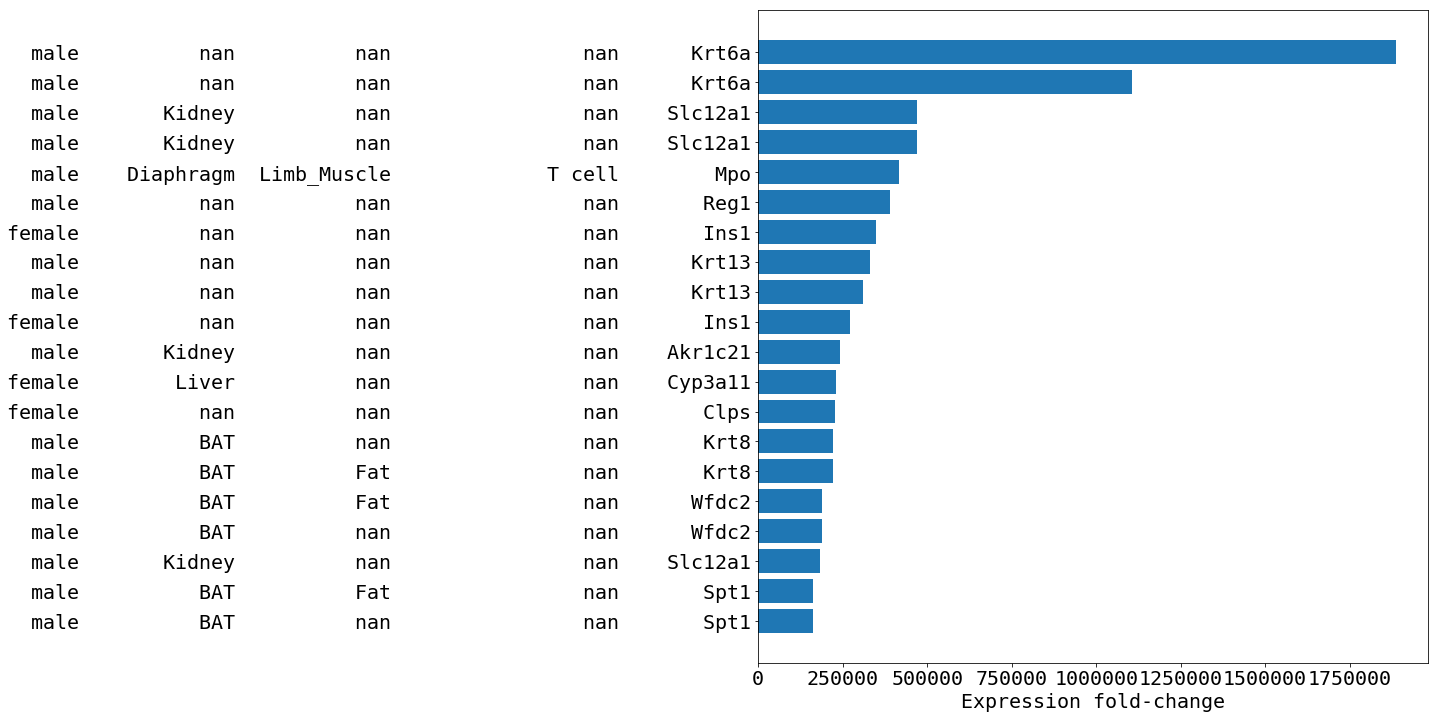

In [13]:
font = {'family' : 'monospace',
        'weight' : 'regular',
        'size'   : 20}

matplotlib.rc('font', **font)

n_plot = 20
fig, ax = plt.subplots(figsize=(12, 12))
ax.barh(np.arange(n_plot), merged_results["dExpression"][:n_plot])
ax.invert_yaxis()
ax.set_xlabel('Expression fold-change')
ax.set_yticks(np.arange(n_plot))
_ = ax.set_yticklabels([
  '{0} {1} {2} {3} {4}'.format(
    row['sex'], 
    str(row['tissue']).rjust(12), 
    str(row['subtissue']).rjust(12), 
    str(row['cell_ontology_class'])[:15].rjust(18), 
    row['Gene'].rjust(10)
  )
  for _, row in merged_results.iloc[:n_plot].iterrows()
])